In [1]:
%matplotlib inline

import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

from matplotlib.lines import Line2D

In [2]:
import radical.analytics as ra

# plt.style.use(ra.get_mplstyle('radical_mpl'))
mpl.rcParams['text.usetex'] = False

In [3]:
BASE_DIR = '../../data/workspace'

# Task scheduling and launching rates

Tasks scheduling rate (throughtput) is calculated for the time during which all just acquired cores are assigned for tasks to be executed. Since tasks are heterogeneous (including heterogenety in runtime), all running tasks will not be finished at the same time, thus further scheduling rate will be reduced.

(*) Time duration is set from the time of arrival first task with state "AGENT_SCHEDULING_PENDING" to the time of the last task was "put" into state "AGENT_EXECUTING_PENDING" (the last until the first event "unschedule_stop" happens).

Tasks launching rate (throughput) is calculated for the time during which all just acquired cores are filled with tasks for the execution. Similarly as the scheduling rate, further launching rate will be reduced.

(*) Time duration is set from the time of arrival first task with state "AGENT_EXECUTING_PENDING" to the time of the last event "exec_ok" (the last until the first event "exec_stop" happens)

In [4]:
def plot_sched_launch_rate(input_data):
    fig, ax = plt.subplots(figsize=(5,4))
    
    for r in input_data:
        ax.scatter([r['nodes']], [r['scheduling']], marker='^', color=r['color'])
        ax.scatter([r['nodes']], [r['launching']], marker='v', color=r['color'])
    
    rate_values = [r['scheduling'] for r in input_data] + [r['launching'] for r in input_data]
    rate_values_min_max = min(rate_values), max(rate_values)
    rate_values_range = rate_values_min_max[1] - rate_values_min_max[0]
    ax.set_ylim(rate_values_min_max[0] - (.1 * rate_values_range), 
                rate_values_min_max[1] + (.05 * rate_values_range))

    ax.set_ylabel('Tasks throughput (#tasks/s)')
    ax.set_xlabel('# nodes')
    
    handles = [plt.Line2D([0], [0], color=r['color'], label=r['label']) for r in input_data]
    l1 = ax.legend(handles=handles, 
                   bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.add_artist(l1)
    
    handles = [plt.Line2D([0], [0], marker='^', color='k', linestyle='None', label='Scheduling'),
               plt.Line2D([0], [0], marker='v', color='k', linestyle='None', label='Launching')]
    l2 = ax.legend(handles=handles, 
                   bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

    plt.locator_params(axis='x', nbins=4)
    plt.locator_params(axis='y', nbins=5)

    plt.show()
    

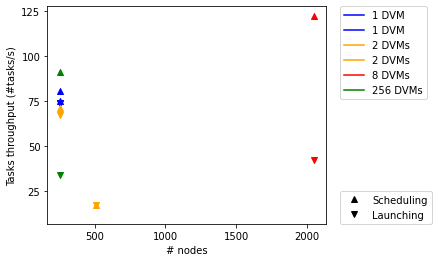

In [5]:
plot_sched_launch_rate([
    {
        'nodes'      : 256,
        'tasks'      : 1374,
        'scheduling' : 80.76,
        'launching'  : 74.3,
        'color'      : 'b',
        'label'      : '1 DVM'
    },
    {
        'nodes'      : 256,
        'tasks'      : 1430,
        'scheduling' : 75.18,
        'launching'  : 73.9,
        'color'      : 'b',
        'label'      : '1 DVM'
    },
    {
        'nodes'      : 256,
        'tasks'      : 1381,
        'scheduling' : 71.18,
        'launching'  : 67.53,
        'color'      : 'orange',
        'label'      : '2 DVMs'
    },
    {
        'nodes'      : 512,
        'tasks'      : 3090,
        'scheduling' : 17.53,  # 89.11, 19.58 -> avg 54.35
        'launching'  : 17.54,  # 63.83, 19.58 -> avg 41.7
        'color'      : 'orange',
        'label'      : '2 DVMs'
    },
    {
        'nodes'      : 2048,
        'tasks'      : 13509,
        'scheduling' : 122.56,
        'launching'  : 42.26,
        'color'      : 'r',
        'label'      : '8 DVMs'
    },
    {
        'nodes'      : 256,
        'tasks'      : 1420,
        'scheduling' : 91.32,
        'launching'  : 33.88,
        'color'      : 'g',
        'label'      : '256 DVMs'
    }
])

### Explore which launching stage could use significant time

In [6]:
%%capture --no-display

import pandas as pd

import radical.analytics as ra
import radical.utils     as ru

In [7]:
launching_durations = {
        #'send_to_spawner'  : [{ru.STATE: 'AGENT_EXECUTING'}, {ru.EVENT: 'exec_mkdir'}],
        'make_sandbox'            : [{ru.EVENT: 'exec_mkdir'}, {ru.EVENT: 'exec_mkdir_done'}],
        'create_manage_executable': [{ru.EVENT: 'exec_mkdir_done'}, {ru.EVENT: 'exec_start'}],
        'subprocess.Popen'        : [{ru.EVENT: 'exec_start'}, {ru.EVENT: 'exec_ok'}]
    }
launching_durations_extended = {
        #'send_to_spawner'  : [{ru.STATE: 'AGENT_EXECUTING'}, {ru.EVENT: 'exec_mkdir'}],
        'make_sandbox'     : [{ru.EVENT: 'exec_mkdir'}, {ru.EVENT: 'exec_mkdir_done'}],
        'create_executable': [{ru.EVENT: 'exec_mkdir_done'}, {ru.EVENT: 'exec_script_created'}],
        'manage_executable': [{ru.EVENT: 'exec_script_created'}, {ru.EVENT: 'exec_start'}],
        'subprocess.Popen' : [{ru.EVENT: 'exec_start'}, {ru.EVENT: 'exec_ok'}]
    }

In [8]:
def plot_launching_durations(sid_path, title, launching_durations):
    
    session = ra.Session(sid_path, 'radical.pilot')
    tasks   = session.filter(etype='task', inplace=False)

    durations = {}
    for task in tasks.get():
        tmp = {}
        try:
            for k in launching_durations:
                tmp[k] = task.duration(event=launching_durations[k])
        except ValueError:
                continue
        for k, v in tmp.items():
            durations.setdefault(k, []).append(v)

    durations = pd.DataFrame(durations)

    fig, ax = plt.subplots(figsize=(5,4))
    bx = ax.boxplot(durations, sym='', labels=launching_durations.keys())
    y_max = max([max(w.get_ydata()) for w in bx['whiskers']])
    ax.set_ylim(0 - (y_max * .05), y_max + (y_max * .15))
    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Launching stages')

    min_max_durs = [(round(min(d), 2), round(max(d), 2)) for _, d in durations.iteritems()]
    for _x, _y, label in zip(range(1, 5), [y_max + (y_max * .03)] * len(min_max_durs), min_max_durs):
        ax.text(_x, _y, str(label), ha='center', va='bottom', color='green')

    handles = [plt.Line2D([0], [0], color='green', label='min,max values')]
    ax.legend(handles=handles, 
              bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax.set_title(title)
    plt.xticks(rotation=15)
    plt.show()

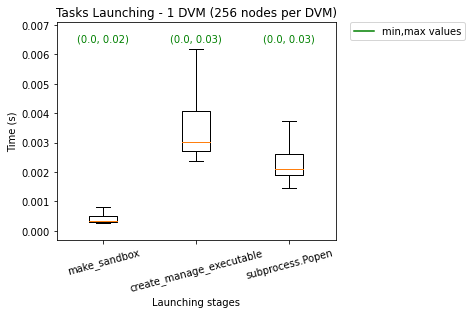

In [9]:
%%capture --no-display
plot_launching_durations('%s/rp.session.login5.matitov.018968.0000' % BASE_DIR, 
                         'Tasks Launching - 1 DVM (256 nodes per DVM)',
                         launching_durations)

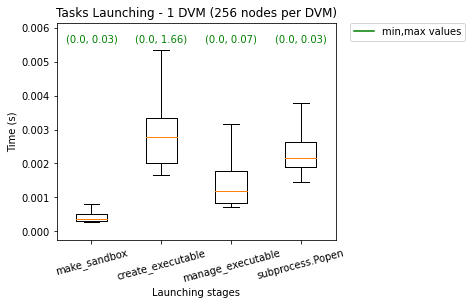

In [10]:
%%capture --no-display
plot_launching_durations('%s/rp.session.login3.matitov.019026.0001' % BASE_DIR, 
                         'Tasks Launching - 1 DVM (256 nodes per DVM)',
                         launching_durations_extended)

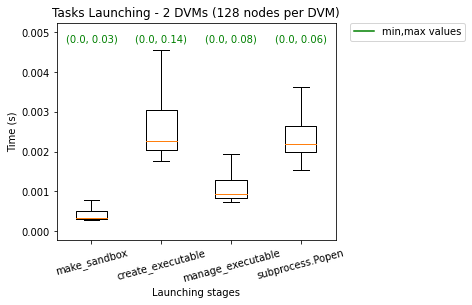

In [11]:
%%capture --no-display
plot_launching_durations('%s/rp.session.login3.matitov.019026.0002' % BASE_DIR, 
                         'Tasks Launching - 2 DVMs (128 nodes per DVM)',
                         launching_durations_extended)

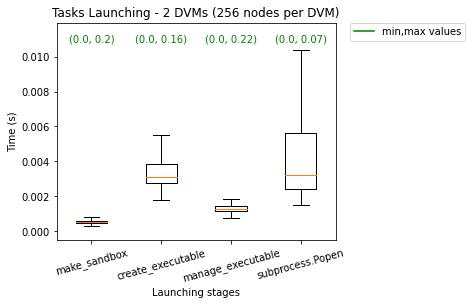

In [12]:
%%capture --no-display
plot_launching_durations('%s/rp.session.login3.matitov.019024.0001' % BASE_DIR, 
                         'Tasks Launching - 2 DVMs (256 nodes per DVM)',
                         launching_durations_extended)

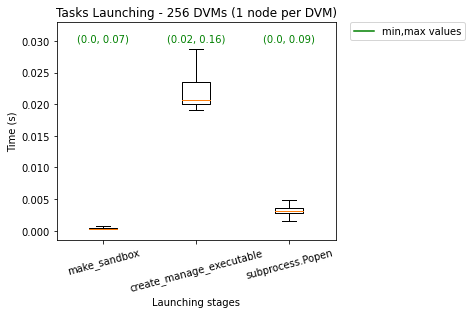

In [13]:
%%capture --no-display
plot_launching_durations('%s/rp.session.login5.matitov.018970.0001' % BASE_DIR, 
                         'Tasks Launching - 256 DVMs (1 node per DVM)',
                         launching_durations)

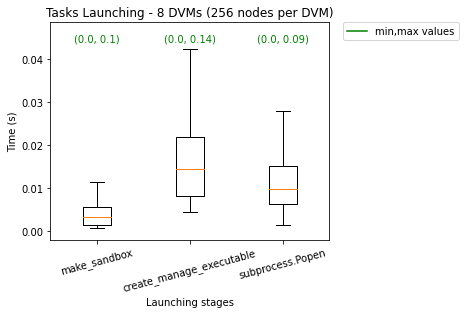

In [14]:
%%capture --no-display
plot_launching_durations('%s/rp.session.login4.matitov.019010.0000' % BASE_DIR, 
                         'Tasks Launching - 8 DVMs (256 nodes per DVM)',
                         launching_durations)

### Rate for the run

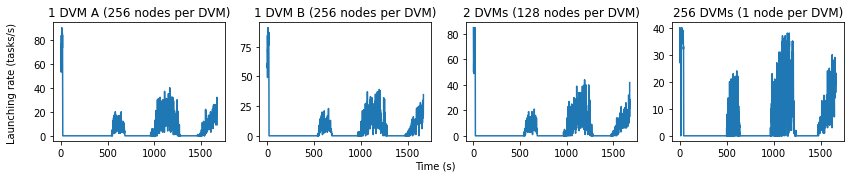

In [15]:
%%capture --no-display

TITLE = 'Tasks launching rate'
runs = {
    '1 DVM A (256 nodes per DVM)' : {'sid_path': '%s/rp.session.login5.matitov.018968.0000' % BASE_DIR},
    '1 DVM B (256 nodes per DVM)' : {'sid_path': '%s/rp.session.login3.matitov.019026.0001' % BASE_DIR},
    '2 DVMs (128 nodes per DVM)'  : {'sid_path': '%s/rp.session.login3.matitov.019026.0002' % BASE_DIR},
    '256 DVMs (1 node per DVM)'   : {'sid_path': '%s/rp.session.login5.matitov.018970.0001' % BASE_DIR}
}

fig, axarr = plt.subplots(1, 4, figsize=(ra.get_plotsize(1024, subplots=(1, 4))))

for idx, name in enumerate(runs):
    session = ra.Session(runs[name]['sid_path'], 'radical.pilot')
    launching_rates = session.filter(etype='task', inplace=False).rate(event=[{ru.EVENT: 'exec_ok'}],
                                                                       sampling=1)

    zero = min([e[0] for e in launching_rates])
    axarr[idx].plot([e[0] - zero for e in launching_rates],
                    [e[1] for e in launching_rates])

    axarr[idx].set_title(name)

fig.text(0.08,  0.5 , 'Launching rate (tasks/s)', va='center', rotation='vertical')
fig.text(0.5 , -0.05, 'Time (s)'                , ha='center')

plt.show()

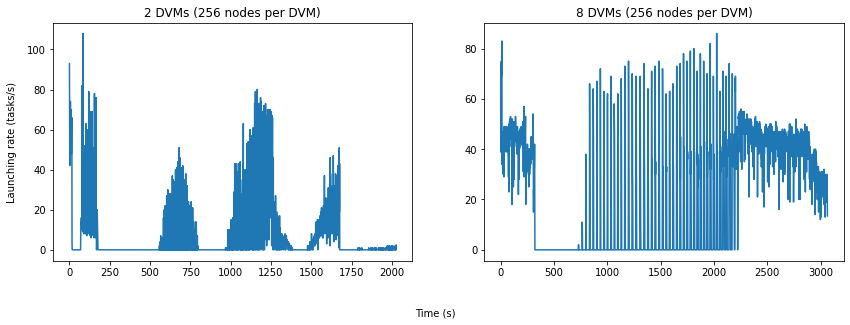

In [16]:
%%capture --no-display

TITLE = 'Tasks launching rate'
runs = {
    '2 DVMs (256 nodes per DVM)': {'sid_path': '%s/rp.session.login3.matitov.019024.0001' % BASE_DIR},
    '8 DVMs (256 nodes per DVM)': {'sid_path': '%s/rp.session.login4.matitov.019010.0000' % BASE_DIR}
}

fig, axarr = plt.subplots(1, 2, figsize=(ra.get_plotsize(1024, subplots=(1, 2))))

for idx, name in enumerate(runs):
    session = ra.Session(runs[name]['sid_path'], 'radical.pilot')
    launching_rates = session.filter(etype='task', inplace=False).rate(event=[{ru.EVENT: 'exec_ok'}],
                                                                       sampling=1)

    zero = min([e[0] for e in launching_rates])
    axarr[idx].plot([e[0] - zero for e in launching_rates],
                    [e[1] for e in launching_rates])

    axarr[idx].set_title(name)

fig.text(0.08,  0.5 , 'Launching rate (tasks/s)', va='center', rotation='vertical')
fig.text(0.5 , -0.05, 'Time (s)'                , ha='center')

plt.show()

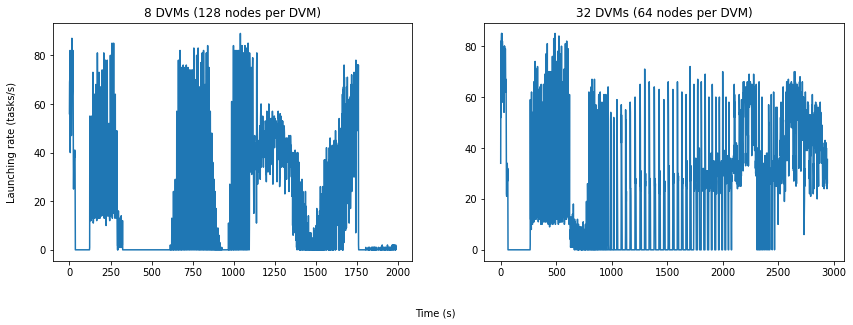

In [21]:
%%capture --no-display

TITLE = 'Tasks launching rate'
runs = {
    '8 DVMs (128 nodes per DVM)': {'sid_path': '%s/rp.session.login3.matitov.019027.0000' % BASE_DIR},
    '32 DVMs (64 nodes per DVM)': {'sid_path': '%s/rp.session.login3.matitov.019032.0000' % BASE_DIR}
}

fig, axarr = plt.subplots(1, 2, figsize=(ra.get_plotsize(1024, subplots=(1, 2))))

for idx, name in enumerate(runs):
    session = ra.Session(runs[name]['sid_path'], 'radical.pilot')
    launching_rates = session.filter(etype='task', inplace=False).rate(event=[{ru.EVENT: 'exec_ok'}],
                                                                       sampling=1)

    zero = min([e[0] for e in launching_rates])
    axarr[idx].plot([e[0] - zero for e in launching_rates],
                    [e[1] for e in launching_rates])

    axarr[idx].set_title(name)

fig.text(0.08,  0.5 , 'Launching rate (tasks/s)', va='center', rotation='vertical')
fig.text(0.5 , -0.05, 'Time (s)'                , ha='center')

plt.show()

# Utilization per DVM

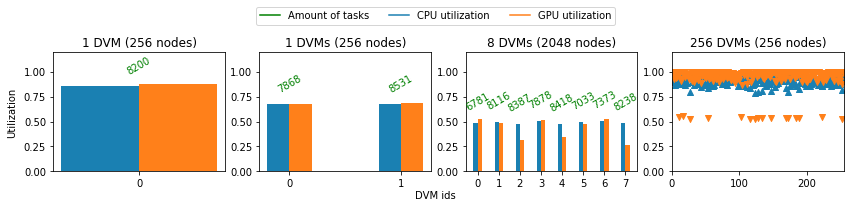

In [17]:
### 1 DVM
input_1dvm = {0: {'tasks': 8200, 'cpu': 0.86, 'gpu': 0.88}}
### 1 DVM
input_1dvm_2attempt = {0: {'tasks': 8200, 'cpu': 0.85, 'gpu': 0.87}}
### 2 DVMs
input_2dvms_256n = {0: {'tasks': 3930, 'cpu': 0.86, 'gpu': 0.91}, 1: {'tasks': 4270, 'cpu': 0.86, 'gpu': 0.86}}
### 2 DVMs
input_2dvm = {1: {'tasks': 8531, 'cpu': 0.68, 'gpu': 0.69}, 0: {'tasks': 7868, 'cpu': 0.68, 'gpu': 0.68}}
### 8 DVMs
input_8dvm = {5: {'tasks': 7033, 'cpu': 0.5, 'gpu': 0.48}, 7: {'tasks': 8238, 'cpu': 0.49, 'gpu': 0.26}, 3: {'tasks': 7878, 'cpu': 0.51, 'gpu': 0.52}, 0: {'tasks': 6781, 'cpu': 0.49, 'gpu': 0.53}, 4: {'tasks': 8418, 'cpu': 0.48, 'gpu': 0.35}, 1: {'tasks': 8116, 'cpu': 0.5, 'gpu': 0.49}, 2: {'tasks': 8387, 'cpu': 0.48, 'gpu': 0.31}, 6: {'tasks': 7373, 'cpu': 0.51, 'gpu': 0.53}}
### 256 DVMs
input_256dvm = {134: {'tasks': 27, 'cpu': 0.89, 'gpu': 1.0}, 16: {'tasks': 24, 'cpu': 0.99, 'gpu': 1.0}, 228: {'tasks': 28, 'cpu': 0.94, 'gpu': 0.92}, 71: {'tasks': 34, 'cpu': 0.9, 'gpu': 0.93}, 216: {'tasks': 41, 'cpu': 0.93, 'gpu': 0.93}, 198: {'tasks': 44, 'cpu': 0.97, 'gpu': 0.99}, 149: {'tasks': 23, 'cpu': 0.95, 'gpu': 1.0}, 102: {'tasks': 57, 'cpu': 0.86, 'gpu': 0.55}, 224: {'tasks': 44, 'cpu': 0.9, 'gpu': 0.9}, 208: {'tasks': 29, 'cpu': 0.89, 'gpu': 1.0}, 218: {'tasks': 30, 'cpu': 0.88, 'gpu': 1.0}, 245: {'tasks': 49, 'cpu': 0.95, 'gpu': 1.0}, 186: {'tasks': 43, 'cpu': 0.95, 'gpu': 0.96}, 25: {'tasks': 45, 'cpu': 0.94, 'gpu': 0.93}, 160: {'tasks': 29, 'cpu': 0.91, 'gpu': 0.99}, 67: {'tasks': 31, 'cpu': 0.9, 'gpu': 0.96}, 17: {'tasks': 24, 'cpu': 0.88, 'gpu': 0.56}, 255: {'tasks': 24, 'cpu': 0.98, 'gpu': 0.99}, 53: {'tasks': 40, 'cpu': 0.94, 'gpu': 1.0}, 9: {'tasks': 34, 'cpu': 0.91, 'gpu': 1.0}, 251: {'tasks': 23, 'cpu': 0.97, 'gpu': 1.0}, 145: {'tasks': 39, 'cpu': 0.9, 'gpu': 1.0}, 236: {'tasks': 23, 'cpu': 0.86, 'gpu': 1.0}, 168: {'tasks': 47, 'cpu': 0.91, 'gpu': 0.93}, 26: {'tasks': 17, 'cpu': 0.96, 'gpu': 0.95}, 169: {'tasks': 42, 'cpu': 0.84, 'gpu': 0.54}, 254: {'tasks': 22, 'cpu': 0.91, 'gpu': 1.0}, 110: {'tasks': 20, 'cpu': 0.96, 'gpu': 1.0}, 233: {'tasks': 47, 'cpu': 0.94, 'gpu': 1.0}, 139: {'tasks': 35, 'cpu': 0.87, 'gpu': 0.96}, 239: {'tasks': 41, 'cpu': 0.92, 'gpu': 0.95}, 171: {'tasks': 18, 'cpu': 0.92, 'gpu': 1.0}, 141: {'tasks': 30, 'cpu': 0.91, 'gpu': 1.0}, 52: {'tasks': 27, 'cpu': 0.9, 'gpu': 0.98}, 100: {'tasks': 43, 'cpu': 0.95, 'gpu': 0.98}, 6: {'tasks': 32, 'cpu': 0.9, 'gpu': 0.94}, 210: {'tasks': 37, 'cpu': 0.91, 'gpu': 0.99}, 202: {'tasks': 49, 'cpu': 0.92, 'gpu': 0.93}, 142: {'tasks': 28, 'cpu': 0.89, 'gpu': 0.98}, 108: {'tasks': 22, 'cpu': 0.87, 'gpu': 1.0}, 96: {'tasks': 41, 'cpu': 0.94, 'gpu': 0.94}, 47: {'tasks': 39, 'cpu': 0.95, 'gpu': 1.0}, 147: {'tasks': 37, 'cpu': 0.81, 'gpu': 0.54}, 74: {'tasks': 49, 'cpu': 0.95, 'gpu': 0.97}, 55: {'tasks': 36, 'cpu': 0.92, 'gpu': 0.93}, 117: {'tasks': 25, 'cpu': 0.94, 'gpu': 0.9}, 125: {'tasks': 28, 'cpu': 0.89, 'gpu': 1.0}, 192: {'tasks': 20, 'cpu': 0.97, 'gpu': 0.98}, 104: {'tasks': 40, 'cpu': 0.9, 'gpu': 0.87}, 124: {'tasks': 39, 'cpu': 0.79, 'gpu': 0.53}, 36: {'tasks': 34, 'cpu': 0.88, 'gpu': 0.95}, 207: {'tasks': 29, 'cpu': 0.89, 'gpu': 0.97}, 58: {'tasks': 15, 'cpu': 0.94, 'gpu': 1.0}, 175: {'tasks': 38, 'cpu': 0.86, 'gpu': 1.0}, 4: {'tasks': 19, 'cpu': 0.96, 'gpu': 1.0}, 249: {'tasks': 40, 'cpu': 0.94, 'gpu': 0.94}, 48: {'tasks': 21, 'cpu': 0.97, 'gpu': 0.96}, 109: {'tasks': 38, 'cpu': 0.95, 'gpu': 1.0}, 83: {'tasks': 55, 'cpu': 0.94, 'gpu': 0.95}, 193: {'tasks': 36, 'cpu': 0.89, 'gpu': 0.9}, 122: {'tasks': 21, 'cpu': 0.88, 'gpu': 0.98}, 13: {'tasks': 41, 'cpu': 0.93, 'gpu': 0.91}, 32: {'tasks': 39, 'cpu': 0.96, 'gpu': 0.99}, 217: {'tasks': 35, 'cpu': 0.87, 'gpu': 0.92}, 56: {'tasks': 26, 'cpu': 0.87, 'gpu': 1.0}, 159: {'tasks': 22, 'cpu': 0.94, 'gpu': 0.96}, 54: {'tasks': 45, 'cpu': 0.84, 'gpu': 0.54}, 91: {'tasks': 39, 'cpu': 0.95, 'gpu': 0.97}, 246: {'tasks': 45, 'cpu': 0.89, 'gpu': 0.96}, 114: {'tasks': 41, 'cpu': 0.94, 'gpu': 1.0}, 177: {'tasks': 39, 'cpu': 0.94, 'gpu': 1.0}, 197: {'tasks': 30, 'cpu': 0.88, 'gpu': 0.97}, 88: {'tasks': 39, 'cpu': 0.92, 'gpu': 0.92}, 116: {'tasks': 50, 'cpu': 0.84, 'gpu': 0.53}, 131: {'tasks': 32, 'cpu': 0.93, 'gpu': 1.0}, 121: {'tasks': 28, 'cpu': 0.87, 'gpu': 0.95}, 5: {'tasks': 23, 'cpu': 0.87, 'gpu': 1.0}, 61: {'tasks': 30, 'cpu': 0.86, 'gpu': 0.91}, 178: {'tasks': 33, 'cpu': 0.91, 'gpu': 0.98}, 190: {'tasks': 28, 'cpu': 0.9, 'gpu': 1.0}, 158: {'tasks': 27, 'cpu': 0.89, 'gpu': 1.0}, 203: {'tasks': 31, 'cpu': 0.88, 'gpu': 0.95}, 205: {'tasks': 40, 'cpu': 0.86, 'gpu': 0.93}, 161: {'tasks': 39, 'cpu': 0.94, 'gpu': 1.0}, 19: {'tasks': 18, 'cpu': 0.94, 'gpu': 1.0}, 107: {'tasks': 16, 'cpu': 0.96, 'gpu': 0.97}, 24: {'tasks': 22, 'cpu': 0.95, 'gpu': 0.97}, 182: {'tasks': 18, 'cpu': 0.95, 'gpu': 0.94}, 12: {'tasks': 19, 'cpu': 0.97, 'gpu': 0.99}, 135: {'tasks': 53, 'cpu': 0.92, 'gpu': 0.94}, 247: {'tasks': 35, 'cpu': 0.87, 'gpu': 0.9}, 243: {'tasks': 26, 'cpu': 0.96, 'gpu': 1.0}, 222: {'tasks': 23, 'cpu': 0.86, 'gpu': 0.95}, 231: {'tasks': 35, 'cpu': 0.88, 'gpu': 0.97}, 180: {'tasks': 46, 'cpu': 0.95, 'gpu': 1.0}, 232: {'tasks': 32, 'cpu': 0.89, 'gpu': 1.0}, 14: {'tasks': 34, 'cpu': 0.9, 'gpu': 0.93}, 99: {'tasks': 37, 'cpu': 0.91, 'gpu': 0.92}, 30: {'tasks': 34, 'cpu': 0.9, 'gpu': 0.91}, 174: {'tasks': 25, 'cpu': 0.96, 'gpu': 1.0}, 45: {'tasks': 26, 'cpu': 0.87, 'gpu': 0.96}, 179: {'tasks': 29, 'cpu': 0.88, 'gpu': 1.0}, 78: {'tasks': 39, 'cpu': 0.92, 'gpu': 0.95}, 40: {'tasks': 25, 'cpu': 0.9, 'gpu': 0.98}, 57: {'tasks': 43, 'cpu': 0.93, 'gpu': 0.94}, 206: {'tasks': 33, 'cpu': 0.88, 'gpu': 1.0}, 143: {'tasks': 37, 'cpu': 0.91, 'gpu': 0.98}, 214: {'tasks': 24, 'cpu': 0.92, 'gpu': 1.0}, 50: {'tasks': 33, 'cpu': 0.87, 'gpu': 0.94}, 252: {'tasks': 27, 'cpu': 0.92, 'gpu': 0.88}, 212: {'tasks': 40, 'cpu': 0.96, 'gpu': 0.98}, 89: {'tasks': 24, 'cpu': 0.98, 'gpu': 0.97}, 7: {'tasks': 39, 'cpu': 0.96, 'gpu': 0.98}, 0: {'tasks': 41, 'cpu': 0.98, 'gpu': 1.0}, 65: {'tasks': 29, 'cpu': 0.91, 'gpu': 0.99}, 189: {'tasks': 49, 'cpu': 0.83, 'gpu': 0.54}, 123: {'tasks': 30, 'cpu': 0.89, 'gpu': 1.0}, 118: {'tasks': 37, 'cpu': 0.94, 'gpu': 0.97}, 63: {'tasks': 17, 'cpu': 0.94, 'gpu': 0.96}, 21: {'tasks': 31, 'cpu': 0.9, 'gpu': 0.97}, 153: {'tasks': 27, 'cpu': 0.85, 'gpu': 0.91}, 129: {'tasks': 36, 'cpu': 0.92, 'gpu': 0.97}, 49: {'tasks': 25, 'cpu': 0.95, 'gpu': 0.95}, 112: {'tasks': 25, 'cpu': 0.91, 'gpu': 0.95}, 69: {'tasks': 45, 'cpu': 0.95, 'gpu': 0.99}, 241: {'tasks': 24, 'cpu': 0.96, 'gpu': 0.98}, 8: {'tasks': 34, 'cpu': 0.92, 'gpu': 0.95}, 157: {'tasks': 37, 'cpu': 0.91, 'gpu': 0.97}, 87: {'tasks': 15, 'cpu': 0.92, 'gpu': 0.92}, 248: {'tasks': 40, 'cpu': 0.88, 'gpu': 1.0}, 106: {'tasks': 31, 'cpu': 0.92, 'gpu': 0.99}, 204: {'tasks': 41, 'cpu': 0.92, 'gpu': 0.93}, 10: {'tasks': 27, 'cpu': 0.88, 'gpu': 0.98}, 235: {'tasks': 28, 'cpu': 0.89, 'gpu': 1.0}, 181: {'tasks': 41, 'cpu': 0.88, 'gpu': 0.97}, 97: {'tasks': 38, 'cpu': 0.96, 'gpu': 0.98}, 253: {'tasks': 55, 'cpu': 0.82, 'gpu': 0.53}, 148: {'tasks': 32, 'cpu': 0.92, 'gpu': 1.0}, 41: {'tasks': 26, 'cpu': 0.88, 'gpu': 0.96}, 155: {'tasks': 49, 'cpu': 0.88, 'gpu': 0.9}, 72: {'tasks': 20, 'cpu': 0.96, 'gpu': 1.0}, 196: {'tasks': 23, 'cpu': 0.89, 'gpu': 1.0}, 242: {'tasks': 30, 'cpu': 0.87, 'gpu': 0.98}, 11: {'tasks': 49, 'cpu': 0.88, 'gpu': 0.55}, 144: {'tasks': 31, 'cpu': 0.89, 'gpu': 0.97}, 238: {'tasks': 32, 'cpu': 0.9, 'gpu': 1.0}, 225: {'tasks': 31, 'cpu': 0.88, 'gpu': 0.96}, 221: {'tasks': 45, 'cpu': 0.93, 'gpu': 0.96}, 84: {'tasks': 33, 'cpu': 0.9, 'gpu': 1.0}, 80: {'tasks': 33, 'cpu': 0.91, 'gpu': 0.97}, 152: {'tasks': 27, 'cpu': 0.91, 'gpu': 1.0}, 126: {'tasks': 37, 'cpu': 0.96, 'gpu': 1.0}, 79: {'tasks': 42, 'cpu': 0.96, 'gpu': 1.0}, 191: {'tasks': 34, 'cpu': 0.91, 'gpu': 0.97}, 146: {'tasks': 39, 'cpu': 0.88, 'gpu': 0.95}, 76: {'tasks': 21, 'cpu': 0.93, 'gpu': 0.93}, 167: {'tasks': 50, 'cpu': 0.94, 'gpu': 0.97}, 98: {'tasks': 29, 'cpu': 0.86, 'gpu': 0.94}, 195: {'tasks': 49, 'cpu': 0.92, 'gpu': 0.94}, 219: {'tasks': 27, 'cpu': 0.87, 'gpu': 0.98}, 226: {'tasks': 23, 'cpu': 0.96, 'gpu': 0.99}, 237: {'tasks': 19, 'cpu': 0.93, 'gpu': 0.95}, 200: {'tasks': 21, 'cpu': 0.94, 'gpu': 1.0}, 215: {'tasks': 36, 'cpu': 0.92, 'gpu': 0.9}, 44: {'tasks': 29, 'cpu': 0.91, 'gpu': 1.0}, 194: {'tasks': 41, 'cpu': 0.91, 'gpu': 0.93}, 166: {'tasks': 21, 'cpu': 0.96, 'gpu': 1.0}, 154: {'tasks': 37, 'cpu': 0.91, 'gpu': 0.97}, 70: {'tasks': 37, 'cpu': 0.92, 'gpu': 0.9}, 75: {'tasks': 25, 'cpu': 0.88, 'gpu': 1.0}, 39: {'tasks': 36, 'cpu': 0.9, 'gpu': 0.92}, 138: {'tasks': 44, 'cpu': 0.93, 'gpu': 1.0}, 119: {'tasks': 29, 'cpu': 0.95, 'gpu': 0.95}, 185: {'tasks': 25, 'cpu': 0.96, 'gpu': 0.97}, 209: {'tasks': 22, 'cpu': 0.91, 'gpu': 1.0}, 15: {'tasks': 35, 'cpu': 0.92, 'gpu': 1.0}, 201: {'tasks': 25, 'cpu': 0.93, 'gpu': 0.9}, 101: {'tasks': 42, 'cpu': 0.94, 'gpu': 0.97}, 105: {'tasks': 21, 'cpu': 0.95, 'gpu': 1.0}, 132: {'tasks': 19, 'cpu': 0.94, 'gpu': 1.0}, 223: {'tasks': 44, 'cpu': 0.86, 'gpu': 0.55}, 140: {'tasks': 34, 'cpu': 0.86, 'gpu': 1.0}, 173: {'tasks': 44, 'cpu': 0.97, 'gpu': 1.0}, 23: {'tasks': 41, 'cpu': 0.94, 'gpu': 0.98}, 18: {'tasks': 16, 'cpu': 0.97, 'gpu': 1.0}, 162: {'tasks': 39, 'cpu': 0.91, 'gpu': 0.91}, 187: {'tasks': 24, 'cpu': 0.97, 'gpu': 1.0}, 64: {'tasks': 37, 'cpu': 0.95, 'gpu': 1.0}, 77: {'tasks': 23, 'cpu': 0.88, 'gpu': 0.95}, 120: {'tasks': 22, 'cpu': 0.95, 'gpu': 0.98}, 240: {'tasks': 21, 'cpu': 0.91, 'gpu': 0.91}, 37: {'tasks': 31, 'cpu': 0.9, 'gpu': 0.96}, 156: {'tasks': 16, 'cpu': 0.95, 'gpu': 1.0}, 94: {'tasks': 41, 'cpu': 0.94, 'gpu': 0.95}, 211: {'tasks': 36, 'cpu': 0.92, 'gpu': 0.96}, 46: {'tasks': 21, 'cpu': 0.96, 'gpu': 0.97}, 113: {'tasks': 19, 'cpu': 0.95, 'gpu': 1.0}, 38: {'tasks': 34, 'cpu': 0.93, 'gpu': 1.0}, 33: {'tasks': 31, 'cpu': 0.87, 'gpu': 0.9}, 28: {'tasks': 40, 'cpu': 0.94, 'gpu': 1.0}, 3: {'tasks': 39, 'cpu': 0.94, 'gpu': 0.93}, 184: {'tasks': 28, 'cpu': 0.86, 'gpu': 0.54}, 27: {'tasks': 35, 'cpu': 0.8, 'gpu': 0.53}, 127: {'tasks': 20, 'cpu': 0.95, 'gpu': 0.95}, 151: {'tasks': 18, 'cpu': 0.97, 'gpu': 1.0}, 188: {'tasks': 29, 'cpu': 0.96, 'gpu': 0.97}, 115: {'tasks': 15, 'cpu': 0.95, 'gpu': 1.0}, 85: {'tasks': 29, 'cpu': 0.91, 'gpu': 0.98}, 176: {'tasks': 28, 'cpu': 0.86, 'gpu': 0.93}, 163: {'tasks': 23, 'cpu': 0.92, 'gpu': 0.94}, 86: {'tasks': 29, 'cpu': 0.9, 'gpu': 0.96}, 220: {'tasks': 38, 'cpu': 0.89, 'gpu': 0.98}, 29: {'tasks': 18, 'cpu': 0.95, 'gpu': 0.93}, 22: {'tasks': 27, 'cpu': 0.89, 'gpu': 0.97}, 164: {'tasks': 21, 'cpu': 0.95, 'gpu': 1.0}, 137: {'tasks': 26, 'cpu': 0.96, 'gpu': 0.98}, 2: {'tasks': 27, 'cpu': 0.9, 'gpu': 0.97}, 93: {'tasks': 40, 'cpu': 0.91, 'gpu': 0.89}, 136: {'tasks': 41, 'cpu': 0.93, 'gpu': 0.93}, 170: {'tasks': 43, 'cpu': 0.93, 'gpu': 0.97}, 35: {'tasks': 35, 'cpu': 0.92, 'gpu': 1.0}, 20: {'tasks': 26, 'cpu': 0.87, 'gpu': 0.95}, 90: {'tasks': 39, 'cpu': 0.96, 'gpu': 0.99}, 213: {'tasks': 35, 'cpu': 0.9, 'gpu': 1.0}, 62: {'tasks': 43, 'cpu': 0.87, 'gpu': 0.97}, 81: {'tasks': 41, 'cpu': 0.96, 'gpu': 0.99}, 111: {'tasks': 32, 'cpu': 0.85, 'gpu': 0.88}, 51: {'tasks': 25, 'cpu': 0.89, 'gpu': 1.0}, 73: {'tasks': 20, 'cpu': 0.97, 'gpu': 0.98}, 244: {'tasks': 35, 'cpu': 0.92, 'gpu': 0.98}, 229: {'tasks': 21, 'cpu': 0.95, 'gpu': 0.97}, 66: {'tasks': 20, 'cpu': 0.93, 'gpu': 0.93}, 128: {'tasks': 36, 'cpu': 0.8, 'gpu': 0.54}, 199: {'tasks': 33, 'cpu': 0.86, 'gpu': 0.91}, 165: {'tasks': 37, 'cpu': 0.95, 'gpu': 1.0}, 31: {'tasks': 25, 'cpu': 0.91, 'gpu': 0.98}, 234: {'tasks': 41, 'cpu': 0.9, 'gpu': 1.0}, 172: {'tasks': 37, 'cpu': 0.8, 'gpu': 0.54}, 133: {'tasks': 38, 'cpu': 0.81, 'gpu': 0.54}, 82: {'tasks': 27, 'cpu': 0.87, 'gpu': 0.94}, 230: {'tasks': 36, 'cpu': 0.9, 'gpu': 0.97}, 60: {'tasks': 30, 'cpu': 0.88, 'gpu': 0.95}, 250: {'tasks': 37, 'cpu': 0.88, 'gpu': 0.91}, 227: {'tasks': 45, 'cpu': 0.88, 'gpu': 0.93}, 59: {'tasks': 20, 'cpu': 0.95, 'gpu': 0.95}, 95: {'tasks': 47, 'cpu': 0.94, 'gpu': 0.93}, 150: {'tasks': 18, 'cpu': 0.96, 'gpu': 1.0}, 183: {'tasks': 27, 'cpu': 0.89, 'gpu': 1.0}, 42: {'tasks': 18, 'cpu': 0.93, 'gpu': 1.0}, 43: {'tasks': 33, 'cpu': 0.85, 'gpu': 0.89}, 34: {'tasks': 21, 'cpu': 0.94, 'gpu': 0.93}, 103: {'tasks': 32, 'cpu': 0.87, 'gpu': 0.99}, 92: {'tasks': 16, 'cpu': 0.93, 'gpu': 0.91}, 130: {'tasks': 19, 'cpu': 0.96, 'gpu': 1.0}, 1: {'tasks': 37, 'cpu': 0.94, 'gpu': 1.0}, 68: {'tasks': 15, 'cpu': 0.98, 'gpu': 0.99}}

descr = ['1 DVM (256 nodes)', '1 DVMs (256 nodes)', '8 DVMs (2048 nodes)', '256 DVMs (256 nodes)']

import radical.analytics as ra
fig, axarr = plt.subplots(1, 4, figsize=(ra.get_plotsize(1024, subplots=(1, 4))))

# --- 1, 2, 8 DVM(s) ---

for idx, input_data in enumerate([input_1dvm, input_2dvm, input_8dvm]):
    dvm_ids, dvm_data = list(zip(*sorted(input_data.items())))
    cpu_util, gpu_util, tasks = list(zip(*[(d['cpu'], d['gpu'], d['tasks']) for d in dvm_data]))
    x = np.array(dvm_ids)
    w = 0.2
    axarr[idx].bar(x - w, cpu_util, width=w, color='#1a80b2')
    axarr[idx].bar(x,     gpu_util, width=w, color='#ff801a')

    for rect, label in zip(axarr[idx].patches, tasks):
        height = rect.get_height()
        axarr[idx].text(rect.get_x() + rect.get_width(), height + .1, 
                        label, ha='center', va='bottom', color='green', rotation=30)
    
    axarr[idx].set_xticks(x - w/2)
    axarr[idx].set_xticklabels(dvm_ids)
    axarr[idx].set_ylim(0, 1.2)
    axarr[idx].set_title('%s' % descr[idx])

# --- 256 DVMs ---

dvm_ids, dvm_data = list(zip(*sorted(input_256dvm.items())))
cpu_util, gpu_util, tasks = list(zip(*[(d['cpu'], d['gpu'], d['tasks']) for d in dvm_data]))
x = np.array(dvm_ids)
axarr[-1].scatter(x, cpu_util, marker='^', color='#1a80b2')
axarr[-1].scatter(x, gpu_util, marker='v', color='#ff801a')
axarr[-1].autoscale(tight=True)
axarr[-1].set_ylim(0, 1.2)
axarr[-1].set_title('%s' % descr[-1])

# ------------------------------

fig.legend([Line2D([0], [0], color=c) for c in ['green', '#1a80b2', '#ff801a']], 
          ['Amount of tasks', 'CPU utilization', 'GPU utilization'],
          loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)

fig.text(0.08,  0.5 , 'Utilization', va='center', rotation='vertical')
fig.text(0.5 , -0.05, 'DVM ids'    , ha='center')

plt.show()

# Task exec setup

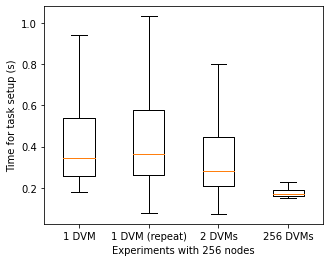

In [18]:
# delta = t_exec - t_runtime, where t_runtime is a sleep time for `hello_rp`, 
#                                   t_exec = task_exec_stop - task_exec_start

#                mean     std   min    max
input_data = [(  9.54,  21.53, 0.18,  75.5),  # 1 DVM, 256 nodes
              ( 10.29,  22.7,  0.08, 80.33),  # 1 DVM, 256 nodes
              (  9.13,  20.73, 0.07, 74.41),  # 2 DVMs, 256 nodes
              (  0.21,   0.21, 0.15,   3.5),  # 256 DVMs, 256 nodes
              ( 67.88,  89.27, 0.18, 268.2),  # 2 DVMs, 512 nodes
# w/ app_start( 67.88,  89.27, 0.07, 268.2)   # 2 DVMs, 512 nodes (same as previous)
              (408.13, 329.20, 0.19, 997.9)   # 8 DVMs, 2048 nodes
             ] 

d_1dvm = [0.3420839309692383, 52.37617111206055, 0.43995118141174316, 0.4404270648956299, 0.23004603385925293, 0.296734094619751, 0.29172587394714355, 0.3549020290374756, 60.18356204032898, 0.2868380546569824, 0.26293087005615234, 0.3977780342102051, 0.24642515182495117, 0.23114395141601562, 52.23076796531677, 0.4506101608276367, 55.73128700256348, 0.29539990425109863, 0.3114359378814697, 0.2650752067565918, 0.22322416305541992, 0.22464799880981445, 0.2441258430480957, 0.26300787925720215, 0.4221510887145996, 0.45613908767700195, 0.4011728763580322, 68.06359195709229, 0.5572538375854492, 0.26143598556518555, 68.51643514633179, 0.26152992248535156, 0.30015110969543457, 0.20234918594360352, 0.3024790287017822, 0.2616419792175293, 63.52142095565796, 0.2559478282928467, 0.3211519718170166, 0.2634861469268799, 65.61590218544006, 0.31328606605529785, 0.25349903106689453, 0.23046088218688965, 0.4582819938659668, 0.44428300857543945, 40.81961107254028, 0.4101979732513428, 0.5002119541168213, 0.2498159408569336, 0.42429304122924805, 62.19640398025513, 0.4830811023712158, 0.2479698657989502, 0.8402130603790283, 0.22635507583618164, 0.20210909843444824, 0.2979929447174072, 66.79412198066711, 0.20037198066711426, 9.251622915267944, 71.99553418159485, 0.3815629482269287, 0.21312689781188965, 0.24672698974609375, 0.5437331199645996, 0.3863530158996582, 0.26792001724243164, 0.3185420036315918, 0.2444159984588623, 0.25599193572998047, 0.42061710357666016, 0.21257400512695312, 55.34728693962097, 0.2515859603881836, 0.3470418453216553, 0.22547101974487305, 0.33568716049194336, 0.215285062789917, 0.289093017578125, 0.30522704124450684, 0.30504703521728516, 33.67594909667969, 0.3461730480194092, 69.74645018577576, 0.4453608989715576, 0.3172261714935303, 0.3855009078979492, 0.213454008102417, 0.23824810981750488, 0.43248486518859863, 0.22005605697631836, 0.6428790092468262, 0.24639892578125, 0.3061230182647705, 0.258983850479126, 0.23681187629699707, 0.3397941589355469, 0.40656399726867676, 19.134552001953125, 66.92200589179993, 0.39662790298461914, 0.2747209072113037, 0.5808019638061523, 0.29294896125793457, 0.37027812004089355, 0.23439812660217285, 0.5099289417266846, 42.67627692222595, 0.3710460662841797, 0.3485291004180908, 0.28502583503723145, 0.503565788269043, 0.34083008766174316, 0.36493396759033203, 0.24251794815063477, 68.41861414909363, 0.4659738540649414, 0.3555328845977783, 66.13639187812805, 0.5988740921020508, 0.36794185638427734, 0.19629597663879395, 0.494718074798584, 0.22908592224121094, 69.83457899093628, 0.6374220848083496, 0.26419901847839355, 0.25264906883239746, 0.2199850082397461, 0.23234200477600098, 0.334475040435791, 0.24416708946228027, 58.817095041275024, 0.24439287185668945, 41.763673067092896, 65.09964895248413, 0.22223615646362305, 0.26117587089538574, 0.5804450511932373, 0.5520589351654053, 0.23973298072814941, 0.3914189338684082, 0.2989799976348877, 0.29358792304992676, 0.23093414306640625, 0.2035830020904541, 0.21259617805480957, 0.33648014068603516, 67.95638680458069, 0.283984899520874, 0.5588750839233398, 0.3042318820953369, 65.07491517066956, 0.27633213996887207, 0.43677616119384766, 0.4550158977508545, 0.42789602279663086, 0.23170185089111328, 0.21323084831237793, 0.3233509063720703, 0.6629300117492676, 0.2942180633544922, 0.2622249126434326, 0.27150893211364746, 0.29200005531311035, 0.27107691764831543, 42.323033809661865, 0.4553818702697754, 0.23282885551452637, 0.5058019161224365, 68.83005499839783, 41.69059491157532, 0.20279192924499512, 52.33916711807251, 8.18193793296814, 0.2034289836883545, 0.46499204635620117, 0.2319478988647461, 0.31835198402404785, 0.4816460609436035, 0.23511886596679688, 0.2719440460205078, 0.35971713066101074, 64.24279284477234, 0.23766493797302246, 52.21428680419922, 28.870272159576416, 0.25464916229248047, 0.24952411651611328, 0.5114359855651855, 0.6829309463500977, 0.3533060550689697, 0.24898195266723633, 0.20895099639892578, 0.5073270797729492, 0.7277309894561768, 0.2484750747680664, 0.606154203414917, 0.2530229091644287, 0.5096638202667236, 61.923828125, 0.34953808784484863, 0.38763904571533203, 0.3999309539794922, 67.43540501594543, 0.2599360942840576, 0.27967405319213867, 0.33928489685058594, 0.2604219913482666, 0.36263298988342285, 0.21930408477783203, 0.45059990882873535, 0.19713115692138672, 0.26836299896240234, 0.27347493171691895, 0.3513059616088867, 0.40193605422973633, 0.2051379680633545, 0.38784098625183105, 0.21495485305786133, 0.22982096672058105, 0.7453038692474365, 50.26943302154541, 0.27830004692077637, 0.223160982131958, 0.3514230251312256, 0.25452399253845215, 0.21424603462219238, 0.3364849090576172, 0.34442996978759766, 0.2698979377746582, 0.3950011730194092, 0.711637020111084, 0.3589010238647461, 0.3605690002441406, 0.3008248805999756, 61.00801491737366, 13.714275121688843, 0.2369670867919922, 0.502763032913208, 0.3856358528137207, 0.2505810260772705, 0.24911093711853027, 0.20280790328979492, 60.969083070755005, 0.3952360153198242, 14.23205304145813, 0.23412585258483887, 0.48471999168395996, 0.40467309951782227, 0.41747498512268066, 0.21201610565185547, 0.22220277786254883, 0.21897602081298828, 69.29394483566284, 59.31046795845032, 0.20889496803283691, 0.35056400299072266, 0.3443489074707031, 0.2131049633026123, 55.19442296028137, 0.34217405319213867, 0.22368192672729492, 0.4106101989746094, 0.5316710472106934, 0.31009507179260254, 0.22057080268859863, 0.31282711029052734, 0.36673903465270996, 0.21475601196289062, 62.04211091995239, 0.6052889823913574, 64.66967105865479, 0.39930105209350586, 0.491549015045166, 0.2801220417022705, 0.35339784622192383, 70.15176677703857, 0.26662182807922363, 0.4073328971862793, 0.2900240421295166, 0.25763487815856934, 0.2553291320800781, 0.22539186477661133, 0.2916591167449951, 56.46955585479736, 0.35193490982055664, 28.885329008102417, 0.20446395874023438, 0.28316593170166016, 0.41536808013916016, 0.3543579578399658, 0.3087279796600342, 0.24837207794189453, 0.31825900077819824, 6.483592987060547, 0.5914871692657471, 0.2107558250427246, 0.4228091239929199, 0.2422199249267578, 0.38828182220458984, 0.32250404357910156, 0.2321929931640625, 43.55376696586609, 0.477262020111084, 0.2681620121002197, 0.1944429874420166, 0.5565218925476074, 0.23839592933654785, 0.2657771110534668, 0.3632831573486328, 0.4700770378112793, 0.28399085998535156, 0.23089194297790527, 67.02603006362915, 0.5079841613769531, 40.27782201766968, 0.276961088180542, 0.30812597274780273, 0.34355592727661133, 0.19150686264038086, 0.3483920097351074, 0.30355095863342285, 56.71725296974182, 0.2266840934753418, 0.3423798084259033, 0.32861804962158203, 53.24646615982056, 0.7137348651885986, 0.47028207778930664, 0.45041990280151367, 0.2100999355316162, 0.2792239189147949, 0.314363956451416, 0.2425520420074463, 67.14015889167786, 0.26892518997192383, 0.2237401008605957, 0.25547122955322266, 7.399364948272705, 0.34282994270324707, 0.27706408500671387, 37.968466997146606, 0.40825796127319336, 0.4060201644897461, 0.1950359344482422, 0.42305898666381836, 0.23015284538269043, 0.389232873916626, 0.6895589828491211, 68.94022607803345, 0.3607327938079834, 67.02822518348694, 0.6516499519348145, 0.2571561336517334, 0.48349499702453613, 0.31093287467956543, 48.37965703010559, 0.3200380802154541, 0.6648831367492676, 0.2636270523071289, 0.36000704765319824, 0.2776927947998047, 0.4215409755706787, 0.279296875, 49.20453596115112, 0.2725081443786621, 0.39859485626220703, 0.2723097801208496, 0.58365797996521, 56.09845995903015, 0.23836588859558105, 0.23247003555297852, 0.24310302734375, 0.39739298820495605, 42.65649390220642, 0.20809102058410645, 0.19526410102844238, 0.26021313667297363, 0.6607999801635742, 0.25621509552001953, 0.23723602294921875, 0.3018209934234619, 72.69070792198181, 0.2583651542663574, 0.5548000335693359, 0.318418025970459, 0.3316349983215332, 0.3295631408691406, 0.23786497116088867, 0.31489014625549316, 0.3987150192260742, 0.3197760581970215, 0.4796938896179199, 37.93268609046936, 0.30237698554992676, 0.6229829788208008, 0.23784804344177246, 55.57603693008423, 62.79011106491089, 47.470381021499634, 0.2426621913909912, 0.2294778823852539, 0.4978818893432617, 0.24363303184509277, 0.5066421031951904, 0.24547386169433594, 0.6426968574523926, 0.27375197410583496, 0.38831400871276855, 0.266448974609375, 0.284060001373291, 0.27361512184143066, 41.62092709541321, 0.25216078758239746, 0.23307585716247559, 0.6416449546813965, 70.9106810092926, 0.27971601486206055, 0.43039584159851074, 0.24420690536499023, 0.2011702060699463, 0.4185049533843994, 0.2164440155029297, 0.252871036529541, 64.51069283485413, 0.24366998672485352, 0.38123106956481934, 0.24474287033081055, 0.25423693656921387, 0.24143099784851074, 66.52214288711548, 0.20661020278930664, 0.2662978172302246, 0.3684518337249756, 5.486788988113403, 0.4922640323638916, 0.20098400115966797, 0.39696407318115234, 0.24109101295471191, 0.40002918243408203, 0.37944602966308594, 0.3175699710845947, 0.28279995918273926, 0.2288680076599121, 0.2194821834564209, 0.41347694396972656, 0.23829388618469238, 0.6681580543518066, 0.5573558807373047, 70.43847703933716, 0.31746506690979004, 67.13152503967285, 0.6865561008453369, 0.3362700939178467, 0.2971169948577881, 0.4013369083404541, 0.2805180549621582, 0.2567429542541504, 0.29479098320007324, 0.2072157859802246, 0.4675309658050537, 0.29381608963012695, 0.662606954574585, 0.2639749050140381, 0.2803189754486084, 0.31398510932922363, 0.23539090156555176, 0.42266106605529785, 0.2909681797027588, 0.5839130878448486, 0.2564051151275635, 0.26151204109191895, 0.4231281280517578, 0.2780749797821045, 67.57696795463562, 0.4791710376739502, 0.7090802192687988, 0.45470213890075684, 45.50433397293091, 0.3239560127258301, 0.6150698661804199, 0.32191920280456543, 0.23946285247802734, 0.27353811264038086, 0.47319793701171875, 0.3872358798980713, 0.4865748882293701, 0.43406009674072266, 0.5631670951843262, 0.6601519584655762, 63.73557782173157, 0.5469090938568115, 0.205733060836792, 0.36496615409851074, 0.2705271244049072, 0.6194381713867188, 0.44786596298217773, 0.5156450271606445, 0.3213379383087158, 0.23221588134765625, 0.20660996437072754, 52.849788188934326, 0.45699000358581543, 66.43362379074097, 0.24930405616760254, 0.445051908493042, 0.3059351444244385, 0.5225751399993896, 0.29859399795532227, 0.19604897499084473, 0.37212395668029785, 0.3864459991455078, 66.74084877967834, 0.22330617904663086, 0.36965203285217285, 0.4641120433807373, 0.5528240203857422, 0.8103170394897461, 0.22364211082458496, 72.42538905143738, 69.74411702156067, 0.5945820808410645, 0.594559907913208, 0.31896495819091797, 0.263063907623291, 0.222121000289917, 0.4226839542388916, 0.28951597213745117, 0.2027430534362793, 0.3654491901397705, 0.25949597358703613, 0.4849109649658203, 55.45122289657593, 56.15341901779175, 0.24401283264160156, 8.662747144699097, 0.24238204956054688, 0.19049692153930664, 0.20557808876037598, 0.44297099113464355, 0.20345687866210938, 0.4006180763244629, 0.2294759750366211, 0.3606710433959961, 64.97155404090881, 0.28014397621154785, 0.5023970603942871, 0.4317190647125244, 52.081780195236206, 0.3061089515686035, 0.25940394401550293, 63.81243300437927, 0.2415170669555664, 0.2054300308227539, 0.4821910858154297, 0.22577691078186035, 0.8873710632324219, 0.5967779159545898, 0.24478483200073242, 0.24947404861450195, 61.38025879859924, 0.2581050395965576, 0.33063793182373047, 0.5686931610107422, 0.20078182220458984, 60.38109087944031, 0.2605769634246826, 51.440913915634155, 19.926856994628906, 0.21471905708312988, 0.47814512252807617, 0.19286704063415527, 0.2600288391113281, 0.5648739337921143, 0.3193697929382324, 0.29381799697875977, 0.2693469524383545, 0.19033408164978027, 0.2724618911743164, 0.3064110279083252, 0.20321393013000488, 0.43097901344299316, 0.25499391555786133, 0.22436285018920898, 75.52568697929382, 0.1938338279724121, 0.41031789779663086, 0.25488781929016113, 72.33304595947266, 0.5879340171813965, 62.10156202316284, 0.38991403579711914, 0.2664799690246582, 0.21845793724060059, 0.40871095657348633, 0.49325013160705566, 62.17705488204956, 25.413148164749146, 0.47650599479675293, 0.22346711158752441, 0.2113947868347168, 0.3339059352874756, 0.40220093727111816, 0.24051785469055176, 0.25827598571777344, 56.29987096786499, 0.3329799175262451, 0.48676013946533203, 0.4498159885406494, 0.43724489212036133, 66.72237491607666, 0.44807004928588867, 0.21587896347045898, 62.1431999206543, 0.4196441173553467, 0.20351195335388184, 0.21689796447753906, 0.31938910484313965, 0.3833959102630615, 0.7855019569396973, 0.34397196769714355, 58.08675694465637, 0.37880587577819824, 0.29715490341186523, 0.3930199146270752, 0.30448198318481445, 0.3086559772491455, 0.21407413482666016, 0.2365410327911377, 13.288829803466797, 0.5399649143218994, 57.164520025253296, 0.2510380744934082, 0.315201997756958, 0.4013969898223877, 0.33553409576416016, 0.23518800735473633, 63.818845987319946, 0.24139404296875, 0.3899970054626465, 0.3446362018585205, 68.20580697059631, 20.052479028701782, 0.25482797622680664, 0.39002418518066406, 0.3257009983062744, 0.24613499641418457, 0.29159998893737793, 0.27009010314941406, 0.37645411491394043, 0.30024290084838867, 0.2580540180206299, 0.2861919403076172, 0.3826279640197754, 0.38467979431152344, 0.31023502349853516, 0.34044599533081055, 0.33862996101379395, 0.42960619926452637, 0.3976008892059326, 52.853981018066406, 0.2611532211303711, 0.2186119556427002, 0.3780949115753174, 0.2477250099182129, 0.24004697799682617, 0.5441129207611084, 0.2324199676513672, 0.2656118869781494, 0.30975890159606934, 0.3046391010284424, 0.2990579605102539, 0.4100019931793213, 0.4189159870147705, 0.6318521499633789, 0.42150020599365234, 0.32179784774780273, 71.81225085258484, 0.19397687911987305, 0.4775278568267822, 0.25757813453674316, 66.14681100845337, 0.30368995666503906, 0.4027419090270996, 0.21352720260620117, 0.19657111167907715, 0.2615242004394531, 14.434080123901367, 72.19511604309082, 0.38065600395202637, 0.23231220245361328, 0.48047399520874023, 0.26100897789001465, 0.4769861698150635, 0.21628904342651367, 0.5498390197753906, 50.24385404586792, 0.3106958866119385, 0.4291520118713379, 0.43040990829467773, 0.2984468936920166, 0.5364270210266113, 0.25029802322387695, 0.47829294204711914, 0.6982581615447998, 0.24651002883911133, 0.22480297088623047, 56.784855127334595, 0.4486970901489258, 0.40349817276000977, 0.27910780906677246, 0.2036590576171875, 0.3189539909362793, 0.19170498847961426, 0.2646138668060303, 0.3561539649963379, 0.21373510360717773, 0.510749101638794, 0.6752221584320068, 0.2854001522064209, 0.25853991508483887, 0.44897007942199707, 67.04605102539062, 0.5811479091644287, 0.24372005462646484, 0.4723389148712158, 0.22508692741394043, 0.24057221412658691, 0.3684720993041992, 0.40000104904174805, 0.3146829605102539, 0.3079071044921875, 0.2798640727996826, 0.5624361038208008, 0.3643670082092285, 46.11970400810242, 0.24240612983703613, 0.5116000175476074, 0.42294812202453613, 0.5522260665893555, 0.29808998107910156, 0.21615290641784668, 0.636512041091919, 0.43666601181030273, 0.32094717025756836, 0.24637818336486816, 0.2923240661621094, 0.25166797637939453, 14.400496006011963, 65.12167382240295, 53.75687503814697, 0.2795121669769287, 0.19554805755615234, 62.85552096366882, 0.37996506690979004, 0.26466917991638184, 0.31807708740234375, 0.2945990562438965, 0.5102860927581787, 0.49181103706359863, 0.45838403701782227, 67.90588903427124, 0.23893404006958008, 0.1962430477142334, 0.19858312606811523, 0.47310805320739746, 67.51448106765747, 0.26549506187438965, 0.2589559555053711, 67.31883382797241, 0.28209900856018066, 0.28354310989379883, 0.2187349796295166, 0.2782721519470215, 0.19846200942993164, 0.23314905166625977, 0.3970479965209961, 0.2523181438446045, 69.24280309677124, 0.22898507118225098, 0.2414560317993164, 0.20708703994750977, 0.21997308731079102, 0.2436680793762207, 0.44651198387145996, 0.2464299201965332, 0.4875638484954834, 0.29194116592407227, 0.21595001220703125, 0.28689098358154297, 0.3933069705963135, 0.3571779727935791, 0.32103490829467773, 43.66991114616394, 0.24090003967285156, 0.1921699047088623, 68.85770916938782, 0.480180025100708, 0.46565794944763184, 0.2940409183502197, 0.2092139720916748, 0.2693760395050049, 0.22906088829040527, 68.8817720413208, 0.35286903381347656, 0.47861194610595703, 0.28614091873168945, 0.4485180377960205, 0.19150900840759277, 0.2822120189666748, 0.31897711753845215, 0.2236778736114502, 0.6808638572692871, 0.48960113525390625, 0.37491416931152344, 0.2714660167694092, 0.21236205101013184, 0.2019639015197754, 0.26663899421691895, 0.44109511375427246, 0.4089188575744629, 0.3098430633544922, 0.30197906494140625, 49.91864490509033, 0.2791900634765625, 0.2716829776763916, 0.3430929183959961, 0.5836648941040039, 0.2493889331817627, 0.23182415962219238, 0.31114697456359863, 0.25359487533569336, 0.48331403732299805, 72.65865182876587, 0.437000036239624, 65.64131593704224, 41.86928391456604, 0.2715919017791748, 0.35815000534057617, 0.27981090545654297, 0.5982470512390137, 0.3207058906555176, 0.2277088165283203, 0.28832221031188965, 0.2666361331939697, 0.3598661422729492, 0.323930025100708, 0.5198979377746582, 69.7424430847168, 0.7550899982452393, 0.5405659675598145, 51.63756203651428, 0.2503349781036377, 0.27516984939575195, 0.4714009761810303, 0.20587897300720215, 0.6599738597869873, 0.2546539306640625, 0.3262209892272949, 44.71968197822571, 0.45476198196411133, 0.2995908260345459, 0.2925710678100586, 0.44219112396240234, 0.5158979892730713, 0.513498067855835, 0.3325200080871582, 0.24156999588012695, 0.4555680751800537, 0.2560889720916748, 62.91144585609436, 0.2601659297943115, 0.24527502059936523, 62.98247194290161, 54.993587017059326, 0.47174501419067383, 0.21043705940246582, 0.24084115028381348, 0.35912084579467773, 0.3290989398956299, 0.23636984825134277, 0.2487928867340088, 0.6035480499267578, 0.7148089408874512, 0.39171290397644043, 0.2333519458770752, 0.578240156173706, 0.7362139225006104, 0.2070469856262207, 0.25180792808532715, 0.22196316719055176, 4.951523065567017, 0.21167612075805664, 0.7815968990325928, 0.3328549861907959, 0.3157219886779785, 0.42157912254333496, 66.59918999671936, 0.3417651653289795, 0.40755414962768555, 0.21498608589172363, 0.35553908348083496, 0.5341899394989014, 0.28405117988586426, 61.29309010505676, 0.3133111000061035, 0.2023160457611084, 0.37433815002441406, 0.29321718215942383, 67.32126808166504, 0.5684130191802979, 53.36447715759277, 0.22557997703552246, 0.3184940814971924, 0.24871611595153809, 0.23657894134521484, 0.24719595909118652, 0.5007219314575195, 0.2776339054107666, 0.6309230327606201, 0.258558988571167, 50.21254014968872, 0.3176910877227783, 0.5369880199432373, 0.2749009132385254, 0.43510890007019043, 34.66733694076538, 0.28784608840942383, 0.2993800640106201, 0.2647979259490967, 0.35798192024230957, 0.3552680015563965, 0.42181396484375, 0.29754185676574707, 8.434952974319458, 0.24830985069274902, 0.2127530574798584, 0.2679779529571533, 0.25913405418395996, 0.30132102966308594, 0.3152639865875244, 0.471451997756958, 65.13962411880493, 0.28351306915283203, 0.2632122039794922, 64.11919522285461, 0.2180008888244629, 0.7230141162872314, 0.305631160736084, 0.32396888732910156, 0.19578003883361816, 43.70530986785889, 0.4928920269012451, 0.41353893280029297, 0.5126080513000488, 0.27056193351745605, 0.3130199909210205, 0.2504770755767822, 7.073591947555542, 0.26717710494995117, 44.87742304801941, 0.3891639709472656, 0.22514605522155762, 0.6875488758087158, 0.3278989791870117, 0.47823381423950195, 68.87153100967407, 0.45264410972595215, 0.45171308517456055, 0.3166689872741699, 0.3938429355621338, 0.23927998542785645, 0.48684215545654297, 0.27541494369506836, 0.3854341506958008, 0.24250483512878418, 60.82426190376282, 0.22285199165344238, 0.5971019268035889, 0.3709089756011963, 0.27874112129211426, 0.21757102012634277, 0.19768095016479492, 0.19803309440612793, 67.91555619239807, 0.2481369972229004, 0.5197451114654541, 0.40212202072143555, 0.38094091415405273, 57.822376012802124, 0.28893017768859863, 0.5669820308685303, 68.6264579296112, 0.23338794708251953, 0.533872127532959, 0.38939690589904785, 0.5344769954681396, 0.27892088890075684, 0.2924039363861084, 0.2747161388397217, 0.22324395179748535, 0.25041699409484863, 51.94318890571594, 0.29012203216552734, 0.2688639163970947, 0.5029621124267578, 0.3376438617706299, 0.3617820739746094, 0.30187082290649414, 0.2682380676269531, 41.70281004905701, 0.35646820068359375, 0.5791058540344238, 52.25548195838928, 0.5357310771942139, 0.5397670269012451, 0.24480295181274414, 0.24493908882141113, 0.7268819808959961, 0.6861059665679932, 0.23650503158569336, 0.7232251167297363, 0.4900360107421875, 0.37813401222229004, 0.6393368244171143, 0.37567615509033203, 0.2963368892669678, 0.23190093040466309, 0.2695341110229492, 0.24367690086364746, 52.14012312889099, 0.28763508796691895, 0.2256019115447998, 65.6142168045044, 0.2900660037994385, 0.2387840747833252, 0.23102998733520508, 0.37300920486450195, 0.18520593643188477, 0.7057280540466309, 62.30042386054993, 0.5115249156951904, 70.746178150177, 0.1915421485900879, 0.27749013900756836, 0.20853114128112793, 0.5915408134460449, 0.33032798767089844, 0.2658350467681885, 0.2817389965057373, 0.3839559555053711, 0.6467890739440918, 0.2912571430206299, 0.2340550422668457, 0.34214115142822266, 0.2597010135650635, 0.2950420379638672, 63.40173316001892, 0.4144141674041748, 62.84330701828003, 0.3072199821472168, 0.29482603073120117, 0.3936300277709961, 0.2696380615234375, 0.5315999984741211, 0.2316420078277588, 0.5570359230041504, 41.20063090324402, 0.6045641899108887, 0.3171219825744629, 0.302426815032959, 0.5486319065093994, 61.00383996963501, 26.70571994781494, 0.2955160140991211, 69.21647906303406, 0.2237100601196289, 0.2313079833984375, 0.3490619659423828, 0.30393004417419434, 0.36116909980773926, 0.44070005416870117, 0.6716561317443848, 0.48453688621520996, 43.2034330368042, 0.2703568935394287, 0.23063397407531738, 0.35149693489074707, 52.30343699455261, 0.28699517250061035, 0.34308886528015137, 0.3577718734741211, 0.5376529693603516, 0.20314598083496094, 41.0897741317749, 0.37867116928100586, 0.6406519412994385, 0.22204184532165527, 67.36400508880615, 0.19501900672912598, 0.23807191848754883, 63.99571394920349, 0.444537878036499, 0.4290611743927002, 0.2580709457397461, 0.366178035736084, 0.3216872215270996, 0.33031797409057617, 0.48632287979125977, 0.25748109817504883, 0.30870604515075684, 0.2961568832397461, 71.55457496643066, 38.229809045791626, 0.3849799633026123, 0.4629969596862793, 62.92158007621765, 65.13973307609558, 0.20553994178771973, 0.5468599796295166, 0.24661707878112793, 56.09763288497925, 0.5256149768829346, 0.23584914207458496, 0.3709139823913574, 0.2990090847015381, 0.3418090343475342, 0.3154759407043457, 0.2560849189758301, 67.88615298271179, 0.23218297958374023, 67.48167085647583, 0.2851879596710205, 0.41006994247436523, 0.26381492614746094, 0.54339599609375, 0.2059779167175293, 71.86362910270691, 0.31684088706970215, 0.19394207000732422, 0.48314404487609863, 0.31118202209472656, 0.32289814949035645, 0.3777658939361572, 0.5270330905914307, 71.09877514839172, 0.2129669189453125, 0.2314310073852539, 69.03407096862793, 60.595174074172974, 0.34517693519592285, 0.27519893646240234, 0.23790502548217773, 0.3099079132080078, 0.2472829818725586, 0.513098955154419, 0.31738805770874023, 0.4095749855041504, 0.28476715087890625, 0.19080185890197754, 0.36218881607055664, 0.27584004402160645, 0.3510630130767822, 69.4007580280304, 0.4960918426513672, 0.21716785430908203, 60.72860288619995, 0.6387579441070557, 0.2587869167327881, 0.20037102699279785, 0.34154415130615234, 34.33415102958679, 0.3509938716888428, 0.24233078956604004, 0.3280799388885498, 0.2430429458618164, 0.6829001903533936, 0.2365279197692871, 0.3345620632171631, 58.31976795196533, 0.2295398712158203, 0.26588892936706543, 0.7088289260864258, 0.29703593254089355, 0.2808690071105957, 60.39282989501953, 0.28578710556030273, 35.52436804771423, 53.775614976882935, 0.2085418701171875, 0.2873258590698242, 0.2200469970703125, 0.2498610019683838, 0.7790470123291016, 0.36952805519104004, 0.4547700881958008, 0.4299900531768799, 60.71369194984436, 0.3546459674835205, 32.4356689453125, 71.75141406059265, 0.2526071071624756, 0.5577118396759033, 0.23752593994140625, 66.90147399902344, 0.21668505668640137, 0.45116186141967773, 0.4996302127838135, 0.20122694969177246, 0.3707749843597412, 0.360213041305542, 0.3986680507659912, 0.20099210739135742, 63.09361410140991, 0.23896121978759766, 67.1909990310669, 0.4257380962371826, 0.25311803817749023, 0.22452402114868164, 63.86242198944092, 0.4123351573944092, 0.35555291175842285, 0.21672415733337402, 0.19804811477661133, 0.2418498992919922, 0.686290979385376, 0.23061203956604004, 0.25011110305786133, 37.423710107803345, 0.2651710510253906, 0.37478089332580566, 0.5305469036102295, 0.4935879707336426, 0.2840409278869629, 0.3056759834289551, 0.28641295433044434, 0.40445995330810547, 69.18441796302795, 0.46102118492126465, 0.2483959197998047, 0.19909381866455078, 0.2050778865814209, 67.07832217216492, 0.3800680637359619, 0.38543105125427246, 0.2998800277709961, 0.36997294425964355, 0.2288060188293457, 0.36957597732543945, 37.34614086151123, 58.962785959243774, 0.5646450519561768, 0.41091203689575195, 0.25522589683532715, 0.5081119537353516, 0.3838989734649658, 0.24160194396972656, 0.3873860836029053, 69.61269021034241, 0.24647903442382812, 40.438931941986084, 0.21679186820983887, 0.36510705947875977, 0.23286795616149902, 0.34465789794921875, 0.2645139694213867, 59.390751123428345, 0.5532259941101074, 0.25701904296875, 63.801361083984375, 0.3548259735107422, 0.23388409614562988, 0.24802803993225098, 47.18518114089966, 0.5208959579467773, 0.2455441951751709, 0.5068449974060059, 51.798563957214355, 0.28787708282470703, 0.5986359119415283, 0.2058701515197754, 0.6030800342559814, 0.372636079788208, 0.45261621475219727, 0.21396303176879883, 0.4892420768737793, 0.3280620574951172, 0.23959708213806152, 0.585507869720459, 0.41626906394958496, 0.5740180015563965, 0.3775298595428467, 0.25811290740966797, 0.2718031406402588, 64.26848983764648, 0.37619614601135254, 0.2306499481201172, 0.4217569828033447, 0.5211820602416992, 0.40003204345703125, 0.47289490699768066, 54.56404519081116, 0.3778719902038574, 0.24436116218566895, 0.31623387336730957, 0.5734398365020752, 0.19964003562927246, 0.19762492179870605, 0.4581270217895508, 0.2227458953857422, 0.28274106979370117, 0.2895190715789795, 29.43618607521057, 0.2960348129272461, 0.6243200302124023, 0.6263911724090576, 68.52138495445251, 46.02090907096863, 0.3291740417480469, 0.23148703575134277, 0.2664051055908203, 0.42443108558654785, 0.22038602828979492, 0.3284270763397217, 0.22797608375549316, 0.5161831378936768, 0.3878140449523926, 0.25965094566345215, 0.40430307388305664, 0.25845909118652344, 0.2188739776611328, 47.353816986083984, 0.37560606002807617, 0.2897307872772217, 0.4713749885559082, 0.2160499095916748, 0.29517292976379395, 61.92910099029541, 47.92607283592224, 0.650780200958252, 0.303508996963501, 0.36832308769226074, 0.2791271209716797, 0.20560503005981445, 0.3588078022003174, 0.35004210472106934, 0.4650990962982178, 0.23538494110107422, 0.2854578495025635, 0.48664116859436035, 63.88125801086426, 66.18394613265991, 0.6211388111114502, 0.26267313957214355, 0.2568628787994385, 0.30944299697875977, 37.684231996536255, 0.2900960445404053, 0.3146820068359375, 0.20806288719177246, 0.22059893608093262, 0.30469298362731934, 0.5152730941772461, 0.28905200958251953, 0.4007909297943115, 0.23261284828186035, 66.14691209793091, 0.19880318641662598, 0.4049699306488037, 64.2170078754425, 0.3054471015930176, 0.24309515953063965, 0.3299391269683838, 59.18989300727844, 0.42388916015625, 0.33206796646118164, 0.26175498962402344, 0.38898396492004395, 0.244581937789917, 0.47686100006103516, 0.32890892028808594, 0.5129199028015137, 0.23826003074645996, 0.3350701332092285, 0.27761101722717285, 56.58225393295288, 0.5133600234985352, 0.3896329402923584, 0.33630800247192383, 0.25839805603027344, 70.10758996009827, 0.2018909454345703, 0.2349698543548584, 0.5825390815734863, 0.33096981048583984, 0.637747049331665, 0.3901340961456299, 0.2987799644470215, 0.5979671478271484, 0.2747769355773926, 74.06215405464172, 0.4674398899078369, 31.053189992904663, 0.5106301307678223, 0.26288509368896484, 0.47418212890625, 0.3388330936431885, 0.2390439510345459, 0.2437748908996582, 0.25338101387023926, 0.39823102951049805, 0.2561769485473633, 63.83778500556946, 0.240523099899292, 0.491300106048584, 0.2272031307220459, 0.2124478816986084, 0.32882213592529297, 59.11181998252869, 0.21855902671813965, 0.4686610698699951, 0.3800029754638672, 0.5575389862060547, 0.22817015647888184, 0.6061830520629883, 0.6087789535522461, 0.28609490394592285, 0.5874419212341309, 39.979535818099976, 64.89879608154297, 0.23575282096862793, 0.49749112129211426, 0.48299288749694824, 0.4554588794708252, 74.26453495025635, 0.25615501403808594, 0.24303102493286133, 0.3268311023712158, 0.2577199935913086, 0.21288514137268066, 0.5175788402557373, 68.25110983848572, 0.23283600807189941, 0.20710396766662598, 66.32569313049316, 0.45494699478149414, 0.24995803833007812, 0.24060511589050293, 0.5662999153137207, 0.199293851852417, 0.4650561809539795, 57.8534369468689, 39.845710039138794, 0.4544370174407959, 0.3508880138397217, 0.2797119617462158, 0.2386789321899414, 0.30798792839050293, 0.38786888122558594, 0.3184521198272705, 0.5511469841003418, 0.3035011291503906, 0.3014950752258301, 0.27218008041381836, 0.7042407989501953, 0.2917180061340332, 72.37741899490356, 0.21143507957458496, 0.2933080196380615, 67.05274987220764, 0.45056891441345215, 0.19925999641418457, 0.8133089542388916, 52.99011516571045, 68.6823251247406, 0.3753058910369873, 0.3543539047241211, 0.5793290138244629, 0.2991039752960205, 0.25699806213378906, 0.5967519283294678, 0.22037696838378906, 0.6472599506378174, 37.01531386375427, 0.23516488075256348, 0.33304619789123535, 0.2726008892059326, 0.38509416580200195, 0.21595287322998047, 0.287369966506958, 58.24015784263611, 0.25803494453430176, 0.2912600040435791, 0.24509596824645996, 0.3994748592376709, 0.2894430160522461, 0.2449960708618164, 0.21122217178344727, 41.803181171417236, 0.26503586769104004, 0.19901704788208008, 0.3939700126647949, 0.42236804962158203, 0.3701660633087158, 0.5913348197937012, 0.3138270378112793, 0.5274510383605957, 64.95224213600159, 0.39728593826293945, 0.415071964263916, 0.5281071662902832, 0.19233393669128418, 59.16572594642639, 0.30342912673950195, 0.7727870941162109, 0.315518856048584, 0.24001383781433105, 0.22427797317504883, 0.22240805625915527, 0.4244539737701416, 0.3564000129699707, 0.23605012893676758, 0.2673790454864502, 0.46217989921569824, 0.73996901512146, 0.43643712997436523, 37.004420042037964, 0.5449099540710449, 66.50316405296326, 0.21958303451538086, 0.6165399551391602, 0.22818708419799805, 0.38809895515441895, 58.338468074798584, 0.20265603065490723, 0.22449803352355957, 57.2128050327301, 0.8201830387115479, 0.430034875869751, 0.32422804832458496, 0.3668849468231201, 0.4991309642791748, 0.28098487854003906, 0.19547009468078613, 0.48186802864074707, 0.23711395263671875, 0.2294750213623047, 0.19947600364685059, 0.3619821071624756, 0.31392788887023926, 65.24486517906189, 0.27887415885925293, 46.675832986831665, 0.39779090881347656, 0.4049491882324219, 0.2099609375, 0.2434399127960205, 0.424177885055542, 44.83041000366211, 0.30680394172668457, 0.3886430263519287, 0.2927279472351074, 0.2799689769744873, 0.29697489738464355, 0.37371087074279785, 0.26564693450927734, 62.399405002593994, 0.2743101119995117, 0.3312950134277344, 0.8456230163574219, 0.3665921688079834, 0.6747231483459473, 0.2144629955291748, 66.04523301124573, 0.47268199920654297, 0.3916511535644531, 0.463947057723999, 65.07858300209045, 0.5198338031768799, 0.3747859001159668, 0.486799955368042, 0.22253108024597168, 62.92241597175598, 0.3809211254119873, 0.26190710067749023, 25.804443836212158, 70.93168997764587, 0.4074440002441406, 0.3067359924316406, 68.63482904434204, 0.35794496536254883, 0.4329710006713867, 0.36710214614868164, 0.33192896842956543, 0.2203350067138672, 0.26659512519836426, 0.6751530170440674, 0.5933411121368408, 0.3695850372314453, 56.36716103553772, 0.48006391525268555, 0.2566349506378174, 0.2793140411376953, 0.310575008392334, 65.66403412818909, 0.3018980026245117, 65.5413248538971, 0.516420841217041, 0.5326809883117676, 0.21211004257202148, 0.36577486991882324, 0.360339879989624, 0.42656993865966797, 45.361024141311646, 54.97508502006531, 0.4433300495147705, 0.34774208068847656, 0.3532848358154297, 0.523061990737915, 0.19849920272827148, 0.3723030090332031, 0.21325206756591797, 71.06952095031738, 0.3423330783843994, 64.04484009742737, 0.27805209159851074, 0.23824310302734375, 0.6089072227478027, 0.4035780429840088, 0.4392518997192383, 67.82634997367859, 0.43531107902526855, 0.5946531295776367, 0.746178150177002, 0.23479413986206055, 0.3882789611816406, 0.31087303161621094, 0.25686001777648926, 0.2640669345855713, 70.30441093444824, 0.24158096313476562, 27.006197929382324, 0.23378896713256836, 0.3670949935913086, 0.2857351303100586, 68.31425213813782, 0.5504090785980225, 47.202486991882324, 0.572871208190918, 0.574282169342041, 0.2052440643310547, 0.5850861072540283, 0.5135939121246338, 0.3329660892486572, 0.2164459228515625, 55.18919801712036, 0.531562089920044, 58.13599491119385, 0.4920690059661865, 0.45938897132873535, 50.732598066329956, 0.23514413833618164, 0.24358487129211426, 59.33325910568237, 0.1811671257019043, 0.2581629753112793, 0.25037503242492676, 54.39380979537964, 0.4208841323852539, 0.43358683586120605, 0.31139206886291504, 0.5065791606903076, 0.3601667881011963, 0.35848116874694824, 0.41014599800109863, 1.4056470394134521, 0.35849690437316895, 60.507766008377075, 0.26112890243530273, 0.6668679714202881, 0.251384973526001, 67.26217198371887, 0.2691330909729004, 0.2768700122833252, 0.32793402671813965, 0.5191118717193604, 0.293057918548584, 0.25509190559387207, 0.2559061050415039, 68.58686304092407, 0.22154998779296875, 0.23456907272338867, 0.2699918746948242, 0.20228791236877441, 0.2547149658203125, 60.4927179813385, 0.6642389297485352, 54.95667791366577, 0.41997194290161133, 0.2253739833831787, 0.296245813369751, 0.1980741024017334, 0.485476016998291, 0.2873959541320801, 70.81508088111877, 36.619256019592285, 0.43575000762939453, 0.2728300094604492, 0.2651209831237793, 0.3751718997955322, 0.5709049701690674, 0.27370119094848633, 0.26482605934143066, 57.49787497520447, 0.38865017890930176, 0.2107839584350586, 0.23165106773376465, 0.3895249366760254, 0.3000760078430176, 0.29601311683654785, 0.19161510467529297, 42.356101989746094, 0.36197495460510254, 0.22794389724731445, 0.3634181022644043, 50.291378021240234, 0.2563018798828125, 0.6057920455932617, 0.3644378185272217, 0.24208593368530273, 0.37534594535827637, 0.4627389907836914, 0.24679803848266602, 0.435683012008667, 0.2681128978729248, 0.35897111892700195, 0.2932310104370117, 0.1989588737487793, 0.29613399505615234, 0.21216583251953125, 62.25339984893799, 0.5816349983215332, 0.20933198928833008, 0.21279096603393555, 0.1935269832611084, 0.3977839946746826, 0.19360589981079102, 0.28554606437683105, 0.3635730743408203, 0.26898908615112305, 37.82076382637024, 0.38893699645996094, 45.65842294692993, 0.3064150810241699, 0.24762201309204102, 0.2455909252166748, 0.29241108894348145, 0.22811198234558105, 0.35193896293640137, 0.27224087715148926, 0.42880797386169434, 0.4349808692932129, 0.36976194381713867, 0.3879709243774414, 0.2273709774017334, 63.292529821395874, 73.16730618476868, 27.194201946258545, 0.2613341808319092, 58.386033058166504, 0.24268388748168945, 0.511746883392334, 0.20453286170959473, 0.33298301696777344, 0.36339402198791504, 0.5142719745635986, 0.346876859664917, 0.21242499351501465, 35.74502182006836, 0.22485113143920898, 0.2556121349334717, 0.28022217750549316, 0.825747013092041, 0.27329301834106445, 68.54297280311584, 0.5238370895385742, 0.34075093269348145, 0.43786001205444336, 0.2814810276031494, 0.23059296607971191, 0.6398229598999023, 0.3844940662384033, 74.66444611549377, 0.28142285346984863, 0.2559089660644531, 60.93471693992615, 0.3985018730163574, 0.30440711975097656, 0.3427739143371582, 0.5357389450073242, 43.235880851745605, 0.5191600322723389, 0.2248988151550293, 0.23119401931762695, 0.445936918258667, 0.8118999004364014, 0.26894402503967285, 0.2301170825958252, 0.32021403312683105, 0.5647499561309814, 67.23100900650024, 0.26159214973449707, 0.3701958656311035, 0.34064316749572754, 0.32090210914611816, 0.37966394424438477, 0.2573568820953369, 0.48527097702026367, 64.08111095428467, 0.5069670677185059, 0.34749507904052734, 1.3777170181274414, 0.30145812034606934, 0.6338191032409668, 0.276745080947876, 54.92787003517151, 0.4024930000305176, 0.3428959846496582, 0.3761940002441406, 0.4649810791015625, 0.2712550163269043, 0.311755895614624, 0.25832104682922363, 0.2726738452911377, 0.2975921630859375, 41.858762979507446, 62.49322700500488, 0.3253631591796875, 0.20255517959594727, 0.4695589542388916, 0.19782495498657227, 0.19890594482421875, 0.2776191234588623, 0.26779794692993164, 0.23720288276672363, 0.21431684494018555, 0.43718600273132324, 0.7103378772735596, 56.70892691612244, 0.49119091033935547, 57.76745295524597, 65.9688549041748, 0.35970377922058105, 0.4051661491394043, 0.29029297828674316, 0.19657206535339355, 0.4852628707885742, 0.20394110679626465, 66.03266096115112, 0.5741758346557617, 0.22500205039978027, 0.5638229846954346, 0.25922584533691406, 63.47048807144165, 0.2734110355377197, 66.33677005767822, 0.3762681484222412, 0.46075010299682617, 0.42604994773864746, 0.2909359931945801, 0.30227208137512207, 0.23673009872436523, 0.35041093826293945, 0.34702396392822266, 1.3895771503448486, 0.5901191234588623, 32.14731192588806, 0.2692408561706543, 0.9426190853118896, 0.40204286575317383, 0.5755040645599365, 57.350927114486694, 0.25293993949890137, 0.24243378639221191, 0.4987819194793701, 0.9221758842468262, 0.36879706382751465, 0.5242700576782227, 0.5561599731445312, 0.22707200050354004, 0.29009199142456055, 0.5323190689086914, 0.5803139209747314, 0.4321630001068115, 0.25402307510375977, 0.22274494171142578, 66.19588589668274, 0.23822498321533203, 0.38386988639831543, 0.20856213569641113, 0.4400918483734131, 0.36392879486083984, 58.962626934051514, 0.5214090347290039, 0.20859885215759277, 45.294514179229736, 67.17246294021606, 0.21509480476379395, 0.23295807838439941, 0.26152896881103516, 0.3622279167175293, 60.2076461315155, 0.3797340393066406, 0.2078399658203125, 0.20701098442077637, 0.3709099292755127, 0.24937200546264648, 0.21452808380126953, 0.19516515731811523, 67.34904408454895, 0.30800604820251465, 0.22876811027526855, 0.43494582176208496, 0.3001079559326172, 64.69598579406738, 0.44006991386413574, 66.36150693893433, 0.3065669536590576, 0.4544260501861572, 0.47042083740234375, 0.28200507164001465, 0.20744895935058594, 0.34400296211242676, 0.31757307052612305, 35.49717617034912, 0.3090078830718994, 0.22035980224609375, 0.2463359832763672, 0.3498067855834961, 0.420712947845459, 1.3647949695587158, 0.3231849670410156, 0.3728189468383789, 0.3531820774078369, 0.38297200202941895, 0.23490190505981445, 0.3574800491333008, 0.4296700954437256, 43.017499923706055, 0.29521608352661133, 0.20161986351013184, 0.4794778823852539, 0.3522181510925293, 0.35843706130981445, 0.20187115669250488, 0.383530855178833, 69.02422595024109, 0.3237619400024414, 0.3434779644012451, 0.36176180839538574, 0.28185486793518066, 64.816330909729, 0.4778938293457031, 0.5396640300750732, 0.3200199604034424, 0.19686293601989746, 0.21590781211853027, 58.5180139541626, 0.19739913940429688, 0.5314269065856934, 0.39879393577575684, 0.43214988708496094, 36.153496980667114, 0.2858729362487793, 0.4146859645843506, 0.25847911834716797, 0.2110919952392578, 0.22165417671203613, 0.49143004417419434, 0.41674113273620605, 0.22856688499450684, 0.20943498611450195, 0.20285701751708984, 0.5480461120605469, 0.31256794929504395, 0.34621596336364746, 0.36325979232788086, 0.3073101043701172, 66.20202493667603, 60.012819051742554, 0.29360079765319824, 0.32119202613830566, 0.4536399841308594, 0.24787211418151855, 0.3158259391784668, 0.3136608600616455, 0.21122503280639648, 0.2975149154663086, 0.3292510509490967, 0.39231181144714355, 0.5532550811767578, 0.19916796684265137, 0.24091100692749023, 0.2669830322265625, 51.19061303138733, 0.3095388412475586, 71.75101613998413, 0.3834090232849121, 0.48611903190612793, 0.25814390182495117, 0.3716468811035156, 0.6674308776855469, 0.5407798290252686, 0.4584779739379883, 0.48568201065063477, 0.5153419971466064, 0.3292248249053955, 0.21419596672058105, 31.633761882781982, 65.19069004058838, 0.21051311492919922, 0.35765695571899414, 0.20858407020568848, 0.3473780155181885, 0.3906590938568115, 0.2960019111633301, 53.130773067474365, 0.26572084426879883, 0.36517810821533203, 66.15016603469849, 0.35359907150268555, 47.52478909492493, 0.4388730525970459, 0.3317561149597168, 0.2888178825378418, 0.24342107772827148, 0.6402440071105957, 0.2789480686187744, 0.22677302360534668, 0.3292520046234131, 0.39579200744628906, 0.2689330577850342, 0.5259478092193604, 68.85780692100525, 0.2902829647064209, 0.3353409767150879, 0.31893181800842285, 0.3158690929412842, 0.5493838787078857, 0.21420812606811523, 0.3094029426574707, 0.2918710708618164, 0.2159111499786377, 45.1381299495697, 0.4670450687408447, 52.69166111946106, 0.411592960357666, 0.2911570072174072, 0.4403250217437744, 0.4369640350341797, 57.55512499809265, 0.22211098670959473, 0.2924690246582031, 0.365649938583374, 0.41207313537597656, 0.26776790618896484, 0.2584190368652344, 0.3213789463043213, 0.26535892486572266, 18.817270040512085, 0.22636103630065918, 57.89982509613037, 53.04588603973389, 0.26961612701416016, 0.1977379322052002, 0.23443198204040527, 0.21264410018920898, 0.25257182121276855, 0.39922595024108887, 0.556952953338623, 66.79125714302063, 0.274946928024292, 0.2471930980682373, 0.2539699077606201, 0.5303869247436523, 38.42920517921448, 0.34616589546203613, 66.3262448310852, 0.4109928607940674, 66.61296796798706, 0.33100199699401855, 0.24758601188659668, 0.20165705680847168, 0.20036101341247559, 0.3486030101776123, 0.36718201637268066, 70.49411106109619, 0.3707258701324463, 0.4739341735839844, 0.30526304244995117, 0.42468905448913574, 0.424638032913208, 0.23098397254943848, 0.7255990505218506, 0.387484073638916, 57.19992208480835, 0.28708410263061523, 0.24070096015930176, 0.5002729892730713, 0.6474931240081787, 0.5124068260192871, 0.2551710605621338, 69.71842885017395, 0.3252108097076416, 62.451748847961426, 0.23148298263549805, 0.6300868988037109, 0.20885992050170898, 0.5206890106201172, 0.3257298469543457, 0.242020845413208, 0.2529768943786621, 44.36537003517151, 69.03197908401489, 0.49581313133239746, 0.39287805557250977, 0.30883216857910156, 70.25294804573059, 0.22422313690185547, 0.28668212890625, 0.4731719493865967, 71.31346201896667, 0.47348904609680176, 0.3500199317932129, 0.213209867477417, 0.5941109657287598, 0.2789781093597412, 0.5168349742889404, 0.20840001106262207, 32.28336215019226, 0.27422308921813965, 0.19780397415161133, 0.22018694877624512, 0.7382950782775879, 0.4475550651550293, 0.21169710159301758, 0.33432793617248535, 53.137606143951416, 0.20825695991516113, 0.255047082901001, 0.1922140121459961, 0.5995240211486816, 0.22543597221374512, 0.25855112075805664, 0.37072205543518066, 37.570456981658936, 0.2502579689025879, 0.35619401931762695, 60.00983905792236, 0.21271991729736328, 0.31362199783325195, 0.2685220241546631, 0.27008700370788574, 0.572486162185669, 0.4239048957824707, 67.38288402557373, 0.23952579498291016, 0.29614996910095215, 0.6995739936828613, 0.3230009078979492, 59.38625383377075, 0.474074125289917, 0.47153806686401367, 0.46105384826660156, 0.38723301887512207, 0.23500514030456543, 0.5791630744934082, 62.39274597167969, 0.39561986923217773, 0.31983304023742676, 0.2247171401977539, 0.3340001106262207, 0.24773192405700684, 0.6494970321655273, 0.5230147838592529, 70.71373891830444, 0.47542595863342285, 0.3280060291290283, 0.2085280418395996, 0.22395682334899902, 61.33269715309143, 0.365617036819458, 0.3022899627685547, 68.70284295082092, 0.2661120891571045, 0.4074680805206299, 0.2401421070098877, 0.20093798637390137, 0.6406910419464111, 0.22163796424865723, 0.5777289867401123, 0.37406206130981445, 0.215040922164917, 0.23244380950927734, 0.3337860107421875, 0.3339691162109375, 46.65117883682251, 0.4338560104370117, 0.23409199714660645, 0.25218987464904785, 26.992084980010986, 0.26491594314575195, 56.005773067474365, 0.79156494140625, 0.26433515548706055, 0.2910900115966797, 0.23956990242004395, 0.4919850826263428, 0.29646801948547363, 0.27495503425598145, 0.24800801277160645, 0.5864851474761963, 0.27184104919433594, 0.23020219802856445, 0.6425230503082275, 57.236035108566284, 0.33197498321533203, 0.28709888458251953, 57.05150508880615, 0.355755090713501, 0.7957019805908203, 0.2501242160797119, 0.34318113327026367, 0.2361130714416504, 64.02398490905762, 0.39797401428222656, 0.4575469493865967, 0.33513593673706055, 0.46937012672424316, 0.42234110832214355, 0.26960301399230957, 0.276263952255249, 0.22986102104187012, 0.22284197807312012, 0.22564005851745605, 0.35039687156677246, 29.56128191947937, 0.28286290168762207, 0.6813070774078369, 0.3175010681152344, 0.2793149948120117, 0.6130619049072266, 62.8933539390564, 53.32141709327698, 0.21255183219909668, 0.2901480197906494, 0.3611791133880615, 0.777623176574707, 0.37949109077453613, 0.4045119285583496, 0.19433999061584473, 0.25276899337768555, 68.85527396202087, 0.30498600006103516, 0.27767086029052734, 0.21820497512817383, 0.24038386344909668, 0.30651283264160156, 0.2906169891357422, 0.28060102462768555, 55.71180701255798, 0.25566911697387695, 0.5778908729553223, 0.4683539867401123, 0.2903130054473877, 0.5542089939117432, 55.13801884651184, 0.5556387901306152, 0.5132808685302734, 50.57280898094177, 0.48447299003601074, 62.36080503463745, 0.23537707328796387, 0.5814740657806396, 0.35409998893737793, 0.2819499969482422, 0.34918689727783203, 0.5590620040893555, 66.4227409362793, 0.2687060832977295, 31.308830976486206, 0.2562680244445801, 0.1881091594696045, 70.08107209205627, 0.22560381889343262, 0.49742698669433594, 0.3385741710662842, 0.310028076171875, 0.28064608573913574, 47.46863913536072, 0.5203158855438232, 0.3551170825958252, 0.5418069362640381, 0.29619789123535156, 59.69789910316467, 0.442885160446167, 0.3814990520477295, 43.38880515098572, 0.3158249855041504, 0.21775603294372559, 0.28455400466918945, 0.3128650188446045, 0.2786421775817871, 0.4295809268951416, 0.34668493270874023, 0.4022669792175293, 0.542417049407959, 69.26192784309387, 0.21134018898010254, 0.5473980903625488, 0.6924488544464111, 44.63966107368469, 73.7918210029602, 0.3348350524902344, 50.24625587463379, 0.5376040935516357, 0.2956888675689697, 0.2894408702850342, 0.20663094520568848, 0.3374061584472656, 0.42217421531677246, 0.419497013092041, 0.24424195289611816, 0.32350707054138184, 0.2517061233520508, 57.364147901535034, 33.442192792892456, 0.23618102073669434, 0.23198795318603516, 0.2272200584411621, 53.729310035705566, 65.69999384880066, 0.2820429801940918, 0.21123099327087402, 0.5603160858154297, 1.4390900135040283, 0.38848018646240234, 0.3772730827331543, 0.33542799949645996, 0.40738701820373535, 0.2187058925628662, 0.21189403533935547, 68.24398899078369, 0.5485250949859619, 0.2053079605102539, 0.2608060836791992, 0.19339585304260254, 0.2725398540496826, 0.35473012924194336, 38.70822286605835, 51.60763502120972, 0.3901181221008301, 0.46470212936401367, 0.5922319889068604, 0.6067168712615967, 66.06345295906067, 0.3576078414916992, 67.054368019104, 0.1982250213623047, 0.2487318515777588, 0.21145105361938477, 0.2739219665527344, 0.4655439853668213, 0.3613719940185547, 0.28278303146362305, 57.12054204940796, 0.3921542167663574, 0.25992703437805176, 0.39386916160583496, 72.9145679473877, 0.3121771812438965, 0.3241109848022461, 0.2308640480041504, 0.26671600341796875, 70.57658910751343, 0.46942591667175293, 0.19813299179077148, 0.3121800422668457, 0.2106020450592041, 0.4108281135559082, 0.3592231273651123, 0.2485039234161377, 45.78890681266785, 0.251708984375, 0.24147391319274902, 0.3175969123840332, 0.26806187629699707, 0.6918339729309082, 0.38822388648986816, 0.6043949127197266, 59.98663783073425, 0.23311400413513184, 65.43170404434204, 0.29538512229919434, 0.22091889381408691, 0.19944095611572266, 0.2071390151977539, 62.07567596435547, 0.27255892753601074, 0.6642460823059082, 0.2975339889526367, 0.4586210250854492, 0.3471200466156006, 55.20522594451904, 0.4216930866241455, 0.35347986221313477, 0.3184831142425537, 0.4515678882598877, 64.34320998191833, 0.26775383949279785, 0.29897212982177734, 0.38968992233276367, 0.3218538761138916, 0.42471814155578613, 0.41397809982299805, 0.23958492279052734, 61.68593096733093, 0.3020298480987549, 0.3505289554595947, 0.22966504096984863, 0.4977569580078125, 55.11522078514099, 0.4940779209136963, 0.31105899810791016, 71.42033410072327, 0.4729478359222412, 0.3105590343475342, 0.24611997604370117, 0.4394240379333496, 0.3296651840209961, 0.3615880012512207, 0.29587483406066895, 0.24529790878295898, 0.41486597061157227, 0.21815013885498047, 70.97187995910645, 34.47876691818237, 0.23791217803955078, 0.2077198028564453, 0.251147985458374, 0.4098198413848877, 62.89047908782959, 0.6214630603790283, 0.22216391563415527, 0.37134313583374023, 0.2978639602661133, 0.6093640327453613, 0.5329818725585938, 56.446269035339355, 0.23627185821533203, 66.06084895133972, 0.2830660343170166, 0.35355615615844727, 0.3853909969329834, 0.22677898406982422, 0.24693703651428223, 0.20493006706237793, 0.2746109962463379, 0.3357222080230713, 0.19818687438964844, 0.21307897567749023, 0.23786401748657227, 0.4952828884124756, 0.2087869644165039, 64.74254608154297, 53.97005081176758, 40.70918083190918, 0.3408529758453369, 60.08721995353699, 0.3769698143005371, 0.2504558563232422, 0.2898120880126953, 0.21906614303588867, 0.2097010612487793, 0.4120979309082031, 0.3976590633392334, 59.23466491699219, 0.2850308418273926, 0.23177790641784668, 55.06201195716858, 0.34998393058776855, 0.23234200477600098, 0.42302608489990234, 61.20411396026611, 26.342997074127197, 0.587446928024292, 0.3255422115325928, 0.3568577766418457, 0.2691340446472168, 0.2592761516571045, 0.7562620639801025, 0.2617678642272949, 0.28069305419921875, 72.24227619171143, 70.747141122818, 0.3288848400115967, 0.5357568264007568, 0.306304931640625, 0.43585705757141113, 0.33263492584228516, 0.24053096771240234, 68.92549300193787, 0.23354506492614746, 0.2347249984741211, 0.31554508209228516, 0.25433993339538574, 0.2822890281677246, 0.373852014541626, 0.33591794967651367, 0.23881316184997559, 59.924330949783325, 0.328718900680542, 0.22382116317749023, 0.5876200199127197, 0.19704198837280273, 0.25817108154296875, 0.41495490074157715, 0.39864611625671387, 0.29138994216918945, 0.2183530330657959, 0.5634260177612305, 67.75005602836609, 0.3357820510864258, 0.2629969120025635, 0.28556180000305176, 0.3136169910430908, 0.21500110626220703, 0.21699309349060059, 0.23237895965576172, 0.35679101943969727, 0.4770030975341797, 0.20056581497192383, 0.2700068950653076, 0.27118492126464844, 0.559424877166748, 0.2755129337310791, 71.2834620475769, 67.80092883110046, 0.20815706253051758, 0.8416829109191895, 0.4426541328430176, 0.2711780071258545, 0.2877180576324463, 0.5240471363067627, 0.5308527946472168, 0.3547379970550537, 49.261638879776, 0.9128940105438232, 66.10798382759094, 0.21833181381225586, 0.24622797966003418, 0.1957709789276123, 0.4580709934234619, 0.33144497871398926, 0.2435929775238037, 57.507989168167114, 0.3209400177001953, 0.2650871276855469, 0.3583860397338867, 0.24189114570617676, 0.47527503967285156, 0.21266508102416992, 0.2634241580963135, 61.49324917793274, 0.29883503913879395, 0.2957789897918701, 0.24341893196105957, 0.44967198371887207, 0.6698031425476074, 71.8821108341217, 0.2429189682006836, 0.4113931655883789, 0.3707430362701416, 0.252701997756958, 0.22600579261779785, 0.4032890796661377, 0.20577597618103027, 0.7492818832397461, 64.12144303321838, 0.2974569797515869, 0.34730100631713867, 30.30674910545349, 0.44768500328063965, 0.29062795639038086, 0.4089038372039795, 0.24542593955993652, 0.36561083793640137, 0.22031712532043457, 0.505882978439331, 0.219987154006958, 0.2534770965576172, 0.24048209190368652, 0.2241818904876709, 0.3255190849304199, 0.45336198806762695, 0.5653951168060303, 0.38967394828796387, 0.6566710472106934, 43.857828855514526, 0.5477638244628906, 0.5305829048156738, 61.1045298576355, 0.4187180995941162, 0.4258739948272705, 0.20347094535827637, 0.26923394203186035, 0.2953019142150879, 0.4510478973388672, 0.47607898712158203, 0.2672719955444336, 0.33370494842529297, 0.24385404586791992, 0.3849499225616455, 0.4764738082885742, 60.586495876312256, 0.5243990421295166, 0.4202759265899658, 0.29457807540893555, 0.22359395027160645, 0.6734218597412109, 0.24613499641418457, 62.01624584197998, 58.08365201950073, 66.44889092445374, 0.23702311515808105, 0.7695269584655762, 0.7083249092102051, 0.3938181400299072, 0.25481104850769043, 0.22736787796020508, 0.2099771499633789, 0.24801993370056152, 0.24934101104736328, 0.2936248779296875, 0.2374401092529297, 0.23211908340454102, 47.6048538684845, 0.2002859115600586, 0.7363789081573486, 27.761722087860107, 0.4487121105194092, 0.4944469928741455, 0.41721320152282715, 0.45316195487976074, 0.3939988613128662, 0.3760840892791748, 0.20408105850219727, 63.478748083114624, 0.2684509754180908, 63.19607400894165, 0.19809198379516602, 0.45720911026000977, 0.41586899757385254, 0.20695114135742188, 67.17913007736206, 0.2682950496673584, 0.41389894485473633, 0.4438300132751465, 0.27584004402160645, 0.2758781909942627, 0.4743638038635254, 0.3024411201477051, 0.3937947750091553, 0.47893714904785156, 0.41930389404296875, 0.4924640655517578, 42.23362684249878, 0.6396641731262207, 58.97178602218628, 0.24172687530517578, 0.22938203811645508, 0.4563009738922119, 0.2338559627532959, 0.2317500114440918, 0.24444007873535156, 0.3212568759918213, 0.4331550598144531, 0.523339033126831, 63.071831941604614, 0.42833495140075684, 0.31304502487182617, 0.2371671199798584, 0.32190513610839844, 0.25035905838012695, 0.4937009811401367, 0.6026999950408936, 0.24449801445007324, 0.19711995124816895, 0.24616789817810059, 0.34915995597839355, 0.4005401134490967, 0.22368288040161133, 0.5669479370117188, 0.3223860263824463, 28.524821996688843, 0.1966540813446045, 0.23796391487121582, 0.2587699890136719, 0.34276413917541504, 54.33085608482361, 0.2619791030883789, 0.2305159568786621, 60.613407135009766, 0.5894179344177246, 0.24635004997253418, 0.2736828327178955, 0.3236548900604248, 0.6564939022064209, 0.6324388980865479, 66.88606905937195, 68.46618294715881, 0.2038872241973877, 65.2237069606781, 0.3686521053314209, 0.6557769775390625, 0.6152310371398926, 0.3262500762939453, 0.36888694763183594, 65.08573603630066, 0.21103715896606445, 0.30161499977111816, 0.22945499420166016, 0.4554610252380371, 0.20639801025390625, 0.2859170436859131, 0.22586297988891602, 0.22168421745300293, 68.63511991500854, 0.5517308712005615, 0.4577000141143799, 0.27205896377563477, 0.26738500595092773, 0.20447897911071777, 0.3048100471496582, 0.4080231189727783, 0.5800371170043945, 0.19790101051330566, 0.3099219799041748, 0.44467902183532715, 0.20343279838562012, 0.2930419445037842, 0.2594919204711914, 0.3706059455871582, 55.20431709289551, 0.621769905090332, 0.24374699592590332, 0.25597286224365234, 0.2779581546783447, 0.3734118938446045, 0.426908016204834, 0.30259108543395996, 0.23421907424926758, 60.26514291763306, 0.36357617378234863, 66.31438493728638, 0.34980106353759766, 0.536754846572876, 0.3113420009613037, 0.5146009922027588, 0.4416470527648926, 0.49952101707458496, 0.22530007362365723, 0.2669072151184082, 0.35793113708496094, 0.5125420093536377, 0.4106299877166748, 0.30963993072509766, 0.3350381851196289, 55.090121030807495, 58.31536102294922, 0.42842912673950195, 57.15786790847778, 0.2777218818664551, 0.25739192962646484, 0.2525930404663086, 0.28320908546447754, 0.6030991077423096, 0.3107340335845947, 0.19514083862304688, 0.8463020324707031, 49.79780912399292, 0.2761979103088379, 0.23471403121948242, 0.3829030990600586, 0.1968860626220703, 61.21452617645264, 28.48324990272522, 0.4899160861968994, 0.2513618469238281, 0.34264111518859863, 0.20238304138183594, 0.2847929000854492, 0.2782001495361328, 0.39427995681762695, 70.12480211257935, 0.24796295166015625, 0.20598602294921875, 73.53284502029419, 62.177013874053955, 0.475726842880249, 0.44992899894714355, 0.3171980381011963, 0.39604902267456055, 68.6557388305664, 0.30844902992248535, 0.22516393661499023, 0.2808821201324463, 0.2650148868560791, 0.37548208236694336, 0.22590088844299316, 0.21250581741333008, 65.60469198226929, 0.2075181007385254, 0.22643303871154785, 42.19894599914551, 0.24506711959838867, 0.23603510856628418, 0.3754301071166992, 0.21723198890686035, 0.4406299591064453, 0.27302098274230957, 0.22993707656860352, 58.5221209526062, 0.39696693420410156, 0.32941293716430664, 0.2310960292816162, 0.21656012535095215, 0.3065478801727295, 0.5274388790130615, 67.76452994346619, 22.360389947891235, 0.695573091506958, 0.49315404891967773, 0.22591018676757812, 0.3217439651489258, 0.5423159599304199, 0.5428698062896729, 0.2095339298248291, 73.97515511512756, 0.5111989974975586, 0.30847692489624023, 0.3609499931335449, 0.29588794708251953, 0.5154421329498291, 0.5375430583953857, 64.11923599243164, 0.38284802436828613, 0.2288210391998291, 0.35002708435058594, 0.2968001365661621, 0.19957590103149414, 0.32329392433166504, 0.20371699333190918, 0.21346282958984375, 0.21297502517700195, 0.2346630096435547, 0.2918229103088379, 71.1345579624176, 41.0632688999176, 0.23281097412109375, 0.3621528148651123, 0.6192359924316406, 0.5261650085449219, 0.4448239803314209, 0.440230131149292, 0.26376891136169434, 0.3389298915863037, 0.5354149341583252, 0.4247860908508301, 0.21117305755615234, 0.4224100112915039, 67.35667395591736, 0.2621951103210449, 55.47990608215332, 0.224107027053833, 0.23162388801574707, 0.26323413848876953, 0.24399209022521973, 0.47837400436401367, 0.20370697975158691, 0.4547231197357178, 0.24121999740600586, 0.25091099739074707, 67.80773305892944, 0.2622561454772949, 0.19751214981079102, 0.30925798416137695, 0.2806069850921631, 0.5674269199371338, 61.757286071777344, 0.5554940700531006, 0.27614498138427734, 0.45676708221435547, 0.2699410915374756, 0.20730209350585938, 0.22231101989746094, 0.2008981704711914, 70.50649404525757, 0.5323870182037354, 0.36717987060546875, 0.25074195861816406, 0.48418498039245605, 0.5701777935028076, 0.21736907958984375, 0.2118539810180664, 0.23029685020446777, 0.23091506958007812, 70.00940895080566, 0.25563693046569824, 0.3172030448913574, 0.4602329730987549, 0.456341028213501, 44.64540910720825, 0.2993440628051758, 56.84146785736084, 0.22752690315246582, 0.24448490142822266, 0.20340895652770996, 66.5595190525055, 0.3174710273742676, 0.31082797050476074, 64.00304698944092, 0.21947407722473145, 72.33181095123291, 0.2308650016784668, 0.37447595596313477, 0.43073296546936035, 0.30378293991088867, 0.32726311683654785, 0.21725797653198242, 0.2566659450531006, 0.6849489212036133, 52.996641874313354, 0.40564823150634766, 0.497251033782959, 0.2037029266357422, 0.3800079822540283, 52.1590530872345, 0.2982809543609619, 0.24869394302368164, 70.68038201332092, 0.24849796295166016, 0.4972808361053467, 63.009522914886475, 0.20392704010009766, 0.31633901596069336, 0.603085994720459, 33.46230506896973, 64.29973697662354, 0.34421396255493164, 68.3739869594574, 0.27643489837646484, 0.35396504402160645, 0.29607510566711426, 0.3682742118835449, 0.36977505683898926, 0.2391190528869629, 0.5329561233520508, 0.31839799880981445, 0.2095491886138916, 0.27062296867370605, 0.2851989269256592, 64.26156210899353, 0.356611967086792, 0.19294095039367676, 0.23550701141357422, 0.5739409923553467, 0.2920818328857422, 69.55198001861572, 0.28052401542663574, 0.2457289695739746, 0.4299190044403076, 0.21598100662231445, 59.12818503379822, 0.25478386878967285, 0.2607908248901367, 0.2838718891143799, 0.3529541492462158, 0.296342134475708, 0.19312691688537598, 0.3927009105682373, 0.2691969871520996, 0.4967329502105713, 0.24574589729309082, 0.2370760440826416, 64.86453890800476, 65.24960494041443, 0.5363459587097168, 0.22602295875549316, 0.2562541961669922, 69.57853889465332, 0.32702183723449707, 0.22062897682189941, 0.348330020904541, 0.25339794158935547, 0.2383570671081543, 0.2209460735321045, 0.225783109664917, 63.38703989982605, 0.2864220142364502, 0.24813604354858398, 0.2614419460296631, 0.2438678741455078, 0.3828620910644531, 0.2654118537902832, 43.37594509124756, 61.855550050735474, 0.23093390464782715, 0.18279790878295898, 70.3547260761261, 0.4420769214630127, 0.22378206253051758, 0.2034769058227539, 0.44091105461120605, 0.44555091857910156, 0.4448819160461426, 0.27889013290405273, 27.571671962738037, 0.7539489269256592, 0.2345139980316162, 0.5280230045318604, 0.24077105522155762, 0.292280912399292, 57.838369846343994, 0.21334600448608398, 53.10090613365173, 0.7775499820709229, 0.2402207851409912, 0.36563801765441895, 0.2892758846282959, 0.3526899814605713, 66.06691408157349, 0.24173402786254883, 0.21211004257202148, 0.23808789253234863, 0.3782460689544678, 0.25774192810058594, 0.4768698215484619, 0.4110708236694336, 0.5395779609680176, 0.2104780673980713, 0.2824687957763672, 0.6629979610443115, 0.401669979095459, 0.3516960144042969, 0.42910003662109375, 0.33610105514526367, 0.21681809425354004, 0.2381751537322998, 43.33118987083435, 56.1456458568573, 0.42345690727233887, 0.513685941696167, 0.20797204971313477, 0.2073349952697754, 0.33748602867126465, 0.33304810523986816, 0.3247091770172119, 39.187838077545166, 0.19899606704711914, 0.2888610363006592, 0.36873602867126465, 0.2595069408416748, 0.3271961212158203, 0.3788290023803711, 66.4298849105835, 56.107468128204346, 0.40289902687072754, 65.43683290481567, 0.1900498867034912, 0.18886590003967285, 0.3572959899902344, 0.26863694190979004, 0.3713839054107666, 0.23471999168395996, 0.49152708053588867, 0.30908894538879395, 0.5953569412231445, 0.2638218402862549, 0.7668578624725342, 0.2324380874633789, 37.92303013801575, 0.35503101348876953, 0.19265508651733398, 0.631709098815918, 0.46561598777770996, 0.2758171558380127, 54.05047392845154, 0.22890901565551758, 0.2701988220214844, 0.6532559394836426, 0.3939239978790283, 0.3863260746002197, 44.602705001831055, 0.26448512077331543, 1.164402961730957, 0.5193161964416504, 49.78600215911865, 0.56427001953125, 0.22915005683898926, 0.29413318634033203, 0.31087589263916016, 0.3473360538482666, 0.24907588958740234, 0.292341947555542, 0.6138670444488525, 62.50203204154968, 0.20810699462890625, 0.542294979095459, 0.26436305046081543, 0.5927491188049316, 0.2327709197998047, 0.4118199348449707, 0.24414920806884766, 0.26512598991394043, 0.2431650161743164, 0.2095489501953125, 0.23045992851257324, 0.2177741527557373, 0.3409130573272705, 0.24903106689453125, 67.65373992919922, 0.2846229076385498, 0.2904977798461914, 0.29704904556274414, 0.30173182487487793, 0.2962219715118408, 0.4822108745574951, 0.21834683418273926, 0.40120792388916016, 0.20120906829833984, 0.22789406776428223, 0.46254515647888184, 0.2830021381378174, 0.3711280822753906, 0.2626218795776367, 0.4846649169921875, 0.25663304328918457, 0.3264181613922119, 0.25563502311706543, 0.20691990852355957, 0.281390905380249, 0.2938990592956543, 0.4140958786010742, 0.27387309074401855, 0.45881104469299316, 0.40398693084716797, 0.23109006881713867, 0.30959606170654297, 0.38323211669921875, 0.3302009105682373, 0.27097415924072266, 0.5270378589630127, 0.5603039264678955, 71.96349692344666, 0.18856096267700195, 62.728503942489624, 0.22907805442810059, 0.44091796875, 0.4933650493621826, 0.3087899684906006, 0.2951669692993164, 0.22282910346984863, 0.29523587226867676, 1.3251540660858154, 0.23134589195251465, 0.46462011337280273, 52.81436204910278, 0.3832988739013672, 0.5150108337402344, 0.19366192817687988, 0.5076241493225098, 0.20557904243469238, 47.68151783943176, 0.39118313789367676, 0.2748219966888428, 0.5142941474914551, 0.4089949131011963, 0.38995814323425293, 0.2126471996307373, 0.2795069217681885, 0.23879289627075195, 0.32679295539855957, 64.51580691337585, 0.336712121963501, 0.631087064743042, 0.20810699462890625, 0.2518439292907715, 0.29685401916503906, 66.63254594802856, 0.5444948673248291, 28.363192081451416, 0.2086799144744873, 0.250899076461792, 0.20854401588439941, 68.78217387199402, 0.6679999828338623, 0.20618796348571777, 0.26543307304382324, 0.3706648349761963, 0.33429813385009766, 0.21335315704345703, 52.337356090545654, 0.28134584426879883, 0.36200404167175293, 0.3642280101776123, 0.5580999851226807, 0.6009359359741211, 0.27938389778137207, 0.7420439720153809, 0.2496199607849121, 64.69653105735779, 0.4626188278198242, 0.21442294120788574, 0.32242894172668457, 58.47196388244629, 64.45200896263123, 0.39679884910583496, 0.30724406242370605, 65.71401619911194, 0.19658994674682617, 0.3077049255371094, 0.4578280448913574, 0.3750770092010498, 0.36138296127319336, 0.812567949295044, 0.26978015899658203, 0.394428014755249, 61.12150311470032, 0.35765600204467773, 0.3425910472869873, 67.58321690559387, 0.6214258670806885, 0.29942893981933594, 0.5601890087127686, 0.24194097518920898, 0.2772490978240967, 0.3533151149749756, 0.3859221935272217, 0.4730110168457031, 0.23375606536865234, 0.278972864151001, 0.22354888916015625, 0.24566984176635742, 39.77468991279602, 0.23122596740722656, 0.24989581108093262, 0.6814110279083252, 0.2553110122680664, 0.3679811954498291, 0.5661728382110596, 0.23393893241882324, 54.53156495094299, 0.23647618293762207, 0.5497481822967529, 0.3740360736846924, 0.2339780330657959, 0.33522915840148926, 69.37152290344238, 0.20044302940368652, 0.28937697410583496, 0.26476097106933594, 0.8615701198577881, 0.5132288932800293, 0.23412394523620605, 0.30684494972229004, 0.6485419273376465, 0.2212071418762207, 0.2438211441040039, 53.95275402069092, 0.5396521091461182, 0.4832308292388916, 0.5905439853668213, 0.22028398513793945, 0.2040410041809082, 0.22005605697631836, 0.3477637767791748, 0.19712400436401367, 0.20246100425720215, 0.20042014122009277, 0.21652007102966309, 0.5292870998382568, 0.2491919994354248, 0.27852511405944824, 0.6254580020904541, 50.716721057891846, 0.19244599342346191, 66.57125902175903, 0.34126996994018555, 0.20439577102661133, 0.2885420322418213, 0.4437248706817627, 0.41836977005004883, 0.2129809856414795, 0.3646361827850342, 52.43733310699463, 0.1975879669189453, 0.4816420078277588, 0.4856259822845459, 0.18790316581726074, 0.29313111305236816, 0.21961212158203125, 69.20378494262695, 0.5089731216430664, 0.214918851852417, 56.663431882858276, 0.2302231788635254, 0.5460200309753418, 0.26175403594970703, 0.24648094177246094, 0.2620670795440674, 0.26900696754455566, 18.792165994644165, 0.5025351047515869, 0.37769508361816406, 69.63261604309082, 46.311339139938354, 0.24953603744506836, 0.47414207458496094, 0.28455400466918945, 0.3692030906677246, 47.7985200881958, 0.19503402709960938, 0.214522123336792, 0.2682969570159912, 0.20199894905090332, 65.60989117622375, 0.6056540012359619, 0.6171169281005859, 0.39618802070617676, 0.19059109687805176, 0.2844409942626953, 0.565216064453125, 0.4800410270690918, 0.31555700302124023, 0.21547698974609375, 0.25295114517211914, 0.23882603645324707, 0.2559630870819092, 0.3780550956726074, 0.48183321952819824, 0.4379699230194092, 0.25988197326660156, 0.2458817958831787, 58.95316290855408, 15.52493691444397, 0.6610939502716064, 66.65569996833801, 0.26427698135375977, 0.2024691104888916, 0.2239699363708496, 0.21001100540161133, 0.2497711181640625, 0.501863956451416, 0.2223808765411377, 0.25664710998535156, 0.3925819396972656, 0.44772815704345703, 0.29175901412963867, 15.514994144439697, 54.02284502983093, 1.3790779113769531, 0.23561310768127441, 0.5854678153991699, 0.276561975479126, 47.59796094894409, 0.6194641590118408, 0.2484121322631836, 0.24061179161071777, 0.27093005180358887, 0.20855998992919922, 0.41493797302246094, 0.3617279529571533, 0.22815585136413574, 0.2920651435852051, 67.97456192970276, 0.20173096656799316, 0.3180720806121826, 0.5294451713562012, 0.25101613998413086, 0.3099489212036133, 0.34161806106567383, 66.07710909843445, 19.336882829666138, 0.5164940357208252, 0.2802572250366211, 0.5247459411621094, 60.28753399848938, 0.4943869113922119, 0.520798921585083, 0.4746859073638916, 0.42551612854003906, 0.2936971187591553, 0.26168084144592285, 0.19159889221191406, 0.3007540702819824, 0.31300902366638184, 0.214385986328125, 0.20403695106506348, 0.278609037399292, 0.21994805335998535, 57.959444999694824, 0.27612900733947754, 0.2926368713378906, 0.29049086570739746, 0.5006341934204102, 60.7912118434906, 54.04740285873413, 0.41570520401000977, 0.48032093048095703, 0.35378408432006836, 0.22818398475646973, 0.2581210136413574, 0.43071508407592773, 0.674299955368042, 25.68726897239685, 0.561614990234375, 0.6073031425476074, 0.47295188903808594, 0.2128739356994629, 0.8393399715423584, 0.3536369800567627, 0.35333991050720215, 0.2603731155395508, 67.98172807693481, 67.00716209411621, 43.589653968811035, 0.5956840515136719, 0.40264391899108887, 0.2085421085357666, 0.38279294967651367, 65.39302611351013, 0.4210240840911865, 0.729341983795166, 0.1828141212463379, 0.5689311027526855, 0.2550170421600342, 44.91432785987854, 0.263369083404541, 0.311953067779541, 67.33599185943604, 0.26738810539245605, 0.5534789562225342, 0.23708415031433105, 0.4929330348968506, 0.45383214950561523, 0.6167099475860596, 0.3682060241699219, 0.46306514739990234, 0.32691311836242676, 0.20972895622253418, 0.479705810546875, 0.22668218612670898, 0.21523618698120117, 0.22512507438659668, 64.20337700843811, 0.3278779983520508, 63.36414289474487, 0.2955019474029541, 0.374218225479126, 0.3417689800262451, 0.35262084007263184, 0.27591800689697266, 0.3038787841796875, 0.2900547981262207, 0.3284001350402832, 0.21555209159851074, 0.3319709300994873, 9.80035400390625, 71.59589505195618, 0.42028188705444336, 0.22575902938842773, 0.25432276725769043, 0.23033595085144043, 0.2889730930328369, 0.4649357795715332, 0.3164680004119873, 0.3685109615325928, 0.262531042098999, 0.36577677726745605, 0.24368715286254883, 50.79911708831787, 0.22036099433898926, 0.20915508270263672, 65.41333198547363, 0.2539360523223877, 0.19080901145935059, 66.57330894470215, 0.221451997756958, 0.30666089057922363, 0.2563178539276123, 0.3564269542694092, 0.2146739959716797, 0.3019239902496338, 0.49990081787109375, 0.23061919212341309, 0.19837307929992676, 0.5223188400268555, 27.566956043243408, 59.825830936431885, 0.34836506843566895, 66.26958990097046, 0.7768540382385254, 0.2875099182128906, 0.5289480686187744, 1.4070231914520264, 0.48333001136779785, 0.3392958641052246, 0.38366103172302246, 56.09889888763428, 0.22826004028320312, 0.225600004196167, 0.5288829803466797, 0.21489596366882324, 0.34592199325561523, 0.3128318786621094, 7.834216117858887, 54.490617990493774, 0.5646770000457764, 0.43930602073669434, 0.28284788131713867, 0.37485694885253906, 0.27167487144470215, 0.32656216621398926, 0.22812199592590332, 0.3758399486541748, 62.03103303909302, 43.21601104736328, 0.35816407203674316, 0.4324169158935547, 0.19580793380737305, 0.2792840003967285, 0.4086000919342041, 0.3571619987487793, 0.202653169631958, 68.66311311721802, 0.263779878616333, 0.2742009162902832, 0.23388409614562988, 0.49400782585144043, 0.2178189754486084, 0.5625970363616943, 0.3636500835418701, 67.79630279541016, 0.19816207885742188, 0.2815890312194824, 0.20576000213623047, 0.7128300666809082, 0.281796932220459, 0.26255297660827637, 0.27610206604003906, 0.26180100440979004, 0.2599220275878906, 0.2740211486816406, 57.02301597595215, 0.48159098625183105, 0.19409990310668945, 0.4103279113769531, 0.28014183044433594, 40.00118803977966, 0.24392199516296387, 0.23888397216796875, 0.20438504219055176, 0.6911911964416504, 0.26904892921447754, 0.4297301769256592, 0.4408891201019287, 0.2769598960876465, 0.20568108558654785, 53.46178412437439, 0.38012003898620605, 59.94153690338135, 0.5131020545959473, 0.21680116653442383, 0.3475639820098877, 0.2661149501800537, 0.4327840805053711, 0.2177138328552246, 0.3254408836364746, 0.30345606803894043, 0.36905694007873535, 0.4693942070007324, 0.2928199768066406, 0.8787400722503662, 0.5045409202575684, 0.5641219615936279, 0.822052001953125, 0.344527006149292, 0.27543210983276367, 43.97527313232422, 0.2844350337982178, 0.4633920192718506, 0.24128103256225586, 44.85748505592346, 66.60790801048279, 0.42603206634521484, 63.0634651184082, 0.6579389572143555, 0.263822078704834, 0.47863006591796875, 0.23315000534057617, 73.40211415290833, 0.400784969329834, 0.40813493728637695, 0.21932601928710938, 0.2315199375152588, 0.36261606216430664, 0.21079206466674805, 0.34551286697387695, 0.24365615844726562, 69.66049981117249, 0.22740697860717773, 0.40166401863098145, 0.4388699531555176, 0.23439884185791016, 0.3023970127105713, 0.26869797706604004, 0.2637209892272949, 0.3259398937225342, 0.5072779655456543, 0.4683358669281006, 0.4148528575897217, 28.767163038253784, 0.4219069480895996, 0.3278970718383789, 0.37401509284973145, 0.30307698249816895, 45.600977182388306, 0.2679901123046875, 0.3110020160675049, 0.25909996032714844, 0.2792210578918457, 0.583611011505127, 0.33713817596435547, 0.8262240886688232, 0.21226286888122559, 69.78336381912231, 59.262402057647705, 0.5219719409942627, 0.27100586891174316, 0.2943990230560303, 0.2538580894470215, 0.627241849899292, 0.26195406913757324, 0.3739910125732422, 0.19560694694519043, 0.5949170589447021, 0.3843059539794922, 0.2063281536102295, 67.50116300582886, 0.6794779300689697, 63.43886399269104, 0.23601889610290527, 0.42163610458374023, 0.4847428798675537, 0.27478909492492676, 0.28247809410095215, 0.21516895294189453, 0.25809597969055176, 0.9051640033721924, 0.42090797424316406, 0.21449518203735352, 66.60408806800842, 51.768924951553345, 0.4861600399017334, 0.2724630832672119, 0.28571009635925293, 0.2271430492401123, 51.273942947387695, 0.2535288333892822, 0.4898250102996826, 0.30210089683532715, 0.3890361785888672, 0.43535494804382324, 0.5001699924468994, 0.3319358825683594, 0.30338311195373535, 0.2600090503692627, 0.21747398376464844, 65.02178311347961, 0.2797279357910156, 0.4346740245819092, 57.588775873184204, 0.3282890319824219, 0.24424505233764648, 0.47965002059936523, 0.25682806968688965, 0.6765730381011963, 65.12424993515015, 0.30356502532958984, 0.27924609184265137, 0.273975133895874, 0.27196311950683594, 0.5581629276275635, 0.25870203971862793, 53.805357933044434, 0.4988701343536377, 0.22158122062683105, 0.22899699211120605, 0.2693309783935547, 0.2938849925994873, 0.23229002952575684, 0.22528409957885742, 0.4147791862487793, 0.2335498332977295, 0.5312788486480713, 0.4839439392089844, 0.40669798851013184, 0.5654458999633789, 0.27303600311279297, 0.23656105995178223, 69.86428594589233, 0.4842498302459717, 0.22093605995178223, 0.2532520294189453, 0.5320069789886475, 0.47290587425231934, 0.19251513481140137, 36.92398715019226, 0.3478870391845703, 0.3069570064544678, 0.22152400016784668, 0.3215630054473877, 0.41757702827453613, 0.2355670928955078, 0.33532094955444336, 0.2609529495239258, 1.2303719520568848, 0.24906301498413086, 0.22048497200012207, 0.21808600425720215, 0.7198848724365234, 0.45981407165527344, 0.38701796531677246, 0.24345707893371582, 0.38280200958251953, 53.20408511161804, 0.5102269649505615, 0.42303895950317383, 66.5020341873169, 0.3076930046081543, 0.3306548595428467, 0.3039669990539551, 0.3032338619232178, 0.38881993293762207, 0.8264100551605225, 0.49945783615112305, 0.3099510669708252, 0.362900972366333, 0.25225090980529785, 0.30367493629455566, 68.1451849937439, 0.6130099296569824, 0.18929815292358398, 0.2720949649810791, 0.35400390625, 0.6109499931335449, 0.2237849235534668, 69.8993148803711, 0.3229868412017822, 0.369840145111084, 0.5365869998931885, 63.136934995651245, 0.3576698303222656, 0.33432602882385254, 56.186710834503174, 0.4875640869140625, 0.25864195823669434, 0.27657294273376465, 0.2680380344390869, 66.02003383636475, 0.21935296058654785, 0.22545790672302246, 0.2668321132659912, 0.3728659152984619, 32.74993681907654, 0.1970970630645752, 0.3678779602050781, 0.2032768726348877, 0.7690670490264893, 0.30898499488830566, 0.504741907119751, 0.1993119716644287, 0.23130583763122559, 53.30933618545532, 0.21955418586730957, 0.29724693298339844, 70.82601499557495, 0.3094320297241211, 0.42796897888183594, 0.31255507469177246, 0.2516601085662842, 0.220350980758667, 66.04555296897888, 0.5972630977630615, 0.5644741058349609, 0.26575303077697754, 0.40845513343811035, 0.30397510528564453, 0.1892991065979004, 55.422730922698975, 0.2547109127044678, 0.2752091884613037, 0.31703686714172363, 0.281710147857666, 57.26148581504822, 0.4293959140777588, 0.6267070770263672, 0.38607192039489746, 0.40233397483825684, 0.2521209716796875, 0.4750339984893799, 0.2232370376586914, 0.207474946975708, 0.4225800037384033, 0.24357104301452637, 0.5409989356994629, 0.5759801864624023, 1.0534358024597168, 71.94627404212952, 0.31893277168273926, 50.71566700935364, 0.2537119388580322, 0.4285111427307129, 0.3394489288330078, 0.3467280864715576, 0.3417930603027344, 0.9153420925140381, 0.45162510871887207, 0.21593999862670898, 67.95834517478943, 0.7664740085601807, 56.38457989692688, 64.40714001655579, 0.312755823135376, 0.4332139492034912, 0.547461986541748, 0.1856849193572998, 66.16149711608887, 0.2931990623474121, 0.40517616271972656, 0.23021507263183594, 0.2371220588684082, 0.5069718360900879, 0.23991084098815918, 0.237501859664917, 0.2375469207763672, 65.98358392715454, 0.7101459503173828, 0.2453460693359375, 0.1935739517211914, 0.308117151260376, 0.23657011985778809, 0.488631010055542, 0.48603200912475586, 0.25870680809020996, 0.2338578701019287, 39.96997880935669, 0.6022238731384277, 0.31459593772888184, 0.7275848388671875, 0.41667699813842773, 0.22131991386413574, 0.356050968170166, 8.15164303779602, 64.39180517196655, 0.2355339527130127, 0.27807092666625977, 0.37261104583740234, 0.29784297943115234, 0.2567300796508789, 0.2919471263885498, 0.473315954208374, 60.2956280708313, 0.26790404319763184, 0.28890299797058105, 0.5868539810180664, 0.2960669994354248, 66.14592695236206, 0.40521812438964844, 0.2501649856567383, 0.28937411308288574, 0.36647510528564453, 0.1961839199066162, 0.41202807426452637, 59.34498906135559, 0.2714710235595703, 0.24651408195495605, 0.21366381645202637, 0.21317386627197266, 0.22203803062438965, 0.3989551067352295, 6.519230127334595, 63.23624110221863, 0.2577860355377197, 0.34479689598083496, 0.2488851547241211, 0.45485901832580566, 0.328233003616333, 0.28792500495910645, 0.2272641658782959, 0.1896200180053711, 0.543691873550415, 0.8030509948730469, 1.4131579399108887, 0.3824429512023926, 55.93797993659973, 0.4284999370574951, 0.293781042098999, 0.23695802688598633, 0.40621113777160645, 0.3720080852508545, 0.19791603088378906, 0.2300429344177246, 0.42985105514526367, 0.31482887268066406, 0.35744810104370117, 0.5632400512695312, 0.33269619941711426, 68.63208413124084, 0.3121349811553955, 0.2539401054382324, 0.1996908187866211, 0.24443602561950684, 63.760868072509766, 0.21876311302185059, 0.20006394386291504, 0.4548361301422119, 0.4912240505218506, 0.29015398025512695, 0.2338700294494629, 0.3826417922973633, 0.2542698383331299, 63.14607620239258, 0.32448697090148926, 0.27168703079223633, 0.24075889587402344, 0.26830005645751953, 0.514707088470459, 0.3033778667449951, 0.2594289779663086, 0.4687049388885498, 69.4290680885315, 0.2606940269470215, 0.23166418075561523, 0.7391271591186523, 72.6376838684082, 0.4891340732574463, 14.826725959777832, 0.2228400707244873, 0.21607494354248047, 0.24535417556762695, 0.40620899200439453, 0.20341801643371582, 0.49097299575805664, 0.3799130916595459, 0.264585018157959, 0.4046320915222168, 0.2874579429626465, 56.85626006126404, 0.49062108993530273, 0.251816987991333, 0.5012569427490234, 0.37485599517822266, 0.4472959041595459, 0.3281559944152832, 0.22659921646118164, 0.3813169002532959, 0.24741601943969727, 0.5252299308776855, 0.38338804244995117, 0.20553302764892578, 13.689122915267944, 0.6065390110015869, 70.20302104949951, 43.776975870132446, 0.21750593185424805, 0.20069098472595215, 0.33902788162231445, 0.4692690372467041, 0.4842569828033447, 0.27593994140625, 65.79812097549438, 19.818339109420776, 0.19957709312438965, 68.10143899917603, 0.32704806327819824, 0.35076379776000977, 0.2834911346435547, 0.3303039073944092, 63.898463010787964, 65.74056601524353, 0.27074694633483887, 0.2288801670074463, 0.41606688499450684, 0.467968225479126, 0.4098079204559326, 0.41593503952026367, 66.9045250415802, 0.5706949234008789, 0.3834409713745117, 0.2596418857574463, 55.38604402542114, 0.22199511528015137, 0.43869686126708984, 0.19818401336669922, 0.3096280097961426, 41.64301514625549, 0.23913192749023438, 0.20077800750732422, 0.317641019821167, 0.4768960475921631, 0.3821258544921875, 0.36632585525512695, 0.3016369342803955, 0.3482480049133301, 0.5535259246826172, 0.2484290599822998, 0.22577810287475586, 0.28037381172180176, 50.12657904624939, 72.69578194618225, 0.29534411430358887, 0.24493408203125, 0.37727904319763184, 0.6708219051361084, 65.1909658908844, 0.37845683097839355, 0.4966740608215332, 0.33429503440856934, 0.6361069679260254, 0.3483431339263916, 0.27394604682922363, 62.98429012298584, 0.21857881546020508, 0.4996452331542969, 0.32916712760925293, 0.383944034576416, 0.3025538921356201, 0.20641493797302246, 69.45041489601135, 22.983684062957764, 0.2380509376525879, 61.517399072647095, 42.50344204902649, 0.23489999771118164, 0.21523213386535645, 0.21357417106628418, 0.3277931213378906, 0.24502992630004883, 0.32941389083862305, 0.578726053237915, 0.42415308952331543, 23.61935305595398, 0.2662179470062256, 0.32588791847229004, 0.31849193572998047, 0.352586030960083, 0.2204592227935791, 0.29105687141418457, 0.2196660041809082, 46.80011796951294, 0.4016151428222656, 0.3363809585571289, 0.2498319149017334, 0.46480393409729004, 50.35798192024231, 0.21642518043518066, 0.2973670959472656, 0.3042612075805664, 0.5014150142669678, 0.5698909759521484, 0.2457108497619629, 0.6287648677825928, 0.19491004943847656, 0.25101709365844727, 0.21664094924926758, 0.47403597831726074, 0.6715919971466064, 0.2176210880279541, 0.27078914642333984, 0.3720850944519043, 0.20132684707641602, 55.68491578102112, 18.62135100364685, 0.21108102798461914, 0.2768681049346924, 0.21103596687316895, 0.3099851608276367, 65.9395399093628, 0.502770185470581, 60.00387191772461, 0.22873806953430176, 0.36539483070373535, 61.18531084060669, 0.21004414558410645, 0.32102203369140625, 0.46053290367126465, 0.250136137008667, 45.28134107589722, 0.291187047958374, 0.25673604011535645, 0.26882195472717285, 0.1964709758758545, 0.2304980754852295, 0.2434229850769043, 0.5658509731292725, 6.768194198608398, 0.437222957611084, 0.25981688499450684, 69.16879510879517, 0.30675387382507324, 0.29337501525878906, 0.3316030502319336, 0.24758696556091309, 0.33964991569519043, 0.42294788360595703, 0.48857903480529785, 0.3574099540710449, 59.4194450378418, 0.307297945022583, 0.3501441478729248, 0.41927003860473633, 0.3663010597229004, 0.21975398063659668, 0.23075294494628906, 0.3812220096588135, 0.5413839817047119, 55.772655963897705, 0.6165211200714111, 0.2907569408416748, 0.20844411849975586, 0.23992300033569336, 54.84594678878784, 0.6598489284515381, 0.37433481216430664, 0.4765961170196533, 0.27079105377197266, 0.4144589900970459, 0.20489001274108887, 0.29310107231140137, 0.4010429382324219, 0.2898259162902832, 0.24964499473571777, 0.4724411964416504, 0.29576587677001953, 0.2797579765319824, 0.2483508586883545, 0.20928478240966797, 0.22667598724365234, 0.4218451976776123, 68.801922082901, 0.36018800735473633, 54.10762000083923, 0.3679778575897217, 0.45508599281311035, 0.23727703094482422, 0.4348759651184082, 0.4997079372406006, 0.2200789451599121, 0.2506730556488037, 0.49013590812683105, 0.4583299160003662, 0.36426591873168945, 0.23296689987182617, 0.43305206298828125, 69.57139492034912, 0.26682090759277344, 70.47006297111511, 0.7622089385986328, 0.7887070178985596, 0.22772884368896484, 0.6884441375732422, 0.19719505310058594, 0.2822880744934082, 0.2590029239654541, 9.236278057098389, 0.26607203483581543, 0.438662052154541, 0.44034409523010254, 42.48749589920044, 0.36978578567504883, 0.5785009860992432, 0.3504910469055176, 0.4197068214416504, 53.389859199523926, 0.2144460678100586, 0.2259809970855713, 0.3604280948638916, 0.22308111190795898, 0.47629690170288086, 0.5850450992584229, 0.20529603958129883, 64.35540103912354, 0.18408203125, 0.23946213722229004, 0.5449819564819336, 0.2663121223449707, 0.3741319179534912, 0.47882699966430664, 64.62523794174194, 0.3307502269744873, 0.19573712348937988, 0.33298802375793457, 0.22698712348937988, 0.3036201000213623, 0.4535210132598877, 0.30971693992614746, 0.46813416481018066, 0.20714998245239258, 0.1988530158996582, 41.63355207443237, 0.2885129451751709, 68.7228651046753, 0.1910569667816162, 69.17913889884949, 64.2782289981842, 0.849053144454956, 0.5979771614074707, 0.29110193252563477, 0.3030538558959961, 0.20544910430908203, 0.3995511531829834, 0.26073408126831055, 64.43002200126648, 0.21031594276428223, 0.42623186111450195, 0.24020099639892578, 0.3350229263305664, 0.7254190444946289, 0.19423794746398926, 0.22696423530578613, 0.26182985305786133, 0.29048991203308105, 0.579625129699707, 0.2903330326080322, 0.2932088375091553, 0.28650689125061035, 0.3727891445159912, 50.15241599082947, 0.49573397636413574, 0.2642078399658203, 0.20784783363342285, 0.20698785781860352, 0.25556492805480957, 0.23718690872192383, 0.6618061065673828, 0.38834619522094727, 0.3107728958129883, 0.3658318519592285, 0.5224018096923828, 0.3863990306854248, 0.35274600982666016, 0.5144598484039307, 0.3269009590148926, 0.3885359764099121, 48.663514852523804, 0.297792911529541, 0.34481310844421387, 0.2684450149536133, 0.22427892684936523, 0.3221879005432129, 0.41812586784362793, 0.33934998512268066, 64.96159410476685, 0.3413538932800293, 0.2265169620513916, 0.28214001655578613, 66.19054985046387, 0.3067948818206787, 0.5328171253204346, 0.22951006889343262, 0.3247051239013672, 0.26900506019592285, 0.20252490043640137, 0.23135113716125488, 0.2801170349121094, 0.5637409687042236, 0.24487900733947754, 0.22282886505126953, 0.19261693954467773, 36.58218502998352, 0.2945280075073242, 0.2755270004272461, 0.3329620361328125, 0.33196210861206055, 57.908353090286255, 0.6390359401702881, 0.5427060127258301, 0.4556000232696533, 0.2153768539428711, 0.26571106910705566, 0.32857489585876465, 0.3136601448059082, 0.277101993560791, 0.3713228702545166, 0.24659109115600586, 0.27998995780944824, 48.03875279426575, 0.27055907249450684, 0.4410262107849121, 0.23926877975463867, 0.215378999710083, 0.28575801849365234, 0.24035286903381348, 0.3266570568084717, 0.269589900970459, 0.30557703971862793, 0.23889398574829102, 0.49188804626464844, 0.30736494064331055, 0.36696386337280273, 0.779339075088501, 0.2979400157928467, 0.4131810665130615, 0.2756059169769287, 66.43790602684021, 0.2294628620147705, 69.24369287490845, 0.21491003036499023, 0.44196200370788574, 0.23207306861877441, 0.22556090354919434, 0.33243584632873535, 0.7366020679473877, 0.23827195167541504, 0.20733308792114258, 0.2942469120025635, 0.2724640369415283, 43.11514711380005, 0.31420397758483887, 0.5364151000976562, 0.5159890651702881, 0.2420971393585205, 0.2214510440826416, 0.3401660919189453, 0.3115870952606201, 0.23992681503295898, 66.36309003829956, 0.3817899227142334, 0.4598228931427002, 0.3737480640411377, 67.15718603134155, 0.2437748908996582, 0.5591599941253662, 0.32006216049194336, 0.23967599868774414, 0.43832993507385254, 0.21596312522888184, 64.9032130241394, 0.431535005569458, 0.4516630172729492, 0.32581281661987305, 0.2103290557861328, 0.3444089889526367, 63.30843186378479, 0.31870412826538086, 0.42644691467285156, 0.42829394340515137, 0.243880033493042, 0.4385340213775635, 52.948081970214844, 0.25687098503112793, 0.23133492469787598, 0.360170841217041, 0.25260210037231445, 0.26416897773742676, 0.31693601608276367, 0.2588210105895996, 70.05286288261414, 23.69810390472412, 0.2398529052734375, 0.23755288124084473, 0.22126507759094238, 0.2277529239654541, 0.26405787467956543, 0.5462081432342529, 46.045469999313354, 0.31868600845336914, 0.2364499568939209, 0.22713279724121094, 60.47012495994568, 0.5833899974822998, 0.2419440746307373, 0.41489601135253906, 0.4835500717163086, 0.2799868583679199, 0.29059386253356934, 66.68125104904175, 0.2631709575653076, 0.38657593727111816, 0.29423093795776367, 0.48722314834594727, 0.498898983001709, 0.5522768497467041, 0.5226809978485107, 67.00257396697998, 0.2840249538421631, 0.25418901443481445, 0.24296903610229492, 0.3661060333251953, 63.48096489906311, 56.34446883201599, 0.3756129741668701, 68.06456184387207, 0.23561310768127441, 0.22894906997680664, 0.28447699546813965, 0.30635809898376465, 0.20052289962768555, 0.41931819915771484, 0.5191738605499268, 0.49942493438720703, 0.45186686515808105, 0.4232289791107178, 0.535207986831665, 0.23720192909240723, 52.28017497062683, 14.726607084274292, 0.23871302604675293, 0.2576570510864258, 0.30040693283081055, 0.3448348045349121, 66.82583379745483, 0.28118109703063965, 0.2272489070892334, 0.5050609111785889, 0.40233802795410156, 0.3777909278869629, 0.2325899600982666, 0.44622206687927246, 0.2582719326019287, 64.37352013587952, 0.20436406135559082, 0.3055291175842285, 0.3408229351043701, 0.27178502082824707, 0.39512014389038086, 0.3718738555908203, 0.2538878917694092, 0.3982970714569092, 53.050755977630615, 0.3378729820251465, 0.26593589782714844, 0.27242517471313477, 0.33058595657348633, 0.4926269054412842, 0.4617881774902344, 0.5503921508789062, 0.5713059902191162, 0.4061579704284668, 0.26290202140808105, 0.24648404121398926, 65.10724711418152, 0.3562488555908203, 0.23261189460754395, 0.5575878620147705, 0.2105088233947754, 0.3773610591888428, 53.2110710144043, 0.23229598999023438, 0.3025078773498535, 0.3888540267944336, 0.35276007652282715, 0.22000694274902344, 0.24802088737487793, 0.30294299125671387, 0.2087879180908203, 0.27762889862060547, 0.511772871017456, 0.3055109977722168, 0.3403468132019043, 67.88672304153442, 21.80590510368347, 58.141606092453, 0.31841492652893066, 56.9898419380188, 0.46316099166870117, 0.2033829689025879, 0.5033109188079834, 0.22213101387023926, 0.36226391792297363, 0.32527899742126465, 0.30178380012512207, 0.6177730560302734, 0.21361494064331055, 0.21504998207092285, 0.22188591957092285, 40.54170489311218, 0.2920699119567871, 0.30850982666015625, 0.3375098705291748, 0.3324751853942871, 68.5243330001831, 0.4263629913330078, 0.4517250061035156, 0.26417088508605957, 0.21711015701293945, 0.3757820129394531, 67.77852201461792, 0.5215189456939697, 0.21947312355041504, 0.24665522575378418, 0.4744880199432373, 0.27213001251220703, 0.22224092483520508, 67.32129192352295, 0.38115501403808594, 0.22163009643554688, 0.4146840572357178, 0.2382960319519043, 60.780033111572266, 0.5471620559692383, 30.628994941711426, 72.31074595451355, 0.6472649574279785, 0.28364992141723633, 0.3707759380340576, 0.36366701126098633, 0.21216106414794922, 0.2713470458984375, 52.696540117263794, 69.66492700576782, 0.600045919418335, 11.755730867385864, 0.2180800437927246, 0.26178908348083496, 0.45928406715393066, 0.30683207511901855, 0.20665693283081055, 0.22340607643127441, 0.216019868850708, 66.39039707183838, 0.29123806953430176, 0.23212289810180664, 0.21118903160095215, 0.44330787658691406, 0.24862408638000488, 59.88524007797241, 0.48973989486694336, 0.4851548671722412, 0.36588096618652344, 67.03193306922913, 18.79619789123535, 0.4087040424346924, 0.5281000137329102, 0.23833703994750977, 0.2823009490966797, 0.23054099082946777, 0.3529360294342041, 0.36023378372192383, 0.24002313613891602, 0.5442490577697754, 0.6210010051727295, 0.22977399826049805, 0.594343900680542, 0.24513006210327148, 0.3826889991760254, 0.2325758934020996, 0.35681605339050293, 53.15325093269348, 0.2080700397491455, 0.34044599533081055, 0.4213449954986572, 0.21468901634216309, 0.2472550868988037, 0.49173498153686523, 60.725472927093506, 0.3370671272277832, 0.2436079978942871, 0.2976820468902588, 0.26328015327453613, 0.2574191093444824, 66.46658396720886, 0.23174500465393066, 16.280853033065796, 0.2644491195678711, 0.28540778160095215, 0.22817015647888184, 0.22881388664245605, 0.5824770927429199, 0.3244450092315674, 0.3471400737762451, 45.03974795341492, 68.97511196136475, 0.4910910129547119, 35.10043001174927, 72.0209710597992, 0.25897908210754395, 0.33866000175476074, 0.28015995025634766, 0.23907995223999023, 0.4295499324798584, 0.2922189235687256, 66.00781798362732, 0.5936729907989502, 0.38953304290771484, 0.21758699417114258, 0.32079315185546875, 0.24025321006774902, 0.2418961524963379, 0.3199760913848877, 0.315593957901001, 0.6180148124694824, 0.23417019844055176, 0.24617600440979004, 0.6098029613494873, 0.29009580612182617, 0.403270959854126, 0.48320603370666504, 0.35926008224487305, 0.6760480403900146, 0.5356960296630859, 67.74430108070374, 0.5888590812683105, 0.20168709754943848, 0.22100591659545898, 0.2422339916229248, 72.30220913887024, 0.2673189640045166, 0.24228191375732422, 0.3749721050262451, 0.2540578842163086, 0.22295188903808594, 0.42898106575012207, 0.3886229991912842, 62.601065158843994, 0.4731330871582031, 53.87236213684082, 0.31116604804992676, 0.25554490089416504, 0.22085785865783691, 0.25899314880371094, 0.2652430534362793, 0.20818400382995605, 0.38539981842041016, 0.7163889408111572, 43.49275302886963, 0.25917601585388184, 0.22767019271850586, 0.7027390003204346, 0.4978821277618408, 52.9609169960022, 0.2690439224243164, 0.3326401710510254, 0.4585261344909668, 0.2666299343109131, 0.2550210952758789, 0.3228938579559326, 0.3788888454437256, 0.23644113540649414, 0.31310200691223145, 0.4809131622314453, 0.2618532180786133, 0.24353694915771484, 0.2658810615539551, 67.79065108299255, 0.3005850315093994, 62.55426788330078, 0.2825779914855957, 0.2644929885864258, 0.2774059772491455, 0.3871879577636719, 0.3882780075073242, 50.17545819282532, 0.2678360939025879, 0.3083200454711914, 0.20871210098266602, 0.4239540100097656, 0.21086907386779785, 0.24038410186767578, 0.38056206703186035, 0.30910706520080566, 0.2353060245513916, 0.4275660514831543, 0.2729349136352539, 0.27030396461486816, 0.3276808261871338, 61.37574887275696, 0.3866732120513916, 0.356273889541626, 0.37644314765930176, 0.21892786026000977, 0.24703407287597656, 0.22414612770080566, 55.92316699028015, 0.4201240539550781, 0.32209300994873047, 0.2793610095977783, 0.38456201553344727, 0.23379993438720703, 0.2462291717529297, 0.8401110172271729, 0.6995210647583008, 0.43256497383117676, 59.82448697090149, 0.4140009880065918, 0.20401287078857422, 0.5511088371276855, 64.73392295837402, 0.3530421257019043, 0.22726893424987793, 0.27898287773132324, 0.21911907196044922, 0.4302241802215576, 0.2878131866455078, 0.5776321887969971, 0.3676321506500244, 0.499744176864624, 0.2079029083251953, 0.579355001449585, 0.2350459098815918, 67.27611994743347, 0.24674701690673828, 0.394244909286499, 0.5633292198181152, 0.22125506401062012, 0.2093501091003418, 0.33315110206604004, 0.34389710426330566, 0.4913051128387451, 0.30838799476623535, 0.45160698890686035, 0.34377288818359375, 0.2479419708251953, 0.3218200206756592, 0.1995542049407959, 0.2356560230255127, 0.669043779373169, 0.28917789459228516, 68.05345606803894, 0.5834739208221436, 0.2832620143890381, 0.30155181884765625, 51.43036198616028, 0.2681450843811035, 0.4637908935546875, 0.5533440113067627, 0.25136399269104004, 0.28235292434692383, 0.38161611557006836, 0.24443292617797852, 0.2436068058013916, 4.427246809005737, 0.3208181858062744, 0.41749095916748047, 0.4102489948272705, 0.27611804008483887, 0.24793291091918945, 0.3323349952697754, 50.57488203048706, 0.7266709804534912, 0.7139999866485596, 0.23949003219604492, 0.38319993019104004, 0.25429606437683105, 0.31625795364379883, 0.3440079689025879, 0.28195786476135254, 66.47671794891357, 0.2971370220184326, 0.3724370002746582, 64.06160807609558, 55.250489950180054, 0.22754883766174316, 0.2712891101837158, 0.20372605323791504, 0.4588770866394043, 70.51563882827759, 0.2889070510864258, 0.2168128490447998, 0.2896080017089844, 0.20393013954162598, 0.39112210273742676, 0.2697460651397705, 0.24147605895996094, 58.059053897857666, 0.43973302841186523, 0.42473387718200684, 0.2591869831085205, 0.3307459354400635, 0.35633301734924316, 60.03102397918701, 0.26363086700439453, 0.24885010719299316, 0.27720212936401367, 0.2520768642425537, 43.99620509147644, 0.3674180507659912, 0.5436060428619385, 0.3156239986419678, 0.2422800064086914, 0.23972201347351074, 0.37493205070495605, 0.28043484687805176, 0.25332093238830566, 0.2256460189819336, 0.46253490447998047, 0.23416399955749512, 0.3563969135284424, 0.20488595962524414, 72.93454909324646, 0.4059629440307617, 0.5535309314727783, 70.46248888969421, 0.38817906379699707, 0.37270402908325195, 0.24740004539489746, 0.45229506492614746, 0.5378298759460449, 52.94853401184082, 0.2894439697265625, 0.31254005432128906, 0.5791850090026855, 0.4442291259765625, 0.3239419460296631, 0.253680944442749, 0.34649109840393066, 66.61641001701355, 0.3910369873046875, 52.814430952072144, 0.3441429138183594, 0.393186092376709, 0.3300189971923828, 0.6604690551757812, 0.26790404319763184, 0.658574104309082, 63.20791506767273, 0.4015781879425049, 0.7816088199615479, 0.26840710639953613, 0.43022799491882324, 0.3183908462524414, 0.5246210098266602, 5.98168420791626, 0.2477879524230957, 51.153480052948, 0.2201671600341797, 0.24057888984680176, 0.3182260990142822, 0.2112441062927246, 0.46274685859680176, 0.4276161193847656, 0.205521821975708, 0.5857300758361816, 0.26094484329223633, 70.41761112213135, 0.4137139320373535, 63.24970293045044, 0.26609015464782715, 0.3671150207519531, 0.6057500839233398, 54.08596205711365, 0.6124939918518066, 0.48186397552490234, 0.5409319400787354, 0.35903191566467285, 0.5768909454345703, 0.47636914253234863, 0.4646611213684082, 66.83216595649719, 0.4605591297149658, 0.5578010082244873, 0.24677705764770508, 0.4048318862915039, 0.3477048873901367, 0.49791979789733887, 0.24019694328308105, 0.30167198181152344, 56.562763929367065, 0.3882260322570801, 0.6078200340270996, 0.2602221965789795, 0.23127412796020508, 15.96497392654419, 54.11199593544006, 0.3174009323120117, 0.3137190341949463, 0.36414289474487305, 0.23311495780944824, 0.24205899238586426, 0.2304069995880127, 0.2864339351654053, 0.253856897354126, 0.3315010070800781, 0.2529170513153076, 67.47428703308105, 0.3070030212402344, 21.994302988052368, 64.72609519958496, 0.5785079002380371, 0.20540404319763184, 0.20290088653564453, 68.60098600387573, 0.392441987991333, 0.310107946395874, 0.3751051425933838, 0.33693981170654297, 0.22338104248046875, 0.21564102172851562, 0.29605698585510254, 65.69398403167725, 0.5476071834564209, 0.24532103538513184, 0.40041399002075195, 0.41913604736328125, 0.2892270088195801, 0.4227309226989746, 0.4224882125854492, 0.2207789421081543, 0.5629069805145264, 68.49749612808228, 0.22322988510131836, 0.20578598976135254, 0.4506809711456299, 0.3154590129852295, 0.27337002754211426, 35.39070796966553, 62.84580612182617, 0.277454137802124, 11.199926137924194, 0.6545109748840332, 0.37926506996154785, 0.2290480136871338, 0.3133540153503418, 0.4827711582183838, 0.4495429992675781, 0.2931039333343506, 61.75420093536377, 0.21366596221923828, 0.2021169662475586, 0.28871607780456543, 0.696418046951294, 0.4736208915710449, 58.181570053100586, 0.2173919677734375, 0.36960792541503906, 0.6148691177368164, 0.2870960235595703, 69.78534197807312, 54.364201068878174, 0.4334089756011963, 0.2959730625152588, 0.3317258358001709, 0.35590505599975586, 0.3083038330078125, 0.4621920585632324, 0.27092790603637695, 0.22812891006469727, 13.61167311668396, 0.221174955368042, 0.22072386741638184, 0.3845839500427246, 0.2020418643951416, 0.3979809284210205, 0.5879321098327637, 0.3618621826171875, 41.85021901130676, 62.203317165374756, 0.283566951751709, 0.41997504234313965, 60.094752073287964, 40.901329040527344, 0.44069886207580566, 0.43403100967407227, 0.4083259105682373, 0.33292102813720703, 0.25801610946655273, 0.2526519298553467, 0.5851070880889893, 0.3672192096710205, 0.4083540439605713, 0.46878600120544434, 0.22027111053466797, 0.540687084197998, 0.21337103843688965, 60.89572596549988, 0.3054080009460449, 0.3490030765533447, 0.6644020080566406, 0.206024169921875, 29.392737865447998, 61.14846396446228, 0.27202820777893066, 0.4640688896179199, 0.43244409561157227, 0.26518917083740234, 0.3066980838775635, 0.33042216300964355, 62.61068391799927, 0.22774600982666016, 0.5916109085083008, 0.25361013412475586, 0.28929686546325684, 59.415817975997925, 0.511152982711792, 25.089773893356323, 0.3745460510253906, 58.08700704574585, 0.32893991470336914, 0.36733412742614746, 0.3746979236602783, 0.20267105102539062, 0.27427101135253906, 0.4004628658294678, 0.28041696548461914, 0.24584293365478516, 0.316072940826416, 0.22481799125671387, 0.3566780090332031, 0.23453497886657715, 0.21210479736328125, 0.23268389701843262, 0.27163100242614746, 62.19047498703003, 0.6157989501953125, 0.21517300605773926, 0.22289514541625977, 0.49544787406921387, 0.33579397201538086, 66.3038580417633, 0.2296299934387207, 0.3958778381347656, 0.34687185287475586, 0.3896198272705078, 0.6393799781799316, 71.1360080242157, 25.205899000167847, 0.24159002304077148, 0.21025896072387695, 0.23220491409301758, 0.2162799835205078, 0.28574299812316895, 0.4736790657043457, 0.19652318954467773, 0.6857089996337891, 0.2970418930053711, 0.3700730800628662, 61.18741989135742, 0.6251299381256104, 67.98909997940063, 0.19944286346435547, 0.4101088047027588, 0.5376579761505127, 0.401716947555542, 0.26555395126342773, 63.79509902000427, 0.346329927444458, 0.22968602180480957, 0.28809094429016113, 0.6711740493774414, 0.20553803443908691, 0.2270970344543457, 0.5733678340911865, 66.29134106636047, 0.45714879035949707, 0.26093292236328125, 71.62901711463928, 0.2480020523071289, 0.2172389030456543, 0.20663905143737793, 0.22876596450805664, 0.5446081161499023, 0.33122706413269043, 0.31085205078125, 0.19402408599853516, 0.20078611373901367, 56.966928005218506, 0.2580599784851074, 0.3645930290222168, 0.35917210578918457, 0.23343706130981445, 0.6803078651428223, 46.95450305938721, 0.34076595306396484, 0.22306418418884277, 0.5087130069732666, 0.2746579647064209, 0.3193349838256836, 0.3159370422363281, 0.20989513397216797, 0.24403882026672363, 0.43802785873413086, 68.89634394645691, 0.20257091522216797, 67.26136612892151, 0.3216969966888428, 0.23622512817382812, 0.3441500663757324, 0.4242408275604248, 0.6261270046234131, 55.550179958343506, 0.24446487426757812, 0.2808799743652344, 0.3530409336090088, 0.3287630081176758, 0.4815940856933594, 0.41344213485717773, 0.3901679515838623, 72.60457110404968, 61.26078486442566, 0.27024197578430176, 0.21113300323486328, 0.3447721004486084, 0.24404287338256836, 0.4719541072845459, 0.24234795570373535, 0.20561003684997559, 0.3753530979156494, 61.65048885345459, 17.144355058670044, 0.28582191467285156, 0.29225921630859375, 0.20722413063049316, 0.3121049404144287, 0.36408305168151855, 0.4013090133666992, 51.207781076431274, 0.24562311172485352, 0.2120208740234375, 0.30525708198547363, 0.25882506370544434, 0.3984367847442627, 0.3520059585571289, 0.24911904335021973, 51.971839904785156, 63.21300005912781, 0.207381010055542, 0.6474308967590332, 0.4175839424133301, 0.22723793983459473, 0.5669679641723633, 0.24325013160705566, 0.2297201156616211, 0.30897092819213867, 0.3585929870605469, 0.22998499870300293, 0.296205997467041, 0.3340790271759033, 0.32320594787597656, 0.4444620609283447, 0.19991207122802734, 0.4140808582305908, 33.736692905426025, 0.24050021171569824, 0.22124981880187988, 67.97356605529785, 0.41165781021118164, 0.2567911148071289, 0.24973201751708984, 0.2258749008178711, 0.20650291442871094, 0.592432975769043, 64.68473982810974, 0.22308611869812012, 64.21271109580994, 0.4505620002746582, 0.4280738830566406, 0.23346400260925293, 0.19718599319458008, 68.90262794494629, 0.24377012252807617, 0.20374083518981934, 0.5837697982788086, 0.3273921012878418, 0.326570987701416, 0.30925583839416504, 48.48862099647522, 0.26957178115844727, 0.933704137802124, 0.3120870590209961, 0.2860589027404785, 0.24753093719482422, 0.3880748748779297, 0.3517148494720459, 0.3140099048614502, 53.02059507369995, 0.3841061592102051, 0.4931819438934326, 0.4085121154785156, 0.2538740634918213, 0.40863895416259766, 0.5580039024353027, 0.2921769618988037, 0.2597620487213135, 59.29539203643799, 0.5145730972290039, 0.20543503761291504, 0.2626509666442871, 0.4537770748138428, 0.5766580104827881, 0.21771883964538574, 0.25091981887817383, 0.42028093338012695, 0.2118229866027832, 0.20345306396484375, 68.36541485786438, 0.3097569942474365, 0.3268148899078369, 0.44954991340637207, 0.6639540195465088, 62.55325102806091, 0.3240997791290283, 0.25325608253479004, 67.98603105545044, 0.29447507858276367, 0.5127639770507812, 0.49268603324890137, 0.39987993240356445, 0.19829702377319336, 0.5403151512145996, 54.45039916038513, 0.5274679660797119, 33.751222133636475, 0.3484930992126465, 0.3516240119934082, 0.2634899616241455, 0.44658398628234863, 0.36299705505371094, 0.23775100708007812, 0.41267895698547363, 0.24090981483459473, 0.21752691268920898, 0.33438801765441895, 0.45900392532348633, 0.20656418800354004, 0.5583088397979736, 0.2538878917694092, 33.99721693992615, 0.362699031829834, 0.28529787063598633, 0.3522980213165283, 0.6181628704071045, 0.49574804306030273, 0.297076940536499, 69.15757322311401, 0.36855387687683105, 0.2889680862426758, 0.28474903106689453, 0.43248891830444336, 0.33808302879333496, 0.20995116233825684, 0.29824399948120117, 0.4902310371398926, 0.41766786575317383, 0.450577974319458, 0.2479550838470459, 0.28394103050231934, 65.57010197639465, 0.5908060073852539, 0.5589020252227783, 0.21402311325073242, 74.40142107009888, 0.2549569606781006, 0.1983940601348877, 0.29025816917419434, 0.5224759578704834, 0.35088181495666504, 0.28482985496520996, 71.06095910072327, 0.26497888565063477, 0.37557101249694824, 0.4502851963043213, 0.5687448978424072, 0.24251890182495117, 0.24280500411987305, 0.5022099018096924, 63.76233696937561, 45.698246002197266, 0.24935698509216309, 0.2255420684814453, 0.28009486198425293, 0.38257789611816406, 0.260699987411499, 0.4173731803894043, 0.4994809627532959, 0.20184087753295898, 0.4266359806060791, 49.940393924713135, 0.2872958183288574, 0.6019151210784912, 0.3563039302825928, 0.2356579303741455, 46.72348213195801, 0.44780683517456055, 0.22449398040771484, 0.6195170879364014, 0.6771888732910156, 0.38298892974853516, 0.4841470718383789, 0.22581696510314941, 0.27407002449035645, 0.27004194259643555, 0.2934379577636719, 0.3153400421142578, 0.4772508144378662, 0.7063140869140625, 0.24705100059509277, 0.42711496353149414, 63.85376596450806, 0.2536349296569824, 0.801476001739502, 0.27023983001708984, 0.20758700370788574, 0.24970006942749023, 0.5105640888214111, 0.2527899742126465, 1.3550589084625244, 50.85970902442932, 0.4340400695800781, 43.18568420410156, 0.31171107292175293, 0.32866787910461426, 0.2639648914337158, 0.34938597679138184, 0.36498594284057617, 0.28087306022644043, 0.2824208736419678, 48.9961998462677, 0.3665788173675537, 26.748950004577637, 0.5951840877532959, 0.6257569789886475, 0.32523202896118164, 0.3694729804992676, 59.57435393333435, 0.23529505729675293, 0.30760693550109863, 0.21302103996276855, 0.39191102981567383, 0.3107728958129883, 0.20639300346374512, 0.3295869827270508, 0.43681812286376953, 0.22302889823913574, 0.2281970977783203, 64.38498282432556, 0.3220069408416748, 47.536561012268066, 0.27199411392211914, 0.3197619915008545, 0.21689295768737793, 0.42130398750305176, 0.19888997077941895, 0.5199909210205078, 0.22481799125671387, 0.27645397186279297, 0.40738797187805176, 0.3215749263763428, 0.27736997604370117, 0.31563282012939453, 61.50165295600891, 0.21290087699890137, 0.45457911491394043, 45.75581622123718, 0.25592494010925293, 0.23886394500732422, 0.20823287963867188, 0.36789989471435547, 0.4235060214996338, 0.41544198989868164, 67.92802715301514, 0.26571083068847656, 0.2593100070953369, 0.46213293075561523, 0.4725987911224365, 0.658764123916626, 0.29509592056274414, 0.2714259624481201, 0.36220383644104004, 0.4148671627044678, 0.44562697410583496, 0.3066411018371582, 0.39478397369384766, 0.42366695404052734, 61.50846004486084, 0.4161489009857178, 0.3007371425628662, 0.3625168800354004, 0.4299650192260742, 0.2520029544830322, 0.35879993438720703, 65.81474304199219, 0.19828200340270996, 0.5465588569641113, 0.3172922134399414, 0.2164769172668457, 0.2466750144958496, 67.85129404067993, 0.31157898902893066, 0.2951219081878662, 0.2733609676361084, 0.5644919872283936, 0.5208749771118164, 66.80865788459778, 0.5264689922332764, 0.2139739990234375, 0.2998020648956299, 0.23149394989013672, 0.2867751121520996, 0.31754612922668457, 0.2354109287261963, 25.91946506500244, 71.41528606414795, 0.5307700634002686, 0.23145484924316406, 0.36928701400756836, 0.39017605781555176, 0.35837697982788086, 0.3232860565185547, 53.26366114616394, 0.3044421672821045, 0.5403409004211426, 0.34260082244873047, 0.2639048099517822, 0.2257380485534668, 0.2275390625, 54.18220782279968, 0.33713293075561523, 0.31241512298583984, 66.51973915100098, 0.4858829975128174, 0.36876487731933594, 0.409898042678833, 0.4127500057220459, 0.2514951229095459, 0.38187599182128906, 0.2350480556488037, 0.1998121738433838, 68.153559923172, 0.2616269588470459, 0.287294864654541, 0.37235116958618164, 0.4434080123901367, 62.633174896240234, 68.1611979007721, 0.5243959426879883, 0.2786369323730469, 49.50943422317505, 0.501284122467041, 0.22932982444763184, 0.46762704849243164, 0.28707289695739746, 0.5690369606018066, 0.5893299579620361, 0.2710418701171875, 0.5128490924835205, 0.27209019660949707, 0.3774998188018799, 0.3086099624633789, 47.71089196205139, 69.93014907836914, 0.19883203506469727, 0.3042030334472656, 0.3088381290435791, 0.4391758441925049, 66.60416007041931, 0.23009204864501953, 0.29157400131225586, 0.429548978805542, 0.4972720146179199, 0.19575715065002441, 0.20671391487121582, 0.23976492881774902, 0.28290796279907227, 0.22017908096313477, 69.7724678516388, 0.2281951904296875, 0.4509849548339844, 0.2832009792327881, 0.3638749122619629, 0.2041471004486084, 0.3886721134185791, 0.20054197311401367, 67.8717029094696, 0.23792099952697754, 0.24798297882080078, 0.22213983535766602, 64.46018600463867, 64.13888502120972, 0.8998749256134033, 0.2737889289855957, 59.51192903518677, 0.3334689140319824, 0.3410000801086426, 0.2911989688873291, 0.33313894271850586, 0.2134239673614502, 0.4634530544281006, 55.22740983963013, 0.2668271064758301, 0.4012730121612549, 57.674678802490234, 0.34693408012390137, 0.275195837020874, 0.5940399169921875, 0.39367079734802246, 0.23696088790893555, 0.3898921012878418, 0.3091700077056885, 0.384570837020874, 0.5950660705566406, 0.5730810165405273, 0.22607803344726562, 0.31134510040283203, 34.27751016616821, 60.252341985702515, 0.23685503005981445, 55.928762912750244, 0.42200398445129395, 68.08896398544312, 0.44123315811157227, 0.39396095275878906, 0.24332284927368164, 0.45220208168029785, 0.34317493438720703, 0.2392110824584961, 0.3069322109222412, 0.5791049003601074, 0.537412166595459, 0.26503491401672363, 0.3651270866394043, 44.243232011795044, 0.36576199531555176, 0.27597618103027344, 0.22327518463134766, 0.23110604286193848, 63.21523094177246, 0.42577099800109863, 0.4634420871734619, 0.5297210216522217, 66.92946195602417, 0.3076181411743164, 0.4554920196533203, 0.19408893585205078, 0.5011889934539795, 0.25440502166748047, 0.26647305488586426, 0.25844621658325195, 0.2521510124206543, 0.31137609481811523, 0.23402690887451172, 0.6900639533996582, 0.19804716110229492, 67.97493314743042, 0.48419713973999023, 64.12939691543579, 43.3505699634552, 0.5823957920074463, 0.2697489261627197, 0.2906458377838135, 0.20916199684143066, 0.5502769947052002, 0.3586559295654297, 59.44006896018982, 0.3032560348510742, 0.271730899810791, 41.630346059799194, 0.2578091621398926, 0.42098402976989746, 0.4552280902862549, 0.2383420467376709, 0.2577180862426758, 50.51277709007263, 0.26270318031311035, 0.5134570598602295, 0.7133438587188721, 0.26316213607788086, 0.33629798889160156, 66.80879402160645, 63.835267066955566, 0.410552978515625, 0.3066442012786865, 0.49581289291381836, 0.44855785369873047, 0.3510749340057373, 32.950961112976074, 66.91898393630981, 0.5064129829406738, 0.29385900497436523, 0.44208288192749023, 0.44008302688598633, 0.22950387001037598, 0.4556288719177246, 0.5589950084686279, 0.3016018867492676, 0.1954178810119629, 0.36577510833740234, 0.497560977935791, 0.5750570297241211, 0.3887631893157959, 0.3318948745727539, 0.5416820049285889, 0.44461607933044434, 0.2477128505706787, 63.16997313499451, 0.459075927734375, 0.2784600257873535, 0.3180830478668213, 62.6676869392395, 0.38493895530700684, 0.6115388870239258, 39.63035178184509, 0.26931095123291016, 0.21696901321411133, 0.4228630065917969, 0.2013840675354004, 36.64407205581665, 0.34654808044433594, 0.2564818859100342, 0.22115302085876465, 0.46421194076538086, 0.5575509071350098, 0.25024914741516113, 0.3205251693725586, 0.24164891242980957, 70.54901909828186, 0.2190840244293213, 0.5609898567199707, 63.200491189956665, 40.88094186782837, 0.2824380397796631, 0.5163881778717041, 0.2819228172302246, 0.2263178825378418, 0.3294031620025635, 0.25299787521362305, 70.85203814506531, 0.3276228904724121, 0.3177640438079834, 0.2334461212158203, 0.4349970817565918, 0.23364901542663574, 0.30790209770202637, 0.35822606086730957, 0.2728438377380371, 0.4662129878997803, 0.2930259704589844, 0.3540370464324951, 0.23665690422058105, 0.23451495170593262, 0.2601039409637451, 0.4357779026031494, 0.22161507606506348, 69.37932801246643, 60.73085403442383, 0.6832559108734131, 0.3349940776824951, 0.2848339080810547, 0.5202000141143799, 52.76146984100342, 0.23900508880615234, 0.23951292037963867, 0.6433188915252686, 0.4315919876098633, 0.2691500186920166, 0.3208129405975342, 0.2378370761871338, 0.29300594329833984, 71.95944595336914, 0.26511406898498535, 32.48302698135376, 66.42113018035889, 0.3004601001739502, 0.41955995559692383, 0.5620579719543457, 0.4875950813293457, 0.24446606636047363, 0.20689797401428223, 0.3108041286468506, 0.202376127243042, 0.20564889907836914, 0.23868012428283691, 0.40783214569091797, 0.48912715911865234, 0.23055815696716309, 0.3588080406188965, 0.3580508232116699, 45.82237887382507, 0.3066680431365967, 0.48899412155151367, 0.6117210388183594, 0.46369004249572754, 0.2613041400909424, 0.22412109375, 0.31570887565612793, 0.3785419464111328, 0.2862660884857178, 0.2720170021057129, 63.0221951007843, 0.47449398040771484, 0.38483500480651855, 0.22006607055664062, 0.31148195266723633, 0.30580687522888184, 0.6323788166046143, 0.2940959930419922, 0.23470497131347656, 0.24268007278442383, 0.38597583770751953, 0.41356801986694336, 63.15562319755554, 0.485645055770874, 0.23827481269836426, 50.645061016082764, 0.6022541522979736, 0.2749049663543701, 0.39289307594299316, 0.25037288665771484, 0.23591017723083496, 0.254957914352417, 0.2870750427246094, 0.27337098121643066, 0.29120302200317383, 0.24883317947387695, 0.44510698318481445, 0.3702559471130371, 0.3046610355377197, 0.24497699737548828, 0.2758321762084961, 32.219342947006226, 0.5885279178619385, 0.24345993995666504, 0.4942789077758789, 0.21349096298217773, 0.3163630962371826, 0.8081040382385254, 0.22551417350769043, 66.49611306190491, 0.3411409854888916, 65.12558007240295, 0.46384596824645996, 0.26201796531677246, 0.5598061084747314, 0.4640929698944092, 0.33368611335754395, 63.77195882797241, 54.603403091430664, 0.3216099739074707, 0.45229387283325195, 0.2946920394897461, 0.21079421043395996, 0.3049910068511963, 0.26599979400634766, 0.29981088638305664, 0.37809300422668457, 0.18654489517211914, 0.4241960048675537, 56.81940984725952, 0.41222405433654785, 0.21472501754760742, 0.2514631748199463, 0.33640193939208984, 0.2574119567871094, 0.24121999740600586, 51.91135120391846, 0.2110438346862793, 0.22929906845092773, 0.21532702445983887, 0.38547801971435547, 0.5506341457366943, 0.3430018424987793, 0.2916088104248047, 66.52847099304199, 0.22544503211975098, 0.28537583351135254, 0.2686729431152344, 0.22567105293273926, 0.2581450939178467, 0.4409339427947998, 0.2622551918029785, 0.35378193855285645, 0.2434539794921875, 0.28406596183776855, 32.148159980773926, 0.28105688095092773, 0.3371400833129883, 66.1961579322815, 0.3766939640045166, 0.37319207191467285, 45.19303321838379, 65.5225248336792, 0.5030601024627686, 0.44190478324890137, 0.2735300064086914, 0.29111218452453613, 0.20637893676757812, 0.6013720035552979, 0.30654478073120117, 0.22597384452819824, 0.4100620746612549, 0.38568687438964844, 0.23295998573303223, 0.5548110008239746, 0.4575669765472412, 0.577782154083252, 0.2778589725494385, 0.267380952835083, 0.38811206817626953, 0.4121370315551758, 63.342641830444336, 0.6380250453948975, 0.2211451530456543, 0.2696189880371094, 0.4032938480377197, 0.2116069793701172, 0.5283770561218262, 0.3763999938964844, 0.2203829288482666, 51.05072999000549, 0.38178086280822754, 0.21593117713928223, 0.41028499603271484, 0.23503804206848145, 0.3840980529785156, 0.2243180274963379, 0.31011199951171875, 65.31243205070496, 0.2063899040222168, 0.30469202995300293, 0.3063621520996094, 0.3983609676361084, 0.2844419479370117, 0.23920989036560059, 0.36315488815307617, 0.2571580410003662, 0.4097750186920166, 0.2784130573272705, 0.43141889572143555, 68.02810001373291, 0.19819021224975586, 0.3164811134338379, 0.3006761074066162, 71.43971514701843, 0.24708294868469238, 0.3342158794403076, 63.52939486503601, 0.7283840179443359, 0.6074528694152832, 0.30672717094421387, 0.2966930866241455, 0.3210721015930176, 0.47293996810913086, 66.96840786933899, 0.2869760990142822, 0.41015195846557617, 0.4411451816558838, 0.5335249900817871, 0.2083890438079834, 0.23284006118774414, 0.497298002243042, 0.24257397651672363, 0.34293317794799805, 0.42043590545654297, 0.4216609001159668, 0.1953418254852295, 0.7522950172424316, 0.5012810230255127, 0.3654329776763916, 65.26286911964417, 40.34794306755066, 0.22025513648986816, 0.5184309482574463, 0.3845510482788086, 0.27442407608032227, 0.5322039127349854, 25.711849212646484, 0.7080519199371338, 0.3191111087799072, 0.31321001052856445, 0.29015016555786133, 0.2713508605957031, 0.5563030242919922, 0.3202791213989258, 0.2811288833618164, 0.2872340679168701, 0.5515937805175781, 0.26815295219421387, 0.4416680335998535, 0.21800684928894043, 66.93286991119385, 0.25211405754089355, 0.6596660614013672, 0.37598514556884766, 0.22965502738952637, 0.4998760223388672, 57.641571044921875, 0.6879048347473145, 0.262908935546875, 35.87077498435974, 0.6363430023193359, 0.750579833984375, 0.3433349132537842, 0.5885260105133057, 0.24916815757751465, 0.22338485717773438, 0.2424471378326416, 0.21994400024414062, 0.25716686248779297, 0.23076796531677246, 0.1993851661682129, 0.5423440933227539, 0.2988588809967041, 66.56607389450073, 69.39322590827942, 0.3809220790863037, 0.38472700119018555, 0.5597479343414307, 53.99422097206116, 29.697728157043457, 0.19738101959228516, 0.20243191719055176, 0.32927393913269043, 0.31432008743286133, 0.46242785453796387, 0.20214414596557617, 0.5527031421661377, 0.2623269557952881, 0.3291809558868408, 0.39833617210388184, 0.33603596687316895, 70.90030097961426, 0.8901028633117676, 53.92668581008911, 38.0808379650116, 0.21661806106567383, 0.3342709541320801, 0.6625399589538574, 0.3847789764404297, 61.64324188232422, 0.4755089282989502, 0.45171093940734863, 0.44028592109680176, 0.23027586936950684, 0.47548484802246094, 0.4723539352416992, 0.5058259963989258, 0.2391040325164795, 48.075424909591675, 0.6021039485931396, 0.42165398597717285, 0.2035510540008545, 0.19359207153320312, 0.34949803352355957, 0.28556108474731445, 0.2581648826599121, 0.2071390151977539, 54.45074796676636, 0.20523595809936523, 0.42024993896484375, 0.2999699115753174, 0.31397199630737305, 66.7812249660492, 0.20505189895629883, 67.09280896186829, 0.2020549774169922, 40.40891695022583, 0.2623751163482666, 0.2807021141052246, 0.2325439453125, 0.7455849647521973, 0.2282397747039795, 61.37121391296387, 0.26189303398132324, 0.541815996170044, 0.5322511196136475, 0.2618229389190674, 0.20469903945922852, 70.56272602081299, 0.21315503120422363, 0.25629591941833496, 0.4264678955078125, 0.2063889503479004, 0.3060629367828369, 59.4812970161438, 56.942097187042236, 0.31541991233825684, 0.38116002082824707, 0.6029410362243652, 0.23305296897888184, 0.4271819591522217, 0.35828495025634766, 0.22395086288452148, 0.33924198150634766, 34.563575983047485, 0.5091080665588379, 0.2913200855255127, 0.48716282844543457, 0.21779894828796387, 0.29084110260009766, 0.41743993759155273, 0.28281092643737793, 61.89088201522827, 0.23386907577514648, 0.8044180870056152, 0.41028809547424316, 0.27910900115966797, 0.2684330940246582, 55.00901198387146, 0.3939390182495117, 52.96422290802002, 0.21994614601135254, 0.3262498378753662, 0.368366003036499, 0.376755952835083, 0.2981269359588623, 0.38699793815612793, 0.23222804069519043, 0.4690978527069092, 0.2837679386138916, 0.495028018951416, 0.2077028751373291, 69.51499605178833, 0.43311500549316406, 0.2852950096130371, 0.5199990272521973, 72.68166399002075, 43.81304097175598, 0.2730848789215088, 0.30987095832824707, 0.34746313095092773, 0.3717820644378662, 0.34887194633483887, 0.20647215843200684, 69.4306230545044, 0.4147779941558838, 0.37148594856262207, 0.22769999504089355, 0.467479944229126, 62.76985692977905, 68.64336585998535, 0.4213120937347412, 42.4426429271698, 0.21285295486450195, 0.5051038265228271, 0.3829309940338135, 0.2486739158630371, 0.3787670135498047, 0.22922086715698242, 0.34674906730651855, 0.583245038986206, 0.31686997413635254, 0.3043341636657715, 0.2797849178314209, 0.34607601165771484, 0.5240921974182129, 66.01170110702515, 0.33025598526000977, 0.2628519535064697, 46.41667604446411, 0.41808485984802246, 0.24068784713745117, 0.4435851573944092, 0.3292419910430908, 0.41403985023498535, 0.28676676750183105, 0.6549258232116699, 49.20184397697449, 0.3007509708404541, 0.7099699974060059, 0.22731900215148926, 29.715103149414062, 54.56403398513794, 0.4304389953613281, 0.29030919075012207, 0.22481298446655273, 0.5165150165557861, 0.2547180652618408, 0.27434706687927246, 0.3439481258392334, 0.4653470516204834, 0.3195931911468506, 0.32926297187805176, 63.68343782424927, 0.6592450141906738, 0.2806248664855957, 59.683387994766235, 0.2973191738128662, 0.2811279296875, 0.21364903450012207, 0.741279125213623, 0.4328751564025879, 67.91924500465393, 0.24830293655395508, 0.5035181045532227, 0.43615198135375977, 0.38652801513671875, 0.2627260684967041, 0.2044239044189453, 0.339008092880249, 66.4317581653595, 0.5114848613739014, 66.34439182281494, 0.24833893775939941, 0.27776598930358887, 0.2546219825744629, 0.40610194206237793, 0.5147061347961426, 0.24460983276367188, 0.22991394996643066, 0.22449398040771484, 0.27326488494873047, 48.76763415336609, 0.5121550559997559, 0.2023000717163086, 0.27295494079589844, 69.17354798316956, 0.2653999328613281, 0.26133298873901367, 0.9202179908752441, 0.4765620231628418, 0.5522959232330322, 0.21306896209716797, 0.36288905143737793, 0.23615097999572754, 0.20209789276123047, 0.44315385818481445, 0.33817386627197266, 68.84376502037048, 0.33809900283813477, 0.5739619731903076, 67.31132483482361, 0.2981748580932617, 0.4087691307067871, 0.42089080810546875, 0.2487168312072754, 0.281480073928833, 59.84045600891113, 0.2810039520263672, 0.19959592819213867, 0.2513110637664795, 0.3359851837158203, 0.20179390907287598, 0.6349358558654785, 62.586220026016235, 68.44035005569458, 0.379227876663208, 0.20946884155273438, 0.4330120086669922, 0.2943859100341797, 0.23302507400512695, 0.28076815605163574, 0.2550489902496338, 0.20316696166992188, 27.83218479156494, 66.64302182197571, 63.852632999420166, 0.19437694549560547, 0.549415111541748, 0.28669190406799316, 46.331490993499756, 0.4394669532775879, 59.139389991760254, 0.2074270248413086, 0.4229311943054199, 0.35423707962036133, 0.3093130588531494, 0.23717808723449707, 0.2239820957183838, 0.2512319087982178, 71.46315598487854, 33.484720945358276, 0.5538148880004883, 64.88020706176758, 0.27399587631225586, 0.24126815795898438, 0.5909099578857422, 0.2427659034729004, 61.71027994155884, 0.36055588722229004, 0.30022287368774414, 0.4379270076751709, 0.21917510032653809, 0.37293195724487305, 0.595069169998169, 0.4058108329772949, 0.21535181999206543, 62.123626947402954, 0.24619197845458984, 0.266359806060791, 62.21219515800476, 0.28119397163391113, 0.22785401344299316, 0.29710912704467773, 0.33003997802734375, 0.24892115592956543, 0.3272559642791748, 42.45948791503906, 0.24820995330810547, 0.23687505722045898, 0.4641749858856201, 0.5119340419769287, 0.27971911430358887, 46.26755380630493, 0.38343119621276855, 70.55102801322937, 0.3142359256744385, 0.37393999099731445, 60.525575160980225, 0.4107217788696289, 0.2121579647064209, 0.2135469913482666, 0.27231311798095703, 0.2810080051422119, 0.2401440143585205, 0.5028319358825684, 0.4264979362487793, 0.3927619457244873, 69.59767508506775, 66.5053071975708, 68.77913498878479, 0.22525310516357422, 0.41265201568603516, 0.28494977951049805, 0.2600879669189453, 0.4369339942932129, 53.93500089645386, 0.2059938907623291, 0.21453285217285156, 54.12173914909363, 0.23133111000061035, 0.19680213928222656, 0.21323800086975098, 0.435344934463501, 68.35836982727051, 0.3168308734893799, 0.3212120532989502, 0.3066568374633789, 0.2767360210418701, 0.36884093284606934, 0.35103893280029297, 0.3918030261993408, 64.90687990188599, 32.887474060058594, 0.19655895233154297, 0.3147609233856201, 0.38002490997314453, 0.3117361068725586, 48.3722460269928, 0.6981410980224609, 0.5055618286132812, 66.70222806930542, 0.26792192459106445, 0.5824809074401855, 0.3625948429107666, 0.2675929069519043, 0.3293890953063965, 0.41737818717956543, 0.24326682090759277, 0.2576100826263428, 67.27520608901978, 0.3832859992980957, 63.709147930145264, 0.24634003639221191, 0.23560404777526855, 0.2061309814453125, 0.581873893737793, 63.97821402549744, 0.2835710048675537, 0.4344170093536377, 0.26203489303588867, 0.6853809356689453, 0.20786714553833008, 0.6076080799102783, 0.4450201988220215, 61.66268801689148, 43.26274490356445, 0.6630239486694336, 0.6077208518981934, 0.5037870407104492, 0.20244884490966797, 0.36573290824890137, 0.7041151523590088, 53.44122004508972, 58.30260610580444, 0.6384439468383789, 0.35680603981018066, 0.35633206367492676, 0.3193371295928955, 62.786019802093506, 0.22359895706176758, 0.3462522029876709, 0.3988940715789795, 0.26939892768859863, 0.22236084938049316, 0.5342550277709961, 0.30118298530578613, 0.3630821704864502, 69.37737703323364, 0.2977299690246582, 0.4303460121154785, 0.31244707107543945, 0.4884669780731201, 52.011727809906006, 54.96191120147705, 0.2498159408569336, 0.24347996711730957, 66.45691108703613, 0.2497091293334961, 0.38548922538757324, 55.82633113861084, 0.5904181003570557, 0.4858279228210449, 0.23900604248046875, 0.4441070556640625, 0.26479005813598633, 0.23233294486999512, 0.2728910446166992, 44.21351504325867, 54.20413517951965, 0.24840188026428223, 0.411937952041626, 0.32463502883911133, 0.33530092239379883, 0.36327600479125977, 0.1892690658569336, 67.63228511810303, 0.37384986877441406, 0.21920084953308105, 65.28884482383728, 0.34951305389404297, 0.4838731288909912, 0.5564420223236084, 0.3030078411102295, 69.23719596862793, 0.2378220558166504, 0.2813119888305664, 0.5088779926300049, 0.5661041736602783, 0.2469019889831543, 0.31415295600891113, 0.25716495513916016, 0.2081151008605957, 0.4770071506500244, 0.2610299587249756, 68.62776017189026, 0.3304321765899658, 0.5690879821777344, 0.47425103187561035, 0.4110720157623291, 0.36303114891052246, 0.38121819496154785, 0.2010362148284912, 0.2345750331878662, 0.338716983795166, 0.31447291374206543, 44.88718509674072, 0.28868603706359863, 0.3368949890136719, 0.27098798751831055, 0.28595495223999023, 0.24138689041137695, 0.35396599769592285, 0.34004998207092285, 46.70300006866455, 54.4374098777771, 0.2691829204559326, 0.42091894149780273, 0.32253503799438477, 0.22941803932189941, 0.22492504119873047, 66.77255606651306, 0.44658398628234863, 56.47301912307739, 0.2855489253997803, 0.3391838073730469, 63.70905017852783, 0.3324110507965088, 0.6052811145782471, 71.48074007034302, 0.2515289783477783, 0.20351099967956543, 0.35179901123046875, 0.41265201568603516, 0.32199597358703613, 0.4873330593109131, 0.3018209934234619, 0.20681214332580566, 62.570258140563965, 68.9028890132904, 0.514984130859375, 45.71246004104614, 66.1017529964447, 0.2512190341949463, 0.6581990718841553, 0.3929588794708252, 0.20769309997558594, 0.31690311431884766, 0.37508678436279297, 0.4015522003173828, 0.3886070251464844, 0.24234890937805176, 0.266524076461792, 0.3293941020965576, 0.5491800308227539, 68.77530694007874, 0.22560405731201172, 0.22824883460998535, 41.37274718284607, 0.2996680736541748, 0.2619321346282959, 0.4191899299621582, 0.41709399223327637, 0.40950512886047363, 0.7150709629058838, 0.40567803382873535, 0.4340391159057617, 66.82233595848083, 0.2189931869506836, 0.34111595153808594, 0.25345301628112793, 0.2962629795074463, 0.28180789947509766, 0.22676515579223633, 0.4057159423828125, 0.33653783798217773, 0.2180190086364746, 0.33191394805908203, 0.2267131805419922, 0.29010510444641113, 0.3670330047607422, 52.030287981033325, 0.7659509181976318, 66.34131693840027, 62.394607067108154, 0.3007640838623047, 0.2969357967376709, 0.2596759796142578, 0.24298906326293945, 0.2301008701324463, 0.23064303398132324, 0.6117098331451416, 0.7467830181121826, 0.28665900230407715, 0.22527790069580078, 68.91108393669128, 0.3460099697113037, 0.4106178283691406, 53.005926847457886, 0.5028741359710693, 0.25562095642089844, 0.5964479446411133, 0.29756593704223633, 0.22696399688720703, 0.3906738758087158, 0.44059300422668457, 64.39908599853516, 56.87646698951721, 0.4363589286804199, 0.19877886772155762, 0.2608458995819092, 0.4665098190307617, 0.2901179790496826, 0.23476004600524902, 66.50226902961731, 0.24052000045776367, 0.22418594360351562, 0.3370838165283203, 0.38356995582580566, 0.28331804275512695, 0.30454182624816895, 57.15332889556885, 0.2700660228729248, 0.3233308792114258, 0.2268679141998291, 0.4088320732116699, 0.2810239791870117, 0.49777889251708984, 0.2251899242401123, 0.29245996475219727, 0.3268740177154541, 0.21355009078979492, 29.8842990398407, 0.34180402755737305, 0.2558891773223877, 0.31897401809692383, 0.317188024520874, 64.39486408233643, 0.27259206771850586, 0.3683919906616211, 57.18414902687073, 0.2657771110534668, 0.5035600662231445, 0.345714807510376, 0.4276549816131592, 0.2591559886932373, 0.22743892669677734, 32.429222106933594, 71.50092196464539, 0.4102189540863037, 0.9226100444793701, 0.574591875076294, 0.5370769500732422, 0.19505906105041504, 0.39074015617370605, 0.3133218288421631, 0.1784529685974121, 0.24059796333312988, 0.24049997329711914, 0.2547760009765625, 0.19413089752197266, 0.22199106216430664, 0.27277207374572754, 0.21377897262573242, 63.33825707435608, 43.62624907493591, 0.6181831359863281, 0.5086250305175781, 0.2389509677886963, 0.3825209140777588, 0.2639608383178711, 0.26691412925720215, 68.9315538406372, 0.7966310977935791, 0.45868706703186035, 0.2332911491394043, 0.37447309494018555, 43.730746030807495, 0.326995849609375, 0.20321106910705566, 0.34531497955322266, 0.2093188762664795, 0.2702779769897461, 0.30385398864746094, 0.4402940273284912, 0.5816478729248047, 0.24891281127929688, 67.65134382247925, 0.24379682540893555, 0.3650810718536377, 71.30770111083984, 0.33412885665893555, 0.4343531131744385, 0.6202311515808105, 0.19953203201293945, 0.21055197715759277, 0.2937459945678711, 0.2210087776184082, 0.32935500144958496, 0.4735090732574463, 0.29827213287353516, 0.3448331356048584, 68.34384512901306, 34.66180181503296, 0.40508294105529785, 0.2921111583709717, 0.6694071292877197, 68.79529213905334, 0.23775601387023926, 0.2160019874572754, 0.2199101448059082, 0.4522538185119629, 0.19678902626037598, 46.87135410308838, 0.6344771385192871, 0.23790502548217773, 55.8478319644928, 0.3331029415130615, 0.29338908195495605, 0.2946791648864746, 0.2516021728515625, 0.23519492149353027, 0.20295190811157227, 0.2430100440979004, 41.28341293334961, 0.4275021553039551, 0.22961902618408203, 0.3503718376159668, 0.3160879611968994, 0.23411202430725098, 0.5273451805114746, 0.29660701751708984, 0.21642780303955078, 0.30486392974853516, 0.5571308135986328, 0.20406699180603027, 0.5027120113372803, 0.21048998832702637, 0.3862879276275635, 62.74639391899109, 0.2595489025115967, 0.22837591171264648, 0.3433229923248291, 0.3651120662689209, 0.22861409187316895, 0.3047521114349365, 0.3903779983520508, 0.21325397491455078, 0.23859620094299316, 0.26547813415527344, 0.1969921588897705, 0.47722506523132324, 0.6533620357513428, 0.45633506774902344, 66.6397910118103, 0.45020508766174316, 0.3410918712615967, 0.6515579223632812, 0.24797296524047852, 0.3643481731414795, 0.20748400688171387, 71.032310962677, 0.6097781658172607, 0.349822998046875, 0.23868107795715332, 0.24241995811462402, 0.3074498176574707, 46.39312505722046, 0.28322505950927734, 0.20778608322143555, 0.23862290382385254, 0.20317506790161133, 0.27660298347473145, 0.22168183326721191, 26.69733715057373, 57.37738800048828, 0.22736406326293945, 0.21858811378479004, 0.24936509132385254, 0.5551638603210449, 0.21396207809448242, 0.19695496559143066, 0.7182419300079346, 0.21984601020812988, 0.4349629878997803, 59.20169711112976, 0.27102208137512207, 0.27730894088745117, 73.54484486579895, 0.4046459197998047, 0.4642620086669922, 0.32873106002807617, 0.21531105041503906, 0.28917908668518066, 0.2744557857513428, 0.3025500774383545, 0.5133669376373291, 0.5852761268615723, 0.3148641586303711, 0.25075411796569824, 0.41339683532714844, 0.7232170104980469, 0.2598741054534912, 44.1866409778595, 68.46215295791626, 0.41507983207702637, 0.5142421722412109, 0.7282650470733643, 0.23479390144348145, 0.39560699462890625, 0.3074312210083008, 0.248460054397583, 0.2223048210144043, 0.21912193298339844, 0.33077287673950195, 0.22313880920410156, 0.2762022018432617, 0.3241901397705078, 0.5495281219482422, 32.79911994934082, 0.674252986907959, 0.2816801071166992, 0.2063150405883789, 0.27207398414611816, 0.4517548084259033, 0.32690906524658203, 0.39689016342163086, 0.22764921188354492, 0.2591838836669922, 42.91947603225708, 57.74551200866699, 60.344117164611816, 0.21309185028076172, 0.23868799209594727, 0.24773001670837402, 39.60993409156799, 0.2748558521270752, 0.3433210849761963, 0.25292491912841797, 0.3492138385772705, 0.2724180221557617, 0.6069200038909912, 0.27784109115600586, 0.2849769592285156, 61.16497206687927, 0.5791242122650146, 68.05552911758423, 0.2354269027709961, 0.44728803634643555, 0.2008669376373291, 0.22957110404968262, 59.981350898742676, 0.2253730297088623, 0.49609994888305664, 65.23893594741821, 0.21814322471618652, 0.29569101333618164, 0.35213685035705566, 0.43471503257751465, 0.3886439800262451, 0.2933979034423828, 64.3039710521698, 0.5520942211151123, 55.02403497695923, 0.25327301025390625, 0.2797689437866211, 0.18231487274169922, 0.27495598793029785, 0.31226587295532227, 0.30021190643310547, 0.4115118980407715, 0.20931482315063477, 0.19827008247375488, 0.20688509941101074, 62.70994710922241, 0.22922015190124512, 0.6916179656982422, 0.2357499599456787, 0.3113408088684082, 0.4641849994659424, 0.33287692070007324, 0.2926149368286133, 0.5378799438476562, 0.22028279304504395, 0.6936230659484863, 0.2602388858795166, 0.28148603439331055, 0.30448317527770996, 62.18171286582947, 0.3009200096130371, 0.2530641555786133, 61.60283803939819, 0.265977144241333, 0.4239540100097656, 0.600895881652832, 0.30577802658081055, 0.33714985847473145, 0.20100712776184082, 0.39194297790527344, 0.2498319149017334, 70.74182510375977, 0.26314210891723633, 0.6731839179992676, 0.21290802955627441, 0.2307910919189453, 0.395982027053833, 0.2893252372741699, 0.3014400005340576, 66.24547004699707, 0.557074785232544, 0.5504789352416992, 0.4399690628051758, 0.22059011459350586, 0.35948920249938965, 0.34876179695129395, 0.7833371162414551, 52.361695766448975, 0.7063078880310059, 0.2424931526184082, 49.3179030418396, 0.4699127674102783, 0.3286621570587158, 0.56815505027771, 0.5342991352081299, 26.33454394340515, 70.41064476966858, 0.39504098892211914, 0.2041018009185791, 0.3886749744415283, 0.28766608238220215, 0.5180251598358154, 0.7133729457855225, 0.661729097366333, 0.22707700729370117, 0.28879404067993164, 0.4113650321960449, 0.34587788581848145, 0.24597501754760742, 0.2323009967803955, 0.3181629180908203, 64.91531300544739, 0.4400050640106201, 40.00053691864014, 0.3408069610595703, 0.3620429039001465, 0.18935704231262207, 0.24425601959228516, 0.3325660228729248, 0.23039507865905762, 0.21521806716918945, 59.75240516662598, 0.21500110626220703, 0.48506999015808105, 35.43149518966675, 0.5058498382568359, 0.342893123626709, 0.40163493156433105, 0.4446251392364502, 61.127599000930786, 0.24469518661499023, 0.27828407287597656, 0.2507448196411133, 0.721606969833374, 0.20701098442077637, 0.2060990333557129, 0.2684950828552246, 69.26617121696472, 0.2405390739440918, 0.4286360740661621, 0.5722851753234863, 0.19881796836853027, 67.43933701515198, 44.390580892562866, 0.1889510154724121, 56.174877882003784, 0.44823503494262695, 0.5961031913757324, 0.2609720230102539, 0.261430025100708, 0.44341278076171875, 0.25154709815979004, 0.43475914001464844, 0.3321108818054199, 40.47426915168762, 0.24261093139648438, 50.06977081298828, 59.09195399284363, 0.4055600166320801, 0.21410799026489258, 0.2764902114868164, 0.30451202392578125, 66.33177995681763, 0.24491190910339355, 0.39983201026916504, 0.25106191635131836, 0.417370080947876, 0.43699002265930176, 0.36737513542175293, 0.3990199565887451, 0.4366269111633301, 51.81095910072327, 0.21917986869812012, 0.2670629024505615, 0.49303483963012695, 0.344890832901001, 65.65153288841248, 54.649359941482544, 0.4769761562347412, 0.27361607551574707, 0.5241389274597168, 54.9642128944397, 0.2796480655670166, 0.2670309543609619, 0.424238920211792, 0.7013428211212158, 62.222200870513916, 0.19800209999084473, 0.5276279449462891, 0.6479880809783936, 0.2890009880065918, 0.22075700759887695, 0.23221492767333984, 58.228224992752075, 0.2742140293121338, 45.586875200271606, 0.20115303993225098, 0.4221231937408447, 0.3074960708618164, 41.80768013000488, 0.3707411289215088, 0.39965200424194336, 68.77305388450623, 0.37723612785339355, 0.1963801383972168, 0.37703394889831543, 0.18926310539245605, 70.90472388267517, 0.3753340244293213, 0.28013014793395996, 0.32923388481140137, 0.34366583824157715, 0.6216449737548828, 0.42712998390197754, 0.30507493019104004, 0.23609614372253418, 37.72831916809082, 0.3457660675048828, 70.35297107696533, 0.4109930992126465, 0.22839617729187012, 0.28908705711364746, 0.27650904655456543, 0.27616190910339355, 0.34294605255126953, 68.81938600540161, 48.00754499435425, 0.21668696403503418, 0.27408313751220703, 0.34377288818359375, 0.32703399658203125, 62.67654204368591, 0.4924609661102295, 0.4848761558532715, 59.9518928527832, 0.19376802444458008, 0.4197659492492676, 0.32318902015686035, 0.23876404762268066, 0.2600438594818115, 55.75011897087097, 0.5503311157226562, 0.6785240173339844, 0.28602099418640137, 0.29294586181640625, 0.5163688659667969, 0.2797119617462158, 0.26543688774108887, 47.907049894332886, 0.46195411682128906, 0.45108819007873535, 0.5995209217071533, 0.30655813217163086, 0.4303550720214844, 0.25948500633239746, 0.3190758228302002, 0.2487809658050537, 0.6186070442199707, 0.21925997734069824, 67.57221603393555, 0.2173597812652588, 0.27957797050476074, 67.90235209465027, 0.2531578540802002, 0.2847709655761719, 0.3049321174621582, 56.388460874557495, 32.87008094787598, 0.32798290252685547, 0.28227996826171875, 0.33508777618408203, 0.2517719268798828, 0.209183931350708, 52.53628897666931, 0.2101428508758545, 0.24083304405212402, 0.737598180770874, 0.2437269687652588, 0.35532402992248535, 0.5697281360626221, 0.6490888595581055, 0.3392069339752197, 0.27329206466674805, 0.3016982078552246, 0.4081149101257324, 0.18937397003173828, 0.4056549072265625, 0.19937586784362793, 47.61313605308533, 0.361940860748291, 0.3022630214691162, 0.2677178382873535, 0.563277006149292, 0.25426506996154785, 25.72388792037964, 0.30408692359924316, 0.7490081787109375, 0.43390703201293945, 0.7930190563201904, 0.4893059730529785, 0.24675512313842773, 0.41025400161743164, 0.2842240333557129, 0.46338796615600586, 64.097580909729, 0.3509340286254883, 0.24999403953552246, 0.42574000358581543, 0.2764451503753662, 0.4884681701660156, 0.23036813735961914, 0.6078610420227051, 65.72065806388855, 0.44167518615722656, 0.268934965133667, 0.6298680305480957, 0.20819902420043945, 0.24112701416015625, 0.23427915573120117, 68.23963212966919, 0.23603320121765137, 0.46885108947753906, 0.21160888671875, 0.31293702125549316, 0.7167348861694336, 52.1409068107605, 0.3696098327636719, 0.39312314987182617, 0.5009100437164307, 0.5676159858703613, 0.263779878616333, 0.39496898651123047, 0.1985468864440918, 53.9817750453949, 0.28821706771850586, 0.2663700580596924, 0.2046499252319336, 0.40297794342041016, 67.99297213554382, 0.79311203956604, 0.207136869430542, 0.2606210708618164, 0.22648286819458008, 0.4098470211029053, 0.2459731101989746, 0.2097620964050293, 0.4008479118347168, 0.20223212242126465, 0.2807490825653076, 0.30818796157836914, 0.39955592155456543, 0.3814079761505127, 0.2418818473815918, 0.3595011234283447, 0.35669898986816406, 0.5588400363922119, 67.19073390960693, 0.5016341209411621, 69.56106615066528, 0.5520257949829102, 0.3550379276275635, 0.23250794410705566, 0.3293759822845459, 0.4814729690551758, 0.30864787101745605, 0.20410895347595215, 0.2042999267578125, 0.4782290458679199, 0.2050178050994873, 29.9044029712677, 0.3796830177307129, 0.24407505989074707, 0.24592995643615723, 39.13364315032959, 60.76859211921692, 0.22896695137023926, 0.19247794151306152, 58.55231308937073, 0.1887211799621582, 0.6015160083770752, 0.28818392753601074, 0.21825003623962402, 0.20910000801086426, 0.5323390960693359, 0.25998497009277344, 0.3306870460510254, 66.3711769580841, 0.24852991104125977, 0.4792211055755615, 0.3604238033294678, 0.273853063583374, 0.30429792404174805, 75.38905882835388, 38.19943284988403, 0.22933292388916016, 0.24303102493286133, 0.43227696418762207, 0.21330499649047852, 0.2690768241882324, 0.24425697326660156, 0.21503496170043945, 0.384382963180542, 0.47019410133361816, 68.00230693817139, 0.5565550327301025, 0.3137478828430176, 0.2581920623779297, 0.589601993560791, 0.41431307792663574, 0.22260594367980957, 0.28574395179748535, 73.71980404853821, 0.6304659843444824, 0.240570068359375, 0.2239210605621338, 67.50446105003357, 64.34569215774536, 0.2735319137573242, 0.3155040740966797, 0.2582969665527344, 0.31794285774230957, 0.2430880069732666, 0.22335600852966309, 0.37755703926086426, 0.4736039638519287, 0.27794790267944336, 55.798664808273315, 0.19838714599609375, 67.76723217964172, 66.35016417503357, 0.27576184272766113, 0.5109260082244873, 0.3583810329437256, 0.1874370574951172, 0.2421119213104248, 0.26079797744750977, 0.30550193786621094, 0.7166080474853516, 0.2710590362548828, 0.44522809982299805, 0.39179205894470215, 0.3424360752105713, 40.59140491485596, 0.3549809455871582, 0.46837401390075684, 68.1696388721466, 0.396273136138916, 0.4550950527191162, 0.23543405532836914, 0.2881591320037842, 0.5518951416015625, 0.5498731136322021, 68.02111482620239, 0.22117996215820312, 0.20936894416809082, 0.22525286674499512, 0.39324188232421875, 66.93825912475586, 58.1956901550293, 0.2505049705505371, 0.2583010196685791, 0.25723791122436523, 0.5323541164398193, 0.5679931640625, 0.1909949779510498, 0.3702831268310547, 0.4027259349822998, 23.63615894317627, 0.2764890193939209, 0.500434160232544, 0.2112569808959961, 0.22583913803100586, 0.292827844619751, 0.3406710624694824, 60.35688400268555, 63.4556930065155, 0.760390043258667, 0.29430198669433594, 0.3425309658050537, 0.7065670490264893, 0.3730030059814453, 0.2224290370941162, 53.314011096954346, 0.19845890998840332, 0.20965790748596191, 0.2154228687286377, 0.2744410037994385, 0.3446528911590576, 0.38270998001098633, 0.3143928050994873, 0.3352189064025879, 0.4106791019439697, 59.88995099067688, 0.32802891731262207, 0.2570459842681885, 0.808912992477417, 0.2958199977874756, 63.477341175079346, 0.2801671028137207, 63.70402717590332, 0.39134907722473145, 0.23306012153625488, 0.38097596168518066, 0.2031090259552002, 0.37151217460632324, 27.346935987472534, 62.26409316062927, 0.38221120834350586, 0.416780948638916, 62.77992510795593, 0.24112486839294434, 0.5226168632507324, 0.2366938591003418, 0.2802999019622803, 0.4750070571899414, 0.4076731204986572, 0.23844504356384277, 0.5432131290435791, 0.20304107666015625, 0.4115171432495117, 0.3144350051879883, 0.3937389850616455, 67.45212006568909, 0.40555286407470703, 0.27495503425598145, 43.48028898239136, 0.47092604637145996, 0.24370193481445312, 0.4681241512298584, 0.6080069541931152, 0.5319328308105469, 0.3254518508911133, 62.41255784034729, 0.2365269660949707, 0.23765301704406738, 0.4416210651397705, 0.18088102340698242, 0.4856259822845459, 0.30777692794799805, 16.890419960021973, 0.30084705352783203, 49.22339701652527, 58.565200090408325, 0.34561705589294434, 0.4491260051727295, 0.2202620506286621, 0.5631330013275146, 0.3764970302581787, 0.2421579360961914, 0.2602570056915283, 0.27375316619873047, 0.21760082244873047, 0.5407428741455078, 0.29619789123535156, 0.2299509048461914, 62.246052980422974, 0.2704501152038574, 66.58334398269653, 0.4995839595794678, 0.432326078414917, 0.33336591720581055, 0.5491459369659424, 0.24430203437805176, 65.53949403762817, 0.3491649627685547, 0.4035658836364746, 0.23282504081726074, 0.5085408687591553, 0.23054289817810059, 0.29528117179870605, 46.34715294837952, 67.94765996932983, 0.21198105812072754, 0.19479894638061523, 0.23303794860839844, 0.5234320163726807, 0.31407904624938965, 0.5662150382995605, 25.069880962371826, 56.251291036605835, 0.6232810020446777, 0.4053459167480469, 0.2326200008392334, 0.4982161521911621, 0.30261707305908203, 0.44507813453674316, 59.43469285964966, 0.33869290351867676, 0.19825983047485352, 0.25554704666137695, 0.2782299518585205, 0.2877650260925293, 0.4379260540008545, 0.4378080368041992, 63.86685585975647, 0.36070895195007324, 0.4082980155944824, 0.22255897521972656, 66.5017819404602, 0.27103686332702637, 0.408297061920166, 0.38711094856262207, 0.29854798316955566, 56.791489124298096, 0.3256669044494629, 0.2268528938293457, 0.2830350399017334, 0.21456384658813477, 0.26943111419677734, 0.30637311935424805, 0.2098398208618164, 15.787711143493652, 69.35037612915039, 0.4736208915710449, 0.2941629886627197, 0.26111698150634766, 0.4442729949951172, 0.19965910911560059, 0.27027297019958496, 59.701932191848755, 67.41314792633057, 0.2929089069366455, 0.4586789608001709, 0.3460500240325928, 0.22906708717346191, 61.9610059261322, 0.20467019081115723, 0.20893502235412598, 0.37783193588256836, 0.4226670265197754, 0.2747530937194824, 0.26601505279541016, 0.30211496353149414, 0.2446610927581787, 0.33721399307250977, 0.3954949378967285, 0.221602201461792, 0.19761919975280762, 0.4318230152130127, 0.2058570384979248, 0.4586620330810547, 0.21568012237548828, 0.37321996688842773, 0.2985520362854004, 0.30475687980651855, 0.5288200378417969, 60.6117479801178, 0.5309839248657227, 0.26213908195495605, 0.24303102493286133, 0.2121899127960205, 0.4159848690032959, 0.2523989677429199, 0.3659679889678955, 66.46404480934143, 11.98068618774414, 0.4259989261627197, 0.4161689281463623, 0.28316521644592285, 0.45189595222473145, 0.3828620910644531, 67.09264898300171, 0.27551794052124023, 0.26174187660217285, 59.13155698776245, 0.4275519847869873, 0.4852170944213867, 0.24686217308044434, 0.2977299690246582, 0.20875310897827148, 0.5219571590423584, 0.3330659866333008, 0.4835960865020752, 66.05104494094849, 0.3043649196624756, 0.35515880584716797, 0.30306100845336914, 0.3351449966430664, 0.2561619281768799, 0.20655512809753418, 0.40966081619262695, 0.6759629249572754, 0.44238901138305664, 43.92047905921936, 0.2739589214324951, 0.4438040256500244, 0.6877548694610596, 0.5177710056304932, 0.22795414924621582, 0.38289594650268555, 0.3754711151123047, 0.4210669994354248, 0.27988600730895996, 0.3172769546508789, 0.5013041496276855, 0.2525191307067871, 65.51657605171204, 0.5015411376953125, 0.48470497131347656, 25.917147874832153, 0.2935781478881836, 0.26222896575927734, 69.58275604248047, 0.48251795768737793, 0.30709314346313477, 0.26537418365478516, 0.28511500358581543, 0.6857011318206787, 0.5544970035552979, 0.3581352233886719, 68.76221704483032, 0.4489710330963135, 0.3792548179626465, 0.39629507064819336, 0.22056102752685547, 71.13921189308167, 0.33474302291870117, 0.21444010734558105, 0.33130407333374023, 0.21464800834655762, 0.4779500961303711, 0.262890100479126, 0.30993103981018066, 69.32955408096313, 0.18354392051696777, 0.47081589698791504, 62.34332203865051, 14.013490915298462, 0.24181103706359863, 58.738959074020386, 0.21452808380126953, 0.48261404037475586, 0.2596437931060791, 0.20923399925231934, 0.4739208221435547, 0.235090970993042, 0.2206130027770996, 0.4687371253967285, 0.21627497673034668, 0.2293698787689209, 0.2853059768676758, 53.52465796470642, 0.2599339485168457, 0.42980194091796875, 0.387725830078125, 0.25217413902282715, 0.23199200630187988, 0.6749811172485352, 0.26297593116760254, 0.20438885688781738, 0.525076150894165, 0.2819089889526367, 0.23569202423095703, 0.22552204132080078, 64.13070297241211, 0.26930689811706543, 0.28014588356018066, 0.22151803970336914, 66.48841500282288, 0.3365330696105957, 0.2688560485839844, 0.21707677841186523, 0.21466588973999023, 0.3630058765411377, 0.2262430191040039, 0.2613179683685303, 0.2614891529083252, 0.39391398429870605, 0.21901583671569824, 0.2527029514312744, 53.232527017593384, 0.23369097709655762, 60.6927330493927, 0.2840259075164795, 0.3802778720855713, 0.29437685012817383, 0.19599103927612305, 0.25978994369506836, 0.2720179557800293, 0.37543201446533203, 0.23932695388793945, 51.36087918281555, 0.5965490341186523, 0.23020601272583008, 60.62225818634033, 0.23941588401794434, 0.4915030002593994, 0.25795412063598633, 0.235947847366333, 0.4004499912261963, 0.23717403411865234, 0.2595200538635254, 0.44570016860961914, 0.5366261005401611, 0.3526909351348877, 67.03360104560852, 0.32550597190856934, 0.23970890045166016, 0.45127105712890625, 0.4424898624420166, 0.32709383964538574, 0.30802202224731445, 61.30138897895813, 0.5172410011291504, 0.27931904792785645, 0.2359309196472168, 0.30157995223999023, 0.20308303833007812, 0.23124289512634277, 0.5797891616821289, 62.06819200515747, 0.4705171585083008, 0.4399149417877197, 24.66096806526184, 0.23267292976379395, 0.19598388671875, 0.31398892402648926, 0.525749921798706, 0.21219396591186523, 0.2609519958496094, 1.356593132019043, 0.3833320140838623, 0.2655930519104004, 0.6914410591125488, 0.670708179473877, 0.3770301342010498, 0.28780603408813477, 56.93935298919678, 64.13511514663696, 0.2142798900604248, 0.22451114654541016, 0.5727050304412842, 0.40375208854675293, 0.26242518424987793, 0.39378881454467773, 0.27487611770629883, 9.003920078277588, 0.3330039978027344, 0.33350110054016113, 0.4010131359100342, 0.29421496391296387, 0.3617088794708252, 0.27269887924194336, 0.2393331527709961, 0.24140191078186035, 64.76291108131409, 0.25149106979370117, 0.31737399101257324, 0.2184000015258789, 0.21788787841796875, 0.21810698509216309, 0.4091379642486572, 47.94183421134949, 0.5790200233459473, 64.73769807815552, 0.23877406120300293, 0.4773581027984619, 0.24474811553955078, 0.36208295822143555, 0.3532369136810303, 0.2555060386657715, 0.2609710693359375, 0.2409038543701172, 0.3044290542602539, 0.20257997512817383, 0.918820858001709, 0.379925012588501, 0.31336402893066406, 42.56380891799927, 0.5744900703430176, 0.199660062789917, 0.25777387619018555, 0.21557903289794922, 0.4330899715423584, 0.5231330394744873, 0.22780108451843262, 61.057486057281494, 0.4871640205383301, 55.591092109680176, 0.19930100440979004, 0.4763510227203369, 0.5149149894714355, 0.4814760684967041, 0.7515788078308105, 0.390239953994751, 0.2662620544433594, 0.26680803298950195, 0.25012993812561035, 0.37345314025878906, 0.4580690860748291, 0.3787820339202881, 0.21444296836853027, 0.6391849517822266, 0.4277818202972412, 55.18234419822693, 0.49297308921813965, 0.47285985946655273, 0.30161094665527344, 0.30884790420532227, 0.5108170509338379, 61.1032280921936, 0.27254796028137207, 0.28632402420043945, 0.30654287338256836, 0.5272970199584961, 64.73953199386597, 0.19716501235961914, 0.22950291633605957, 0.7572588920593262, 0.2821919918060303, 0.2668030261993408, 0.2374429702758789, 0.31110095977783203, 0.5902049541473389, 0.382249116897583, 0.9184129238128662, 0.19802093505859375, 0.3504209518432617, 0.5062990188598633, 0.28443408012390137, 33.39561104774475, 0.24252700805664062, 0.24457192420959473, 0.631709098815918, 0.24706101417541504, 45.87761688232422, 0.44451403617858887, 0.21334290504455566, 0.21070480346679688, 0.24300789833068848, 0.20723295211791992, 0.2765350341796875, 0.23303484916687012, 0.27469611167907715, 0.21392488479614258, 44.77875518798828, 0.3820469379425049, 65.67103099822998, 0.45743703842163086, 0.2753560543060303, 0.33812999725341797, 0.3970768451690674, 72.2762200832367, 0.436007022857666, 0.2554941177368164, 0.41987109184265137, 0.4874238967895508, 0.2425251007080078, 0.2632789611816406, 0.3616819381713867, 67.56073498725891, 0.5113770961761475, 0.20633792877197266, 0.4104900360107422, 0.4416041374206543, 0.2724759578704834, 0.39581799507141113, 63.538763999938965, 0.2575201988220215, 0.3440368175506592, 0.25220298767089844, 42.654128074645996, 0.9746060371398926, 0.24461889266967773, 0.48090600967407227, 0.2608950138092041, 0.2966339588165283, 0.26003599166870117, 0.42602086067199707, 0.22250795364379883, 0.22951889038085938, 0.24266695976257324, 0.2520780563354492, 0.2349989414215088, 69.5914261341095, 0.5153398513793945, 59.99354386329651, 0.2855849266052246, 0.6208159923553467, 0.3262360095977783, 0.2638988494873047, 0.3439300060272217, 0.23265814781188965, 0.49446916580200195, 0.4870181083679199, 0.2478020191192627, 0.22406411170959473, 0.3691399097442627, 64.56925797462463, 63.8514039516449, 0.2423701286315918, 67.43460083007812, 0.2703418731689453, 0.38552188873291016, 0.2569098472595215, 0.4629800319671631, 0.5832650661468506, 0.35300707817077637, 0.3214561939239502, 54.981250047683716, 0.6080279350280762, 0.27013611793518066, 0.5397059917449951, 0.49477195739746094, 0.5031049251556396, 47.39547395706177, 0.3849210739135742, 0.40824389457702637, 0.302340030670166, 0.4600050449371338, 0.2772829532623291, 0.23286199569702148, 0.3433377742767334, 0.24498605728149414, 0.2628159523010254, 0.45342278480529785, 0.4572467803955078, 67.98575091362, 54.364495038986206, 14.603787899017334, 0.303009033203125, 0.2806720733642578, 0.5073091983795166, 0.2570168972015381, 0.23185992240905762, 0.20541000366210938, 0.4655020236968994, 60.7856240272522, 0.31380200386047363, 0.21025800704956055, 0.4174668788909912, 0.7675380706787109, 40.587332010269165, 0.38581299781799316, 0.5195779800415039, 68.00176906585693, 0.23753905296325684, 0.25222110748291016, 0.21582317352294922, 0.29889488220214844, 0.6132700443267822, 0.33777403831481934, 0.37273311614990234, 0.5214519500732422, 0.247575044631958, 0.35657596588134766, 0.3639230728149414, 0.4278559684753418, 69.07515811920166, 0.3040461540222168, 0.38175296783447266, 63.4440279006958, 0.28241801261901855, 0.6791911125183105, 0.4292869567871094, 0.30431389808654785, 0.25244903564453125, 0.22044014930725098, 0.1928269863128662, 0.23767590522766113, 0.47937893867492676, 0.2104051113128662, 0.19692492485046387, 60.20875287055969, 61.816133975982666, 0.24508380889892578, 0.3778679370880127, 0.2701280117034912, 0.2618868350982666, 0.2574129104614258, 0.264024019241333, 0.20223212242126465, 0.2918851375579834, 0.22690486907958984, 0.29564905166625977, 0.2253711223602295, 0.4366610050201416, 66.9440279006958, 0.3271458148956299, 0.2730698585510254, 60.591241121292114, 0.38730692863464355, 0.30595993995666504, 0.27444982528686523, 0.28510189056396484, 0.23038506507873535, 0.3424680233001709, 70.20927405357361, 0.18918704986572266, 0.2962939739227295, 0.3726959228515625, 0.4841310977935791, 0.20277619361877441, 0.3238260746002197, 0.2755470275878906, 0.24928998947143555, 68.31032991409302, 0.24182796478271484, 0.4829421043395996, 0.21442198753356934, 0.41655492782592773, 0.45203685760498047, 0.2642998695373535, 0.19987010955810547, 49.352303981781006, 0.2770979404449463, 0.3275279998779297, 0.2148129940032959, 0.37174296379089355, 0.8166360855102539, 0.233659029006958, 0.23049402236938477, 66.33162903785706, 7.427310943603516, 0.31243395805358887, 0.2053208351135254, 0.365062952041626, 0.22908401489257812, 0.264646053314209, 0.3071119785308838, 0.25003695487976074, 0.2076859474182129, 0.36286497116088867, 0.5573790073394775, 0.5518851280212402, 0.24328184127807617, 0.2814669609069824, 63.736006021499634, 0.7644410133361816, 0.2861959934234619, 0.2179100513458252, 19.660218954086304, 0.3097519874572754, 0.23695993423461914, 0.2849581241607666, 0.2975180149078369, 0.20515894889831543, 66.08370900154114, 47.47264099121094, 0.47456789016723633, 0.3151090145111084, 0.45130205154418945, 0.37599802017211914, 0.30985093116760254, 0.27861499786376953, 0.47305893898010254, 0.21416997909545898, 0.6478910446166992, 0.2926161289215088, 0.4147958755493164, 0.23661398887634277, 0.42902088165283203, 0.2629091739654541, 0.4604771137237549, 0.28362607955932617, 0.4100639820098877, 0.5452640056610107, 0.26319193840026855, 0.25493693351745605, 28.179012060165405, 66.7546660900116, 0.33261585235595703, 64.59397101402283, 0.4400310516357422, 0.3177490234375, 0.25215601921081543, 0.4267079830169678, 0.365307092666626, 0.34328794479370117, 0.34021711349487305, 60.85002398490906, 0.39865803718566895, 20.55472207069397, 0.30280494689941406, 46.05962085723877, 61.23329496383667, 0.2998988628387451, 0.2005150318145752, 0.45485687255859375, 0.34630298614501953, 60.98926591873169, 0.2498478889465332, 0.23622703552246094, 0.32343316078186035, 0.3178689479827881, 0.6466250419616699, 0.32549095153808594, 0.3364748954772949, 0.23334884643554688, 0.3985610008239746, 0.4607360363006592, 0.6570761203765869, 74.80531191825867, 0.445742130279541, 0.5422141551971436, 68.8001549243927, 0.5048909187316895, 0.3355519771575928, 0.3369019031524658, 0.27565813064575195, 0.42078685760498047, 0.3368189334869385, 0.2255721092224121, 0.32752299308776855, 0.47800707817077637, 0.22670698165893555, 0.23279881477355957, 0.21993803977966309, 0.21044015884399414, 52.5596079826355, 0.23177790641784668, 60.61759805679321, 0.4237990379333496, 0.31380391120910645, 0.2909810543060303, 0.3309450149536133, 0.36913490295410156, 0.25563597679138184, 0.6977150440216064, 0.22699403762817383, 54.58172392845154, 0.23070406913757324, 0.4392380714416504, 0.7774391174316406, 42.6970899105072, 68.96420311927795, 0.20507502555847168, 0.5134139060974121, 0.31428980827331543, 0.3516569137573242, 0.43064284324645996, 0.31339597702026367, 0.2066020965576172, 20.737592220306396, 0.48502492904663086, 69.94592809677124, 0.648327112197876, 0.5682449340820312, 0.26427221298217773, 0.22127389907836914, 0.22762012481689453, 0.23933911323547363, 0.3566908836364746, 22.11724305152893, 72.96798896789551, 0.34442710876464844, 0.6890079975128174, 0.4695761203765869, 0.31233811378479004, 60.29895997047424, 0.2356269359588623, 0.2579069137573242, 0.6733520030975342, 0.293363094329834, 0.37578892707824707, 0.29993319511413574, 58.7354998588562, 1.3809540271759033, 0.38842320442199707, 0.22600293159484863, 0.2906789779663086, 0.5476939678192139, 0.43051791191101074, 0.36986207962036133, 0.2678859233856201, 0.5813040733337402, 0.22922587394714355, 0.32521700859069824, 0.7357358932495117, 0.6537277698516846, 0.2682211399078369, 0.2951679229736328, 0.44202280044555664, 63.121582984924316, 0.695936918258667, 0.22162890434265137, 0.4323740005493164, 0.4718282222747803, 70.2419741153717, 0.42045116424560547, 0.7803518772125244, 0.37066006660461426, 0.9318017959594727, 47.55991005897522, 0.27939391136169434, 0.2131330966949463, 0.2043168544769287, 0.4467740058898926, 0.18785500526428223, 0.4128289222717285, 0.2142329216003418, 0.278933048248291, 0.4087789058685303, 0.6045868396759033, 0.2936410903930664, 0.7000298500061035, 0.5083780288696289, 0.28058815002441406, 0.32849884033203125, 0.35199999809265137, 0.30315709114074707, 54.16258001327515, 0.32614803314208984, 0.3243119716644287, 0.1897599697113037, 0.44935083389282227, 0.2050490379333496, 0.2583329677581787, 0.21391582489013672, 0.5147991180419922, 0.42887187004089355, 0.5476369857788086, 0.501378059387207, 0.24147391319274902, 0.23117709159851074, 0.36070704460144043, 0.32120704650878906, 33.10208702087402, 0.2708740234375, 64.17305898666382, 0.3906900882720947, 0.1951918601989746, 0.3238799571990967, 0.8671729564666748, 0.4173288345336914, 0.24092316627502441, 70.61379790306091, 0.34734416007995605, 0.2456808090209961, 0.24765491485595703, 0.6207399368286133, 0.5342791080474854, 61.0027801990509, 0.2999110221862793, 67.9250590801239, 0.1871178150177002, 0.48067688941955566, 0.2633509635925293, 0.19887185096740723, 66.87714004516602, 0.4049100875854492, 0.38202500343322754, 0.3792710304260254, 0.4441359043121338, 0.6127529144287109, 0.5559101104736328, 0.2485051155090332, 0.24456191062927246, 0.22932100296020508, 56.98378300666809, 0.20614886283874512, 0.296051025390625, 0.3282601833343506, 0.21555614471435547, 66.11198401451111, 0.43773889541625977, 0.26491785049438477, 0.5238242149353027, 0.2703430652618408, 0.23016786575317383, 0.45531201362609863, 0.5364189147949219, 0.2998208999633789, 0.3621490001678467, 0.2660689353942871, 0.2616560459136963, 49.32374715805054, 0.2309880256652832, 0.28728199005126953, 0.3347489833831787, 69.41395092010498, 0.30979108810424805, 0.33208203315734863, 59.882731199264526, 0.28452277183532715, 0.40720486640930176, 0.2098691463470459, 0.20574188232421875, 0.317763090133667, 0.25505900382995605, 0.32651495933532715, 40.76666712760925, 0.2714219093322754, 0.8785438537597656, 0.5065481662750244, 0.3300909996032715, 0.4419541358947754, 0.4465148448944092, 61.10805702209473, 0.20032811164855957, 0.2686779499053955, 0.24194002151489258, 0.5357668399810791, 0.27915406227111816, 0.4119608402252197, 0.28484392166137695, 49.42564010620117, 0.33470606803894043, 0.2212691307067871, 66.50176095962524, 0.195220947265625, 0.3612089157104492, 0.24291205406188965, 0.3600151538848877, 0.24317479133605957, 0.28873300552368164, 0.22274398803710938, 6.565363883972168, 0.43120908737182617, 0.1968550682067871, 0.26857900619506836, 0.29395508766174316, 0.25697898864746094, 0.7164199352264404, 0.35095691680908203, 0.29515790939331055, 0.4790198802947998, 0.3143918514251709, 63.20669412612915, 0.27829694747924805, 0.21604108810424805, 0.22949910163879395, 0.48569703102111816, 0.20790600776672363, 0.3932070732116699, 69.5105550289154, 0.5079960823059082, 0.317108154296875, 0.5784680843353271, 0.27794814109802246, 0.35168981552124023, 63.802916049957275, 0.22038602828979492, 0.2715880870819092, 0.2583799362182617, 0.5870540142059326, 0.25464892387390137, 0.5266008377075195, 0.219743013381958, 0.2762579917907715, 0.5353720188140869, 0.24240899085998535, 0.4587879180908203, 45.38031888008118, 0.27065396308898926, 0.47838687896728516, 0.2425999641418457, 0.6029210090637207, 49.300390005111694, 0.3238248825073242, 0.22381186485290527, 0.22115087509155273, 0.44792890548706055, 0.6422920227050781, 0.21576189994812012, 0.6440188884735107, 0.22728586196899414, 1.0309669971466064, 0.34996604919433594, 67.02552199363708, 0.37887001037597656, 0.30806493759155273, 0.2625730037689209, 45.944761991500854, 0.34613609313964844, 0.2166910171508789, 0.299907922744751, 0.20510292053222656, 0.28911805152893066, 0.27646684646606445, 0.30246686935424805, 0.44145703315734863, 0.2574918270111084, 59.47305417060852, 0.21402311325073242, 0.2883479595184326, 0.3180389404296875, 0.23757314682006836, 0.34290599822998047, 0.44253015518188477, 0.3492710590362549, 0.6817018985748291, 1.283754825592041, 0.29906415939331055, 43.26796293258667, 0.24910998344421387, 0.34934210777282715, 0.20074200630187988, 0.34676694869995117, 59.62855410575867, 67.078125, 0.41298389434814453, 0.2892940044403076, 0.5702600479125977, 0.44214701652526855, 0.34828996658325195, 0.2950479984283447, 0.29683589935302734, 0.21492886543273926, 63.23029613494873, 0.23540496826171875, 0.2934589385986328, 0.2674589157104492, 0.3369481563568115, 0.6724350452423096, 0.201171875, 0.21786212921142578, 64.24053001403809, 0.22492003440856934, 0.4251120090484619, 0.3002588748931885, 69.56059098243713, 0.21043992042541504, 0.27105712890625, 66.50742793083191, 0.4083700180053711, 0.21153998374938965, 0.2562580108642578, 0.4969959259033203]
d_1dvm_2attempt = [0.25977301597595215, 63.893195152282715, 1.7672290802001953, 0.229323148727417, 0.43204593658447266, 0.306793212890625, 0.21646904945373535, 0.28195714950561523, 0.296968936920166, 0.4738941192626953, 0.4884967803955078, 0.32059407234191895, 0.23799395561218262, 0.09085297584533691, 52.181987047195435, 0.46941208839416504, 0.3176758289337158, 0.26822400093078613, 0.4368479251861572, 0.32869887351989746, 0.26865482330322266, 0.3023409843444824, 0.25815296173095703, 0.25288987159729004, 0.22397494316101074, 0.3537600040435791, 0.4047670364379883, 60.30152416229248, 0.6221249103546143, 0.11137104034423828, 71.35654211044312, 0.37279796600341797, 0.45687294006347656, 0.28865909576416016, 0.5691730976104736, 0.4327208995819092, 0.2077808380126953, 0.22338414192199707, 0.2593529224395752, 0.24479103088378906, 0.5949981212615967, 0.2110748291015625, 0.5877609252929688, 0.2882959842681885, 0.5300109386444092, 0.7027029991149902, 75.09739208221436, 0.2533080577850342, 63.574360847473145, 0.31055498123168945, 0.503950834274292, 0.4331979751586914, 0.33282899856567383, 0.37644004821777344, 0.23087406158447266, 0.11873292922973633, 0.6373448371887207, 0.26166200637817383, 60.10139298439026, 0.4546060562133789, 34.76630687713623, 75.33832597732544, 0.25713086128234863, 0.09695696830749512, 0.26661086082458496, 0.21767497062683105, 0.34087491035461426, 0.47661304473876953, 0.5057880878448486, 0.426361083984375, 0.4392879009246826, 0.3584480285644531, 0.15726900100708008, 51.184191942214966, 0.3921051025390625, 0.5813949108123779, 0.3857400417327881, 1.7655720710754395, 0.5085840225219727, 0.2091050148010254, 0.30199217796325684, 0.484591007232666, 28.48940920829773, 0.24039602279663086, 62.24037408828735, 69.3022038936615, 0.2613410949707031, 0.28479909896850586, 0.4043090343475342, 0.32032179832458496, 0.32689595222473145, 0.10973381996154785, 0.24884986877441406, 0.27465105056762695, 0.39557600021362305, 0.37903881072998047, 0.39293599128723145, 0.4667701721191406, 0.27765583992004395, 24.576871156692505, 63.195228099823, 0.42916011810302734, 0.26618099212646484, 0.3356320858001709, 0.35982799530029297, 0.22461700439453125, 0.10120010375976562, 0.36582207679748535, 44.06952905654907, 0.2045290470123291, 0.317486047744751, 0.22765302658081055, 0.48024702072143555, 0.6562449932098389, 0.2336139678955078, 0.20882701873779297, 67.25840091705322, 0.30342698097229004, 0.35107994079589844, 0.5637171268463135, 0.30130696296691895, 0.3684680461883545, 1.8897418975830078, 0.20777010917663574, 0.08738994598388672, 73.90124797821045, 0.2428138256072998, 1.0616531372070312, 0.2085590362548828, 0.2200629711151123, 0.3015429973602295, 0.2080528736114502, 0.2466280460357666, 72.69136881828308, 0.2284839153289795, 57.857012033462524, 75.81399607658386, 0.0841829776763916, 0.2071678638458252, 0.38304710388183594, 0.7013001441955566, 0.2739720344543457, 0.28238511085510254, 0.21802902221679688, 0.3044321537017822, 0.4494948387145996, 0.2964301109313965, 0.30318689346313477, 0.24703311920166016, 71.93438911437988, 0.49001216888427734, 0.22938990592956543, 0.23865604400634766, 64.86210489273071, 0.300217866897583, 0.39226222038269043, 0.36003589630126953, 0.2674288749694824, 0.11724710464477539, 0.39824700355529785, 0.5390479564666748, 0.3770020008087158, 0.32149195671081543, 0.326246976852417, 0.522287130355835, 0.36708903312683105, 0.37827491760253906, 70.26276087760925, 0.33410215377807617, 0.34437084197998047, 0.2543070316314697, 68.7347640991211, 0.08459901809692383, 0.22535109519958496, 59.080057859420776, 25.324167013168335, 0.22150492668151855, 0.30347108840942383, 0.2745370864868164, 0.32393383979797363, 0.3142838478088379, 0.42127108573913574, 0.3028740882873535, 0.2863729000091553, 59.609894037246704, 0.252716064453125, 63.29429006576538, 19.865031003952026, 0.5042498111724854, 0.4626801013946533, 0.2704479694366455, 0.4180130958557129, 0.2268519401550293, 65.13426518440247, 0.21680092811584473, 0.3789801597595215, 0.25481700897216797, 0.2215118408203125, 0.249891996383667, 0.23820781707763672, 0.6418418884277344, 71.34716296195984, 0.37591004371643066, 0.2866818904876709, 0.52789306640625, 60.649665117263794, 0.23024582862854004, 0.2562229633331299, 0.48658299446105957, 0.2967560291290283, 0.5170111656188965, 0.38236093521118164, 0.41388702392578125, 0.27435994148254395, 0.1222529411315918, 0.2097640037536621, 0.38713788986206055, 0.3871340751647949, 1.961935043334961, 0.20428204536437988, 68.64140510559082, 0.38985419273376465, 0.24304604530334473, 60.36714005470276, 0.4119138717651367, 1.8722198009490967, 0.29045605659484863, 0.21628594398498535, 0.3616180419921875, 0.6289350986480713, 0.21157312393188477, 0.26514291763305664, 69.704274892807, 0.5817420482635498, 0.689939022064209, 0.4547119140625, 0.25621986389160156, 75.38904118537903, 40.37660503387451, 0.25615501403808594, 0.44584012031555176, 0.2000901699066162, 0.5646178722381592, 0.2684669494628906, 0.23980498313903809, 73.85153293609619, 0.38353800773620605, 30.4354989528656, 0.2776529788970947, 0.26832103729248047, 0.28844189643859863, 0.24203801155090332, 0.6852569580078125, 0.276155948638916, 0.5921299457550049, 60.62840795516968, 41.41905212402344, 0.30512189865112305, 0.2561459541320801, 0.547203779220581, 0.2603459358215332, 72.30539298057556, 0.5037641525268555, 0.12030386924743652, 0.28404808044433594, 0.33238792419433594, 0.4526369571685791, 0.23247981071472168, 0.3975799083709717, 0.2176189422607422, 0.2617058753967285, 0.5553710460662842, 0.5197548866271973, 30.74601697921753, 69.80012011528015, 0.22864603996276855, 0.3599741458892822, 0.486814022064209, 74.15980505943298, 0.3715660572052002, 0.3557469844818115, 0.2405719757080078, 0.33574509620666504, 0.27451491355895996, 0.2297959327697754, 0.3836948871612549, 77.14262199401855, 1.6413261890411377, 42.20556592941284, 0.2732830047607422, 0.21532607078552246, 0.6984679698944092, 0.22454595565795898, 0.19182610511779785, 0.5242440700531006, 0.46816492080688477, 8.070671796798706, 0.263455867767334, 0.6750040054321289, 0.19283604621887207, 0.5050158500671387, 0.14931082725524902, 0.20543694496154785, 0.45816802978515625, 70.85318994522095, 0.5833859443664551, 0.4521009922027588, 0.3501100540161133, 0.22779607772827148, 0.5624439716339111, 0.25512218475341797, 0.3079850673675537, 0.22774600982666016, 0.6362960338592529, 0.3980388641357422, 0.5149021148681641, 0.2262568473815918, 40.815099000930786, 0.3801407814025879, 0.21740102767944336, 0.25203418731689453, 0.45777392387390137, 0.4303281307220459, 0.17666292190551758, 51.5887508392334, 0.32696104049682617, 0.272083044052124, 0.22577309608459473, 53.95370578765869, 0.26599621772766113, 0.4512369632720947, 0.22790002822875977, 0.4755668640136719, 0.2300729751586914, 0.5004498958587646, 0.21038293838500977, 0.23464703559875488, 0.2456958293914795, 0.49869203567504883, 0.5810351371765137, 8.006556034088135, 0.2854759693145752, 0.5880589485168457, 54.64255380630493, 0.2642018795013428, 0.28180813789367676, 0.30448389053344727, 0.40017008781433105, 0.34554386138916016, 0.35506415367126465, 0.44260692596435547, 74.77043104171753, 0.33169007301330566, 64.49046993255615, 0.3035240173339844, 0.2222120761871338, 0.5147950649261475, 0.3290410041809082, 75.86034893989563, 0.24718499183654785, 0.4134049415588379, 0.3544731140136719, 0.532106876373291, 0.3463411331176758, 0.6798880100250244, 0.35970187187194824, 62.49691390991211, 0.45670604705810547, 0.30547189712524414, 0.5738809108734131, 0.5149939060211182, 47.68827986717224, 0.26314306259155273, 0.4293670654296875, 0.28200697898864746, 0.5149250030517578, 34.1536328792572, 0.3521900177001953, 0.37610507011413574, 0.5065858364105225, 0.23408198356628418, 1.2529098987579346, 0.6007950305938721, 0.38794589042663574, 71.85682201385498, 0.2811868190765381, 0.2331240177154541, 0.3110980987548828, 0.2989499568939209, 0.4364140033721924, 0.2775399684906006, 0.23232388496398926, 0.6734809875488281, 0.2413191795349121, 0.2493889331817627, 47.39664101600647, 0.2774231433868408, 0.3747220039367676, 0.2982490062713623, 0.23432707786560059, 0.5746560096740723, 65.4468309879303, 0.2624688148498535, 0.13700485229492188, 0.35820603370666504, 0.5330250263214111, 0.5356659889221191, 0.33962011337280273, 0.42615604400634766, 0.24437284469604492, 0.3698899745941162, 0.24842500686645508, 0.22280097007751465, 0.38383007049560547, 51.321982860565186, 1.7981810569763184, 0.260969877243042, 0.44222211837768555, 52.88279914855957, 0.5245788097381592, 0.2677440643310547, 0.2815871238708496, 0.19846510887145996, 0.37535810470581055, 0.29201602935791016, 0.36745381355285645, 70.24733209609985, 0.625554084777832, 0.34462809562683105, 0.20200896263122559, 0.5279250144958496, 0.21720600128173828, 70.06810808181763, 0.26624393463134766, 0.30039095878601074, 0.24385714530944824, 26.61931586265564, 0.4231889247894287, 0.286348819732666, 0.24106788635253906, 0.2642550468444824, 0.2545888423919678, 0.27446699142456055, 1.746330976486206, 1.170145034790039, 0.28257107734680176, 0.35236597061157227, 0.24718999862670898, 0.23920202255249023, 0.3409769535064697, 0.4948689937591553, 58.85599088668823, 0.7548408508300781, 70.42825102806091, 0.574714183807373, 0.27037882804870605, 0.2749030590057373, 0.5169868469238281, 65.5296471118927, 0.10945391654968262, 0.7321910858154297, 0.30637598037719727, 0.21053099632263184, 0.3771660327911377, 0.4844229221343994, 0.25492405891418457, 1.7061851024627686, 0.23883700370788574, 0.10203719139099121, 0.3445930480957031, 0.6772441864013672, 0.3702208995819092, 0.532829999923706, 0.3769989013671875, 0.36919593811035156, 0.5525310039520264, 36.97271800041199, 0.27974700927734375, 0.2182478904724121, 0.3194141387939453, 53.81343388557434, 0.34710097312927246, 0.30123400688171387, 1.1771159172058105, 0.2441270351409912, 0.25297093391418457, 0.27356886863708496, 0.7123630046844482, 0.3101489543914795, 0.42440295219421387, 0.3006739616394043, 0.42288994789123535, 69.3450620174408, 0.5324740409851074, 0.2168140411376953, 0.250385046005249, 0.3225870132446289, 0.5071859359741211, 0.4195749759674072, 0.34125709533691406, 0.25910210609436035, 0.5111961364746094, 0.351701021194458, 60.513864040374756, 0.3278379440307617, 0.38370800018310547, 0.21408820152282715, 0.31931209564208984, 0.2791309356689453, 0.28667688369750977, 0.18687915802001953, 0.43065595626831055, 0.2259061336517334, 0.6073009967803955, 64.74125814437866, 0.23292994499206543, 0.4106781482696533, 0.3382270336151123, 0.26879310607910156, 0.3702280521392822, 0.3902270793914795, 58.18686389923096, 66.0476770401001, 0.22095584869384766, 0.426638126373291, 0.319674015045166, 0.4184720516204834, 0.22231602668762207, 0.2830679416656494, 0.3486349582672119, 0.6752650737762451, 0.3140110969543457, 0.3194308280944824, 66.91965103149414, 70.43103790283203, 49.78296208381653, 0.37500500679016113, 11.05399489402771, 0.24243712425231934, 0.4872620105743408, 0.41426801681518555, 0.5524499416351318, 0.1136929988861084, 0.19941377639770508, 0.3178250789642334, 0.40788698196411133, 0.2513852119445801, 0.26424312591552734, 0.24193501472473145, 0.24062514305114746, 56.493709087371826, 0.24141716957092285, 0.4832289218902588, 65.82382702827454, 0.41562414169311523, 0.32364511489868164, 0.5724411010742188, 0.1966419219970703, 0.26625514030456543, 0.48298192024230957, 0.32982301712036133, 0.29094886779785156, 71.27314782142639, 0.437640905380249, 0.25627708435058594, 0.227431058883667, 0.27346110343933105, 63.27040481567383, 0.4346201419830322, 74.30466294288635, 41.07522392272949, 67.65213704109192, 0.41651010513305664, 0.20678400993347168, 0.4152650833129883, 0.6976180076599121, 0.22413206100463867, 71.97193098068237, 0.24111199378967285, 0.5135080814361572, 0.3542001247406006, 0.26305484771728516, 0.28719592094421387, 0.5957260131835938, 0.3192281723022461, 0.4374690055847168, 61.387227058410645, 0.1624131202697754, 0.757641077041626, 0.23012208938598633, 70.49922204017639, 0.5191161632537842, 50.49325203895569, 0.33175086975097656, 0.23107600212097168, 0.23210811614990234, 0.2846667766571045, 0.41098904609680176, 71.71020197868347, 19.419628143310547, 0.23493599891662598, 0.23511505126953125, 0.2701749801635742, 0.3885369300842285, 0.43158793449401855, 0.22391510009765625, 0.40319204330444336, 62.95500087738037, 0.25890612602233887, 0.5552520751953125, 0.3604128360748291, 0.45000386238098145, 0.36148500442504883, 0.23297810554504395, 0.2733299732208252, 72.536612033844, 0.23252415657043457, 0.5289609432220459, 0.3097360134124756, 0.28871607780456543, 0.3029611110687256, 0.39675402641296387, 68.7250759601593, 52.16257691383362, 1.7092299461364746, 0.46304917335510254, 0.25841307640075684, 0.29217100143432617, 0.3923170566558838, 0.40446901321411133, 1.7414941787719727, 10.341253995895386, 0.19847607612609863, 62.52796697616577, 1.3723931312561035, 0.2353229522705078, 0.3363668918609619, 0.40436697006225586, 1.0062949657440186, 68.46042203903198, 0.08432292938232422, 0.25660204887390137, 0.30182695388793945, 65.42597389221191, 28.215656042099, 0.30970191955566406, 0.37499284744262695, 0.21445703506469727, 0.2777128219604492, 0.5023810863494873, 0.2595348358154297, 0.3720080852508545, 0.20064210891723633, 0.2912909984588623, 0.348984956741333, 0.22677898406982422, 0.2501220703125, 0.6909470558166504, 0.25337886810302734, 0.49181199073791504, 0.22072315216064453, 0.5279619693756104, 56.920982122421265, 0.40639591217041016, 0.2592508792877197, 0.42264819145202637, 0.5874619483947754, 0.3365330696105957, 0.2268810272216797, 0.4296281337738037, 0.2642810344696045, 0.24643182754516602, 0.34850192070007324, 0.5305428504943848, 62.843286991119385, 0.36606884002685547, 0.46021199226379395, 0.5089321136474609, 0.43879222869873047, 75.659677028656, 1.9326751232147217, 0.4996058940887451, 0.1049041748046875, 65.85360598564148, 0.2731771469116211, 0.20135188102722168, 0.3902921676635742, 0.30846500396728516, 0.5515921115875244, 6.342149972915649, 71.55829787254333, 0.5395779609680176, 0.09361791610717773, 0.20801901817321777, 0.20516300201416016, 0.43659496307373047, 0.5464959144592285, 0.32367777824401855, 56.67359900474548, 0.3358778953552246, 0.22591209411621094, 0.5281331539154053, 0.35552000999450684, 0.8922951221466064, 0.345566987991333, 0.42517685890197754, 0.1192779541015625, 0.24731707572937012, 0.44368982315063477, 62.571163177490234, 70.40267896652222, 0.33826208114624023, 0.2933669090270996, 0.6647889614105225, 0.3199288845062256, 0.08613705635070801, 0.5157921314239502, 0.2961709499359131, 0.5415520668029785, 0.7190420627593994, 0.3888399600982666, 0.432574987411499, 0.25475406646728516, 0.35288000106811523, 0.4436759948730469, 0.2508831024169922, 0.2965569496154785, 0.3179450035095215, 0.40279412269592285, 0.4313340187072754, 0.4945971965789795, 0.48221516609191895, 0.23653101921081543, 0.47669196128845215, 0.21391892433166504, 1.3697731494903564, 0.24538278579711914, 50.79091286659241, 0.3276228904724121, 0.5541219711303711, 0.8576560020446777, 0.27498698234558105, 61.75340294837952, 0.09298992156982422, 0.29509687423706055, 0.3071558475494385, 0.34411001205444336, 1.960157871246338, 0.589033842086792, 0.5422239303588867, 29.622220993041992, 66.04137206077576, 63.757956981658936, 0.5109100341796875, 0.0802309513092041, 62.64004611968994, 0.4656550884246826, 0.24657511711120605, 0.2167818546295166, 0.30423808097839355, 0.39980006217956543, 0.3042421340942383, 0.26886415481567383, 68.56163501739502, 0.5396649837493896, 0.34489011764526367, 0.2850019931793213, 0.4600839614868164, 0.4445679187774658, 0.5330491065979004, 1.367854118347168, 69.97614312171936, 0.2643589973449707, 1.4648220539093018, 0.23928093910217285, 0.23752307891845703, 0.3258860111236572, 0.23177599906921387, 0.28840088844299316, 0.25489187240600586, 59.44779300689697, 0.2898521423339844, 0.14219999313354492, 68.79955196380615, 0.2297658920288086, 0.20865797996520996, 1.2456278800964355, 0.13731598854064941, 0.48588085174560547, 0.33190202713012695, 0.2559490203857422, 0.21909785270690918, 0.5087649822235107, 0.37500786781311035, 0.33444714546203613, 37.28333783149719, 0.32661008834838867, 0.46469998359680176, 76.62939310073853, 0.28765201568603516, 0.8576581478118896, 64.10630798339844, 0.39333295822143555, 0.23523712158203125, 0.5853030681610107, 65.03266286849976, 0.4154660701751709, 0.2219080924987793, 0.26904296875, 1.8608119487762451, 70.96895289421082, 0.30594706535339355, 0.2624239921569824, 0.17066001892089844, 0.31636905670166016, 0.6232008934020996, 0.43575620651245117, 0.27054595947265625, 0.38811397552490234, 0.1965620517730713, 0.30279111862182617, 0.5579431056976318, 0.36702799797058105, 0.4149818420410156, 0.5010428428649902, 68.63392686843872, 0.2475440502166748, 0.4884331226348877, 0.23409795761108398, 0.22257709503173828, 0.22672104835510254, 0.5033950805664062, 0.31207704544067383, 0.34710097312927246, 64.3335931301117, 76.29073882102966, 0.33959007263183594, 64.28906798362732, 48.13601493835449, 0.33677196502685547, 0.201416015625, 0.22009587287902832, 0.5080320835113525, 0.4969520568847656, 0.2257390022277832, 0.32161784172058105, 0.20664310455322266, 1.718168020248413, 0.44053006172180176, 0.2692232131958008, 69.7862868309021, 0.4463770389556885, 0.5751521587371826, 70.09853410720825, 0.5179800987243652, 0.6388669013977051, 0.2562069892883301, 0.4113199710845947, 1.0084669589996338, 0.512718915939331, 0.5357749462127686, 51.15289306640625, 0.23622989654541016, 0.15770411491394043, 0.2304520606994629, 0.3856320381164551, 0.5551271438598633, 0.43430495262145996, 0.14982295036315918, 0.2577500343322754, 0.21904397010803223, 0.3870558738708496, 0.3628838062286377, 0.39080810546875, 0.24885892868041992, 0.4201369285583496, 64.12567710876465, 0.2560720443725586, 69.50570583343506, 0.46895408630371094, 0.23780298233032227, 0.35622096061706543, 0.502493143081665, 0.36905980110168457, 0.3177490234375, 0.37397289276123047, 0.29283881187438965, 0.5088999271392822, 0.32121992111206055, 0.529965877532959, 0.42492103576660156, 0.31714391708374023, 0.37483716011047363, 5.631062030792236, 0.4910280704498291, 0.31024694442749023, 0.27703404426574707, 0.3963358402252197, 0.49096202850341797, 68.96215796470642, 0.2908449172973633, 1.9708619117736816, 0.24797296524047852, 0.19798612594604492, 0.30469512939453125, 0.28954505920410156, 76.78370809555054, 0.5683159828186035, 0.22749614715576172, 0.2201530933380127, 0.2781651020050049, 66.52604103088379, 0.22397184371948242, 73.93622303009033, 0.3997828960418701, 0.20343399047851562, 0.4240419864654541, 0.3861508369445801, 0.4515089988708496, 0.2736029624938965, 0.16007089614868164, 71.89087581634521, 0.29149389266967773, 59.61191201210022, 0.3668990135192871, 0.2691199779510498, 0.4475069046020508, 0.3046121597290039, 46.106756925582886, 0.599851131439209, 0.5722639560699463, 0.29153990745544434, 0.3365209102630615, 0.5899169445037842, 0.19699311256408691, 0.6299328804016113, 7.542500019073486, 0.5020740032196045, 0.4069981575012207, 0.22193503379821777, 0.39794492721557617, 0.38762497901916504, 0.23210501670837402, 0.4187021255493164, 76.36349701881409, 0.24260878562927246, 0.3512599468231201, 40.11643695831299, 0.2869269847869873, 0.22036194801330566, 0.3575301170349121, 0.3835868835449219, 0.4591710567474365, 56.919382095336914, 0.4930241107940674, 0.35457396507263184, 0.2542860507965088, 0.4004051685333252, 0.3249180316925049, 0.2324819564819336, 11.235687017440796, 0.27177906036376953, 44.258466958999634, 0.4331347942352295, 0.4744410514831543, 0.5227241516113281, 0.5695421695709229, 0.2692909240722656, 36.166330099105835, 0.5699889659881592, 0.29363203048706055, 0.2970120906829834, 0.4978649616241455, 0.3904998302459717, 0.2907531261444092, 0.16054987907409668, 0.23449301719665527, 0.3439328670501709, 51.60256886482239, 0.26617908477783203, 0.6389429569244385, 0.2515590190887451, 0.24808096885681152, 0.24765491485595703, 0.3048889636993408, 0.23563790321350098, 72.08189105987549, 0.24541783332824707, 1.1816511154174805, 0.2474839687347412, 0.3869149684906006, 75.69245600700378, 0.23998117446899414, 0.47812914848327637, 73.59686708450317, 0.356997013092041, 0.484760046005249, 0.34171485900878906, 0.3880019187927246, 0.46759891510009766, 0.28275609016418457, 0.2469499111175537, 0.22439002990722656, 0.3605170249938965, 68.2151129245758, 0.11816215515136719, 0.46651601791381836, 0.516855001449585, 0.42230892181396484, 0.33579087257385254, 0.30164313316345215, 0.4943079948425293, 60.80791687965393, 0.47384095191955566, 0.31481313705444336, 0.31274986267089844, 0.8788409233093262, 73.19583296775818, 0.33931994438171387, 0.25703978538513184, 0.3852238655090332, 0.3280949592590332, 0.3417689800262451, 0.3125488758087158, 0.30149006843566895, 0.4974660873413086, 0.3941690921783447, 0.26432204246520996, 0.31191396713256836, 0.19975900650024414, 0.31810688972473145, 0.401080846786499, 61.96755909919739, 0.5008769035339355, 0.5242090225219727, 0.4524359703063965, 0.28240299224853516, 0.2967259883880615, 0.3406510353088379, 0.43390989303588867, 0.3428661823272705, 0.2954421043395996, 59.68498206138611, 0.4608609676361084, 75.62934184074402, 0.1351010799407959, 0.21665096282958984, 0.5047411918640137, 0.6103048324584961, 0.32821083068847656, 71.77812314033508, 1.8618419170379639, 0.22154712677001953, 0.627892017364502, 0.7374050617218018, 0.23940706253051758, 0.2078571319580078, 0.22760295867919922, 0.2863140106201172, 72.53639388084412, 0.3410811424255371, 54.7942099571228, 0.29526591300964355, 0.21849393844604492, 0.6301820278167725, 0.3592348098754883, 0.26649999618530273, 0.37084102630615234, 0.32464098930358887, 60.3594491481781, 0.30144309997558594, 0.2636561393737793, 0.3986058235168457, 0.29363489151000977, 64.5443971157074, 32.56335210800171, 0.34020400047302246, 63.0680890083313, 0.1432039737701416, 0.22809505462646484, 0.2785971164703369, 0.23368406295776367, 0.6951899528503418, 0.22225689888000488, 0.2164909839630127, 1.7145929336547852, 30.291178941726685, 0.30079078674316406, 1.1936960220336914, 0.2716989517211914, 64.55594515800476, 0.284473180770874, 0.3814568519592285, 0.26141881942749023, 0.6108949184417725, 0.2512080669403076, 56.00172305107117, 0.20885896682739258, 0.4367048740386963, 0.28931093215942383, 73.92365717887878, 0.26947593688964844, 0.2977139949798584, 1.4024310111999512, 0.20804715156555176, 0.3256039619445801, 0.19655585289001465, 0.4998040199279785, 0.5375380516052246, 0.31567907333374023, 0.35468506813049316, 0.18926596641540527, 0.28368687629699707, 0.415783166885376, 48.43765687942505, 12.621146202087402, 0.7116889953613281, 0.21898293495178223, 62.12389588356018, 30.523573875427246, 0.2790701389312744, 0.2203068733215332, 0.28579092025756836, 58.93124485015869, 0.20191192626953125, 0.23835301399230957, 0.5525190830230713, 0.614387035369873, 0.44409918785095215, 0.3217179775238037, 0.26812195777893066, 64.41220092773438, 0.4167661666870117, 0.6175971031188965, 0.4900219440460205, 0.3170928955078125, 0.2859208583831787, 0.7909939289093018, 0.3393080234527588, 64.46831393241882, 0.189162015914917, 0.32471799850463867, 0.28314709663391113, 0.3817260265350342, 0.3463399410247803, 0.4183030128479004, 0.5243799686431885, 62.32583808898926, 66.16022610664368, 0.2489008903503418, 67.50501203536987, 64.49865007400513, 0.2907118797302246, 0.13130593299865723, 0.2527928352355957, 0.23572897911071777, 0.20571112632751465, 0.22791600227355957, 0.21706891059875488, 0.23093795776367188, 0.34012794494628906, 0.29535603523254395, 0.30767011642456055, 0.23144316673278809, 0.3565671443939209, 72.33299398422241, 0.7614631652832031, 0.4422719478607178, 69.81287407875061, 0.22314214706420898, 0.27163100242614746, 0.43042612075805664, 0.33651113510131836, 61.097169160842896, 0.32479095458984375, 0.49616503715515137, 0.5497801303863525, 0.2901921272277832, 0.409527063369751, 0.26742982864379883, 0.5035521984100342, 73.77241611480713, 0.22528815269470215, 0.6030120849609375, 0.3000659942626953, 0.2531919479370117, 0.11441516876220703, 60.39173102378845, 0.3419981002807617, 48.22252321243286, 36.785563945770264, 0.23184919357299805, 0.23379898071289062, 0.4656240940093994, 0.2847888469696045, 0.22023701667785645, 0.20821189880371094, 0.3669619560241699, 0.25818896293640137, 65.89223313331604, 0.21301913261413574, 48.62551784515381, 50.45353412628174, 0.295025110244751, 0.48756909370422363, 0.2839992046356201, 63.04682183265686, 0.2118082046508789, 0.2484428882598877, 0.3070549964904785, 0.3429419994354248, 0.2622828483581543, 0.42540693283081055, 0.39151597023010254, 0.20986390113830566, 68.15230417251587, 0.2937889099121094, 73.31313991546631, 0.3202488422393799, 0.29077982902526855, 0.21759700775146484, 45.146132946014404, 0.3661940097808838, 0.43921709060668945, 0.21996498107910156, 0.40378808975219727, 0.8879928588867188, 0.29462289810180664, 0.2444779872894287, 0.24331903457641602, 33.423012018203735, 0.4624171257019043, 0.2590198516845703, 0.21738815307617188, 0.5102050304412842, 0.2905580997467041, 0.3332948684692383, 0.7647221088409424, 0.3292839527130127, 68.4345109462738, 0.34431004524230957, 0.5268688201904297, 0.44864702224731445, 60.011345863342285, 0.2771589756011963, 0.22819185256958008, 64.47259712219238, 0.5568568706512451, 0.6522929668426514, 0.33797717094421387, 0.1936359405517578, 37.82061004638672, 63.22181296348572, 0.4578578472137451, 0.19151091575622559, 0.3231689929962158, 0.7281270027160645, 0.435107946395874, 0.26878809928894043, 0.3865950107574463, 73.02553009986877, 0.4236781597137451, 23.53761911392212, 0.4179840087890625, 0.4727780818939209, 0.21665310859680176, 0.2261672019958496, 0.4508700370788574, 0.29593992233276367, 0.6364378929138184, 0.11805415153503418, 66.19344687461853, 0.8643798828125, 0.2251420021057129, 0.22589111328125, 61.12883400917053, 0.3832991123199463, 0.3193180561065674, 0.469620943069458, 55.91713619232178, 0.3355271816253662, 0.3233489990234375, 0.34766602516174316, 67.5271348953247, 0.3219430446624756, 0.3371748924255371, 0.36110615730285645, 0.2275559902191162, 0.24791598320007324, 0.24076199531555176, 71.12718510627747, 0.35320305824279785, 0.31149911880493164, 0.321943998336792, 0.20369601249694824, 0.3892030715942383, 68.6518828868866, 0.38118600845336914, 0.3578531742095947, 0.24396395683288574, 0.7041349411010742, 0.39970898628234863, 0.27975010871887207, 49.04936504364014, 0.5571789741516113, 0.1613471508026123, 0.6364040374755859, 0.3267199993133545, 0.6632239818572998, 0.31641507148742676, 0.20817089080810547, 0.2423710823059082, 0.2930448055267334, 0.39049792289733887, 38.99992489814758, 0.37250399589538574, 0.33433008193969727, 0.20531201362609863, 0.3145029544830322, 55.29224395751953, 0.3156580924987793, 0.2481400966644287, 67.14015007019043, 0.32560086250305176, 0.47230100631713867, 65.82356190681458, 0.4653031826019287, 0.5935029983520508, 0.30083513259887695, 0.33902692794799805, 0.21775412559509277, 68.68131804466248, 0.3152651786804199, 47.8093318939209, 0.20639801025390625, 0.3190770149230957, 0.24250197410583496, 0.4246830940246582, 0.25131893157958984, 68.90678811073303, 36.65004110336304, 0.2479701042175293, 0.22023296356201172, 0.5698750019073486, 0.7099800109863281, 0.3549838066101074, 0.307528018951416, 0.2584249973297119, 0.5565860271453857, 0.6310951709747314, 0.22971701622009277, 0.36626601219177246, 70.99372601509094, 56.81869196891785, 0.19458317756652832, 0.33672595024108887, 0.34136295318603516, 0.3038821220397949, 35.859471797943115, 0.4108610153198242, 0.1487140655517578, 0.47491002082824707, 0.3319129943847656, 0.2890050411224365, 0.22289609909057617, 1.4693388938903809, 0.5308899879455566, 0.5589680671691895, 62.15033507347107, 0.366361141204834, 0.19720196723937988, 66.71129202842712, 0.23285889625549316, 0.2760441303253174, 0.3001081943511963, 59.711533069610596, 0.20963597297668457, 0.24348115921020508, 0.2923011779785156, 0.5703999996185303, 0.39754319190979004, 0.232025146484375, 0.2670860290527344, 58.87216591835022, 0.5531740188598633, 0.3842198848724365, 0.2810628414154053, 73.45846199989319, 0.20258498191833496, 0.4225740432739258, 0.27428483963012695, 0.43064403533935547, 53.13938307762146, 1.942892074584961, 0.18905901908874512, 0.2641129493713379, 0.3741929531097412, 0.27927494049072266, 0.3216109275817871, 0.3860158920288086, 70.68402814865112, 0.22824788093566895, 38.72233295440674, 0.2115309238433838, 37.33271312713623, 0.4896979331970215, 0.3067178726196289, 0.29564404487609863, 0.708590030670166, 0.44853806495666504, 0.5354230403900146, 0.24013185501098633, 0.3665339946746826, 0.19592809677124023, 68.68481612205505, 0.5298881530761719, 0.3000309467315674, 70.93540096282959, 65.95837879180908, 0.30563998222351074, 45.968559980392456, 0.2507479190826416, 0.34116291999816895, 0.7141289710998535, 0.2997570037841797, 0.20953893661499023, 0.23416495323181152, 1.2475559711456299, 0.2403860092163086, 0.21344900131225586, 51.519193172454834, 0.32167601585388184, 0.22080492973327637, 0.3163869380950928, 0.5981709957122803, 0.2134401798248291, 74.56856203079224, 0.2085278034210205, 0.5588500499725342, 0.24437808990478516, 1.8443350791931152, 0.23856592178344727, 0.4188649654388428, 55.69381594657898, 0.3440580368041992, 0.378309965133667, 0.25547099113464355, 0.30402207374572754, 0.20010995864868164, 0.39708709716796875, 0.2019178867340088, 0.4277210235595703, 0.35326409339904785, 55.88730192184448, 15.339998960494995, 0.31274890899658203, 0.46373987197875977, 0.5850229263305664, 0.45993685722351074, 70.70296120643616, 0.3531618118286133, 0.24425601959228516, 66.3694179058075, 0.47084712982177734, 0.3698160648345947, 0.3252089023590088, 0.20679092407226562, 0.7152421474456787, 64.63190197944641, 0.35529494285583496, 0.43659496307373047, 67.89490795135498, 0.22775912284851074, 0.2862510681152344, 0.42160797119140625, 47.69678997993469, 0.33885884284973145, 0.4657869338989258, 0.29966282844543457, 0.40376710891723633, 0.3698718547821045, 0.2817261219024658, 0.4790070056915283, 71.24224090576172, 0.2644460201263428, 60.705682039260864, 0.21536707878112793, 0.2770218849182129, 0.30146288871765137, 0.3311619758605957, 0.44884419441223145, 0.37790703773498535, 69.14185118675232, 0.2218329906463623, 0.4877300262451172, 0.2705411911010742, 0.3544001579284668, 0.2082958221435547, 0.13849806785583496, 0.2950429916381836, 19.152662992477417, 0.26439404487609863, 0.4143500328063965, 0.39566779136657715, 0.268172025680542, 0.39841389656066895, 0.4745769500732422, 0.2893049716949463, 0.3808250427246094, 57.85225486755371, 1.2972180843353271, 0.35889697074890137, 0.2235860824584961, 0.292949914932251, 53.62118601799011, 0.3182981014251709, 0.325531005859375, 0.46678686141967773, 0.22403502464294434, 0.39983296394348145, 0.23138880729675293, 1.1907579898834229, 0.4877488613128662, 71.55057716369629, 0.25349998474121094, 0.3883819580078125, 0.45685911178588867, 0.2028179168701172, 46.2752799987793, 0.24471211433410645, 48.95160698890686, 68.41496086120605, 0.25054192543029785, 0.659027099609375, 0.8181359767913818, 52.28267693519592, 0.28853297233581543, 0.5642662048339844, 62.63903307914734, 0.2477860450744629, 0.4199059009552002, 0.47464799880981445, 0.5310251712799072, 0.417802095413208, 0.6843509674072266, 0.2071840763092041, 0.2792470455169678, 0.4327731132507324, 0.5250821113586426, 0.32097887992858887, 0.2314770221710205, 0.08503103256225586, 63.385398864746094, 0.34850502014160156, 32.307936906814575, 0.29522109031677246, 0.6270661354064941, 0.23598504066467285, 1.8017001152038574, 0.2608058452606201, 48.912940979003906, 0.26810503005981445, 0.39833593368530273, 0.3203549385070801, 0.6561539173126221, 0.30913209915161133, 0.6358051300048828, 0.5011351108551025, 54.52951407432556, 0.3741171360015869, 0.5434551239013672, 72.78628611564636, 0.36783313751220703, 0.389707088470459, 0.26071715354919434, 0.3800849914550781, 0.4166748523712158, 0.21783208847045898, 0.31395506858825684, 70.93475198745728, 0.3926990032196045, 0.24459195137023926, 0.21538591384887695, 0.3291449546813965, 65.57861113548279, 0.22775816917419434, 65.5510458946228, 53.74907612800598, 64.82388401031494, 0.46647095680236816, 0.24768400192260742, 72.77164006233215, 0.25089502334594727, 0.21014714241027832, 0.6096279621124268, 0.28388214111328125, 0.357280969619751, 0.21224403381347656, 0.3054049015045166, 0.22058486938476562, 0.46074700355529785, 69.70035910606384, 0.2585759162902832, 0.14713001251220703, 0.3759160041809082, 0.4629628658294678, 57.863834857940674, 0.20721197128295898, 74.56389093399048, 0.49362897872924805, 0.33016180992126465, 0.6883370876312256, 0.730186939239502, 0.29691004753112793, 0.30354809761047363, 43.36116003990173, 62.08433485031128, 0.27210497856140137, 0.21599698066711426, 0.562777042388916, 0.3936641216278076, 0.44940996170043945, 0.27101802825927734, 0.25663018226623535, 63.12083411216736, 0.20946812629699707, 0.2383251190185547, 0.41707515716552734, 0.3736441135406494, 0.4077448844909668, 0.6611430644989014, 0.33567285537719727, 0.5940201282501221, 0.5241909027099609, 0.2188270092010498, 0.25092101097106934, 0.3212890625, 0.5420432090759277, 0.20598721504211426, 1.368237018585205, 0.34017181396484375, 54.117051124572754, 0.21886706352233887, 26.395262956619263, 0.3026571273803711, 62.12142992019653, 0.2568819522857666, 64.57002305984497, 0.3023700714111328, 50.12755990028381, 0.2653050422668457, 0.2286989688873291, 0.49399709701538086, 0.46764087677001953, 0.23349905014038086, 0.2158069610595703, 0.27579188346862793, 68.82267308235168, 0.2573401927947998, 75.26960682868958, 0.34233808517456055, 0.3334670066833496, 28.0522198677063, 0.6973590850830078, 0.2666440010070801, 0.33075904846191406, 0.32727885246276855, 0.37224507331848145, 0.307236909866333, 55.33156204223633, 0.4355618953704834, 0.2015218734741211, 0.27403783798217773, 0.3346750736236572, 0.19871807098388672, 0.7374839782714844, 0.25261616706848145, 0.39014101028442383, 0.22076797485351562, 54.6292290687561, 0.2670290470123291, 0.3959829807281494, 0.4123189449310303, 71.87396597862244, 0.3110499382019043, 0.2558760643005371, 0.7392370700836182, 0.20662212371826172, 0.4132258892059326, 0.7069389820098877, 0.34940505027770996, 72.99074506759644, 0.2495110034942627, 0.26540207862854004, 0.2286829948425293, 0.5710358619689941, 0.24347209930419922, 52.14189291000366, 0.30132079124450684, 72.10554194450378, 0.15290594100952148, 0.20942997932434082, 0.39656496047973633, 0.2560610771179199, 0.21265006065368652, 0.41480088233947754, 64.95324516296387, 38.457035064697266, 0.5879449844360352, 0.2368450164794922, 0.38788509368896484, 0.21628212928771973, 0.5517230033874512, 0.535973072052002, 0.40165185928344727, 60.159955978393555, 0.21472907066345215, 0.6141448020935059, 0.2255251407623291, 0.36217498779296875, 0.3235189914703369, 0.4323878288269043, 0.35272812843322754, 37.847238063812256, 0.36371517181396484, 0.27623891830444336, 66.54270601272583, 72.55202603340149, 0.35615992546081543, 0.27715611457824707, 0.5931079387664795, 0.15959715843200684, 1.3042550086975098, 0.36028099060058594, 0.39606785774230957, 0.21553707122802734, 0.2253870964050293, 69.95436000823975, 0.29926395416259766, 0.39186596870422363, 0.18499493598937988, 0.3856840133666992, 69.9158079624176, 0.5644619464874268, 0.40439605712890625, 0.39095187187194824, 0.25391387939453125, 0.4246978759765625, 0.5091021060943604, 0.25185585021972656, 0.4156200885772705, 0.6868720054626465, 43.8793830871582, 0.26601195335388184, 40.42010498046875, 0.3819451332092285, 0.4159061908721924, 0.7566208839416504, 0.2168738842010498, 0.22502708435058594, 0.11333298683166504, 0.3145930767059326, 0.22908282279968262, 0.2766449451446533, 0.28546595573425293, 0.23399901390075684, 0.4338388442993164, 58.396514892578125, 61.48122215270996, 25.443096160888672, 0.2707219123840332, 47.39313507080078, 0.1333770751953125, 0.20052099227905273, 0.6566140651702881, 0.37000393867492676, 0.29349589347839355, 0.21243000030517578, 0.24286913871765137, 0.24097609519958496, 65.12978482246399, 0.21799683570861816, 0.33661890029907227, 0.335813045501709, 0.20084810256958008, 0.7706449031829834, 67.00561714172363, 0.5717871189117432, 0.2227919101715088, 65.71799087524414, 0.24566388130187988, 0.2435770034790039, 0.4166860580444336, 67.62750697135925, 51.04590702056885, 0.42127108573913574, 0.5951299667358398, 48.44552397727966, 0.3809010982513428, 0.4531550407409668, 0.40233802795410156, 0.2859311103820801, 12.978698015213013, 0.20880699157714844, 0.40328311920166016, 0.2108440399169922, 0.6698150634765625, 0.31015491485595703, 0.25206613540649414, 0.16138291358947754, 0.432466983795166, 0.2175440788269043, 53.581578969955444, 0.3757331371307373, 0.496967077255249, 0.5641820430755615, 0.25046205520629883, 0.40627002716064453, 0.5506808757781982, 66.4826409816742, 69.26117300987244, 0.18762493133544922, 0.2251880168914795, 0.5330348014831543, 1.8092548847198486, 70.30381417274475, 0.4657318592071533, 44.01121520996094, 68.61179900169373, 0.29496097564697266, 0.2714669704437256, 0.27426910400390625, 0.3935420513153076, 0.21302413940429688, 0.23110413551330566, 0.2789461612701416, 0.41817522048950195, 68.87592101097107, 71.63411712646484, 0.475754976272583, 0.2970259189605713, 0.19846701622009277, 0.21214795112609863, 0.611842155456543, 0.25591111183166504, 0.5698480606079102, 0.3686089515686035, 0.44397687911987305, 0.2656371593475342, 0.18520784378051758, 62.92714285850525, 0.5004189014434814, 47.064701080322266, 70.04680109024048, 0.4025990962982178, 0.516463041305542, 0.26313114166259766, 0.5447008609771729, 0.21565914154052734, 0.44472718238830566, 0.21469593048095703, 0.383087158203125, 0.6208410263061523, 0.38777709007263184, 0.28965210914611816, 64.40276598930359, 0.21596193313598633, 59.41658592224121, 0.28463292121887207, 0.21153593063354492, 0.326707124710083, 0.31308984756469727, 0.5182900428771973, 0.3046531677246094, 0.482990026473999, 0.14804387092590332, 0.3346748352050781, 0.43872499465942383, 20.89846110343933, 0.4253981113433838, 0.5880470275878906, 0.4832649230957031, 0.3445749282836914, 73.96676206588745, 0.36661791801452637, 0.23676204681396484, 0.3883199691772461, 57.83167910575867, 0.21785902976989746, 0.5011727809906006, 54.504782915115356, 71.45645999908447, 0.4010310173034668, 0.2813088893890381, 0.6878859996795654, 0.3626718521118164, 0.3296210765838623, 0.558276891708374, 70.27809596061707, 0.24468994140625, 0.3275728225708008, 0.23867011070251465, 0.3822028636932373, 0.7369999885559082, 0.3686208724975586, 0.2565901279449463, 0.5215411186218262, 48.12969088554382, 61.39283800125122, 0.24555206298828125, 0.18941712379455566, 0.22738981246948242, 0.22882604598999023, 60.3631489276886, 0.6509380340576172, 0.2274160385131836, 0.4280099868774414, 0.29912710189819336, 0.3007190227508545, 0.20634984970092773, 0.2840898036956787, 66.57280492782593, 0.23123407363891602, 0.23507094383239746, 0.24004697799682617, 0.3937091827392578, 71.47413802146912, 0.24394893646240234, 0.38970184326171875, 0.36761903762817383, 0.250607967376709, 1.345749855041504, 0.25984907150268555, 0.3458099365234375, 0.27778005599975586, 72.86179900169373, 46.332077980041504, 0.26222896575927734, 0.2034590244293213, 0.6299419403076172, 0.6687400341033936, 0.23218798637390137, 0.20894193649291992, 0.1095890998840332, 0.5229330062866211, 0.33425211906433105, 0.2855038642883301, 0.22911500930786133, 0.35538411140441895, 1.660170078277588, 19.25271701812744, 0.22805094718933105, 0.2608020305633545, 0.2646801471710205, 0.53108811378479, 0.4649980068206787, 0.7672200202941895, 0.22640609741210938, 71.45191884040833, 0.2042229175567627, 0.566824197769165, 0.6101539134979248, 0.24480605125427246, 60.02822399139404, 0.23229694366455078, 0.4270360469818115, 0.22674107551574707, 0.5541918277740479, 0.6925601959228516, 0.2311391830444336, 0.23054194450378418, 0.26009702682495117, 0.3040800094604492, 0.26947903633117676, 16.927652835845947, 0.5252690315246582, 0.2472388744354248, 0.10256481170654297, 0.27158498764038086, 0.5075991153717041, 0.24018192291259766, 0.4578540325164795, 1.69100022315979, 0.4451730251312256, 0.3926239013671875, 0.2988548278808594, 0.2548239231109619, 64.35559415817261, 0.5372910499572754, 0.4484708309173584, 67.72781991958618, 49.63049602508545, 0.27094292640686035, 0.350722074508667, 0.20846796035766602, 0.21184492111206055, 0.4870138168334961, 0.46718907356262207, 0.2465381622314453, 0.2659609317779541, 0.3874070644378662, 0.3434162139892578, 0.38622283935546875, 0.38524818420410156, 0.22297906875610352, 0.4312150478363037, 52.728659868240356, 0.941338062286377, 66.9229040145874, 0.5474438667297363, 0.22193384170532227, 0.297072172164917, 0.6643040180206299, 0.45650219917297363, 0.4009268283843994, 0.2754518985748291, 1.9173579216003418, 0.4412510395050049, 0.21402907371520996, 0.2070322036743164, 38.70207405090332, 63.19094109535217, 0.3836019039154053, 65.91492915153503, 0.30942487716674805, 0.3660740852355957, 0.20886802673339844, 0.3996920585632324, 30.84195113182068, 0.45430898666381836, 0.2266850471496582, 0.766887903213501, 0.2039330005645752, 49.50136208534241, 0.2564821243286133, 0.3771641254425049, 0.09107685089111328, 0.2466280460357666, 1.9393088817596436, 0.4541900157928467, 0.20419096946716309, 0.7962729930877686, 0.19594407081604004, 0.2369539737701416, 0.5448050498962402, 70.72421789169312, 0.3365020751953125, 0.27330994606018066, 0.24604105949401855, 0.4161489009857178, 0.24775910377502441, 0.26650476455688477, 0.33599305152893066, 0.6200931072235107, 0.2104170322418213, 73.36170196533203, 0.5218558311462402, 0.3594839572906494, 0.22203898429870605, 0.38003993034362793, 0.22107410430908203, 0.2982149124145508, 67.7545280456543, 0.1049339771270752, 0.3855619430541992, 0.25278210639953613, 0.6420409679412842, 0.2327280044555664, 0.3291139602661133, 0.5439350605010986, 0.1873788833618164, 8.469892024993896, 0.3390309810638428, 61.43435788154602, 75.2846109867096, 0.5827000141143799, 0.2690451145172119, 0.46620798110961914, 0.4050140380859375, 0.36982011795043945, 0.23900103569030762, 0.6094789505004883, 69.53056693077087, 0.4558069705963135, 0.24407100677490234, 0.4078049659729004, 0.3195979595184326, 50.335232973098755, 0.22628998756408691, 57.136860847473145, 1.7435798645019531, 0.39098286628723145, 0.2635319232940674, 0.5581090450286865, 0.23890900611877441, 0.39696693420410156, 0.5564770698547363, 0.2600729465484619, 68.84196305274963, 0.5180790424346924, 70.16668105125427, 0.25437092781066895, 0.2512638568878174, 0.26224493980407715, 0.36907005310058594, 0.4011979103088379, 0.3174290657043457, 59.20857501029968, 0.28757190704345703, 0.2414090633392334, 0.2119600772857666, 0.31360507011413574, 0.2700228691101074, 0.28328514099121094, 75.1108968257904, 0.5006561279296875, 63.340811014175415, 0.34439611434936523, 0.21132802963256836, 0.5321340560913086, 0.49727702140808105, 0.24270105361938477, 0.22138285636901855, 0.18778204917907715, 47.883792877197266, 62.806835889816284, 0.32068800926208496, 0.24146795272827148, 0.2015070915222168, 66.08347606658936, 68.38209199905396, 0.5070230960845947, 0.3734431266784668, 68.34926009178162, 0.2994229793548584, 0.28453683853149414, 0.20670413970947266, 0.2495129108428955, 0.2240588665008545, 0.33490800857543945, 0.483936071395874, 34.49246597290039, 0.4724111557006836, 0.08487892150878906, 0.20203709602355957, 1.2776808738708496, 0.4584078788757324, 0.3498067855834961, 0.2832159996032715, 0.19053316116333008, 0.5177960395812988, 1.2930660247802734, 0.23627209663391113, 68.84053802490234, 0.45879602432250977, 0.20827913284301758, 0.30652880668640137, 47.412320137023926, 0.4520421028137207, 0.6545779705047607, 63.30396103858948, 0.2760910987854004, 0.23301196098327637, 0.24074602127075195, 0.261577844619751, 0.24993395805358887, 0.24823403358459473, 70.00065612792969, 0.08243393898010254, 0.26242995262145996, 0.30576109886169434, 0.2908780574798584, 59.12875294685364, 0.2391490936279297, 0.3323090076446533, 0.27142882347106934, 0.35547709465026855, 0.22740411758422852, 0.2866790294647217, 60.66113996505737, 0.22588396072387695, 0.23982596397399902, 0.6048200130462646, 0.22219085693359375, 0.6918787956237793, 0.2906069755554199, 0.46645402908325195, 60.88427686691284, 0.20313477516174316, 0.25353002548217773, 0.29100608825683594, 0.2398390769958496, 71.17175698280334, 0.24129986763000488, 0.4176771640777588, 68.81107187271118, 0.4261181354522705, 1.2372839450836182, 0.4706919193267822, 0.21554899215698242, 0.536431074142456, 0.24780678749084473, 0.2091541290283203, 0.44938111305236816, 0.2935450077056885, 65.6310830116272, 0.44841885566711426, 71.86823201179504, 50.22571897506714, 0.33028602600097656, 0.38507795333862305, 0.32685303688049316, 41.83511018753052, 0.4922521114349365, 70.82644200325012, 0.260699987411499, 0.2348949909210205, 0.32934117317199707, 0.6412169933319092, 64.92749810218811, 0.2811288833618164, 0.08960509300231934, 0.20518994331359863, 65.29623603820801, 0.3556020259857178, 0.20622992515563965, 0.4372069835662842, 52.821759939193726, 0.3269219398498535, 0.7741730213165283, 68.32975912094116, 0.3149089813232422, 0.298051118850708, 0.5869951248168945, 0.258228063583374, 0.35744595527648926, 75.24697208404541, 0.24859309196472168, 0.6053261756896973, 0.25652599334716797, 0.49784398078918457, 0.35438990592956543, 0.7125470638275146, 68.79797601699829, 0.20596599578857422, 0.22621393203735352, 0.10218191146850586, 0.46303510665893555, 28.902546882629395, 0.2673161029815674, 0.19002389907836914, 0.2235419750213623, 0.49718809127807617, 0.28344011306762695, 72.96718907356262, 52.004530906677246, 0.5305180549621582, 0.4339289665222168, 62.95295310020447, 0.32534098625183105, 0.6416637897491455, 0.2026219367980957, 0.2829568386077881, 0.7654609680175781, 63.84931802749634, 0.2271561622619629, 0.30689406394958496, 0.23444390296936035, 1.6059257984161377, 0.4758138656616211, 0.2544739246368408, 0.8268852233886719, 65.21859908103943, 0.2290940284729004, 0.2561800479888916, 0.3766348361968994, 0.27024006843566895, 0.3184809684753418, 63.44652986526489, 0.31180500984191895, 0.5371139049530029, 59.335448026657104, 0.44969701766967773, 0.34949278831481934, 0.38729000091552734, 0.27950501441955566, 0.2371370792388916, 0.2827630043029785, 0.6204700469970703, 0.28714895248413086, 0.33570194244384766, 0.3412928581237793, 42.698683977127075, 0.4865097999572754, 0.14381194114685059, 73.69033288955688, 0.356978178024292, 0.2198491096496582, 0.5337269306182861, 0.29206180572509766, 0.21834897994995117, 52.74177098274231, 0.39455580711364746, 0.5025930404663086, 0.39450907707214355, 0.2842860221862793, 0.2212209701538086, 0.20222806930541992, 0.25028109550476074, 52.87073802947998, 0.340130090713501, 0.23935914039611816, 0.7112469673156738, 0.19081616401672363, 0.20677804946899414, 0.23504018783569336, 1.2823200225830078, 0.2224729061126709, 0.2742631435394287, 71.21719789505005, 0.3463730812072754, 0.22121715545654297, 0.31966400146484375, 48.605592012405396, 60.59072995185852, 0.4884319305419922, 74.38715386390686, 0.260267972946167, 0.31525492668151855, 0.23463201522827148, 0.25035810470581055, 0.2230520248413086, 69.7533860206604, 0.23957395553588867, 0.3011767864227295, 0.2096848487854004, 0.5870378017425537, 78.14241099357605, 22.287880897521973, 0.35243701934814453, 0.6501190662384033, 0.6437630653381348, 71.2399070262909, 1.8810439109802246, 0.4092118740081787, 0.22968792915344238, 0.3681800365447998, 0.4850740432739258, 0.3461129665374756, 0.2133791446685791, 0.4385030269622803, 0.5863339900970459, 0.2427530288696289, 0.3196089267730713, 69.1187219619751, 0.27054691314697266, 0.29143285751342773, 0.24405813217163086, 0.22262191772460938, 0.2994048595428467, 0.3075990676879883, 42.60611891746521, 61.06325101852417, 0.36925506591796875, 0.5602121353149414, 0.4901008605957031, 0.5563888549804688, 73.34193205833435, 0.41629695892333984, 66.99787712097168, 0.5488300323486328, 0.3432180881500244, 0.5933291912078857, 0.2137761116027832, 68.20149898529053, 0.29956507682800293, 0.27089810371398926, 42.05368399620056, 0.5095620155334473, 0.24052095413208008, 0.4247150421142578, 42.90834999084473, 0.36189699172973633, 0.2778151035308838, 0.6160190105438232, 0.16753292083740234, 69.47532606124878, 0.5273668766021729, 0.4493889808654785, 0.2993478775024414, 0.2570321559906006, 0.217987060546875, 0.24044108390808105, 0.453031063079834, 23.849833965301514, 0.3993339538574219, 0.4698820114135742, 0.3272991180419922, 0.3021128177642822, 0.2479090690612793, 0.5045950412750244, 0.2346179485321045, 69.40249800682068, 0.40094804763793945, 70.16631889343262, 0.2957429885864258, 0.33359599113464355, 0.2680840492248535, 0.16600513458251953, 64.70585203170776, 0.23629498481750488, 0.5250790119171143, 0.25656604766845703, 0.3509500026702881, 0.4851207733154297, 56.04851293563843, 0.23429322242736816, 0.32486701011657715, 0.25225400924682617, 0.38918304443359375, 67.25060796737671, 1.202976942062378, 0.34436607360839844, 0.3747131824493408, 0.2840728759765625, 0.42192888259887695, 0.23832392692565918, 0.42475199699401855, 69.48122882843018, 0.24774789810180664, 0.3072669506072998, 0.3214688301086426, 0.2659587860107422, 75.08640003204346, 0.15755391120910645, 0.23395705223083496, 71.7001678943634, 0.5198009014129639, 0.2878410816192627, 0.23345398902893066, 0.41536808013916016, 0.2267451286315918, 0.5941629409790039, 0.4753870964050293, 0.26720094680786133, 0.16394901275634766, 0.5502779483795166, 69.77397084236145, 48.7532479763031, 0.25228404998779297, 0.23049402236938477, 0.44623517990112305, 0.2706880569458008, 36.57207202911377, 0.21994614601135254, 0.33247995376586914, 0.4485960006713867, 0.4356040954589844, 0.26610898971557617, 0.2787320613861084, 42.34513807296753, 0.22382211685180664, 0.2565500736236572, 0.3631160259246826, 0.40811681747436523, 69.10252213478088, 0.20878100395202637, 0.45998096466064453, 0.2624650001525879, 67.1373839378357, 0.23610591888427734, 0.22732186317443848, 0.42800116539001465, 0.2298738956451416, 0.6631639003753662, 0.28910279273986816, 0.5803658962249756, 75.37263894081116, 49.39589810371399, 0.2055809497833252, 70.9714789390564, 0.3005979061126709, 0.49132704734802246, 0.24586701393127441, 65.42053413391113, 0.474714994430542, 0.5475919246673584, 0.24383783340454102, 52.76858615875244, 0.3882029056549072, 0.23247194290161133, 23.97174310684204, 0.38950395584106445, 0.4289989471435547, 0.2868201732635498, 59.92646312713623, 25.185594081878662, 0.42931389808654785, 0.555715799331665, 0.22381091117858887, 0.23995113372802734, 0.2602198123931885, 0.8866868019104004, 0.0950169563293457, 0.252910852432251, 76.84611988067627, 70.12499284744263, 0.23577404022216797, 0.4777820110321045, 0.26741719245910645, 0.598085880279541, 0.2888979911804199, 0.29376792907714844, 58.12468194961548, 0.1060187816619873, 0.4603240489959717, 0.27292704582214355, 0.2174978256225586, 0.24996304512023926, 0.4192948341369629, 68.80628705024719, 0.2523229122161865, 68.22204804420471, 0.43436479568481445, 1.960326910018921, 0.3488290309906006, 0.22790288925170898, 0.4846620559692383, 0.2835090160369873, 0.28889989852905273, 0.44022488594055176, 0.2673928737640381, 0.24317598342895508, 66.61163115501404, 0.22034287452697754, 0.20351195335388184, 0.25261497497558594, 0.28940606117248535, 64.85156393051147, 0.3807029724121094, 0.30524182319641113, 0.34634995460510254, 0.5206561088562012, 0.2394411563873291, 0.340378999710083, 0.43841099739074707, 1.7936890125274658, 0.2111189365386963, 55.52942514419556, 75.58549785614014, 0.2407360076904297, 0.599539041519165, 66.378103017807, 0.5106041431427002, 0.2350621223449707, 0.2519500255584717, 0.3511848449707031, 0.5269720554351807, 59.299203872680664, 0.5256590843200684, 0.4067111015319824, 0.30869102478027344, 0.2601768970489502, 0.4947841167449951, 0.46996617317199707, 0.37566089630126953, 0.26891112327575684, 56.5633180141449, 0.19524693489074707, 0.3190739154815674, 0.38343000411987305, 0.4719531536102295, 70.04011821746826, 0.21128511428833008, 0.4875609874725342, 0.2066950798034668, 0.6083269119262695, 0.21930694580078125, 0.26068711280822754, 0.24051809310913086, 70.58121800422668, 67.15260314941406, 0.3164660930633545, 0.45581698417663574, 0.2711648941040039, 0.28949809074401855, 0.2924458980560303, 0.4256901741027832, 1.212998867034912, 0.28339719772338867, 72.29007196426392, 0.5660111904144287, 0.7163200378417969, 21.50716209411621, 0.3079860210418701, 0.45841383934020996, 0.26124095916748047, 0.27164506912231445, 0.2434558868408203, 0.4837160110473633, 0.3129279613494873, 0.08705520629882812, 0.24266695976257324, 0.39868593215942383, 0.5774970054626465, 0.20057106018066406, 0.1895899772644043, 0.1966400146484375, 71.25562787055969, 0.2716240882873535, 61.9951651096344, 0.22102785110473633, 0.47814011573791504, 67.59312605857849, 0.5236079692840576, 0.45618200302124023, 0.1033329963684082, 0.43310093879699707, 0.21087217330932617, 0.4134669303894043, 0.2461228370666504, 0.19603681564331055, 0.5137019157409668, 0.21865296363830566, 0.46843481063842773, 0.316007137298584, 52.8806369304657, 0.2640979290008545, 0.5231971740722656, 0.2650110721588135, 0.37326979637145996, 0.37276482582092285, 0.36397600173950195, 0.39267802238464355, 36.14271092414856, 0.24276304244995117, 0.3332679271697998, 69.07727313041687, 0.4077169895172119, 0.5974159240722656, 0.4742860794067383, 0.6090078353881836, 60.276726961135864, 0.3685169219970703, 0.4540541172027588, 0.5552589893341064, 0.4063429832458496, 0.14333391189575195, 71.76318097114563, 0.5209720134735107, 0.578801155090332, 29.2859628200531, 0.6587059497833252, 0.2887108325958252, 0.2298290729522705, 0.3623378276824951, 0.37592196464538574, 0.3189997673034668, 0.48034000396728516, 66.61021208763123, 1.7071130275726318, 68.53169798851013, 0.29993391036987305, 0.33460092544555664, 0.2555358409881592, 0.30746984481811523, 0.5185580253601074, 0.2679710388183594, 0.23096084594726562, 0.3239281177520752, 0.39629697799682617, 0.2541508674621582, 0.5100741386413574, 0.5443267822265625, 65.51594495773315, 0.41496896743774414, 0.2354590892791748, 0.44345903396606445, 54.0230278968811, 0.32558679580688477, 60.672914028167725, 0.5628690719604492, 0.4000999927520752, 0.3932459354400635, 0.514350175857544, 0.2180471420288086, 0.22131609916687012, 0.22084498405456543, 0.3095588684082031, 0.5369088649749756, 72.41104078292847, 0.20627379417419434, 0.1981220245361328, 0.3088700771331787, 0.49547410011291504, 0.4521629810333252, 0.2434229850769043, 0.31734704971313477, 0.11749982833862305, 0.31168198585510254, 0.5453681945800781, 0.41817522048950195, 0.6060051918029785, 0.43546390533447266, 0.4534010887145996, 0.4100360870361328, 10.90168809890747, 0.3518049716949463, 0.23079204559326172, 0.3093681335449219, 0.9357891082763672, 63.165037870407104, 0.3348560333251953, 0.35619187355041504, 0.20755791664123535, 70.8940589427948, 0.4772920608520508, 0.3052361011505127, 0.2205338478088379, 0.2883780002593994, 0.3920860290527344, 54.951849937438965, 64.68076205253601, 0.22851109504699707, 61.04683303833008, 0.2190721035003662, 0.471843957901001, 0.3555788993835449, 0.5202000141143799, 0.2733619213104248, 48.56470513343811, 0.2422490119934082, 1.8333690166473389, 0.4056539535522461, 0.3885509967803955, 0.23229217529296875, 0.31499600410461426, 0.3369460105895996, 0.24173498153686523, 76.84724712371826, 0.26097893714904785, 71.84913802146912, 0.6973381042480469, 0.4207429885864258, 0.22467899322509766, 0.4951028823852539, 0.30977678298950195, 0.24899005889892578, 0.2380380630493164, 0.4005889892578125, 0.35811614990234375, 0.38492608070373535, 0.24558806419372559, 0.09868812561035156, 0.4431428909301758, 69.18481993675232, 0.30545806884765625, 0.32715296745300293, 0.22719407081604004, 0.2288808822631836, 0.2606840133666992, 0.4604940414428711, 0.23937511444091797, 0.36283302307128906, 65.49680495262146, 0.30196404457092285, 73.29442477226257, 0.31710314750671387, 68.68970513343811, 0.337817907333374, 0.5577161312103271, 0.2656819820404053, 60.28522300720215, 0.25859713554382324, 0.23788785934448242, 0.2451620101928711, 0.47401881217956543, 0.35700488090515137, 0.2546520233154297, 0.39586400985717773, 60.8563768863678, 67.53846216201782, 0.20936203002929688, 0.23353290557861328, 0.3071291446685791, 0.48740506172180176, 0.3547348976135254, 0.28784918785095215, 62.336840867996216, 0.23361706733703613, 0.5381760597229004, 0.5835258960723877, 61.21173882484436, 0.6166739463806152, 0.2479569911956787, 0.19755887985229492, 0.25307393074035645, 72.10719013214111, 11.157200813293457, 0.3049910068511963, 0.23590302467346191, 0.21377897262573242, 0.3226439952850342, 0.5400979518890381, 0.6153390407562256, 0.2997779846191406, 54.3462438583374, 0.13761687278747559, 0.4807708263397217, 63.6162269115448, 71.29525899887085, 1.9085969924926758, 0.4041600227355957, 0.24313998222351074, 0.22704195976257324, 73.68494486808777, 0.24831509590148926, 0.2727701663970947, 0.21393394470214844, 0.3434150218963623, 0.21735501289367676, 0.27901411056518555, 0.36639904975891113, 0.32347989082336426, 0.23311400413513184, 0.3997499942779541, 46.52960515022278, 0.44171786308288574, 0.6515600681304932, 0.25310182571411133, 0.267319917678833, 0.5762538909912109, 63.7567720413208, 0.311046838760376, 46.81952214241028, 0.24508190155029297, 0.4961400032043457, 0.33289408683776855, 0.35950493812561035, 0.10516810417175293, 0.2663559913635254, 64.66093277931213, 13.934762001037598, 0.36187219619750977, 0.24833011627197266, 0.23886704444885254, 0.5486428737640381, 0.21820807456970215, 0.5525751113891602, 0.3962678909301758, 58.07170391082764, 0.3117790222167969, 0.43776583671569824, 0.2687060832977295, 0.3357658386230469, 0.4211881160736084, 0.2027900218963623, 56.265060901641846, 0.4738318920135498, 0.20827698707580566, 0.3381619453430176, 0.24975085258483887, 53.80513095855713, 0.7574129104614258, 0.2935168743133545, 0.22622108459472656, 0.282092809677124, 0.2778129577636719, 0.2827920913696289, 51.47010397911072, 34.7934091091156, 0.6553590297698975, 0.4675638675689697, 0.24055719375610352, 0.43635082244873047, 0.23342514038085938, 0.23265790939331055, 0.2969939708709717, 0.14606881141662598, 0.33217597007751465, 0.58001708984375, 66.42930603027344, 0.6235959529876709, 34.49578499794006, 0.29656982421875, 44.227330923080444, 0.3279438018798828, 0.35280585289001465, 0.681891918182373, 0.273662805557251, 0.2762870788574219, 0.38129591941833496, 0.4052422046661377, 0.19501495361328125, 0.238555908203125, 65.43140006065369, 0.7626829147338867, 0.3963189125061035, 0.21708083152770996, 0.6074750423431396, 0.7484040260314941, 67.84225296974182, 0.4137589931488037, 0.3097569942474365, 0.218001127243042, 0.36041808128356934, 0.4758031368255615, 0.28059887886047363, 0.2555820941925049, 70.2219910621643, 0.1818678379058838, 0.2750890254974365, 0.6837401390075684, 0.5883269309997559, 0.26285791397094727, 0.35089898109436035, 0.27795910835266113, 0.4090878963470459, 0.5341541767120361, 74.7943480014801, 0.21214604377746582, 0.5971119403839111, 0.6529898643493652, 0.19608688354492188, 22.28904104232788, 0.3702421188354492, 56.3535840511322, 0.21982312202453613, 0.3176841735839844, 0.3758080005645752, 0.2965128421783447, 0.4707770347595215, 0.27161288261413574, 63.924317836761475, 0.3674030303955078, 64.93421602249146, 0.39565014839172363, 0.3362290859222412, 0.2905721664428711, 0.24120211601257324, 0.2576568126678467, 0.21342802047729492, 0.2955331802368164, 0.2511601448059082, 44.14253306388855, 0.28946399688720703, 0.19615888595581055, 0.24043798446655273, 0.21628308296203613, 33.09382200241089, 0.21129894256591797, 0.21100401878356934, 55.80095887184143, 0.25667595863342285, 0.3136448860168457, 0.2278919219970703, 0.24059414863586426, 0.4480710029602051, 0.3006100654602051, 34.82459592819214, 60.176976919174194, 0.33745908737182617, 70.99294209480286, 0.4951190948486328, 0.3473999500274658, 0.23706698417663574, 0.2882719039916992, 0.21146583557128906, 0.24119997024536133, 0.7437059879302979, 0.24138188362121582, 0.8916440010070801, 0.23355889320373535, 0.22314715385437012, 73.02757692337036, 0.2041950225830078, 1.730064868927002, 0.2487320899963379, 0.3442201614379883, 0.21848082542419434, 64.54614901542664, 0.9411740303039551, 0.6575520038604736, 0.26935386657714844, 0.37308216094970703, 62.65988898277283, 0.32405591011047363, 1.247070074081421, 0.40102219581604004, 0.4323139190673828, 0.26946401596069336, 0.45039892196655273, 0.45569705963134766, 0.3163750171661377, 0.26070499420166016, 0.1012420654296875, 0.30797386169433594, 61.37124300003052, 59.824429988861084, 69.14293313026428, 0.4139840602874756, 0.24019408226013184, 69.89684700965881, 0.5220339298248291, 0.19519782066345215, 69.80002689361572, 0.40509700775146484, 0.580618143081665, 0.4742929935455322, 0.3050210475921631, 69.8741021156311, 0.3010120391845703, 0.2966339588165283, 0.3617739677429199, 0.411761999130249, 0.2528090476989746, 0.19723200798034668, 42.16964912414551, 76.08037996292114, 0.24741411209106445, 0.15506196022033691, 68.55472993850708, 1.1995689868927002, 0.364224910736084, 0.5131549835205078, 0.28292393684387207, 0.33758091926574707, 0.38331103324890137, 0.3482379913330078, 35.03183102607727, 0.23138904571533203, 69.49458694458008, 0.3321871757507324, 0.503119945526123, 65.38679385185242, 48.788562059402466, 0.2952687740325928, 56.03056001663208, 0.32807397842407227, 0.19965791702270508, 0.6447849273681641, 0.326491117477417, 0.6728329658508301, 55.57526087760925, 0.3585550785064697, 0.38814592361450195, 0.4100358486175537, 0.22824406623840332, 0.25739598274230957, 0.3352940082550049, 0.46416807174682617, 0.3727278709411621, 60.395458936691284, 0.20299506187438965, 0.22044587135314941, 0.22390413284301758, 0.4105379581451416, 0.4918339252471924, 0.6272909641265869, 0.3409740924835205, 0.25000882148742676, 47.655163049697876, 65.4048490524292, 0.48463892936706543, 0.23315000534057617, 0.46741795539855957, 0.2447211742401123, 0.2831461429595947, 0.3589019775390625, 0.41214799880981445, 30.70894694328308, 0.7703218460083008, 0.3512990474700928, 0.2189948558807373, 0.6983211040496826, 0.5025479793548584, 1.1797480583190918, 53.36896014213562, 0.2617669105529785, 0.441303014755249, 0.32244300842285156, 0.29313111305236816, 0.34484004974365234, 0.2775838375091553, 0.457805871963501, 0.3035130500793457, 0.31102991104125977, 0.5618610382080078, 0.32247209548950195, 0.29703402519226074, 0.4040200710296631, 0.35291290283203125, 0.609935998916626, 47.62784004211426, 0.2911679744720459, 0.3620281219482422, 0.2513580322265625, 0.3088679313659668, 0.2645401954650879, 57.909708976745605, 0.2669949531555176, 0.27860498428344727, 0.3403310775756836, 0.24703001976013184, 0.22068119049072266, 75.52530789375305, 0.5059769153594971, 5.491821050643921, 0.37293004989624023, 68.5407190322876, 0.46216416358947754, 0.26665496826171875, 0.5207259654998779, 0.33002710342407227, 0.30918192863464355, 0.24492406845092773, 0.23572111129760742, 0.23773598670959473, 51.442168951034546, 0.4332249164581299, 0.3054070472717285, 0.1978590488433838, 59.184601068496704, 0.4069700241088867, 0.13897013664245605, 0.26329612731933594, 68.44484305381775, 0.6976540088653564, 0.7966830730438232, 0.5019388198852539, 0.603471040725708, 0.27532100677490234, 0.5945398807525635, 56.82114791870117, 0.20568013191223145, 0.4318380355834961, 0.3207979202270508, 0.5101439952850342, 0.30272912979125977, 0.32848691940307617, 0.20803308486938477, 0.24412989616394043, 0.5426428318023682, 0.2393951416015625, 0.6992719173431396, 0.3010900020599365, 0.23830604553222656, 0.23945403099060059, 0.2161259651184082, 0.5058770179748535, 0.1937100887298584, 0.23694109916687012, 0.39627695083618164, 0.23523807525634766, 0.2068769931793213, 0.432819128036499, 0.28194308280944824, 0.4998641014099121, 0.5459229946136475, 68.65481615066528, 0.10082578659057617, 0.3185160160064697, 0.24009108543395996, 0.20761394500732422, 0.5838210582733154, 0.2600889205932617, 76.2965760231018, 0.6357669830322266, 73.22458600997925, 0.4445669651031494, 0.2172698974609375, 0.43399691581726074, 0.5730960369110107, 0.5035290718078613, 0.26369309425354004, 0.2281970977783203, 5.767214059829712, 0.5762510299682617, 0.2570068836212158, 16.12603998184204, 0.22799992561340332, 0.5674779415130615, 0.23630809783935547, 0.2507359981536865, 0.30336904525756836, 48.42247796058655, 0.3614969253540039, 0.3981051445007324, 0.2587559223175049, 0.4807119369506836, 0.3551008701324463, 0.3384261131286621, 0.2561960220336914, 0.09974002838134766, 0.2633171081542969, 0.49378395080566406, 0.22682690620422363, 0.22935104370117188, 0.3622560501098633, 0.22511005401611328, 0.3613100051879883, 0.3260209560394287, 1.3877599239349365, 74.17023396492004, 0.44603395462036133, 0.34775590896606445, 0.6438009738922119, 49.975228786468506, 0.4714059829711914, 0.3343620300292969, 0.2552199363708496, 0.2823679447174072, 0.35834813117980957, 0.22665786743164062, 59.730162143707275, 0.5432760715484619, 0.3497440814971924, 0.5541841983795166, 0.22760486602783203, 0.47770214080810547, 1.1860971450805664, 0.6135849952697754, 0.2532191276550293, 63.319215059280396, 0.6889247894287109, 0.38019299507141113, 0.27979302406311035, 52.59083294868469, 0.1948239803314209, 0.2328040599822998, 0.3236250877380371, 72.35361194610596, 0.22087717056274414, 0.40000414848327637, 0.48482489585876465, 64.5816719532013, 0.5051009654998779, 0.3131699562072754, 0.5289018154144287, 0.24629807472229004, 44.311951875686646, 0.39927101135253906, 0.1586010456085205, 0.36251187324523926, 0.6925899982452393, 0.28271913528442383, 0.19579005241394043, 0.44026899337768555, 0.25493288040161133, 3.071748971939087, 0.3735160827636719, 0.2241499423980713, 0.26435303688049316, 0.3052089214324951, 0.23160195350646973, 0.27574706077575684, 50.523637771606445, 0.24836397171020508, 0.33455801010131836, 0.2449479103088379, 0.10040402412414551, 0.21136212348937988, 0.31218481063842773, 0.2937939167022705, 69.73408794403076, 0.291701078414917, 0.24941015243530273, 0.441478967666626, 0.25705790519714355, 0.5097129344940186, 68.60543084144592, 0.22513103485107422, 0.3234529495239258, 0.37409496307373047, 0.19598102569580078, 0.3890070915222168, 0.2117159366607666, 0.20644617080688477, 68.93375706672668, 0.2616419792175293, 0.5202538967132568, 42.397757053375244, 0.7911379337310791, 0.37767887115478516, 2.850640058517456, 0.25693511962890625, 0.3232288360595703, 0.40860891342163086, 0.24065303802490234, 0.4221780300140381, 0.3605349063873291, 0.2522730827331543, 0.5012648105621338, 0.4795708656311035, 0.5368978977203369, 0.31470203399658203, 0.19940781593322754, 44.68565106391907, 0.3402559757232666, 69.68374705314636, 0.585068941116333, 0.2644360065460205, 0.3237009048461914, 0.26279711723327637, 0.34377503395080566, 0.2211899757385254, 0.23469305038452148, 64.79293894767761, 0.3253509998321533, 0.5091829299926758, 0.47474193572998047, 0.213731050491333, 0.22104382514953613, 0.3990471363067627, 64.29051995277405, 0.3135039806365967, 0.2877030372619629, 56.32022309303284, 0.22994112968444824, 0.22985196113586426, 0.2928650379180908, 0.8389849662780762, 0.2785379886627197, 0.3876011371612549, 22.820616006851196, 0.409696102142334, 0.3339381217956543, 68.7895839214325, 34.98268699645996, 0.2141859531402588, 0.48650407791137695, 0.34647393226623535, 0.2717580795288086, 56.25801396369934, 0.2085261344909668, 0.4831202030181885, 0.34882616996765137, 0.32019615173339844, 0.4277651309967041, 0.21022582054138184, 0.396838903427124, 0.3626859188079834, 0.10390400886535645, 0.24737095832824707, 0.2204902172088623, 0.6220090389251709, 0.2666759490966797, 0.3287169933319092, 0.39884400367736816, 0.30779409408569336, 0.27515387535095215, 71.45624899864197, 0.3401021957397461, 0.5548269748687744, 0.48978185653686523, 0.2242281436920166, 59.235613107681274, 14.158206939697266, 0.29653000831604004, 55.5344181060791, 0.22850298881530762, 0.5126171112060547, 0.32457804679870605, 0.4914700984954834, 0.3825199604034424, 0.4888651371002197, 0.4625980854034424, 67.92507290840149, 0.4017670154571533, 0.6493511199951172, 0.27939295768737793, 10.528767108917236, 50.745609998703, 0.36689090728759766, 0.37522006034851074, 0.26244401931762695, 63.254944801330566, 57.310689210891724, 0.3737831115722656, 0.36041903495788574, 0.295896053314209, 0.22603297233581543, 0.2051239013671875, 0.31387996673583984, 1.449005126953125, 0.3656740188598633, 0.2514660358428955, 69.36296701431274, 0.3804440498352051, 0.3857879638671875, 0.32538414001464844, 0.2179861068725586, 0.2906460762023926, 0.2308330535888672, 60.036456823349, 20.189247846603394, 0.2920060157775879, 0.49565911293029785, 0.2715590000152588, 0.31641292572021484, 0.47339701652526855, 0.2603020668029785, 71.09869503974915, 0.294525146484375, 0.49704909324645996, 0.27875208854675293, 1.1788160800933838, 0.5232369899749756, 0.25577616691589355, 0.8430488109588623, 0.8018279075622559, 0.10402202606201172, 0.404508113861084, 60.716761112213135, 0.2024059295654297, 0.44464993476867676, 0.31378602981567383, 0.4607200622558594, 72.46607780456543, 43.99282693862915, 0.2500779628753662, 0.5307281017303467, 0.3194458484649658, 0.2724277973175049, 0.6696169376373291, 0.3595001697540283, 0.4322998523712158, 17.86844301223755, 0.6045989990234375, 0.2767069339752197, 0.20256900787353516, 0.2680230140686035, 0.28821587562561035, 0.40230584144592285, 0.2841329574584961, 67.23234391212463, 63.182307958602905, 68.6658890247345, 55.72271394729614, 0.4927361011505127, 0.24159598350524902, 0.1941089630126953, 0.2782630920410156, 68.57407116889954, 0.2852950096130371, 0.27017712593078613, 0.5113348960876465, 0.6147911548614502, 0.6210899353027344, 61.50193405151367, 0.39876389503479004, 0.4435610771179199, 69.45394611358643, 0.3692600727081299, 0.4947779178619385, 0.4978950023651123, 0.22213101387023926, 0.582036018371582, 0.19291210174560547, 0.40740513801574707, 0.7549128532409668, 0.29152488708496094, 0.3314239978790283, 0.2344188690185547, 0.6678609848022461, 0.216627836227417, 0.08696603775024414, 52.47414493560791, 0.21960210800170898, 56.97758603096008, 0.5172340869903564, 0.2487790584564209, 0.35185718536376953, 0.3915231227874756, 0.2171790599822998, 0.7449460029602051, 0.2243661880493164, 0.38843798637390137, 0.0978400707244873, 0.23813700675964355, 24.84677004814148, 61.43593883514404, 0.24599194526672363, 0.36868786811828613, 0.299267053604126, 0.10957002639770508, 0.36797189712524414, 0.7088358402252197, 0.5575430393218994, 0.35921287536621094, 0.3620579242706299, 0.3336000442504883, 62.07759118080139, 51.45864200592041, 0.20826005935668945, 0.2637917995452881, 0.22813796997070312, 0.3193800449371338, 0.22503089904785156, 0.2189500331878662, 0.34986305236816406, 0.4417860507965088, 0.3114500045776367, 0.2891850471496582, 0.4189431667327881, 0.4828050136566162, 0.376878023147583, 0.3953099250793457, 0.2316598892211914, 0.23331809043884277, 15.4114990234375, 73.09931206703186, 66.94719791412354, 67.02261900901794, 0.2805979251861572, 0.5598328113555908, 0.22321105003356934, 0.2202768325805664, 0.5161168575286865, 0.3824331760406494, 0.2914109230041504, 54.16214609146118, 0.33498406410217285, 0.2031111717224121, 0.4674198627471924, 0.23841500282287598, 0.37248897552490234, 0.2859499454498291, 20.285034894943237, 72.34400200843811, 0.3324289321899414, 0.5378670692443848, 0.3207380771636963, 0.579185962677002, 0.2706899642944336, 0.38052797317504883, 0.08434391021728516, 0.21287178993225098, 68.72516179084778, 49.814939975738525, 0.6359639167785645, 0.24773097038269043, 0.2532310485839844, 0.21589088439941406, 0.23030900955200195, 0.3979930877685547, 0.08408713340759277, 73.03263688087463, 0.38091611862182617, 0.2702329158782959, 0.29808902740478516, 0.4176359176635742, 67.02452301979065, 0.24262285232543945, 0.4636099338531494, 65.9843180179596, 0.23489093780517578, 0.5555150508880615, 0.2791099548339844, 0.7557170391082764, 0.19449281692504883, 0.23673295974731445, 0.2649521827697754, 0.21752500534057617, 0.30295705795288086, 0.26283788681030273, 60.54980397224426, 0.24121618270874023, 0.19149303436279297, 0.3024299144744873, 0.382875919342041, 51.659953117370605, 0.3956639766693115, 0.3949129581451416, 0.5649681091308594, 0.34403514862060547, 0.3229098320007324, 0.41645288467407227, 0.25564098358154297, 0.2820250988006592, 0.2761838436126709, 57.9343581199646, 0.46851015090942383, 57.06350612640381, 0.33228492736816406, 66.71799206733704, 0.3165149688720703, 0.38457703590393066, 0.50541090965271, 0.2454209327697754, 0.32746195793151855, 0.11629199981689453, 0.39641904830932617, 0.3078501224517822, 0.3817880153656006, 0.5217390060424805, 0.557013988494873, 0.29520106315612793, 0.343250036239624, 0.5497798919677734, 0.4940650463104248, 65.11520409584045, 0.2870659828186035, 0.2381589412689209, 0.21306300163269043, 25.93373203277588, 69.61657214164734, 0.8385100364685059, 68.49000310897827, 0.26682400703430176, 0.48972415924072266, 0.5236568450927734, 0.36528897285461426, 71.30254411697388, 0.2416551113128662, 0.5711779594421387, 0.3489189147949219, 1.5173900127410889, 0.6379261016845703, 0.6028060913085938, 0.5261509418487549, 0.2642629146575928, 73.17710494995117, 0.2513539791107178, 0.4628031253814697, 2.8305630683898926, 0.21410298347473145, 0.30292320251464844, 0.22088098526000977, 0.3495640754699707, 0.22079896926879883, 0.24420595169067383, 0.23424315452575684, 0.3709371089935303, 48.5221381187439, 0.3398740291595459, 0.24887895584106445, 0.5244050025939941, 0.2832620143890381, 47.724082946777344, 0.4128899574279785, 0.19318008422851562, 0.2045741081237793, 0.35454797744750977, 0.22282004356384277, 0.20661020278930664, 0.2462751865386963, 0.23456907272338867, 55.49141597747803, 30.709397077560425, 0.3279740810394287, 0.3168768882751465, 0.2824540138244629, 0.2977161407470703, 0.5398440361022949, 1.451404094696045, 0.39661312103271484, 0.3266289234161377, 0.22252798080444336, 0.3116300106048584, 0.3622579574584961, 69.70130491256714, 0.6524479389190674, 0.2435469627380371, 0.2550320625305176, 0.5114381313323975, 0.21400189399719238, 0.4649820327758789, 0.24288702011108398, 0.26798081398010254, 0.37506818771362305, 0.34303998947143555, 0.33812594413757324, 0.741832971572876, 0.26401615142822266, 48.049103021621704, 0.400083065032959, 0.48481106758117676, 0.24721789360046387, 0.3711130619049072, 48.64242196083069, 0.3623819351196289, 3.162811040878296, 0.32322096824645996, 0.6317768096923828, 0.3652470111846924, 0.5101099014282227, 0.3569529056549072, 0.3440389633178711, 0.2576580047607422, 0.4471569061279297, 64.48272585868835, 0.5544140338897705, 0.5074188709259033, 69.62334394454956, 0.19743990898132324, 0.6748459339141846, 0.39447808265686035, 0.4768941402435303, 0.5097250938415527, 71.76315188407898, 0.3681361675262451, 0.2209608554840088, 0.3185088634490967, 0.6138949394226074, 0.6096501350402832, 0.36153292655944824, 62.27423095703125, 0.39514994621276855, 0.32504820823669434, 0.24399614334106445, 0.47498416900634766, 0.30661487579345703, 0.09465909004211426, 0.2060849666595459, 0.5162081718444824, 0.2251720428466797, 0.2066969871520996, 0.2853429317474365, 0.30827903747558594, 0.25363588333129883, 0.582643985748291, 0.4175910949707031, 74.32209396362305, 0.5252158641815186, 0.20368218421936035, 0.24172091484069824, 0.2418839931488037, 0.4378480911254883, 0.21993207931518555, 55.730287075042725, 0.2738668918609619, 0.21856999397277832, 0.31301307678222656, 0.3737618923187256, 0.39934206008911133, 0.4048151969909668, 0.41376399993896484, 1.2101171016693115, 3.743803024291992, 0.5101029872894287, 0.32879114151000977, 0.5748958587646484, 64.31994104385376, 0.31042003631591797, 0.1138010025024414, 0.20165491104125977, 0.4147958755493164, 64.22031497955322, 0.25629091262817383, 0.2994978427886963, 0.30593109130859375, 0.2771289348602295, 0.24569988250732422, 71.71715807914734, 0.11299920082092285, 0.2043440341949463, 67.53803586959839, 0.4041440486907959, 0.556480884552002, 0.44539785385131836, 0.2574582099914551, 0.2508890628814697, 59.73060703277588, 0.25144195556640625, 0.20888710021972656, 0.20800185203552246, 0.2626781463623047, 0.4833240509033203, 0.48346400260925293, 55.218103885650635, 0.4994790554046631, 0.34414005279541016, 0.3652369976043701, 0.296950101852417, 0.28404998779296875, 0.36078310012817383, 46.808337926864624, 0.2158219814300537, 0.39452219009399414, 0.8073151111602783, 0.3938579559326172, 0.5526559352874756, 0.29805684089660645, 0.35896992683410645, 0.30654287338256836, 0.26828813552856445, 42.07432198524475, 0.20763015747070312, 0.2926301956176758, 0.276806116104126, 0.5469732284545898, 0.2302238941192627, 0.3659358024597168, 0.21596097946166992, 0.3242621421813965, 68.6909921169281, 0.22179603576660156, 0.22195792198181152, 62.08088207244873, 0.26137709617614746, 0.3969590663909912, 0.199721097946167, 0.2312779426574707, 0.22572994232177734, 0.2755448818206787, 0.22817111015319824, 0.4546661376953125, 0.2507209777832031, 0.21632099151611328, 0.7020008563995361, 0.2575869560241699, 0.36295390129089355, 0.22345399856567383, 0.2800769805908203, 0.22517895698547363, 0.22724294662475586, 55.22205305099487, 0.4719710350036621, 0.3779032230377197, 0.19430112838745117, 0.6193490028381348, 0.5021400451660156, 0.43369388580322266, 0.35073280334472656, 0.18941497802734375, 1.743945837020874, 0.5942201614379883, 0.2566988468170166, 0.2605412006378174, 9.475358963012695, 37.26868200302124, 0.19469094276428223, 52.88109588623047, 0.5259079933166504, 0.31036901473999023, 0.2912600040435791, 0.5638718605041504, 0.3183012008666992, 0.3536229133605957, 0.5747640132904053, 0.08428502082824707, 73.39814805984497, 0.27619385719299316, 73.04442286491394, 71.75993704795837, 0.3927021026611328, 0.26865196228027344, 0.22411298751831055, 0.6543641090393066, 72.69333696365356, 0.5327460765838623, 0.26307201385498047, 0.3206169605255127, 0.2952249050140381, 0.5786111354827881, 0.2921111583709717, 0.4146769046783447, 0.2324810028076172, 0.2296462059020996, 0.24367594718933105, 0.4114570617675781, 0.15946388244628906, 64.6723198890686, 0.23959803581237793, 0.5564110279083252, 0.5098772048950195, 0.9003207683563232, 0.2572929859161377, 69.28905701637268, 0.439608097076416, 0.3035850524902344, 0.2687060832977295, 0.30724501609802246, 0.08519101142883301, 0.22122597694396973, 21.25856304168701, 64.72240495681763, 0.2559189796447754, 0.28907012939453125, 0.26835107803344727, 0.36066699028015137, 0.2902989387512207, 1.9367470741271973, 0.3261759281158447, 75.85409784317017, 0.3939659595489502, 0.24784088134765625, 0.45028090476989746, 0.22855496406555176, 75.07665610313416, 0.3097360134124756, 0.6040079593658447, 0.3057107925415039, 0.24826908111572266, 0.5826399326324463, 0.21002411842346191, 45.0772819519043, 0.39894819259643555, 1.8325579166412354, 0.6633450984954834, 0.5082128047943115, 0.31768202781677246, 0.25554800033569336, 17.337162971496582, 67.0444438457489, 0.4065279960632324, 0.23039913177490234, 0.2573390007019043, 0.36036014556884766, 0.3047950267791748, 0.21735787391662598, 0.38344907760620117, 0.11464786529541016, 0.2831690311431885, 0.575767993927002, 0.262531042098999, 0.36145710945129395, 47.505531787872314, 0.3442111015319824, 0.545727014541626, 0.2327439785003662, 0.3361949920654297, 0.6810860633850098, 0.3602430820465088, 0.2832629680633545, 0.49866318702697754, 0.5629401206970215, 1.3965599536895752, 0.21721100807189941, 0.2420940399169922, 71.71535801887512, 0.2439250946044922, 0.4770801067352295, 0.32490086555480957, 0.3025538921356201, 68.42478799819946, 0.5278129577636719, 0.20204710960388184, 0.4579291343688965, 0.2572019100189209, 0.23809599876403809, 0.6157050132751465, 0.21833109855651855, 0.08720588684082031, 73.62222909927368, 0.2888028621673584, 0.3518538475036621, 0.222977876663208, 0.2086930274963379, 0.28933095932006836, 0.4000852108001709, 0.2901651859283447, 0.30690598487854004, 71.00443983078003, 0.30759716033935547, 0.4544408321380615, 0.30911898612976074, 51.31717014312744, 69.67716693878174, 24.401111125946045, 0.519366979598999, 0.2827019691467285, 0.4927070140838623, 0.3149561882019043, 0.3053629398345947, 0.3546290397644043, 0.5849699974060059, 1.1761481761932373, 0.36928415298461914, 0.4525158405303955, 47.51045298576355, 0.27012085914611816, 0.46499013900756836, 0.22049617767333984, 0.4538121223449707, 0.4668850898742676, 0.3551449775695801, 0.10748004913330078, 0.22663211822509766, 0.3982248306274414, 0.37977004051208496, 0.3430471420288086, 0.35529613494873047, 29.8920259475708, 0.36216092109680176, 59.20545315742493, 45.46353316307068, 0.29018402099609375, 0.45363402366638184, 0.2840769290924072, 0.5041689872741699, 0.2122941017150879, 0.5783309936523438, 76.52077293395996, 11.174400091171265, 0.39171504974365234, 70.75311183929443, 0.26337409019470215, 0.31872987747192383, 0.3614380359649658, 0.6460480690002441, 69.52657294273376, 0.3923931121826172, 0.2420368194580078, 0.42456889152526855, 0.5364639759063721, 0.20685720443725586, 0.34690117835998535, 0.219696044921875, 72.56748390197754, 0.4670090675354004, 0.27379298210144043, 0.28679490089416504, 60.1496479511261, 0.42252302169799805, 0.3281710147857666, 0.547731876373291, 0.2680370807647705, 40.26875615119934, 0.42133402824401855, 0.2519800662994385, 0.4943861961364746, 0.2271420955657959, 0.22848200798034668, 0.2343921661376953, 0.28441286087036133, 0.22708511352539062, 0.5801730155944824, 0.22842001914978027, 0.12108612060546875, 70.44213390350342, 52.21515893936157, 69.61542296409607, 0.37043213844299316, 0.4767568111419678, 0.634166955947876, 0.4275200366973877, 72.08935713768005, 0.32656097412109375, 0.2779569625854492, 0.5351319313049316, 0.31902503967285156, 0.8059909343719482, 1.2058680057525635, 73.30874490737915, 0.332366943359375, 0.3155510425567627, 0.22395801544189453, 0.19428300857543945, 0.3841378688812256, 0.26990795135498047, 65.94005417823792, 28.19715404510498, 0.807257890701294, 66.89201092720032, 55.902377128601074, 0.5015170574188232, 0.2505068778991699, 0.42377185821533203, 0.4718801975250244, 0.30414414405822754, 0.29039788246154785, 1.7168328762054443, 0.33327507972717285, 24.394490957260132, 0.2522270679473877, 0.21088314056396484, 0.26842188835144043, 0.20097899436950684, 0.09898686408996582, 0.5208170413970947, 0.6155009269714355, 54.27436709403992, 67.92262697219849, 0.2966930866241455, 0.3429582118988037, 0.47058606147766113, 61.979135036468506, 0.3566310405731201, 0.3458089828491211, 0.4496908187866211, 0.22751498222351074, 0.20889782905578613, 0.2207469940185547, 0.20020604133605957, 0.4672718048095703, 0.49275898933410645, 0.2717440128326416, 0.3421950340270996, 0.5781469345092773, 0.24422001838684082, 0.2882661819458008, 0.3911008834838867, 0.5195939540863037, 70.17321419715881, 9.098409175872803, 0.47768616676330566, 0.32026195526123047, 0.31343793869018555, 0.22000789642333984, 0.3302011489868164, 0.48305392265319824, 0.2936668395996094, 0.2659749984741211, 0.301239013671875, 63.68710517883301, 0.5146780014038086, 0.4192681312561035, 0.2250499725341797, 0.2133350372314453, 40.505980014801025, 0.3052821159362793, 0.4185159206390381, 0.23488712310791016, 0.4160580635070801, 0.6429309844970703, 0.24657011032104492, 0.31704211235046387, 8.01121711730957, 0.5069711208343506, 0.41135597229003906, 73.12126803398132, 0.24178194999694824, 0.20485901832580566, 0.22573304176330566, 0.23227286338806152, 0.2502250671386719, 0.2120530605316162, 0.2576639652252197, 0.2073829174041748, 66.00133490562439, 0.25999903678894043, 0.2076420783996582, 0.4436328411102295, 0.3004491329193115, 0.27118706703186035, 69.20727801322937, 0.27553391456604004, 71.10139799118042, 51.12972688674927, 1.8384389877319336, 0.27080798149108887, 1.2943611145019531, 0.34648704528808594, 61.49409317970276, 0.38857388496398926, 0.38515210151672363, 0.519923210144043, 0.29994702339172363, 0.49985599517822266, 0.28035783767700195, 0.328610897064209, 0.7171461582183838, 0.3287198543548584, 0.1071929931640625, 0.2955899238586426, 0.2706899642944336, 0.22760295867919922, 0.2514920234680176, 0.23908090591430664, 0.5251271724700928, 0.2763850688934326, 73.09140205383301, 63.47283315658569, 70.43520998954773, 0.6846508979797363, 0.31070780754089355, 0.35795021057128906, 0.25017690658569336, 0.7236051559448242, 0.2503030300140381, 70.44971704483032, 0.2695138454437256, 0.24571609497070312, 0.5468311309814453, 0.39284205436706543, 0.2891550064086914, 65.75051617622375, 0.28817200660705566, 71.00119686126709, 0.2819991111755371, 0.26335811614990234, 0.20364999771118164, 0.751446008682251, 0.3040759563446045, 0.30132007598876953, 0.398792028427124, 11.098284006118774, 0.5889549255371094, 0.21115899085998535, 0.2727620601654053, 40.851820945739746, 0.41398191452026367, 0.4203181266784668, 0.2615969181060791, 0.2626829147338867, 62.603363037109375, 0.22929692268371582, 0.25112485885620117, 0.5246767997741699, 0.3629419803619385, 0.28365182876586914, 0.4223899841308594, 0.4543449878692627, 0.21947503089904785, 0.14114904403686523, 0.3111240863800049, 0.2115039825439453, 0.3002021312713623, 0.40131711959838867, 0.41758179664611816, 0.3156700134277344, 0.2290658950805664, 0.2033228874206543, 0.703942060470581, 0.2286391258239746, 0.49080419540405273, 0.473452091217041, 0.22021818161010742, 0.2642970085144043, 0.382504940032959, 0.3101348876953125, 40.27381896972656, 0.3571038246154785, 43.246927976608276, 0.4791240692138672, 56.44824194908142, 0.39820098876953125, 0.27881503105163574, 0.2236618995666504, 0.20282912254333496, 0.23740696907043457, 0.2325289249420166, 0.3980600833892822, 0.43535804748535156, 64.29076910018921, 0.2679731845855713, 0.5356040000915527, 0.36205601692199707, 0.24001193046569824, 0.47886085510253906, 63.687297105789185, 0.8778648376464844, 0.11066198348999023, 71.33616399765015, 0.26149678230285645, 0.3651268482208252, 0.6582059860229492, 0.41411781311035156, 0.2316291332244873, 66.6654851436615, 0.5218639373779297, 0.4218320846557617, 0.3240702152252197, 0.3017539978027344, 0.2204608917236328, 0.5075888633728027, 0.3072700500488281, 0.29378294944763184, 1.0700249671936035, 0.2096271514892578, 0.4854869842529297, 0.25409388542175293, 0.26491212844848633, 0.18942689895629883, 0.22881388664245605, 0.3325529098510742, 44.12274217605591, 0.4949219226837158, 0.2767341136932373, 0.5582530498504639, 0.2072141170501709, 0.43215489387512207, 0.2769608497619629, 0.55218505859375, 69.91113781929016, 0.6127188205718994, 0.2901918888092041, 0.4706089496612549, 0.27208709716796875, 0.8836719989776611, 0.4356060028076172, 0.3514840602874756, 0.3813321590423584, 0.30333900451660156, 0.2377941608428955, 0.19983696937561035, 0.46756815910339355, 0.32129907608032227, 0.3928060531616211, 0.3268280029296875, 69.15907192230225, 30.738555908203125, 0.39739203453063965, 0.5343220233917236, 0.5368719100952148, 0.2969980239868164, 69.03230214118958, 0.41983699798583984, 0.33652400970458984, 0.19977903366088867, 0.11481404304504395, 0.27236008644104004, 0.25951409339904785, 0.45743894577026367, 0.3757188320159912, 0.3191261291503906, 0.3318140506744385, 0.23578810691833496, 46.472594022750854, 66.58096694946289, 0.24584698677062988, 0.10630202293395996, 0.40059590339660645, 72.16944003105164, 0.3053429126739502, 0.3966100215911865, 0.21872210502624512, 0.5540399551391602, 0.2399890422821045, 0.3611021041870117, 58.64565086364746, 0.2589850425720215, 0.49431490898132324, 0.24818992614746094, 0.3130941390991211, 0.21825718879699707, 71.62425112724304, 0.38518404960632324, 61.24168086051941, 0.725816011428833, 0.30738091468811035, 0.2047579288482666, 0.3439328670501709, 0.2851409912109375, 0.19074583053588867, 0.5798921585083008, 0.22804498672485352, 0.29390501976013184, 0.4513721466064453, 44.699317932128906, 0.3164520263671875, 0.5547139644622803, 0.19444704055786133, 0.5500619411468506, 0.5229251384735107, 0.5212061405181885, 0.2551908493041992, 0.330049991607666, 63.792906045913696, 0.4568490982055664, 0.3223419189453125, 0.33434200286865234, 69.50112009048462, 0.3060779571533203, 0.3539600372314453, 0.5528538227081299, 0.29070591926574707, 0.2852039337158203, 0.45453310012817383, 54.78689694404602, 0.20934104919433594, 0.5033140182495117, 0.5447359085083008, 0.3229639530181885, 0.3971989154815674, 70.38263010978699, 0.2426128387451172, 0.3969888687133789, 0.5541729927062988, 0.23917198181152344, 0.26297903060913086, 57.51863694190979, 0.3868448734283447, 0.6937308311462402, 0.40621399879455566, 0.2478182315826416, 0.5271921157836914, 0.2113800048828125, 0.2839639186859131, 54.205360889434814, 36.25728392601013, 0.282210111618042, 0.17733311653137207, 0.43997812271118164, 0.8680059909820557, 0.29037904739379883, 0.5147488117218018, 47.475553035736084, 0.533458948135376, 0.22638702392578125, 0.22319579124450684, 68.22658777236938, 0.24842500686645508, 0.48238611221313477, 0.60567307472229, 0.14218592643737793, 0.31862306594848633, 0.5302119255065918, 0.33837008476257324, 0.2483510971069336, 0.2796809673309326, 0.3449521064758301, 0.2380061149597168, 0.2010810375213623, 0.20116400718688965, 0.32639002799987793, 0.33803796768188477, 0.34725403785705566, 0.3416578769683838, 0.2514791488647461, 0.6605570316314697, 73.32869911193848, 76.0659031867981, 0.3978450298309326, 71.3707320690155, 0.19922399520874023, 0.22347617149353027, 0.2877199649810791, 0.27797913551330566, 0.22287583351135254, 0.2282721996307373, 0.19863009452819824, 0.3196249008178711, 0.46650099754333496, 0.3715341091156006, 0.366912841796875, 0.5137989521026611, 66.59439992904663, 26.194432020187378, 0.2128911018371582, 0.5232341289520264, 0.28502988815307617, 0.4300367832183838, 61.496114015579224, 0.5622580051422119, 0.24200010299682617, 0.31630897521972656, 0.28382301330566406, 0.23176908493041992, 0.5629439353942871, 0.2618539333343506, 0.369459867477417, 70.85326194763184, 0.10493588447570801, 0.26809096336364746, 0.316195011138916, 0.22434782981872559, 0.3703751564025879, 0.23004913330078125, 0.250324010848999, 0.4436929225921631, 61.01849102973938, 0.263685941696167, 0.2291581630706787, 0.32489800453186035, 0.22390294075012207, 0.36642980575561523, 64.12148904800415, 0.31306004524230957, 0.32476210594177246, 0.2636990547180176, 0.28394508361816406, 0.44989681243896484, 0.5632688999176025, 0.28194689750671387, 0.21436500549316406, 0.5292329788208008, 0.21172499656677246, 0.35452795028686523, 55.40043592453003, 0.30512309074401855, 0.28940892219543457, 0.2619190216064453, 0.32338500022888184, 0.10725688934326172, 0.5247228145599365, 0.3006758689880371, 0.2700510025024414, 0.2590029239654541, 0.31481313705444336, 0.34340405464172363, 0.25054216384887695, 70.07972502708435, 30.281933784484863, 46.575448989868164, 0.20512890815734863, 75.92978310585022, 0.34229612350463867, 0.11128497123718262, 0.5250489711761475, 0.25557899475097656, 0.5190801620483398, 0.22951292991638184, 0.30570006370544434, 63.31150007247925, 0.25232601165771484, 0.26030492782592773, 0.5121040344238281, 58.21243500709534, 0.2133040428161621, 0.21116089820861816, 0.671234130859375, 0.31814002990722656, 47.14335584640503, 0.3994729518890381, 0.2820889949798584, 0.40241098403930664, 0.7194669246673584, 0.22411704063415527, 0.3001210689544678, 0.276108980178833, 0.28313183784484863, 0.48531079292297363, 0.3233640193939209, 0.2511129379272461, 0.4529900550842285, 66.05209803581238, 0.3848731517791748, 0.28684282302856445, 0.3669910430908203, 0.23589110374450684, 73.76745510101318, 0.37267613410949707, 40.01841998100281, 61.838892221450806, 1.425832986831665, 0.39473390579223633, 0.25628113746643066, 0.23537397384643555, 0.3492279052734375, 0.27764296531677246, 39.46788501739502, 64.639240026474, 0.29854798316955566, 20.135966062545776, 0.38062000274658203, 0.7569239139556885, 0.22718095779418945, 0.2267470359802246, 0.1342778205871582, 0.3670370578765869, 0.5138661861419678, 0.2543520927429199, 0.35840606689453125, 0.23927998542785645, 0.4379251003265381, 0.3462400436401367, 0.617250919342041, 58.42295289039612, 0.22495198249816895, 0.6980111598968506, 0.28717899322509766, 49.824774980545044, 17.627200841903687, 0.2895519733428955, 0.3382089138031006, 64.96469712257385, 0.33066296577453613, 0.26181483268737793, 0.35104799270629883, 0.3838520050048828, 0.4580528736114502, 0.4063911437988281, 0.3543741703033447, 0.4554738998413086, 0.3364720344543457, 0.47202396392822266, 0.23508501052856445, 0.23920893669128418, 0.33284497261047363, 65.89106297492981, 0.5566139221191406, 64.46234107017517, 0.722538948059082, 0.2929658889770508, 0.30858302116394043, 0.23406100273132324, 51.97066593170166, 0.2986021041870117, 0.18076109886169434, 0.23150110244750977, 68.35450410842896, 0.2533140182495117, 0.3131899833679199, 0.25696611404418945, 17.117953062057495, 0.2340559959411621, 0.28611087799072266, 0.27368879318237305, 0.35468220710754395, 0.4172677993774414, 0.3941950798034668, 0.26325011253356934, 0.08600687980651855, 58.09021210670471, 0.4965658187866211, 17.22932481765747, 76.73958492279053, 0.26273393630981445, 0.4023129940032959, 0.2969019412994385, 0.3263580799102783, 0.5069069862365723, 0.3355860710144043, 66.60865902900696, 0.28687500953674316, 66.51816201210022, 0.30971312522888184, 0.5513570308685303, 0.42493319511413574, 0.2155299186706543, 0.34304189682006836, 0.3704349994659424, 0.39914798736572266, 0.39713597297668457, 0.3544468879699707, 0.42598891258239746, 0.25750088691711426, 0.27606892585754395, 0.5427160263061523, 0.4329710006713867, 0.3813290596008301, 0.4143941402435303, 0.30218505859375, 0.26003193855285645, 0.27401304244995117, 0.20643115043640137, 0.528270959854126, 76.13387489318848, 0.2255568504333496, 0.5020620822906494, 0.5595788955688477, 0.3466329574584961, 0.31301307678222656, 0.2758791446685791, 0.24048399925231934, 73.87465691566467, 0.2103121280670166, 37.531392097473145, 0.6876111030578613, 0.3728480339050293, 0.5562589168548584, 0.735382080078125, 0.3693549633026123, 0.2074751853942871, 0.2340989112854004, 0.46285200119018555, 36.45287799835205, 0.39960408210754395, 0.3695261478424072, 0.3197290897369385, 0.4650430679321289, 53.23075604438782, 67.66136908531189, 0.5798389911651611, 0.12219619750976562, 0.2291431427001953, 0.49841880798339844, 0.33116602897644043, 0.22311782836914062, 0.23202085494995117, 0.2259979248046875, 0.23001408576965332, 0.2658989429473877, 0.3623359203338623, 1.7278671264648438, 0.2166461944580078, 0.2800331115722656, 36.53216218948364, 0.3854079246520996, 0.29781508445739746, 0.29855799674987793, 0.2697019577026367, 0.3977041244506836, 33.921775102615356, 0.41995882987976074, 0.2888908386230469, 0.2340710163116455, 0.3937978744506836, 0.5870039463043213, 0.210374116897583, 0.241926908493042, 0.2894899845123291, 0.24093198776245117, 0.3346400260925293, 0.2580909729003906, 0.22357702255249023, 0.24797701835632324, 43.1681489944458, 67.79585289955139, 0.5558381080627441, 0.529047966003418, 0.3655679225921631, 0.24999308586120605, 0.3642699718475342, 25.99495005607605, 0.27906298637390137, 0.7952620983123779, 0.22089099884033203, 0.39188694953918457, 0.33015012741088867, 0.21550202369689941, 0.24311113357543945, 0.2375469207763672, 0.20402097702026367, 73.62308716773987, 0.4412801265716553, 68.75133514404297, 0.4602639675140381, 71.59955787658691, 0.26365017890930176, 0.21558499336242676, 0.6098189353942871, 0.14739704132080078, 0.518247127532959, 0.3499410152435303, 0.3425271511077881, 0.6937990188598633, 0.5695409774780273, 0.30223989486694336, 0.36637282371520996, 0.45314812660217285, 66.96142101287842, 0.36802005767822266, 0.2505490779876709, 0.47570109367370605, 0.1995868682861328, 0.436107873916626, 0.20803308486938477, 0.4846038818359375, 0.18650388717651367, 0.2718639373779297, 0.26073122024536133, 0.3240809440612793, 0.1991879940032959, 0.25397491455078125, 0.20302510261535645, 0.49918699264526367, 0.2913501262664795, 0.41172003746032715, 73.60631108283997, 0.2614119052886963, 0.4830198287963867, 0.2185969352722168, 49.49066400527954, 0.2244100570678711, 0.3001408576965332, 0.26735401153564453, 0.22763609886169434, 0.23243498802185059, 0.20260000228881836, 0.33251500129699707, 0.2985842227935791, 13.655575037002563, 1.1175940036773682, 0.2787909507751465, 0.2558150291442871, 0.25325703620910645, 0.13510417938232422, 0.2228090763092041, 59.59337496757507, 0.2157900333404541, 0.2600719928741455, 0.2133479118347168, 0.25618886947631836, 1.4236159324645996, 0.29572105407714844, 0.26346707344055176, 0.2372288703918457, 70.63545298576355, 0.20560193061828613, 0.5723838806152344, 71.35793805122375, 60.901203870773315, 0.3221139907836914, 0.4932529926300049, 0.29299116134643555, 0.3553609848022461, 68.5888500213623, 0.41948604583740234, 0.2886199951171875, 0.6217429637908936, 0.3009498119354248, 0.27151918411254883, 0.26535797119140625, 0.4991729259490967, 73.38797092437744, 0.3769569396972656, 0.27541685104370117, 1.9293301105499268, 0.23498797416687012, 0.33677220344543457, 44.25340509414673, 0.41796207427978516, 0.3895599842071533, 0.37133097648620605, 0.33061695098876953, 50.444742918014526, 68.8979971408844, 0.1985950469970703, 0.2517521381378174, 0.5035190582275391, 0.41318607330322266, 0.43322277069091797, 0.5172009468078613, 0.3013951778411865, 0.3058290481567383, 0.35849499702453613, 0.2521779537200928, 0.365123987197876, 0.34743404388427734, 76.68568110466003, 0.22272706031799316, 0.24455690383911133, 69.06306004524231, 0.3389430046081543, 0.2569539546966553, 0.2836170196533203, 0.4642188549041748, 69.85243511199951, 58.57270812988281, 0.275360107421875, 0.4643218517303467, 0.4802851676940918, 0.3846001625061035, 0.48332881927490234, 0.2505660057067871, 0.2874481678009033, 71.19812202453613, 0.441256046295166, 69.72164797782898, 0.24553608894348145, 0.2810399532318115, 0.467210054397583, 69.25345206260681, 0.284930944442749, 0.25049495697021484, 65.93456482887268, 0.38838815689086914, 0.1348419189453125, 0.5460388660430908, 0.2617790699005127, 0.3723139762878418, 0.35082101821899414, 9.640958070755005, 0.4070749282836914, 51.71012091636658, 0.3398909568786621, 0.29176807403564453, 0.6663730144500732, 0.26328492164611816, 0.5379388332366943, 0.4305129051208496, 0.49834680557250977, 0.3652369976043701, 0.1902158260345459, 65.68193697929382, 1.2409758567810059, 0.3005790710449219, 0.30382800102233887, 0.24960994720458984, 0.21445012092590332, 53.53836703300476, 0.25285887718200684, 0.28905487060546875, 0.810075044631958, 0.18580317497253418, 0.4994771480560303, 0.7047138214111328, 67.91560888290405, 71.21209192276001, 0.2821168899536133, 0.2276310920715332, 0.2972249984741211, 0.23648619651794434, 0.3079049587249756, 0.258868932723999, 0.2583620548248291, 0.3064558506011963, 63.273399114608765, 0.4093461036682129, 0.48650598526000977, 0.41368579864501953, 0.2344341278076172, 25.886859893798828, 48.44056701660156, 0.3504059314727783, 0.30898284912109375, 0.2234809398651123, 0.42997097969055176, 0.2594571113586426, 0.4002342224121094, 0.26908302307128906, 0.27997612953186035, 0.5194921493530273, 0.535362958908081, 63.28357911109924, 1.5627901554107666, 27.162149906158447, 65.38193011283875, 0.4850468635559082, 0.33502697944641113, 0.4954099655151367, 71.05593490600586, 0.2461719512939453, 0.6438310146331787, 0.5215160846710205, 0.6026389598846436, 0.7604880332946777, 0.5886118412017822, 0.33566904067993164, 0.2970569133758545, 0.8362889289855957, 0.15743613243103027, 0.2421879768371582, 0.2722160816192627, 0.3269948959350586, 0.3230299949645996, 0.5619230270385742, 0.21352005004882812, 0.252518892288208, 66.21689701080322, 0.5949151515960693, 0.2105109691619873, 0.44680094718933105, 69.31469392776489, 0.42937397956848145, 49.048604011535645, 61.347635984420776, 0.27692198753356934, 14.779859066009521, 0.29597997665405273, 0.20533013343811035, 0.5870490074157715, 0.5262179374694824, 0.4094269275665283, 0.2823319435119629, 0.4713420867919922, 55.794597148895264, 0.26093196868896484, 1.760585069656372, 0.2783091068267822, 0.3522911071777344, 0.26259303092956543, 65.63604307174683, 0.11599993705749512, 0.2669219970703125, 0.4457840919494629, 0.24715495109558105, 57.805503129959106, 65.53681588172913, 0.28218889236450195, 0.19797992706298828, 0.5909409523010254, 0.24993395805358887, 0.3565678596496582, 0.3061790466308594, 0.33815908432006836, 0.21415400505065918, 7.4331231117248535, 0.23317599296569824, 0.6260340213775635, 0.38522887229919434, 0.2690579891204834, 0.30314087867736816, 0.4346768856048584, 0.2178969383239746, 45.96385192871094, 64.69061279296875, 0.25347089767456055, 0.29348111152648926, 0.31700992584228516, 64.2040319442749, 0.2340559959411621, 0.9696788787841797, 0.6177389621734619, 0.13563299179077148, 1.6377708911895752, 0.592980146408081, 0.6123561859130859, 0.24944186210632324, 0.34642696380615234, 0.1942129135131836, 67.73815107345581, 70.0625650882721, 0.29265785217285156, 72.09848403930664, 0.32494521141052246, 0.21346688270568848, 0.26668715476989746, 0.2930259704589844, 45.09739398956299, 71.81371402740479, 0.43963098526000977, 0.3722569942474365, 0.28308987617492676, 0.3346390724182129, 0.2378828525543213, 0.30139994621276855, 63.67215394973755, 0.2646799087524414, 0.4769721031188965, 0.2632288932800293, 0.20935702323913574, 64.59772896766663, 0.21139097213745117, 21.462002992630005, 0.36374402046203613, 53.40446591377258, 0.5079400539398193, 0.2403569221496582, 0.3130521774291992, 0.4904189109802246, 0.5172441005706787, 0.5580270290374756, 0.30205488204956055, 0.24486708641052246, 0.5957310199737549, 0.3556671142578125, 59.14345192909241, 0.21978211402893066, 0.21764111518859863, 67.82516121864319, 0.38118600845336914, 56.8411021232605, 0.5356159210205078, 0.4490339756011963, 0.561406135559082, 0.38794398307800293, 0.31394290924072266, 0.47051191329956055, 0.13573193550109863, 0.37032604217529297, 0.5047891139984131, 0.19666695594787598, 0.21950602531433105, 71.241690158844, 7.386139869689941, 0.24655699729919434, 0.09335112571716309, 0.47309398651123047, 0.25440001487731934, 0.33086514472961426, 0.21996188163757324, 0.23166990280151367, 0.2803919315338135, 0.2627890110015869, 0.5175988674163818, 56.20167303085327, 0.4920799732208252, 74.49129009246826, 0.10983610153198242, 0.37575697898864746, 0.33538103103637695, 0.36586999893188477, 0.25766897201538086, 0.25055813789367676, 0.39076685905456543, 0.26087379455566406, 0.25571513175964355, 0.635653018951416, 0.20556306838989258, 64.46127891540527, 0.3863861560821533, 60.904033184051514, 0.28121280670166016, 0.46901416778564453, 64.49683618545532, 70.05053186416626, 0.3337578773498535, 0.6650002002716064, 0.43102002143859863, 0.29408717155456543, 0.23687100410461426, 0.37685704231262207, 0.22507691383361816, 0.44008588790893555, 62.727680921554565, 0.28911590576171875, 0.5475788116455078, 0.45382189750671387, 0.28803300857543945, 63.035025119781494, 53.016031980514526, 0.23235011100769043, 0.2560150623321533, 0.22405409812927246, 0.331575870513916, 0.30586791038513184, 0.31926488876342773, 0.3210451602935791, 0.21088099479675293, 0.271136999130249, 61.469375133514404, 0.35036396980285645, 0.2275550365447998, 0.34751200675964355, 0.3684201240539551, 0.22333288192749023, 0.2580099105834961, 0.457014799118042, 72.14242792129517, 0.08613014221191406, 0.4162168502807617, 1.5877161026000977, 0.2491469383239746, 0.3102569580078125, 0.37093496322631836, 0.438140869140625, 56.64238381385803, 73.36459708213806, 0.4673428535461426, 0.08530902862548828, 0.25483107566833496, 0.6643908023834229, 0.2095479965209961, 0.5727570056915283, 0.6050291061401367, 0.25188493728637695, 64.79044699668884, 6.281362056732178, 0.19870710372924805, 0.49880313873291016, 0.22846007347106934, 0.14290094375610352, 0.25742506980895996, 0.24394512176513672, 52.45975208282471, 0.23235392570495605, 0.2867088317871094, 0.8666460514068604, 0.29776787757873535, 0.26520299911499023, 0.46491098403930664, 0.48299503326416016, 57.11853909492493, 68.6896481513977, 0.42282915115356445, 0.4042549133300781, 0.5189299583435059, 0.5205049514770508, 0.5648481845855713, 0.26058506965637207, 0.22468090057373047, 0.11424899101257324, 0.24405193328857422, 0.6592919826507568, 0.42742419242858887, 0.4631929397583008, 0.2400679588317871, 0.5090830326080322, 0.5065860748291016, 0.27461886405944824, 21.226665019989014, 0.261991024017334, 0.5063068866729736, 70.36884498596191, 0.2584269046783447, 0.46991610527038574, 0.6238980293273926, 0.22832417488098145, 0.2505958080291748, 0.3206658363342285, 70.63099718093872, 0.22530412673950195, 61.24038815498352, 0.46918678283691406, 1.1191260814666748, 0.3030741214752197, 0.2496199607849121, 0.5971989631652832, 0.3383159637451172, 0.21496105194091797, 68.28698396682739, 0.26886796951293945, 0.2504730224609375, 0.35059404373168945, 69.30700993537903, 0.3678319454193115, 0.5511150360107422, 0.538693904876709, 0.24108004570007324, 0.39427900314331055, 0.5173461437225342, 0.2950291633605957, 0.3308289051055908, 35.937755823135376, 0.35505104064941406, 0.3710479736328125, 0.2129361629486084, 0.3020968437194824, 0.5112309455871582, 0.20072102546691895, 1.397047996520996, 0.3285331726074219, 66.5238299369812, 0.2591719627380371, 0.2298121452331543, 0.25061607360839844, 0.4331169128417969, 0.21004199981689453, 0.30202484130859375, 0.2192070484161377, 0.3308548927307129, 0.21959805488586426, 0.284771203994751, 0.45714402198791504, 0.24828004837036133, 0.41182589530944824, 0.24480915069580078, 0.5666041374206543, 59.46307611465454, 0.3213021755218506, 0.37503600120544434, 58.94002604484558, 0.28082799911499023, 0.45577311515808105, 0.5244247913360596, 0.28790998458862305, 0.2846028804779053, 0.26022911071777344, 56.3822340965271, 0.3648641109466553, 38.168874979019165, 0.25420117378234863, 0.20482993125915527, 0.4028501510620117, 69.48128294944763, 0.277385950088501, 0.2779510021209717, 0.5686440467834473, 69.75604701042175, 0.3618350028991699, 0.20619916915893555, 0.2111809253692627, 0.4101531505584717, 0.2841300964355469, 0.3525259494781494, 36.273733139038086, 71.30058479309082, 0.8124260902404785, 0.2198030948638916, 0.37756896018981934, 0.6871390342712402, 0.26801609992980957, 0.25075387954711914, 0.23370099067687988, 0.421205997467041, 0.2955172061920166, 68.44047689437866, 0.4162900447845459, 0.20929479598999023, 0.1952040195465088, 0.37965989112854004, 0.34593701362609863, 0.4063229560852051, 0.11259007453918457, 0.288607120513916, 65.16234111785889, 0.2668330669403076, 0.29718995094299316, 0.5477490425109863, 69.22845005989075, 0.3414270877838135, 0.394118070602417, 0.6422948837280273, 1.7217750549316406, 0.2241678237915039, 0.3056221008300781, 65.61102509498596, 0.4390261173248291, 0.8824448585510254, 0.21326589584350586, 0.4723649024963379, 0.4207570552825928, 0.4725320339202881, 0.2962040901184082, 66.78511786460876, 65.91395902633667, 0.2938401699066162, 0.5464200973510742, 0.3854517936706543, 0.3246331214904785, 0.4024240970611572, 0.7128241062164307, 67.01187801361084, 0.6793830394744873, 0.2478351593017578, 52.543643951416016, 0.43222808837890625, 0.2877199649810791, 0.21076297760009766, 0.3431980609893799, 21.623541831970215, 0.21669316291809082, 0.355867862701416, 0.6063048839569092, 0.24369502067565918, 0.21050810813903809, 0.44940185546875, 0.651432991027832, 0.2847890853881836, 0.16237998008728027, 0.25371694564819336, 0.2433779239654541, 0.4579441547393799, 0.27116894721984863, 0.2754631042480469, 0.4178190231323242, 63.868226051330566, 0.6001467704772949, 0.39061689376831055, 0.4596560001373291, 0.5528090000152588, 0.3857309818267822, 0.339353084564209, 0.21321678161621094, 0.2804241180419922, 59.816890001297, 0.5473241806030273, 60.45937204360962, 0.20873713493347168, 0.22712492942810059, 0.4892408847808838, 0.21946120262145996, 0.3887181282043457, 0.2913858890533447, 0.10712003707885742, 57.49377703666687, 0.2218179702758789, 26.570323944091797, 0.1966259479522705, 0.4082310199737549, 0.4046649932861328, 0.2176980972290039, 46.80192804336548, 0.36472010612487793, 0.2750508785247803, 0.21654891967773438, 70.06494402885437, 0.46619606018066406, 0.3107609748840332, 0.3849170207977295, 0.5261762142181396, 68.98223805427551, 0.7785460948944092, 71.35769605636597, 0.6126689910888672, 50.58221697807312, 0.32041406631469727, 0.45551490783691406, 0.3436849117279053, 0.21383404731750488, 0.24319100379943848, 0.2908029556274414, 71.6314640045166, 0.2807900905609131, 0.4156010150909424, 0.39228010177612305, 0.4088289737701416, 0.46109795570373535, 59.68760108947754, 0.24918198585510254, 0.22690582275390625, 55.68705987930298, 0.3143501281738281, 0.19433808326721191, 0.6188971996307373, 0.4759058952331543, 0.3101351261138916, 0.677635908126831, 48.500048875808716, 0.37309694290161133, 0.19511198997497559, 0.29076099395751953, 0.27413105964660645, 0.629209041595459, 0.7058870792388916, 70.25136590003967, 1.771841049194336, 0.32925891876220703, 0.2260880470275879, 0.2397310733795166, 0.23212480545043945, 0.6405370235443115, 63.229198932647705, 0.22132110595703125, 0.19814109802246094, 0.38944506645202637, 0.48162412643432617, 0.5422441959381104, 0.2368028163909912, 80.33197402954102, 0.2970149517059326, 0.332927942276001, 0.27364516258239746, 0.21735906600952148, 0.33134889602661133, 70.8762481212616, 0.33563685417175293, 0.2738790512084961, 0.3543710708618164, 0.30188608169555664, 0.36470699310302734, 63.47008204460144, 68.35080599784851, 0.5062429904937744, 0.2901310920715332, 0.33365488052368164, 0.3490641117095947, 0.5067470073699951, 0.42432498931884766, 44.69735813140869, 73.01413297653198, 0.9052069187164307, 0.10299992561340332, 0.3072190284729004, 0.34554290771484375, 0.2558119297027588, 0.33289408683776855, 60.02533197402954, 0.4654090404510498, 0.28889989852905273, 0.19502806663513184, 65.31712102890015, 0.36555910110473633, 0.30578112602233887, 27.99845790863037, 0.29073500633239746, 0.5586550235748291, 0.5316040515899658, 0.5434119701385498, 0.40093421936035156, 0.27355384826660156, 0.2031869888305664, 0.22981905937194824, 0.3824920654296875, 0.22929000854492188, 0.30016398429870605, 72.28441786766052, 0.6958210468292236, 0.45850300788879395, 0.31675004959106445, 0.398853063583374, 67.81132006645203, 67.48546481132507, 0.23699021339416504, 0.1422581672668457, 73.00360488891602, 0.23936700820922852, 0.355618953704834, 0.29339098930358887, 0.2744591236114502, 0.4994771480560303, 0.24137401580810547, 0.35315489768981934, 0.2482149600982666, 0.27457213401794434, 0.4638230800628662, 0.337493896484375, 40.26891303062439, 56.32329201698303, 65.39370512962341, 0.49700403213500977, 0.1926419734954834, 0.4672389030456543, 64.18614912033081, 0.37482595443725586, 0.5765340328216553, 0.3592860698699951, 0.24122309684753418, 0.38961315155029297, 0.23207306861877441, 0.2655918598175049, 0.43595099449157715, 0.126662015914917, 70.35463500022888, 0.3889451026916504, 0.6629889011383057, 0.4065549373626709, 0.8179919719696045, 0.48551297187805176, 0.5591988563537598, 0.5166380405426025, 70.11400508880615, 0.32619786262512207, 0.24959182739257812, 0.342648983001709, 0.5185909271240234, 72.65607404708862, 0.2863919734954834, 0.6506650447845459, 0.43131589889526367, 0.3042409420013428, 0.779789924621582, 0.32535219192504883, 0.2760579586029053, 0.2455580234527588, 68.15257501602173, 37.42309904098511, 0.3567800521850586, 0.3054819107055664, 61.39469504356384, 0.20138001441955566, 0.19971680641174316, 0.3580639362335205, 0.47315287590026855, 0.17545008659362793, 0.5431880950927734, 0.330402135848999, 0.522212028503418, 0.3857710361480713, 0.4210641384124756, 0.26575613021850586, 0.3479340076446533, 39.15921592712402, 65.72910499572754, 0.621614933013916, 68.9056670665741, 0.21668195724487305, 58.03660607337952, 0.15253186225891113, 0.20499682426452637, 0.3565809726715088, 0.7316567897796631, 0.42329907417297363, 0.21956706047058105, 0.234907865524292, 0.34013891220092773, 0.46989893913269043, 0.22101902961730957, 0.28796887397766113, 72.16750907897949, 0.19919300079345703, 0.29807400703430176, 0.3171210289001465, 0.3236730098724365, 57.853276014328, 0.33417797088623047, 0.2501199245452881, 0.3174741268157959, 0.5966668128967285, 0.3122389316558838, 0.21818184852600098, 0.3648641109466553, 0.43518996238708496, 0.2811291217803955, 0.397841215133667, 0.22151994705200195, 0.2866687774658203, 0.1988389492034912, 0.4548618793487549, 0.4191141128540039, 0.22660112380981445, 67.50941586494446, 0.3286139965057373, 77.7864670753479, 34.35574293136597, 0.22335600852966309, 0.27366209030151367, 0.4378499984741211, 0.47394585609436035, 0.256119966506958, 0.418226957321167, 60.604172229766846, 0.13333511352539062, 0.7566587924957275, 43.7096209526062, 0.21683478355407715, 0.2979600429534912, 0.28409814834594727, 0.621751070022583, 0.22752594947814941, 59.788419008255005, 0.3588249683380127, 0.2975630760192871, 0.3295910358428955, 0.32176899909973145, 0.2643909454345703, 0.4537510871887207, 71.64216804504395, 0.5755360126495361, 0.5954210758209229, 0.4244809150695801, 0.24743008613586426, 0.27359986305236816, 20.99202299118042, 76.50365781784058, 0.360198974609375, 0.24994897842407227, 0.22634482383728027, 64.43728804588318, 0.4509758949279785, 0.19228386878967285, 0.3279120922088623, 0.4758000373840332, 1.795469045639038, 0.5463531017303467, 0.229017972946167, 0.4525477886199951, 1.0312681198120117, 0.30144309997558594, 0.2133619785308838, 0.3414149284362793, 69.76376700401306, 72.71848607063293, 0.26253509521484375, 0.4178810119628906, 0.2142479419708252, 52.71445322036743, 0.25800204277038574, 0.39577507972717285, 51.968186140060425, 0.47510790824890137, 0.3754429817199707, 0.3436260223388672, 0.25415802001953125, 27.96976113319397, 0.4656789302825928, 0.5443360805511475, 0.48773717880249023, 0.20319008827209473, 0.20339703559875488, 0.33786582946777344, 0.22768092155456543, 0.35540199279785156, 64.60413408279419, 0.17524290084838867, 0.37069082260131836, 61.9921669960022, 42.00845980644226, 0.2306060791015625, 0.5174949169158936, 0.33168792724609375, 0.24451518058776855, 0.5086669921875, 0.22447919845581055, 69.62533497810364, 0.20638799667358398, 0.23060107231140137, 0.2752799987792969, 0.25717592239379883, 0.2956662178039551, 0.26774001121520996, 73.16389298439026, 0.7698700428009033, 0.20875000953674316, 0.28414487838745117, 0.25153589248657227, 0.5026140213012695, 0.4371647834777832, 0.20227313041687012, 0.44693994522094727, 0.38077306747436523, 68.01127696037292, 47.56230902671814, 0.30028295516967773, 0.2617011070251465, 0.3630070686340332, 0.3367629051208496, 67.97283411026001, 0.4613301753997803, 0.300400972366333, 0.27719593048095703, 0.24885916709899902, 0.23587703704833984, 0.3168630599975586, 0.43708109855651855, 0.3542628288269043, 74.44207501411438, 0.2676119804382324, 43.679479122161865, 57.77652287483215, 0.6009771823883057, 0.7091310024261475, 0.4267430305480957, 0.2881779670715332, 2.014516830444336, 0.43693995475769043, 0.11067485809326172, 0.21590304374694824, 0.40543293952941895, 0.3584909439086914, 0.35277414321899414, 0.5446388721466064, 0.45128703117370605, 55.17700910568237, 0.2613041400909424, 63.94999694824219, 0.27878785133361816, 0.3688950538635254, 0.28226590156555176, 0.2375171184539795, 0.4598550796508789, 0.3999178409576416, 0.4600498676300049, 0.317363977432251, 0.5042438507080078, 70.17895793914795, 69.68658590316772, 0.27733802795410156, 0.4394540786743164, 0.32403111457824707, 0.39550304412841797, 0.2114861011505127, 0.2363591194152832, 0.35317277908325195, 0.6875011920928955, 0.1714940071105957, 0.33507704734802246, 0.3621988296508789, 66.53347086906433, 0.2684159278869629, 0.2731339931488037, 53.64010691642761, 0.8059940338134766, 0.2177109718322754, 0.2358851432800293, 0.27939581871032715, 0.296597957611084, 0.7618060111999512, 0.2618699073791504, 51.16923499107361, 0.2112898826599121, 0.24056792259216309, 0.39123106002807617, 0.4061570167541504, 0.16319489479064941, 0.5231702327728271, 0.26812100410461426, 15.333086967468262, 0.368074893951416, 0.320112943649292, 0.25171685218811035, 0.29497504234313965, 0.4669489860534668, 0.34571099281311035, 0.23293304443359375, 75.38986802101135, 0.26583409309387207, 50.18266296386719, 0.2000129222869873, 70.15042686462402, 0.4882221221923828, 0.2909049987792969, 0.3367640972137451, 72.76359701156616, 40.110597133636475, 0.23951315879821777, 0.4027409553527832, 0.601078987121582, 0.5051169395446777, 0.2258460521697998, 0.24166202545166016, 0.26438307762145996, 0.2521038055419922, 0.22077393531799316, 0.31820201873779297, 58.52467894554138, 0.4207901954650879, 0.32790303230285645, 0.4309699535369873, 0.23512601852416992, 0.5858900547027588, 0.2660250663757324, 60.04931306838989, 0.4277520179748535, 0.2180008888244629, 0.2059798240661621, 0.4743330478668213, 0.21880698204040527, 0.3241281509399414, 0.34060096740722656, 62.0637469291687, 0.3188149929046631, 0.2397291660308838, 0.6135849952697754, 0.14468908309936523, 0.3712339401245117, 0.5754239559173584, 0.2974069118499756, 68.81934309005737, 0.37735915184020996, 0.3989260196685791, 26.27867889404297, 0.6089060306549072, 0.9144771099090576, 59.69307899475098, 0.3934202194213867, 0.27866697311401367, 57.22985005378723, 70.0584077835083, 1.9186279773712158, 0.4577810764312744, 0.5535550117492676, 0.23573708534240723, 0.33898401260375977, 0.23268890380859375, 0.3010990619659424, 0.26981401443481445, 0.21566104888916016, 0.6506619453430176, 0.3830559253692627, 72.80610203742981, 0.2985219955444336, 0.35381388664245605, 0.6653521060943604, 0.4602830410003662, 0.335205078125, 0.4263789653778076, 68.91487216949463, 0.29403209686279297, 0.2399749755859375, 0.33859896659851074, 0.21230292320251465, 0.2213749885559082, 0.23915815353393555, 0.5081360340118408, 0.355914831161499, 69.56566405296326, 0.3253169059753418, 0.6422719955444336, 0.2804219722747803, 0.35564494132995605, 0.20701003074645996, 0.22715187072753906, 0.6118650436401367, 57.09138798713684, 0.4067039489746094, 0.4474830627441406, 0.2911710739135742, 0.3358578681945801, 71.13786482810974, 0.32930922508239746, 0.25489115715026855, 0.26940202713012695, 0.4152960777282715, 0.32677793502807617, 0.2881460189819336, 71.63324904441833, 0.2514808177947998, 0.288330078125, 0.39189696311950684, 66.2544469833374, 66.57600688934326, 0.41248202323913574, 55.86670804023743, 0.2103428840637207, 0.30585813522338867, 0.25926804542541504, 0.30378293991088867, 0.6024580001831055, 0.23392510414123535, 0.22958683967590332, 0.3662450313568115, 0.6949028968811035, 0.29714512825012207, 0.4482848644256592, 0.5564770698547363, 0.5564889907836914, 0.5353479385375977, 72.5770058631897, 0.2626659870147705, 0.4112579822540283, 0.2214679718017578, 0.25351381301879883, 0.3971741199493408, 0.6946790218353271, 0.2834441661834717, 0.20370197296142578, 48.11453104019165, 0.24756813049316406, 0.29952096939086914, 0.539268970489502, 0.3463430404663086, 0.2915639877319336, 30.0382981300354, 0.21841692924499512, 0.28780102729797363, 0.08188199996948242, 0.4392411708831787, 0.3566129207611084, 0.3898739814758301, 0.2055830955505371, 0.322188138961792, 0.2124190330505371, 0.42256593704223633, 0.21579599380493164, 0.361102819442749, 0.6909878253936768, 71.0745599269867, 61.96240282058716, 0.3382859230041504, 0.5254271030426025, 0.4950430393218994, 0.40287089347839355, 61.64946699142456, 0.6095199584960938, 0.2965679168701172, 51.93700098991394, 0.326153039932251, 0.2380690574645996, 0.49320507049560547, 0.3313720226287842, 0.19622588157653809, 0.5238838195800781, 0.25108885765075684, 0.3689570426940918, 0.6148879528045654, 0.2361290454864502, 0.33161401748657227, 0.2583341598510742, 0.2160170078277588, 0.23499703407287598, 71.60801005363464, 0.4045541286468506, 0.4811360836029053, 0.25578784942626953, 66.48742604255676, 28.458409070968628, 0.3188138008117676, 0.23998689651489258, 0.484893798828125, 69.69823598861694, 0.28766393661499023, 1.2028529644012451, 0.45323610305786133, 0.315140962600708, 0.45430493354797363, 0.6399400234222412, 0.2334890365600586, 64.51095390319824, 0.36533308029174805, 68.7675130367279, 29.007578134536743, 0.6789190769195557, 0.3348069190979004, 0.18819093704223633, 0.3089010715484619, 57.91420388221741, 0.20042896270751953, 0.3354480266571045, 68.09846091270447, 0.2750210762023926, 0.30536389350891113, 0.34173107147216797, 0.47126197814941406, 0.2648038864135742, 50.24085211753845, 0.30416417121887207, 0.21060609817504883, 0.4556868076324463, 0.3176689147949219, 0.26877593994140625, 0.41605186462402344, 0.3094937801361084, 0.2950930595397949, 63.47236490249634, 0.3653700351715088, 0.39619994163513184, 0.21229100227355957, 0.40774083137512207, 74.97723007202148, 0.18015503883361816, 70.28610301017761, 0.3171658515930176, 34.26881504058838, 0.2517879009246826, 0.2711460590362549, 0.6855268478393555, 0.2752659320831299, 0.44223809242248535, 74.33727407455444, 0.36307692527770996, 0.44330716133117676, 0.34734106063842773, 0.7622690200805664, 0.41763997077941895, 70.0752170085907, 0.227524995803833, 0.15202689170837402, 0.4167320728302002, 0.7122941017150879, 0.3969759941101074, 48.51151990890503, 61.16245794296265, 0.3728928565979004, 0.26911091804504395, 0.2886650562286377, 0.20210003852844238, 0.4383549690246582, 0.3232460021972656, 0.4656798839569092, 0.3861970901489258, 32.6034300327301, 0.2713642120361328, 0.2528960704803467, 0.4815051555633545, 0.39790821075439453, 65.05823612213135, 0.26290297508239746, 0.4839799404144287, 74.99984407424927, 0.12501001358032227, 0.2405388355255127, 0.22396492958068848, 0.3163750171661377, 0.19725608825683594, 69.3316900730133, 0.4503200054168701, 28.802628993988037, 0.5045349597930908, 0.5361330509185791, 0.2923319339752197, 0.4229850769042969, 0.49550390243530273, 0.34942197799682617, 0.5217850208282471, 0.34806299209594727, 64.52389097213745, 0.4599790573120117, 0.6400129795074463, 0.4170839786529541, 0.5914289951324463, 0.6986329555511475, 0.22812891006469727, 72.89860796928406, 57.442352056503296, 0.20878005027770996, 0.267258882522583, 0.26217007637023926, 0.35576701164245605, 0.9934430122375488, 0.2572770118713379, 62.925212144851685, 0.24336695671081543, 0.20813894271850586, 0.2827010154724121, 0.437075138092041, 66.970782995224, 50.26549005508423, 0.43087196350097656, 43.15725493431091, 0.6717288494110107, 0.2666149139404297, 0.36434412002563477, 0.2480320930480957, 0.6546568870544434, 0.2247450351715088, 0.21866822242736816, 0.27773499488830566, 0.4134030342102051, 0.34565305709838867, 63.5514178276062, 0.4348561763763428, 0.4727351665496826, 1.3452980518341064, 0.23653101921081543, 1.6880199909210205, 46.18445611000061, 1.1172809600830078, 0.6424829959869385, 0.2618999481201172, 0.40801191329956055, 0.4527320861816406, 1.1714019775390625, 0.23386693000793457, 36.023430824279785, 0.517509937286377, 0.67159104347229, 1.1424839496612549, 26.810885906219482, 66.55448603630066, 0.2040860652923584, 0.3020908832550049, 0.27811384201049805, 0.38674497604370117, 0.28601598739624023, 0.6126501560211182, 0.6430768966674805, 0.23603105545043945, 0.6255440711975098, 0.4023299217224121, 57.3011839389801, 0.24430179595947266, 0.0883629322052002, 71.26051902770996, 0.43018198013305664, 0.199904203414917, 0.5347411632537842, 0.4201490879058838, 0.44029712677001953, 0.2484738826751709, 0.4945549964904785, 0.39483094215393066, 0.2818598747253418, 64.27438402175903, 0.37293195724487305, 0.30877113342285156, 0.5606911182403564, 71.6703269481659, 0.3584859371185303, 67.38080596923828, 0.24415183067321777, 0.2665700912475586, 0.22668099403381348, 0.3158719539642334, 0.24628901481628418, 0.34976911544799805, 0.43192195892333984, 0.8670380115509033, 0.22834110260009766, 63.03181982040405, 0.2633399963378906, 0.4468560218811035, 0.238800048828125, 69.09513187408447, 0.3021409511566162, 0.22753095626831055, 0.5199809074401855, 0.20413613319396973, 0.48514795303344727, 0.27353405952453613, 0.42552804946899414, 0.35752105712890625, 0.3244960308074951, 0.2882199287414551, 0.2371509075164795, 71.39482688903809, 0.2795219421386719, 0.21901512145996094, 0.6417429447174072, 0.38549208641052246, 0.26278090476989746, 0.2868671417236328, 0.38310790061950684, 0.2119748592376709, 69.97143387794495, 0.2649850845336914, 0.3725550174713135, 0.23312687873840332, 0.29038500785827637, 0.2962758541107178, 0.6482620239257812, 69.12979197502136, 60.905094146728516, 0.2235100269317627, 0.10597610473632812, 0.3187711238861084, 0.572706937789917, 0.19916582107543945, 0.343580961227417, 0.6086440086364746, 0.2077171802520752, 49.303661823272705, 76.42162585258484, 0.36314821243286133, 1.421245813369751, 0.24336886405944824, 0.414898157119751, 62.58187913894653, 0.36641502380371094, 66.04565811157227, 0.2182002067565918, 0.5817317962646484, 0.2615938186645508, 0.25191211700439453, 0.32036900520324707, 0.4307119846343994, 0.4499831199645996, 73.36511611938477, 52.663575887680054, 0.35462403297424316, 63.881290912628174, 0.3788759708404541, 0.3180501461029053, 0.28458285331726074, 0.2549278736114502, 0.3015298843383789, 0.5087330341339111, 0.2478349208831787, 0.21228384971618652, 0.3482358455657959, 0.5925848484039307, 0.22449088096618652, 0.8678960800170898, 0.33602213859558105, 73.55661606788635, 0.21065998077392578, 0.2390758991241455, 47.59547209739685, 0.6503720283508301, 0.2677600383758545, 0.20560479164123535, 0.37949299812316895, 0.43728184700012207, 0.5878629684448242, 54.98464798927307, 0.22878599166870117, 0.31502509117126465, 0.5961010456085205, 0.34801602363586426, 0.2851591110229492, 29.711968898773193, 0.5995948314666748, 63.37354493141174, 0.2440190315246582, 0.2673919200897217, 0.4866909980773926, 0.498492956161499, 0.4147648811340332, 0.4226071834564209, 0.25356006622314453, 0.4255409240722656, 0.3041419982910156, 0.4915771484375, 0.3381500244140625, 0.4022660255432129, 63.02695918083191, 0.32849788665771484, 71.82204604148865, 1.1406240463256836, 0.2698369026184082, 0.3759949207305908, 0.34270596504211426, 0.2926509380340576, 73.73127508163452, 0.2743349075317383, 0.5624299049377441, 66.09941601753235, 0.3581831455230713, 0.22336602210998535, 0.34615278244018555, 0.32679104804992676, 65.35086989402771, 0.12850594520568848, 0.28821897506713867, 0.689262866973877, 0.4000711441040039, 0.30120110511779785, 0.434406042098999, 0.33254289627075195, 70.07655692100525, 42.867942810058594, 0.2459239959716797, 0.2309560775756836, 0.22478699684143066, 0.25978994369506836, 23.35806393623352, 0.4989900588989258, 0.25575995445251465, 58.55090308189392, 0.6927728652954102, 0.6254489421844482, 0.21459698677062988, 0.24310088157653809, 0.2648739814758301, 0.3750908374786377, 0.2639448642730713, 0.312453031539917, 69.33371210098267, 0.5514769554138184, 71.9403510093689, 0.5124130249023438, 0.25773191452026367, 0.48491597175598145, 0.46660900115966797, 75.01927709579468, 0.43709897994995117, 0.28375887870788574, 0.3041520118713379, 0.34628891944885254, 0.24117112159729004, 0.7873020172119141, 0.29363107681274414, 57.67177414894104, 29.243367910385132, 0.22202277183532715, 0.2622549533843994, 0.5323910713195801, 0.2255401611328125, 0.38056397438049316, 0.32187700271606445, 77.00340294837952, 68.85443210601807, 0.3208308219909668, 0.32831716537475586, 0.14413094520568848, 68.07950401306152, 63.11660599708557, 0.3601341247558594, 0.28905582427978516, 0.2633640766143799, 0.25791382789611816, 0.3111710548400879, 0.5039730072021484, 0.4555509090423584, 0.33991312980651855, 62.56100392341614, 0.7364389896392822, 0.5194411277770996, 0.29146504402160645, 0.23695898056030273, 45.27396893501282, 0.2050790786743164, 0.23337101936340332, 0.5746109485626221, 0.2676520347595215, 0.24109983444213867, 0.5952358245849609, 55.110548973083496, 0.22716999053955078, 0.29432010650634766, 0.29769110679626465, 0.5714969635009766, 0.45970702171325684, 0.1427469253540039, 0.3005330562591553, 48.46662998199463, 66.31224083900452, 0.20828914642333984, 0.333981990814209, 0.4903719425201416, 0.23891496658325195, 0.6206769943237305, 0.1665799617767334, 53.78813099861145, 0.18024802207946777, 0.42886900901794434, 70.31204104423523, 0.23998689651489258, 0.3919370174407959, 0.6826491355895996, 0.21080589294433594, 67.02411198616028, 0.6240150928497314, 0.2180328369140625, 0.20592188835144043, 0.3186171054840088, 0.5219700336456299, 0.568087100982666, 0.43454980850219727, 0.39055705070495605, 0.5816440582275391, 0.20542311668395996, 57.97595000267029, 0.6825721263885498, 0.2768681049346924, 0.22433900833129883, 0.34340500831604004, 0.5323560237884521, 0.3182251453399658, 0.636782169342041, 0.22186994552612305, 0.3713860511779785, 0.5252389907836914, 50.151103019714355, 0.48418283462524414, 0.3093869686126709, 0.2557861804962158, 0.2669649124145508, 0.25261688232421875, 0.7133588790893555, 0.5010590553283691, 61.434630155563354, 51.51180100440979, 0.2171318531036377, 0.25861382484436035, 0.29112887382507324, 0.30695605278015137, 0.32302212715148926, 70.27097487449646, 0.32863497734069824, 72.01703000068665, 0.5438661575317383, 0.31830811500549316, 0.4501831531524658, 0.3755068778991699, 0.19663596153259277, 66.94910621643066, 0.4636869430541992, 0.34680819511413574, 0.343843936920166, 0.4240689277648926, 0.4241049289703369, 0.2747161388397217, 0.2759218215942383, 0.17418718338012695, 55.343756914138794, 68.13118195533752, 0.4616820812225342, 37.720942974090576, 57.02832293510437, 0.2695322036743164, 0.6014077663421631, 0.21475505828857422, 0.2518939971923828, 0.35032010078430176, 0.38248705863952637, 0.2041950225830078, 0.29190587997436523, 0.4790840148925781, 0.36188697814941406, 0.20978593826293945, 0.3634011745452881, 47.01222491264343, 0.37046098709106445, 0.24311399459838867, 53.2831871509552, 67.69135904312134, 0.29283905029296875, 0.23074603080749512, 0.30246806144714355, 0.24107885360717773, 0.27358508110046387, 0.3290998935699463, 0.3509531021118164, 69.06383204460144, 0.3953430652618408, 0.23766803741455078, 0.2113029956817627, 0.2614409923553467, 0.5597929954528809, 0.8903660774230957, 0.3414900302886963, 0.5424339771270752, 0.27663302421569824, 0.13982081413269043, 0.2741539478302002, 0.5198109149932861, 0.48529601097106934, 63.03791308403015, 0.21105694770812988, 0.3811910152435303, 48.068540811538696, 69.09129309654236, 0.3932979106903076, 0.44713711738586426, 0.24543213844299316, 0.3516089916229248, 0.22362184524536133, 0.23223209381103516, 0.2601959705352783, 0.4664750099182129, 0.42296314239501953, 0.33712005615234375, 0.2424769401550293, 0.32630014419555664, 54.29045391082764, 0.5856690406799316, 0.33141183853149414, 0.47955894470214844, 0.2640349864959717, 0.31291818618774414, 0.38607287406921387, 0.3705461025238037, 65.85109400749207, 46.42176699638367, 1.8135159015655518, 65.98680210113525, 0.2973918914794922, 0.26821303367614746, 0.33959484100341797, 0.2805299758911133, 69.06563591957092, 0.3462638854980469, 0.30805277824401855, 0.2949068546295166, 0.2843198776245117, 0.22971487045288086, 0.3194890022277832, 41.51673698425293, 1.7487058639526367, 0.23621582984924316, 0.13801908493041992, 0.27397704124450684, 1.9574790000915527, 0.3030118942260742, 0.2283790111541748, 0.36963415145874023, 0.350750207901001, 0.2701098918914795, 34.10511493682861, 0.4430661201477051, 0.2962360382080078, 0.27128100395202637, 0.27381396293640137, 65.2253680229187, 0.1987450122833252, 0.2657809257507324, 0.26845693588256836, 0.21497702598571777, 0.4633200168609619, 0.24170207977294922, 0.2306981086730957, 0.2203369140625, 0.21499395370483398, 28.501890182495117, 61.20515704154968, 0.5474908351898193, 0.6372110843658447, 0.20938897132873535, 0.31635093688964844, 0.23856902122497559, 70.08212399482727, 0.4288198947906494, 0.5460491180419922, 0.38892698287963867, 0.35877299308776855, 0.38248705863952637, 0.2781639099121094, 0.6215779781341553, 0.3447699546813965, 0.572504997253418, 0.3392190933227539, 0.23978185653686523, 0.2593419551849365, 0.2937657833099365, 0.4737370014190674, 0.4789462089538574, 0.24878191947937012, 0.45143890380859375, 50.33523416519165, 1.6738839149475098, 0.37743306159973145, 0.2614400386810303, 0.5660450458526611, 25.01614999771118, 0.3357579708099365, 0.09157800674438477, 0.5961408615112305, 0.4730958938598633, 0.5827620029449463, 0.4282960891723633, 0.32164788246154785, 0.3757760524749756, 0.3795928955078125, 66.57222104072571, 0.25411295890808105, 0.3514368534088135, 68.29656291007996, 0.38039088249206543, 0.22452020645141602, 0.46872782707214355, 0.26727795600891113, 0.3051319122314453, 0.23123908042907715, 0.5235099792480469, 0.7596681118011475, 0.2742180824279785, 0.516618013381958, 0.20308685302734375, 62.01751494407654, 48.77308487892151, 0.3406369686126709, 0.3130528926849365, 0.25749802589416504, 0.21269798278808594, 0.23514509201049805, 0.611760139465332, 0.2906670570373535, 0.24848484992980957, 0.3672060966491699, 64.45057201385498, 0.3705780506134033, 0.35278797149658203, 63.524933099746704, 0.6619091033935547, 0.3917109966278076, 0.2540581226348877, 0.2720038890838623, 0.2840409278869629, 0.3839271068572998, 0.39960598945617676, 42.566174030303955, 0.31696581840515137, 0.30541396141052246, 0.5928399562835693, 0.4827609062194824, 0.33388495445251465, 0.20671391487121582, 0.4733560085296631, 0.08281588554382324, 0.2927699089050293, 0.7188501358032227, 0.3930649757385254, 0.22377681732177734, 0.23674297332763672, 0.5888240337371826, 39.868029832839966, 69.5125379562378, 0.2070910930633545, 0.2419908046722412, 0.2872810363769531, 0.30521392822265625, 0.6186718940734863, 0.5257041454315186, 0.3847081661224365, 0.40840601921081543, 0.49074292182922363, 0.1974339485168457, 0.25280094146728516, 0.31237196922302246, 0.5083699226379395, 53.022055864334106, 0.39922213554382324, 0.33589696884155273, 0.41275691986083984, 0.49535608291625977, 0.28985095024108887, 0.3129570484161377, 70.60038900375366, 0.4535942077636719, 0.34741902351379395, 70.12610411643982, 0.4091489315032959, 0.2561211585998535, 62.062633991241455, 0.3206148147583008, 0.24350714683532715, 0.4816610813140869, 0.38228511810302734, 0.4781379699707031, 0.22905683517456055, 31.236736059188843, 61.11283898353577, 0.45861196517944336, 0.2642860412597656, 0.2866981029510498, 0.26401185989379883, 0.4171779155731201, 0.5109729766845703, 0.4855039119720459, 0.21910309791564941, 0.25847387313842773, 75.39666390419006, 0.6802489757537842, 0.21128392219543457, 58.01587390899658, 0.3224339485168457, 0.2916128635406494, 0.28417491912841797, 0.334780216217041, 62.41037678718567, 0.3262791633605957, 0.234483003616333, 0.31911683082580566, 0.24020004272460938, 0.39518189430236816, 0.355712890625, 0.2017519474029541, 0.5213220119476318, 0.891685962677002, 50.43336606025696, 71.97137904167175, 0.2704460620880127, 0.22035813331604004, 0.3545961380004883, 0.22524404525756836, 0.3553149700164795, 0.24197006225585938, 61.51242709159851, 0.42714381217956543, 0.25962090492248535, 0.21437692642211914, 0.20303797721862793, 0.23392796516418457, 0.10835695266723633, 0.289384126663208, 33.398683071136475, 0.21951794624328613, 0.2979309558868408, 0.280411958694458, 0.30916500091552734, 0.4551260471343994, 0.22171592712402344, 0.33831286430358887, 0.19643592834472656, 0.2665250301361084, 43.39833903312683, 60.80369997024536, 63.17729902267456, 0.48270702362060547, 0.44157886505126953, 0.5563809871673584, 38.31438112258911, 0.34918713569641113, 0.23293614387512207, 0.34795117378234863, 0.5525240898132324, 0.27938008308410645, 0.315781831741333, 0.48524904251098633, 0.32038283348083496, 59.00286412239075, 0.6570580005645752, 72.74200701713562, 0.2705869674682617, 0.25653505325317383, 0.3293728828430176, 0.2521529197692871, 0.3745880126953125, 0.35074710845947266, 0.21430420875549316, 0.2220289707183838, 0.2171788215637207, 0.5321791172027588, 0.6831240653991699, 0.4309980869293213, 0.23943495750427246, 0.10653996467590332, 54.46916699409485, 0.20774602890014648, 70.85739517211914, 0.27167201042175293, 0.5229978561401367, 0.5502030849456787, 0.2690141201019287, 0.19563698768615723, 0.2408289909362793, 0.6619648933410645, 0.5006780624389648, 0.2929849624633789, 0.4353220462799072, 52.8481969833374, 0.27527499198913574, 0.28545689582824707, 0.16573596000671387, 0.34296512603759766, 0.30891895294189453, 0.40970802307128906, 0.3629748821258545, 69.85242891311646, 0.35285186767578125, 0.2526111602783203, 0.3670189380645752, 0.3440239429473877, 0.23263001441955566, 0.4497230052947998, 0.2682301998138428, 0.28289103507995605, 73.15462589263916, 0.24022293090820312, 70.50304889678955, 0.6066000461578369, 0.23723387718200684, 0.29141688346862793, 0.46401095390319824, 0.8943090438842773, 0.15679192543029785, 64.2717661857605, 0.3076801300048828, 0.24416089057922363, 0.631864070892334, 0.3531460762023926, 0.2945737838745117, 0.2736930847167969, 0.3295290470123291, 60.45831799507141, 0.22551298141479492, 0.7121801376342773, 0.31304407119750977, 0.5034761428833008, 0.21825599670410156, 0.3308370113372803, 0.2535250186920166, 46.58380317687988, 0.34844517707824707, 0.27060604095458984, 47.90366005897522, 0.23074007034301758, 0.8225078582763672, 0.24470090866088867, 0.2141728401184082, 46.351752042770386, 58.32244110107422, 0.2316579818725586, 0.29061007499694824, 0.39519214630126953, 0.4228060245513916, 0.21013379096984863, 0.5249719619750977, 0.5720651149749756, 0.13634181022644043, 0.3587040901184082, 0.5098271369934082, 0.3922598361968994, 0.2156670093536377, 0.7630479335784912, 0.4548759460449219, 70.50972294807434, 0.37283802032470703, 50.09194612503052, 0.2427201271057129, 0.28936100006103516, 1.423274040222168, 0.5362401008605957, 0.38448214530944824, 0.27755284309387207, 0.28159308433532715, 76.72142815589905, 0.2266240119934082, 0.24822783470153809, 51.252346992492676, 0.26952695846557617, 0.36414313316345215, 0.5030930042266846, 0.27380990982055664, 0.3452138900756836, 0.2581000328063965, 0.5528140068054199, 0.3637349605560303, 0.45648193359375, 0.32041382789611816, 0.3733839988708496, 0.35674619674682617, 73.27578091621399, 0.5210099220275879, 0.5939857959747314, 0.3045389652252197, 1.379906177520752, 53.83139181137085, 51.959052085876465, 0.5825550556182861, 70.09688115119934, 0.230849027633667, 0.246290922164917, 1.8884568214416504, 0.2935171127319336, 0.32843899726867676, 0.30687379837036133, 0.2175300121307373, 0.38518595695495605, 38.411293029785156, 0.3879890441894531, 53.039867877960205, 67.20835304260254, 0.14475703239440918, 0.6208009719848633, 0.2282569408416748, 0.36138486862182617, 46.35393500328064, 0.4651658535003662, 0.34868502616882324, 0.3148348331451416, 0.394686222076416, 0.4658489227294922, 0.23401808738708496, 0.2686769962310791, 0.37001585960388184, 44.80678701400757, 0.7822079658508301, 0.34009599685668945, 0.31756091117858887, 0.47658491134643555, 0.35796594619750977, 49.6820170879364, 0.3212718963623047, 0.9618308544158936, 0.4396789073944092, 63.2420928478241, 0.39156484603881836, 0.2996180057525635, 0.24715900421142578, 0.2163219451904297, 0.3427870273590088, 0.517894983291626, 0.23124194145202637, 0.20901083946228027, 0.24863886833190918, 0.3345520496368408, 0.12331795692443848, 70.78616189956665, 0.31696009635925293, 54.2209107875824, 0.5088789463043213, 0.47287917137145996, 0.28464698791503906, 65.27010798454285, 0.38100099563598633, 0.34456706047058105, 49.56692290306091, 0.3915841579437256, 0.38428497314453125, 0.36600494384765625, 0.1961040496826172, 67.21626496315002, 0.11109709739685059, 0.33872103691101074, 0.311978816986084, 0.32595300674438477, 0.31475305557250977, 0.2754240036010742, 0.19616103172302246, 0.3261690139770508, 52.133349895477295, 0.30585598945617676, 61.680075883865356, 0.2661399841308594, 0.3636200428009033, 0.7061989307403564, 0.240401029586792, 0.2755420207977295, 0.5946478843688965, 57.5155668258667, 37.82271599769592, 0.41303491592407227, 0.5186290740966797, 0.32694005966186523, 0.34833502769470215, 69.51485300064087, 0.22069001197814941, 0.21152687072753906, 0.46091485023498535, 0.3251819610595703, 0.23082709312438965, 0.3109869956970215, 69.36386108398438, 0.22949910163879395, 56.79963684082031, 0.32820606231689453, 0.2176661491394043, 0.6394779682159424, 0.28647708892822266, 0.5425350666046143, 0.4292869567871094, 0.23750591278076172, 53.636423110961914, 0.19803619384765625, 2.0309081077575684, 0.49088287353515625, 0.281904935836792, 0.23252296447753906, 0.24220490455627441, 0.34630513191223145, 0.37020087242126465, 0.25480008125305176, 0.25926899909973145, 76.85264301300049, 0.40888404846191406, 0.2512688636779785, 75.13192677497864, 0.21721100807189941, 0.5082340240478516, 0.21924805641174316, 58.70923590660095, 23.97546100616455, 0.20608091354370117, 0.2729640007019043, 0.5336399078369141, 0.2887420654296875, 0.18667101860046387, 44.547104835510254, 0.40364909172058105, 70.82454895973206, 0.22404980659484863, 0.5398731231689453, 0.29607510566711426, 0.4818229675292969, 0.405059814453125, 0.39409804344177246, 0.26860499382019043, 0.3665461540222168, 0.33110499382019043, 0.22692084312438965, 0.19991803169250488, 0.40936899185180664, 52.518474102020264, 0.24250316619873047, 0.23126697540283203, 0.2245960235595703, 0.30057787895202637, 0.23215699195861816, 49.86619186401367, 0.5637929439544678, 0.48355698585510254, 0.31098008155822754, 0.5518701076507568, 0.33841991424560547, 1.6835689544677734, 0.23870086669921875, 0.12723398208618164, 0.26375389099121094, 78.5882580280304, 0.24451494216918945, 0.45891880989074707, 0.29811811447143555, 0.5055010318756104, 0.4504969120025635, 0.2595229148864746, 0.31404995918273926, 70.8384599685669, 0.9121670722961426, 0.7193160057067871, 0.37736010551452637, 0.19592905044555664, 60.979448080062866, 0.3342099189758301, 0.3028910160064697, 0.7052230834960938, 0.20203399658203125, 0.21277189254760742, 64.88642716407776, 0.25188112258911133, 62.84121799468994, 0.21174192428588867, 0.2331697940826416, 0.23742890357971191, 0.34616899490356445, 1.7189440727233887, 0.3773949146270752, 0.5878758430480957, 0.25294995307922363, 0.3120260238647461, 0.2721269130706787, 0.35019588470458984, 0.2506539821624756, 51.706263065338135, 0.38810110092163086, 0.2534661293029785, 0.9723460674285889, 0.32257509231567383, 0.22267818450927734, 0.2390439510345459, 0.26265597343444824, 0.35931897163391113, 0.23413491249084473, 0.4008290767669678, 0.45348215103149414, 0.2332019805908203, 0.25081896781921387, 0.22942805290222168, 0.39085912704467773, 0.35435009002685547, 0.5249910354614258, 68.90488600730896, 0.23566889762878418, 76.66467905044556, 0.39658403396606445, 0.2261509895324707, 0.3974189758300781, 0.5449109077453613, 0.20865201950073242, 0.2636070251464844, 0.3391439914703369, 0.2627708911895752, 0.20011091232299805, 0.22754907608032227, 33.15137505531311, 0.2709078788757324, 0.5406458377838135, 0.6675150394439697, 42.07748293876648, 72.4594419002533, 0.2153148651123047, 0.40207695960998535, 0.3095240592956543, 0.43678712844848633, 0.2922539710998535, 0.5060770511627197, 0.21463990211486816, 0.24301695823669434, 0.26952409744262695, 0.2608509063720703, 0.22182917594909668, 0.37610602378845215, 0.40879297256469727, 0.5449621677398682, 0.4399099349975586, 0.2727060317993164, 0.2638070583343506, 64.21245408058167, 32.1360809803009, 0.44776487350463867, 0.36878204345703125, 0.24677205085754395, 66.94610500335693, 0.35741090774536133, 0.24069714546203613, 0.47453999519348145, 0.2893350124359131, 0.32656216621398926, 70.68444204330444, 0.3499460220336914, 0.3436410427093506, 0.20780396461486816, 0.2785820960998535, 0.4681520462036133, 0.22518301010131836, 0.21414494514465332, 68.70286107063293, 0.4831428527832031, 0.4100179672241211, 1.7854549884796143, 70.45567011833191, 59.944112062454224, 0.8375070095062256, 71.27606987953186, 0.2845730781555176, 0.21172690391540527, 0.45384883880615234, 0.5554687976837158, 0.21057391166687012, 0.5956001281738281, 0.5049879550933838, 49.96168518066406, 0.26659297943115234, 0.2985248565673828, 0.2752230167388916, 0.39302706718444824, 0.47553086280822754, 0.27165699005126953, 0.2500269412994385, 0.09142708778381348, 0.4370720386505127, 0.22583985328674316, 0.20963191986083984, 0.26092004776000977, 0.4191701412200928, 0.5670499801635742, 0.564396858215332, 14.754693031311035, 0.27707719802856445, 0.35691380500793457, 63.30271601676941, 0.2843739986419678, 0.3922150135040283, 0.19162487983703613, 0.2696530818939209, 0.40386486053466797, 0.27054810523986816, 54.38080096244812, 0.5579710006713867, 0.2120358943939209, 0.43105101585388184, 0.47475314140319824, 0.3726470470428467, 78.4587562084198, 0.4619331359863281, 0.22849583625793457, 0.25469207763671875, 0.25032806396484375, 0.30983805656433105, 0.2379138469696045, 0.27333998680114746, 0.1965630054473877, 33.61987805366516, 0.3960261344909668, 0.483565092086792, 0.1561269760131836, 0.46225595474243164, 0.369873046875, 0.31876277923583984, 70.79787397384644, 0.3210020065307617, 0.33913207054138184, 0.3063080310821533, 0.30931901931762695, 0.350452184677124, 0.24608898162841797, 0.33460092544555664, 65.84554100036621, 0.4654831886291504, 71.71770095825195, 0.3271298408508301, 0.2229290008544922, 0.20926499366760254, 0.34134387969970703, 0.45081496238708496, 0.31031012535095215, 64.5939450263977, 54.56303811073303, 0.48603105545043945, 0.2964630126953125, 0.37330198287963867, 0.45482301712036133, 59.650530099868774, 0.4392211437225342, 63.826940059661865, 0.48201608657836914, 0.4840540885925293, 0.42609286308288574, 0.3832418918609619, 1.7285740375518799, 10.015093088150024, 59.62367796897888, 0.30518579483032227, 0.5182240009307861, 48.13157796859741, 1.016287088394165, 0.4903550148010254, 0.2480940818786621, 0.5058228969573975, 0.27443790435791016, 0.3111441135406494, 0.47243189811706543, 0.411182165145874, 0.2156379222869873, 0.21633291244506836, 0.3996090888977051, 0.31350183486938477, 68.97704195976257, 0.36830997467041016, 0.40176987648010254, 43.25946283340454, 0.3567979335784912, 0.33231592178344727, 0.48715806007385254, 0.7320098876953125, 0.28314900398254395, 0.21532702445983887, 0.32915592193603516, 0.4949381351470947, 0.13897299766540527, 0.23602080345153809, 0.34088683128356934, 0.32377195358276367, 0.3774549961090088, 33.95611906051636, 0.35037684440612793, 48.173177003860474, 68.29253101348877, 0.20861411094665527, 0.4362189769744873, 0.5183539390563965, 0.6519169807434082, 0.3506159782409668, 0.4748830795288086, 0.30031776428222656, 0.22125601768493652, 0.46884703636169434, 0.2835979461669922, 0.3218531608581543, 0.2842690944671631, 64.06600189208984, 1.7841360569000244, 69.0205008983612, 0.4868960380554199, 0.49157094955444336, 1.36729097366333, 0.3546609878540039, 0.6765398979187012, 69.61500287055969, 0.26171302795410156, 0.4913918972015381, 0.16451787948608398, 0.26065587997436523, 0.39081311225891113, 0.3766520023345947, 31.66869282722473, 73.33545207977295, 0.2872910499572754, 0.6464328765869141, 0.2697780132293701, 0.3853919506072998, 0.35791492462158203, 0.3483099937438965, 23.413811922073364, 68.40648889541626, 0.23699307441711426, 0.3237600326538086, 0.22313594818115234, 0.2633061408996582, 0.13109302520751953, 0.5794069766998291, 55.4760000705719, 0.4230480194091797, 0.265625, 0.32259607315063477, 0.29193997383117676, 0.46096110343933105, 0.19898700714111328, 0.38327598571777344, 68.87893104553223, 0.21291399002075195, 0.26892590522766113, 0.4767489433288574, 70.81700110435486, 0.6422510147094727, 0.30416297912597656, 0.28477001190185547, 0.39179110527038574, 73.2484860420227, 0.36066102981567383, 0.5005409717559814, 0.4852900505065918, 0.303041934967041, 0.3842189311981201, 0.29771995544433594, 0.332226037979126, 14.353147983551025, 51.01272201538086, 0.39920997619628906, 0.2286059856414795, 0.3862800598144531, 0.2579309940338135, 0.33217906951904297, 0.5478291511535645, 65.80695104598999, 74.391361951828, 0.27648496627807617, 0.4391520023345947, 0.23143410682678223, 0.0861208438873291, 60.46253800392151, 0.5215270519256592, 0.38650989532470703, 0.2448899745941162, 0.4471158981323242, 0.2588529586791992, 0.45176100730895996, 0.27642011642456055, 0.21118807792663574, 0.25655412673950195, 0.24798011779785156, 0.23146820068359375, 0.12549591064453125, 0.5340151786804199, 0.2582118511199951, 0.5805480480194092, 0.22440695762634277, 0.6107349395751953, 0.5496611595153809, 0.3571739196777344, 0.20821094512939453, 53.24452877044678, 0.5464680194854736, 0.2856159210205078, 0.6337308883666992, 0.22900104522705078, 0.3218801021575928, 0.1311790943145752, 0.2530519962310791, 72.2716920375824, 21.65599799156189, 0.20624804496765137, 0.8776559829711914, 0.4799199104309082, 0.3440089225769043, 0.25672101974487305, 69.00128316879272, 0.11159086227416992, 0.2802548408508301, 70.05123710632324, 0.2293860912322998, 0.2529149055480957, 0.678076982498169, 0.5549960136413574, 0.3658411502838135, 65.25124287605286, 0.3104989528656006, 0.21693992614746094, 0.41713500022888184, 0.4468569755554199, 0.2985529899597168, 0.36728501319885254, 0.27864789962768555, 68.78927111625671, 0.40716099739074707, 0.2490699291229248, 0.260181188583374, 0.2361600399017334, 46.190661907196045, 0.3784980773925781, 0.28655505180358887, 0.2001359462738037, 67.9447729587555, 0.23938322067260742, 0.24288415908813477, 0.5175299644470215, 0.11544394493103027, 0.23328495025634766, 0.25588488578796387, 0.5495109558105469, 0.6718950271606445, 0.22186994552612305, 0.4144258499145508, 0.5563259124755859, 35.371779918670654, 0.5086050033569336, 1.933730125427246, 72.5550708770752, 0.24850201606750488, 0.4905390739440918, 0.5062339305877686, 0.5268778800964355, 0.72393798828125, 0.21668386459350586, 0.33938002586364746, 72.07934093475342, 0.30924415588378906, 0.49045491218566895, 0.3431859016418457, 0.4273369312286377, 75.38500094413757, 0.5543749332427979, 0.26047205924987793, 0.5120940208435059, 0.2178950309753418, 0.34180188179016113, 0.2760579586029053, 0.21874403953552246, 58.205405950546265, 0.08885312080383301, 0.4221839904785156, 58.792912006378174, 16.496975898742676, 0.27292799949645996, 53.43950009346008, 0.30114197731018066, 0.2879910469055176, 0.34319114685058594, 0.25672006607055664, 0.43170595169067383, 0.08866119384765625, 0.26265907287597656, 0.23884201049804688, 0.21419286727905273, 0.6186509132385254, 0.24420809745788574, 60.66498804092407, 0.475600004196167, 0.10358095169067383, 0.20809602737426758, 0.33184218406677246, 0.2154989242553711, 0.28356409072875977, 0.2796320915222168, 0.3986799716949463, 0.399338960647583, 0.2823460102081299, 0.4658501148223877, 0.293320894241333, 71.186940908432, 0.3808329105377197, 1.4169259071350098, 0.6046531200408936, 0.4822070598602295, 0.38568902015686035, 0.37679195404052734, 0.42206406593322754, 0.23972702026367188, 0.33319711685180664, 66.89986491203308, 0.21635699272155762, 0.5319530963897705, 0.3438739776611328, 0.27016401290893555, 0.24533915519714355, 62.425885915756226, 0.2191460132598877, 68.24496793746948, 0.5071420669555664, 0.31208109855651855, 0.21421194076538086, 0.26049113273620605, 0.3887917995452881, 0.21570396423339844, 0.46361804008483887, 0.23325300216674805, 43.12736701965332, 0.2739570140838623, 0.31679391860961914, 70.51537084579468, 0.22671198844909668, 0.29665303230285645, 0.4524860382080078, 0.21983981132507324, 0.4037168025970459, 0.5450692176818848, 0.2578768730163574, 0.507688045501709, 0.5928092002868652, 0.18503308296203613, 68.5887930393219, 0.2401750087738037, 0.2828679084777832, 0.3711559772491455, 0.3909108638763428, 0.22153496742248535, 0.21036887168884277, 56.85437297821045, 0.4472348690032959, 0.2402808666229248, 0.34188294410705566, 0.22127008438110352, 0.3164069652557373, 0.3185300827026367, 0.32065582275390625, 73.55426597595215, 0.20271611213684082, 0.3032081127166748, 44.08280801773071, 0.270129919052124, 0.22667908668518066, 0.2729330062866211, 0.8117449283599854, 0.7844758033752441, 0.23133492469787598, 10.766455173492432, 0.3932528495788574, 0.5744819641113281, 0.4076359272003174, 0.3224210739135742, 0.11943793296813965, 0.2637598514556885, 44.17383694648743, 0.49744296073913574, 0.22775697708129883, 0.4504668712615967, 0.324613094329834, 0.35994410514831543, 0.22076201438903809, 0.2007310390472412, 0.20077109336853027, 2.182241916656494, 0.26557493209838867, 0.21586108207702637, 0.6469180583953857, 0.516481876373291, 0.3401329517364502, 0.22211599349975586, 0.22547698020935059, 0.38631296157836914, 0.2466259002685547, 0.5276169776916504, 0.34532809257507324, 0.2676877975463867, 0.44269895553588867, 0.23663687705993652, 0.24832510948181152, 41.41281700134277, 0.3800029754638672, 0.2626619338989258, 0.39639782905578613, 66.61768388748169, 0.7903320789337158, 0.34610509872436523, 0.3429539203643799, 0.11708688735961914, 0.217634916305542, 0.2615020275115967, 0.2161710262298584, 0.6070950031280518, 9.00144910812378, 0.4918050765991211, 0.5276830196380615, 46.13214302062988, 0.24031710624694824, 0.3214449882507324, 0.6416690349578857, 0.42162108421325684, 0.22381186485290527, 0.30253100395202637, 0.23002195358276367, 64.74644708633423, 0.4999809265136719, 70.4764609336853, 0.5092380046844482, 0.46759796142578125, 0.23631715774536133, 0.33084893226623535, 59.401434898376465, 0.24415183067321777, 0.20920395851135254, 0.19895315170288086, 0.2503950595855713, 0.2849609851837158, 0.29242801666259766, 0.14655280113220215, 0.2217559814453125, 0.5110950469970703, 0.3061990737915039, 49.37512397766113, 0.3387441635131836, 0.21947908401489258, 0.6875948905944824, 0.5293021202087402, 0.3087589740753174, 62.714335918426514, 0.48510289192199707, 0.5211760997772217, 0.5656840801239014, 0.2681419849395752, 66.83429408073425, 0.523097038269043, 0.25022101402282715, 0.24078607559204102, 0.23449206352233887, 0.27691197395324707, 1.0622098445892334, 0.44206786155700684, 4.918982982635498, 0.27707505226135254, 0.42240381240844727, 0.32098913192749023, 0.30522799491882324, 0.21798491477966309, 0.35668492317199707, 52.60702395439148, 0.369704008102417, 0.49551892280578613, 0.23372101783752441, 0.26519083976745605, 60.771135091781616, 0.40217089653015137, 55.453815937042236, 0.17308402061462402, 0.49163007736206055, 0.269805908203125, 0.3803691864013672, 1.4658122062683105, 0.24480605125427246, 0.29848694801330566, 49.32854700088501, 0.24567413330078125, 0.4324760437011719, 0.5908679962158203, 0.5979559421539307, 0.4577181339263916, 0.4433708190917969, 64.9033350944519, 0.329470157623291, 0.5913970470428467, 0.24468493461608887, 0.3827049732208252, 0.4938828945159912, 0.25624990463256836, 0.23627400398254395, 72.91104388237, 0.2728581428527832, 0.20264792442321777, 0.25034308433532715, 0.1692640781402588, 0.38495302200317383, 0.49143099784851074, 0.5250959396362305, 0.45390796661376953, 67.41186380386353, 0.3486299514770508, 54.961834192276, 6.673688173294067, 0.31058192253112793, 0.24603509902954102, 0.25791382789611816, 0.24651503562927246, 0.22976994514465332, 0.25913095474243164, 0.6177709102630615, 0.23730206489562988, 0.4069249629974365, 0.3620600700378418, 0.2190098762512207, 60.01155686378479, 0.4075748920440674, 55.7742919921875, 0.2990081310272217, 0.24707603454589844, 0.43515920639038086, 0.7785680294036865, 71.20054602622986, 0.20185494422912598, 0.4243340492248535, 0.6093618869781494, 0.33605313301086426, 0.3023490905761719, 0.29248595237731934, 71.301274061203, 38.88885688781738, 0.3245971202850342, 0.4431288242340088, 0.19516897201538086, 0.3157970905303955, 0.2895181179046631, 0.6042079925537109, 0.5110738277435303, 0.24160289764404297, 0.7512989044189453, 53.43821597099304, 0.32044506072998047, 0.39205408096313477, 0.7023360729217529, 0.41445302963256836, 0.46446895599365234, 41.06447696685791, 0.40215301513671875, 0.4310579299926758, 2.9011900424957275, 0.3062911033630371, 0.38062310218811035, 0.44717907905578613, 0.45697593688964844, 0.516308069229126, 0.4709930419921875, 0.12004208564758301, 0.6996819972991943, 50.786136865615845, 65.66064500808716, 11.57248306274414, 0.24419403076171875, 0.2823832035064697, 0.21893620491027832, 0.34322404861450195, 0.10612297058105469, 0.2768290042877197, 0.19435596466064453, 0.4257030487060547, 0.21752691268920898, 0.3068540096282959, 0.43713998794555664, 0.2584269046783447, 56.602450132369995, 0.21429705619812012, 0.24873590469360352, 0.5566039085388184, 69.2867169380188, 0.4635889530181885, 0.2402329444885254, 0.2937910556793213, 0.2520468235015869, 1.3155639171600342, 0.31725096702575684, 62.44160294532776, 0.292996883392334, 0.1913909912109375, 0.3100309371948242, 0.3138999938964844, 69.53347301483154, 0.09562802314758301, 0.38562607765197754, 75.85483694076538, 0.4566800594329834, 0.2594490051269531, 0.4794890880584717, 0.5444638729095459, 0.23392391204833984, 0.4964909553527832, 0.37628602981567383, 0.24247503280639648, 0.4993138313293457, 0.23860907554626465, 0.25768494606018066, 63.50204515457153, 45.99537110328674, 0.2359299659729004, 0.32167696952819824, 0.286013126373291, 0.7354421615600586, 0.26932406425476074, 0.200822114944458, 0.3410780429840088, 0.3464529514312744, 0.24758696556091309, 0.5009567737579346, 0.5394859313964844, 0.48534393310546875, 71.18619799613953, 0.44481921195983887, 0.35727500915527344, 66.58604001998901, 0.3925139904022217, 0.23162007331848145, 0.3649270534515381, 0.2578389644622803, 0.3178231716156006, 0.5520539283752441, 74.0503180027008, 62.925079107284546, 0.25777292251586914, 0.24413800239562988, 0.5081300735473633, 0.35218095779418945, 0.2504889965057373, 0.406235933303833, 0.2219681739807129, 0.3689877986907959, 0.29039478302001953, 0.20624303817749023, 0.518632173538208, 0.43796610832214355, 0.376600980758667, 0.29015398025512695, 0.20779013633728027, 54.75946092605591, 0.2098100185394287, 0.49691295623779297, 0.10621190071105957, 0.3342571258544922, 69.40308713912964, 0.20943093299865723, 0.27764892578125, 75.38638210296631, 20.99274706840515, 0.26908183097839355, 0.30168890953063965, 0.3743278980255127, 0.28698086738586426, 0.387286901473999, 0.21591782569885254, 0.6711769104003906, 0.08196306228637695, 0.4240710735321045, 0.4080820083618164, 0.4806828498840332, 0.2142648696899414, 0.24146318435668945, 72.98070406913757, 0.25319790840148926, 0.42794203758239746, 0.529242992401123, 24.20338487625122, 0.24610495567321777, 0.19906306266784668, 0.2515230178833008, 0.37012386322021484, 0.2635800838470459, 0.6384179592132568, 60.91390800476074, 0.26738691329956055, 0.13771891593933105, 0.3073461055755615, 0.37751007080078125, 0.4029719829559326, 0.2678520679473877, 0.23576116561889648, 0.5803098678588867, 0.2787759304046631, 0.23292303085327148, 0.3702259063720703, 0.2606658935546875, 0.25289297103881836, 0.446505069732666, 0.5218651294708252, 68.69305896759033, 0.5427029132843018, 0.5137548446655273, 0.32978296279907227, 0.28395819664001465, 20.576820135116577, 68.00954294204712, 0.5974869728088379, 68.10628199577332, 0.5362410545349121, 0.4986269474029541, 0.3276181221008301, 0.2937350273132324, 0.3634519577026367, 0.2823498249053955, 0.7233519554138184, 52.74372386932373, 0.4215409755706787, 31.849251985549927, 0.2124769687652588, 56.09601092338562, 58.99311900138855, 0.19871020317077637, 0.3484029769897461, 0.3126189708709717, 0.23132109642028809, 64.94314908981323, 0.21289896965026855, 0.5555410385131836, 0.3190340995788574, 0.598397970199585, 0.2023911476135254, 0.21178197860717773, 0.5804760456085205, 0.1289970874786377, 0.2850158214569092, 0.26203083992004395, 0.3756899833679199, 49.12807106971741, 68.62800002098083, 0.27162981033325195, 0.26777195930480957, 0.39429712295532227, 0.45549988746643066, 0.22193193435668945, 0.5283408164978027, 0.41846394538879395, 0.44824814796447754, 0.28203511238098145, 0.4370460510253906, 0.2629530429840088, 0.3672800064086914, 0.5448188781738281, 0.35630297660827637, 0.0929560661315918, 73.67141509056091, 0.28615903854370117, 55.134392976760864, 0.20441198348999023, 0.22096490859985352, 0.2313089370727539, 0.26421403884887695, 0.39480090141296387, 0.13533401489257812, 0.3328869342803955, 0.27852916717529297, 47.58067584037781, 0.19986200332641602, 0.38452696800231934, 0.24222993850708008, 38.61582708358765, 61.6526939868927, 0.42640113830566406, 0.4373300075531006, 0.3564109802246094, 0.43245387077331543, 0.5755119323730469, 0.585669994354248, 0.22937512397766113, 16.493138074874878, 0.4392218589782715, 54.49940085411072, 0.22867393493652344, 0.3012080192565918, 0.20856499671936035, 0.2412400245666504, 0.3020670413970947, 0.22637605667114258, 0.43881797790527344, 34.0026638507843, 56.46341681480408, 0.20642900466918945, 0.3081371784210205, 0.2673768997192383, 0.5969541072845459, 70.56701993942261, 0.2587890625, 0.38434910774230957, 0.45758914947509766, 0.6248509883880615, 0.3866739273071289, 0.40081214904785156, 72.94690489768982, 0.6028640270233154, 0.3183460235595703, 0.5027239322662354, 0.42427802085876465, 0.6531040668487549, 0.39219188690185547, 0.27085304260253906, 0.4138658046722412, 0.2785181999206543, 0.11357808113098145, 0.22407793998718262, 0.2533080577850342, 0.5160889625549316, 0.364948034286499, 0.2951929569244385, 0.22604894638061523, 61.223299980163574, 0.3085668087005615, 0.3442208766937256, 0.2137441635131836, 0.4238150119781494, 61.69474482536316, 0.887362003326416, 0.3443150520324707, 0.3382680416107178, 7.191093921661377, 75.48395109176636, 0.24154400825500488, 0.405864953994751, 0.2334918975830078, 0.41711997985839844, 0.3244640827178955, 0.11952090263366699, 0.2773439884185791, 0.2594029903411865, 0.28392601013183594, 0.2044239044189453, 0.3016679286956787, 0.31951212882995605, 0.28204822540283203, 0.26595401763916016, 0.22827887535095215, 0.5956850051879883, 65.78365206718445, 58.64534592628479, 0.32898998260498047, 0.4595329761505127, 0.10885310173034668, 0.2314748764038086, 0.3818981647491455, 0.2168731689453125, 2.05348801612854, 0.2614421844482422, 0.33772802352905273, 0.2334909439086914, 0.4750540256500244, 0.32569098472595215, 0.22289514541625977, 0.5814440250396729, 0.2303628921508789, 58.34579086303711, 0.5168430805206299, 75.70573687553406, 0.43826985359191895, 0.2954699993133545, 0.45784592628479004, 0.4079289436340332, 0.3084120750427246, 0.2526869773864746, 65.49456191062927, 0.3102099895477295, 0.7298171520233154, 0.41385316848754883, 0.5478129386901855, 70.23041200637817, 61.95357298851013, 0.7154908180236816, 0.23359107971191406, 0.324415922164917, 0.40061306953430176, 0.2538321018218994, 0.20525789260864258, 66.98170590400696, 0.27387285232543945, 0.2540121078491211, 0.4147799015045166, 0.37976694107055664, 0.55379319190979, 0.6014008522033691, 0.24546194076538086, 0.2234811782836914, 0.4317629337310791, 64.68887305259705, 0.21973419189453125, 0.3774139881134033, 0.5569419860839844, 0.44283008575439453, 71.31550908088684, 0.2459561824798584, 0.27806901931762695, 0.2510509490966797, 0.2929689884185791, 0.2525911331176758, 0.7962470054626465, 0.8964719772338867, 0.5580239295959473, 0.38048601150512695, 0.2888610363006592, 62.41969704627991, 77.68439793586731, 0.49428701400756836, 0.42744994163513184, 0.31759119033813477, 67.58405208587646, 0.41022300720214844, 0.48271703720092773, 62.560659885406494, 0.38366103172302246, 0.283174991607666, 0.2629690170288086, 0.3079400062561035, 0.7008669376373291, 0.3163778781890869, 0.4441089630126953, 48.038408041000366, 0.582226037979126, 3.073715925216675, 0.4488098621368408, 0.37717509269714355, 0.6635551452636719, 0.2948429584503174, 0.24786114692687988, 0.6105101108551025, 0.510422945022583, 0.3217959403991699, 0.7222390174865723, 0.20942902565002441, 0.24265003204345703, 63.26288890838623, 72.99715900421143, 0.2473151683807373, 0.3258931636810303, 0.29726290702819824, 0.8570680618286133, 0.30257105827331543, 0.21814799308776855, 0.25409698486328125, 0.4614219665527344, 0.471768856048584, 0.31174516677856445, 1.5055220127105713, 0.1972060203552246, 0.25992894172668457, 0.5499069690704346, 0.29906606674194336, 0.29402899742126465, 0.7980279922485352, 0.3320930004119873, 0.30121421813964844, 0.4983189105987549, 0.5743739604949951, 67.9111909866333, 0.26559996604919434, 0.19299888610839844, 0.38391804695129395, 0.3590118885040283, 0.2419722080230713, 0.37085890769958496, 61.90833401679993, 0.3130950927734375, 0.251539945602417, 0.3202359676361084, 0.3289799690246582, 0.17490696907043457, 68.31255197525024, 0.31252098083496094, 70.24964904785156, 0.35125112533569336, 0.2967550754547119, 0.588360071182251, 0.4707000255584717, 0.4420030117034912, 0.3787851333618164, 0.43882203102111816, 0.18550610542297363, 0.8314979076385498, 57.17283892631531, 0.22719907760620117, 0.2961878776550293, 0.4292430877685547, 0.25974416732788086, 42.58275103569031, 0.2651510238647461, 0.41561198234558105, 0.25795698165893555, 0.5211341381072998, 0.6036839485168457, 1.729193925857544, 0.2006208896636963, 0.2817990779876709, 6.446323871612549, 0.5954930782318115, 70.02872109413147, 0.2012629508972168, 0.4438331127166748, 0.5504119396209717, 61.70494198799133, 0.3326890468597412, 0.46663594245910645, 0.22339200973510742, 0.42440104484558105, 0.43924999237060547, 0.47881221771240234, 0.39375996589660645, 0.26557397842407227, 0.5135970115661621, 77.30711603164673, 68.1599760055542, 0.34508395195007324, 0.2736499309539795, 0.6824080944061279, 0.40323686599731445, 0.2871739864349365, 0.22040796279907227, 0.2755310535430908, 8.093139886856079, 0.4786500930786133, 42.36131715774536, 0.26563000679016113, 0.22564101219177246, 0.24984383583068848, 0.34845709800720215, 54.550418853759766, 0.2571401596069336, 0.23239707946777344, 0.30544400215148926, 0.6352250576019287, 0.24821186065673828, 0.25861287117004395, 0.23621296882629395, 0.1566600799560547, 0.21356511116027832, 0.19847822189331055, 0.23790216445922852, 0.2818121910095215, 0.19037508964538574, 0.3451540470123291, 0.25402092933654785, 0.5287511348724365, 0.1309218406677246, 64.30696988105774, 1.196112871170044, 0.32085609436035156, 0.2581150531768799, 75.43573784828186, 0.27710986137390137, 0.20803499221801758, 73.60690093040466, 0.5414960384368896, 0.26980113983154297, 0.21330618858337402, 0.2582080364227295]
d_2dvm = [0.33316612243652344, 0.2181711196899414, 0.18185019493103027, 0.20886492729187012, 0.3248441219329834, 0.2707829475402832, 0.08240795135498047, 68.00591802597046, 61.518393993377686, 0.21015715599060059, 0.540092945098877, 0.4225349426269531, 0.20867109298706055, 0.34648680686950684, 0.16651391983032227, 0.39038896560668945, 0.36613893508911133, 0.22591710090637207, 0.17803597450256348, 0.5027480125427246, 0.29388999938964844, 0.21548795700073242, 38.591389894485474, 0.20854783058166504, 0.24954605102539062, 0.3763570785522461, 0.1053311824798584, 0.5871779918670654, 0.21703600883483887, 55.37537097930908, 0.21519088745117188, 18.377048015594482, 0.09488201141357422, 0.25279808044433594, 0.35156702995300293, 0.39980602264404297, 0.31209588050842285, 0.1731419563293457, 0.2026078701019287, 0.2995798587799072, 41.139065980911255, 0.40329599380493164, 13.444425821304321, 0.2014601230621338, 0.07424783706665039, 0.48732495307922363, 0.23288297653198242, 0.1767258644104004, 0.26837897300720215, 11.551589012145996, 0.23546409606933594, 0.18057489395141602, 0.21014714241027832, 49.270063161849976, 0.5194618701934814, 0.9695260524749756, 0.20439386367797852, 0.3262341022491455, 0.26030898094177246, 0.1774899959564209, 0.23615002632141113, 0.30673980712890625, 0.511260986328125, 0.17958998680114746, 0.3217470645904541, 0.25689101219177246, 52.86563801765442, 0.36687707901000977, 0.17855405807495117, 0.4552478790283203, 0.2058718204498291, 61.951595067977905, 0.1796259880065918, 0.3393697738647461, 69.25552415847778, 0.5253169536590576, 0.18091297149658203, 0.13178610801696777, 0.490095853805542, 0.23666810989379883, 0.18447184562683105, 0.22499489784240723, 55.15264320373535, 0.1862781047821045, 0.07512593269348145, 63.69113612174988, 34.00300097465515, 0.20263910293579102, 0.4130520820617676, 0.1941220760345459, 0.2983071804046631, 12.509492874145508, 0.18776583671569824, 0.4632890224456787, 0.20776104927062988, 0.20615291595458984, 65.12519192695618, 0.9627878665924072, 0.3101158142089844, 0.8940680027008057, 0.44179606437683105, 0.35517382621765137, 0.20735597610473633, 0.1766359806060791, 62.75204610824585, 0.25203609466552734, 0.2866239547729492, 0.22308087348937988, 0.18025493621826172, 0.32851600646972656, 0.23230791091918945, 0.2827157974243164, 0.27622294425964355, 66.76619696617126, 0.33515405654907227, 0.1866750717163086, 0.3585939407348633, 0.41773414611816406, 58.999350786209106, 0.19208908081054688, 0.2662088871002197, 23.50507616996765, 0.45263099670410156, 0.3803420066833496, 0.28462910652160645, 0.19676899909973145, 0.672753095626831, 19.17207098007202, 0.396806001663208, 0.23257017135620117, 0.17585110664367676, 0.21213388442993164, 0.2189638614654541, 0.17742109298706055, 0.1951751708984375, 63.38471508026123, 0.20893597602844238, 0.49847412109375, 0.21951794624328613, 0.2005610466003418, 0.2731161117553711, 0.22845101356506348, 0.22771596908569336, 0.18419790267944336, 0.20069098472595215, 0.2545759677886963, 0.3073399066925049, 27.151159048080444, 0.17478299140930176, 0.457165002822876, 0.2014169692993164, 0.2222740650177002, 0.2749171257019043, 0.20240402221679688, 0.19780397415161133, 0.2495119571685791, 0.18004918098449707, 0.2820758819580078, 0.20196294784545898, 0.642287015914917, 35.88566994667053, 0.17649602890014648, 0.20576095581054688, 0.3551900386810303, 65.13250398635864, 0.37207984924316406, 0.300739049911499, 0.49344491958618164, 0.4014620780944824, 0.21931886672973633, 1.067620038986206, 0.35872793197631836, 0.35640597343444824, 0.3435509204864502, 0.4505949020385742, 0.506591796875, 0.3556489944458008, 0.20658588409423828, 0.183150053024292, 0.2014451026916504, 0.5806879997253418, 0.29993200302124023, 0.22861003875732422, 0.903843879699707, 0.4965078830718994, 0.2627601623535156, 0.393247127532959, 0.3340179920196533, 0.18933415412902832, 0.35468316078186035, 53.645241022109985, 0.21642613410949707, 0.1800999641418457, 0.22975707054138184, 0.19054293632507324, 0.5160131454467773, 0.42768192291259766, 0.21254396438598633, 0.41074705123901367, 0.20387816429138184, 0.41127705574035645, 0.293133020401001, 0.28925108909606934, 0.18710803985595703, 62.5081000328064, 0.11158609390258789, 0.209151029586792, 0.18570613861083984, 0.2887120246887207, 0.2433171272277832, 0.41492605209350586, 0.5028159618377686, 65.17822194099426, 45.907209157943726, 0.19281816482543945, 0.30550384521484375, 0.5017440319061279, 0.23386597633361816, 0.19316911697387695, 0.45929908752441406, 0.34511899948120117, 0.2447519302368164, 0.3572399616241455, 6.36584210395813, 0.23374605178833008, 0.17671608924865723, 0.1941828727722168, 0.17078304290771484, 0.36614990234375, 0.19322490692138672, 0.44873619079589844, 0.23663902282714844, 1.0022180080413818, 63.382107973098755, 0.1757969856262207, 0.2905099391937256, 0.225294828414917, 0.2190840244293213, 0.19286203384399414, 0.17815589904785156, 0.5343420505523682, 0.667503833770752, 0.6284499168395996, 0.18671011924743652, 0.49697184562683105, 0.2721719741821289, 0.3934001922607422, 0.2658538818359375, 0.20306086540222168, 0.1999671459197998, 0.20534801483154297, 0.325531005859375, 0.3744330406188965, 0.17236900329589844, 0.5497519969940186, 0.18382501602172852, 0.20542192459106445, 0.42052292823791504, 50.40712904930115, 0.24354982376098633, 0.33711791038513184, 57.215970039367676, 0.2646610736846924, 0.18524384498596191, 0.418593168258667, 0.17531609535217285, 0.19253206253051758, 0.20291399955749512, 15.752957105636597, 0.24662399291992188, 0.7562820911407471, 0.11686897277832031, 0.18990182876586914, 0.19197916984558105, 0.3030829429626465, 0.4214181900024414, 0.2800300121307373, 0.3992471694946289, 0.18176507949829102, 0.48542022705078125, 0.18606090545654297, 0.4176468849182129, 0.48412108421325684, 0.21397805213928223, 0.22956204414367676, 14.96314001083374, 0.529285192489624, 0.18349218368530273, 0.20999693870544434, 62.55306696891785, 0.20087409019470215, 0.25481700897216797, 55.13805389404297, 0.4899289608001709, 0.2931530475616455, 47.02124619483948, 0.2756669521331787, 12.212653875350952, 0.38310909271240234, 0.3775169849395752, 0.21295404434204102, 63.232768058776855, 0.19238781929016113, 0.18347406387329102, 0.34281396865844727, 0.3647489547729492, 0.2297348976135254, 0.20952796936035156, 0.37525486946105957, 35.856592893600464, 0.19138693809509277, 54.10476207733154, 0.41795802116394043, 0.25566911697387695, 0.20449399948120117, 0.0897068977355957, 29.84352707862854, 61.875463008880615, 0.20727801322937012, 0.1996309757232666, 0.0860908031463623, 0.24100017547607422, 0.3123819828033447, 0.4272141456604004, 0.20063304901123047, 0.1766359806060791, 51.78345513343811, 0.4018878936767578, 0.3777658939361572, 0.19890809059143066, 0.2809319496154785, 0.41672301292419434, 62.646857023239136, 0.31069397926330566, 0.2510809898376465, 0.0955049991607666, 0.4119760990142822, 0.2350170612335205, 10.386962890625, 0.08008480072021484, 0.23277997970581055, 45.84424805641174, 0.34363317489624023, 0.1960601806640625, 0.38187503814697266, 0.11718606948852539, 54.083003997802734, 0.22137904167175293, 0.3791179656982422, 0.3619699478149414, 0.2228548526763916, 0.17338299751281738, 0.23494791984558105, 0.3959639072418213, 51.34247398376465, 0.28391504287719727, 0.3464469909667969, 0.17717385292053223, 0.3113999366760254, 0.616218090057373, 0.23179197311401367, 0.4072880744934082, 63.525062084198, 0.21728801727294922, 0.5234429836273193, 13.613283157348633, 71.58936405181885, 0.2318251132965088, 0.1801929473876953, 0.22991013526916504, 0.17977404594421387, 0.22538304328918457, 0.37555694580078125, 0.290302038192749, 62.82407903671265, 0.21870088577270508, 0.36405205726623535, 0.19700098037719727, 0.21452808380126953, 0.4635348320007324, 0.19670391082763672, 0.44383811950683594, 0.23149800300598145, 0.1246180534362793, 0.18946290016174316, 0.2987968921661377, 0.17467212677001953, 0.40111494064331055, 0.33954310417175293, 0.22099900245666504, 0.20335793495178223, 0.36798095703125, 0.21036195755004883, 0.37352895736694336, 0.6596908569335938, 0.09398388862609863, 0.18232083320617676, 0.19272589683532715, 0.3297879695892334, 0.22681212425231934, 0.19123005867004395, 0.4092690944671631, 0.5064020156860352, 0.2461988925933838, 0.24731993675231934, 0.2572610378265381, 0.1759510040283203, 0.17388606071472168, 0.18408703804016113, 0.3556981086730957, 0.19932818412780762, 56.15682816505432, 0.2674560546875, 0.29566001892089844, 0.38908982276916504, 0.21849918365478516, 0.3931849002838135, 0.22168588638305664, 0.17628002166748047, 0.2659268379211426, 0.4248359203338623, 0.17935800552368164, 0.40442895889282227, 0.4029848575592041, 0.18082499504089355, 0.254086971282959, 0.20380306243896484, 0.09629702568054199, 0.26356005668640137, 0.21271109580993652, 0.19864892959594727, 0.29371213912963867, 0.18622493743896484, 0.29229283332824707, 0.32413387298583984, 0.23444914817810059, 0.36224913597106934, 0.565924882888794, 0.4892308712005615, 0.21433401107788086, 4.856949806213379, 0.38491106033325195, 0.2843930721282959, 0.5877139568328857, 1.1853771209716797, 0.20270800590515137, 0.20459389686584473, 0.26788806915283203, 63.16782903671265, 63.164186000823975, 0.18610000610351562, 0.22725200653076172, 0.20040202140808105, 0.2176671028137207, 0.4101099967956543, 0.17723798751831055, 0.19046902656555176, 0.9600269794464111, 0.2147660255432129, 0.22156095504760742, 0.21431899070739746, 63.302589893341064, 0.31313610076904297, 0.2348799705505371, 67.63643407821655, 0.19600200653076172, 0.2843589782714844, 0.18481993675231934, 0.3565230369567871, 0.22028517723083496, 0.26165199279785156, 26.65083909034729, 0.28348398208618164, 0.2024390697479248, 0.22355008125305176, 0.4686160087585449, 0.22145485877990723, 0.23614788055419922, 0.0981760025024414, 0.42112302780151367, 0.18074417114257812, 0.3972160816192627, 0.4336252212524414, 0.21268391609191895, 0.25204992294311523, 0.17708706855773926, 0.20844602584838867, 0.27366209030151367, 0.4796171188354492, 0.21209216117858887, 0.19822192192077637, 56.983237981796265, 0.2654449939727783, 0.1736609935760498, 0.24283099174499512, 48.582054138183594, 0.26451706886291504, 0.20139002799987793, 64.39440584182739, 0.2664051055908203, 0.622628927230835, 0.23998785018920898, 61.91286110877991, 0.42447710037231445, 0.23368406295776367, 0.0932769775390625, 62.57750105857849, 0.22169280052185059, 0.65773606300354, 0.37511396408081055, 0.19247007369995117, 67.68385696411133, 0.12186193466186523, 0.43598413467407227, 0.19472098350524902, 0.18152689933776855, 0.2371070384979248, 0.2158799171447754, 0.19884681701660156, 0.32267308235168457, 0.18425416946411133, 0.1687619686126709, 0.3134288787841797, 58.3237829208374, 0.6726729869842529, 0.29422712326049805, 0.20485901832580566, 69.17067790031433, 0.21549701690673828, 0.35698509216308594, 38.282448053359985, 0.2196369171142578, 0.3184659481048584, 0.38070178031921387, 68.51619005203247, 0.22718000411987305, 0.36429595947265625, 0.2011561393737793, 0.4326930046081543, 0.20443201065063477, 0.24090194702148438, 0.19372105598449707, 0.20552396774291992, 0.17871618270874023, 0.35918092727661133, 0.2347569465637207, 0.2733430862426758, 0.20258402824401855, 45.42146897315979, 0.42163896560668945, 0.46448683738708496, 0.34171605110168457, 0.5403509140014648, 0.36279892921447754, 0.2060859203338623, 0.24921107292175293, 50.003657817840576, 0.17862200736999512, 69.95072412490845, 0.28511691093444824, 0.17697691917419434, 0.20860791206359863, 0.4132840633392334, 0.24934101104736328, 0.24674415588378906, 58.28124690055847, 0.5344219207763672, 0.19906997680664062, 54.11012315750122, 0.31343698501586914, 0.2708861827850342, 0.3424098491668701, 0.33603405952453613, 0.10385990142822266, 0.1984720230102539, 69.5479199886322, 0.4705629348754883, 0.3516569137573242, 0.24246692657470703, 0.1788179874420166, 0.22498607635498047, 0.2693920135498047, 0.1944129467010498, 0.48821592330932617, 0.20247697830200195, 0.2025918960571289, 0.4185330867767334, 0.2888319492340088, 50.44291400909424, 0.20603609085083008, 1.1973459720611572, 0.18061089515686035, 44.4884819984436, 0.3307058811187744, 0.17354607582092285, 0.1776289939880371, 0.21227478981018066, 0.3577389717102051, 0.31005001068115234, 57.37061810493469, 0.3251631259918213, 0.9759788513183594, 0.17971301078796387, 0.2102069854736328, 65.89414310455322, 0.22573494911193848, 0.1714169979095459, 0.5529389381408691, 0.18511605262756348, 0.1767427921295166, 0.64780592918396, 0.2747311592102051, 0.2505958080291748, 62.6289381980896, 0.22311186790466309, 0.14208102226257324, 0.22907114028930664, 0.8903989791870117, 0.46179890632629395, 0.2627749443054199, 38.87427115440369, 0.23683500289916992, 0.22641706466674805, 0.20260882377624512, 61.9257538318634, 0.19483089447021484, 64.1897349357605, 0.2669088840484619, 0.45594096183776855, 0.18929195404052734, 47.05565094947815, 0.36422085762023926, 0.09884786605834961, 0.3269381523132324, 0.1925830841064453, 0.3873732089996338, 0.4234321117401123, 27.234498023986816, 0.4889228343963623, 0.17720389366149902, 30.0505850315094, 0.29192209243774414, 0.3893001079559326, 0.5167489051818848, 0.2291121482849121, 59.8643958568573, 0.31761908531188965, 0.2765209674835205, 69.85719990730286, 32.9653799533844, 0.4103429317474365, 0.19773006439208984, 0.19383811950683594, 0.2030801773071289, 0.28051209449768066, 48.7036030292511, 0.18249821662902832, 0.5411810874938965, 0.2008647918701172, 32.50657510757446, 0.19121098518371582, 0.19714903831481934, 0.3255178928375244, 0.235152006149292, 0.4494490623474121, 67.29015302658081, 0.44005608558654785, 0.4618520736694336, 59.98128390312195, 0.21356892585754395, 0.33029913902282715, 0.35631608963012695, 0.20763301849365234, 0.3634679317474365, 0.9039721488952637, 58.78464698791504, 0.47939085960388184, 0.1888599395751953, 0.1782999038696289, 0.42599916458129883, 0.2189650535583496, 0.49967384338378906, 0.22354507446289062, 0.23639607429504395, 69.66854190826416, 23.31441617012024, 0.4780099391937256, 0.2615489959716797, 0.20844197273254395, 0.18095707893371582, 50.06155610084534, 0.20142197608947754, 0.2689368724822998, 0.40645885467529297, 0.2697770595550537, 33.58228802680969, 62.28518486022949, 0.18569302558898926, 0.17537903785705566, 0.35516786575317383, 61.786628007888794, 0.2940089702606201, 0.39045000076293945, 0.1884300708770752, 0.35630202293395996, 0.9361929893493652, 0.18192005157470703, 0.4206688404083252, 0.25400590896606445, 0.29158902168273926, 43.847721099853516, 16.108526945114136, 0.2628500461578369, 0.2246248722076416, 0.40650010108947754, 0.37810587882995605, 0.2745239734649658, 0.40947484970092773, 0.25636720657348633, 0.19611001014709473, 0.32236313819885254, 0.2613799571990967, 0.21862292289733887, 61.94010519981384, 0.3300020694732666, 45.875027894973755, 0.28767991065979004, 0.20604205131530762, 0.22222614288330078, 0.4578537940979004, 46.685688972473145, 0.4400031566619873, 0.20978093147277832, 0.351682186126709, 0.19782209396362305, 29.920093059539795, 0.4446699619293213, 0.21068501472473145, 0.270704984664917, 0.3022150993347168, 0.20025300979614258, 71.6701078414917, 0.3416409492492676, 0.2419290542602539, 52.8640820980072, 0.39367198944091797, 0.21632003784179688, 0.4663219451904297, 0.385282039642334, 0.18158888816833496, 0.4049079418182373, 0.5096650123596191, 0.33393096923828125, 0.2258310317993164, 0.1876211166381836, 0.37587904930114746, 36.88468408584595, 0.2212231159210205, 48.24329209327698, 0.18849682807922363, 68.09854507446289, 0.2621738910675049, 0.4304771423339844, 0.30214691162109375, 0.5851719379425049, 0.24107003211975098, 0.1818079948425293, 0.34435296058654785, 0.33584094047546387, 0.09591197967529297, 0.20796513557434082, 0.21413588523864746, 0.34324002265930176, 0.20537209510803223, 49.65932011604309, 0.21919703483581543, 0.18256688117980957, 0.25975704193115234, 0.21234917640686035, 0.19304299354553223, 0.2050161361694336, 0.4127521514892578, 0.20711207389831543, 0.38785719871520996, 0.34071779251098633, 63.66228795051575, 50.37896990776062, 0.182358980178833, 0.42429089546203613, 0.24149489402770996, 53.49569606781006, 0.4442870616912842, 60.23516607284546, 0.3468480110168457, 58.7515869140625, 0.18810820579528809, 0.32900404930114746, 0.26297497749328613, 0.2764568328857422, 0.6252391338348389, 0.25214409828186035, 0.2242879867553711, 0.2124321460723877, 0.4451100826263428, 0.20636892318725586, 49.498974084854126, 0.4142880439758301, 0.3382689952850342, 55.37140083312988, 0.20367193222045898, 0.24401497840881348, 1.082176923751831, 0.10761499404907227, 1.1627931594848633, 0.21091699600219727, 0.2084801197052002, 0.27669620513916016, 0.2148749828338623, 45.5201940536499, 0.25115489959716797, 0.1867520809173584, 0.17347407341003418, 61.458091020584106, 70.96807408332825, 0.4519228935241699, 0.19561314582824707, 0.1758880615234375, 0.6108479499816895, 0.1992051601409912, 0.22191786766052246, 0.19861602783203125, 0.2961561679840088, 54.30096197128296, 0.2021348476409912, 0.3371460437774658, 0.21367502212524414, 0.31453394889831543, 0.19814491271972656, 0.3645288944244385, 0.17370080947875977, 0.20834803581237793, 0.19554901123046875, 0.2943840026855469, 44.13713598251343, 0.2366650104522705, 63.30790305137634, 60.99008512496948, 0.12209200859069824, 0.27222394943237305, 0.2230219841003418, 0.2025439739227295, 0.3388700485229492, 0.6966080665588379, 0.1854991912841797, 0.7003898620605469, 55.17179894447327, 0.23067808151245117, 0.3872189521789551, 0.17736077308654785, 0.0816190242767334, 0.17342209815979004, 0.18120193481445312, 0.32363295555114746, 63.28180503845215, 0.444119930267334, 0.2646641731262207, 0.1779799461364746, 57.247588872909546, 0.18168187141418457, 0.20782089233398438, 0.3454751968383789, 0.4646940231323242, 0.2373950481414795, 0.9493961334228516, 0.19092011451721191, 45.79061198234558, 0.20866799354553223, 0.1973428726196289, 0.17763996124267578, 0.3515279293060303, 0.2783679962158203, 0.20162701606750488, 0.08307003974914551, 0.2667880058288574, 66.31340980529785, 0.23275089263916016, 0.18074893951416016, 0.31438302993774414, 0.2167661190032959, 0.21272706985473633, 0.20154190063476562, 0.2649519443511963, 0.21359491348266602, 0.38400983810424805, 0.17788195610046387, 0.8302879333496094, 48.82939410209656, 0.6205220222473145, 67.11275696754456, 0.32694315910339355, 0.18013310432434082, 0.24120020866394043, 0.2741091251373291, 0.3518710136413574, 0.19861888885498047, 58.10375380516052, 0.3841397762298584, 49.79206895828247, 0.3228781223297119, 0.3951380252838135, 0.23330283164978027, 0.2572050094604492, 64.45154809951782, 0.2272031307220459, 0.4124748706817627, 46.040635108947754, 0.1374351978302002, 0.45101094245910645, 0.23010802268981934, 28.8609299659729, 0.31842589378356934, 0.4287440776824951, 58.73093104362488, 0.18428611755371094, 0.18871402740478516, 0.21264410018920898, 0.4041728973388672, 0.20976781845092773, 0.2081010341644287, 61.147566080093384, 0.19291186332702637, 0.2125861644744873, 0.26093006134033203, 0.32622408866882324, 0.32821011543273926, 0.4608011245727539, 73.26853203773499, 0.18932676315307617, 0.338547945022583, 0.24059295654296875, 0.28805994987487793, 44.000072956085205, 0.18769598007202148, 0.449005126953125, 0.1889171600341797, 58.32897686958313, 64.12225198745728, 0.36126208305358887, 0.4671809673309326, 0.2755460739135742, 44.40811491012573, 0.22954702377319336, 0.2127091884613037, 21.46757197380066, 0.17242908477783203, 0.2252039909362793, 0.20376014709472656, 62.61105489730835, 0.24500584602355957, 64.62410807609558, 0.21250700950622559, 0.23089599609375, 0.26399898529052734, 0.2978389263153076, 0.20030522346496582, 0.24413800239562988, 0.23894619941711426, 20.32926082611084, 0.07366418838500977, 0.20955300331115723, 0.27306199073791504, 0.4584028720855713, 0.4894900321960449, 0.17888879776000977, 0.38583993911743164, 0.18899297714233398, 61.289570808410645, 0.1812889575958252, 0.3722219467163086, 0.3826899528503418, 0.21837306022644043, 50.087783098220825, 0.19216704368591309, 0.4778308868408203, 0.19898414611816406, 0.36118507385253906, 1.0468740463256836, 0.5010888576507568, 49.27618193626404, 72.77379202842712, 0.2198019027709961, 59.85846495628357, 0.6444690227508545, 69.92943286895752, 0.2625157833099365, 0.28920888900756836, 0.3382081985473633, 0.6991391181945801, 0.41890692710876465, 0.18043303489685059, 0.21197915077209473, 0.35779714584350586, 47.65328598022461, 0.36411595344543457, 0.4474189281463623, 0.20203590393066406, 0.5670051574707031, 0.4392201900482178, 0.19951415061950684, 0.20839214324951172, 26.665315866470337, 62.14193892478943, 0.2971649169921875, 0.17324495315551758, 0.2000291347503662, 71.7539529800415, 0.9741151332855225, 0.17013192176818848, 40.80974197387695, 65.92966794967651, 0.3481919765472412, 0.31230616569519043, 0.31299591064453125, 0.4411611557006836, 0.2344198226928711, 0.6477479934692383, 0.18598318099975586, 0.4294729232788086, 48.64650106430054, 0.4176352024078369, 0.196929931640625, 48.39191007614136, 0.2042691707611084, 0.29395294189453125, 0.5618119239807129, 0.5420279502868652, 0.398745059967041, 63.154895067214966, 0.23338699340820312, 0.3255150318145752, 71.39839887619019, 0.36609482765197754, 0.40056300163269043, 0.2876100540161133, 0.31595897674560547, 23.308182954788208, 0.20775508880615234, 0.19275498390197754, 0.26320409774780273, 0.4355299472808838, 0.24716591835021973, 0.24632787704467773, 31.56540608406067, 56.1090989112854, 0.2014148235321045, 0.20268797874450684, 0.19785308837890625, 0.23225688934326172, 0.24061012268066406, 0.30910682678222656, 57.97098088264465, 0.17778992652893066, 0.29307103157043457, 0.2691831588745117, 0.3307609558105469, 0.22225499153137207, 55.83253002166748, 0.20451116561889648, 0.2771260738372803, 0.19904017448425293, 0.227524995803833, 0.1842660903930664, 0.21243691444396973, 61.62614297866821, 0.23173999786376953, 0.1691291332244873, 0.4008150100708008, 0.323760986328125, 0.17421197891235352, 0.19112396240234375, 0.38458704948425293, 50.94281601905823, 0.3070049285888672, 0.6602230072021484, 0.2505481243133545, 50.652889013290405, 0.32805800437927246, 0.46815991401672363, 0.19470000267028809, 0.22755098342895508, 0.11245298385620117, 0.5312380790710449, 0.22591900825500488, 0.4890110492706299, 56.188321113586426, 0.22907114028930664, 54.85545516014099, 0.2709670066833496, 0.250913143157959, 0.30974483489990234, 0.34197998046875, 0.1842041015625, 0.47694993019104004, 0.2973299026489258, 0.3807539939880371, 0.20945978164672852, 0.19690799713134766, 0.35617780685424805, 0.4658851623535156, 57.04363703727722, 0.2400059700012207, 0.21956801414489746, 62.799834966659546, 0.17892003059387207, 0.35944318771362305, 0.23285222053527832, 0.4188880920410156, 0.37886786460876465, 0.23528194427490234, 0.3468649387359619, 0.4472360610961914, 0.34575915336608887, 52.84122109413147, 0.22054409980773926, 0.34973597526550293, 0.45926713943481445, 0.4589049816131592, 62.47830009460449, 0.2003629207611084, 0.24524688720703125, 0.24605393409729004, 0.2530229091644287, 0.26409316062927246, 0.25000882148742676, 0.3179299831390381, 55.34457302093506, 64.40770506858826, 0.20296311378479004, 0.5657598972320557, 0.20047593116760254, 0.21363186836242676, 0.3027610778808594, 0.18249011039733887, 0.2797839641571045, 56.223971128463745, 0.2076399326324463, 0.1912670135498047, 0.24160504341125488, 0.1963958740234375, 1.0174250602722168, 63.71513080596924, 0.18573808670043945, 0.1950819492340088, 54.4451470375061, 0.3193318843841553, 0.4457099437713623, 0.8849859237670898, 0.1835801601409912, 64.30919885635376, 0.17653799057006836, 0.36044812202453613, 39.29403805732727, 59.43503785133362, 0.31099414825439453, 0.19031596183776855, 0.2674598693847656, 0.3036649227142334, 64.03337693214417, 0.2060410976409912, 0.1745750904083252, 0.37941598892211914, 0.37482190132141113, 0.32172203063964844, 62.8020761013031, 0.19960999488830566, 0.28576207160949707, 0.21454811096191406, 0.23445391654968262, 41.47355008125305, 0.3870518207550049, 0.12103104591369629, 61.59333896636963, 0.3709089756011963, 0.1849651336669922, 0.44168782234191895, 0.21711301803588867, 0.3145458698272705, 0.20369791984558105, 47.20536708831787, 0.20364880561828613, 0.08774089813232422, 0.39025402069091797, 0.21327495574951172, 0.22371482849121094, 0.21127605438232422, 0.3408238887786865, 0.17908787727355957, 0.3140289783477783, 0.1716902256011963, 0.2732529640197754, 56.340237855911255, 0.39051103591918945, 0.20540308952331543, 0.20676398277282715, 0.4938070774078369, 64.19895315170288, 0.30853819847106934, 0.1849820613861084, 0.20861196517944336, 0.227006196975708, 50.60087609291077, 0.42711591720581055, 0.407742977142334, 0.1700429916381836, 0.21016597747802734, 37.46686100959778, 0.20724201202392578, 0.1775040626525879, 0.40375685691833496, 0.22791600227355957, 0.21979594230651855, 0.3045840263366699, 57.564536809921265, 0.23360395431518555, 0.13701796531677246, 0.2115309238433838, 0.4331059455871582, 0.17583703994750977, 0.21021795272827148, 0.26790308952331543, 65.27125000953674, 0.30550479888916016, 0.48848700523376465, 0.20949411392211914, 0.1928858757019043, 0.17883610725402832, 0.1927781105041504, 0.18454790115356445, 0.6622428894042969, 0.47966790199279785, 52.63080191612244, 0.17107701301574707, 0.42246413230895996, 0.24850201606750488, 0.21702313423156738, 0.4842698574066162, 42.261383056640625, 0.19994497299194336, 0.6734001636505127, 0.2886948585510254, 0.19107508659362793, 52.39484214782715, 0.23056697845458984, 0.17953896522521973, 0.17465686798095703, 64.55991792678833, 0.3892860412597656, 0.3643679618835449, 0.19991111755371094, 57.20019888877869, 0.27113986015319824, 0.18317914009094238, 0.362994909286499, 0.2527601718902588, 0.1903839111328125, 0.30094099044799805, 60.44103980064392, 0.5265028476715088, 0.40601110458374023, 0.08699917793273926, 0.18397116661071777, 0.2604408264160156, 0.18865394592285156, 56.73275089263916, 57.50556778907776, 0.189561128616333, 0.40710020065307617, 0.39337611198425293, 0.24204301834106445, 0.18882393836975098, 0.24530291557312012, 0.1910550594329834, 0.17158198356628418, 0.18554902076721191, 0.20310306549072266, 50.33215093612671, 0.2949960231781006, 0.21726608276367188, 0.20784997940063477, 0.16655397415161133, 0.19465899467468262, 0.4557039737701416, 58.90741014480591, 0.3639969825744629, 0.26013898849487305, 0.20100188255310059, 0.5880331993103027, 0.3246619701385498, 0.2769160270690918, 0.2298870086669922, 63.31366991996765, 0.3891611099243164, 0.20302891731262207, 0.3228030204772949, 0.38062405586242676, 37.6734938621521, 49.63996386528015, 0.341555118560791, 0.2466599941253662, 0.40351414680480957, 0.3083679676055908, 0.18840408325195312, 0.5899739265441895, 0.29686903953552246, 0.20488595962524414, 0.11612796783447266, 0.2520101070404053, 0.3504750728607178, 28.362170934677124, 0.1964869499206543, 0.24636292457580566, 0.31615495681762695, 58.0333149433136, 0.17583394050598145, 62.12032103538513, 0.40905213356018066, 0.20377206802368164, 59.280112981796265, 65.87282991409302, 0.17612504959106445, 0.24008703231811523, 0.43015503883361816, 0.9688730239868164, 0.1914200782775879, 0.19466304779052734, 0.2024080753326416, 0.2862570285797119, 63.33490180969238, 0.4120659828186035, 0.18666601181030273, 0.20311903953552246, 0.16557693481445312, 0.17984294891357422, 0.26938390731811523, 0.11095285415649414, 51.45534586906433, 0.7165830135345459, 0.7510640621185303, 0.24396896362304688, 0.27679014205932617, 67.97155499458313, 0.2451639175415039, 0.25989603996276855, 0.22158002853393555, 0.17640209197998047, 0.6638379096984863, 0.4178140163421631, 0.21425700187683105, 0.4655721187591553, 0.18702006340026855, 67.74285006523132, 55.20857620239258, 0.3692920207977295, 0.20959806442260742, 0.22873997688293457, 0.3376941680908203, 0.22385787963867188, 0.3159959316253662, 56.3703248500824, 0.25834107398986816, 0.19815993309020996, 62.54082989692688, 21.522847890853882, 0.22079896926879883, 0.1973888874053955, 0.22692203521728516, 0.1888718605041504, 0.31499409675598145, 47.11598300933838, 0.210313081741333, 0.1796729564666748, 0.2104809284210205, 0.2011580467224121, 0.17869806289672852, 46.08917593955994, 0.45796704292297363, 0.5202112197875977, 0.1870119571685791, 0.30617618560791016, 0.09553194046020508, 0.3835911750793457, 0.2819478511810303, 0.2272930145263672, 0.3638021945953369, 62.91629695892334, 59.33662796020508, 0.17692995071411133, 0.20421481132507324, 0.3582119941711426, 50.82123589515686, 0.38173508644104004, 0.2001340389251709, 0.5270769596099854, 0.23584604263305664, 0.328477144241333, 0.2443981170654297, 0.3287088871002197, 0.2217550277709961, 0.4104161262512207, 0.18761992454528809, 0.6104059219360352, 0.3782339096069336, 50.97853112220764, 0.2614891529083252, 0.4642448425292969, 0.2386491298675537, 0.1965808868408203, 0.20783305168151855, 0.1854410171508789, 0.3256711959838867, 0.2709691524505615, 0.4506978988647461, 0.19768786430358887, 0.2596590518951416, 0.17595386505126953, 0.2265920639038086, 0.40369415283203125, 59.09917902946472, 0.3794090747833252, 0.23568391799926758, 0.17860794067382812, 0.21376705169677734, 0.37825798988342285, 0.376115083694458, 0.18717217445373535, 0.3251159191131592, 0.20950603485107422, 39.18540596961975, 0.1993730068206787, 0.24338197708129883, 0.20564508438110352, 53.41179084777832, 0.2656738758087158, 0.2444150447845459, 63.335206031799316, 0.3706221580505371, 0.5060939788818359, 0.24142193794250488, 0.1741337776184082, 0.2782611846923828, 0.30834102630615234, 54.41198396682739, 0.5172030925750732, 0.24024295806884766, 0.46431589126586914, 0.31442713737487793, 0.38524699211120605, 0.36711692810058594, 0.09341192245483398, 50.90322208404541, 0.18815088272094727, 0.4142148494720459, 0.2313981056213379, 0.2731342315673828, 0.168748140335083, 61.98864388465881, 0.2693319320678711, 0.37145495414733887, 57.56475281715393, 0.17651009559631348, 0.26551294326782227, 0.3573460578918457, 0.20170116424560547, 0.22823119163513184, 0.960986852645874, 44.12945795059204, 0.5789117813110352, 59.752809047698975, 0.3627328872680664, 0.3571610450744629, 0.21046805381774902, 61.654942989349365, 0.19772005081176758, 0.2045741081237793, 0.279371976852417, 0.42525196075439453, 0.34553098678588867, 0.1823258399963379, 0.360198974609375, 52.21458721160889, 0.3275740146636963, 0.3872261047363281, 0.26490092277526855, 0.43541812896728516, 0.5065550804138184, 0.23949384689331055, 0.812082052230835, 0.2285170555114746, 0.23012208938598633, 0.19376683235168457, 0.3831198215484619, 0.21399307250976562, 0.2830071449279785, 0.38809919357299805, 0.1918189525604248, 0.2176220417022705, 0.20424413681030273, 0.17893600463867188, 0.19455194473266602, 0.18317699432373047, 59.14233207702637, 2.8468101024627686, 0.174177885055542, 0.2808971405029297, 0.20162010192871094, 0.2124619483947754, 0.22858715057373047, 0.22014594078063965, 0.24888300895690918, 0.21942806243896484, 0.20479106903076172, 0.8778290748596191, 0.44080615043640137, 0.20613908767700195, 0.5735220909118652, 0.2182481288909912, 0.21239805221557617, 0.2786259651184082, 0.1888279914855957, 64.9700710773468, 0.12441086769104004, 0.20901703834533691, 0.34474802017211914, 0.2923719882965088, 0.19139790534973145, 0.24224519729614258, 0.14832615852355957, 0.21329498291015625, 0.2938680648803711, 0.4838409423828125, 0.2711000442504883, 0.2446889877319336, 0.38300085067749023, 0.19661498069763184, 0.22362089157104492, 0.24627399444580078, 0.24589204788208008, 0.18578481674194336, 0.18120408058166504, 0.1917271614074707, 0.19257903099060059, 37.71064209938049, 0.24257707595825195, 0.4322669506072998, 0.36334705352783203, 0.2687680721282959, 0.4886209964752197, 0.18435215950012207, 0.27985501289367676, 0.4628329277038574, 0.28802013397216797, 0.2571828365325928, 0.5294981002807617, 0.31271982192993164, 0.20697689056396484, 0.16112589836120605, 0.22333097457885742, 0.4394040107727051, 1.4800441265106201, 0.23553204536437988, 0.2405099868774414, 0.0999150276184082, 0.20833301544189453, 0.20347189903259277, 0.20713305473327637, 0.32900309562683105, 0.3055689334869385, 0.48864197731018066, 0.3751528263092041, 0.19182300567626953, 0.2243809700012207, 0.2633020877838135, 0.1900639533996582, 2.302351951599121, 0.24289917945861816, 0.2122819423675537, 0.16352510452270508, 0.45154285430908203, 0.31587696075439453, 0.24382686614990234, 0.1853320598602295, 0.22925615310668945, 0.3805859088897705, 65.0837709903717, 0.24996018409729004, 0.18831586837768555, 0.2555971145629883, 0.24730491638183594, 0.19521594047546387, 0.19336700439453125, 0.1853790283203125, 0.48197102546691895, 0.18291115760803223, 0.23413300514221191, 14.926215171813965, 0.1996169090270996, 0.2977259159088135, 0.27071619033813477, 0.21047401428222656, 0.2115640640258789, 51.86119818687439, 0.2626349925994873, 0.37369203567504883, 0.212493896484375, 0.25573015213012695, 0.13624119758605957, 0.18735003471374512, 0.1773991584777832, 0.2518188953399658, 64.7965030670166, 0.24551105499267578, 0.2501649856567383, 0.20482611656188965, 0.23895001411437988, 13.240019083023071, 0.19533205032348633, 0.3725590705871582, 0.18970704078674316, 0.34713006019592285, 21.546112060546875, 57.77611708641052, 0.20636510848999023, 0.1829991340637207, 0.17810606956481934, 67.3217670917511, 0.43979811668395996, 0.19990301132202148, 0.45624399185180664, 0.33287692070007324, 0.32487988471984863, 0.44919490814208984, 0.2066819667816162, 0.3695790767669678, 0.2115039825439453, 0.3244028091430664, 17.18759298324585, 0.21676182746887207, 60.48966407775879, 0.28775882720947266, 0.2710409164428711, 0.4011228084564209, 0.2815248966217041, 0.1372079849243164, 0.19737696647644043, 0.23823809623718262, 0.5434980392456055, 0.28244686126708984, 0.21690988540649414, 0.2754030227661133, 0.26060986518859863, 21.81558895111084, 0.17421793937683105, 0.294827938079834, 0.20609188079833984, 0.2212979793548584, 62.05526804924011, 0.19933485984802246, 68.76372599601746, 0.1864018440246582, 0.3417208194732666, 61.86514496803284, 0.3241150379180908, 0.22198796272277832, 0.31790995597839355, 0.18813180923461914, 0.19466590881347656, 0.0738520622253418, 0.24575400352478027, 0.19043493270874023, 0.38069796562194824, 0.27904510498046875, 0.17913198471069336, 0.40722203254699707, 0.5408930778503418, 0.8987350463867188, 10.623738050460815, 0.09722208976745605, 0.663642168045044, 0.45529603958129883, 0.24350881576538086, 0.19984197616577148, 56.23099994659424, 0.19244790077209473, 0.3292250633239746, 0.2659738063812256, 0.23551297187805176, 0.18745684623718262, 0.24647808074951172, 0.18376898765563965, 0.18778705596923828, 21.75197410583496, 54.66128897666931, 0.22195792198181152, 0.31652402877807617, 0.25864195823669434, 48.637922048568726, 0.5422348976135254, 0.12410998344421387, 0.19581294059753418, 7.242153167724609, 0.2150440216064453, 0.20069193840026855, 0.3065531253814697, 66.56180810928345, 0.4240708351135254, 0.20185613632202148, 0.177138090133667, 0.5454251766204834, 0.2621009349822998, 0.2137761116027832, 0.39588212966918945, 0.1990799903869629, 0.2013990879058838, 0.31933093070983887, 0.20774507522583008, 51.59564685821533, 0.17513704299926758, 0.18221092224121094, 0.27108311653137207, 0.2147519588470459, 0.36600804328918457, 0.2230360507965088, 0.20561504364013672, 0.278745174407959, 0.1067051887512207, 0.19966387748718262, 0.19295883178710938, 0.4305582046508789, 0.24313783645629883, 0.20574617385864258, 0.2947568893432617, 0.39328813552856445, 0.7267980575561523, 0.22418785095214844, 0.21448183059692383, 0.23878788948059082, 1.8855319023132324, 0.23370599746704102, 0.2546079158782959, 0.20296192169189453, 0.1900339126586914, 0.20579791069030762, 0.2522709369659424, 0.3114161491394043, 0.20277690887451172, 0.17847990989685059, 0.17774391174316406, 50.55237889289856, 0.17818403244018555, 0.18421697616577148, 0.2457261085510254, 0.19082999229431152, 0.19825100898742676, 59.99786901473999, 0.2628159523010254, 0.2796339988708496, 0.1675858497619629, 0.416154146194458, 0.18699312210083008, 0.3674478530883789, 0.2518188953399658, 1.7012200355529785, 0.39627909660339355, 0.2364811897277832, 1.1949169635772705, 0.20096802711486816, 0.22796893119812012, 0.21376585960388184, 0.6390659809112549, 0.3948988914489746, 0.20976495742797852, 0.24088406562805176, 0.3478720188140869, 0.363875150680542, 0.17754101753234863, 0.1889820098876953, 0.2460181713104248, 0.2068169116973877, 0.3211250305175781, 0.3393378257751465, 0.1793820858001709, 0.17005610466003418, 0.20380878448486328, 0.3170599937438965, 0.3387491703033447, 0.1762831211090088, 0.3257730007171631, 0.17560291290283203, 0.4240260124206543, 0.42394304275512695, 0.12614703178405762, 63.638036012649536, 0.18723201751708984, 0.25912904739379883, 0.19767308235168457, 0.2573978900909424, 0.19254684448242188, 0.22001099586486816, 0.2792339324951172, 0.36605000495910645, 0.22447490692138672, 0.20248985290527344, 0.21566987037658691, 0.17934799194335938, 0.22425103187561035, 0.2149488925933838, 0.2248380184173584, 0.5103681087493896, 0.25444483757019043, 0.2545340061187744, 0.2002270221710205, 0.20404696464538574, 0.37136006355285645, 0.24322795867919922, 0.20387601852416992, 62.424017906188965, 0.41681718826293945, 0.3274807929992676, 0.29279613494873047, 0.2067248821258545, 0.20304107666015625, 0.2531270980834961, 0.17606806755065918, 0.26869702339172363, 0.5161941051483154, 0.2969539165496826, 49.97252106666565, 0.18971800804138184, 0.3776991367340088, 0.24194979667663574, 0.2323169708251953, 2.8184900283813477, 51.47584080696106, 0.2128150463104248, 0.3193049430847168, 0.20595192909240723, 0.16514801979064941, 0.24303793907165527, 63.092926025390625, 0.34457993507385254, 0.24955511093139648, 0.21060705184936523, 0.7651081085205078, 0.4295029640197754, 0.22723388671875, 0.5831811428070068, 55.76012897491455, 0.34740495681762695, 5.509986162185669, 0.24211907386779785, 0.20569300651550293, 0.3066890239715576, 0.23304414749145508, 53.86282396316528, 0.2288060188293457, 0.4041628837585449, 0.21979022026062012, 0.3264951705932617, 0.1813058853149414, 0.38596391677856445, 4.588332176208496, 0.49677300453186035, 0.273669958114624, 0.2736701965332031, 0.08582592010498047, 0.20283198356628418, 0.6527249813079834, 43.88393688201904, 0.4545481204986572, 0.08508801460266113, 0.18495798110961914, 0.20448589324951172, 0.6684558391571045, 0.26873111724853516, 0.31614184379577637, 0.21116089820861816, 0.3576021194458008, 0.30626583099365234, 0.31938815116882324, 0.28890419006347656, 0.21337199211120605, 0.07463407516479492, 0.271251916885376, 0.19455504417419434, 0.34592485427856445, 0.46478986740112305, 0.3704690933227539, 0.20554399490356445, 0.36777687072753906, 0.22028398513793945, 74.40507483482361, 0.42260193824768066, 17.01660180091858, 0.37717294692993164, 0.19797015190124512, 0.4469001293182373, 0.5227899551391602, 0.23806500434875488, 0.1992499828338623, 0.23898887634277344, 0.1940479278564453, 14.555660963058472, 0.1718611717224121, 0.19155311584472656, 0.2470560073852539, 0.3598511219024658, 15.222063064575195, 0.18472003936767578, 0.26101088523864746, 0.36631202697753906, 0.30206894874572754, 0.28724098205566406, 0.21275997161865234, 0.9285900592803955, 0.23368096351623535, 0.3357400894165039, 0.21404504776000977, 0.26563501358032227, 53.95772409439087, 0.23515796661376953, 0.3252730369567871, 43.66494584083557, 0.375028133392334, 0.17775297164916992, 0.45072484016418457, 0.08817505836486816, 0.2500929832458496, 50.73219704627991, 0.18306398391723633, 0.20323514938354492, 37.512524127960205, 0.25655293464660645, 0.33058691024780273, 0.36788010597229004, 0.1698899269104004, 0.1936790943145752, 0.37411999702453613, 25.726904153823853, 0.23647189140319824, 0.23566007614135742, 0.39081501960754395, 0.18135714530944824, 20.369374990463257, 0.17232084274291992, 0.18228912353515625, 0.3617870807647705, 60.221883058547974, 0.2125110626220703, 53.313775062561035, 0.26055097579956055, 0.17682695388793945, 0.5716080665588379, 61.39548397064209, 0.6787800788879395, 0.26959991455078125, 0.4910871982574463, 0.16708588600158691, 0.32058095932006836, 49.92318320274353, 25.566481113433838, 0.21134400367736816, 0.08454418182373047, 0.29360103607177734, 0.2046520709991455, 0.17565608024597168, 0.21964001655578613, 0.275615930557251, 0.2552947998046875, 0.20002102851867676, 0.9680089950561523, 0.19054412841796875, 0.3022148609161377, 63.1867790222168, 0.20494914054870605, 0.3009059429168701, 0.22595906257629395, 59.16662311553955, 0.48659610748291016, 0.3749079704284668, 0.18643999099731445, 0.42702198028564453, 0.2761111259460449, 0.43700695037841797, 0.1758580207824707, 63.435611963272095, 0.17914700508117676, 58.202284812927246, 0.2396090030670166, 0.3249979019165039, 0.198167085647583, 0.42655205726623535, 0.16512680053710938, 0.24367904663085938, 0.20789098739624023, 20.409661054611206, 0.36398792266845703, 0.26146888732910156, 0.29651498794555664, 0.4256861209869385, 0.21555304527282715, 0.4458458423614502, 0.19974207878112793, 0.47604990005493164, 0.4429609775543213, 44.59523415565491, 0.19161009788513184, 0.6452980041503906, 0.29177188873291016, 0.21376895904541016, 0.20094680786132812, 0.30303215980529785, 0.2631261348724365, 67.00969290733337, 0.2771179676055908, 0.35653018951416016, 0.33839988708496094, 0.41859006881713867, 0.1770319938659668, 0.3617398738861084, 0.21358799934387207, 0.2744410037994385, 0.1794910430908203, 0.1920759677886963, 0.544435977935791, 0.28937387466430664, 0.7038829326629639, 0.17678213119506836, 0.45142102241516113, 0.4428720474243164, 0.18913006782531738, 0.19189786911010742, 0.33101391792297363, 0.21460199356079102, 0.3219940662384033, 0.3278350830078125, 0.2211449146270752, 0.1786940097808838, 0.2299659252166748, 0.7741949558258057, 0.20444416999816895, 0.17068696022033691, 0.36300206184387207, 0.20094084739685059, 0.22687387466430664, 0.4200479984283447, 63.185611963272095, 0.364285945892334, 0.21959304809570312, 0.4087870121002197, 0.39523816108703613, 0.1971418857574463, 0.2693619728088379, 0.2094249725341797, 64.5400390625, 0.19943618774414062, 0.24598407745361328, 0.20159006118774414, 0.26601290702819824, 0.18377304077148438, 0.2033100128173828, 0.3682408332824707, 0.36347484588623047, 0.22941088676452637, 0.2806267738342285, 0.25664210319519043, 0.18967914581298828, 0.3690311908721924, 1.0071821212768555, 0.33243322372436523, 0.43366193771362305, 0.3646969795227051, 0.25785303115844727, 0.2021958827972412, 0.32104015350341797, 0.36026883125305176, 0.36896300315856934, 50.434348821640015, 0.44526100158691406, 0.39936399459838867, 0.3656020164489746, 0.2845938205718994, 0.4417099952697754, 0.3503561019897461, 0.5967462062835693, 17.070597171783447, 0.28911709785461426, 0.3218851089477539, 0.3425710201263428, 46.87951183319092, 0.229949951171875, 0.30796217918395996, 0.4614579677581787, 0.3058490753173828, 0.18652796745300293, 0.1886310577392578, 0.17352294921875, 0.3914198875427246, 0.2661471366882324, 0.1824049949645996, 64.97251009941101, 0.4984149932861328, 0.6928400993347168, 0.36602091789245605, 67.65766906738281, 0.07553887367248535, 0.1854419708251953, 0.20030689239501953, 0.18924903869628906, 60.7749810218811, 0.574760913848877, 0.24867606163024902, 0.21575212478637695, 0.7760930061340332, 57.80786991119385, 16.619232892990112, 0.37334299087524414, 0.19695496559143066, 0.2133779525756836, 0.33138012886047363, 0.2874178886413574, 0.24030303955078125, 0.2152879238128662, 0.42631006240844727, 0.2289259433746338, 0.4024949073791504, 0.29502391815185547, 0.41764307022094727, 0.3859691619873047, 0.555070161819458, 0.2629098892211914, 51.34952211380005, 0.29090094566345215, 0.34714794158935547, 0.08964705467224121, 0.3266780376434326, 17.214351892471313, 70.4607560634613, 0.17841482162475586, 0.19110608100891113, 0.4322190284729004, 0.36127519607543945, 0.40305304527282715, 0.29604291915893555, 0.2726449966430664, 50.24334096908569, 0.1948871612548828, 59.985235929489136, 0.235274076461792, 0.18785500526428223, 0.21572303771972656, 65.06305313110352, 0.3722071647644043, 0.26920604705810547, 0.3118259906768799, 0.5116519927978516, 0.20012593269348145, 0.18756794929504395, 0.3794209957122803, 22.457161903381348, 0.41855716705322266, 0.28076791763305664, 0.2351839542388916, 0.2669098377227783, 0.2663581371307373, 25.4527690410614, 0.17806601524353027, 0.11900115013122559, 0.29755210876464844, 0.4769120216369629, 0.3658571243286133, 0.3530278205871582, 64.3244309425354, 17.63220191001892, 0.22924590110778809, 0.19417214393615723, 0.26093602180480957, 0.3048429489135742, 0.18248510360717773, 0.21535801887512207, 0.31650805473327637, 69.01659607887268, 0.23709511756896973, 0.21238088607788086, 0.3309750556945801, 0.41525697708129883, 0.16198301315307617, 0.45522403717041016, 0.24386096000671387, 0.1778428554534912, 24.842955112457275, 0.20810413360595703, 0.22478199005126953, 0.20123910903930664, 0.28360605239868164, 0.18991899490356445, 16.135792016983032, 0.17542314529418945, 0.28333616256713867, 0.18868780136108398, 0.6625540256500244, 0.44865989685058594, 0.1951131820678711, 0.20464110374450684, 0.6297271251678467, 0.18912196159362793, 0.24692916870117188, 0.1549670696258545, 64.8096239566803, 0.2723958492279053, 0.17940998077392578, 0.24909687042236328, 0.21892905235290527, 0.23894596099853516, 0.2078409194946289, 0.3988311290740967, 0.34273481369018555, 0.21835803985595703, 68.40053200721741, 0.40715718269348145, 0.23337793350219727, 0.9006080627441406, 0.19616293907165527, 0.23355579376220703, 63.21751618385315, 0.32697010040283203, 0.25785112380981445, 0.18689799308776855, 0.3919179439544678, 0.20586609840393066, 0.3947019577026367, 0.19666194915771484, 0.4595518112182617, 0.19564008712768555, 0.1296370029449463, 0.2577948570251465, 0.5601840019226074, 0.1792910099029541, 0.5723199844360352, 0.4905109405517578, 0.3707449436187744, 0.20301318168640137, 0.22783684730529785, 0.44768619537353516, 0.1936960220336914, 0.2279520034790039, 0.6650488376617432, 0.1928699016571045, 0.08640694618225098, 0.2695009708404541, 0.4756960868835449, 0.2569139003753662, 0.19151878356933594, 0.5047330856323242, 0.44574403762817383, 0.2825009822845459, 0.21660494804382324, 0.3900759220123291, 0.2540581226348877, 0.9358289241790771, 0.1844949722290039, 0.17651820182800293, 0.46412205696105957, 21.043646097183228, 0.2302548885345459, 0.2921891212463379, 0.12149500846862793, 0.18495702743530273, 0.42302489280700684, 0.19298291206359863, 0.22358012199401855, 0.26247096061706543, 0.2615630626678467, 0.18257498741149902, 0.4682309627532959, 0.21591901779174805, 0.3410789966583252, 0.18814802169799805, 0.37659406661987305, 0.5427999496459961, 0.19534802436828613, 0.45318603515625, 0.22305798530578613, 0.44707489013671875, 0.5426120758056641, 0.19436907768249512, 0.22565984725952148, 0.22325992584228516, 0.6006171703338623, 0.4190089702606201, 0.25099992752075195, 0.22071099281311035, 0.30896997451782227, 0.3732469081878662, 0.17618894577026367, 0.10806417465209961, 0.25080394744873047, 0.2498149871826172, 0.17858099937438965, 1.0270609855651855, 0.18647003173828125, 0.42000484466552734, 0.21559882164001465, 0.21774697303771973, 0.18664789199829102, 0.20362496376037598, 0.557135820388794, 0.22418594360351562, 54.816287994384766, 0.2048969268798828, 0.22383689880371094, 0.19055485725402832, 0.2847330570220947, 0.180739164352417, 0.19087910652160645, 0.22719788551330566, 0.2085859775543213, 63.068358182907104, 63.39039587974548, 0.22553396224975586, 10.083250045776367, 54.10313606262207, 0.5331969261169434, 0.4097709655761719, 0.17271900177001953, 19.945311069488525, 0.1958000659942627, 0.40099406242370605, 63.114794969558716, 0.2183539867401123, 0.21783208847045898, 0.23054194450378418, 0.35570287704467773, 0.20552897453308105, 0.2734689712524414, 0.4199659824371338, 0.1955411434173584, 0.18696904182434082, 0.23552584648132324, 0.0747828483581543, 0.18239212036132812, 14.00589108467102, 0.34185099601745605, 0.18834805488586426, 0.1877460479736328, 65.64699697494507, 0.4257369041442871, 0.38251209259033203, 0.18623995780944824, 61.02548813819885, 0.19960999488830566, 0.2061290740966797, 35.48254084587097, 0.2962911128997803, 0.5786879062652588, 0.45871400833129883, 22.618598222732544, 0.6210579872131348, 0.3352079391479492, 0.4459350109100342, 0.3326690196990967, 0.09150385856628418, 0.4395010471343994, 0.29541707038879395, 0.20022797584533691, 0.2858920097351074, 0.20647692680358887, 63.03302597999573, 0.17229485511779785, 0.533527135848999, 30.05099105834961, 0.21412396430969238, 0.1823570728302002, 0.20176196098327637, 0.4145851135253906, 0.5612380504608154, 27.045804977416992, 0.4225602149963379, 71.70612502098083, 0.2784271240234375, 0.35311198234558105, 0.17435097694396973, 0.2600409984588623, 49.61462712287903, 0.350553035736084, 0.17597293853759766, 0.11000704765319824, 0.24346685409545898, 0.19639086723327637, 0.2087080478668213, 0.2089521884918213, 10.747251987457275, 0.3343977928161621, 0.31714701652526855, 0.2095489501953125, 0.3332369327545166, 0.20544695854187012, 0.09151411056518555, 0.2099599838256836, 0.18212103843688965, 0.18382787704467773, 0.22304606437683105, 0.24014496803283691, 65.35173511505127, 0.2085399627685547, 0.22676610946655273, 63.24412298202515, 57.77833390235901, 0.26572394371032715, 0.2003629207611084, 0.26285696029663086, 0.20366692543029785, 0.4637279510498047, 0.5050280094146729, 63.7364239692688, 59.75363111495972, 0.40675878524780273, 0.08301687240600586, 0.17666196823120117, 0.18127799034118652, 0.47443580627441406, 50.401103019714355, 0.10959506034851074, 0.18423104286193848, 0.17475104331970215, 0.2998809814453125, 0.17320585250854492, 0.21277809143066406, 25.850692987442017, 0.48363494873046875, 0.11094212532043457, 0.3674468994140625, 53.14623188972473, 0.22049689292907715, 1.0201430320739746, 46.67585897445679, 0.09001612663269043, 0.17882490158081055, 0.2024850845336914, 0.18808388710021973, 0.1751880645751953, 23.202385187149048, 0.26756715774536133, 0.20473289489746094, 0.20301604270935059, 0.2788729667663574, 53.91263699531555, 0.24009490013122559, 0.17264509201049805, 62.85035490989685, 0.32138705253601074, 0.36638498306274414, 0.32263994216918945, 70.09022998809814, 0.20167207717895508, 0.3286600112915039, 0.24354982376098633, 0.18189191818237305, 71.97569298744202, 0.23223185539245605, 0.18752193450927734, 0.19830703735351562, 0.3579380512237549, 64.12106609344482, 0.41135215759277344, 0.2580440044403076, 0.5729060173034668, 0.29559898376464844, 0.19698286056518555, 47.96018695831299, 0.2307720184326172, 0.4325590133666992, 0.1946420669555664, 0.2056899070739746, 56.43797993659973, 25.39177107810974, 0.09820199012756348, 0.3538050651550293, 0.2121410369873047, 0.2069380283355713, 0.40670299530029297, 0.4117908477783203, 51.20127511024475, 0.32058000564575195, 0.5215709209442139, 0.18726396560668945, 57.44800305366516, 0.18214797973632812, 0.4218759536743164, 0.5899960994720459, 0.2059040069580078, 0.5756030082702637, 0.29810214042663574, 0.1770460605621338, 67.83820104598999, 0.4036431312561035, 66.06575512886047, 0.1941678524017334, 0.386721134185791, 0.35092592239379883, 0.21573996543884277, 0.5190448760986328, 0.17081594467163086, 0.5169951915740967, 65.13142395019531, 54.604727029800415, 0.20416498184204102, 0.24953603744506836, 0.2046520709991455, 31.470350980758667, 0.2190539836883545, 0.19646215438842773, 25.014386892318726, 0.424976110458374, 0.29828596115112305, 0.20558691024780273, 0.2746431827545166, 0.0737600326538086, 0.19893312454223633, 0.2086479663848877, 0.41660404205322266, 0.20162010192871094, 0.2019820213317871, 0.4577040672302246, 0.2163999080657959, 73.1213219165802, 0.18250513076782227, 32.391801834106445, 59.27934908866882, 0.1853010654449463, 0.503774881362915, 0.07437300682067871, 66.18487405776978, 34.91898202896118, 0.2448749542236328, 0.47180604934692383, 56.47889590263367, 0.3841841220855713, 0.4865889549255371, 0.21931695938110352, 0.35897397994995117, 0.24784588813781738, 47.000998973846436, 0.2288980484008789, 0.17230701446533203, 0.4628410339355469, 0.27672505378723145, 0.2496490478515625, 57.670506954193115, 0.3111391067504883, 0.18925094604492188, 0.39958810806274414, 67.82835912704468, 0.17078709602355957, 0.1853790283203125, 0.34502696990966797, 0.35845398902893066, 0.34205007553100586, 1.052475929260254, 0.21901416778564453, 0.25045108795166016, 0.16893792152404785, 0.1896061897277832, 0.3443591594696045, 0.3043830394744873, 55.91884183883667, 63.56374788284302, 0.3379240036010742, 0.19764184951782227, 0.2885148525238037, 63.622503995895386, 0.20515799522399902, 0.2228710651397705, 0.11072301864624023, 0.4561440944671631, 0.5474100112915039, 57.48511219024658, 0.3182258605957031, 0.9210529327392578, 50.22082805633545, 0.20395588874816895, 60.850544929504395, 0.20160698890686035, 0.20079612731933594, 0.41634202003479004, 0.18168091773986816, 0.24628186225891113, 0.28441715240478516, 59.7472620010376, 61.9778950214386, 0.3791050910949707, 0.2481400966644287, 0.3716869354248047, 0.3720231056213379, 0.21196413040161133, 0.18900108337402344, 0.18283390998840332, 69.65783405303955, 0.19103002548217773, 0.18801212310791016, 0.1782970428466797, 0.8720471858978271, 0.371873140335083, 0.4273409843444824, 57.43633198738098, 0.21126580238342285, 0.39688801765441895, 0.4045419692993164, 0.2419719696044922, 35.00018310546875, 0.30135393142700195, 62.32792115211487, 0.37505602836608887, 0.19058990478515625, 0.2083909511566162, 69.23968195915222, 0.1375441551208496, 0.17453885078430176, 0.18777203559875488, 0.3241310119628906, 0.312608003616333, 0.22542190551757812, 0.17881202697753906, 57.49481391906738, 0.21907997131347656, 0.20362401008605957, 0.18393707275390625, 0.19087600708007812, 0.42122507095336914, 0.19565415382385254, 56.415132999420166, 0.22678780555725098, 0.4141831398010254, 0.20441603660583496, 0.21567296981811523, 0.20278692245483398, 0.17963600158691406, 44.42620086669922, 0.2579188346862793, 1.1908059120178223, 0.2334129810333252, 0.6334319114685059, 46.02063298225403, 0.19472312927246094, 0.4125351905822754, 0.22718596458435059, 0.4092409610748291, 0.3203849792480469, 0.49521899223327637, 0.19710493087768555, 0.197829008102417, 59.85758996009827, 0.45275211334228516, 0.8947539329528809, 0.37037086486816406, 0.29131412506103516, 46.114192962646484, 0.20994114875793457, 0.21071505546569824, 0.23141813278198242, 0.24904799461364746, 0.2685840129852295, 0.16262483596801758, 64.90724992752075, 0.19536900520324707, 0.23918485641479492, 0.1720139980316162, 0.2600247859954834, 0.4350249767303467, 0.3473970890045166, 0.20534420013427734, 0.8932948112487793, 0.39215993881225586, 0.3725900650024414, 0.21556591987609863, 0.20958900451660156, 0.1819448471069336, 63.66282391548157, 0.39432191848754883, 65.88702392578125, 52.887300968170166, 0.23978710174560547, 0.2022080421447754, 0.20307397842407227, 0.20284795761108398, 68.69207882881165, 0.39161181449890137, 0.190720796585083, 0.3611600399017334, 0.20505881309509277, 21.4668869972229, 64.84940505027771, 0.24446702003479004, 0.3552858829498291, 0.6575109958648682, 0.2719149589538574, 0.4368600845336914, 0.19462800025939941, 0.3743610382080078, 0.21616601943969727, 38.454137086868286, 0.6561529636383057, 0.28655314445495605, 0.3788740634918213, 0.43602895736694336, 0.45400404930114746, 0.19271397590637207, 0.2794778347015381, 0.265657901763916, 0.5109920501708984, 0.24739289283752441, 41.44652199745178, 0.18865394592285156, 50.88277292251587, 0.310291051864624, 0.19007301330566406, 0.2626528739929199, 0.2796659469604492, 0.5482120513916016, 0.2697739601135254, 0.23824405670166016, 37.04599094390869, 0.23005199432373047, 0.36716508865356445, 0.46135616302490234, 0.2313399314880371, 57.35970711708069, 0.28293299674987793, 0.39668798446655273, 0.4066650867462158, 56.19450902938843, 0.2941279411315918, 0.755173921585083, 0.543813943862915, 0.17743301391601562, 0.19869685173034668, 66.46830010414124, 0.21794414520263672, 0.16558218002319336, 0.2106480598449707, 0.1933128833770752, 44.558074951171875, 0.5953488349914551, 0.19091486930847168, 0.19650006294250488, 0.08900690078735352, 0.34621691703796387, 0.23900508880615234, 0.3292200565338135, 0.35657405853271484, 0.18714594841003418, 28.76481294631958, 67.32606506347656, 0.32579493522644043, 42.91461992263794, 0.172044038772583, 0.24464893341064453, 62.850956201553345, 0.390333890914917, 0.19010210037231445, 0.21623015403747559, 65.81578588485718, 0.3554260730743408, 0.16786694526672363, 0.3649709224700928, 0.4179649353027344, 0.18099403381347656, 0.21330690383911133, 0.18284988403320312, 66.58028411865234, 0.266279935836792, 0.19426989555358887, 0.4127659797668457, 50.31378388404846, 0.26923394203186035, 0.08042597770690918, 0.3562180995941162, 0.1971738338470459, 0.4406700134277344, 0.21173310279846191, 0.23557209968566895, 0.3454771041870117, 62.135602951049805, 67.01941299438477, 0.30536890029907227, 0.39619994163513184, 0.2749769687652588, 0.3710958957672119, 0.40163183212280273, 0.5623321533203125, 0.22257280349731445, 0.23611211776733398, 0.20206022262573242, 0.18300986289978027, 65.11102294921875, 0.4160301685333252, 0.16780591011047363, 0.3210420608520508, 0.18040013313293457, 45.078670024871826, 0.5672469139099121, 0.43253302574157715, 0.27448415756225586, 0.18420815467834473, 17.11061692237854, 0.4221770763397217, 0.08504295349121094, 0.29182887077331543, 0.21606707572937012, 0.1729888916015625, 0.5934529304504395, 0.19899582862854004, 0.19764494895935059, 0.47414207458496094, 54.18606495857239, 0.6585609912872314, 0.3126380443572998, 40.86392903327942, 0.30162501335144043, 54.837440967559814, 0.3581559658050537, 0.28736209869384766, 0.5375158786773682, 66.87807202339172, 0.18830609321594238, 0.18329310417175293, 60.6215238571167, 0.28003406524658203, 0.20307707786560059, 63.27161407470703, 0.2345740795135498, 0.35973501205444336, 0.34427785873413086, 0.19245100021362305, 0.21923208236694336, 0.595811128616333, 71.2449209690094, 0.8995389938354492, 0.24605417251586914, 0.21467018127441406, 0.24310994148254395, 0.4007999897003174, 38.88245487213135, 0.36035609245300293, 0.2365880012512207, 0.20054197311401367, 0.4851498603820801, 0.23915815353393555, 0.2594640254974365, 0.5350182056427002, 62.71947002410889, 0.40117812156677246, 0.18095803260803223, 0.18362998962402344, 0.19260501861572266, 0.22185492515563965, 0.24313092231750488, 0.31603121757507324, 0.49265599250793457, 52.685479164123535, 0.21462297439575195, 0.1926710605621338, 0.28687191009521484, 56.30595803260803, 0.3234741687774658, 0.19353699684143066, 0.3901071548461914, 0.5609340667724609, 0.40873003005981445, 0.21608495712280273, 0.4743461608886719, 0.3628559112548828, 0.31873178482055664, 0.2758359909057617, 0.17491793632507324, 33.80059003829956, 0.17822599411010742, 0.3583829402923584, 0.36046481132507324, 0.25092005729675293, 0.30800294876098633, 0.22984099388122559, 0.33740782737731934, 0.18062901496887207, 0.17625093460083008, 0.400911808013916, 0.17879605293273926, 0.19794201850891113, 50.9886429309845, 0.19151592254638672, 0.3500669002532959, 0.3007349967956543, 0.2544291019439697, 0.17511296272277832, 0.20827007293701172, 0.21078109741210938, 0.2325289249420166, 64.53280901908875, 0.28100109100341797, 0.19608211517333984, 0.307056188583374, 62.87026119232178, 0.2091350555419922, 0.9846501350402832, 0.18109798431396484, 0.20679998397827148, 37.15581393241882, 0.25084400177001953, 0.24286603927612305, 0.2802870273590088, 0.3072950839996338, 53.74516797065735, 0.1290271282196045, 0.2588491439819336, 0.40912604331970215, 0.3341939449310303, 0.5230159759521484, 0.21313714981079102, 0.4661989212036133, 0.4395937919616699, 0.19199085235595703, 0.20876288414001465, 0.22335004806518555, 61.442200899124146, 0.2589840888977051, 0.29845499992370605, 0.23372292518615723, 0.2760660648345947, 0.19080901145935059, 58.074268102645874, 0.5344400405883789, 0.40079808235168457, 0.2712891101837158, 0.21088695526123047, 0.19157695770263672, 0.23049092292785645, 0.2015821933746338, 0.27727794647216797, 0.3974931240081787, 0.3002440929412842, 0.1991100311279297, 0.4232909679412842, 0.2447209358215332, 0.23151397705078125, 0.26358890533447266, 54.303810119628906, 60.98974895477295, 0.0941309928894043, 0.18889713287353516, 0.39691805839538574, 0.17788004875183105, 0.1931769847869873, 0.18872809410095215, 44.36101198196411, 0.22924089431762695, 0.2823939323425293, 59.789671897888184, 0.3792250156402588, 0.18125700950622559, 56.97640681266785, 0.18309712409973145, 0.21306490898132324, 0.21382689476013184, 0.2313377857208252, 0.3173799514770508, 0.3668699264526367, 44.48330116271973, 0.20256781578063965, 0.19212603569030762, 0.2021188735961914, 0.4862051010131836, 0.40706300735473633, 0.4924929141998291, 60.64677715301514, 0.18369197845458984, 0.4302029609680176, 0.35691404342651367, 0.4058198928833008, 58.502753019332886, 0.2843749523162842, 0.24732589721679688, 51.46239614486694, 0.34206485748291016, 0.21759819984436035, 0.3174760341644287, 0.24134302139282227, 67.17932295799255, 0.24706387519836426, 0.2820420265197754, 0.2655918598175049, 0.17121505737304688, 0.4036259651184082, 0.21088194847106934, 0.3868529796600342, 0.5088040828704834, 0.20271897315979004, 0.31282711029052734, 54.42511820793152, 0.18985199928283691, 0.18990302085876465, 0.20546388626098633, 68.33457803726196, 0.17479991912841797, 0.276993989944458, 0.3910861015319824, 53.88174796104431, 54.88320302963257, 0.3084440231323242, 0.20609807968139648, 0.22205615043640137, 0.3095588684082031, 0.20642590522766113, 0.4143381118774414, 0.3445611000061035, 0.21207213401794434, 57.92306399345398, 0.47484898567199707, 0.39691901206970215, 0.21309685707092285, 0.11493110656738281, 0.3296799659729004, 0.35196900367736816, 0.6441419124603271, 0.22214698791503906, 0.21489286422729492, 0.3090629577636719, 0.5089898109436035, 0.19344806671142578, 0.7153880596160889, 61.84710121154785, 0.29710817337036133, 54.42238092422485, 59.76231288909912, 0.3433082103729248, 0.20983290672302246, 0.3548099994659424, 0.21965479850769043, 0.18615198135375977, 43.95884299278259, 61.528457164764404, 0.2642378807067871, 0.3361852169036865, 0.21028494834899902, 0.46358299255371094, 0.3307199478149414, 0.2890779972076416, 0.1908729076385498, 0.3497130870819092, 0.3965179920196533, 0.4036698341369629, 0.6476140022277832, 1.2035331726074219, 0.3721630573272705, 0.29811596870422363, 0.18543481826782227, 0.10825991630554199, 49.53792190551758, 0.26866888999938965, 62.05191206932068, 0.9025149345397949, 0.15277600288391113, 0.2525599002838135, 0.2067878246307373, 43.16526508331299, 0.6146790981292725, 0.44834399223327637, 0.328139066696167, 0.18073511123657227, 57.60598587989807, 0.2183680534362793, 0.24682903289794922, 0.22022795677185059, 0.272064208984375, 0.18439292907714844, 0.34015893936157227, 0.1670370101928711, 0.6692028045654297, 56.033133029937744, 62.78533220291138, 53.60476899147034, 0.2770729064941406, 0.5142369270324707, 0.2792339324951172, 0.4244568347930908, 62.66827416419983, 0.2192838191986084, 41.68173909187317, 0.6048789024353027, 0.3332099914550781, 0.35112905502319336, 0.5288012027740479, 34.7114520072937, 0.2069840431213379, 0.2460479736328125, 0.19748878479003906, 0.2799100875854492, 62.08652091026306, 0.13156700134277344, 0.33161211013793945, 0.20622611045837402, 0.5445029735565186, 30.491261959075928, 49.82539105415344, 0.35277795791625977, 0.5070538520812988, 0.43889808654785156, 0.31247496604919434, 0.22578096389770508, 0.5500028133392334, 0.299267053604126, 65.92302298545837, 0.1822221279144287, 0.22554421424865723, 64.31184196472168, 1.0409958362579346, 0.19154095649719238, 0.3409299850463867, 0.1835188865661621, 0.22948503494262695, 62.89163899421692, 0.2033829689025879, 47.312716007232666, 0.17418384552001953, 0.29256296157836914, 28.195208072662354, 0.3473360538482666, 0.16177988052368164, 0.3815939426422119, 0.41431307792663574, 0.2843341827392578, 0.18424510955810547, 57.389326095581055, 0.22917509078979492, 0.47032690048217773, 0.3451690673828125, 0.20002198219299316, 0.3100919723510742, 0.2380690574645996, 0.3450958728790283, 48.37928605079651, 0.2281501293182373, 0.5123100280761719, 1.0134351253509521, 58.36022710800171, 0.1870098114013672, 55.89243793487549, 0.19648098945617676, 0.17870402336120605, 0.17221498489379883, 0.45168089866638184, 0.18624091148376465, 0.3501110076904297, 0.2925891876220703, 0.49210500717163086, 0.08693099021911621, 0.18359684944152832, 43.546916007995605, 0.17607498168945312, 0.23614287376403809, 0.7369940280914307, 64.33564305305481, 0.21913385391235352, 64.90360498428345, 0.2059938907623291, 0.20226383209228516, 52.56458306312561, 0.35658884048461914, 0.23299598693847656, 48.451987981796265, 0.18572282791137695, 0.4951670169830322, 0.8914051055908203, 0.18765997886657715, 0.20030689239501953, 23.233983993530273, 58.169729232788086, 0.5513250827789307, 0.36752986907958984, 0.33560609817504883, 67.69615292549133, 0.37188220024108887, 0.2796039581298828, 61.11292314529419, 0.1916649341583252, 0.9047081470489502, 0.3161759376525879, 0.261660099029541, 0.248183012008667, 0.2529008388519287, 62.41459512710571, 0.915665864944458, 54.06542420387268, 0.18246102333068848, 0.30408406257629395, 0.18264102935791016, 0.26036691665649414, 0.18070197105407715, 0.18205904960632324, 0.6693778038024902, 0.20618987083435059, 0.24962115287780762, 0.4613380432128906, 0.22594881057739258, 0.2504539489746094, 0.1811051368713379, 61.186973094940186, 0.32222485542297363, 33.05309295654297, 0.373884916305542, 0.18801593780517578, 0.22511506080627441, 63.29946994781494, 0.21048498153686523, 0.26773786544799805, 0.48603081703186035, 0.18058514595031738, 0.11646294593811035, 0.18130993843078613, 0.37764501571655273, 0.19319486618041992, 0.5558040142059326, 0.2628300189971924, 55.738075971603394, 0.26435303688049316, 0.2261199951171875, 0.14310598373413086, 0.17401790618896484, 0.5822761058807373, 0.19686102867126465, 0.2237849235534668, 0.33091115951538086, 56.05827617645264, 0.20593714714050293, 0.26560091972351074, 0.3746020793914795, 0.25950002670288086, 0.24447298049926758, 0.21866893768310547, 0.21231698989868164, 0.4228849411010742, 0.18583297729492188, 0.30749011039733887, 0.18712782859802246, 0.21537208557128906, 0.30146098136901855, 0.25420403480529785, 49.79171895980835, 0.2444770336151123, 0.33200502395629883, 0.21118593215942383, 0.1978909969329834, 0.1410520076751709, 0.2845010757446289, 0.5068569183349609, 62.63192701339722, 0.20315814018249512, 0.19299006462097168, 51.640236139297485, 0.16999197006225586, 46.57895493507385, 0.48195910453796387, 0.24709391593933105, 0.3883090019226074, 0.3693969249725342, 0.18528985977172852, 0.17575502395629883, 0.3473470211029053, 46.82920813560486, 0.1727461814880371, 0.32230615615844727, 48.1011528968811, 0.08904886245727539, 0.19566011428833008, 0.2184901237487793, 0.30652689933776855, 0.36279296875, 44.501079082489014, 0.3652610778808594, 0.2592918872833252, 0.22316813468933105, 60.82645106315613, 0.2519958019256592, 0.20166802406311035, 0.5484459400177002, 0.2590019702911377, 0.18258094787597656, 54.019776821136475, 0.3985249996185303, 27.11741590499878, 0.3122119903564453, 0.22374296188354492, 0.21294522285461426, 0.19497203826904297, 0.40564703941345215, 0.1990339756011963, 0.25313401222229004, 0.22021484375, 0.2321488857269287, 0.3097250461578369, 0.2402639389038086, 0.34059786796569824, 63.30778694152832, 63.50843405723572, 0.35111188888549805, 0.18569087982177734, 62.90316605567932, 0.21883487701416016, 0.23227310180664062, 68.76002311706543, 0.2529470920562744, 0.5661780834197998, 0.19249701499938965, 44.333544969558716, 0.2658059597015381, 0.2321929931640625, 0.18619298934936523, 0.2750260829925537, 0.2105569839477539, 0.1748960018157959, 63.761435985565186, 0.17824792861938477, 72.58547115325928, 15.154980897903442, 0.34978508949279785, 0.18455100059509277, 63.19459509849548, 0.2655518054962158, 57.53568482398987, 0.21109890937805176, 0.27829599380493164, 0.8743100166320801, 0.4670860767364502, 0.19723892211914062, 55.141010999679565, 0.1857140064239502, 0.45285511016845703, 0.30797910690307617, 0.37716197967529297, 0.23633503913879395, 0.2421269416809082, 0.18914198875427246, 0.26284003257751465, 0.07921910285949707, 0.18194198608398438, 51.4215829372406, 0.20914506912231445, 0.6246850490570068, 0.24652099609375, 0.284466028213501, 56.31617188453674, 65.63863611221313, 0.5823540687561035, 0.1802070140838623, 52.63558602333069, 0.19176411628723145, 0.28289794921875, 0.2543368339538574, 0.17299389839172363, 0.32048606872558594, 0.1815340518951416, 0.23704218864440918, 57.99287390708923, 56.19081902503967, 0.20664405822753906, 0.4781990051269531, 64.20678687095642, 0.424346923828125, 0.205949068069458, 53.945433139801025, 0.3629889488220215, 0.17939209938049316, 0.1929311752319336, 0.16614103317260742, 0.19629883766174316, 57.08801293373108, 0.20148181915283203, 0.22069907188415527, 0.24234700202941895, 64.02234411239624, 0.22632694244384766, 0.2249610424041748, 0.20927786827087402, 0.5580489635467529, 0.3076939582824707, 0.49758291244506836, 70.13094210624695, 0.27909207344055176, 0.3139171600341797, 0.18032193183898926, 0.3453519344329834, 0.41324806213378906, 0.4902000427246094, 0.28805017471313477, 0.2875630855560303, 0.18156695365905762, 53.101871967315674, 0.3466949462890625, 0.274371862411499, 0.3412342071533203, 64.8575918674469, 59.03663611412048, 0.20451712608337402, 0.19891595840454102, 0.1792759895324707, 0.22440409660339355, 0.5537509918212891, 0.6566331386566162, 42.97072887420654, 0.17900896072387695, 0.18228793144226074, 0.35227489471435547, 0.40255212783813477, 19.232872009277344, 0.21339106559753418, 65.6309540271759, 0.3293650150299072, 0.2201390266418457, 65.11760401725769, 0.20505309104919434, 63.026580810546875, 0.18037104606628418, 0.39698290824890137, 20.24194884300232, 0.17166996002197266, 0.1785898208618164, 0.19095516204833984, 0.24826288223266602, 31.821506023406982, 0.21346092224121094, 0.3733539581298828, 0.18653392791748047, 0.20978593826293945, 63.94791603088379, 59.552382946014404, 62.76841402053833, 0.28963303565979004, 0.21625208854675293, 0.31648707389831543, 18.013924837112427, 0.35835790634155273, 0.24650287628173828, 0.5331108570098877, 0.21564793586730957, 0.5223360061645508, 0.29015493392944336, 0.18776297569274902, 61.22214102745056, 0.41539692878723145, 59.07104206085205, 0.4984169006347656, 0.32558107376098633, 0.09985804557800293, 0.19512510299682617, 0.34732699394226074, 23.850016117095947, 0.19758892059326172, 0.21256208419799805, 0.19792795181274414, 0.34976792335510254, 71.96784901618958, 0.27223801612854004, 66.47303700447083, 0.17262792587280273, 0.3213181495666504, 0.2225039005279541, 22.556031942367554, 56.90434288978577, 0.22133922576904297, 0.18419599533081055, 35.059672832489014, 0.5320589542388916, 0.44211506843566895, 64.56205606460571, 0.41968703269958496, 0.5624830722808838, 0.20438599586486816, 0.24233508110046387, 0.2033848762512207, 0.19005990028381348, 0.22458696365356445, 0.18932890892028809, 0.29836487770080566, 0.19614195823669434, 0.23488497734069824, 21.025089025497437, 0.18996095657348633, 0.4672989845275879, 0.16709113121032715, 0.1854400634765625, 60.830326795578, 0.19515705108642578, 0.35682106018066406, 58.30590105056763, 0.5402541160583496, 0.20661616325378418, 0.45162391662597656, 0.16653084754943848, 0.26164913177490234, 0.20438003540039062, 0.22581100463867188, 0.5542449951171875, 0.24047493934631348, 35.306509017944336, 0.20098400115966797, 0.28736186027526855, 0.2600710391998291, 4.004176139831543, 0.08070802688598633, 0.1909928321838379, 0.5398168563842773, 0.49828100204467773, 59.392210960388184, 0.19530510902404785, 0.36663103103637695, 0.18430113792419434, 48.121220111846924, 0.1976909637451172, 0.26445913314819336, 0.18012690544128418, 0.1991729736328125, 0.22486090660095215, 0.10169792175292969, 0.23789620399475098, 0.19148898124694824, 0.4018521308898926, 0.40779805183410645, 0.5260319709777832, 11.678405046463013, 62.28986597061157, 0.1875011920928955, 0.24355196952819824, 0.2547760009765625, 0.4164760112762451, 0.3233060836791992, 0.33702588081359863, 0.19335389137268066, 0.2535860538482666, 0.2304677963256836, 0.22304987907409668, 0.2066659927368164, 0.07527303695678711, 5.547106981277466, 0.32051801681518555, 56.40053176879883, 0.35804200172424316, 0.20811796188354492, 0.4218590259552002, 0.2169790267944336, 0.8835289478302002, 51.59572505950928, 0.502126932144165, 0.1383810043334961, 0.21184086799621582, 0.4043300151824951, 0.22370195388793945, 0.23279786109924316, 0.21370196342468262, 0.4069199562072754, 0.2548849582672119, 0.29621410369873047, 0.3927290439605713, 0.22336411476135254, 0.21886396408081055, 0.1859440803527832, 57.458211183547974, 0.4436371326446533, 0.17758584022521973, 0.35616588592529297, 0.42582082748413086, 0.2335371971130371, 0.3105950355529785, 0.20593500137329102, 0.12552118301391602, 0.36081695556640625, 0.17197084426879883, 0.3305549621582031, 0.18763208389282227, 0.2991349697113037, 0.46843409538269043, 0.2673819065093994, 0.2524230480194092, 0.19400310516357422, 0.20605087280273438, 0.3468639850616455, 0.24720096588134766, 0.31885480880737305, 0.19139814376831055, 0.3061659336090088, 0.2875380516052246, 0.2253859043121338, 1.320850133895874, 0.1846160888671875, 0.3417329788208008, 63.84635305404663, 0.24186396598815918, 0.3998088836669922, 0.6465888023376465, 0.28150010108947754, 0.22893810272216797, 0.10464310646057129, 0.1856060028076172, 2.689669132232666, 0.4016139507293701, 0.23860812187194824, 0.21008801460266113, 0.2670280933380127, 0.19050002098083496, 0.26322007179260254, 0.22790193557739258, 0.19894981384277344, 0.23843693733215332, 0.1934959888458252, 0.461104154586792, 0.17371416091918945, 55.86133694648743, 0.2004990577697754, 0.29227209091186523, 0.3459970951080322, 0.3633580207824707, 0.2070920467376709, 0.17253994941711426, 0.22352099418640137, 0.23265600204467773, 0.20719313621520996, 1.070263147354126, 0.20246005058288574, 0.31162500381469727, 2.4370028972625732, 0.20381903648376465, 0.1874539852142334, 0.3585798740386963, 0.8891868591308594, 0.3434779644012451, 0.35116100311279297, 0.18851518630981445, 0.21360492706298828, 0.4555950164794922, 0.5539560317993164, 0.36130785942077637, 0.4903221130371094, 0.17989420890808105, 0.17972683906555176, 0.32906198501586914, 0.322584867477417, 0.291471004486084, 0.21236491203308105, 0.3136870861053467, 0.09694719314575195, 0.16891193389892578, 0.17821502685546875, 0.35620903968811035, 0.39653682708740234, 53.629677057266235, 2.2205350399017334, 0.3752279281616211, 0.333831787109375, 0.21640586853027344, 0.17059683799743652, 0.2562568187713623, 0.25445008277893066, 0.18211603164672852, 0.46248412132263184, 0.27881407737731934, 0.24318480491638184, 0.19902706146240234, 0.18062496185302734, 0.16026616096496582, 0.36327695846557617, 0.4037609100341797, 0.391355037689209, 0.1910560131072998, 0.21712803840637207, 0.21893620491027832, 1.4479198455810547, 0.20727086067199707, 0.277972936630249, 0.4568779468536377, 0.2142179012298584, 64.48506903648376, 5.041137933731079, 0.21236896514892578, 0.2084951400756836, 0.2828330993652344, 0.20281696319580078, 0.20381689071655273, 0.4806368350982666, 0.24919915199279785, 0.7377660274505615, 0.7108070850372314, 1.0337319374084473, 0.5444891452789307, 0.18806695938110352, 0.21439504623413086, 0.0870051383972168, 0.3219950199127197, 0.17945194244384766, 0.18831086158752441, 63.01609706878662, 0.19883418083190918, 0.2542438507080078, 60.29609799385071, 45.7816321849823, 0.2472670078277588, 63.39370512962341, 0.19451904296875, 0.213637113571167, 0.26010990142822266, 0.23566007614135742, 0.21886897087097168, 0.08277201652526855, 0.23018193244934082, 0.5442719459533691, 0.28046107292175293, 0.34030604362487793, 0.24915599822998047, 62.38114905357361, 0.3429429531097412, 0.34887194633483887, 0.18762683868408203, 0.23331093788146973, 0.1969149112701416, 0.1841588020324707, 5.0152809619903564, 0.19622588157653809, 0.2718789577484131, 0.29464006423950195, 0.3795921802520752, 0.213454008102417, 0.1717209815979004, 0.21963906288146973, 62.913758993148804, 0.2081899642944336, 20.447999954223633, 0.37685704231262207, 0.18456196784973145, 52.68388915061951, 0.220930814743042, 0.18027997016906738, 0.23388290405273438, 0.20464301109313965, 0.2554950714111328, 0.5489239692687988, 0.31061697006225586, 0.181473970413208, 0.18671083450317383, 0.3318629264831543, 0.2817718982696533, 0.2133629322052002, 11.848526000976562, 0.19649815559387207, 0.2283780574798584, 0.2199540138244629, 0.2773580551147461, 0.18404722213745117, 0.2034749984741211, 52.66262483596802, 17.621083974838257, 0.3916130065917969, 58.09505891799927, 0.29697608947753906, 0.1715378761291504, 0.6295919418334961, 0.38071107864379883, 0.5469470024108887, 59.20584297180176, 0.36615705490112305, 0.19024109840393066, 0.48720288276672363, 0.17369389533996582, 0.35303401947021484, 0.35398387908935547, 0.18555307388305664, 0.18751788139343262, 0.24470186233520508, 0.2728588581085205, 0.28293490409851074, 55.351048946380615, 0.17848706245422363, 0.4490361213684082, 0.34374284744262695, 0.18991684913635254, 0.1878199577331543, 0.3079538345336914, 42.449620962142944, 0.19950485229492188, 12.419296979904175, 0.37729501724243164, 0.541874885559082, 0.22654294967651367, 0.18671607971191406, 13.790282964706421, 0.4348180294036865, 1.049436092376709, 0.20184993743896484, 0.6442949771881104, 68.32251405715942, 0.44809603691101074, 0.3139328956604004, 0.3725299835205078, 0.18093299865722656, 0.2122790813446045, 0.10798811912536621, 0.21668410301208496, 0.19730091094970703, 0.18382000923156738, 0.42184901237487793, 0.19664311408996582, 49.65335702896118, 0.21499896049499512, 0.32447314262390137, 0.36432313919067383, 0.17635703086853027, 2.717634916305542, 61.694846868515015, 0.9884638786315918, 0.14464712142944336, 0.8922500610351562, 0.501446008682251, 0.2590351104736328, 0.22332501411437988, 0.19721198081970215, 62.667600870132446, 0.3149738311767578, 0.19341802597045898, 0.1788630485534668, 0.33610105514526367, 0.11175203323364258, 0.2011408805847168, 0.5068309307098389, 1.2536160945892334, 0.3165130615234375, 0.5358560085296631, 0.3287038803100586, 0.3135809898376465, 0.2573428153991699, 0.2017838954925537, 0.21906089782714844, 0.3312108516693115, 0.28595900535583496, 0.3665590286254883, 0.5528600215911865, 0.33565592765808105, 0.23011994361877441, 0.28213000297546387, 0.343703031539917, 0.23179006576538086, 0.22311615943908691, 0.1854100227355957, 0.18996500968933105, 0.3414571285247803, 0.21137285232543945, 0.19366192817687988, 0.19551587104797363, 0.3693521022796631, 0.22256207466125488, 0.2160170078277588, 0.2314300537109375, 0.18711304664611816, 0.399137020111084, 0.3530731201171875, 0.19295597076416016, 2.167024850845337, 0.40081787109375, 0.29163408279418945, 0.21326208114624023, 0.313870906829834, 0.3420121669769287, 0.18906402587890625, 0.42519092559814453, 0.37300801277160645, 0.3812370300292969, 0.18231701850891113, 1.1994330883026123, 0.20052504539489746, 0.2655940055847168, 0.1934211254119873, 0.27815699577331543, 0.2615699768066406, 0.22191405296325684, 0.17989683151245117, 0.3548920154571533, 0.2700200080871582, 57.584486961364746, 0.28353190422058105, 0.21739912033081055, 0.24755406379699707, 0.5802819728851318, 0.25762104988098145, 0.2196199893951416, 0.20132708549499512, 0.2590329647064209, 0.7757041454315186, 0.5049190521240234, 3.216336965560913, 0.296097993850708, 0.17337703704833984, 0.3867831230163574, 0.36511993408203125, 0.31622815132141113, 0.19205594062805176, 0.21607208251953125, 0.4296588897705078, 0.45294904708862305, 0.24722003936767578, 0.3246481418609619, 0.16925287246704102, 0.23716998100280762, 0.1751389503479004, 0.46825098991394043, 0.25214505195617676, 0.9293770790100098, 0.23833990097045898, 0.18646788597106934, 0.8856418132781982, 0.21953487396240234, 0.3586719036102295, 0.21082305908203125, 0.20787906646728516, 0.17769598960876465, 0.3474280834197998, 0.19800996780395508, 0.2995750904083252, 0.22502708435058594, 0.36796116828918457, 0.22854900360107422, 0.19576692581176758, 0.20258688926696777, 0.3363687992095947, 0.23209095001220703, 0.2528378963470459, 0.17380189895629883, 0.2626969814300537, 0.26067304611206055, 0.24857020378112793, 0.4543149471282959, 58.533957958221436, 67.35438108444214, 0.2503800392150879, 0.3722970485687256, 0.4679749011993408, 0.24153518676757812, 0.1725480556488037, 0.3752119541168213, 0.19774603843688965, 0.21310901641845703, 0.39303088188171387, 0.3616058826446533, 0.20272397994995117, 0.20488286018371582, 0.3100769519805908, 59.40528082847595, 0.24712181091308594, 0.3307821750640869, 0.23518586158752441, 0.23439598083496094, 0.23779010772705078, 0.4303569793701172, 0.4600868225097656, 0.19329190254211426, 0.3953540325164795, 0.18608713150024414, 51.971665143966675, 0.22907710075378418, 0.400068998336792, 0.1958308219909668, 0.30291104316711426, 0.18409395217895508, 0.22632908821105957, 0.4047379493713379, 0.3511791229248047, 0.2682919502258301, 67.21396207809448, 0.250838041305542, 0.20809602737426758, 0.24712395668029785, 0.1633310317993164, 0.4341890811920166, 0.20006418228149414, 65.21607112884521, 0.2754359245300293, 0.35434699058532715, 0.4254159927368164, 0.24197101593017578, 0.35391807556152344, 0.22028899192810059, 57.815191984176636, 0.9153029918670654, 0.22350597381591797, 0.18219590187072754, 67.25241684913635, 68.28021717071533, 0.08146882057189941, 0.20064210891723633, 0.23442387580871582, 0.2080860137939453, 0.2729630470275879, 0.40796995162963867, 0.45074009895324707, 0.5880680084228516, 0.5849850177764893, 0.20194101333618164, 0.2880091667175293, 0.48743510246276855, 0.399169921875, 0.38167905807495117, 0.19210004806518555, 68.38376712799072, 0.18220806121826172, 66.74489402770996, 0.6360490322113037, 0.20139694213867188, 0.48705410957336426, 0.3018198013305664, 0.28641700744628906, 0.3999359607696533, 57.05392599105835, 55.616188049316406, 0.19258785247802734, 0.23221802711486816, 0.1816420555114746, 62.57318902015686, 61.12411904335022, 0.22460603713989258, 0.21757006645202637, 0.2058711051940918, 0.14314699172973633, 0.19760799407958984, 0.3944580554962158, 0.18640708923339844, 0.2515699863433838, 0.20929884910583496, 0.3443741798400879, 0.22953295707702637, 63.37456488609314, 0.20370006561279297, 0.2654750347137451, 0.21653008460998535, 51.814775228500366, 0.207535982131958, 65.87695503234863, 0.24274301528930664, 0.2739388942718506, 0.26139307022094727, 0.2698390483856201, 0.25811100006103516, 0.2211589813232422, 59.30579400062561, 39.97638511657715, 63.243067026138306, 0.18716001510620117, 0.343735933303833, 0.46702098846435547, 42.750938177108765, 0.2370281219482422, 0.21401619911193848, 0.4134650230407715, 0.25603508949279785, 0.2464430332183838, 63.94502902030945, 44.809485912323, 0.28244900703430176, 61.74211502075195, 0.19409799575805664, 0.21387791633605957, 53.61838984489441, 56.58950185775757, 0.32895588874816895, 0.2004849910736084, 0.23382186889648438, 0.3306999206542969, 0.21376705169677734, 0.10042619705200195, 0.24180221557617188, 63.4953179359436, 0.3088200092315674, 0.3053150177001953, 0.30074596405029297, 0.5931100845336914, 0.23150992393493652, 0.35044097900390625, 0.23162484169006348, 0.26337194442749023, 0.3517649173736572, 50.10602116584778, 0.2410109043121338, 62.94064402580261, 0.23102402687072754, 0.18186306953430176, 0.07894301414489746, 0.3806600570678711, 0.20406889915466309, 0.20629286766052246, 0.1869950294494629, 42.40259099006653, 0.508430004119873, 59.15436005592346, 67.6735508441925, 0.348189115524292, 49.793359994888306, 0.22319293022155762, 0.19054198265075684, 0.2152729034423828, 0.1735541820526123, 0.23710298538208008, 0.43288683891296387, 0.21060490608215332, 69.18304705619812, 0.303203821182251, 0.39487504959106445, 0.3720240592956543, 0.2155170440673828, 62.206315994262695, 0.2710540294647217, 0.1810300350189209, 52.597480058670044, 0.288424015045166, 0.2362351417541504, 50.87921714782715, 0.22873687744140625, 0.24792885780334473, 0.1875309944152832, 0.24531292915344238, 0.24811100959777832, 0.1997361183166504, 66.0887520313263, 0.2838151454925537, 0.1793811321258545, 0.2262401580810547, 57.69985318183899, 0.3469350337982178, 0.19989800453186035, 0.17749905586242676, 0.5138108730316162, 0.26328396797180176, 0.2226729393005371, 0.17682290077209473, 0.3288102149963379, 0.32823896408081055, 0.2178499698638916, 0.18624305725097656, 0.29468393325805664, 67.6335461139679, 0.21283602714538574, 64.66606998443604, 0.18457508087158203, 0.2126178741455078, 0.09325385093688965, 0.2796320915222168, 0.38539886474609375, 0.18046021461486816, 0.1968991756439209, 0.13753914833068848, 0.2865619659423828, 0.25885486602783203, 0.36830997467041016, 51.72541689872742, 0.526170015335083, 49.6171989440918, 0.30202412605285645, 0.1950070858001709, 0.24883604049682617, 0.32212400436401367, 0.22302913665771484, 0.314007043838501, 65.4937379360199, 0.2430260181427002, 0.18602204322814941, 0.19275307655334473, 0.4888439178466797, 0.3922410011291504, 0.34210896492004395, 63.086812019348145, 64.94496607780457, 0.21966814994812012, 0.13999605178833008, 0.18701601028442383, 0.29221200942993164, 0.437910795211792, 0.19650697708129883, 0.43887805938720703, 0.22945284843444824, 63.37091588973999, 0.3967728614807129, 0.1865999698638916, 0.19186711311340332, 0.5114459991455078, 0.37914109230041504, 0.306840181350708, 58.115071058273315, 42.11175608634949, 0.25481605529785156, 0.48801279067993164, 0.19603896141052246, 0.26098203659057617, 0.2107548713684082, 60.06553316116333, 0.6503229141235352, 0.174299955368042, 0.5831329822540283, 0.29720497131347656, 0.3265409469604492, 0.3049600124359131, 0.2013568878173828, 58.18993377685547, 0.30562806129455566, 66.93704986572266, 0.23342013359069824, 0.17883706092834473, 0.4428579807281494, 0.2912471294403076, 0.24681901931762695, 0.18543720245361328, 0.48632001876831055, 0.2262890338897705, 0.2956240177154541, 0.0959329605102539, 0.29674386978149414, 69.60445809364319, 0.26258206367492676, 0.21600794792175293, 0.2039039134979248, 0.26985812187194824, 60.5003559589386, 0.20481014251708984, 0.18539190292358398, 0.2799358367919922, 0.2107388973236084, 0.18347907066345215, 50.65069222450256, 0.2333669662475586, 0.3326690196990967, 0.3673419952392578, 0.47587013244628906, 0.3179168701171875, 0.4358210563659668, 0.2789480686187744, 0.9300720691680908, 29.805443048477173, 0.19982099533081055, 0.09704780578613281, 0.2000420093536377, 0.46546006202697754, 0.2558629512786865, 0.20642805099487305, 0.528393030166626, 60.63119602203369, 0.29387497901916504, 0.21676898002624512, 66.71216297149658, 0.2865579128265381, 0.20670580863952637, 0.2812178134918213, 0.33766698837280273, 0.1942899227142334, 0.20865583419799805, 0.1914069652557373, 0.40726685523986816, 0.29366111755371094, 0.18516087532043457, 0.26344799995422363, 0.2616870403289795, 0.2986159324645996, 65.72309589385986, 0.21106719970703125, 0.22927093505859375, 0.3856971263885498, 68.6047990322113, 0.2014760971069336, 64.98113703727722, 0.3378901481628418, 0.17117810249328613, 0.32330799102783203, 62.85456299781799, 0.1736130714416504, 0.19768905639648438, 0.5334980487823486, 0.2483828067779541, 0.2569890022277832, 0.2035841941833496, 0.18932294845581055, 0.20703411102294922, 0.40011119842529297, 0.2841031551361084, 0.20365500450134277, 0.35917210578918457, 0.3714451789855957, 0.07759904861450195, 0.4232370853424072, 0.19600486755371094, 0.4075450897216797, 0.35093188285827637, 0.18964099884033203, 1.0017929077148438, 0.24364304542541504, 0.0903630256652832, 0.21574091911315918, 0.3077259063720703, 0.43249988555908203, 0.21253395080566406, 62.27294301986694, 0.10172104835510254, 0.32967591285705566, 0.37238001823425293, 0.2559628486633301, 0.19857096672058105, 0.2323741912841797, 62.38913607597351, 0.08288311958312988, 67.35826897621155, 0.3915269374847412, 0.4240529537200928, 69.37461614608765, 0.22036290168762207, 0.2543919086456299, 0.32308197021484375, 0.19025492668151855, 0.4387969970703125, 0.35196995735168457, 0.21953296661376953, 0.4658839702606201, 0.20393919944763184, 55.463294982910156, 0.3643529415130615, 0.6709120273590088, 0.18107199668884277, 0.49147796630859375, 0.28237390518188477, 0.18584299087524414, 0.6263241767883301, 36.26892900466919, 0.3206820487976074, 0.20910191535949707, 49.90664100646973, 0.282879114151001, 0.2194061279296875, 67.78206419944763, 0.29510998725891113, 0.18415188789367676, 0.38259100914001465, 0.29900407791137695, 0.1921541690826416, 0.25080013275146484, 0.4207940101623535, 34.84207510948181, 0.2848548889160156, 0.21175289154052734, 67.86644291877747, 60.60940599441528, 0.23741507530212402, 0.1732621192932129, 0.5238528251647949, 0.2125868797302246, 0.2213149070739746, 0.21959710121154785, 63.01064491271973, 0.29489994049072266, 70.97204804420471, 0.3489649295806885, 0.378338098526001, 0.2135159969329834, 51.592573165893555, 0.22339391708374023, 0.1824939250946045, 0.43816089630126953, 0.2831249237060547, 0.34012293815612793, 45.30067777633667, 0.20712900161743164, 0.40306520462036133, 0.21897196769714355, 0.19183611869812012, 0.28893399238586426, 0.592979907989502, 0.4239311218261719, 0.2258598804473877, 0.33033084869384766, 65.59493494033813, 0.38770198822021484, 0.5406827926635742, 0.3472609519958496, 0.21561503410339355, 67.60598802566528, 0.24930906295776367, 0.3593480587005615, 0.2621018886566162, 55.73618292808533, 0.20766401290893555, 62.95667386054993, 0.41744112968444824, 0.10608506202697754, 64.2112500667572, 40.26880502700806, 0.21872997283935547, 0.2320258617401123, 0.1857929229736328, 38.935044050216675, 0.2029869556427002, 0.2139439582824707, 0.4273531436920166, 0.2316758632659912, 0.2129349708557129, 0.34333300590515137, 0.5864951610565186, 63.75112700462341, 0.23291492462158203, 0.3020758628845215, 0.24566102027893066, 66.68208193778992, 0.37018609046936035, 0.2851409912109375, 39.141193866729736, 0.5428299903869629, 49.46361589431763, 0.22906899452209473, 0.2754940986633301, 0.21094202995300293, 0.2588460445404053, 0.3272569179534912, 59.80202794075012, 0.18869400024414062, 64.41289687156677, 0.22836589813232422, 0.6030290126800537, 0.21118903160095215, 0.21526193618774414, 0.30091190338134766, 64.23210215568542, 0.4939920902252197, 0.29935288429260254, 0.21388602256774902, 57.104422092437744, 58.67675304412842, 0.25311899185180664, 0.17965006828308105, 0.21330690383911133, 0.3234400749206543, 0.29754090309143066, 0.18946313858032227, 0.6849198341369629, 0.20870113372802734, 0.21216988563537598, 0.19112896919250488, 0.27062201499938965, 0.2114849090576172, 0.3040909767150879, 0.28108811378479004, 0.17717695236206055, 0.18689489364624023, 0.3769221305847168, 0.371920108795166, 0.2350749969482422, 0.20922279357910156, 0.1999359130859375, 66.82636094093323, 0.21265792846679688, 0.18924713134765625, 0.19010710716247559, 0.35756587982177734, 0.2003028392791748, 0.1898651123046875, 0.9287910461425781, 66.43223214149475, 0.4433889389038086, 41.45532703399658, 0.23733997344970703, 0.20109200477600098, 0.29023003578186035, 0.28168296813964844, 0.20755410194396973, 49.54994511604309, 19.299793004989624, 0.1825709342956543, 0.2111189365386963, 0.2220900058746338, 0.20910906791687012, 0.21938490867614746, 0.17859196662902832, 0.3432738780975342, 0.3004188537597656, 54.390421867370605, 63.86147999763489, 0.5334711074829102, 61.87052392959595, 0.18648600578308105, 0.49669599533081055, 0.32628488540649414, 0.18617582321166992, 0.24772191047668457, 0.21312284469604492, 56.5728440284729, 36.67208194732666, 0.24951696395874023, 0.414884090423584, 60.04538297653198, 0.22790813446044922, 0.19403505325317383, 0.23050308227539062, 61.69920992851257, 0.21790099143981934, 66.6055600643158, 0.23905396461486816, 0.3350992202758789, 1.0602378845214844, 0.47348904609680176, 0.3229949474334717, 0.23735785484313965, 67.11811900138855, 0.28459811210632324, 0.3028218746185303, 0.6140809059143066, 0.199998140335083, 0.23066210746765137, 0.6406540870666504, 62.73057985305786, 0.08451008796691895, 0.4483010768890381, 0.2868349552154541, 0.9284858703613281, 0.3959829807281494, 0.2900869846343994, 0.22240090370178223, 0.40660715103149414, 66.53066110610962, 0.29285287857055664, 0.2460169792175293, 0.1860520839691162, 0.23984694480895996, 0.21065688133239746, 0.3572990894317627, 0.35219407081604004, 52.52733016014099, 0.3099491596221924, 0.22279119491577148, 0.25, 67.47613596916199, 34.23922801017761, 0.3626232147216797, 0.2408452033996582, 0.20916414260864258, 0.2768211364746094, 0.2224111557006836, 68.14479684829712, 45.621891021728516, 64.8932409286499, 0.2076859474182129, 0.18954205513000488, 0.3711409568786621, 65.52309107780457, 0.3320019245147705, 0.28740501403808594, 0.2161390781402588, 0.2265779972076416, 68.5298900604248, 0.342958927154541, 0.2105410099029541, 0.21497797966003418, 0.23230504989624023, 0.4122750759124756, 0.9218769073486328, 0.2302708625793457, 0.23113203048706055, 0.21243000030517578, 0.19984889030456543, 63.9951388835907, 65.40149521827698, 0.23587703704833984, 0.32712507247924805, 0.19630694389343262, 48.7963171005249, 0.43965578079223633, 0.416409969329834, 0.35236501693725586, 60.425211906433105, 29.06439709663391, 0.2006549835205078, 0.4560708999633789, 55.856199979782104, 0.2842860221862793, 46.922091007232666, 0.40770602226257324, 0.2258908748626709, 63.16983103752136, 0.23291492462158203, 0.30448102951049805, 0.1861109733581543, 0.17512798309326172, 0.23903298377990723, 0.8268070220947266, 0.3857920169830322, 0.1696171760559082, 66.05976009368896, 0.21033215522766113, 0.18572711944580078, 0.18770289421081543, 0.2644369602203369, 0.22045087814331055, 0.3002607822418213, 0.34352898597717285, 61.27676200866699, 63.408820152282715, 0.22447705268859863, 0.27455687522888184, 0.2152550220489502, 0.4828000068664551, 0.1978468894958496, 0.1906750202178955, 0.35222816467285156, 0.203948974609375, 0.22315192222595215, 0.3902740478515625, 0.28187990188598633, 0.19897103309631348, 0.22499608993530273, 0.21199703216552734, 0.3190000057220459, 0.3780391216278076, 0.2379920482635498, 0.18238115310668945, 61.01615810394287, 0.933556079864502, 0.21503090858459473, 0.08214306831359863, 0.21685290336608887, 0.19643497467041016, 0.17893719673156738, 65.81818389892578, 0.19388699531555176, 0.1983029842376709, 0.22122406959533691, 0.22750306129455566, 0.4015350341796875, 0.27605700492858887, 0.24288105964660645, 0.22658801078796387, 0.3385169506072998, 0.27222490310668945, 0.2246840000152588, 0.3082911968231201, 0.29828882217407227, 0.2202160358428955, 0.20885586738586426, 0.27613186836242676, 0.30103206634521484, 0.36444807052612305, 0.3572049140930176, 0.1561579704284668, 0.18747305870056152, 0.2536780834197998, 0.19141006469726562, 60.354543924331665, 0.19190001487731934, 0.19202208518981934, 0.23063397407531738, 0.31529808044433594, 0.19669890403747559, 0.1764969825744629, 0.43234801292419434, 1.0172858238220215, 0.19684886932373047, 65.49680304527283, 0.22200298309326172, 0.21921420097351074, 0.28366589546203613, 0.2135000228881836, 0.2550621032714844, 0.18359017372131348, 0.24847888946533203, 0.4351480007171631, 55.295812129974365, 0.23302197456359863, 0.2501790523529053, 66.16048192977905, 0.3573939800262451, 0.37084007263183594, 0.2679908275604248, 0.2956809997558594, 0.3138279914855957, 0.2543020248413086, 0.20156502723693848, 0.30171918869018555, 67.36086082458496, 64.09941601753235, 0.28003787994384766, 0.3215329647064209, 0.09044098854064941, 0.2970309257507324, 0.3810458183288574, 0.24122881889343262, 59.05667304992676, 0.2363729476928711, 0.33218908309936523, 0.18913602828979492, 0.19940495491027832, 0.24428081512451172, 0.1825580596923828, 0.23122501373291016, 57.85579991340637, 0.24663710594177246, 0.2585170269012451, 0.3027019500732422, 0.24347805976867676, 0.40913987159729004, 0.3935990333557129, 65.58551597595215, 40.055824995040894, 0.26689696311950684, 0.18243002891540527, 0.273205041885376, 0.18106698989868164, 0.21718811988830566, 0.361065149307251, 0.18769001960754395, 48.20293593406677, 0.3838210105895996, 0.27737903594970703, 62.74575090408325, 0.19694805145263672, 0.28203320503234863, 0.26163387298583984, 0.24409079551696777, 0.5428440570831299, 53.301249980926514, 54.02397108078003, 0.428879976272583, 0.278033971786499, 66.63483691215515, 0.19540786743164062, 0.3000020980834961, 0.20033693313598633, 0.5795629024505615, 0.20117783546447754, 0.23302221298217773, 0.28757715225219727, 0.14272618293762207, 0.20009994506835938, 0.27968716621398926, 57.27516508102417, 0.43671393394470215, 0.19096112251281738, 0.20133399963378906, 0.4049050807952881, 0.24762797355651855, 41.139464139938354, 0.33650708198547363, 0.17484688758850098, 0.2621760368347168, 0.2182481288909912, 53.295490980148315, 0.2667241096496582, 0.37997889518737793, 62.97605586051941, 0.38973116874694824, 0.2674551010131836, 0.20563292503356934, 0.3647592067718506, 0.207535982131958, 0.5613620281219482, 60.15066599845886, 0.24843692779541016, 0.24122118949890137, 32.90810799598694, 0.4133141040802002, 0.17583990097045898, 0.1963508129119873, 0.33235883712768555, 64.96999001502991, 55.98621106147766, 36.27009105682373, 0.3006010055541992, 0.17250680923461914, 0.17989706993103027, 0.4777851104736328, 0.3238101005554199, 0.372697114944458, 0.2671051025390625, 0.30891990661621094, 0.17370891571044922, 0.2510089874267578, 0.17762184143066406, 0.17258477210998535, 0.43149900436401367, 0.4788839817047119, 57.382627964019775, 0.30149102210998535, 1.064795970916748, 0.39458394050598145, 68.5611720085144, 0.09725689888000488, 0.4352741241455078, 0.21279191970825195, 0.2257518768310547, 70.02478408813477, 39.38275194168091, 0.40569519996643066, 0.1954669952392578, 0.3365600109100342, 1.157588005065918, 59.736732959747314, 0.3588399887084961, 0.27640700340270996, 0.19405484199523926, 0.2521529197692871, 0.46401000022888184, 0.19708585739135742, 0.2745239734649658, 0.19611191749572754, 0.23604297637939453, 0.19402194023132324, 0.22059202194213867, 0.1720411777496338, 0.19039702415466309, 0.2793140411376953, 61.401313066482544, 0.666295051574707, 0.4246680736541748, 0.38471102714538574, 0.2312629222869873, 0.24942612648010254, 0.19121599197387695, 58.93446588516235, 0.2682609558105469, 0.23327302932739258, 0.21544599533081055, 0.2511308193206787, 0.3036220073699951, 58.221004009246826, 21.753201007843018, 0.43472790718078613, 54.54356002807617, 0.1298840045928955, 0.2033681869506836, 0.22076201438903809, 0.28025388717651367, 0.197052001953125, 0.21491289138793945, 0.2559359073638916, 60.93881702423096, 0.2630598545074463, 0.22593188285827637, 0.2149040699005127, 0.2062840461730957, 0.34955477714538574, 0.18092799186706543, 0.3530402183532715, 0.2736480236053467, 24.58809804916382, 0.4297459125518799, 0.18715596199035645, 0.47256016731262207, 69.11994886398315, 0.3123598098754883, 0.2433621883392334, 66.09957599639893, 0.28156304359436035, 0.5718388557434082, 0.22089099884033203, 0.17597484588623047, 0.19299697875976562, 0.21879005432128906, 0.3475360870361328, 60.14366102218628, 0.2310349941253662, 0.3594841957092285, 0.1802520751953125, 0.21227312088012695, 0.28978800773620605, 63.25480914115906, 0.19369792938232422, 0.2913060188293457, 0.5215299129486084, 0.3028998374938965, 0.22865891456604004, 0.3099081516265869, 0.18777990341186523, 0.3172760009765625, 68.37619590759277, 0.3369729518890381, 0.28106689453125, 0.24732303619384766, 0.17389607429504395, 0.2879209518432617, 0.2315819263458252, 0.21577715873718262, 0.3787360191345215, 0.20844078063964844, 68.85259699821472, 57.35077691078186, 0.29579710960388184, 0.18031096458435059, 0.30652403831481934, 0.28359413146972656, 0.46095895767211914, 26.88792610168457, 0.38963913917541504, 0.24776697158813477, 0.2122209072113037, 68.8995008468628, 0.3225560188293457, 0.22401094436645508, 0.2180769443511963, 0.18385601043701172, 0.35370707511901855, 0.2114090919494629, 0.21048903465270996, 0.5184328556060791, 0.2426590919494629, 65.28142309188843, 0.424191951751709, 0.4346599578857422, 0.334867000579834, 0.18787097930908203, 0.48174190521240234, 0.11331892013549805, 0.2059779167175293, 0.2856290340423584, 0.33930206298828125, 0.23882579803466797, 0.20015907287597656, 0.3061709403991699, 0.20875000953674316, 0.2026078701019287, 0.317918062210083, 0.3769857883453369, 0.3222169876098633, 0.2929649353027344, 0.21695208549499512, 0.5008420944213867, 0.28699207305908203, 0.2138049602508545, 0.36095595359802246, 0.2966599464416504, 0.4226350784301758, 0.21428799629211426, 0.3644449710845947, 0.39224815368652344, 57.556869983673096, 0.20041108131408691, 0.4398970603942871, 0.437298059463501, 0.28374505043029785, 0.5313141345977783, 0.4083900451660156, 0.3035290241241455, 0.4472949504852295, 0.3417701721191406, 0.20102214813232422, 0.1874399185180664, 65.25045084953308, 0.1838240623474121, 0.1824328899383545, 0.3083059787750244, 0.2389228343963623, 0.1817331314086914, 0.324084997177124, 0.3780519962310791, 0.6121120452880859, 0.23671507835388184, 0.798037052154541, 0.2975289821624756, 61.883358001708984, 0.30190110206604004, 0.23020505905151367, 0.17444205284118652, 0.18111085891723633, 0.39786195755004883, 0.3229219913482666, 0.5956990718841553, 0.2342851161956787, 0.19387197494506836, 0.23423504829406738, 0.2079770565032959, 0.3691270351409912, 0.18951892852783203, 0.26604199409484863, 0.24099087715148926, 0.40722012519836426, 0.1783580780029297, 0.19309496879577637, 0.10932803153991699, 0.18257999420166016, 0.20470118522644043, 0.23552703857421875, 0.21040701866149902, 60.5110650062561, 0.6081240177154541, 0.434736967086792, 0.37105894088745117, 0.4013180732727051, 0.9174380302429199, 0.20644593238830566, 0.19473600387573242, 0.2174088954925537, 0.43364500999450684, 0.23842787742614746, 66.31211709976196, 0.1968998908996582, 0.32001805305480957, 0.24848508834838867, 0.31107616424560547, 0.20043396949768066, 0.46580004692077637, 0.2596549987792969, 0.24253106117248535, 0.3720431327819824, 0.19788098335266113, 0.4418611526489258, 0.21576499938964844, 0.3838670253753662, 63.57541608810425, 0.20376992225646973, 0.4072749614715576, 0.24085593223571777, 0.20167183876037598, 65.28114104270935, 0.4613759517669678, 0.1924290657043457, 0.451077938079834, 0.5403470993041992, 0.17873716354370117, 0.42863893508911133, 0.1925671100616455, 63.52164888381958, 0.23159193992614746, 0.2258460521697998, 0.4470839500427246, 0.27184391021728516, 0.2212228775024414, 0.2983560562133789, 0.4864950180053711, 0.29198384284973145, 0.19251298904418945, 0.3676187992095947, 0.5055630207061768, 0.22286200523376465, 0.18836092948913574, 0.30565810203552246, 0.2358250617980957, 60.33305907249451, 0.22420287132263184, 0.43129682540893555, 0.44463205337524414, 65.78349709510803, 0.18842411041259766, 0.3255341053009033, 0.19452595710754395, 0.5184850692749023, 0.5329179763793945, 64.28256106376648, 0.4045281410217285, 30.077980995178223, 0.228302001953125, 0.19216704368591309, 0.19156408309936523, 0.4632759094238281, 0.24444985389709473, 0.24989700317382812, 60.239840030670166, 0.219041109085083, 0.21796321868896484, 0.2325148582458496, 0.1366419792175293, 37.852372884750366, 0.3584909439086914, 0.4045090675354004, 0.2712280750274658, 0.1872389316558838, 65.17381691932678, 0.17342495918273926, 63.14482593536377, 0.2791421413421631, 0.49819397926330566, 53.935144901275635, 0.29667115211486816, 0.23380208015441895, 0.2413170337677002, 0.38971400260925293, 0.2940328121185303, 0.3735010623931885, 68.70257902145386, 0.39359402656555176, 0.22841095924377441, 0.18519997596740723, 0.19432306289672852, 0.3495919704437256, 39.3972589969635, 0.22472596168518066, 0.16354107856750488, 57.02533197402954, 0.186600923538208, 0.3363478183746338, 70.1758770942688, 0.20239901542663574, 0.19269180297851562, 0.20537590980529785, 0.24786591529846191, 0.18816018104553223, 0.4433600902557373, 0.30249500274658203, 62.97922086715698, 0.5085089206695557, 24.094690084457397, 0.19508099555969238, 53.772149085998535, 0.24143314361572266, 0.25289201736450195, 0.22449207305908203, 0.2764451503753662, 0.3149399757385254, 34.36309099197388, 0.1745898723602295, 0.36392998695373535, 0.22043991088867188, 0.17624187469482422, 0.2595360279083252, 0.3122529983520508, 0.4574120044708252, 62.20691394805908, 0.2156679630279541, 0.24953699111938477, 0.25488805770874023, 0.3259730339050293, 31.90152096748352, 0.18093109130859375, 0.25078511238098145, 0.20256805419921875, 0.2766249179840088, 65.88906788825989, 0.19323015213012695, 0.20508599281311035, 0.28870511054992676, 0.2590048313140869, 0.20769309997558594, 63.57848405838013, 0.21288609504699707, 0.2180650234222412, 63.56964707374573, 0.35135889053344727, 0.44385480880737305, 0.19399499893188477, 28.272273778915405, 0.20720314979553223, 0.5882539749145508, 0.18867921829223633, 62.475632190704346, 0.1890261173248291, 60.9834840297699, 0.24383902549743652, 0.42064785957336426, 0.2227931022644043, 0.2607851028442383, 0.31332898139953613, 0.4546990394592285, 0.1812000274658203, 25.859699010849, 0.1981039047241211, 0.2930629253387451, 64.82179498672485, 0.283613920211792, 0.38173580169677734, 0.1856222152709961, 0.21033000946044922, 0.305560827255249, 0.19208407402038574, 0.4497699737548828, 63.04339909553528, 58.471529960632324, 0.26766204833984375, 0.19849300384521484, 0.3694610595703125, 0.08725309371948242, 51.62455105781555, 26.049122095108032, 0.3291499614715576, 0.2759978771209717, 0.18003582954406738, 0.17425203323364258, 0.18398499488830566, 0.22268199920654297, 60.47647714614868, 0.1992177963256836, 0.2008199691772461, 0.19196200370788574, 0.1811659336090088, 0.7417140007019043, 0.37865781784057617, 0.4017190933227539, 0.2490220069885254, 0.4012119770050049, 28.306282997131348, 0.2183380126953125, 64.16208004951477, 0.2666621208190918, 0.1964869499206543, 0.3218190670013428, 0.2566859722137451, 59.935713052749634, 0.21718096733093262, 58.66819906234741, 34.434930086135864, 0.2849698066711426, 0.20428204536437988, 0.4491589069366455, 0.248992919921875, 0.10410594940185547, 70.9059009552002, 0.3678560256958008, 0.23500490188598633, 0.28723907470703125, 0.1735520362854004, 0.184495210647583, 60.38056397438049, 0.2657899856567383, 0.22352290153503418, 0.2372119426727295, 0.29434800148010254, 0.18889689445495605, 56.745667934417725, 0.19673681259155273, 0.33095788955688477, 0.3496229648590088, 0.26671910285949707, 0.43791699409484863, 0.473315954208374, 0.17498397827148438, 0.22351503372192383, 47.055171966552734, 0.41591501235961914, 0.2211768627166748, 0.35672616958618164, 65.61597895622253, 0.29439306259155273, 0.5104689598083496, 0.18033099174499512, 63.78439402580261, 0.21715116500854492, 0.24932098388671875, 0.43964099884033203, 0.6368119716644287, 0.2257981300354004, 0.22275304794311523, 0.21305108070373535, 0.20436406135559082, 62.50455117225647, 0.24327516555786133, 0.20471787452697754, 0.4338710308074951, 51.36878299713135, 0.22894501686096191, 0.20265793800354004, 23.885967016220093, 1.4187028408050537, 0.2071840763092041, 0.22443199157714844, 0.2926449775695801, 52.72693085670471, 0.19256091117858887, 64.91751098632812, 0.3180270195007324, 0.46596384048461914, 0.20276093482971191, 0.1790778636932373, 0.0769510269165039, 0.25458621978759766, 0.3948819637298584, 0.5806059837341309, 62.32122802734375, 0.20961904525756836, 0.2480330467224121, 0.1783750057220459, 63.32886004447937, 0.2689170837402344, 0.31179094314575195, 0.26253294944763184, 53.555617809295654, 0.29253697395324707, 0.2272348403930664, 0.21468496322631836, 27.547929048538208, 0.18536996841430664, 0.3867051601409912, 65.66029000282288, 0.42290210723876953, 0.2245159149169922, 0.31926989555358887, 0.5603342056274414, 0.18392610549926758, 64.24321222305298, 0.31084513664245605, 0.3214879035949707, 0.1744999885559082, 0.1811521053314209, 0.2237839698791504, 0.23825287818908691, 0.20840716361999512, 0.9245929718017578, 0.2118549346923828, 0.22445297241210938, 0.2914280891418457, 0.5594658851623535, 65.96640586853027, 0.18707919120788574, 0.18250513076782227, 0.18044686317443848, 0.22745013236999512, 0.37479209899902344, 0.2809009552001953, 0.18433809280395508, 0.287585973739624, 0.24041104316711426, 0.20337414741516113, 0.22362208366394043, 0.5104999542236328, 63.81969904899597, 0.22586989402770996, 0.2104189395904541, 0.24351787567138672, 0.2503790855407715, 0.1887350082397461, 0.34070801734924316, 61.300721883773804, 0.46231603622436523, 0.2761669158935547, 60.503108978271484, 65.75134301185608, 0.18210697174072266, 0.21023201942443848, 0.3873319625854492, 0.4280850887298584, 0.37633490562438965, 0.2601301670074463, 0.21648383140563965, 0.19663405418395996, 0.26697611808776855, 0.5478770732879639, 0.20801901817321777, 0.36507320404052734, 54.60374999046326, 0.17963004112243652, 0.20187807083129883, 0.172044038772583, 0.3491950035095215, 0.3078439235687256, 0.17118501663208008, 0.20590901374816895, 0.5351920127868652, 0.3527491092681885, 0.20247793197631836, 0.08714509010314941, 0.3349428176879883, 0.3256359100341797, 66.81824803352356, 0.1644291877746582, 67.97985911369324, 0.3104259967803955, 0.18429303169250488, 0.32759690284729004, 54.16411995887756, 0.3564338684082031, 0.31093502044677734, 0.3085339069366455, 60.328263998031616, 0.21425890922546387, 0.18263792991638184, 0.22386407852172852, 0.21305584907531738, 0.3068859577178955, 55.70325183868408, 0.1885688304901123, 0.2635068893432617, 0.21204400062561035, 0.1778421401977539, 62.5267870426178, 35.07999801635742, 0.4690279960632324, 0.39377713203430176, 0.2006239891052246, 0.23528003692626953, 0.19294285774230957, 0.23802709579467773, 0.4831230640411377, 0.21843218803405762, 53.70694613456726, 0.22059988975524902, 70.77530694007874, 44.11506009101868, 0.3733861446380615, 0.37259817123413086, 0.4267559051513672, 0.23179292678833008, 0.08772110939025879, 0.22182822227478027, 0.1960468292236328, 52.573493003845215, 0.22199511528015137, 0.43119001388549805, 0.24716687202453613, 0.2735590934753418, 0.2132859230041504, 61.80845904350281, 0.24829912185668945, 60.010730028152466, 0.5037641525268555, 0.28943490982055664, 54.91756796836853, 0.23304009437561035, 0.24449491500854492, 0.2621440887451172, 0.4453299045562744, 0.29742884635925293, 68.58064603805542, 0.12184596061706543, 0.4793570041656494, 0.22071599960327148, 0.18291115760803223, 0.1739640235900879, 0.18746399879455566, 65.9932119846344, 0.2181999683380127, 38.07290506362915, 0.3142099380493164, 0.24628996849060059, 0.25185084342956543, 0.3066060543060303, 0.23810100555419922, 49.191383838653564, 0.47254395484924316, 0.2323009967803955, 0.2933320999145508, 0.20246601104736328, 0.2446591854095459, 0.1909630298614502, 44.15734601020813, 0.514307975769043, 53.841264963150024, 0.4388561248779297, 0.5571901798248291, 0.8544859886169434, 0.17727303504943848, 0.39476990699768066, 41.379966020584106, 68.03860902786255, 0.30098915100097656, 0.2652699947357178, 0.2003159523010254, 0.20293307304382324, 0.47006893157958984, 0.28206396102905273, 62.75260901451111, 0.19488215446472168, 0.21859192848205566, 0.46051788330078125, 50.722086906433105, 0.4519350528717041, 0.2532999515533447, 0.5044231414794922, 0.30405712127685547, 0.2494831085205078, 0.3519930839538574, 0.1937241554260254, 70.31889700889587, 63.72779202461243, 0.42412900924682617, 0.7453370094299316, 64.00409507751465, 0.36428093910217285, 0.22146391868591309, 0.19222617149353027, 68.41946411132812, 0.4480171203613281, 0.22282981872558594, 0.22809505462646484, 0.2442469596862793, 0.20276784896850586, 28.201977014541626, 0.48229193687438965, 67.13164615631104, 0.21765398979187012, 0.27425384521484375, 0.37706518173217773, 0.21170711517333984, 27.07790207862854, 0.20865797996520996, 60.5427451133728, 0.23690009117126465, 0.39679884910583496, 0.21854591369628906, 0.3095541000366211, 0.1911029815673828, 0.9067761898040771, 0.23580598831176758, 0.24605011940002441, 0.20295000076293945, 0.21303200721740723, 21.354979991912842, 0.19831085205078125, 0.17416000366210938, 0.2138068675994873, 0.24583101272583008, 0.35022902488708496, 38.69878005981445, 0.3570070266723633, 0.22355103492736816, 40.59791111946106, 0.2844810485839844, 0.20813894271850586, 0.4296700954437256, 0.611732006072998, 0.23424792289733887, 0.31351494789123535, 0.3407599925994873, 0.10460281372070312, 51.53485608100891, 0.19906902313232422, 36.35621500015259, 0.18595504760742188, 0.2684018611907959, 0.23872709274291992, 54.92412185668945, 0.2244420051574707, 0.5486259460449219, 0.23976898193359375, 0.33701300621032715, 0.19366097450256348, 63.58659505844116, 0.37253904342651367, 0.3141059875488281, 0.44220805168151855, 0.2943000793457031, 0.0941309928894043, 0.3917229175567627, 0.1808338165283203, 0.2866051197052002, 0.34769201278686523, 0.18082594871520996, 67.49379396438599, 0.19777417182922363, 0.34697389602661133, 0.20741891860961914, 0.2204899787902832, 0.1092381477355957, 0.3681340217590332, 0.4146549701690674, 0.3783378601074219, 0.34984803199768066, 0.19880294799804688, 0.2895638942718506, 0.2621121406555176, 0.21988606452941895, 0.24780893325805664, 0.2958950996398926, 0.2147080898284912, 0.2103431224822998, 0.2226409912109375, 45.96315789222717, 0.21348309516906738, 66.31230092048645, 0.40653085708618164, 0.2223799228668213, 0.18338608741760254, 0.19890403747558594, 0.20754218101501465, 0.289046049118042, 19.771638870239258, 0.1896669864654541, 0.2865421772003174, 63.775694131851196, 41.10785412788391, 0.249891996383667, 0.30446600914001465, 0.22340989112854004, 0.48005104064941406, 0.4369029998779297, 0.3689289093017578, 0.17059803009033203, 31.78616189956665, 0.4110829830169678, 0.23142790794372559, 0.17722010612487793, 0.2752950191497803, 0.2894630432128906, 55.411256074905396, 0.2100529670715332, 0.2109050750732422, 0.22126293182373047, 0.1902909278869629, 0.24599504470825195, 0.34044504165649414, 0.4209251403808594, 55.92819285392761, 0.3751528263092041, 0.24190282821655273, 56.562793016433716, 0.18320703506469727, 0.2666640281677246, 0.21230101585388184, 0.28069305419921875, 61.44533705711365, 0.37969493865966797, 62.89548587799072, 0.31212711334228516, 0.45462703704833984, 0.17922186851501465, 0.21048617362976074, 0.30569005012512207, 0.35376906394958496, 0.21432185173034668, 55.876672983169556, 0.18839216232299805, 58.76724100112915, 0.20138216018676758, 0.24913597106933594, 0.20773100852966309, 0.2182779312133789, 64.51594710350037, 0.1865379810333252, 66.20588612556458, 0.21738791465759277, 0.2158222198486328, 0.3506810665130615, 0.5087339878082275, 0.19444608688354492, 55.574787855148315, 0.3339681625366211, 0.2823200225830078, 0.17693710327148438, 0.3673710823059082, 38.4974250793457, 0.5492842197418213, 0.34830498695373535, 0.21702980995178223, 0.1968979835510254, 45.29195594787598, 0.2922549247741699, 0.17343807220458984, 0.6365129947662354, 0.27025699615478516, 63.634454011917114, 0.3071141242980957, 65.5300989151001, 0.22123098373413086, 0.18704795837402344, 63.53575801849365, 54.34891700744629, 0.20792603492736816, 0.4337959289550781, 0.23454713821411133, 0.19315505027770996, 0.23519587516784668, 0.3714280128479004, 0.31815600395202637, 0.23214197158813477, 0.22692584991455078, 0.17147207260131836, 67.25352001190186, 66.74141001701355, 0.1843090057373047, 0.29099106788635254, 0.2958970069885254, 0.21890807151794434, 0.18018317222595215, 63.204243898391724, 0.2199549674987793, 0.18829011917114258, 0.33282995223999023, 0.24456000328063965, 0.2816498279571533, 67.19816994667053, 0.2874140739440918, 0.2760469913482666, 0.36389899253845215, 67.77568793296814, 0.1789848804473877, 0.20415687561035156, 0.2958109378814697, 0.4288918972015381, 0.4046149253845215, 0.1984860897064209, 0.20937395095825195, 0.20176315307617188, 0.23763799667358398, 43.68527388572693, 0.2887449264526367, 0.3747580051422119, 63.997549057006836, 31.07076120376587, 0.20979690551757812, 0.19391202926635742, 0.25475192070007324, 0.25374817848205566, 0.23190617561340332, 0.20993995666503906, 0.38511013984680176, 0.20981097221374512, 61.2588529586792, 0.20328402519226074, 0.20134401321411133, 0.1892108917236328, 0.2057178020477295, 0.19995808601379395, 0.21071195602416992, 0.1857619285583496, 0.3049321174621582, 0.20073318481445312, 0.3148508071899414, 0.24560189247131348, 0.2092421054840088, 0.23671984672546387, 0.3806619644165039, 0.18935608863830566, 0.27543187141418457, 0.38381195068359375, 67.02705812454224, 0.3222651481628418, 55.44090294837952, 0.19355082511901855, 0.08026814460754395, 65.95049118995667, 0.20748400688171387, 0.386120080947876, 0.2009279727935791, 0.4074540138244629, 0.2245638370513916, 0.3656740188598633, 0.2830531597137451, 0.19378304481506348, 0.26317906379699707, 0.31689000129699707, 0.3215920925140381, 0.348660945892334, 0.20139789581298828, 0.23530793190002441, 60.068378925323486, 0.3544027805328369, 0.22603201866149902, 0.24767112731933594, 0.6610329151153564, 0.19414091110229492, 0.28424596786499023, 0.2334589958190918, 0.17284107208251953, 55.76111102104187, 0.18751001358032227, 0.3663749694824219, 0.25467896461486816, 0.08137011528015137, 0.19432687759399414, 69.32065105438232, 0.30556297302246094, 0.27118778228759766, 0.3144838809967041, 0.3071928024291992, 0.17888498306274414, 60.71788001060486, 0.5013771057128906, 0.31225013732910156, 0.21312713623046875, 0.22536087036132812, 0.30882906913757324, 0.2084980010986328, 0.35756492614746094, 0.20298194885253906, 0.37909889221191406, 0.17360305786132812, 46.294471979141235, 0.194199800491333, 0.20959115028381348, 0.21786999702453613, 0.33261585235595703, 0.31468915939331055, 0.20980119705200195, 53.20907497406006, 0.28577589988708496, 67.14250898361206, 0.4416379928588867, 0.22167015075683594, 0.19309496879577637, 0.2078871726989746, 0.18869495391845703, 0.2398388385772705, 0.20683002471923828, 0.1964709758758545, 0.23073601722717285, 0.20573711395263672, 44.33492302894592, 0.32799482345581055, 0.3726940155029297, 0.2992701530456543, 49.95600605010986, 0.2666740417480469, 0.21979093551635742, 0.3300750255584717, 58.32594108581543, 0.26519107818603516, 0.30356812477111816, 0.29053807258605957, 0.20348381996154785, 0.2595059871673584, 53.90357708930969, 0.2349081039428711, 0.2923550605773926, 0.2814810276031494, 0.21296000480651855, 0.22608590126037598, 0.18035483360290527, 60.15774703025818, 0.35469508171081543, 62.22632598876953, 55.37054395675659, 0.22717785835266113, 0.2838590145111084, 0.8361330032348633, 0.19273018836975098, 38.02622413635254, 0.23080682754516602, 0.2415769100189209, 0.22991609573364258, 0.19390201568603516, 0.29273319244384766, 0.24447393417358398, 0.3694138526916504, 0.21333694458007812, 0.31392502784729004, 0.3520190715789795, 0.20015287399291992, 0.2681770324707031, 0.2626991271972656, 0.9171788692474365, 49.937132120132446, 0.5992670059204102, 0.3510861396789551, 0.4598538875579834, 51.7251877784729, 0.24527215957641602, 0.4168119430541992, 0.3169708251953125, 0.18822789192199707, 0.2567739486694336, 64.75454902648926, 0.21444106101989746, 0.22617220878601074, 63.86920785903931, 0.37630677223205566, 0.3591771125793457, 0.9802060127258301, 64.22438597679138, 0.2918550968170166, 0.3593010902404785, 0.29635190963745117, 61.531551122665405, 0.30487799644470215, 0.21163487434387207, 0.2586801052093506, 0.11843180656433105, 0.3854250907897949, 0.8473720550537109, 0.26584911346435547, 0.18633008003234863, 0.3837010860443115, 66.46593904495239, 0.22582197189331055, 0.2104511260986328, 0.17726707458496094, 0.29376888275146484, 44.13011884689331, 0.2805030345916748, 0.3276209831237793, 0.35604119300842285, 0.22057890892028809, 0.20453190803527832, 63.22075700759888, 0.27860593795776367, 58.847294092178345, 55.409231185913086, 0.29990601539611816, 0.28209400177001953, 0.22519302368164062, 0.19038987159729004, 0.17233800888061523, 0.27828001976013184, 0.23895001411437988, 0.21599721908569336, 0.2417609691619873, 67.7086169719696, 0.20274090766906738, 0.22620081901550293, 0.42508792877197266, 50.06006598472595, 0.20552706718444824, 0.24896502494812012, 45.07306909561157, 0.2324831485748291, 0.2916297912597656, 48.17399311065674, 0.36307501792907715, 0.20505499839782715, 0.21933698654174805, 0.6985738277435303, 61.403059005737305, 0.2718489170074463, 63.50505995750427, 0.23202896118164062, 0.3256199359893799, 0.16462206840515137, 0.1943340301513672, 0.43677306175231934, 49.11758208274841, 0.20208215713500977, 0.31905293464660645, 0.17037081718444824, 0.11438798904418945, 0.21256804466247559, 48.93220114707947, 0.38077712059020996, 0.23704218864440918, 0.30179309844970703, 0.1849229335784912, 64.23625898361206, 66.23032903671265, 0.202470064163208, 0.1933581829071045, 0.40237998962402344, 0.3550581932067871, 0.193403959274292, 0.31225085258483887, 0.453488826751709, 0.921097993850708, 0.30671119689941406, 63.90331292152405, 0.39031100273132324, 0.11827492713928223, 0.174638032913208, 0.48268699645996094, 0.3116300106048584, 0.22095298767089844, 0.18597888946533203, 0.24894189834594727, 0.18826603889465332, 0.13898611068725586, 0.1747739315032959, 64.1143069267273, 0.19573688507080078, 0.23012185096740723, 0.32440805435180664, 0.21991205215454102, 70.17406296730042, 0.27666306495666504, 0.34337687492370605, 0.4650249481201172, 0.3565819263458252, 0.30899810791015625, 0.2307569980621338, 60.522886991500854, 0.28580594062805176, 0.22649383544921875, 0.6571187973022461, 68.93608403205872, 0.2631349563598633, 0.2820889949798584, 0.3192479610443115, 0.21071982383728027, 0.18326997756958008, 0.25791406631469727, 0.3149759769439697, 0.29346489906311035, 0.36763596534729004, 0.21651721000671387, 0.37505602836608887, 0.23662805557250977, 0.18108105659484863, 0.3326449394226074, 69.8967981338501, 0.20876693725585938, 0.1819438934326172, 0.23261404037475586, 67.17609715461731, 0.3172328472137451, 0.2073040008544922, 66.46591019630432, 0.3874490261077881, 0.2201688289642334, 0.21572399139404297, 63.33010911941528, 0.17416810989379883, 0.2331538200378418, 49.8853600025177, 0.20889997482299805, 0.2623147964477539, 0.26705193519592285, 0.18005681037902832, 0.1171870231628418, 0.3926420211791992, 0.2015550136566162, 0.39173102378845215, 0.31244397163391113, 0.21527099609375, 59.8274040222168, 41.264484167099, 0.2031869888305664, 0.29896998405456543, 56.797449827194214, 64.44002413749695, 0.4054830074310303, 0.20313501358032227, 0.23327898979187012, 0.22951102256774902, 0.23756694793701172, 0.2066669464111328, 0.2933390140533447, 0.25780391693115234, 0.26940417289733887, 0.3295140266418457, 0.19108819961547852, 0.21404004096984863, 0.2141571044921875, 0.22917699813842773, 0.915708065032959, 53.94834804534912, 0.3206338882446289, 0.38912200927734375, 0.2770850658416748, 0.3963479995727539, 63.2416729927063, 0.21322107315063477, 0.20383000373840332, 0.3075098991394043, 0.17877984046936035, 70.0711579322815, 66.55699586868286, 35.04984211921692, 0.21072912216186523, 0.30351710319519043, 0.34239888191223145, 0.4434511661529541, 0.2706890106201172, 0.22655487060546875, 0.3968222141265869, 0.203657865524292, 0.10017013549804688, 62.81279802322388, 0.4476149082183838, 0.3218190670013428, 0.47830796241760254, 0.21446490287780762, 0.3222050666809082, 0.2944469451904297, 0.21305394172668457, 0.34368109703063965, 0.24988102912902832, 0.3632638454437256, 0.2283170223236084, 0.20968008041381836, 0.24793386459350586, 0.4943251609802246, 0.30707502365112305, 46.548277854919434, 0.21955180168151855, 0.44618892669677734, 42.43940997123718, 0.2819850444793701, 0.20136690139770508, 0.16890811920166016, 0.8160820007324219, 66.07142806053162, 0.1905808448791504, 0.49788808822631836, 0.5021200180053711, 0.28687596321105957, 0.19237494468688965, 0.19237589836120605, 0.43684983253479004, 57.300708055496216, 0.23418211936950684, 0.4545879364013672, 0.24509692192077637, 0.23563599586486816, 0.3038949966430664, 46.6120879650116, 0.4039320945739746, 0.5064661502838135, 0.17215800285339355, 0.21453499794006348, 0.2196359634399414, 0.20958495140075684, 0.20318007469177246, 0.1549830436706543, 0.32749295234680176, 0.2593369483947754, 0.47899889945983887, 59.88266611099243, 41.93245601654053, 0.3523979187011719, 0.3604438304901123, 0.3411290645599365, 0.219404935836792, 64.89106798171997, 0.2014331817626953, 0.41954898834228516, 0.17308497428894043, 0.19843411445617676, 54.264772176742554, 63.70946288108826, 0.3212549686431885, 0.2306351661682129, 0.1790778636932373, 0.2221240997314453, 0.2595338821411133, 44.7617609500885, 0.20828819274902344, 0.2193279266357422, 61.3560950756073, 0.1789381504058838, 0.23742294311523438, 0.3890349864959717, 0.3254120349884033, 64.12670516967773, 0.2494800090789795, 0.20243000984191895, 0.36193299293518066, 0.18369817733764648, 0.22611403465270996, 0.29799389839172363, 0.21208810806274414, 0.40232014656066895, 27.130064010620117, 0.2091200351715088, 58.93071484565735, 0.2848188877105713, 0.19681119918823242, 0.24503707885742188, 65.74684596061707, 0.2111959457397461, 0.22952604293823242, 0.2042407989501953, 0.3226349353790283, 0.19266104698181152, 0.08423113822937012, 0.23158717155456543, 48.12310791015625, 0.26740407943725586, 0.09933805465698242, 0.3181281089782715, 0.5660049915313721, 0.17344903945922852, 0.28948092460632324, 0.2893209457397461, 0.18128585815429688, 0.598635196685791, 38.05011510848999, 0.24625301361083984, 0.26644396781921387, 0.2646050453186035, 0.5315661430358887, 61.561115980148315, 0.402493953704834, 0.1810898780822754, 0.21350598335266113, 0.18938994407653809, 0.20063209533691406, 0.4095168113708496, 0.1753239631652832, 0.19863510131835938, 34.08316206932068, 0.4140758514404297, 0.3065359592437744, 0.21164894104003906, 0.42549800872802734, 0.13062286376953125, 0.31698107719421387, 0.19588303565979004, 0.21825814247131348, 53.95415806770325, 0.30274510383605957, 0.15862822532653809, 0.18156719207763672, 0.3110208511352539, 0.2103719711303711, 63.97894310951233, 0.48392796516418457, 0.20373988151550293, 67.88060808181763, 62.20207715034485, 0.5243399143218994, 0.2971930503845215, 0.20915699005126953, 0.8299989700317383, 0.18806910514831543, 30.678380966186523, 0.18699383735656738, 0.45576906204223633, 0.45320916175842285, 44.77349495887756, 0.229050874710083, 62.454341173172, 0.20172810554504395, 0.3132038116455078, 0.3662831783294678, 0.4726989269256592, 55.75439190864563, 0.18750500679016113, 0.22631192207336426, 0.2334599494934082, 0.20077896118164062, 0.5125269889831543, 0.2207050323486328, 0.27935099601745605, 64.70006394386292, 0.18774700164794922, 0.1804039478302002, 68.64050793647766, 1.0400800704956055, 0.10485386848449707, 0.43447399139404297, 0.29837799072265625, 0.21385693550109863, 0.15823888778686523, 0.23077702522277832, 0.2162919044494629, 0.2858011722564697, 0.5240268707275391, 0.43529391288757324, 0.29012012481689453, 51.25209021568298, 0.340195894241333, 67.35363006591797, 0.2008070945739746, 0.3714599609375, 0.21931910514831543, 0.17478394508361816, 66.5845079421997, 63.14864897727966, 0.20737814903259277, 0.34011316299438477, 0.27054691314697266, 0.2224118709564209, 0.2204430103302002, 64.90459704399109, 0.07817912101745605, 0.4200420379638672, 0.17903614044189453, 0.2309718132019043, 0.49239611625671387, 0.3015129566192627, 64.03484296798706, 0.21197891235351562, 0.27423882484436035, 0.22181010246276855, 0.3523528575897217, 0.36998796463012695, 0.3298220634460449, 0.3109121322631836, 0.17734503746032715, 0.10961794853210449, 0.17353320121765137, 0.1783590316772461, 0.2312469482421875, 0.2619140148162842, 0.2711670398712158, 0.2081899642944336, 0.4453279972076416, 0.3574819564819336, 68.5178291797638, 54.42996406555176, 0.41998887062072754, 0.40295982360839844, 0.5069520473480225, 0.23592495918273926, 0.24030303955078125, 0.3238370418548584, 0.17756319046020508, 0.24264192581176758, 0.26381897926330566, 0.1784958839416504, 0.5938289165496826, 0.38805294036865234, 0.2745370864868164, 0.24019289016723633, 58.991617918014526, 0.3932769298553467, 56.40769696235657, 0.23570799827575684, 0.23601102828979492, 50.880433082580566, 62.78460383415222, 0.1802058219909668, 0.20073390007019043, 0.19176888465881348, 0.20099091529846191, 0.28381800651550293, 0.2223961353302002, 0.20439600944519043, 1.1460378170013428, 47.31189489364624, 0.1956620216369629, 0.29176807403564453, 0.1767878532409668, 0.2533280849456787, 63.16813397407532, 0.3614521026611328, 0.38034510612487793, 0.27063703536987305, 0.17960000038146973, 0.2139148712158203, 0.553138017654419, 0.23707985877990723, 0.5190870761871338, 49.11271810531616, 0.2450699806213379, 0.23923301696777344, 0.2769031524658203, 0.4300081729888916, 0.28051185607910156, 0.4195740222930908, 0.07962799072265625, 66.0416259765625, 54.317748069763184, 0.26497697830200195, 0.2249908447265625, 62.292036056518555, 0.18769311904907227, 0.22830605506896973, 0.27283692359924316, 0.27074384689331055, 63.955811977386475, 0.24457597732543945, 0.4303290843963623, 0.22737884521484375, 0.2009270191192627, 0.2127230167388916, 0.30127882957458496, 0.42484307289123535, 0.5472919940948486, 66.76214718818665, 0.4471549987792969, 50.98695087432861, 0.22115302085876465, 0.1855638027191162, 0.2857661247253418, 47.32743310928345, 42.343220949172974, 0.28746891021728516, 0.10894489288330078, 0.18802309036254883, 0.1891930103302002, 0.36069798469543457, 0.5509819984436035, 0.24774599075317383, 0.5599939823150635, 0.29845094680786133, 0.18303608894348145, 0.27877211570739746, 62.3479540348053, 56.47020602226257, 0.18204188346862793, 0.3208930492401123, 0.3039519786834717, 33.426902770996094, 0.2953798770904541, 0.4378321170806885, 0.20402097702026367, 1.1748988628387451, 62.08620595932007, 0.25678181648254395, 0.20568394660949707, 0.2141249179840088, 0.28128910064697266, 55.39021682739258, 62.36486506462097, 50.17871594429016, 0.1866919994354248, 0.2394108772277832, 0.2650010585784912, 0.23343491554260254, 67.6230788230896, 0.32976198196411133, 0.2018120288848877, 0.2424299716949463, 56.413846015930176, 0.24914979934692383, 0.20255684852600098, 65.56967306137085, 0.705298900604248, 0.20796704292297363, 0.20887112617492676, 0.29420995712280273, 62.44560194015503, 0.22792387008666992, 0.41809606552124023, 0.3432478904724121, 0.34302592277526855, 0.31537890434265137, 0.20212101936340332, 0.15879487991333008, 0.19245409965515137, 0.40261077880859375, 0.2172379493713379, 0.18807291984558105, 0.18873000144958496, 65.43547511100769, 22.052711009979248, 0.19652199745178223, 0.23371195793151855, 0.19885993003845215, 0.19526100158691406, 0.38079404830932617, 0.2300739288330078, 0.21619892120361328, 46.60267686843872, 0.4417998790740967, 0.31279897689819336, 0.26667189598083496, 0.18630099296569824, 0.28125810623168945, 0.19187402725219727, 40.82728385925293, 0.17219805717468262, 0.40988993644714355, 0.24981212615966797, 66.2780990600586, 0.40972423553466797, 0.1735689640045166, 1.0824689865112305, 55.231261014938354, 0.2234189510345459, 0.1825261116027832, 0.19597411155700684, 46.957677125930786, 0.19005107879638672, 0.29159998893737793, 51.73744821548462, 0.5960168838500977, 0.19976019859313965, 0.31200385093688965, 0.3894791603088379, 0.3063170909881592, 0.3650789260864258, 50.296470165252686, 0.2346949577331543, 56.268648862838745, 0.5084879398345947, 0.3128201961517334, 0.23433279991149902, 0.38207507133483887, 55.41398310661316, 0.20596003532409668, 0.19376277923583984, 0.2590799331665039, 0.17983484268188477, 0.20924091339111328, 0.24849796295166016, 0.18442010879516602, 0.37486910820007324, 53.5165319442749, 0.3876938819885254, 0.31540489196777344, 0.26489901542663574, 0.49048495292663574, 64.8095920085907, 0.19452977180480957, 0.2953770160675049, 27.209660053253174, 0.3427619934082031, 0.22960495948791504, 0.28287792205810547, 0.4427611827850342, 0.23857593536376953, 66.84471297264099, 0.20612692832946777, 0.30072784423828125, 0.21889209747314453, 0.11537718772888184, 61.653302907943726, 0.17163681983947754, 0.3784480094909668, 0.261768102645874, 0.2111358642578125, 0.2002260684967041, 0.17899084091186523, 0.2641580104827881, 0.2561049461364746, 0.18569111824035645, 0.22470903396606445, 0.20057106018066406, 0.33304882049560547, 0.3106389045715332, 0.32447314262390137, 0.38954615592956543, 66.29534792900085, 61.60391807556152, 0.18719696998596191, 0.25151491165161133, 0.18492913246154785, 0.17593002319335938, 0.20619702339172363, 0.27003002166748047, 0.11595797538757324, 0.30462193489074707, 0.17113494873046875, 0.1978158950805664, 0.19888710975646973, 47.472546100616455, 0.29097700119018555, 0.22562885284423828, 66.66295313835144, 0.21846604347229004, 0.2199850082397461, 0.2500741481781006, 0.25283288955688477, 0.20209789276123047, 0.4835519790649414, 0.07631802558898926, 0.2982611656188965, 68.97648620605469, 0.23164796829223633, 0.3140559196472168, 0.34058308601379395, 0.2221231460571289, 0.2192060947418213, 0.2532939910888672, 0.31073689460754395, 0.22997307777404785, 63.38261389732361, 0.38816094398498535, 0.17366290092468262, 34.85031700134277, 0.9093170166015625, 0.3630690574645996, 0.37160515785217285, 0.1069040298461914, 0.17399001121520996, 0.22001099586486816, 0.32918310165405273, 0.2893259525299072, 60.891727924346924, 0.28879213333129883, 0.21059894561767578, 66.6469669342041, 0.21909093856811523, 0.18646597862243652, 0.2563610076904297, 0.21469688415527344, 60.605936765670776, 0.20962190628051758, 0.29505300521850586, 66.7922990322113, 0.2830369472503662, 0.45001888275146484, 0.32613182067871094, 0.2653348445892334, 0.21749186515808105, 0.4181549549102783, 0.24913311004638672, 0.22940492630004883, 0.43988585472106934, 0.38671398162841797, 0.20752382278442383, 0.26407599449157715, 0.18894600868225098, 0.255324125289917, 0.22543907165527344, 62.465797901153564, 0.08979296684265137, 0.1884448528289795, 0.4371330738067627, 0.37414097785949707, 0.26085996627807617, 62.08137893676758, 0.17824888229370117, 67.37962508201599, 0.19846677780151367, 0.20886015892028809, 0.41158413887023926, 0.21223902702331543, 0.36389684677124023, 0.19401097297668457, 0.3222959041595459, 0.17552399635314941, 65.53723311424255, 0.2530491352081299, 0.22116684913635254, 0.1958630084991455, 0.3179750442504883, 0.18583297729492188, 0.2056138515472412, 0.2602100372314453, 0.2003920078277588, 58.60517406463623, 0.2147669792175293, 0.2782270908355713, 0.25133800506591797, 0.21604013442993164, 0.3421809673309326, 0.19803094863891602, 0.3760650157928467, 0.1757678985595703, 0.2673909664154053, 0.3536040782928467, 0.8447911739349365, 0.20412302017211914, 51.738142013549805, 0.24251604080200195, 0.6876771450042725, 0.18190908432006836, 67.4081220626831, 0.18880391120910645, 0.6256630420684814, 66.86303615570068, 0.3193399906158447, 0.3819870948791504, 0.21296215057373047, 0.19435691833496094, 0.2920560836791992, 0.18367600440979004, 0.37988710403442383, 0.34815406799316406, 60.5210747718811, 0.21138715744018555, 0.18866991996765137, 0.344451904296875, 0.22461891174316406, 0.21108698844909668, 0.458712100982666, 0.20288991928100586, 0.22894001007080078, 0.298198938369751, 0.28001904487609863, 0.2893810272216797, 68.75046706199646, 0.21632099151611328, 0.3309781551361084, 0.21226096153259277, 0.19800305366516113, 0.2447490692138672, 0.42331886291503906, 0.24001717567443848, 0.35469794273376465, 0.27834081649780273, 0.25083303451538086, 0.24416780471801758, 0.21314382553100586, 0.3850381374359131, 0.2842259407043457, 0.22676396369934082, 0.36383891105651855, 0.30144691467285156, 0.36501002311706543, 0.19819092750549316, 0.18992090225219727, 60.94019794464111, 0.2328169345855713, 0.4399409294128418, 0.17849206924438477, 0.38446593284606934, 0.2281489372253418, 0.20282506942749023, 0.4100830554962158, 0.20305609703063965, 0.1858351230621338, 0.1827092170715332, 66.1969518661499, 0.22546696662902832, 0.16977620124816895, 0.3226449489593506, 0.19205689430236816, 0.22435402870178223, 0.17084813117980957, 0.258497953414917, 0.33485889434814453, 0.37979602813720703, 0.25008201599121094, 0.23150110244750977, 63.38959288597107, 0.20891499519348145, 0.21619820594787598, 0.28346705436706543, 0.18852996826171875, 0.4388899803161621, 0.2909870147705078, 0.18457818031311035, 0.1830120086669922, 0.42365193367004395, 0.30753183364868164, 0.3534278869628906, 56.00956702232361, 0.20309805870056152, 0.3277609348297119, 0.5775620937347412, 0.22182297706604004, 0.29340291023254395, 0.31949806213378906, 0.24495506286621094, 63.89099717140198, 61.994813203811646, 0.3664090633392334, 0.23926401138305664, 0.4343750476837158, 0.21014189720153809, 0.41482996940612793, 0.18729496002197266, 0.18776917457580566, 0.26689600944519043, 0.24125909805297852, 62.958287954330444, 0.3550131320953369, 0.28159189224243164, 0.1760408878326416, 0.21543383598327637, 0.26581406593322754, 0.3840610980987549, 0.3249499797821045, 0.31041812896728516, 0.21680593490600586, 0.4265589714050293, 0.2302560806274414, 0.23359417915344238, 0.2939939498901367, 0.30644702911376953, 0.4982030391693115, 62.462018966674805, 57.07287001609802, 63.13468098640442, 0.21242403984069824, 0.236328125, 0.22880887985229492, 0.22330093383789062, 0.5763349533081055, 0.46761012077331543, 0.9234600067138672, 0.4242210388183594, 68.97574210166931, 0.20864582061767578, 0.2181859016418457, 0.21286487579345703, 0.34731388092041016, 0.20790696144104004, 0.19670605659484863, 0.19527602195739746, 0.21184182167053223, 0.25255489349365234, 0.273388147354126, 0.20093393325805664, 0.21824884414672852, 0.38633298873901367, 0.2470698356628418, 0.18687796592712402, 0.4126400947570801, 43.64518404006958, 0.1764390468597412, 0.2376570701599121, 64.38517713546753, 0.2286221981048584, 0.19425010681152344, 0.20550203323364258, 1.0435831546783447, 0.17223691940307617, 23.975666999816895, 57.8810830116272, 0.27240800857543945, 50.78795909881592, 0.301922082901001, 0.1893019676208496, 0.1991128921508789, 0.344494104385376, 0.21119213104248047, 0.27674102783203125, 0.20559382438659668, 0.19792604446411133, 0.19873905181884766, 0.33446216583251953, 62.29676795005798, 0.2989320755004883, 0.1798100471496582, 63.53551506996155, 0.17849993705749512, 0.5916900634765625, 0.20850801467895508, 0.22828006744384766, 0.19347095489501953, 38.967260122299194, 0.18064188957214355, 0.26230788230895996, 66.56109309196472, 0.23614120483398438, 0.1937727928161621, 0.45843005180358887, 0.17744207382202148, 0.3435549736022949, 0.2339460849761963, 0.20894312858581543, 0.24161791801452637, 0.12777090072631836, 64.19637799263, 0.1779329776763916, 0.23719382286071777, 0.2216789722442627, 0.34688496589660645, 0.21573495864868164, 61.86722993850708, 52.209601163864136, 0.9447629451751709, 0.3799009323120117, 0.31328797340393066, 0.18189287185668945, 0.33096790313720703, 0.20705890655517578, 0.21452999114990234, 0.45044994354248047, 65.1897759437561, 0.22192621231079102, 0.24476289749145508, 0.1376960277557373, 0.27393484115600586, 0.21343708038330078, 0.2547619342803955, 0.1921229362487793, 39.86250615119934, 45.09686207771301, 0.215623140335083, 61.87668204307556, 0.32928895950317383, 0.20630908012390137, 0.2683420181274414, 0.19790005683898926, 0.1978299617767334, 0.5076708793640137, 0.2782409191131592, 0.9557700157165527, 58.302979946136475, 0.2526888847351074, 0.30443286895751953, 0.21982884407043457, 57.67493414878845, 0.5419468879699707, 0.256026029586792, 0.2138369083404541, 0.30863285064697266, 64.73979783058167, 0.2715470790863037, 0.21187710762023926, 0.29159998893737793, 64.2180449962616, 35.334290981292725, 0.4788248538970947, 62.17541289329529, 0.13874411582946777, 0.6121759414672852, 30.758023977279663, 0.9069390296936035, 0.20711708068847656, 0.4410130977630615, 0.2607381343841553, 0.2718989849090576, 0.24065613746643066, 0.2895040512084961, 47.65594005584717, 0.27327680587768555, 0.4325110912322998, 0.45243000984191895, 0.48775291442871094, 31.415998220443726, 0.382843017578125, 0.32533979415893555, 0.2049100399017334, 0.3669600486755371, 0.18507719039916992, 0.24361705780029297, 0.283405065536499, 0.18149805068969727, 0.2494978904724121, 0.2687079906463623, 58.00028896331787, 0.4798319339752197, 0.1989269256591797, 0.26146888732910156, 51.193925857543945, 0.30387282371520996, 0.48250603675842285, 0.1939859390258789, 0.3659539222717285, 54.37730622291565, 0.18945002555847168, 27.772308111190796, 67.86858201026917, 0.2492210865020752, 0.3104588985443115, 66.23334383964539, 0.17814993858337402, 0.27832794189453125, 0.1962289810180664, 0.3292350769042969, 0.4086439609527588, 0.25494813919067383, 0.17145013809204102, 0.21974897384643555, 68.01244807243347, 0.4475288391113281, 0.4520580768585205, 0.19028902053833008, 0.11636900901794434, 0.3387870788574219, 0.17437195777893066, 0.4310901165008545, 55.996673822402954, 0.23969006538391113, 0.25763702392578125, 0.2239079475402832, 0.19863414764404297, 0.3823740482330322, 0.30755114555358887, 0.3773949146270752, 0.37445807456970215, 0.2567718029022217, 0.43378186225891113, 0.10276985168457031, 0.2192678451538086, 0.17695188522338867, 0.176926851272583, 0.47390294075012207, 47.64014506340027, 0.22458291053771973, 0.993920087814331, 0.08016490936279297, 0.22632193565368652, 0.18177199363708496, 0.36762404441833496, 0.27199816703796387, 0.2218639850616455, 63.842358112335205, 0.28440284729003906, 0.20851898193359375, 0.19946908950805664, 0.46895503997802734, 0.2204601764678955, 0.291079044342041, 0.2677600383758545, 0.33632779121398926, 0.44432902336120605, 0.43711304664611816, 0.35286903381347656, 0.20509004592895508, 0.1825120449066162, 0.2055959701538086, 0.23722290992736816, 0.4619319438934326, 68.86757588386536, 0.8544070720672607, 0.19303202629089355, 0.2341899871826172, 0.1865088939666748, 0.23468708992004395, 0.2865409851074219, 58.959800004959106, 0.21236801147460938, 0.40070199966430664, 0.44876790046691895, 0.2356269359588623, 0.18778491020202637, 0.17644715309143066, 0.405933141708374, 64.8372700214386, 0.39410400390625, 0.1820850372314453, 0.26248788833618164, 0.23752403259277344, 0.21407389640808105, 0.4077329635620117, 0.21812081336975098, 0.29230308532714844, 0.23565912246704102, 0.3359098434448242, 0.20233988761901855, 0.2513751983642578, 0.3251030445098877, 0.21650099754333496, 0.47263002395629883, 0.3405427932739258, 58.56643986701965, 0.3038492202758789, 0.3047938346862793, 0.25654101371765137, 0.21088194847106934, 0.39879703521728516, 0.5521838665008545, 0.303617000579834, 0.22768497467041016, 0.2572600841522217, 0.639962911605835, 0.2638521194458008, 0.278702974319458, 0.5126080513000488, 0.18648099899291992, 0.18253087997436523, 0.2941009998321533, 0.2504920959472656, 68.19008493423462, 0.21835899353027344, 0.24530506134033203, 0.3339409828186035, 0.2682960033416748, 0.4691600799560547, 0.23507404327392578, 0.21650910377502441, 0.35330986976623535, 0.36730194091796875, 0.2983889579772949, 0.2042849063873291, 0.8802170753479004, 37.28132390975952, 0.2591588497161865, 0.21583008766174316, 0.22922301292419434, 68.0107970237732, 39.88656497001648, 0.4608891010284424, 0.27138400077819824, 0.31140899658203125, 61.62420201301575, 0.19983816146850586, 0.21625494956970215, 63.368691205978394, 0.3116741180419922, 0.4573700428009033, 0.2059178352355957, 0.17328906059265137, 52.49377393722534, 0.2129049301147461, 0.26999998092651367, 68.06933283805847, 0.19309186935424805, 0.23081493377685547, 53.493654012680054, 0.18860316276550293, 0.19580817222595215, 39.62467002868652, 0.10625600814819336, 0.19245481491088867, 56.96655607223511, 0.275454044342041, 0.2239840030670166, 43.45902705192566, 0.1719059944152832, 0.19267988204956055, 0.2252180576324463, 1.0263850688934326, 0.3315880298614502, 56.32823300361633, 0.12423491477966309, 0.35604286193847656, 0.4778921604156494, 54.8406081199646, 0.3413350582122803, 0.22159981727600098, 0.2043008804321289, 62.80943202972412, 0.17061209678649902, 0.2039499282836914, 63.574729919433594, 33.28063416481018, 0.4673149585723877, 0.22238802909851074, 0.31733179092407227, 0.277569055557251, 57.80149984359741, 0.23871493339538574, 0.1786179542541504, 0.4633469581604004, 59.3277850151062, 43.96412515640259, 0.18624091148376465, 0.3336141109466553, 0.350848913192749, 0.23703789710998535, 0.2241060733795166, 65.59997892379761, 0.2458651065826416, 0.19442200660705566, 0.2190079689025879, 0.2401590347290039, 27.25467300415039, 66.30826187133789, 0.1621098518371582, 0.1930828094482422, 0.2272200584411621, 0.20999598503112793, 0.20317912101745605, 0.4442150592803955, 0.426433801651001, 0.24439287185668945, 65.29093718528748, 0.1985490322113037, 0.33982014656066895, 0.5316720008850098, 0.1952831745147705, 66.13338613510132, 0.24289202690124512, 0.3784921169281006, 0.1976320743560791, 0.9219980239868164, 0.22624993324279785, 29.84922695159912, 0.18689393997192383, 0.19411206245422363, 0.7183070182800293, 0.4222269058227539, 0.25279903411865234, 0.3524630069732666, 66.5920820236206, 0.18092799186706543, 0.21236801147460938, 66.77284812927246, 0.22129511833190918, 0.3664379119873047, 0.18462395668029785, 0.20673108100891113, 0.23800897598266602, 0.18279600143432617, 0.1853652000427246, 31.487248182296753, 54.451661825180054, 0.22631287574768066, 0.25391602516174316, 0.27238917350769043, 63.48117399215698, 0.3550131320953369, 0.3042259216308594, 0.2151639461517334, 0.23152709007263184, 0.42269110679626465, 0.2768669128417969, 32.867746114730835, 0.1821150779724121, 65.92714715003967, 0.20142698287963867, 0.3945939540863037, 0.22777700424194336, 0.20096302032470703, 0.2337360382080078, 53.141138792037964, 0.4353909492492676, 53.96132302284241, 0.2069540023803711, 0.2236499786376953, 59.718876123428345, 0.20217394828796387, 0.41921496391296387, 0.17546606063842773, 0.4208221435546875, 0.30920982360839844, 0.35302209854125977, 0.19034910202026367, 37.20536923408508, 0.8218510150909424, 67.22069501876831, 0.12599992752075195, 0.3089888095855713, 0.31859302520751953, 0.26557111740112305, 0.3267369270324707, 0.19816803932189941, 0.483536958694458, 67.28148603439331, 0.2209949493408203, 0.21747112274169922, 0.4715850353240967, 0.28611087799072266, 0.2712252140045166, 65.47990489006042, 0.15092182159423828, 0.47801804542541504, 0.22651100158691406, 0.3827071189880371, 29.549393892288208, 0.28473711013793945, 46.965595960617065, 0.20727896690368652, 46.49907398223877, 0.3824760913848877, 0.19690608978271484, 0.1792888641357422, 65.61100912094116, 0.3092231750488281, 0.3654959201812744, 65.95110392570496, 0.3972649574279785, 0.39780688285827637, 0.26848697662353516, 0.2184460163116455, 0.4201340675354004, 0.22886896133422852, 34.50109004974365, 0.1742391586303711, 0.3496239185333252, 0.20280098915100098, 55.98845815658569, 0.21913790702819824, 0.26904892921447754, 0.19516420364379883, 63.54118084907532, 0.40448498725891113, 0.3160710334777832, 0.22547197341918945, 63.951183795928955, 0.23363590240478516, 59.09194803237915, 0.22250914573669434, 0.18196988105773926, 0.34393310546875, 63.12459087371826, 0.22467708587646484, 0.2326209545135498, 0.28748297691345215, 0.1962299346923828, 0.21796178817749023, 43.75425887107849, 49.71448993682861, 0.26636695861816406, 0.2598719596862793, 0.157120943069458, 63.63084602355957, 58.85305094718933, 0.2148139476776123, 0.22537016868591309, 0.44042491912841797, 0.20565414428710938, 66.3785400390625, 0.628227949142456, 0.25132203102111816, 0.418071985244751, 0.3999910354614258, 0.2200307846069336, 0.2964968681335449, 0.2995419502258301, 0.20929718017578125, 0.2224740982055664, 0.27165699005126953, 44.333070039749146, 54.7424430847168, 0.20985102653503418, 0.38437414169311523, 55.81834697723389, 0.20099282264709473, 0.19910502433776855, 63.72195601463318, 0.17890000343322754, 0.302764892578125, 0.20019793510437012, 0.28487086296081543, 63.8969669342041, 0.2437589168548584, 37.61438298225403, 69.96974182128906, 0.21833109855651855, 0.20900201797485352, 0.22764897346496582, 0.21023893356323242, 0.20716500282287598, 0.3522830009460449, 0.2240610122680664, 52.72927403450012, 0.9410099983215332, 0.23825812339782715, 0.3612849712371826, 0.23104405403137207, 64.51017999649048, 0.24776315689086914, 62.222522020339966, 0.4351630210876465, 0.20318007469177246, 0.28464603424072266, 0.4047660827636719, 61.943517208099365, 0.19723796844482422, 0.2465529441833496, 0.1800520420074463, 0.4470710754394531, 0.2520408630371094, 0.28546810150146484, 0.3144190311431885, 0.23824214935302734, 0.38546013832092285, 55.787585973739624, 0.25616002082824707, 54.757591009140015, 0.21527695655822754, 0.19546198844909668, 0.2220900058746338, 0.27922916412353516, 69.1815710067749, 0.2210559844970703, 0.21858692169189453, 0.38077402114868164, 0.20643210411071777, 0.24313783645629883, 0.3481621742248535, 0.3603510856628418, 0.3595559597015381, 0.29894495010375977, 0.25212883949279785, 0.2365570068359375, 0.2700169086456299, 0.35724496841430664, 0.48282313346862793, 30.84480595588684, 0.30951404571533203, 0.1815788745880127, 0.23100018501281738, 0.29117512702941895, 0.3419208526611328, 0.4841628074645996, 0.2054741382598877, 0.27330994606018066, 0.21277999877929688, 0.20209598541259766, 0.18443799018859863, 0.27395009994506836, 0.3027491569519043, 0.22844290733337402, 0.19358587265014648, 0.40837907791137695, 0.4119250774383545, 0.22030401229858398, 0.26870298385620117, 66.70436882972717, 0.1841750144958496, 0.2454681396484375, 0.2375500202178955, 0.4531669616699219, 0.42415308952331543, 0.3922100067138672, 0.3426041603088379, 0.47992491722106934, 0.20781803131103516, 0.3202362060546875, 0.4909060001373291, 0.19742798805236816, 0.23680710792541504, 0.2649998664855957, 0.2505929470062256, 20.4344379901886, 0.371783971786499, 0.1945509910583496, 0.30870509147644043, 0.23064899444580078, 0.20080304145812988, 0.19587302207946777, 0.18709897994995117, 49.890730142593384, 0.2150280475616455, 0.24854397773742676, 0.2705690860748291, 0.2424790859222412, 0.2805461883544922, 0.21860885620117188, 0.33864712715148926, 0.2343580722808838, 0.20192599296569824, 0.1780529022216797, 0.30249691009521484, 0.38523411750793457, 58.64827299118042, 0.18205595016479492, 0.17518186569213867, 1.0467720031738281, 0.20033788681030273, 0.21080684661865234, 0.28696703910827637, 0.2619650363922119, 0.23281192779541016, 0.3217029571533203, 0.3186638355255127, 0.2081460952758789, 63.61207294464111, 0.2288060188293457, 0.19716691970825195, 0.2754850387573242, 0.21153903007507324, 0.19996309280395508, 0.3133540153503418, 0.3514139652252197, 0.3796060085296631, 0.3398561477661133, 0.17588305473327637, 0.20058298110961914, 13.749815940856934, 0.31115102767944336, 0.36473608016967773, 0.2145850658416748, 0.15285682678222656, 0.22540712356567383, 31.968476057052612, 59.8704628944397, 0.28511786460876465, 0.309798002243042, 0.26350903511047363, 0.2251429557800293, 0.19906902313232422, 0.2577400207519531, 61.36489295959473, 0.18530488014221191, 51.98247694969177, 0.271320104598999, 0.328671932220459, 0.1951749324798584, 0.22042608261108398, 0.3111600875854492, 0.2227020263671875, 64.71992087364197, 0.2517518997192383, 0.2268660068511963, 63.4761860370636, 0.21443390846252441, 54.63998198509216, 0.2327408790588379, 0.5934669971466064, 0.3122570514678955, 0.2257862091064453, 0.26548314094543457, 0.19911694526672363, 0.36460399627685547, 0.2081470489501953, 0.17591595649719238, 0.2346360683441162, 60.0635929107666, 63.802138805389404, 0.36998915672302246, 0.397550106048584, 0.10875391960144043, 67.26761412620544, 0.3506650924682617, 0.20066213607788086, 0.26480793952941895, 0.22037696838378906, 0.20422601699829102, 64.92085099220276, 0.19758915901184082, 0.17739200592041016, 0.313234806060791, 54.848443031311035, 0.27897191047668457, 0.18770098686218262, 0.23319292068481445, 31.837394952774048, 61.9039351940155, 0.29613804817199707, 0.38474392890930176, 0.3067290782928467, 0.49544692039489746, 0.256026029586792, 0.6489279270172119, 0.17690610885620117, 0.19095110893249512, 0.26209402084350586, 57.54608488082886, 33.165520906448364, 0.22941899299621582, 0.32187891006469727, 0.32204699516296387, 0.25963902473449707, 0.6617679595947266, 0.3025238513946533, 0.2254648208618164, 0.261401891708374, 0.5385239124298096, 0.17542815208435059, 0.27881717681884766, 65.97301602363586, 0.43225812911987305, 0.2073209285736084, 0.1749718189239502, 47.35468411445618, 68.485769033432, 0.41109681129455566, 0.23087191581726074, 0.2690598964691162, 0.870776891708374, 0.21126008033752441, 0.6827430725097656, 0.182265043258667, 18.35901403427124, 0.2382030487060547, 55.35192608833313, 0.19432711601257324, 0.383897066116333, 0.4882328510284424, 55.776641845703125, 0.3802158832550049, 0.2003498077392578, 0.17933297157287598, 0.278486967086792, 0.28475093841552734, 0.24956798553466797, 0.45246195793151855, 65.08271098136902, 0.3579838275909424, 0.2993509769439697, 0.2561957836151123, 0.2810080051422119, 0.18368315696716309, 0.3098030090332031, 0.31178998947143555, 0.11544394493103027, 70.64272212982178, 0.35643911361694336, 0.23106598854064941, 0.32186198234558105, 62.19106411933899, 0.19711017608642578, 0.25563693046569824, 66.93928217887878, 0.11046814918518066, 0.3187398910522461, 33.43389892578125, 66.43642401695251, 0.2677140235900879, 0.34218788146972656, 0.22843599319458008, 0.22946786880493164, 0.29671502113342285, 27.47686505317688, 0.457474946975708, 0.18116188049316406, 63.13491702079773, 0.22547602653503418, 0.254472017288208, 0.23488593101501465, 0.20117497444152832, 0.2237720489501953, 0.2009410858154297, 0.5052661895751953, 0.26233386993408203, 0.42789292335510254, 0.21091485023498535, 0.2749009132385254, 0.2490220069885254, 0.3055419921875, 64.00092482566833, 0.30010390281677246, 0.19069504737854004, 0.23365497589111328, 0.3766920566558838, 0.21220803260803223, 0.19712114334106445, 0.325178861618042, 0.184906005859375, 0.29500508308410645, 0.3874328136444092, 0.1992659568786621, 0.19170308113098145, 0.19895386695861816, 65.75784611701965, 29.438333988189697, 0.3314788341522217, 0.36863017082214355, 0.22126197814941406, 0.18634891510009766, 0.2756650447845459, 0.34549784660339355, 0.503309965133667, 0.2180650234222412, 66.84450006484985, 0.28400397300720215, 0.5248401165008545, 0.21063804626464844, 0.23031306266784668, 0.28286290168762207, 0.21631813049316406, 0.20189404487609863, 0.20217490196228027, 0.21713709831237793, 0.38010501861572266, 0.22976994514465332, 0.18871212005615234, 0.2175760269165039, 0.19818496704101562, 0.21336102485656738, 0.28712892532348633, 0.342958927154541, 0.19782686233520508, 0.3979790210723877, 0.18654489517211914, 0.24499297142028809, 0.18826985359191895, 68.62554979324341, 0.2426130771636963, 0.385530948638916, 0.1836378574371338, 0.28899502754211426, 0.22632789611816406, 0.33258581161499023, 0.39777112007141113, 23.619107007980347, 0.2193760871887207, 0.30213308334350586, 60.050161838531494, 0.2139301300048828, 0.23232483863830566, 0.18504810333251953, 0.18523716926574707, 51.81034779548645, 0.20546793937683105, 0.2681620121002197, 47.77578616142273, 0.23296499252319336, 0.21356606483459473, 0.20769405364990234, 0.1910719871520996, 62.6449670791626, 0.39250683784484863, 0.22873711585998535, 0.22287917137145996, 0.2187821865081787, 0.43761110305786133, 0.2778358459472656, 0.18343210220336914, 0.29734206199645996, 0.3217201232910156, 0.37881898880004883, 0.38385796546936035, 0.13581299781799316, 0.19465398788452148, 0.21975088119506836, 0.39843297004699707, 0.9239161014556885, 0.9113829135894775, 0.21976184844970703, 0.28320789337158203, 0.21582889556884766, 0.20517301559448242, 0.20043706893920898, 0.19979500770568848, 0.269071102142334, 0.2340090274810791, 0.24022817611694336, 0.22632789611816406, 0.2553980350494385, 0.24087095260620117, 0.24114418029785156, 0.23420500755310059, 1.1620409488677979, 0.19489502906799316, 0.18998098373413086, 0.2242729663848877, 0.43290090560913086, 0.22141718864440918, 0.18775510787963867, 0.36589598655700684, 0.2857539653778076, 0.5704212188720703, 0.19323992729187012, 61.79304909706116, 0.23962187767028809, 0.4592170715332031, 0.17410683631896973, 0.2680208683013916, 0.2859079837799072, 0.1929628849029541, 0.21517300605773926, 0.3021090030670166, 65.9522340297699, 0.2682840824127197, 0.2253568172454834, 66.40880179405212, 0.25680112838745117, 0.20345211029052734, 58.89802598953247, 0.25518298149108887, 0.35510706901550293, 0.282041072845459, 0.4042830467224121, 0.497283935546875, 0.24317097663879395, 0.1825089454650879, 0.28896403312683105, 0.188277006149292, 0.4480578899383545, 0.26033997535705566, 0.1782970428466797, 0.21422100067138672, 0.4612250328063965, 0.42786598205566406, 53.81286001205444, 56.95567488670349, 0.22076892852783203, 0.20236420631408691, 0.9617781639099121, 0.4245898723602295, 0.18617701530456543, 0.23427700996398926, 0.27129411697387695, 0.26354289054870605, 61.120595932006836, 0.19402599334716797, 0.33629608154296875, 0.23826909065246582, 0.22097396850585938, 0.18468594551086426, 0.2113480567932129, 0.18459105491638184, 0.13305020332336426, 0.21989703178405762, 0.18497085571289062, 33.66209411621094, 57.18033289909363, 0.24048089981079102, 0.5433850288391113, 0.19808602333068848, 0.23938894271850586, 0.24919795989990234, 0.1937270164489746, 0.08638381958007812, 0.3056948184967041, 0.22473907470703125, 0.18880510330200195, 0.4919149875640869, 0.21390604972839355, 0.18651795387268066, 0.216508150100708, 67.05576086044312, 0.27593183517456055, 0.3997478485107422, 0.39293980598449707, 60.74306297302246, 0.2794668674468994, 0.3195929527282715, 57.87572717666626, 0.23270583152770996, 28.73275399208069, 0.18296313285827637, 0.2734379768371582, 0.24349212646484375, 0.24231195449829102, 0.25501203536987305, 0.28659605979919434, 0.1896347999572754, 65.76061296463013, 0.11690688133239746, 0.2572290897369385, 0.3345479965209961, 0.20765995979309082, 0.3945760726928711, 0.08372211456298828, 0.42189693450927734, 63.65157985687256, 0.515192985534668, 0.3420679569244385, 0.24715495109558105, 0.22678899765014648, 0.18645811080932617, 66.3356728553772, 0.1752619743347168, 58.186394929885864, 0.21875381469726562, 0.27757883071899414, 0.18686604499816895, 0.3474090099334717, 0.21012592315673828, 0.18665599822998047, 0.20870184898376465, 0.17350101470947266, 0.2006680965423584, 0.30227112770080566, 0.24071907997131348, 0.34731507301330566, 0.18849992752075195, 0.21272706985473633, 0.22403597831726074, 0.2900691032409668, 66.96686601638794, 0.294111967086792, 0.3787400722503662, 0.19408702850341797, 0.17810392379760742, 57.07710003852844, 0.17849087715148926, 0.33174705505371094, 0.19896602630615234, 0.48192691802978516, 61.69995999336243, 0.4595818519592285, 64.68047094345093, 0.23431396484375, 0.24338388442993164, 0.41229987144470215, 0.2564568519592285, 0.1868281364440918, 0.23040485382080078, 0.4098031520843506, 0.18982696533203125, 0.275054931640625, 0.1880168914794922, 58.71359395980835, 0.1819009780883789, 0.3778870105743408, 0.8178999423980713, 0.2203989028930664, 1.0092129707336426, 51.0857629776001, 0.31014204025268555, 0.47432398796081543, 0.18853187561035156, 0.20441699028015137, 69.44994807243347, 0.18737220764160156, 0.453510046005249, 0.20054888725280762, 0.22200393676757812, 49.215654134750366, 0.27516603469848633, 64.86193990707397, 0.24399018287658691, 0.26041603088378906, 0.2338428497314453, 0.417680025100708, 1.0729889869689941, 0.1964421272277832, 0.40657782554626465, 0.3700289726257324, 0.4088320732116699, 0.24918699264526367, 0.24943804740905762, 0.22837281227111816, 65.03382802009583, 0.47160911560058594, 0.2149519920349121, 0.1948869228363037, 0.30826711654663086, 70.26243686676025, 47.262551069259644, 0.21604299545288086, 0.20799994468688965, 0.28216004371643066, 0.08876609802246094, 61.17397093772888, 0.18114709854125977, 0.21861600875854492, 0.19034099578857422, 0.3781270980834961, 0.720757007598877, 0.24514484405517578, 0.22466492652893066, 0.2414259910583496, 0.21563506126403809, 0.17588400840759277, 0.1802539825439453, 0.2983739376068115, 0.2930028438568115, 0.3169400691986084, 0.3462979793548584, 0.3139321804046631, 47.91581702232361, 0.1877439022064209, 0.19565820693969727, 0.2028961181640625, 0.22537899017333984, 0.2246110439300537, 0.3115520477294922, 0.35276007652282715, 0.1857471466064453, 0.34807705879211426, 37.96440005302429, 0.25301599502563477, 0.3953728675842285, 70.44553804397583, 64.11238098144531, 0.23363995552062988, 0.22032403945922852, 0.17776799201965332, 0.3970468044281006, 0.22464990615844727, 1.1664149761199951, 0.28093504905700684, 50.76200008392334, 0.4812600612640381, 50.34341478347778, 0.25021910667419434, 64.96956610679626, 0.2507808208465576, 0.3270690441131592, 0.2371199131011963, 0.20135092735290527, 0.1956770420074463, 0.22529101371765137, 0.28574585914611816, 35.78124117851257, 0.19708895683288574, 55.620635986328125, 0.3418898582458496, 0.14366984367370605, 0.18951010704040527, 0.7530629634857178, 0.44337892532348633, 48.3842339515686, 0.22931599617004395, 0.3356361389160156, 0.19875311851501465, 68.0125629901886, 0.17463207244873047, 1.0512950420379639, 0.3986999988555908, 65.71176195144653, 0.5093400478363037, 0.17885899543762207, 1.007768154144287, 0.371783971786499, 0.18836379051208496, 0.19491815567016602, 0.3234379291534424, 0.4208707809448242, 0.20154809951782227, 0.297745943069458, 56.69158482551575, 0.4329040050506592, 60.09944486618042, 0.25217413902282715, 0.19170093536376953, 0.28394007682800293, 0.5386550426483154, 34.876869916915894, 0.21182012557983398, 64.80138778686523, 0.2789499759674072, 0.1843571662902832, 0.4380769729614258, 0.40661001205444336, 57.92108201980591, 0.4324619770050049, 0.3691229820251465, 29.828311920166016, 0.1863548755645752, 0.25455212593078613, 0.25420594215393066, 58.379915952682495, 0.8242058753967285, 59.21966099739075, 0.3901970386505127, 0.320173978805542, 0.20309901237487793, 0.10956311225891113, 0.4715309143066406, 0.21717190742492676, 50.8340528011322, 0.19664382934570312, 0.5695168972015381, 59.5030460357666, 0.17758989334106445, 0.279649019241333, 0.24782609939575195, 0.22144484519958496, 0.21237897872924805, 66.95988893508911, 69.15625286102295, 0.2594730854034424, 0.23302316665649414, 0.179671049118042, 0.3278069496154785, 0.9703371524810791, 33.01494812965393, 0.3277428150177002, 0.3022010326385498, 0.2982170581817627, 0.3084239959716797, 0.21615290641784668, 0.22832298278808594, 0.2026970386505127, 0.3697659969329834, 64.92184400558472, 0.2047879695892334, 43.08044409751892, 0.17318105697631836, 0.21155309677124023, 0.26177406311035156, 0.22603702545166016, 67.1004581451416, 0.21602201461791992, 0.5898098945617676, 0.2679741382598877, 0.18975210189819336, 0.3596069812774658, 0.3023650646209717, 0.46104001998901367, 0.3376188278198242, 0.22505593299865723, 0.22984099388122559, 0.3190329074859619, 69.43076300621033, 0.429034948348999, 0.2985348701477051, 0.1965641975402832, 0.2246699333190918, 0.10834503173828125, 0.22090411186218262, 0.17478013038635254, 66.50812792778015, 0.27965807914733887, 0.19546198844909668, 0.22189998626708984, 0.23382806777954102, 0.20496606826782227, 0.3399820327758789, 0.2019031047821045, 0.2005159854888916, 0.19557905197143555, 0.6471738815307617, 0.2604079246520996, 0.17794513702392578, 60.57797598838806, 66.09939312934875, 0.19314002990722656, 0.23629307746887207, 0.2359168529510498, 0.1792299747467041, 56.39234900474548, 64.51759314537048, 0.17793893814086914, 0.19700407981872559, 0.48424601554870605, 0.2738330364227295, 0.6104848384857178, 0.4020419120788574, 0.2031269073486328, 0.24274492263793945, 0.2740941047668457, 0.18199396133422852, 0.2505760192871094, 0.46629905700683594, 0.2886960506439209, 49.55465292930603, 0.29673194885253906, 65.13513898849487, 0.20963811874389648, 0.19451308250427246, 0.3728189468383789, 0.2291851043701172, 0.23558902740478516, 58.047999143600464, 64.86850500106812, 0.9726331233978271, 0.18872785568237305, 0.31591010093688965, 0.25519299507141113, 0.3407440185546875, 0.23956823348999023, 58.256552934646606, 0.28208494186401367, 0.19492220878601074, 0.3176419734954834, 0.23470807075500488, 47.46852087974548, 0.24899792671203613, 0.3503439426422119, 0.2823641300201416, 64.2012288570404, 0.2195138931274414, 64.12030601501465, 0.19830703735351562, 0.1862339973449707, 0.3274221420288086, 0.29100894927978516, 0.3031909465789795, 0.3937811851501465, 0.2644200325012207, 0.3558039665222168, 62.1543231010437, 0.3210790157318115, 0.20523905754089355, 0.32287120819091797, 0.26065802574157715, 0.230726957321167, 0.28365087509155273, 0.18623685836791992, 0.3394341468811035, 33.737513065338135, 0.2049391269683838, 0.412647008895874, 0.2423999309539795, 0.20790910720825195, 0.26176905632019043, 34.29605221748352, 0.19730210304260254, 48.967610120773315, 0.3281209468841553, 0.20290613174438477, 0.25865817070007324, 0.46766114234924316, 0.5230941772460938, 0.18142008781433105, 53.12820792198181, 0.20824599266052246, 31.525943994522095, 64.50017499923706, 0.40027904510498047, 0.2035360336303711, 58.10807800292969, 0.41240978240966797, 0.25261712074279785, 0.22948908805847168, 55.956839084625244, 0.22489690780639648, 0.5130801200866699, 47.11781907081604, 0.3426070213317871, 0.20417094230651855, 55.62583899497986, 0.18873190879821777, 0.2507338523864746, 0.4728109836578369, 0.331463098526001, 0.32735300064086914, 54.870322942733765, 0.1906437873840332, 67.11355090141296, 60.08569812774658, 0.21218085289001465, 0.19396710395812988, 0.5960628986358643, 49.70405197143555, 0.2414259910583496, 0.20696187019348145, 64.55816411972046, 0.13351202011108398, 0.23762798309326172, 59.31811285018921, 0.20650410652160645, 0.2553291320800781, 42.74152207374573, 0.2771317958831787, 0.2081599235534668, 0.20275282859802246, 0.34400010108947754, 0.19962716102600098, 0.24351096153259277, 0.19948697090148926, 66.37422919273376, 0.2065119743347168, 0.18788409233093262, 0.398684024810791, 0.23671317100524902, 51.66121292114258, 0.21884608268737793, 0.31624698638916016, 0.1785268783569336, 0.2563779354095459, 0.1225137710571289, 0.17245984077453613, 0.42873597145080566, 0.17154192924499512, 0.2644920349121094, 0.11848592758178711, 58.61043906211853, 0.39383506774902344, 0.24982881546020508, 0.37886786460876465, 0.18262290954589844, 37.145796060562134, 0.3207402229309082, 0.1822948455810547, 0.48626208305358887, 0.22137093544006348, 64.65597605705261, 0.1783139705657959, 0.23861384391784668, 23.561661958694458, 0.19576191902160645, 0.21442890167236328, 0.3924989700317383, 0.38567185401916504, 0.43029093742370605, 0.4624350070953369, 64.19181394577026, 0.3326151371002197, 0.3024108409881592, 0.31999802589416504, 0.2590219974517822, 40.56498599052429, 0.22420597076416016, 52.94662880897522, 0.23844599723815918, 0.28521203994750977, 0.4348940849304199, 0.21167898178100586, 0.3176710605621338, 0.30362892150878906, 0.21051597595214844, 0.6978530883789062, 0.39724087715148926, 0.3096499443054199, 0.2867698669433594, 0.39287900924682617, 63.24361491203308, 58.59375214576721, 0.4465310573577881, 0.21579694747924805]
d_256dvm = [0.16678404808044434, 0.21699190139770508, 0.16245484352111816, 0.16892004013061523, 0.1827390193939209, 0.1745891571044922, 0.18708086013793945, 0.23458194732666016, 0.16855406761169434, 0.16809797286987305, 0.159926176071167, 0.2488269805908203, 0.16610312461853027, 0.17402195930480957, 0.1703200340270996, 0.15799808502197266, 0.17313194274902344, 0.17813611030578613, 0.19644498825073242, 0.22571897506713867, 0.18122386932373047, 0.15922117233276367, 0.1705458164215088, 0.1605510711669922, 0.1919410228729248, 0.18252205848693848, 0.20596599578857422, 0.1788179874420166, 0.1647789478302002, 0.16426801681518555, 0.1710529327392578, 0.1569368839263916, 0.18655085563659668, 0.1724851131439209, 0.15723705291748047, 0.16318392753601074, 0.1694798469543457, 0.1747579574584961, 0.19856786727905273, 0.17571592330932617, 0.15809893608093262, 0.16577601432800293, 0.1591320037841797, 0.16681504249572754, 0.15804505348205566, 0.1655440330505371, 0.16848492622375488, 0.16599702835083008, 0.4097769260406494, 0.18932199478149414, 0.1637880802154541, 0.17103314399719238, 0.17968487739562988, 0.1584949493408203, 0.17089390754699707, 0.15863609313964844, 0.26761794090270996, 0.1551370620727539, 0.15796399116516113, 0.175490140914917, 0.16544818878173828, 0.16669201850891113, 0.16641783714294434, 0.16888713836669922, 0.16275906562805176, 0.17517900466918945, 0.15977907180786133, 0.18786883354187012, 0.16785192489624023, 0.18066787719726562, 0.1681358814239502, 0.1639699935913086, 0.1625828742980957, 0.22935986518859863, 0.2027430534362793, 0.5059762001037598, 0.16039204597473145, 1.2343358993530273, 0.21442079544067383, 0.1585071086883545, 0.23914599418640137, 0.16180992126464844, 0.15920495986938477, 0.20686101913452148, 0.1643059253692627, 0.16319704055786133, 0.15680694580078125, 0.15625905990600586, 0.18271803855895996, 0.1608569622039795, 0.16197991371154785, 0.16956400871276855, 0.18381690979003906, 0.15555286407470703, 0.16316604614257812, 0.16219401359558105, 0.1682298183441162, 0.1734631061553955, 0.2321021556854248, 0.1668250560760498, 0.17991995811462402, 0.17284893989562988, 0.2744719982147217, 0.22923517227172852, 0.1555328369140625, 0.15796303749084473, 0.15796804428100586, 0.15504693984985352, 0.17171096801757812, 0.16095495223999023, 0.16332077980041504, 0.16048908233642578, 0.1591320037841797, 0.17829513549804688, 0.15883708000183105, 0.16069984436035156, 0.1750659942626953, 0.16026592254638672, 0.2045750617980957, 0.162384033203125, 0.15918588638305664, 0.2547590732574463, 0.1572740077972412, 0.1587221622467041, 0.18093109130859375, 0.16292691230773926, 0.1559000015258789, 0.15440893173217773, 0.16466307640075684, 0.16823410987854004, 0.16239690780639648, 0.16832399368286133, 0.18596410751342773, 0.16559195518493652, 0.2144792079925537, 0.16608405113220215, 0.15553784370422363, 0.17364287376403809, 0.1717510223388672, 0.16570401191711426, 0.19605588912963867, 0.1603398323059082, 0.1734788417816162, 0.21521806716918945, 0.17181801795959473, 0.1562948226928711, 0.17917895317077637, 0.16768503189086914, 0.16682982444763184, 0.16070103645324707, 0.163405179977417, 0.183182954788208, 0.1772451400756836, 0.17860698699951172, 0.16552519798278809, 0.17473888397216797, 0.1627638339996338, 0.26352715492248535, 0.24675798416137695, 0.3923358917236328, 0.15879392623901367, 0.17875003814697266, 0.16098403930664062, 0.15676307678222656, 0.1658461093902588, 0.17530179023742676, 0.37938904762268066, 0.2197551727294922, 0.15954303741455078, 0.1615769863128662, 0.21343398094177246, 0.1633589267730713, 0.288330078125, 0.15879511833190918, 0.3642120361328125, 0.1582179069519043, 0.15866303443908691, 0.31221604347229004, 0.19791412353515625, 0.1626579761505127, 0.1567399501800537, 0.1651911735534668, 0.2765040397644043, 0.1672821044921875, 0.17531704902648926, 0.24943900108337402, 0.1630561351776123, 0.16433286666870117, 0.15685391426086426, 0.1640770435333252, 0.166579008102417, 0.17800688743591309, 0.17592120170593262, 0.19249606132507324, 0.2118220329284668, 0.15867304801940918, 0.1631929874420166, 0.17734003067016602, 0.16762304306030273, 0.15730595588684082, 0.18144702911376953, 0.18384194374084473, 0.16535210609436035, 0.16354990005493164, 0.21362590789794922, 0.15573716163635254, 0.15745997428894043, 0.16536688804626465, 0.16232609748840332, 0.15609002113342285, 0.16788101196289062, 0.16361212730407715, 0.19420218467712402, 0.16080307960510254, 0.1651780605316162, 0.1749718189239502, 0.15572595596313477, 0.2300090789794922, 0.17987585067749023, 0.22449707984924316, 0.16226506233215332, 0.17632603645324707, 0.23546099662780762, 0.17243409156799316, 0.15566110610961914, 0.17386507987976074, 0.1544628143310547, 0.17098593711853027, 1.734982967376709, 0.17622995376586914, 0.16180706024169922, 0.15865206718444824, 0.17555713653564453, 0.16487503051757812, 0.18276309967041016, 0.23285317420959473, 0.18312311172485352, 0.1618950366973877, 0.16653013229370117, 0.1678791046142578, 0.1657240390777588, 0.16989994049072266, 0.16436505317687988, 0.1603991985321045, 0.16341900825500488, 0.15767884254455566, 0.16057109832763672, 0.1647510528564453, 0.16169095039367676, 0.16408896446228027, 0.19842314720153809, 0.1692521572113037, 0.1732490062713623, 0.1897730827331543, 0.22934699058532715, 0.15417003631591797, 0.21151304244995117, 0.19545316696166992, 0.17990398406982422, 0.2658240795135498, 0.16552495956420898, 0.19954919815063477, 0.17218804359436035, 0.2151660919189453, 0.17293095588684082, 0.16520404815673828, 0.1611471176147461, 0.1665658950805664, 0.2070331573486328, 0.15593504905700684, 0.16072511672973633, 0.16287684440612793, 0.1646561622619629, 0.1621861457824707, 0.16817808151245117, 0.16104602813720703, 0.17276310920715332, 0.1589341163635254, 0.16949701309204102, 0.1929471492767334, 0.1615610122680664, 0.1634678840637207, 0.18391990661621094, 0.16514086723327637, 1.7534968852996826, 0.3669459819793701, 2.213296890258789, 0.1784510612487793, 0.16991305351257324, 0.21527099609375, 0.17705202102661133, 0.25040102005004883, 2.3263120651245117, 0.17198491096496582, 0.16629600524902344, 0.16471099853515625, 2.1277050971984863, 2.055482864379883, 0.16109800338745117, 0.1845259666442871, 0.16298389434814453, 1.1297399997711182, 0.17258095741271973, 0.16067790985107422, 0.2577998638153076, 0.46871209144592285, 2.2316060066223145, 0.1856238842010498, 0.9914431571960449, 0.17569589614868164, 0.15797996520996094, 0.16364789009094238, 2.355005979537964, 0.18013906478881836, 0.18522000312805176, 0.16824579238891602, 0.22532010078430176, 0.15550994873046875, 0.16293716430664062, 0.15797996520996094, 0.1619400978088379, 0.282940149307251, 0.25370311737060547, 0.19835996627807617, 0.18039298057556152, 0.16495800018310547, 0.15619301795959473, 0.15770292282104492, 0.16644001007080078, 0.2186260223388672, 0.18248510360717773, 0.16110801696777344, 0.16066789627075195, 0.15907716751098633, 0.18651700019836426, 0.23408198356628418, 0.18552494049072266, 0.45601892471313477, 0.2963600158691406, 0.20845699310302734, 0.4946022033691406, 0.162689208984375, 0.1634070873260498, 0.21610116958618164, 0.16338706016540527, 0.17155694961547852, 0.17768216133117676, 0.15894603729248047, 0.19040298461914062, 0.21470093727111816, 0.16080403327941895, 0.2637031078338623, 0.19642400741577148, 0.2303459644317627, 0.16363000869750977, 0.17467117309570312, 0.1941540241241455, 0.16726303100585938, 0.3063788414001465, 0.38721299171447754, 0.2494828701019287, 0.15001201629638672, 0.21202707290649414, 0.1587679386138916, 0.19707703590393066, 0.28912901878356934, 0.15791106224060059, 0.15926599502563477, 0.22516608238220215, 0.1716599464416504, 0.17245888710021973, 0.15686988830566406, 0.19873905181884766, 0.1708681583404541, 0.16710901260375977, 0.16916799545288086, 0.16064691543579102, 0.15469098091125488, 0.16494488716125488, 0.22183489799499512, 0.16189789772033691, 0.16939210891723633, 0.46502685546875, 0.1705338954925537, 0.16225910186767578, 0.1578991413116455, 0.1762230396270752, 0.15813708305358887, 0.163560152053833, 0.15894603729248047, 0.16519403457641602, 0.16075992584228516, 0.18393278121948242, 0.16173601150512695, 0.18551397323608398, 0.17786288261413574, 0.18433499336242676, 0.15558910369873047, 0.16375088691711426, 0.22980594635009766, 0.2289891242980957, 0.16399717330932617, 0.1602790355682373, 0.16445589065551758, 0.2504889965057373, 0.17399191856384277, 0.16391205787658691, 0.17044496536254883, 0.16851115226745605, 0.8008229732513428, 0.17750000953674316, 0.17664408683776855, 0.15529298782348633, 0.1678469181060791, 0.16693401336669922, 0.16592001914978027, 0.17843413352966309, 0.16399502754211426, 0.23718881607055664, 0.15870213508605957, 0.1649768352508545, 0.1669018268585205, 0.15932011604309082, 0.16495490074157715, 0.1740870475769043, 0.20113706588745117, 0.16607403755187988, 0.16286993026733398, 0.1688520908355713, 0.16724300384521484, 0.18885207176208496, 0.16509509086608887, 0.1643528938293457, 0.17450284957885742, 0.15999603271484375, 0.1643509864807129, 0.16081786155700684, 0.15858697891235352, 0.1586310863494873, 0.15738487243652344, 0.1660909652709961, 0.16569113731384277, 0.17960691452026367, 0.17053604125976562, 0.15910792350769043, 0.28731703758239746, 0.18437886238098145, 0.16797494888305664, 0.1614542007446289, 0.1702439785003662, 0.15854978561401367, 0.15938591957092285, 0.16170001029968262, 0.2830970287322998, 0.16214704513549805, 0.16812896728515625, 0.15561413764953613, 0.1572110652923584, 0.1953420639038086, 0.15843820571899414, 0.160722017288208, 0.15928912162780762, 0.21923518180847168, 0.16016602516174316, 0.15716290473937988, 0.15388107299804688, 0.26022911071777344, 0.16606616973876953, 0.17319202423095703, 0.20827794075012207, 0.17148780822753906, 0.16332602500915527, 0.16111397743225098, 0.1887049674987793, 0.16317987442016602, 0.2038869857788086, 0.1781151294708252, 0.15954113006591797, 0.1553330421447754, 0.15841197967529297, 0.16176486015319824, 0.1844480037689209, 0.15822792053222656, 0.28788280487060547, 0.17002320289611816, 0.16512107849121094, 0.16910791397094727, 0.16399693489074707, 0.1681368350982666, 0.16896605491638184, 0.16799616813659668, 0.2472090721130371, 0.1614079475402832, 0.378018856048584, 0.17834806442260742, 0.17381000518798828, 0.20888185501098633, 0.1643052101135254, 0.19716501235961914, 0.16427898406982422, 0.26304101943969727, 0.15787196159362793, 0.1623518466949463, 0.17307305335998535, 0.2291271686553955, 0.27768898010253906, 0.1633620262145996, 0.1973857879638672, 0.17042303085327148, 0.15887212753295898, 0.15535402297973633, 0.1650400161743164, 0.17212891578674316, 0.1697700023651123, 0.1579909324645996, 0.15727901458740234, 0.19838190078735352, 0.18741178512573242, 0.21600008010864258, 0.15955686569213867, 0.15824580192565918, 0.3660590648651123, 0.20184922218322754, 0.15970420837402344, 0.16703414916992188, 0.4538750648498535, 0.18062496185302734, 0.16817617416381836, 0.17897486686706543, 0.1705780029296875, 0.21283388137817383, 0.16391396522521973, 0.1627359390258789, 0.16167902946472168, 0.1841588020324707, 0.1687319278717041, 0.1692957878112793, 0.16585993766784668, 0.20685505867004395, 0.1922590732574463, 0.16326904296875, 0.15709900856018066, 0.15919899940490723, 0.16116595268249512, 0.16410207748413086, 0.17006397247314453, 0.20080304145812988, 0.16276121139526367, 0.16762185096740723, 0.17810297012329102, 1.5961811542510986, 0.3025331497192383, 0.16534996032714844, 0.19339680671691895, 0.1684892177581787, 0.1674821376800537, 0.16133499145507812, 0.17001605033874512, 0.162214994430542, 0.16922402381896973, 0.16533207893371582, 0.22723793983459473, 0.15536999702453613, 0.20939207077026367, 0.1585681438446045, 0.18828201293945312, 0.1999359130859375, 0.15426993370056152, 0.16486787796020508, 0.19807100296020508, 0.1616048812866211, 0.16693711280822754, 0.1572399139404297, 0.16345596313476562, 0.1601550579071045, 0.1660938262939453, 0.15963387489318848, 0.17071914672851562, 0.169295072555542, 0.19132304191589355, 0.20195698738098145, 0.16463613510131836, 0.1612529754638672, 0.17787718772888184, 0.158797025680542, 0.1598830223083496, 0.16784095764160156, 0.26583194732666016, 0.15808701515197754, 0.16631484031677246, 0.1748218536376953, 0.1715528964996338, 1.1584818363189697, 1.5328519344329834, 0.1696920394897461, 0.16991305351257324, 0.17352795600891113, 0.2182152271270752, 0.17035508155822754, 0.198286771774292, 0.23216795921325684, 0.38632917404174805, 0.1681060791015625, 0.17828106880187988, 0.17534708976745605, 0.1729600429534912, 0.5408258438110352, 0.37889695167541504, 0.1606459617614746, 0.1661360263824463, 0.16462206840515137, 0.15844511985778809, 0.1624150276184082, 0.19277620315551758, 0.18365812301635742, 0.16430401802062988, 0.1694788932800293, 0.1562480926513672, 0.16725611686706543, 0.16421985626220703, 0.15546798706054688, 0.5180931091308594, 0.17949700355529785, 0.18890905380249023, 0.17435908317565918, 0.15901398658752441, 0.28870606422424316, 0.157958984375, 0.16385912895202637, 0.160444974899292, 0.18270301818847656, 0.3847339153289795, 0.1654059886932373, 0.16436409950256348, 0.15502691268920898, 0.16115617752075195, 0.16524791717529297, 0.1622791290283203, 0.16347098350524902, 0.15643906593322754, 0.15595793724060059, 0.1702289581298828, 0.16393208503723145, 0.21210598945617676, 0.23047494888305664, 0.21126484870910645, 0.1733090877532959, 0.16876506805419922, 0.1599588394165039, 0.15778589248657227, 0.17099905014038086, 0.16285300254821777, 0.17821788787841797, 0.17351102828979492, 0.1625678539276123, 0.16765880584716797, 0.15669488906860352, 0.1785280704498291, 0.16203999519348145, 0.19723105430603027, 0.17044782638549805, 0.16242599487304688, 0.22208118438720703, 0.24627399444580078, 0.16406607627868652, 0.18830585479736328, 0.2644939422607422, 0.381436824798584, 0.16594219207763672, 0.23000812530517578, 0.16327381134033203, 0.19639801979064941, 0.16765809059143066, 0.16483783721923828, 0.21734881401062012, 0.16582202911376953, 0.15744304656982422, 0.1689000129699707, 0.1762528419494629, 0.17617106437683105, 0.1680440902709961, 0.15514612197875977, 0.1665480136871338, 0.15830707550048828, 0.16213297843933105, 0.19582891464233398, 0.16840505599975586, 0.1933450698852539, 0.21970200538635254, 0.1675090789794922, 0.21625018119812012, 0.15853595733642578, 0.1625809669494629, 0.15591883659362793, 0.15935492515563965, 0.20057010650634766, 0.1659860610961914, 0.1626300811767578, 0.16873693466186523, 0.16976308822631836, 0.15934395790100098, 0.16740798950195312, 0.17145109176635742, 0.17921018600463867, 0.177048921585083, 0.2044830322265625, 0.21028995513916016, 0.1866741180419922, 0.1735389232635498, 0.16104793548583984, 0.17403197288513184, 0.15843510627746582, 0.15758204460144043, 0.17075705528259277, 0.2029891014099121, 0.1648120880126953, 0.6485610008239746, 0.16794991493225098, 0.16429615020751953, 0.1665499210357666, 0.16890406608581543, 0.16173696517944336, 0.16162681579589844, 0.15927386283874512, 0.17284893989562988, 0.3156931400299072, 0.15940189361572266, 0.1879870891571045, 0.30712890625, 0.16164922714233398, 0.18446898460388184, 0.15971803665161133, 0.15964412689208984, 0.16746902465820312, 0.20892810821533203, 0.1892538070678711, 0.1867358684539795, 0.17040491104125977, 0.15995407104492188, 0.1578049659729004, 0.18958806991577148, 0.1934499740600586, 0.15900301933288574, 0.16434597969055176, 0.1572260856628418, 0.17748284339904785, 0.15501093864440918, 0.182142972946167, 0.16826605796813965, 0.1793379783630371, 0.1912531852722168, 0.17342495918273926, 0.2647120952606201, 0.1929481029510498, 0.16742181777954102, 0.19420599937438965, 0.1725461483001709, 0.16733407974243164, 0.16451692581176758, 0.1897749900817871, 0.16994214057922363, 0.20361685752868652, 0.21723699569702148, 0.1619729995727539, 0.18140602111816406, 0.23898696899414062, 0.19771504402160645, 0.2697610855102539, 0.18561100959777832, 0.2007741928100586, 0.1712489128112793, 0.17745113372802734, 0.1632061004638672, 1.0277609825134277, 0.1869368553161621, 0.18810606002807617, 0.20861220359802246, 0.28937292098999023, 0.16348695755004883, 0.16262006759643555, 0.20166516304016113, 0.16876983642578125, 0.16730904579162598, 0.15571188926696777, 0.17371487617492676, 0.22593402862548828, 0.1584911346435547, 0.16398310661315918, 0.19319605827331543, 0.16769695281982422, 0.16478514671325684, 0.1885819435119629, 0.1555948257446289, 0.18270111083984375, 0.16112494468688965, 0.29583311080932617, 0.27914905548095703, 0.15884804725646973, 0.1586589813232422, 0.1690199375152588, 0.21708011627197266, 0.1732468605041504, 0.1937849521636963, 0.16784095764160156, 0.16193294525146484, 0.16787505149841309, 0.1798689365386963, 1.9900150299072266, 0.1737380027770996, 0.2209639549255371, 0.2424778938293457, 0.16504788398742676, 0.16413307189941406, 0.16228699684143066, 0.2669360637664795, 0.16492199897766113, 0.19215989112854004, 0.16109085083007812, 0.15854310989379883, 0.16239309310913086, 0.15293502807617188, 0.16679596900939941, 0.16982293128967285, 0.17266583442687988, 0.17391395568847656, 0.1765758991241455, 0.17328715324401855, 0.16797900199890137, 0.1775360107421875, 0.1620481014251709, 0.19362688064575195, 0.16468310356140137, 0.202056884765625, 0.1559920310974121, 0.168989896774292, 0.17445802688598633, 0.15752005577087402, 0.15935301780700684, 0.1659839153289795, 0.16795086860656738, 0.19247698783874512, 0.16480207443237305, 0.17188405990600586, 0.19257283210754395, 0.19775104522705078, 0.20200014114379883, 0.17168712615966797, 0.15918803215026855, 0.344451904296875, 0.16829490661621094, 0.1649789810180664, 0.1667637825012207, 0.16333222389221191, 0.17360305786132812, 0.16884994506835938, 0.16600799560546875, 0.16902899742126465, 0.15880513191223145, 0.1667499542236328, 0.1627979278564453, 0.15561890602111816, 0.18088912963867188, 0.17157411575317383, 0.18797087669372559, 0.1735239028930664, 0.21063494682312012, 0.19899702072143555, 0.1939699649810791, 0.17627692222595215, 0.1698768138885498, 0.19513297080993652, 0.17582297325134277, 0.18965697288513184, 0.16324496269226074, 0.17413592338562012, 0.21284723281860352, 0.1621389389038086, 0.1920778751373291, 0.17703485488891602, 0.15674209594726562, 0.27545809745788574, 0.1708848476409912, 0.17780685424804688, 0.16065597534179688, 0.4288661479949951, 0.1954197883605957, 0.1684129238128662, 0.16611814498901367, 0.16458415985107422, 0.16091489791870117, 0.16645097732543945, 0.16254377365112305, 0.24226999282836914, 0.16548991203308105, 0.19422006607055664, 0.15230011940002441, 0.1645960807800293, 0.16251802444458008, 0.25736403465270996, 0.16436409950256348, 0.16429615020751953, 0.17754316329956055, 0.1578819751739502, 0.16414809226989746, 0.1668851375579834, 0.16260194778442383, 0.5514640808105469, 0.16689205169677734, 0.1613152027130127, 0.1722850799560547, 0.16107988357543945, 0.25522303581237793, 0.1687021255493164, 0.1551980972290039, 0.3672919273376465, 0.1901099681854248, 0.1802370548248291, 0.16439604759216309, 0.17268586158752441, 0.1636340618133545, 0.23418116569519043, 0.19563913345336914, 0.5893011093139648, 0.1917099952697754, 0.1584320068359375, 0.19046592712402344, 0.1619739532470703, 0.16620707511901855, 0.22981715202331543, 0.20086979866027832, 0.1701200008392334, 0.16587400436401367, 0.17570900917053223, 0.1737051010131836, 0.1656169891357422, 0.19272303581237793, 0.1723189353942871, 0.1892409324645996, 0.31409120559692383, 0.1846928596496582, 0.16060495376586914, 0.16254210472106934, 0.2113199234008789, 0.15230679512023926, 0.16324400901794434, 0.17143797874450684, 0.1770780086517334, 0.2613539695739746, 0.1983349323272705, 0.17717790603637695, 0.1641831398010254, 0.29750895500183105, 1.1062719821929932, 0.15180110931396484, 0.16056108474731445, 0.1706070899963379, 0.1681962013244629, 0.20126008987426758, 0.16878414154052734, 0.377377986907959, 0.16994786262512207, 0.16217589378356934, 0.1758861541748047, 0.16647696495056152, 0.1706390380859375, 0.16079497337341309, 0.16094613075256348, 0.15160799026489258, 0.28542494773864746, 0.16403794288635254, 0.16613101959228516, 0.15458106994628906, 0.17923998832702637, 0.15566396713256836, 0.16257476806640625, 0.15619707107543945, 0.16080117225646973, 0.16303014755249023, 2.3223350048065186, 0.15874981880187988, 0.16328811645507812, 0.16509485244750977, 0.21808195114135742, 0.19786286354064941, 0.17825579643249512, 0.15724778175354004, 0.18808794021606445, 0.19470000267028809, 0.1656198501586914, 0.16316699981689453, 0.1716461181640625, 0.16128182411193848, 0.22354507446289062, 0.15762805938720703, 0.24725699424743652, 0.20506811141967773, 0.16889595985412598, 0.15208983421325684, 0.16091394424438477, 0.17931890487670898, 0.15896892547607422, 0.1839900016784668, 0.17481613159179688, 0.16774892807006836, 0.21532702445983887, 0.16685700416564941, 0.18729305267333984, 0.20525097846984863, 0.16453003883361816, 0.19081878662109375, 0.17322087287902832, 0.16638898849487305, 0.1967928409576416, 0.17096304893493652, 0.17442703247070312, 0.15986204147338867, 0.16059517860412598, 0.18050503730773926, 0.16736912727355957, 0.16502594947814941, 0.15907716751098633, 0.16507506370544434, 0.16550588607788086, 0.17503809928894043, 0.17591500282287598, 0.17266392707824707, 0.15784502029418945, 0.17730402946472168, 0.15351295471191406, 0.1828320026397705, 0.16687703132629395, 0.16312503814697266, 0.1683650016784668, 0.9454059600830078, 0.2554950714111328, 0.1735091209411621, 0.16437005996704102, 0.15764713287353516, 0.4466400146484375, 0.17035293579101562, 0.19092416763305664, 0.1635141372680664, 0.17764592170715332, 0.21229004859924316, 0.16148996353149414, 0.17427802085876465, 0.16981005668640137, 0.19238710403442383, 0.1723020076751709, 0.2251889705657959, 0.17859697341918945, 0.1571199893951416, 0.2041149139404297, 0.1611621379852295, 0.16234517097473145, 0.1734468936920166, 0.17568421363830566, 0.15639209747314453, 2.651737928390503, 0.16994595527648926, 0.20462298393249512, 0.18477296829223633, 0.22894001007080078, 0.19444799423217773, 0.17108416557312012, 0.2133619785308838, 0.16798090934753418, 0.1701350212097168, 0.1655280590057373, 0.18469595909118652, 0.16806411743164062, 0.17468619346618652, 0.6349761486053467, 0.20950007438659668, 0.19292998313903809, 0.17988300323486328, 0.16498303413391113, 0.16197705268859863, 0.20001983642578125, 0.1646590232849121, 0.15874314308166504, 0.18108510971069336, 0.1711750030517578, 0.16755104064941406, 0.1601850986480713, 0.1839439868927002, 0.15694499015808105, 0.17727303504943848, 0.17236900329589844, 0.1636810302734375, 0.18418097496032715, 0.15382981300354004, 0.2493288516998291, 0.16417503356933594, 0.16022777557373047, 0.2560431957244873, 0.21749281883239746, 0.1576240062713623, 0.2859818935394287, 0.18989300727844238, 0.18929100036621094, 0.17531204223632812, 0.21349000930786133, 0.16603302955627441, 0.16287803649902344, 0.2842230796813965, 0.16160988807678223, 0.17054319381713867, 0.24430203437805176, 0.1900320053100586, 0.1799919605255127, 0.18321585655212402, 0.2285151481628418, 0.15214204788208008, 0.1644439697265625, 0.1930551528930664, 0.2900209426879883, 0.21468305587768555, 0.1658320426940918, 0.1793379783630371, 0.1736741065979004, 0.24065089225769043, 0.15653204917907715, 0.19600296020507812, 0.1852860450744629, 0.18340587615966797, 0.15610504150390625, 0.16785311698913574, 0.1705639362335205, 0.16602396965026855, 0.16249799728393555, 0.2526259422302246, 0.16369986534118652, 0.1588761806488037, 0.15987396240234375, 0.15914177894592285, 0.1742851734161377, 0.15682387351989746, 0.1605839729309082, 0.16337108612060547, 0.1871321201324463, 0.16700387001037598, 0.16328692436218262, 0.1564040184020996, 0.17841386795043945, 0.17061400413513184, 0.2861318588256836, 0.15784692764282227, 0.16504693031311035, 0.16500306129455566, 0.17532086372375488, 0.1600809097290039, 0.1533041000366211, 0.3022780418395996, 0.16698193550109863, 0.22243499755859375, 0.16632604598999023, 0.18813395500183105, 0.2980921268463135, 0.16510987281799316, 0.1611011028289795, 0.16942596435546875, 0.15420293807983398, 0.171644926071167, 0.19649696350097656, 0.16658711433410645, 0.1578960418701172, 0.16992688179016113, 0.1660008430480957, 0.1684250831604004, 0.21287298202514648, 0.16644001007080078, 0.17445588111877441, 0.16970491409301758, 0.19410085678100586, 0.1569371223449707, 0.1766510009765625, 0.15704083442687988, 0.34243202209472656, 0.16336703300476074, 0.2828857898712158, 0.1661369800567627, 0.17249202728271484, 0.15797019004821777, 0.1589188575744629, 0.1693418025970459, 0.17523503303527832, 0.2861149311065674, 0.15230298042297363, 0.16273713111877441, 0.17573094367980957, 0.16532301902770996, 0.19135308265686035, 0.1753230094909668, 0.16712188720703125, 0.17166805267333984, 0.19357514381408691, 0.15493297576904297, 0.20166397094726562, 0.16246891021728516, 0.3025979995727539, 0.15996694564819336, 0.18912100791931152, 0.15801191329956055, 0.4011211395263672, 0.2622649669647217, 0.16557979583740234, 0.17822504043579102, 0.16417908668518066, 0.24444007873535156, 0.16073203086853027, 0.19945812225341797, 0.18284010887145996, 0.17947793006896973, 0.16082406044006348, 0.16475296020507812, 0.16852092742919922, 0.1654059886932373, 0.15878987312316895, 0.17991113662719727, 0.2059788703918457, 0.19628500938415527, 0.18264484405517578, 0.17140984535217285, 0.15700292587280273, 0.18208599090576172, 0.16083788871765137, 0.16132497787475586, 0.22405385971069336, 0.16276311874389648, 0.18305206298828125, 0.17629599571228027, 0.16588783264160156, 0.20577502250671387, 0.15644192695617676, 0.18059897422790527, 0.17179083824157715, 0.16027498245239258, 0.16472578048706055, 0.1705610752105713, 0.16179299354553223, 1.3181631565093994, 0.22987699508666992, 0.16922593116760254, 0.16103792190551758, 0.15821218490600586, 0.15708684921264648, 0.1587989330291748, 0.16490817070007324, 0.2675800323486328, 0.22948884963989258, 0.15859699249267578, 0.1963670253753662, 0.15644311904907227, 0.18194794654846191, 0.18012499809265137, 0.20433592796325684, 0.1622908115386963, 0.15915799140930176, 0.19948983192443848, 0.18500590324401855, 0.16523289680480957, 0.2006227970123291, 0.1631159782409668, 0.21199798583984375, 0.18111896514892578, 0.17253994941711426, 0.1634230613708496, 0.17021417617797852, 0.15760302543640137, 0.16565394401550293, 0.16836285591125488, 0.25563788414001465, 0.17369294166564941, 0.1755380630493164, 0.3394441604614258, 0.16438007354736328, 0.2078230381011963, 0.17145299911499023, 0.17183995246887207, 0.25948309898376465, 0.1763749122619629, 0.16368699073791504, 0.24912691116333008, 0.18242812156677246, 0.17226004600524902, 0.16161298751831055, 0.17731094360351562, 0.16237306594848633, 0.15837597846984863, 0.20484709739685059, 0.19365286827087402, 0.17129898071289062, 0.1695079803466797, 0.16170907020568848, 0.20000910758972168, 0.31807613372802734, 0.1677858829498291, 0.1581270694732666, 0.17598295211791992, 0.1627027988433838, 0.18107986450195312, 0.16077113151550293, 0.22889399528503418, 0.2615370750427246, 0.16438698768615723, 0.3120551109313965, 0.17419886589050293, 0.15757298469543457, 0.28594303131103516, 0.16955995559692383, 0.15833187103271484, 0.16214203834533691, 0.19594407081604004, 0.20571303367614746, 0.24179697036743164, 0.16374993324279785, 0.1627058982849121, 0.1802668571472168, 0.16627287864685059, 0.15994501113891602, 0.17528390884399414, 0.21194100379943848, 0.17220592498779297, 0.25005197525024414, 0.17762088775634766, 0.18793702125549316, 0.16172289848327637, 0.175400972366333, 0.16687488555908203, 0.162445068359375, 0.15962004661560059, 0.17360401153564453, 0.22202706336975098, 0.25668883323669434, 0.18682408332824707, 0.196990966796875, 0.16802191734313965, 0.21936488151550293, 0.28702497482299805, 0.20079994201660156, 0.18352007865905762, 0.15581417083740234, 0.21948480606079102, 0.23021697998046875, 0.16275596618652344, 0.16564488410949707, 0.15946602821350098, 0.16780996322631836, 0.16241908073425293, 0.17961597442626953, 0.17792606353759766, 0.16177582740783691, 0.16267800331115723, 0.19411802291870117, 0.23179984092712402, 0.17804312705993652, 2.3740651607513428, 2.0935208797454834, 0.17356300354003906, 0.17426204681396484, 0.16528797149658203, 0.1631319522857666, 0.15776896476745605, 0.18010687828063965, 0.17188501358032227, 0.15883898735046387, 0.16568589210510254, 0.1621708869934082, 0.15636086463928223, 0.20927810668945312, 0.17656898498535156, 0.2080998420715332, 0.16540002822875977, 0.17403697967529297, 0.16440296173095703, 0.1638331413269043, 0.1827530860900879, 0.1637570858001709, 0.17609214782714844, 0.20541095733642578, 1.599897861480713, 0.15813708305358887, 0.18894505500793457, 0.16878104209899902, 0.18375515937805176, 0.1748969554901123, 0.16205906867980957, 0.1714780330657959, 0.16874194145202637, 0.20010781288146973, 0.18489694595336914, 0.16048789024353027, 0.44390177726745605, 0.1710500717163086, 0.16896986961364746, 0.16452598571777344, 0.16495990753173828, 0.17417407035827637, 0.3229398727416992, 0.16531705856323242, 0.16863799095153809, 0.16653704643249512, 0.15820598602294922, 0.20077300071716309, 0.17235016822814941, 0.15882110595703125, 0.1606581211090088, 0.16458892822265625, 0.1618039608001709, 0.17930006980895996, 0.16614508628845215, 0.2615330219268799, 0.19814705848693848, 0.162977933883667, 0.15729594230651855, 0.28411006927490234, 0.37730884552001953, 0.15584421157836914, 0.1885240077972412, 0.15803909301757812, 0.16134309768676758, 0.417553186416626, 0.29358386993408203, 0.3460969924926758, 0.1644430160522461, 0.17110705375671387, 0.3842129707336426, 0.16473984718322754, 0.16204595565795898, 0.19803595542907715, 0.1687171459197998, 0.1713850498199463, 0.19949793815612793, 0.20884394645690918, 0.25435805320739746, 0.17755603790283203, 0.1633470058441162, 0.18494486808776855, 0.3800320625305176, 0.15992188453674316, 0.1773090362548828, 0.3208198547363281, 0.16366291046142578, 0.17169809341430664, 0.17946696281433105, 0.4189589023590088, 0.4632599353790283, 0.16730594635009766, 0.18874406814575195, 0.1782529354095459, 0.16709113121032715, 0.18167495727539062, 0.21465182304382324, 0.19840502738952637, 0.4200618267059326, 0.1896500587463379, 0.331981897354126, 0.15755295753479004, 0.25805211067199707, 0.15618419647216797, 0.16880106925964355, 0.17214083671569824, 0.1715559959411621, 0.1753699779510498, 0.1775810718536377, 0.1740119457244873, 0.19574999809265137, 0.16802692413330078, 0.19525885581970215, 0.21048903465270996, 0.16364693641662598, 0.1970369815826416, 0.1623530387878418, 0.15655207633972168, 0.15833187103271484, 0.18742609024047852, 0.16930103302001953, 0.1650848388671875, 0.17157697677612305, 0.17608404159545898, 0.1592879295349121, 0.16795086860656738, 0.16762208938598633, 0.177109956741333, 0.16808605194091797, 0.17213201522827148, 0.16589808464050293, 0.18703985214233398, 0.18413710594177246, 0.1868419647216797, 0.15549302101135254, 0.16026091575622559, 0.16055703163146973, 0.19426608085632324, 0.15818190574645996, 0.27310800552368164, 0.17823314666748047, 0.16545391082763672, 0.17845797538757324, 0.18483495712280273, 0.1680278778076172, 0.1671450138092041, 0.25110602378845215, 0.21058988571166992, 0.1988849639892578, 0.16704392433166504, 0.15983319282531738, 0.19366908073425293, 0.15816307067871094, 0.16733884811401367, 0.17062783241271973, 0.15112519264221191, 0.16353988647460938, 0.15692806243896484, 0.1659069061279297, 0.15618610382080078, 0.16192889213562012, 0.1815650463104248, 0.16479897499084473, 0.169968843460083, 0.16163182258605957, 0.15628886222839355, 0.1655280590057373, 0.15636610984802246, 0.20670795440673828, 0.17712688446044922, 0.16772699356079102, 0.1638040542602539, 0.25104498863220215, 0.15808796882629395, 0.16683220863342285, 0.1645190715789795, 0.16495013236999512, 0.16543102264404297, 0.20412492752075195, 0.1864640712738037, 1.4608938694000244, 0.18142485618591309, 0.16945791244506836, 1.879051923751831, 1.4810090065002441, 0.1802370548248291, 0.18136191368103027, 0.19757699966430664, 0.16364097595214844, 0.18643999099731445, 0.16091108322143555, 0.15956997871398926, 0.17115402221679688, 0.22059297561645508, 0.19311213493347168, 0.16023588180541992, 0.16148591041564941, 0.3618428707122803, 0.19705581665039062, 0.19291400909423828, 0.17072701454162598, 0.2060689926147461, 0.16076302528381348, 0.1666109561920166, 0.1602158546447754, 0.16175293922424316, 0.1679069995880127, 0.19137001037597656, 0.1829378604888916, 0.1648240089416504, 0.16037392616271973, 0.1674940586090088, 0.1935410499572754, 0.29996395111083984, 0.18083500862121582, 0.17804980278015137, 0.1790299415588379, 0.20396995544433594, 0.1592850685119629, 0.192335844039917, 0.16006898880004883, 0.16686105728149414, 0.16686606407165527, 0.16109108924865723, 0.21677589416503906, 0.24306797981262207, 0.17812204360961914, 0.1950850486755371, 0.1611928939819336, 0.2096691131591797, 0.20708489418029785, 0.20119595527648926, 0.17634797096252441, 0.16486096382141113, 0.16196513175964355, 0.2001481056213379, 0.21915292739868164, 0.20254802703857422, 0.17707300186157227, 0.7457370758056641, 0.15702486038208008, 0.16902399063110352, 0.1734790802001953, 0.1655139923095703, 0.16167187690734863, 0.19568300247192383, 0.22475600242614746, 0.17208385467529297, 0.1584310531616211, 0.163316011428833, 0.16623806953430176, 0.17281508445739746, 0.16531610488891602, 2.65771222114563, 0.22310400009155273, 0.19945406913757324, 0.16514801979064941, 0.16471099853515625, 0.1629619598388672, 0.1681668758392334, 0.1585550308227539, 0.16300606727600098, 0.16704082489013672, 0.19795608520507812, 0.1790018081665039, 0.18729209899902344, 0.20278406143188477, 0.16360020637512207, 0.163330078125, 0.23884201049804688, 0.1576390266418457, 0.15573501586914062, 0.16248512268066406, 0.18352913856506348, 0.16125202178955078, 0.1619260311126709, 0.16721105575561523, 0.16793203353881836, 0.25015997886657715, 0.16174101829528809, 0.1624748706817627, 0.15994906425476074, 0.17663192749023438, 0.1626901626586914, 0.16009998321533203, 0.17094683647155762, 0.17755508422851562, 0.15925216674804688, 0.16471099853515625, 0.17261195182800293, 0.1588280200958252, 0.1590588092803955, 0.20786213874816895, 0.17739510536193848, 0.16804099082946777, 0.156019926071167, 0.16858816146850586, 0.15876388549804688, 0.16771507263183594, 0.1609201431274414, 0.16424894332885742, 0.16890501976013184, 0.15687012672424316, 0.247819185256958, 0.18501782417297363, 0.15462493896484375, 0.18329310417175293, 0.17575812339782715, 0.1749119758605957, 0.16871094703674316, 1.3651041984558105, 0.27086305618286133, 0.15902018547058105, 0.1646590232849121, 0.17065000534057617, 0.17911696434020996, 0.19474411010742188, 0.16284513473510742, 0.16316509246826172, 0.16008806228637695, 0.17356109619140625, 0.2298600673675537, 0.16643786430358887, 0.16751813888549805, 0.16919302940368652, 0.16009998321533203, 0.16241002082824707, 0.19376802444458008, 0.17182207107543945, 0.178145170211792, 0.16132307052612305, 0.15590596199035645, 0.18195199966430664, 0.1732628345489502, 0.15803003311157227, 0.1741640567779541, 0.1675410270690918, 0.22361397743225098, 0.20482206344604492, 0.18264484405517578, 0.1853771209716797, 0.1981518268585205, 0.35582399368286133, 0.2933080196380615, 0.1836400032043457, 0.161268949508667, 0.19975614547729492, 0.26931309700012207, 0.17087602615356445, 0.17589092254638672, 0.20860505104064941, 0.16031289100646973, 0.26661014556884766, 0.19720005989074707, 0.172044038772583, 0.15678691864013672, 0.1612560749053955, 0.1723799705505371, 0.17417216300964355, 0.24373602867126465, 0.17357897758483887, 0.18366718292236328, 0.15943694114685059, 0.2926931381225586, 0.21837878227233887, 0.16759586334228516, 0.1900777816772461, 0.17740392684936523, 0.16449499130249023, 0.2278120517730713, 0.15658307075500488, 0.1829359531402588, 0.20289015769958496, 0.16788887977600098, 0.2618560791015625, 0.16992497444152832, 0.16051602363586426, 0.21497511863708496, 0.19724202156066895, 0.18078398704528809, 0.20820212364196777, 0.1612718105316162, 0.17943620681762695, 0.1701488494873047, 0.8184421062469482, 0.27242493629455566, 0.21962499618530273, 0.16067218780517578, 0.16766905784606934, 0.16747093200683594, 0.16950011253356934, 0.15215015411376953, 0.19978618621826172, 0.16222906112670898, 0.17186403274536133, 0.2896139621734619, 0.16065287590026855, 0.16182303428649902, 0.17153215408325195, 0.1598508358001709, 0.16291594505310059, 0.1949930191040039, 0.23915314674377441, 0.1616201400756836, 0.17229914665222168, 0.16383886337280273, 0.1561589241027832, 0.19255614280700684, 0.1688370704650879, 0.16646289825439453, 0.16308212280273438, 0.16648292541503906, 0.1624000072479248, 0.191087007522583, 0.15916013717651367, 0.1575021743774414, 0.16505813598632812, 0.17843294143676758, 0.16706109046936035, 0.27155399322509766, 0.16528797149658203, 0.2894608974456787, 0.16428399085998535, 0.3635368347167969, 0.1605069637298584, 0.17750096321105957, 0.43099093437194824, 0.25365209579467773, 0.17589998245239258, 0.2363269329071045, 0.1819148063659668, 0.1700301170349121, 0.28256988525390625, 0.19808697700500488, 0.18077683448791504, 0.184431791305542, 0.16437101364135742, 0.1609499454498291, 0.16535305976867676, 0.2504110336303711, 0.23158717155456543, 0.2095952033996582, 0.16715192794799805, 0.24631094932556152, 0.19622206687927246, 0.270676851272583, 0.17116904258728027, 0.23673796653747559, 1.1974749565124512, 0.1947159767150879, 0.1727278232574463, 0.19193506240844727, 0.1660299301147461, 0.17590093612670898, 0.16442394256591797, 0.16731500625610352, 0.15859198570251465, 1.9181480407714844, 0.16519498825073242, 0.37526607513427734, 0.1856241226196289, 0.15787911415100098, 0.40979599952697754, 0.1603400707244873, 0.16392207145690918, 0.16019082069396973, 0.2005908489227295, 0.1759350299835205, 1.5940759181976318, 0.19631695747375488, 0.195587158203125, 0.6554031372070312, 0.16527819633483887, 0.18008995056152344, 0.6893072128295898, 0.16549897193908691, 0.29503417015075684, 0.24563312530517578, 0.2647860050201416, 0.16105008125305176, 0.18288087844848633, 0.15830612182617188, 0.17172598838806152, 0.16359996795654297, 0.1595611572265625, 0.17077207565307617, 0.16131091117858887, 0.16542387008666992, 0.1708240509033203, 0.16899800300598145, 0.17537498474121094, 0.15886497497558594, 0.16501617431640625, 0.18768596649169922, 0.15957093238830566, 0.1697549819946289, 0.17182517051696777, 0.15695810317993164, 0.26926207542419434, 0.162855863571167, 0.1613478660583496, 0.1581110954284668, 0.16990900039672852, 0.23069000244140625, 0.15552401542663574, 0.182387113571167, 0.16492199897766113, 0.16304397583007812, 0.21161293983459473, 0.16782379150390625, 0.15874695777893066, 0.17139101028442383, 0.15790700912475586, 0.15987300872802734, 0.17814302444458008, 0.15904021263122559, 0.16975998878479004, 0.23438501358032227, 0.16145896911621094, 0.16813993453979492, 0.1788620948791504, 0.1580500602722168, 0.17476296424865723, 0.17034602165222168, 0.1890408992767334, 0.15983009338378906, 0.20942211151123047, 0.17074799537658691, 0.1792738437652588, 0.19225001335144043, 0.19975495338439941, 0.1781330108642578, 0.1757819652557373, 0.17362403869628906, 0.1660010814666748, 0.16919589042663574, 0.2904660701751709, 0.16126203536987305, 0.1648409366607666, 0.1591949462890625, 0.22731995582580566, 0.1541759967803955, 0.15852999687194824, 0.16824913024902344, 0.1598188877105713, 0.16423416137695312, 0.17722821235656738, 0.21853113174438477, 0.15832996368408203, 0.23386192321777344, 0.16209006309509277, 0.16391801834106445, 0.163970947265625, 0.17067885398864746, 0.1695401668548584, 0.17043399810791016, 0.16333317756652832, 0.1694328784942627, 0.1641237735748291, 0.15726685523986816, 0.16434097290039062, 1.5232889652252197, 0.1649460792541504, 0.16872310638427734, 0.15289783477783203, 0.20522499084472656, 0.16020703315734863, 0.16881608963012695, 0.16138100624084473, 0.17522096633911133, 0.15341401100158691, 0.18720197677612305, 0.20250916481018066, 0.1866321563720703, 0.16633296012878418, 0.18373799324035645, 0.16409087181091309, 0.2606079578399658, 0.1791391372680664, 0.1727299690246582, 0.21361398696899414, 0.16006207466125488, 0.15900111198425293, 0.1745760440826416, 0.1884779930114746, 0.18819189071655273, 0.24727296829223633, 0.16439414024353027, 0.15999984741210938, 0.1644589900970459, 0.16165494918823242, 0.2160658836364746, 0.16633009910583496, 0.15598392486572266, 0.21621489524841309, 0.20940303802490234, 0.16601920127868652, 0.23066186904907227, 0.17520785331726074, 0.1662759780883789, 0.17437195777893066, 0.18400287628173828, 0.16531896591186523, 0.16017603874206543, 0.16686797142028809, 0.16318392753601074, 0.1681370735168457, 0.1548600196838379, 0.19605183601379395, 0.16237306594848633, 0.21581721305847168, 0.16290497779846191, 0.2553129196166992, 0.17077302932739258, 0.1668379306793213, 0.29740405082702637, 0.16739892959594727, 0.16546893119812012, 0.16568708419799805, 0.1625509262084961, 0.19933199882507324, 0.3496549129486084, 0.1640920639038086, 0.2039799690246582, 0.1642141342163086, 0.16414904594421387, 0.16123104095458984, 0.16213488578796387, 2.4360508918762207, 0.16442418098449707, 0.1778550148010254, 2.48490309715271, 0.20351505279541016, 0.16550683975219727, 0.16868996620178223, 0.18025994300842285, 0.21225595474243164, 0.15319299697875977, 0.18347692489624023, 2.4503378868103027, 0.16957402229309082, 0.171630859375, 0.15785002708435059, 0.1693429946899414, 0.19629693031311035, 0.16529512405395508, 2.4168620109558105, 0.15895295143127441, 2.4211761951446533, 0.15866804122924805, 0.16533207893371582, 2.497868061065674, 0.17232608795166016, 0.15689706802368164, 0.18631696701049805, 0.1637430191040039, 0.16772985458374023, 0.16106200218200684, 0.1663038730621338, 0.16397404670715332, 2.4334728717803955, 0.19419097900390625, 0.15384817123413086, 2.4639651775360107, 0.1927940845489502, 0.16604399681091309, 0.1694941520690918, 0.15862798690795898, 0.17277884483337402, 0.23760581016540527, 0.1698741912841797, 0.16846299171447754, 0.20273995399475098, 0.17275595664978027, 0.1693270206451416, 0.1666550636291504, 0.1563129425048828, 0.17613792419433594, 0.18042421340942383, 0.15852594375610352, 0.21094393730163574, 0.22162890434265137, 0.17453598976135254, 0.1664600372314453, 0.17963385581970215, 0.15839385986328125, 0.15963101387023926, 0.15551280975341797, 0.1620030403137207, 0.22751283645629883, 0.15685486793518066, 0.1644761562347412, 0.2826991081237793, 0.15872406959533691, 0.16455984115600586, 0.17055082321166992, 0.15839099884033203, 0.16183996200561523, 0.1651020050048828, 0.16333389282226562, 0.326153039932251, 0.16699695587158203, 0.18701696395874023, 0.155440092086792, 0.16531801223754883, 0.16575217247009277, 0.1627490520477295, 0.1732470989227295, 0.1734020709991455, 0.17386388778686523, 0.16788482666015625, 0.17167019844055176, 0.16779589653015137, 0.17042088508605957, 0.20040607452392578, 0.2008061408996582, 0.17138099670410156, 0.16139888763427734, 0.16877102851867676, 0.15842914581298828, 0.17848682403564453, 0.1647348403930664, 0.30651092529296875, 0.17255091667175293, 0.16742300987243652, 0.6705241203308105, 0.16962814331054688, 1.422043800354004, 0.7026839256286621, 0.16263890266418457, 0.18315887451171875, 0.7767820358276367, 0.1712970733642578, 0.15587401390075684, 0.1541919708251953, 0.15924692153930664, 0.7507991790771484, 0.1558229923248291, 0.18811917304992676, 0.20700597763061523, 0.16021299362182617, 0.18466401100158691, 0.16803908348083496, 0.7580058574676514, 0.7555887699127197, 0.18074607849121094, 0.20453810691833496, 0.20969796180725098, 0.3957488536834717, 0.20263195037841797, 0.15721392631530762, 0.15945792198181152, 0.16273784637451172, 0.15409302711486816, 0.16468286514282227, 0.1636028289794922, 0.6721000671386719, 0.1742701530456543, 0.18799400329589844, 0.159592866897583, 0.4546961784362793, 0.17420005798339844, 0.5589570999145508, 0.16248202323913574, 0.15844988822937012, 0.1661210060119629, 0.19904518127441406, 0.17538690567016602, 0.16782903671264648, 0.23283720016479492, 0.21466302871704102, 0.18036413192749023, 0.16314983367919922, 0.2188739776611328, 0.19829607009887695, 0.20293712615966797, 0.18336892127990723, 0.17431306838989258, 0.17150497436523438, 0.1577749252319336, 0.16498613357543945, 0.27681899070739746, 0.18424296379089355, 0.17211008071899414, 0.17319107055664062, 0.16965794563293457, 0.23007798194885254, 0.15886998176574707, 0.16223406791687012, 0.23303985595703125, 0.17467713356018066, 1.636178970336914, 0.1592400074005127, 0.17083406448364258, 1.5016999244689941, 0.1834249496459961, 0.15887999534606934, 0.15330290794372559, 0.2554359436035156, 0.1875779628753662, 0.16003108024597168, 0.3044750690460205, 0.23305392265319824, 0.15815210342407227, 0.1650080680847168, 0.1569058895111084, 0.16796398162841797, 0.2089381217956543, 0.17691612243652344, 0.22377800941467285, 0.1785900592803955, 0.156904935836792, 0.25084900856018066, 0.18140888214111328, 0.1974351406097412, 0.1584179401397705, 0.23949098587036133, 0.182999849319458, 0.1623210906982422, 0.1619110107421875, 0.18629002571105957, 0.16135716438293457, 0.18463993072509766, 0.18254399299621582, 0.2767789363861084, 0.21681714057922363, 0.17522501945495605, 0.16088199615478516, 0.18217706680297852, 0.17500090599060059, 0.1590290069580078, 0.15479397773742676, 0.16858887672424316, 0.2319021224975586, 0.1589648723602295, 0.16466403007507324, 0.16502094268798828, 0.2096700668334961, 0.20820903778076172, 0.168287992477417, 0.15697884559631348, 0.17389893531799316, 0.18578100204467773, 0.16390204429626465, 0.16481590270996094, 0.15649795532226562, 0.17537999153137207, 0.16426706314086914, 0.17872309684753418, 0.1559748649597168, 0.17267513275146484, 0.17908310890197754, 0.19569993019104004, 0.1831378936767578, 0.16686415672302246, 0.1568291187286377, 0.1639859676361084, 0.16131591796875, 0.1678781509399414, 0.19982194900512695, 0.17011189460754395, 0.1593008041381836, 0.17405104637145996, 0.18325185775756836, 0.19300103187561035, 0.1681830883026123, 0.17433500289916992, 0.15718698501586914, 0.1785590648651123, 0.16750884056091309, 0.2297821044921875, 0.23745203018188477, 0.17045998573303223, 0.16998791694641113, 0.18210697174072266, 0.19547700881958008, 0.16452813148498535, 0.16678500175476074, 0.1718900203704834, 0.20011401176452637, 0.17891788482666016, 0.178178071975708, 0.16355109214782715, 0.16079211235046387, 0.15649914741516113, 0.1790602207183838, 0.1669919490814209, 0.16188597679138184, 0.1740250587463379, 0.18056607246398926, 0.1694481372833252, 0.2691168785095215, 0.1691739559173584, 0.17928290367126465, 0.1624619960784912, 0.16331005096435547, 0.16160893440246582, 0.17220187187194824, 0.20760297775268555, 0.16805291175842285, 0.16867613792419434, 0.1833510398864746, 0.16292190551757812, 0.16880202293395996, 0.1654069423675537, 0.15874314308166504, 0.16097497940063477, 0.15235590934753418, 0.15559005737304688, 0.16911602020263672, 0.16828012466430664, 0.15743017196655273, 0.15813207626342773, 0.1623518466949463, 0.16003203392028809, 0.15765905380249023, 0.31063294410705566, 0.16585779190063477, 0.18184113502502441, 0.19197702407836914, 0.15953302383422852, 0.17129015922546387, 0.17595195770263672, 0.15633916854858398, 0.18580389022827148, 0.1598339080810547, 0.16640996932983398, 0.15771889686584473, 0.265963077545166, 0.16777706146240234, 0.19748806953430176, 0.16704297065734863, 0.190626859664917, 0.18004512786865234, 0.17264389991760254, 0.20134711265563965, 0.19588398933410645, 0.18056011199951172, 0.17235612869262695, 0.16746902465820312, 0.16439604759216309, 0.16138815879821777, 0.15951299667358398, 0.15833806991577148, 0.16938304901123047, 0.1597580909729004, 0.15723896026611328, 0.16063714027404785, 0.16173887252807617, 0.16118717193603516, 0.19304800033569336, 0.16143202781677246, 0.1693439483642578, 0.1944410800933838, 0.18246889114379883, 0.16155600547790527, 0.160294771194458, 0.15794682502746582, 0.15649104118347168, 0.18459296226501465, 0.16934514045715332, 0.16912007331848145, 0.16093897819519043, 0.16016197204589844, 0.1609630584716797, 0.15650582313537598, 0.16491007804870605, 0.16752886772155762, 0.1701669692993164, 0.20174694061279297, 0.1683969497680664, 0.2055370807647705, 0.1804490089416504, 0.7672350406646729, 0.16437602043151855, 0.16108489036560059, 0.16280603408813477, 0.16436409950256348, 0.1702561378479004, 0.15836000442504883, 0.16562700271606445, 0.16832613945007324, 0.16172289848327637, 0.16682004928588867, 0.1619119644165039, 0.1618330478668213, 0.16168498992919922, 0.20627713203430176, 0.15923094749450684, 0.16470599174499512, 0.1599578857421875, 0.16250014305114746, 0.166032075881958, 0.16029095649719238, 0.16783499717712402, 0.17200493812561035, 0.1643049716949463, 0.16283798217773438, 0.1593940258026123, 0.15890097618103027, 0.21023178100585938, 0.1680910587310791, 0.1927337646484375, 0.16867804527282715, 0.16468095779418945, 0.15208005905151367, 0.22523713111877441, 0.17541885375976562, 0.1541898250579834, 0.19720911979675293, 0.1609358787536621, 0.16511797904968262, 0.15520501136779785, 0.16385579109191895, 0.1583108901977539, 0.16759300231933594, 0.16379690170288086, 0.19857215881347656, 0.1640779972076416, 0.16039586067199707, 0.16974592208862305, 0.16738677024841309, 0.16276001930236816, 0.16292810440063477, 0.15742921829223633, 0.16424107551574707, 0.1662740707397461, 0.17763209342956543, 0.16397714614868164, 0.15997791290283203, 0.2025439739227295, 0.41706013679504395, 0.19089818000793457, 0.1675870418548584, 0.25150394439697266, 0.15522193908691406, 0.16557812690734863, 0.17719697952270508, 0.15915679931640625, 0.20233702659606934, 0.16374778747558594, 0.1822948455810547, 0.16265201568603516, 0.1540360450744629, 0.16118097305297852, 0.181596040725708, 0.16657090187072754, 0.15739011764526367, 0.15682697296142578, 0.17163300514221191, 0.16702699661254883, 0.16068100929260254, 0.16003990173339844, 0.27455592155456543, 0.2159900665283203, 0.1682441234588623, 0.16538000106811523, 0.19356608390808105, 0.28571391105651855, 0.988914966583252, 0.20801401138305664, 0.25738096237182617, 0.16505813598632812, 0.16246390342712402, 0.2959270477294922, 0.1614830493927002, 0.1720411777496338, 0.1579270362854004, 0.1807079315185547, 0.17288899421691895, 0.15773582458496094, 0.21685314178466797, 0.1632990837097168, 0.18944001197814941, 0.17484712600708008, 0.1829850673675537, 0.1808769702911377, 0.16094708442687988, 0.18536710739135742, 0.16494202613830566, 0.31621813774108887, 0.15793609619140625, 0.23432588577270508, 0.1678469181060791, 0.18720006942749023, 0.2002098560333252, 0.16613507270812988, 0.17569613456726074, 0.15780305862426758, 0.1636049747467041, 0.16180992126464844, 0.1653459072113037, 0.15857887268066406, 0.20728516578674316, 0.1732480525970459, 0.1599280834197998, 0.17107701301574707, 0.16501617431640625, 0.1733388900756836, 0.16114497184753418, 0.1676499843597412, 0.15587091445922852, 0.16174793243408203, 0.16158485412597656, 0.1717069149017334, 0.16677594184875488, 0.16436290740966797, 0.19301700592041016, 0.15877604484558105, 0.15816211700439453, 0.16643309593200684, 0.16077399253845215, 0.16939592361450195, 0.16124987602233887, 0.1785140037536621, 0.1600050926208496, 0.16922402381896973, 0.16199088096618652, 0.16062402725219727, 0.25223708152770996, 0.17301702499389648, 0.15592288970947266, 0.19727706909179688, 0.16970491409301758, 0.2064509391784668, 0.16688990592956543, 0.2196500301361084, 0.16584396362304688, 0.240339994430542, 0.15737390518188477, 0.18287301063537598, 0.1635749340057373, 0.18464398384094238, 0.16946911811828613, 0.16239213943481445, 0.1598188877105713, 0.1678779125213623, 0.18250393867492676, 0.17112994194030762, 0.15903902053833008, 0.17296504974365234, 0.1678469181060791, 0.1667158603668213, 0.17437219619750977, 0.20563483238220215, 0.1802051067352295, 0.16838717460632324, 0.157120943069458, 0.16500401496887207, 0.17386293411254883, 0.1593329906463623, 0.16529297828674316, 0.1605548858642578, 0.1841440200805664, 0.18242907524108887, 0.17615103721618652, 0.20797109603881836, 0.1586928367614746, 0.1641230583190918, 0.1676487922668457, 0.2088768482208252, 0.17937803268432617, 0.18274807929992676, 0.16528701782226562, 0.15726590156555176, 0.16585087776184082, 0.16564297676086426, 0.19663214683532715, 0.17902517318725586, 0.15919995307922363, 0.17023706436157227, 0.17003703117370605, 0.19140410423278809, 0.1624600887298584, 0.15796995162963867, 0.15914297103881836, 0.16725897789001465, 0.17797398567199707, 0.171173095703125, 0.1648108959197998, 0.20145010948181152, 0.1723930835723877, 0.18491482734680176, 0.16196799278259277, 0.15737509727478027, 0.20389389991760254, 0.2169051170349121, 0.1693439483642578, 0.15596508979797363, 0.17725300788879395, 0.16984891891479492, 0.17535185813903809, 0.15327906608581543, 0.16241812705993652, 0.16274404525756836, 0.16756105422973633, 0.1632699966430664, 0.19394707679748535, 0.18053913116455078, 0.16402602195739746, 0.1653900146484375, 0.2080090045928955, 0.1705479621887207, 0.1591339111328125, 0.1689739227294922, 0.15936684608459473, 0.16249990463256836, 0.1571669578552246, 0.1750659942626953, 0.16732001304626465, 1.1935758590698242, 0.1878190040588379, 0.17094016075134277, 0.15631699562072754, 0.1889188289642334, 0.1940310001373291, 0.16338706016540527, 0.1766970157623291, 0.15520811080932617, 0.15974116325378418, 0.18065810203552246, 0.16246294975280762, 0.1718130111694336, 0.17897987365722656, 0.235123872756958, 0.2001659870147705, 0.26537299156188965, 0.204758882522583, 0.15985798835754395, 0.20323586463928223, 1.2909801006317139, 0.20864510536193848, 0.1610879898071289, 0.18505215644836426, 0.16901206970214844, 0.1711869239807129, 0.15880918502807617, 0.392287015914917, 0.18987798690795898, 0.3091440200805664, 0.16080808639526367, 0.19364500045776367, 0.1823749542236328, 0.17003989219665527, 0.16053485870361328, 0.1788938045501709, 0.16617107391357422, 0.16680383682250977, 0.1614670753479004, 0.2558708190917969, 0.18080711364746094, 0.1590430736541748, 0.17067813873291016, 0.18622684478759766, 0.1725749969482422, 0.17386507987976074, 0.16431212425231934, 0.19123482704162598, 0.20543813705444336, 0.23939013481140137, 0.16054582595825195, 0.1671609878540039, 0.16603899002075195, 0.2679710388183594, 0.23442697525024414, 0.17618584632873535, 0.1886920928955078, 0.15974998474121094, 0.18050694465637207, 0.19962811470031738, 0.17989706993103027, 0.16414880752563477, 0.16575288772583008, 0.16812801361083984, 0.15941214561462402, 0.18443012237548828, 0.17792105674743652, 0.1764061450958252, 0.17055296897888184, 0.16545796394348145, 0.20060205459594727, 0.16495490074157715, 0.23010015487670898, 0.1854538917541504, 0.23494291305541992, 0.16463589668273926, 0.18555212020874023, 0.17948698997497559, 0.20648598670959473, 0.16541314125061035, 0.163100004196167, 0.16190290451049805, 0.1773231029510498, 0.2135329246520996, 0.16027498245239258, 0.16724205017089844, 0.1682898998260498, 0.18801093101501465, 0.16946887969970703, 0.1827239990234375, 0.1650838851928711, 0.19673895835876465, 0.15633606910705566, 0.20151591300964355, 0.16806793212890625, 0.19015216827392578, 0.19243502616882324, 0.16124987602233887, 0.3235352039337158, 0.17283892631530762, 0.16333389282226562, 0.16796517372131348, 0.28929901123046875, 0.1736750602722168, 0.26845598220825195, 0.15746402740478516, 0.1606121063232422, 0.1708691120147705, 0.16682004928588867, 0.1620779037475586, 0.16753888130187988, 0.15638995170593262, 0.22431707382202148, 0.1988229751586914, 0.17278790473937988, 0.1610889434814453, 0.2072751522064209, 0.16791200637817383, 0.16007399559020996, 0.29075193405151367, 0.24298405647277832, 0.16507816314697266, 0.23262786865234375, 0.1647341251373291, 0.15789198875427246, 0.1581590175628662, 0.20819497108459473, 0.39589691162109375, 0.17082500457763672, 0.1629488468170166, 0.24761199951171875, 0.19092082977294922, 0.19010400772094727, 0.16997098922729492, 0.26692700386047363, 0.16029000282287598, 0.5194180011749268, 0.15575003623962402, 0.16177105903625488, 0.20562291145324707, 0.17435288429260254, 0.297407865524292, 0.16300511360168457, 0.250324010848999, 0.1611919403076172, 0.16982507705688477, 0.20396113395690918, 0.19602680206298828, 0.18128490447998047, 0.2159569263458252, 0.17484092712402344, 0.17440581321716309, 0.16316986083984375, 0.20938897132873535, 0.1607069969177246, 0.17162299156188965, 0.17349481582641602, 0.20598912239074707, 0.1715841293334961, 0.1689748764038086, 0.16538095474243164, 0.1740739345550537, 0.15912079811096191, 0.16581511497497559, 0.24451398849487305, 0.15881109237670898, 0.16791582107543945, 0.17853498458862305, 0.18930506706237793, 0.15575313568115234, 0.1670849323272705, 0.16442108154296875, 0.19395804405212402, 0.16005206108093262, 0.19822311401367188, 1.48823881149292, 0.17154598236083984, 0.15914583206176758, 0.20484209060668945, 0.2696809768676758, 0.1811230182647705, 0.38880014419555664, 0.2598240375518799, 0.28424692153930664, 0.24869894981384277, 0.17267489433288574, 0.1989269256591797, 0.17351293563842773, 0.17334198951721191, 0.4103360176086426, 0.17661190032958984, 0.20874691009521484, 0.16374897956848145, 0.18298792839050293, 0.16765904426574707, 0.2163069248199463, 0.16606402397155762, 0.1622450351715088, 0.18307209014892578, 0.15928220748901367, 0.29196596145629883, 0.15824317932128906, 0.1696009635925293, 0.17211699485778809, 0.21276187896728516, 0.17146801948547363, 0.1836528778076172, 0.16964006423950195, 0.16135215759277344, 0.18621397018432617, 0.1629958152770996, 0.19991397857666016, 0.17258906364440918, 0.16002106666564941, 0.1696169376373291, 0.17319011688232422, 0.16650700569152832, 0.175001859664917, 0.2058241367340088, 0.1645979881286621, 0.17583012580871582, 0.15935182571411133, 0.188737154006958, 0.16814899444580078, 0.18327713012695312, 0.20007610321044922, 0.22259092330932617, 0.19334912300109863, 0.156419038772583, 0.198822021484375, 0.16553401947021484, 0.15745902061462402, 0.16060996055603027, 0.1735079288482666, 0.17145204544067383, 0.15805506706237793, 0.164093017578125, 0.2126140594482422, 0.17471814155578613, 0.17030692100524902, 0.1641979217529297, 0.16504788398742676, 0.1633598804473877, 0.17010998725891113, 0.1569209098815918, 0.16756916046142578, 0.16098594665527344, 0.15644001960754395, 0.1717360019683838, 0.21730995178222656, 0.1624901294708252, 0.162214994430542, 0.16385793685913086, 0.15131092071533203, 0.17410993576049805, 0.16650009155273438, 0.17196393013000488, 0.1658039093017578, 0.15461206436157227, 0.18057703971862793, 0.20062994956970215, 0.1770009994506836, 0.2364499568939209, 0.1774580478668213, 0.15629792213439941, 0.1976761817932129, 0.17446017265319824, 0.16281509399414062, 0.20299601554870605, 0.1586911678314209, 0.1724710464477539, 0.16869091987609863, 0.16324305534362793, 0.16997289657592773, 0.15976381301879883, 0.1611790657043457, 0.16304802894592285, 0.15777111053466797, 0.17635107040405273, 0.1997082233428955, 0.16626191139221191, 0.19152092933654785, 0.19639801979064941, 0.16584992408752441, 0.1696150302886963, 0.1555500030517578, 0.18668198585510254, 0.16377806663513184, 0.1839001178741455, 0.15921497344970703, 0.1898641586303711, 0.16532611846923828, 0.34501194953918457, 0.16588187217712402, 0.18971896171569824, 0.18157577514648438, 0.16808009147644043, 0.15264582633972168, 0.21405291557312012, 0.1700291633605957, 0.17391419410705566, 0.2100069522857666, 0.1828598976135254, 0.1562950611114502, 0.19199609756469727, 0.16623592376708984, 0.2104949951171875, 0.17364788055419922, 0.16975116729736328, 1.5036590099334717, 0.15799403190612793, 0.1551799774169922, 0.16394305229187012, 0.15862298011779785, 0.16690802574157715, 0.17754220962524414, 0.1730031967163086, 0.19604802131652832, 0.2043600082397461, 0.18504905700683594, 0.1619091033935547, 0.21085190773010254, 0.16272592544555664, 0.19922614097595215, 0.39070606231689453, 0.16002798080444336, 0.187302827835083, 0.18313884735107422, 0.15684986114501953, 0.16364383697509766, 0.15908598899841309, 0.15741181373596191, 2.7245540618896484, 0.1618819236755371, 0.2029109001159668, 0.1911787986755371, 0.16293883323669434, 0.19913911819458008, 0.16210603713989258, 0.17960882186889648, 0.16077399253845215, 0.1850261688232422, 0.2021329402923584, 0.16004514694213867, 0.16449403762817383, 0.16089701652526855, 0.20641803741455078, 0.1620190143585205, 0.16120100021362305, 0.16237711906433105, 0.1598360538482666, 0.18137001991271973, 0.16702699661254883, 0.16743206977844238, 0.20069408416748047, 0.16797304153442383, 0.15637898445129395, 0.16067886352539062, 0.3403921127319336, 0.16113996505737305, 0.19232606887817383, 0.1607661247253418, 0.15470194816589355, 0.15534591674804688, 0.1828169822692871, 0.163038969039917, 0.16388297080993652, 0.164093017578125, 0.16493988037109375, 0.1587538719177246, 0.19653797149658203, 0.16567397117614746, 0.1620168685913086, 0.18113183975219727, 0.20841503143310547, 0.15821099281311035, 0.16898202896118164, 0.1799929141998291, 0.1685960292816162, 0.16994690895080566, 0.16031289100646973, 0.19325017929077148, 0.21271681785583496, 0.1929159164428711, 0.17959189414978027, 0.19637084007263184, 0.16461396217346191, 0.16184782981872559, 0.20702600479125977, 0.17203712463378906, 0.160783052444458, 0.15826106071472168, 0.16171622276306152, 0.20474600791931152, 0.15581512451171875, 0.15716886520385742, 0.19357895851135254, 0.16574692726135254, 0.1742861270904541, 0.2713890075683594, 0.17041397094726562, 0.16593599319458008, 0.23299193382263184, 0.17372679710388184, 0.162431001663208, 0.23203396797180176, 0.16051912307739258, 0.21703505516052246, 0.2655670642852783, 0.1597139835357666, 0.15715694427490234, 0.1581270694732666, 0.15809416770935059, 0.1588740348815918, 0.1601850986480713, 0.1621561050415039, 0.16095995903015137, 0.2969660758972168, 0.15643596649169922, 0.15779995918273926, 0.19160199165344238, 0.16660284996032715, 0.21032118797302246, 0.2214820384979248, 0.16553592681884766, 0.17659401893615723, 0.2433938980102539, 0.15823602676391602, 0.1655120849609375, 0.16275477409362793, 0.16389203071594238, 0.16374588012695312, 0.1709139347076416, 0.15814590454101562, 0.16485595703125, 0.1586620807647705, 0.16781282424926758, 0.1641249656677246, 0.16820096969604492, 0.16088104248046875, 0.1665489673614502, 0.20251202583312988, 2.7707810401916504, 0.17848587036132812, 0.20020389556884766, 0.1673882007598877, 0.1704559326171875, 0.26990294456481934, 0.17327594757080078, 0.1765449047088623, 0.1963789463043213, 0.16515016555786133, 0.17341399192810059, 0.1543588638305664, 0.16927409172058105, 0.17445611953735352, 0.7358520030975342, 0.1648249626159668, 0.16278314590454102, 0.1705939769744873, 0.1826789379119873, 0.16003012657165527, 0.20149612426757812, 0.2013988494873047, 0.16166186332702637, 0.20046210289001465, 0.17015385627746582, 0.16501092910766602, 0.1673719882965088, 0.18342304229736328, 0.17444610595703125, 0.165971040725708, 0.8561499118804932, 0.15816187858581543, 0.15509295463562012, 0.18270492553710938, 0.15532398223876953, 0.1568608283996582, 0.15926003456115723, 0.1663820743560791, 0.16419506072998047, 0.17594480514526367, 0.16726899147033691, 0.16823911666870117, 0.17830491065979004, 0.19997215270996094, 0.2010180950164795, 0.16537094116210938, 0.15958595275878906, 0.1661689281463623, 0.16253995895385742, 0.18236804008483887, 0.20892691612243652, 0.16889095306396484, 0.2021191120147705, 0.16614294052124023, 0.16481304168701172, 0.20502185821533203, 0.23680400848388672, 0.1629350185394287, 0.44438695907592773, 0.15941786766052246, 0.2605738639831543, 0.17049002647399902, 0.1648540496826172, 0.16636919975280762, 0.16939806938171387, 0.15543699264526367, 0.16822409629821777, 0.17037200927734375, 0.17113304138183594, 0.29001903533935547, 0.16180801391601562, 0.1647341251373291, 0.20271992683410645, 0.16422295570373535, 0.1549229621887207, 0.21771907806396484, 0.24379301071166992, 1.155587911605835, 0.1620938777923584, 0.15908384323120117, 0.2608520984649658, 0.1566917896270752, 0.2013380527496338, 0.17326879501342773, 0.16021084785461426, 0.17687606811523438, 0.16451287269592285, 0.17187285423278809, 0.17608404159545898, 0.1686258316040039, 0.1607978343963623, 0.15665817260742188, 0.18063998222351074, 0.18715500831604004, 0.16046595573425293, 1.2753069400787354, 0.17279410362243652, 0.1547858715057373, 0.17084002494812012, 0.1585090160369873, 0.15403389930725098, 0.16008806228637695, 0.16833901405334473, 0.16522598266601562, 0.21105289459228516, 0.1607959270477295, 0.17780089378356934, 0.1883831024169922, 0.18279409408569336, 0.16147494316101074, 0.17076683044433594, 0.17894220352172852, 0.16255998611450195, 0.17668414115905762, 0.18277883529663086, 0.15617108345031738, 0.16784286499023438, 0.15926194190979004, 0.17157292366027832, 0.16491293907165527, 0.215803861618042, 0.3477180004119873, 0.16392302513122559, 0.168165922164917, 0.17030000686645508, 0.1727609634399414, 0.1658620834350586, 0.16411495208740234, 0.15953302383422852, 0.16200804710388184, 0.16995882987976074, 0.19353914260864258, 0.16908788681030273, 0.16829895973205566, 0.21014094352722168, 0.16191697120666504, 0.16569113731384277, 0.18807315826416016, 0.19657111167907715, 0.2315540313720703, 0.16784286499023438, 0.15563297271728516, 0.15762901306152344, 0.1827991008758545, 0.1621081829071045, 0.18614816665649414, 0.18804097175598145, 0.16411089897155762, 0.18294715881347656, 0.16238689422607422, 0.25647807121276855, 0.22262096405029297, 0.15419292449951172, 0.16810107231140137, 0.20268702507019043, 1.138617992401123, 0.1834402084350586, 0.15884900093078613, 0.15793299674987793, 0.1864299774169922, 0.2075810432434082, 0.17404985427856445, 0.175429105758667, 0.18198204040527344, 0.17757797241210938, 0.1824798583984375, 0.16060996055603027, 0.23322296142578125, 0.16043400764465332, 0.17427897453308105, 0.15900611877441406, 0.15550780296325684, 0.1585700511932373, 0.15907883644104004, 0.1598360538482666, 0.19036221504211426, 0.2626359462738037, 0.17998790740966797, 0.16533493995666504, 0.18072104454040527, 0.1715250015258789, 0.17205500602722168, 0.15900182723999023, 0.265578031539917, 0.15189385414123535, 0.22632503509521484, 0.17923498153686523, 0.16083097457885742, 0.15673398971557617, 0.2100207805633545, 0.16296601295471191, 0.3366889953613281, 0.23595499992370605, 0.16880393028259277, 0.17259812355041504, 0.17962217330932617, 0.16094303131103516, 0.16258788108825684, 0.1919541358947754, 0.1568751335144043, 0.1709451675415039, 0.15615200996398926, 0.19327902793884277, 0.17028307914733887, 0.15913009643554688, 0.16162705421447754, 0.16318202018737793, 0.16110706329345703, 0.2028191089630127, 0.17405200004577637, 1.5389549732208252, 0.17315912246704102, 0.18452715873718262, 0.15474510192871094, 0.17300915718078613, 0.16644501686096191, 0.23900198936462402, 0.17783403396606445, 0.28920793533325195, 0.16472196578979492, 0.18458008766174316, 0.3082759380340576, 0.1578049659729004, 0.17025303840637207, 0.1619861125946045, 0.16668391227722168, 0.1637411117553711, 0.19692587852478027, 0.1643359661102295, 0.16908788681030273, 0.17753386497497559, 0.15735983848571777, 0.2180190086364746, 0.16297292709350586, 0.18857693672180176, 0.16409587860107422, 0.16620087623596191, 0.16644692420959473, 0.18025898933410645, 0.16674208641052246, 0.17231082916259766, 0.16765785217285156, 0.16555309295654297, 0.17351698875427246, 0.19831109046936035, 0.15788698196411133, 0.1637880802154541, 0.16554594039916992, 0.16048717498779297, 0.16225504875183105, 0.16137981414794922, 0.37656092643737793, 0.16789603233337402, 0.15889286994934082, 0.19748497009277344, 0.1690351963043213, 0.15660405158996582, 0.16908884048461914, 0.19506001472473145, 0.16138696670532227, 0.1649930477142334, 0.1619429588317871, 0.16566205024719238, 0.16282391548156738, 0.1678619384765625, 0.27890491485595703, 0.1699810028076172, 0.19950604438781738, 0.16251111030578613, 0.15926289558410645, 0.16645002365112305, 0.16126704216003418, 0.16330599784851074, 0.16440582275390625, 0.18300604820251465, 0.17520618438720703, 0.16538119316101074, 0.16292500495910645, 0.16428589820861816, 0.15662384033203125, 0.1758899688720703, 0.17741918563842773, 0.19279813766479492, 0.19274187088012695, 0.16022801399230957, 0.16077494621276855, 0.1713240146636963, 0.16769003868103027, 0.16339898109436035, 0.2181870937347412, 0.15650391578674316, 0.17339086532592773, 0.170806884765625, 0.19362401962280273, 0.15428900718688965, 0.19606399536132812, 0.1526470184326172, 0.1596970558166504, 0.17232394218444824, 0.1684119701385498, 0.18352699279785156, 0.1665339469909668, 0.22328901290893555, 0.16545391082763672, 0.1728057861328125, 0.16264796257019043, 0.1613459587097168, 0.1646721363067627, 0.17118000984191895, 0.16619610786437988, 0.3069920539855957, 0.1894669532775879, 0.15668201446533203, 0.17080092430114746, 0.20462417602539062, 0.17035198211669922, 0.16736698150634766, 0.16728901863098145, 0.16402912139892578, 0.19081497192382812, 0.1746819019317627, 0.2659599781036377, 0.16359496116638184, 0.16997003555297852, 0.16543006896972656, 0.1793680191040039, 0.18349313735961914, 0.16161894798278809, 0.1661849021911621, 0.21695899963378906, 0.16735506057739258, 0.15570998191833496, 0.3711369037628174, 0.23926806449890137, 0.16847491264343262, 0.16382312774658203, 0.16295385360717773, 0.2326979637145996, 0.17425012588500977, 0.21488094329833984, 0.17418193817138672, 0.24665307998657227, 0.24075984954833984, 0.20449304580688477, 0.16358304023742676, 0.16498303413391113, 0.1635279655456543, 0.1681230068206787, 0.1709291934967041, 0.17122507095336914, 0.1608870029449463, 0.1575939655303955, 0.18032002449035645, 0.16935205459594727, 0.18186306953430176, 0.15877580642700195, 0.16453981399536133, 0.16907310485839844, 0.16179108619689941, 0.18904590606689453, 0.16143298149108887, 1.1690540313720703, 0.16547608375549316, 0.1988239288330078, 1.219412088394165, 1.1387989521026611, 0.16431188583374023, 0.16039800643920898, 0.16099309921264648, 0.16176605224609375, 0.15782713890075684, 0.15686607360839844, 0.23432397842407227, 0.1935889720916748, 0.15683889389038086, 0.17061996459960938, 0.16672587394714355, 0.250413179397583, 0.1590280532836914, 0.1615309715270996, 0.17432689666748047, 0.1661210060119629, 0.1637861728668213, 0.17261290550231934, 0.21849608421325684, 0.16912508010864258, 0.17793798446655273, 0.16278290748596191, 0.18079304695129395, 0.1713089942932129, 0.1620469093322754, 0.1678018569946289, 0.15904903411865234, 0.17162013053894043, 0.15715599060058594, 0.18904614448547363, 0.15370798110961914, 0.17334198951721191, 0.1964550018310547, 0.1829080581665039, 0.20017099380493164, 0.1740279197692871, 0.17093586921691895, 0.19657588005065918, 0.1598360538482666, 0.27604198455810547, 0.1679089069366455, 0.21340298652648926, 0.2062699794769287, 0.30283498764038086, 0.17924904823303223, 0.19136404991149902, 0.17516684532165527, 0.17079496383666992, 0.36420392990112305, 0.1605830192565918, 0.17419195175170898, 0.16113710403442383, 0.2904798984527588, 0.2716348171234131, 0.16791987419128418, 0.22462892532348633, 0.15782809257507324, 0.1663219928741455, 0.1953120231628418, 0.16066408157348633, 0.16361403465270996, 0.16123008728027344, 0.18928003311157227, 0.16735219955444336, 0.17092394828796387, 0.2023921012878418, 0.18104195594787598, 0.18988513946533203, 0.17559385299682617, 0.16341805458068848, 2.6996729373931885, 0.15736985206604004, 0.20217204093933105, 0.16062593460083008, 0.18610215187072754, 0.16904592514038086, 0.16419315338134766, 0.23209595680236816, 0.169356107711792, 0.1641528606414795, 0.1710810661315918, 0.1614530086517334, 0.1520700454711914, 0.1646418571472168, 0.16541314125061035, 0.17737793922424316, 0.23468708992004395, 0.15932106971740723, 0.19330596923828125, 0.2720639705657959, 0.19661402702331543, 0.16918396949768066, 0.18201494216918945, 0.15572786331176758, 0.17267513275146484, 0.16693902015686035, 0.16574311256408691, 0.1694660186767578, 0.2471919059753418, 0.1677711009979248, 0.21877098083496094, 0.20148015022277832, 0.16806697845458984, 0.1619420051574707, 0.15962600708007812, 0.4579789638519287, 0.16287612915039062, 0.15569400787353516, 0.18390512466430664, 0.16711902618408203, 0.19251608848571777, 0.19138288497924805, 0.16461491584777832, 0.20156192779541016, 0.24474692344665527, 0.17033815383911133, 1.697450876235962, 0.18226194381713867, 0.16877508163452148, 0.16034817695617676, 0.24895000457763672, 0.16400885581970215, 0.21625995635986328, 0.15554499626159668, 0.16404199600219727, 0.16512084007263184, 0.1825578212738037, 0.21210885047912598, 0.22433900833129883, 0.16698408126831055, 0.20197796821594238, 0.1931300163269043, 0.1662149429321289, 0.1937730312347412, 0.17821002006530762, 0.17016100883483887, 0.18525409698486328, 0.16041898727416992, 0.155534029006958, 0.16677093505859375, 0.27277112007141113, 0.1691279411315918, 0.16020584106445312, 0.16290497779846191, 0.15208005905151367, 0.20876097679138184, 0.20627999305725098, 0.1843709945678711, 0.16536903381347656, 0.16087698936462402, 0.3243532180786133, 0.2884809970855713, 0.21825909614562988, 0.16864395141601562, 0.16407299041748047, 0.16507697105407715, 0.1577751636505127, 0.19085407257080078, 0.1719348430633545, 0.1635580062866211, 0.16556000709533691, 0.15733909606933594, 0.16707801818847656, 0.15832781791687012, 0.1596050262451172, 0.1621091365814209, 0.1678791046142578, 0.16180801391601562, 0.16590499877929688, 0.1547410488128662, 0.15700602531433105, 0.16103291511535645, 0.16205215454101562, 0.1629629135131836, 0.16686511039733887, 0.16337299346923828, 0.2386159896850586, 0.16629505157470703, 0.19930195808410645, 0.16154885292053223, 0.38440918922424316, 0.1762220859527588, 0.15879011154174805, 0.1801159381866455, 0.16695213317871094, 0.21269989013671875, 0.1774590015411377, 0.1646590232849121, 0.1730949878692627, 0.20892095565795898, 0.22677206993103027, 0.1661088466644287, 0.16950488090515137, 0.16866302490234375, 0.16250991821289062, 0.21494293212890625, 0.18487215042114258, 0.17544984817504883, 0.18507814407348633, 0.19119596481323242, 0.27367305755615234, 0.17998313903808594, 0.1991729736328125, 0.1607980728149414, 0.16119098663330078, 0.19614100456237793, 0.16578197479248047, 0.16468310356140137, 0.27883100509643555, 0.16375207901000977, 0.21777701377868652, 0.23276305198669434, 0.15733599662780762, 0.15848684310913086, 0.16495704650878906, 0.16414403915405273, 0.17763304710388184, 0.17447113990783691, 0.27381396293640137, 0.2559211254119873, 0.43724799156188965, 0.23590898513793945, 0.21780896186828613, 0.1628711223602295, 1.2456481456756592, 0.20287609100341797, 0.15910601615905762, 0.18908405303955078, 0.17055606842041016, 0.1661999225616455, 0.15636014938354492, 0.16309905052185059, 0.16434001922607422, 0.16134190559387207, 0.16017413139343262, 0.1614830493927002, 0.17647504806518555, 0.15613198280334473, 0.1901848316192627, 0.16031503677368164, 0.16798090934753418, 0.16736102104187012, 0.1592998504638672, 0.16056084632873535, 0.16282296180725098, 0.19748687744140625, 0.6146199703216553, 0.19582605361938477, 0.16398382186889648, 0.18676400184631348, 0.15819191932678223, 0.16631197929382324, 0.18093085289001465, 0.16091084480285645, 0.2152271270751953, 0.4523639678955078, 0.18996000289916992, 0.15822505950927734, 0.1647958755493164, 0.21830987930297852, 0.2587869167327881, 0.20558905601501465, 0.17476201057434082, 0.18896007537841797, 0.16309809684753418, 0.15888690948486328, 0.1563711166381836, 0.17485499382019043, 0.18710708618164062, 0.16343998908996582, 0.15593290328979492, 0.1553640365600586, 0.17685294151306152, 0.1642298698425293, 0.1760270595550537, 0.16347694396972656, 0.1615009307861328, 0.17772793769836426, 0.1591629981994629, 0.17422699928283691, 0.16657590866088867, 0.1605830192565918, 0.22479796409606934, 0.17245793342590332, 0.1675269603729248, 0.16904997825622559, 0.15674114227294922, 0.1642289161682129, 0.18784809112548828, 0.21625304222106934, 0.16079497337341309, 0.1690971851348877, 0.16016602516174316, 0.17321085929870605, 0.22094297409057617, 0.18381094932556152, 0.18274211883544922, 0.1935439109802246, 0.17828583717346191, 0.1606760025024414, 0.18441200256347656, 0.17225098609924316, 0.1605379581451416, 0.15869498252868652, 0.29480910301208496, 0.15574097633361816, 0.15840601921081543, 0.19117116928100586, 0.17908596992492676, 0.1614229679107666, 0.17045116424560547, 0.17536592483520508, 0.1610560417175293, 0.19130802154541016, 0.17650294303894043, 0.1552109718322754, 0.17048192024230957, 0.15660786628723145, 0.21156096458435059, 0.24470996856689453, 0.15988588333129883, 0.21422982215881348, 0.17655706405639648, 0.17492008209228516, 0.32059693336486816, 0.18717002868652344, 0.18297195434570312, 0.1654069423675537, 0.16843891143798828, 0.16721510887145996, 0.15636014938354492, 0.1733560562133789, 0.15603208541870117, 0.16682815551757812, 0.1608438491821289, 0.17085504531860352, 0.16958093643188477, 0.15760302543640137, 0.16641783714294434, 0.16350102424621582, 0.23099184036254883, 0.16250205039978027, 0.16504597663879395, 0.16385507583618164, 0.17194008827209473, 0.18033385276794434, 0.19910383224487305, 0.18783116340637207, 0.16375088691711426, 0.15651893615722656, 0.30090904235839844, 0.172698974609375, 0.1593019962310791, 0.17652106285095215, 0.1565239429473877, 0.15951299667358398, 0.15728402137756348, 0.1574568748474121, 0.1647171974182129, 0.16145801544189453, 0.15583205223083496, 0.18714284896850586, 0.16399002075195312, 0.3575248718261719, 0.19083499908447266, 0.44414281845092773, 0.19102787971496582, 0.17438721656799316, 0.15369391441345215, 0.16152095794677734, 0.16290998458862305, 0.16901111602783203, 0.16422009468078613, 0.16083788871765137, 0.17017698287963867, 0.16640400886535645, 0.16375994682312012, 0.15511107444763184, 0.17920303344726562, 0.17679309844970703, 0.18738698959350586, 0.17749810218811035, 0.15865397453308105, 0.18289899826049805, 0.1743321418762207, 0.20077800750732422, 0.17354607582092285, 0.19580793380737305, 0.16756105422973633, 0.16125893592834473, 0.16730403900146484, 0.19144201278686523, 0.16336584091186523, 0.16968703269958496, 0.1557159423828125, 0.22948002815246582, 0.1578960418701172, 0.16431689262390137, 0.15694499015808105, 0.15757107734680176, 0.17198586463928223, 0.17887187004089355, 0.16491293907165527, 0.2981579303741455, 0.16876792907714844, 0.16704607009887695, 0.16828083992004395, 0.16312909126281738, 0.24627113342285156, 0.15974712371826172, 0.16895294189453125, 0.17340803146362305, 0.16606783866882324, 0.15845489501953125, 0.23557090759277344, 0.17464900016784668, 0.1712019443511963, 0.16037511825561523, 0.18277692794799805, 0.1599879264831543, 0.16667509078979492, 0.19757080078125, 0.16466116905212402, 0.17236089706420898, 0.16637301445007324, 0.16096997261047363, 0.2286360263824463, 0.16768884658813477, 0.17177200317382812, 0.20060300827026367, 0.2140209674835205, 0.1594831943511963, 0.18374395370483398, 0.16705679893493652, 0.1634221076965332, 0.17186808586120605, 0.1656200885772705, 0.15812397003173828, 0.16671085357666016, 0.16785812377929688, 0.1588430404663086, 0.16106581687927246, 0.16304302215576172, 0.20906615257263184, 0.16329288482666016, 0.2227790355682373, 0.1641688346862793, 0.1642138957977295, 0.1557929515838623, 0.1650540828704834, 0.16894197463989258, 0.16809701919555664, 0.17602181434631348, 0.17000198364257812, 0.17822718620300293, 0.2139759063720703, 0.16682910919189453, 0.18224096298217773, 0.16920804977416992, 0.1894679069519043, 0.1627810001373291, 0.15711188316345215, 0.19815516471862793, 0.16777801513671875, 0.16442418098449707, 0.18483614921569824, 0.17185187339782715, 0.16376495361328125, 0.15787911415100098, 0.21619105339050293, 0.19048404693603516, 0.3021697998046875, 0.16643285751342773, 0.17479896545410156, 0.16901588439941406, 0.16957592964172363, 0.17510390281677246, 0.25084900856018066, 0.1721789836883545, 0.17607617378234863, 0.22581791877746582, 0.15749001502990723, 0.1730659008026123, 0.1681220531463623, 0.22110509872436523, 0.26338911056518555, 0.2111351490020752, 0.16574501991271973, 0.20353198051452637, 0.16261792182922363, 0.19285202026367188, 0.17021393775939941, 0.2653789520263672, 0.1584000587463379, 0.16529297828674316, 0.16143488883972168, 0.17006206512451172, 0.17467594146728516, 0.18320202827453613, 0.20091986656188965, 0.17100119590759277, 0.17813897132873535, 0.19038105010986328, 0.1616370677947998, 0.16379904747009277, 0.19194483757019043, 0.16179704666137695, 0.19785690307617188, 0.17007994651794434, 0.17450308799743652, 0.16305303573608398, 0.15654611587524414, 0.1651899814605713, 0.33449792861938477, 0.17314410209655762, 0.16062402725219727, 0.1591780185699463, 0.2327890396118164, 0.17261791229248047, 0.1533968448638916, 0.18198800086975098, 0.16417908668518066, 0.15780091285705566, 0.1961829662322998, 0.15485596656799316, 0.17240214347839355, 0.15973687171936035, 0.17933201789855957, 0.15747594833374023, 0.16077303886413574, 0.15177702903747559, 0.15621185302734375, 0.16935992240905762, 0.18836498260498047, 0.17624592781066895, 0.16762900352478027, 0.1637420654296875, 0.1669318675994873, 0.2695789337158203, 0.16584014892578125, 0.16347408294677734, 0.19670987129211426, 0.31473803520202637, 0.18654990196228027, 0.20798707008361816, 0.15556812286376953, 0.17612218856811523, 0.2000749111175537, 0.1653270721435547, 0.16308116912841797, 0.1653587818145752, 0.16534090042114258, 0.16661500930786133, 0.16449999809265137, 0.1775679588317871, 0.21889996528625488, 0.2067728042602539, 0.15924978256225586, 0.16196513175964355, 0.1659529209136963, 0.15999317169189453, 0.18041706085205078, 0.18563604354858398, 0.18329215049743652, 0.1604478359222412, 0.165496826171875, 1.2773008346557617, 0.16143512725830078, 0.1982889175415039, 0.20214509963989258, 0.2616109848022461, 1.2297930717468262, 0.2802460193634033, 0.1664128303527832, 0.16732096672058105, 0.15634989738464355, 0.15905213356018066, 0.16814804077148438, 0.16965794563293457, 0.16777896881103516, 0.16799187660217285, 0.16700482368469238, 0.16326403617858887, 0.2062079906463623, 0.16231489181518555, 0.15785503387451172, 0.23648405075073242, 0.16386890411376953, 0.1636030673980713, 0.18814706802368164, 0.16282892227172852, 0.30834197998046875, 0.16760993003845215, 0.17243099212646484, 0.329118013381958, 0.1926131248474121, 0.1663501262664795, 0.16481494903564453, 0.26839518547058105, 0.1576070785522461, 0.17140603065490723, 0.17913484573364258, 0.2430429458618164, 0.1660151481628418, 0.15749692916870117, 0.21020102500915527, 0.3527398109436035, 0.17507100105285645, 0.17755603790283203, 0.16029596328735352, 0.1929640769958496, 0.1716289520263672, 0.16739988327026367, 0.16652512550354004, 0.2156050205230713, 0.23739004135131836, 0.2098979949951172, 0.16141605377197266, 0.1633908748626709, 0.1685030460357666, 0.17285418510437012, 0.16440200805664062, 0.1561880111694336, 0.16954994201660156, 0.1558361053466797, 0.20734596252441406, 0.1693570613861084, 0.17155718803405762, 0.1829390525817871, 0.25037407875061035, 0.16538691520690918, 0.1720588207244873, 0.22898602485656738, 0.21692705154418945, 0.16277098655700684, 0.15987801551818848, 0.1795339584350586, 0.17769408226013184, 0.16025590896606445, 0.19588899612426758, 0.162445068359375, 0.17661595344543457, 0.16916894912719727, 0.1589040756225586, 0.16640806198120117, 0.18396806716918945, 0.25885486602783203, 0.16713309288024902, 0.1734480857849121, 0.18367791175842285, 0.16727614402770996, 0.16262197494506836, 0.1948401927947998, 0.15978598594665527, 0.1802530288696289, 0.16488409042358398, 0.16321396827697754, 0.15885496139526367, 0.248244047164917, 0.1881721019744873, 0.21987295150756836, 0.1633930206298828, 0.15685606002807617, 0.1719350814819336, 0.17667198181152344, 0.19843506813049316, 0.17761015892028809, 0.16785097122192383, 0.19255900382995605, 0.15956616401672363, 0.16295790672302246, 0.1728501319885254, 0.17867398262023926, 0.17043685913085938, 0.16057300567626953, 0.17279696464538574, 0.19404315948486328, 0.1672530174255371, 0.15857386589050293, 0.16283583641052246, 0.15878915786743164, 0.1692490577697754, 0.17230677604675293, 0.19157195091247559, 0.5774168968200684, 0.16443705558776855, 0.1855928897857666, 0.23601913452148438, 0.17570710182189941, 0.19122099876403809, 0.16008782386779785, 0.2643399238586426, 0.1579580307006836, 0.16274785995483398, 0.1653609275817871, 0.17149114608764648, 0.16707897186279297, 0.20106887817382812, 0.1641230583190918, 0.1630702018737793, 0.20410895347595215, 0.16595697402954102, 0.16294598579406738, 0.16300678253173828, 0.20682215690612793, 0.2549018859863281, 0.16506099700927734, 0.16965103149414062, 0.1652228832244873, 0.1644449234008789, 0.16497802734375, 0.1559429168701172, 0.16021108627319336, 0.17046499252319336, 0.1571180820465088, 0.1616649627685547, 0.15709805488586426, 0.1602339744567871, 0.1594858169555664, 0.16080093383789062, 0.17738819122314453, 0.1666700839996338, 0.16936993598937988, 0.19625592231750488, 0.1696469783782959, 0.1631150245666504, 0.16457295417785645, 0.1634349822998047, 0.15588688850402832, 0.16863012313842773, 0.22382497787475586, 0.15943598747253418, 0.16536307334899902, 0.1575779914855957, 0.16014790534973145, 0.19330501556396484, 0.16361594200134277, 0.2575569152832031, 0.15741991996765137, 0.16001605987548828, 0.17460393905639648, 0.18370890617370605, 0.16962885856628418, 0.1796870231628418, 0.16029596328735352, 0.20794296264648438, 0.1744070053100586, 0.19814109802246094, 0.17658615112304688, 0.16536712646484375, 0.24500107765197754, 0.2785499095916748, 0.16811299324035645, 0.1679980754852295, 0.16615700721740723, 0.15669989585876465, 0.16245102882385254, 0.1665668487548828, 0.1643681526184082, 0.1835949420928955, 0.16349005699157715, 0.17569398880004883, 0.15914297103881836, 0.15975117683410645, 0.1733698844909668, 0.16417503356933594, 0.16389918327331543, 0.1964550018310547, 0.19013094902038574, 0.16305112838745117, 0.184373140335083, 0.1706531047821045, 0.8935580253601074, 0.19688200950622559, 0.16100215911865234, 0.19004297256469727, 0.1737990379333496, 0.4160749912261963, 0.364577054977417, 0.3388848304748535, 0.3808298110961914, 0.1612401008605957, 0.16165399551391602, 0.16038203239440918, 0.45870399475097656, 0.17150187492370605, 0.17127203941345215, 0.39903688430786133, 0.16592907905578613, 0.1950209140777588, 0.3775780200958252, 0.1601860523223877, 0.16420912742614746, 0.19952106475830078, 0.15665817260742188, 0.4542539119720459, 0.3647139072418213, 0.15553593635559082, 0.16607403755187988, 0.3926529884338379, 0.18144488334655762, 0.17306017875671387, 0.1577908992767334, 0.16824793815612793, 0.19416308403015137, 0.15697979927062988, 0.27420806884765625, 0.17372488975524902, 0.522974967956543, 0.16161489486694336, 0.15511298179626465, 0.16019296646118164, 0.2299191951751709, 0.2644641399383545, 0.17057108879089355, 0.16145801544189453, 0.22166895866394043, 0.1699211597442627, 0.17882513999938965, 0.15654993057250977, 0.1932530403137207, 0.20081186294555664, 0.16257596015930176, 0.16297006607055664, 0.153717041015625, 0.20234107971191406, 0.1592390537261963, 0.4719669818878174, 0.1609652042388916, 0.17699599266052246, 0.18501996994018555, 0.1725759506225586, 0.16733384132385254, 0.15398001670837402, 0.16134309768676758, 0.15507817268371582, 0.17422914505004883, 0.21416187286376953, 0.16671514511108398, 0.15873503684997559, 0.1574099063873291, 0.15804409980773926, 0.15505313873291016, 0.19188308715820312, 0.237152099609375, 0.16961002349853516, 0.25014400482177734, 0.19311308860778809, 0.2808558940887451, 0.16939616203308105, 0.18814897537231445, 0.16328883171081543, 0.17223381996154785, 0.1782371997833252, 0.16574883460998535, 0.15777301788330078, 0.1595439910888672, 0.15857195854187012, 0.16471505165100098, 0.16236376762390137, 0.15659809112548828, 0.2002089023590088, 0.199354887008667, 0.15662598609924316, 0.16187405586242676, 0.26711392402648926, 0.1689128875732422, 0.16512203216552734, 0.20073318481445312, 0.15674591064453125, 0.16111302375793457, 0.19792795181274414, 0.1920790672302246, 0.16288089752197266, 0.1669628620147705, 0.17820405960083008, 0.18055486679077148, 0.16094684600830078, 0.1692500114440918, 0.204179048538208, 0.17223191261291504, 0.16568303108215332, 0.20246291160583496, 0.1807560920715332, 0.18720602989196777, 0.17847204208374023, 0.17701292037963867, 0.18128681182861328, 0.29737401008605957, 0.16698789596557617, 0.17441105842590332, 0.16845417022705078, 0.2064809799194336, 0.16932177543640137, 0.1797480583190918, 0.1920020580291748, 0.21772408485412598, 0.17307496070861816, 0.1666851043701172, 0.16717004776000977, 0.17466306686401367, 0.7232179641723633, 0.16471195220947266, 0.19710302352905273, 0.1718430519104004, 0.16850805282592773, 0.17124700546264648, 0.16759300231933594, 0.16309189796447754, 0.16422796249389648, 0.1577298641204834, 0.17467904090881348, 0.17268109321594238, 0.1761319637298584, 0.16642308235168457, 0.15938377380371094, 0.20147013664245605, 0.17420291900634766, 0.441540002822876, 0.17188096046447754, 0.19226694107055664, 0.20032906532287598, 0.16260695457458496, 0.17474889755249023, 0.24959897994995117, 0.16450810432434082, 0.1725330352783203, 0.16516709327697754, 0.16251301765441895, 0.19793009757995605, 0.16930294036865234, 0.1623060703277588, 0.23005986213684082, 0.1739671230316162, 0.16152000427246094, 0.1575639247894287, 0.16338706016540527, 0.1606290340423584, 0.2075049877166748, 0.17211198806762695, 0.1914350986480713, 0.16831684112548828, 0.1627030372619629, 0.16202402114868164, 0.16719985008239746, 0.1652061939239502, 0.16002702713012695, 0.16248202323913574, 0.16886687278747559, 0.22968101501464844, 0.2618858814239502, 0.1704399585723877, 0.2129061222076416, 0.15571188926696777, 0.16488909721374512, 0.163438081741333, 0.22764801979064941, 0.1632390022277832, 0.1750650405883789, 0.16372203826904297, 0.213209867477417, 0.26772212982177734, 0.16069579124450684, 0.16183996200561523, 0.16547298431396484, 0.156358003616333, 0.16047286987304688, 0.1694490909576416, 0.16705918312072754, 0.17162179946899414, 0.15864992141723633, 1.2039120197296143, 0.16413402557373047, 0.16628694534301758, 0.16710901260375977, 0.16805791854858398, 0.16056203842163086, 0.17438983917236328, 0.20987391471862793, 0.23498201370239258, 0.16643190383911133, 0.18486690521240234, 0.16522598266601562, 0.26979899406433105, 0.16225600242614746, 0.18465280532836914, 0.1699540615081787, 0.16224908828735352, 0.16271400451660156, 0.18805718421936035, 0.19403910636901855, 0.21590399742126465, 0.17967486381530762, 0.16519904136657715, 0.1650409698486328, 0.15964698791503906, 0.18211579322814941, 0.18018722534179688, 0.1617429256439209, 0.17877697944641113, 0.2618281841278076, 0.37695908546447754, 0.1632080078125, 0.16582298278808594, 0.1615760326385498, 0.18830299377441406, 0.15956711769104004, 0.16562700271606445, 0.16417503356933594, 0.15925288200378418, 0.16956782341003418, 0.1705760955810547, 0.22997689247131348, 0.2029120922088623, 0.2635021209716797, 0.15850496292114258, 0.1810290813446045, 0.19850707054138184, 1.0586259365081787, 0.24590110778808594, 0.1949481964111328, 0.17664504051208496, 0.1774139404296875, 0.156358003616333, 0.16368699073791504, 0.16965007781982422, 0.16693401336669922, 0.16758108139038086, 0.1709890365600586, 0.16457009315490723, 0.1715259552001953, 0.20577716827392578, 0.21101021766662598, 0.15831613540649414, 0.19210410118103027, 0.1667029857635498, 0.1686689853668213, 0.16620206832885742, 0.16387200355529785, 0.16240787506103516, 0.16108989715576172, 0.20261287689208984, 0.16762804985046387, 0.17422008514404297, 0.1629619598388672, 0.19024109840393066, 0.15972590446472168, 0.17492198944091797, 0.16418695449829102, 0.16423988342285156, 0.17547297477722168, 0.17484021186828613, 0.5831449031829834, 0.17567205429077148, 0.17107915878295898, 0.16543006896972656, 0.17408514022827148, 0.15760207176208496, 0.2449951171875, 0.1660480499267578, 0.16271495819091797, 0.16791510581970215, 0.20138812065124512, 0.16367197036743164, 0.157120943069458, 0.16114211082458496, 0.16302704811096191, 0.18102097511291504, 0.16001105308532715, 0.21470904350280762, 0.16208100318908691, 0.168471097946167, 0.16132688522338867, 0.18146586418151855, 0.24265789985656738, 0.16380596160888672, 0.17400407791137695, 0.1577751636505127, 0.164564847946167, 0.1586010456085205, 0.18287205696105957, 0.1605370044708252, 0.1611940860748291, 0.16791009902954102, 0.17550301551818848, 0.19590091705322266, 0.1604149341583252, 0.18051815032958984, 0.15859079360961914, 0.1585221290588379, 0.17857599258422852, 0.16510891914367676, 0.16293096542358398, 0.2064359188079834, 0.17872905731201172, 0.1773970127105713, 0.15981292724609375, 0.24673700332641602, 0.15389084815979004, 0.19199800491333008, 0.16232895851135254, 0.18917512893676758, 0.1884901523590088, 0.18255186080932617, 0.15966200828552246, 0.16012001037597656, 0.15582895278930664, 0.1595461368560791, 0.17209696769714355, 0.16375994682312012, 0.17978906631469727, 0.16216397285461426, 0.26741480827331543, 0.16962695121765137, 0.16414403915405273, 0.1742238998413086, 0.16712498664855957, 0.1623239517211914, 0.16431903839111328, 0.1763310432434082, 0.15936684608459473, 0.16010499000549316, 0.15945100784301758, 0.19899702072143555, 0.1750659942626953, 0.2072889804840088, 0.17020797729492188, 0.16607213020324707, 0.15803098678588867, 0.1923668384552002, 0.18339896202087402, 0.20680689811706543, 0.18555712699890137, 0.16073298454284668, 0.16350913047790527, 0.15636110305786133, 0.17550301551818848, 0.5910599231719971, 0.18890619277954102, 0.16767001152038574, 0.19441699981689453, 0.24663019180297852, 0.15699315071105957, 0.16520094871520996, 0.1914060115814209, 0.2050020694732666, 0.22399497032165527, 0.19568109512329102, 0.21854400634765625, 0.15573692321777344, 0.16459894180297852, 0.22159194946289062, 0.17365121841430664, 0.16437005996704102, 0.17003512382507324, 0.1746809482574463, 0.1632988452911377, 0.16238689422607422, 0.18082118034362793, 0.19448614120483398, 0.19857215881347656, 0.16803812980651855, 0.16832494735717773, 0.15911102294921875, 0.17040109634399414, 0.16399097442626953, 0.15153884887695312, 0.16301798820495605, 0.1600959300994873, 0.22803997993469238, 0.17466521263122559, 0.16231322288513184, 0.18970990180969238, 0.158034086227417, 0.15839195251464844, 0.16520190238952637, 0.20996713638305664, 0.16221189498901367, 0.16861820220947266, 0.1649770736694336, 0.16584420204162598, 0.21476316452026367, 0.1912698745727539, 0.16570591926574707, 0.17233991622924805, 0.15404510498046875, 0.1768019199371338, 0.1738429069519043, 0.19827890396118164, 0.16422200202941895, 0.2074751853942871, 0.1560831069946289, 0.174699068069458, 0.16751599311828613, 0.16336798667907715, 0.16528010368347168, 0.1706099510192871, 0.1664888858795166, 0.21640419960021973, 0.1900949478149414, 0.17429494857788086, 0.16219186782836914, 0.17424583435058594, 0.1551358699798584, 0.16139817237854004, 0.15999889373779297, 0.19623708724975586, 0.3700098991394043, 0.15851998329162598, 0.1638929843902588, 0.19223999977111816, 0.20322895050048828, 0.27606916427612305, 0.16694402694702148, 0.17248797416687012, 0.16660094261169434, 0.16903996467590332, 0.17231297492980957, 0.25148987770080566, 0.2803201675415039, 0.16658616065979004, 0.16746115684509277, 0.16661787033081055, 0.1636650562286377, 0.15706706047058105, 0.2165679931640625, 0.2119908332824707, 0.16068792343139648, 0.20752501487731934, 0.16124200820922852, 0.17006421089172363, 0.1754610538482666, 0.16072678565979004, 0.16485190391540527, 0.16146111488342285, 0.16649508476257324, 0.16808295249938965, 0.16032695770263672, 0.16505098342895508, 0.1712360382080078, 0.20405077934265137, 0.19101810455322266, 0.15890192985534668, 0.39659905433654785, 0.3438761234283447, 0.18755412101745605, 0.15973997116088867, 0.1858370304107666, 0.16590404510498047, 0.4624650478363037, 0.20000982284545898, 0.1752920150756836, 0.16354990005493164, 0.16405510902404785, 0.1848001480102539, 0.16518402099609375, 1.8906669616699219, 0.3608372211456299, 0.1703951358795166, 0.3407421112060547, 0.16753792762756348, 0.35353899002075195, 0.23512005805969238, 0.42874598503112793, 0.16305279731750488, 0.17282819747924805, 0.17048382759094238, 0.16302490234375, 0.1655440330505371, 0.16913080215454102, 0.19608497619628906, 0.1993260383605957, 0.1732161045074463, 0.1694188117980957, 0.18206405639648438, 0.16336297988891602, 0.19351816177368164, 0.16470098495483398, 0.16599202156066895, 0.15653109550476074, 0.16025900840759277, 0.1727311611175537, 0.19765901565551758, 0.2451021671295166, 0.15813708305358887, 0.18279314041137695, 0.16874194145202637, 0.16211390495300293, 0.19299006462097168, 0.1714768409729004, 0.164902925491333, 0.17150592803955078, 0.1756739616394043, 0.16429901123046875, 0.22238898277282715, 0.19554591178894043, 0.16714882850646973, 0.17271208763122559, 0.1712961196899414, 0.1715989112854004, 0.2676820755004883, 0.15649104118347168, 0.1566767692565918, 0.16950416564941406, 0.21109700202941895, 0.20256900787353516, 0.1645810604095459, 0.15688300132751465, 0.21423983573913574, 0.17312192916870117, 0.16814804077148438, 0.2284560203552246, 0.1642920970916748, 0.2476811408996582, 0.2168741226196289, 0.1629040241241455, 0.1826801300048828, 0.1595900058746338, 0.15357208251953125, 0.16517210006713867, 0.16488289833068848, 0.16466617584228516, 0.1844770908355713, 0.1862659454345703, 0.15949702262878418, 0.1792740821838379, 0.1716299057006836, 0.17022705078125, 0.16207599639892578, 0.15895509719848633, 0.17263293266296387, 0.16844391822814941, 0.2597990036010742, 0.20122098922729492, 0.2033061981201172, 0.16827106475830078, 0.8792669773101807, 0.17977118492126465, 0.172882080078125, 0.1561589241027832, 0.15991592407226562, 0.20067405700683594, 0.2767210006713867, 0.23617005348205566, 0.19178295135498047, 0.16826796531677246, 0.15404605865478516, 0.15896105766296387, 0.19303011894226074, 0.1663990020751953, 0.15889382362365723, 0.16192317008972168, 0.1670668125152588, 0.15283584594726562, 0.16138505935668945, 0.1652369499206543, 0.15709304809570312, 0.16039299964904785, 0.16368699073791504, 0.2283339500427246, 0.16422009468078613, 0.17061805725097656, 0.15966200828552246, 0.17277312278747559, 0.16763997077941895, 0.16452908515930176, 0.16977596282958984, 0.1622788906097412, 0.16032004356384277, 0.171097993850708, 0.2766129970550537, 0.1621561050415039, 0.16913795471191406, 0.15950298309326172, 0.1546480655670166, 0.1681981086730957, 0.17042899131774902, 0.16020798683166504, 0.1642000675201416, 0.19585084915161133, 0.3520379066467285, 0.19041991233825684, 0.17403411865234375, 0.16724610328674316, 0.17756414413452148, 0.16592788696289062, 0.16347002983093262, 0.1692209243774414, 0.1678318977355957, 0.17017197608947754, 0.32411813735961914, 0.16822600364685059, 0.1662769317626953, 0.15879106521606445, 0.16025590896606445, 0.1931910514831543, 0.17740797996520996, 0.16794586181640625, 0.26563096046447754, 0.16912102699279785, 0.23270297050476074, 1.3870961666107178, 0.16211986541748047, 0.31985902786254883, 0.21275115013122559, 0.16383099555969238, 0.1657090187072754, 0.1636369228363037, 0.325855016708374, 0.16560697555541992, 0.1618950366973877, 0.17264294624328613, 0.17738103866577148, 0.29217100143432617, 0.1652820110321045, 0.16337180137634277, 0.4416370391845703, 0.2312779426574707, 1.3384358882904053, 0.2175889015197754, 0.15967202186584473, 0.1554100513458252, 0.16616606712341309, 0.18570685386657715, 0.32294297218322754, 0.23762297630310059, 0.18642902374267578, 0.285473108291626, 0.1555948257446289, 0.19833612442016602, 0.2035679817199707, 0.1822350025177002, 0.16019320487976074, 0.1936628818511963, 0.9681382179260254, 0.16469788551330566, 0.16402506828308105, 0.16150498390197754, 0.16729497909545898, 0.17012906074523926, 0.16609501838684082, 0.2972381114959717, 0.15699291229248047, 0.17500710487365723, 0.15307998657226562, 0.208237886428833, 0.1586930751800537, 0.16834306716918945, 0.16335582733154297, 0.18765497207641602, 0.16412806510925293, 0.17565512657165527, 0.25214600563049316, 0.16376781463623047, 1.4270780086517334, 0.16608691215515137, 0.16521096229553223, 0.2127819061279297, 0.36571502685546875, 0.17651915550231934, 0.2660248279571533, 0.17915797233581543, 0.29915690422058105, 0.16513705253601074, 0.1732158660888672, 0.17905807495117188, 0.16234397888183594, 0.16370010375976562, 0.17471718788146973, 0.16708111763000488, 0.16205286979675293, 0.2223680019378662, 0.23756194114685059, 0.1885690689086914, 0.18414998054504395, 0.16651105880737305, 0.17961812019348145, 0.16166114807128906, 0.16402506828308105, 0.2314469814300537, 0.1780400276184082, 0.17612195014953613, 0.15716290473937988, 0.1693429946899414, 0.1632699966430664, 0.20398712158203125, 0.16153812408447266, 0.1669619083404541, 0.17848682403564453, 0.1758718490600586, 0.1588001251220703, 0.16187596321105957, 0.1682889461517334, 0.1651289463043213, 0.16367888450622559, 0.168137788772583, 0.17182517051696777, 0.1623539924621582, 0.1800220012664795, 0.158660888671875, 0.18437480926513672, 0.15988993644714355, 0.1645491123199463, 0.19625306129455566, 0.17371702194213867, 0.1866769790649414, 0.16642308235168457, 0.16103792190551758, 0.1723330020904541, 0.1709599494934082, 0.18595194816589355, 0.22028112411499023, 0.20916080474853516, 0.17586302757263184, 0.15540504455566406, 0.16716289520263672, 0.166456937789917, 0.18831610679626465, 0.30757594108581543, 0.16066908836364746, 0.2105557918548584, 0.17457318305969238, 0.17038512229919434, 0.18852591514587402, 0.17904400825500488, 0.1700282096862793, 0.19587182998657227, 0.2134690284729004, 0.1627640724182129, 0.1566309928894043, 0.16451001167297363, 0.15761899948120117, 0.1819610595703125, 0.19286203384399414, 0.16553592681884766, 0.1785900592803955, 0.16013121604919434, 0.1774759292602539, 0.16891193389892578, 0.1769418716430664, 0.1742110252380371, 0.17189598083496094, 0.162855863571167, 0.15968990325927734, 0.15440607070922852, 0.17479300498962402, 0.1785428524017334, 0.177994966506958, 0.16339111328125, 0.17604684829711914, 0.16530704498291016, 0.24355220794677734, 0.18011808395385742, 0.17945504188537598, 0.16826200485229492, 0.19701099395751953, 0.1550891399383545, 0.26798105239868164, 0.1568741798400879, 0.1626758575439453, 0.15799283981323242, 0.20017790794372559, 0.1712961196899414, 0.1679670810699463, 0.19373607635498047, 0.17278814315795898, 0.1996769905090332, 0.21399617195129395, 0.1673591136932373, 0.16004395484924316, 0.7581901550292969, 0.1726691722869873, 0.3192892074584961, 0.16426515579223633, 0.1833820343017578, 0.15180087089538574, 0.167510986328125, 0.15540409088134766, 0.19254183769226074, 0.16971707344055176, 0.17005300521850586, 0.2403240203857422, 0.23903107643127441, 0.16378402709960938, 0.15955090522766113, 0.15771222114562988, 0.1763148307800293, 0.16363215446472168, 0.1625988483428955, 0.16431498527526855, 0.162276029586792, 0.20597410202026367, 0.1638469696044922, 0.21248507499694824, 0.1604480743408203, 0.15382981300354004, 0.28427910804748535, 0.17400598526000977, 0.19066596031188965, 0.162675142288208, 0.24225282669067383, 0.16753911972045898, 0.28211307525634766, 0.1868300437927246, 0.16143584251403809, 0.15695905685424805, 0.1581120491027832, 0.21960997581481934, 0.17060399055480957, 0.16384005546569824, 0.16887521743774414, 0.25620603561401367, 0.16890621185302734, 0.21343111991882324, 0.15979385375976562, 0.17379999160766602, 0.17070794105529785, 0.24877500534057617, 0.17682409286499023, 0.164093017578125, 0.16718292236328125, 0.16084694862365723, 0.16103911399841309, 0.18253493309020996, 0.19685816764831543, 0.17832517623901367, 0.1658778190612793, 0.22024297714233398, 0.18518686294555664, 0.17378902435302734, 0.16249394416809082, 0.16291499137878418, 0.16718006134033203, 0.16160917282104492, 0.16548609733581543, 0.1982278823852539, 0.16378021240234375, 0.24770808219909668, 0.15633296966552734, 0.16410303115844727, 0.16576004028320312, 0.1703810691833496, 0.17387914657592773, 0.1667768955230713, 0.16035103797912598, 0.17311787605285645, 0.1665630340576172, 0.16261506080627441, 0.1622910499572754, 0.1670060157775879, 0.17672991752624512, 0.16195201873779297, 0.1555650234222412, 0.1661210060119629, 0.16216182708740234, 0.1788339614868164, 0.20376801490783691, 0.22892189025878906, 0.17484116554260254, 0.16145086288452148, 0.15969395637512207, 0.16735315322875977, 0.18481993675231934, 0.1712660789489746, 0.2739858627319336, 0.1694478988647461, 0.1624000072479248, 0.1678628921508789, 0.20836377143859863, 0.16752099990844727, 0.15775704383850098, 0.16155290603637695, 0.1600649356842041, 0.16972589492797852, 0.17942214012145996, 0.16828584671020508, 0.16169309616088867, 0.16598892211914062, 0.17433500289916992, 0.1670060157775879, 0.16887998580932617, 0.23080921173095703, 0.17635393142700195, 0.1738429069519043, 0.16161704063415527, 0.22495508193969727, 0.15684890747070312, 0.16613006591796875, 0.16014480590820312, 0.16898107528686523, 0.16916513442993164, 0.17522406578063965, 0.1658010482788086, 0.16766810417175293, 0.16311883926391602, 0.1617870330810547, 0.16425800323486328, 1.8387219905853271, 0.17149114608764648, 0.15595102310180664, 0.17024683952331543, 0.16529512405395508, 0.16410398483276367, 0.17166900634765625, 0.1648421287536621, 0.1909489631652832, 0.1565101146697998, 0.15875601768493652, 0.1708850860595703, 0.27172088623046875, 0.16663289070129395, 0.1652820110321045, 0.15771698951721191, 0.20813488960266113, 0.21137619018554688, 0.18418598175048828, 0.16562485694885254, 0.16623997688293457, 0.17197895050048828, 0.16703319549560547, 0.16448497772216797, 0.17050600051879883, 0.16478896141052246, 0.1586160659790039, 0.15964293479919434, 0.2957909107208252, 0.20899391174316406, 0.16013503074645996, 0.20073699951171875, 0.15707087516784668, 0.17183995246887207, 0.16138100624084473, 0.16043686866760254, 0.18375301361083984, 0.17104697227478027, 0.1739208698272705, 0.1652209758758545, 0.17264890670776367, 0.17315196990966797, 0.2374110221862793, 0.15932607650756836, 0.16319513320922852, 0.19930410385131836, 0.16180109977722168, 0.15506291389465332, 0.16598010063171387, 0.18910002708435059, 0.17415785789489746, 0.1642911434173584, 0.1741039752960205, 0.17685294151306152, 0.2542459964752197, 0.190018892288208, 0.20808696746826172, 0.20346403121948242, 0.18169689178466797, 0.17824292182922363, 0.16070890426635742, 0.1723620891571045, 0.15971899032592773, 0.1701810359954834, 0.22041988372802734, 1.2981629371643066, 0.25522804260253906, 0.15793704986572266, 0.21704912185668945, 0.16912102699279785, 0.1580970287322998, 0.1655569076538086, 0.15944314002990723, 0.1815638542175293, 0.19746899604797363, 0.21489787101745605, 0.22226810455322266, 0.1650829315185547, 0.2096850872039795, 0.1724531650543213, 0.1633448600769043, 0.160506010055542, 0.1688539981842041, 0.17787504196166992, 0.16232514381408691, 0.1672060489654541, 0.15949010848999023, 0.16023015975952148, 0.1644902229309082, 0.5494029521942139, 0.19278812408447266, 0.1544339656829834, 0.16118192672729492, 0.16774487495422363, 0.15769100189208984, 0.16173696517944336, 0.15990900993347168, 0.17058706283569336, 0.20479798316955566, 0.24977588653564453, 0.19361495971679688, 0.2042229175567627, 0.16912293434143066, 0.16243791580200195, 0.16019392013549805, 0.17269301414489746, 0.16489887237548828, 0.16124892234802246, 0.17569398880004883, 0.20726895332336426, 0.1589491367340088, 0.17934703826904297, 0.1707909107208252, 0.15955710411071777, 0.22934985160827637, 0.1557629108428955, 0.17704200744628906, 0.19751787185668945, 0.19646501541137695, 0.17764592170715332, 0.1703031063079834, 0.15704679489135742, 0.19624900817871094, 0.18342804908752441, 0.16887784004211426, 0.1560988426208496, 0.1608898639678955, 0.17509198188781738, 0.20754599571228027, 0.1678779125213623, 0.1890430450439453, 0.1883230209350586, 0.16882109642028809, 0.17148113250732422, 0.17606186866760254, 0.16285014152526855, 0.19810986518859863, 0.17606806755065918, 0.19847393035888672, 0.16585111618041992, 0.16809415817260742, 0.21114206314086914, 0.16114187240600586, 0.16556286811828613, 0.23789095878601074, 0.17280197143554688, 0.19203400611877441, 0.18137097358703613, 0.1800060272216797, 0.17057204246520996, 0.20700693130493164, 0.26871204376220703, 0.16305303573608398, 0.24623799324035645, 0.2532360553741455, 0.1916499137878418, 0.17217302322387695, 0.17322397232055664, 0.16075992584228516, 0.1673111915588379, 0.17609381675720215, 0.15949296951293945, 0.194382905960083, 0.1608569622039795, 0.16769003868103027, 0.17958903312683105, 0.15520501136779785, 0.17010498046875, 0.163985013961792, 0.19568991661071777, 0.17816781997680664, 0.22344112396240234, 0.1973729133605957, 0.16416311264038086, 0.21168303489685059, 0.15659809112548828, 0.16522598266601562, 0.1674659252166748, 0.16902685165405273, 0.17821812629699707, 0.16412687301635742, 0.15667414665222168, 0.18190312385559082, 0.1587657928466797, 0.17203497886657715, 0.1621990203857422, 0.2432711124420166, 0.19794702529907227, 0.21129417419433594, 0.16190004348754883, 0.4622659683227539, 0.27487993240356445, 0.22823786735534668, 0.20350098609924316, 0.19631695747375488, 0.1763160228729248, 0.1661219596862793, 0.29207491874694824, 0.16974496841430664, 0.16579818725585938, 0.16653800010681152, 0.17929601669311523, 0.17122793197631836, 0.17743492126464844, 0.16210579872131348, 0.20529413223266602, 0.17207789421081543, 0.1652660369873047, 0.15815091133117676, 0.16738104820251465, 0.2148270606994629, 0.40026187896728516, 0.1616828441619873, 0.16686391830444336, 0.15693211555480957, 0.16213107109069824, 0.16524791717529297, 0.16067194938659668, 0.45780301094055176, 0.21600914001464844, 0.22482681274414062, 0.17041397094726562, 0.21316814422607422, 0.15584921836853027, 0.18793201446533203, 0.17459917068481445, 0.16555309295654297, 0.15706801414489746, 0.20417189598083496, 0.1656780242919922, 0.20662188529968262, 0.17689085006713867, 0.16521692276000977, 0.16069388389587402, 0.16858196258544922, 0.17466092109680176, 0.17376208305358887, 0.16811299324035645, 0.35501599311828613, 0.16219806671142578, 0.16214895248413086, 0.16335391998291016, 0.23247694969177246, 0.1693861484527588, 0.25615787506103516, 0.1773388385772705, 0.1835188865661621, 0.17707300186157227, 0.22424817085266113, 0.1729450225830078, 0.16524696350097656, 0.1573178768157959, 0.27045702934265137, 0.20365500450134277, 0.15447211265563965, 0.2105410099029541, 0.16670799255371094, 0.17883920669555664, 0.17340898513793945, 0.16254305839538574, 0.3231039047241211, 0.18034696578979492, 0.16765904426574707, 0.15129590034484863, 0.17544317245483398, 0.16068482398986816, 0.19120192527770996, 1.2872440814971924, 0.22494196891784668, 0.16273999214172363, 0.19510793685913086, 0.16241693496704102, 0.1593799591064453, 0.16501593589782715, 0.15663504600524902, 0.18043899536132812, 0.16352295875549316, 0.19859004020690918, 0.18375706672668457, 0.16698098182678223, 0.1631150245666504, 0.15937304496765137, 0.16330885887145996, 0.16222286224365234, 0.16945600509643555, 0.16278910636901855, 0.15825104713439941, 0.16814208030700684, 0.15578103065490723, 0.9906439781188965, 0.18934202194213867, 0.698962926864624, 0.16014599800109863, 0.152587890625, 0.18932104110717773, 0.16318583488464355, 0.16246581077575684, 0.18383407592773438, 0.17939400672912598, 0.1627669334411621, 0.15818095207214355, 0.1850430965423584, 0.17035818099975586, 0.18330597877502441, 0.16894292831420898, 0.1736609935760498, 0.19401884078979492, 0.15803313255310059, 0.1957380771636963, 0.19608092308044434, 0.16443800926208496, 1.3696749210357666, 0.16102910041809082, 0.17686200141906738, 0.18571114540100098, 0.16480183601379395, 0.18274307250976562, 0.16441798210144043, 0.21158194541931152, 0.5389699935913086, 0.1574079990386963, 0.17107200622558594, 0.16146492958068848, 0.16814708709716797, 0.1541450023651123, 0.16210699081420898, 0.15855693817138672, 0.16795992851257324, 0.15554404258728027, 0.17343711853027344, 0.16130304336547852, 0.1698150634765625, 0.17067503929138184, 0.16006898880004883, 0.15897011756896973, 0.20294404029846191, 0.18951201438903809, 0.18194818496704102, 0.17595291137695312, 0.15635204315185547, 0.16400814056396484, 0.20358705520629883, 0.16362404823303223, 0.16518902778625488, 0.16224122047424316, 0.16189312934875488, 0.15585994720458984, 0.17348098754882812, 0.20952701568603516, 0.1674489974975586, 0.17177891731262207, 0.1762080192565918, 0.15261316299438477, 0.21785306930541992, 0.16353392601013184, 0.16615700721740723, 0.1905679702758789, 0.17115402221679688, 0.24814295768737793, 0.1732649803161621, 0.16177988052368164, 0.1608579158782959, 0.30292296409606934, 0.16510796546936035, 0.16367793083190918, 0.16598296165466309, 0.2775449752807617, 1.16947603225708, 0.2750270366668701, 1.4011569023132324, 0.22066092491149902, 0.16573190689086914, 0.15897798538208008, 0.15945720672607422, 0.16432499885559082, 0.17302298545837402, 0.1995701789855957, 0.16516900062561035, 0.20065999031066895, 0.17060399055480957, 2.64387583732605, 0.3609890937805176, 0.1946101188659668, 0.17439007759094238, 0.15969419479370117, 0.1871170997619629, 0.15942907333374023, 0.3522469997406006, 0.3360750675201416, 0.2257699966430664, 0.16405987739562988, 0.19755291938781738, 0.20314693450927734, 0.18226385116577148, 0.30768704414367676, 0.1770000457763672, 0.1587369441986084, 0.16100788116455078, 0.16448092460632324, 0.16421794891357422, 0.1598811149597168, 0.17116689682006836, 0.16272282600402832, 0.16151714324951172, 0.16357684135437012, 0.15786409378051758, 0.1651318073272705, 0.1863689422607422, 0.1593461036682129, 1.4942569732666016, 0.29405879974365234, 0.16949892044067383, 0.15899181365966797, 0.32007598876953125, 0.1612699031829834, 0.1998920440673828, 0.1677248477935791, 0.20887088775634766, 0.28894805908203125, 0.16154909133911133, 0.16666603088378906, 0.33315515518188477, 0.1542649269104004, 0.15916800498962402, 0.1550462245941162, 0.18458199501037598, 0.1724710464477539, 0.16444802284240723, 0.162092924118042, 0.15639805793762207, 0.19953203201293945, 0.16253995895385742, 0.15331697463989258, 0.17226409912109375, 0.24343395233154297, 0.2254161834716797, 0.1692640781402588, 0.20364713668823242, 0.18183302879333496, 0.16447019577026367, 0.16138386726379395, 0.18505096435546875, 0.17933392524719238, 0.1630079746246338, 0.16330313682556152, 0.1674048900604248, 0.24420809745788574, 0.18677306175231934, 0.16211199760437012, 0.16942381858825684, 0.1533339023590088, 0.15709996223449707, 0.20607590675354004, 0.1815929412841797, 0.1698470115661621, 0.15959787368774414, 0.16085195541381836, 0.17520713806152344, 0.16053295135498047, 0.17888402938842773, 0.17372679710388184, 0.16416406631469727, 0.17331814765930176, 0.16905617713928223, 0.17557501792907715, 0.16167306900024414, 0.1611318588256836, 0.15832901000976562, 0.16024208068847656, 0.3013169765472412, 0.1700878143310547, 0.20894598960876465, 0.17173004150390625, 0.2328500747680664, 0.15789484977722168, 0.1724109649658203, 0.15991616249084473, 0.19521713256835938, 0.17302894592285156, 0.15900707244873047, 0.1600661277770996, 0.16881108283996582, 0.17244696617126465, 0.1569368839263916, 0.16573119163513184, 0.17925691604614258, 0.16364216804504395, 0.1717090606689453, 0.16010713577270508, 0.17574596405029297, 0.16332292556762695, 0.2489938735961914, 0.16710305213928223, 0.18829083442687988, 0.1744699478149414, 0.15514206886291504, 0.16629290580749512, 0.1904139518737793, 0.15446114540100098, 0.25019192695617676, 0.1698620319366455, 0.178908109664917, 0.1899259090423584, 0.15536022186279297, 0.16536903381347656, 0.1777489185333252, 0.26132893562316895, 0.1668400764465332, 0.15881896018981934, 0.16183209419250488, 0.16852593421936035, 0.1770000457763672, 0.17826509475708008, 0.19718194007873535, 0.15840411186218262, 0.18645405769348145, 0.1860818862915039, 0.15865206718444824, 0.16997599601745605, 0.16779494285583496, 0.16967391967773438, 0.18379998207092285, 0.1711559295654297, 0.1671769618988037, 0.19154596328735352, 0.18711590766906738, 0.18335604667663574, 0.17503714561462402, 0.16073107719421387, 0.1628119945526123, 0.1625370979309082, 0.17173194885253906, 0.1582508087158203, 0.157379150390625, 0.40108609199523926, 0.15553998947143555, 0.16119599342346191, 0.20416903495788574, 0.1684098243713379, 0.2112410068511963, 0.23024511337280273, 0.17664504051208496, 0.1671590805053711, 0.2771749496459961, 0.2463369369506836, 0.19510197639465332, 0.17116594314575195, 0.18732595443725586, 0.1733078956604004, 0.17846393585205078, 0.17819595336914062, 0.18829703330993652, 0.1686079502105713, 0.15598011016845703, 0.17352890968322754, 0.16139602661132812, 0.17228102684020996, 0.1661219596862793, 0.2013840675354004, 0.16461896896362305, 0.16832804679870605, 0.16489005088806152, 0.15817523002624512, 0.17084193229675293, 0.2806260585784912, 0.187744140625, 0.15850591659545898, 0.1637430191040039, 0.17190980911254883, 0.17396211624145508, 0.1937580108642578, 0.16034293174743652, 0.15756797790527344, 0.1694331169128418, 0.18272900581359863, 0.1739668846130371, 0.18053197860717773, 0.16302990913391113, 0.17455005645751953, 0.40323591232299805, 0.158066987991333, 0.1684269905090332, 0.21446895599365234, 0.1627340316772461, 0.16543102264404297, 0.17471098899841309, 0.1713709831237793, 0.18145489692687988, 0.28167009353637695, 0.22861003875732422, 0.16512203216552734, 0.1850738525390625, 0.18961596488952637, 0.26239705085754395, 0.17855310440063477, 0.29042601585388184, 0.23040103912353516, 0.16256999969482422, 0.17885398864746094, 0.17883992195129395, 0.173875093460083, 0.15922904014587402, 0.15790796279907227, 0.19694805145263672, 0.1646890640258789, 0.16506600379943848, 0.17966699600219727, 0.1625499725341797, 0.16641807556152344, 0.15558815002441406, 0.16793417930603027, 0.21172809600830078, 0.17612218856811523, 0.1644151210784912, 0.16800284385681152, 0.164747953414917, 0.19366717338562012, 0.15546894073486328, 0.1755681037902832, 0.17304587364196777, 0.1946730613708496, 0.17711615562438965, 0.15763497352600098, 0.16686105728149414, 0.1587080955505371, 0.21368002891540527, 1.735586166381836, 0.177642822265625, 0.15736699104309082, 0.17272686958312988, 0.21542096138000488, 0.16225790977478027, 0.16556715965270996, 0.16112613677978516, 0.2141740322113037, 0.1609969139099121, 0.1563270092010498, 0.1975541114807129, 0.1632399559020996, 0.1720719337463379, 0.1627969741821289, 0.1552579402923584, 0.1662750244140625, 0.19815802574157715, 0.17328786849975586, 0.2016758918762207, 0.1885378360748291, 0.16193199157714844, 0.1624460220336914, 0.21521902084350586, 0.1640000343322754, 0.16516900062561035, 0.1665959358215332, 0.1657710075378418, 0.16677212715148926, 0.16792011260986328, 0.15422701835632324, 0.21814703941345215, 0.1902940273284912, 0.16048717498779297, 0.15661287307739258, 0.18021702766418457, 0.16867995262145996, 0.1611180305480957, 0.15918207168579102, 0.17079806327819824, 0.17135095596313477, 0.16992807388305664, 0.17675495147705078, 0.1762080192565918, 0.167680025100708, 0.16120409965515137, 0.19029903411865234, 0.16124391555786133, 0.1962900161743164, 0.1671009063720703, 0.18182015419006348, 0.20793795585632324, 0.18189406394958496, 0.20917606353759766, 0.15356802940368652, 0.18613505363464355, 0.16774797439575195, 1.3508679866790771, 0.16559314727783203, 0.24497413635253906, 0.160430908203125, 0.16226410865783691, 0.9984478950500488, 0.17085790634155273, 0.1627790927886963, 0.16468095779418945, 0.19504690170288086, 0.16474294662475586, 0.16936206817626953, 0.2217271327972412, 0.17813706398010254, 0.1667311191558838, 0.30715298652648926, 0.16721510887145996, 0.19003605842590332, 0.16677498817443848, 0.15948200225830078, 0.16689705848693848, 0.15645098686218262, 0.18258905410766602, 0.17151212692260742, 0.1592860221862793, 0.17062711715698242, 0.18356084823608398, 0.16943097114562988, 0.20627808570861816, 0.18149495124816895, 0.15859389305114746, 0.16680288314819336, 0.23489785194396973, 0.16726398468017578, 0.19546008110046387, 0.35811400413513184, 0.17035198211669922, 0.17299795150756836, 0.1591031551361084, 0.15673589706420898, 0.16354990005493164, 0.1605079174041748, 0.1725451946258545, 0.15854382514953613, 0.18906211853027344, 0.16224408149719238, 0.17261099815368652, 0.17017889022827148, 0.1672959327697754, 0.1619250774383545, 0.1618030071258545, 0.16806888580322266, 0.16535615921020508, 0.17087483406066895, 0.16837501525878906, 0.18189597129821777, 0.15541386604309082, 0.1943209171295166, 0.17113184928894043, 0.16376185417175293, 0.16829299926757812, 0.20807385444641113, 0.15915513038635254, 0.16132712364196777, 0.15642690658569336, 0.200577974319458, 0.15751981735229492, 0.18325114250183105, 0.17065787315368652, 0.17042303085327148, 0.21118712425231934, 0.16074180603027344, 0.1711728572845459, 0.15508699417114258, 0.15525102615356445, 0.16123199462890625, 0.20996904373168945, 0.16367101669311523, 0.19702816009521484, 0.24438905715942383, 0.1556859016418457, 0.16208696365356445, 0.16423392295837402, 0.16690278053283691, 0.16252803802490234, 0.15636301040649414, 0.1598680019378662, 0.16538405418395996, 0.16911911964416504, 0.18316388130187988, 0.15495705604553223, 0.17633914947509766, 0.16541194915771484, 0.15913105010986328, 0.17946600914001465, 0.15756702423095703, 0.1982438564300537, 0.15806293487548828, 0.1713879108428955, 0.16519689559936523, 0.20526719093322754, 0.1616837978363037, 0.25731706619262695, 0.24794793128967285, 0.16688799858093262, 0.21073389053344727, 0.17901992797851562, 0.16630792617797852, 0.18101787567138672, 0.19579410552978516, 0.15789413452148438, 0.16363310813903809, 0.17025303840637207, 0.16179490089416504, 0.16664409637451172, 0.15783286094665527, 0.15859723091125488, 0.19080114364624023, 0.1597459316253662, 0.2010478973388672, 0.16370296478271484, 0.16895699501037598, 0.18060994148254395, 0.16973614692687988, 0.17164301872253418, 0.1619560718536377, 0.15581011772155762, 1.1986520290374756, 0.1552419662475586, 0.1626720428466797, 0.16349411010742188, 0.2653961181640625, 0.16611003875732422, 0.20337581634521484, 0.5141439437866211, 0.19034194946289062, 0.16386818885803223, 0.1787431240081787, 0.18329191207885742, 0.16265296936035156, 0.16530704498291016, 0.1634058952331543, 0.16184115409851074, 0.16501998901367188, 0.18272113800048828, 0.22240495681762695, 0.30722904205322266, 0.16655206680297852, 0.1775219440460205, 0.18973803520202637, 0.18666815757751465, 0.1654529571533203, 0.16272616386413574, 0.16906189918518066, 0.15874791145324707, 0.1706991195678711, 0.18336701393127441, 0.20684409141540527, 0.18607807159423828, 0.190903902053833, 0.1899890899658203, 0.171766996383667, 0.16121983528137207, 0.1832289695739746, 0.17441010475158691, 0.18258190155029297, 0.16718387603759766, 0.17306113243103027, 0.1576070785522461, 0.18173909187316895, 0.19432711601257324, 0.18271112442016602, 0.16266298294067383, 0.2102670669555664, 0.15607810020446777, 0.15811586380004883, 0.16339111328125, 0.16713404655456543, 0.15792608261108398, 0.2228260040283203, 0.15963101387023926, 0.1677238941192627, 0.1538679599761963, 0.17977309226989746, 0.17575788497924805, 0.16695904731750488, 0.16819000244140625, 0.16798186302185059, 0.17077088356018066, 0.16228199005126953, 0.16426992416381836, 0.16740703582763672, 0.357619047164917, 0.17827606201171875, 0.1610870361328125, 0.18812108039855957, 0.16140389442443848, 0.2868659496307373, 0.16704297065734863, 0.17114901542663574, 0.1724090576171875, 0.17490601539611816, 0.17004108428955078, 0.17939496040344238, 0.2016608715057373, 0.16538310050964355, 0.16615796089172363, 0.1725330352783203, 0.18566298484802246, 0.16495895385742188, 0.19924092292785645, 0.16328907012939453, 0.1620960235595703, 0.16083502769470215, 0.1840200424194336, 0.15944194793701172, 0.16483092308044434, 0.19658184051513672, 0.17235183715820312, 0.15759778022766113, 0.22327399253845215, 0.2308809757232666, 0.16913294792175293, 0.16556406021118164, 0.2098710536956787, 0.16194891929626465, 0.1790778636932373, 0.15879297256469727, 0.16341900825500488, 0.19620585441589355, 0.25831007957458496, 0.18315696716308594, 0.1605689525604248, 0.16324901580810547, 0.23047804832458496, 0.16438722610473633, 0.450253963470459, 0.16408109664916992, 0.2182140350341797, 0.17090296745300293, 0.19784808158874512, 0.15838885307312012, 0.15759897232055664, 0.16661381721496582, 0.18163704872131348, 0.17404508590698242, 0.15636014938354492, 0.15766000747680664, 0.17851805686950684, 0.16580605506896973, 0.16142797470092773, 0.16324186325073242, 0.1701679229736328, 0.15866899490356445, 0.24663209915161133, 0.15515899658203125, 0.16830205917358398, 0.16088604927062988, 0.1724529266357422, 0.16697382926940918, 0.18367910385131836, 0.15816187858581543, 0.26018214225769043, 0.18333101272583008, 0.16596293449401855, 0.15982413291931152, 0.16885709762573242, 0.16343188285827637, 0.19103217124938965, 0.15846896171569824, 0.15587806701660156, 0.1764838695526123, 0.21059584617614746, 0.18836402893066406, 0.16305088996887207, 0.16185498237609863, 0.17863082885742188, 0.15606999397277832, 0.19627785682678223, 0.1962261199951172, 1.5072300434112549, 0.16078996658325195, 0.1644268035888672, 0.169996976852417, 0.19673514366149902, 0.16045808792114258, 0.1622331142425537, 0.18818116188049316, 0.1925828456878662, 0.17394685745239258, 0.16019392013549805, 0.16599011421203613, 0.16073203086853027, 0.16458702087402344, 0.6043720245361328, 0.16390299797058105, 0.1582169532775879, 0.16647696495056152, 0.1780240535736084, 0.183912992477417, 0.1754448413848877, 0.15968704223632812, 0.15532398223876953, 0.16617703437805176, 0.2572290897369385, 0.2281208038330078, 0.17971181869506836, 0.17233705520629883, 0.15804409980773926, 0.17705416679382324, 0.166032075881958, 0.16792011260986328, 0.1658480167388916, 0.15951299667358398, 0.16854190826416016, 0.18882393836975098, 0.19986510276794434, 0.15854787826538086, 0.1609940528869629, 0.1582508087158203, 0.16152095794677734, 0.20049309730529785, 0.17090582847595215, 0.1816260814666748, 0.16248512268066406, 0.19941306114196777, 0.18131089210510254, 0.15999913215637207, 0.15760302543640137, 0.16443395614624023, 0.15472197532653809, 0.16025114059448242, 0.1900029182434082, 0.16813898086547852, 0.16498398780822754, 0.17849206924438477, 0.1558690071105957, 0.3624308109283447, 0.19779396057128906, 0.16140317916870117, 0.17433404922485352, 0.1633739471435547, 0.16611003875732422, 0.16555500030517578, 0.16018009185791016, 0.21811795234680176, 0.1603708267211914, 0.17905497550964355, 0.16861295700073242, 0.15335798263549805, 0.18742680549621582, 0.16477394104003906, 0.162322998046875, 0.15936899185180664, 0.1619880199432373, 0.17176508903503418, 0.17385101318359375, 0.1714780330657959, 0.18148112297058105, 0.1639249324798584, 0.15883398056030273, 0.15889596939086914, 0.17808103561401367, 0.1604921817779541, 0.22135090827941895, 0.16100406646728516, 0.1782701015472412, 0.1654980182647705, 0.1625208854675293, 0.16164898872375488, 0.21325993537902832, 0.16171503067016602, 0.19424986839294434, 0.1699531078338623, 0.1658921241760254, 0.18334007263183594, 0.1967160701751709, 0.16707706451416016, 0.1593341827392578, 0.1668539047241211, 0.167496919631958, 0.17219185829162598, 0.1557331085205078, 0.15656018257141113, 0.19002008438110352, 0.177825927734375, 0.15627408027648926, 0.19215011596679688, 0.17407798767089844, 0.17207813262939453, 0.2130260467529297, 0.18159818649291992, 0.16879916191101074, 0.17188477516174316, 0.22559595108032227, 0.1693429946899414, 0.16152000427246094, 0.16643810272216797, 0.16471481323242188, 0.17667698860168457, 0.16432404518127441, 0.16457700729370117, 0.15932917594909668, 0.16210579872131348, 0.16430902481079102, 0.16214609146118164, 0.1678180694580078, 0.19552993774414062, 0.16385793685913086, 0.1984720230102539, 0.15907788276672363, 0.18477678298950195, 0.16623806953430176, 0.16031908988952637, 0.16960787773132324, 0.2497568130493164, 0.16658711433410645, 0.1636960506439209, 0.23736095428466797, 0.19016599655151367, 0.17365288734436035, 0.16504502296447754, 0.17467403411865234, 0.15729594230651855, 0.15662598609924316, 0.16316485404968262, 0.15918707847595215, 0.17135286331176758, 0.16560697555541992, 0.16262602806091309, 0.16193509101867676, 0.1622920036315918, 0.1819620132446289, 0.16225695610046387, 0.16553282737731934, 0.1579289436340332, 0.15891098976135254, 0.2000868320465088, 0.17156505584716797, 0.20016002655029297, 0.22850799560546875, 0.17615914344787598, 0.1937260627746582, 0.18227195739746094, 0.16197490692138672, 0.16207599639892578, 0.16347408294677734, 0.15929222106933594, 0.19447112083435059, 0.2508549690246582, 0.17137908935546875, 0.1731269359588623, 0.1772761344909668, 0.16894292831420898, 0.17299199104309082, 0.1757829189300537, 0.16060495376586914, 0.15825581550598145, 0.19154691696166992, 0.19199395179748535, 0.23748993873596191, 0.16831088066101074, 0.15743803977966309, 0.21201205253601074, 0.17275500297546387, 0.16759395599365234, 0.16519999504089355, 0.16043305397033691, 0.17316198348999023, 0.17045021057128906, 0.1598978042602539, 0.1589500904083252, 0.15732812881469727, 0.19202303886413574, 0.18326997756958008, 0.1598951816558838, 0.43589115142822266, 0.17860007286071777, 0.17996716499328613, 0.19197297096252441, 0.23154807090759277, 0.15679717063903809, 0.22019004821777344, 0.15975499153137207, 0.16698288917541504, 0.1791238784790039, 0.16207098960876465, 0.16412711143493652, 0.16515398025512695, 0.1686718463897705, 0.16424298286437988, 0.2062079906463623, 0.1994941234588623, 0.19166898727416992, 0.1652979850769043, 0.18173789978027344, 0.18167495727539062, 0.19341397285461426, 0.15839910507202148, 0.1674799919128418, 0.162369966506958, 0.18150711059570312, 0.1676959991455078, 0.16231703758239746, 0.9232399463653564, 0.3450891971588135, 0.1710059642791748, 0.18227910995483398, 0.16422605514526367, 0.1709909439086914, 0.19465208053588867, 0.16165494918823242, 0.19086313247680664, 0.3192281723022461, 0.2594778537750244, 0.1872539520263672, 0.27848100662231445, 0.2045450210571289, 0.17834711074829102, 0.17265105247497559, 0.34882593154907227, 0.2285609245300293, 0.3046550750732422, 0.16225099563598633, 0.46854591369628906, 0.3950841426849365, 0.1647629737854004, 0.16909408569335938, 0.16342806816101074, 0.15804600715637207, 0.1907360553741455, 0.3220329284667969, 0.17725801467895508, 0.16310906410217285, 0.18860983848571777, 0.20179390907287598, 0.15572500228881836, 0.1796720027923584, 0.16263699531555176, 0.19563698768615723, 0.21352005004882812, 0.16027498245239258, 0.18771696090698242, 0.15848278999328613, 0.1658618450164795, 0.16489386558532715, 0.21645379066467285, 0.18306589126586914, 0.16912102699279785, 0.19594693183898926, 0.3530268669128418, 0.17052602767944336, 0.16154098510742188, 0.15396499633789062, 0.17584490776062012, 0.19311118125915527, 0.17392611503601074, 0.16449403762817383, 0.17998099327087402, 0.16120100021362305, 0.17867207527160645, 0.16333699226379395, 0.17174887657165527, 0.15843987464904785, 0.1870119571685791, 0.22994208335876465, 0.1673901081085205, 0.16118192672729492, 0.16711187362670898, 0.16674113273620605, 0.16229605674743652, 0.17211484909057617, 0.26206302642822266, 0.16875600814819336, 0.1575641632080078, 0.16648077964782715, 0.1825859546661377, 0.1542348861694336, 0.17572593688964844, 0.1851489543914795, 0.1699211597442627, 0.17213106155395508, 0.20687198638916016, 0.2508418560028076, 0.17150187492370605, 0.17185497283935547, 0.1710340976715088, 0.1548449993133545, 0.16377902030944824, 0.16282296180725098, 0.16538214683532715, 0.16829204559326172, 0.17207813262939453, 0.4476430416107178, 0.16048884391784668, 0.1550920009613037, 0.21251893043518066, 0.17219114303588867, 0.17082595825195312, 0.15561699867248535, 0.20356321334838867, 0.16530203819274902, 0.17627787590026855, 0.2130889892578125, 0.16788697242736816, 0.15804600715637207, 0.1601419448852539, 0.17811203002929688, 0.16576695442199707, 0.16390109062194824, 0.1953749656677246, 0.37540411949157715, 0.15816307067871094, 0.1558821201324463, 0.16733598709106445, 0.16232514381408691, 0.1647641658782959, 0.1656038761138916, 0.159531831741333, 0.3120079040527344, 0.15529417991638184, 0.19057297706604004, 0.17356586456298828, 0.1698901653289795, 0.19534087181091309, 0.16958904266357422, 0.18394780158996582, 0.16266989707946777, 0.16375017166137695, 0.4149758815765381, 0.16381502151489258, 0.1672060489654541, 0.1641080379486084, 0.16652512550354004, 0.2105720043182373, 0.18626713752746582, 0.190032958984375, 0.1599900722503662, 0.1643681526184082, 0.3540928363800049, 0.1720888614654541, 0.18078184127807617, 0.16844582557678223, 0.18557190895080566, 0.1637270450592041, 0.1637589931488037, 0.1675548553466797, 0.21885418891906738, 0.1664600372314453, 0.47688794136047363, 0.17244815826416016, 0.16455292701721191, 0.16665196418762207, 0.17064309120178223, 0.1869361400604248, 0.15893816947937012, 0.19797897338867188, 0.1682450771331787, 0.1573340892791748, 0.21566414833068848, 0.16362309455871582, 0.22266507148742676, 0.17424297332763672, 0.16697406768798828, 0.1607520580291748, 0.17435979843139648, 0.1702880859375, 0.16820216178894043, 0.16199588775634766, 0.16475200653076172, 0.1617751121520996, 0.17084503173828125, 0.16276884078979492, 0.16160893440246582, 0.1609480381011963, 0.18980693817138672, 0.1663370132446289, 0.19842791557312012, 0.1573638916015625, 0.16356110572814941, 0.15571284294128418, 0.1573009490966797, 0.16745615005493164, 0.18110895156860352, 0.162186861038208, 0.1960599422454834, 0.15981602668762207, 0.16957783699035645, 0.1675889492034912, 0.1770951747894287, 0.16192388534545898, 0.17641305923461914, 0.1732020378112793, 0.19101786613464355, 0.16204309463500977, 0.1652050018310547, 0.1590101718902588, 0.19681787490844727, 0.16810202598571777, 0.1635270118713379, 0.18562102317810059, 0.16465520858764648, 0.3892819881439209, 0.1757969856262207, 0.1973278522491455, 0.1733720302581787, 0.15566802024841309, 0.15805697441101074, 0.1654820442199707, 0.16144704818725586, 0.17007994651794434, 0.17050886154174805, 0.17194294929504395, 0.1758580207824707, 0.16581511497497559, 0.17037391662597656, 0.30364108085632324, 0.4147481918334961, 0.17838096618652344, 0.35188889503479004, 0.16540312767028809, 0.16931700706481934, 0.15875005722045898, 0.22121000289916992, 0.17041707038879395, 0.17114686965942383, 0.188795804977417, 0.19536590576171875, 0.16579699516296387, 0.1624000072479248, 0.16225314140319824, 0.17553400993347168, 0.16485285758972168, 0.8984599113464355, 0.20288991928100586, 0.38193607330322266, 0.1928088665008545, 0.16492605209350586, 0.16260504722595215, 0.20043015480041504, 0.17081499099731445, 0.15848803520202637, 0.1648848056793213, 0.16582798957824707, 0.16764092445373535, 0.16155195236206055, 0.15512490272521973, 0.16472983360290527, 0.15939712524414062, 0.16600298881530762, 1.7810330390930176, 0.17066311836242676, 0.17000794410705566, 0.15874910354614258, 0.16656994819641113, 0.15779495239257812, 0.16864490509033203, 0.16974115371704102, 0.17800092697143555, 0.17548799514770508, 0.17418694496154785, 0.1583409309387207, 0.16536617279052734, 0.1824638843536377, 0.15897202491760254, 0.16370391845703125, 0.15589213371276855, 0.19266796112060547, 0.16312098503112793, 0.2666158676147461, 0.28892993927001953, 0.16051101684570312, 0.20051002502441406, 0.16276192665100098, 0.16132903099060059, 0.19667792320251465, 0.1844959259033203, 0.16690993309020996, 0.17067193984985352, 0.15794897079467773, 0.38850903511047363, 0.16938185691833496, 0.1625971794128418, 0.17923378944396973, 0.15640616416931152, 0.158890962600708, 0.1634061336517334, 0.16107606887817383, 0.16445302963256836, 0.16193199157714844, 0.1571669578552246, 0.33293700218200684, 0.17012906074523926, 0.15883207321166992, 0.16622591018676758, 0.16783809661865234, 0.16263604164123535, 0.16005301475524902, 0.16747117042541504, 0.16625189781188965, 0.17109107971191406, 0.1601269245147705, 0.24244308471679688, 0.16136693954467773, 0.16690587997436523, 0.16638493537902832, 0.165726900100708, 0.20234394073486328, 0.17547082901000977, 0.15883684158325195, 0.1744070053100586, 0.19024395942687988, 0.1671910285949707, 0.39427804946899414, 0.3302650451660156, 0.36408495903015137, 0.255450963973999, 0.1812739372253418, 0.16751408576965332, 0.22386503219604492, 0.1679379940032959, 0.1655869483947754, 0.16628599166870117, 0.16402792930603027, 0.16334009170532227, 0.18945002555847168, 0.1597440242767334, 0.36758995056152344, 0.16096901893615723, 0.20064711570739746, 0.16968798637390137, 0.30774497985839844, 0.1961829662322998, 0.18094801902770996, 0.17163300514221191, 0.17514681816101074, 0.17630815505981445, 0.1660149097442627, 0.16977715492248535, 0.1633591651916504, 0.17393922805786133, 0.16575908660888672, 0.16141605377197266, 0.18384790420532227, 0.17571783065795898, 0.17808318138122559, 0.19470500946044922, 0.16670489311218262, 0.20367717742919922, 0.16759800910949707, 0.1665949821472168, 0.18918895721435547, 0.1658639907836914, 0.16402006149291992, 0.16395187377929688, 0.1664421558380127, 0.1821608543395996, 0.16348791122436523, 0.17500090599060059, 0.17080402374267578, 0.1849370002746582, 0.165632963180542, 0.2926030158996582, 0.1787271499633789, 0.1595919132232666, 0.17755722999572754, 0.16348981857299805, 0.16094708442687988, 0.19024300575256348, 0.17710304260253906, 0.1998600959777832, 0.17998290061950684, 0.15644598007202148, 0.41034913063049316, 0.15940403938293457, 0.16530680656433105, 0.16239404678344727, 0.19966602325439453, 0.18002700805664062, 0.15806078910827637, 0.15924978256225586, 0.16762495040893555, 0.1960139274597168, 0.16500306129455566, 0.1794719696044922, 0.1600041389465332, 0.2186899185180664, 0.21593093872070312, 0.18495702743530273, 0.1681959629058838, 0.16049504280090332, 0.1942148208618164, 0.15790677070617676, 0.1789259910583496, 0.15876388549804688, 0.16579699516296387, 0.16451311111450195, 0.23951983451843262, 2.02720308303833, 0.1630690097808838, 0.1568281650543213, 0.22087717056274414, 0.21030402183532715, 1.571814775466919, 0.18340492248535156, 0.17181706428527832, 0.1835010051727295, 0.15706586837768555, 0.16866707801818848, 0.19429397583007812, 0.18980884552001953, 0.17871689796447754, 0.16115713119506836, 0.1686539649963379, 0.158721923828125, 0.16844987869262695, 0.17347502708435059, 0.16510581970214844, 0.18683218955993652, 0.1720259189605713, 0.16649603843688965, 0.18224096298217773, 0.16074204444885254, 0.16829705238342285, 0.17321205139160156, 0.1636819839477539, 0.15778112411499023, 0.16014599800109863, 0.1679058074951172, 0.18047213554382324, 0.18291401863098145, 0.17850708961486816, 0.21851897239685059, 0.20975089073181152, 0.1757640838623047, 0.16636896133422852, 0.18762516975402832, 0.16791796684265137, 0.1928269863128662, 0.15914201736450195, 0.2623560428619385, 0.16085290908813477, 0.25463104248046875, 0.19169306755065918, 0.1571211814880371, 0.17603707313537598, 0.1568911075592041, 0.1658341884613037, 0.1584300994873047, 0.1615910530090332, 0.2096409797668457, 0.1689441204071045, 0.16119909286499023, 0.15669679641723633, 1.10611891746521, 0.18826889991760254, 0.23874711990356445, 0.1594090461730957, 0.1671581268310547, 0.165877103805542, 0.1922619342803955, 0.1855611801147461, 0.16389083862304688, 0.19199681282043457, 0.16847586631774902, 0.1838362216949463, 0.1662580966949463, 0.16312599182128906, 0.16871094703674316, 0.1790940761566162, 0.2110459804534912, 0.21945405006408691, 0.18968510627746582, 0.1763150691986084, 0.16318416595458984, 0.154541015625, 0.16956591606140137, 0.23797988891601562, 0.15730786323547363, 0.18528509140014648, 0.1645340919494629, 0.16926884651184082, 0.16635894775390625, 0.19236397743225098, 0.17790508270263672, 0.16069293022155762, 0.2133939266204834, 0.20514988899230957, 0.16432619094848633, 0.1616358757019043, 0.17631816864013672, 0.171921968460083, 0.16797780990600586, 0.21793484687805176, 0.29331493377685547, 0.16636109352111816, 0.226639986038208, 0.16505908966064453, 0.2456068992614746, 0.17163515090942383, 0.1687479019165039, 0.16324305534362793, 0.15624499320983887, 0.16629886627197266, 0.1636791229248047, 0.1601090431213379, 0.1613631248474121, 0.2998359203338623, 0.15944695472717285, 0.15889596939086914, 0.16043615341186523, 0.15659213066101074, 0.2832920551300049, 0.16317486763000488, 0.18700289726257324, 0.2243947982788086, 0.21016383171081543, 0.1818070411682129, 0.23969602584838867, 0.20903396606445312, 0.439647912979126, 0.16709613800048828, 0.1605088710784912, 0.1690831184387207, 0.16557788848876953, 0.18848586082458496, 0.16411805152893066, 0.17461609840393066, 0.1598529815673828, 0.15992498397827148, 0.17023801803588867, 0.16242313385009766, 0.16420912742614746, 0.16135406494140625, 0.15813708305358887, 0.25418996810913086, 0.2821779251098633, 0.17116880416870117, 0.1574878692626953, 0.22529006004333496, 0.46527910232543945, 0.17058396339416504, 0.17202210426330566, 1.7417640686035156, 0.19808006286621094, 0.1642439365386963, 1.734076976776123, 1.729997158050537, 0.17336702346801758, 0.17686796188354492, 0.16100001335144043, 0.17588496208190918, 1.7344789505004883, 0.16206097602844238, 0.15812420845031738, 0.2225949764251709, 0.16650986671447754, 0.1913318634033203, 0.1765000820159912, 1.7790968418121338, 0.16161298751831055, 0.16060900688171387, 0.16997098922729492, 0.15571188926696777, 1.7013490200042725, 1.7350869178771973, 1.7256598472595215, 0.21098804473876953, 0.16597294807434082, 0.21218180656433105, 0.1739368438720703, 0.17295098304748535, 0.17173314094543457, 0.16229820251464844, 0.17680811882019043, 0.1631910800933838, 0.16025209426879883, 0.16658520698547363, 0.19867205619812012, 0.15790009498596191, 0.19162797927856445, 0.18434715270996094, 0.16411495208740234, 0.1919410228729248, 0.2160630226135254, 0.17836880683898926, 0.1963939666748047, 0.16246700286865234, 0.15427088737487793, 1.2750740051269531, 0.19066500663757324, 0.16423511505126953, 0.1779019832611084, 0.16682195663452148, 0.1756601333618164, 0.17519688606262207, 0.16428589820861816, 0.16093802452087402, 0.2113938331604004, 0.1627030372619629, 0.15397310256958008, 0.16071701049804688, 0.32178211212158203, 0.17302799224853516, 0.167402982711792, 1.8711328506469727, 0.19043993949890137, 0.41861391067504883, 0.16810297966003418, 0.15649104118347168, 0.1765739917755127, 0.17790699005126953, 0.17700910568237305, 0.18917393684387207, 0.16654706001281738, 0.20975303649902344, 1.1177139282226562, 1.5836689472198486, 0.20401883125305176, 0.1556410789489746, 0.16064906120300293, 0.16380000114440918, 0.16181588172912598, 0.20849895477294922, 0.17334580421447754, 0.16208410263061523, 0.16909193992614746, 0.16357898712158203, 0.1612389087677002, 0.16340994834899902, 0.164902925491333, 0.17956209182739258, 0.1688070297241211, 0.36653614044189453, 0.1677701473236084, 0.1633009910583496, 0.15983986854553223, 0.1706681251525879, 0.1653740406036377, 0.19531893730163574, 0.17274713516235352, 0.16008400917053223, 0.16212797164916992, 0.300311803817749, 0.15961503982543945, 0.17059087753295898, 0.2752799987792969, 0.3374030590057373, 0.17006802558898926, 0.1736140251159668, 0.1658461093902588, 0.16202902793884277, 0.15915799140930176, 0.24239182472229004, 0.16013216972351074, 0.17231082916259766, 0.18439006805419922, 0.17669105529785156, 0.16143202781677246, 0.1744530200958252, 0.15396809577941895, 0.17495203018188477, 0.16621899604797363, 0.15940594673156738, 0.20611810684204102, 0.1633281707763672, 0.1599559783935547, 0.17806100845336914, 0.17493486404418945, 0.17327189445495605, 0.1596229076385498, 0.17332696914672852, 0.169050931930542, 0.16234278678894043, 0.2732980251312256, 0.159498929977417, 0.1815030574798584, 0.22176218032836914, 0.16898012161254883, 0.17088603973388672, 0.1920311450958252, 0.2158491611480713, 0.16246795654296875, 0.17454910278320312, 0.19200515747070312, 0.15812206268310547, 0.16715788841247559, 0.16036319732666016, 0.1980268955230713, 0.1766829490661621, 0.1860499382019043, 0.20178985595703125, 0.16477108001708984, 0.3092501163482666, 0.1897590160369873, 0.16600298881530762, 0.16370797157287598, 0.16256213188171387, 0.17583203315734863, 0.1836869716644287, 0.1967160701751709, 0.19311308860778809, 0.16131186485290527, 0.19616913795471191, 0.17810487747192383, 0.17379093170166016, 0.16425490379333496, 0.15764498710632324, 0.16529202461242676, 0.1551680564880371, 0.1569838523864746, 0.1764371395111084, 0.17351198196411133, 0.3545517921447754, 0.19019794464111328, 0.18584704399108887, 0.2643249034881592, 0.16166210174560547, 0.16579699516296387, 2.266343116760254, 0.3822059631347656, 0.16780304908752441, 0.16727399826049805, 0.1579580307006836, 0.1958329677581787, 0.17044711112976074, 0.17890405654907227, 0.18176913261413574, 0.1662130355834961, 0.17182111740112305, 0.1731870174407959, 0.178818941116333, 0.16185593605041504, 0.16570091247558594, 0.1818859577178955, 0.16921615600585938, 0.1589810848236084, 0.18897294998168945, 0.16762900352478027, 0.16841602325439453, 0.17702984809875488, 0.16875910758972168, 0.15736079216003418, 0.17242193222045898, 0.16829395294189453, 0.16159892082214355, 0.15685319900512695, 0.18027186393737793, 0.16273999214172363, 0.2367558479309082, 0.16093206405639648, 0.18091201782226562, 0.16324090957641602, 0.19273900985717773, 0.15683197975158691, 0.15589213371276855, 0.26094913482666016, 0.16240406036376953, 0.15932106971740723, 0.2080090045928955, 0.15972900390625, 0.1759788990020752, 0.2035069465637207, 0.1848909854888916, 0.16013813018798828, 0.15867996215820312, 0.16556215286254883, 0.1611940860748291, 0.2149519920349121, 0.16115403175354004, 0.1672039031982422, 0.17711400985717773, 0.16736793518066406, 0.15835285186767578, 0.17167901992797852, 0.17864084243774414, 0.16210603713989258, 0.16712379455566406, 0.17430496215820312, 0.2347579002380371, 0.16275405883789062, 0.16334891319274902, 0.16365909576416016, 0.167633056640625, 0.16808605194091797, 0.1671619415283203, 0.27527403831481934, 0.17018914222717285, 0.21636486053466797, 0.19325017929077148, 0.18227910995483398, 0.17377018928527832, 0.18736696243286133, 0.15752792358398438, 0.1715528964996338, 0.17654705047607422, 1.172151803970337, 0.18511581420898438, 0.16640901565551758, 0.17267107963562012, 0.17104697227478027, 0.16346216201782227, 0.16344404220581055, 0.16991114616394043, 0.16026711463928223, 0.1690812110900879, 0.16204190254211426, 0.16829705238342285, 0.17360496520996094, 0.16341304779052734, 0.2728729248046875, 0.18383312225341797, 0.177839994430542, 0.21262001991271973, 0.2006080150604248, 0.15672993659973145, 0.20107507705688477, 0.1569199562072754, 0.21490192413330078, 0.15964317321777344, 0.15986108779907227, 0.16340303421020508, 0.19090986251831055, 0.16460394859313965, 0.1715230941772461, 0.15627503395080566, 0.17351317405700684, 0.16403508186340332, 0.16176199913024902, 0.19104409217834473, 0.2216019630432129, 0.1581740379333496, 0.17488598823547363, 0.17999505996704102, 0.16022205352783203, 0.15434694290161133, 0.17299294471740723, 0.17392802238464355, 0.16734099388122559, 0.16657185554504395, 0.16436481475830078, 0.17517805099487305, 0.18293190002441406, 0.24501585960388184, 0.16400599479675293, 0.15925002098083496, 0.1711289882659912, 0.16143798828125, 0.17257285118103027, 0.17002296447753906, 0.17397403717041016, 0.16373896598815918, 0.2921109199523926, 0.16628694534301758, 0.1730649471282959, 0.2107229232788086, 0.190626859664917, 0.1883389949798584, 0.16323089599609375, 0.16803479194641113, 0.1679692268371582, 0.1641700267791748, 0.20439696311950684, 0.19492316246032715, 0.17457199096679688, 0.33632612228393555, 0.22587800025939941, 0.19244599342346191, 0.16724181175231934, 0.15554094314575195, 0.17050600051879883, 0.17002391815185547, 0.20012617111206055, 0.16669702529907227, 0.1583118438720703, 0.1730959415435791, 0.16911911964416504, 0.18075108528137207, 0.23775100708007812, 0.15480804443359375, 0.18625807762145996, 0.1884021759033203, 0.1741619110107422, 0.1656789779663086, 0.18390297889709473, 0.18078088760375977, 0.22205018997192383, 0.16680598258972168, 0.15769195556640625, 0.16001486778259277, 0.1923978328704834, 0.21931791305541992, 0.1735529899597168, 0.16357898712158203, 0.18457913398742676, 0.18012499809265137, 0.1741340160369873, 0.15288090705871582, 0.19706392288208008, 0.16913199424743652, 0.1653130054473877, 0.15792393684387207, 0.1588001251220703, 0.17255306243896484, 0.16074085235595703, 0.3759770393371582, 0.17511391639709473, 0.16765093803405762, 0.19947195053100586, 0.16120004653930664, 0.1558551788330078, 0.4346158504486084, 0.15849804878234863, 0.15303301811218262, 0.1847689151763916, 0.16662907600402832, 0.1587989330291748, 0.16931796073913574, 0.15462088584899902, 0.16184782981872559, 0.15673089027404785, 0.20163798332214355, 0.1597590446472168, 0.16227102279663086, 0.1665949821472168, 0.16234302520751953, 0.16790413856506348, 0.15989089012145996, 0.15785694122314453, 0.26894497871398926, 0.41832399368286133, 0.1701359748840332, 0.17443490028381348, 0.16933608055114746, 0.1587200164794922, 0.18044805526733398, 0.16220617294311523, 0.16389799118041992, 0.16562414169311523, 0.17060589790344238, 0.17014193534851074, 0.17180609703063965, 0.21295714378356934, 0.16390681266784668, 0.15619206428527832, 0.1728510856628418, 0.23289990425109863, 0.18266701698303223, 0.16554999351501465, 0.18180203437805176, 0.18122100830078125, 0.17775893211364746, 0.17620015144348145, 0.20043301582336426, 0.18369603157043457, 0.16275715827941895, 0.19296002388000488, 0.1921679973602295, 0.20810317993164062, 0.17235493659973145, 0.16080713272094727, 0.19591498374938965, 0.15902400016784668, 0.17876291275024414, 0.21739888191223145, 0.17652201652526855, 0.20674419403076172, 0.16406512260437012, 0.15867185592651367, 0.1701650619506836, 0.15826106071472168, 0.16196393966674805, 0.16158390045166016, 0.1661970615386963, 0.15846705436706543, 0.19409990310668945, 0.16847991943359375, 0.18795394897460938, 0.22217702865600586, 0.15873312950134277, 0.23149800300598145, 0.15923094749450684, 0.16701817512512207, 0.17437505722045898, 0.16170597076416016, 0.16291594505310059, 0.15604805946350098, 0.17899513244628906, 0.16235995292663574, 0.19147801399230957, 0.17386102676391602, 0.1971280574798584, 0.17270302772521973, 0.17331695556640625, 0.277662992477417, 0.1684110164642334, 0.15821003913879395, 0.19008493423461914, 0.16527080535888672, 0.1768198013305664, 0.2009868621826172, 0.3206939697265625, 0.16730594635009766, 0.1548140048980713, 0.1843700408935547, 0.2221660614013672, 0.16117286682128906, 0.18092012405395508, 0.23441505432128906, 0.20060205459594727, 0.17179417610168457, 0.17098212242126465, 0.16991901397705078, 0.1742110252380371, 0.16919493675231934, 0.17022180557250977, 0.19252395629882812, 0.17245101928710938, 0.19686007499694824, 0.1694948673248291, 0.17542099952697754, 0.16267681121826172, 0.1644899845123291, 0.1677260398864746, 0.1688530445098877, 0.16663599014282227, 0.1654829978942871, 0.1645660400390625, 0.16468119621276855, 0.15555810928344727, 0.16316890716552734, 0.15509390830993652, 0.19894790649414062, 0.17362499237060547, 0.17283296585083008, 0.1769390106201172, 0.1675279140472412, 0.2591259479522705, 0.1612861156463623, 0.17174005508422852, 0.2038898468017578, 0.15815091133117676, 0.1659069061279297, 0.15796494483947754, 0.16411900520324707, 0.18087005615234375, 0.1584010124206543, 0.15860414505004883, 0.20060205459594727, 0.17747187614440918, 0.1614818572998047, 0.17270302772521973, 0.26607584953308105, 0.16112399101257324, 0.16649818420410156, 0.1616661548614502, 0.17442703247070312, 0.19151997566223145, 0.22837400436401367, 0.16771697998046875, 0.15387296676635742, 0.15702199935913086, 0.1569521427154541, 0.16235089302062988, 0.20664691925048828, 0.172774076461792, 0.16408300399780273, 0.18948698043823242, 0.16217398643493652, 0.16492915153503418, 0.1687769889831543, 0.16207098960876465, 0.2706129550933838, 0.239699125289917, 0.16733717918395996, 0.16821503639221191, 0.16433405876159668, 0.16625285148620605, 0.1683790683746338, 0.2898828983306885, 0.15852594375610352, 0.18226218223571777, 0.28607797622680664, 0.16884899139404297, 0.1750800609588623, 0.190032958984375, 0.23187589645385742, 0.15716004371643066, 0.15873289108276367, 0.1705760955810547, 0.1644430160522461, 0.17501497268676758, 0.5274531841278076, 0.17177295684814453, 0.16440820693969727, 0.23103117942810059, 0.1669919490814209, 0.15691304206848145, 0.15561199188232422, 0.23828697204589844, 0.16850590705871582, 0.1772758960723877, 0.1711900234222412, 0.18623805046081543, 0.16101408004760742, 0.19824504852294922, 0.16336393356323242, 0.40543508529663086, 0.15976905822753906, 0.1797778606414795, 0.15816187858581543, 0.1818251609802246, 0.15622282028198242, 0.1661510467529297, 0.16884589195251465, 0.16203808784484863, 0.1644902229309082, 0.1687641143798828, 0.836435079574585, 0.1615300178527832, 0.1586909294128418, 0.216933012008667, 0.19220900535583496, 0.15710115432739258, 0.16984200477600098, 0.1634540557861328, 0.17056894302368164, 0.4254281520843506, 0.19466495513916016, 0.15605592727661133, 0.1559770107269287, 0.258821964263916, 0.160599946975708, 0.16251897811889648, 0.1609058380126953, 0.16776204109191895, 0.17230701446533203, 0.1600039005279541, 0.17238688468933105, 0.1584460735321045, 0.16101503372192383, 0.20014309883117676, 0.1661999225616455, 0.19098901748657227, 0.15708184242248535, 0.16637110710144043, 0.16571998596191406, 0.16213011741638184, 0.1607058048248291, 0.17441797256469727, 0.17029809951782227, 0.19935178756713867, 0.16118812561035156, 0.1612529754638672, 0.16318297386169434, 0.1594691276550293, 0.2048811912536621, 0.16211891174316406, 0.8304610252380371, 0.1663990020751953, 0.16228294372558594, 0.16284704208374023, 0.16722989082336426, 0.17786312103271484, 0.16238999366760254, 0.1571199893951416, 0.16429591178894043, 0.16600894927978516, 0.24405694007873535, 0.17392802238464355, 0.18013596534729004, 0.16544890403747559, 0.17242002487182617, 0.2080669403076172, 0.16023612022399902, 0.1646099090576172, 0.2335350513458252, 0.16753506660461426, 0.17777299880981445, 0.16244792938232422, 0.1628420352935791, 0.16650605201721191, 0.1924760341644287, 0.1561429500579834, 0.1700880527496338, 0.20657896995544434, 0.18066883087158203, 0.16325092315673828, 0.16294002532958984, 0.16918301582336426, 0.20624995231628418, 0.1577620506286621, 0.16479992866516113, 0.17674708366394043, 0.15996599197387695, 0.1610121726989746, 0.19577908515930176, 0.15617609024047852, 0.16335582733154297, 1.2129149436950684, 0.18626785278320312, 2.2197580337524414, 0.1831951141357422, 1.5246429443359375, 0.18639397621154785, 0.17269492149353027, 0.16000103950500488, 0.16864299774169922, 0.2420949935913086, 0.20871710777282715, 0.16440200805664062, 0.16791391372680664, 1.2945740222930908, 0.17404818534851074, 0.32556700706481934, 0.1606440544128418, 0.16113495826721191, 0.19831109046936035, 0.15923500061035156, 0.17193889617919922, 0.18106293678283691, 0.17261004447937012, 0.16725802421569824, 0.16869497299194336, 0.1653289794921875, 0.19704604148864746, 0.20020008087158203, 0.16321396827697754, 0.17209410667419434, 0.1594829559326172, 0.17365002632141113, 0.16437005996704102, 0.1909630298614502, 0.17395615577697754, 0.20380306243896484, 0.18360304832458496, 0.15079092979431152, 0.16670894622802734, 0.15648913383483887, 0.17150092124938965, 0.17085909843444824, 0.17221379280090332, 0.16713690757751465, 0.217634916305542, 0.16548895835876465, 0.16280603408813477, 0.24207305908203125, 0.17384600639343262, 0.16349220275878906, 0.23347187042236328, 0.17171478271484375, 0.16033482551574707, 0.1687939167022705, 0.1572401523590088, 0.24735784530639648, 0.18946599960327148, 0.16632699966430664, 0.15960097312927246, 0.16781902313232422, 0.2450120449066162, 0.1624910831451416, 0.17760396003723145, 0.1685957908630371, 0.1721351146697998, 0.18038201332092285, 0.2194368839263916, 0.21751689910888672, 0.17123007774353027, 0.16236591339111328, 0.1662149429321289, 0.26967906951904297, 0.23184704780578613, 0.17492294311523438, 0.16706490516662598, 0.16776204109191895, 0.16551804542541504, 0.19577908515930176, 0.19530606269836426, 0.15711307525634766, 0.1642601490020752, 0.44806909561157227, 0.15967893600463867, 0.15769600868225098, 0.1671130657196045, 0.4158811569213867, 0.20184803009033203, 0.1693730354309082, 0.22572994232177734, 0.17672085762023926, 0.16811203956604004, 0.16939592361450195, 0.15714192390441895, 0.1573638916015625, 0.17212605476379395, 0.21667695045471191, 0.34009790420532227, 0.1756589412689209, 0.16032004356384277, 0.18578410148620605, 0.16446614265441895, 0.21601104736328125, 0.23852205276489258, 0.17700910568237305, 0.1703498363494873, 0.16877222061157227, 0.1720728874206543, 0.15820908546447754, 0.16140985488891602, 0.1655430793762207, 0.16838908195495605, 0.16391801834106445, 0.16115617752075195, 0.15828609466552734, 0.16875195503234863, 0.1630690097808838, 0.19378399848937988, 0.2734041213989258, 0.19594502449035645, 0.160538911819458, 0.16757702827453613, 0.15904617309570312, 0.156965970993042, 0.18287897109985352, 0.16814804077148438, 0.15726613998413086, 0.18128180503845215, 0.16513395309448242, 0.43023204803466797, 0.34670591354370117, 0.17476296424865723, 0.16373896598815918, 0.4333779811859131, 0.16944503784179688, 0.4263429641723633, 0.1667649745941162, 0.19597101211547852, 0.15887188911437988, 0.3775670528411865, 0.1893138885498047, 0.16083407402038574, 0.40881800651550293, 0.16267180442810059, 0.41266608238220215, 0.4346909523010254, 0.15903210639953613, 0.21250104904174805, 0.2078859806060791, 0.1599750518798828, 0.18360185623168945, 0.15426301956176758, 0.38959288597106934, 0.18752098083496094, 0.17061495780944824, 0.165571928024292, 0.15599894523620605, 0.171400785446167, 0.1701641082763672, 0.1745309829711914, 0.15704798698425293, 0.17161893844604492, 0.17019104957580566, 0.19850516319274902, 0.18164491653442383, 0.16851091384887695, 0.16153287887573242, 0.16975188255310059, 0.20463895797729492, 0.17718005180358887, 0.22124791145324707, 1.0906248092651367, 0.18574190139770508, 0.1634819507598877, 0.1656019687652588, 0.1596508026123047, 0.18381690979003906, 0.18404889106750488, 0.16693687438964844, 0.19486594200134277, 0.1999530792236328, 0.1730968952178955, 0.16556000709533691, 0.3086719512939453, 0.15881800651550293, 0.20762109756469727, 0.16457200050354004, 0.16234111785888672, 0.1733710765838623, 0.17045283317565918, 0.16034889221191406, 0.18484115600585938, 0.4411458969116211, 0.1963651180267334, 0.26728010177612305, 0.16396808624267578, 0.16181421279907227, 0.20038104057312012, 0.17591094970703125, 0.20026493072509766, 0.15450382232666016, 0.15972900390625, 0.1816868782043457, 0.18223810195922852, 0.2405259609222412, 0.22424101829528809, 0.19199299812316895, 0.17567992210388184, 0.17660903930664062, 0.16877293586730957, 0.16514110565185547, 0.16356897354125977, 0.20987701416015625, 0.17130804061889648, 0.19564414024353027, 0.19703197479248047, 0.2050468921661377, 0.20255804061889648, 0.15848898887634277, 0.15940117835998535, 0.1644740104675293, 0.20917487144470215, 0.16825389862060547, 0.1646261215209961, 0.1576099395751953, 0.193572998046875, 0.2132861614227295, 0.23727893829345703, 0.1706528663635254, 0.16156506538391113, 0.2055809497833252, 0.1694650650024414, 0.19958710670471191, 0.16603589057922363, 0.1738440990447998, 0.1625959873199463, 0.16389083862304688, 0.18785476684570312, 0.16215085983276367, 0.17078685760498047, 0.17462706565856934, 0.17079591751098633, 0.16319894790649414, 0.18915915489196777, 0.18878412246704102, 0.1639559268951416, 0.169450044631958, 0.27460193634033203, 0.16787099838256836, 0.16430306434631348, 0.1609351634979248, 0.18961000442504883, 0.1671299934387207, 0.20502996444702148, 0.22356414794921875, 0.16126203536987305, 0.16746997833251953, 0.17767786979675293, 0.1824948787689209, 0.19367599487304688, 0.16182613372802734, 0.1624770164489746, 0.17172789573669434, 0.21992111206054688, 0.18921899795532227, 0.2513439655303955, 0.1751570701599121, 0.1596529483795166, 0.16752195358276367, 0.16521811485290527, 0.15877795219421387, 0.16791605949401855, 0.23714494705200195, 0.19793701171875, 0.18701696395874023, 0.16681599617004395, 0.18266081809997559, 0.21421504020690918, 0.16924405097961426, 0.17130112648010254, 0.2895820140838623, 0.20955610275268555, 0.33505702018737793, 0.1561880111694336, 0.15758299827575684, 0.26906895637512207, 0.2262859344482422, 0.17215895652770996, 0.2624959945678711, 0.1920299530029297, 0.1764998435974121, 0.20983314514160156, 0.18594884872436523, 0.19194793701171875, 0.16469216346740723, 0.15928888320922852, 0.16054105758666992, 0.1724090576171875, 1.5130670070648193, 0.1639559268951416, 0.15368294715881348, 0.15553903579711914, 1.1788949966430664, 0.17029213905334473, 0.1913609504699707, 0.1656961441040039, 0.16806793212890625, 0.172745943069458, 0.16336894035339355, 0.15803790092468262, 0.15683579444885254, 0.19653105735778809, 0.20121407508850098, 0.21049714088439941, 0.17873001098632812, 0.16336894035339355, 0.16850495338439941, 1.5953919887542725, 1.5965650081634521, 0.16434597969055176, 1.5998361110687256, 0.19930601119995117, 1.5929949283599854, 0.1628711223602295, 0.17295002937316895, 1.5580780506134033, 0.1593031883239746, 1.5270469188690186, 0.16926002502441406, 1.1868319511413574, 0.1643538475036621, 0.16431593894958496, 0.24724221229553223, 0.2264108657836914, 0.2000889778137207, 0.1664290428161621, 0.1766800880432129, 0.1630089282989502, 0.16646599769592285, 0.16240596771240234, 0.16810202598571777, 0.15965890884399414, 0.16112709045410156, 0.16721796989440918, 0.19319391250610352, 0.17793583869934082, 0.19324398040771484, 0.16729998588562012, 0.17967605590820312, 0.16373896598815918, 0.16883301734924316, 0.4903831481933594, 0.16649603843688965, 0.16478586196899414, 0.1592419147491455, 0.17290806770324707, 0.17211222648620605, 0.1635751724243164, 0.17000699043273926, 0.1690220832824707, 0.16397809982299805, 0.16344714164733887, 0.17041587829589844, 0.6638309955596924, 0.1647789478302002, 0.1822519302368164, 0.1623690128326416, 0.16186285018920898, 0.17180705070495605, 0.19531893730163574, 0.15514707565307617, 0.16740083694458008, 0.15483903884887695, 0.16622591018676758, 0.19611096382141113, 0.17140603065490723, 0.1882929801940918, 0.15854215621948242, 0.15441298484802246, 0.2523958683013916, 0.15754079818725586, 0.16273212432861328, 0.16025996208190918, 0.15887808799743652, 0.15746188163757324, 0.18177103996276855, 0.1677110195159912, 0.17510104179382324, 0.17699718475341797, 0.1684730052947998, 0.1541430950164795, 0.23581290245056152, 0.20658493041992188, 0.17976999282836914, 0.2840430736541748, 0.1996932029724121, 0.17531394958496094, 0.17427492141723633, 0.16546392440795898, 0.1733379364013672, 0.23645305633544922, 0.1668989658355713, 0.16829705238342285, 0.16573596000671387, 0.3802518844604492, 0.16460108757019043, 0.17305588722229004, 0.18909215927124023, 0.16231989860534668, 0.16735291481018066, 0.1917891502380371, 0.1943681240081787, 0.7000269889831543, 0.16562104225158691, 0.1802229881286621, 0.18683695793151855, 0.16201996803283691, 0.16991901397705078, 0.18366217613220215, 0.1738588809967041, 0.1589038372039795, 0.29157495498657227, 0.20832586288452148, 0.16887617111206055, 0.17736196517944336, 0.2275378704071045, 0.2053389549255371, 0.15998506546020508, 0.16389203071594238, 0.18416190147399902, 0.17819595336914062, 0.16423988342285156, 0.1601088047027588, 0.16385388374328613, 0.3258950710296631, 0.16534113883972168, 0.16277098655700684, 0.16055011749267578, 1.803947925567627, 1.2643280029296875, 0.15531301498413086, 0.17146515846252441, 0.1803121566772461, 0.15768003463745117, 0.25146913528442383, 0.17240500450134277, 0.16167807579040527, 0.18045902252197266, 0.16152191162109375, 0.19620513916015625, 0.16732382774353027, 0.16031789779663086, 0.18716120719909668, 0.22035598754882812, 0.17286300659179688, 0.1718580722808838, 0.18973183631896973, 0.1750040054321289, 0.17459321022033691, 0.1653599739074707, 0.17078304290771484, 0.1776731014251709, 0.164139986038208, 0.1980910301208496, 0.1665029525756836, 0.15365099906921387, 0.16658902168273926, 0.16210293769836426, 0.1685349941253662, 0.16286301612854004, 0.15793991088867188, 0.19049882888793945, 0.19922399520874023, 0.17986798286437988, 0.15330290794372559, 0.36510586738586426, 0.16097283363342285, 0.15916085243225098, 0.16142010688781738, 0.1610860824584961, 0.16828083992004395, 0.15737104415893555, 0.2814459800720215, 0.15963983535766602, 0.2106640338897705, 0.17707395553588867, 0.1643688678741455, 0.2544519901275635, 0.15662813186645508, 0.18917298316955566, 0.19025397300720215, 0.23664402961730957, 0.15927696228027344, 0.1897871494293213, 0.160628080368042, 0.15860795974731445, 0.18861007690429688, 0.1655290126800537, 0.16108202934265137, 0.19291901588439941, 0.15353703498840332, 0.1559281349182129, 0.16435599327087402, 0.2628331184387207, 0.21636486053466797, 0.18528008460998535, 0.17978501319885254, 0.18130707740783691, 0.17830300331115723, 0.1595449447631836, 0.1575179100036621, 0.16755890846252441, 0.1909801959991455, 0.22551894187927246, 0.1555788516998291, 0.2256031036376953, 0.2053852081298828, 0.16193795204162598, 0.15654802322387695, 0.17101502418518066, 0.16151809692382812, 0.1586170196533203, 0.16205382347106934, 0.556434154510498, 0.1653289794921875, 0.16513490676879883, 0.16546392440795898, 0.15433311462402344, 0.20306801795959473, 0.16562891006469727, 0.17087006568908691, 0.209244966506958, 0.16939401626586914, 0.1600329875946045, 0.2604529857635498, 0.27932119369506836, 0.16193509101867676, 0.16230511665344238, 0.17100000381469727, 0.24890589714050293, 0.1630551815032959, 0.3830738067626953, 0.20425105094909668, 0.16526293754577637, 0.20176386833190918, 0.16287589073181152, 0.17530512809753418, 0.1683969497680664, 0.31973886489868164, 0.17987394332885742, 0.21783709526062012, 0.15784192085266113, 0.2191028594970703, 0.16837716102600098, 0.22583413124084473, 0.15443801879882812, 0.16566920280456543, 0.16851210594177246, 0.19706416130065918, 0.17980408668518066, 0.15969014167785645, 0.15838098526000977, 0.15930485725402832, 0.16479897499084473, 0.17209982872009277, 0.16619110107421875, 0.1627821922302246, 0.20074200630187988, 0.1589667797088623, 0.16107606887817383, 0.17128610610961914, 0.3629779815673828, 0.2716360092163086, 0.34909605979919434, 0.16604995727539062, 0.15297794342041016, 0.17402410507202148, 0.19327092170715332, 0.19414210319519043, 0.16687703132629395, 0.19032001495361328, 0.30504417419433594, 0.17802810668945312, 0.21224403381347656, 0.1618180274963379, 0.16808199882507324, 0.1808309555053711, 0.1650090217590332, 0.15999388694763184, 0.16576409339904785, 0.25699305534362793, 0.1611471176147461, 0.19845008850097656, 0.17246198654174805, 0.16287994384765625, 0.17425084114074707, 0.1610250473022461, 0.24168610572814941, 0.15481901168823242, 0.16183900833129883, 0.16515707969665527, 0.1831350326538086, 0.3569960594177246, 0.16922807693481445, 0.16102099418640137, 0.18652892112731934, 0.27704882621765137, 0.19391608238220215, 0.1598808765411377, 0.17263102531433105, 0.17455506324768066, 0.19246697425842285, 0.3375248908996582, 0.1786952018737793, 0.17937898635864258, 0.16683387756347656, 0.19010496139526367, 0.16401195526123047, 0.16470885276794434, 0.16081595420837402, 0.17351007461547852, 0.1735398769378662, 0.15609312057495117, 0.15979409217834473, 0.16121292114257812, 0.1572890281677246, 0.24365997314453125, 0.16025900840759277, 0.16764497756958008, 0.19376587867736816, 0.1973268985748291, 0.24147605895996094, 0.24404001235961914, 0.17791008949279785, 0.16442203521728516, 0.16667699813842773, 0.23573088645935059, 0.1803879737854004, 0.1695079803466797, 0.1879260540008545, 0.22138500213623047, 0.1635119915008545, 0.16326403617858887, 0.16414785385131836, 0.17019915580749512, 0.1593008041381836, 0.20279788970947266, 0.18891310691833496, 0.20678496360778809, 0.1839759349822998, 0.21222281455993652, 0.2250840663909912, 0.17948698997497559, 0.17046499252319336, 0.18327999114990234, 0.16445422172546387, 0.23297405242919922, 0.30496716499328613, 0.16471195220947266, 0.1742420196533203, 0.19115591049194336, 0.1678309440612793, 0.18563508987426758, 0.162261962890625, 0.16887807846069336, 0.15899395942687988, 0.22071194648742676, 0.19801807403564453, 0.20462512969970703, 0.15564990043640137, 0.16249990463256836, 0.1905839443206787, 0.17296886444091797, 0.17101192474365234, 0.18405389785766602, 0.15831589698791504, 0.16589093208312988, 0.17896699905395508, 0.16365694999694824, 0.19618797302246094, 0.16266703605651855, 0.21864604949951172, 0.16084718704223633, 0.16556000709533691, 0.17116093635559082, 0.17783284187316895, 0.1597747802734375, 0.16470789909362793, 0.16328716278076172, 0.19591498374938965, 0.16346311569213867, 0.16480398178100586, 0.18300414085388184, 0.21161818504333496, 0.1625080108642578, 0.16105294227600098, 2.2241151332855225, 0.16347694396972656, 0.16601109504699707, 0.42000699043273926, 3.0331430435180664, 2.641674041748047, 0.15822696685791016, 0.16638898849487305, 0.1679520606994629, 0.1653759479522705, 0.16089606285095215, 0.16335415840148926, 2.649893045425415, 0.162398099899292, 0.37912797927856445, 0.16606402397155762, 0.1563100814819336, 0.16720294952392578, 0.16185307502746582, 0.1623549461364746, 0.16280007362365723, 2.259659767150879, 0.17138195037841797, 0.198228120803833, 0.17416787147521973, 2.6293420791625977, 0.19103217124938965, 0.16171002388000488, 2.655611038208008, 2.189584970474243, 0.16345906257629395, 0.16548895835876465, 3.4897708892822266, 0.16423392295837402, 0.17116808891296387, 0.17728590965270996, 0.16207289695739746, 0.16287708282470703, 0.17180705070495605, 0.2935340404510498, 0.15262913703918457, 0.15856385231018066, 0.16324496269226074, 0.1571810245513916, 0.16731500625610352, 0.19312596321105957, 0.15454602241516113, 0.15657591819763184, 0.15802907943725586, 0.2781341075897217, 0.19699692726135254]

fig, ax = plt.subplots(figsize=(5,4))

ax.boxplot([d_1dvm, d_1dvm_2attempt, d_2dvm, d_256dvm], sym='')

ax.set_ylabel('Time for task setup (s)')
ax.set_xlabel('Experiments with 256 nodes')

plt.xticks([1, 2, 3, 4], ['1 DVM', '1 DVM (repeat)', '2 DVMs', '256 DVMs'])
plt.show()

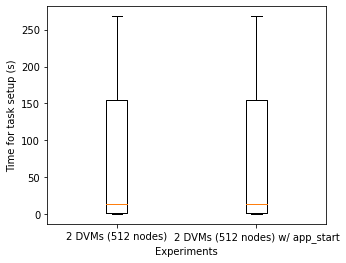

In [19]:
d_2dvm = [205.30056500434875, 181.68398308753967, 0.7767748832702637, 0.40620899200439453, 48.70358920097351, 0.5784690380096436, 28.198379039764404, 110.5920250415802, 0.34595203399658203, 11.045630931854248, 0.277026891708374, 35.588906049728394, 211.94128489494324, 0.2616879940032959, 172.89563083648682, 0.7603788375854492, 0.3885960578918457, 33.74757504463196, 134.40474200248718, 4.549661874771118, 1.4244420528411865, 222.0683228969574, 17.4029278755188, 46.352519035339355, 195.3706178665161, 158.9440438747406, 25.56690812110901, 225.6691529750824, 1.1409778594970703, 217.43750309944153, 0.9306838512420654, 1.6298091411590576, 210.15831804275513, 0.6179358959197998, 1.3217809200286865, 14.343080043792725, 39.00728988647461, 48.03213596343994, 33.121296882629395, 229.8464138507843, 233.37719798088074, 145.17890691757202, 146.97320985794067, 21.52738308906555, 1.1624948978424072, 0.5292448997497559, 20.175106048583984, 32.406728982925415, 1.294517993927002, 181.9223129749298, 0.6061468124389648, 92.09330105781555, 215.40342593193054, 25.65288805961609, 1.0648820400238037, 228.08230900764465, 0.6222131252288818, 40.28612208366394, 140.43247604370117, 20.101709127426147, 4.067467927932739, 1.7033791542053223, 1.011883020401001, 54.00602698326111, 31.28653883934021, 0.2600529193878174, 0.6485848426818848, 158.6500861644745, 1.702462911605835, 1.5976741313934326, 158.46986198425293, 138.07644295692444, 0.3361060619354248, 19.113730907440186, 14.751508951187134, 234.66944313049316, 0.7235109806060791, 183.240159034729, 114.50969505310059, 28.168570041656494, 212.4897689819336, 154.3948211669922, 49.634427070617676, 1.6613140106201172, 0.7019929885864258, 21.51190710067749, 0.6200449466705322, 163.57654881477356, 0.6991798877716064, 25.234063148498535, 0.2078700065612793, 0.3077051639556885, 0.5624420642852783, 207.0722460746765, 47.10819101333618, 28.921061038970947, 28.7553391456604, 0.29659390449523926, 2.056004047393799, 159.4172079563141, 0.6589560508728027, 0.5450279712677002, 0.38181400299072266, 46.40231108665466, 22.648205041885376, 0.2109830379486084, 35.0791449546814, 216.3240840435028, 1.8917009830474854, 1.2216691970825195, 0.5584590435028076, 20.89255380630493, 0.9312028884887695, 212.93811297416687, 124.86940217018127, 0.22807097434997559, 52.87155890464783, 0.39454102516174316, 0.9999659061431885, 36.984026193618774, 247.17359519004822, 1.5016000270843506, 39.26265501976013, 19.223584175109863, 194.82362294197083, 0.505958080291748, 204.67861008644104, 0.8600208759307861, 46.07187604904175, 1.497316837310791, 28.572394132614136, 29.954720973968506, 180.57069897651672, 0.36319899559020996, 45.78138709068298, 42.457820892333984, 228.06271505355835, 205.43419408798218, 0.7917721271514893, 0.6909627914428711, 0.32278895378112793, 169.40630197525024, 0.9497041702270508, 212.32633900642395, 0.6038811206817627, 0.9695680141448975, 1.483273983001709, 0.368818998336792, 0.32056117057800293, 212.56385707855225, 44.164287090301514, 41.571850061416626, 208.50883293151855, 20.987717866897583, 1.3815200328826904, 0.8474009037017822, 219.29299592971802, 222.0987479686737, 241.91591906547546, 153.3438639640808, 27.425199031829834, 1.199388027191162, 0.8802821636199951, 0.25652098655700684, 0.5159709453582764, 227.33302998542786, 1.4822180271148682, 216.22305917739868, 212.72776198387146, 1.1071488857269287, 225.1390597820282, 32.19347310066223, 0.5855028629302979, 216.83434200286865, 48.352062940597534, 16.562078952789307, 32.96703481674194, 198.07423615455627, 1.0549099445343018, 31.72382616996765, 1.1489582061767578, 244.39016199111938, 1.0951058864593506, 1.2446248531341553, 23.15691900253296, 0.6849939823150635, 154.53419089317322, 1.5204429626464844, 184.5181849002838, 1.1743559837341309, 44.623034954071045, 39.93460297584534, 173.15525698661804, 1.2393968105316162, 0.30684590339660645, 0.6180441379547119, 203.7086329460144, 31.82696008682251, 0.7884600162506104, 0.47650885581970215, 0.6285510063171387, 0.5468120574951172, 61.17049813270569, 0.3331022262573242, 1.6787378787994385, 47.7344069480896, 0.6851420402526855, 1.4800779819488525, 32.42083191871643, 2.62174391746521, 213.06979179382324, 0.8856089115142822, 0.818047046661377, 197.2522370815277, 1.27292799949646, 0.6409239768981934, 34.536274909973145, 205.76991486549377, 1.7314400672912598, 0.9814648628234863, 11.728336095809937, 48.11292600631714, 251.39028906822205, 85.21711897850037, 1.0338740348815918, 0.5645358562469482, 0.6413102149963379, 217.11079120635986, 38.08204889297485, 0.23560404777526855, 0.8479170799255371, 189.64077806472778, 30.545230865478516, 0.8169379234313965, 0.673497200012207, 216.51351189613342, 51.98341202735901, 225.63490986824036, 0.7682440280914307, 27.756556034088135, 251.66157484054565, 1.2019670009613037, 24.262861013412476, 165.77847909927368, 214.8140151500702, 132.67499494552612, 217.41229391098022, 0.8809859752655029, 30.560393810272217, 249.9830129146576, 1.120103120803833, 0.9602949619293213, 145.00181889533997, 0.8071188926696777, 0.43984508514404297, 254.00274109840393, 1.4278481006622314, 33.93199682235718, 0.6848318576812744, 0.3180418014526367, 0.21065211296081543, 24.559161901474, 42.10322308540344, 0.7613191604614258, 18.998979091644287, 220.10452604293823, 0.21684479713439941, 1.2719850540161133, 23.913714170455933, 163.2759919166565, 104.8493881225586, 167.48144602775574, 47.72741198539734, 197.64385199546814, 1.613008975982666, 0.7955710887908936, 1.779606819152832, 1.3564140796661377, 0.5858218669891357, 1.2514209747314453, 0.7664718627929688, 233.88006496429443, 46.232625007629395, 13.498908042907715, 126.15522694587708, 34.686219930648804, 0.8270599842071533, 221.20956897735596, 0.36829090118408203, 204.99351000785828, 1.2029931545257568, 1.6749508380889893, 190.92543196678162, 1.3040850162506104, 238.21170783042908, 10.887948989868164, 222.2367799282074, 189.92921781539917, 221.2394461631775, 26.83475112915039, 49.01386094093323, 0.404263973236084, 1.7643458843231201, 1.8670969009399414, 49.153915882110596, 113.53170490264893, 186.85103917121887, 59.666850090026855, 0.42405200004577637, 31.95422601699829, 1.0702779293060303, 21.236523866653442, 1.0784368515014648, 11.883897066116333, 213.00372791290283, 7.202485084533691, 217.38662695884705, 1.139512062072754, 22.49176001548767, 192.35276889801025, 247.98142385482788, 210.1697120666504, 25.550453901290894, 1.0977821350097656, 187.8299400806427, 14.544295072555542, 44.173303842544556, 216.4308521747589, 1.2489428520202637, 1.257652997970581, 217.24847602844238, 228.85674405097961, 0.6875121593475342, 4.244057893753052, 156.85445594787598, 1.1095399856567383, 28.711153984069824, 235.3569118976593, 244.8588330745697, 44.9661750793457, 224.19384217262268, 24.93909788131714, 0.7668991088867188, 240.84701800346375, 0.8766269683837891, 1.0601389408111572, 0.3134469985961914, 0.5345661640167236, 0.24548792839050293, 211.79110193252563, 256.5870749950409, 1.86997389793396, 10.037063837051392, 143.09778881072998, 1.155423879623413, 0.37742018699645996, 0.7469511032104492, 19.42475700378418, 44.82157301902771, 1.2092459201812744, 178.5506238937378, 195.89950799942017, 47.00087809562683, 34.34086799621582, 182.57232904434204, 133.39358401298523, 1.8178069591522217, 1.6152520179748535, 198.8702130317688, 127.6449921131134, 18.193653106689453, 188.8561110496521, 0.8491060733795166, 20.67878293991089, 133.1257061958313, 30.76463294029236, 31.52767014503479, 0.8406989574432373, 47.36418700218201, 7.0439629554748535, 238.4885058403015, 218.986652135849, 223.59424495697021, 121.59288477897644, 0.761660099029541, 0.8103699684143066, 42.41081714630127, 1.2367730140686035, 33.30893516540527, 0.21010208129882812, 9.120280027389526, 202.93923902511597, 247.4582920074463, 184.6472761631012, 0.6007800102233887, 0.21255016326904297, 1.3212730884552002, 0.27855587005615234, 24.066020965576172, 13.437201023101807, 0.4112839698791504, 0.6393001079559326, 22.510735034942627, 0.47998499870300293, 221.55310797691345, 194.520437002182, 0.4137239456176758, 78.75668907165527, 0.8724870681762695, 224.49431610107422, 31.854255199432373, 0.7945809364318848, 0.65767502784729, 1.7073099613189697, 0.3981800079345703, 176.75026488304138, 213.66857290267944, 20.36058211326599, 0.5167310237884521, 232.33314394950867, 3.8759520053863525, 1.1124730110168457, 19.572366952896118, 242.24024510383606, 94.81854701042175, 0.26189398765563965, 155.22416806221008, 152.7233018875122, 234.26220798492432, 39.5463809967041, 142.0923719406128, 216.425705909729, 15.442255973815918, 1.2438218593597412, 0.28179311752319336, 0.3221471309661865, 28.58248996734619, 208.0047631263733, 0.979773998260498, 0.6360149383544922, 48.29981303215027, 0.847161054611206, 220.0847511291504, 0.5453529357910156, 248.5374619960785, 0.9192078113555908, 0.8271939754486084, 0.5498287677764893, 24.835473775863647, 0.8211579322814941, 48.466196060180664, 162.77413296699524, 0.5109260082244873, 210.34932398796082, 1.6768271923065186, 0.8307149410247803, 25.881981134414673, 0.546705961227417, 0.9897918701171875, 0.43891406059265137, 0.7551970481872559, 192.55212092399597, 0.2963099479675293, 0.6862969398498535, 203.62236499786377, 5.854369163513184, 0.7044939994812012, 1.8030471801757812, 186.6986939907074, 32.67682409286499, 136.75548911094666, 166.66123700141907, 0.8762509822845459, 220.47107601165771, 229.5447700023651, 198.3734838962555, 0.2237379550933838, 23.347718954086304, 1.065242052078247, 220.43359994888306, 237.73010301589966, 0.2859969139099121, 46.14922904968262, 1.0090088844299316, 1.0677800178527832, 1.2732939720153809, 199.94416904449463, 209.07804918289185, 32.60900807380676, 1.0691571235656738, 1.6731529235839844, 50.35141587257385, 4.108404159545898, 150.28281998634338, 72.64164614677429, 0.3165121078491211, 1.1203150749206543, 20.372726917266846, 0.4069221019744873, 211.9585690498352, 49.2359139919281, 1.0406808853149414, 5.201946020126343, 180.72793102264404, 0.9780068397521973, 0.9629220962524414, 21.716689109802246, 0.764409065246582, 11.878801822662354, 1.346107006072998, 0.33185601234436035, 0.8001120090484619, 0.7207498550415039, 22.827934980392456, 0.6347370147705078, 72.27922296524048, 0.23417901992797852, 9.041011095046997, 244.5316128730774, 0.7488880157470703, 203.6006419658661, 218.65330481529236, 24.701820850372314, 1.1855299472808838, 0.3967149257659912, 204.66961407661438, 0.8254690170288086, 30.032849073410034, 0.874871015548706, 30.214715003967285, 205.35310196876526, 1.5332670211791992, 50.73049306869507, 0.54728102684021, 31.73753309249878, 186.53379893302917, 1.3793058395385742, 13.538233995437622, 0.3818478584289551, 1.171576976776123, 32.39335107803345, 176.99476194381714, 1.29721999168396, 0.38267016410827637, 135.3996901512146, 4.085498094558716, 0.8044009208679199, 23.92433214187622, 188.05019807815552, 0.34633588790893555, 211.4610619544983, 1.0559449195861816, 57.98074388504028, 46.626935958862305, 217.8022530078888, 239.22903084754944, 0.24911189079284668, 229.08910202980042, 0.22717809677124023, 0.8080220222473145, 1.2228968143463135, 23.020445823669434, 212.33080196380615, 27.799246072769165, 46.09742093086243, 162.8522880077362, 185.01206493377686, 0.35091304779052734, 0.435122013092041, 227.54540300369263, 20.204763889312744, 134.136962890625, 1.9333341121673584, 0.2990541458129883, 89.99949383735657, 39.48424291610718, 0.8177638053894043, 169.91327381134033, 1.5635859966278076, 134.45415091514587, 192.85138201713562, 240.4336109161377, 18.400503873825073, 47.594884157180786, 1.0204479694366455, 224.41952180862427, 0.7094659805297852, 206.51669192314148, 1.2347090244293213, 0.19920611381530762, 0.3669869899749756, 0.8284249305725098, 1.1028978824615479, 18.86885905265808, 42.338001012802124, 149.66017699241638, 214.0447280406952, 34.49536991119385, 237.12245512008667, 15.160218000411987, 1.2591400146484375, 1.120162010192871, 28.882512092590332, 190.97942209243774, 0.7629990577697754, 138.19325995445251, 0.971527099609375, 246.8383390903473, 218.53726291656494, 34.31461715698242, 147.44619297981262, 0.2868950366973877, 0.21592402458190918, 1.074498176574707, 1.141956090927124, 32.85006499290466, 225.40272402763367, 47.66507911682129, 0.9827818870544434, 0.5398399829864502, 41.16669297218323, 0.6062779426574707, 0.9893789291381836, 0.2597501277923584, 218.3592369556427, 0.2464618682861328, 42.266499042510986, 1.0613031387329102, 0.8500709533691406, 1.6364140510559082, 19.249996185302734, 29.12356996536255, 0.281857967376709, 192.57713413238525, 0.3982880115509033, 215.6531000137329, 0.6240420341491699, 197.35400199890137, 0.9925220012664795, 208.0022909641266, 244.6053431034088, 1.1797261238098145, 204.17993211746216, 0.4057140350341797, 23.09276509284973, 164.02477383613586, 1.2985880374908447, 0.7037520408630371, 195.11319398880005, 38.45223689079285, 36.01706290245056, 5.174422979354858, 205.13906717300415, 1.0654640197753906, 68.10295081138611, 225.27563619613647, 1.5440969467163086, 12.238546133041382, 2.119359016418457, 191.2704050540924, 210.70081996917725, 47.75303602218628, 0.5621349811553955, 0.25424695014953613, 218.5236918926239, 200.9965410232544, 27.96186399459839, 0.7738959789276123, 218.7606840133667, 243.7841420173645, 137.85870504379272, 188.7792730331421, 30.69120979309082, 146.85452604293823, 31.791054010391235, 0.534264087677002, 48.27912187576294, 158.9791738986969, 3.915842056274414, 0.7909181118011475, 18.91290807723999, 0.4301140308380127, 0.3646109104156494, 1.075918197631836, 0.8039841651916504, 32.32602310180664, 1.2764201164245605, 153.01537895202637, 0.6988511085510254, 226.15919494628906, 27.31496787071228, 43.671942949295044, 92.91066598892212, 34.834670066833496, 1.9888198375701904, 0.8987810611724854, 239.79134011268616, 1.6885948181152344, 176.9810438156128, 82.21723008155823, 1.324995994567871, 47.518815994262695, 209.4971640110016, 0.9109210968017578, 0.25261998176574707, 0.2244889736175537, 29.750197887420654, 207.0104010105133, 42.42351508140564, 135.6900179386139, 223.14539504051208, 29.609445810317993, 220.69035577774048, 19.772615909576416, 122.18537616729736, 232.56836104393005, 13.479265928268433, 224.54493308067322, 1.0232150554656982, 0.4165630340576172, 229.9246530532837, 233.62479710578918, 38.12052798271179, 0.6927540302276611, 32.9686119556427, 0.6167030334472656, 0.31924986839294434, 37.06573486328125, 13.290148973464966, 45.937350034713745, 233.9817771911621, 229.39036798477173, 0.232666015625, 1.2897939682006836, 193.65654301643372, 0.6706831455230713, 28.42374300956726, 42.36082100868225, 47.577094078063965, 0.6584360599517822, 212.8994951248169, 206.17403483390808, 0.8236031532287598, 0.8085739612579346, 28.259282112121582, 0.4616870880126953, 157.55608797073364, 39.107155084609985, 0.27592897415161133, 22.35499906539917, 233.0527069568634, 162.04587292671204, 233.8528380393982, 24.305490970611572, 1.0761311054229736, 218.19237804412842, 0.3087460994720459, 18.777761220932007, 45.81658482551575, 0.4626920223236084, 208.50868797302246, 10.260966062545776, 0.9933459758758545, 43.430931091308594, 237.62223505973816, 31.520542860031128, 1.7606279850006104, 214.8029670715332, 2.070241928100586, 22.128164052963257, 1.0097770690917969, 0.5878481864929199, 165.59049487113953, 0.5679261684417725, 197.25803518295288, 231.65147995948792, 16.50519323348999, 0.6178371906280518, 207.60414004325867, 37.786261796951294, 230.00524711608887, 158.06580209732056, 0.31063008308410645, 16.32175612449646, 42.366101026535034, 0.804102897644043, 225.36294507980347, 0.4580879211425781, 1.9851658344268799, 194.10522603988647, 29.936930894851685, 39.43230986595154, 32.76971697807312, 220.80736303329468, 0.5198531150817871, 136.21913504600525, 0.5078542232513428, 1.0599441528320312, 17.91493511199951, 11.034106016159058, 167.04978799819946, 26.988034963607788, 1.2985999584197998, 2.0615298748016357, 230.46555495262146, 45.51932406425476, 45.779980182647705, 1.3748230934143066, 1.8991749286651611, 231.77520108222961, 27.295459032058716, 0.9328711032867432, 0.25977206230163574, 193.6723759174347, 238.00809597969055, 26.52972412109375, 0.7800700664520264, 245.47613501548767, 221.2429919242859, 0.8854608535766602, 172.61253595352173, 1.1212358474731445, 32.347476959228516, 0.34851694107055664, 0.9891350269317627, 228.98950290679932, 0.9554269313812256, 246.16047596931458, 24.392589807510376, 227.32754492759705, 40.56179690361023, 167.62164402008057, 17.99193286895752, 222.3371798992157, 217.80019903182983, 1.259281873703003, 0.5766592025756836, 159.59769105911255, 30.014506101608276, 215.83153891563416, 0.2518458366394043, 22.642024040222168, 222.50730109214783, 223.62130904197693, 0.6287100315093994, 0.8382561206817627, 0.6535229682922363, 172.29579901695251, 0.2069721221923828, 25.13017201423645, 142.55743312835693, 239.9758870601654, 0.6087319850921631, 1.7324800491333008, 17.322508096694946, 220.43039321899414, 0.6039419174194336, 112.66440606117249, 1.537358045578003, 151.39694809913635, 46.02890992164612, 40.99054193496704, 198.71937704086304, 145.05121088027954, 226.85489988327026, 0.3723180294036865, 29.049586057662964, 1.5751149654388428, 1.0220179557800293, 236.4114649295807, 1.2187180519104004, 1.2903311252593994, 168.6472978591919, 136.64570212364197, 24.002989768981934, 1.2776379585266113, 0.34381699562072754, 1.7127959728240967, 29.270316123962402, 251.62782788276672, 28.0367751121521, 229.13422894477844, 215.70043182373047, 186.4512860774994, 1.0386290550231934, 216.42334008216858, 234.1593120098114, 0.22734785079956055, 180.76842999458313, 200.9874770641327, 49.052623987197876, 30.989935874938965, 253.3749589920044, 0.20914411544799805, 2.5425021648406982, 21.693103075027466, 0.6731998920440674, 194.65507698059082, 158.2800488471985, 0.7795078754425049, 98.85931491851807, 19.829244136810303, 1.2238969802856445, 35.68368601799011, 0.7169020175933838, 243.3143539428711, 243.05695009231567, 48.731075048446655, 4.6908628940582275, 0.46341919898986816, 93.59442591667175, 222.54396104812622, 228.91903495788574, 21.761105060577393, 151.5739369392395, 0.38853001594543457, 19.51318383216858, 1.7125048637390137, 246.50561809539795, 1.5622241497039795, 0.426591157913208, 40.77428889274597, 164.28476285934448, 15.524872064590454, 233.7557020187378, 179.07398200035095, 187.1092610359192, 234.94677591323853, 0.7110629081726074, 1.3066918849945068, 1.127120018005371, 1.656554937362671, 0.6192560195922852, 82.95437693595886, 0.7473199367523193, 218.80147409439087, 182.55258989334106, 0.3570399284362793, 32.45070004463196, 0.53603196144104, 0.5503430366516113, 0.9378499984741211, 248.4080891609192, 0.4736158847808838, 227.7057490348816, 0.6490590572357178, 25.011649131774902, 184.8598940372467, 52.05894184112549, 0.2440659999847412, 240.51297783851624, 1.0053799152374268, 0.8013620376586914, 48.343616008758545, 0.26053500175476074, 0.34923887252807617, 1.5804028511047363, 0.7336440086364746, 0.8371109962463379, 27.83389902114868, 229.19255995750427, 172.28744792938232, 81.43561816215515, 1.0301110744476318, 202.05423498153687, 1.8412799835205078, 1.6399099826812744, 244.62421703338623, 49.84445095062256, 0.5510780811309814, 33.82739186286926, 223.41946601867676, 177.38490104675293, 18.44120717048645, 199.56694293022156, 1.3880999088287354, 0.4335939884185791, 96.07900905609131, 209.14059805870056, 37.18202805519104, 0.7001159191131592, 1.0339040756225586, 178.08461809158325, 0.5742380619049072, 1.9892399311065674, 251.51019501686096, 18.522027015686035, 0.9583168029785156, 218.98318099975586, 239.03563594818115, 221.17374515533447, 209.86025595664978, 188.0422239303589, 19.277450799942017, 163.84634494781494, 0.40885186195373535, 38.426117181777954, 1.6930649280548096, 1.4895379543304443, 231.5416271686554, 147.82688307762146, 209.40378999710083, 0.9107141494750977, 223.0020830631256, 1.0574610233306885, 223.15978598594666, 214.74714708328247, 196.26420402526855, 108.16189789772034, 0.7207870483398438, 149.37064909934998, 36.68854308128357, 0.198563814163208, 158.08185601234436, 0.6822211742401123, 10.902777910232544, 41.44354510307312, 0.9494280815124512, 224.5742690563202, 1.2898399829864502, 221.33409214019775, 204.5981409549713, 194.110445022583, 20.51406192779541, 239.8691520690918, 232.17725896835327, 229.01126194000244, 0.554955005645752, 22.812754154205322, 1.0302321910858154, 0.8460249900817871, 0.8360888957977295, 221.36723113059998, 22.31735110282898, 0.7474398612976074, 227.74775004386902, 1.2929630279541016, 1.424306869506836, 1.3040380477905273, 0.9581460952758789, 0.9449789524078369, 0.47637009620666504, 17.4339120388031, 14.219218969345093, 44.61754298210144, 0.8245790004730225, 208.0435209274292, 1.1195790767669678, 0.23720097541809082, 0.44274306297302246, 26.984210968017578, 1.3849070072174072, 0.37450504302978516, 213.17504596710205, 145.49187302589417, 0.9125549793243408, 1.1771080493927002, 0.6023769378662109, 0.8988280296325684, 25.03581190109253, 1.6819300651550293, 222.47870898246765, 47.93949484825134, 225.6535129547119, 172.18827295303345, 86.60219407081604, 146.63921999931335, 0.5056700706481934, 112.42638111114502, 160.00347089767456, 205.92080998420715, 23.936803102493286, 30.648353815078735, 208.11730289459229, 4.0017170906066895, 205.94628310203552, 9.95741605758667, 13.128051042556763, 1.217468023300171, 0.24298596382141113, 0.3046138286590576, 18.78543186187744, 0.7590579986572266, 0.696256160736084, 169.00853395462036, 0.9072351455688477, 51.02360796928406, 2.6736838817596436, 231.24725604057312, 0.40561604499816895, 148.43874597549438, 173.50239086151123, 186.8410348892212, 45.20459699630737, 2.0061731338500977, 0.9218900203704834, 0.8981349468231201, 0.7621219158172607, 123.7425811290741, 2.4629969596862793, 119.06605315208435, 251.01955008506775, 0.6796982288360596, 217.58869099617004, 0.28333187103271484, 0.9218909740447998, 36.97374892234802, 118.64738583564758, 127.72031092643738, 1.6635990142822266, 0.3895411491394043, 134.88375902175903, 183.78497695922852, 0.24613499641418457, 198.67540001869202, 29.275068998336792, 229.69692301750183, 1.94120192527771, 231.9727909564972, 0.3102130889892578, 183.31365394592285, 0.5366220474243164, 4.420447111129761, 0.955435037612915, 25.744079113006592, 46.9347140789032, 42.00404715538025, 0.23466706275939941, 0.7598600387573242, 163.23985695838928, 240.2720010280609, 200.4735870361328, 234.8222279548645, 217.70330786705017, 1.1390979290008545, 202.92322397232056, 45.82661199569702, 28.37458300590515, 24.169246196746826, 1.2613158226013184, 38.13718795776367, 205.24355292320251, 221.9089560508728, 0.22318816184997559, 100.8191750049591, 17.48407506942749, 1.0310089588165283, 33.857125997543335, 1.0209031105041504, 228.29487013816833, 39.98948907852173, 241.07202005386353, 126.67120504379272, 0.32877397537231445, 0.4606630802154541, 16.448538064956665, 0.8618099689483643, 33.57192397117615, 0.21379399299621582, 1.4463160037994385, 247.93507289886475, 247.44890809059143, 26.702903032302856, 225.156476020813, 113.72381401062012, 0.834118127822876, 211.00509119033813, 0.7465550899505615, 17.562941789627075, 210.96749019622803, 0.4297749996185303, 222.98273086547852, 0.7724168300628662, 190.6133508682251, 4.279138088226318, 0.9973959922790527, 1.0951600074768066, 0.3214540481567383, 0.7663822174072266, 0.25875115394592285, 233.84277296066284, 236.9363570213318, 45.70704102516174, 120.80532503128052, 242.73490500450134, 227.54567289352417, 237.47220396995544, 15.95919394493103, 208.67494988441467, 28.338658094406128, 1.6500701904296875, 0.4608461856842041, 0.9460549354553223, 0.8440361022949219, 1.4516499042510986, 28.958872079849243, 1.213897943496704, 229.34230208396912, 194.33716106414795, 0.24116802215576172, 207.1231300830841, 27.58406114578247, 0.9213340282440186, 0.35493993759155273, 0.4271109104156494, 14.314945936203003, 0.9933271408081055, 46.45620107650757, 0.7935869693756104, 1.0122020244598389, 116.53229713439941, 162.80521488189697, 207.17147397994995, 0.525305986404419, 0.9728929996490479, 43.62072706222534, 36.2876250743866, 0.9782779216766357, 212.99731516838074, 178.93991613388062, 193.83832693099976, 0.9946398735046387, 0.38792920112609863, 24.932595014572144, 0.5616848468780518, 0.4148440361022949, 190.75047087669373, 0.8945589065551758, 41.2465660572052, 0.22432518005371094, 196.22835206985474, 246.14074897766113, 0.21747088432312012, 0.37570691108703613, 110.1163318157196, 246.13283395767212, 22.790218830108643, 0.7348849773406982, 236.17657995224, 212.97149682044983, 121.89146208763123, 220.5032639503479, 36.42066693305969, 0.48987793922424316, 8.785293102264404, 47.31187391281128, 233.334379196167, 222.27390789985657, 0.34276509284973145, 145.8384349346161, 212.8911361694336, 148.6759078502655, 35.834853172302246, 219.48359417915344, 209.266499042511, 0.23303723335266113, 0.6935639381408691, 231.6181399822235, 35.20282220840454, 0.6140758991241455, 1.1169390678405762, 207.43083381652832, 1.1945898532867432, 0.6900050640106201, 16.42950987815857, 206.170175075531, 44.97584581375122, 45.93127179145813, 0.296252965927124, 12.993320941925049, 230.59534811973572, 17.469205856323242, 138.94414806365967, 0.24371910095214844, 1.100221872329712, 0.2792539596557617, 220.09117794036865, 0.6338801383972168, 1.0624301433563232, 0.9077401161193848, 45.87403106689453, 1.0920031070709229, 0.39298415184020996, 1.1984009742736816, 33.77709078788757, 224.44652104377747, 1.0287489891052246, 191.4933090209961, 102.68447303771973, 47.21853494644165, 200.5914340019226, 210.78488993644714, 98.89583802223206, 171.80009412765503, 1.11928391456604, 219.31643319129944, 149.90900802612305, 9.358284950256348, 211.0225191116333, 0.6142129898071289, 1.3036391735076904, 214.75473999977112, 29.217777967453003, 24.60727596282959, 2.175004005432129, 1.180755853652954, 57.80752086639404, 173.07093596458435, 223.4770209789276, 0.44271183013916016, 0.2693469524383545, 11.61105489730835, 25.16962695121765, 239.3081409931183, 21.98801612854004, 37.572189807891846, 20.957419872283936, 228.64517498016357, 235.182923078537, 1.0591669082641602, 5.977821111679077, 95.12157988548279, 38.927358865737915, 1.679029941558838, 44.843897104263306, 28.875239849090576, 1.1541731357574463, 1.1325139999389648, 149.75224995613098, 0.6452009677886963, 0.7945060729980469, 182.2322380542755, 0.8154678344726562, 243.04881501197815, 0.9110081195831299, 22.276144981384277, 147.07156682014465, 214.95377683639526, 23.601634979248047, 239.1712749004364, 41.29478716850281, 41.8050971031189, 1.1282260417938232, 222.41637587547302, 226.77714586257935, 1.6091489791870117, 220.4643359184265, 211.92045092582703, 43.86263298988342, 0.6140048503875732, 219.78464198112488, 135.74103617668152, 29.231503009796143, 211.92281794548035, 242.32901310920715, 1.912686824798584, 190.4882378578186, 0.46390318870544434, 39.8741021156311, 140.95651197433472, 1.3066320419311523, 43.80477285385132, 234.4650330543518, 146.9907991886139, 0.81439208984375, 1.2295382022857666, 1.07704496383667, 0.3204169273376465, 224.78413796424866, 0.2607920169830322, 29.06102991104126, 1.0878400802612305, 0.94162917137146, 0.9128971099853516, 51.51674199104309, 0.9569730758666992, 21.540178060531616, 231.06501507759094, 228.21527695655823, 1.636728048324585, 29.431748151779175, 0.854550838470459, 67.25735402107239, 166.29876017570496, 242.62310004234314, 0.23963284492492676, 0.22983884811401367, 231.1705060005188, 45.07664203643799, 1.3819270133972168, 1.3270840644836426, 214.13291907310486, 22.511401176452637, 221.85259199142456, 0.8435359001159668, 229.55330204963684, 19.471518993377686, 228.53266310691833, 187.80160903930664, 204.4799439907074, 245.1860270500183, 202.43266201019287, 0.6510369777679443, 24.101843118667603, 172.57090091705322, 0.558286190032959, 5.144805908203125, 1.2896640300750732, 0.2245039939880371, 4.172817230224609, 1.4624369144439697, 1.161466121673584, 0.9389159679412842, 24.360456943511963, 0.26794910430908203, 220.94653010368347, 47.207481145858765, 16.172914028167725, 1.2596099376678467, 0.9145381450653076, 235.60710096359253, 234.16705703735352, 0.8626110553741455, 21.020766019821167, 0.7506000995635986, 171.6516978740692, 1.770124912261963, 0.28995585441589355, 226.86581206321716, 1.318587064743042, 206.62797689437866, 0.6389608383178711, 0.9994528293609619, 1.4649498462677002, 176.54986596107483, 0.40328001976013184, 31.351923942565918, 1.0709450244903564, 246.07762217521667, 189.32452011108398, 198.21076703071594, 1.786308765411377, 205.85971689224243, 46.101418018341064, 4.521683931350708, 1.6436188220977783, 28.346587896347046, 2.1240158081054688, 0.41660213470458984, 0.2894630432128906, 10.795809984207153, 129.89639115333557, 29.961977005004883, 0.480910062789917, 230.8027379512787, 0.5022411346435547, 0.7647929191589355, 170.57042002677917, 31.643234968185425, 1.59181809425354, 0.4641838073730469, 0.444364070892334, 1.1733200550079346, 136.13761711120605, 0.3094179630279541, 1.107964038848877, 1.1894328594207764, 0.3660259246826172, 0.6827991008758545, 105.47235488891602, 0.23709607124328613, 186.5783760547638, 43.09121084213257, 227.1048140525818, 220.22312903404236, 212.94421410560608, 26.28358793258667, 221.6050670146942, 58.60274386405945, 16.23213005065918, 0.8161230087280273, 0.4247090816497803, 192.03615498542786, 158.56212282180786, 0.4229559898376465, 51.66124510765076, 214.25211000442505, 1.2950339317321777, 48.453800201416016, 0.5074348449707031, 1.3439860343933105, 10.55686902999878, 204.95220184326172, 28.12502694129944, 3.962574005126953, 0.924919843673706, 230.73650693893433, 190.19018697738647, 44.147440910339355, 234.9860701560974, 0.26318883895874023, 36.718101978302, 0.21933913230895996, 0.5760619640350342, 235.917377948761, 1.0956599712371826, 0.9847910404205322, 14.906132936477661, 0.6673400402069092, 226.8722438812256, 86.17945718765259, 0.3334310054779053, 0.658531904220581, 200.05434894561768, 201.12515687942505, 10.19567608833313, 229.10967087745667, 0.6601579189300537, 25.264094829559326, 1.0001721382141113, 213.6614739894867, 0.2608480453491211, 1.0915939807891846, 0.2489759922027588, 1.0525178909301758, 0.24361300468444824, 229.6368100643158, 0.4207310676574707, 37.56158185005188, 1.4864959716796875, 244.76237511634827, 207.8275110721588, 0.9023749828338623, 190.6518840789795, 29.482335805892944, 0.6111099720001221, 0.23937702178955078, 168.92672896385193, 17.36012101173401, 200.55593490600586, 226.7032220363617, 192.20274186134338, 1.0449740886688232, 0.3986630439758301, 1.4339320659637451, 1.035879135131836, 173.87065291404724, 187.90716290473938, 0.3987419605255127, 0.8227689266204834, 45.922016859054565, 0.6220810413360596, 36.60308313369751, 175.62527704238892, 1.4875359535217285, 40.866755962371826, 1.6592330932617188, 226.01393508911133, 0.5808758735656738, 20.05561900138855, 144.97834181785583, 228.16243505477905, 1.4013910293579102, 0.34384989738464355, 181.27629899978638, 241.5728840827942, 198.17359614372253, 0.27573394775390625, 229.7959361076355, 30.39399480819702, 131.75505805015564, 223.4759612083435, 0.7224760055541992, 43.22928714752197, 4.870805025100708, 238.17848801612854, 30.879655122756958, 0.9909038543701172, 215.803288936615, 1.7591710090637207, 0.788201093673706, 29.46948003768921, 176.8430619239807, 1.9933159351348877, 212.15554690361023, 197.56734108924866, 0.5328421592712402, 1.7290010452270508, 16.131881952285767, 0.9969141483306885, 0.6366868019104004, 0.6321089267730713, 0.8129620552062988, 235.3692491054535, 0.2257070541381836, 19.849875926971436, 229.86720085144043, 1.239380121231079, 201.22692894935608, 0.7819490432739258, 26.575857162475586, 0.8774809837341309, 201.13695812225342, 171.57017302513123, 225.61116290092468, 9.822788953781128, 193.7395408153534, 234.47404718399048, 0.7922711372375488, 0.3861570358276367, 230.98153495788574, 1.2446539402008057, 19.454574823379517, 0.2504160404205322, 1.2172489166259766, 0.47513580322265625, 47.11240315437317, 1.3137149810791016, 0.21200108528137207, 29.059858083724976, 0.9648621082305908, 16.714072942733765, 0.2401731014251709, 1.1486701965332031, 19.871641159057617, 0.6659469604492188, 230.30427503585815, 0.42931294441223145, 40.728596925735474, 51.11730909347534, 49.40677618980408, 1.4245309829711914, 1.558013916015625, 1.536850929260254, 209.6908848285675, 30.461218118667603, 179.40851998329163, 201.24613785743713, 243.9991090297699, 35.13633608818054, 0.6917581558227539, 1.7782270908355713, 211.95886301994324, 186.1479709148407, 0.5109899044036865, 1.3179259300231934, 202.62256693840027, 229.89575695991516, 1.2693910598754883, 3.9357662200927734, 226.27214312553406, 1.9242899417877197, 46.97347402572632, 1.2979860305786133, 0.31844305992126465, 0.7050039768218994, 1.6216418743133545, 232.82142186164856, 0.2854750156402588, 207.81766605377197, 160.0446970462799, 1.334562063217163, 0.8438589572906494, 148.2526659965515, 1.3995130062103271, 1.8518741130828857, 1.7583410739898682, 47.1426260471344, 210.3021399974823, 231.03245496749878, 1.1845910549163818, 28.21533489227295, 2.661007881164551, 222.85108494758606, 0.8063299655914307, 157.52002501487732, 40.021864891052246, 214.2458791732788, 219.5216360092163, 0.6939260959625244, 1.5904979705810547, 249.02590990066528, 80.98217678070068, 31.717798948287964, 0.25554394721984863, 32.69303297996521, 24.209413051605225, 214.28618717193604, 189.1280369758606, 1.096668004989624, 0.3771088123321533, 224.41216588020325, 0.6648240089416504, 134.1508219242096, 0.23739290237426758, 49.28948903083801, 0.6188430786132812, 202.06112909317017, 17.189927101135254, 1.0110571384429932, 42.30145192146301, 167.1836109161377, 1.0089709758758545, 145.1785728931427, 37.96432900428772, 143.8300919532776, 0.5026800632476807, 0.4180929660797119, 33.30308198928833, 32.38277196884155, 0.5831100940704346, 0.401439905166626, 0.2238321304321289, 0.7512660026550293, 2.0659821033477783, 23.97861385345459, 161.44398593902588, 152.71622896194458, 19.870225191116333, 226.19612193107605, 1.0820460319519043, 35.72837710380554, 48.468266010284424, 238.36448907852173, 207.89917993545532, 0.46587395668029785, 170.50280499458313, 1.3701140880584717, 0.4135899543762207, 216.86948704719543, 226.3446340560913, 0.37276411056518555, 26.851235151290894, 1.0957059860229492, 0.5432460308074951, 217.33029913902283, 18.42981481552124, 1.020047903060913, 0.7219610214233398, 0.8653709888458252, 1.236691951751709, 162.07828402519226, 1.3749949932098389, 4.374989032745361, 226.31378889083862, 39.48003101348877, 268.1978099346161, 202.70921397209167, 17.537127017974854, 47.388954877853394, 103.57029795646667, 4.674864053726196, 0.7440178394317627, 213.87216687202454, 238.7277021408081, 50.20178699493408, 37.671886920928955, 1.5459280014038086, 193.84301614761353, 30.70491099357605, 0.8662090301513672, 239.19869208335876, 0.9207592010498047, 232.8908200263977, 1.5349500179290771, 0.6701350212097168, 41.02155089378357, 228.6139121055603, 17.54898500442505, 0.45046496391296387, 197.95805501937866, 0.21309709548950195, 235.03075695037842, 241.87382411956787, 0.6325900554656982, 194.79673719406128, 1.039391040802002, 0.3302907943725586, 238.86527395248413, 0.7522258758544922, 151.54820704460144, 191.09233498573303, 217.50622010231018, 46.665497064590454, 1.3221111297607422, 26.26078510284424, 1.2277328968048096, 217.28570294380188, 118.41872501373291, 200.91515707969666, 0.8666651248931885, 174.57361102104187, 1.5592188835144043, 0.22056317329406738, 29.56529998779297, 26.3485369682312, 0.3501591682434082, 1.2623999118804932, 45.750585079193115, 0.5351138114929199, 181.5471510887146, 0.608720064163208, 0.3447270393371582, 1.3050050735473633, 0.6621410846710205, 0.9200949668884277, 219.0475640296936, 19.19268488883972, 30.209771871566772, 33.881290912628174, 0.23800992965698242, 0.6309599876403809, 13.17763900756836, 49.97573399543762, 136.84402799606323, 211.17241597175598, 22.002143144607544, 0.5990638732910156, 18.22146511077881, 0.8479998111724854, 1.3725080490112305, 0.647254228591919, 1.0629029273986816, 12.038049221038818, 46.788814067840576, 55.81662392616272, 1.717771053314209, 0.6698131561279297, 1.0489709377288818, 182.51185202598572, 229.75021600723267, 1.8890161514282227, 1.1272449493408203, 1.0691699981689453, 0.8438940048217773, 47.554152965545654, 222.33442187309265, 198.0829520225525, 19.05450201034546, 0.7270479202270508, 41.191126108169556, 228.56752705574036, 207.0549750328064, 1.306035041809082, 4.168231964111328, 161.12651300430298, 29.221738815307617, 226.41833591461182, 156.0153419971466, 0.9557268619537354, 219.3039960861206, 1.0569918155670166, 1.5095160007476807, 0.6856460571289062, 0.5041429996490479, 23.231159925460815, 233.9076747894287, 17.21833610534668, 205.86797618865967, 37.79749798774719, 236.43343782424927, 4.894693851470947, 0.32224202156066895, 0.703747034072876, 222.54962396621704, 253.95510292053223, 0.9523608684539795, 0.7253541946411133, 27.720413208007812, 221.29043197631836, 143.2185800075531, 1.692080020904541, 1.0187499523162842, 29.95348310470581, 1.2941908836364746, 44.92568302154541, 188.30551290512085, 26.975740909576416, 0.4504280090332031, 0.2870450019836426, 197.81763005256653, 0.8858227729797363, 32.47103500366211, 164.1746380329132, 3.801910161972046, 29.19447612762451, 0.4161550998687744, 0.4435849189758301, 177.81189012527466, 220.59119606018066, 220.5422079563141, 0.3792078495025635, 0.8835890293121338, 215.20808696746826, 1.6709339618682861, 223.71810913085938, 33.06531000137329, 0.25243687629699707, 245.89080095291138, 0.6400918960571289, 102.10404300689697, 45.265355825424194, 19.63443398475647, 0.31589603424072266, 0.981781005859375, 33.62014198303223, 222.6942801475525, 0.9533019065856934, 0.9778928756713867, 28.87953209877014, 140.83511686325073, 215.07247304916382, 83.38598608970642, 244.23894095420837, 225.37936806678772, 31.30501890182495, 20.77595019340515, 201.2951591014862, 0.7932910919189453, 105.8836989402771, 177.1188440322876, 150.33427095413208, 197.1913619041443, 29.310700178146362, 42.31068205833435, 226.598140001297, 214.4659411907196, 1.217803955078125, 1.5143420696258545, 203.19003987312317, 163.85409998893738, 24.510430097579956, 1.0998220443725586, 0.24361586570739746, 220.63508915901184, 0.29828691482543945, 0.45581579208374023, 1.8519339561462402, 1.2306008338928223, 170.72068095207214, 0.6714529991149902, 66.21114587783813, 20.23149585723877, 179.29536294937134, 1.0630130767822266, 28.931646823883057, 1.3224620819091797, 0.4775660037994385, 0.5603528022766113, 0.605212926864624, 1.2978179454803467, 26.829279899597168, 0.767333984375, 0.3658759593963623, 199.1655011177063, 189.4027910232544, 234.56917905807495, 1.0192790031433105, 24.027370929718018, 0.363893985748291, 126.60464882850647, 213.13620495796204, 0.24829816818237305, 1.1625609397888184, 0.8740341663360596, 190.65626001358032, 224.5631709098816, 58.305460929870605, 0.24308991432189941, 1.069727897644043, 213.34778094291687, 16.593251943588257, 233.13067412376404, 220.42799997329712, 222.5033299922943, 200.44394707679749, 0.48331594467163086, 1.4673519134521484, 46.128992795944214, 0.27670907974243164, 127.83460283279419, 0.4637269973754883, 0.6133720874786377, 35.09469795227051, 0.5407111644744873, 0.501690149307251, 0.7884609699249268, 225.63967490196228, 27.244899034500122, 148.79194688796997, 113.75153303146362, 240.5743010044098, 51.44024610519409, 89.03924989700317, 0.4829428195953369, 0.5173318386077881, 0.8732421398162842, 19.866791009902954, 0.2691459655761719, 0.6951639652252197, 183.9070529937744, 19.624104022979736, 0.8693628311157227, 0.43721890449523926, 225.4769470691681, 1.1201000213623047, 30.63147807121277, 233.57866191864014, 0.22971081733703613, 0.666175127029419, 0.6326768398284912, 1.0477349758148193, 215.83666110038757, 1.571199893951416, 217.3626229763031, 105.75716280937195, 0.9973230361938477, 221.70577812194824, 85.38081407546997, 28.663879871368408, 0.4343280792236328, 0.9542839527130127, 246.32283997535706, 0.9204099178314209, 109.56869888305664, 1.5262088775634766, 29.185659885406494, 10.814764976501465, 248.84298300743103, 1.1312029361724854, 0.24653005599975586, 27.882169008255005, 23.870103120803833, 0.29437804222106934, 160.34862804412842, 54.0370819568634, 155.5763099193573, 0.8156280517578125, 181.46760511398315, 2.024786949157715, 0.6131808757781982, 0.19582080841064453, 225.4825620651245, 15.185250997543335, 1.0792341232299805, 253.31140899658203, 2.5178589820861816, 202.96090602874756, 222.53308200836182, 0.3250570297241211, 227.81232714653015, 230.93834590911865, 178.4521520137787, 1.0863440036773682, 45.14093804359436, 1.350904941558838, 158.53859281539917, 162.0156490802765, 0.47025203704833984, 0.47390103340148926, 0.506951093673706, 37.24663496017456, 125.9781551361084, 36.851927042007446, 46.472805976867676, 0.2172231674194336, 1.6406409740447998, 0.6556658744812012, 19.61784815788269, 209.08857798576355, 238.61358904838562, 0.4347200393676758, 202.7486810684204, 0.6298789978027344, 1.044402837753296, 0.28157806396484375, 0.7026548385620117, 0.4195709228515625, 32.4395489692688, 151.93786311149597, 0.20997095108032227, 240.01550006866455, 208.39379906654358, 1.280923843383789, 190.51056098937988, 20.215269088745117, 200.0049810409546, 0.993096113204956, 1.6140050888061523, 1.1136488914489746, 240.712828874588, 0.39072394371032715, 187.39275312423706, 1.153378963470459, 29.12479305267334, 238.89348721504211, 182.16013598442078, 229.68501496315002, 228.52674913406372, 34.075774908065796, 39.62946891784668, 1.2398040294647217, 229.34037613868713, 1.0490789413452148, 0.858086109161377, 0.4617290496826172, 1.7186310291290283, 41.48102402687073, 230.90965604782104, 1.286661148071289, 215.48337316513062, 26.170925855636597, 0.24425697326660156, 0.9802939891815186, 204.41350889205933, 0.9445819854736328, 1.2396860122680664, 0.35894107818603516, 1.6211669445037842, 227.46882796287537, 0.811378002166748, 0.3250701427459717, 1.1230340003967285, 0.4637119770050049, 69.46406722068787, 27.65490698814392, 196.5787479877472, 245.75840711593628, 43.4123649597168, 0.262545108795166, 225.6512908935547, 231.6561839580536, 77.24967193603516, 215.94527101516724, 10.820873022079468, 200.17177391052246, 27.516042947769165, 199.0256199836731, 0.36595892906188965, 26.839572191238403, 213.16070699691772, 0.8863520622253418, 203.0453519821167, 195.062814950943, 0.8175370693206787, 213.83036589622498, 73.06866002082825, 0.24435806274414062, 248.02719497680664, 27.51068115234375, 205.08203101158142, 104.56572604179382, 177.84662294387817, 0.24562883377075195, 1.8214080333709717, 0.5262901782989502, 0.24944186210632324, 204.83215403556824, 46.63012504577637, 0.3650400638580322, 216.7494180202484, 10.265657901763916, 36.07720398902893, 193.11888909339905, 198.11662697792053, 198.0269260406494, 150.0765838623047, 1.338149070739746, 23.105064153671265, 179.69464206695557, 2.8344650268554688, 0.8276879787445068, 239.44189190864563, 1.3927061557769775, 0.2821018695831299, 173.11976599693298, 169.31932091712952, 25.8985378742218, 0.966282844543457, 23.697736024856567, 199.05364108085632, 0.9026219844818115, 27.802577018737793, 213.77224802970886, 201.7574338912964, 0.8755819797515869, 15.33344292640686, 0.34117603302001953, 1.1375999450683594, 0.4622509479522705, 0.3938629627227783, 25.469969034194946, 1.832240104675293, 39.25145196914673, 0.7290070056915283, 0.6359479427337646, 32.77674913406372, 46.98752999305725, 222.4200029373169, 0.3749527931213379, 0.6676859855651855, 0.2129061222076416, 0.27262282371520996, 0.6523029804229736, 232.12100100517273, 25.320935010910034, 0.8511760234832764, 196.56818294525146, 23.837366104125977, 52.23926496505737, 238.15469002723694, 0.5888829231262207, 158.4571189880371, 238.95005011558533, 12.337542057037354, 1.054582118988037, 19.779024124145508, 0.870384931564331, 0.33841991424560547, 0.21692204475402832, 71.67366409301758, 44.31651306152344, 223.83930706977844, 1.0349509716033936, 0.3064730167388916, 46.31826901435852, 42.21777009963989, 102.14567494392395, 242.0989420413971, 167.19181108474731, 0.3380570411682129, 0.7854280471801758, 252.94887113571167, 1.540884017944336, 0.41802501678466797, 0.9509460926055908, 13.730813980102539, 52.628417015075684, 203.88019394874573, 118.879065990448, 48.11716413497925, 149.28708004951477, 0.38960814476013184, 0.31776881217956543, 0.3777601718902588, 0.78485107421875, 210.8680419921875, 0.3385958671569824, 228.2624170780182, 227.6009500026703, 23.495336055755615, 160.10187101364136, 35.65245318412781, 1.0951619148254395, 0.7656090259552002, 20.2499418258667, 235.69671201705933, 177.58353304862976, 139.80574297904968, 1.2118699550628662, 236.80203700065613, 1.041944980621338, 0.35712695121765137, 226.07289695739746, 33.693259954452515, 3.0347938537597656, 0.818336009979248, 0.3990461826324463, 218.03888607025146, 46.67592811584473, 0.5137341022491455, 224.1420578956604, 218.63483119010925, 0.49393701553344727, 169.86869287490845, 231.74390292167664, 31.23051404953003, 234.41351914405823, 239.11161398887634, 0.291060209274292, 215.74275279045105, 1.0923168659210205, 45.71293091773987, 0.3306400775909424, 0.2595250606536865, 193.68252515792847, 243.43407011032104, 1.318910837173462, 10.836671829223633, 0.27153682708740234, 0.57759690284729, 18.805943965911865, 1.6790359020233154, 243.86264419555664, 2.35299015045166, 0.7832798957824707, 21.44584608078003, 132.62768697738647, 40.0439989566803, 0.7647228240966797, 1.3399250507354736, 28.86921977996826, 0.404630184173584, 5.580465078353882, 0.36063599586486816, 215.66574001312256, 118.16717600822449, 94.69992589950562, 0.7360119819641113, 4.049730062484741, 21.889209032058716, 227.83707404136658, 0.4874541759490967, 0.3860340118408203, 141.76017999649048, 0.6573309898376465, 0.27725720405578613, 0.7343440055847168, 148.3842580318451, 27.25229001045227, 0.9461879730224609, 32.71421790122986, 210.43399810791016, 216.38961386680603, 1.9766209125518799, 19.637643098831177, 16.14410710334778, 13.661671161651611, 37.92572021484375, 10.503987073898315, 206.1315140724182, 234.2243049144745, 0.39795899391174316, 4.721542119979858, 1.085101842880249, 19.472003936767578, 1.0566928386688232, 45.46971011161804, 0.2747170925140381, 248.57366299629211, 119.7753381729126, 232.5366611480713, 245.54055094718933, 241.68374180793762, 45.344801902770996, 1.1158618927001953, 1.0173730850219727, 0.3048059940338135, 197.11390089988708, 0.6178989410400391, 1.6440739631652832, 30.545650959014893, 0.5266380310058594, 37.56574296951294, 0.3521111011505127, 194.34852504730225, 0.935636043548584, 0.6819250583648682, 0.6515159606933594, 1.0160729885101318, 0.43384313583374023, 1.6210839748382568, 1.267838954925537, 195.87120699882507, 185.50903797149658, 24.284113883972168, 139.56589484214783, 0.9442670345306396, 22.06132483482361, 0.23993396759033203, 14.542180061340332, 0.8193330764770508, 243.01936101913452, 0.6249189376831055, 42.062864780426025, 1.28131103515625, 48.51053214073181, 16.36417317390442, 0.4712409973144531, 0.3222641944885254, 189.99372506141663, 252.00561690330505, 1.012887954711914, 1.1151599884033203, 1.1843531131744385, 37.1319580078125, 0.43276500701904297, 53.13606286048889, 223.5892150402069, 235.10789608955383, 32.10787892341614, 199.24016904830933, 0.7110300064086914, 35.57562804222107, 112.92344212532043, 1.4441421031951904, 244.03191089630127, 45.999500036239624, 0.8115429878234863, 0.9119341373443604, 0.6504099369049072, 188.30671215057373, 0.9418950080871582, 129.23940801620483, 46.34111309051514, 190.31765413284302, 229.63203191757202, 245.81575798988342, 95.1861310005188, 0.24109601974487305, 230.98594093322754, 1.0721240043640137, 24.641791820526123, 228.52094197273254, 1.0379681587219238, 0.30862998962402344, 226.35173916816711, 1.211885929107666, 0.547450065612793, 42.04520606994629, 0.9901559352874756, 183.2594017982483, 113.21811199188232, 0.9768490791320801, 0.2693819999694824, 0.812061071395874, 225.01116585731506, 1.2942259311676025, 28.05286478996277, 115.16537499427795, 90.0247700214386, 31.323588848114014, 229.89922904968262, 1.0264501571655273, 1.677220106124878, 0.687053918838501, 148.32836389541626, 49.73938202857971, 200.75698494911194, 0.7152969837188721, 247.53432202339172, 68.3163549900055, 197.05714797973633, 0.26957106590270996, 217.37293601036072, 6.883260011672974, 11.991474866867065, 33.447062969207764, 215.0520679950714, 130.77624583244324, 46.98194909095764, 0.6350040435791016, 40.95322799682617, 1.0626850128173828, 0.7517220973968506, 0.43736696243286133, 0.5239770412445068, 1.3253779411315918, 46.00706195831299, 227.2520890235901, 27.495563983917236, 229.73778796195984, 2.7701690196990967, 0.30573511123657227, 1.317383050918579, 45.13914608955383, 43.42774200439453, 0.3543519973754883, 0.6127941608428955, 16.986407041549683, 0.922982931137085, 80.95318484306335, 17.773447036743164, 241.8445529937744, 137.91722702980042, 1.0356321334838867, 0.6557798385620117, 211.08207201957703, 141.90197205543518, 27.501246213912964, 0.224808931350708, 18.270484924316406, 0.6480381488800049, 0.3918910026550293, 0.6552009582519531, 206.8042540550232, 40.992971897125244, 57.24303603172302, 1.2720930576324463, 24.624487161636353, 225.67096281051636, 0.2752420902252197, 161.28329205513, 34.53537917137146, 0.5275449752807617, 213.23421788215637, 0.5297539234161377, 0.6748859882354736, 47.261364221572876, 17.520265102386475, 0.5498130321502686, 212.97077894210815, 232.77948999404907, 212.73901200294495, 179.64063715934753, 182.44908595085144, 18.913092136383057, 1.0024340152740479, 227.73983478546143, 178.34902811050415, 0.8093039989471436, 49.9022741317749, 40.38284087181091, 1.3250348567962646, 221.03384494781494, 1.1551029682159424, 1.0668599605560303, 233.98764300346375, 21.74893593788147, 0.9413058757781982, 234.59332990646362, 1.6895158290863037, 50.41198396682739, 65.83817386627197, 1.2038519382476807, 19.118669986724854, 172.58337807655334, 0.322066068649292, 27.846778869628906, 209.9525809288025, 36.7214789390564, 1.0268900394439697, 24.814354181289673, 238.3830111026764, 0.8479249477386475, 1.671546220779419, 0.39939212799072266, 1.205397129058838, 1.3485000133514404, 0.7044031620025635, 0.8966701030731201, 246.97363185882568, 232.47563695907593, 225.66319108009338, 28.749063968658447, 27.187617778778076, 209.5183708667755, 0.7636969089508057, 33.584404945373535, 0.5477039813995361, 1.6815180778503418, 1.644209861755371, 12.921710014343262, 1.1321470737457275, 232.3533730506897, 111.85127711296082, 204.09036207199097, 49.40605306625366, 0.22369790077209473, 236.90198493003845, 129.59733295440674, 0.6255581378936768, 236.13719511032104, 39.86268496513367, 45.52365303039551, 231.22350597381592, 0.3005869388580322, 201.50617504119873, 0.6115939617156982, 1.2957398891448975, 225.81312203407288, 242.20837783813477, 204.7138409614563, 0.299030065536499, 178.121572971344, 1.2809808254241943, 0.22671794891357422, 32.89057493209839, 0.5624170303344727, 21.905816078186035, 190.8300518989563, 179.49150896072388, 1.2617650032043457, 34.77550721168518, 246.12368392944336, 0.5484540462493896, 50.12126302719116, 177.2876889705658, 1.7450709342956543, 52.41488599777222, 250.16069102287292, 45.554348945617676, 1.7389559745788574, 48.74251985549927, 44.280056953430176, 30.741551876068115, 25.04483413696289, 10.967992782592773, 238.9188539981842, 246.3125340938568, 0.6071748733520508, 0.4646909236907959, 209.70222306251526, 0.2131059169769287, 46.8854238986969, 1.2101609706878662, 21.323246955871582, 0.31247401237487793, 1.3775150775909424, 140.8803870677948, 0.7233331203460693, 230.4896650314331, 20.638624906539917, 212.25877285003662, 1.3887028694152832, 1.0189552307128906, 0.375993013381958, 1.265334129333496, 32.075371980667114, 218.0630979537964, 1.2520711421966553, 243.32765197753906, 1.8775649070739746, 210.93990993499756, 136.6758749485016, 210.90299797058105, 32.68044900894165, 122.31191396713257, 53.79943609237671, 219.5310878753662, 0.5089859962463379, 211.61603212356567, 0.4448230266571045, 0.5488030910491943, 4.569250106811523, 0.47238612174987793, 219.73035883903503, 1.2615101337432861, 27.25730800628662, 0.9901530742645264, 20.634347915649414, 173.57364797592163, 0.40083813667297363, 1.1277861595153809, 1.4749560356140137, 40.1258180141449, 27.511090993881226, 0.587522029876709, 28.710659980773926, 0.2977910041809082, 1.304664134979248, 0.5408270359039307, 46.28825092315674, 0.9952402114868164, 34.930694818496704, 203.12298703193665, 241.89530491828918, 199.4905481338501, 240.95283913612366, 0.2626180648803711, 203.70945692062378, 0.9514520168304443, 17.664058923721313, 0.34528207778930664, 209.85401916503906, 1.7344858646392822, 0.31986403465270996, 0.6731469631195068, 231.14956188201904, 0.8134081363677979, 21.991822004318237, 98.2808198928833, 24.69838786125183, 0.6098861694335938, 227.21813797950745, 48.85512590408325, 1.4851720333099365, 194.76752400398254, 0.8476479053497314, 0.8785989284515381, 40.418456077575684, 103.84326505661011, 1.07570481300354, 247.9753761291504, 228.13221096992493, 0.5131938457489014, 42.86489009857178, 1.7444000244140625, 0.26635313034057617, 0.24184083938598633, 0.8698208332061768, 193.2283399105072, 0.39008188247680664, 0.7000188827514648, 105.20024108886719, 33.44041395187378, 224.9409680366516, 189.10308599472046, 126.08099699020386, 1.4390339851379395, 209.84846997261047, 0.8872978687286377, 27.172539949417114, 29.95487689971924, 157.42246508598328, 222.36086893081665, 188.95215797424316, 225.94088292121887, 26.042948007583618, 1.0812299251556396, 191.61945486068726, 33.714247941970825, 46.45006799697876, 231.89419507980347, 19.33289909362793, 0.505730152130127, 192.13628792762756, 45.87089705467224, 229.44571995735168, 0.8730111122131348, 1.6070120334625244, 208.19501090049744, 31.86072301864624, 230.53741788864136, 232.11324191093445, 0.4532489776611328, 19.04372000694275, 218.05056190490723, 0.5483031272888184, 64.07927703857422, 12.555056810379028, 36.59321713447571, 0.8692331314086914, 0.4614131450653076, 1.7051548957824707, 0.6060850620269775, 1.1191809177398682, 30.229050874710083, 161.60548400878906, 1.2364718914031982, 196.28399801254272, 228.63301181793213, 215.30572509765625, 0.948754072189331, 1.7006099224090576, 1.1869709491729736, 18.872046947479248, 0.716188907623291, 43.118387937545776, 259.6795880794525, 28.549870014190674, 35.89848279953003, 0.3851358890533447, 168.01140093803406, 2.562802791595459, 0.598142147064209, 0.8529551029205322, 0.45299196243286133, 224.25912308692932, 214.8866720199585, 0.74947190284729, 23.541094064712524, 64.07053804397583, 240.29659414291382, 227.96746110916138, 1.1823348999023438, 223.2932620048523, 92.616947889328, 243.4099099636078, 0.23818182945251465, 0.7697329521179199, 18.29750394821167, 183.750657081604, 1.6652040481567383, 0.2512369155883789, 230.80318784713745, 0.7903239727020264, 223.75331783294678, 1.7404201030731201, 1.193518877029419, 1.5948121547698975, 30.19833207130432, 0.5985140800476074, 0.780128002166748, 1.1459858417510986, 1.2756199836730957, 1.0208358764648438, 208.92312598228455, 220.61619806289673, 49.369306802749634, 119.39728093147278, 21.353175163269043, 167.927796125412, 30.216843843460083, 0.8580279350280762, 205.08505487442017, 0.6233530044555664, 233.9367640018463, 183.22468209266663, 2.010241985321045, 0.2793400287628174, 0.8423960208892822, 25.564696073532104, 78.23151302337646, 234.38721013069153, 0.3296818733215332, 0.8454580307006836, 1.17917799949646, 205.34807801246643, 40.59855008125305, 0.9703800678253174, 26.64821195602417, 236.27318000793457, 23.38780689239502, 1.1222879886627197, 0.9272449016571045, 139.1261248588562, 1.157703161239624, 1.0607490539550781, 24.15040683746338, 0.5385270118713379, 1.160804033279419, 46.045947790145874, 0.957956075668335, 1.6925621032714844, 1.0193500518798828, 0.49957799911499023, 182.9867980480194, 2.234951972961426, 28.59116506576538, 230.7558000087738, 189.44647121429443, 234.40676403045654, 39.21744084358215, 221.41355109214783, 95.48707485198975, 170.7803180217743, 152.67767095565796, 214.16698288917542, 0.6233987808227539, 240.41707491874695, 23.635657787322998, 1.0506110191345215, 1.2786860466003418, 0.43332695960998535, 0.5047931671142578, 0.27196407318115234, 1.6021571159362793, 0.4290800094604492, 17.425101041793823, 224.07246613502502, 159.5242199897766, 155.0523660182953, 225.84190106391907, 208.77528500556946, 0.6807479858398438, 25.472177028656006, 97.62527298927307, 0.6066088676452637, 0.4005129337310791, 182.363450050354, 0.4095289707183838, 0.4138929843902588, 125.12998700141907, 46.486083984375, 1.4432611465454102, 195.7615818977356, 76.53780794143677, 34.366796016693115, 64.57437896728516, 0.5471479892730713, 223.75348114967346, 141.5117700099945, 216.6676549911499, 212.2718369960785, 231.9549880027771, 175.84788990020752, 28.8250470161438, 1.3823978900909424, 197.21107602119446, 1.0422568321228027, 0.6059010028839111, 47.26567482948303, 1.1115009784698486, 20.999845027923584, 152.6313018798828, 0.4815340042114258, 1.449159860610962, 1.0294320583343506, 0.9617118835449219, 148.09374403953552, 171.13764882087708, 49.01067113876343, 45.11107802391052, 0.5169849395751953, 196.20917105674744, 251.27647805213928, 162.85573601722717, 0.8459868431091309, 154.27473998069763, 47.040205001831055, 2.3094780445098877, 0.7546079158782959, 19.151689052581787, 225.8641550540924, 0.5802111625671387, 33.880358934402466, 0.6563560962677002, 38.56079387664795, 19.34164595603943, 28.99985694885254, 1.8702218532562256, 235.8620309829712, 228.3925759792328, 96.63972592353821, 0.7170350551605225, 1.2630250453948975, 0.21752691268920898, 0.3464629650115967, 0.9669721126556396, 20.58759307861328, 83.30518198013306, 48.27225303649902, 0.9485220909118652, 1.163435935974121, 250.8854877948761, 28.77166509628296, 0.9407391548156738, 0.8166217803955078, 0.4171450138092041, 0.3530700206756592, 18.211920976638794, 249.1795859336853, 0.9023640155792236, 209.13712882995605, 1.4239678382873535, 0.2460339069366455, 1.5060510635375977, 30.632474184036255, 207.3922770023346, 0.2672450542449951, 0.32268500328063965, 0.46549105644226074, 220.80967497825623, 0.9369690418243408, 12.593466997146606, 210.7945420742035, 0.46170592308044434, 25.58702278137207, 222.7729949951172, 1.3376410007476807, 20.53443193435669, 35.85667705535889, 148.52095007896423, 144.46251511573792, 1.0361659526824951, 36.66508221626282, 0.7372708320617676, 0.3504798412322998, 1.1538841724395752, 21.605241060256958, 0.30808496475219727, 1.4791829586029053, 1.0722668170928955, 1.3742380142211914, 207.23625898361206, 2.9359290599823, 230.15167593955994, 0.64404296875, 46.447197914123535, 236.3198549747467, 0.7332170009613037, 1.837677001953125, 17.53972816467285, 0.375089168548584, 74.09099411964417, 199.2207601070404, 71.61034488677979, 249.2888698577881, 100.93894100189209, 49.575440883636475, 49.960920095443726, 247.33569312095642, 224.10204315185547, 32.943613052368164, 1.2518839836120605, 2.9308419227600098, 27.439495086669922, 180.36201405525208, 47.7248330116272, 234.2053599357605, 190.5218689441681, 1.0279130935668945, 2.242172956466675, 211.55045008659363, 0.7163040637969971, 140.89036417007446, 245.0327489376068, 1.4797000885009766, 1.0280718803405762, 10.359209060668945, 194.25527620315552, 234.68563890457153, 67.30516290664673, 0.5347418785095215, 183.22384786605835, 212.36264204978943, 28.64697813987732, 2.128671169281006, 47.76620697975159, 1.60921311378479, 193.19051003456116, 1.6037650108337402, 3.1529340744018555, 0.3563721179962158, 1.137937068939209, 19.516238927841187, 1.4754180908203125, 42.09431791305542, 49.32506704330444, 115.25847697257996, 1.606287956237793, 0.43276309967041016, 16.24189281463623, 180.460058927536, 236.51972818374634, 1.090989112854004, 227.04482197761536, 221.7087368965149, 113.25372791290283, 237.4124870300293, 46.42587685585022, 3.15549898147583, 0.3422679901123047, 1.5323119163513184, 182.05360198020935, 0.5694179534912109, 0.7607419490814209, 28.36528706550598, 4.036792039871216, 197.5688509941101, 22.037280082702637, 26.87659192085266, 207.79657697677612, 38.34477400779724, 2.1155171394348145, 46.83470296859741, 237.49553084373474, 0.9167909622192383, 0.8109550476074219, 0.883660078048706, 137.10514092445374, 93.42432403564453, 22.690731048583984, 0.915463924407959, 0.32747697830200195, 0.6922578811645508, 28.701565980911255, 206.98110508918762, 0.9537758827209473, 0.6977541446685791, 159.1431429386139, 16.292752027511597, 26.91865086555481, 30.948155879974365, 1.7457799911499023, 0.6664650440216064, 40.65020990371704, 0.3992269039154053, 191.28704500198364, 187.69386792182922, 0.9941761493682861, 187.3409378528595, 1.8385989665985107, 42.085834980010986, 245.0431809425354, 0.7144088745117188, 0.6674370765686035, 0.4992051124572754, 45.318084955215454, 115.74197697639465, 1.1922388076782227, 1.1943390369415283, 0.6414270401000977, 0.8390440940856934, 34.4455931186676, 1.086510181427002, 35.86987614631653, 122.64182114601135, 0.8948431015014648, 239.40596294403076, 257.681272983551, 10.374744892120361, 0.5377011299133301, 44.21481800079346, 46.707720041275024, 0.8862760066986084, 0.26549291610717773, 0.7515168190002441, 0.2901129722595215, 194.91123294830322, 20.732810020446777, 0.8556680679321289, 1.4605698585510254, 0.6606650352478027, 1.2547650337219238, 0.6793398857116699, 30.861680030822754, 1.0853610038757324, 194.2331199645996, 29.218390941619873, 45.939537048339844, 1.1587140560150146, 0.4357259273529053, 1.140974998474121, 0.23107004165649414, 225.48179292678833, 1.0362050533294678, 0.25870585441589355, 0.8000128269195557, 131.53476405143738, 212.96473002433777, 0.7245230674743652, 28.389693021774292, 27.837821006774902, 4.6959099769592285, 1.4183058738708496, 1.632863998413086, 152.78326201438904, 11.00985312461853, 1.0767619609832764, 221.9981050491333, 20.167470932006836, 0.8002290725708008, 210.47622990608215, 129.22217893600464, 183.2997748851776, 217.20103287696838, 218.9540388584137, 0.6291160583496094, 1.038661003112793, 189.9790289402008, 163.74558115005493, 231.49128603935242, 1.261929988861084, 1.2909200191497803, 33.89186882972717, 154.61046886444092, 23.021944999694824, 24.02846097946167, 0.9409048557281494, 0.3427720069885254, 0.9266488552093506, 1.0776889324188232, 0.5655820369720459, 0.6497499942779541, 29.231136083602905, 235.40933418273926, 216.0646140575409, 0.57271409034729, 215.70857691764832, 221.3431658744812, 0.9946348667144775, 128.769770860672, 1.1346149444580078, 194.01238703727722, 15.802011013031006, 1.085198163986206, 220.04259204864502, 156.335834980011, 1.2930588722229004, 44.82678008079529, 1.0575459003448486, 0.22037386894226074, 30.544739961624146, 1.0881068706512451, 25.24679207801819, 189.05481386184692, 153.01540112495422, 239.50162196159363, 31.507222175598145, 1.1798920631408691, 8.029500961303711, 1.0826690196990967, 226.22044610977173, 13.74006199836731, 221.63306093215942, 214.20969700813293, 89.24581003189087, 0.2876439094543457, 36.564733028411865, 23.644309997558594, 37.19574499130249, 1.6819899082183838, 5.7523040771484375, 102.94997000694275, 0.9672517776489258, 229.10182785987854, 26.887580156326294, 0.3293948173522949, 89.65127205848694, 1.147779941558838, 225.04284501075745, 49.519214153289795, 1.0404841899871826, 1.0953209400177002, 24.32848596572876, 1.463089942932129, 169.74961113929749, 175.5365481376648, 207.52566385269165, 0.2668628692626953, 47.39910697937012, 1.743124008178711, 236.64803814888, 0.982039213180542, 0.27956700325012207, 1.0377960205078125, 29.923105001449585, 0.5956430435180664, 0.42920613288879395, 0.5253379344940186, 40.948694944381714, 0.3073859214782715, 216.29675197601318, 216.67242217063904, 25.71820902824402, 16.803819179534912, 227.9372889995575, 9.555516004562378, 239.49704599380493, 0.9994280338287354, 0.9974210262298584, 31.592711925506592, 238.05586409568787, 0.425321102142334, 32.110074043273926, 225.14864897727966, 141.3505220413208, 138.042387008667, 51.15302801132202, 195.34720993041992, 1.5091869831085205, 26.202749013900757, 180.77667212486267, 0.8293099403381348, 0.8469688892364502, 47.60539102554321, 1.0144171714782715, 16.832677125930786, 219.09675097465515, 52.08387303352356, 21.30407404899597, 0.4624478816986084, 1.1292388439178467, 216.98779702186584, 1.6717040538787842, 33.113425970077515, 0.21790313720703125, 0.3227660655975342, 0.258713960647583, 0.49711084365844727, 0.7747519016265869, 18.9094979763031, 232.46940803527832, 1.234882116317749, 199.28123807907104, 0.6454019546508789, 213.80451488494873, 48.86048603057861, 161.23544692993164, 210.24386978149414, 1.052182912826538, 177.6238191127777, 192.38030004501343, 233.75291800498962, 0.4911940097808838, 0.8985590934753418, 222.86342406272888, 206.5174219608307, 0.2261641025543213, 0.9231140613555908, 0.901587963104248, 23.656126022338867, 233.7100110054016, 0.2712209224700928, 1.2357540130615234, 0.5338640213012695, 199.6099169254303, 0.5645039081573486, 0.45833897590637207, 19.241082906723022, 1.012542963027954, 1.0617380142211914, 0.9621260166168213, 1.034512996673584, 210.82577681541443, 0.4479508399963379, 177.2529501914978, 91.69557309150696, 22.62918996810913, 0.7912640571594238, 27.718703985214233, 28.81729292869568, 0.7927849292755127, 224.43191695213318, 0.4094860553741455, 1.0406298637390137, 1.6006848812103271, 0.3553500175476074, 0.8229308128356934, 156.8491930961609, 46.46632099151611, 230.02466988563538, 37.924448013305664, 0.6345551013946533, 245.68338298797607, 1.1466169357299805, 1.7384090423583984, 1.0995888710021973, 152.40329504013062, 224.92572498321533, 0.728675127029419, 0.9864821434020996, 1.3222019672393799, 206.54059314727783, 0.6263000965118408, 23.73434615135193, 0.4534740447998047, 1.1491680145263672, 52.597041845321655, 16.37828302383423, 1.2254951000213623, 0.6772911548614502, 1.304089069366455, 1.4008479118347168, 27.756809949874878, 1.713263988494873, 0.8801910877227783, 25.11500382423401, 0.23995709419250488, 228.5972559452057, 124.86970686912537, 1.1502821445465088, 143.43227314949036, 29.96262001991272, 0.43769407272338867, 112.85152816772461, 38.47420001029968, 178.47024488449097, 1.0811679363250732, 214.37347197532654, 235.92301201820374, 185.25800013542175, 24.448856115341187, 0.814251184463501, 0.8457529544830322, 0.5017127990722656, 24.59798812866211, 46.42603397369385, 0.5633199214935303, 1.2157142162322998, 0.27050185203552246, 1.5411970615386963, 217.81050896644592, 178.85497307777405, 241.13582110404968, 1.2545170783996582, 0.3738980293273926, 32.80461120605469, 220.51672911643982, 242.5749490261078, 152.39256811141968, 216.14247488975525, 0.7670869827270508, 20.197038173675537, 216.2884509563446, 11.12774395942688, 58.53882098197937, 192.0917580127716, 1.38596510887146, 229.0633909702301, 1.494359016418457, 1.4695861339569092, 163.81851983070374, 29.27326202392578, 0.3388960361480713, 0.4512941837310791, 42.823885917663574, 1.6346409320831299, 20.86225390434265, 0.8633229732513428, 226.80470609664917, 201.5329830646515, 174.97335004806519, 1.2946159839630127, 1.191917896270752, 1.0562338829040527, 1.0870649814605713, 0.8375921249389648, 1.2433161735534668, 228.47549200057983, 176.8931040763855, 25.700934886932373, 1.1790502071380615, 1.3084862232208252, 1.420219898223877, 216.35531091690063, 14.736807107925415, 206.48725509643555, 218.59397983551025, 1.2144548892974854, 126.38626599311829, 0.8641469478607178, 48.233880043029785, 1.2788190841674805, 29.40878391265869, 0.5772359371185303, 30.163476943969727, 244.54001307487488, 0.8463728427886963, 170.49460983276367, 1.3983268737792969, 2.898231029510498, 140.0560348033905, 16.663689851760864, 0.7086629867553711, 41.83167600631714, 240.31136417388916, 208.04420685768127, 139.161034822464, 0.3178989887237549, 141.87268590927124, 19.99229598045349, 1.0710139274597168, 180.77840995788574, 0.293720006942749, 24.205892086029053, 42.4225709438324, 0.5960750579833984, 235.83161520957947, 232.8221480846405, 253.28412795066833, 0.4598379135131836, 228.89301896095276, 0.5888268947601318, 223.25764107704163, 34.098865032196045, 1.0828649997711182, 31.591129064559937, 0.8258309364318848, 1.0122790336608887, 0.41182708740234375, 42.81223487854004, 47.433501958847046, 20.103092908859253, 0.5951929092407227, 223.12413501739502, 1.8825340270996094, 252.7880461215973, 0.4320061206817627, 0.21588802337646484, 1.4819879531860352, 36.8223819732666, 206.69107604026794, 172.99625897407532, 144.60060811042786, 0.34474611282348633, 1.694317102432251, 1.2033560276031494, 201.50656604766846, 0.6601619720458984, 239.48221898078918, 1.0955660343170166, 0.893928050994873, 1.3925049304962158, 1.1231391429901123, 241.2753508090973, 200.49278807640076, 1.7960419654846191, 0.7897257804870605, 0.24098896980285645, 209.55373096466064, 0.25858283042907715, 0.9864349365234375, 1.1394670009613037, 24.262392044067383, 224.59347009658813, 6.114759922027588, 233.5798590183258, 205.7554750442505, 46.80252194404602, 225.26536011695862, 249.0078320503235, 1.3178761005401611, 165.3189880847931, 210.1940360069275, 30.840410947799683, 134.52820110321045, 33.27658987045288, 1.120046854019165, 0.7922258377075195, 0.22951602935791016, 0.2661769390106201, 1.5946118831634521, 216.7921109199524, 36.66816186904907, 141.85070204734802, 1.3497390747070312, 16.082350969314575, 1.0180540084838867, 26.826129913330078, 38.78668808937073, 171.85993194580078, 215.31956005096436, 217.4517891407013, 0.7726330757141113, 47.803627014160156, 1.2970669269561768, 212.7080819606781, 20.073753118515015, 30.380855083465576, 232.99976801872253, 1.3037080764770508, 22.55305004119873, 1.2022931575775146, 1.671539068222046, 34.573401927948, 0.532142162322998, 1.1979079246520996, 26.687571048736572, 10.591861963272095, 0.9351999759674072, 0.8942511081695557, 0.5131621360778809, 21.190961122512817, 215.11042881011963, 53.14525389671326, 0.2128441333770752, 133.40482306480408, 3.8641889095306396, 36.78556990623474, 1.0874121189117432, 145.79082107543945, 0.8436400890350342, 16.583961963653564, 0.8346731662750244, 0.48597121238708496, 142.36398911476135, 26.5301411151886, 0.7948758602142334, 1.0842359066009521, 0.6845130920410156, 242.68090891838074, 236.57290697097778, 228.46272492408752, 222.035728931427, 1.1870989799499512, 1.6425769329071045, 222.19087600708008, 0.9685020446777344, 0.3860599994659424, 35.85424780845642, 19.409980058670044, 0.7626099586486816, 0.8647408485412598, 37.45191407203674, 4.657110929489136, 0.5442838668823242, 1.4827251434326172, 1.6302220821380615, 0.8918559551239014, 0.8336029052734375, 34.16592717170715, 47.22421312332153, 146.63108110427856, 248.26119589805603, 217.35383915901184, 220.70749306678772, 229.04505610466003, 1.1173808574676514, 0.30623602867126465, 0.4060990810394287, 13.01403284072876, 0.49493408203125, 0.6252400875091553, 20.346076011657715, 192.53443312644958, 35.975555181503296, 1.0607759952545166, 35.54550504684448, 8.70435094833374, 0.3558518886566162, 19.297889947891235, 61.75079107284546, 200.83702206611633, 41.73816895484924, 194.07232189178467, 1.1520628929138184, 158.94164514541626, 196.47169303894043, 19.18093180656433, 0.21892189979553223, 1.039330005645752, 37.51949691772461, 2.741227865219116, 1.0593719482421875, 207.7078230381012, 231.37097311019897, 1.5597949028015137, 187.58332896232605, 223.54786705970764, 26.135392904281616, 220.8283531665802, 0.8835000991821289, 33.54607796669006, 185.4068639278412, 99.6569287776947, 28.873659133911133, 193.8086941242218, 236.55421495437622, 45.0686309337616, 221.4482021331787, 1.3011679649353027, 228.4132649898529, 0.4682941436767578, 230.8759729862213, 1.6855590343475342, 0.2314469814300537, 38.59534287452698, 185.96858501434326, 117.32224798202515, 0.9522190093994141, 19.5868558883667, 46.25457286834717, 176.61123490333557, 0.37997984886169434, 199.21080780029297, 200.72476601600647, 20.67566704750061, 228.5255069732666, 0.5584111213684082, 1.284127950668335, 21.349233865737915, 232.99781918525696, 1.7004640102386475, 22.250751972198486, 229.66240191459656, 34.89977788925171, 235.86135911941528, 0.8227860927581787, 217.2704520225525, 145.9829020500183, 0.5258958339691162, 0.9881691932678223, 237.61839079856873, 1.8798928260803223, 0.8166968822479248, 1.2299060821533203, 35.223509073257446, 47.96318292617798, 0.35521602630615234, 0.9525527954101562, 229.17355489730835, 22.183406829833984, 27.31476902961731, 0.404649019241333, 227.94189500808716, 190.55983996391296, 4.171601057052612, 0.3263840675354004, 193.466490983963, 212.92168879508972, 35.10206985473633, 19.46701216697693, 0.4696969985961914, 1.039520025253296, 202.09535884857178, 1.6121599674224854, 233.6129229068756, 19.351698875427246, 0.29527807235717773, 211.61206603050232, 107.58279800415039, 0.3541560173034668, 220.1058270931244, 0.3970921039581299, 206.62664198875427, 205.9707691669464, 0.30403780937194824, 28.545411109924316, 0.4969189167022705, 185.29386115074158, 27.10370898246765, 111.20940279960632, 32.6532678604126, 0.34317898750305176, 0.8793919086456299, 48.497945070266724, 51.446337938308716, 218.39453291893005, 0.2813398838043213, 28.986086130142212, 1.1015660762786865, 1.9947528839111328, 1.1669130325317383, 1.0533630847930908, 42.137572050094604, 246.61731696128845, 17.311465978622437, 242.88273096084595, 20.386130809783936, 214.46431589126587, 188.71211886405945, 83.03681492805481, 24.722670078277588, 210.52183508872986, 32.8930721282959, 212.37431693077087, 194.80740785598755, 0.8274049758911133, 0.22571206092834473, 91.603098154068, 1.1069200038909912, 212.21481704711914, 33.78955292701721, 26.281693935394287, 1.054650068283081, 0.3705019950866699, 178.53813695907593, 203.87407302856445, 46.89841389656067, 109.8558361530304, 0.5079030990600586, 0.9315378665924072, 1.181934118270874, 29.74687385559082, 228.81418800354004, 240.34874296188354, 184.56528210639954, 24.156381845474243, 1.0234241485595703, 211.4349660873413, 1.1624348163604736, 115.52298593521118, 0.2369530200958252, 215.3089029788971, 50.40227699279785, 0.48876404762268066, 200.19787502288818, 74.26291298866272, 1.7767260074615479, 23.140005826950073, 1.5542280673980713, 45.84052801132202, 1.0360279083251953, 248.06675815582275, 224.89313292503357, 5.901103973388672, 233.23150610923767, 0.5200140476226807, 74.16549491882324, 219.2655839920044, 226.39373803138733, 29.144352912902832, 196.38654112815857, 1.4398059844970703, 18.257222890853882, 201.54722714424133, 0.8595089912414551, 201.68439197540283, 110.90830516815186, 138.62024903297424, 0.4693610668182373, 192.01101088523865, 210.82985997200012, 228.99169397354126, 0.9310948848724365, 0.7265110015869141, 49.5118670463562, 1.69309401512146, 1.2859671115875244, 0.700545072555542, 189.96744799613953, 205.42190194129944, 19.174662113189697, 232.3052101135254, 25.92960810661316, 0.5974349975585938, 0.6018421649932861, 202.86183714866638, 18.65329909324646, 246.12737607955933, 245.31681394577026, 224.58903908729553, 217.66924905776978, 1.0818440914154053, 174.64596581459045, 0.9954829216003418, 22.712752103805542, 0.6485421657562256, 236.56014013290405, 28.566548109054565, 1.2854030132293701, 74.93454909324646, 0.9366209506988525, 0.6920690536499023, 42.429598808288574, 9.457467079162598, 203.52880811691284, 203.98594903945923, 70.3958899974823, 233.27302598953247, 212.6149821281433, 0.5174250602722168, 21.392226934432983, 1.9325900077819824, 1.6940810680389404, 229.76529788970947, 170.5960259437561, 0.7897739410400391, 217.51361918449402, 26.413249015808105, 22.439136028289795, 212.4991638660431, 42.968876123428345, 54.1453640460968, 206.3254120349884, 229.90192890167236, 16.447081089019775, 0.9654879570007324, 224.27180290222168, 118.92308306694031, 237.68265795707703, 1.891387939453125, 212.92029404640198, 223.10314202308655, 0.9981138706207275, 48.255995988845825, 1.0076022148132324, 232.67217087745667, 26.354515075683594, 0.7430450916290283, 21.093141078948975, 161.56679797172546, 2.697235107421875, 226.1697759628296, 74.66489100456238, 1.0747148990631104, 0.3020749092102051, 10.338534116744995, 0.7782649993896484, 210.266273021698, 24.754859924316406, 209.38179111480713, 28.81674814224243, 0.6889359951019287, 0.7267470359802246, 1.3894450664520264, 1.4893550872802734, 0.6702399253845215, 18.528257131576538, 0.7720131874084473, 41.738341093063354, 4.681199073791504, 217.03629398345947, 1.1078541278839111, 234.1611897945404, 33.941035985946655, 1.2334039211273193, 1.06113600730896, 47.0741069316864, 229.3132290840149, 233.21573185920715, 0.28710508346557617, 165.69208598136902, 125.8710081577301, 224.05039501190186, 34.18972301483154, 48.44216513633728, 0.9834470748901367, 253.68973112106323, 219.04812812805176, 0.9314229488372803, 16.136446952819824, 215.44632720947266, 1.1187078952789307, 1.469973087310791, 232.17399311065674, 1.0230090618133545, 26.11990785598755, 1.7163050174713135, 236.0767321586609, 96.26400780677795, 0.5570430755615234, 0.8169510364532471, 0.4174160957336426, 0.9358398914337158, 1.2924189567565918, 221.38274502754211, 142.3168239593506, 1.41560697555542, 1.128404140472412, 0.42406702041625977, 238.6409888267517, 20.183815002441406, 0.27465295791625977, 0.6978049278259277, 232.9309959411621, 240.4466769695282, 1.1470060348510742, 0.8428330421447754, 24.021034002304077, 21.712610006332397, 0.49797797203063965, 228.1371819972992, 95.63322019577026, 0.8090200424194336, 0.8601629734039307, 41.233638048172, 18.24762201309204, 196.83031392097473, 0.30438709259033203, 155.323881149292, 22.793515920639038, 24.313472986221313, 26.942296028137207, 1.3171489238739014, 220.1720359325409, 224.3207070827484, 26.622611045837402, 104.68851113319397, 1.8982601165771484, 35.82139492034912, 0.7781338691711426, 46.80958104133606, 197.19293212890625, 144.76331615447998, 202.62113118171692, 1.785998821258545, 168.92843508720398, 31.97485113143921, 169.03693103790283, 1.7542741298675537, 223.24329710006714, 1.3491199016571045, 23.327250003814697, 1.242042064666748, 2.060265064239502, 35.2786340713501, 249.27296710014343, 152.7856638431549, 0.7654669284820557, 19.163131952285767, 0.2607691287994385, 221.13153195381165, 201.9705889225006, 1.2185461521148682, 112.49555897712708, 0.3126180171966553, 230.73420691490173, 26.93468403816223, 229.5565528869629, 229.01908993721008, 228.0029079914093, 0.8144650459289551, 0.7594630718231201, 213.03125190734863, 0.30623292922973633, 29.489053964614868, 48.25032997131348, 217.63584899902344, 0.7211799621582031, 0.22262811660766602, 0.2133171558380127, 0.8440420627593994, 0.5408427715301514, 27.379328966140747, 15.583678007125854, 34.98481488227844, 171.71609902381897, 28.556709051132202, 208.84979605674744, 224.1816861629486, 1.0401790142059326, 231.08255004882812, 43.20378804206848, 0.20331096649169922, 21.59217405319214, 0.6547849178314209, 25.3095920085907, 0.836738109588623, 0.23257780075073242, 1.788093090057373, 1.4535918235778809, 18.273921966552734, 0.841378927230835, 0.3151419162750244, 225.18603992462158, 1.4988930225372314, 228.69642210006714, 27.744005918502808, 0.24136900901794434, 31.57595992088318, 0.2695808410644531, 0.5752010345458984, 184.5247540473938, 37.15333390235901, 0.43003392219543457, 28.36232304573059, 209.90589308738708, 176.2277638912201, 0.440936803817749, 152.35326886177063, 1.2291021347045898, 139.4427092075348, 23.741733074188232, 1.6460731029510498, 37.59535789489746, 18.311957120895386, 1.0572478771209717, 223.41553401947021, 180.42179989814758, 0.9769809246063232, 0.48881983757019043, 105.29234004020691, 201.2199249267578, 170.392991065979, 0.4487748146057129, 29.424849033355713, 225.77106499671936, 0.6719679832458496, 26.52170991897583, 239.76010608673096, 234.27305102348328, 1.0744459629058838, 247.96378302574158, 21.81578302383423, 236.7851219177246, 0.3542749881744385, 210.81011700630188, 168.0105230808258, 215.62491297721863, 38.41646695137024, 44.01476192474365, 180.51354813575745, 0.23080015182495117, 230.42244791984558, 221.8975191116333, 1.1447138786315918, 229.17034482955933, 0.879235029220581, 48.8891282081604, 232.3702049255371, 19.694014072418213, 213.1743721961975, 179.72966480255127, 35.21279287338257, 236.07549715042114, 233.40940308570862, 1.2955610752105713, 1.0085530281066895, 99.68858599662781, 223.39729809761047, 0.7355201244354248, 0.8958661556243896, 34.14518904685974, 3.94561505317688, 17.576884031295776, 1.2983150482177734, 231.9423930644989, 1.8017909526824951, 0.6881470680236816, 213.86636900901794, 174.44354701042175, 203.36236906051636, 81.87233996391296, 33.18029308319092, 195.7518548965454, 232.65929698944092, 2.948712110519409, 70.43532299995422, 1.2962088584899902, 43.705305099487305, 47.414780139923096, 0.7044830322265625, 213.6217908859253, 1.2581689357757568, 32.47581481933594, 47.0961971282959, 176.29286098480225, 1.5746848583221436, 230.18493795394897, 132.22072911262512, 205.75183200836182, 68.49919605255127, 2.0834720134735107, 0.6863842010498047, 0.8236820697784424, 31.391494035720825, 99.85041999816895, 0.4950249195098877, 224.433984041214, 0.28582215309143066, 228.4105839729309, 0.2458209991455078, 0.3144979476928711, 216.68875908851624, 1.100404977798462, 138.0216770172119, 234.43549799919128, 0.3519868850708008, 0.39258909225463867, 1.9947700500488281, 31.151412963867188, 21.76475977897644, 235.27191495895386, 0.23498201370239258, 0.7260539531707764, 81.58191204071045, 47.16114115715027, 0.30219507217407227, 22.820751905441284, 0.7646150588989258, 216.541100025177, 0.27216196060180664, 0.8860180377960205, 0.7736539840698242, 1.0606181621551514, 46.26458191871643, 0.7989439964294434, 23.636964082717896, 241.0273311138153, 68.72679901123047, 0.6371920108795166, 25.675305128097534, 0.42491984367370605, 47.222391843795776, 38.26067900657654, 206.52918791770935, 162.40675497055054, 200.25489783287048, 160.7500388622284, 0.5613799095153809, 34.7417209148407, 181.52319407463074, 131.33247590065002, 32.486730098724365, 1.4955182075500488, 227.60210490226746, 1.0070359706878662, 0.8316829204559326, 1.3782899379730225, 0.666179895401001, 0.6661641597747803, 31.4942569732666, 4.291792154312134, 229.88232898712158, 34.66271781921387, 0.8006718158721924, 24.60527205467224, 20.068114042282104, 186.82434797286987, 29.064695119857788, 111.1723690032959, 22.104017972946167, 0.8590531349182129, 218.20790696144104, 228.10126185417175, 193.02372694015503, 1.1068580150604248, 45.46516394615173, 0.3919391632080078, 191.398264169693, 205.55653595924377, 1.6472561359405518, 190.08672189712524, 0.7994499206542969, 121.23666501045227, 27.108119010925293, 1.2440810203552246, 0.2445228099822998, 208.02874517440796, 48.047476053237915, 31.72490692138672, 0.33864688873291016, 34.097728967666626, 8.792486190795898, 28.038882970809937, 0.5927250385284424, 1.660106897354126, 208.61572694778442, 0.2660839557647705, 43.03127694129944, 1.3491990566253662, 242.86319994926453, 17.69279909133911, 1.8962328433990479, 1.0757091045379639, 23.04779601097107, 228.58456301689148, 1.6299591064453125, 0.6110799312591553, 211.57262706756592, 15.894437789916992, 133.84280705451965, 0.20900392532348633, 144.3155541419983, 24.832058906555176, 1.0522260665893555, 46.95282292366028, 12.944677829742432, 1.0566778182983398, 1.1870200634002686, 1.2030329704284668, 148.23158407211304, 1.2650299072265625, 190.2553689479828, 0.26503419876098633, 0.5327780246734619, 1.627798080444336, 127.11013793945312, 0.49617910385131836, 35.17250108718872, 1.0181281566619873, 0.32781195640563965, 247.57740592956543, 223.10535287857056, 212.26401710510254, 233.39220118522644, 33.65019488334656, 211.22867608070374, 237.17609190940857, 0.9019110202789307, 0.8025319576263428, 0.61285400390625, 0.24179601669311523, 233.21108293533325, 124.98310399055481, 19.78922414779663, 0.9795591831207275, 49.63499307632446, 133.28060007095337, 1.3155500888824463, 1.2448620796203613, 95.34472489356995, 0.45128393173217773, 0.30634593963623047, 0.44491100311279297, 1.7122631072998047, 4.135882139205933, 0.3296699523925781, 75.93295907974243, 22.892055988311768, 183.11506700515747, 0.25505900382995605, 0.2799239158630371, 20.83705711364746, 0.561866044998169, 42.881919860839844, 202.81168603897095, 51.90369987487793, 0.39934396743774414, 1.2922251224517822, 244.05594491958618, 0.7141449451446533, 188.00389289855957, 232.18193411827087, 25.012206077575684, 1.343900203704834, 0.8272349834442139, 1.237306833267212, 2.09199595451355, 1.323796033859253, 1.6541690826416016, 0.9724140167236328, 22.561371088027954, 106.84194612503052, 130.37120699882507, 215.93456387519836, 32.86448097229004, 0.8275699615478516, 0.645294189453125, 0.5928080081939697, 1.2395100593566895, 1.3539328575134277, 20.373183965682983, 0.5365419387817383, 1.6376621723175049, 1.2094509601593018, 26.65581178665161, 1.030791997909546, 217.06756210327148, 47.272984981536865, 147.68949818611145, 1.3448340892791748, 225.35423803329468, 41.054177045822144, 0.33106398582458496, 169.94012188911438, 0.5845799446105957, 25.940044164657593, 210.335205078125, 167.69810700416565, 60.65350890159607, 212.752671957016, 48.917903900146484, 229.25769090652466, 0.3511621952056885, 1.5967800617218018, 22.972551822662354, 2.182827949523926, 80.30294299125671, 1.0629661083221436, 0.7560241222381592, 0.3101389408111572, 245.28549003601074, 34.4613139629364, 33.99586606025696, 207.1837239265442, 44.823057889938354, 246.19844603538513, 0.5832149982452393, 0.22203803062438965, 144.0975730419159, 147.25251388549805, 0.29938578605651855, 199.22948718070984, 0.2588939666748047, 33.28492283821106, 181.43195605278015, 170.446457862854, 0.9415149688720703, 1.2967638969421387, 1.0044291019439697, 0.9635980129241943, 4.300449848175049, 217.3380000591278, 33.43630909919739, 144.42636895179749, 237.0541651248932, 23.658166885375977, 1.3074960708618164, 1.1974689960479736, 22.457897901535034, 261.21721386909485, 0.20368409156799316, 18.87060284614563, 1.1718919277191162, 42.66191101074219, 0.40384507179260254, 144.68251299858093, 0.5043950080871582, 0.3857419490814209, 244.65367817878723, 0.5290439128875732, 230.60895609855652, 0.42431092262268066, 1.4795079231262207, 1.733170986175537, 0.8030529022216797, 225.05504202842712, 0.436647891998291, 24.95231604576111, 1.2817749977111816, 3.9195709228515625, 16.130571842193604, 219.96270298957825, 0.9676258563995361, 30.521395206451416, 237.3252830505371, 1.6194500923156738, 223.0178940296173, 219.6979739665985, 183.5689389705658, 219.0410327911377, 0.9032628536224365, 116.76473689079285, 83.56615018844604, 65.4877450466156, 130.2238209247589, 205.17367100715637, 1.2972781658172607, 136.61349606513977, 204.96996402740479, 115.6893470287323, 0.9117791652679443, 24.48256516456604, 48.17979884147644, 2.0100038051605225, 219.35174679756165, 1.5732851028442383, 203.55694198608398, 0.45667505264282227, 34.78546404838562, 46.577556133270264, 227.9404628276825, 216.3436119556427, 0.7073259353637695, 0.5150001049041748, 1.3227910995483398, 251.9421148300171, 1.3369860649108887, 37.60982894897461, 0.29683589935302734, 1.0967578887939453, 23.250356912612915, 242.2425639629364, 0.7681748867034912, 0.22728514671325684, 0.7154607772827148, 32.74858999252319, 1.1614439487457275, 238.25356888771057, 0.778954029083252, 0.46201586723327637, 17.27656602859497, 228.17597103118896, 11.42783808708191, 222.54313611984253, 193.07241296768188, 203.33985304832458, 224.58104920387268, 211.5290069580078, 49.01601696014404, 0.33443593978881836, 0.3074948787689209, 173.27838921546936, 177.59330701828003, 1.3717238903045654, 1.1017050743103027, 21.11465096473694, 227.36731600761414, 201.9664011001587, 194.33673095703125, 110.80999302864075, 0.6129710674285889, 53.933878898620605, 0.6412019729614258, 33.2970929145813, 1.164862871170044, 0.45198488235473633, 0.28170204162597656, 0.6399400234222412, 27.898957014083862, 210.83890891075134, 229.23179411888123, 0.5142519474029541, 0.8923680782318115, 186.3445839881897, 207.90337491035461, 30.324130058288574, 209.70268893241882, 225.68136405944824, 26.127576112747192, 26.178432941436768, 242.80484318733215, 0.3068671226501465, 49.06500506401062, 168.61820101737976, 207.9342589378357, 17.562761068344116, 0.43961405754089355, 35.81233191490173, 1.2574729919433594, 246.46491599082947, 29.156091928482056, 1.709636926651001, 51.152487993240356, 1.2007770538330078, 191.87339782714844, 239.9187388420105, 62.0955650806427, 0.8602199554443359, 0.281141996383667, 35.541638135910034, 0.7537930011749268, 226.16410207748413, 0.2022230625152588, 0.25162315368652344, 157.96863317489624, 220.85536813735962, 17.94073486328125, 39.27397012710571, 217.40884804725647, 0.8802750110626221, 1.43013596534729, 1.9103260040283203, 29.751626014709473, 37.476824045181274, 20.652245044708252, 0.3084678649902344, 227.41693592071533, 0.4033470153808594, 133.3701400756836, 219.6336920261383, 166.67190790176392, 35.20684099197388, 1.2764379978179932, 0.3130309581756592, 136.56248116493225, 1.3405029773712158, 210.79632210731506, 27.93653392791748, 5.391649961471558, 212.61034393310547, 220.03173518180847, 155.27693700790405, 0.8814249038696289, 0.20062494277954102, 206.61533999443054, 213.6898171901703, 1.0433831214904785, 189.77667689323425, 31.485371112823486, 0.49083900451660156, 0.9694070816040039, 204.78175687789917, 189.19197487831116, 157.9328169822693, 229.80889081954956, 193.2855999469757, 28.95612907409668, 177.5758411884308, 2.368177890777588, 1.3152801990509033, 1.150743007659912, 0.9459810256958008, 0.8848068714141846, 0.21538686752319336, 1.2041900157928467, 1.0274429321289062, 37.2842800617218, 0.9793539047241211, 21.494786024093628, 156.39562106132507, 185.11326694488525, 1.0084319114685059, 162.05046391487122, 8.695446968078613, 1.4006109237670898, 43.939170837402344, 22.70783805847168, 139.62461304664612, 202.99853205680847, 0.7442028522491455, 227.91036987304688, 28.900087118148804, 69.5397219657898, 30.28780508041382, 192.30295300483704, 17.79995608329773, 1.1182570457458496, 1.450415849685669, 240.01741099357605, 48.72088885307312, 0.9782707691192627, 0.21656298637390137, 31.382909059524536, 33.76640820503235, 191.19432020187378, 15.791270017623901, 100.25485110282898, 0.22159600257873535, 0.411592960357666, 0.298443078994751, 39.18993306159973, 0.36956191062927246, 0.8850870132446289, 236.47205781936646, 184.0411479473114, 28.042924880981445, 139.1501259803772, 1.3468317985534668, 86.627268075943, 48.22654390335083, 38.493091106414795, 0.5181910991668701, 30.688864946365356, 247.51746797561646, 4.5113890171051025, 247.2191071510315, 204.3161599636078, 1.007601022720337, 133.5328860282898, 0.5126612186431885, 1.5059640407562256, 230.1947979927063, 0.785271167755127, 0.5256819725036621, 0.7832870483398438, 1.3533759117126465, 0.4500601291656494, 98.92300486564636, 46.28065776824951, 221.08804178237915, 0.9400019645690918, 32.044923067092896, 0.8089921474456787, 31.74945306777954, 1.7326772212982178, 203.6652069091797, 48.305135011672974, 44.610023975372314, 33.59278917312622, 1.0261168479919434, 33.24766492843628, 0.45037388801574707, 103.87317204475403, 103.46859502792358, 26.490331172943115, 198.98086404800415, 25.84393882751465, 205.35567808151245, 45.38818907737732, 0.8269178867340088, 4.306612014770508, 240.59909510612488, 1.3131680488586426, 33.6348979473114, 184.74030017852783, 19.752159118652344, 239.01175904273987, 49.575109004974365, 50.022425174713135, 217.73601293563843, 4.4837610721588135, 89.66118001937866, 34.15514397621155, 1.0088679790496826, 3.0151429176330566, 167.12672686576843, 228.98814296722412, 36.26563906669617, 235.07942700386047, 21.053977966308594, 187.02437281608582, 0.3714442253112793, 176.22743892669678, 31.557759046554565, 213.94283509254456, 1.3478739261627197, 1.2614071369171143, 1.024446964263916, 24.098063945770264, 47.56982398033142, 249.7817738056183, 5.174505949020386, 215.59254097938538, 36.6184458732605, 0.2552938461303711, 21.809272050857544, 19.271756172180176, 0.938352108001709, 205.95681405067444, 199.13166093826294, 38.130698919296265, 0.5752251148223877, 0.3523991107940674, 211.91395807266235, 23.847264051437378, 0.27300596237182617, 0.9327609539031982, 0.2856709957122803, 215.77192091941833, 3.912907123565674, 102.11562299728394, 0.5301980972290039, 0.8290598392486572, 0.6210708618164062, 130.14420104026794, 0.5918278694152832, 34.06659412384033, 227.73263001441956, 25.788249969482422, 0.4777259826660156, 223.85030913352966, 1.6933050155639648, 140.20478200912476, 252.03699398040771, 1.5038161277770996, 47.25986909866333, 176.13524913787842, 0.45847010612487793, 157.28887605667114, 0.5658659934997559, 23.22048020362854, 197.3044831752777, 220.94494009017944, 1.7062580585479736, 0.694133996963501, 45.29573202133179, 0.2457890510559082, 217.0879340171814, 29.5455219745636, 0.3205728530883789, 0.2850229740142822, 227.61420798301697, 233.11688613891602, 35.32674813270569, 1.5691578388214111, 30.01187491416931, 16.530579090118408, 0.5853540897369385, 0.5042569637298584, 0.25243115425109863, 166.22260093688965, 0.4825119972229004, 0.93890380859375, 1.2550139427185059, 0.9830389022827148, 185.91466307640076, 1.0263488292694092, 242.95921206474304, 52.487865924835205, 12.332748889923096, 0.9399290084838867, 207.36922407150269, 210.32797598838806, 226.1474108695984, 32.97692394256592, 153.4454448223114, 2.0522329807281494, 238.76243710517883, 230.8969690799713, 225.62430596351624, 0.24480700492858887, 240.17738699913025, 34.82768702507019, 7.639670133590698, 0.38484787940979004, 209.89692211151123, 0.3819880485534668, 234.0913281440735, 0.2855260372161865, 238.45013880729675, 0.7939789295196533, 6.19574499130249, 29.49483609199524, 163.5457727909088, 42.19495606422424, 165.8578929901123, 27.536108016967773, 20.065955877304077, 1.6569440364837646, 199.01244282722473, 16.390321969985962, 212.3011019229889, 235.26324009895325, 26.79469585418701, 0.6150140762329102, 188.50627517700195, 25.4216787815094, 189.51847505569458, 34.251397132873535, 202.10362315177917, 180.2302520275116, 162.57039308547974, 43.01009917259216, 43.986294984817505, 0.4317049980163574, 0.33338189125061035, 1.2751410007476807, 0.6434779167175293, 1.3211619853973389, 52.18096709251404, 216.6356589794159, 239.51986002922058, 47.67016005516052, 44.598100900650024, 242.65327405929565, 231.82992315292358, 1.0177409648895264, 153.5808129310608, 0.8275148868560791, 0.8914659023284912, 30.22039008140564, 234.17599511146545, 0.5197739601135254, 0.4887840747833252, 1.059467077255249, 0.9252011775970459, 37.60576295852661, 0.8045480251312256, 83.99781107902527, 1.1760408878326416, 28.116332054138184, 0.2817039489746094, 225.6915988922119, 11.700407981872559, 181.82571506500244, 234.39756894111633, 44.90240788459778, 0.7528979778289795, 0.8369219303131104, 0.7457578182220459, 4.466444969177246, 0.26846790313720703, 19.39524507522583, 1.504755973815918, 0.5240418910980225, 255.82139015197754, 246.81204104423523, 238.07070899009705, 1.9798250198364258, 0.5429730415344238, 46.120991945266724, 1.157628059387207, 187.91683411598206, 22.948019981384277, 0.35866498947143555, 29.48795485496521, 160.62517094612122, 18.94523000717163, 0.2580909729003906, 10.40402603149414, 22.392455101013184, 2.8446388244628906, 3.8893349170684814, 10.644055128097534, 95.0309579372406, 29.954787015914917, 0.24390792846679688, 49.88650393486023, 1.1191399097442627, 211.53183794021606, 50.10706114768982, 220.33716702461243, 16.78732419013977, 203.36857891082764, 1.6579241752624512, 202.00564908981323, 215.81976985931396, 1.6193420886993408, 236.04439401626587, 0.4307069778442383, 24.08855891227722, 226.63041496276855, 221.62715196609497, 1.123749017715454, 151.77420091629028, 0.44872593879699707, 1.2638909816741943, 217.78919982910156, 0.9517221450805664, 107.54618000984192, 222.00919914245605, 18.82386803627014, 232.36785507202148, 24.873661041259766, 80.32242012023926, 0.5009448528289795, 232.31734704971313, 1.039435863494873, 214.4811520576477, 1.3532240390777588, 45.35813283920288, 229.3802330493927, 20.10258388519287, 1.0968520641326904, 188.80479383468628, 1.036642074584961, 0.29984593391418457, 0.4136619567871094, 227.43107795715332, 9.350394010543823, 19.07746195793152, 1.163788080215454, 1.0412869453430176, 0.6883609294891357, 0.8891949653625488, 238.32849287986755, 30.582062005996704, 20.011969089508057, 0.5726189613342285, 33.00376892089844, 24.631471157073975, 1.3341481685638428, 1.12955904006958, 1.5486838817596436, 3.162951946258545, 48.33763599395752, 0.44591784477233887, 25.921375036239624, 33.31089997291565, 228.6819667816162, 46.969322204589844, 189.16864895820618, 216.42148184776306, 0.7052750587463379, 33.51794099807739, 0.7731649875640869, 173.215078830719, 200.83228492736816, 0.3641328811645508, 59.45474100112915, 0.9422650337219238, 228.57291293144226, 0.8964009284973145, 0.45508909225463867, 20.931648015975952, 0.3565671443939209, 17.901812076568604, 226.06483697891235, 40.880916118621826, 0.8336479663848877, 198.1985809803009, 146.19341111183167, 0.6198461055755615, 226.84693002700806, 204.73559188842773, 0.43636608123779297, 0.3081979751586914, 122.90286588668823, 10.039340019226074, 227.0280590057373, 127.8746109008789, 48.8011999130249, 0.6440749168395996, 0.3252871036529541, 0.2808949947357178, 157.20204401016235, 1.3936700820922852, 0.442626953125, 233.44893383979797, 10.687515020370483, 31.695457935333252, 0.35891199111938477, 213.05724716186523, 26.671497106552124, 1.0530858039855957, 5.353069067001343, 121.3993890285492, 159.2449450492859, 146.47484302520752, 22.172901153564453, 154.76072001457214, 238.58861088752747, 235.80634903907776, 183.09646201133728, 0.7457199096679688, 46.24260902404785, 1.253298044204712, 0.9703550338745117, 1.2671680450439453, 221.32300782203674, 1.671875, 35.31245803833008, 0.4780280590057373, 37.29118299484253, 1.0753040313720703, 163.96599698066711, 214.79206204414368, 116.34881091117859, 24.09787893295288, 0.7239429950714111, 221.38402199745178, 224.1254768371582, 195.17209887504578, 48.31641888618469, 0.7066760063171387, 241.2073769569397, 182.80361795425415, 17.134315967559814, 221.54755687713623, 0.3459138870239258, 0.7112939357757568, 0.4492149353027344, 29.462317943572998, 186.29549098014832, 226.9826738834381, 195.02213382720947, 20.963390111923218, 235.7092409133911, 0.3509078025817871, 0.26705002784729004, 1.5478010177612305, 225.1865520477295, 146.0288438796997, 228.86758017539978, 0.812143087387085, 200.75862002372742, 206.2007019519806, 241.224271774292, 1.2574620246887207, 212.15321397781372, 0.6087369918823242, 106.13912892341614, 0.2233128547668457, 0.8242268562316895, 0.5799689292907715, 159.27831506729126, 30.642300844192505, 0.44715189933776855, 2.466400146484375, 169.609787940979, 1.2616682052612305, 23.34062886238098, 225.9138162136078, 0.331820011138916, 78.60905909538269, 48.12359285354614, 236.0462930202484, 219.0813500881195, 0.2726168632507324, 100.72542309761047, 246.9634280204773, 169.09139704704285, 31.24838089942932, 1.2351620197296143, 1.2889509201049805, 29.905445098876953, 0.693979024887085, 1.3044219017028809, 0.7867498397827148, 9.868372917175293, 183.7540431022644, 243.01909399032593, 93.12778306007385, 0.8782129287719727, 168.1241991519928, 49.61171197891235, 16.784192085266113, 1.138045072555542, 11.68909502029419, 34.33594298362732, 30.986111879348755, 1.3418798446655273, 0.9479999542236328, 0.5856180191040039, 0.8094768524169922, 2.9770169258117676, 19.338008165359497, 1.2953028678894043, 196.1702721118927, 0.21415019035339355, 146.34102392196655, 0.8976800441741943, 228.5661120414734, 1.3668620586395264, 0.6754879951477051, 211.47616004943848, 45.81719994544983, 172.37019991874695, 0.2997429370880127, 0.8705248832702637, 24.625285148620605, 0.43581318855285645, 208.00295090675354, 130.66977095603943, 0.32651495933532715, 30.02298593521118, 7.5758280754089355, 228.8888590335846, 47.15182304382324, 172.2860929965973, 0.7532899379730225, 1.1251401901245117, 37.831887006759644, 196.39785718917847, 4.7533111572265625, 28.66760492324829, 10.429320096969604, 31.13812494277954, 1.1555969715118408, 1.199463129043579, 0.6421899795532227, 248.4289619922638, 238.3794960975647, 113.86230516433716, 229.8505301475525, 232.47422814369202, 0.9101829528808594, 0.9382169246673584, 220.96034288406372, 0.22569894790649414, 237.29008316993713, 0.6655130386352539, 221.16498494148254, 33.131909132003784, 0.9656829833984375, 11.887513160705566, 0.42487096786499023, 111.7186279296875, 33.70831799507141, 47.7470760345459, 1.2402369976043701, 0.2963860034942627, 0.9042398929595947, 230.09150385856628, 0.8012008666992188, 173.7730679512024, 120.16861581802368, 1.0911591053009033, 206.24677681922913, 0.22176098823547363, 43.21380591392517, 28.770631790161133, 48.617544174194336, 155.11843490600586, 229.0015058517456, 1.1796619892120361, 22.83801293373108, 70.11661982536316, 25.595355987548828, 0.5963540077209473, 102.41889595985413, 181.71331596374512, 0.7522828578948975, 20.715720891952515, 46.89208698272705, 46.43121004104614, 220.8657660484314, 1.3260860443115234, 0.5640590190887451, 210.15750217437744, 0.6105220317840576, 1.43839693069458, 21.313372135162354, 1.0470280647277832, 1.6574280261993408, 210.211079120636, 174.9685389995575, 1.3352560997009277, 112.79671907424927, 27.892740964889526, 0.2903609275817871, 0.9319069385528564, 27.520444869995117, 1.1239328384399414, 230.97259616851807, 43.46531701087952, 241.04525804519653, 1.903311014175415, 0.5773398876190186, 240.3558189868927, 21.029706954956055, 1.131047010421753, 227.86388301849365, 230.0273139476776, 1.122756004333496, 0.6903941631317139, 35.196062088012695, 0.9378030300140381, 26.300994157791138, 242.86671805381775, 196.4185688495636, 22.8632709980011, 190.40366911888123, 1.3544838428497314, 16.021810054779053, 0.44030308723449707, 177.53996109962463, 44.7946240901947, 47.40299987792969, 0.9834311008453369, 0.4422621726989746, 1.2166438102722168, 216.97505283355713, 0.5713620185852051, 0.42543911933898926, 1.2489118576049805, 3.8759357929229736, 45.9939079284668, 0.23723506927490234, 28.733824014663696, 20.945971965789795, 157.27644681930542, 37.19569802284241, 28.950040817260742, 147.9031901359558, 1.937756061553955, 0.9547829627990723, 0.3403770923614502, 0.7889599800109863, 196.13456010818481, 158.34442400932312, 184.46569800376892, 199.2152121067047, 0.3188340663909912, 90.98690104484558, 0.4373159408569336, 34.003148794174194, 0.3927040100097656, 43.05482220649719, 1.2173850536346436, 208.95966815948486, 47.921119928359985, 225.50322794914246, 219.00961303710938, 232.5069808959961, 34.797072887420654, 23.93575096130371, 0.7121078968048096, 29.759379863739014, 201.7026379108429, 22.943787097930908, 1.2135839462280273, 177.4961380958557, 132.10578203201294, 1.0171310901641846, 225.52238488197327, 192.3738248348236, 0.8001148700714111, 1.2679882049560547, 203.8206181526184, 0.29437685012817383, 240.00654006004333, 1.1045029163360596, 1.5603859424591064, 41.793112993240356, 131.68195796012878, 0.9857969284057617, 16.075037956237793, 1.0458660125732422, 53.58482789993286, 140.8987419605255, 0.49713897705078125, 179.70034408569336, 201.41453385353088, 17.786767959594727, 1.0420119762420654, 123.03694605827332, 1.1517019271850586, 192.0491349697113, 1.2304730415344238, 49.77266192436218, 221.0017478466034, 0.40831494331359863, 201.7332558631897, 207.90411591529846, 208.97688508033752, 224.29388189315796, 0.2714991569519043, 20.7487690448761, 77.90473985671997, 210.2693328857422, 105.58852410316467, 213.23331904411316, 239.1380250453949, 48.44472908973694, 33.40587615966797, 24.13153910636902, 59.31999683380127, 253.46604585647583, 0.988055944442749, 0.9890480041503906, 0.37645602226257324, 252.38929796218872, 1.0458648204803467, 43.04003596305847, 0.6525900363922119, 21.247147798538208, 45.752947092056274, 0.963292121887207, 239.7481188774109, 0.32616186141967773, 0.27255797386169434, 0.9572529792785645, 3.830954074859619, 0.9589569568634033, 26.768029928207397, 121.10623097419739, 34.4417519569397, 107.5175530910492, 0.9315409660339355, 1.640197992324829, 32.510727882385254, 28.220804929733276, 0.30752110481262207, 0.9026110172271729, 1.269639015197754, 1.1007120609283447, 1.3220901489257812, 0.29227113723754883, 1.5725219249725342, 200.5944378376007, 1.169687032699585, 0.3756239414215088, 25.305197954177856, 144.84746408462524, 0.6675620079040527, 220.7857620716095, 1.008166790008545, 217.69102692604065, 0.26052093505859375, 22.432185173034668, 240.8488850593567, 35.69627594947815, 45.67834496498108, 118.50674200057983, 0.2454080581665039, 0.9365949630737305, 213.62412285804749, 30.573621034622192, 1.8192589282989502, 39.67576193809509, 46.70309400558472, 46.78714299201965, 229.19236493110657, 0.7482869625091553, 232.65606904029846, 0.5002908706665039, 196.09331607818604, 1.1792261600494385, 231.0027039051056, 192.67293906211853, 241.10326099395752, 34.25880312919617, 0.6684160232543945, 197.54548287391663, 0.6515419483184814, 220.63175106048584, 41.82388091087341, 1.164586067199707, 117.36431288719177, 33.555787086486816, 0.8650169372558594, 0.7805161476135254, 20.270875930786133, 0.2391960620880127, 226.9482021331787, 17.59214186668396, 1.3421549797058105, 3.381788969039917, 22.929889917373657, 1.2341079711914062, 50.28415489196777, 189.57185196876526, 126.46947503089905, 0.33622002601623535, 192.37250804901123, 0.9859321117401123, 5.6606340408325195, 33.29450798034668, 1.0044081211090088, 205.31836605072021, 43.05138397216797, 44.669366121292114, 4.027133941650391, 72.74080801010132, 83.17006516456604, 1.0790989398956299, 199.71998596191406, 1.0307319164276123, 230.09171080589294, 101.31519198417664, 0.4022998809814453, 33.73599600791931, 238.67588210105896, 0.8189690113067627, 16.742007970809937, 253.2085349559784, 0.6390659809112549, 25.67758321762085, 2.009221076965332, 4.497142791748047, 11.416109800338745, 0.34900689125061035, 220.51207900047302, 244.34561491012573, 0.9204938411712646, 0.7094569206237793, 221.35155606269836, 213.51623702049255, 1.9472830295562744, 187.72728991508484, 0.9484970569610596, 26.767954111099243, 24.69174313545227, 214.8128788471222, 0.4691908359527588, 1.6519179344177246, 46.52053689956665, 1.8301310539245605, 162.74816298484802, 31.168976068496704, 161.02483701705933, 25.280757904052734, 0.8018999099731445, 0.7708108425140381, 1.0040719509124756, 19.118558883666992, 230.72774004936218, 167.50301313400269, 30.047212839126587, 164.81001806259155, 1.4034128189086914, 0.7549901008605957, 0.3199729919433594, 0.5393941402435303, 240.68208003044128, 0.282520055770874, 180.2592749595642, 0.4054579734802246, 210.13080596923828, 0.7323458194732666, 206.7226140499115, 0.7761070728302002, 35.30416297912598, 228.48067593574524, 12.463260889053345, 236.21308302879333, 1.5124320983886719, 146.54106402397156, 1.5125439167022705, 43.502086877822876, 236.55406785011292, 1.568099021911621, 1.1918399333953857, 234.62236189842224, 0.6870439052581787, 1.2826309204101562, 45.752777099609375, 34.17299199104309, 0.6214480400085449, 216.59765481948853, 0.7917890548706055, 205.1180760860443, 229.9410581588745, 12.736948013305664, 239.39088416099548, 0.7462351322174072, 0.6931350231170654, 32.54560422897339, 0.6074280738830566, 1.1193430423736572, 0.6886570453643799, 1.340282917022705, 38.659980058670044, 24.474507093429565, 0.3478879928588867, 200.3810350894928, 223.9624149799347, 240.52378702163696, 231.3524878025055, 0.465817928314209, 142.4351990222931, 98.65879607200623, 4.044018030166626, 32.58641600608826, 1.059002161026001, 210.32932996749878, 1.2850298881530762, 44.517680168151855, 168.052011013031, 0.8001549243927002, 1.6896731853485107, 1.2358241081237793, 183.66865801811218, 0.8151381015777588, 29.371049880981445, 46.7372031211853, 232.23951196670532, 203.24457001686096, 228.40677189826965, 1.8336520195007324, 191.64243483543396, 95.62474417686462, 159.44371390342712, 1.0071451663970947, 160.5439748764038, 24.321494102478027, 264.8052008152008, 0.47765517234802246, 0.8730800151824951, 182.9674801826477, 95.27744388580322, 0.47370195388793945, 219.25893688201904, 1.3003778457641602, 1.8635129928588867, 32.98332595825195, 1.1623358726501465, 1.3743739128112793, 204.76850581169128, 1.74354887008667, 0.40680909156799316, 22.71196699142456, 0.8478560447692871, 223.02537202835083, 4.1833648681640625, 0.6308310031890869, 0.21369194984436035, 29.255120992660522, 147.83977103233337, 212.6780219078064, 44.487669944763184, 118.757150888443, 38.664965867996216, 1.2990219593048096, 98.08684706687927, 96.72920799255371, 185.84434700012207, 1.1745080947875977, 194.42942214012146, 251.01930117607117, 0.7045159339904785, 227.9513509273529, 39.238462924957275, 17.216012001037598, 0.42070794105529785, 0.2985038757324219, 244.37264609336853, 240.14668011665344, 0.3077578544616699, 46.88724708557129, 0.6225419044494629, 4.256278991699219, 21.494895935058594, 0.7797350883483887, 0.27349185943603516, 202.10241603851318, 211.40900897979736, 185.94445896148682, 0.8344440460205078, 42.6275110244751, 0.9901409149169922, 259.0904619693756, 194.59752297401428, 0.3268158435821533, 0.8211929798126221, 0.22806000709533691, 1.3116428852081299, 0.6916520595550537, 200.73287510871887, 16.20902395248413, 0.4876561164855957, 0.8088908195495605, 0.7817461490631104, 228.70548605918884, 190.43263006210327, 143.74149203300476, 1.5314860343933105, 190.5607841014862, 1.1057579517364502, 27.06187915802002, 20.68812394142151, 0.495974063873291, 0.5446369647979736, 217.46547603607178, 231.44694781303406, 28.860286951065063, 0.3659060001373291, 23.807641983032227, 201.1583240032196, 191.89444994926453, 3.7922170162200928, 178.11227107048035, 139.54933214187622, 0.3173239231109619, 0.37531518936157227, 32.13591980934143, 1.0756239891052246, 168.9739511013031, 0.2313401699066162, 0.7768418788909912, 25.872188806533813, 43.045933961868286, 0.5387630462646484, 30.566438913345337, 0.8864738941192627, 217.09640383720398, 1.166348934173584, 28.678489923477173, 108.90521216392517, 217.49368906021118, 205.75235509872437, 233.3092279434204, 20.894974946975708, 0.693580150604248, 0.22868680953979492, 0.4282801151275635, 1.520759105682373, 219.8619248867035, 0.8278300762176514, 0.6556999683380127, 0.6468410491943359, 216.5022051334381, 229.46611499786377, 26.00425910949707, 200.31341910362244, 1.4120628833770752, 101.4063470363617, 1.2243828773498535, 37.62637281417847, 212.1863260269165, 9.124053001403809, 155.50957703590393, 21.37291121482849, 0.8305988311767578, 223.41704893112183, 1.0639259815216064, 115.19002318382263, 212.17922806739807, 194.93001699447632, 43.843729972839355, 0.8795180320739746, 0.5147099494934082, 1.1688191890716553, 0.30423498153686523, 211.62196278572083, 1.3525190353393555, 45.41840600967407, 1.2388849258422852, 1.7551181316375732, 0.6775071620941162, 214.80816006660461, 0.46477198600769043, 198.9197838306427, 217.1343240737915, 244.05879616737366, 31.661556005477905, 259.6882071495056, 1.2347490787506104, 1.2983667850494385, 103.93855810165405, 194.2603371143341, 1.5888497829437256, 1.5335659980773926, 23.09279704093933, 185.37236905097961, 211.90323519706726, 125.46923184394836, 238.663507938385, 213.91221404075623, 1.21138596534729, 219.94495916366577, 213.07023692131042, 195.2022008895874, 1.1114180088043213, 229.54726481437683, 141.86523413658142, 22.991796016693115, 0.627079963684082, 116.39183497428894, 41.36763310432434, 1.195728063583374, 245.23588609695435, 1.065521001815796, 1.0504651069641113, 0.6785080432891846, 217.45014095306396, 21.302246809005737, 4.4227540493011475, 232.8605968952179, 0.23894000053405762, 32.83555889129639, 132.90768909454346, 226.41000604629517, 222.09616112709045, 22.028170824050903, 1.020076036453247, 28.56166410446167, 2.5613598823547363, 24.607659101486206, 1.0356600284576416, 209.67458486557007, 16.99025297164917, 0.5093128681182861, 47.32064390182495, 187.5419249534607, 29.262035131454468, 198.33854389190674, 217.6693630218506, 230.11201906204224, 0.6508400440216064, 1.119555950164795, 9.332926034927368, 31.10450792312622, 40.194401025772095, 47.07679319381714, 203.70055413246155, 0.3407001495361328, 0.22809815406799316, 146.45478081703186, 9.700922966003418, 235.3579819202423, 0.30898284912109375, 198.5261309146881, 0.33303308486938477, 219.21320605278015, 134.33422207832336, 1.430250883102417, 1.1769380569458008, 1.2881879806518555, 45.69148802757263, 21.320416927337646, 160.22387385368347, 1.963240146636963, 246.3316240310669, 208.32185101509094, 35.45263195037842, 44.691344022750854, 46.69620394706726, 27.56349492073059, 215.0375051498413, 233.622230052948, 1.2362518310546875, 0.8740248680114746, 1.1499769687652588, 238.82543277740479, 182.88017392158508, 1.3560478687286377, 251.2945339679718, 142.4697449207306, 148.168114900589, 46.673523902893066, 130.19585800170898, 224.40456914901733, 28.99600100517273, 0.9923219680786133, 0.662369966506958, 0.24724698066711426, 28.164448976516724, 217.8936309814453, 0.2250511646270752, 0.3384110927581787, 229.34312319755554, 197.00851607322693, 238.77202701568604, 1.345046043395996, 204.04170989990234, 223.23714900016785, 35.7471559047699, 46.84005808830261, 222.7887670993805, 208.16585206985474, 18.12401294708252, 28.79982089996338, 0.8757619857788086, 215.49721503257751, 1.170727014541626, 0.21285295486450195, 225.6969439983368, 210.98169922828674, 1.2322361469268799, 42.14577388763428, 87.8940007686615, 1.90643310546875, 1.6326420307159424, 28.652200937271118, 32.42277908325195, 0.9066519737243652, 21.538761854171753, 1.3658719062805176, 32.07876181602478, 0.8942408561706543, 231.80750393867493, 238.8460009098053, 234.51201105117798, 0.7470269203186035, 22.55019211769104, 172.6149938106537, 0.9291131496429443, 221.1526119709015, 212.99461889266968, 46.818817138671875, 25.99430203437805, 228.70750784873962, 223.10581183433533, 236.89063596725464, 1.2051830291748047, 235.28516697883606, 1.0553300380706787, 0.7621870040893555, 1.2894279956817627, 228.52718901634216, 0.3038651943206787, 0.4220569133758545, 0.47119688987731934, 0.9985010623931885, 1.3198058605194092, 0.3045830726623535, 241.44105887413025, 179.348060131073, 214.20939993858337, 15.437011957168579, 120.50923919677734, 49.468276023864746, 43.445639848709106, 0.8203001022338867, 0.8968760967254639, 0.6750869750976562, 225.04131317138672, 0.30683016777038574, 20.258135080337524, 37.60688281059265, 30.11232614517212, 0.4145479202270508, 182.37253284454346, 29.789686918258667, 233.92397713661194, 1.6820049285888672, 1.0462019443511963, 0.24511098861694336, 1.603926181793213, 18.8973708152771, 0.6108818054199219, 1.0744130611419678, 0.3955831527709961, 226.48465991020203, 229.89478588104248, 0.8166310787200928, 220.38946199417114, 0.24919414520263672, 13.514924049377441, 0.8227720260620117, 23.18913698196411, 36.08784294128418, 1.3232548236846924, 0.22644805908203125, 1.298828125, 2.1710190773010254, 25.562220096588135, 1.4581639766693115, 203.8784520626068, 142.7369990348816, 224.00661706924438, 1.1762170791625977, 105.08319401741028, 1.3138999938964844, 34.572153091430664, 229.49832391738892, 0.7998740673065186, 0.6779270172119141, 28.63350200653076, 19.272572994232178, 52.54452705383301, 183.18310594558716, 0.3829061985015869, 1.183516025543213, 0.5649509429931641, 0.39710521697998047, 36.394572019577026, 240.12826895713806, 182.79177904129028, 22.725743055343628, 210.5354208946228, 0.8795919418334961, 0.33183884620666504, 22.46108078956604, 215.4216811656952, 49.01568102836609, 47.32811903953552, 155.7133982181549, 51.32461404800415, 0.3876469135284424, 1.34523606300354, 132.75634789466858, 0.2881629467010498, 0.44721412658691406, 219.0976538658142, 0.47183918952941895, 1.0176589488983154, 1.1099998950958252, 0.8036661148071289, 163.73476004600525, 46.07942986488342, 164.07554006576538, 0.6398570537567139, 0.2720761299133301, 0.5823249816894531, 0.3224451541900635, 33.10496711730957, 0.7533729076385498, 230.12156009674072, 0.7204320430755615, 46.71983194351196, 210.56994605064392, 0.9807801246643066, 225.86784982681274, 1.2813642024993896, 32.334096908569336, 4.664893865585327, 1.1401560306549072, 0.7653141021728516, 0.886267900466919, 1.521116018295288, 181.3965721130371, 0.2625889778137207, 91.73534607887268, 0.745628833770752, 19.980469942092896, 213.0819640159607, 152.44676113128662, 0.9671411514282227, 120.54492282867432, 153.20224499702454, 26.342924118041992, 1.0203890800476074, 0.28359198570251465, 0.3998899459838867, 184.98410511016846, 1.455843210220337, 19.12771201133728, 31.598222017288208, 1.177196979522705, 2.674514055252075, 173.77336287498474, 25.012863874435425, 231.22182989120483, 237.60174989700317, 110.54045486450195, 19.44587016105652, 1.3716888427734375, 210.0751609802246, 1.2973592281341553, 0.35477209091186523, 178.59186506271362, 1.2371399402618408, 1.0172321796417236, 0.6230051517486572, 1.1834309101104736, 0.24042320251464844, 11.146278142929077, 23.50397801399231, 94.11639189720154, 45.551390171051025, 1.9633560180664062, 0.30210399627685547, 229.32394909858704, 0.47384190559387207, 0.7104811668395996, 0.24459385871887207, 213.37601494789124, 0.702368974685669, 0.7746460437774658, 0.32827305793762207, 167.173889875412, 0.30056118965148926, 26.58525800704956, 0.8517899513244629, 35.27431917190552, 1.7433030605316162, 212.8001048564911, 0.4403340816497803, 220.7922019958496, 185.40372490882874, 0.5567061901092529, 0.8136270046234131, 4.049932956695557, 198.83631896972656, 1.7193419933319092, 0.786862850189209, 108.89351987838745, 0.5911660194396973, 0.8940260410308838, 219.37754607200623, 1.3393900394439697, 0.5042009353637695, 0.28650593757629395, 146.22836804389954, 39.874876976013184, 24.16817617416382, 41.56473898887634, 1.295701026916504, 0.7524619102478027, 176.52281212806702, 0.6999409198760986, 244.9364869594574, 0.8978230953216553, 1.0060420036315918, 31.016607999801636, 211.41574501991272, 0.9051470756530762, 1.0723299980163574, 0.9996089935302734, 20.72306203842163, 250.8125410079956, 226.15443301200867, 1.007807970046997, 1.201253890991211, 1.0255279541015625, 162.71326208114624, 221.38689398765564, 223.09836888313293, 216.48596715927124, 209.41923594474792, 222.96763801574707, 46.180355072021484, 38.59490203857422, 0.23827409744262695, 228.964280128479, 28.04791808128357, 1.3184099197387695, 38.23333191871643, 1.4979329109191895, 0.643294095993042, 230.74358701705933, 204.82488799095154, 214.82600712776184, 241.61703300476074, 22.04324698448181, 63.6659049987793, 193.81982898712158, 27.757324934005737, 160.83555102348328, 159.55837392807007, 248.72488498687744, 231.8541579246521, 0.7786030769348145, 1.596796989440918, 0.24312400817871094, 240.15062379837036, 212.6307249069214, 152.33981704711914, 4.0723960399627686, 1.551811933517456, 38.169466972351074, 168.890291929245, 0.5777249336242676, 0.5275440216064453, 0.5350069999694824, 224.01361203193665, 0.7257099151611328, 36.81542921066284, 150.02561211585999, 218.3834319114685, 1.4185850620269775, 180.03748202323914, 21.1080801486969, 20.779919147491455, 1.448422908782959, 1.6446411609649658, 213.355810880661, 1.1012630462646484, 176.2909209728241, 86.04713487625122, 45.177502155303955, 17.183109998703003, 7.320074081420898, 3.6943628787994385, 33.35117292404175, 208.681743144989, 1.05482816696167, 27.066731929779053, 2.044421911239624, 211.42434310913086, 0.7683448791503906, 233.31363606452942, 38.560184955596924, 45.81948900222778, 158.10709500312805, 0.6945531368255615, 0.36574411392211914, 0.6261849403381348, 37.59543299674988, 0.8155319690704346, 202.35908603668213, 233.18717288970947, 208.57248497009277, 227.0331518650055, 0.8979871273040771, 0.22565603256225586, 28.476279973983765, 34.24573302268982, 0.7623710632324219, 0.8017768859863281, 14.184128046035767, 130.45370602607727, 0.4023458957672119, 230.6614110469818, 203.1500861644745, 188.1273591518402, 183.0296549797058, 52.511866092681885, 131.4991958141327, 0.5256528854370117, 76.31174898147583, 216.88888096809387, 0.6840991973876953, 28.727143049240112, 1.0953609943389893, 0.6540541648864746, 0.7280890941619873, 46.86280608177185, 199.5738000869751, 0.2353072166442871, 29.31208300590515, 1.0246601104736328, 16.130374908447266, 41.76600098609924, 0.7673149108886719, 179.96710586547852, 0.2642819881439209, 0.2757248878479004, 0.9172091484069824, 1.2555639743804932, 240.24341893196106, 0.8616139888763428, 33.89713501930237, 70.51537203788757, 202.78044509887695, 0.7028148174285889, 45.584686040878296, 1.5157630443572998, 5.419063091278076, 162.9689290523529, 0.38408708572387695, 166.57666516304016, 0.5674238204956055, 0.35243701934814453, 161.86401295661926, 1.0153238773345947, 45.911556005477905, 0.6687870025634766, 17.28154993057251, 0.37465500831604004, 36.58338713645935, 206.51520681381226, 172.20860600471497, 1.4030840396881104, 30.473483085632324, 0.9078168869018555, 20.500564098358154, 1.5794179439544678, 177.9051148891449, 1.346876859664917, 39.259007930755615, 0.9396798610687256, 67.47659087181091, 183.1308889389038, 0.21147489547729492, 1.2680201530456543, 245.0024402141571, 195.22170281410217, 20.26572608947754, 119.24267196655273, 0.4253568649291992, 248.01415085792542, 1.2859668731689453, 0.30151987075805664, 15.00105881690979, 0.3196837902069092, 1.3077571392059326, 227.0133409500122, 29.441591024398804, 1.279405117034912, 1.0231208801269531, 0.9268538951873779, 227.88476705551147, 29.397350072860718, 210.37073588371277, 0.6760571002960205, 0.32283782958984375, 220.25184607505798, 96.57905912399292, 0.7824139595031738, 0.9232571125030518, 0.34846997261047363, 17.185659885406494, 234.31832003593445, 49.90583300590515, 1.085111141204834, 1.0970768928527832, 0.22035002708435059, 1.4895501136779785, 0.8163800239562988, 221.03740000724792, 1.431929111480713, 0.9472579956054688, 209.8089678287506, 0.4477729797363281, 25.37394094467163, 239.86958479881287, 145.93515014648438, 0.4045898914337158, 171.07236695289612, 227.6398961544037, 0.6153361797332764, 0.30965089797973633, 12.262985944747925, 0.7644381523132324, 0.2788510322570801, 233.0830729007721, 46.614864110946655, 227.84244084358215, 183.37251496315002, 1.1000478267669678, 1.0756559371948242, 68.52735304832458, 43.33471894264221, 235.8824667930603, 31.359988927841187, 1.1884078979492188, 1.6324131488800049, 0.24670910835266113, 164.01914501190186, 211.95087695121765, 1.0514278411865234, 1.541020154953003, 1.2481558322906494, 182.90827703475952, 20.376441955566406, 158.69588494300842, 37.010210037231445, 232.00538611412048, 204.7282679080963, 1.315377950668335, 49.260180950164795, 39.526878118515015, 208.84520316123962, 70.34035897254944, 217.90934801101685, 19.103997945785522, 0.47749900817871094, 217.33374094963074, 0.8910531997680664, 136.0810751914978, 1.2559809684753418, 0.21912384033203125, 28.99079990386963, 145.73495483398438, 0.2884202003479004, 213.34850001335144, 28.61067295074463, 58.74225306510925, 209.11104202270508, 211.2775251865387, 52.87108588218689, 0.2779350280761719, 1.1420679092407227, 1.3511970043182373, 235.15631198883057, 0.35498785972595215, 144.66564798355103, 14.864006996154785, 0.31988000869750977, 0.5507299900054932, 3.3373470306396484, 30.566177129745483, 167.06959295272827, 0.6430859565734863, 32.25205683708191, 0.42877817153930664, 177.837956905365, 197.28338098526, 238.19068312644958, 22.831631898880005, 0.7667889595031738, 194.91681385040283, 0.21489310264587402, 1.1124510765075684, 0.3105189800262451, 45.6362578868866, 39.11032295227051, 187.225252866745, 0.4344000816345215, 129.9588508605957, 0.7419281005859375, 67.785325050354, 0.24140310287475586, 44.03888487815857, 0.48005104064941406, 32.50979495048523, 0.42368507385253906, 229.20456910133362, 216.5900421142578, 144.07766890525818, 196.05338597297668, 1.3956570625305176, 1.0564029216766357, 205.12103295326233, 0.47295713424682617, 46.87752103805542, 1.2692148685455322, 263.2953770160675, 63.243829011917114, 1.7873120307922363, 0.5710811614990234, 1.0048549175262451, 121.93367099761963, 0.9897341728210449, 1.2916030883789062, 215.7660460472107, 0.8117191791534424, 1.817889928817749, 215.7144420146942, 210.91784000396729, 192.66960906982422, 0.5237619876861572, 1.1315131187438965, 49.44177508354187, 1.8453779220581055, 165.67758202552795, 0.5572178363800049, 24.85725212097168, 209.5400378704071, 0.7869040966033936, 1.588310956954956, 0.21710205078125, 0.4312119483947754, 138.9649441242218, 196.36224603652954, 1.0813770294189453, 1.3946888446807861, 202.09951090812683, 0.5760798454284668, 0.6071438789367676, 86.5362479686737, 4.446777105331421, 33.21849703788757, 97.19392991065979, 171.33718299865723, 152.66290807724, 231.3329939842224, 231.90726780891418, 29.367894887924194, 0.8420720100402832, 0.6942479610443115, 135.1349060535431, 51.21146011352539, 237.00462698936462, 20.56718397140503, 0.4557018280029297, 176.13902401924133, 237.9418179988861, 1.0804569721221924, 33.557613134384155, 231.07235288619995, 2.6801908016204834, 1.1392030715942383, 16.807808876037598, 0.7909719944000244, 0.6808619499206543, 45.58617401123047, 48.3746337890625, 238.3766598701477, 1.1344151496887207, 0.22585511207580566, 0.8828778266906738, 212.63102889060974, 37.765692949295044, 0.3481941223144531, 0.5302739143371582, 234.57292318344116, 0.9307069778442383, 0.5659379959106445, 0.6354689598083496, 219.0356569290161, 1.1808879375457764, 44.10564208030701, 0.47537899017333984, 171.66759490966797, 219.52925419807434, 36.27275991439819, 1.2797811031341553, 0.39296507835388184, 134.04502201080322, 217.6528720855713, 233.5624921321869, 0.6576850414276123, 0.3233211040496826, 19.224334001541138, 235.3614900112152, 1.0454630851745605, 230.40286493301392, 0.986393928527832, 24.090698957443237, 228.19154691696167, 0.7315869331359863, 2.0601108074188232, 0.449268102645874, 1.4146029949188232, 15.694006204605103, 203.5933301448822, 0.6247789859771729, 171.7697789669037, 44.46006107330322, 18.97763204574585, 218.93832898139954, 24.858080863952637, 215.03561997413635, 14.959205865859985, 39.198282957077026, 47.75550603866577, 236.37711000442505, 0.3172118663787842, 221.9075620174408, 0.2376711368560791, 170.09187698364258, 1.3099119663238525, 218.83522295951843, 1.3849680423736572, 1.339432954788208, 0.8175671100616455, 44.960078954696655, 0.6329519748687744, 15.501129865646362, 0.49630212783813477, 202.77713894844055, 229.38652205467224, 20.517773866653442, 119.28773999214172, 1.122046947479248, 113.50768899917603, 0.4234929084777832, 1.0791850090026855, 0.6207468509674072, 32.33268594741821, 214.82259011268616, 1.2899689674377441, 35.57978391647339, 203.39931893348694, 216.58728313446045, 0.8483009338378906, 0.8401610851287842, 1.2256951332092285, 0.5579988956451416, 223.16243386268616, 44.660982847213745, 160.21732902526855, 1.2972731590270996, 0.6552948951721191, 27.36153292655945, 0.9193761348724365, 1.0545940399169922, 34.017144203186035, 1.6166250705718994, 0.39403605461120605, 5.665283918380737, 0.5508460998535156, 238.39369320869446, 1.4238560199737549, 0.6585280895233154, 232.24974179267883, 1.556372880935669, 46.40783214569092, 201.68207693099976, 205.17451190948486, 213.10909700393677, 164.6445710659027, 0.7294909954071045, 175.52204704284668, 0.2689521312713623, 0.8399930000305176, 47.847167015075684, 0.68985915184021, 210.34128284454346, 17.433008909225464, 1.0070791244506836, 165.28104710578918, 0.5962071418762207, 214.07813906669617, 1.0557060241699219, 40.76300811767578, 34.83792686462402, 0.799022912979126, 0.30759406089782715, 18.408668041229248, 203.35671496391296, 143.55953884124756, 176.4414029121399, 201.33622694015503, 241.19367694854736, 32.003401041030884, 1.1749160289764404, 0.31313490867614746, 10.846415042877197, 0.19177699089050293, 48.9635591506958, 1.2924809455871582, 0.37910008430480957, 0.6375939846038818, 0.5956590175628662, 20.578602075576782, 1.1587200164794922, 221.90333104133606, 0.9181809425354004, 1.6057097911834717, 46.99317002296448, 0.8809089660644531, 0.30735206604003906, 0.3647949695587158, 237.0045988559723, 231.45015001296997, 0.7418899536132812, 33.84654998779297, 0.3905801773071289, 238.51297307014465, 49.60977602005005, 45.70452094078064, 19.9031720161438, 242.72459816932678, 216.25058102607727, 1.0186560153961182, 25.50959610939026, 221.2401249408722, 1.1412010192871094, 232.47111988067627, 1.0884709358215332, 126.73808813095093, 202.3180170059204, 34.87821316719055, 0.8106100559234619, 2.334080934524536, 47.679600954055786, 25.023823976516724, 1.3881840705871582, 33.475971937179565, 0.9741518497467041, 1.9055781364440918, 35.865702867507935, 119.21554899215698, 207.55248403549194, 1.3188650608062744, 46.19966387748718, 43.25749588012695, 234.31873106956482, 1.3726458549499512, 1.6873397827148438, 183.46252989768982, 148.09341502189636, 210.37933492660522, 0.3228888511657715, 239.48148322105408, 0.5464048385620117, 216.55297207832336, 233.96513605117798, 2.059317111968994, 1.502370834350586, 1.9781701564788818, 33.21621108055115, 30.538713932037354, 0.7947120666503906, 0.699411153793335, 67.50534391403198, 1.035555124282837, 0.983961820602417, 180.01496505737305, 43.465177059173584, 1.083528995513916, 1.6130709648132324, 1.0605549812316895, 165.24672102928162, 24.71372890472412, 0.7522211074829102, 47.148146867752075, 195.447833776474, 1.6963081359863281, 206.0376100540161, 36.328027963638306, 96.28025794029236, 211.14188313484192, 25.4780011177063, 0.41808009147644043, 225.83088207244873, 0.945936918258667, 1.0241789817810059, 19.38470697402954, 238.9991738796234, 0.24826884269714355, 0.30899596214294434, 170.30709791183472, 39.339401960372925, 0.5373611450195312, 0.9687979221343994, 1.6815500259399414, 209.2384328842163, 23.45019507408142, 1.8156428337097168, 46.99214792251587, 49.088112115859985, 192.9712839126587, 1.513145923614502, 182.7446858882904, 0.33057618141174316, 1.2890689373016357, 11.96556282043457, 0.3103179931640625, 41.22233700752258, 0.8417470455169678, 15.199108123779297, 0.7467379570007324, 0.8174169063568115, 0.4054110050201416, 1.2593810558319092, 1.2727031707763672, 4.305139780044556, 1.7700440883636475, 0.8344619274139404, 5.56257700920105, 18.907824993133545, 1.9390418529510498, 0.837562084197998, 121.49854111671448, 22.28075408935547, 0.279310941696167, 44.095101833343506, 0.9197239875793457, 199.62958097457886, 203.30933594703674, 218.60819697380066, 164.28876399993896, 0.508213996887207, 47.77710509300232, 226.6479709148407, 219.34088397026062, 205.2111349105835, 248.41163992881775, 1.4457731246948242, 0.8579609394073486, 229.6734070777893, 45.84091401100159, 3.545689105987549, 16.10310196876526, 1.2255299091339111, 0.6941730976104736, 0.40491294860839844, 158.1813690662384, 1.3083679676055908, 0.4844810962677002, 237.434916973114, 216.324462890625, 221.412987947464, 49.48224902153015, 48.83737301826477, 1.2756011486053467, 1.1500968933105469, 195.24862718582153, 19.910799026489258, 183.8011989593506, 16.72113585472107, 0.8498001098632812, 0.43173909187316895, 0.5040199756622314, 228.60750603675842, 210.83165407180786, 44.99688005447388, 31.640290021896362, 196.19011092185974, 18.74977397918701, 216.7014319896698, 24.594300985336304, 11.603124856948853, 1.2201430797576904, 161.32575798034668, 0.871392011642456, 1.182800054550171, 101.3394410610199, 213.44168210029602, 237.94058513641357, 47.317237854003906, 0.45930910110473633, 0.6212639808654785, 0.2263319492340088, 207.7837688922882, 170.82925987243652, 1.9339501857757568, 0.5497500896453857, 0.7184901237487793, 255.03625988960266, 29.160560846328735, 38.814430952072144, 1.66225004196167, 32.41917610168457, 49.99600315093994, 0.6993279457092285, 71.56269097328186, 201.6738109588623, 227.86332297325134, 172.6119499206543, 0.6164610385894775, 220.41325306892395, 221.5057361125946, 162.92614603042603, 0.5348999500274658, 245.80746603012085, 0.2731208801269531, 27.25308084487915, 214.14849090576172, 1.2775280475616455, 26.994449853897095, 20.80328679084778, 193.22650003433228, 215.2253041267395, 214.61120104789734, 44.7436089515686, 5.2037060260772705, 231.23023104667664, 1.0747179985046387, 205.47466897964478, 32.85809397697449, 149.3473608493805, 214.42655897140503, 217.89527201652527, 216.24458694458008, 1.3743538856506348, 0.9396159648895264, 45.99310302734375, 0.53143310546875, 82.51351308822632, 0.3458371162414551, 1.174109935760498, 0.6286029815673828, 1.7345168590545654, 236.10909581184387, 26.64880394935608, 1.6852869987487793, 239.6304488182068, 149.5068609714508, 223.89478611946106, 222.70982599258423, 21.388531923294067, 199.16414308547974, 227.18856692314148, 215.91231179237366, 220.73645114898682, 252.13380408287048, 22.5501549243927, 108.94542694091797, 43.65716314315796, 1.3419189453125, 1.6026978492736816, 195.6049358844757, 20.507893085479736, 0.24425578117370605, 0.24733614921569824, 33.298760175704956, 230.28392100334167, 238.27108597755432, 239.51658415794373, 1.024724006652832, 0.4128458499908447, 0.9299759864807129, 209.94296193122864, 14.000150918960571, 231.14420914649963, 57.639525175094604, 255.6091251373291, 58.94347810745239, 23.57743811607361, 0.7625880241394043, 1.5941729545593262, 222.3978750705719, 26.721252918243408, 0.2829399108886719, 0.23148608207702637, 5.160058975219727, 143.7044198513031, 136.22821688652039, 0.4949171543121338, 125.35924291610718, 218.32916402816772, 98.4508159160614, 115.58086085319519, 0.3645918369293213, 0.3907930850982666, 22.625365018844604, 1.2680139541625977, 0.31430912017822266, 204.46253204345703, 0.8101611137390137, 220.19837999343872, 1.2081120014190674, 0.676367998123169, 244.4381890296936, 119.91232013702393, 32.544777154922485, 0.8815641403198242, 202.39853596687317, 56.27521991729736, 207.0571949481964, 16.883727073669434, 145.7248411178589, 219.44997811317444, 213.76396012306213, 1.0454189777374268, 215.67591190338135, 176.91249990463257, 25.58079504966736, 0.9310450553894043, 28.373659133911133, 2.2386021614074707, 0.7860548496246338, 30.517169952392578, 0.6983771324157715, 1.6264920234680176, 34.38601088523865, 45.79434585571289, 227.46787214279175, 183.22165298461914, 0.3599529266357422, 0.7830471992492676, 0.8346829414367676, 198.31108403205872, 139.49469995498657, 1.3227620124816895, 0.8683018684387207, 23.409975051879883, 175.70875906944275, 0.7687499523162842, 0.41988396644592285, 197.96202516555786, 24.09942388534546, 10.850567102432251, 223.15402793884277, 221.1821529865265, 0.4002499580383301, 0.5283839702606201, 193.82621693611145, 143.5659658908844, 0.6695070266723633, 150.638090133667, 201.74244809150696, 253.40325808525085, 0.9686949253082275, 0.9838988780975342, 1.478166103363037, 35.131640911102295, 0.6171689033508301, 1.4444339275360107, 230.94587802886963, 18.632083892822266, 0.26108813285827637, 222.1219608783722, 19.7901349067688, 36.08586883544922, 0.703495979309082, 237.08495616912842, 140.4664750099182, 44.479775190353394, 0.7182610034942627, 0.216904878616333, 1.1770281791687012, 44.94778084754944, 43.52133893966675, 175.09034991264343, 1.2428250312805176, 162.6599190235138, 0.6453759670257568, 37.98544502258301, 212.41084098815918, 0.19366693496704102, 0.987220048904419, 1.2828450202941895, 44.4546320438385, 0.8946712017059326, 1.3020708560943604, 160.87631392478943, 224.10820388793945, 0.525968074798584, 197.70712399482727, 1.085845947265625, 28.55427598953247, 231.13794493675232, 48.62452507019043, 0.4408740997314453, 133.46607208251953, 1.1238880157470703, 150.03387904167175, 0.8845808506011963, 1.6263399124145508, 213.71270203590393, 208.27404713630676, 0.7046120166778564, 216.17574000358582, 4.196953058242798, 230.71329998970032, 159.37160205841064, 0.7865040302276611, 146.38626194000244, 211.45238518714905, 0.4398231506347656, 0.2648909091949463, 16.449110984802246, 216.62803101539612, 0.24205899238586426, 1.1951310634613037, 0.5431969165802002, 243.13762998580933, 226.78661513328552, 0.462846040725708, 185.1690411567688, 237.90320086479187, 31.941906213760376, 249.99136900901794, 179.38639998435974, 11.769474983215332, 227.67636895179749, 0.2508518695831299, 219.39061498641968, 213.7137520313263, 220.8727731704712, 1.3635029792785645, 209.16673803329468, 0.2826220989227295, 1.062417984008789, 235.9140110015869, 201.7297248840332, 220.53074598312378, 19.83411192893982, 45.19032597541809, 139.91040706634521, 0.46773195266723633, 223.08354902267456, 224.28222012519836, 150.79341793060303, 0.4988219738006592, 211.1115529537201, 38.588412046432495, 0.32903313636779785, 1.075767993927002, 24.55145812034607, 44.259520053863525, 0.2416369915008545, 0.43921494483947754, 167.096027135849, 1.0590829849243164, 1.0257699489593506, 1.5669000148773193, 7.025468111038208, 0.8308131694793701, 0.34194397926330566, 19.658978939056396, 235.6955280303955, 48.595481157302856, 214.96748089790344, 0.9819869995117188, 1.1010098457336426, 143.98118209838867, 0.38427209854125977, 1.5417628288269043, 31.990527868270874, 1.302037000656128, 0.3164210319519043, 1.7827379703521729, 16.81970715522766, 48.271507024765015, 228.04267501831055, 0.2492389678955078, 147.15906310081482, 0.8376879692077637, 163.5114290714264, 46.40260887145996, 0.22139215469360352, 20.411792039871216, 0.9010879993438721, 219.18001794815063, 109.76891303062439, 1.3044898509979248, 30.84260582923889, 210.87632489204407, 35.07792401313782, 4.390393018722534, 46.99465489387512, 0.820551872253418, 0.31755590438842773, 234.44290590286255, 219.18314409255981, 14.721508026123047, 0.9286398887634277, 37.18322706222534, 0.4348318576812744, 1.5635099411010742, 1.7466320991516113, 95.06063413619995, 1.8714878559112549, 1.2317700386047363, 0.420396089553833, 223.92457914352417, 47.615817070007324, 49.58950400352478, 0.9518799781799316, 224.01498198509216, 218.12081003189087, 188.7538058757782, 1.1431620121002197, 31.43153405189514, 147.78478002548218, 0.3210620880126953, 73.04548001289368, 214.19860410690308, 228.66328287124634, 1.016676902770996, 90.70426392555237, 0.9496660232543945, 45.723556995391846, 1.7380781173706055, 10.871445894241333, 0.42301297187805176, 224.9760730266571, 0.2758481502532959, 251.92459893226624, 1.0415830612182617, 0.7954578399658203, 190.10528182983398, 1.0885319709777832, 0.436229944229126, 46.048434019088745, 1.3380780220031738, 222.04780292510986, 1.3563909530639648, 1.1543939113616943, 6.030385971069336, 0.6740520000457764, 4.679435968399048, 52.535292863845825, 47.91502404212952, 228.3515191078186, 0.8298928737640381, 203.31895685195923, 217.43677592277527, 233.9382290840149, 34.73758006095886, 54.16642689704895, 1.076503038406372, 1.3616178035736084, 25.844810009002686, 45.43032884597778, 0.6721858978271484, 0.3809030055999756, 168.09530520439148, 0.37474799156188965, 15.473470211029053, 240.5479290485382, 0.41609787940979004, 207.28869199752808, 0.6728699207305908, 30.929680109024048, 182.42833709716797, 242.3935570716858, 0.21210098266601562, 0.24712181091308594, 0.9009089469909668, 0.3832101821899414, 1.475635051727295, 1.0833499431610107, 29.583297967910767, 0.23500394821166992, 207.36366081237793, 0.5720980167388916, 1.0445160865783691, 22.20515489578247, 1.5445029735565186, 40.253830909729004, 0.8445119857788086, 213.4487500190735, 237.46933794021606, 229.60699701309204, 241.0024619102478, 189.04351902008057, 1.245553970336914, 48.43372082710266, 0.21365785598754883, 1.2471730709075928, 0.6968340873718262, 0.21641302108764648, 0.9050829410552979, 213.89100909233093, 13.096802949905396, 183.29217791557312, 204.90682983398438, 236.21683597564697, 0.844290018081665, 121.19377613067627, 0.8528730869293213, 0.8125438690185547, 45.30067586898804, 24.59043788909912, 217.2386999130249, 0.6780860424041748, 0.5161540508270264, 175.80451607704163, 0.657167911529541, 145.70627403259277, 1.1246869564056396, 30.34952998161316, 0.9704668521881104, 1.618541955947876, 34.365917921066284, 221.94138288497925, 45.59983205795288, 1.0216598510742188, 0.46116209030151367, 24.237422943115234, 227.42894792556763, 1.2872428894042969, 170.7511830329895, 241.72978401184082, 218.45477485656738, 24.996898889541626, 232.13762092590332, 0.7904369831085205, 4.137818813323975, 44.536333084106445, 44.221513986587524, 1.4899160861968994, 0.751579999923706, 1.2276039123535156, 67.09768199920654, 230.77520608901978, 17.102213144302368, 0.8440430164337158, 24.483486890792847, 1.911195993423462, 0.5993599891662598, 1.0419390201568604, 36.68829894065857, 1.0120751857757568, 0.4600260257720947, 0.8127100467681885, 52.01218891143799, 1.1265640258789062, 1.138678789138794, 1.2309060096740723, 94.38821697235107, 0.5190329551696777, 45.03424596786499, 194.59305810928345, 33.66123294830322, 238.27746510505676, 0.4477651119232178, 0.3339509963989258, 211.94642090797424, 240.33607506752014, 0.614905834197998, 77.78474593162537, 0.23030304908752441, 20.36563205718994, 246.49748992919922, 35.438151121139526, 1.6161220073699951, 45.30112814903259, 199.56164002418518, 181.25284600257874, 212.3421859741211, 40.06382203102112, 1.3173909187316895, 1.7599968910217285, 237.1020109653473, 0.663581132888794, 0.6709649562835693, 45.822855949401855, 47.032130002975464, 0.8262250423431396, 4.086796998977661, 0.6957941055297852, 1.2802832126617432, 18.138073205947876, 4.063838958740234, 0.9966311454772949, 0.4744148254394531, 30.68160390853882, 44.917567014694214, 162.11705493927002, 220.98632216453552, 88.24462699890137, 218.865571975708, 218.10996294021606, 221.1842918395996, 5.273427963256836, 109.22486805915833, 153.19072890281677, 26.72874617576599, 46.69435095787048, 227.94062399864197, 0.7925779819488525, 0.9598770141601562, 172.51462483406067, 0.9536480903625488, 40.98481202125549, 0.6266219615936279, 124.3286681175232, 224.42353582382202, 19.664040088653564, 222.69386410713196, 22.020583868026733, 0.43209290504455566, 2.101633071899414, 0.9771819114685059, 1.0558340549468994, 204.23409605026245, 235.86543798446655, 116.90514302253723, 184.78442811965942, 33.17428398132324, 1.121748924255371, 1.82356595993042, 1.9667260646820068, 203.62201499938965, 211.25468707084656, 94.06981992721558, 0.27222585678100586, 1.5534350872039795, 265.7122299671173, 47.15370512008667, 208.53221893310547, 1.130608081817627, 147.1131889820099, 74.22148609161377, 0.697746992111206, 0.5652761459350586, 8.966533184051514, 230.02547216415405, 154.9887180328369, 0.7716889381408691, 28.3208749294281, 0.33148813247680664, 209.0107991695404, 1.2859649658203125, 28.794219970703125, 244.4135138988495, 234.16264009475708, 229.83369088172913, 19.676176071166992, 244.0433578491211, 162.19412779808044, 1.2951409816741943, 0.46434497833251953, 1.2064998149871826, 68.91073107719421, 31.201717853546143, 28.148271083831787, 1.2785048484802246, 1.3964028358459473, 41.570476055145264, 0.9076399803161621, 65.30474305152893, 193.4407389163971, 1.3579530715942383, 198.55971598625183, 26.38425302505493, 2.037785053253174, 0.3705310821533203, 1.622373104095459, 4.281887054443359, 18.295430183410645, 1.1522300243377686, 0.6872789859771729, 0.4866979122161865, 227.41589903831482, 39.15422701835632, 16.963401079177856, 0.6866450309753418, 206.2201201915741, 236.99823379516602, 0.29894089698791504, 1.4338200092315674, 0.7370040416717529, 223.69002103805542, 0.21911907196044922, 0.616487979888916, 30.71312379837036, 216.8956639766693, 100.15278005599976, 0.43265295028686523, 45.8252010345459, 1.2832679748535156, 175.3085741996765, 235.37932300567627, 213.8823049068451, 190.5971019268036, 4.72404408454895, 224.52846598625183, 0.8065528869628906, 181.1016628742218, 0.7390279769897461, 37.425209045410156, 1.105159044265747, 219.12108182907104, 173.33509993553162, 217.39947390556335, 29.061491012573242, 24.815929889678955, 0.2860291004180908, 160.53178000450134, 0.6152491569519043, 4.568834066390991, 157.48646712303162, 2.227933883666992, 177.6098849773407, 156.8537678718567, 45.89152383804321, 36.69828414916992, 1.0232059955596924, 0.37761616706848145, 112.03353714942932, 36.48931407928467, 1.900041103363037, 0.39571118354797363, 164.50348901748657, 0.3604240417480469, 1.3054840564727783, 2.003424882888794, 1.3140909671783447, 234.34524488449097, 1.4103751182556152, 245.68730521202087, 238.60765385627747, 1.6526470184326172, 18.89684510231018, 161.80950903892517, 31.05811381340027, 22.847958087921143, 0.5983810424804688, 81.64676213264465, 1.6204509735107422, 34.629814863204956, 1.3448288440704346, 153.10540986061096, 133.10430788993835, 31.082337141036987, 0.6557209491729736, 45.84601712226868, 176.80488181114197, 5.198697090148926, 0.42144083976745605, 0.8984949588775635, 1.402759075164795, 222.54808712005615, 0.267564058303833, 221.27437782287598, 142.42374682426453, 0.6758270263671875, 27.064922094345093, 250.10916090011597, 0.3972017765045166, 224.2127640247345, 3.872403860092163, 0.5997650623321533, 30.758536100387573, 1.4952561855316162, 0.3310420513153076, 138.61321115493774, 137.17028093338013, 231.87800288200378, 226.58728122711182, 219.891273021698, 215.04415202140808, 215.9661979675293, 17.56364393234253, 228.0608730316162, 0.6919560432434082, 80.68003797531128, 1.8227570056915283, 19.191754817962646, 111.62352204322815, 232.32009196281433, 1.1534948348999023, 0.6749169826507568, 171.57377982139587, 0.8005549907684326, 0.32381701469421387, 204.8368649482727, 45.50692796707153, 0.40064382553100586, 167.79180717468262, 29.348222017288208, 1.0717711448669434, 66.38135504722595, 1.8389780521392822, 227.71872401237488, 240.3544671535492, 126.31546401977539, 2.372781991958618, 0.26909708976745605, 1.4105799198150635, 0.8543701171875, 0.32776618003845215, 1.254607915878296, 226.3536810874939, 0.3210182189941406, 218.7354929447174, 235.98294591903687, 41.5781090259552, 0.6798760890960693, 27.049898862838745, 0.41652798652648926, 189.6669328212738, 18.335334062576294, 0.23555707931518555, 229.23379802703857, 233.01113486289978, 208.21990299224854, 1.0180420875549316, 45.692713022232056, 201.74935698509216, 7.20679497718811, 24.15872311592102, 0.662883996963501, 1.1578121185302734, 0.8575010299682617, 1.1296091079711914, 178.2140817642212, 149.58948707580566, 18.420960187911987, 1.6329419612884521, 0.3229081630706787, 0.8050048351287842, 0.8241720199584961, 212.01540398597717, 226.99563884735107, 32.993037939071655, 242.13356804847717, 198.09457278251648, 23.297547101974487, 0.6520299911499023, 0.8573691844940186, 202.44158005714417, 0.45969605445861816, 4.254087924957275, 0.25646209716796875, 43.19821000099182, 0.929311990737915, 18.885671854019165, 0.7415421009063721, 184.76426887512207, 0.23218107223510742, 1.164071798324585, 0.939100980758667, 58.851901054382324, 177.20368003845215, 221.2097098827362, 1.120703935623169, 194.22294092178345, 205.56336402893066, 224.19294214248657, 110.00198483467102, 218.32205080986023, 0.8138649463653564, 27.630765199661255, 0.5870211124420166, 160.01332306861877, 224.6278440952301, 169.96482396125793, 1.2560410499572754, 1.0368871688842773, 42.11491799354553, 0.6840310096740723, 1.1515331268310547, 103.75199389457703, 0.509192943572998, 17.0025691986084, 238.32626008987427, 131.4179549217224, 1.5921528339385986, 0.49954915046691895, 200.18955492973328, 235.61464500427246, 0.9486339092254639, 0.7228879928588867, 39.033185958862305, 0.41404199600219727, 10.532233953475952, 1.2698919773101807, 221.38495898246765, 31.82528805732727, 25.699431896209717, 25.867142915725708, 216.14112401008606, 96.48673796653748, 0.9667830467224121, 217.0467460155487, 0.4962430000305176, 246.73870587348938, 191.33695101737976, 226.6362030506134, 0.6082301139831543, 1.1201040744781494, 0.8463850021362305, 23.626160144805908, 97.51898002624512, 19.59126091003418, 224.2468490600586, 49.57905101776123, 4.218685865402222, 59.1046199798584, 0.8866698741912842, 43.84186911582947, 22.991711139678955, 0.38979411125183105, 200.20415496826172, 42.95646286010742, 214.20052099227905, 25.571022987365723, 0.6903879642486572, 210.000324010849, 1.1853699684143066, 0.25641298294067383, 29.84235692024231, 42.36037993431091, 0.9814150333404541, 195.134920835495, 230.9495759010315, 0.33280396461486816, 0.35833001136779785, 47.798500061035156, 0.22200918197631836, 222.62669682502747, 1.0683250427246094, 199.90530800819397, 1.0556621551513672, 24.464926958084106, 171.70436787605286, 0.7404348850250244, 0.9325699806213379, 0.7922749519348145, 140.03405499458313, 1.2688720226287842, 42.84254503250122, 108.9047429561615, 0.4999721050262451, 0.28458094596862793, 152.9692931175232, 29.07715392112732, 0.6976568698883057, 158.9877347946167, 47.11295008659363, 2.151228904724121, 238.30147504806519, 21.437580108642578, 170.5905840396881, 0.6734428405761719, 33.5470290184021, 1.014352798461914, 230.449697971344, 157.80839681625366, 0.4153010845184326, 0.4892139434814453, 39.0535249710083, 18.665213108062744, 46.07270884513855, 0.2429490089416504, 0.23935794830322266, 201.2549250125885, 0.316802978515625, 0.3588709831237793, 37.03685188293457, 203.21417808532715, 140.1326448917389, 41.977298974990845, 0.6839790344238281, 209.0183641910553, 1.126451015472412, 6.714427947998047, 240.26786303520203, 0.23386096954345703, 116.57611107826233, 214.5658679008484, 36.60323095321655, 1.3212847709655762, 240.00862288475037, 45.437973976135254, 0.6519410610198975, 0.4539811611175537, 246.5919530391693, 0.730820894241333, 1.086601972579956, 187.12148594856262, 0.46446895599365234, 160.26613211631775, 227.73657417297363, 32.559311866760254, 0.7647500038146973, 24.664299964904785, 37.755630016326904, 110.8811469078064, 179.0308620929718, 17.613270044326782, 1.2662968635559082, 188.29544281959534, 1.5481719970703125, 228.6219539642334, 0.2527499198913574, 247.51498007774353, 29.411011934280396, 0.6008479595184326, 1.1896159648895264, 0.30877685546875, 0.3952610492706299, 216.14782190322876, 32.52685308456421, 1.0460798740386963, 0.3481011390686035, 1.6471741199493408, 45.20112490653992, 1.2919728755950928, 0.8470978736877441, 0.32907891273498535, 52.40994596481323, 0.9276771545410156, 32.0935480594635, 112.5570080280304, 1.2127749919891357, 17.289188146591187, 147.7690761089325, 236.6775941848755, 30.86036705970764, 108.17402291297913, 1.2359850406646729, 217.20436692237854, 231.64338779449463, 229.4537479877472, 20.719499111175537, 43.589635133743286, 1.0202758312225342, 196.01361918449402, 5.517658948898315, 0.3486058712005615, 70.28332686424255, 0.49236297607421875, 20.823401927947998, 225.22491598129272, 208.23135709762573, 219.94665098190308, 46.631006956100464, 35.451935052871704, 107.82401299476624, 158.0488018989563, 0.26113009452819824, 194.29337096214294, 1.0736539363861084, 0.753594160079956, 0.9974470138549805, 16.384786128997803, 0.8507130146026611, 36.07867884635925, 0.8958690166473389, 27.205025911331177, 1.861259937286377, 1.705307960510254, 1.0209569931030273, 0.8329858779907227, 1.9253020286560059, 95.92095494270325, 0.24132418632507324, 0.5216491222381592, 19.190618991851807, 0.3367879390716553, 30.564438819885254, 227.16814613342285, 223.71486687660217, 220.4491147994995, 155.34057593345642, 0.866534948348999, 1.6157820224761963, 46.34486103057861, 231.33622193336487, 99.50072002410889, 198.6729428768158, 0.3010261058807373, 28.76623010635376, 0.7812271118164062, 1.0448460578918457, 1.5488979816436768, 41.10633087158203, 143.9263288974762, 1.6208930015563965, 178.33334302902222, 41.559566020965576, 214.3174660205841, 0.3065319061279297, 1.1963779926300049, 0.7770709991455078, 18.910346031188965, 25.71169400215149, 1.1890759468078613, 81.49671912193298, 5.342029094696045, 151.20942997932434, 1.266247034072876, 226.5976321697235, 1.0109591484069824, 47.72547197341919, 28.11242389678955, 0.33483195304870605, 0.7373981475830078, 216.13411784172058, 0.3590731620788574, 176.11139011383057, 234.11313796043396, 0.22819089889526367, 1.286039113998413, 32.42902898788452, 1.4217920303344727, 1.1596150398254395, 0.44869518280029297, 26.52573585510254, 48.37262201309204, 121.18928790092468, 167.20531511306763, 21.11249589920044, 1.8403599262237549, 0.24008703231811523, 213.6254940032959, 25.835959911346436, 16.71463704109192, 1.3247299194335938, 44.1413471698761, 18.807661056518555, 0.2231290340423584, 0.5419228076934814, 238.59711599349976, 36.22065186500549, 1.188385009765625, 1.5794901847839355, 0.27887701988220215, 172.1871190071106, 1.3354969024658203, 241.11546421051025, 1.1865599155426025, 173.64624190330505, 233.12017107009888, 43.319355964660645, 0.517941951751709, 132.52478098869324, 15.986994981765747, 234.21970891952515, 141.10352087020874, 0.48121190071105957, 37.360435009002686, 0.6296789646148682, 0.26336002349853516, 241.7915539741516, 0.26445579528808594, 1.1199569702148438, 210.60335183143616, 30.846349954605103, 175.24487018585205, 0.556847095489502, 0.6606760025024414, 0.8511629104614258, 233.1613700389862, 230.0866448879242, 213.31591296195984, 199.40735292434692, 0.3285529613494873, 0.8090438842773438, 29.42647695541382, 0.5366630554199219, 215.3845911026001, 229.02269005775452, 0.2667732238769531, 0.38738417625427246, 181.99036192893982, 1.672091007232666, 31.132819890975952, 202.5427541732788, 31.618083000183105, 255.184063911438, 245.71864199638367, 1.1177010536193848, 29.49293303489685, 1.5341548919677734, 43.597663164138794, 0.22539091110229492, 0.650256872177124, 39.43232488632202, 0.8816800117492676, 1.2749249935150146, 42.27876806259155, 120.04224610328674, 17.85915493965149, 0.9154460430145264, 218.23900890350342, 32.748169898986816, 216.6854908466339, 1.1638400554656982, 1.128046989440918, 1.0593221187591553, 222.1523060798645, 0.6308090686798096, 26.54311180114746, 0.5232288837432861, 209.40911507606506, 26.02700400352478, 0.8213911056518555, 119.86220097541809, 19.190662145614624, 239.0663468837738, 228.07303500175476, 215.6429250240326, 4.187997102737427, 43.3731529712677, 184.68193101882935, 223.89418196678162, 153.3271517753601, 83.1508800983429, 171.24774312973022, 0.8577148914337158, 182.1362500190735, 26.797019958496094, 178.68232893943787, 224.94328498840332, 0.8511919975280762, 1.481445074081421, 1.287743091583252, 0.9689760208129883, 0.44087791442871094, 1.859429121017456, 146.9426350593567, 37.62599992752075, 0.31206202507019043, 216.59097599983215, 203.85777115821838, 155.91448497772217, 0.5838589668273926, 157.6785159111023, 0.5641381740570068, 197.64187812805176, 1.4153962135314941, 172.75483512878418, 0.6181299686431885, 216.27216386795044, 0.6504111289978027, 12.59168815612793, 0.8953549861907959, 227.46437811851501, 0.35466814041137695, 0.5696170330047607, 1.254807949066162, 1.018671989440918, 1.309370994567871, 20.296772003173828, 5.415163993835449, 4.097003936767578, 41.016348123550415, 234.12333989143372, 1.4976661205291748, 237.87602496147156, 30.624846935272217, 218.22145199775696, 0.4584829807281494, 40.04835486412048, 1.5067789554595947, 12.70747995376587, 152.94396901130676, 38.76216506958008, 27.705485105514526, 0.313535213470459, 0.656278133392334, 229.64565300941467, 0.32798314094543457, 0.9145090579986572, 0.8962228298187256, 2.924926996231079, 49.590839862823486, 0.847200870513916, 21.929802179336548, 98.9654278755188, 50.632965087890625, 83.10676503181458, 0.2505519390106201, 182.57550883293152, 38.87313985824585, 251.24130582809448, 23.955415964126587, 0.49467992782592773, 0.2112281322479248, 1.115764856338501, 1.3608100414276123, 0.40078115463256836, 194.3618860244751, 224.0280041694641, 60.56239199638367, 31.195938110351562, 1.251410961151123, 221.33287286758423, 24.35675811767578, 1.5131609439849854, 231.19667100906372, 0.7728970050811768, 203.3624188899994, 242.77831506729126, 240.5215940475464, 0.38214683532714844, 1.38645601272583, 226.50051307678223, 38.128320932388306, 0.2608458995819092, 209.72574591636658, 1.3343970775604248, 0.866365909576416, 1.505199909210205, 0.7402911186218262, 240.22604203224182, 19.068557024002075, 0.3512129783630371, 1.0786471366882324, 0.7993159294128418, 22.086416006088257, 134.41094398498535, 216.0276072025299, 169.5856010913849, 185.84806513786316, 0.36077880859375, 0.9290070533752441, 207.44136500358582, 1.083324909210205, 228.59232807159424, 216.93315291404724, 159.26087021827698, 1.2957210540771484, 205.938059091568, 4.420796155929565, 163.65995502471924, 0.6366031169891357, 41.56858801841736, 199.64138293266296, 19.05741310119629, 0.4008359909057617, 40.52426600456238, 0.689486026763916, 0.43778085708618164, 225.34304189682007, 214.4848108291626, 150.81413102149963, 0.7713110446929932, 0.2997910976409912, 230.54386591911316, 1.7719831466674805, 25.64921998977661, 1.061743974685669, 190.84963202476501, 60.47630786895752, 1.4183320999145508, 1.2770581245422363, 0.4564208984375, 214.86789512634277, 209.56243801116943, 199.7730269432068, 30.708380222320557, 168.789715051651, 48.22409510612488, 0.7897739410400391, 132.59350609779358, 221.74249005317688, 234.7738220691681, 122.74043607711792, 1.276777982711792, 1.6337220668792725, 0.7769300937652588, 2.9899470806121826, 230.9260048866272, 19.46629500389099, 0.22251296043395996, 208.21976685523987, 231.63752102851868, 216.79990887641907, 202.82056283950806, 214.290265083313, 210.0505440235138, 0.8773360252380371, 0.25475311279296875, 1.64509916305542, 166.63565397262573, 34.06472706794739, 174.95875787734985, 176.43223595619202, 0.7310299873352051, 212.77222204208374, 24.17009711265564, 1.2604360580444336, 48.76939010620117, 188.95216178894043, 47.53897404670715, 28.131731033325195, 1.654879093170166, 225.4115800857544, 0.3872230052947998, 0.3233320713043213, 200.4608039855957, 1.2448599338531494, 1.2789859771728516, 150.79224109649658, 0.4116489887237549, 23.877291917800903, 0.29773497581481934, 210.81204104423523, 224.25701594352722, 0.8089959621429443, 1.7358300685882568, 48.79842519760132, 228.73690915107727, 21.311343908309937, 1.0100221633911133, 209.00141596794128, 63.19574308395386, 0.8845269680023193, 1.2273640632629395, 24.378803968429565, 0.9402041435241699, 255.8210129737854, 1.0881130695343018, 196.7940230369568, 153.57344388961792, 0.8908448219299316, 1.2988228797912598, 163.7239007949829, 28.92222285270691, 22.51160192489624, 228.6863100528717, 1.0674099922180176, 36.12364983558655, 0.9087309837341309, 0.7598888874053955, 0.6385769844055176, 30.800161123275757, 7.218411922454834, 0.8102900981903076, 39.88288402557373, 18.136406898498535, 161.6447389125824, 32.7933030128479, 0.8977658748626709, 32.15502691268921, 0.6567180156707764, 2.1033568382263184, 154.70067310333252, 17.467414140701294, 0.9515149593353271, 177.39593720436096, 1.1608309745788574, 0.7748141288757324, 4.0168938636779785, 31.229454040527344, 167.63403987884521, 4.748440980911255, 0.6563827991485596, 81.80245208740234, 233.86685585975647, 227.44994592666626, 24.05434799194336, 220.60089206695557, 48.4816460609436, 44.205811977386475, 0.8795351982116699, 66.14239716529846, 0.48543405532836914, 1.5656049251556396, 228.0987389087677, 32.69270300865173, 0.6431419849395752, 140.82119703292847, 18.227320909500122, 1.1640510559082031, 0.4478170871734619, 0.6490421295166016, 0.7851700782775879, 197.54134893417358, 0.5249550342559814, 214.29160404205322, 0.3368251323699951, 223.52185106277466, 220.27634477615356, 1.5102298259735107, 0.8071880340576172, 1.2396740913391113, 231.31222200393677, 213.86501693725586, 1.2684030532836914, 223.69371891021729, 4.698275089263916, 0.8731000423431396, 33.01013708114624, 0.29949188232421875, 248.73386406898499, 2.329226016998291, 212.7509138584137, 1.2399978637695312, 41.028558015823364, 36.04046893119812, 39.79086494445801, 206.1221809387207, 0.3121211528778076, 17.25194001197815, 37.02245903015137, 5.377575874328613, 165.6095850467682, 36.268858909606934, 220.95272397994995, 237.98206996917725, 0.23099589347839355, 0.5959200859069824, 0.4437601566314697, 1.022711992263794, 218.28967595100403, 52.57710099220276, 24.017946004867554, 1.066504955291748, 1.4860069751739502, 0.36069512367248535, 0.24318194389343262, 0.5272300243377686, 0.5267829895019531, 31.88355302810669, 23.304774045944214, 2.0699169635772705, 0.9579970836639404, 13.8750479221344, 0.6036090850830078, 27.780090808868408, 34.23727297782898, 216.56164717674255, 0.43538594245910645, 0.857187032699585, 0.9122800827026367, 252.07976603507996, 47.600707054138184, 139.99724507331848, 1.7238969802856445, 0.6807498931884766, 220.4632408618927, 2.798227071762085, 171.90970993041992, 0.3508899211883545, 0.23270392417907715, 19.450487852096558, 1.025345802307129, 0.24664711952209473, 195.96901297569275, 1.5005168914794922, 0.5241849422454834, 204.54900884628296, 49.10292911529541, 151.77474904060364, 0.5873701572418213, 31.750922918319702, 28.26202082633972, 0.7769110202789307, 31.518254041671753, 208.7334189414978, 0.47326183319091797, 0.9296200275421143, 43.4228150844574, 28.717514038085938, 202.0129120349884, 206.20244097709656, 104.99588894844055, 191.28994917869568, 195.9386649131775, 0.9563169479370117, 1.0465140342712402, 46.96942090988159, 1.0191521644592285, 74.83779978752136, 0.9673640727996826, 36.83854007720947, 1.0404350757598877, 0.3556339740753174, 103.11019396781921, 29.22099995613098, 169.78880405426025, 232.80273294448853, 2.1147940158843994, 0.47044897079467773, 236.43152594566345, 0.24624204635620117, 2.0460598468780518, 205.68715405464172, 109.62114381790161, 47.321579933166504, 28.456139087677002, 0.9374399185180664, 191.68123292922974, 0.7157890796661377, 0.4215810298919678, 30.449795961380005, 31.215377807617188, 174.57060289382935, 15.569637060165405, 119.48188519477844, 235.6334810256958, 0.43099498748779297, 44.96341800689697, 1.4616498947143555, 0.7066538333892822, 0.881580114364624, 30.852180004119873, 0.455981969833374, 0.44005298614501953, 251.1603238582611, 0.22162413597106934, 0.5889370441436768, 46.04148292541504, 235.78079891204834, 228.2638418674469, 11.264133930206299, 0.5081160068511963, 0.2678799629211426, 32.06839299201965, 27.799033164978027, 221.92191791534424, 19.61800503730774, 1.5807859897613525, 37.4216628074646, 222.85988306999207, 29.359188079833984, 0.7242221832275391, 0.82163405418396, 154.6581470966339, 1.1195690631866455, 41.4401478767395, 0.8749761581420898, 0.96527099609375, 204.9264199733734, 30.371769905090332, 20.02277708053589, 215.30945301055908, 43.72349286079407, 0.557157039642334, 0.4573640823364258, 196.41234707832336, 0.4786720275878906, 0.3110828399658203, 46.28958988189697, 1.1038079261779785, 19.906352043151855, 61.1809778213501, 216.8022758960724, 20.65790891647339, 0.8988890647888184, 226.05735206604004, 0.33802318572998047, 0.49417686462402344, 0.7650339603424072, 0.8865010738372803, 0.254410982131958, 47.05937910079956, 36.60679388046265, 162.23485398292542, 242.68113780021667, 0.7652699947357178, 198.84355401992798, 31.856414794921875, 0.8877570629119873, 0.7993340492248535, 160.55238795280457, 162.34659719467163, 191.20492601394653, 0.7995851039886475, 0.7852728366851807, 35.67182493209839, 205.59642815589905, 93.06571984291077, 134.66189694404602, 0.3542208671569824, 22.09330701828003, 245.76899003982544, 1.4886858463287354, 158.64354705810547, 12.637753009796143, 199.16529297828674, 33.4512140750885, 1.1860640048980713, 47.072744846343994, 0.40185999870300293, 231.19343185424805, 4.6005988121032715, 199.2432291507721, 1.8090410232543945, 0.2692430019378662, 30.574480056762695, 1.9299330711364746, 215.2898600101471, 35.213594913482666, 0.7462248802185059, 216.32537412643433, 27.210827827453613, 0.20359206199645996, 235.15704703330994, 257.114089012146, 80.44651198387146, 46.028931856155396, 66.33821296691895, 243.81953191757202, 1.186643123626709, 243.9514660835266, 214.72790098190308, 0.23619604110717773, 210.75234293937683, 13.150822162628174, 1.2414770126342773, 0.7711150646209717, 31.059396028518677, 0.3070650100708008, 62.115395069122314, 1.0269880294799805, 0.7262139320373535, 228.11109399795532, 0.9917669296264648, 204.5982801914215, 192.7670910358429, 1.6666650772094727, 17.499308824539185, 47.42733311653137, 176.10707902908325, 1.0892360210418701, 162.81642508506775, 1.130338191986084, 0.42600107192993164, 0.4534149169921875, 1.3296549320220947, 151.62530779838562, 0.2591550350189209, 42.76441287994385, 1.833914041519165, 0.7007110118865967, 1.2494699954986572, 18.592084884643555, 0.54180908203125, 27.636194229125977, 0.873798131942749, 1.0774590969085693, 213.8353989124298, 27.732687950134277, 208.41626691818237, 231.3117208480835, 24.03182601928711, 9.877936124801636, 0.31659603118896484, 209.94701313972473, 0.7110428810119629, 0.39911794662475586, 153.7880780696869, 206.7195019721985, 27.673825979232788, 31.60646104812622, 225.8267378807068, 1.1575629711151123, 59.681455850601196, 33.59794211387634, 46.87833595275879, 24.055380821228027, 230.49001908302307, 1.1205940246582031, 236.66480708122253, 38.07814598083496, 131.24380588531494, 29.92525601387024, 219.00787901878357, 210.50323700904846, 234.19257593154907, 248.45832514762878, 159.334575176239, 205.09472680091858, 0.42873311042785645, 0.8099470138549805, 74.90916800498962, 0.2718031406402588, 0.7981560230255127, 0.25116991996765137, 28.94225788116455, 1.4743599891662598, 97.69574785232544, 205.53307700157166, 1.2070651054382324, 223.60911393165588, 198.5525541305542, 234.15194296836853, 26.974397897720337, 243.77315306663513, 212.06296801567078, 0.35045480728149414, 190.84441113471985, 234.43751311302185, 24.42005491256714, 1.1144678592681885, 0.5048379898071289, 0.2718160152435303, 0.292255163192749, 57.45871901512146, 51.17036294937134, 0.31572413444519043, 38.252105951309204, 0.880364179611206, 133.95388197898865, 0.619157075881958, 187.21298480033875, 44.41805982589722, 0.29757022857666016, 22.43001103401184, 0.9192469120025635, 11.613812923431396, 0.8099420070648193, 205.95346593856812, 0.9559872150421143, 32.38002610206604, 237.01013803482056, 205.43735313415527, 177.3409149646759, 16.512510061264038, 0.723060131072998, 31.97562599182129, 238.59289693832397, 0.3575630187988281, 22.45099902153015, 48.06304097175598, 0.9001429080963135, 164.9971809387207, 0.7902929782867432, 197.63531684875488, 20.60785412788391, 0.38524508476257324, 247.65246105194092, 1.552332878112793, 29.49703311920166, 140.99248600006104, 1.2963669300079346, 1.7287280559539795, 0.7450039386749268, 0.23195719718933105, 1.4675829410552979, 32.99980306625366, 1.0331189632415771, 1.4596920013427734, 254.53178596496582, 241.50470399856567, 122.51913690567017, 26.52492594718933, 123.81978106498718, 0.6661860942840576, 209.81233501434326, 220.12827587127686, 0.864516019821167, 1.0973658561706543, 236.2734570503235, 0.20156002044677734, 21.332131147384644, 0.5282862186431885, 236.3470811843872, 0.3235960006713867, 0.2350459098815918, 1.645632028579712, 49.470016956329346, 12.485828161239624, 243.5828869342804, 195.66053891181946, 218.03571701049805, 6.062986135482788, 156.55858182907104, 34.64649510383606, 1.755629062652588, 24.475624799728394, 258.0923511981964, 29.844438076019287, 26.855076789855957, 223.08683586120605, 0.5966007709503174, 34.253464221954346, 241.9162769317627, 208.2598819732666, 28.985558032989502, 0.8447208404541016, 0.4329259395599365, 234.10048580169678, 16.85732889175415, 0.8507440090179443, 50.7083899974823, 211.00212597846985, 0.8943641185760498, 1.2789161205291748, 1.2997088432312012, 0.9946300983428955, 0.8033370971679688, 217.30117201805115, 229.19707012176514, 0.5686118602752686, 1.4715240001678467, 24.486297130584717, 0.6326088905334473, 1.1106619834899902, 236.5547580718994, 26.088541984558105, 0.3262059688568115, 0.24845504760742188, 0.9356839656829834, 120.22764420509338, 36.46251606941223, 205.92227697372437, 1.2562541961669922, 257.90154504776, 204.89633297920227, 0.5052359104156494, 1.3181099891662598, 0.365170955657959, 18.712711095809937, 0.2926018238067627, 0.37958812713623047, 0.9836580753326416, 144.73043704032898, 1.5562901496887207, 235.9345428943634, 87.26116514205933, 0.9182820320129395, 36.09634780883789, 217.67371916770935, 22.160061836242676, 0.2808060646057129, 0.7831039428710938, 222.14104199409485, 21.70138192176819, 192.33199286460876, 110.68227291107178, 31.623740911483765, 213.78172707557678, 18.53741192817688, 0.7282729148864746, 2.136035203933716, 0.7072498798370361, 236.39624905586243, 17.684624195098877, 232.3066689968109, 45.40328884124756, 206.62251687049866, 155.78788495063782, 232.33400297164917, 1.1408491134643555, 1.0672578811645508, 0.5749280452728271, 33.84336185455322, 1.415235996246338, 199.74004197120667, 41.35965394973755, 36.04328799247742, 144.36753606796265, 216.53085899353027, 196.88289403915405, 1.4278061389923096, 222.89163494110107, 0.8001861572265625, 231.88712906837463, 27.30287194252014, 43.08410286903381, 1.3708291053771973, 1.2049121856689453, 227.00571489334106, 23.87507200241089, 221.1701009273529, 0.3417379856109619, 1.2714488506317139, 0.19751310348510742, 0.8566069602966309, 0.9005570411682129, 1.0248370170593262, 0.24372005462646484, 9.34883189201355, 210.77437901496887, 0.6886739730834961, 0.4948461055755615, 198.22519898414612, 0.4136471748352051, 11.297961950302124, 213.67919492721558, 1.48484206199646, 0.28284597396850586, 1.3989648818969727, 73.61248111724854, 0.4062988758087158, 0.243117094039917, 215.17679405212402, 44.397428035736084, 1.304960012435913, 0.5299439430236816, 213.68161797523499, 160.35374307632446, 0.36240720748901367, 0.8129818439483643, 135.08000802993774, 38.2230179309845, 217.1445710659027, 0.9476079940795898, 0.32925891876220703, 0.8599128723144531, 0.40446901321411133, 17.587209939956665, 1.3243520259857178, 1.5326569080352783, 0.48325610160827637, 228.35933303833008, 0.26732397079467773, 1.3647370338439941, 16.823421001434326, 231.09641408920288, 45.951334953308105, 42.57330298423767, 151.90162205696106, 210.30646300315857, 73.48183989524841, 1.53438401222229, 1.1910789012908936, 129.45661091804504, 0.5447258949279785, 0.34453606605529785, 199.68531203269958, 1.5376439094543457, 0.5427460670471191, 8.679855108261108, 0.6071450710296631, 0.38855409622192383, 0.6510601043701172, 10.424077987670898, 11.58335018157959, 0.3735051155090332, 0.7195160388946533, 1.481323003768921, 0.2861042022705078, 14.578541994094849, 0.2399449348449707, 0.4273221492767334, 31.53781795501709, 232.99038290977478, 0.25333213806152344, 0.9834709167480469, 0.2806391716003418, 149.0339548587799, 0.936100959777832, 1.4679300785064697, 61.99001717567444, 1.4526100158691406, 254.2523307800293, 1.4822509288787842, 14.327824115753174, 50.30717086791992, 234.61719512939453, 1.1645829677581787, 1.4596648216247559, 1.019547939300537, 0.42476487159729004, 241.15032601356506, 198.2177541255951, 11.67666482925415, 236.24093103408813, 64.24142098426819, 224.78416299819946, 0.31699109077453613, 0.2634570598602295, 161.04423594474792, 110.71354007720947, 0.50400710105896, 194.79673981666565, 0.751518964767456, 1.2237000465393066, 230.76838207244873, 161.6564700603485, 1.4943561553955078, 1.329833984375, 0.5481629371643066, 6.624911069869995, 45.878556966781616, 0.30974507331848145, 218.59805989265442, 45.94498896598816, 28.696269035339355, 165.43229508399963, 220.6221730709076, 192.70302414894104, 0.609454870223999, 229.88359093666077, 0.9637751579284668, 0.48540496826171875, 0.8447191715240479, 0.4850778579711914, 0.9393668174743652, 7.6084840297698975, 223.7969617843628, 174.3542001247406, 172.07531690597534, 184.061203956604, 65.84427189826965, 204.5563268661499, 14.904875993728638, 0.4601459503173828, 0.28294897079467773, 210.55651998519897, 189.79301500320435, 1.7484190464019775, 211.8729338645935, 0.46080899238586426, 21.19648504257202, 227.35352611541748, 237.35425209999084, 0.28739500045776367, 106.97572016716003, 0.26242613792419434, 1.2780330181121826, 0.8880658149719238, 48.32045388221741, 32.59330105781555, 201.37313890457153, 1.091689109802246, 26.96279788017273, 1.8539199829101562, 0.6123619079589844, 0.3559391498565674, 1.3579819202423096, 0.21694397926330566, 15.41123914718628, 10.356678009033203, 0.2697770595550537, 70.12119698524475, 1.0940229892730713, 234.3220980167389, 0.816425085067749, 8.737807989120483, 169.85797786712646, 229.34576392173767, 21.169055938720703, 1.0019710063934326, 118.13790607452393, 0.3735239505767822, 206.86906504631042, 0.23681187629699707, 155.0749580860138, 0.36199522018432617, 228.273579120636, 0.5997171401977539, 0.6601450443267822, 89.74822306632996, 0.5801448822021484, 0.25423502922058105, 169.01742696762085, 14.209788084030151, 0.31807613372802734, 210.38728499412537, 246.19459199905396, 0.23749899864196777, 28.017691135406494, 231.02526116371155, 1.3020939826965332, 0.6726958751678467, 0.774306058883667, 11.030493974685669, 129.0684781074524, 47.08548092842102, 19.833446979522705, 242.77090501785278, 0.5390901565551758, 0.28752899169921875, 1.4965019226074219, 1.149223804473877, 0.9822101593017578, 140.59185314178467, 223.48284006118774, 1.0149180889129639, 0.39363908767700195, 0.9027979373931885, 17.549531936645508, 1.20881986618042, 1.609863042831421, 222.87856197357178, 1.2362639904022217, 1.0088789463043213, 1.0837759971618652, 0.7000679969787598, 207.43727087974548, 37.240965127944946, 17.82461714744568, 0.25689697265625, 210.96411609649658, 26.543725967407227, 0.7343668937683105, 0.922339916229248, 12.647793054580688, 31.170576095581055, 240.0629858970642, 0.26173996925354004, 0.778998851776123, 0.7795419692993164, 0.7035179138183594, 142.36122298240662, 33.66087484359741, 2.8466529846191406, 51.942501068115234, 5.575344085693359, 0.35076904296875, 41.32128095626831, 0.36148500442504883, 155.1535301208496, 2.856450080871582, 237.65033793449402, 198.65806198120117, 0.6810898780822754, 1.5557141304016113, 0.7837729454040527, 5.833081007003784, 0.9464020729064941, 1.3566019535064697, 1.1194288730621338, 213.05870699882507, 0.21529603004455566, 0.8123941421508789, 199.63017201423645, 0.4945359230041504, 198.12865900993347, 0.862591028213501, 13.023468971252441, 0.3484668731689453, 217.15333199501038, 0.7702181339263916, 0.36960291862487793, 237.25588703155518, 1.2700748443603516, 132.82062196731567, 196.62587213516235, 1.1322648525238037, 0.25074219703674316, 0.3573110103607178, 3.2066850662231445, 1.4785258769989014, 177.8046429157257, 0.666064977645874, 234.0494668483734, 205.0152850151062, 1.137998104095459, 12.073103189468384, 1.831139087677002, 1.3929848670959473, 72.68786382675171, 2.511101007461548, 175.42490601539612, 154.62113094329834, 213.32113003730774, 0.25438904762268066, 230.58538508415222, 229.4747190475464, 0.34024620056152344, 217.39163303375244, 12.946332931518555, 0.2597389221191406, 0.24045896530151367, 172.41967010498047, 0.2752950191497803, 0.7666118144989014, 238.11981296539307, 0.24563193321228027, 0.5682108402252197, 7.446383953094482, 212.30116295814514, 228.48967480659485, 44.33107018470764, 78.82236790657043, 211.29197597503662, 0.6398179531097412, 0.8644118309020996, 0.3870720863342285, 44.754241943359375, 0.9734840393066406, 0.9571747779846191, 0.6251051425933838, 5.7291200160980225, 1.0870468616485596, 229.06876683235168, 0.6925818920135498, 30.367172956466675, 0.8936800956726074, 0.24000787734985352, 1.1201210021972656, 0.25959205627441406, 1.4005699157714844, 0.8099370002746582, 30.3122398853302, 1.6065490245819092, 0.6304311752319336, 1.4946069717407227, 3.018523931503296, 178.60195088386536, 0.571882963180542, 227.06845498085022, 0.4770660400390625, 1.3002967834472656, 0.4587109088897705, 151.45181703567505, 220.96320819854736, 219.62962102890015, 0.2462170124053955, 153.49677205085754, 215.73385620117188, 11.694056987762451, 1.6551969051361084, 0.5841691493988037, 74.72576689720154, 0.4689450263977051, 43.77705717086792, 0.20551085472106934, 0.9791610240936279, 65.33006691932678, 0.6288261413574219, 2.321500062942505, 0.8783969879150391, 219.6937689781189, 205.01564002037048, 0.9263231754302979, 0.23557114601135254, 108.2411699295044, 0.6080868244171143, 1.3930480480194092, 35.046245098114014, 160.3863968849182, 0.32544708251953125, 12.52937388420105, 3.5210609436035156, 0.20300698280334473, 188.33818221092224, 226.29333209991455, 3.053647994995117, 0.6575698852539062, 1.7690479755401611, 0.4218709468841553, 6.079221963882446, 154.6576840877533, 144.69401097297668, 0.9118270874023438, 0.2609860897064209, 3.7400810718536377, 0.5535190105438232, 1.127105951309204, 24.652688026428223, 0.7537758350372314, 185.67625403404236, 34.57299304008484, 47.80735111236572, 0.9853160381317139, 239.25266909599304, 0.6988160610198975, 0.3466918468475342, 193.5702669620514, 0.48281097412109375, 0.35512709617614746, 193.21649384498596, 0.23949289321899414, 0.7385430335998535, 1.3300278186798096, 0.5318419933319092, 173.6625361442566, 0.8812599182128906, 1.1492550373077393, 13.302839994430542, 1.4885280132293701, 114.0463330745697, 0.865339994430542, 1.3468780517578125, 11.654156923294067, 132.78340697288513, 28.88514494895935, 0.3634309768676758, 230.51931190490723, 1.331845998764038, 2.91593599319458, 1.2705059051513672, 231.08165907859802, 65.8840799331665, 20.307079076766968, 131.4154348373413, 0.444472074508667, 230.52854108810425, 0.371229887008667, 204.8735990524292, 227.44342589378357, 225.7573640346527, 48.457419872283936, 220.88540697097778, 0.4734818935394287, 34.39965510368347, 1.192915916442871, 1.4058048725128174, 112.9894368648529, 232.81841492652893, 211.10328483581543, 211.06779599189758, 247.9914619922638, 3.9933230876922607, 1.192014217376709, 184.23377394676208, 222.75981307029724, 1.317553997039795, 211.253653049469, 1.5504310131072998, 11.160256147384644, 4.258098840713501, 1.7149388790130615, 4.930410861968994, 0.6887798309326172, 41.477078914642334, 193.6532289981842, 0.2525160312652588, 0.8684260845184326, 227.8642978668213, 1.3209130764007568, 211.75135397911072, 21.736125946044922, 1.0160768032073975, 0.2834188938140869, 37.926239013671875, 4.227092027664185, 225.90418887138367, 25.923429012298584, 0.9402658939361572, 0.8404331207275391, 169.3963918685913, 168.38316893577576, 1.3186759948730469, 1.1168138980865479, 0.896636962890625, 0.20359182357788086, 0.7256472110748291, 224.99684286117554, 0.665524959564209, 0.7278199195861816, 1.6030669212341309, 237.11480116844177, 220.7549021244049, 0.2357029914855957, 0.7488448619842529, 229.70174598693848, 0.3590090274810791, 217.41313290596008, 1.4078490734100342, 0.42446303367614746, 26.675745964050293, 0.6632130146026611, 7.327487945556641, 0.7811930179595947, 183.6841070652008, 1.261646032333374, 0.8282811641693115, 2.8683881759643555, 0.2946770191192627, 1.035614013671875, 1.1830010414123535, 39.7293701171875, 0.6974198818206787, 23.825231075286865, 1.533951997756958, 0.2848970890045166, 1.4449880123138428, 0.8123440742492676, 0.5526130199432373, 0.772597074508667, 215.89333605766296, 14.342402935028076, 159.6240589618683, 2.7724268436431885, 25.541051149368286, 1.3133268356323242, 224.19660806655884, 1.2114770412445068, 1.2415721416473389, 33.147451877593994, 1.3101849555969238, 16.223832845687866, 216.35044288635254, 0.26514601707458496, 176.3338131904602, 34.054935932159424, 40.240947008132935, 24.98334503173828, 9.72733211517334, 0.4991438388824463, 146.20259499549866, 209.87869000434875, 231.88211798667908, 190.95728611946106, 215.97807097434998, 1.300691843032837, 0.459716796875, 222.17575907707214, 0.7911460399627686, 158.8186810016632, 36.494741916656494, 141.73641419410706, 6.143218994140625, 30.09440302848816, 0.3066248893737793, 0.9425280094146729, 50.60907483100891, 0.7243020534515381, 0.7866919040679932, 1.1524910926818848, 147.31709599494934, 51.31170392036438, 30.67246913909912, 0.3789699077606201, 0.8518021106719971, 0.7715411186218262, 0.46070408821105957, 0.8400399684906006, 1.0951130390167236, 1.223233938217163, 174.89576411247253, 0.9392929077148438, 17.69314193725586, 0.24847006797790527, 0.995358943939209, 0.21674394607543945, 0.7090351581573486, 239.23409509658813, 0.8705549240112305, 113.441477060318, 239.23425388336182, 18.720609188079834, 10.32979702949524, 102.36247897148132, 104.58947801589966, 1.5135340690612793, 234.49977111816406, 0.9005639553070068, 0.3185000419616699, 0.8553462028503418, 0.7041280269622803, 25.09413981437683, 226.4663097858429, 210.39841508865356, 226.4383900165558, 9.64730191230774, 200.32919788360596, 109.73836207389832, 0.6079189777374268, 25.017333030700684, 9.079273223876953, 123.75297403335571, 1.0157930850982666, 125.14506697654724, 0.5717480182647705, 34.6664080619812, 0.7235269546508789, 1.3086321353912354, 16.7016441822052, 1.3875620365142822, 0.2978649139404297, 76.17751717567444, 136.70339012145996, 1.1640939712524414, 0.36153101921081543, 1.1415438652038574, 0.376878023147583, 1.272812843322754, 2.706009864807129, 12.602521181106567, 1.590381145477295, 0.25854015350341797, 132.22852993011475, 0.5794029235839844, 1.1200640201568604, 128.1394760608673, 0.48127293586730957, 1.229598045349121, 133.34798789024353, 230.37358903884888, 39.490768909454346, 54.84430408477783, 8.40038800239563, 239.67825984954834, 152.96455597877502, 145.88525485992432, 111.78009009361267, 215.44665217399597, 230.91780018806458, 17.185720920562744, 213.651221036911, 50.49976205825806, 157.8655481338501, 1.1913440227508545, 213.57706379890442, 155.24921321868896, 13.163187026977539, 1.241750955581665, 1.1450979709625244, 155.98795580863953, 0.2093050479888916, 1.1510860919952393, 151.7834198474884, 202.267578125, 156.91102004051208, 2.8173129558563232, 18.955398082733154, 0.9070680141448975, 1.5362498760223389, 159.2722408771515, 0.3842580318450928, 0.7635359764099121, 0.7492148876190186, 8.870040893554688, 239.63793992996216, 0.27775096893310547, 234.0548861026764, 162.7429051399231, 199.9175000190735, 0.2184760570526123, 0.7210659980773926, 0.4458799362182617, 223.00974106788635, 11.423724174499512, 244.7722508907318, 10.959666967391968, 236.30246996879578, 0.43285107612609863, 106.78268504142761, 0.704373836517334, 0.39156293869018555, 206.61915516853333, 0.43300414085388184, 9.698806047439575, 38.253730058670044, 37.17405104637146, 0.2597930431365967, 0.29753994941711426, 0.9321129322052002, 19.635085105895996, 160.4527530670166, 0.7573988437652588, 1.2518670558929443, 197.36048197746277, 15.981261014938354, 0.6140050888061523, 1.497168779373169, 234.57392477989197, 1.1423242092132568, 1.7462589740753174, 1.331589937210083, 7.532756805419922, 50.68794894218445, 162.24826908111572, 235.20143008232117, 0.32300305366516113, 1.4056191444396973, 206.87262201309204, 208.828999042511, 0.9359731674194336, 0.7018699645996094, 0.649385929107666, 0.26130199432373047, 50.40419101715088, 1.014132022857666, 230.53309798240662, 66.22468900680542, 0.352614164352417, 38.198694944381714, 0.7539358139038086, 141.05407810211182, 29.239915132522583, 0.28122901916503906, 1.578434944152832, 0.3651149272918701, 15.970663070678711, 260.3525400161743, 224.5425980091095, 4.84368109703064, 0.24170899391174316, 0.6532609462738037, 231.7278699874878, 188.41165208816528, 0.9263198375701904, 0.24762606620788574, 219.11152505874634, 101.99117398262024, 0.7503831386566162, 234.35019087791443, 0.6209969520568848, 11.792959928512573, 123.68359708786011, 0.731499195098877, 39.75965404510498, 0.9424970149993896, 210.65025782585144, 51.40848398208618, 163.77938413619995, 0.4882528781890869, 216.3731050491333, 1.1650309562683105, 0.8891019821166992, 187.1431748867035, 3.4890451431274414, 221.28722190856934, 107.49486112594604, 0.7564809322357178, 0.666424036026001, 30.32054114341736, 0.4580841064453125, 1.1092028617858887, 32.67941904067993, 3.0300040245056152, 0.2369840145111084, 0.37119197845458984, 0.21060395240783691, 164.1547520160675, 235.114981174469, 0.6942241191864014, 0.3538069725036621, 237.3285801410675, 0.7952489852905273, 222.0276780128479, 0.5552330017089844, 0.9936790466308594, 0.35197997093200684, 0.9390339851379395, 5.817601919174194, 1.121150016784668, 0.9007549285888672, 190.12669491767883, 0.4042551517486572, 178.80349397659302, 98.01694297790527, 0.36366891860961914, 4.981916904449463, 49.12866401672363, 223.66125416755676, 1.2890050411224365, 0.5546600818634033, 0.6170170307159424, 176.17940187454224, 0.6056320667266846, 0.40050697326660156, 4.32192587852478, 183.0420310497284, 0.7923619747161865, 245.06532192230225, 202.45007300376892, 0.9588282108306885, 43.71214318275452, 0.48957395553588867, 0.2877678871154785, 0.5677850246429443, 94.3954930305481, 235.86515307426453, 212.18044304847717, 146.6597969532013, 149.34492683410645, 0.4513850212097168, 46.29718494415283, 0.7763009071350098, 224.6290979385376, 0.9207849502563477, 2.9722330570220947, 1.7591979503631592, 1.218513011932373, 233.1781129837036, 143.22111105918884, 180.15409898757935, 213.60489988327026, 0.31506800651550293, 1.0450160503387451, 214.49614810943604, 12.222538948059082, 1.6756699085235596, 0.4912741184234619, 157.12253999710083, 2.889760971069336, 239.62718892097473, 0.4096388816833496, 3.451324939727783, 149.83137202262878, 0.9825479984283447, 1.640002965927124, 43.647921085357666, 0.33988285064697266, 70.77191686630249, 225.65154314041138, 12.615118026733398, 1.1834909915924072, 201.1766951084137, 0.34961605072021484, 234.7831130027771, 19.781834840774536, 221.40501403808594, 0.45506811141967773, 162.66813611984253, 1.5527780055999756, 0.9394512176513672, 5.051403045654297, 227.54698300361633, 114.0246250629425, 0.35601806640625, 235.7543511390686, 36.214393854141235, 235.93649196624756, 0.37717103958129883, 228.14754509925842, 1.1440720558166504, 51.70089602470398, 10.30787205696106, 37.901735067367554, 212.60542488098145, 171.5120460987091, 25.564882040023804, 0.28772687911987305, 229.28174304962158, 180.89762616157532, 0.31285691261291504, 120.33120799064636, 0.19165492057800293, 0.43202996253967285, 13.406180143356323, 219.64639401435852, 215.17249608039856, 1.0618209838867188, 158.92040181159973, 190.9505729675293, 0.23013687133789062, 50.3178391456604, 208.25908017158508, 229.6135449409485, 0.27430295944213867, 6.1491310596466064, 1.0409939289093018, 240.24639892578125, 6.554484128952026, 2.388345956802368, 0.8060541152954102, 158.68401503562927, 0.6184391975402832, 0.4098470211029053, 18.72618794441223, 184.0165798664093, 2.868533134460449, 0.8794538974761963, 47.73467993736267, 0.25969409942626953, 0.6940791606903076, 1.1762771606445312, 5.864994049072266, 220.5635049343109, 0.9562568664550781, 0.36280298233032227, 213.13933801651, 0.25052499771118164, 235.18205499649048, 1.4668500423431396, 5.479672193527222, 110.55447602272034, 219.2320430278778, 34.73295593261719, 74.88523292541504, 190.3751881122589, 2.174938917160034, 218.22327399253845, 1.4102349281311035, 10.787849187850952, 0.23659610748291016, 13.462018013000488, 190.2798719406128, 191.77308583259583, 0.7324528694152832, 90.75651812553406, 1.3344299793243408, 0.6908450126647949, 208.10601091384888, 1.2363131046295166, 0.30727291107177734, 1.2165100574493408, 245.15185809135437, 37.619271993637085, 1.6367390155792236, 104.64015007019043, 0.2744572162628174, 223.59816193580627, 0.5438559055328369, 208.5050449371338, 202.1707320213318, 0.3647029399871826, 226.88976907730103, 49.7956120967865, 145.34374690055847, 1.4674911499023438, 0.3353259563446045, 0.3431820869445801, 0.515861988067627, 13.622431993484497, 0.3952648639678955, 12.252417087554932, 1.1048669815063477, 227.45465898513794, 2.014288902282715, 218.87156987190247, 0.29721593856811523, 137.09167003631592, 0.7347168922424316, 234.75749802589417, 0.5033309459686279, 226.77186107635498, 196.85777688026428, 1.513071060180664, 0.8740730285644531, 247.67726302146912, 151.96996116638184, 3.721860885620117, 1.324808120727539, 115.26063299179077, 1.2481019496917725, 98.20091891288757, 1.6336350440979004, 199.78314304351807, 32.808342933654785, 110.60154795646667, 1.6627838611602783, 0.46446895599365234, 3.032819986343384, 12.315076112747192, 0.8233921527862549, 215.93880200386047, 2.3438069820404053, 0.9422950744628906, 18.858388900756836, 1.1719510555267334, 27.607311964035034, 221.84821701049805, 44.36109685897827, 248.5118260383606, 1.5073940753936768, 1.3517820835113525, 1.381392002105713, 0.340623140335083, 207.5954508781433, 1.1966910362243652, 0.30645108222961426, 0.3555610179901123, 247.8102011680603, 1.2828290462493896, 36.47558808326721, 1.0108461380004883, 190.07646703720093, 1.4564149379730225, 22.173889875411987, 1.3760499954223633, 141.42974495887756, 1.6905808448791504, 237.72745180130005, 110.46403884887695, 0.3200099468231201, 0.556588888168335, 12.730595111846924, 0.37078094482421875, 0.2705709934234619, 1.2152531147003174, 17.028871059417725, 0.1910250186920166, 0.9464340209960938, 219.42726588249207, 73.46325206756592, 200.30089402198792, 45.03001117706299, 43.92761015892029, 207.0257329940796, 1.2921319007873535, 1.328381061553955, 0.8164889812469482, 138.2169270515442, 0.9009020328521729, 91.23362803459167, 62.584386110305786, 202.75622391700745, 0.8257849216461182, 0.22850799560546875, 0.19456005096435547, 1.5584709644317627, 27.253875970840454, 2.5203700065612793, 1.1150422096252441, 1.1236419677734375, 48.38728618621826, 3.4366419315338135, 119.9522111415863, 190.02087092399597, 226.84295296669006, 47.9216091632843, 1.2547450065612793, 13.140727043151855, 0.27649593353271484, 33.04270696640015, 1.1701109409332275, 0.2900819778442383, 0.22052216529846191, 219.78197693824768, 155.99067521095276, 161.89892387390137, 0.49567699432373047, 1.262402057647705, 48.72774791717529, 31.176455974578857, 0.4658350944519043, 222.2029480934143, 2.3939030170440674, 0.24674487113952637, 18.466645002365112, 0.2485809326171875, 9.97360897064209, 233.78594708442688, 0.8607709407806396, 0.7870678901672363, 12.946197986602783, 0.9378001689910889, 33.661988973617554, 25.256399869918823, 1.2207391262054443, 1.5197908878326416, 32.084468126297, 182.93565011024475, 1.4818789958953857, 112.97817206382751, 37.20166015625, 217.06083393096924, 0.3239710330963135, 219.9961359500885, 206.53215193748474, 0.7249999046325684, 49.62607502937317, 0.9012529850006104, 3.582913875579834, 38.734431982040405, 0.43396592140197754, 224.79241490364075, 19.182548999786377, 0.38980603218078613, 0.9435379505157471, 0.5324018001556396, 113.05496096611023, 223.1523778438568, 0.9101810455322266, 207.72302412986755, 1.747696876525879, 21.09334707260132, 4.654113054275513, 1.1060328483581543, 215.923437833786, 0.37749814987182617, 148.1802659034729, 215.78686809539795, 0.2215430736541748, 15.427412986755371, 0.8613901138305664, 214.47541499137878, 0.5559229850769043, 11.233302116394043, 0.25751280784606934, 1.1975131034851074, 191.40157294273376, 1.4472060203552246, 0.754565954208374, 36.965611934661865, 0.9089338779449463, 0.6776471138000488, 164.88192582130432, 65.72662901878357, 237.33638405799866, 1.6688880920410156, 232.02233409881592, 1.3891959190368652, 0.697253942489624, 138.4518051147461, 0.4110891819000244, 44.25214600563049, 140.1366469860077, 41.94177293777466, 46.54154086112976, 10.90082597732544, 0.23790311813354492, 233.16154789924622, 1.5961711406707764, 181.73949599266052, 110.20772004127502, 0.4662449359893799, 210.75283122062683, 0.8405530452728271, 230.48954105377197, 1.1168670654296875, 0.7111959457397461, 38.93016600608826, 196.80100393295288, 12.86482310295105, 163.10341691970825, 197.92000317573547, 0.7404661178588867, 4.8549158573150635, 37.37962007522583, 27.38925313949585, 0.4494178295135498, 1.2221438884735107, 1.0029959678649902, 230.9356119632721, 1.643031120300293, 0.2701590061187744, 226.58268094062805, 228.85830998420715, 235.5557520389557, 119.54993486404419, 1.005523920059204, 215.8844211101532, 11.567627191543579, 0.6942970752716064, 12.558985948562622, 216.4064600467682, 138.11860013008118, 0.36142992973327637, 1.0303409099578857, 20.262732982635498, 184.67338490486145, 173.95671701431274, 31.728448152542114, 41.78743314743042, 51.484591007232666, 0.9128060340881348, 1.2075989246368408, 4.699077129364014, 3.083858013153076, 212.57518815994263, 1.672255039215088, 0.8961789608001709, 176.37135696411133, 132.05347514152527, 21.962251901626587, 40.31697988510132, 0.8997719287872314, 223.89364504814148, 42.613791942596436, 0.2743339538574219, 239.44287180900574, 0.8378992080688477, 242.81333303451538, 0.700969934463501, 1.7217211723327637, 0.3856070041656494, 0.5153310298919678, 0.8712179660797119, 0.946681022644043, 0.2769460678100586, 1.2859079837799072, 12.995868921279907, 203.3510570526123, 0.9682550430297852, 223.48571181297302, 171.585294008255, 0.3670790195465088, 0.7497549057006836, 15.432880878448486, 74.61680793762207, 1.6422920227050781, 1.4284698963165283, 1.289334774017334, 0.9211490154266357, 0.4643831253051758, 0.35032105445861816, 217.79720187187195, 49.04894280433655, 0.36577296257019043, 27.805519104003906, 0.45482683181762695, 230.21392798423767, 27.19959592819214, 209.00782895088196, 0.6199469566345215, 220.20579290390015, 51.132521867752075, 155.97009801864624, 0.6042740345001221, 218.5024619102478, 30.100635051727295, 2.8753199577331543, 5.512793064117432, 129.67553997039795, 1.0818300247192383, 1.4696030616760254, 172.25419902801514, 198.2302439212799, 21.51633882522583, 1.2668321132659912, 14.325685024261475, 0.6031460762023926, 1.0478010177612305, 25.92864680290222, 9.530200958251953, 1.366668939590454, 0.9481391906738281, 22.45424199104309, 0.47440505027770996, 26.44275999069214, 10.755100011825562, 1.303199052810669, 4.30391001701355, 237.78494596481323, 25.394004821777344, 0.1942729949951172, 205.17017006874084, 242.97057104110718, 1.5234520435333252, 0.29610514640808105, 221.15231895446777, 0.3885471820831299, 46.0239098072052, 21.223634958267212, 0.8475480079650879, 178.37373208999634, 11.48766803741455, 249.12380194664001, 248.04608798027039, 155.5387761592865, 0.7438950538635254, 5.805954933166504, 0.6966090202331543, 0.6363060474395752, 32.05007815361023, 217.19630694389343, 230.5663390159607, 1.5134210586547852, 0.6496307849884033, 1.4656951427459717, 206.89343404769897, 0.9281320571899414, 0.37335991859436035, 218.07258915901184, 203.14415502548218, 11.33165693283081, 0.20119595527648926, 0.7549600601196289, 0.3694279193878174, 0.8650391101837158, 0.708611011505127, 17.039165019989014, 198.53915309906006, 1.3622751235961914, 0.36216092109680176, 9.61060094833374, 0.302764892578125, 1.5051259994506836, 1.7273070812225342, 228.12790894508362, 229.18330717086792, 33.926958084106445, 0.8401830196380615, 174.0710530281067, 222.00794982910156, 201.7238450050354, 112.64699006080627, 0.3351881504058838, 1.1771080493927002, 127.84215188026428, 0.9366588592529297, 40.07205581665039, 150.2280080318451, 43.80722212791443, 0.36834096908569336, 235.78074717521667, 30.715835094451904, 220.89982104301453, 0.2179579734802246, 110.9746789932251, 1.0622761249542236, 1.3690600395202637, 0.21283602714538574, 1.6367900371551514, 164.60401916503906, 28.511864185333252, 1.2851591110229492, 246.6845350265503, 0.8236730098724365, 235.2522749900818, 213.5077109336853, 2.357375144958496, 0.6947598457336426, 209.80080604553223, 0.6492159366607666, 1.3821749687194824, 234.9815969467163, 0.4461190700531006, 0.3558831214904785, 0.9394989013671875, 0.8200180530548096, 0.24702000617980957, 4.351615905761719, 51.05894899368286, 249.2144000530243, 18.47519302368164, 26.608978033065796, 0.7847609519958496, 232.66126704216003, 210.25871920585632, 0.9287290573120117, 81.87897205352783, 148.98606514930725, 10.551060199737549, 0.490584135055542, 188.69954895973206, 0.26197385787963867, 209.7717001438141, 62.92544889450073, 0.4173548221588135, 212.47447896003723, 15.640461206436157, 223.61133408546448, 0.7065560817718506, 1.371258020401001, 0.4975590705871582, 1.3062188625335693, 171.815899848938, 0.20261812210083008, 0.6563417911529541, 0.31456780433654785, 0.28469300270080566, 1.4189958572387695, 153.99056220054626, 52.23061490058899, 0.7388060092926025, 48.61913990974426, 28.66962695121765, 0.8145439624786377, 214.09823298454285, 30.81960391998291, 1.9934110641479492, 231.4247748851776, 22.358427047729492, 49.97039818763733, 0.4972200393676758, 9.488795042037964, 234.3798749446869, 1.0268568992614746, 0.3457801342010498, 167.1136360168457, 122.8087990283966, 223.49563884735107, 207.76343512535095, 0.27945590019226074, 96.85398316383362, 1.1026248931884766, 0.6292078495025635, 16.44478702545166, 0.4344370365142822, 0.37232089042663574, 28.188365936279297, 4.828476905822754, 1.5954358577728271, 222.92587113380432, 0.28159117698669434, 223.89917302131653, 214.34579586982727, 31.214160919189453, 1.3556480407714844, 197.8489339351654, 0.265002965927124, 41.00166296958923, 0.3703129291534424, 0.28264808654785156, 52.94309592247009, 25.335862159729004, 0.40943193435668945, 0.4890439510345459, 0.31046104431152344, 0.35707998275756836, 0.2747189998626709, 1.310516119003296, 0.42259907722473145, 40.76425099372864, 1.4971280097961426, 0.3445441722869873, 0.27231407165527344, 144.95891094207764, 15.467545986175537, 0.5483639240264893, 0.7376399040222168, 11.014427900314331, 177.88513898849487, 203.55279111862183, 1.6539340019226074, 0.22719979286193848, 227.58582711219788, 0.6275429725646973, 1.0146069526672363, 209.5041618347168, 10.82593321800232, 0.9268050193786621, 0.47922205924987793, 22.944842100143433, 30.270323038101196, 0.3804168701171875, 0.5228400230407715, 0.8496978282928467, 0.42775797843933105, 0.4914250373840332, 1.0947651863098145, 137.32759404182434, 0.981374979019165, 4.8627049922943115, 46.79172706604004, 0.8672959804534912, 1.35561203956604, 0.45965003967285156, 178.57475399971008, 222.95803713798523, 116.05525398254395, 171.82343792915344, 1.2117860317230225, 218.55852007865906, 205.3152620792389, 221.61103796958923, 0.9426829814910889, 122.04091095924377, 191.53743386268616, 0.7085070610046387, 0.752342939376831, 154.28508305549622, 1.5018839836120605, 0.7660031318664551, 175.03374910354614, 212.42051196098328, 0.28284406661987305, 178.36685705184937, 0.7589478492736816, 2.6840219497680664, 233.3750340938568, 0.7665910720825195, 4.620948076248169, 0.47257399559020996, 0.4315779209136963, 219.73901295661926, 0.37218499183654785, 0.2038741111755371, 126.93497705459595, 0.44402098655700684, 33.437031984329224, 168.04513812065125, 1.319753885269165, 1.412113904953003, 0.27109694480895996, 33.147637128829956, 0.8135859966278076, 0.5114760398864746, 43.18317198753357, 167.09402298927307, 0.4496419429779053, 20.49649477005005, 114.20447707176208, 0.7846541404724121, 0.18892812728881836, 0.8518328666687012, 13.950296878814697, 0.5254631042480469, 0.31506800651550293, 13.275858163833618, 1.0137910842895508, 176.02760696411133, 192.1218638420105, 1.485403060913086, 33.79649496078491, 10.87484097480774, 200.15213584899902, 1.4791460037231445, 0.3788480758666992, 220.36935091018677, 221.51975893974304, 34.280189037323, 1.2145609855651855, 194.29175305366516, 136.01164889335632, 41.06820583343506, 0.230025053024292, 3.869776964187622, 0.9274330139160156, 33.71829605102539, 52.1824209690094, 0.713144063949585, 210.73109316825867, 1.4628679752349854, 1.2790899276733398, 1.0064349174499512, 0.7043900489807129, 0.3471689224243164, 1.074643850326538, 0.5077390670776367, 1.3904261589050293, 0.32820701599121094, 235.15605092048645, 235.39304614067078, 5.144032955169678, 0.25126194953918457, 1.2115519046783447, 68.28796219825745, 1.4056408405303955, 0.8901810646057129, 5.212244987487793, 45.54773211479187, 0.8509869575500488, 21.68872308731079, 0.45038414001464844, 0.24962592124938965, 238.09575295448303, 12.290773868560791, 179.0754029750824, 37.19104790687561, 42.030637979507446, 0.9931981563568115, 31.968163013458252, 1.3300890922546387, 0.7573919296264648, 34.86770796775818, 0.36479687690734863, 1.5195410251617432, 28.546139001846313, 133.96202182769775, 12.222335815429688, 0.44462108612060547, 0.5049118995666504, 218.16136598587036, 185.33939385414124, 134.40748977661133, 0.3813791275024414, 20.959048986434937, 166.4713270664215, 36.15690302848816, 1.373138189315796, 12.435045003890991, 122.5429048538208, 0.4159889221191406, 0.34891581535339355, 0.43036890029907227, 19.265575885772705, 15.418406009674072, 0.772150993347168, 190.49449706077576, 0.4041590690612793, 28.115138053894043, 1.1310310363769531, 1.4521729946136475, 0.6925070285797119, 0.3638291358947754, 178.58464312553406, 123.05579590797424, 229.36066794395447, 149.16393899917603, 1.16245698928833, 181.85309100151062, 140.8848021030426, 0.9802618026733398, 1.698288917541504, 16.309765100479126, 45.374090909957886, 4.638275861740112, 0.9866430759429932, 32.54881691932678, 0.8919320106506348, 111.26381707191467, 220.70637392997742, 1.499500036239624, 36.062243938446045, 13.110412836074829, 102.38879895210266, 243.19242215156555, 0.27980613708496094, 153.16784286499023, 0.34779882431030273, 190.22709608078003, 0.9095320701599121, 0.813697099685669, 235.8344750404358, 0.7579460144042969, 0.5571839809417725, 0.6824839115142822, 1.5928099155426025, 122.10483479499817, 0.8342559337615967, 0.6655938625335693, 197.7627408504486, 0.8145389556884766, 37.670928955078125, 222.7470510005951, 1.4427361488342285, 228.17440700531006, 89.48700594902039, 1.3568038940429688, 1.2813830375671387, 114.837975025177, 171.24612593650818, 1.282160997390747, 177.98458981513977, 3.2018918991088867, 189.13744711875916, 45.82034111022949, 0.6197988986968994, 35.880029916763306, 109.87009501457214, 215.6225128173828, 0.2503318786621094, 0.5579869747161865, 1.0890638828277588, 43.49382209777832, 37.740668058395386, 0.5884189605712891, 112.2030508518219, 216.62655019760132, 1.335819959640503, 0.5687329769134521, 204.68005204200745, 11.115111112594604, 0.5991799831390381, 124.28466200828552, 1.234178066253662, 17.92157793045044, 0.24091720581054688, 125.19208312034607, 1.2171990871429443, 0.21633100509643555, 1.1856169700622559, 121.034353017807, 222.3250551223755, 1.247398853302002, 234.48082304000854, 1.3795678615570068, 164.52335810661316, 49.31443381309509, 108.99315309524536, 1.3513908386230469, 1.461225986480713, 1.7842321395874023, 14.742741823196411, 0.8490447998046875, 0.6243851184844971, 224.802894115448, 217.45498991012573, 4.471563100814819, 0.938636064529419, 0.21018481254577637, 157.5434808731079, 1.111685037612915, 229.10622096061707, 199.25129199028015, 17.207823038101196, 1.4627189636230469, 1.375871181488037, 0.46956300735473633, 0.18092799186706543, 220.62360000610352, 0.7738869190216064, 11.621648073196411, 12.36872410774231, 0.9848620891571045, 0.6522150039672852, 0.9231939315795898, 0.8626370429992676, 207.02756309509277, 0.3217599391937256, 220.64903712272644, 124.83693504333496, 189.49652409553528, 0.5739219188690186, 0.7726531028747559, 48.61862587928772, 29.632929801940918, 0.5007138252258301, 209.71633195877075, 35.731786012649536, 0.4806840419769287, 216.53244018554688, 0.520388126373291, 0.3705780506134033, 1.6904711723327637, 1.0449659824371338, 0.6408548355102539, 46.80459809303284, 17.452264070510864, 27.345546007156372, 45.105913162231445, 0.2812001705169678, 125.6234381198883, 183.59068894386292, 1.0104398727416992, 0.36867189407348633, 1.0916309356689453, 1.2073149681091309, 228.4669668674469, 0.28371310234069824, 11.913710117340088, 0.2810180187225342, 0.2262439727783203, 1.7020759582519531, 0.7601070404052734, 15.660228967666626, 0.4258878231048584, 0.4589381217956543, 222.41692996025085, 22.213832139968872, 0.8600120544433594, 0.44700193405151367, 225.88976407051086, 0.36967921257019043, 11.293365001678467, 0.6511619091033936, 1.162290096282959, 3.3450119495391846, 52.91900300979614, 0.34394001960754395, 12.7968590259552, 1.066619873046875, 229.69587206840515, 189.27185702323914, 133.42609119415283, 23.20103406906128, 1.6498990058898926, 0.3973250389099121, 1.2987651824951172, 44.5662899017334, 231.95406413078308, 20.751022815704346, 217.17732906341553, 123.11441993713379, 0.24693703651428223, 0.7772939205169678, 142.2847421169281, 0.2832670211791992, 224.27200889587402, 0.22553110122680664, 1.9108059406280518, 231.4532299041748, 0.3608241081237793, 0.25313496589660645, 0.7562539577484131, 101.99722003936768, 0.9002809524536133, 1.0497088432312012, 0.7122681140899658, 222.63885593414307, 1.7628111839294434, 240.5703089237213, 0.7697269916534424, 210.2682991027832, 205.2992730140686, 53.5978569984436, 226.9963538646698, 160.01954293251038, 0.33033299446105957, 1.263235092163086, 181.53565001487732, 0.3857920169830322, 0.2598838806152344, 46.55191898345947, 4.873754978179932, 205.65622782707214, 0.4844388961791992, 1.4891350269317627, 0.7897908687591553, 242.1701090335846, 0.7213799953460693, 0.31409788131713867, 234.78628492355347, 0.32865309715270996, 115.34898114204407, 212.9481132030487, 0.6007709503173828, 1.5033481121063232, 49.31249403953552, 3.5357649326324463, 244.7938621044159, 30.68439793586731, 1.003420114517212, 0.4233551025390625, 169.3935420513153, 181.97292613983154, 228.7794690132141, 0.7726421356201172, 0.44095611572265625, 0.687201976776123, 1.0569589138031006, 22.144958019256592, 227.16598510742188, 0.8440248966217041, 167.47232294082642, 29.70729899406433, 0.31134581565856934, 0.25724291801452637, 0.31371092796325684, 11.115684986114502, 0.5514340400695801, 13.511236906051636, 0.530195951461792, 11.103157043457031, 223.07266807556152, 0.2665431499481201, 0.22550392150878906, 4.801311016082764, 0.42480015754699707, 98.60562992095947, 1.3658649921417236, 1.4149479866027832, 200.5246229171753, 0.23125195503234863, 0.45827198028564453, 219.70329904556274, 0.8930630683898926, 0.8091120719909668, 181.76689314842224, 27.443514108657837, 10.696532011032104, 0.840766191482544, 28.89590096473694, 208.8305959701538, 210.1221730709076, 26.403838872909546, 0.9048168659210205, 148.26485085487366, 49.044349908828735, 0.907027006149292, 40.9032678604126, 226.2644112110138, 0.520967960357666, 100.39403104782104, 109.0038571357727, 0.316378116607666, 0.9741158485412598, 44.254733085632324, 235.80917191505432, 0.6622920036315918, 1.1143898963928223, 1.0170388221740723, 1.5615389347076416, 1.4879698753356934, 0.34937119483947754, 180.9537489414215, 149.7536599636078, 166.6550509929657, 11.551678895950317, 235.89735913276672, 1.5866141319274902, 15.013949871063232, 11.6688392162323, 18.96070909500122, 211.70541715621948, 196.43198800086975, 0.6902520656585693, 144.21110200881958, 1.1046319007873535, 233.29190707206726, 12.307834148406982, 148.87550902366638, 0.9127459526062012, 3.021257162094116, 1.2368390560150146, 1.536102056503296, 5.618459939956665, 31.752156972885132, 219.36547994613647, 1.5084819793701172, 0.23974919319152832, 1.081207036972046, 242.55166602134705, 233.3639109134674, 49.78177499771118, 4.39119291305542, 1.2796828746795654, 0.5528490543365479, 0.8931188583374023, 114.94974899291992, 223.5077040195465, 91.95930004119873, 1.4697399139404297, 0.6150479316711426, 0.566472053527832, 164.08116579055786, 225.4873650074005, 39.40226221084595, 0.39594411849975586, 1.2653658390045166, 220.7910590171814, 1.1162240505218506, 1.6714539527893066, 0.6834299564361572, 31.828801155090332, 0.29565000534057617, 1.2279059886932373, 5.935755968093872, 101.76083898544312, 1.0390779972076416, 219.0908718109131, 11.216533184051514, 1.3582289218902588, 14.545561075210571, 2.9093470573425293, 8.390541076660156, 1.0913670063018799, 1.377474069595337, 0.47051286697387695, 0.30452799797058105, 0.8821859359741211, 130.13476014137268, 0.22719693183898926, 233.84366083145142, 0.980139970779419, 0.36277079582214355, 0.5295348167419434, 1.2023799419403076, 154.19144797325134, 0.28937602043151855, 38.45524001121521, 211.09843516349792, 0.9796819686889648, 49.43673396110535, 0.41044187545776367, 1.409027099609375, 202.7576608657837, 0.5992999076843262, 3.012518882751465, 1.0353960990905762, 0.656494140625, 0.31009602546691895, 0.35784101486206055, 13.099341869354248, 2.7676830291748047, 199.74459791183472, 154.86404299736023, 0.6303451061248779, 15.177489995956421, 0.4118051528930664, 1.8943359851837158, 0.21781301498413086, 236.20758318901062, 4.267773866653442, 216.17315101623535, 234.1727900505066, 237.4940321445465, 0.3050379753112793, 1.0771842002868652, 0.5350220203399658, 0.8408479690551758, 0.3022310733795166, 163.18193197250366, 0.6237881183624268, 0.6308639049530029, 1.087670087814331, 227.94896483421326, 77.82504391670227, 227.50165104866028, 1.2172150611877441, 1.4960570335388184, 0.5709211826324463, 1.2998840808868408, 13.721163988113403, 0.23624277114868164, 152.6356749534607, 0.747859001159668, 215.6696479320526, 0.5270280838012695, 1.4643518924713135, 1.2881090641021729, 242.9277892112732, 4.461825132369995, 0.3560969829559326, 35.823846101760864, 0.8372690677642822, 163.4814739227295, 0.20066404342651367, 17.024449825286865, 0.2795588970184326, 0.2739231586456299, 122.00851798057556, 1.3793199062347412, 0.39716100692749023, 193.96560788154602, 47.069459199905396, 10.935907125473022, 170.86770391464233, 233.31727695465088, 1.6900570392608643, 0.6765201091766357, 0.5021369457244873, 140.13064002990723, 0.6366190910339355, 22.504537105560303, 44.31295895576477, 193.0171549320221, 0.39694905281066895, 137.7148997783661, 1.0156450271606445, 116.58733987808228, 33.70085597038269, 1.7484419345855713, 41.82240676879883, 1.2172009944915771, 222.08054494857788, 0.35184502601623535, 0.8573780059814453, 0.25473499298095703, 0.36052799224853516, 1.3594391345977783, 49.21021389961243, 71.72588896751404, 0.6450889110565186, 0.7808852195739746, 208.74893593788147, 3.0219619274139404, 0.2468700408935547, 221.60996890068054, 50.17792510986328, 4.902546167373657, 5.23389196395874, 164.0629849433899, 229.42130279541016, 33.832826137542725, 5.0586559772491455, 0.34875011444091797, 0.4186820983886719, 225.07290601730347, 196.64052391052246, 173.71553301811218, 0.2620978355407715, 1.8933711051940918, 0.6042609214782715, 0.2041609287261963, 0.2641019821166992, 0.2490699291229248, 0.26660799980163574, 227.55408382415771, 242.74579119682312, 0.5232172012329102, 0.9556550979614258, 0.6068260669708252, 169.30235505104065, 0.41223883628845215, 237.1264820098877, 1.4018299579620361, 0.4217710494995117, 49.491684913635254, 0.7894058227539062, 4.478343963623047, 0.3383920192718506, 46.28489089012146, 0.36830997467041016, 157.08342218399048, 125.5142080783844, 0.3345298767089844, 223.14673709869385, 1.5066919326782227, 0.7107291221618652, 0.34221816062927246, 0.3714451789855957, 28.908257961273193, 238.48300004005432, 1.0711300373077393, 26.815444946289062, 188.21362400054932, 1.417194128036499, 0.6631989479064941, 154.13838410377502, 0.7112910747528076, 0.31331491470336914, 214.95901703834534, 0.49729204177856445, 43.66885995864868, 10.523021936416626, 0.4802851676940918, 11.569973945617676, 0.5260229110717773, 2.891653060913086, 17.793576955795288, 0.38646411895751953, 154.726056098938, 0.6317849159240723, 0.8568398952484131, 0.41976189613342285, 1.6187279224395752, 0.7230861186981201, 0.6343631744384766, 224.3999240398407, 4.628394842147827, 118.3041501045227, 35.26452708244324, 0.2988090515136719, 0.6618940830230713, 14.212409019470215, 0.3339390754699707, 1.023864984512329, 209.2892870903015, 9.391004800796509, 0.9861559867858887, 233.75740098953247, 52.51835608482361, 250.1858789920807, 0.8449699878692627, 0.830420970916748, 179.9777500629425, 0.2837371826171875, 185.00865292549133, 0.9468979835510254, 27.04479718208313, 49.51927208900452, 1.1102349758148193, 121.5435688495636, 1.421799898147583, 13.949079990386963, 0.25215816497802734, 21.29223895072937, 207.8894350528717, 29.412899017333984, 1.1407480239868164, 0.31099700927734375, 10.838599920272827, 174.51231908798218, 140.9600920677185, 1.6955208778381348, 0.40943408012390137, 168.5303590297699, 17.88229203224182, 25.49454689025879, 0.9178450107574463, 199.6468369960785, 198.65055799484253, 0.7299840450286865, 1.13960599899292, 32.7664430141449, 1.0657000541687012, 195.7239248752594, 0.24306511878967285, 198.29046607017517, 124.99731802940369, 0.33943700790405273, 0.3836541175842285, 209.62056398391724, 93.09887504577637, 16.501945972442627, 0.3561980724334717, 0.3445868492126465, 0.5467209815979004, 0.2142949104309082, 0.9031670093536377, 236.10823893547058, 0.865333080291748, 4.519443988800049, 49.650875091552734, 0.38441896438598633, 0.7114191055297852, 1.0489718914031982, 113.43449997901917, 0.8953800201416016, 1.4742538928985596, 239.0621600151062, 183.25333094596863, 26.875006914138794, 1.4627180099487305, 1.5283069610595703, 16.620609998703003, 1.3247768878936768, 228.03491282463074, 218.1899778842926, 0.21476292610168457, 0.34377312660217285, 0.2745518684387207, 0.8384921550750732, 16.164546012878418, 0.6236109733581543, 2.9259088039398193, 1.300611972808838, 11.169858932495117, 129.343731880188, 207.8722860813141, 231.56905579566956, 183.4062521457672, 0.6671669483184814, 162.84315490722656, 211.9261200428009, 204.2455050945282, 0.39259982109069824, 206.52798008918762, 0.2818479537963867, 131.23353099822998, 181.96165990829468, 0.3215649127960205, 48.87785005569458, 21.953509092330933, 1.3120720386505127, 163.0202980041504, 42.379838943481445, 4.794543981552124, 0.9463138580322266, 212.1952681541443, 0.3470909595489502, 1.4374768733978271, 39.080219984054565, 104.47854495048523, 1.9337408542633057, 36.828755140304565, 0.9681048393249512, 159.19429302215576, 187.946879863739, 0.303422212600708, 31.805996894836426, 1.1673109531402588, 0.2326650619506836, 11.595209836959839, 1.0019009113311768, 223.46299600601196, 190.57596397399902, 15.671993017196655, 0.4657559394836426, 1.5534958839416504, 126.26947903633118, 142.53937101364136, 216.96828699111938, 1.1785228252410889, 12.45182204246521, 116.77841305732727, 0.6444690227508545, 1.4545209407806396, 1.1422419548034668, 185.94340991973877, 0.8861470222473145, 150.79597520828247, 1.5884490013122559, 236.77155208587646, 44.228909969329834, 48.84758400917053, 23.37107801437378, 0.4883110523223877, 37.57287096977234, 0.7500779628753662, 0.5851449966430664, 178.5094277858734, 0.43369197845458984, 227.49236392974854, 11.967814922332764, 240.5065188407898, 181.6139690876007, 29.627365827560425, 0.2828500270843506, 213.96425986289978, 0.9801669120788574, 4.78402304649353, 7.830857038497925, 159.65719199180603, 1.0174660682678223, 206.2372920513153, 0.3991420269012451, 90.71279788017273, 237.98597812652588, 0.898474931716919, 0.4594399929046631, 0.4084138870239258, 223.28285098075867, 0.9658181667327881, 1.2493798732757568, 1.1686351299285889, 139.20905709266663, 30.57150387763977, 43.88442587852478, 0.40024805068969727, 1.4898908138275146, 233.4925458431244, 143.26378798484802, 1.1240389347076416, 1.0835721492767334, 1.1657137870788574, 15.8312828540802, 222.018217086792, 0.2138068675994873, 1.2517249584197998, 15.742378950119019, 84.35503482818604, 0.28031086921691895, 0.5456540584564209, 212.4858980178833, 20.72970199584961, 182.28468298912048, 56.96231389045715, 12.63671588897705, 3.099414110183716, 1.4741559028625488, 5.022874116897583, 0.7007148265838623, 242.68414497375488, 1.1427600383758545, 216.41227197647095, 0.9362590312957764, 128.00799298286438, 27.613025903701782, 0.9557759761810303, 21.210721015930176, 0.7688109874725342, 231.503399848938, 0.2868521213531494, 0.9005270004272461, 1.2711989879608154, 201.6396918296814, 164.47467398643494, 53.544742822647095, 4.985542058944702, 42.06865477561951, 1.327681064605713, 1.600383996963501, 1.5178308486938477, 1.066270112991333, 1.1744098663330078, 0.2769498825073242, 191.38540410995483, 0.4540071487426758, 217.00129199028015, 0.7025158405303955, 0.7572388648986816, 0.2564358711242676, 1.7389941215515137, 0.5266849994659424, 0.6914920806884766, 1.4139001369476318, 172.22129893302917, 1.6219689846038818, 228.78734493255615, 30.71276879310608, 185.65916180610657, 0.521981954574585, 245.49934792518616, 34.524065017700195, 1.047842025756836, 239.50310802459717, 1.5366599559783936, 1.351212978363037, 207.73510694503784, 0.45094799995422363, 0.35190391540527344, 0.8761439323425293, 0.9565880298614502, 52.37425994873047, 0.5960550308227539, 30.83035397529602, 0.43831515312194824, 0.9094529151916504, 0.8781929016113281, 203.11759305000305, 1.2334179878234863, 90.51963186264038, 0.696709156036377, 216.50312900543213, 0.8311159610748291, 50.374094009399414, 20.975218057632446, 1.5570759773254395, 0.5648660659790039, 20.860222101211548, 1.9396557807922363, 0.19554400444030762, 15.840752124786377, 15.544545888900757, 0.22006893157958984, 11.950605154037476, 0.4060368537902832, 0.5468080043792725, 0.909498929977417, 0.7705371379852295, 231.52161502838135, 1.6014180183410645, 4.91619610786438, 244.16193985939026, 176.52323007583618, 241.5885739326477, 0.5338160991668701, 1.2271170616149902, 229.30024790763855, 0.3659980297088623, 224.64052391052246, 11.869112014770508, 1.0940849781036377, 1.1129980087280273, 1.8635618686676025, 33.0285279750824, 226.24325108528137, 11.650859117507935, 177.93938517570496, 1.5291509628295898, 0.30150318145751953, 14.441718101501465, 213.49083280563354, 2.9881489276885986, 0.7496011257171631, 149.0323188304901, 47.40536904335022, 33.355615854263306, 52.79524517059326, 162.0950779914856, 0.41513800621032715, 0.5183048248291016, 175.3295500278473, 0.9213240146636963, 198.58534598350525, 40.052310943603516, 0.8878738880157471, 0.8180408477783203, 0.9119958877563477, 145.89114594459534, 1.020721197128296, 0.3485288619995117, 223.079735994339, 1.0607719421386719, 176.99832797050476, 1.617438793182373, 133.13225889205933, 7.402775049209595, 0.26422977447509766, 31.166303873062134, 0.9058828353881836, 48.735880851745605, 4.573332071304321, 122.94024109840393, 0.257004976272583, 0.3745729923248291, 4.562731027603149, 230.70973896980286, 0.9039919376373291, 74.3243179321289, 1.4276399612426758, 20.366534948349, 20.09652614593506, 1.3414521217346191, 226.8147051334381, 0.2379899024963379, 1.8995540142059326, 0.44994091987609863, 225.79372811317444, 60.24831795692444, 1.3157050609588623, 0.2907700538635254, 32.98866105079651, 206.824059009552, 29.732165098190308, 1.7609138488769531, 1.0849878787994385, 218.6849730014801, 0.42409610748291016, 1.6523470878601074, 1.353182077407837, 3.9378747940063477, 48.536760091781616, 44.66475701332092, 0.23136615753173828, 0.5436680316925049, 0.37058091163635254, 0.5824921131134033, 1.133763074874878, 0.49393320083618164, 1.1397309303283691, 4.510632038116455, 0.9874870777130127, 0.21385502815246582, 1.2775051593780518, 0.40430712699890137, 194.45287895202637, 0.6717441082000732, 252.42951202392578, 21.927430152893066, 0.2618098258972168, 0.20545697212219238, 1.036086082458496, 4.930699110031128, 0.6554160118103027, 1.326319932937622, 90.39522886276245, 0.7335450649261475, 2.8991501331329346, 1.4569427967071533, 218.05592703819275, 1.4280741214752197, 1.2431271076202393, 0.7296578884124756, 1.2421131134033203, 5.05146598815918, 44.77407503128052, 0.8253529071807861, 0.3339810371398926, 1.5075440406799316, 1.3337061405181885, 198.99277997016907, 126.93480181694031, 199.73489618301392, 10.223129987716675, 0.7009289264678955, 0.8880338668823242, 224.72106313705444, 47.43680000305176, 219.36152696609497, 31.339490175247192, 133.3635721206665, 227.1870231628418, 219.1708300113678, 162.85412192344666, 0.2456529140472412, 1.014617919921875, 11.95766305923462, 0.2694518566131592, 138.68139600753784, 19.570251941680908, 0.23119688034057617, 0.8051190376281738, 1.3354401588439941, 118.83040690422058, 0.3494400978088379, 16.506335973739624, 0.3866739273071289, 0.9964408874511719, 0.6866011619567871, 1.3293190002441406, 106.02982997894287, 1.2608981132507324, 232.49559712409973, 1.0713379383087158, 20.30792808532715, 150.0135989189148, 115.40027499198914, 236.39184594154358, 143.3181869983673, 0.9415760040283203, 0.9381370544433594, 219.55390000343323, 119.33964610099792, 4.5063159465789795, 208.21977591514587, 0.22829985618591309, 35.863770961761475, 231.82591605186462, 0.22616887092590332, 0.25669384002685547, 15.294541120529175, 0.6064770221710205, 1.2235610485076904, 11.317232131958008, 0.8180458545684814, 213.70882892608643, 0.8328580856323242, 210.59423899650574, 151.8947479724884, 0.759619951248169, 147.33291578292847, 0.9924449920654297, 17.599539041519165, 145.00055599212646, 135.44252514839172, 0.40215611457824707, 36.62946391105652, 33.13270902633667, 241.71881079673767, 50.237513065338135, 0.8713819980621338, 26.680253982543945, 41.4662549495697, 0.5737459659576416, 1.3976280689239502, 241.22174906730652, 0.4233591556549072, 201.3810350894928, 1.3017020225524902, 0.44048380851745605, 1.3225700855255127, 0.5333890914916992, 0.4305100440979004, 227.7876899242401, 1.1660449504852295, 1.3441479206085205, 0.23100614547729492, 0.3919098377227783, 0.5280439853668213, 1.5164639949798584, 153.81049609184265, 0.4028289318084717, 39.15823698043823, 5.045675992965698, 1.6160500049591064, 198.41342496871948, 0.6355571746826172, 205.60926795005798, 49.24939799308777, 0.8299181461334229, 0.6682281494140625, 0.42025208473205566, 221.42506194114685, 226.79205107688904, 1.368135929107666, 101.1144630908966, 11.163658857345581, 0.9280591011047363, 0.6242101192474365, 0.4587841033935547, 1.0928850173950195, 216.10847783088684, 0.6890580654144287, 5.167520999908447, 180.80357480049133, 1.0243849754333496, 21.532978773117065, 18.78940510749817, 1.2255518436431885, 222.11863613128662, 0.33464598655700684, 0.3925778865814209, 1.234588861465454, 0.2614319324493408, 9.613608837127686, 1.7982840538024902, 1.089627981185913, 0.35132908821105957, 45.10751008987427, 0.873553991317749, 0.7533080577850342, 85.22764110565186, 196.35598707199097, 199.7145550251007, 1.0056309700012207, 0.34715700149536133, 0.6853399276733398, 0.4207041263580322, 91.4182939529419, 0.7145140171051025, 0.2473769187927246, 0.9106018543243408, 0.519629955291748, 0.6970770359039307, 43.29256796836853, 34.10322403907776, 1.2214250564575195, 227.2766420841217, 1.359179973602295, 93.33262300491333, 0.3599979877471924, 1.079375982284546, 5.031793832778931, 147.2399799823761, 45.45522499084473, 0.6325790882110596, 3.096367120742798, 0.2650270462036133, 1.2667531967163086, 0.3984949588775635, 0.7553060054779053, 0.8070330619812012, 35.15305709838867, 0.7692289352416992, 177.75842118263245, 1.060798168182373, 0.6855480670928955, 220.96522307395935, 0.8964090347290039, 5.1696789264678955, 220.42706894874573, 1.2899188995361328, 195.30278706550598, 23.624320030212402, 229.18596696853638, 215.9351360797882, 15.736765146255493, 217.93346691131592, 0.3381059169769287, 1.250180959701538, 0.22737503051757812, 0.4773728847503662, 1.0902111530303955, 39.676922082901, 0.5262019634246826, 49.69071388244629, 0.8317379951477051, 0.4320662021636963, 189.60180401802063, 11.889219999313354, 0.9206509590148926, 133.85178899765015, 0.332334041595459, 240.24136900901794, 0.42226099967956543, 134.11303210258484, 216.97115397453308, 215.35499906539917, 1.759958028793335, 9.7513267993927, 0.2609682083129883, 12.224854946136475, 227.12604999542236, 16.566709995269775, 80.86253619194031, 1.2874431610107422, 0.43830204010009766, 113.08852505683899, 188.50192499160767, 217.70704698562622, 1.411820888519287, 149.159334897995, 0.6645669937133789, 26.709532022476196, 0.43793702125549316, 229.0449721813202, 0.9838218688964844, 0.6834449768066406, 178.6617648601532, 220.43382811546326, 1.2527740001678467, 32.37090492248535, 116.95814299583435, 0.673043966293335, 47.90075492858887, 1.2602641582489014, 47.87126898765564, 180.53397607803345, 1.046731948852539, 0.7781929969787598, 0.26415300369262695, 173.49733686447144, 185.05582809448242, 29.483400106430054, 1.17702317237854, 1.2005021572113037, 0.4342069625854492, 1.591317892074585, 0.34643101692199707, 0.22014093399047852, 0.4488060474395752, 1.3497200012207031, 14.845958948135376, 195.84362983703613, 227.09587502479553, 10.615847110748291, 32.62916612625122, 1.0107200145721436, 216.53020000457764, 0.3018510341644287, 154.3061079978943, 1.5254340171813965, 0.7105450630187988, 0.7920610904693604, 37.86455202102661, 22.254798889160156, 119.0132839679718, 0.3646879196166992, 207.95681190490723, 157.14412689208984, 217.49920201301575, 0.26610302925109863, 1.2949488162994385, 29.076738119125366, 62.86504411697388, 35.73507285118103, 0.3561229705810547, 0.33955812454223633, 1.267366886138916, 47.84728002548218, 243.9409899711609, 52.13682508468628, 4.153964042663574, 23.77037000656128, 1.1097979545593262, 0.6420347690582275, 0.4473738670349121, 107.66398000717163, 4.505842924118042, 69.35908007621765, 1.4995269775390625, 217.20329999923706, 0.27839207649230957, 138.0045268535614, 195.97622203826904, 218.72976398468018, 0.22898507118225098, 1.0673370361328125, 0.9477958679199219, 217.34974598884583, 44.66403794288635, 0.8257510662078857, 38.518839836120605, 165.11651396751404, 0.5895078182220459, 0.6480460166931152, 0.6935791969299316, 171.08334684371948, 0.3769218921661377, 54.674232006073, 209.14127898216248, 216.68702697753906, 0.8856501579284668, 0.2633779048919678, 0.3042480945587158, 11.462238073348999, 2.6030499935150146, 0.39180898666381836, 0.4154930114746094, 0.1806800365447998, 232.10870790481567, 230.7980318069458, 0.27166008949279785, 13.850045919418335, 231.14376592636108, 32.323034048080444, 222.57037091255188, 0.7949771881103516, 0.621039867401123, 0.8201351165771484, 216.0507869720459, 224.4553620815277, 43.12561297416687, 182.13930201530457, 0.27362895011901855, 27.16714596748352, 0.2794528007507324, 1.029176950454712, 214.55468702316284, 10.94743299484253, 37.15920114517212, 0.34957122802734375, 0.302825927734375, 0.21202898025512695, 71.85379886627197, 212.68036007881165, 1.0454270839691162, 0.5369429588317871, 166.4842278957367, 11.113716125488281, 242.19274497032166, 211.71626710891724, 0.7206377983093262, 0.24366402626037598, 227.38998293876648, 0.9408061504364014, 252.6132709980011, 0.6819190979003906, 33.92050504684448, 1.760864019393921, 11.125913143157959, 0.4329390525817871, 1.0089068412780762, 30.71848702430725, 0.8684258460998535, 1.1385791301727295, 4.562705039978027, 186.06869506835938, 218.86960816383362, 92.4652349948883, 98.51108384132385, 208.33792209625244, 0.2914450168609619, 178.09006309509277, 4.58688497543335, 12.453553199768066, 11.079862117767334, 133.9304051399231, 1.0605549812316895, 152.08709001541138, 14.434834003448486, 14.156770944595337, 40.08415102958679, 1.479374885559082, 0.8079428672790527, 0.9964511394500732, 1.26810884475708, 0.8585519790649414, 166.88036108016968, 0.7958838939666748, 45.26891303062439, 46.35205006599426, 208.0625879764557, 0.7895019054412842, 0.44899988174438477, 0.7872369289398193, 0.2528848648071289, 34.423856019973755, 202.7495768070221, 0.7957179546356201, 10.017234086990356, 0.31535792350769043, 51.39071011543274, 226.19602584838867, 0.3584449291229248, 0.7557671070098877, 0.7048158645629883, 215.74136400222778, 1.0633089542388916, 0.544680118560791, 1.0463449954986572, 1.4081299304962158, 95.94431686401367, 58.18737983703613, 0.718224048614502, 0.2610480785369873, 227.18395590782166, 212.05416107177734, 0.4258890151977539, 44.68157696723938, 45.443557024002075, 5.028333902359009, 1.4023849964141846, 106.29045796394348, 0.37739109992980957, 0.8271050453186035, 190.96283507347107, 0.4225010871887207, 0.3651859760284424, 242.6934690475464, 0.6736230850219727, 192.15324902534485, 14.116761922836304, 49.599445819854736, 228.00125408172607, 229.12899112701416, 0.32990407943725586, 0.37386202812194824, 1.2441480159759521, 1.2211670875549316, 243.05679392814636, 40.6253080368042, 51.4558310508728, 1.1159729957580566, 1.116081953048706, 0.5749168395996094, 242.90417504310608, 0.4408750534057617, 226.96006298065186, 38.018868923187256, 1.3744540214538574, 153.6365270614624, 1.3413219451904297, 0.20895695686340332, 1.2282280921936035, 1.1647491455078125, 14.744462013244629, 0.39354801177978516, 0.2226109504699707, 0.4335451126098633, 0.9141860008239746, 128.22800493240356, 1.722048044204712, 11.675048828125, 4.841922044754028, 232.64238500595093, 234.37649297714233, 22.825210094451904, 1.4784820079803467, 0.7891519069671631, 90.96556806564331, 0.9350600242614746, 84.47352600097656, 1.2848010063171387, 0.7017128467559814, 0.46110105514526367, 6.24433708190918, 11.915045976638794, 0.31970691680908203, 1.4238560199737549, 28.690939903259277, 0.9118092060089111, 180.98671889305115, 0.6906688213348389, 1.0048010349273682, 1.3841660022735596, 0.29254603385925293, 214.77920293807983, 249.58569478988647, 0.839972972869873, 22.955034017562866, 0.5583760738372803, 45.500041007995605, 0.36029696464538574, 1.246830940246582, 230.18373894691467, 194.71696496009827, 140.306214094162, 1.0843470096588135, 29.319045066833496, 0.7920899391174316, 1.170712947845459, 0.8843798637390137, 203.5328390598297, 163.60478711128235, 7.453355073928833, 0.3710308074951172, 1.6242949962615967, 37.191564083099365, 1.8898298740386963, 169.12120008468628, 0.4950861930847168, 167.9592468738556, 4.071385860443115, 0.24927711486816406, 11.847977876663208, 0.9308230876922607, 0.749068021774292, 145.81286191940308, 116.40279293060303, 0.6007289886474609, 36.94020104408264, 0.6177749633789062, 84.47525715827942, 199.41807389259338, 31.324817895889282, 0.29955482482910156, 1.1269581317901611, 0.5359029769897461, 0.909296989440918, 0.8150079250335693, 207.87680196762085, 0.20470380783081055, 223.39975500106812, 34.39783501625061, 14.4670250415802, 0.7143509387969971, 0.41751623153686523, 0.8265180587768555, 48.10150408744812, 0.9083449840545654, 0.799713134765625, 245.08845806121826, 0.9117398262023926, 220.59137892723083, 2.6448299884796143, 90.66647601127625, 1.3877389430999756, 0.3292381763458252, 206.92512798309326, 207.30228304862976, 150.78443598747253, 0.7279829978942871, 0.33136487007141113, 6.632997035980225, 129.07882618904114, 199.99359011650085, 241.1518189907074, 199.7629358768463, 21.274524927139282, 33.49399518966675, 0.3648531436920166, 0.5392129421234131, 131.63414406776428, 0.29024386405944824, 0.7749979496002197, 2.905622959136963, 140.55068016052246, 0.8592939376831055, 1.6983709335327148, 0.6359610557556152, 1.2008399963378906, 1.0614218711853027, 1.3314368724822998, 2.974867105484009, 0.8347289562225342, 229.44917488098145, 197.55437898635864, 244.9128110408783, 151.19897413253784, 225.532066822052, 141.285306930542, 1.1282470226287842, 0.5371699333190918, 240.80332779884338, 0.8853569030761719, 0.3740870952606201, 1.7484920024871826, 41.95559501647949, 0.20299696922302246, 101.96859288215637, 150.34308791160583, 0.34929394721984863, 216.66915893554688, 29.53589391708374, 0.30973291397094727, 0.48696088790893555, 246.61537909507751, 0.6613199710845947, 0.9481830596923828, 1.211771011352539, 0.9434590339660645, 38.48032212257385, 1.179853916168213, 201.8407039642334, 143.86424112319946, 45.395678997039795, 0.22300410270690918, 4.439491033554077, 227.74362897872925, 1.2971289157867432, 0.23507213592529297, 12.191091060638428, 1.0076758861541748, 1.8244540691375732, 11.810147047042847, 1.9009099006652832, 147.15141987800598, 1.5786478519439697, 1.2356970310211182, 172.86598777770996, 0.9212479591369629, 30.799575090408325, 0.39836788177490234, 44.355396032333374, 0.9465410709381104, 248.94767999649048, 196.3378689289093, 0.44683408737182617, 217.6903431415558, 0.2335951328277588, 0.9873270988464355, 0.43141818046569824, 225.80866694450378, 41.46395397186279, 0.6058309078216553, 29.328190088272095, 0.5455858707427979, 189.08947896957397, 155.22163796424866, 0.5052361488342285, 132.55598711967468, 244.85557794570923, 0.9071440696716309, 225.61594200134277, 164.86729097366333, 0.81746506690979, 0.529547929763794, 1.0988891124725342, 36.55101704597473, 0.8028428554534912, 10.814526081085205, 139.8834729194641, 1.0467288494110107, 226.6941158771515, 0.8219289779663086, 0.24443578720092773, 0.6044759750366211, 1.213320016860962, 10.81524395942688, 217.16175198554993, 228.9698510169983, 0.6283071041107178, 5.788678884506226, 0.8184919357299805, 219.6169729232788, 3.0721919536590576, 37.55977702140808, 187.40647888183594, 1.3290960788726807, 5.368093013763428, 0.44310903549194336, 1.9168431758880615, 49.654000997543335, 4.723236799240112, 0.8679170608520508, 1.2598299980163574, 123.79991221427917, 1.4836559295654297, 0.5738880634307861, 189.30237984657288, 12.4911470413208, 1.5810208320617676, 26.802875995635986, 0.34659385681152344, 0.32954907417297363, 0.2525310516357422, 0.3892850875854492, 0.535224199295044, 1.2233121395111084, 0.6658577919006348, 1.2744128704071045, 226.49465894699097, 41.17184090614319, 0.5114841461181641, 228.88913798332214, 11.498573064804077, 1.358487844467163, 1.3480589389801025, 1.1736090183258057, 1.5703210830688477, 5.8633410930633545, 13.340244054794312, 1.0969631671905518, 0.9864649772644043, 0.2622251510620117, 2.8495099544525146, 0.47540283203125, 204.39261198043823, 231.66803407669067, 228.57042908668518, 0.4654970169067383, 28.574352025985718, 121.81043696403503, 169.12842297554016, 0.6047132015228271, 0.6540927886962891, 250.57244086265564, 1.0916061401367188, 229.0302450656891, 231.93416810035706, 0.25547289848327637, 1.5780839920043945, 6.3567891120910645, 45.44194984436035, 211.31819415092468, 219.8765709400177, 120.71794891357422, 24.10852813720703, 0.4098048210144043, 10.937642097473145, 206.17391705513, 42.13805794715881, 0.7886109352111816, 1.0131280422210693, 0.32398390769958496, 203.09391903877258, 229.1765718460083, 148.69461607933044, 0.5557270050048828, 100.69374108314514, 1.5072181224822998, 0.9648528099060059, 204.2027838230133, 12.093899011611938, 0.7970848083496094, 1.4353368282318115, 0.8374719619750977, 0.8442769050598145, 0.22024893760681152, 0.3758389949798584, 1.7223501205444336, 18.3319730758667, 1.2539851665496826, 0.6082630157470703, 211.99076914787292, 1.5975759029388428, 0.960960865020752, 0.6659629344940186, 1.8809609413146973, 0.9313929080963135, 50.87231993675232, 19.08522891998291, 77.74611902236938, 0.6852550506591797, 184.2837119102478, 230.1724410057068, 0.9481170177459717, 1.2597718238830566, 223.48389196395874, 1.026134967803955, 15.724676847457886, 1.0788979530334473, 0.3465118408203125, 10.261817932128906, 2.8319289684295654, 98.94108891487122, 0.24439787864685059, 1.6980538368225098, 8.128077030181885, 210.75152897834778, 0.8959248065948486, 0.6907250881195068, 0.3006589412689209, 1.0174460411071777, 0.8448188304901123, 12.54320502281189, 5.72208309173584, 1.7894129753112793, 254.10122895240784, 223.31778597831726, 31.561089992523193, 208.47169184684753, 40.92593693733215, 22.41945481300354, 5.256659030914307, 0.21694612503051758, 1.3626489639282227, 1.195457935333252, 90.62417793273926, 0.7881219387054443, 149.76493406295776, 0.7338619232177734, 0.24796199798583984, 1.463878870010376, 19.037817001342773, 0.4982030391693115, 142.2772490978241, 0.6772611141204834, 14.059838056564331, 1.5469858646392822, 19.7632839679718, 176.76847100257874, 202.70362520217896, 135.20500802993774, 0.7803299427032471, 244.10512399673462, 219.24213314056396, 17.087997913360596, 35.58990287780762, 205.83331894874573, 4.5337159633636475, 232.34070110321045, 0.8393981456756592, 0.3904409408569336, 0.3288290500640869, 1.3080589771270752, 249.65520310401917, 18.541528940200806, 1.2969129085540771, 182.38126301765442, 209.3124840259552, 0.8942639827728271, 1.3774561882019043, 49.054917097091675, 7.942623138427734, 0.5186238288879395, 0.6072759628295898, 196.76140713691711, 1.075242042541504, 0.4678668975830078, 0.43555498123168945, 80.97368788719177, 78.595055103302, 140.58626079559326, 0.2576479911804199, 3.0418710708618164, 1.5647988319396973, 1.0515291690826416, 0.9406869411468506, 68.26898694038391, 195.98542189598083, 1.2097039222717285, 0.205596923828125, 221.96167421340942, 229.82316207885742, 0.2860381603240967, 0.8315598964691162, 49.461552143096924, 0.40416884422302246, 0.36887407302856445, 133.88498497009277, 1.954352855682373, 222.01991987228394, 219.15199398994446, 0.772007942199707, 1.5114829540252686, 18.8209011554718, 47.433769941329956, 0.7591140270233154, 201.49247908592224, 1.1634910106658936, 1.2602508068084717, 0.845405101776123, 130.83853912353516, 237.20234084129333, 15.201695919036865, 109.00859713554382, 1.8101649284362793, 136.68245220184326, 1.3122999668121338, 9.549471855163574, 1.4522550106048584, 0.8855559825897217, 0.25510382652282715, 0.43494582176208496, 0.823667049407959, 77.7466070652008, 193.13353300094604, 1.8908510208129883, 116.55326509475708, 1.3949799537658691, 13.573218822479248, 229.09919500350952, 1.2455368041992188, 21.69474697113037, 0.3578979969024658, 1.0032868385314941, 0.9867720603942871, 10.837074041366577, 0.3909280300140381, 11.136337995529175, 118.98616814613342, 237.62166905403137, 0.43596315383911133, 11.835103988647461, 166.70244693756104, 1.147202968597412, 1.3374180793762207, 11.980388164520264, 46.39033508300781, 151.0964150428772, 202.89550709724426, 1.3758010864257812, 228.65496587753296, 210.92870211601257, 0.258209228515625, 1.2005980014801025, 115.24313020706177, 1.422518014907837, 49.38435220718384, 1.2187440395355225, 231.6134090423584, 0.8356361389160156, 0.9280080795288086, 0.4179348945617676, 1.5550251007080078, 111.2901451587677, 1.1451010704040527, 0.9063029289245605, 0.31039905548095703, 1.3845717906951904, 1.0597660541534424, 0.9864180088043213, 1.0295169353485107, 0.6538770198822021, 51.426774978637695, 0.3071470260620117, 0.8353168964385986, 12.656795978546143, 0.6455249786376953, 21.586646795272827, 162.0259668827057, 0.533074140548706, 211.7334520816803, 177.91611099243164, 229.8930540084839, 0.5120029449462891, 0.7304461002349854, 0.29360198974609375, 0.21230602264404297, 1.1392438411712646, 226.27921414375305, 0.7921459674835205, 146.14277386665344, 1.0443861484527588, 0.9035508632659912, 1.308107852935791, 51.0506010055542, 9.49677586555481, 1.5125980377197266, 0.6099939346313477, 0.5142710208892822, 172.68944001197815, 0.3583230972290039, 0.32684993743896484, 0.3086280822753906, 224.46621704101562, 32.41549015045166, 21.725462913513184, 0.6398530006408691, 0.8562660217285156, 1.6203958988189697, 94.46125602722168, 0.6482079029083252, 1.600064992904663, 4.400398015975952, 226.27080392837524, 64.7277660369873, 0.7702128887176514, 0.6773121356964111, 10.832565069198608, 3.0487730503082275, 0.9417569637298584, 162.09483814239502, 0.4966909885406494, 1.3075151443481445, 220.49477005004883, 1.6087491512298584, 0.7462778091430664, 211.8475639820099, 0.7565479278564453, 0.7432048320770264, 195.46118187904358, 0.5375709533691406, 27.304091930389404, 0.5883948802947998, 0.7847409248352051, 163.7449870109558, 39.67196488380432, 47.31462001800537, 0.4050750732421875, 7.96514105796814, 229.70275592803955, 1.284703016281128, 1.0524930953979492, 0.2443540096282959, 208.28857588768005, 33.88166785240173, 1.669964075088501, 0.6437830924987793, 0.8878319263458252, 0.9533729553222656, 18.250909090042114, 216.6986529827118, 0.5069530010223389, 0.8929629325866699, 0.8588519096374512, 0.2551870346069336, 136.36034107208252, 1.1158602237701416, 168.2236762046814, 0.2107560634613037, 36.61523103713989, 39.803555965423584, 1.38372802734375, 176.47548604011536, 0.8299190998077393, 12.376559972763062, 198.8295509815216, 1.048248052597046, 0.3214139938354492, 0.8764040470123291, 0.33822011947631836, 0.5602588653564453, 126.76274704933167, 200.55473399162292, 42.09377312660217, 151.3393211364746, 0.2760739326477051, 1.3080708980560303, 1.2763378620147705, 0.47443604469299316, 0.6053369045257568, 0.7932188510894775, 0.9408299922943115, 1.267775058746338, 0.4608311653137207, 0.303555965423584, 0.6094310283660889, 0.3416471481323242, 1.8201019763946533, 11.857933044433594, 1.4641599655151367, 1.1053440570831299, 66.1861801147461, 38.38774394989014, 219.32208108901978, 0.8825509548187256, 13.154260873794556, 0.7841131687164307, 0.29088711738586426, 0.8378369808197021, 21.334879875183105, 1.3193809986114502, 0.4042649269104004, 11.672720193862915, 187.94272899627686, 218.35236191749573, 1.6377818584442139, 0.6443650722503662, 37.1646032333374, 79.56424713134766, 0.4020359516143799, 32.55300498008728, 0.7717578411102295, 0.5086991786956787, 43.6139600276947, 1.8216168880462646, 0.4073629379272461, 176.60248017311096, 232.57288098335266, 0.6049039363861084, 34.75397300720215, 202.0002191066742, 1.3740019798278809, 209.0422089099884, 231.00753903388977, 1.3163321018218994, 0.4358220100402832, 0.22086191177368164, 0.783128023147583, 154.74730801582336, 1.3552680015563965, 0.4368720054626465, 1.136315107345581, 1.2706201076507568, 0.26275086402893066, 1.063844919204712, 172.39841294288635, 221.4786159992218, 1.0640320777893066, 11.03192687034607, 234.72743606567383, 181.5952548980713, 0.2035520076751709, 0.8238010406494141, 6.838599920272827, 244.40102982521057, 245.16187405586243, 0.892998218536377, 25.2988440990448, 243.82222414016724, 213.48557090759277, 0.3486611843109131, 153.41145086288452, 37.197304010391235, 29.41667604446411, 0.34762096405029297, 223.11141204833984, 0.28942394256591797, 0.23789191246032715, 0.24899578094482422, 206.08565711975098, 30.819334030151367, 1.3658428192138672, 0.4812190532684326, 0.5457351207733154, 29.25921607017517, 5.390850067138672, 0.3350870609283447, 1.4756131172180176, 4.357719898223877, 0.3064920902252197, 231.32199597358704, 1.4141969680786133, 1.5926759243011475, 106.5589120388031, 14.073940992355347, 220.59783506393433, 0.37531495094299316, 194.38987803459167, 1.9815540313720703, 104.35892987251282, 28.80795192718506, 230.35118293762207, 0.9008951187133789, 199.8325710296631, 234.47235894203186, 111.82310891151428, 117.15545701980591, 50.582793951034546, 0.20186710357666016, 1.0360379219055176, 228.83095908164978, 213.27717399597168, 1.190490961074829, 26.19886803627014, 1.8531460762023926, 0.6534311771392822, 1.214966058731079, 201.48421382904053, 218.8343060016632, 235.05963611602783, 1.9318509101867676, 1.3349390029907227, 7.087870121002197, 0.893887996673584, 0.22388696670532227, 1.1577110290527344, 36.15852403640747, 12.092169046401978, 0.612746000289917, 197.72678899765015, 0.893043041229248, 0.40639305114746094, 65.33026194572449, 235.5807168483734, 1.351905107498169, 50.79872798919678, 5.071038007736206, 203.78473806381226, 1.5177550315856934, 1.6414408683776855, 0.5644598007202148, 234.75942492485046, 205.50294303894043, 91.88625812530518, 0.3890078067779541, 2.4542059898376465, 11.315651893615723, 1.0632741451263428, 5.081713914871216, 1.1050620079040527, 240.47027587890625, 4.463650941848755, 0.26252293586730957, 1.2046380043029785, 0.7809839248657227, 246.0508828163147, 12.43664002418518, 0.6460170745849609, 0.6706631183624268, 1.4135668277740479, 216.8356750011444, 28.90168595314026, 1.1709539890289307, 235.37936401367188, 28.98755407333374, 0.692828893661499, 235.60153102874756, 0.47190403938293457, 219.77031302452087, 210.49209594726562, 0.5036420822143555, 0.3438730239868164, 226.77520394325256, 186.9724907875061, 1.2733211517333984, 0.8293290138244629, 0.446030855178833, 1.9637830257415771, 49.71253299713135, 0.9964520931243896, 0.21121907234191895, 0.7939751148223877, 0.8894078731536865, 1.0482029914855957, 1.2287750244140625, 0.886599063873291, 163.5120620727539, 233.7604467868805, 0.7992000579833984, 1.3119728565216064, 0.26160407066345215, 0.6601979732513428, 158.7698268890381, 13.297461986541748, 202.67801308631897, 12.14693307876587, 5.655066013336182, 232.18753099441528, 147.52840399742126, 157.11218690872192, 226.900554895401, 94.04355692863464, 1.2880308628082275, 0.7883081436157227, 0.1920020580291748, 9.338219165802002, 42.59110403060913, 29.667622089385986, 0.3417999744415283, 0.8285050392150879, 131.2810401916504, 9.004150152206421, 48.55849885940552, 236.8218469619751, 210.89947199821472, 0.9615638256072998, 1.6510210037231445, 10.087909936904907, 169.34472584724426, 0.5393462181091309, 1.496640920639038, 39.537293910980225, 223.78075790405273, 224.34269213676453, 0.22820401191711426, 1.2184100151062012, 0.39232707023620605, 0.615386962890625, 1.4209909439086914, 236.24463605880737, 228.04355907440186, 214.82662296295166, 0.2744119167327881, 19.332332849502563, 111.37625694274902, 49.94323492050171, 3.1311869621276855, 151.44991421699524, 0.7311480045318604, 84.7711980342865, 0.7316088676452637, 219.1405758857727, 16.12047004699707, 1.3434600830078125, 0.47701597213745117, 0.887300968170166, 0.24807286262512207, 1.2040729522705078, 1.4156649112701416, 0.18749690055847168, 173.64285588264465, 1.0134508609771729, 0.3674280643463135, 0.42550015449523926, 44.80929684638977, 5.875414848327637, 1.0788111686706543, 242.2115180492401, 152.85503315925598, 79.10965299606323, 0.9853520393371582, 121.49857592582703, 0.6996560096740723, 1.3942499160766602, 225.04516696929932, 14.331920862197876, 183.8647289276123, 159.48943901062012, 1.2312829494476318, 35.49951219558716, 228.0449140071869, 143.7542850971222, 1.4686768054962158, 12.066831827163696, 30.807373046875, 1.7985641956329346, 148.12353610992432, 8.09654712677002, 0.30705809593200684, 0.35831308364868164, 239.7935209274292, 127.44895696640015, 14.157711029052734, 0.7096281051635742, 84.03489708900452, 0.3080627918243408, 0.3317911624908447, 142.57837510108948, 21.857147932052612, 72.73127508163452, 0.23758196830749512, 0.35148000717163086, 17.041688919067383, 165.19972491264343, 0.6821091175079346, 46.95003414154053, 11.053550004959106, 214.85389304161072, 0.8720221519470215, 211.65564894676208, 151.40627002716064, 0.9927880764007568, 242.1473090648651, 48.026374101638794, 19.17969799041748, 134.89994406700134, 0.46686887741088867, 0.9629499912261963, 0.5106229782104492, 1.5235941410064697, 1.3933618068695068, 0.2673380374908447, 201.57044386863708, 15.336174964904785, 0.5331180095672607, 1.5211429595947266, 102.03829908370972, 0.7795569896697998, 0.6064908504486084, 231.971666097641, 24.872613191604614, 0.9983720779418945, 0.6055970191955566, 0.4253849983215332, 18.76634693145752, 0.841310977935791, 72.14444494247437, 243.2785370349884, 2.565078020095825, 0.5375258922576904, 209.1552369594574, 0.3864269256591797, 0.9983839988708496, 0.3408927917480469, 0.25470709800720215, 98.16376781463623, 117.38800621032715, 202.6457118988037, 185.4035120010376, 8.889433860778809, 0.748136043548584, 47.26819086074829, 191.0863001346588, 214.16002011299133, 110.86589288711548, 0.5294859409332275, 29.102898120880127, 1.9133689403533936, 0.724951982498169, 235.48238396644592, 0.2811739444732666, 13.356950998306274, 1.4674968719482422, 0.787377119064331, 0.905397891998291, 0.6559731960296631, 0.9013009071350098, 2.543344020843506, 0.9569199085235596, 187.99389696121216, 0.8688089847564697, 1.328092098236084, 141.30589389801025, 45.154479026794434, 14.43007493019104, 0.828481912612915, 35.57129907608032, 1.017909049987793, 1.4122729301452637, 119.66708421707153, 115.16745901107788, 1.2926909923553467, 11.316860914230347, 0.6955630779266357, 11.198364973068237, 0.767719030380249, 224.05297803878784, 233.73249697685242, 232.0303590297699, 88.77172899246216, 17.405960083007812, 0.306351900100708, 176.00537109375, 7.275506973266602, 2.9498000144958496, 0.5194270610809326, 1.7524981498718262, 0.27901506423950195, 111.9407229423523, 0.7260720729827881, 0.9012570381164551, 0.2718980312347412, 26.870759963989258, 0.38641786575317383, 0.22099781036376953, 13.51919412612915, 0.275562047958374, 157.0361909866333, 1.468393087387085, 0.802401065826416, 0.6222739219665527, 16.445385932922363, 0.4089829921722412, 1.7137439250946045, 0.21586298942565918, 0.2761681079864502, 0.8249919414520264, 1.138150930404663, 0.3139669895172119, 0.4221160411834717, 229.85089087486267, 208.99182415008545, 0.3264288902282715, 0.27239489555358887, 16.470704078674316, 51.175544023513794, 0.5982279777526855, 225.25623893737793, 0.4682159423828125, 227.0090880393982, 32.14409589767456, 1.4056611061096191, 206.67624306678772, 6.485859155654907, 249.00752210617065, 183.13295698165894, 0.603348970413208, 0.5573861598968506, 0.5893418788909912, 0.9040451049804688, 190.37774920463562, 0.24544501304626465, 214.6382429599762, 0.47354602813720703, 49.62992882728577, 226.2482831478119, 6.0257580280303955, 239.48190903663635, 0.6705529689788818, 27.921552896499634, 1.097240924835205, 242.508318901062, 27.07051396369934, 0.29771995544433594, 0.9540419578552246, 1.4171271324157715, 1.3616209030151367, 0.7271149158477783, 223.37806391716003, 119.71423697471619, 0.3094918727874756, 0.519521951675415, 238.9007167816162, 0.7310609817504883, 125.34533309936523, 4.36620306968689, 97.56896686553955, 1.4634730815887451, 0.35885119438171387, 22.07251811027527, 22.41361093521118, 0.2584569454193115, 30.21249294281006, 3.753791093826294, 0.7016420364379883, 0.2959599494934082, 221.34359407424927, 0.5821449756622314, 0.300678014755249, 0.4888730049133301, 1.9571778774261475, 1.2337188720703125, 246.8616979122162, 5.3995771408081055, 1.110943078994751, 40.84369993209839, 236.07527899742126, 0.4224128723144531, 1.4697577953338623, 217.8191180229187, 0.9372460842132568, 227.39229488372803, 208.7931730747223, 47.582475900650024, 156.40254712104797, 1.127249002456665, 0.9413149356842041, 0.8644139766693115, 0.3580951690673828, 5.628053903579712, 0.9753870964050293, 169.1256799697876, 1.084568977355957, 39.74318194389343, 0.41651105880737305, 0.5300018787384033, 199.6999340057373, 213.75916600227356, 120.47465395927429, 0.9630160331726074, 209.48191499710083, 10.294475793838501, 14.606525182723999, 1.4589238166809082, 0.3156599998474121, 20.285818099975586, 236.60920405387878, 2.7670910358428955, 243.7201030254364, 0.6596720218658447, 246.85854196548462, 1.2899720668792725, 1.3094899654388428, 0.9250550270080566, 1.6309089660644531, 190.86719489097595, 230.96428990364075, 0.7185709476470947, 241.47662997245789, 1.4398820400238037, 0.32241010665893555, 28.908892154693604, 60.847649812698364, 1.2880029678344727, 51.04266095161438, 217.29663109779358, 4.003446102142334, 0.6190629005432129, 153.4033648967743, 1.068932056427002, 0.47791194915771484, 0.3965270519256592, 195.58737802505493, 191.83438682556152, 0.9517321586608887, 1.0228478908538818, 0.3787698745727539, 29.64582586288452, 4.063563108444214, 0.285916805267334, 220.2271809577942, 1.320734977722168, 0.8776350021362305, 231.41453504562378, 11.679704904556274, 27.90387201309204, 159.58139395713806, 0.8580789566040039, 14.235361814498901, 1.2835099697113037, 0.7834811210632324, 4.403439044952393, 247.96612906455994, 0.6122109889984131, 159.12260007858276, 20.291757822036743, 1.625688076019287, 0.47766900062561035, 15.704876899719238, 0.5265710353851318, 0.270205020904541, 0.6806440353393555, 5.13051700592041, 218.10212898254395, 0.8026320934295654, 0.8518550395965576, 38.27000594139099, 0.22036385536193848, 31.502630949020386, 0.5052280426025391, 0.3217499256134033, 0.22178888320922852, 106.77249503135681, 135.46056294441223, 0.44803714752197266, 0.6350288391113281, 0.5969221591949463, 0.40619421005249023, 143.87695789337158, 0.6614081859588623, 0.6575579643249512, 1.718554973602295, 5.061012029647827, 0.6967730522155762, 182.2535638809204, 160.6212899684906, 211.01573610305786, 1.2002089023590088, 189.94258403778076, 177.70451307296753, 0.425123929977417, 231.30159997940063, 3.0299630165100098, 0.4471278190612793, 174.78003406524658, 0.2831118106842041, 0.5586299896240234, 35.2158579826355, 262.81683897972107, 1.323875904083252, 2.9091908931732178, 9.84985899925232, 126.19819903373718, 0.44321680068969727, 221.03797793388367, 149.39033198356628, 10.05101203918457, 231.16996502876282, 4.082566022872925, 1.1984779834747314, 1.0217230319976807, 0.6878859996795654, 0.4872550964355469, 29.06861114501953, 24.371402978897095, 0.7220151424407959, 29.861305952072144, 0.2392590045928955, 0.40166497230529785, 3.024044990539551, 1.4280798435211182, 158.02872395515442, 17.278790950775146, 239.4632909297943, 1.0392961502075195, 42.493786096572876, 239.2056369781494, 200.0343770980835, 210.43392086029053, 234.33628797531128, 0.2939291000366211, 0.6943800449371338, 0.31335878372192383, 1.1866800785064697, 1.105374813079834, 1.6216471195220947, 1.6638810634613037, 169.90047097206116, 44.76890707015991, 218.9969720840454, 228.1263439655304, 104.97743916511536, 0.7108299732208252, 203.88883519172668, 5.10400915145874, 0.9463400840759277, 0.787322998046875, 110.81463599205017, 0.7010869979858398, 0.5162849426269531, 1.034127950668335, 185.08577299118042, 82.7366840839386, 245.85668897628784, 1.1139419078826904, 1.223897933959961, 0.32317495346069336, 0.910485029220581, 0.6193239688873291, 133.13480710983276, 0.3477139472961426, 153.40555500984192, 61.06546187400818, 1.266083002090454, 0.6005129814147949, 0.642874002456665, 0.8975980281829834, 10.591279983520508, 0.5887148380279541, 95.63578701019287, 0.697808027267456, 12.17210602760315, 40.50147199630737, 0.6499330997467041, 206.55504703521729, 194.62000799179077, 195.7623908519745, 1.5762898921966553, 0.8780231475830078, 0.6802351474761963, 43.59172296524048, 126.5361680984497, 12.5122549533844, 0.7453598976135254, 0.9241008758544922, 222.94630694389343, 0.9563150405883789, 0.25002598762512207, 118.81205916404724, 13.984319925308228, 56.2458291053772, 0.4489600658416748, 145.78376412391663, 0.350445032119751, 187.78053998947144, 0.7242369651794434, 207.45748901367188, 0.27510595321655273, 161.7730679512024, 1.432116985321045, 0.7485880851745605, 38.76443600654602, 1.3153259754180908, 26.59676694869995, 0.8059048652648926, 1.2533729076385498, 64.10227394104004, 48.79022192955017, 0.5450451374053955, 1.211228847503662, 1.6948940753936768, 1.2973248958587646, 9.925225973129272, 0.604658842086792, 0.26407718658447266, 0.3808939456939697, 1.9725282192230225, 236.24235796928406, 9.00695514678955, 1.2254860401153564, 155.3952088356018, 1.0184180736541748, 10.565966844558716, 23.963652849197388, 187.45782685279846, 1.180906057357788, 0.49866795539855957, 0.7652652263641357, 1.6744849681854248, 1.5323209762573242, 14.980225086212158, 0.7418479919433594, 1.4816210269927979, 0.4522590637207031, 0.5870339870452881, 0.3182239532470703, 0.24757885932922363, 0.6585772037506104, 1.4833979606628418, 157.8868260383606, 0.8121180534362793, 216.70196199417114, 1.033038854598999, 208.7705261707306, 0.9309799671173096, 212.20175194740295, 40.720556020736694, 1.3474559783935547, 44.102993965148926, 149.53260111808777, 0.7320010662078857, 27.137632846832275, 0.4100840091705322, 0.3543131351470947, 0.35689711570739746, 0.24493408203125, 214.63283801078796, 69.04229998588562, 11.615731000900269, 130.1741738319397, 1.373518943786621, 0.3013889789581299, 0.49070000648498535, 15.451172828674316, 234.14498114585876, 0.9217329025268555, 0.36478590965270996, 77.85582304000854, 0.26032495498657227, 28.384487867355347, 0.6337499618530273, 1.4401988983154297, 1.2326359748840332, 228.13768815994263, 218.12356996536255, 1.526350975036621, 177.55691695213318, 49.211771965026855, 15.70336389541626, 231.36294984817505, 7.3654539585113525, 48.46042609214783, 225.16111612319946, 123.57803297042847, 178.3901128768921, 103.66398000717163, 145.1965777873993, 0.7256598472595215, 142.33922505378723, 1.4587600231170654, 0.9117538928985596, 1.0055570602416992, 0.4512901306152344, 1.3215751647949219, 1.3014330863952637, 234.05363512039185, 1.1133170127868652, 0.26929211616516113, 203.67516088485718, 27.66279101371765, 1.1832540035247803, 40.328835010528564, 224.73302292823792, 17.074985027313232, 1.0013930797576904, 221.2650010585785, 241.349956035614, 0.6915860176086426, 0.2693021297454834, 0.3802299499511719, 214.18805193901062, 148.92533612251282, 1.3655130863189697, 1.2834529876708984, 16.257872104644775, 50.79454684257507, 147.74513983726501, 238.43772196769714, 0.6500959396362305, 1.3151049613952637, 1.7933390140533447, 138.73939394950867, 0.938478946685791, 36.17814898490906, 0.932405948638916, 1.5936641693115234, 16.883975982666016, 0.4588031768798828, 238.0377140045166, 208.01879215240479, 0.7505040168762207, 0.4367849826812744, 0.395158052444458, 1.301177978515625, 18.03278684616089, 0.7239201068878174, 119.66146111488342, 0.23885798454284668, 210.88878297805786, 91.61868596076965, 0.36285996437072754, 1.0773138999938965, 13.969687938690186, 1.6181378364562988, 0.3330371379852295, 14.124085903167725, 1.2964680194854736, 102.54272103309631, 224.3113670349121, 235.62411999702454, 0.28985095024108887, 243.95046210289001, 1.1780428886413574, 163.276202917099, 160.13529992103577, 230.62210392951965, 7.53558611869812, 0.45583391189575195, 17.193909883499146, 1.3717639446258545, 1.6390750408172607, 223.92265701293945, 154.66516184806824, 242.09439301490784, 0.26998114585876465, 0.8384699821472168, 212.2092719078064, 9.923737049102783, 9.077471017837524, 199.58347702026367, 233.34440898895264, 175.74653720855713, 1.1420059204101562, 0.7053899765014648, 163.89554405212402, 0.5904209613800049, 234.362450838089, 236.4291341304779, 227.87697410583496, 1.663835048675537, 23.626734972000122, 47.41857099533081, 1.0788700580596924, 0.9725208282470703, 0.24712800979614258, 0.6277549266815186, 221.0349349975586, 17.199686765670776, 141.90772795677185, 0.4540419578552246, 1.693612813949585, 0.28865694999694824, 68.0671739578247, 0.5294380187988281, 1.117048978805542, 163.59356808662415, 3.9951870441436768, 0.31306004524230957, 214.42297196388245, 0.4226059913635254, 231.703027009964, 155.26636505126953, 51.83521318435669, 0.6989939212799072, 201.34807705879211, 1.4565379619598389, 111.99558281898499, 0.4661529064178467, 90.33634781837463, 3.0754590034484863, 235.03221797943115, 66.31361103057861, 0.6952109336853027, 9.446652889251709, 134.98623204231262, 210.77922582626343, 143.15297484397888, 1.321009874343872, 45.04271697998047, 14.098382949829102, 230.85561418533325, 1.3894710540771484, 64.91252589225769, 3.0991640090942383, 232.2202959060669, 0.8828670978546143, 0.5218210220336914, 1.7259540557861328, 30.40191912651062, 1.247114896774292, 197.3712170124054, 0.23700499534606934, 0.6651360988616943, 4.647950172424316, 223.3873679637909, 0.9433770179748535, 1.0451810359954834, 229.28802299499512, 1.276535987854004, 1.1211371421813965, 0.7325499057769775, 0.6532769203186035, 148.53057312965393, 29.278277158737183, 0.3857729434967041, 0.8980410099029541, 175.10244011878967, 0.44039106369018555, 0.7554731369018555, 6.116326093673706, 168.24598503112793, 157.86438488960266, 0.6293330192565918, 222.55288195610046, 253.3379511833191, 32.84251403808594, 14.57178807258606, 134.74881601333618, 1.4391350746154785, 3.1074090003967285, 189.25778985023499, 0.20534992218017578, 4.359184980392456, 0.619981050491333, 0.9750540256500244, 224.6044340133667, 0.4012458324432373, 148.55657315254211, 44.16941595077515, 1.254944086074829, 2.8621439933776855, 0.36100006103515625, 0.7458620071411133, 82.49147915840149, 0.24036693572998047, 6.631274938583374, 2.4624359607696533, 4.299299955368042, 230.56217312812805, 0.7005949020385742, 44.09589910507202, 0.7003889083862305, 0.37408995628356934, 242.2274980545044, 153.16526007652283, 27.018757820129395, 1.3362700939178467, 1.3228309154510498, 24.764777898788452, 0.9506099224090576, 248.29748010635376, 0.2515690326690674, 3.2435901165008545, 69.04366302490234, 236.45384907722473, 1.289903163909912, 0.34972119331359863, 7.214179992675781, 235.41951084136963, 204.62257480621338, 0.8154239654541016, 25.22775387763977, 0.8776421546936035, 0.8097259998321533, 224.49290204048157, 21.74698805809021, 0.944011926651001, 136.27744698524475, 0.8359198570251465, 4.538630962371826, 168.88887190818787, 206.67532801628113, 0.7351551055908203, 45.25761389732361, 0.5325019359588623, 0.6699590682983398, 10.213171005249023, 0.6011958122253418, 0.947080135345459, 0.22626805305480957, 1.2915318012237549, 4.601219177246094, 0.28215885162353516, 0.7368030548095703, 10.002955913543701, 214.30885791778564, 1.7110228538513184, 1.2463889122009277, 0.9591391086578369, 17.127749919891357, 1.1673040390014648, 0.4283430576324463, 0.7773780822753906, 1.2677850723266602, 0.5198118686676025, 242.2084939479828, 0.31835389137268066, 0.2992219924926758, 0.6803979873657227, 43.604443073272705, 0.8249139785766602, 0.2800750732421875, 0.34863710403442383, 1.0647270679473877, 0.8083980083465576, 2.8799328804016113, 0.24346709251403809, 142.08823490142822, 154.290030002594, 0.7827680110931396, 0.745837926864624, 48.28273797035217, 0.3560469150543213, 0.9211738109588623, 100.10120987892151, 0.616339921951294, 1.6105589866638184, 1.0307848453521729, 28.31638813018799, 258.31073904037476, 0.978985071182251, 1.066174030303955, 74.9951241016388, 0.6806020736694336, 30.723376989364624, 0.27995991706848145, 1.4771618843078613, 178.581937789917, 180.3412790298462, 28.836685180664062, 1.104517936706543, 0.5452010631561279, 212.81628489494324, 225.0129370689392, 0.6595211029052734, 107.89489221572876, 0.3582918643951416, 5.151043891906738, 42.92586278915405, 0.45617198944091797, 30.177515029907227, 220.66345715522766, 1.661283016204834, 0.3155391216278076, 0.2400801181793213, 1.0246360301971436, 1.3135521411895752, 99.76764607429504, 0.9443230628967285, 0.5458431243896484, 0.9395029544830322, 213.01224780082703, 1.515388011932373, 13.409734010696411, 230.70852994918823, 37.00570607185364, 0.5027098655700684, 5.7351789474487305, 0.894927978515625, 214.08107590675354, 1.150745153427124, 0.3206138610839844, 0.36498498916625977, 62.55181813240051, 1.6069979667663574, 0.33736085891723633, 8.719258069992065, 34.97633385658264, 0.34128785133361816, 118.79958605766296, 33.859081983566284, 0.6259829998016357, 0.5308718681335449, 225.806538105011, 1.481740951538086, 1.3739581108093262, 220.39026594161987, 58.295785903930664, 29.33748507499695, 0.7001349925994873, 210.78917598724365, 0.7651429176330566, 1.4210758209228516, 5.4563889503479, 0.7968640327453613, 211.31809616088867, 0.6155378818511963, 0.25469493865966797, 219.39204216003418, 1.6022369861602783, 214.1959629058838, 26.87374997138977, 0.33144402503967285, 1.1820011138916016, 0.5304770469665527, 4.311511039733887, 0.2701609134674072, 0.6747920513153076, 243.4023139476776, 236.63182401657104, 0.36757516860961914, 0.2599949836730957, 21.648343086242676, 116.67844414710999, 8.501079082489014, 0.6265270709991455, 0.8537240028381348, 0.717628002166748, 1.2930121421813965, 107.29939699172974, 0.3479042053222656, 1.5257749557495117, 8.971297979354858, 0.9562911987304688, 0.20231080055236816, 50.58671498298645, 14.834859132766724, 0.34762096405029297, 0.4518299102783203, 163.01678109169006, 0.4076089859008789, 1.5413320064544678, 229.45207285881042, 194.82519507408142, 0.439547061920166, 173.29793405532837, 23.345160007476807, 49.70697903633118, 1.4359779357910156, 1.4865508079528809, 0.37276506423950195, 135.1158139705658, 0.948742151260376, 213.8862819671631, 31.238334894180298, 0.3691291809082031, 2.6165809631347656, 163.96166396141052, 206.35687804222107, 17.740296125411987, 0.31960487365722656, 119.90880393981934, 152.63798308372498, 221.32073092460632, 159.35827803611755, 212.2696840763092, 157.76354312896729, 82.71593499183655, 240.34011507034302, 20.13079810142517, 63.50142502784729, 1.002091884613037, 0.5111219882965088, 3.0942630767822266, 0.6843228340148926, 0.7798471450805664, 231.60064697265625, 1.3055717945098877, 214.23011088371277, 27.13092589378357, 233.31349802017212, 11.345871925354004, 0.21135878562927246, 1.2285540103912354, 1.0735740661621094, 0.8561878204345703, 0.2888920307159424, 147.3948221206665, 0.3102381229400635, 0.4380829334259033, 2.7210628986358643, 0.29018497467041016, 0.5884659290313721, 101.59890103340149, 1.1553099155426025, 220.36108589172363, 148.73902297019958, 50.27612113952637, 0.6941888332366943, 8.822029113769531, 0.46108317375183105, 204.9119369983673, 236.70067310333252, 138.32442998886108, 14.37463903427124, 215.54176902770996, 215.27464985847473, 151.8480408191681, 0.5932350158691406, 0.4586200714111328, 1.4092211723327637, 0.9181709289550781, 1.085400104522705, 0.7630369663238525, 59.44032597541809, 17.30141305923462, 156.79889392852783, 0.6456880569458008, 0.7566850185394287, 0.6372489929199219, 0.2576718330383301, 1.4449350833892822, 255.02794694900513, 1.016352891921997, 11.923171043395996, 0.6980388164520264, 0.6235601902008057, 17.03923797607422, 0.7349128723144531, 0.24869513511657715, 1.6568119525909424, 0.899730920791626, 0.8623900413513184, 43.32103514671326, 29.10587215423584, 23.797100067138672, 49.93033981323242, 0.35993099212646484, 229.16637992858887, 0.6926529407501221, 0.690701961517334, 1.3954839706420898, 0.3213489055633545, 0.8826940059661865, 0.2899129390716553, 0.21018314361572266, 233.97422695159912, 1.0201869010925293, 0.6131868362426758, 1.5410518646240234, 16.700116872787476, 9.640093088150024, 0.6026229858398438, 0.4343130588531494, 224.7052140235901, 1.3622760772705078, 0.3187589645385742, 126.03392696380615, 16.563703060150146, 230.33060884475708, 1.991163969039917, 26.795392990112305, 121.39881992340088, 1.1456379890441895, 0.9031169414520264, 11.082916975021362, 0.29973793029785156, 0.24239611625671387, 222.44018816947937, 1.5148780345916748, 10.19591498374939, 1.028184175491333, 0.213670015335083, 12.591221809387207, 0.22754383087158203, 162.71118688583374, 0.25075411796569824, 41.556899070739746, 15.904675006866455, 0.5916130542755127, 217.8672800064087, 53.88313603401184, 1.2833409309387207, 223.89092087745667, 0.5791881084442139, 45.120270013809204, 0.3359370231628418, 0.8034851551055908, 2.767240047454834, 0.28805017471313477, 198.50688195228577, 0.29509496688842773, 1.3187620639801025, 0.6413531303405762, 11.877514839172363, 0.7486729621887207, 1.2591321468353271, 13.20864987373352, 0.28287482261657715, 224.60321402549744, 32.49285006523132, 0.5987658500671387, 12.860289096832275, 40.445034980773926, 9.484642028808594, 1.4983079433441162, 0.348646879196167, 200.92072105407715, 193.25057983398438, 206.71596503257751, 0.20657896995544434, 1.1292850971221924, 1.686535120010376, 0.22544598579406738, 1.5370690822601318, 10.427515983581543, 219.90041494369507, 1.5795118808746338, 1.6834230422973633, 1.46445894241333, 1.2665798664093018, 1.6288650035858154, 0.41040897369384766, 0.3460969924926758, 1.2805650234222412, 0.4461228847503662, 0.6893558502197266, 163.3493230342865, 0.3696451187133789, 1.233616828918457, 109.09385704994202, 227.5970811843872, 50.53603720664978, 0.45121002197265625, 0.3043398857116699, 197.93684196472168, 1.1047191619873047, 233.2409279346466, 1.194817066192627, 45.65420699119568, 11.861877918243408, 0.39765501022338867, 0.9677929878234863, 87.69887900352478, 0.42636799812316895, 0.34943318367004395, 111.03958988189697, 0.7811951637268066, 0.9442369937896729, 15.422135829925537, 176.95686197280884, 14.466423988342285, 0.44630885124206543, 1.371438980102539, 0.7806529998779297, 0.24143385887145996, 73.96823811531067, 1.3586318492889404, 14.208081007003784, 181.52299904823303, 230.81337809562683, 147.02090501785278, 126.1486930847168, 0.3639509677886963, 0.5731809139251709, 219.87523198127747, 217.6583068370819, 0.5010449886322021, 28.065396070480347, 49.00853109359741, 30.318511962890625, 0.24015307426452637, 1.2277100086212158, 29.83048105239868, 0.8300189971923828, 0.2670919895172119, 1.036496877670288, 0.24863815307617188, 0.2239990234375, 4.860842943191528, 47.60419297218323, 0.3582651615142822, 34.64272403717041, 130.3933880329132, 1.334298849105835, 0.5840139389038086, 0.5014910697937012, 0.5103609561920166, 0.25553393363952637, 0.2791271209716797, 198.6959891319275, 29.376074075698853, 184.6608180999756, 141.51020908355713, 0.31276798248291016, 96.8299789428711, 0.4689149856567383, 70.77700686454773, 1.6461548805236816, 0.9034240245819092, 0.2604210376739502, 0.5689198970794678, 237.7317488193512, 0.30106115341186523, 200.93753600120544, 0.6614511013031006, 4.685330152511597, 230.7329339981079, 0.7985129356384277, 172.35420393943787, 223.49633407592773, 49.475204944610596, 1.2111659049987793, 1.6574130058288574, 0.471621036529541, 0.8549940586090088, 0.258573055267334, 0.8144888877868652, 109.81996417045593, 227.5467278957367, 30.675462007522583, 0.302325963973999, 46.94635009765625, 0.4259481430053711, 30.343661069869995, 0.8507611751556396, 220.60391402244568, 0.8011469841003418, 46.198725938797, 1.288804054260254, 0.30795812606811523, 47.813148975372314, 32.88793992996216, 47.37828707695007, 10.85222315788269, 216.9728479385376, 0.4767282009124756, 0.5269110202789307, 0.7942161560058594, 1.5102269649505615, 29.112365007400513, 150.17408394813538, 0.7165629863739014, 239.22977113723755, 0.6942958831787109, 1.549180030822754, 226.88827800750732, 221.25523281097412, 11.687530994415283, 16.61211085319519, 0.876270055770874, 1.3677198886871338, 1.3649160861968994, 238.1092870235443, 8.608071088790894, 1.6205229759216309, 4.29630708694458, 213.1546127796173, 1.0786051750183105, 0.23371005058288574, 0.9362058639526367, 0.693917989730835, 0.7687559127807617, 16.54215908050537, 0.9697589874267578, 27.767140865325928, 0.3124561309814453, 0.7931160926818848, 1.035714864730835, 216.00392484664917, 4.621578931808472, 132.0639591217041, 227.62750506401062, 49.65801191329956, 0.9226949214935303, 166.01295685768127, 240.78458189964294, 0.49773406982421875, 0.9953598976135254, 0.2946650981903076, 202.55195307731628, 2.1723170280456543, 0.7050800323486328, 47.34088087081909, 0.9512031078338623, 1.1669788360595703, 1.289445161819458, 1.589177131652832, 227.37039589881897, 0.6270380020141602, 0.7194950580596924, 0.314985990524292, 0.5053508281707764, 28.57833504676819, 257.6762020587921, 213.32494497299194, 0.2565898895263672, 0.8576099872589111, 10.895063161849976, 0.7144680023193359, 0.2663450241088867, 0.24225687980651855, 249.7801389694214, 26.12613606452942, 230.9156768321991, 14.572620868682861, 219.75847005844116, 143.65785002708435, 0.705286979675293, 0.40337681770324707, 1.0908329486846924, 28.640228986740112, 0.8698630332946777, 0.4456319808959961, 24.962696075439453, 162.96362209320068, 0.26851892471313477, 0.6813979148864746, 1.205272912979126, 0.4946470260620117, 1.0771679878234863, 29.073734045028687, 0.9242641925811768, 0.8222999572753906, 1.921372890472412, 0.41806793212890625, 1.2192530632019043, 1.7105340957641602, 0.924124002456665, 130.78946185112, 5.138757944107056, 218.43528604507446, 0.28607988357543945, 125.56888580322266, 1.378377914428711, 0.32363414764404297, 0.42511606216430664, 2.406365156173706, 209.73729395866394, 0.4146430492401123, 0.26442790031433105, 188.47014713287354, 0.8929328918457031, 0.25238800048828125, 0.835129976272583, 1.0157170295715332, 0.751816987991333, 34.96183896064758, 215.26440501213074, 0.2260129451751709, 0.8734109401702881, 229.24475407600403, 0.481781005859375, 0.27908921241760254, 0.5049569606781006, 11.912271976470947, 0.2606539726257324, 142.2240490913391, 11.830355882644653, 9.940858840942383, 0.5306129455566406, 0.764672040939331, 219.04868292808533, 0.25162601470947266, 62.31684398651123, 161.61509680747986, 1.4642648696899414, 0.6389238834381104, 0.2349531650543213, 230.49700593948364, 0.330920934677124, 0.28348708152770996, 36.9525089263916, 0.41834211349487305, 70.40049386024475, 50.78090691566467, 1.4259281158447266, 120.43878889083862, 48.791383028030396, 1.503458023071289, 0.7698209285736084, 1.5740690231323242, 0.4063260555267334, 143.55273604393005, 13.091235160827637, 225.7384979724884, 1.20790696144104, 0.8034200668334961, 0.4010770320892334, 207.5701289176941, 39.42947196960449, 220.40991401672363, 5.29534387588501, 0.8077809810638428, 0.2346208095550537, 34.30767011642456, 226.79853677749634, 1.3889269828796387, 0.3907201290130615, 0.7847909927368164, 0.34425997734069824, 72.45350003242493, 1.4451749324798584, 25.67450213432312, 0.9217360019683838, 0.33938097953796387, 0.37966489791870117, 1.063844919204712, 0.8819601535797119, 174.18548679351807, 0.5580298900604248, 0.5505619049072266, 1.4409499168395996, 1.076798915863037, 0.7724909782409668, 48.49995994567871, 4.838953971862793, 210.31161999702454, 1.6643779277801514, 0.34488701820373535, 204.11693215370178, 35.00284218788147, 116.08549880981445, 29.033133029937744, 42.85649490356445, 0.2973489761352539, 1.1262259483337402, 1.4611999988555908, 145.10339283943176, 16.54232096672058, 0.9100348949432373, 0.8462510108947754, 210.67142581939697, 0.7989780902862549, 109.32602190971375, 12.486852169036865, 149.97390699386597, 1.291215181350708, 13.22172999382019, 0.18210506439208984, 0.39337682723999023, 1.177042007446289, 0.6883361339569092, 1.3212268352508545, 0.46732401847839355, 36.93353509902954, 211.2878110408783, 0.3880760669708252, 32.48354196548462, 1.271604061126709, 0.905430793762207, 46.054198026657104, 220.56997203826904, 0.28560805320739746, 1.1147031784057617, 122.40808510780334, 148.32763504981995, 0.847653865814209, 28.70049500465393, 0.8716461658477783, 0.8572449684143066, 0.3704109191894531, 148.86326718330383, 151.4812479019165, 0.9938890933990479, 145.21174502372742, 4.729329824447632, 215.69822788238525, 164.52638506889343, 1.2994461059570312, 0.6445789337158203, 0.3514900207519531, 40.528860092163086, 2.0819849967956543, 55.59755897521973, 0.34417200088500977, 1.5759680271148682, 0.7371649742126465, 0.6785259246826172, 0.6867430210113525, 61.05980205535889, 103.36571192741394, 12.51146411895752, 1.2903060913085938, 80.14614391326904, 0.8388910293579102, 137.6073968410492, 208.9611918926239, 0.41496706008911133, 0.8684201240539551, 1.4431860446929932, 0.9749059677124023, 1.558962106704712, 106.71233415603638, 0.22947001457214355, 50.304258823394775, 0.6735360622406006, 178.93237590789795, 0.5796961784362793, 17.979403018951416, 1.3202011585235596, 0.49747300148010254, 0.38164305686950684, 38.57208704948425, 246.56181406974792, 133.5353651046753, 1.6879940032958984, 20.44690489768982, 0.2668271064758301, 130.98283791542053, 221.64630699157715, 0.4153740406036377, 134.50897693634033, 12.025601148605347, 0.6318299770355225, 223.15909099578857, 230.44244503974915, 0.9246189594268799, 0.44325709342956543, 1.6499121189117432, 209.68652510643005, 154.14479994773865, 1.5305969715118408, 0.2510538101196289, 0.21477293968200684, 36.6473069190979, 42.95558404922485, 41.28503894805908, 0.20758390426635742, 48.04618716239929, 2.9981350898742676, 1.9469919204711914, 0.22951006889343262, 153.60631799697876, 133.9538881778717, 213.23925018310547, 1.4925460815429688, 166.67149186134338, 219.0118751525879, 210.16056418418884, 3.5735561847686768, 10.907694101333618, 1.1427600383758545, 0.24338293075561523, 230.4343400001526, 0.31641101837158203, 0.28880906105041504, 230.91632890701294, 0.7562930583953857, 0.9240810871124268, 0.22123384475708008, 0.378709077835083, 173.10991597175598, 0.7036199569702148, 92.41512513160706, 1.0032269954681396, 11.731421947479248, 222.52395701408386, 36.36150789260864, 0.3141191005706787, 252.55226397514343, 198.07218098640442, 216.0841019153595, 0.3721652030944824, 40.69964909553528, 1.7225351333618164, 31.224907159805298, 40.11042308807373, 0.593986988067627, 1.4199349880218506, 0.308927059173584, 1.3694639205932617, 210.63801407814026, 68.96852111816406, 162.46832704544067, 93.85901188850403, 0.2636878490447998, 36.36021614074707, 0.5067548751831055, 210.77887415885925, 233.21539688110352, 168.3036470413208, 0.4284849166870117, 0.3988950252532959, 0.879439115524292, 16.33693504333496, 0.4483211040496826, 127.03076195716858, 11.712146997451782, 188.23933005332947, 231.0571630001068, 227.44788885116577, 115.54043483734131, 0.22435903549194336, 28.254710912704468, 0.30854010581970215, 11.85155200958252, 0.9541609287261963, 12.354644060134888, 169.1420340538025, 233.88143396377563, 1.2075259685516357, 1.1176528930664062, 1.164463996887207, 0.7578961849212646, 0.4957120418548584, 107.07346606254578, 0.317857027053833, 0.9527280330657959, 78.30844306945801, 0.33148813247680664, 193.9876730442047, 2.973438024520874, 0.3573598861694336, 13.2312490940094, 147.78514194488525, 176.56096196174622, 63.54209780693054, 16.490992069244385, 10.214778184890747, 29.081463098526, 0.4988138675689697, 1.062234878540039, 0.5434420108795166, 1.336219072341919, 1.002443790435791, 1.2366008758544922, 182.11336207389832, 0.4072580337524414, 0.47374510765075684, 0.48970484733581543, 154.1422770023346, 143.9824070930481, 47.283169984817505, 38.267823934555054, 1.6238839626312256, 191.79339385032654, 70.88824319839478, 29.718470096588135, 0.8505589962005615, 12.587496042251587, 231.28241300582886, 0.9016339778900146, 32.41694712638855, 48.39537000656128, 9.637362003326416, 165.16705513000488, 10.92806100845337, 29.52327299118042, 0.47324204444885254, 0.36749887466430664, 0.339644193649292, 185.28696393966675, 0.38050293922424316, 2.8473589420318604, 32.56978797912598, 0.5382208824157715, 0.32917213439941406, 1.1763288974761963, 54.50066590309143, 0.9210000038146973, 0.932563066482544, 0.8815069198608398, 189.30500507354736, 39.63882613182068, 0.8442208766937256, 1.5700860023498535, 30.000104904174805, 0.9133419990539551, 0.7224729061126709, 34.8308470249176, 50.714558124542236, 15.019518852233887, 0.7955408096313477, 187.97074103355408, 208.08953595161438, 213.57396793365479, 0.46138620376586914, 74.27516317367554, 0.664086103439331, 123.46933507919312, 22.57620596885681, 218.2043800354004, 12.005573987960815, 0.219041109085083, 0.9087178707122803, 0.6488749980926514, 1.5181159973144531, 185.74180912971497, 1.0561959743499756, 17.9337899684906, 0.9385318756103516, 236.17966413497925, 1.43858003616333, 30.812304973602295, 227.91320204734802, 5.061847925186157, 1.6001100540161133, 101.09435200691223, 172.85915398597717, 128.0249960422516, 7.332134008407593, 17.21179509162903, 228.72602701187134, 0.9343581199645996, 0.750169038772583, 0.39938998222351074, 246.5997829437256, 33.76328778266907, 200.5483889579773, 0.8256959915161133, 17.004601001739502, 1.354853868484497, 1.013913869857788, 11.077749967575073, 0.26605796813964844, 166.00380396842957, 1.3538899421691895, 223.37382006645203, 81.68505692481995, 0.7405459880828857, 13.005867958068848, 27.975460052490234, 1.7095000743865967, 101.6081850528717, 207.8109929561615, 0.5097339153289795, 31.896994829177856, 48.19679284095764, 46.20393991470337, 5.3360819816589355, 236.51186895370483, 145.16427397727966, 26.697062015533447, 0.7315208911895752, 0.8865082263946533, 0.3686070442199707, 0.8064708709716797, 1.390244960784912, 207.74127578735352, 0.25655508041381836, 212.8470950126648, 0.4580090045928955, 1.948725938796997, 1.0367250442504883, 0.9597549438476562, 1.9297170639038086, 0.5122129917144775, 0.3048429489135742, 0.4462912082672119, 0.21146297454833984, 157.53206396102905, 0.3014659881591797, 35.786434173583984, 110.43632197380066, 1.4321610927581787, 0.8612349033355713, 102.27393698692322, 71.1734299659729, 4.712812900543213, 151.94269704818726, 1.0626258850097656, 0.26249003410339355, 0.7125668525695801, 223.68069410324097, 10.876523971557617, 229.69182181358337, 1.0279459953308105, 1.360335111618042, 50.018298864364624, 1.434088945388794, 1.3121800422668457, 36.0129029750824, 175.59738206863403, 17.320400953292847, 0.7417371273040771, 8.190140008926392, 1.4069840908050537, 0.23168420791625977, 10.839256048202515, 1.4307188987731934, 0.3324458599090576, 202.93065190315247, 158.72916078567505, 21.553746938705444, 27.73095417022705, 212.79030919075012, 72.43032598495483, 0.29193997383117676, 194.8347668647766, 222.95773005485535, 0.8420548439025879, 177.38044214248657, 223.12488985061646, 47.963213205337524, 0.42075610160827637, 154.00593090057373, 200.33385801315308, 0.3907349109649658, 0.9678311347961426, 29.58577799797058, 138.32918095588684, 44.10832500457764, 210.27620887756348, 0.24154996871948242, 0.7101349830627441, 0.7501089572906494, 0.38922786712646484, 0.23961997032165527, 0.39461302757263184, 177.5384361743927, 15.421596050262451, 0.3329589366912842, 0.47202301025390625, 0.7728679180145264, 233.70015907287598, 200.16669607162476, 179.6988160610199, 0.3285398483276367, 1.1132619380950928, 4.432106018066406, 208.05304503440857, 0.4065258502960205, 0.5889880657196045, 31.410401821136475, 5.803711175918579, 96.00768184661865, 136.09033107757568, 1.2468109130859375, 150.74236702919006, 0.2583000659942627, 0.5999939441680908, 0.738278865814209, 50.09870791435242, 4.7574379444122314, 1.5478339195251465, 0.7969260215759277, 0.9459149837493896, 30.643502950668335, 0.21573281288146973, 120.88793277740479, 118.78260087966919, 0.27941012382507324, 0.825767993927002, 233.29473400115967, 1.0716028213500977, 3.714634895324707, 0.3298771381378174, 199.5131380558014, 0.6196949481964111, 30.286307096481323, 227.59691405296326, 0.9478299617767334, 133.05501413345337, 0.716771125793457, 1.2812941074371338, 12.44491696357727, 0.3059418201446533, 15.218302011489868, 0.22872400283813477, 0.34856510162353516, 1.2511200904846191, 20.757170915603638, 232.1626160144806, 216.71370792388916, 0.26137804985046387, 0.5063889026641846, 29.688889980316162, 0.4831979274749756, 0.6688599586486816, 0.6395719051361084, 0.30266714096069336, 0.28972792625427246, 181.5793879032135, 115.46316695213318, 88.22353196144104, 0.7651081085205078, 0.30481791496276855, 1.0252430438995361, 101.07869005203247, 232.28843712806702, 204.1967010498047, 50.31964302062988, 4.665014028549194, 1.1032090187072754, 0.8922879695892334, 1.4845750331878662, 0.7933690547943115, 1.319291114807129, 1.2932038307189941, 1.0417520999908447, 0.845526933670044, 0.37810707092285156, 1.4457309246063232, 0.8993330001831055, 1.948523998260498, 158.80755400657654, 0.24847888946533203, 19.422214031219482, 135.71365308761597, 0.29232096672058105, 0.40645599365234375, 4.460761070251465, 30.64821481704712, 0.2973921298980713, 0.37433886528015137, 211.25284790992737, 48.69374108314514, 1.4761011600494385, 0.53786301612854, 0.9994320869445801, 1.1390628814697266, 10.59046983718872, 0.31510281562805176, 1.4625730514526367, 228.44470810890198, 1.6766009330749512, 37.844871044158936, 1.4255151748657227, 232.33243703842163, 157.1578230857849, 49.90264892578125, 0.3610820770263672, 0.5292730331420898, 52.83857202529907, 36.73936104774475, 1.6165130138397217, 0.5451641082763672, 1.2553400993347168, 0.3463010787963867, 0.22720885276794434, 230.80804705619812, 34.91128206253052, 27.99163794517517, 10.760596990585327, 1.4029150009155273, 35.928565979003906, 1.3593401908874512, 0.32002711296081543, 0.5601198673248291, 36.30864500999451, 0.7849531173706055, 15.430962800979614, 13.729819059371948, 231.29076194763184, 230.86009287834167, 0.35306286811828613, 0.37435293197631836, 0.5425758361816406, 1.3166790008544922, 0.27715015411376953, 0.5347390174865723, 0.4862358570098877, 214.65305709838867, 36.205894947052, 0.24015307426452637, 0.8406720161437988, 1.8860259056091309, 0.22177696228027344, 0.4287419319152832, 0.7234630584716797, 150.8561930656433, 238.1459720134735, 1.375128984451294, 128.21754503250122, 0.4886820316314697, 0.7484848499298096, 0.6210381984710693, 231.40457201004028, 3.8872978687286377, 51.16471815109253, 29.618580102920532, 17.42579698562622, 232.68563294410706, 27.478026151657104, 1.331779956817627, 33.43936109542847, 141.62964606285095, 162.3810739517212, 2.693882942199707, 4.9322428703308105, 38.840457916259766, 0.6464390754699707, 1.3647019863128662, 0.6846680641174316, 143.150484085083, 12.93119192123413, 101.23384618759155, 202.0528872013092, 0.6670050621032715, 0.9368019104003906, 0.4737520217895508, 0.28383612632751465, 14.043720006942749, 0.26828813552856445, 4.589967966079712, 0.24617695808410645, 11.504147052764893, 30.066727876663208, 0.6282949447631836, 0.5170948505401611, 1.2407710552215576, 244.29698181152344, 36.082942962646484, 0.6774599552154541, 1.4498999118804932, 37.88023805618286, 24.090272903442383, 27.90270495414734, 1.0555920600891113, 0.5165448188781738, 0.6014270782470703, 1.4094178676605225, 1.6621150970458984, 42.88253712654114, 0.7761650085449219, 0.6101980209350586, 33.111769914627075, 0.45625805854797363, 1.440040111541748, 221.20581698417664, 214.53600311279297, 1.3669910430908203, 0.8164188861846924, 0.8974490165710449, 1.1972038745880127, 77.52484583854675, 11.977031230926514, 230.75411796569824, 0.7167770862579346, 26.77854013442993, 145.72937417030334, 0.9407370090484619, 5.247516870498657, 0.6652531623840332, 3.6429519653320312, 208.47364807128906, 229.67578411102295, 58.97222709655762, 12.238638162612915, 214.80377793312073, 0.42487502098083496, 158.84280800819397, 16.46336317062378, 0.5042939186096191, 19.563758850097656, 0.9782400131225586, 0.21761798858642578, 131.79731798171997, 235.89301896095276, 236.30048203468323, 0.23761701583862305, 36.9277548789978, 49.72574591636658, 228.5294291973114, 0.25270605087280273, 1.4053969383239746, 0.9468891620635986, 0.6571829319000244, 233.1876220703125, 234.5950698852539, 1.2373738288879395, 0.9494960308074951, 49.36451005935669, 0.8703808784484863, 34.17743182182312, 1.090528964996338, 4.839768171310425, 1.375566005706787, 1.5574231147766113, 1.4952900409698486, 0.8102648258209229, 22.812458038330078, 140.20593214035034, 208.58447790145874, 0.6537830829620361, 0.29903483390808105, 3.660093069076538, 47.831830978393555, 119.0560188293457, 246.94139099121094, 223.18070220947266, 223.95691394805908, 195.64109706878662, 0.44237518310546875, 148.21937799453735, 77.75461602210999, 103.09244585037231, 1.807276964187622, 99.73583889007568, 158.65086603164673, 1.362563133239746, 162.7427179813385, 222.42151308059692, 0.8397989273071289, 1.5284371376037598, 0.8039119243621826, 2.3532979488372803, 40.36398005485535, 197.08393812179565, 79.11621499061584, 243.69192504882812, 31.810141801834106, 0.9153268337249756, 10.583220958709717, 0.3336670398712158, 116.06280994415283, 2.8119890689849854, 0.47469401359558105, 1.0628199577331543, 29.25507616996765, 1.87959885597229, 0.832939863204956, 0.3876328468322754, 11.194212913513184, 3.088527202606201, 37.055290937423706, 154.72724294662476, 231.9934959411621, 1.9467852115631104, 0.9452910423278809, 50.548264026641846, 191.5559959411621, 0.8211109638214111, 0.2482008934020996, 0.8411839008331299, 212.32113409042358, 220.32906317710876, 1.5589568614959717, 128.79255199432373, 45.81059193611145, 48.94318103790283, 0.37619686126708984, 17.474150896072388, 213.05693197250366, 142.8632550239563, 0.31354403495788574, 0.971376895904541, 0.7615809440612793, 12.485684871673584, 5.834334135055542, 125.93203902244568, 0.3995480537414551, 208.0982060432434, 4.291697978973389, 48.61791706085205, 0.8497190475463867, 37.30780816078186, 38.239540815353394, 23.520546197891235, 38.23294401168823, 0.3545980453491211, 222.14894700050354, 205.42247009277344, 0.2016141414642334, 13.682760000228882, 0.4438169002532959, 217.34583687782288, 3.109631061553955, 0.9859089851379395, 63.93521809577942, 10.94946002960205, 13.454390048980713, 234.0187668800354, 1.538398027420044, 0.45651698112487793, 1.2732458114624023, 241.58214902877808, 1.9397010803222656, 1.127027988433838, 0.7961959838867188, 28.327624082565308, 39.405441999435425, 0.9612231254577637, 172.43447995185852, 0.5543291568756104, 65.66966390609741, 20.187572956085205, 21.415482997894287, 31.8259060382843, 0.39380311965942383, 127.30149006843567, 0.9560179710388184, 37.993261098861694, 0.9477620124816895, 4.990802049636841, 42.98925304412842, 1.3040101528167725, 1.6718409061431885, 200.8340241909027, 1.061263084411621, 185.28918719291687, 134.7655429840088, 1.1137588024139404, 83.060879945755, 1.282702922821045, 0.5142621994018555, 164.77382612228394, 0.4870328903198242, 5.242234945297241, 1.2224678993225098, 204.87191700935364, 68.44331908226013, 0.41405797004699707, 22.97235894203186, 14.777009963989258, 157.90450811386108, 201.70756816864014, 0.2168138027191162, 20.48773193359375, 1.1984400749206543, 212.33451795578003, 11.621443033218384, 1.3833279609680176, 0.9306230545043945, 99.22587704658508, 0.8666970729827881, 192.1728880405426, 0.23786711692810059, 224.61750292778015, 0.40836596488952637, 1.2931029796600342, 185.47400999069214, 11.89410400390625, 1.9519720077514648, 123.87143993377686, 0.29306912422180176, 1.5010180473327637, 48.731240034103394, 32.71794605255127, 221.1553819179535, 0.4436171054840088, 1.1077508926391602, 39.096439838409424, 31.136762142181396, 231.06677508354187, 1.0518410205841064, 228.9889349937439, 248.32119488716125, 17.78787589073181, 155.9703230857849, 173.67091298103333, 49.41351103782654, 68.79769802093506, 220.5101020336151, 174.29632592201233, 0.44400882720947266, 0.8940179347991943, 5.008095026016235, 45.96797299385071, 0.5995848178863525, 230.83355903625488, 218.8908610343933, 0.3590559959411621, 184.30015397071838, 1.0555591583251953, 1.0081381797790527, 156.09844613075256, 14.77337384223938, 0.8227159976959229, 0.3822610378265381, 12.168980121612549, 1.0152349472045898, 1.0587689876556396, 0.3125300407409668, 14.444837093353271, 0.5251150131225586, 0.9302630424499512, 1.2112360000610352, 14.035559177398682, 217.25105214118958, 0.9396560192108154, 0.6324830055236816, 0.2641880512237549, 5.9225687980651855, 182.60784888267517, 199.87511897087097, 228.26458096504211, 224.36554098129272, 37.58417201042175, 49.420411825180054, 226.91283106803894, 0.5943608283996582, 213.95306396484375, 125.42878794670105, 34.65461611747742, 0.3020811080932617, 0.5007579326629639, 1.5166089534759521, 0.8640539646148682, 175.62885904312134, 4.967829942703247, 52.12771511077881, 226.59092497825623, 0.6146581172943115, 0.41774511337280273, 0.41762304306030273, 0.7290921211242676, 0.4700000286102295, 0.3861870765686035, 0.3392369747161865, 211.1891269683838, 0.43019986152648926, 211.55804014205933, 1.237069845199585, 2.31427001953125, 108.00264382362366, 33.11451601982117, 31.832222938537598, 100.17453002929688, 177.14914202690125, 231.17744994163513, 0.38018107414245605, 0.5183589458465576, 77.05857419967651, 1.0815930366516113, 57.20745015144348, 0.417971134185791, 13.96271800994873, 101.173180103302, 196.13258290290833, 0.2662022113800049, 126.57963299751282, 193.6593370437622, 0.741157054901123, 2.830335855484009, 3.4277379512786865, 42.65458917617798, 2.9641590118408203, 142.34734988212585, 0.7586681842803955, 30.105679988861084, 0.644320011138916, 1.1329209804534912, 0.35476088523864746, 0.8313231468200684, 0.722491979598999, 26.30944800376892, 35.999160051345825, 1.0701148509979248, 0.7590510845184326, 0.24865102767944336, 119.34710121154785, 0.3729729652404785, 46.17936110496521, 0.9880919456481934, 211.61206102371216, 72.56632590293884, 0.4213218688964844, 33.84799408912659, 1.6829540729522705, 154.3212149143219, 188.62191891670227, 32.9593551158905, 1.352250099182129, 45.62218904495239, 0.2709689140319824, 63.67920112609863, 0.3521130084991455, 0.6707119941711426, 0.6318850517272949, 203.2202730178833, 0.5399858951568604, 0.963792085647583, 13.244426965713501, 41.444700956344604, 2.666306972503662, 0.46414685249328613, 163.5305051803589, 0.6117439270019531, 186.02544808387756, 0.3307771682739258, 15.30654001235962, 0.2568941116333008, 175.0373411178589, 216.526300907135, 0.2620840072631836, 1.4122288227081299, 1.2890939712524414, 0.6465151309967041, 217.91957807540894, 3.925262928009033, 185.7319130897522, 211.0698070526123, 22.781646966934204, 13.637688159942627, 1.149878978729248, 1.440774917602539, 166.0709421634674, 47.371598958969116, 221.0514998435974, 216.2867980003357, 1.0550189018249512, 213.69642186164856, 1.6724250316619873, 52.42940616607666, 5.221063137054443, 180.7214069366455, 214.85237002372742, 160.05526399612427, 0.8451440334320068, 140.43583607673645, 0.8350701332092285, 228.71522092819214, 114.6729941368103, 225.27946400642395, 65.10066604614258, 1.444385051727295, 1.4599919319152832, 1.293079137802124, 0.8287651538848877, 211.26902890205383, 119.65427589416504, 30.591583013534546, 81.61256098747253, 227.48379683494568, 0.4635779857635498, 1.3162879943847656, 1.523711919784546, 0.2861020565032959, 0.2850508689880371, 0.5574028491973877, 0.5496490001678467, 46.847707986831665, 0.8882818222045898, 0.7090680599212646, 1.101233959197998, 165.24459600448608, 237.5532510280609, 0.684337854385376, 163.49886393547058, 44.584874868392944, 4.584779977798462, 190.02394104003906, 224.30011105537415, 0.923663854598999, 230.09436917304993, 0.9570589065551758, 221.24298095703125, 29.633241176605225, 0.6205620765686035, 24.92816185951233, 152.9103832244873, 210.86524295806885, 0.921799898147583, 10.151314973831177, 14.96103811264038, 0.3429720401763916, 20.758965015411377, 0.5679378509521484, 0.25157904624938965, 171.78484511375427, 234.64003014564514, 96.25831985473633, 5.917691946029663, 0.40952301025390625, 12.567312002182007, 1.4189231395721436, 1.3564801216125488, 0.8308720588684082, 201.29333519935608, 33.765092849731445, 162.2796652317047, 229.96216893196106, 7.770045042037964, 200.2889120578766, 231.5833101272583, 0.6693739891052246, 0.2573530673980713, 0.24330902099609375, 11.893057823181152, 0.2012159824371338, 0.2414860725402832, 13.200485944747925, 3.1098198890686035, 22.62699007987976, 0.5842769145965576, 205.66661500930786, 4.710556983947754, 224.41668915748596, 30.539156198501587, 0.32467007637023926, 223.2390570640564, 10.40939998626709, 0.2583010196685791, 1.1358990669250488, 11.88221001625061, 207.72951292991638, 18.352895975112915, 21.94328999519348, 0.2615339756011963, 0.2975029945373535, 232.94496703147888, 206.08036398887634, 1.2795140743255615, 23.983806133270264, 154.0756540298462, 0.3282599449157715, 22.50362777709961, 1.1124980449676514, 235.07894492149353, 51.362850189208984, 0.9623880386352539, 0.438323974609375, 3.084052085876465, 24.60455894470215, 1.1818649768829346, 1.291733980178833, 0.24664592742919922, 51.553767919540405, 164.43204307556152, 0.4709889888763428, 43.19394111633301, 0.5804810523986816, 235.50314807891846, 176.11593413352966, 0.8187878131866455, 166.22429394721985, 0.9737820625305176, 31.013924837112427, 0.2959330081939697, 198.38938093185425, 203.24080896377563, 206.8233630657196, 0.7088570594787598, 0.21717596054077148, 1.0951309204101562, 198.92376589775085, 0.8530700206756592, 165.59103178977966, 0.29296207427978516, 5.150792837142944, 0.6133370399475098, 5.239490985870361, 188.69392895698547, 0.3115978240966797, 176.4739191532135, 0.8609790802001953, 0.44400596618652344, 134.51260995864868, 149.91873908042908, 159.74165105819702, 49.06425881385803, 4.7107038497924805, 115.89520907402039, 143.23543214797974, 206.76213097572327, 127.5871970653534, 0.40584492683410645, 23.393757104873657, 189.61387395858765, 0.29140400886535645, 0.46046900749206543, 226.90888905525208, 5.501336097717285, 0.2078869342803955, 33.866780042648315, 92.37417507171631, 1.0875000953674316, 11.91623592376709, 210.4758710861206, 1.0276069641113281, 0.37365293502807617, 132.0679030418396, 0.39325594902038574, 223.44911408424377, 1.3022000789642334, 14.49791693687439, 214.3120059967041, 217.13098907470703, 220.14582705497742, 0.8142919540405273, 1.220015048980713, 25.460104942321777, 231.7918450832367, 0.48253703117370605, 0.7540719509124756, 52.52102088928223, 191.76522994041443, 0.5552890300750732, 1.3520569801330566, 116.90302300453186, 1.18556809425354, 49.4857611656189, 157.27803897857666, 0.30602288246154785, 155.5718560218811, 203.06270003318787, 0.23235106468200684, 30.106079816818237, 1.5220601558685303, 0.595041036605835, 4.395007133483887, 190.8388090133667, 106.13828206062317, 229.62041091918945, 20.963207960128784, 0.3792610168457031, 0.6988229751586914, 12.423433065414429, 215.07690405845642, 0.3295440673828125, 1.4864749908447266, 1.0466079711914062, 0.9277400970458984, 44.91102886199951, 0.4832179546356201, 1.6367039680480957, 44.49250102043152, 2.837904930114746, 219.39026594161987, 222.1530020236969, 2.7146642208099365, 0.3342609405517578, 0.8625729084014893, 221.93759202957153, 212.95981097221375, 215.83030009269714, 1.3274447917938232, 1.3476841449737549, 0.4262051582336426, 1.2008869647979736, 21.334810972213745, 14.32466197013855, 0.7206330299377441, 13.585798978805542, 182.21744203567505, 205.23943305015564, 0.8151969909667969, 116.99165201187134, 1.0916061401367188, 1.5578868389129639, 159.71827006340027, 0.2644660472869873, 25.473142862319946, 29.638845205307007, 203.1558599472046, 218.6656210422516, 195.84279799461365, 38.669353008270264, 0.8722500801086426, 173.2312638759613, 217.87509608268738, 232.1719789505005, 0.26658105850219727, 0.8742280006408691, 20.112725019454956, 48.426429986953735, 0.6199100017547607, 202.83379316329956, 0.8299899101257324, 5.610672950744629, 0.36243700981140137, 156.03529715538025, 143.63734602928162, 217.53100895881653, 14.403828859329224, 0.29259705543518066, 0.7108380794525146, 10.714484930038452, 0.7691290378570557, 1.2340388298034668, 21.31148600578308, 235.185054063797, 1.3987839221954346, 30.3056960105896, 0.5951352119445801, 234.5029308795929, 0.9592609405517578, 0.8453159332275391, 30.335327863693237, 0.43395495414733887, 46.581223011016846, 0.31995511054992676, 154.28226399421692, 0.9545648097991943, 0.35064101219177246, 29.030664920806885, 0.51426100730896, 0.32799696922302246, 1.0327718257904053, 14.282052993774414, 7.464798927307129, 0.45238804817199707, 0.33661508560180664, 2.621480941772461, 212.85573196411133, 8.794139862060547, 225.88555598258972, 0.42614293098449707, 0.5289051532745361, 225.46934700012207, 0.585705041885376, 3.044400930404663, 0.48114800453186035, 0.4400370121002197, 0.8411509990692139, 247.95122003555298, 73.26158905029297, 0.3400869369506836, 0.39661192893981934, 51.261695861816406, 121.34946608543396, 220.96066308021545, 4.712339162826538, 0.39850592613220215, 0.6995270252227783, 1.1992568969726562, 205.34870600700378, 139.1793179512024, 0.791388988494873, 0.6333129405975342, 1.1355810165405273, 0.4125709533691406, 0.23598599433898926, 0.2968301773071289, 0.7428820133209229, 0.8019959926605225, 11.37637710571289, 0.5726480484008789, 0.4692361354827881, 248.02872800827026, 1.247908115386963, 1.9929821491241455, 16.973201990127563, 26.900671005249023, 52.39319086074829, 185.20057702064514, 1.432466983795166, 0.8351080417633057, 225.28894805908203, 229.04368209838867, 213.56563997268677, 159.44231700897217, 0.8501060009002686, 129.41812181472778, 0.5941970348358154, 188.48044800758362, 54.786192178726196, 0.9932849407196045, 0.510282039642334, 12.662968873977661, 0.6164159774780273, 206.62359881401062, 189.57612800598145, 0.6952130794525146, 37.95687699317932, 1.442789077758789, 4.189532041549683, 1.7958698272705078, 9.474947929382324, 187.27405905723572, 2.5241310596466064, 11.87000298500061, 0.7685918807983398, 0.21303510665893555, 1.4827690124511719, 0.9574880599975586, 1.1066651344299316, 0.5806009769439697, 220.70679783821106, 11.870137929916382, 234.95489501953125, 193.5388720035553, 1.5614309310913086, 1.6014270782470703, 20.16358494758606, 0.20867109298706055, 132.65259194374084, 0.5228409767150879, 44.19779419898987, 27.046890020370483, 0.44644999504089355, 2.5089728832244873, 42.3505699634552, 0.4939260482788086, 210.7091429233551, 1.6004269123077393, 0.4734351634979248, 1.3891339302062988, 0.6898148059844971, 0.3830280303955078, 1.33610200881958, 172.61719608306885, 0.35234999656677246, 229.1225140094757, 35.82418513298035, 0.322796106338501, 243.18543410301208, 1.3231351375579834, 233.60647797584534, 1.090116024017334, 0.2933509349822998, 0.3434469699859619, 10.981213092803955, 1.3770849704742432, 16.289623022079468, 156.93707013130188, 24.865872859954834, 1.3606319427490234, 4.918423175811768, 49.12150597572327, 87.05856800079346, 211.90735006332397, 1.347330093383789, 11.558231830596924, 1.105017900466919, 239.42165398597717, 240.0372040271759, 1.271934986114502, 235.7861680984497, 17.47571110725403, 0.27983713150024414, 0.8856279850006104, 84.97863602638245, 0.4794340133666992, 171.40917682647705, 0.48535680770874023, 1.6349329948425293, 45.65899705886841, 0.830502986907959, 231.21107292175293, 1.2772119045257568, 1.8797218799591064, 14.699928998947144, 0.7944979667663574, 0.38005900382995605, 0.9856410026550293, 186.07688117027283, 20.270998001098633, 0.26837801933288574, 244.88889598846436, 0.4812610149383545, 11.911430835723877, 11.744401931762695, 1.1666760444641113, 1.6077160835266113, 1.0671370029449463, 175.37445497512817, 249.68571400642395, 1.3546850681304932, 1.3589401245117188, 28.973376989364624, 1.5064589977264404, 1.1488637924194336, 204.7229859828949, 111.67735505104065, 34.31395697593689, 58.894537925720215, 186.20395421981812, 218.13366317749023, 1.0572431087493896, 213.5318319797516, 51.171736001968384, 39.406595945358276, 3.4865479469299316, 132.32637310028076, 0.45981884002685547, 1.1803879737854004, 236.05879378318787, 0.38738012313842773, 0.7542178630828857, 1.4909899234771729, 0.48348402976989746, 0.2477588653564453, 13.55443811416626, 0.9500899314880371, 210.79221892356873, 153.40314292907715, 0.3409290313720703, 0.5821599960327148, 225.58209490776062, 1.3251280784606934, 0.415844202041626, 0.3283078670501709, 0.5934929847717285, 167.81483912467957, 0.24495220184326172, 0.3341560363769531, 0.3901209831237793, 0.27160000801086426, 0.20602107048034668, 4.926807165145874, 53.65262818336487, 0.22948813438415527, 8.890793085098267, 230.48807978630066, 123.27903699874878, 138.0437569618225, 1.354691982269287, 152.77378296852112, 0.8334801197052002, 1.5688281059265137, 1.4660899639129639, 13.117088079452515, 0.8562159538269043, 0.795295000076294, 1.3358278274536133, 11.429951906204224, 182.86629009246826, 1.1705420017242432, 0.42069411277770996, 0.2913951873779297, 238.77130603790283, 138.57651805877686, 0.2612929344177246, 0.7598040103912354, 210.2362790107727, 0.8083369731903076, 247.22754001617432, 4.5469629764556885, 1.1117761135101318, 11.814476013183594, 0.37471795082092285, 1.092952013015747, 19.59479784965515, 0.44930100440979004, 1.1906929016113281, 0.34012794494628906, 18.245445013046265, 0.2688431739807129, 72.64493179321289, 0.785801887512207, 29.030193090438843, 29.921796798706055, 0.6521720886230469, 0.4543797969818115, 1.3404741287231445, 214.51633095741272, 133.5874490737915, 206.93693113327026, 193.00107598304749, 109.23180794715881, 47.173239946365356, 218.0973949432373, 32.44341802597046, 105.74999499320984, 0.4184238910675049, 208.06641912460327, 1.5943331718444824, 50.203502893447876, 0.5430669784545898, 0.7020390033721924, 216.22021293640137, 0.8393030166625977, 0.7899630069732666, 0.3255190849304199, 174.41123485565186, 0.20410609245300293, 1.907787799835205, 30.361373901367188, 157.58029890060425, 0.6405930519104004, 0.7240099906921387, 226.36543321609497, 230.97340202331543, 4.617510080337524, 38.04775595664978, 187.86983180046082, 0.822357177734375, 123.79252481460571, 188.23332715034485, 1.0486841201782227, 1.225412130355835, 0.8994030952453613, 8.91427206993103, 222.77227210998535, 1.3636159896850586, 0.4948310852050781, 0.7978630065917969, 205.5558660030365, 4.587182998657227, 1.6809940338134766, 0.28348278999328613, 1.0597929954528809, 3.006196975708008, 0.5153450965881348, 0.22025394439697266, 0.9849259853363037, 0.36541008949279785, 1.5886709690093994, 41.25626182556152, 250.7736189365387, 5.100001811981201, 254.47116899490356, 177.7403860092163, 1.1415541172027588, 171.57412815093994, 225.68425798416138, 104.73474216461182, 48.40567898750305, 165.23149394989014, 44.04759097099304, 100.29167985916138, 231.88807487487793, 226.77014684677124, 1.1056880950927734, 178.2748098373413, 138.5097529888153, 199.35276198387146, 12.027663946151733, 0.5860531330108643, 223.1271150112152, 0.7848079204559326, 36.386098861694336, 163.50242710113525, 214.03691601753235, 1.2374229431152344, 202.91157603263855, 20.093364000320435, 0.39675188064575195, 13.744590044021606, 75.56020712852478, 11.073764085769653, 0.3708491325378418, 244.14181804656982, 0.31168699264526367, 236.23831295967102, 225.24790906906128, 218.23101592063904, 2.411769151687622, 3.71435809135437, 0.7734239101409912, 0.22719120979309082, 0.7251300811767578, 0.45775389671325684, 4.830713987350464, 2.9011390209198, 1.1362221240997314, 210.1736879348755, 1.448819875717163, 0.8593690395355225, 48.49803304672241, 0.38816094398498535, 197.71328997612, 0.5723299980163574, 0.5933220386505127, 13.514374017715454, 44.562222957611084, 1.2755398750305176, 0.4638211727142334, 233.92370295524597, 220.36674094200134, 46.007741928100586, 26.80848002433777, 0.7199280261993408, 1.046604871749878, 1.21915602684021, 0.6884300708770752, 214.74067091941833, 23.582077026367188, 102.78945994377136, 53.24394488334656, 0.9074749946594238, 0.9061129093170166, 0.8311610221862793, 249.8796899318695, 228.06100511550903, 23.910749912261963, 16.925774097442627, 152.8946990966797, 213.46645712852478, 0.26122379302978516, 228.9452769756317, 216.25198197364807, 16.168110847473145, 0.6088211536407471, 0.9200789928436279, 20.940141916275024, 121.83181500434875, 0.23671603202819824, 10.32124400138855, 1.0788068771362305, 0.23783302307128906, 213.4405119419098, 87.40004801750183, 1.6461968421936035, 0.920475959777832, 1.2146899700164795, 221.67547702789307, 222.13167190551758, 27.75426697731018, 0.9523880481719971, 0.8769059181213379, 158.04094099998474, 229.3788697719574, 1.4414558410644531, 215.72005701065063, 0.7914729118347168, 1.1601800918579102, 206.28331685066223, 0.32614707946777344, 236.27421689033508, 2.97160005569458, 1.1421968936920166, 1.3009750843048096, 0.9305291175842285, 104.4979989528656, 0.770488977432251, 4.6914849281311035, 44.0614218711853, 214.22935700416565, 1.9492878913879395, 3.4107930660247803, 226.44736504554749, 218.3220500946045, 0.6432678699493408, 0.435931921005249, 158.66204190254211, 16.459469079971313, 66.96669697761536, 179.06439805030823, 1.1226940155029297, 0.3426239490509033, 1.3796899318695068, 0.267780065536499, 0.23725199699401855, 9.599725008010864, 121.1039068698883, 11.548545122146606, 13.508347988128662, 0.3804011344909668, 0.343548059463501, 220.49861311912537, 0.28026890754699707, 0.31488800048828125, 169.55611515045166, 198.5356719493866, 219.74496793746948, 19.634911060333252, 218.23759603500366, 0.47126317024230957, 55.27499985694885, 0.3216991424560547, 190.1295371055603, 0.7831389904022217, 203.79466700553894, 0.7517330646514893, 0.8188540935516357, 5.340378999710083, 46.262080907821655, 45.5027711391449, 0.8380260467529297, 13.257686138153076, 33.3917031288147, 0.3703160285949707, 246.6038990020752, 0.5811960697174072, 1.7465779781341553, 12.2973051071167, 39.08639192581177, 232.36770915985107, 8.22158408164978, 0.7584090232849121, 0.867466926574707, 0.831873893737793, 0.6211328506469727, 0.8854739665985107, 0.24295306205749512, 80.72991895675659, 0.3513329029083252, 1.1093509197235107, 0.692903995513916, 60.35544204711914, 14.981317043304443, 0.8139889240264893, 0.5484850406646729, 25.1461181640625, 143.82392406463623, 1.3543510437011719, 205.42226791381836, 226.28765606880188, 0.32574987411499023, 15.513320922851562, 0.8040759563446045, 153.75789594650269, 224.913724899292, 21.34084701538086, 1.3995389938354492, 0.4328770637512207, 38.13251614570618, 1.0037360191345215, 1.5519778728485107, 185.61137509346008, 2.1409549713134766, 1.4270079135894775, 0.3212258815765381, 197.43037009239197, 162.62718391418457, 1.0701348781585693, 146.06404089927673, 0.5114099979400635, 177.2380621433258, 154.86715006828308, 1.1603419780731201, 240.91729092597961, 8.316971063613892, 0.3759019374847412, 1.457352876663208, 0.3025331497192383, 213.85100102424622, 27.35908579826355, 0.7763810157775879, 173.33400893211365, 1.5203900337219238, 39.344918966293335, 220.13333010673523, 204.72736811637878, 234.91288900375366, 3.1107380390167236, 0.47589802742004395, 196.16241312026978, 0.2695930004119873, 215.64516615867615, 235.2070550918579, 17.54110598564148, 221.65375399589539, 120.73931503295898, 0.5625548362731934, 0.963198184967041, 206.77198314666748, 154.8916699886322, 15.128515005111694, 0.7800779342651367, 0.376384973526001, 0.93802809715271, 21.653849840164185, 0.3150780200958252, 228.90515899658203, 0.5966651439666748, 12.53393006324768, 210.40435099601746, 154.30776405334473, 1.2804100513458252, 0.887998104095459, 16.154651880264282, 49.20214104652405, 1.5488789081573486, 120.94978094100952, 3.084277868270874, 64.59980511665344, 1.0314099788665771, 0.7703359127044678, 228.24194407463074, 210.53383708000183, 50.46992492675781, 222.6686761379242, 0.44529104232788086, 211.65421891212463, 155.61068391799927, 8.002085208892822, 177.20080709457397, 1.3035070896148682, 0.7932579517364502, 90.71187210083008, 144.43593406677246, 0.7469370365142822, 1.0009260177612305, 214.229257106781, 0.24087786674499512, 28.07097101211548, 0.38520312309265137, 216.22526097297668, 0.27420997619628906, 222.19955492019653, 13.861566066741943, 234.41096997261047, 86.10427403450012, 143.0631639957428, 0.5986239910125732, 1.3004930019378662, 0.43791913986206055, 1.4505698680877686, 0.47908592224121094, 0.7321641445159912, 43.54625916481018, 15.103430986404419, 0.5091209411621094, 147.1608169078827, 0.9334988594055176, 1.4422328472137451, 0.24579691886901855, 0.6212139129638672, 42.76070499420166, 1.3076610565185547, 7.966855049133301, 0.26459598541259766, 1.4512460231781006, 239.38445711135864, 149.96412897109985, 28.77315902709961, 229.048996925354, 0.5047769546508789, 205.01847910881042, 134.06353998184204, 0.9285879135131836, 0.74320387840271, 0.33594512939453125, 0.6850099563598633, 226.15658688545227, 117.7439751625061, 11.250684976577759, 1.5927278995513916, 1.3860769271850586, 1.1141037940979004, 0.33589601516723633, 0.5977280139923096, 0.6214988231658936, 143.72328996658325, 17.239545822143555, 0.966850996017456, 154.77783918380737, 23.099247932434082, 8.803791999816895, 235.08389687538147, 207.57540607452393, 1.169003963470459, 0.9107770919799805, 0.723283052444458, 208.3686740398407, 1.0108249187469482, 213.56204795837402, 0.28766512870788574, 0.7593750953674316, 0.8472127914428711, 0.6298091411590576, 1.1321280002593994, 132.70742321014404, 0.23749589920043945, 126.2438862323761, 49.862918853759766, 0.49762821197509766, 0.9436709880828857, 239.8855128288269, 27.53411293029785, 1.0565178394317627, 0.48968505859375, 0.6304888725280762, 49.397117137908936, 19.659929037094116, 1.2830150127410889, 0.9424030780792236, 170.9527280330658, 222.2229859828949, 0.7522110939025879, 0.3229508399963379, 1.4983470439910889, 0.49256205558776855, 224.393874168396, 14.847064971923828, 44.077670097351074, 28.530850172042847, 0.8480920791625977, 191.5640709400177, 238.96446585655212, 17.20502495765686, 12.54741907119751, 9.015681028366089, 0.47216010093688965, 230.16393208503723, 96.70233798027039, 0.5763740539550781, 104.05427694320679, 1.508349895477295, 0.4216618537902832, 1.6273059844970703, 52.43594813346863, 0.2603468894958496, 204.49195289611816, 1.2701210975646973, 9.373884916305542, 0.4626200199127197, 6.412044048309326, 47.015803813934326, 74.1728789806366, 1.3336858749389648, 0.32851195335388184, 137.17112803459167, 1.3274281024932861, 0.7311689853668213, 111.00302720069885, 139.17982006072998, 0.5617349147796631, 1.2517261505126953, 150.87848091125488, 0.4254319667816162, 145.51161789894104, 1.231567144393921, 1.2770898342132568, 1.6529121398925781, 224.69950199127197, 142.82073712348938, 0.3532590866088867, 0.4621570110321045, 0.24098896980285645, 0.47540903091430664, 5.439929008483887, 0.7329249382019043, 5.501757860183716, 1.6095099449157715, 0.9153530597686768, 0.965087890625, 0.7014570236206055, 1.8027119636535645, 207.95440411567688, 2.60732102394104, 45.102001905441284, 68.32589793205261, 0.7462809085845947, 211.15506219863892, 0.22649502754211426, 11.649394989013672, 0.325577974319458, 1.4381580352783203, 1.6377367973327637, 221.21651816368103, 84.59816789627075, 0.48272705078125, 9.12702202796936, 0.31406307220458984, 50.68737292289734, 0.5185019969940186, 0.2671210765838623, 0.2767519950866699, 40.420417070388794, 0.8383278846740723, 234.85277700424194, 32.549968004226685, 204.25926208496094, 1.3274750709533691, 219.4070909023285, 211.61006712913513, 2.006392002105713, 245.361741065979, 244.63685297966003, 0.5041019916534424, 1.3715980052947998, 0.24695897102355957, 0.24059414863586426, 4.158121109008789, 14.384747982025146, 0.20835590362548828, 92.66457891464233, 0.5193510055541992, 0.8864560127258301, 0.5092499256134033, 0.7647421360015869, 14.430824995040894, 13.324625968933105, 98.05716300010681, 1.1775610446929932, 26.255050897598267, 3.53780198097229, 5.560585021972656, 2.9758520126342773, 27.542073965072632, 0.9453229904174805, 7.498464107513428, 1.5358541011810303, 145.2581911087036, 4.228602886199951, 16.96588397026062, 110.58668899536133, 146.65199208259583, 42.34060502052307, 0.753913164138794, 0.5246038436889648, 1.299928903579712, 229.46821689605713, 0.8381118774414062, 0.7360420227050781, 141.35049891471863, 0.9627861976623535, 50.52872109413147, 45.85417413711548, 0.8276841640472412, 1.3316709995269775, 28.354204893112183, 0.5149750709533691, 1.248486042022705, 0.2226088047027588, 50.63077783584595, 0.4573068618774414, 0.2827720642089844, 1.3019719123840332, 190.790766954422, 3.400254964828491, 0.9637069702148438, 1.2688939571380615, 182.427903175354, 0.24247479438781738, 213.33341908454895, 5.47115683555603, 45.516286849975586, 218.8287627696991, 224.40713214874268, 1.4032390117645264, 218.1037769317627, 230.7302770614624, 19.713392972946167, 12.603975057601929, 0.2808699607849121, 0.6882278919219971, 0.25507688522338867, 216.31530809402466, 0.29909300804138184, 1.3718910217285156, 0.518110990524292, 0.3331589698791504, 0.48453807830810547, 0.9004321098327637, 1.5616998672485352, 0.3337399959564209, 0.9603760242462158, 61.57104706764221, 0.8808009624481201, 111.7082531452179, 43.71488809585571, 45.95324397087097, 203.84957098960876, 163.13561701774597, 0.3785719871520996, 0.6155719757080078, 0.36748194694519043, 33.787636041641235, 0.7526450157165527, 150.3696939945221, 1.0744831562042236, 39.56547999382019, 13.43702507019043, 240.10638689994812, 1.0609838962554932, 0.49643611907958984, 198.4622678756714, 0.28748488426208496, 1.2366609573364258, 36.43698000907898, 0.37243199348449707, 0.9029769897460938, 0.7225198745727539, 0.46114206314086914, 23.04107904434204, 0.23647189140319824, 0.3296821117401123, 1.1532258987426758, 1.7318341732025146, 1.2912228107452393, 37.922358989715576, 46.10387206077576, 1.4758188724517822, 183.05291295051575, 0.386336088180542, 3.215740919113159, 0.9992580413818359, 0.8488059043884277, 0.575218915939331, 219.51357698440552, 0.6720790863037109, 0.7350549697875977, 0.971498966217041, 167.5341808795929, 250.3032259941101, 0.5630240440368652, 29.475755214691162, 0.7002279758453369, 1.0143320560455322, 0.3714308738708496, 12.71514892578125, 0.9413149356842041, 0.7474892139434814, 0.4623451232910156, 130.01473712921143, 153.71475887298584, 196.17482209205627, 216.585932970047, 146.79100704193115, 0.8180510997772217, 49.24022197723389, 248.19860100746155, 206.51320004463196, 217.23401713371277, 36.92774486541748, 1.4069898128509521, 39.07792806625366, 0.4308741092681885, 146.9001500606537, 225.21192693710327, 1.2888050079345703, 0.8989791870117188, 0.9835240840911865, 227.3733949661255, 0.5077707767486572, 0.7609109878540039, 0.278278112411499, 195.03513979911804, 13.155864953994751, 218.03033900260925, 217.14110898971558, 238.343337059021, 1.3796381950378418, 84.96811819076538, 0.5707790851593018, 203.30425190925598, 38.48820900917053, 190.0500509738922, 7.035727024078369, 0.41852903366088867, 7.999450922012329, 142.8727729320526, 0.9230051040649414, 224.91698098182678, 1.5417139530181885, 1.6669878959655762, 161.6697449684143, 1.750452995300293, 0.25729894638061523, 130.2705590724945, 0.914405107498169, 0.9022150039672852, 0.5802090167999268, 0.8565549850463867, 0.22442913055419922, 50.59296011924744, 16.79151487350464, 0.8633739948272705, 1.759639024734497, 1.5414888858795166, 1.1286029815673828, 27.438016891479492, 101.31139707565308, 235.21769905090332, 15.550970077514648, 0.5723278522491455, 0.8842089176177979, 0.7673249244689941, 105.30465793609619, 1.6010501384735107, 0.9425408840179443, 1.1301531791687012, 0.4311549663543701, 18.894689083099365, 241.52645087242126, 0.47260499000549316, 0.37491607666015625, 0.26363086700439453, 0.3820359706878662, 239.9622769355774, 1.393381118774414, 98.24874687194824, 153.37149691581726, 49.45934009552002, 0.9708690643310547, 178.91429591178894, 1.6230108737945557, 220.9859368801117, 127.74466013908386, 0.8397631645202637, 0.2950279712677002, 4.528218984603882, 11.036852836608887, 0.7177541255950928, 22.28076982498169, 221.11531901359558, 40.29010009765625, 0.8285360336303711, 0.2796750068664551, 5.641083002090454, 8.259737014770508, 112.173672914505, 0.47501492500305176, 0.29317498207092285, 1.3840689659118652, 1.4618191719055176, 0.30136585235595703, 0.6557810306549072, 175.45795893669128, 21.905302047729492, 0.5335278511047363, 1.2202060222625732, 8.427345037460327, 223.64249897003174, 51.16526985168457, 118.05787682533264, 0.5671360492706299, 178.0199329853058, 0.28072381019592285, 0.8271989822387695, 132.2161819934845, 0.3010289669036865, 215.7668490409851, 0.45964598655700684, 72.7360258102417, 241.52372908592224, 220.3046760559082, 0.27108192443847656, 218.10950899124146, 1.2873990535736084, 1.1164460182189941, 0.42698097229003906, 0.2706029415130615, 2.0656700134277344, 15.563761949539185, 0.9073750972747803, 136.09446597099304, 166.86245584487915, 1.2613170146942139, 0.25356101989746094, 222.67878890037537, 41.62789988517761, 226.09802794456482, 11.205446004867554, 227.94144201278687, 249.6006259918213, 0.24143099784851074, 0.20897793769836426, 0.7400000095367432, 0.32018208503723145, 1.1398470401763916, 0.42786717414855957, 55.93418908119202, 80.01576399803162, 173.32731103897095, 0.533682107925415, 19.509092092514038, 0.6567909717559814, 10.192026138305664, 114.86090207099915, 8.28194284439087, 1.478546142578125, 13.660939931869507, 0.8861110210418701, 9.408761978149414, 194.87421584129333, 232.65858697891235, 3.2446389198303223, 0.22569513320922852, 0.3548550605773926, 0.22287511825561523, 1.2233598232269287, 247.2871971130371, 0.2969229221343994, 14.863971948623657, 0.7733340263366699, 1.2887539863586426, 70.52947902679443, 0.6728570461273193, 3.0876238346099854, 0.599951982498169, 119.6624710559845, 0.9056010246276855, 1.5217781066894531, 1.373244047164917, 233.47250413894653, 13.917147159576416, 49.13663101196289, 0.659538984298706, 0.28779006004333496, 1.0071358680725098, 1.202016830444336, 216.36545181274414, 16.726691007614136, 1.2818191051483154, 44.26260304450989, 0.9262969493865967, 0.6137759685516357, 1.0144190788269043, 106.05032515525818, 199.22649598121643, 94.80321216583252, 26.342217922210693, 17.388115882873535, 233.74553108215332, 0.4439239501953125, 29.14605402946472, 8.034489870071411, 0.9166440963745117, 0.6769719123840332, 0.23334121704101562, 0.26317811012268066, 211.0333170890808, 1.1505780220031738, 0.43801188468933105, 0.9270877838134766, 186.42802596092224, 0.44849395751953125, 0.6183428764343262, 0.9532968997955322, 228.6212830543518, 44.093843936920166, 154.05869507789612, 2.708127021789551, 0.5704221725463867, 182.5443398952484, 0.20813202857971191, 23.95459508895874, 1.362591028213501, 0.684622049331665, 15.498867988586426, 161.2692370414734, 226.94570899009705, 1.534593105316162, 17.014108896255493, 32.25155997276306, 218.8631820678711, 212.77315711975098, 1.431401014328003, 1.1764819622039795, 0.3550879955291748, 15.65195608139038, 0.7851419448852539, 0.7697489261627197, 220.80595993995667, 0.6835379600524902, 1.0641419887542725, 0.34145498275756836, 1.6430120468139648, 229.4811668395996, 8.757682085037231, 1.057499885559082, 26.47550106048584, 43.03932595252991, 0.43776893615722656, 0.6341779232025146, 0.6274511814117432, 0.9559230804443359, 0.2711629867553711, 1.1721270084381104, 12.170785903930664, 0.29903292655944824, 0.3683910369873047, 32.706329107284546, 0.3501920700073242, 0.29349398612976074, 136.97448897361755, 0.357105016708374, 0.5473828315734863, 0.6363861560821533, 2.8496530055999756, 5.672744989395142, 179.42387914657593, 0.6451890468597412, 203.27895092964172, 2.8344051837921143, 185.73574304580688, 9.11105990409851, 0.6362948417663574, 1.0322518348693848, 0.8348190784454346, 0.4254801273345947, 1.1638410091400146, 232.75748205184937, 1.0977928638458252, 0.2141251564025879, 0.7409348487854004, 175.57727599143982, 227.97992706298828, 1.2353649139404297, 12.85905408859253, 218.04868292808533, 21.787935972213745, 25.778386116027832, 4.0063090324401855, 1.0384719371795654, 235.38749408721924, 0.3905150890350342, 0.31131601333618164, 1.440528154373169, 115.6908769607544, 0.8963749408721924, 1.8842089176177979, 15.639997959136963, 5.3968658447265625, 0.6134049892425537, 1.3478379249572754, 26.047066926956177, 0.39510607719421387, 10.265891075134277, 11.500789880752563, 5.430901050567627, 0.5309238433837891, 225.42698097229004, 171.23162198066711, 1.4911088943481445, 0.5015881061553955, 0.2825028896331787, 1.0754358768463135, 31.24689221382141, 0.43450284004211426, 0.3680300712585449, 50.64888286590576, 1.1245090961456299, 207.4953589439392, 1.343122959136963, 0.7071280479431152, 238.735365152359, 0.3119380474090576, 1.0081770420074463, 0.2110750675201416, 221.93386101722717, 1.125493049621582, 1.5218369960784912, 38.07147002220154, 0.7319908142089844, 0.250582218170166, 217.82286596298218, 0.9566969871520996, 0.4267308712005615, 46.28220796585083, 160.06361293792725, 2.353257179260254, 0.7045509815216064, 1.2931029796600342, 1.2783138751983643, 228.78248596191406, 0.9171290397644043, 229.5649778842926, 7.762846946716309, 215.0934488773346, 245.19345688819885, 185.34975409507751, 0.37938380241394043, 202.0619649887085, 0.5017948150634766, 1.5681648254394531, 0.3867831230163574, 160.92247891426086, 0.761847972869873, 4.624330997467041, 0.6262698173522949, 1.2978570461273193, 1.2371149063110352, 0.7462821006774902, 234.87704706192017, 36.05985498428345, 0.6539220809936523, 0.3576638698577881, 0.4570889472961426, 0.2416529655456543, 0.838576078414917, 0.7354850769042969, 1.0086660385131836, 1.9930438995361328, 1.3508927822113037, 0.19962787628173828, 52.04385995864868, 0.32512903213500977, 0.9541268348693848, 220.80762720108032, 0.8782930374145508, 0.24724292755126953, 0.4299440383911133, 1.3883068561553955, 35.250412940979004, 78.00830817222595, 0.42474985122680664, 161.18696093559265, 211.0392940044403, 106.38262295722961, 215.66845083236694, 0.8804879188537598, 125.7046480178833, 1.3549771308898926, 209.86181616783142, 0.747657060623169, 1.5792288780212402, 237.36247301101685, 0.7481029033660889, 1.4308130741119385, 13.64223313331604, 0.9144511222839355, 1.8114640712738037, 0.839461088180542, 217.1384038925171, 160.23273706436157, 0.9578440189361572, 199.64373517036438, 207.42073583602905, 0.3366367816925049, 6.849195957183838, 0.8760120868682861, 1.284559965133667, 0.3095889091491699, 9.902556896209717, 167.50042700767517, 254.09232687950134, 200.89931988716125, 0.35535407066345215, 12.13611388206482, 1.4334030151367188, 13.482712984085083, 0.3105931282043457, 0.7644081115722656, 0.8696510791778564, 0.8515539169311523, 44.86447215080261, 0.26981592178344727, 0.587205171585083, 0.511328935623169, 0.3107278347015381, 0.734307050704956, 1.037945032119751, 0.3387441635131836, 1.3375740051269531, 2.584528923034668, 0.4108130931854248, 1.3914380073547363, 0.4794750213623047, 0.779627799987793, 39.63414001464844, 147.92537808418274, 1.122586965560913, 0.27356696128845215, 232.6715750694275, 4.360867023468018, 0.8412940502166748, 0.20853686332702637, 13.291953086853027, 9.636643171310425, 0.3803291320800781, 28.08618402481079, 213.6261179447174, 1.2337779998779297, 11.239366054534912, 0.9320337772369385, 0.7151799201965332, 0.2737100124359131, 30.095417976379395, 0.9834179878234863, 140.8612220287323, 171.23886704444885, 0.8287429809570312, 0.9872069358825684, 0.4454009532928467, 1.2294659614562988, 0.9273281097412109, 0.3915588855743408, 1.004202127456665, 0.9265260696411133, 13.769352912902832, 0.3120548725128174, 0.4103569984436035, 0.9106559753417969, 217.9471139907837, 6.547346115112305, 40.19543218612671, 47.38427782058716, 5.62099289894104, 0.671226978302002, 127.12367796897888, 232.38005089759827, 222.0832040309906, 1.014958143234253, 243.45446491241455, 236.6329870223999, 196.16231083869934, 217.36360812187195, 27.703738927841187, 0.9063360691070557, 0.6579411029815674, 1.3892898559570312, 0.8756070137023926, 0.7011940479278564, 39.88993191719055, 201.187814950943, 1.195559024810791, 206.63554096221924, 4.204423904418945, 0.8396999835968018, 205.11418890953064, 213.587317943573, 12.281813144683838, 0.7572271823883057, 0.5524868965148926, 1.0123569965362549, 0.9652881622314453, 2.484333038330078, 251.0799539089203, 0.6142938137054443, 152.12560892105103, 1.1495740413665771, 0.2398970127105713, 222.74106216430664, 41.99224901199341, 0.24340200424194336, 1.480262041091919, 0.24297809600830078, 1.039309024810791, 19.55932116508484, 1.415597915649414, 0.6970770359039307, 234.56673288345337, 0.48652195930480957, 0.8640050888061523]
d_2dvm_app_start = [205.30056500434875, 181.68398308753967, 0.7767748832702637, 0.40620899200439453, 48.70358920097351, 0.5784690380096436, 28.198379039764404, 110.5920250415802, 0.34595203399658203, 11.045630931854248, 0.277026891708374, 35.588906049728394, 211.94128489494324, 0.2616879940032959, 172.89563083648682, 0.7603788375854492, 0.3885960578918457, 33.630818128585815, 134.40474200248718, 4.549661874771118, 1.4244420528411865, 222.0683228969574, 17.4029278755188, 46.352519035339355, 195.3706178665161, 158.9440438747406, 25.56690812110901, 225.6691529750824, 1.1409778594970703, 217.43750309944153, 0.9306838512420654, 1.6298091411590576, 210.15831804275513, 0.6179358959197998, 1.3217809200286865, 14.343080043792725, 38.879117012023926, 48.03213596343994, 33.121296882629395, 229.8464138507843, 233.37719798088074, 145.17890691757202, 146.97320985794067, 21.52738308906555, 1.1624948978424072, 0.5292448997497559, 20.175106048583984, 32.406728982925415, 1.294517993927002, 181.9223129749298, 0.6061468124389648, 92.09330105781555, 215.29438185691833, 25.65288805961609, 1.0648820400238037, 228.08230900764465, 0.6222131252288818, 40.28612208366394, 140.43247604370117, 20.101709127426147, 4.067467927932739, 1.7033791542053223, 1.011883020401001, 53.850138902664185, 31.28653883934021, 0.2600529193878174, 0.6485848426818848, 158.53910112380981, 1.702462911605835, 1.5976741313934326, 158.46986198425293, 138.07644295692444, 0.3361060619354248, 19.113730907440186, 14.751508951187134, 234.66944313049316, 0.7235109806060791, 183.240159034729, 114.50969505310059, 28.168570041656494, 212.4897689819336, 154.3948211669922, 49.51357698440552, 1.6613140106201172, 0.7019929885864258, 21.51190710067749, 0.6200449466705322, 163.57654881477356, 0.6991798877716064, 25.234063148498535, 0.2078700065612793, 0.3077051639556885, 0.5624420642852783, 207.0722460746765, 47.10819101333618, 28.921061038970947, 28.7553391456604, 0.29659390449523926, 2.056004047393799, 159.4172079563141, 0.6589560508728027, 0.5450279712677002, 0.38181400299072266, 46.27094006538391, 22.648205041885376, 0.2109830379486084, 35.0791449546814, 216.3240840435028, 1.8917009830474854, 1.2216691970825195, 0.5584590435028076, 20.89255380630493, 0.9312028884887695, 212.93811297416687, 124.86940217018127, 0.22807097434997559, 52.75428104400635, 0.39454102516174316, 0.9999659061431885, 36.984026193618774, 247.17359519004822, 1.5016000270843506, 39.26265501976013, 19.223584175109863, 194.82362294197083, 0.505958080291748, 204.67861008644104, 0.8600208759307861, 46.07187604904175, 1.497316837310791, 28.572394132614136, 29.954720973968506, 180.57069897651672, 0.36319899559020996, 45.626737117767334, 42.457820892333984, 228.06271505355835, 205.43419408798218, 0.7917721271514893, 0.6909627914428711, 0.32278895378112793, 169.40630197525024, 0.9497041702270508, 212.32633900642395, 0.6038811206817627, 0.8572778701782227, 1.483273983001709, 0.368818998336792, 0.32056117057800293, 212.56385707855225, 44.164287090301514, 41.571850061416626, 208.50883293151855, 20.987717866897583, 1.3815200328826904, 0.8474009037017822, 219.29299592971802, 222.0987479686737, 241.91591906547546, 153.3438639640808, 27.425199031829834, 1.199388027191162, 0.8802821636199951, 0.25652098655700684, 0.5159709453582764, 227.33302998542786, 1.4822180271148682, 216.22305917739868, 212.61675596237183, 1.1071488857269287, 225.1390597820282, 32.19347310066223, 0.5855028629302979, 216.83434200286865, 48.2243549823761, 16.562078952789307, 32.96703481674194, 198.07423615455627, 1.0549099445343018, 31.72382616996765, 1.1489582061767578, 244.39016199111938, 1.0951058864593506, 1.1093130111694336, 23.15691900253296, 0.6849939823150635, 154.53419089317322, 1.5204429626464844, 184.5181849002838, 1.1743559837341309, 44.623034954071045, 39.8014349937439, 173.03088903427124, 1.2393968105316162, 0.30684590339660645, 0.6180441379547119, 203.7086329460144, 31.82696008682251, 0.7884600162506104, 0.47650885581970215, 0.6285510063171387, 0.5468120574951172, 61.17049813270569, 0.3331022262573242, 1.6787378787994385, 47.7344069480896, 0.6851420402526855, 1.4800779819488525, 32.42083191871643, 2.62174391746521, 213.06979179382324, 0.8856089115142822, 0.818047046661377, 197.2522370815277, 1.27292799949646, 0.6409239768981934, 34.536274909973145, 205.76991486549377, 1.7314400672912598, 0.9814648628234863, 11.728336095809937, 48.11292600631714, 251.39028906822205, 85.21711897850037, 1.0338740348815918, 0.5645358562469482, 0.5355880260467529, 217.11079120635986, 38.08204889297485, 0.23560404777526855, 0.8479170799255371, 189.64077806472778, 30.545230865478516, 0.8169379234313965, 0.673497200012207, 216.51351189613342, 51.86649489402771, 225.63490986824036, 0.7682440280914307, 27.756556034088135, 251.66157484054565, 1.2019670009613037, 24.262861013412476, 165.77847909927368, 214.8140151500702, 132.67499494552612, 217.30274987220764, 0.8809859752655029, 30.560393810272217, 249.9830129146576, 1.120103120803833, 0.9602949619293213, 145.00181889533997, 0.8071188926696777, 0.43984508514404297, 254.00274109840393, 1.4278481006622314, 33.93199682235718, 0.6848318576812744, 0.3180418014526367, 0.21065211296081543, 24.559161901474, 42.10322308540344, 0.7613191604614258, 18.998979091644287, 220.10452604293823, 0.21684479713439941, 1.2719850540161133, 23.913714170455933, 163.2759919166565, 104.8493881225586, 167.48144602775574, 47.72741198539734, 197.64385199546814, 1.613008975982666, 0.7955710887908936, 1.779606819152832, 1.3564140796661377, 0.5858218669891357, 1.1412949562072754, 0.7664718627929688, 233.88006496429443, 46.0945200920105, 13.498908042907715, 126.15522694587708, 34.686219930648804, 0.8270599842071533, 221.20956897735596, 0.36829090118408203, 204.99351000785828, 1.2029931545257568, 1.6749508380889893, 190.92543196678162, 1.1540248394012451, 238.21170783042908, 10.887948989868164, 222.2367799282074, 189.92921781539917, 221.2394461631775, 26.83475112915039, 49.01386094093323, 0.404263973236084, 1.7643458843231201, 1.8670969009399414, 49.153915882110596, 113.53170490264893, 186.85103917121887, 59.666850090026855, 0.42405200004577637, 31.95422601699829, 1.0702779293060303, 21.236523866653442, 1.0784368515014648, 11.883897066116333, 213.00372791290283, 7.202485084533691, 217.38662695884705, 1.139512062072754, 22.49176001548767, 192.35276889801025, 247.98142385482788, 210.1697120666504, 25.550453901290894, 1.0977821350097656, 187.8299400806427, 14.544295072555542, 44.05129790306091, 216.4308521747589, 1.1395139694213867, 1.257652997970581, 217.24847602844238, 228.85674405097961, 0.6875121593475342, 4.244057893753052, 156.85445594787598, 1.1095399856567383, 28.711153984069824, 235.3569118976593, 244.8588330745697, 44.81314206123352, 224.19384217262268, 24.93909788131714, 0.7668991088867188, 240.84701800346375, 0.8766269683837891, 1.0601389408111572, 0.3134469985961914, 0.5345661640167236, 0.24548792839050293, 211.79110193252563, 256.5870749950409, 1.86997389793396, 10.037063837051392, 143.09778881072998, 1.155423879623413, 0.37742018699645996, 0.7469511032104492, 19.42475700378418, 44.70690608024597, 1.2092459201812744, 178.5506238937378, 195.89950799942017, 47.00087809562683, 34.34086799621582, 182.57232904434204, 133.39358401298523, 1.8178069591522217, 1.6152520179748535, 198.8702130317688, 127.6449921131134, 18.193653106689453, 188.8561110496521, 0.8491060733795166, 20.67878293991089, 133.1257061958313, 30.76463294029236, 31.52767014503479, 0.8406989574432373, 47.36418700218201, 7.0439629554748535, 238.4885058403015, 218.986652135849, 223.48383402824402, 121.59288477897644, 0.761660099029541, 0.8103699684143066, 42.41081714630127, 1.2367730140686035, 33.30893516540527, 0.21010208129882812, 9.120280027389526, 202.93923902511597, 247.4582920074463, 184.6472761631012, 0.6007800102233887, 0.21255016326904297, 1.1647400856018066, 0.27855587005615234, 24.066020965576172, 13.437201023101807, 0.4112839698791504, 0.6393001079559326, 22.510735034942627, 0.47998499870300293, 221.55310797691345, 194.520437002182, 0.4137239456176758, 78.75668907165527, 0.8724870681762695, 224.49431610107422, 31.854255199432373, 0.7945809364318848, 0.65767502784729, 1.7073099613189697, 0.3981800079345703, 176.75026488304138, 213.66857290267944, 20.36058211326599, 0.5167310237884521, 232.33314394950867, 3.8759520053863525, 1.1124730110168457, 19.572366952896118, 242.24024510383606, 94.81854701042175, 0.26189398765563965, 155.22416806221008, 152.7233018875122, 234.26220798492432, 39.410897970199585, 142.0923719406128, 216.425705909729, 15.442255973815918, 1.2438218593597412, 0.28179311752319336, 0.3221471309661865, 28.58248996734619, 208.0047631263733, 0.979773998260498, 0.6360149383544922, 48.13442301750183, 0.847161054611206, 220.0847511291504, 0.5453529357910156, 248.5374619960785, 0.9192078113555908, 0.8271939754486084, 0.5498287677764893, 24.835473775863647, 0.8211579322814941, 48.466196060180664, 162.77413296699524, 0.5109260082244873, 210.34932398796082, 1.6768271923065186, 0.8307149410247803, 25.881981134414673, 0.546705961227417, 0.9897918701171875, 0.43891406059265137, 0.7551970481872559, 192.55212092399597, 0.2963099479675293, 0.6862969398498535, 203.51384091377258, 5.854369163513184, 0.7044939994812012, 1.8030471801757812, 186.6986939907074, 32.67682409286499, 136.75548911094666, 166.66123700141907, 0.8762509822845459, 220.47107601165771, 229.5447700023651, 198.3734838962555, 0.2237379550933838, 23.347718954086304, 1.065242052078247, 220.43359994888306, 237.73010301589966, 0.2859969139099121, 46.14922904968262, 1.0090088844299316, 1.0677800178527832, 1.2732939720153809, 199.94416904449463, 209.07804918289185, 32.60900807380676, 1.0691571235656738, 1.6731529235839844, 50.19565296173096, 4.108404159545898, 150.28281998634338, 72.64164614677429, 0.3165121078491211, 1.1203150749206543, 20.372726917266846, 0.4069221019744873, 211.9585690498352, 49.05941295623779, 1.0406808853149414, 5.201946020126343, 180.72793102264404, 0.9780068397521973, 0.9629220962524414, 21.716689109802246, 0.764409065246582, 11.878801822662354, 1.1906750202178955, 0.33185601234436035, 0.8001120090484619, 0.7207498550415039, 22.827934980392456, 0.6347370147705078, 72.27922296524048, 0.23417901992797852, 9.041011095046997, 244.5316128730774, 0.7488880157470703, 203.6006419658661, 218.65330481529236, 24.701820850372314, 1.1855299472808838, 0.3967149257659912, 204.66961407661438, 0.8254690170288086, 30.032849073410034, 0.874871015548706, 30.214715003967285, 205.35310196876526, 1.5332670211791992, 50.73049306869507, 0.54728102684021, 31.73753309249878, 186.41565704345703, 1.3793058395385742, 13.538233995437622, 0.3818478584289551, 1.171576976776123, 32.39335107803345, 176.99476194381714, 1.29721999168396, 0.38267016410827637, 135.3996901512146, 4.085498094558716, 0.8044009208679199, 23.92433214187622, 188.05019807815552, 0.34633588790893555, 211.4610619544983, 1.0559449195861816, 57.98074388504028, 46.48466515541077, 217.8022530078888, 239.22903084754944, 0.24911189079284668, 229.08910202980042, 0.22717809677124023, 0.8080220222473145, 1.1218769550323486, 23.020445823669434, 212.33080196380615, 27.799246072769165, 46.09742093086243, 162.8522880077362, 185.01206493377686, 0.35091304779052734, 0.435122013092041, 227.54540300369263, 20.204763889312744, 134.136962890625, 1.9333341121673584, 0.2990541458129883, 89.99949383735657, 39.48424291610718, 0.8177638053894043, 169.91327381134033, 1.5635859966278076, 134.45415091514587, 192.85138201713562, 240.4336109161377, 18.400503873825073, 47.594884157180786, 1.0204479694366455, 224.41952180862427, 0.7094659805297852, 206.51669192314148, 1.2347090244293213, 0.19920611381530762, 0.3669869899749756, 0.8284249305725098, 1.1028978824615479, 18.86885905265808, 42.2055561542511, 149.66017699241638, 214.0447280406952, 34.49536991119385, 237.12245512008667, 15.160218000411987, 1.1103060245513916, 1.120162010192871, 28.882512092590332, 190.97942209243774, 0.7629990577697754, 138.19325995445251, 0.971527099609375, 246.8383390903473, 218.53726291656494, 34.31461715698242, 147.44619297981262, 0.2868950366973877, 0.21592402458190918, 1.074498176574707, 1.141956090927124, 32.85006499290466, 225.40272402763367, 47.66507911682129, 0.9827818870544434, 0.5398399829864502, 41.16669297218323, 0.6062779426574707, 0.9893789291381836, 0.2597501277923584, 218.3592369556427, 0.2464618682861328, 42.266499042510986, 1.0613031387329102, 0.8500709533691406, 1.6364140510559082, 19.249996185302734, 29.12356996536255, 0.281857967376709, 192.57713413238525, 0.3982880115509033, 215.6531000137329, 0.5116078853607178, 197.35400199890137, 0.9925220012664795, 208.0022909641266, 244.6053431034088, 1.1797261238098145, 204.17993211746216, 0.30032801628112793, 23.09276509284973, 164.02477383613586, 1.2985880374908447, 0.7037520408630371, 195.11319398880005, 38.45223689079285, 36.01706290245056, 5.174422979354858, 205.13906717300415, 1.0654640197753906, 68.10295081138611, 225.27563619613647, 1.5440969467163086, 12.238546133041382, 2.119359016418457, 191.2704050540924, 210.70081996917725, 47.75303602218628, 0.5621349811553955, 0.25424695014953613, 218.5236918926239, 200.9965410232544, 27.96186399459839, 0.7738959789276123, 218.7606840133667, 243.7841420173645, 137.85870504379272, 188.7792730331421, 30.69120979309082, 146.85452604293823, 31.791054010391235, 0.534264087677002, 48.11495089530945, 158.9791738986969, 3.915842056274414, 0.7909181118011475, 18.91290807723999, 0.4301140308380127, 0.2522869110107422, 1.075918197631836, 0.8039841651916504, 32.32602310180664, 1.2764201164245605, 153.01537895202637, 0.6988511085510254, 226.15919494628906, 27.31496787071228, 43.671942949295044, 92.91066598892212, 34.70371603965759, 1.9888198375701904, 0.8987810611724854, 239.79134011268616, 1.6885948181152344, 176.9810438156128, 82.21723008155823, 1.324995994567871, 47.518815994262695, 209.4971640110016, 0.9109210968017578, 0.25261998176574707, 0.2244889736175537, 29.750197887420654, 207.0104010105133, 42.3076171875, 135.6900179386139, 223.14539504051208, 29.609445810317993, 220.69035577774048, 19.772615909576416, 122.18537616729736, 232.56836104393005, 13.479265928268433, 224.54493308067322, 0.9192149639129639, 0.4165630340576172, 229.9246530532837, 233.62479710578918, 38.12052798271179, 0.6927540302276611, 32.9686119556427, 0.6167030334472656, 0.31924986839294434, 37.06573486328125, 13.290148973464966, 45.937350034713745, 233.9817771911621, 229.39036798477173, 0.232666015625, 1.2897939682006836, 193.65654301643372, 0.6706831455230713, 28.42374300956726, 42.21969413757324, 47.577094078063965, 0.6584360599517822, 212.8994951248169, 206.17403483390808, 0.8236031532287598, 0.8085739612579346, 28.259282112121582, 0.4616870880126953, 157.55608797073364, 38.99412703514099, 0.27592897415161133, 22.35499906539917, 233.0527069568634, 162.04587292671204, 233.8528380393982, 24.305490970611572, 1.0761311054229736, 218.19237804412842, 0.3087460994720459, 18.777761220932007, 45.6482720375061, 0.4626920223236084, 208.50868797302246, 10.260966062545776, 0.9933459758758545, 43.31959104537964, 237.62223505973816, 31.520542860031128, 1.7606279850006104, 214.8029670715332, 2.070241928100586, 22.128164052963257, 1.0097770690917969, 0.5878481864929199, 165.59049487113953, 0.5679261684417725, 197.25803518295288, 231.65147995948792, 16.50519323348999, 0.6178371906280518, 207.60414004325867, 37.786261796951294, 230.00524711608887, 158.06580209732056, 0.31063008308410645, 16.32175612449646, 42.227986097335815, 0.804102897644043, 225.36294507980347, 0.4580879211425781, 1.9851658344268799, 194.10522603988647, 29.936930894851685, 39.43230986595154, 32.596745014190674, 220.80736303329468, 0.5198531150817871, 136.21913504600525, 0.5078542232513428, 1.0599441528320312, 17.91493511199951, 11.034106016159058, 167.04978799819946, 26.988034963607788, 1.2985999584197998, 1.9475998878479004, 230.46555495262146, 45.35418105125427, 45.779980182647705, 1.3748230934143066, 1.8991749286651611, 231.77520108222961, 27.295459032058716, 0.9328711032867432, 0.25977206230163574, 193.6723759174347, 238.00809597969055, 26.52972412109375, 0.7800700664520264, 245.47613501548767, 221.2429919242859, 0.8854608535766602, 172.61253595352173, 1.1212358474731445, 32.347476959228516, 0.34851694107055664, 0.9891350269317627, 228.98950290679932, 0.9554269313812256, 246.16047596931458, 24.392589807510376, 227.32754492759705, 40.44788193702698, 167.62164402008057, 17.99193286895752, 222.3371798992157, 217.80019903182983, 1.259281873703003, 0.5766592025756836, 159.59769105911255, 30.014506101608276, 215.83153891563416, 0.2518458366394043, 22.642024040222168, 222.50730109214783, 223.62130904197693, 0.6287100315093994, 0.8382561206817627, 0.6535229682922363, 172.29579901695251, 0.2069721221923828, 25.13017201423645, 142.55743312835693, 239.9758870601654, 0.6087319850921631, 1.7324800491333008, 17.322508096694946, 220.43039321899414, 0.6039419174194336, 112.66440606117249, 1.537358045578003, 151.39694809913635, 46.02890992164612, 40.99054193496704, 198.71937704086304, 145.05121088027954, 226.85489988327026, 0.3723180294036865, 29.049586057662964, 1.5751149654388428, 0.8853559494018555, 236.4114649295807, 1.2187180519104004, 1.2903311252593994, 168.6472978591919, 136.64570212364197, 24.002989768981934, 1.1689720153808594, 0.34381699562072754, 1.7127959728240967, 29.270316123962402, 251.62782788276672, 28.0367751121521, 229.13422894477844, 215.70043182373047, 186.4512860774994, 1.0386290550231934, 216.42334008216858, 234.1593120098114, 0.22734785079956055, 180.76842999458313, 200.9874770641327, 48.942513942718506, 30.989935874938965, 253.3749589920044, 0.20914411544799805, 2.5425021648406982, 21.693103075027466, 0.6731998920440674, 194.65507698059082, 158.2800488471985, 0.7795078754425049, 98.85931491851807, 19.829244136810303, 1.2238969802856445, 35.68368601799011, 0.7169020175933838, 243.3143539428711, 243.05695009231567, 48.731075048446655, 4.6908628940582275, 0.46341919898986816, 93.59442591667175, 222.54396104812622, 228.91903495788574, 21.761105060577393, 151.5739369392395, 0.38853001594543457, 19.51318383216858, 1.7125048637390137, 246.50561809539795, 1.5622241497039795, 0.426591157913208, 40.65634489059448, 164.28476285934448, 15.524872064590454, 233.7557020187378, 179.07398200035095, 187.1092610359192, 234.94677591323853, 0.7110629081726074, 1.3066918849945068, 1.127120018005371, 1.656554937362671, 0.6192560195922852, 82.95437693595886, 0.7473199367523193, 218.80147409439087, 182.55258989334106, 0.3570399284362793, 32.45070004463196, 0.53603196144104, 0.5503430366516113, 0.9378499984741211, 248.4080891609192, 0.4736158847808838, 227.59654092788696, 0.6490590572357178, 25.011649131774902, 184.8598940372467, 52.05894184112549, 0.2440659999847412, 240.51297783851624, 1.0053799152374268, 0.8013620376586914, 48.343616008758545, 0.26053500175476074, 0.34923887252807617, 1.5804028511047363, 0.7336440086364746, 0.8371109962463379, 27.83389902114868, 229.19255995750427, 172.28744792938232, 81.43561816215515, 1.0301110744476318, 202.05423498153687, 1.8412799835205078, 1.6399099826812744, 244.62421703338623, 49.69655799865723, 0.5510780811309814, 33.82739186286926, 223.41946601867676, 177.38490104675293, 18.44120717048645, 199.56694293022156, 1.3880999088287354, 0.4335939884185791, 96.07900905609131, 209.14059805870056, 37.033442974090576, 0.7001159191131592, 1.0339040756225586, 177.98196697235107, 0.5742380619049072, 1.9892399311065674, 251.51019501686096, 18.522027015686035, 0.9583168029785156, 218.98318099975586, 239.03563594818115, 221.17374515533447, 209.86025595664978, 188.0422239303589, 19.277450799942017, 163.84634494781494, 0.40885186195373535, 38.426117181777954, 1.6930649280548096, 1.4895379543304443, 231.5416271686554, 147.82688307762146, 209.40378999710083, 0.9107141494750977, 223.0020830631256, 1.0574610233306885, 223.15978598594666, 214.74714708328247, 196.26420402526855, 108.16189789772034, 0.5862810611724854, 149.37064909934998, 36.68854308128357, 0.198563814163208, 158.08185601234436, 0.6822211742401123, 10.902777910232544, 41.44354510307312, 0.9494280815124512, 224.5742690563202, 1.1824591159820557, 221.33409214019775, 204.5981409549713, 194.110445022583, 20.51406192779541, 239.8691520690918, 232.17725896835327, 229.01126194000244, 0.554955005645752, 22.812754154205322, 1.0302321910858154, 0.8460249900817871, 0.8360888957977295, 221.36723113059998, 22.31735110282898, 0.7474398612976074, 227.74775004386902, 1.2929630279541016, 1.424306869506836, 1.1578149795532227, 0.9581460952758789, 0.9449789524078369, 0.47637009620666504, 17.4339120388031, 14.219218969345093, 44.44165110588074, 0.8245790004730225, 208.0435209274292, 1.1195790767669678, 0.23720097541809082, 0.44274306297302246, 26.984210968017578, 1.3849070072174072, 0.37450504302978516, 213.17504596710205, 145.49187302589417, 0.9125549793243408, 1.1771080493927002, 0.6023769378662109, 0.8988280296325684, 25.03581190109253, 1.6819300651550293, 222.47870898246765, 47.93949484825134, 225.6535129547119, 172.18827295303345, 86.60219407081604, 146.63921999931335, 0.5056700706481934, 112.42638111114502, 160.00347089767456, 205.92080998420715, 23.936803102493286, 30.648353815078735, 208.11730289459229, 4.0017170906066895, 205.94628310203552, 9.95741605758667, 13.128051042556763, 1.217468023300171, 0.24298596382141113, 0.3046138286590576, 18.78543186187744, 0.7590579986572266, 0.696256160736084, 169.00853395462036, 0.9072351455688477, 50.90661287307739, 2.6736838817596436, 231.24725604057312, 0.40561604499816895, 148.43874597549438, 173.50239086151123, 186.8410348892212, 45.20459699630737, 2.0061731338500977, 0.9218900203704834, 0.8981349468231201, 0.7621219158172607, 123.7425811290741, 2.4629969596862793, 119.06605315208435, 251.01955008506775, 0.6796982288360596, 217.58869099617004, 0.28333187103271484, 0.9218909740447998, 36.81399393081665, 118.64738583564758, 127.56781196594238, 1.6635990142822266, 0.3895411491394043, 134.88375902175903, 183.78497695922852, 0.24613499641418457, 198.67540001869202, 29.275068998336792, 229.69692301750183, 1.94120192527771, 231.9727909564972, 0.3102130889892578, 183.31365394592285, 0.5366220474243164, 4.420447111129761, 0.955435037612915, 25.744079113006592, 46.9347140789032, 41.889764070510864, 0.23466706275939941, 0.7598600387573242, 163.23985695838928, 240.2720010280609, 200.4735870361328, 234.8222279548645, 217.70330786705017, 1.1390979290008545, 202.92322397232056, 45.82661199569702, 28.37458300590515, 24.169246196746826, 1.2613158226013184, 38.13718795776367, 205.24355292320251, 221.9089560508728, 0.22318816184997559, 100.8191750049591, 17.48407506942749, 1.0310089588165283, 33.857125997543335, 0.8972411155700684, 228.29487013816833, 39.83547806739807, 241.07202005386353, 126.67120504379272, 0.32877397537231445, 0.4606630802154541, 16.448538064956665, 0.8618099689483643, 33.57192397117615, 0.21379399299621582, 1.4463160037994385, 247.93507289886475, 247.44890809059143, 26.581743001937866, 225.156476020813, 113.72381401062012, 0.834118127822876, 211.00509119033813, 0.7465550899505615, 17.562941789627075, 210.96749019622803, 0.4297749996185303, 222.98273086547852, 0.7724168300628662, 190.6133508682251, 4.279138088226318, 0.9973959922790527, 1.0951600074768066, 0.3214540481567383, 0.7663822174072266, 0.25875115394592285, 233.84277296066284, 236.9363570213318, 45.59440994262695, 120.80532503128052, 242.73490500450134, 227.54567289352417, 237.47220396995544, 15.95919394493103, 208.67494988441467, 28.338658094406128, 1.6500701904296875, 0.4608461856842041, 0.9460549354553223, 0.8440361022949219, 1.4516499042510986, 28.958872079849243, 1.1000900268554688, 229.34230208396912, 194.33716106414795, 0.24116802215576172, 207.1231300830841, 27.58406114578247, 0.9213340282440186, 0.35493993759155273, 0.4271109104156494, 14.314945936203003, 0.9933271408081055, 46.45620107650757, 0.7935869693756104, 1.0122020244598389, 116.53229713439941, 162.80521488189697, 207.17147397994995, 0.525305986404419, 0.9728929996490479, 43.62072706222534, 36.14956212043762, 0.9782779216766357, 212.99731516838074, 178.93991613388062, 193.83832693099976, 0.9946398735046387, 0.38792920112609863, 24.932595014572144, 0.5616848468780518, 0.4148440361022949, 190.6476719379425, 0.8945589065551758, 41.08249807357788, 0.22432518005371094, 196.22835206985474, 246.14074897766113, 0.21747088432312012, 0.37570691108703613, 110.1163318157196, 246.13283395767212, 22.790218830108643, 0.7348849773406982, 236.17657995224, 212.97149682044983, 121.89146208763123, 220.5032639503479, 36.42066693305969, 0.48987793922424316, 8.785293102264404, 47.31187391281128, 233.334379196167, 222.27390789985657, 0.34276509284973145, 145.7307460308075, 212.8911361694336, 148.6759078502655, 35.63967514038086, 219.48359417915344, 209.266499042511, 0.23303723335266113, 0.6935639381408691, 231.6181399822235, 35.20282220840454, 0.6140758991241455, 1.1169390678405762, 207.43083381652832, 1.1945898532867432, 0.6900050640106201, 16.42950987815857, 206.170175075531, 44.83480381965637, 45.93127179145813, 0.296252965927124, 12.993320941925049, 230.59534811973572, 17.469205856323242, 138.94414806365967, 0.24371910095214844, 1.100221872329712, 0.2792539596557617, 220.09117794036865, 0.6338801383972168, 1.0624301433563232, 0.9077401161193848, 45.87403106689453, 1.0920031070709229, 0.39298415184020996, 1.1984009742736816, 33.77709078788757, 224.44652104377747, 1.0287489891052246, 191.4933090209961, 102.68447303771973, 47.21853494644165, 200.5914340019226, 210.78488993644714, 98.89583802223206, 171.80009412765503, 1.11928391456604, 219.31643319129944, 149.90900802612305, 9.24781084060669, 211.0225191116333, 0.6142129898071289, 1.3036391735076904, 214.75473999977112, 29.217777967453003, 24.60727596282959, 2.175004005432129, 1.180755853652954, 57.80752086639404, 173.07093596458435, 223.4770209789276, 0.44271183013916016, 0.15482401847839355, 11.61105489730835, 25.16962695121765, 239.3081409931183, 21.98801612854004, 37.572189807891846, 20.957419872283936, 228.64517498016357, 235.182923078537, 1.0591669082641602, 5.977821111679077, 95.12157988548279, 38.927358865737915, 1.679029941558838, 44.843897104263306, 28.875239849090576, 1.1541731357574463, 1.1325139999389648, 149.75224995613098, 0.6452009677886963, 0.7945060729980469, 182.2322380542755, 0.8154678344726562, 243.04881501197815, 0.9110081195831299, 22.276144981384277, 147.07156682014465, 214.95377683639526, 23.601634979248047, 239.1712749004364, 41.14169716835022, 41.8050971031189, 1.1282260417938232, 222.41637587547302, 226.77714586257935, 1.6091489791870117, 220.4643359184265, 211.92045092582703, 43.74586296081543, 0.6140048503875732, 219.78464198112488, 135.74103617668152, 29.231503009796143, 211.92281794548035, 242.32901310920715, 1.912686824798584, 190.4882378578186, 0.46390318870544434, 39.8741021156311, 140.95651197433472, 1.15693998336792, 43.80477285385132, 234.4650330543518, 146.9907991886139, 0.81439208984375, 1.2295382022857666, 1.07704496383667, 0.3204169273376465, 224.78413796424866, 0.2607920169830322, 29.06102991104126, 1.0878400802612305, 0.94162917137146, 0.9128971099853516, 51.40909695625305, 0.9569730758666992, 21.540178060531616, 231.06501507759094, 228.21527695655823, 1.636728048324585, 29.431748151779175, 0.854550838470459, 67.25735402107239, 166.29876017570496, 242.62310004234314, 0.23963284492492676, 0.22983884811401367, 231.1705060005188, 45.07664203643799, 1.3819270133972168, 1.3270840644836426, 214.13291907310486, 22.511401176452637, 221.85259199142456, 0.8435359001159668, 229.55330204963684, 19.471518993377686, 228.53266310691833, 187.80160903930664, 204.4799439907074, 245.1860270500183, 202.43266201019287, 0.6510369777679443, 24.101843118667603, 172.57090091705322, 0.558286190032959, 5.144805908203125, 1.1317720413208008, 0.2245039939880371, 4.172817230224609, 1.4624369144439697, 1.161466121673584, 0.9389159679412842, 24.360456943511963, 0.26794910430908203, 220.94653010368347, 47.09373617172241, 16.172914028167725, 1.2596099376678467, 0.9145381450653076, 235.60710096359253, 234.16705703735352, 0.8626110553741455, 21.020766019821167, 0.7506000995635986, 171.6516978740692, 1.770124912261963, 0.28995585441589355, 226.86581206321716, 1.318587064743042, 206.62797689437866, 0.6389608383178711, 0.9994528293609619, 1.4649498462677002, 176.54986596107483, 0.40328001976013184, 31.351923942565918, 1.0709450244903564, 246.07762217521667, 189.32452011108398, 198.21076703071594, 1.786308765411377, 205.85971689224243, 46.101418018341064, 4.521683931350708, 1.6436188220977783, 28.346587896347046, 2.1240158081054688, 0.41660213470458984, 0.2894630432128906, 10.795809984207153, 129.89639115333557, 29.961977005004883, 0.480910062789917, 230.6973259449005, 0.5022411346435547, 0.7647929191589355, 170.57042002677917, 31.643234968185425, 1.59181809425354, 0.4641838073730469, 0.444364070892334, 1.1733200550079346, 136.13761711120605, 0.3094179630279541, 1.107964038848877, 1.1894328594207764, 0.3660259246826172, 0.6827991008758545, 105.47235488891602, 0.23709607124328613, 186.5783760547638, 43.09121084213257, 227.1048140525818, 220.22312903404236, 212.94421410560608, 26.28358793258667, 221.6050670146942, 58.60274386405945, 16.23213005065918, 0.8161230087280273, 0.4247090816497803, 192.03615498542786, 158.56212282180786, 0.4229559898376465, 51.435020208358765, 214.25211000442505, 1.2950339317321777, 48.453800201416016, 0.5074348449707031, 1.2007160186767578, 10.55686902999878, 204.95220184326172, 28.12502694129944, 3.962574005126953, 0.924919843673706, 230.73650693893433, 190.19018697738647, 44.147440910339355, 234.9860701560974, 0.26318883895874023, 36.718101978302, 0.21933913230895996, 0.5760619640350342, 235.917377948761, 1.0956599712371826, 0.9847910404205322, 14.906132936477661, 0.6673400402069092, 226.8722438812256, 86.17945718765259, 0.3334310054779053, 0.658531904220581, 200.05434894561768, 201.12515687942505, 10.19567608833313, 229.10967087745667, 0.6601579189300537, 25.264094829559326, 1.0001721382141113, 213.6614739894867, 0.2608480453491211, 1.0915939807891846, 0.2489759922027588, 1.0525178909301758, 0.24361300468444824, 229.6368100643158, 0.4207310676574707, 37.56158185005188, 1.4864959716796875, 244.76237511634827, 207.8275110721588, 0.9023749828338623, 190.6518840789795, 29.482335805892944, 0.6111099720001221, 0.23937702178955078, 168.92672896385193, 17.36012101173401, 200.55593490600586, 226.7032220363617, 192.20274186134338, 1.0449740886688232, 0.3986630439758301, 1.4339320659637451, 1.035879135131836, 173.87065291404724, 187.90716290473938, 0.3987419605255127, 0.8227689266204834, 45.922016859054565, 0.6220810413360596, 36.60308313369751, 175.62527704238892, 1.4875359535217285, 40.866755962371826, 1.6592330932617188, 226.01393508911133, 0.5808758735656738, 19.921433210372925, 144.97834181785583, 228.16243505477905, 1.4013910293579102, 0.34384989738464355, 181.27629899978638, 241.5728840827942, 198.17359614372253, 0.27573394775390625, 229.7959361076355, 30.39399480819702, 131.75505805015564, 223.4759612083435, 0.7224760055541992, 43.115851163864136, 4.870805025100708, 238.17848801612854, 30.879655122756958, 0.9909038543701172, 215.803288936615, 1.7591710090637207, 0.788201093673706, 29.46948003768921, 176.8430619239807, 1.9933159351348877, 212.15554690361023, 197.56734108924866, 0.5328421592712402, 1.7290010452270508, 16.131881952285767, 0.9969141483306885, 0.6366868019104004, 0.6321089267730713, 0.8129620552062988, 235.3692491054535, 0.2257070541381836, 19.849875926971436, 229.86720085144043, 1.239380121231079, 201.22692894935608, 0.7819490432739258, 26.575857162475586, 0.8774809837341309, 201.13695812225342, 171.57017302513123, 225.61116290092468, 9.822788953781128, 193.7395408153534, 234.47404718399048, 0.6435389518737793, 0.3861570358276367, 230.98153495788574, 1.2446539402008057, 19.454574823379517, 0.2504160404205322, 1.2172489166259766, 0.47513580322265625, 47.11240315437317, 1.3137149810791016, 0.21200108528137207, 29.059858083724976, 0.9648621082305908, 16.714072942733765, 0.2401731014251709, 1.1486701965332031, 19.871641159057617, 0.6659469604492188, 230.30427503585815, 0.42931294441223145, 40.728596925735474, 50.99621295928955, 49.40677618980408, 1.4245309829711914, 1.558013916015625, 1.536850929260254, 209.6908848285675, 30.461218118667603, 179.40851998329163, 201.24613785743713, 243.9991090297699, 35.13633608818054, 0.6917581558227539, 1.7782270908355713, 211.95886301994324, 186.1479709148407, 0.5109899044036865, 1.3179259300231934, 202.62256693840027, 229.89575695991516, 1.120326042175293, 3.9357662200927734, 226.27214312553406, 1.9242899417877197, 46.97347402572632, 1.2979860305786133, 0.31844305992126465, 0.7050039768218994, 1.6216418743133545, 232.82142186164856, 0.2854750156402588, 207.81766605377197, 160.0446970462799, 1.334562063217163, 0.8438589572906494, 148.2526659965515, 1.3995130062103271, 1.8518741130828857, 1.7583410739898682, 47.1426260471344, 210.3021399974823, 231.03245496749878, 1.1845910549163818, 28.21533489227295, 2.661007881164551, 222.85108494758606, 0.8063299655914307, 157.4134168624878, 39.90346097946167, 214.2458791732788, 219.5216360092163, 0.5908920764923096, 1.5904979705810547, 249.02590990066528, 80.98217678070068, 31.717798948287964, 0.25554394721984863, 32.69303297996521, 24.209413051605225, 214.28618717193604, 189.1280369758606, 1.096668004989624, 0.3771088123321533, 224.41216588020325, 0.6648240089416504, 134.1508219242096, 0.23739290237426758, 49.28948903083801, 0.6188430786132812, 202.06112909317017, 17.189927101135254, 1.0110571384429932, 42.30145192146301, 167.1836109161377, 1.0089709758758545, 145.1785728931427, 37.96432900428772, 143.8300919532776, 0.5026800632476807, 0.4180929660797119, 33.14112401008606, 32.38277196884155, 0.5831100940704346, 0.401439905166626, 0.2238321304321289, 0.636132001876831, 2.0659821033477783, 23.97861385345459, 161.44398593902588, 152.71622896194458, 19.870225191116333, 226.19612193107605, 1.0820460319519043, 35.5850989818573, 48.468266010284424, 238.36448907852173, 207.89917993545532, 0.46587395668029785, 170.50280499458313, 1.3701140880584717, 0.4135899543762207, 216.86948704719543, 226.3446340560913, 0.37276411056518555, 26.851235151290894, 1.0957059860229492, 0.5432460308074951, 217.33029913902283, 18.42981481552124, 1.020047903060913, 0.7219610214233398, 0.7262639999389648, 1.236691951751709, 162.07828402519226, 1.3749949932098389, 4.374989032745361, 226.31378889083862, 39.48003101348877, 268.1978099346161, 202.70921397209167, 17.537127017974854, 47.388954877853394, 103.57029795646667, 4.674864053726196, 0.7440178394317627, 213.87216687202454, 238.7277021408081, 50.20178699493408, 37.513593912124634, 1.5459280014038086, 193.84301614761353, 30.70491099357605, 0.8662090301513672, 239.19869208335876, 0.9207592010498047, 232.8908200263977, 1.5349500179290771, 0.6701350212097168, 40.8801109790802, 228.6139121055603, 17.54898500442505, 0.45046496391296387, 197.95805501937866, 0.21309709548950195, 235.03075695037842, 241.87382411956787, 0.6325900554656982, 194.79673719406128, 1.039391040802002, 0.22322297096252441, 238.86527395248413, 0.6481258869171143, 151.54820704460144, 191.09233498573303, 217.50622010231018, 46.54646897315979, 1.3221111297607422, 26.26078510284424, 1.2277328968048096, 217.28570294380188, 118.41872501373291, 200.91515707969666, 0.8666651248931885, 174.57361102104187, 1.5592188835144043, 0.22056317329406738, 29.56529998779297, 26.3485369682312, 0.3501591682434082, 1.2623999118804932, 45.750585079193115, 0.5351138114929199, 181.5471510887146, 0.608720064163208, 0.3447270393371582, 1.3050050735473633, 0.6621410846710205, 0.9200949668884277, 219.0475640296936, 19.19268488883972, 30.209771871566772, 33.881290912628174, 0.23800992965698242, 0.6309599876403809, 13.17763900756836, 49.85557198524475, 136.84402799606323, 211.17241597175598, 22.002143144607544, 0.5990638732910156, 18.22146511077881, 0.8479998111724854, 1.3725080490112305, 0.5389931201934814, 1.0629029273986816, 12.038049221038818, 46.788814067840576, 55.70391798019409, 1.717771053314209, 0.6698131561279297, 1.0489709377288818, 182.51185202598572, 229.75021600723267, 1.8890161514282227, 1.1272449493408203, 1.0691699981689453, 0.8438940048217773, 47.554152965545654, 222.33442187309265, 198.0829520225525, 19.05450201034546, 0.7270479202270508, 41.191126108169556, 228.56752705574036, 207.0549750328064, 1.1537799835205078, 4.168231964111328, 161.12651300430298, 29.114151000976562, 226.41833591461182, 156.0153419971466, 0.9557268619537354, 219.3039960861206, 1.0569918155670166, 1.5095160007476807, 0.6856460571289062, 0.5041429996490479, 23.231159925460815, 233.9076747894287, 17.21833610534668, 205.86797618865967, 37.67144799232483, 236.43343782424927, 4.894693851470947, 0.32224202156066895, 0.703747034072876, 222.54962396621704, 253.95510292053223, 0.9523608684539795, 0.7253541946411133, 27.720413208007812, 221.29043197631836, 143.2185800075531, 1.692080020904541, 1.0187499523162842, 29.95348310470581, 1.2941908836364746, 44.92568302154541, 188.30551290512085, 26.975740909576416, 0.4504280090332031, 0.2870450019836426, 197.81763005256653, 0.8858227729797363, 32.47103500366211, 164.1746380329132, 3.801910161972046, 29.19447612762451, 0.4161550998687744, 0.4435849189758301, 177.81189012527466, 220.59119606018066, 220.5422079563141, 0.3792078495025635, 0.8835890293121338, 215.20808696746826, 1.6709339618682861, 223.71810913085938, 33.06531000137329, 0.25243687629699707, 245.89080095291138, 0.6400918960571289, 102.10404300689697, 45.265355825424194, 19.63443398475647, 0.31589603424072266, 0.981781005859375, 33.62014198303223, 222.6942801475525, 0.9533019065856934, 0.9778928756713867, 28.87953209877014, 140.83511686325073, 215.07247304916382, 83.38598608970642, 244.23894095420837, 225.37936806678772, 31.30501890182495, 20.77595019340515, 201.2951591014862, 0.7932910919189453, 105.8836989402771, 177.1188440322876, 150.33427095413208, 197.1913619041443, 29.310700178146362, 42.175682067871094, 226.598140001297, 214.4659411907196, 1.217803955078125, 1.5143420696258545, 203.19003987312317, 163.85409998893738, 24.510430097579956, 1.0998220443725586, 0.24361586570739746, 220.63508915901184, 0.29828691482543945, 0.45581579208374023, 1.8519339561462402, 1.2306008338928223, 170.72068095207214, 0.6714529991149902, 66.21114587783813, 20.23149585723877, 179.29536294937134, 1.0630130767822266, 28.931646823883057, 1.3224620819091797, 0.4775660037994385, 0.5603528022766113, 0.605212926864624, 1.2978179454803467, 26.829279899597168, 0.767333984375, 0.3658759593963623, 199.1655011177063, 189.4027910232544, 234.56917905807495, 1.0192790031433105, 24.027370929718018, 0.363893985748291, 126.60464882850647, 213.13620495796204, 0.24829816818237305, 1.1625609397888184, 0.8740341663360596, 190.65626001358032, 224.5631709098816, 58.305460929870605, 0.24308991432189941, 1.069727897644043, 213.34778094291687, 16.593251943588257, 233.13067412376404, 220.42799997329712, 222.5033299922943, 200.44394707679749, 0.48331594467163086, 1.4673519134521484, 46.128992795944214, 0.27670907974243164, 127.83460283279419, 0.4637269973754883, 0.6133720874786377, 35.09469795227051, 0.5407111644744873, 0.501690149307251, 0.7884609699249268, 225.63967490196228, 27.14091205596924, 148.79194688796997, 113.75153303146362, 240.5743010044098, 51.29983115196228, 89.03924989700317, 0.4829428195953369, 0.5173318386077881, 0.8732421398162842, 19.866791009902954, 0.2691459655761719, 0.6951639652252197, 183.9070529937744, 19.624104022979736, 0.8693628311157227, 0.43721890449523926, 225.4769470691681, 1.1201000213623047, 30.63147807121277, 233.57866191864014, 0.22971081733703613, 0.666175127029419, 0.6326768398284912, 1.0477349758148193, 215.83666110038757, 1.571199893951416, 217.3626229763031, 105.75716280937195, 0.9973230361938477, 221.70577812194824, 85.24723505973816, 28.663879871368408, 0.4343280792236328, 0.9542839527130127, 246.32283997535706, 0.9204099178314209, 109.56869888305664, 1.5262088775634766, 29.185659885406494, 10.814764976501465, 248.84298300743103, 1.1312029361724854, 0.24653005599975586, 27.882169008255005, 23.870103120803833, 0.29437804222106934, 160.34862804412842, 53.82736301422119, 155.5763099193573, 0.8156280517578125, 181.46760511398315, 2.024786949157715, 0.6131808757781982, 0.19582080841064453, 225.4825620651245, 15.185250997543335, 1.0792341232299805, 253.31140899658203, 2.5178589820861816, 202.96090602874756, 222.53308200836182, 0.3250570297241211, 227.81232714653015, 230.93834590911865, 178.4521520137787, 1.0863440036773682, 45.14093804359436, 1.1733028888702393, 158.53859281539917, 162.0156490802765, 0.47025203704833984, 0.47390103340148926, 0.506951093673706, 37.24663496017456, 125.9781551361084, 36.851927042007446, 46.472805976867676, 0.2172231674194336, 1.6406409740447998, 0.6556658744812012, 19.61784815788269, 209.08857798576355, 238.61358904838562, 0.4347200393676758, 202.7486810684204, 0.6298789978027344, 1.044402837753296, 0.28157806396484375, 0.7026548385620117, 0.4195709228515625, 32.4395489692688, 151.93786311149597, 0.20997095108032227, 240.01550006866455, 208.39379906654358, 1.1617529392242432, 190.51056098937988, 20.215269088745117, 200.0049810409546, 0.993096113204956, 1.6140050888061523, 1.1136488914489746, 240.712828874588, 0.39072394371032715, 187.28775906562805, 1.153378963470459, 29.12479305267334, 238.89348721504211, 182.16013598442078, 229.68501496315002, 228.52674913406372, 33.95278787612915, 39.62946891784668, 1.2398040294647217, 229.34037613868713, 1.0490789413452148, 0.7456281185150146, 0.4617290496826172, 1.7186310291290283, 41.48102402687073, 230.90965604782104, 1.286661148071289, 215.48337316513062, 26.170925855636597, 0.24425697326660156, 0.9802939891815186, 204.41350889205933, 0.9445819854736328, 1.2396860122680664, 0.35894107818603516, 1.6211669445037842, 227.46882796287537, 0.811378002166748, 0.21783208847045898, 1.1230340003967285, 0.4637119770050049, 69.35273122787476, 27.65490698814392, 196.5787479877472, 245.75840711593628, 43.28402900695801, 0.262545108795166, 225.6512908935547, 231.6561839580536, 77.24967193603516, 215.94527101516724, 10.820873022079468, 200.17177391052246, 27.516042947769165, 199.0256199836731, 0.36595892906188965, 26.839572191238403, 213.16070699691772, 0.7748720645904541, 203.0453519821167, 195.062814950943, 0.8175370693206787, 213.83036589622498, 73.06866002082825, 0.24435806274414062, 248.02719497680664, 27.51068115234375, 205.08203101158142, 104.56572604179382, 177.84662294387817, 0.24562883377075195, 1.8214080333709717, 0.5262901782989502, 0.24944186210632324, 204.83215403556824, 46.63012504577637, 0.3650400638580322, 216.7494180202484, 10.265657901763916, 36.07720398902893, 193.11888909339905, 198.11662697792053, 198.0269260406494, 150.0765838623047, 1.338149070739746, 23.105064153671265, 179.69464206695557, 2.8344650268554688, 0.8276879787445068, 239.44189190864563, 1.3927061557769775, 0.2821018695831299, 173.11976599693298, 169.31932091712952, 25.8985378742218, 0.966282844543457, 23.697736024856567, 199.05364108085632, 0.9026219844818115, 27.802577018737793, 213.77224802970886, 201.7574338912964, 0.8755819797515869, 15.33344292640686, 0.34117603302001953, 1.1375999450683594, 0.36008286476135254, 0.3938629627227783, 25.469969034194946, 1.832240104675293, 39.25145196914673, 0.7290070056915283, 0.6359479427337646, 32.77674913406372, 46.98752999305725, 222.4200029373169, 0.3749527931213379, 0.6676859855651855, 0.2129061222076416, 0.27262282371520996, 0.6523029804229736, 232.12100100517273, 25.320935010910034, 0.8511760234832764, 196.56818294525146, 23.837366104125977, 52.03726387023926, 238.15469002723694, 0.5888829231262207, 158.4571189880371, 238.95005011558533, 12.337542057037354, 1.054582118988037, 19.779024124145508, 0.7500369548797607, 0.33841991424560547, 0.21692204475402832, 71.67366409301758, 44.31651306152344, 223.83930706977844, 1.0349509716033936, 0.3064730167388916, 46.31826901435852, 42.21777009963989, 102.14567494392395, 242.0989420413971, 167.19181108474731, 0.3380570411682129, 0.7854280471801758, 252.94887113571167, 1.540884017944336, 0.41802501678466797, 0.9509460926055908, 13.730813980102539, 52.512036085128784, 203.88019394874573, 118.879065990448, 48.11716413497925, 149.28708004951477, 0.38960814476013184, 0.31776881217956543, 0.3777601718902588, 0.6738719940185547, 210.8680419921875, 0.3385958671569824, 228.2624170780182, 227.6009500026703, 23.495336055755615, 160.10187101364136, 35.65245318412781, 1.0951619148254395, 0.7656090259552002, 20.2499418258667, 235.69671201705933, 177.58353304862976, 139.80574297904968, 1.2118699550628662, 236.80203700065613, 1.041944980621338, 0.35712695121765137, 226.07289695739746, 33.693259954452515, 3.0347938537597656, 0.818336009979248, 0.3990461826324463, 217.9273021221161, 46.67592811584473, 0.5137341022491455, 224.1420578956604, 218.63483119010925, 0.49393701553344727, 169.86869287490845, 231.74390292167664, 31.23051404953003, 234.41351914405823, 239.11161398887634, 0.291060209274292, 215.74275279045105, 1.0923168659210205, 45.71293091773987, 0.1895749568939209, 0.2595250606536865, 193.68252515792847, 243.43407011032104, 1.318910837173462, 10.726489782333374, 0.27153682708740234, 0.57759690284729, 18.805943965911865, 1.6790359020233154, 243.86264419555664, 2.35299015045166, 0.7832798957824707, 21.44584608078003, 132.62768697738647, 39.88772392272949, 0.7647228240966797, 1.3399250507354736, 28.86921977996826, 0.404630184173584, 5.580465078353882, 0.36063599586486816, 215.66574001312256, 118.16717600822449, 94.69992589950562, 0.5833191871643066, 4.049730062484741, 21.889209032058716, 227.83707404136658, 0.4874541759490967, 0.3860340118408203, 141.76017999649048, 0.6573309898376465, 0.27725720405578613, 0.7343440055847168, 148.3842580318451, 27.25229001045227, 0.9461879730224609, 32.71421790122986, 210.43399810791016, 216.38961386680603, 1.9766209125518799, 19.637643098831177, 16.14410710334778, 13.661671161651611, 37.712717056274414, 10.503987073898315, 206.1315140724182, 234.2243049144745, 0.39795899391174316, 4.721542119979858, 1.085101842880249, 19.472003936767578, 1.0566928386688232, 45.46971011161804, 0.142653226852417, 248.57366299629211, 119.7753381729126, 232.5366611480713, 245.54055094718933, 241.68374180793762, 45.344801902770996, 1.1158618927001953, 1.0173730850219727, 0.3048059940338135, 197.11390089988708, 0.6178989410400391, 1.6440739631652832, 30.545650959014893, 0.5266380310058594, 37.56574296951294, 0.3521111011505127, 194.24102807044983, 0.935636043548584, 0.6819250583648682, 0.6515159606933594, 1.0160729885101318, 0.43384313583374023, 1.6210839748382568, 1.267838954925537, 195.87120699882507, 185.50903797149658, 24.284113883972168, 139.56589484214783, 0.9442670345306396, 22.06132483482361, 0.23993396759033203, 14.542180061340332, 0.8193330764770508, 243.01936101913452, 0.6249189376831055, 41.924026012420654, 1.28131103515625, 48.51053214073181, 16.36417317390442, 0.4712409973144531, 0.3222641944885254, 189.99372506141663, 252.00561690330505, 1.012887954711914, 1.1151599884033203, 1.1843531131744385, 37.1319580078125, 0.43276500701904297, 52.985836029052734, 223.5892150402069, 235.10789608955383, 32.10787892341614, 199.24016904830933, 0.7110300064086914, 35.57562804222107, 112.92344212532043, 1.4441421031951904, 244.03191089630127, 45.999500036239624, 0.8115429878234863, 0.9119341373443604, 0.6504099369049072, 188.30671215057373, 0.9418950080871582, 129.23940801620483, 46.34111309051514, 190.31765413284302, 229.63203191757202, 245.81575798988342, 95.1861310005188, 0.24109601974487305, 230.98594093322754, 1.0721240043640137, 24.641791820526123, 228.52094197273254, 1.0379681587219238, 0.30862998962402344, 226.35173916816711, 1.1001770496368408, 0.547450065612793, 42.04520606994629, 0.9901559352874756, 183.2594017982483, 113.21811199188232, 0.9768490791320801, 0.2693819999694824, 0.812061071395874, 225.01116585731506, 1.2942259311676025, 28.05286478996277, 115.16537499427795, 90.0247700214386, 31.323588848114014, 229.89922904968262, 1.0264501571655273, 1.677220106124878, 0.687053918838501, 148.32836389541626, 49.73938202857971, 200.75698494911194, 0.7152969837188721, 247.53432202339172, 68.3163549900055, 197.05714797973633, 0.26957106590270996, 217.37293601036072, 6.883260011672974, 11.991474866867065, 33.447062969207764, 215.0520679950714, 130.77624583244324, 46.98194909095764, 0.6350040435791016, 40.95322799682617, 1.0626850128173828, 0.7517220973968506, 0.43736696243286133, 0.5239770412445068, 1.3253779411315918, 45.845319986343384, 227.2520890235901, 27.495563983917236, 229.63063597679138, 2.7701690196990967, 0.30573511123657227, 1.317383050918579, 44.98161792755127, 43.42774200439453, 0.3543519973754883, 0.6127941608428955, 16.986407041549683, 0.922982931137085, 80.95318484306335, 17.773447036743164, 241.8445529937744, 137.91722702980042, 1.0356321334838867, 0.6557798385620117, 211.08207201957703, 141.90197205543518, 27.501246213912964, 0.224808931350708, 18.270484924316406, 0.6480381488800049, 0.3918910026550293, 0.6552009582519531, 206.8042540550232, 40.8303599357605, 57.09548091888428, 1.2720930576324463, 24.624487161636353, 225.67096281051636, 0.2752420902252197, 161.28329205513, 34.53537917137146, 0.5275449752807617, 213.23421788215637, 0.5297539234161377, 0.6748859882354736, 47.261364221572876, 17.520265102386475, 0.5498130321502686, 212.97077894210815, 232.77948999404907, 212.73901200294495, 179.64063715934753, 182.44908595085144, 18.913092136383057, 1.0024340152740479, 227.73983478546143, 178.34902811050415, 0.8093039989471436, 49.9022741317749, 40.247599840164185, 1.3250348567962646, 221.03384494781494, 1.1551029682159424, 1.0668599605560303, 233.98764300346375, 21.74893593788147, 0.9413058757781982, 234.59332990646362, 1.6895158290863037, 50.29771018028259, 65.83817386627197, 1.2038519382476807, 19.118669986724854, 172.58337807655334, 0.322066068649292, 27.846778869628906, 209.9525809288025, 36.7214789390564, 1.0268900394439697, 24.814354181289673, 238.3830111026764, 0.8479249477386475, 1.671546220779419, 0.39939212799072266, 1.205397129058838, 1.3485000133514404, 0.7044031620025635, 0.8966701030731201, 246.97363185882568, 232.47563695907593, 225.66319108009338, 28.749063968658447, 27.187617778778076, 209.5183708667755, 0.7636969089508057, 33.584404945373535, 0.5477039813995361, 1.6815180778503418, 1.644209861755371, 12.921710014343262, 1.1321470737457275, 232.3533730506897, 111.73735904693604, 204.09036207199097, 49.40605306625366, 0.22369790077209473, 236.90198493003845, 129.59733295440674, 0.6255581378936768, 236.13719511032104, 39.86268496513367, 45.52365303039551, 231.22350597381592, 0.3005869388580322, 201.50617504119873, 0.6115939617156982, 1.1122488975524902, 225.81312203407288, 242.20837783813477, 204.7138409614563, 0.299030065536499, 178.121572971344, 1.2809808254241943, 0.22671794891357422, 32.89057493209839, 0.5624170303344727, 21.905816078186035, 190.8300518989563, 179.49150896072388, 1.2617650032043457, 34.634770154953, 246.12368392944336, 0.5484540462493896, 50.12126302719116, 177.2876889705658, 1.7450709342956543, 52.41488599777222, 250.16069102287292, 45.554348945617676, 1.7389559745788574, 48.74251985549927, 44.164880990982056, 30.741551876068115, 25.04483413696289, 10.967992782592773, 238.9188539981842, 246.3125340938568, 0.6071748733520508, 0.4646909236907959, 209.70222306251526, 0.2131059169769287, 46.8854238986969, 1.2101609706878662, 21.323246955871582, 0.31247401237487793, 1.3775150775909424, 140.8803870677948, 0.7233331203460693, 230.4896650314331, 20.638624906539917, 212.25877285003662, 1.3887028694152832, 1.0189552307128906, 0.375993013381958, 1.1090030670166016, 32.075371980667114, 218.0630979537964, 1.2520711421966553, 243.32765197753906, 1.8775649070739746, 210.93990993499756, 136.6758749485016, 210.90299797058105, 32.68044900894165, 122.31191396713257, 53.79943609237671, 219.5310878753662, 0.5089859962463379, 211.61603212356567, 0.4448230266571045, 0.5488030910491943, 4.569250106811523, 0.47238612174987793, 219.73035883903503, 1.2615101337432861, 27.25730800628662, 0.9901530742645264, 20.634347915649414, 173.57364797592163, 0.40083813667297363, 1.1277861595153809, 1.3531699180603027, 40.1258180141449, 27.511090993881226, 0.587522029876709, 28.710659980773926, 0.2977910041809082, 1.1598410606384277, 0.5408270359039307, 46.28825092315674, 0.9952402114868164, 34.930694818496704, 203.12298703193665, 241.89530491828918, 199.4905481338501, 240.95283913612366, 0.2626180648803711, 203.70945692062378, 0.9514520168304443, 17.664058923721313, 0.34528207778930664, 209.85401916503906, 1.7344858646392822, 0.31986403465270996, 0.6731469631195068, 231.14956188201904, 0.8134081363677979, 21.991822004318237, 98.2808198928833, 24.69838786125183, 0.6098861694335938, 227.21813797950745, 48.85512590408325, 1.4851720333099365, 194.76752400398254, 0.8476479053497314, 0.8785989284515381, 40.249513149261475, 103.84326505661011, 1.07570481300354, 247.9753761291504, 228.13221096992493, 0.5131938457489014, 42.86489009857178, 1.7444000244140625, 0.26635313034057617, 0.24184083938598633, 0.8698208332061768, 193.2283399105072, 0.28717780113220215, 0.7000188827514648, 105.20024108886719, 33.30431914329529, 224.9409680366516, 189.10308599472046, 126.08099699020386, 1.4390339851379395, 209.84846997261047, 0.8872978687286377, 27.172539949417114, 29.95487689971924, 157.42246508598328, 222.36086893081665, 188.95215797424316, 225.94088292121887, 26.042948007583618, 1.0812299251556396, 191.61945486068726, 33.714247941970825, 46.45006799697876, 231.89419507980347, 19.33289909362793, 0.505730152130127, 192.13628792762756, 45.87089705467224, 229.44571995735168, 0.8730111122131348, 1.6070120334625244, 208.19501090049744, 31.86072301864624, 230.53741788864136, 232.11324191093445, 0.3389890193939209, 19.04372000694275, 218.05056190490723, 0.5483031272888184, 64.07927703857422, 12.555056810379028, 36.44324803352356, 0.8692331314086914, 0.4614131450653076, 1.7051548957824707, 0.6060850620269775, 1.1191809177398682, 30.229050874710083, 161.60548400878906, 1.2364718914031982, 196.28399801254272, 228.63301181793213, 215.30572509765625, 0.948754072189331, 1.7006099224090576, 1.1869709491729736, 18.872046947479248, 0.716188907623291, 43.118387937545776, 259.6795880794525, 28.549870014190674, 35.89848279953003, 0.3851358890533447, 168.01140093803406, 2.562802791595459, 0.598142147064209, 0.8529551029205322, 0.45299196243286133, 224.15573406219482, 214.8866720199585, 0.74947190284729, 23.541094064712524, 64.07053804397583, 240.29659414291382, 227.96746110916138, 1.1823348999023438, 223.2932620048523, 92.4732358455658, 243.4099099636078, 0.23818182945251465, 0.7697329521179199, 18.29750394821167, 183.750657081604, 1.6652040481567383, 0.2512369155883789, 230.80318784713745, 0.7903239727020264, 223.75331783294678, 1.7404201030731201, 1.193518877029419, 1.5948121547698975, 30.19833207130432, 0.5985140800476074, 0.780128002166748, 1.1459858417510986, 1.2756199836730957, 1.0208358764648438, 208.92312598228455, 220.61619806289673, 49.25651288032532, 119.39728093147278, 21.353175163269043, 167.927796125412, 30.216843843460083, 0.8580279350280762, 205.08505487442017, 0.6233530044555664, 233.9367640018463, 183.22468209266663, 2.010241985321045, 0.2793400287628174, 0.8423960208892822, 25.564696073532104, 78.23151302337646, 234.27714610099792, 0.3296818733215332, 0.8454580307006836, 1.17917799949646, 205.34807801246643, 40.59855008125305, 0.9703800678253174, 26.64821195602417, 236.27318000793457, 23.38780689239502, 1.1222879886627197, 0.9272449016571045, 139.1261248588562, 1.157703161239624, 1.0607490539550781, 24.15040683746338, 0.5385270118713379, 1.160804033279419, 46.045947790145874, 0.957956075668335, 1.6925621032714844, 1.0193500518798828, 0.49957799911499023, 182.88222193717957, 2.234951972961426, 28.59116506576538, 230.7558000087738, 189.44647121429443, 234.40676403045654, 39.07224988937378, 221.41355109214783, 95.38060593605042, 170.7803180217743, 152.67767095565796, 214.16698288917542, 0.6233987808227539, 240.41707491874695, 23.635657787322998, 1.0506110191345215, 1.2786860466003418, 0.43332695960998535, 0.5047931671142578, 0.27196407318115234, 1.6021571159362793, 0.4290800094604492, 17.425101041793823, 224.07246613502502, 159.5242199897766, 155.0523660182953, 225.84190106391907, 208.77528500556946, 0.6807479858398438, 25.472177028656006, 97.62527298927307, 0.6066088676452637, 0.4005129337310791, 182.363450050354, 0.4095289707183838, 0.4138929843902588, 125.12998700141907, 46.486083984375, 1.4432611465454102, 195.7615818977356, 76.53780794143677, 34.366796016693115, 64.57437896728516, 0.5471479892730713, 223.75348114967346, 141.5117700099945, 216.6676549911499, 212.2718369960785, 231.9549880027771, 175.84788990020752, 28.8250470161438, 1.3823978900909424, 197.21107602119446, 1.0422568321228027, 0.6059010028839111, 47.0906879901886, 1.1115009784698486, 20.999845027923584, 152.6313018798828, 0.4815340042114258, 1.449159860610962, 1.0294320583343506, 0.9617118835449219, 148.09374403953552, 171.13764882087708, 49.01067113876343, 44.962894916534424, 0.5169849395751953, 196.20917105674744, 251.27647805213928, 162.85573601722717, 0.8459868431091309, 154.27473998069763, 47.040205001831055, 2.3094780445098877, 0.7546079158782959, 19.151689052581787, 225.8641550540924, 0.5802111625671387, 33.880358934402466, 0.6563560962677002, 38.56079387664795, 19.34164595603943, 28.99985694885254, 1.8702218532562256, 235.8620309829712, 228.3925759792328, 96.63972592353821, 0.7170350551605225, 1.1133100986480713, 0.21752691268920898, 0.3464629650115967, 0.9669721126556396, 20.58759307861328, 83.30518198013306, 48.13819193840027, 0.9485220909118652, 1.163435935974121, 250.8854877948761, 28.77166509628296, 0.9407391548156738, 0.8166217803955078, 0.4171450138092041, 0.3530700206756592, 18.211920976638794, 249.06997895240784, 0.9023640155792236, 209.13712882995605, 1.4239678382873535, 0.2460339069366455, 1.5060510635375977, 30.632474184036255, 207.3922770023346, 0.2672450542449951, 0.32268500328063965, 0.46549105644226074, 220.80967497825623, 0.9369690418243408, 12.593466997146606, 210.7945420742035, 0.46170592308044434, 25.58702278137207, 222.7729949951172, 1.3376410007476807, 20.53443193435669, 35.71798396110535, 148.52095007896423, 144.46251511573792, 1.0361659526824951, 36.66508221626282, 0.7372708320617676, 0.3504798412322998, 1.1538841724395752, 21.605241060256958, 0.30808496475219727, 1.4791829586029053, 1.0722668170928955, 1.3742380142211914, 207.23625898361206, 2.9359290599823, 230.15167593955994, 0.64404296875, 46.447197914123535, 236.3198549747467, 0.7332170009613037, 1.837677001953125, 17.53972816467285, 0.375089168548584, 74.09099411964417, 199.2207601070404, 71.61034488677979, 249.2888698577881, 100.93894100189209, 49.575440883636475, 49.77341914176941, 247.33569312095642, 224.10204315185547, 32.943613052368164, 1.2518839836120605, 2.9308419227600098, 27.439495086669922, 180.36201405525208, 47.7248330116272, 234.2053599357605, 190.5218689441681, 0.9113521575927734, 2.242172956466675, 211.55045008659363, 0.7163040637969971, 140.89036417007446, 245.0327489376068, 1.4797000885009766, 1.0280718803405762, 10.359209060668945, 194.25527620315552, 234.68563890457153, 67.30516290664673, 0.5347418785095215, 183.22384786605835, 212.36264204978943, 28.64697813987732, 2.128671169281006, 47.64687991142273, 1.60921311378479, 193.19051003456116, 1.6037650108337402, 3.1529340744018555, 0.3563721179962158, 1.137937068939209, 19.516238927841187, 1.4754180908203125, 41.97367787361145, 49.32506704330444, 115.25847697257996, 1.606287956237793, 0.43276309967041016, 16.24189281463623, 180.460058927536, 236.51972818374634, 1.090989112854004, 227.04482197761536, 221.7087368965149, 113.25372791290283, 237.4124870300293, 46.42587685585022, 3.15549898147583, 0.3422679901123047, 1.5323119163513184, 182.05360198020935, 0.5694179534912109, 0.7607419490814209, 28.36528706550598, 4.036792039871216, 197.5688509941101, 22.037280082702637, 26.87659192085266, 207.79657697677612, 38.34477400779724, 2.1155171394348145, 46.83470296859741, 237.49553084373474, 0.9167909622192383, 0.8109550476074219, 0.883660078048706, 137.10514092445374, 93.42432403564453, 22.690731048583984, 0.915463924407959, 0.32747697830200195, 0.6922578811645508, 28.701565980911255, 206.98110508918762, 0.9537758827209473, 0.6977541446685791, 159.1431429386139, 16.292752027511597, 26.91865086555481, 30.948155879974365, 1.7457799911499023, 0.6664650440216064, 40.65020990371704, 0.3992269039154053, 191.28704500198364, 187.69386792182922, 0.9941761493682861, 187.3409378528595, 1.8385989665985107, 41.96740198135376, 245.0431809425354, 0.7144088745117188, 0.6674370765686035, 0.4992051124572754, 45.318084955215454, 115.74197697639465, 1.1922388076782227, 1.1943390369415283, 0.6414270401000977, 0.8390440940856934, 34.4455931186676, 1.086510181427002, 35.86987614631653, 122.64182114601135, 0.8948431015014648, 239.40596294403076, 257.681272983551, 10.374744892120361, 0.5377011299133301, 44.096484899520874, 46.707720041275024, 0.8862760066986084, 0.26549291610717773, 0.7515168190002441, 0.2901129722595215, 194.91123294830322, 20.732810020446777, 0.8556680679321289, 1.4605698585510254, 0.6606650352478027, 1.2547650337219238, 0.6793398857116699, 30.861680030822754, 1.0853610038757324, 194.2331199645996, 29.218390941619873, 45.79954791069031, 1.1587140560150146, 0.4357259273529053, 1.140974998474121, 0.23107004165649414, 225.48179292678833, 0.9148781299591064, 0.25870585441589355, 0.8000128269195557, 131.53476405143738, 212.96473002433777, 0.7245230674743652, 28.389693021774292, 27.837821006774902, 4.6959099769592285, 1.4183058738708496, 1.632863998413086, 152.78326201438904, 11.00985312461853, 1.0767619609832764, 221.9981050491333, 20.167470932006836, 0.8002290725708008, 210.47622990608215, 129.22217893600464, 183.2997748851776, 217.20103287696838, 218.9540388584137, 0.6291160583496094, 1.038661003112793, 189.83846402168274, 163.74558115005493, 231.49128603935242, 1.261929988861084, 1.2909200191497803, 33.89186882972717, 154.61046886444092, 23.021944999694824, 24.02846097946167, 0.9409048557281494, 0.3427720069885254, 0.9266488552093506, 1.0776889324188232, 0.5655820369720459, 0.6497499942779541, 29.231136083602905, 235.40933418273926, 216.0646140575409, 0.57271409034729, 215.70857691764832, 221.3431658744812, 0.9946348667144775, 128.769770860672, 1.1346149444580078, 194.01238703727722, 15.802011013031006, 1.085198163986206, 220.04259204864502, 156.335834980011, 1.2930588722229004, 44.6995530128479, 1.0575459003448486, 0.22037386894226074, 30.544739961624146, 1.0881068706512451, 25.24679207801819, 189.05481386184692, 153.01540112495422, 239.50162196159363, 31.507222175598145, 1.1798920631408691, 8.029500961303711, 1.0826690196990967, 226.22044610977173, 13.636406898498535, 221.63306093215942, 214.20969700813293, 89.24581003189087, 0.2876439094543457, 36.564733028411865, 23.644309997558594, 37.19574499130249, 1.6819899082183838, 5.7523040771484375, 102.94997000694275, 0.9672517776489258, 229.10182785987854, 26.887580156326294, 0.3293948173522949, 89.65127205848694, 1.147779941558838, 225.04284501075745, 49.40560817718506, 1.0404841899871826, 1.0953209400177002, 24.32848596572876, 1.463089942932129, 169.74961113929749, 175.5365481376648, 207.52566385269165, 0.2668628692626953, 47.39910697937012, 1.743124008178711, 236.64803814888, 0.982039213180542, 0.27956700325012207, 1.0377960205078125, 29.923105001449585, 0.5956430435180664, 0.42920613288879395, 0.5253379344940186, 40.80695295333862, 0.3073859214782715, 216.29675197601318, 216.67242217063904, 25.71820902824402, 16.803819179534912, 227.9372889995575, 9.555516004562378, 239.3932490348816, 0.9994280338287354, 0.9974210262298584, 31.592711925506592, 238.05586409568787, 0.425321102142334, 32.110074043273926, 225.14864897727966, 141.3505220413208, 138.042387008667, 51.00686001777649, 195.34720993041992, 1.5091869831085205, 26.202749013900757, 180.77667212486267, 0.8293099403381348, 0.8469688892364502, 47.60539102554321, 1.0144171714782715, 16.832677125930786, 219.09675097465515, 52.08387303352356, 21.30407404899597, 0.4624478816986084, 1.1292388439178467, 216.98779702186584, 1.6717040538787842, 33.113425970077515, 0.21790313720703125, 0.3227660655975342, 0.258713960647583, 0.49711084365844727, 0.7747519016265869, 18.9094979763031, 232.46940803527832, 1.234882116317749, 199.28123807907104, 0.6454019546508789, 213.80451488494873, 48.695794105529785, 161.23544692993164, 210.24386978149414, 1.052182912826538, 177.6238191127777, 192.38030004501343, 233.75291800498962, 0.4911940097808838, 0.8985590934753418, 222.86342406272888, 206.5174219608307, 0.2261641025543213, 0.9231140613555908, 0.901587963104248, 23.656126022338867, 233.7100110054016, 0.2712209224700928, 1.2357540130615234, 0.5338640213012695, 199.6099169254303, 0.5645039081573486, 0.45833897590637207, 19.241082906723022, 1.012542963027954, 1.0617380142211914, 0.9621260166168213, 1.034512996673584, 210.82577681541443, 0.4479508399963379, 177.2529501914978, 91.69557309150696, 22.62918996810913, 0.7912640571594238, 27.718703985214233, 28.81729292869568, 0.7927849292755127, 224.43191695213318, 0.4094860553741455, 1.0406298637390137, 1.6006848812103271, 0.3553500175476074, 0.8229308128356934, 156.8491930961609, 46.46632099151611, 230.02466988563538, 37.924448013305664, 0.6345551013946533, 245.68338298797607, 1.1466169357299805, 1.7384090423583984, 1.0995888710021973, 152.40329504013062, 224.92572498321533, 0.728675127029419, 0.9864821434020996, 1.3222019672393799, 206.54059314727783, 0.6263000965118408, 23.73434615135193, 0.4534740447998047, 1.1491680145263672, 52.47925400733948, 16.37828302383423, 1.2254951000213623, 0.6772911548614502, 1.304089069366455, 1.4008479118347168, 27.756809949874878, 1.713263988494873, 0.8801910877227783, 25.11500382423401, 0.23995709419250488, 228.5972559452057, 124.86970686912537, 1.1502821445465088, 143.43227314949036, 29.96262001991272, 0.43769407272338867, 112.85152816772461, 38.29244303703308, 178.36778903007507, 1.0811679363250732, 214.37347197532654, 235.92301201820374, 185.25800013542175, 24.448856115341187, 0.814251184463501, 0.8457529544830322, 0.5017127990722656, 24.59798812866211, 46.42603397369385, 0.5633199214935303, 1.2157142162322998, 0.27050185203552246, 1.5411970615386963, 217.81050896644592, 178.85497307777405, 241.13582110404968, 1.2545170783996582, 0.3738980293273926, 32.80461120605469, 220.51672911643982, 242.5749490261078, 152.39256811141968, 216.14247488975525, 0.7670869827270508, 20.197038173675537, 216.2884509563446, 11.12774395942688, 58.53882098197937, 192.0917580127716, 1.38596510887146, 229.0633909702301, 1.494359016418457, 1.4695861339569092, 163.81851983070374, 29.27326202392578, 0.3388960361480713, 0.4512941837310791, 42.70740985870361, 1.6346409320831299, 20.86225390434265, 0.8633229732513428, 226.80470609664917, 201.5329830646515, 174.97335004806519, 1.1426870822906494, 1.191917896270752, 1.0562338829040527, 1.0870649814605713, 0.8375921249389648, 1.2433161735534668, 228.47549200057983, 176.8931040763855, 25.700934886932373, 1.1790502071380615, 1.3084862232208252, 1.420219898223877, 216.35531091690063, 14.736807107925415, 206.48725509643555, 218.59397983551025, 1.2144548892974854, 126.38626599311829, 0.8641469478607178, 48.233880043029785, 1.2788190841674805, 29.40878391265869, 0.5772359371185303, 30.163476943969727, 244.54001307487488, 0.8463728427886963, 170.49460983276367, 1.3983268737792969, 2.898231029510498, 140.0560348033905, 16.663689851760864, 0.7086629867553711, 41.83167600631714, 240.31136417388916, 208.04420685768127, 139.161034822464, 0.3178989887237549, 141.87268590927124, 19.99229598045349, 1.0710139274597168, 180.77840995788574, 0.293720006942749, 24.205892086029053, 42.28598999977112, 0.5960750579833984, 235.83161520957947, 232.8221480846405, 253.28412795066833, 0.4598379135131836, 228.89301896095276, 0.5888268947601318, 223.25764107704163, 34.098865032196045, 1.0828649997711182, 31.591129064559937, 0.8258309364318848, 1.0122790336608887, 0.41182708740234375, 42.81223487854004, 47.433501958847046, 20.103092908859253, 0.5951929092407227, 223.12413501739502, 1.8825340270996094, 252.7880461215973, 0.4320061206817627, 0.21588802337646484, 1.4819879531860352, 36.8223819732666, 206.69107604026794, 172.99625897407532, 144.60060811042786, 0.34474611282348633, 1.694317102432251, 1.2033560276031494, 201.399188041687, 0.6601619720458984, 239.48221898078918, 1.0955660343170166, 0.893928050994873, 1.3925049304962158, 1.0007989406585693, 241.2753508090973, 200.49278807640076, 1.7960419654846191, 0.7897257804870605, 0.24098896980285645, 209.55373096466064, 0.25858283042907715, 0.9864349365234375, 1.1394670009613037, 24.262392044067383, 224.59347009658813, 6.114759922027588, 233.5798590183258, 205.7554750442505, 46.80252194404602, 225.26536011695862, 249.0078320503235, 1.3178761005401611, 165.3189880847931, 210.1940360069275, 30.840410947799683, 134.52820110321045, 33.27658987045288, 1.120046854019165, 0.7922258377075195, 0.22951602935791016, 0.2661769390106201, 1.5946118831634521, 216.7921109199524, 36.66816186904907, 141.85070204734802, 1.3497390747070312, 16.082350969314575, 1.0180540084838867, 26.826129913330078, 38.63060903549194, 171.85993194580078, 215.31956005096436, 217.4517891407013, 0.7726330757141113, 47.803627014160156, 1.2970669269561768, 212.7080819606781, 20.073753118515015, 30.380855083465576, 232.99976801872253, 1.3037080764770508, 22.55305004119873, 1.2022931575775146, 1.671539068222046, 34.573401927948, 0.532142162322998, 1.1979079246520996, 26.687571048736572, 10.591861963272095, 0.9351999759674072, 0.8942511081695557, 0.5131621360778809, 21.190961122512817, 215.00173902511597, 53.14525389671326, 0.2128441333770752, 133.40482306480408, 3.8641889095306396, 36.67283582687378, 1.0874121189117432, 145.68685007095337, 0.8436400890350342, 16.583961963653564, 0.8346731662750244, 0.48597121238708496, 142.36398911476135, 26.5301411151886, 0.7948758602142334, 1.0842359066009521, 0.6845130920410156, 242.68090891838074, 236.57290697097778, 228.46272492408752, 222.035728931427, 1.1870989799499512, 1.6425769329071045, 222.19087600708008, 0.9685020446777344, 0.3860599994659424, 35.85424780845642, 19.409980058670044, 0.7626099586486816, 0.8647408485412598, 37.45191407203674, 4.657110929489136, 0.5442838668823242, 1.4827251434326172, 1.6302220821380615, 0.8918559551239014, 0.8336029052734375, 34.035367012023926, 47.22421312332153, 146.63108110427856, 248.26119589805603, 217.35383915901184, 220.70749306678772, 229.04505610466003, 1.1173808574676514, 0.30623602867126465, 0.4060990810394287, 13.01403284072876, 0.49493408203125, 0.6252400875091553, 20.346076011657715, 192.53443312644958, 35.84417009353638, 1.0607759952545166, 35.54550504684448, 8.70435094833374, 0.3558518886566162, 19.297889947891235, 61.75079107284546, 200.83702206611633, 41.59992694854736, 194.07232189178467, 1.1520628929138184, 158.94164514541626, 196.47169303894043, 19.18093180656433, 0.21892189979553223, 1.039330005645752, 37.51949691772461, 2.741227865219116, 1.0593719482421875, 207.7078230381012, 231.37097311019897, 1.5597949028015137, 187.58332896232605, 223.54786705970764, 26.135392904281616, 220.8283531665802, 0.8835000991821289, 33.54607796669006, 185.4068639278412, 99.6569287776947, 28.873659133911133, 193.8086941242218, 236.55421495437622, 45.0686309337616, 221.4482021331787, 1.3011679649353027, 228.4132649898529, 0.4682941436767578, 230.8759729862213, 1.6855590343475342, 0.2314469814300537, 38.59534287452698, 185.96858501434326, 117.19189405441284, 0.9522190093994141, 19.5868558883667, 46.04917097091675, 176.61123490333557, 0.37997984886169434, 199.21080780029297, 200.72476601600647, 20.67566704750061, 228.5255069732666, 0.5584111213684082, 1.284127950668335, 21.349233865737915, 232.99781918525696, 1.7004640102386475, 22.250751972198486, 229.66240191459656, 34.76186203956604, 235.86135911941528, 0.6876320838928223, 217.2704520225525, 145.9829020500183, 0.5258958339691162, 0.9881691932678223, 237.61839079856873, 1.8798928260803223, 0.8166968822479248, 1.2299060821533203, 35.107264041900635, 47.96318292617798, 0.35521602630615234, 0.9525527954101562, 229.17355489730835, 22.183406829833984, 27.31476902961731, 0.404649019241333, 227.94189500808716, 190.55983996391296, 4.171601057052612, 0.3263840675354004, 193.466490983963, 212.92168879508972, 35.10206985473633, 19.46701216697693, 0.4696969985961914, 1.039520025253296, 202.09535884857178, 1.6121599674224854, 233.6129229068756, 19.351698875427246, 0.29527807235717773, 211.61206603050232, 107.47749090194702, 0.3541560173034668, 220.1058270931244, 0.3970921039581299, 206.62664198875427, 205.9707691669464, 0.30403780937194824, 28.545411109924316, 0.4969189167022705, 185.29386115074158, 27.10370898246765, 111.20940279960632, 32.6532678604126, 0.34317898750305176, 0.8793919086456299, 48.497945070266724, 51.446337938308716, 218.39453291893005, 0.2813398838043213, 28.986086130142212, 1.1015660762786865, 1.9947528839111328, 1.1669130325317383, 1.0533630847930908, 42.01723885536194, 246.61731696128845, 17.311465978622437, 242.88273096084595, 20.386130809783936, 214.46431589126587, 188.71211886405945, 83.03681492805481, 24.722670078277588, 210.41629815101624, 32.8930721282959, 212.37431693077087, 194.80740785598755, 0.8274049758911133, 0.22571206092834473, 91.603098154068, 1.1069200038909912, 212.21481704711914, 33.78955292701721, 26.281693935394287, 1.054650068283081, 0.3705019950866699, 178.53813695907593, 203.87407302856445, 46.89841389656067, 109.8558361530304, 0.5079030990600586, 0.9315378665924072, 1.181934118270874, 29.74687385559082, 228.81418800354004, 240.34874296188354, 184.56528210639954, 24.156381845474243, 1.0234241485595703, 211.4349660873413, 1.1624348163604736, 115.52298593521118, 0.2369530200958252, 215.3089029788971, 50.29040288925171, 0.48876404762268066, 200.19787502288818, 74.26291298866272, 1.7767260074615479, 23.140005826950073, 1.5542280673980713, 45.84052801132202, 1.0360279083251953, 247.96545600891113, 224.89313292503357, 5.901103973388672, 233.23150610923767, 0.5200140476226807, 74.16549491882324, 219.2655839920044, 226.39373803138733, 29.144352912902832, 196.38654112815857, 1.4398059844970703, 18.257222890853882, 201.54722714424133, 0.8595089912414551, 201.68439197540283, 110.90830516815186, 138.62024903297424, 0.4693610668182373, 192.01101088523865, 210.82985997200012, 228.99169397354126, 0.9310948848724365, 0.7265110015869141, 49.37662410736084, 1.69309401512146, 1.2859671115875244, 0.700545072555542, 189.96744799613953, 205.42190194129944, 19.174662113189697, 232.3052101135254, 25.92960810661316, 0.5974349975585938, 0.6018421649932861, 202.86183714866638, 18.65329909324646, 246.12737607955933, 245.31681394577026, 224.58903908729553, 217.66924905776978, 1.0818440914154053, 174.64596581459045, 0.9954829216003418, 22.712752103805542, 0.6485421657562256, 236.4492311477661, 28.566548109054565, 1.2854030132293701, 74.93454909324646, 0.9366209506988525, 0.6920690536499023, 42.429598808288574, 9.457467079162598, 203.52880811691284, 203.98594903945923, 70.3958899974823, 233.27302598953247, 212.6149821281433, 0.5174250602722168, 21.392226934432983, 1.9325900077819824, 1.6940810680389404, 229.76529788970947, 170.5960259437561, 0.7897739410400391, 217.51361918449402, 26.413249015808105, 22.439136028289795, 212.4991638660431, 42.83865404129028, 54.1453640460968, 206.22228813171387, 229.90192890167236, 16.447081089019775, 0.9654879570007324, 224.27180290222168, 118.92308306694031, 237.68265795707703, 1.891387939453125, 212.92029404640198, 223.10314202308655, 0.9981138706207275, 48.255995988845825, 1.0076022148132324, 232.67217087745667, 26.354515075683594, 0.7430450916290283, 21.093141078948975, 161.56679797172546, 2.697235107421875, 226.1697759628296, 74.66489100456238, 1.0747148990631104, 0.3020749092102051, 10.338534116744995, 0.7782649993896484, 210.266273021698, 24.754859924316406, 209.38179111480713, 28.81674814224243, 0.6889359951019287, 0.7267470359802246, 1.3894450664520264, 1.4893550872802734, 0.6702399253845215, 18.528257131576538, 0.7720131874084473, 41.624263048172, 4.681199073791504, 217.03629398345947, 1.1078541278839111, 234.1611897945404, 33.941035985946655, 1.2334039211273193, 1.06113600730896, 46.93821382522583, 229.3132290840149, 233.21573185920715, 0.28710508346557617, 165.69208598136902, 125.8710081577301, 224.05039501190186, 34.18972301483154, 48.44216513633728, 0.9834470748901367, 253.68973112106323, 219.04812812805176, 0.9314229488372803, 16.136446952819824, 215.44632720947266, 1.1187078952789307, 1.469973087310791, 232.17399311065674, 1.0230090618133545, 26.11990785598755, 1.7163050174713135, 236.0767321586609, 96.26400780677795, 0.5570430755615234, 0.8169510364532471, 0.4174160957336426, 0.9358398914337158, 1.2924189567565918, 221.38274502754211, 142.3168239593506, 1.41560697555542, 1.128404140472412, 0.42406702041625977, 238.6409888267517, 20.183815002441406, 0.27465295791625977, 0.6978049278259277, 232.82436108589172, 240.4466769695282, 1.1470060348510742, 0.8428330421447754, 24.021034002304077, 21.712610006332397, 0.49797797203063965, 228.1371819972992, 95.63322019577026, 0.8090200424194336, 0.8601629734039307, 41.233638048172, 18.24762201309204, 196.83031392097473, 0.30438709259033203, 155.323881149292, 22.793515920639038, 24.313472986221313, 26.942296028137207, 1.3171489238739014, 220.1720359325409, 224.3207070827484, 26.622611045837402, 104.68851113319397, 1.8982601165771484, 35.82139492034912, 0.7781338691711426, 46.63819217681885, 197.19293212890625, 144.76331615447998, 202.62113118171692, 1.785998821258545, 168.92843508720398, 31.97485113143921, 169.03693103790283, 1.7542741298675537, 223.24329710006714, 1.3491199016571045, 23.327250003814697, 1.242042064666748, 2.060265064239502, 35.15542697906494, 249.27296710014343, 152.7856638431549, 0.7654669284820557, 19.163131952285767, 0.2607691287994385, 221.01626300811768, 201.9705889225006, 1.2185461521148682, 112.49555897712708, 0.3126180171966553, 230.73420691490173, 26.93468403816223, 229.5565528869629, 229.01908993721008, 228.0029079914093, 0.8144650459289551, 0.7594630718231201, 213.03125190734863, 0.30623292922973633, 29.335464000701904, 48.25032997131348, 217.63584899902344, 0.7211799621582031, 0.22262811660766602, 0.2133171558380127, 0.8440420627593994, 0.5408427715301514, 27.379328966140747, 15.583678007125854, 34.98481488227844, 171.71609902381897, 28.556709051132202, 208.84979605674744, 224.1816861629486, 1.0401790142059326, 231.08255004882812, 42.87027096748352, 0.20331096649169922, 21.59217405319214, 0.6547849178314209, 25.3095920085907, 0.836738109588623, 0.23257780075073242, 1.788093090057373, 1.4535918235778809, 18.273921966552734, 0.841378927230835, 0.3151419162750244, 225.18603992462158, 1.4988930225372314, 228.69642210006714, 27.627912044525146, 0.24136900901794434, 31.57595992088318, 0.2695808410644531, 0.5752010345458984, 184.5247540473938, 37.15333390235901, 0.43003392219543457, 28.36232304573059, 209.90589308738708, 176.2277638912201, 0.440936803817749, 152.35326886177063, 1.2291021347045898, 139.4427092075348, 23.741733074188232, 1.6460731029510498, 37.59535789489746, 18.311957120895386, 1.0572478771209717, 223.3087170124054, 180.42179989814758, 0.9769809246063232, 0.48881983757019043, 105.29234004020691, 201.10895705223083, 170.392991065979, 0.4487748146057129, 29.424849033355713, 225.77106499671936, 0.6719679832458496, 26.52170991897583, 239.76010608673096, 234.27305102348328, 1.0744459629058838, 247.96378302574158, 21.81578302383423, 236.7851219177246, 0.3542749881744385, 210.81011700630188, 168.0105230808258, 215.62491297721863, 38.26326107978821, 44.01476192474365, 180.51354813575745, 0.23080015182495117, 230.42244791984558, 221.8975191116333, 1.1447138786315918, 229.06551384925842, 0.879235029220581, 48.74902606010437, 232.3702049255371, 19.694014072418213, 213.1743721961975, 179.72966480255127, 35.21279287338257, 236.07549715042114, 233.40940308570862, 1.2955610752105713, 1.0085530281066895, 99.68858599662781, 223.39729809761047, 0.7355201244354248, 0.8958661556243896, 34.14518904685974, 3.94561505317688, 17.576884031295776, 1.2983150482177734, 231.9423930644989, 1.8017909526824951, 0.6881470680236816, 213.86636900901794, 174.44354701042175, 203.36236906051636, 81.87233996391296, 33.18029308319092, 195.7518548965454, 232.65929698944092, 2.948712110519409, 70.43532299995422, 1.2962088584899902, 43.5802960395813, 47.414780139923096, 0.7044830322265625, 213.6217908859253, 1.2581689357757568, 32.47581481933594, 47.0961971282959, 176.29286098480225, 1.5746848583221436, 230.18493795394897, 132.22072911262512, 205.60721802711487, 68.49919605255127, 2.0834720134735107, 0.6863842010498047, 0.8236820697784424, 31.391494035720825, 99.85041999816895, 0.4950249195098877, 224.433984041214, 0.28582215309143066, 228.4105839729309, 0.2458209991455078, 0.3144979476928711, 216.68875908851624, 1.100404977798462, 138.0216770172119, 234.43549799919128, 0.3519868850708008, 0.39258909225463867, 1.9947700500488281, 31.151412963867188, 21.76475977897644, 235.27191495895386, 0.23498201370239258, 0.7260539531707764, 81.58191204071045, 47.01275300979614, 0.30219507217407227, 22.820751905441284, 0.7646150588989258, 216.541100025177, 0.27216196060180664, 0.8860180377960205, 0.7736539840698242, 1.0606181621551514, 46.26458191871643, 0.7989439964294434, 23.636964082717896, 241.0273311138153, 68.72679901123047, 0.6371920108795166, 25.675305128097534, 0.42491984367370605, 47.222391843795776, 38.26067900657654, 206.52918791770935, 162.40675497055054, 200.25489783287048, 160.7500388622284, 0.5613799095153809, 34.7417209148407, 181.52319407463074, 131.33247590065002, 32.486730098724365, 1.4955182075500488, 227.60210490226746, 1.0070359706878662, 0.8316829204559326, 1.3782899379730225, 0.666179895401001, 0.5068490505218506, 31.4942569732666, 4.291792154312134, 229.88232898712158, 34.66271781921387, 0.8006718158721924, 24.60527205467224, 20.068114042282104, 186.82434797286987, 29.064695119857788, 111.1723690032959, 22.104017972946167, 0.8590531349182129, 218.20790696144104, 228.10126185417175, 193.02372694015503, 1.1068580150604248, 45.32778215408325, 0.3919391632080078, 191.398264169693, 205.55653595924377, 1.6472561359405518, 190.08672189712524, 0.7994499206542969, 121.23666501045227, 27.108119010925293, 1.2440810203552246, 0.2445228099822998, 208.02874517440796, 48.047476053237915, 31.72490692138672, 0.33864688873291016, 34.097728967666626, 8.792486190795898, 28.038882970809937, 0.5927250385284424, 1.660106897354126, 208.61572694778442, 0.2660839557647705, 43.03127694129944, 1.3491990566253662, 242.86319994926453, 17.69279909133911, 1.8962328433990479, 1.0757091045379639, 23.04779601097107, 228.58456301689148, 1.6299591064453125, 0.6110799312591553, 211.57262706756592, 15.894437789916992, 133.84280705451965, 0.20900392532348633, 144.3155541419983, 24.832058906555176, 1.0522260665893555, 46.809324979782104, 12.944677829742432, 1.0566778182983398, 1.1870200634002686, 1.2030329704284668, 148.12496709823608, 1.2650299072265625, 190.2553689479828, 0.26503419876098633, 0.5327780246734619, 1.627798080444336, 127.11013793945312, 0.49617910385131836, 35.17250108718872, 1.0181281566619873, 0.32781195640563965, 247.57740592956543, 223.10535287857056, 212.26401710510254, 233.39220118522644, 33.65019488334656, 211.22867608070374, 237.17609190940857, 0.9019110202789307, 0.8025319576263428, 0.61285400390625, 0.24179601669311523, 233.21108293533325, 124.98310399055481, 19.78922414779663, 0.9795591831207275, 49.484286069869995, 133.28060007095337, 1.1750831604003906, 1.2448620796203613, 95.34472489356995, 0.45128393173217773, 0.30634593963623047, 0.44491100311279297, 1.7122631072998047, 4.135882139205933, 0.3296699523925781, 75.93295907974243, 22.892055988311768, 183.11506700515747, 0.25505900382995605, 0.2799239158630371, 20.83705711364746, 0.561866044998169, 42.881919860839844, 202.81168603897095, 51.90369987487793, 0.39934396743774414, 1.2922251224517822, 244.05594491958618, 0.7141449451446533, 188.00389289855957, 232.18193411827087, 25.012206077575684, 1.343900203704834, 0.8272349834442139, 1.237306833267212, 2.09199595451355, 1.323796033859253, 1.6541690826416016, 0.9724140167236328, 22.561371088027954, 106.84194612503052, 130.37120699882507, 215.93456387519836, 32.86448097229004, 0.8275699615478516, 0.49518513679504395, 0.5928080081939697, 1.2395100593566895, 1.3539328575134277, 20.373183965682983, 0.5365419387817383, 1.6376621723175049, 1.2094509601593018, 26.65581178665161, 1.030791997909546, 217.06756210327148, 47.160528898239136, 147.68949818611145, 1.3448340892791748, 225.35423803329468, 41.054177045822144, 0.33106398582458496, 169.94012188911438, 0.5845799446105957, 25.940044164657593, 210.335205078125, 167.69810700416565, 60.65350890159607, 212.752671957016, 48.917903900146484, 229.25769090652466, 0.3511621952056885, 1.5967800617218018, 22.972551822662354, 2.182827949523926, 80.30294299125671, 1.0629661083221436, 0.7560241222381592, 0.3101389408111572, 245.28549003601074, 34.4613139629364, 33.99586606025696, 207.1837239265442, 44.823057889938354, 246.19844603538513, 0.5832149982452393, 0.22203803062438965, 144.0975730419159, 147.25251388549805, 0.29938578605651855, 199.22948718070984, 0.2588939666748047, 33.28492283821106, 181.43195605278015, 170.446457862854, 0.9415149688720703, 1.2967638969421387, 1.0044291019439697, 0.9635980129241943, 4.300449848175049, 217.3380000591278, 33.43630909919739, 144.42636895179749, 237.0541651248932, 23.658166885375977, 1.1669559478759766, 1.1974689960479736, 22.457897901535034, 261.21721386909485, 0.20368409156799316, 18.87060284614563, 1.1718919277191162, 42.531774044036865, 0.40384507179260254, 144.68251299858093, 0.5043950080871582, 0.3857419490814209, 244.65367817878723, 0.5290439128875732, 230.60895609855652, 0.42431092262268066, 1.4795079231262207, 1.733170986175537, 0.8030529022216797, 225.05504202842712, 0.436647891998291, 24.95231604576111, 1.2817749977111816, 3.9195709228515625, 16.130571842193604, 219.96270298957825, 0.9676258563995361, 30.521395206451416, 237.3252830505371, 1.6194500923156738, 223.0178940296173, 219.6979739665985, 183.5689389705658, 219.0410327911377, 0.9032628536224365, 116.65771102905273, 83.56615018844604, 65.4877450466156, 130.2238209247589, 205.17367100715637, 1.2972781658172607, 136.61349606513977, 204.96996402740479, 115.6893470287323, 0.9117791652679443, 24.48256516456604, 48.17979884147644, 2.0100038051605225, 219.35174679756165, 1.5732851028442383, 203.55694198608398, 0.45667505264282227, 34.78546404838562, 46.40719509124756, 227.9404628276825, 216.3436119556427, 0.7073259353637695, 0.5150001049041748, 1.1797869205474854, 251.9421148300171, 1.3369860649108887, 37.45391798019409, 0.29683589935302734, 1.0967578887939453, 23.250356912612915, 242.2425639629364, 0.7681748867034912, 0.22728514671325684, 0.7154607772827148, 32.74858999252319, 1.1614439487457275, 238.25356888771057, 0.778954029083252, 0.46201586723327637, 17.27656602859497, 228.17597103118896, 11.42783808708191, 222.54313611984253, 193.07241296768188, 203.33985304832458, 224.58104920387268, 211.5290069580078, 49.01601696014404, 0.33443593978881836, 0.3074948787689209, 173.27838921546936, 177.59330701828003, 1.3717238903045654, 1.1017050743103027, 21.11465096473694, 227.36731600761414, 201.9664011001587, 194.33673095703125, 110.80999302864075, 0.5079910755157471, 53.78234791755676, 0.6412019729614258, 33.2970929145813, 1.164862871170044, 0.45198488235473633, 0.28170204162597656, 0.6399400234222412, 27.898957014083862, 210.83890891075134, 229.23179411888123, 0.5142519474029541, 0.7838211059570312, 186.3445839881897, 207.90337491035461, 30.324130058288574, 209.70268893241882, 225.68136405944824, 26.127576112747192, 26.032285928726196, 242.80484318733215, 0.3068671226501465, 49.06500506401062, 168.61820101737976, 207.9342589378357, 17.562761068344116, 0.43961405754089355, 35.81233191490173, 1.2574729919433594, 246.35590195655823, 29.156091928482056, 1.709636926651001, 51.03260588645935, 1.2007770538330078, 191.87339782714844, 239.9187388420105, 62.0955650806427, 0.8602199554443359, 0.281141996383667, 35.541638135910034, 0.7537930011749268, 226.16410207748413, 0.2022230625152588, 0.25162315368652344, 157.96863317489624, 220.85536813735962, 17.94073486328125, 39.27397012710571, 217.40884804725647, 0.8802750110626221, 1.43013596534729, 1.9103260040283203, 29.751626014709473, 37.476824045181274, 20.652245044708252, 0.3084678649902344, 227.41693592071533, 0.4033470153808594, 133.25919198989868, 219.6336920261383, 166.67190790176392, 35.20684099197388, 1.2764379978179932, 0.3130309581756592, 136.56248116493225, 1.3405029773712158, 210.79632210731506, 27.93653392791748, 5.391649961471558, 212.61034393310547, 220.03173518180847, 155.27693700790405, 0.8814249038696289, 0.20062494277954102, 206.61533999443054, 213.6898171901703, 1.0433831214904785, 189.77667689323425, 31.485371112823486, 0.49083900451660156, 0.9694070816040039, 204.67247486114502, 189.19197487831116, 157.9328169822693, 229.80889081954956, 193.2855999469757, 28.95612907409668, 177.5758411884308, 2.368177890777588, 1.3152801990509033, 1.150743007659912, 0.9459810256958008, 0.8848068714141846, 0.21538686752319336, 1.2041900157928467, 1.0274429321289062, 37.2842800617218, 0.9793539047241211, 21.494786024093628, 156.39562106132507, 185.11326694488525, 1.0084319114685059, 162.05046391487122, 8.695446968078613, 1.4006109237670898, 43.80187392234802, 22.70783805847168, 139.62461304664612, 202.99853205680847, 0.7442028522491455, 227.91036987304688, 28.900087118148804, 69.5397219657898, 30.28780508041382, 192.30295300483704, 17.79995608329773, 1.1182570457458496, 1.450415849685669, 240.01741099357605, 48.60397791862488, 0.9782707691192627, 0.21656298637390137, 31.382909059524536, 33.76640820503235, 191.19432020187378, 15.791270017623901, 100.25485110282898, 0.22159600257873535, 0.411592960357666, 0.298443078994751, 39.18993306159973, 0.36956191062927246, 0.8850870132446289, 236.47205781936646, 184.0411479473114, 28.042924880981445, 139.0440800189972, 1.3468317985534668, 86.627268075943, 48.22654390335083, 38.381909132003784, 0.5181910991668701, 30.688864946365356, 247.51746797561646, 4.5113890171051025, 247.2191071510315, 204.3161599636078, 1.007601022720337, 133.5328860282898, 0.5126612186431885, 1.5059640407562256, 230.1947979927063, 0.785271167755127, 0.5256819725036621, 0.671795129776001, 1.3533759117126465, 0.4500601291656494, 98.92300486564636, 46.28065776824951, 221.08804178237915, 0.9400019645690918, 32.044923067092896, 0.8089921474456787, 31.74945306777954, 1.7326772212982178, 203.6652069091797, 48.305135011672974, 44.471137046813965, 33.59278917312622, 1.0261168479919434, 33.24766492843628, 0.45037388801574707, 103.87317204475403, 103.46859502792358, 26.490331172943115, 198.98086404800415, 25.84393882751465, 205.35567808151245, 45.38818907737732, 0.8269178867340088, 4.306612014770508, 240.59909510612488, 1.3131680488586426, 33.6348979473114, 184.74030017852783, 19.752159118652344, 239.01175904273987, 49.575109004974365, 49.907865047454834, 217.73601293563843, 4.4837610721588135, 89.51865601539612, 34.15514397621155, 1.0088679790496826, 3.0151429176330566, 167.12672686576843, 228.98814296722412, 36.154895067214966, 235.07942700386047, 21.053977966308594, 187.02437281608582, 0.3714442253112793, 176.22743892669678, 31.557759046554565, 213.94283509254456, 1.3478739261627197, 1.2614071369171143, 0.9177901744842529, 24.098063945770264, 47.44332504272461, 249.7817738056183, 5.174505949020386, 215.59254097938538, 36.6184458732605, 0.2552938461303711, 21.809272050857544, 19.271756172180176, 0.938352108001709, 205.84964609146118, 199.13166093826294, 38.130698919296265, 0.5752251148223877, 0.3523991107940674, 211.91395807266235, 23.847264051437378, 0.27300596237182617, 0.8240458965301514, 0.2856709957122803, 215.77192091941833, 3.912907123565674, 102.11562299728394, 0.5301980972290039, 0.8290598392486572, 0.6210708618164062, 130.14420104026794, 0.5918278694152832, 34.06659412384033, 227.73263001441956, 25.788249969482422, 0.4777259826660156, 223.85030913352966, 1.6933050155639648, 140.20478200912476, 252.03699398040771, 1.5038161277770996, 47.25986909866333, 176.13524913787842, 0.45847010612487793, 157.28887605667114, 0.5658659934997559, 23.22048020362854, 197.3044831752777, 220.94494009017944, 1.7062580585479736, 0.694133996963501, 45.29573202133179, 0.2457890510559082, 217.0879340171814, 29.5455219745636, 0.3205728530883789, 0.2850229740142822, 227.61420798301697, 233.11688613891602, 35.14154505729675, 1.5691578388214111, 30.01187491416931, 16.530579090118408, 0.5853540897369385, 0.5042569637298584, 0.25243115425109863, 166.22260093688965, 0.4825119972229004, 0.93890380859375, 1.2550139427185059, 0.9830389022827148, 185.91466307640076, 1.0263488292694092, 242.85160088539124, 52.487865924835205, 12.332748889923096, 0.9399290084838867, 207.36922407150269, 210.32797598838806, 226.1474108695984, 32.97692394256592, 153.4454448223114, 2.0522329807281494, 238.76243710517883, 230.8969690799713, 225.62430596351624, 0.24480700492858887, 240.17738699913025, 34.82768702507019, 7.639670133590698, 0.38484787940979004, 209.89692211151123, 0.3819880485534668, 234.0913281440735, 0.2855260372161865, 238.3445029258728, 0.7939789295196533, 6.19574499130249, 29.49483609199524, 163.5457727909088, 42.07266306877136, 165.8578929901123, 27.536108016967773, 20.065955877304077, 1.6569440364837646, 199.01244282722473, 16.390321969985962, 212.3011019229889, 235.26324009895325, 26.79469585418701, 0.6150140762329102, 188.50627517700195, 25.4216787815094, 189.51847505569458, 34.251397132873535, 202.10362315177917, 180.2302520275116, 162.57039308547974, 42.89349412918091, 43.986294984817505, 0.4317049980163574, 0.33338189125061035, 1.2751410007476807, 0.6434779167175293, 1.3211619853973389, 52.18096709251404, 216.6356589794159, 239.51986002922058, 47.67016005516052, 44.598100900650024, 242.65327405929565, 231.82992315292358, 1.0177409648895264, 153.5808129310608, 0.8275148868560791, 0.8914659023284912, 30.22039008140564, 234.17599511146545, 0.5197739601135254, 0.4887840747833252, 1.059467077255249, 0.9252011775970459, 37.60576295852661, 0.8045480251312256, 83.99781107902527, 1.1760408878326416, 28.116332054138184, 0.2817039489746094, 225.6915988922119, 11.700407981872559, 181.82571506500244, 234.39756894111633, 44.748722076416016, 0.7528979778289795, 0.8369219303131104, 0.7457578182220459, 4.466444969177246, 0.26846790313720703, 19.39524507522583, 1.504755973815918, 0.5240418910980225, 255.82139015197754, 246.81204104423523, 238.07070899009705, 1.9798250198364258, 0.5429730415344238, 46.120991945266724, 1.157628059387207, 187.76639318466187, 22.948019981384277, 0.35866498947143555, 29.48795485496521, 160.62517094612122, 18.94523000717163, 0.2580909729003906, 10.40402603149414, 22.392455101013184, 2.8446388244628906, 3.8893349170684814, 10.644055128097534, 95.0309579372406, 29.954787015914917, 0.24390792846679688, 49.88650393486023, 1.1191399097442627, 211.42268991470337, 49.986433029174805, 220.33716702461243, 16.78732419013977, 203.36857891082764, 1.6579241752624512, 202.00564908981323, 215.81976985931396, 1.6193420886993408, 236.04439401626587, 0.4307069778442383, 24.08855891227722, 226.63041496276855, 221.62715196609497, 1.123749017715454, 151.77420091629028, 0.44872593879699707, 1.122964859008789, 217.78919982910156, 0.9517221450805664, 107.54618000984192, 222.00919914245605, 18.82386803627014, 232.36785507202148, 24.873661041259766, 80.32242012023926, 0.5009448528289795, 232.31734704971313, 1.039435863494873, 214.4811520576477, 1.213428020477295, 45.2454788684845, 229.3802330493927, 20.10258388519287, 1.0968520641326904, 188.80479383468628, 1.036642074584961, 0.29984593391418457, 0.4136619567871094, 227.43107795715332, 9.350394010543823, 19.07746195793152, 1.163788080215454, 1.0412869453430176, 0.6883609294891357, 0.8891949653625488, 238.32849287986755, 30.582062005996704, 20.011969089508057, 0.5726189613342285, 33.00376892089844, 24.631471157073975, 1.3341481685638428, 1.12955904006958, 1.5486838817596436, 3.162951946258545, 48.33763599395752, 0.44591784477233887, 25.921375036239624, 33.31089997291565, 228.6819667816162, 46.81848502159119, 189.16864895820618, 216.42148184776306, 0.7052750587463379, 33.51794099807739, 0.7731649875640869, 173.215078830719, 200.83228492736816, 0.3641328811645508, 59.45474100112915, 0.9422650337219238, 228.57291293144226, 0.8964009284973145, 0.45508909225463867, 20.931648015975952, 0.3565671443939209, 17.901812076568604, 226.06483697891235, 40.76431894302368, 0.8336479663848877, 198.1985809803009, 146.19341111183167, 0.6198461055755615, 226.84693002700806, 204.73559188842773, 0.43636608123779297, 0.3081979751586914, 122.90286588668823, 10.039340019226074, 227.0280590057373, 127.8746109008789, 48.8011999130249, 0.6440749168395996, 0.3252871036529541, 0.2808949947357178, 157.20204401016235, 1.3936700820922852, 0.442626953125, 233.44893383979797, 10.687515020370483, 31.695457935333252, 0.35891199111938477, 213.05724716186523, 26.671497106552124, 1.0530858039855957, 5.2413060665130615, 121.3993890285492, 159.2449450492859, 146.47484302520752, 22.172901153564453, 154.76072001457214, 238.58861088752747, 235.80634903907776, 183.09646201133728, 0.7457199096679688, 46.091695070266724, 1.1349749565124512, 0.9703550338745117, 1.2671680450439453, 221.32300782203674, 1.671875, 35.31245803833008, 0.4780280590057373, 37.29118299484253, 1.0753040313720703, 163.96599698066711, 214.79206204414368, 116.34881091117859, 24.09787893295288, 0.7239429950714111, 221.38402199745178, 224.1254768371582, 195.17209887504578, 48.31641888618469, 0.7066760063171387, 241.2073769569397, 182.80361795425415, 17.134315967559814, 221.54755687713623, 0.3459138870239258, 0.7112939357757568, 0.4492149353027344, 29.462317943572998, 186.29549098014832, 226.9826738834381, 195.02213382720947, 20.963390111923218, 235.7092409133911, 0.3509078025817871, 0.26705002784729004, 1.5478010177612305, 225.1865520477295, 146.0288438796997, 228.86758017539978, 0.812143087387085, 200.75862002372742, 206.2007019519806, 241.224271774292, 1.2574620246887207, 212.15321397781372, 0.6087369918823242, 106.13912892341614, 0.2233128547668457, 0.8242268562316895, 0.5799689292907715, 159.27831506729126, 30.642300844192505, 0.44715189933776855, 2.466400146484375, 169.609787940979, 1.2616682052612305, 23.34062886238098, 225.9138162136078, 0.331820011138916, 78.60905909538269, 48.12359285354614, 236.0462930202484, 219.0813500881195, 0.2726168632507324, 100.72542309761047, 246.9634280204773, 169.09139704704285, 31.24838089942932, 1.2351620197296143, 1.2889509201049805, 29.905445098876953, 0.693979024887085, 1.3044219017028809, 0.7867498397827148, 9.868372917175293, 183.7540431022644, 243.01909399032593, 93.12778306007385, 0.8782129287719727, 168.1241991519928, 49.61171197891235, 16.784192085266113, 1.138045072555542, 11.68909502029419, 34.2135968208313, 30.986111879348755, 1.3418798446655273, 0.9479999542236328, 0.5856180191040039, 0.8094768524169922, 2.9770169258117676, 19.338008165359497, 1.2953028678894043, 196.1702721118927, 0.21415019035339355, 146.34102392196655, 0.8976800441741943, 228.5661120414734, 1.3668620586395264, 0.6754879951477051, 211.47616004943848, 45.81719994544983, 172.37019991874695, 0.2997429370880127, 0.8705248832702637, 24.625285148620605, 0.43581318855285645, 207.890202999115, 130.66977095603943, 0.32651495933532715, 30.02298593521118, 7.5758280754089355, 228.8888590335846, 47.00099420547485, 172.2860929965973, 0.7532899379730225, 1.1251401901245117, 37.831887006759644, 196.39785718917847, 4.7533111572265625, 28.66760492324829, 10.429320096969604, 31.13812494277954, 1.1555969715118408, 1.199463129043579, 0.6421899795532227, 248.4289619922638, 238.3794960975647, 113.86230516433716, 229.74305295944214, 232.47422814369202, 0.9101829528808594, 0.8015749454498291, 220.96034288406372, 0.22569894790649414, 237.29008316993713, 0.6655130386352539, 221.16498494148254, 33.131909132003784, 0.9656829833984375, 11.887513160705566, 0.42487096786499023, 111.7186279296875, 33.70831799507141, 47.7470760345459, 1.2402369976043701, 0.2963860034942627, 0.9042398929595947, 230.09150385856628, 0.8012008666992188, 173.7730679512024, 120.16861581802368, 1.0911591053009033, 206.24677681922913, 0.22176098823547363, 43.21380591392517, 28.770631790161133, 48.470460176467896, 155.11843490600586, 229.0015058517456, 1.1796619892120361, 22.83801293373108, 70.11661982536316, 25.595355987548828, 0.5963540077209473, 102.41889595985413, 181.71331596374512, 0.7522828578948975, 20.715720891952515, 46.779821157455444, 46.43121004104614, 220.8657660484314, 1.3260860443115234, 0.5640590190887451, 210.15750217437744, 0.6105220317840576, 1.43839693069458, 21.313372135162354, 1.0470280647277832, 1.6574280261993408, 210.211079120636, 174.9685389995575, 1.3352560997009277, 112.79671907424927, 27.892740964889526, 0.2903609275817871, 0.9319069385528564, 27.520444869995117, 1.015286922454834, 230.97259616851807, 43.30313682556152, 241.04525804519653, 1.903311014175415, 0.5773398876190186, 240.3558189868927, 21.029706954956055, 1.131047010421753, 227.86388301849365, 230.0273139476776, 1.122756004333496, 0.6903941631317139, 35.196062088012695, 0.9378030300140381, 26.300994157791138, 242.86671805381775, 196.4185688495636, 22.8632709980011, 190.40366911888123, 1.3544838428497314, 16.021810054779053, 0.44030308723449707, 177.53996109962463, 44.649893045425415, 47.40299987792969, 0.9834311008453369, 0.4422621726989746, 1.2166438102722168, 216.97505283355713, 0.5713620185852051, 0.42543911933898926, 1.1048810482025146, 3.8759357929229736, 45.861769914627075, 0.23723506927490234, 28.733824014663696, 20.945971965789795, 157.27644681930542, 37.19569802284241, 28.950040817260742, 147.9031901359558, 1.937756061553955, 0.9547829627990723, 0.3403770923614502, 0.7889599800109863, 196.13456010818481, 158.34442400932312, 184.46569800376892, 199.2152121067047, 0.3188340663909912, 90.98690104484558, 0.4373159408569336, 34.003148794174194, 0.3927040100097656, 43.05482220649719, 1.2173850536346436, 208.95966815948486, 47.921119928359985, 225.50322794914246, 219.00961303710938, 232.5069808959961, 34.797072887420654, 23.93575096130371, 0.7121078968048096, 29.759379863739014, 201.7026379108429, 22.943787097930908, 1.2135839462280273, 177.4961380958557, 132.10578203201294, 1.0171310901641846, 225.52238488197327, 192.3738248348236, 0.8001148700714111, 1.2679882049560547, 203.68143010139465, 0.29437685012817383, 240.00654006004333, 1.1045029163360596, 1.5603859424591064, 41.793112993240356, 131.68195796012878, 0.9857969284057617, 16.075037956237793, 1.0458660125732422, 53.41751003265381, 140.8987419605255, 0.49713897705078125, 179.70034408569336, 201.41453385353088, 17.786767959594727, 1.0420119762420654, 123.03694605827332, 1.1517019271850586, 192.0491349697113, 1.2304730415344238, 49.63119101524353, 221.0017478466034, 0.40831494331359863, 201.7332558631897, 207.90411591529846, 208.97688508033752, 224.29388189315796, 0.2714991569519043, 20.7487690448761, 77.90473985671997, 210.2693328857422, 105.58852410316467, 213.23331904411316, 239.1380250453949, 48.44472908973694, 33.29011607170105, 24.13153910636902, 59.31999683380127, 253.46604585647583, 0.988055944442749, 0.9890480041503906, 0.37645602226257324, 252.38929796218872, 1.0458648204803467, 43.04003596305847, 0.6525900363922119, 21.247147798538208, 45.752947092056274, 0.963292121887207, 239.7481188774109, 0.32616186141967773, 0.27255797386169434, 0.9572529792785645, 3.830954074859619, 0.9589569568634033, 26.768029928207397, 121.10623097419739, 34.4417519569397, 107.5175530910492, 0.9315409660339355, 1.640197992324829, 32.510727882385254, 28.220804929733276, 0.30752110481262207, 0.9026110172271729, 1.1569468975067139, 1.1007120609283447, 1.3220901489257812, 0.29227113723754883, 1.5725219249725342, 200.5944378376007, 1.169687032699585, 0.2598600387573242, 25.305197954177856, 144.84746408462524, 0.6675620079040527, 220.7857620716095, 1.008166790008545, 217.69102692604065, 0.26052093505859375, 22.432185173034668, 240.8488850593567, 35.69627594947815, 45.67834496498108, 118.50674200057983, 0.2454080581665039, 0.9365949630737305, 213.62412285804749, 30.573621034622192, 1.8192589282989502, 39.67576193809509, 46.70309400558472, 46.631590127944946, 229.19236493110657, 0.7482869625091553, 232.65606904029846, 0.5002908706665039, 196.09331607818604, 1.1792261600494385, 231.0027039051056, 192.67293906211853, 241.10326099395752, 34.25880312919617, 0.6684160232543945, 197.54548287391663, 0.5474979877471924, 220.63175106048584, 41.70727896690369, 1.164586067199707, 117.36431288719177, 33.555787086486816, 0.8650169372558594, 0.7805161476135254, 20.270875930786133, 0.2391960620880127, 226.9482021331787, 17.59214186668396, 1.3421549797058105, 3.381788969039917, 22.929889917373657, 1.2341079711914062, 50.16432499885559, 189.57185196876526, 126.36261796951294, 0.33622002601623535, 192.37250804901123, 0.9859321117401123, 5.6606340408325195, 33.29450798034668, 1.0044081211090088, 205.31836605072021, 43.05138397216797, 44.669366121292114, 4.027133941650391, 72.60119104385376, 83.17006516456604, 1.0790989398956299, 199.71998596191406, 1.0307319164276123, 230.09171080589294, 101.31519198417664, 0.4022998809814453, 33.61026692390442, 238.67588210105896, 0.8189690113067627, 16.742007970809937, 253.2085349559784, 0.6390659809112549, 25.67758321762085, 2.009221076965332, 4.497142791748047, 11.416109800338745, 0.34900689125061035, 220.51207900047302, 244.34561491012573, 0.9204938411712646, 0.7094569206237793, 221.35155606269836, 213.51623702049255, 1.9472830295562744, 187.72728991508484, 0.9484970569610596, 26.767954111099243, 24.69174313545227, 214.8128788471222, 0.4691908359527588, 1.6519179344177246, 46.52053689956665, 1.8301310539245605, 162.74816298484802, 31.168976068496704, 161.02483701705933, 25.280757904052734, 0.6875770092010498, 0.7708108425140381, 1.0040719509124756, 19.118558883666992, 230.72774004936218, 167.50301313400269, 30.047212839126587, 164.81001806259155, 1.4034128189086914, 0.7549901008605957, 0.3199729919433594, 0.5393941402435303, 240.68208003044128, 0.282520055770874, 180.2592749595642, 0.4054579734802246, 210.13080596923828, 0.7323458194732666, 206.7226140499115, 0.7761070728302002, 35.30416297912598, 228.48067593574524, 12.463260889053345, 236.21308302879333, 1.5124320983886719, 146.54106402397156, 1.5125439167022705, 43.502086877822876, 236.55406785011292, 1.568099021911621, 1.1918399333953857, 234.62236189842224, 0.6870439052581787, 1.2826309204101562, 45.752777099609375, 34.17299199104309, 0.6214480400085449, 216.59765481948853, 0.7917890548706055, 205.1180760860443, 229.9410581588745, 12.736948013305664, 239.39088416099548, 0.7462351322174072, 0.6931350231170654, 32.54560422897339, 0.6074280738830566, 0.9863018989562988, 0.6886570453643799, 1.340282917022705, 38.50845503807068, 24.474507093429565, 0.3478879928588867, 200.3810350894928, 223.9624149799347, 240.52378702163696, 231.23821783065796, 0.465817928314209, 142.4351990222931, 98.65879607200623, 4.044018030166626, 32.58641600608826, 1.059002161026001, 210.32932996749878, 1.2850298881530762, 44.517680168151855, 168.052011013031, 0.8001549243927002, 1.6896731853485107, 1.2358241081237793, 183.66865801811218, 0.8151381015777588, 29.371049880981445, 46.7372031211853, 232.23951196670532, 203.24457001686096, 228.40677189826965, 1.8336520195007324, 191.64243483543396, 95.62474417686462, 159.44371390342712, 1.0071451663970947, 160.5439748764038, 24.321494102478027, 264.8052008152008, 0.47765517234802246, 0.8730800151824951, 182.9674801826477, 95.27744388580322, 0.47370195388793945, 219.25893688201904, 1.3003778457641602, 1.8635129928588867, 32.82791614532471, 1.0259168148040771, 1.3743739128112793, 204.76850581169128, 1.74354887008667, 0.40680909156799316, 22.71196699142456, 0.8478560447692871, 223.02537202835083, 4.1833648681640625, 0.6308310031890869, 0.21369194984436035, 29.255120992660522, 147.83977103233337, 212.6780219078064, 44.487669944763184, 118.65359091758728, 38.664965867996216, 1.2990219593048096, 98.08684706687927, 96.72920799255371, 185.84434700012207, 1.1745080947875977, 194.42942214012146, 251.01930117607117, 0.7045159339904785, 227.9513509273529, 39.238462924957275, 17.216012001037598, 0.42070794105529785, 0.2985038757324219, 244.37264609336853, 240.14668011665344, 0.3077578544616699, 46.7316529750824, 0.6225419044494629, 4.256278991699219, 21.494895935058594, 0.7797350883483887, 0.27349185943603516, 202.10241603851318, 211.40900897979736, 185.94445896148682, 0.8344440460205078, 42.6275110244751, 0.9901409149169922, 259.0904619693756, 194.59752297401428, 0.3268158435821533, 0.8211929798126221, 0.22806000709533691, 1.3116428852081299, 0.6916520595550537, 200.73287510871887, 16.20902395248413, 0.4876561164855957, 0.8088908195495605, 0.7817461490631104, 228.70548605918884, 190.43263006210327, 143.63743901252747, 1.5314860343933105, 190.5607841014862, 1.1057579517364502, 27.06187915802002, 20.68812394142151, 0.495974063873291, 0.5446369647979736, 217.46547603607178, 231.44694781303406, 28.750438928604126, 0.3659060001373291, 23.807641983032227, 201.1583240032196, 191.89444994926453, 3.7922170162200928, 178.11227107048035, 139.54933214187622, 0.3173239231109619, 0.37531518936157227, 32.13591980934143, 1.0756239891052246, 168.9739511013031, 0.2313401699066162, 0.7768418788909912, 25.872188806533813, 43.045933961868286, 0.5387630462646484, 30.566438913345337, 0.8864738941192627, 217.09640383720398, 1.166348934173584, 28.678489923477173, 108.90521216392517, 217.49368906021118, 205.75235509872437, 233.3092279434204, 20.894974946975708, 0.693580150604248, 0.22868680953979492, 0.4282801151275635, 1.520759105682373, 219.8619248867035, 0.8278300762176514, 0.6556999683380127, 0.6468410491943359, 216.5022051334381, 229.46611499786377, 26.00425910949707, 200.31341910362244, 1.4120628833770752, 101.25242185592651, 1.2243828773498535, 37.49530291557312, 212.1863260269165, 9.124053001403809, 155.50957703590393, 21.37291121482849, 0.8305988311767578, 223.41704893112183, 1.0639259815216064, 115.19002318382263, 212.17922806739807, 194.93001699447632, 43.843729972839355, 0.7777431011199951, 0.5147099494934082, 1.1688191890716553, 0.30423498153686523, 211.62196278572083, 1.3525190353393555, 45.41840600967407, 1.2388849258422852, 1.7551181316375732, 0.6775071620941162, 214.80816006660461, 0.46477198600769043, 198.9197838306427, 217.1343240737915, 244.05879616737366, 31.661556005477905, 259.6882071495056, 1.2347490787506104, 1.140394926071167, 103.93855810165405, 194.2603371143341, 1.5888497829437256, 1.5335659980773926, 23.09279704093933, 185.37236905097961, 211.90323519706726, 125.46923184394836, 238.663507938385, 213.91221404075623, 1.21138596534729, 219.94495916366577, 213.07023692131042, 195.2022008895874, 1.1114180088043213, 229.54726481437683, 141.86523413658142, 22.991796016693115, 0.627079963684082, 116.39183497428894, 41.25695013999939, 1.195728063583374, 245.23588609695435, 1.065521001815796, 1.0504651069641113, 0.6785080432891846, 217.45014095306396, 21.302246809005737, 4.4227540493011475, 232.8605968952179, 0.23894000053405762, 32.83555889129639, 132.90768909454346, 226.41000604629517, 222.09616112709045, 22.028170824050903, 1.020076036453247, 28.56166410446167, 2.5613598823547363, 24.607659101486206, 1.0356600284576416, 209.67458486557007, 16.99025297164917, 0.5093128681182861, 47.32064390182495, 187.5419249534607, 29.262035131454468, 198.33854389190674, 217.6693630218506, 230.11201906204224, 0.6508400440216064, 1.119555950164795, 9.22542405128479, 31.10450792312622, 40.01082706451416, 47.07679319381714, 203.70055413246155, 0.3407001495361328, 0.22809815406799316, 146.45478081703186, 9.700922966003418, 235.3579819202423, 0.30898284912109375, 198.5261309146881, 0.33303308486938477, 219.21320605278015, 134.1802201271057, 1.430250883102417, 1.1769380569458008, 1.2881879806518555, 45.69148802757263, 21.320416927337646, 160.22387385368347, 1.963240146636963, 246.3316240310669, 208.32185101509094, 35.45263195037842, 44.56515407562256, 46.69620394706726, 27.56349492073059, 215.0375051498413, 233.622230052948, 1.2362518310546875, 0.8740248680114746, 1.1499769687652588, 238.82543277740479, 182.88017392158508, 1.3560478687286377, 251.2945339679718, 142.4697449207306, 148.168114900589, 46.673523902893066, 130.19585800170898, 224.40456914901733, 28.99600100517273, 0.9923219680786133, 0.662369966506958, 0.24724698066711426, 28.164448976516724, 217.8936309814453, 0.2250511646270752, 0.3384110927581787, 229.34312319755554, 196.86443209648132, 238.77202701568604, 1.345046043395996, 204.04170989990234, 223.23714900016785, 35.7471559047699, 46.722229957580566, 222.7887670993805, 208.16585206985474, 18.12401294708252, 28.79982089996338, 0.8757619857788086, 215.49721503257751, 1.170727014541626, 0.21285295486450195, 225.6969439983368, 210.98169922828674, 1.087907075881958, 41.976027965545654, 87.8940007686615, 1.90643310546875, 1.6326420307159424, 28.652200937271118, 32.42277908325195, 0.9066519737243652, 21.538761854171753, 1.3658719062805176, 32.07876181602478, 0.8942408561706543, 231.80750393867493, 238.8460009098053, 234.51201105117798, 0.7470269203186035, 22.55019211769104, 172.50601196289062, 0.9291131496429443, 221.1526119709015, 212.99461889266968, 46.818817138671875, 25.99430203437805, 228.70750784873962, 223.10581183433533, 236.89063596725464, 1.2051830291748047, 235.28516697883606, 1.0553300380706787, 0.7621870040893555, 1.2894279956817627, 228.52718901634216, 0.3038651943206787, 0.4220569133758545, 0.47119688987731934, 0.9985010623931885, 1.3198058605194092, 0.3045830726623535, 241.44105887413025, 179.348060131073, 214.20939993858337, 15.437011957168579, 120.50923919677734, 49.468276023864746, 43.317298889160156, 0.8203001022338867, 0.8968760967254639, 0.6750869750976562, 225.04131317138672, 0.30683016777038574, 20.258135080337524, 37.4621958732605, 30.11232614517212, 0.4145479202270508, 182.37253284454346, 29.789686918258667, 233.92397713661194, 1.6820049285888672, 1.0462019443511963, 0.24511098861694336, 1.603926181793213, 18.8973708152771, 0.6108818054199219, 1.0744130611419678, 0.3955831527709961, 226.48465991020203, 229.89478588104248, 0.6965780258178711, 220.38946199417114, 0.24919414520263672, 13.514924049377441, 0.8227720260620117, 23.18913698196411, 36.08784294128418, 1.3232548236846924, 0.22644805908203125, 1.298828125, 2.1710190773010254, 25.562220096588135, 1.4581639766693115, 203.8784520626068, 142.7369990348816, 224.00661706924438, 1.1762170791625977, 105.08319401741028, 1.3138999938964844, 34.43111300468445, 229.49832391738892, 0.7998740673065186, 0.6779270172119141, 28.63350200653076, 19.272572994232178, 52.392679929733276, 183.18310594558716, 0.3829061985015869, 1.183516025543213, 0.5649509429931641, 0.39710521697998047, 36.394572019577026, 240.12826895713806, 182.79177904129028, 22.725743055343628, 210.5354208946228, 0.8795919418334961, 0.33183884620666504, 22.46108078956604, 215.4216811656952, 49.01568102836609, 47.181283950805664, 155.7133982181549, 51.32461404800415, 0.3876469135284424, 1.34523606300354, 132.75634789466858, 0.2881629467010498, 0.44721412658691406, 219.0976538658142, 0.47183918952941895, 1.0176589488983154, 1.1099998950958252, 0.8036661148071289, 163.73476004600525, 46.07942986488342, 164.07554006576538, 0.6398570537567139, 0.2720761299133301, 0.5823249816894531, 0.3224451541900635, 33.10496711730957, 0.7533729076385498, 230.12156009674072, 0.7204320430755615, 46.71983194351196, 210.56994605064392, 0.9807801246643066, 225.86784982681274, 1.2813642024993896, 32.334096908569336, 4.664893865585327, 1.1401560306549072, 0.7653141021728516, 0.886267900466919, 1.521116018295288, 181.3965721130371, 0.2625889778137207, 91.73534607887268, 0.745628833770752, 19.980469942092896, 213.0819640159607, 152.44676113128662, 0.9671411514282227, 120.54492282867432, 153.20224499702454, 26.342924118041992, 1.0203890800476074, 0.28359198570251465, 0.3998899459838867, 184.98410511016846, 1.455843210220337, 19.12771201133728, 31.483057022094727, 1.177196979522705, 2.674514055252075, 173.77336287498474, 25.012863874435425, 231.22182989120483, 237.60174989700317, 110.43250393867493, 19.44587016105652, 1.3716888427734375, 210.0751609802246, 1.2973592281341553, 0.35477209091186523, 178.59186506271362, 1.2371399402618408, 1.0172321796417236, 0.6230051517486572, 1.1834309101104736, 0.24042320251464844, 11.146278142929077, 23.50397801399231, 94.11639189720154, 45.551390171051025, 1.9633560180664062, 0.30210399627685547, 229.32394909858704, 0.47384190559387207, 0.7104811668395996, 0.24459385871887207, 213.37601494789124, 0.702368974685669, 0.7746460437774658, 0.32827305793762207, 167.173889875412, 0.30056118965148926, 26.58525800704956, 0.8517899513244629, 35.12650012969971, 1.7433030605316162, 212.8001048564911, 0.4403340816497803, 220.7922019958496, 185.40372490882874, 0.45449304580688477, 0.8136270046234131, 4.049932956695557, 198.83631896972656, 1.7193419933319092, 0.786862850189209, 108.89351987838745, 0.5911660194396973, 0.8940260410308838, 219.37754607200623, 1.1832900047302246, 0.5042009353637695, 0.28650593757629395, 146.22836804389954, 39.874876976013184, 24.16817617416382, 41.433090925216675, 1.295701026916504, 0.7524619102478027, 176.52281212806702, 0.6999409198760986, 244.9364869594574, 0.8978230953216553, 1.0060420036315918, 31.016607999801636, 211.41574501991272, 0.9051470756530762, 1.0723299980163574, 0.9996089935302734, 20.72306203842163, 250.8125410079956, 226.15443301200867, 1.007807970046997, 1.201253890991211, 1.0255279541015625, 162.71326208114624, 221.38689398765564, 223.09836888313293, 216.48596715927124, 209.41923594474792, 222.96763801574707, 46.180355072021484, 38.59490203857422, 0.23827409744262695, 228.964280128479, 28.04791808128357, 1.3184099197387695, 38.23333191871643, 1.4979329109191895, 0.643294095993042, 230.74358701705933, 204.82488799095154, 214.82600712776184, 241.61703300476074, 22.04324698448181, 63.6659049987793, 193.81982898712158, 27.757324934005737, 160.83555102348328, 159.55837392807007, 248.72488498687744, 231.8541579246521, 0.7786030769348145, 1.596796989440918, 0.24312400817871094, 240.15062379837036, 212.6307249069214, 152.33981704711914, 4.0723960399627686, 1.551811933517456, 38.169466972351074, 168.890291929245, 0.5777249336242676, 0.5275440216064453, 0.5350069999694824, 224.01361203193665, 0.7257099151611328, 36.62525701522827, 150.02561211585999, 218.3834319114685, 1.4185850620269775, 180.03748202323914, 21.1080801486969, 20.779919147491455, 1.448422908782959, 1.6446411609649658, 213.355810880661, 0.9950079917907715, 176.2909209728241, 86.04713487625122, 45.177502155303955, 17.183109998703003, 7.320074081420898, 3.6943628787994385, 33.24536895751953, 208.681743144989, 1.05482816696167, 27.066731929779053, 2.044421911239624, 211.42434310913086, 0.7683448791503906, 233.31363606452942, 38.560184955596924, 45.81948900222778, 158.10709500312805, 0.6945531368255615, 0.36574411392211914, 0.6261849403381348, 37.59543299674988, 0.8155319690704346, 202.35908603668213, 233.18717288970947, 208.57248497009277, 227.0331518650055, 0.8979871273040771, 0.22565603256225586, 28.476279973983765, 34.24573302268982, 0.7623710632324219, 0.8017768859863281, 14.184128046035767, 130.45370602607727, 0.4023458957672119, 230.6614110469818, 203.1500861644745, 188.1273591518402, 183.0296549797058, 52.39351987838745, 131.4991958141327, 0.5256528854370117, 76.31174898147583, 216.88888096809387, 0.6840991973876953, 28.727143049240112, 1.0953609943389893, 0.6540541648864746, 0.7280890941619873, 46.86280608177185, 199.5738000869751, 0.2353072166442871, 29.31208300590515, 1.0246601104736328, 16.130374908447266, 41.76600098609924, 0.7673149108886719, 179.96710586547852, 0.2642819881439209, 0.2757248878479004, 0.9172091484069824, 1.1035771369934082, 240.24341893196106, 0.8616139888763428, 33.89713501930237, 70.51537203788757, 202.78044509887695, 0.7028148174285889, 45.584686040878296, 1.5157630443572998, 5.305213928222656, 162.9689290523529, 0.38408708572387695, 166.57666516304016, 0.5674238204956055, 0.35243701934814453, 161.86401295661926, 1.0153238773345947, 45.911556005477905, 0.6687870025634766, 17.28154993057251, 0.37465500831604004, 36.429288148880005, 206.51520681381226, 172.20860600471497, 1.4030840396881104, 30.473483085632324, 0.9078168869018555, 20.500564098358154, 1.5794179439544678, 177.9051148891449, 1.346876859664917, 39.259007930755615, 0.9396798610687256, 67.47659087181091, 183.1308889389038, 0.21147489547729492, 1.2680201530456543, 245.0024402141571, 195.22170281410217, 20.26572608947754, 119.24267196655273, 0.3245258331298828, 248.01415085792542, 1.2859668731689453, 0.30151987075805664, 14.896047830581665, 0.3196837902069092, 1.3077571392059326, 227.0133409500122, 29.441591024398804, 1.279405117034912, 1.0231208801269531, 0.9268538951873779, 227.88476705551147, 29.397350072860718, 210.37073588371277, 0.6760571002960205, 0.32283782958984375, 220.25184607505798, 96.57905912399292, 0.7824139595031738, 0.9232571125030518, 0.34846997261047363, 17.185659885406494, 234.31832003593445, 49.90583300590515, 1.085111141204834, 0.9817988872528076, 0.22035002708435059, 1.4895501136779785, 0.8163800239562988, 221.03740000724792, 1.3245410919189453, 0.9472579956054688, 209.8089678287506, 0.4477729797363281, 25.37394094467163, 239.86958479881287, 145.93515014648438, 0.4045898914337158, 171.07236695289612, 227.6398961544037, 0.6153361797332764, 0.30965089797973633, 12.262985944747925, 0.7644381523132324, 0.2788510322570801, 233.0830729007721, 46.614864110946655, 227.84244084358215, 183.37251496315002, 1.1000478267669678, 1.0756559371948242, 68.52735304832458, 43.18466401100159, 235.8824667930603, 31.359988927841187, 1.1884078979492188, 1.6324131488800049, 0.24670910835266113, 164.01914501190186, 211.95087695121765, 1.0514278411865234, 1.541020154953003, 1.0950078964233398, 182.90827703475952, 20.376441955566406, 158.69588494300842, 37.010210037231445, 232.00538611412048, 204.7282679080963, 1.315377950668335, 49.260180950164795, 39.40234708786011, 208.84520316123962, 70.34035897254944, 217.90934801101685, 19.103997945785522, 0.47749900817871094, 217.33374094963074, 0.8910531997680664, 136.0810751914978, 1.2559809684753418, 0.21912384033203125, 28.99079990386963, 145.73495483398438, 0.2884202003479004, 213.34850001335144, 28.61067295074463, 58.60426115989685, 209.11104202270508, 211.2775251865387, 52.73645496368408, 0.2779350280761719, 1.1420679092407227, 1.3511970043182373, 235.15631198883057, 0.35498785972595215, 144.56049394607544, 14.864006996154785, 0.31988000869750977, 0.5507299900054932, 3.3373470306396484, 30.566177129745483, 167.06959295272827, 0.6430859565734863, 32.25205683708191, 0.42877817153930664, 177.837956905365, 197.28338098526, 238.19068312644958, 22.831631898880005, 0.7667889595031738, 194.91681385040283, 0.21489310264587402, 1.1124510765075684, 0.3105189800262451, 45.6362578868866, 38.956769943237305, 187.225252866745, 0.4344000816345215, 129.9588508605957, 0.7419281005859375, 67.785325050354, 0.24140310287475586, 43.91359806060791, 0.48005104064941406, 32.50979495048523, 0.42368507385253906, 229.20456910133362, 216.5900421142578, 144.07766890525818, 196.05338597297668, 1.3956570625305176, 1.0564029216766357, 205.12103295326233, 0.47295713424682617, 46.87752103805542, 1.2692148685455322, 263.2953770160675, 63.243829011917114, 1.7873120307922363, 0.5710811614990234, 1.0048549175262451, 121.93367099761963, 0.9897341728210449, 1.2916030883789062, 215.7660460472107, 0.8117191791534424, 1.817889928817749, 215.7144420146942, 210.91784000396729, 192.66960906982422, 0.5237619876861572, 1.1315131187438965, 49.44177508354187, 1.703800916671753, 165.67758202552795, 0.5572178363800049, 24.85725212097168, 209.5400378704071, 0.7869040966033936, 1.588310956954956, 0.21710205078125, 0.4312119483947754, 138.9649441242218, 196.36224603652954, 1.0813770294189453, 1.3946888446807861, 202.09951090812683, 0.5760798454284668, 0.6071438789367676, 86.5362479686737, 4.446777105331421, 33.21849703788757, 97.19392991065979, 171.33718299865723, 152.66290807724, 231.3329939842224, 231.90726780891418, 29.367894887924194, 0.8420720100402832, 0.6942479610443115, 135.1349060535431, 51.08915710449219, 237.00462698936462, 20.56718397140503, 0.4557018280029297, 176.13902401924133, 237.9418179988861, 1.0804569721221924, 33.557613134384155, 231.07235288619995, 2.6801908016204834, 1.1392030715942383, 16.807808876037598, 0.7909719944000244, 0.6808619499206543, 45.46940779685974, 48.3746337890625, 238.3766598701477, 1.1344151496887207, 0.22585511207580566, 0.8828778266906738, 212.63102889060974, 37.765692949295044, 0.3481941223144531, 0.5302739143371582, 234.57292318344116, 0.9307069778442383, 0.5659379959106445, 0.6354689598083496, 219.0356569290161, 1.1808879375457764, 44.10564208030701, 0.47537899017333984, 171.66759490966797, 219.52925419807434, 36.27275991439819, 1.2797811031341553, 0.39296507835388184, 134.04502201080322, 217.6528720855713, 233.5624921321869, 0.6576850414276123, 0.3233211040496826, 19.224334001541138, 235.3614900112152, 1.0454630851745605, 230.40286493301392, 0.8776519298553467, 24.090698957443237, 228.19154691696167, 0.7315869331359863, 2.0601108074188232, 0.449268102645874, 1.4146029949188232, 15.694006204605103, 203.5933301448822, 0.6247789859771729, 171.7697789669037, 44.46006107330322, 18.97763204574585, 218.93832898139954, 24.858080863952637, 215.03561997413635, 14.959205865859985, 39.01928496360779, 47.75550603866577, 236.37711000442505, 0.3172118663787842, 221.9075620174408, 0.2376711368560791, 170.09187698364258, 1.3099119663238525, 218.83522295951843, 1.2814488410949707, 1.339432954788208, 0.8175671100616455, 44.841824769973755, 0.6329519748687744, 15.501129865646362, 0.49630212783813477, 202.77713894844055, 229.38652205467224, 20.517773866653442, 119.28773999214172, 1.122046947479248, 113.50768899917603, 0.4234929084777832, 1.0791850090026855, 0.6207468509674072, 32.33268594741821, 214.82259011268616, 1.142786979675293, 35.57978391647339, 203.39931893348694, 216.58728313446045, 0.8483009338378906, 0.8401610851287842, 1.2256951332092285, 0.5579988956451416, 223.16243386268616, 44.660982847213745, 160.21732902526855, 1.2972731590270996, 0.6552948951721191, 27.36153292655945, 0.9193761348724365, 1.0545940399169922, 34.017144203186035, 1.6166250705718994, 0.39403605461120605, 5.665283918380737, 0.5508460998535156, 238.39369320869446, 1.4238560199737549, 0.6585280895233154, 232.24974179267883, 1.556372880935669, 46.40783214569092, 201.68207693099976, 205.17451190948486, 213.10909700393677, 164.6445710659027, 0.7294909954071045, 175.52204704284668, 0.2689521312713623, 0.8399930000305176, 47.72060990333557, 0.68985915184021, 210.34128284454346, 17.433008909225464, 1.0070791244506836, 165.28104710578918, 0.5962071418762207, 214.07813906669617, 1.0557060241699219, 40.76300811767578, 34.716288805007935, 0.799022912979126, 0.30759406089782715, 18.408668041229248, 203.35671496391296, 143.55953884124756, 176.4414029121399, 201.33622694015503, 241.19367694854736, 32.003401041030884, 1.1749160289764404, 0.31313490867614746, 10.846415042877197, 0.19177699089050293, 48.9635591506958, 1.2924809455871582, 0.37910008430480957, 0.6375939846038818, 0.5956590175628662, 20.578602075576782, 1.1587200164794922, 221.90333104133606, 0.8123049736022949, 1.6057097911834717, 46.99317002296448, 0.8809089660644531, 0.20392990112304688, 0.3647949695587158, 237.0045988559723, 231.45015001296997, 0.7418899536132812, 33.84654998779297, 0.3905801773071289, 238.51297307014465, 49.60977602005005, 45.59067893028259, 19.9031720161438, 242.72459816932678, 216.25058102607727, 1.0186560153961182, 25.50959610939026, 221.2401249408722, 1.1412010192871094, 232.47111988067627, 0.9837329387664795, 126.73808813095093, 202.3180170059204, 34.87821316719055, 0.8106100559234619, 2.334080934524536, 47.537187814712524, 25.023823976516724, 1.3881840705871582, 33.475971937179565, 0.9741518497467041, 1.9055781364440918, 35.865702867507935, 119.21554899215698, 207.55248403549194, 1.3188650608062744, 46.19966387748718, 43.25749588012695, 234.31873106956482, 1.3726458549499512, 1.6873397827148438, 183.46252989768982, 148.09341502189636, 210.37933492660522, 0.3228888511657715, 239.48148322105408, 0.5464048385620117, 216.55297207832336, 233.96513605117798, 2.059317111968994, 1.502370834350586, 1.9781701564788818, 33.21621108055115, 30.538713932037354, 0.7947120666503906, 0.699411153793335, 67.50534391403198, 1.035555124282837, 0.983961820602417, 180.01496505737305, 43.329692125320435, 1.083528995513916, 1.6130709648132324, 1.0605549812316895, 165.24672102928162, 24.71372890472412, 0.7522211074829102, 47.148146867752075, 195.447833776474, 1.6963081359863281, 206.0376100540161, 36.328027963638306, 96.28025794029236, 211.14188313484192, 25.4780011177063, 0.41808009147644043, 225.83088207244873, 0.945936918258667, 1.0241789817810059, 19.38470697402954, 238.9991738796234, 0.24826884269714355, 0.30899596214294434, 170.30709791183472, 39.21812200546265, 0.5373611450195312, 0.9687979221343994, 1.6815500259399414, 209.2384328842163, 23.45019507408142, 1.8156428337097168, 46.820984840393066, 49.088112115859985, 192.9712839126587, 1.513145923614502, 182.7446858882904, 0.33057618141174316, 1.2890689373016357, 11.96556282043457, 0.3103179931640625, 41.22233700752258, 0.8417470455169678, 15.199108123779297, 0.7467379570007324, 0.8174169063568115, 0.4054110050201416, 1.2593810558319092, 1.2727031707763672, 4.305139780044556, 1.7700440883636475, 0.7049999237060547, 5.56257700920105, 18.907824993133545, 1.9390418529510498, 0.837562084197998, 121.49854111671448, 22.28075408935547, 0.279310941696167, 43.956259965896606, 0.9197239875793457, 199.62958097457886, 203.30933594703674, 218.60819697380066, 164.28876399993896, 0.508213996887207, 47.77710509300232, 226.6479709148407, 219.34088397026062, 205.2111349105835, 248.41163992881775, 1.4457731246948242, 0.8579609394073486, 229.6734070777893, 45.84091401100159, 3.545689105987549, 16.10310196876526, 1.2255299091339111, 0.6941730976104736, 0.40491294860839844, 158.1813690662384, 1.3083679676055908, 0.4844810962677002, 237.434916973114, 216.324462890625, 221.412987947464, 49.32530498504639, 48.83737301826477, 1.1665351390838623, 1.1500968933105469, 195.24862718582153, 19.910799026489258, 183.8011989593506, 16.72113585472107, 0.8498001098632812, 0.43173909187316895, 0.5040199756622314, 228.60750603675842, 210.83165407180786, 44.87734389305115, 31.640290021896362, 196.19011092185974, 18.74977397918701, 216.7014319896698, 24.594300985336304, 11.603124856948853, 1.2201430797576904, 161.32575798034668, 0.871392011642456, 1.182800054550171, 101.3394410610199, 213.44168210029602, 237.94058513641357, 47.317237854003906, 0.45930910110473633, 0.6212639808654785, 0.2263319492340088, 207.7837688922882, 170.82925987243652, 1.9339501857757568, 0.5497500896453857, 0.7184901237487793, 255.03625988960266, 29.160560846328735, 38.814430952072144, 1.66225004196167, 32.41917610168457, 49.880001068115234, 0.6993279457092285, 71.56269097328186, 201.6738109588623, 227.86332297325134, 172.6119499206543, 0.6164610385894775, 220.41325306892395, 221.5057361125946, 162.92614603042603, 0.5348999500274658, 245.80746603012085, 0.2731208801269531, 27.25308084487915, 214.14849090576172, 1.2775280475616455, 26.994449853897095, 20.80328679084778, 193.22650003433228, 215.2253041267395, 214.49861884117126, 44.7436089515686, 5.2037060260772705, 231.23023104667664, 1.0747179985046387, 205.36162304878235, 32.85809397697449, 149.3473608493805, 214.42655897140503, 217.89527201652527, 216.24458694458008, 1.3743538856506348, 0.9396159648895264, 45.99310302734375, 0.53143310546875, 82.40852308273315, 0.3458371162414551, 1.174109935760498, 0.6286029815673828, 1.7345168590545654, 236.10909581184387, 26.64880394935608, 1.6852869987487793, 239.6304488182068, 149.5068609714508, 223.89478611946106, 222.70982599258423, 21.388531923294067, 199.16414308547974, 227.18856692314148, 215.91231179237366, 220.73645114898682, 252.13380408287048, 22.5501549243927, 108.94542694091797, 43.537166118621826, 1.3419189453125, 1.6026978492736816, 195.6049358844757, 20.507893085479736, 0.24425578117370605, 0.24733614921569824, 33.298760175704956, 230.28392100334167, 238.27108597755432, 239.51658415794373, 1.024724006652832, 0.4128458499908447, 0.9299759864807129, 209.94296193122864, 14.000150918960571, 231.14420914649963, 57.639525175094604, 255.6091251373291, 58.78931498527527, 23.57743811607361, 0.7625880241394043, 1.5941729545593262, 222.3978750705719, 26.721252918243408, 0.2829399108886719, 0.23148608207702637, 5.160058975219727, 143.7044198513031, 136.22821688652039, 0.4949171543121338, 125.35924291610718, 218.32916402816772, 98.4508159160614, 115.58086085319519, 0.3645918369293213, 0.3907930850982666, 22.625365018844604, 1.1152501106262207, 0.31430912017822266, 204.46253204345703, 0.8101611137390137, 220.19837999343872, 1.2081120014190674, 0.676367998123169, 244.4381890296936, 119.91232013702393, 32.544777154922485, 0.8815641403198242, 202.39853596687317, 56.09671998023987, 207.0571949481964, 16.883727073669434, 145.7248411178589, 219.44997811317444, 213.76396012306213, 1.0454189777374268, 215.67591190338135, 176.91249990463257, 25.58079504966736, 0.9310450553894043, 28.373659133911133, 2.2386021614074707, 0.7860548496246338, 30.517169952392578, 0.6983771324157715, 1.6264920234680176, 34.38601088523865, 45.79434585571289, 227.46787214279175, 183.22165298461914, 0.3599529266357422, 0.7830471992492676, 0.8346829414367676, 198.31108403205872, 139.49469995498657, 1.1714799404144287, 0.8683018684387207, 23.409975051879883, 175.70875906944275, 0.7687499523162842, 0.41988396644592285, 197.96202516555786, 24.09942388534546, 10.744405031204224, 223.15402793884277, 221.1821529865265, 0.4002499580383301, 0.5283839702606201, 193.82621693611145, 143.5659658908844, 0.6695070266723633, 150.638090133667, 201.74244809150696, 253.40325808525085, 0.9686949253082275, 0.9838988780975342, 1.478166103363037, 35.131640911102295, 0.6171689033508301, 1.4444339275360107, 230.94587802886963, 18.632083892822266, 0.26108813285827637, 222.1219608783722, 19.7901349067688, 35.89532685279846, 0.703495979309082, 237.08495616912842, 140.4664750099182, 44.479775190353394, 0.7182610034942627, 0.216904878616333, 1.1770281791687012, 44.94778084754944, 43.52133893966675, 175.09034991264343, 1.2428250312805176, 162.6599190235138, 0.6453759670257568, 37.98544502258301, 212.29947209358215, 0.19366693496704102, 0.987220048904419, 1.2828450202941895, 44.4546320438385, 0.8946712017059326, 1.3020708560943604, 160.87631392478943, 224.10820388793945, 0.525968074798584, 197.70712399482727, 1.085845947265625, 28.55427598953247, 231.13794493675232, 48.62452507019043, 0.4408740997314453, 133.46607208251953, 1.1238880157470703, 150.03387904167175, 0.8845808506011963, 1.6263399124145508, 213.71270203590393, 208.27404713630676, 0.7046120166778564, 216.17574000358582, 4.196953058242798, 230.71329998970032, 159.37160205841064, 0.7865040302276611, 146.38626194000244, 211.45238518714905, 0.4398231506347656, 0.2648909091949463, 16.449110984802246, 216.62803101539612, 0.24205899238586426, 1.0583460330963135, 0.5431969165802002, 243.13762998580933, 226.78661513328552, 0.462846040725708, 185.1690411567688, 237.90320086479187, 31.941906213760376, 249.99136900901794, 179.38639998435974, 11.769474983215332, 227.67636895179749, 0.2508518695831299, 219.39061498641968, 213.7137520313263, 220.8727731704712, 1.3635029792785645, 209.16673803329468, 0.2826220989227295, 1.062417984008789, 235.9140110015869, 201.7297248840332, 220.53074598312378, 19.83411192893982, 45.19032597541809, 139.91040706634521, 0.46773195266723633, 223.08354902267456, 224.28222012519836, 150.79341793060303, 0.4988219738006592, 211.1115529537201, 38.588412046432495, 0.32903313636779785, 1.075767993927002, 24.55145812034607, 44.259520053863525, 0.2416369915008545, 0.43921494483947754, 167.096027135849, 1.0590829849243164, 1.0257699489593506, 1.5669000148773193, 6.921648979187012, 0.8308131694793701, 0.34194397926330566, 19.658978939056396, 235.6955280303955, 48.42617392539978, 214.96748089790344, 0.9819869995117188, 1.1010098457336426, 143.98118209838867, 0.38427209854125977, 1.5417628288269043, 31.990527868270874, 1.302037000656128, 0.3164210319519043, 1.7827379703521729, 16.81970715522766, 48.132391929626465, 228.04267501831055, 0.2492389678955078, 147.15906310081482, 0.7267980575561523, 163.5114290714264, 46.40260887145996, 0.22139215469360352, 20.411792039871216, 0.9010879993438721, 219.18001794815063, 109.76891303062439, 1.3044898509979248, 30.84260582923889, 210.87632489204407, 35.07792401313782, 4.390393018722534, 46.99465489387512, 0.820551872253418, 0.31755590438842773, 234.44290590286255, 219.18314409255981, 14.721508026123047, 0.9286398887634277, 37.18322706222534, 0.4348318576812744, 1.5635099411010742, 1.7466320991516113, 95.06063413619995, 1.8714878559112549, 1.2317700386047363, 0.420396089553833, 223.92457914352417, 47.42002010345459, 49.58950400352478, 0.9518799781799316, 224.01498198509216, 218.12081003189087, 188.7538058757782, 1.1431620121002197, 31.43153405189514, 147.78478002548218, 0.3210620880126953, 73.04548001289368, 214.19860410690308, 228.66328287124634, 1.016676902770996, 90.59420204162598, 0.9496660232543945, 45.55853796005249, 1.7380781173706055, 10.871445894241333, 0.42301297187805176, 224.9760730266571, 0.2758481502532959, 251.92459893226624, 1.0415830612182617, 0.7954578399658203, 190.10528182983398, 1.0885319709777832, 0.436229944229126, 46.048434019088745, 1.3380780220031738, 222.04780292510986, 1.3563909530639648, 1.1543939113616943, 6.030385971069336, 0.6740520000457764, 4.679435968399048, 52.35713601112366, 47.91502404212952, 228.3515191078186, 0.8298928737640381, 203.31895685195923, 217.43677592277527, 233.9382290840149, 34.73758006095886, 54.16642689704895, 1.076503038406372, 1.3616178035736084, 25.844810009002686, 45.43032884597778, 0.6721858978271484, 0.3809030055999756, 168.09530520439148, 0.37474799156188965, 15.473470211029053, 240.5479290485382, 0.41609787940979004, 207.28869199752808, 0.6728699207305908, 30.929680109024048, 182.42833709716797, 242.3935570716858, 0.21210098266601562, 0.13708901405334473, 0.9009089469909668, 0.3832101821899414, 1.475635051727295, 1.0833499431610107, 29.583297967910767, 0.23500394821166992, 207.36366081237793, 0.5720980167388916, 1.0445160865783691, 22.20515489578247, 1.5445029735565186, 40.136669874191284, 0.8445119857788086, 213.4487500190735, 237.46933794021606, 229.60699701309204, 241.0024619102478, 189.04351902008057, 1.245553970336914, 48.43372082710266, 0.21365785598754883, 1.2471730709075928, 0.6968340873718262, 0.21641302108764648, 0.9050829410552979, 213.89100909233093, 13.096802949905396, 183.29217791557312, 204.90682983398438, 236.21683597564697, 0.7137129306793213, 121.19377613067627, 0.8528730869293213, 0.8125438690185547, 45.176164865493774, 24.59043788909912, 217.2386999130249, 0.6780860424041748, 0.5161540508270264, 175.80451607704163, 0.657167911529541, 145.70627403259277, 1.1246869564056396, 30.34952998161316, 0.9704668521881104, 1.618541955947876, 34.365917921066284, 221.94138288497925, 45.59983205795288, 1.0216598510742188, 0.46116209030151367, 24.237422943115234, 227.42894792556763, 1.2872428894042969, 170.7511830329895, 241.72978401184082, 218.45477485656738, 24.996898889541626, 232.13762092590332, 0.6762828826904297, 4.137818813323975, 44.536333084106445, 44.102757930755615, 1.4899160861968994, 0.751579999923706, 1.2276039123535156, 67.09768199920654, 230.77520608901978, 17.102213144302368, 0.8440430164337158, 24.483486890792847, 1.911195993423462, 0.5993599891662598, 1.0419390201568604, 36.68829894065857, 1.0120751857757568, 0.4600260257720947, 0.8127100467681885, 51.870930910110474, 1.1265640258789062, 1.138678789138794, 1.2309060096740723, 94.38821697235107, 0.5190329551696777, 45.03424596786499, 194.59305810928345, 33.66123294830322, 238.27746510505676, 0.4477651119232178, 0.3339509963989258, 211.94642090797424, 240.33607506752014, 0.614905834197998, 77.78474593162537, 0.23030304908752441, 20.36563205718994, 246.49748992919922, 35.438151121139526, 1.6161220073699951, 45.15380001068115, 199.56164002418518, 181.25284600257874, 212.3421859741211, 39.95065689086914, 1.1619880199432373, 1.7599968910217285, 237.1020109653473, 0.663581132888794, 0.6709649562835693, 45.822855949401855, 46.92006802558899, 0.8262250423431396, 4.086796998977661, 0.6957941055297852, 1.2802832126617432, 18.138073205947876, 4.063838958740234, 0.9966311454772949, 0.4744148254394531, 30.68160390853882, 44.917567014694214, 162.11705493927002, 220.98632216453552, 88.24462699890137, 218.865571975708, 218.10996294021606, 221.1842918395996, 5.273427963256836, 109.22486805915833, 153.19072890281677, 26.72874617576599, 46.69435095787048, 227.94062399864197, 0.7925779819488525, 0.9598770141601562, 172.51462483406067, 0.9536480903625488, 40.98481202125549, 0.6266219615936279, 124.21720290184021, 224.42353582382202, 19.664040088653564, 222.69386410713196, 22.020583868026733, 0.43209290504455566, 2.101633071899414, 0.9771819114685059, 1.0558340549468994, 204.23409605026245, 235.86543798446655, 116.90514302253723, 184.78442811965942, 33.17428398132324, 1.121748924255371, 1.82356595993042, 1.9667260646820068, 203.62201499938965, 211.25468707084656, 94.06981992721558, 0.27222585678100586, 1.5534350872039795, 265.7122299671173, 47.15370512008667, 208.53221893310547, 1.130608081817627, 147.1131889820099, 74.22148609161377, 0.5917351245880127, 0.5652761459350586, 8.966533184051514, 230.02547216415405, 154.9887180328369, 0.7716889381408691, 28.3208749294281, 0.33148813247680664, 209.0107991695404, 1.2859649658203125, 28.794219970703125, 244.4135138988495, 234.16264009475708, 229.83369088172913, 19.676176071166992, 244.0433578491211, 162.19412779808044, 1.2951409816741943, 0.46434497833251953, 1.2064998149871826, 68.91073107719421, 31.201717853546143, 28.0360209941864, 1.2785048484802246, 1.3964028358459473, 41.570476055145264, 0.9076399803161621, 65.30474305152893, 193.4407389163971, 1.3579530715942383, 198.55971598625183, 26.38425302505493, 2.037785053253174, 0.3705310821533203, 1.622373104095459, 4.281887054443359, 18.295430183410645, 1.1522300243377686, 0.6872789859771729, 0.4866979122161865, 227.41589903831482, 39.040181159973145, 16.963401079177856, 0.6866450309753418, 206.2201201915741, 236.99823379516602, 0.29894089698791504, 1.4338200092315674, 0.7370040416717529, 223.69002103805542, 0.21911907196044922, 0.616487979888916, 30.71312379837036, 216.8956639766693, 100.0258719921112, 0.43265295028686523, 45.8252010345459, 1.2832679748535156, 175.3085741996765, 235.37932300567627, 213.8823049068451, 190.5971019268036, 4.72404408454895, 224.52846598625183, 0.8065528869628906, 181.1016628742218, 0.7390279769897461, 37.425209045410156, 1.105159044265747, 219.12108182907104, 173.33509993553162, 217.39947390556335, 29.061491012573242, 24.815929889678955, 0.2860291004180908, 160.3879861831665, 0.6152491569519043, 4.568834066390991, 157.48646712303162, 2.227933883666992, 177.6098849773407, 156.8537678718567, 45.89152383804321, 36.69828414916992, 1.0232059955596924, 0.37761616706848145, 112.03353714942932, 36.48931407928467, 1.900041103363037, 0.39571118354797363, 164.50348901748657, 0.3604240417480469, 1.3054840564727783, 2.003424882888794, 1.3140909671783447, 234.34524488449097, 1.4103751182556152, 245.68730521202087, 238.60765385627747, 1.6526470184326172, 18.89684510231018, 161.80950903892517, 31.05811381340027, 22.847958087921143, 0.5983810424804688, 81.64676213264465, 1.6204509735107422, 34.51192307472229, 1.3448288440704346, 153.10540986061096, 133.10430788993835, 31.082337141036987, 0.6557209491729736, 45.84601712226868, 176.80488181114197, 5.198697090148926, 0.42144083976745605, 0.8984949588775635, 1.402759075164795, 222.54808712005615, 0.267564058303833, 221.27437782287598, 142.42374682426453, 0.6758270263671875, 27.064922094345093, 250.10916090011597, 0.3972017765045166, 224.2127640247345, 3.872403860092163, 0.5997650623321533, 30.758536100387573, 1.3789031505584717, 0.3310420513153076, 138.61321115493774, 137.17028093338013, 231.87800288200378, 226.58728122711182, 219.891273021698, 215.04415202140808, 215.9661979675293, 17.56364393234253, 228.0608730316162, 0.6919560432434082, 80.68003797531128, 1.8227570056915283, 19.191754817962646, 111.62352204322815, 232.32009196281433, 1.1534948348999023, 0.6749169826507568, 171.57377982139587, 0.8005549907684326, 0.32381701469421387, 204.8368649482727, 45.50692796707153, 0.40064382553100586, 167.79180717468262, 29.348222017288208, 1.0717711448669434, 66.38135504722595, 1.8389780521392822, 227.71872401237488, 240.3544671535492, 126.31546401977539, 2.372781991958618, 0.16183114051818848, 1.4105799198150635, 0.8543701171875, 0.32776618003845215, 1.1405298709869385, 226.3536810874939, 0.3210182189941406, 218.7354929447174, 235.98294591903687, 41.4429030418396, 0.6798760890960693, 27.049898862838745, 0.41652798652648926, 189.6669328212738, 18.335334062576294, 0.23555707931518555, 229.23379802703857, 233.01113486289978, 208.21990299224854, 1.0180420875549316, 45.692713022232056, 201.74935698509216, 7.20679497718811, 24.15872311592102, 0.662883996963501, 1.1578121185302734, 0.8575010299682617, 1.0208051204681396, 178.2140817642212, 149.58948707580566, 18.420960187911987, 1.6329419612884521, 0.3229081630706787, 0.8050048351287842, 0.8241720199584961, 212.01540398597717, 226.99563884735107, 32.993037939071655, 242.13356804847717, 198.09457278251648, 23.297547101974487, 0.6520299911499023, 0.8573691844940186, 202.44158005714417, 0.45969605445861816, 4.254087924957275, 0.25646209716796875, 43.027487993240356, 0.929311990737915, 18.885671854019165, 0.7415421009063721, 184.76426887512207, 0.23218107223510742, 1.164071798324585, 0.939100980758667, 58.851901054382324, 177.20368003845215, 221.2097098827362, 1.120703935623169, 194.22294092178345, 205.56336402893066, 224.19294214248657, 110.00198483467102, 218.32205080986023, 0.8138649463653564, 27.630765199661255, 0.5870211124420166, 160.01332306861877, 224.6278440952301, 169.96482396125793, 1.2560410499572754, 1.0368871688842773, 42.11491799354553, 0.6840310096740723, 1.1515331268310547, 103.75199389457703, 0.509192943572998, 17.0025691986084, 238.32626008987427, 131.4179549217224, 1.5921528339385986, 0.49954915046691895, 200.18955492973328, 235.61464500427246, 0.9486339092254639, 0.7228879928588867, 39.033185958862305, 0.41404199600219727, 10.532233953475952, 1.2698919773101807, 221.38495898246765, 31.82528805732727, 25.699431896209717, 25.867142915725708, 216.14112401008606, 96.48673796653748, 0.9667830467224121, 217.0467460155487, 0.4962430000305176, 246.73870587348938, 191.33695101737976, 226.6362030506134, 0.6082301139831543, 1.1201040744781494, 0.8463850021362305, 23.626160144805908, 97.51898002624512, 19.59126091003418, 224.2468490600586, 49.4163601398468, 4.218685865402222, 59.1046199798584, 0.8866698741912842, 43.84186911582947, 22.991711139678955, 0.38979411125183105, 200.20415496826172, 42.95646286010742, 214.20052099227905, 25.571022987365723, 0.6903879642486572, 210.000324010849, 1.1853699684143066, 0.25641298294067383, 29.84235692024231, 42.36037993431091, 0.9814150333404541, 195.134920835495, 230.9495759010315, 0.33280396461486816, 0.35833001136779785, 47.798500061035156, 0.22200918197631836, 222.5160768032074, 1.0683250427246094, 199.90530800819397, 1.0556621551513672, 24.464926958084106, 171.70436787605286, 0.7404348850250244, 0.9325699806213379, 0.684607982635498, 140.03405499458313, 1.2688720226287842, 42.72483491897583, 108.9047429561615, 0.4999721050262451, 0.28458094596862793, 152.9692931175232, 29.07715392112732, 0.6976568698883057, 158.9877347946167, 47.11295008659363, 2.151228904724121, 238.30147504806519, 21.437580108642578, 170.5905840396881, 0.6734428405761719, 33.5470290184021, 1.014352798461914, 230.338849067688, 157.80839681625366, 0.4153010845184326, 0.4892139434814453, 39.0535249710083, 18.665213108062744, 45.96223187446594, 0.2429490089416504, 0.23935794830322266, 201.2549250125885, 0.316802978515625, 0.3588709831237793, 37.03685188293457, 203.21417808532715, 140.1326448917389, 41.977298974990845, 0.6839790344238281, 209.0183641910553, 1.126451015472412, 6.714427947998047, 240.26786303520203, 0.23386096954345703, 116.57611107826233, 214.5658679008484, 36.60323095321655, 1.3212847709655762, 240.00862288475037, 45.437973976135254, 0.6519410610198975, 0.4539811611175537, 246.5919530391693, 0.730820894241333, 1.086601972579956, 187.12148594856262, 0.46446895599365234, 160.26613211631775, 227.73657417297363, 32.559311866760254, 0.7647500038146973, 24.664299964904785, 37.755630016326904, 110.8811469078064, 179.0308620929718, 17.613270044326782, 1.1532068252563477, 188.29544281959534, 1.5481719970703125, 228.6219539642334, 0.2527499198913574, 247.51498007774353, 29.277127981185913, 0.4970841407775879, 1.1896159648895264, 0.30877685546875, 0.3952610492706299, 216.14782190322876, 32.52685308456421, 1.0460798740386963, 0.3481011390686035, 1.6471741199493408, 45.20112490653992, 1.2919728755950928, 0.8470978736877441, 0.32907891273498535, 52.266855001449585, 0.9276771545410156, 32.0935480594635, 112.5570080280304, 1.2127749919891357, 17.289188146591187, 147.7690761089325, 236.6775941848755, 30.86036705970764, 108.17402291297913, 1.2359850406646729, 217.20436692237854, 231.64338779449463, 229.4537479877472, 20.719499111175537, 43.45504903793335, 1.0202758312225342, 196.01361918449402, 5.517658948898315, 0.3486058712005615, 70.28332686424255, 0.49236297607421875, 20.823401927947998, 225.22491598129272, 208.23135709762573, 219.94665098190308, 46.631006956100464, 35.332603931427, 107.82401299476624, 158.0488018989563, 0.26113009452819824, 194.29337096214294, 1.0736539363861084, 0.753594160079956, 0.9974470138549805, 16.384786128997803, 0.8507130146026611, 36.07867884635925, 0.8958690166473389, 27.205025911331177, 1.861259937286377, 1.705307960510254, 1.0209569931030273, 0.725316047668457, 1.9253020286560059, 95.92095494270325, 0.24132418632507324, 0.5216491222381592, 19.190618991851807, 0.3367879390716553, 30.564438819885254, 227.16814613342285, 223.71486687660217, 220.4491147994995, 155.34057593345642, 0.866534948348999, 1.6157820224761963, 46.17197108268738, 231.33622193336487, 99.50072002410889, 198.6729428768158, 0.3010261058807373, 28.76623010635376, 0.7812271118164062, 1.0448460578918457, 1.5488979816436768, 41.10633087158203, 143.9263288974762, 1.6208930015563965, 178.33334302902222, 41.559566020965576, 214.3174660205841, 0.3065319061279297, 1.1963779926300049, 0.7770709991455078, 18.910346031188965, 25.71169400215149, 1.1890759468078613, 81.49671912193298, 5.342029094696045, 151.20942997932434, 1.266247034072876, 226.5976321697235, 1.0109591484069824, 47.72547197341919, 27.98029589653015, 0.33483195304870605, 0.7373981475830078, 216.13411784172058, 0.3590731620788574, 176.0007040500641, 234.11313796043396, 0.22819089889526367, 1.286039113998413, 32.42902898788452, 1.4217920303344727, 1.1596150398254395, 0.44869518280029297, 26.52573585510254, 48.19248700141907, 121.18928790092468, 167.20531511306763, 21.11249589920044, 1.8403599262237549, 0.24008703231811523, 213.6254940032959, 25.835959911346436, 16.71463704109192, 1.3247299194335938, 44.000874042510986, 18.807661056518555, 0.2231290340423584, 0.5419228076934814, 238.59711599349976, 36.22065186500549, 1.188385009765625, 1.5794901847839355, 0.27887701988220215, 172.1871190071106, 1.3354969024658203, 241.11546421051025, 1.1865599155426025, 173.64624190330505, 233.12017107009888, 43.319355964660645, 0.517941951751709, 132.52478098869324, 15.986994981765747, 234.21970891952515, 141.10352087020874, 0.48121190071105957, 37.360435009002686, 0.6296789646148682, 0.26336002349853516, 241.7915539741516, 0.26445579528808594, 1.1199569702148438, 210.60335183143616, 30.846349954605103, 175.24487018585205, 0.556847095489502, 0.6606760025024414, 0.8511629104614258, 233.1613700389862, 230.0866448879242, 213.31591296195984, 199.40735292434692, 0.3285529613494873, 0.8090438842773438, 29.42647695541382, 0.5366630554199219, 215.3845911026001, 229.02269005775452, 0.2667732238769531, 0.38738417625427246, 181.99036192893982, 1.672091007232666, 31.132819890975952, 202.5427541732788, 31.618083000183105, 255.184063911438, 245.71864199638367, 1.1177010536193848, 29.49293303489685, 1.5341548919677734, 43.46357202529907, 0.22539091110229492, 0.650256872177124, 39.43232488632202, 0.8816800117492676, 1.2749249935150146, 42.27876806259155, 120.04224610328674, 17.85915493965149, 0.9154460430145264, 218.23900890350342, 32.748169898986816, 216.6854908466339, 1.1638400554656982, 1.128046989440918, 1.0593221187591553, 222.1523060798645, 0.6308090686798096, 26.54311180114746, 0.5232288837432861, 209.40911507606506, 26.02700400352478, 0.8213911056518555, 119.86220097541809, 19.190662145614624, 239.0663468837738, 228.07303500175476, 215.6429250240326, 4.187997102737427, 43.23693609237671, 184.68193101882935, 223.89418196678162, 153.3271517753601, 83.1508800983429, 171.24774312973022, 0.8577148914337158, 182.1362500190735, 26.797019958496094, 178.57796812057495, 224.94328498840332, 0.8511919975280762, 1.481445074081421, 1.287743091583252, 0.9689760208129883, 0.44087791442871094, 1.859429121017456, 146.9426350593567, 37.62599992752075, 0.31206202507019043, 216.59097599983215, 203.85777115821838, 155.91448497772217, 0.5838589668273926, 157.6785159111023, 0.5641381740570068, 197.64187812805176, 1.4153962135314941, 172.75483512878418, 0.6181299686431885, 216.27216386795044, 0.6504111289978027, 12.59168815612793, 0.8953549861907959, 227.46437811851501, 0.35466814041137695, 0.5696170330047607, 1.1072518825531006, 1.018671989440918, 1.309370994567871, 20.296772003173828, 5.415163993835449, 4.097003936767578, 40.87936520576477, 234.12333989143372, 1.4976661205291748, 237.87602496147156, 30.624846935272217, 218.22145199775696, 0.4584829807281494, 40.04835486412048, 1.5067789554595947, 12.70747995376587, 152.94396901130676, 38.76216506958008, 27.705485105514526, 0.313535213470459, 0.656278133392334, 229.64565300941467, 0.32798314094543457, 0.9145090579986572, 0.8962228298187256, 2.924926996231079, 49.590839862823486, 0.847200870513916, 21.929802179336548, 98.9654278755188, 50.632965087890625, 83.10676503181458, 0.2505519390106201, 182.57550883293152, 38.87313985824585, 251.24130582809448, 23.955415964126587, 0.49467992782592773, 0.2112281322479248, 1.0144178867340088, 1.3608100414276123, 0.40078115463256836, 194.3618860244751, 224.0280041694641, 60.56239199638367, 31.195938110351562, 1.251410961151123, 221.33287286758423, 24.35675811767578, 1.5131609439849854, 231.19667100906372, 0.7728970050811768, 203.3624188899994, 242.77831506729126, 240.5215940475464, 0.38214683532714844, 1.38645601272583, 226.50051307678223, 38.128320932388306, 0.2608458995819092, 209.72574591636658, 1.3343970775604248, 0.866365909576416, 1.505199909210205, 0.7402911186218262, 240.22604203224182, 19.068557024002075, 0.3512129783630371, 1.0786471366882324, 0.7993159294128418, 22.086416006088257, 134.41094398498535, 216.0276072025299, 169.5856010913849, 185.84806513786316, 0.36077880859375, 0.9290070533752441, 207.44136500358582, 1.083324909210205, 228.59232807159424, 216.93315291404724, 159.26087021827698, 1.146610975265503, 205.938059091568, 4.420796155929565, 163.65995502471924, 0.6366031169891357, 41.43472695350647, 199.64138293266296, 19.05741310119629, 0.4008359909057617, 40.52426600456238, 0.689486026763916, 0.43778085708618164, 225.34304189682007, 214.4848108291626, 150.81413102149963, 0.7713110446929932, 0.2997910976409912, 230.54386591911316, 1.7719831466674805, 25.64921998977661, 1.061743974685669, 190.84963202476501, 60.47630786895752, 1.4183320999145508, 1.2770581245422363, 0.4564208984375, 214.86789512634277, 209.56243801116943, 199.7730269432068, 30.708380222320557, 168.789715051651, 48.22409510612488, 0.7897739410400391, 132.59350609779358, 221.74249005317688, 234.7738220691681, 122.74043607711792, 1.276777982711792, 1.522097110748291, 0.7769300937652588, 2.9899470806121826, 230.9260048866272, 19.46629500389099, 0.22251296043395996, 208.21976685523987, 231.63752102851868, 216.79990887641907, 202.71525597572327, 214.290265083313, 210.0505440235138, 0.8773360252380371, 0.25475311279296875, 1.64509916305542, 166.63565397262573, 34.06472706794739, 174.95875787734985, 176.43223595619202, 0.7310299873352051, 212.77222204208374, 24.17009711265564, 1.2604360580444336, 48.76939010620117, 188.95216178894043, 47.53897404670715, 28.131731033325195, 1.654879093170166, 225.4115800857544, 0.3872230052947998, 0.3233320713043213, 200.4608039855957, 1.2448599338531494, 1.2789859771728516, 150.79224109649658, 0.4116489887237549, 23.877291917800903, 0.29773497581481934, 210.81204104423523, 224.25701594352722, 0.8089959621429443, 1.7358300685882568, 48.68495798110962, 228.73690915107727, 21.311343908309937, 1.0100221633911133, 209.00141596794128, 63.19574308395386, 0.8845269680023193, 1.2273640632629395, 24.378803968429565, 0.9402041435241699, 255.8210129737854, 1.0881130695343018, 196.7940230369568, 153.57344388961792, 0.8908448219299316, 1.2988228797912598, 163.7239007949829, 28.92222285270691, 22.51160192489624, 228.6863100528717, 1.0674099922180176, 35.97796893119812, 0.9087309837341309, 0.7598888874053955, 0.6385769844055176, 30.800161123275757, 7.218411922454834, 0.8102900981903076, 39.72897911071777, 18.136406898498535, 161.6447389125824, 32.7933030128479, 0.8977658748626709, 32.15502691268921, 0.6567180156707764, 2.1033568382263184, 154.58766102790833, 17.467414140701294, 0.9515149593353271, 177.39593720436096, 1.1608309745788574, 0.7748141288757324, 4.0168938636779785, 31.229454040527344, 167.63403987884521, 4.748440980911255, 0.6563827991485596, 81.80245208740234, 233.86685585975647, 227.44994592666626, 24.05434799194336, 220.60089206695557, 48.4816460609436, 44.063007831573486, 0.8795351982116699, 66.14239716529846, 0.48543405532836914, 1.5656049251556396, 228.0987389087677, 32.69270300865173, 0.6431419849395752, 140.82119703292847, 18.227320909500122, 1.1640510559082031, 0.4478170871734619, 0.6490421295166016, 0.7851700782775879, 197.54134893417358, 0.5249550342559814, 214.29160404205322, 0.3368251323699951, 223.52185106277466, 220.27634477615356, 1.5102298259735107, 0.8071880340576172, 1.2396740913391113, 231.31222200393677, 213.86501693725586, 1.2684030532836914, 223.69371891021729, 4.698275089263916, 0.8731000423431396, 33.01013708114624, 0.29949188232421875, 248.73386406898499, 2.329226016998291, 212.7509138584137, 1.2399978637695312, 41.028558015823364, 35.905508041381836, 39.79086494445801, 206.1221809387207, 0.3121211528778076, 17.25194001197815, 37.02245903015137, 5.377575874328613, 165.6095850467682, 36.268858909606934, 220.95272397994995, 237.98206996917725, 0.23099589347839355, 0.5959200859069824, 0.4437601566314697, 1.022711992263794, 218.28967595100403, 52.46766710281372, 24.017946004867554, 1.066504955291748, 1.4860069751739502, 0.36069512367248535, 0.24318194389343262, 0.5272300243377686, 0.5267829895019531, 31.88355302810669, 23.304774045944214, 2.0699169635772705, 0.9579970836639404, 13.8750479221344, 0.6036090850830078, 27.661216020584106, 34.23727297782898, 216.56164717674255, 0.43538594245910645, 0.857187032699585, 0.9122800827026367, 252.07976603507996, 47.600707054138184, 139.99724507331848, 1.7238969802856445, 0.6807498931884766, 220.4632408618927, 2.798227071762085, 171.90970993041992, 0.3508899211883545, 0.23270392417907715, 19.450487852096558, 1.025345802307129, 0.24664711952209473, 195.96901297569275, 1.3559479713439941, 0.5241849422454834, 204.54900884628296, 48.95389199256897, 151.77474904060364, 0.5873701572418213, 31.750922918319702, 28.26202082633972, 0.7769110202789307, 31.518254041671753, 208.7334189414978, 0.47326183319091797, 0.9296200275421143, 43.4228150844574, 28.717514038085938, 202.0129120349884, 206.20244097709656, 104.99588894844055, 191.28994917869568, 195.9386649131775, 0.9563169479370117, 1.0465140342712402, 46.96942090988159, 1.0191521644592285, 74.83779978752136, 0.9673640727996826, 36.83854007720947, 1.0404350757598877, 0.3556339740753174, 103.11019396781921, 29.22099995613098, 169.78880405426025, 232.80273294448853, 2.1147940158843994, 0.3619859218597412, 236.43152594566345, 0.24624204635620117, 2.0460598468780518, 205.68715405464172, 109.62114381790161, 47.321579933166504, 28.456139087677002, 0.9374399185180664, 191.68123292922974, 0.7157890796661377, 0.4215810298919678, 30.449795961380005, 31.215377807617188, 174.57060289382935, 15.569637060165405, 119.48188519477844, 235.6334810256958, 0.43099498748779297, 44.81143403053284, 1.4616498947143555, 0.7066538333892822, 0.881580114364624, 30.852180004119873, 0.455981969833374, 0.44005298614501953, 251.05790996551514, 0.22162413597106934, 0.5889370441436768, 46.04148292541504, 235.78079891204834, 228.2638418674469, 11.264133930206299, 0.5081160068511963, 0.2678799629211426, 32.06839299201965, 27.799033164978027, 221.92191791534424, 19.61800503730774, 1.5807859897613525, 37.4216628074646, 222.85988306999207, 29.359188079833984, 0.7242221832275391, 0.82163405418396, 154.6581470966339, 1.1195690631866455, 41.326629877090454, 0.7695000171661377, 0.96527099609375, 204.9264199733734, 30.371769905090332, 20.02277708053589, 215.30945301055908, 43.60435605049133, 0.557157039642334, 0.4573640823364258, 196.41234707832336, 0.4786720275878906, 0.3110828399658203, 46.28958988189697, 1.1038079261779785, 19.906352043151855, 61.1809778213501, 216.8022758960724, 20.65790891647339, 0.8988890647888184, 226.05735206604004, 0.33802318572998047, 0.49417686462402344, 0.7650339603424072, 0.8865010738372803, 0.254410982131958, 47.05937910079956, 36.60679388046265, 162.23485398292542, 242.68113780021667, 0.7652699947357178, 198.84355401992798, 31.856414794921875, 0.8877570629119873, 0.7993340492248535, 160.55238795280457, 162.34659719467163, 191.20492601394653, 0.7995851039886475, 0.7852728366851807, 35.67182493209839, 205.59642815589905, 92.95661902427673, 134.66189694404602, 0.3542208671569824, 22.09330701828003, 245.76899003982544, 1.4886858463287354, 158.64354705810547, 12.637753009796143, 199.16529297828674, 33.4512140750885, 1.1860640048980713, 46.959254026412964, 0.40185999870300293, 231.19343185424805, 4.6005988121032715, 199.2432291507721, 1.8090410232543945, 0.2692430019378662, 30.574480056762695, 1.9299330711364746, 215.2898600101471, 35.213594913482666, 0.7462248802185059, 216.21918106079102, 27.210827827453613, 0.20359206199645996, 235.15704703330994, 257.114089012146, 80.44651198387146, 46.028931856155396, 66.33821296691895, 243.81953191757202, 1.186643123626709, 243.9514660835266, 214.72790098190308, 0.23619604110717773, 210.75234293937683, 13.150822162628174, 1.2414770126342773, 0.7711150646209717, 31.059396028518677, 0.3070650100708008, 62.115395069122314, 1.0269880294799805, 0.7262139320373535, 228.0095329284668, 0.9917669296264648, 204.5982801914215, 192.7670910358429, 1.6666650772094727, 17.499308824539185, 47.42733311653137, 176.10707902908325, 1.0892360210418701, 162.81642508506775, 1.130338191986084, 0.42600107192993164, 0.4534149169921875, 1.1868889331817627, 151.62530779838562, 0.2591550350189209, 42.6478328704834, 1.833914041519165, 0.7007110118865967, 1.2494699954986572, 18.592084884643555, 0.54180908203125, 27.636194229125977, 0.873798131942749, 1.0774590969085693, 213.8353989124298, 27.732687950134277, 208.41626691818237, 231.3117208480835, 24.03182601928711, 9.877936124801636, 0.31659603118896484, 209.94701313972473, 0.7110428810119629, 0.39911794662475586, 153.7880780696869, 206.7195019721985, 27.673825979232788, 31.60646104812622, 225.8267378807068, 1.1575629711151123, 59.681455850601196, 33.59794211387634, 46.87833595275879, 24.055380821228027, 230.49001908302307, 1.1205940246582031, 236.66480708122253, 38.07814598083496, 131.24380588531494, 29.92525601387024, 219.00787901878357, 210.50323700904846, 234.19257593154907, 248.45832514762878, 159.334575176239, 205.09472680091858, 0.42873311042785645, 0.8099470138549805, 74.90916800498962, 0.2718031406402588, 0.7981560230255127, 0.25116991996765137, 28.94225788116455, 1.4743599891662598, 97.69574785232544, 205.53307700157166, 1.0990540981292725, 223.60911393165588, 198.5525541305542, 234.15194296836853, 26.974397897720337, 243.77315306663513, 212.06296801567078, 0.35045480728149414, 190.84441113471985, 234.43751311302185, 24.42005491256714, 1.1144678592681885, 0.5048379898071289, 0.2718160152435303, 0.292255163192749, 57.45871901512146, 51.17036294937134, 0.31572413444519043, 38.252105951309204, 0.880364179611206, 133.95388197898865, 0.619157075881958, 187.21298480033875, 44.41805982589722, 0.29757022857666016, 22.43001103401184, 0.9192469120025635, 11.613812923431396, 0.8099420070648193, 205.95346593856812, 0.9559872150421143, 32.38002610206604, 237.01013803482056, 205.43735313415527, 177.3409149646759, 16.512510061264038, 0.723060131072998, 31.97562599182129, 238.59289693832397, 0.3575630187988281, 22.45099902153015, 47.91460609436035, 0.9001429080963135, 164.9971809387207, 0.7902929782867432, 197.63531684875488, 20.60785412788391, 0.38524508476257324, 247.65246105194092, 1.552332878112793, 29.49703311920166, 140.99248600006104, 1.2963669300079346, 1.7287280559539795, 0.7450039386749268, 0.23195719718933105, 1.4675829410552979, 32.99980306625366, 1.0331189632415771, 1.4596920013427734, 254.53178596496582, 241.50470399856567, 122.36377596855164, 26.52492594718933, 123.81978106498718, 0.6661860942840576, 209.81233501434326, 220.12827587127686, 0.864516019821167, 1.0973658561706543, 236.2734570503235, 0.20156002044677734, 21.332131147384644, 0.5282862186431885, 236.3470811843872, 0.3235960006713867, 0.2350459098815918, 1.645632028579712, 49.470016956329346, 12.485828161239624, 243.5828869342804, 195.66053891181946, 218.03571701049805, 6.062986135482788, 156.55858182907104, 34.64649510383606, 1.755629062652588, 24.475624799728394, 258.0923511981964, 29.844438076019287, 26.855076789855957, 223.08683586120605, 0.5966007709503174, 34.253464221954346, 241.9162769317627, 208.2598819732666, 28.985558032989502, 0.8447208404541016, 0.4329259395599365, 234.10048580169678, 16.85732889175415, 0.8507440090179443, 50.577617168426514, 211.00212597846985, 0.8943641185760498, 1.1693649291992188, 1.2997088432312012, 0.9946300983428955, 0.8033370971679688, 217.30117201805115, 229.19707012176514, 0.5686118602752686, 1.4715240001678467, 24.486297130584717, 0.6326088905334473, 1.1106619834899902, 236.5547580718994, 26.088541984558105, 0.3262059688568115, 0.24845504760742188, 0.9356839656829834, 120.22764420509338, 36.46251606941223, 205.92227697372437, 1.2562541961669922, 257.90154504776, 204.89633297920227, 0.5052359104156494, 1.1851520538330078, 0.365170955657959, 18.712711095809937, 0.2926018238067627, 0.37958812713623047, 0.9836580753326416, 144.73043704032898, 1.5562901496887207, 235.9345428943634, 87.26116514205933, 0.9182820320129395, 36.09634780883789, 217.67371916770935, 22.160061836242676, 0.2808060646057129, 0.7831039428710938, 222.14104199409485, 21.70138192176819, 192.33199286460876, 110.68227291107178, 31.623740911483765, 213.78172707557678, 18.53741192817688, 0.7282729148864746, 2.136035203933716, 0.7072498798370361, 236.39624905586243, 17.684624195098877, 232.3066689968109, 45.28585696220398, 206.62251687049866, 155.78788495063782, 232.33400297164917, 1.1408491134643555, 1.0672578811645508, 0.5749280452728271, 33.84336185455322, 1.415235996246338, 199.74004197120667, 41.35965394973755, 35.911306858062744, 144.36753606796265, 216.53085899353027, 196.88289403915405, 1.4278061389923096, 222.89163494110107, 0.8001861572265625, 231.88712906837463, 27.30287194252014, 43.08410286903381, 1.3708291053771973, 1.2049121856689453, 227.00571489334106, 23.87507200241089, 221.1701009273529, 0.3417379856109619, 1.2714488506317139, 0.19751310348510742, 0.8566069602966309, 0.9005570411682129, 1.0248370170593262, 0.24372005462646484, 9.34883189201355, 210.77437901496887, 0.6886739730834961, 0.4948461055755615, 198.22519898414612, 0.30028510093688965, 11.297961950302124, 213.67919492721558, 1.48484206199646, 0.28284597396850586, 1.3989648818969727, 73.61248111724854, 0.4062988758087158, 0.243117094039917, 215.17679405212402, 44.397428035736084, 1.304960012435913, 0.5299439430236816, 213.68161797523499, 160.35374307632446, 0.36240720748901367, 0.8129818439483643, 135.08000802993774, 38.2230179309845, 217.1445710659027, 0.9476079940795898, 0.32925891876220703, 0.8599128723144531, 0.40446901321411133, 17.587209939956665, 1.3243520259857178, 1.5326569080352783, 0.48325610160827637, 228.35933303833008, 0.26732397079467773, 1.3647370338439941, 16.70839786529541, 231.09641408920288, 45.951334953308105, 42.36896991729736, 151.90162205696106, 210.30646300315857, 73.48183989524841, 1.53438401222229, 1.1910789012908936, 129.45661091804504, 0.5447258949279785, 0.34453606605529785, 199.68531203269958, 1.5376439094543457, 0.4385240077972412, 8.679855108261108, 0.6071450710296631, 0.38855409622192383, 0.6510601043701172, 10.424077987670898, 11.464333057403564, 0.3735051155090332, 0.7195160388946533, 1.481323003768921, 0.2861042022705078, 14.578541994094849, 0.2399449348449707, 0.4273221492767334, 31.53781795501709, 232.99038290977478, 0.25333213806152344, 0.9834709167480469, 0.2806391716003418, 149.0339548587799, 0.936100959777832, 1.4679300785064697, 61.99001717567444, 1.4526100158691406, 254.2523307800293, 1.4822509288787842, 14.190470218658447, 50.30717086791992, 234.61719512939453, 1.1645829677581787, 1.4596648216247559, 1.019547939300537, 0.42476487159729004, 241.0380289554596, 198.2177541255951, 11.67666482925415, 236.24093103408813, 64.24142098426819, 224.78416299819946, 0.31699109077453613, 0.2634570598602295, 161.04423594474792, 110.71354007720947, 0.50400710105896, 194.79673981666565, 0.751518964767456, 1.2237000465393066, 230.76838207244873, 161.6564700603485, 1.4943561553955078, 1.329833984375, 0.5481629371643066, 6.624911069869995, 45.878556966781616, 0.30974507331848145, 218.59805989265442, 45.94498896598816, 28.577388048171997, 165.43229508399963, 220.6221730709076, 192.70302414894104, 0.609454870223999, 229.88359093666077, 0.9637751579284668, 0.48540496826171875, 0.8447191715240479, 0.4850778579711914, 0.9393668174743652, 7.6084840297698975, 223.7969617843628, 174.3542001247406, 172.07531690597534, 184.061203956604, 65.84427189826965, 204.5563268661499, 14.904875993728638, 0.4601459503173828, 0.28294897079467773, 210.55651998519897, 189.79301500320435, 1.7484190464019775, 211.8729338645935, 0.46080899238586426, 21.075182914733887, 227.35352611541748, 237.35425209999084, 0.28739500045776367, 106.97572016716003, 0.26242613792419434, 1.2780330181121826, 0.8880658149719238, 48.32045388221741, 32.42490601539612, 201.37313890457153, 1.091689109802246, 26.96279788017273, 1.8539199829101562, 0.6123619079589844, 0.3559391498565674, 1.3579819202423096, 0.21694397926330566, 15.41123914718628, 10.356678009033203, 0.2697770595550537, 70.12119698524475, 1.0940229892730713, 234.3220980167389, 0.816425085067749, 8.737807989120483, 169.85797786712646, 229.34576392173767, 21.169055938720703, 1.0019710063934326, 118.13790607452393, 0.3735239505767822, 206.86906504631042, 0.23681187629699707, 155.0749580860138, 0.36199522018432617, 228.273579120636, 0.5997171401977539, 0.6601450443267822, 89.74822306632996, 0.5801448822021484, 0.25423502922058105, 169.01742696762085, 14.209788084030151, 0.31807613372802734, 210.38728499412537, 246.19459199905396, 0.23749899864196777, 28.017691135406494, 231.02526116371155, 1.3020939826965332, 0.6726958751678467, 0.774306058883667, 11.030493974685669, 129.0684781074524, 47.08548092842102, 19.678946018218994, 242.77090501785278, 0.5390901565551758, 0.28752899169921875, 1.4965019226074219, 1.149223804473877, 0.9822101593017578, 140.59185314178467, 223.48284006118774, 1.0149180889129639, 0.39363908767700195, 0.9027979373931885, 17.43255090713501, 1.20881986618042, 1.609863042831421, 222.87856197357178, 1.2362639904022217, 1.0088789463043213, 1.0837759971618652, 0.7000679969787598, 207.43727087974548, 37.124035120010376, 17.82461714744568, 0.25689697265625, 210.96411609649658, 26.543725967407227, 0.7343668937683105, 0.922339916229248, 12.647793054580688, 31.170576095581055, 240.0629858970642, 0.26173996925354004, 0.778998851776123, 0.7795419692993164, 0.7035179138183594, 142.36122298240662, 33.66087484359741, 2.8466529846191406, 51.942501068115234, 5.575344085693359, 0.35076904296875, 41.208961963653564, 0.36148500442504883, 155.1535301208496, 2.856450080871582, 237.65033793449402, 198.65806198120117, 0.6810898780822754, 1.5557141304016113, 0.7837729454040527, 5.6825549602508545, 0.9464020729064941, 1.3566019535064697, 1.1194288730621338, 213.05870699882507, 0.21529603004455566, 0.8123941421508789, 199.63017201423645, 0.4945359230041504, 198.12865900993347, 0.862591028213501, 13.023468971252441, 0.3484668731689453, 217.15333199501038, 0.7702181339263916, 0.36960291862487793, 237.25588703155518, 1.2700748443603516, 132.82062196731567, 196.62587213516235, 1.1322648525238037, 0.25074219703674316, 0.3573110103607178, 3.2066850662231445, 1.4785258769989014, 177.8046429157257, 0.666064977645874, 234.0494668483734, 205.0152850151062, 1.137998104095459, 12.073103189468384, 1.831139087677002, 1.3929848670959473, 72.68786382675171, 2.339818000793457, 175.27997708320618, 154.62113094329834, 213.32113003730774, 0.25438904762268066, 230.48351001739502, 229.4747190475464, 0.34024620056152344, 217.39163303375244, 12.946332931518555, 0.2597389221191406, 0.24045896530151367, 172.41967010498047, 0.2752950191497803, 0.7666118144989014, 238.11981296539307, 0.24563193321228027, 0.5682108402252197, 7.301285028457642, 212.30116295814514, 228.48967480659485, 44.1947500705719, 78.82236790657043, 211.29197597503662, 0.6398179531097412, 0.8644118309020996, 0.3870720863342285, 44.754241943359375, 0.9734840393066406, 0.9571747779846191, 0.6251051425933838, 5.7291200160980225, 1.0870468616485596, 229.06876683235168, 0.6925818920135498, 30.367172956466675, 0.8936800956726074, 0.24000787734985352, 1.1201210021972656, 0.25959205627441406, 1.4005699157714844, 0.8099370002746582, 30.3122398853302, 1.6065490245819092, 0.6304311752319336, 1.4946069717407227, 3.018523931503296, 178.60195088386536, 0.571882963180542, 227.06845498085022, 0.4770660400390625, 1.3002967834472656, 0.4587109088897705, 151.45181703567505, 220.96320819854736, 219.62962102890015, 0.0951700210571289, 153.49677205085754, 215.73385620117188, 11.694056987762451, 1.6551969051361084, 0.5841691493988037, 74.72576689720154, 0.4689450263977051, 43.77705717086792, 0.20551085472106934, 0.9791610240936279, 65.33006691932678, 0.6288261413574219, 2.1816160678863525, 0.8783969879150391, 219.6937689781189, 205.01564002037048, 0.9263231754302979, 0.23557114601135254, 108.2411699295044, 0.6080868244171143, 1.3930480480194092, 34.92857909202576, 160.3863968849182, 0.32544708251953125, 12.52937388420105, 3.5210609436035156, 0.09793806076049805, 188.33818221092224, 226.29333209991455, 3.053647994995117, 0.6575698852539062, 1.7690479755401611, 0.4218709468841553, 6.079221963882446, 154.6576840877533, 144.69401097297668, 0.9118270874023438, 0.2609860897064209, 3.7400810718536377, 0.5535190105438232, 1.127105951309204, 24.652688026428223, 0.7537758350372314, 185.67625403404236, 34.57299304008484, 47.80735111236572, 0.9853160381317139, 239.25266909599304, 0.6988160610198975, 0.3466918468475342, 193.5702669620514, 0.48281097412109375, 0.35512709617614746, 193.21649384498596, 0.23949289321899414, 0.7385430335998535, 1.3300278186798096, 0.5318419933319092, 173.6625361442566, 0.8812599182128906, 1.1492550373077393, 13.302839994430542, 1.4885280132293701, 114.0463330745697, 0.865339994430542, 1.3468780517578125, 11.533565998077393, 132.78340697288513, 28.88514494895935, 0.3634309768676758, 230.51931190490723, 1.331845998764038, 2.91593599319458, 1.2705059051513672, 231.08165907859802, 65.8840799331665, 20.307079076766968, 131.4154348373413, 0.444472074508667, 230.52854108810425, 0.371229887008667, 204.8735990524292, 227.44342589378357, 225.7573640346527, 48.457419872283936, 220.88540697097778, 0.4734818935394287, 34.39965510368347, 1.192915916442871, 1.4058048725128174, 112.9894368648529, 232.81841492652893, 211.10328483581543, 211.06779599189758, 247.9914619922638, 3.9933230876922607, 1.192014217376709, 184.23377394676208, 222.75981307029724, 1.317553997039795, 211.253653049469, 1.5504310131072998, 11.160256147384644, 4.258098840713501, 1.7149388790130615, 4.930410861968994, 0.6887798309326172, 41.35762596130371, 193.6532289981842, 0.14000701904296875, 0.8684260845184326, 227.8642978668213, 1.3209130764007568, 211.75135397911072, 21.736125946044922, 1.0160768032073975, 0.2834188938140869, 37.926239013671875, 4.227092027664185, 225.90418887138367, 25.923429012298584, 0.9402658939361572, 0.8404331207275391, 169.3963918685913, 168.38316893577576, 1.3186759948730469, 1.1168138980865479, 0.896636962890625, 0.20359182357788086, 0.7256472110748291, 224.88970398902893, 0.665524959564209, 0.7278199195861816, 1.6030669212341309, 237.11480116844177, 220.7549021244049, 0.2357029914855957, 0.7488448619842529, 229.70174598693848, 0.3590090274810791, 217.41313290596008, 1.4078490734100342, 0.42446303367614746, 26.675745964050293, 0.6632130146026611, 7.327487945556641, 0.6478259563446045, 183.6841070652008, 1.261646032333374, 0.8282811641693115, 2.8683881759643555, 0.2946770191192627, 1.035614013671875, 1.1830010414123535, 39.592453956604004, 0.6974198818206787, 23.711081981658936, 1.533951997756958, 0.2848970890045166, 1.4449880123138428, 0.8123440742492676, 0.5526130199432373, 0.772597074508667, 215.89333605766296, 14.342402935028076, 159.6240589618683, 2.7724268436431885, 25.541051149368286, 1.3133268356323242, 224.19660806655884, 1.2114770412445068, 1.2415721416473389, 33.147451877593994, 1.3101849555969238, 16.223832845687866, 216.35044288635254, 0.26514601707458496, 176.3338131904602, 34.054935932159424, 40.240947008132935, 24.831594944000244, 9.72733211517334, 0.4991438388824463, 146.20259499549866, 209.87869000434875, 231.88211798667908, 190.95728611946106, 215.97807097434998, 1.300691843032837, 0.459716796875, 222.17575907707214, 0.7911460399627686, 158.8186810016632, 36.494741916656494, 141.73641419410706, 6.143218994140625, 29.969832181930542, 0.3066248893737793, 0.9425280094146729, 50.60907483100891, 0.7243020534515381, 0.7866919040679932, 1.1524910926818848, 147.31709599494934, 51.31170392036438, 30.538462162017822, 0.3789699077606201, 0.8518021106719971, 0.7715411186218262, 0.46070408821105957, 0.8400399684906006, 1.0951130390167236, 1.223233938217163, 174.89576411247253, 0.9392929077148438, 17.69314193725586, 0.24847006797790527, 0.995358943939209, 0.21674394607543945, 0.7090351581573486, 239.23409509658813, 0.8705549240112305, 113.441477060318, 239.23425388336182, 18.720609188079834, 10.217709064483643, 102.36247897148132, 104.58947801589966, 1.5135340690612793, 234.49977111816406, 0.9005639553070068, 0.3185000419616699, 0.8553462028503418, 0.7041280269622803, 24.948973894119263, 226.4663097858429, 210.39841508865356, 226.4383900165558, 9.64730191230774, 200.32919788360596, 109.73836207389832, 0.6079189777374268, 24.90002989768982, 9.079273223876953, 123.75297403335571, 1.0157930850982666, 125.14506697654724, 0.5717480182647705, 34.6664080619812, 0.7235269546508789, 1.3086321353912354, 16.7016441822052, 1.3875620365142822, 0.2978649139404297, 76.17751717567444, 136.70339012145996, 1.1640939712524414, 0.36153101921081543, 1.1415438652038574, 0.376878023147583, 1.272812843322754, 2.706009864807129, 12.602521181106567, 1.590381145477295, 0.25854015350341797, 132.22852993011475, 0.5794029235839844, 1.1200640201568604, 128.1394760608673, 0.48127293586730957, 1.229598045349121, 133.34798789024353, 230.37358903884888, 39.490768909454346, 54.84430408477783, 8.40038800239563, 239.67825984954834, 152.96455597877502, 145.88525485992432, 111.78009009361267, 215.44665217399597, 230.91780018806458, 17.050246000289917, 213.651221036911, 50.49976205825806, 157.8655481338501, 1.1913440227508545, 213.57706379890442, 155.24921321868896, 13.163187026977539, 1.241750955581665, 1.1450979709625244, 155.98795580863953, 0.2093050479888916, 1.1510860919952393, 151.67857193946838, 202.267578125, 156.91102004051208, 2.8173129558563232, 18.955398082733154, 0.9070680141448975, 1.5362498760223389, 159.2722408771515, 0.3842580318450928, 0.7635359764099121, 0.6270709037780762, 8.870040893554688, 239.63793992996216, 0.27775096893310547, 234.0548861026764, 162.7429051399231, 199.9175000190735, 0.2184760570526123, 0.7210659980773926, 0.4458799362182617, 223.00974106788635, 11.423724174499512, 244.7722508907318, 10.959666967391968, 236.30246996879578, 0.43285107612609863, 106.78268504142761, 0.704373836517334, 0.39156293869018555, 206.61915516853333, 0.43300414085388184, 9.698806047439575, 38.253730058670044, 37.17405104637146, 0.2597930431365967, 0.29753994941711426, 0.9321129322052002, 19.635085105895996, 160.3314881324768, 0.7573988437652588, 1.2518670558929443, 197.36048197746277, 15.981261014938354, 0.6140050888061523, 1.497168779373169, 234.57392477989197, 1.1423242092132568, 1.7462589740753174, 1.331589937210083, 7.4174089431762695, 50.68794894218445, 162.24826908111572, 235.20143008232117, 0.32300305366516113, 1.4056191444396973, 206.87262201309204, 208.828999042511, 0.9359731674194336, 0.7018699645996094, 0.649385929107666, 0.26130199432373047, 50.40419101715088, 1.014132022857666, 230.53309798240662, 66.22468900680542, 0.352614164352417, 38.198694944381714, 0.7539358139038086, 141.05407810211182, 29.239915132522583, 0.28122901916503906, 1.578434944152832, 0.3651149272918701, 15.970663070678711, 260.3525400161743, 224.5425980091095, 4.84368109703064, 0.08979916572570801, 0.6532609462738037, 231.7278699874878, 188.41165208816528, 0.9263198375701904, 0.13100004196166992, 219.11152505874634, 101.99117398262024, 0.7503831386566162, 234.35019087791443, 0.6209969520568848, 11.792959928512573, 123.68359708786011, 0.731499195098877, 39.64099597930908, 0.9424970149993896, 210.65025782585144, 51.40848398208618, 163.77938413619995, 0.4882528781890869, 216.3731050491333, 1.1650309562683105, 0.8891019821166992, 187.1431748867035, 3.4890451431274414, 221.28722190856934, 107.49486112594604, 0.7564809322357178, 0.666424036026001, 30.32054114341736, 0.4580841064453125, 1.1092028617858887, 32.67941904067993, 3.0300040245056152, 0.2369840145111084, 0.37119197845458984, 0.21060395240783691, 164.1547520160675, 235.114981174469, 0.6942241191864014, 0.3538069725036621, 237.21703004837036, 0.7952489852905273, 222.0276780128479, 0.5552330017089844, 0.9936790466308594, 0.35197997093200684, 0.9390339851379395, 5.817601919174194, 1.121150016784668, 0.9007549285888672, 190.12669491767883, 0.4042551517486572, 178.80349397659302, 98.01694297790527, 0.36366891860961914, 4.981916904449463, 49.12866401672363, 223.66125416755676, 1.2890050411224365, 0.5546600818634033, 0.6170170307159424, 176.17940187454224, 0.6056320667266846, 0.40050697326660156, 4.32192587852478, 183.0420310497284, 0.7923619747161865, 245.06532192230225, 202.45007300376892, 0.9588282108306885, 43.71214318275452, 0.48957395553588867, 0.2877678871154785, 0.5677850246429443, 94.3954930305481, 235.86515307426453, 212.18044304847717, 146.6597969532013, 149.34492683410645, 0.4513850212097168, 46.18053412437439, 0.7763009071350098, 224.6290979385376, 0.9207849502563477, 2.8513500690460205, 1.7591979503631592, 1.218513011932373, 233.1781129837036, 143.22111105918884, 180.15409898757935, 213.60489988327026, 0.31506800651550293, 1.0450160503387451, 214.49614810943604, 12.222538948059082, 1.6756699085235596, 0.4912741184234619, 157.12253999710083, 2.889760971069336, 239.51968908309937, 0.4096388816833496, 3.451324939727783, 149.83137202262878, 0.9825479984283447, 1.640002965927124, 43.647921085357666, 0.33988285064697266, 70.77191686630249, 225.65154314041138, 12.615118026733398, 1.1834909915924072, 201.1766951084137, 0.34961605072021484, 234.7831130027771, 19.781834840774536, 221.40501403808594, 0.45506811141967773, 162.66813611984253, 1.5527780055999756, 0.9394512176513672, 4.866621017456055, 227.54698300361633, 114.0246250629425, 0.35601806640625, 235.7543511390686, 36.214393854141235, 235.93649196624756, 0.37717103958129883, 228.14754509925842, 1.1440720558166504, 51.70089602470398, 10.30787205696106, 37.901735067367554, 212.60542488098145, 171.5120460987091, 25.564882040023804, 0.28772687911987305, 229.28174304962158, 180.89762616157532, 0.31285691261291504, 120.33120799064636, 0.19165492057800293, 0.43202996253967285, 13.406180143356323, 219.64639401435852, 215.17249608039856, 1.0618209838867188, 158.92040181159973, 190.9505729675293, 0.23013687133789062, 50.175395011901855, 208.25908017158508, 229.6135449409485, 0.27430295944213867, 6.1491310596466064, 1.0409939289093018, 240.24639892578125, 6.436671018600464, 2.388345956802368, 0.8060541152954102, 158.68401503562927, 0.6184391975402832, 0.4098470211029053, 18.72618794441223, 184.0165798664093, 2.868533134460449, 0.8794538974761963, 47.73467993736267, 0.25969409942626953, 0.6940791606903076, 1.1762771606445312, 5.864994049072266, 220.5635049343109, 0.9562568664550781, 0.36280298233032227, 213.13933801651, 0.25052499771118164, 235.18205499649048, 1.4668500423431396, 5.355676174163818, 110.55447602272034, 219.2320430278778, 34.61330699920654, 74.88523292541504, 190.3751881122589, 2.174938917160034, 218.22327399253845, 1.4102349281311035, 10.787849187850952, 0.23659610748291016, 13.462018013000488, 190.2798719406128, 191.77308583259583, 0.7324528694152832, 90.75651812553406, 1.3344299793243408, 0.6908450126647949, 208.10601091384888, 1.125788927078247, 0.30727291107177734, 1.2165100574493408, 245.15185809135437, 37.619271993637085, 1.6367390155792236, 104.64015007019043, 0.2744572162628174, 223.59816193580627, 0.5438559055328369, 208.5050449371338, 202.1707320213318, 0.3647029399871826, 226.88976907730103, 49.7956120967865, 145.34374690055847, 1.4674911499023438, 0.3353259563446045, 0.3431820869445801, 0.515861988067627, 13.622431993484497, 0.3952648639678955, 12.252417087554932, 1.1048669815063477, 227.34665298461914, 1.9017717838287354, 218.87156987190247, 0.29721593856811523, 137.09167003631592, 0.7347168922424316, 234.75749802589417, 0.5033309459686279, 226.77186107635498, 196.85777688026428, 1.513071060180664, 0.8740730285644531, 247.67726302146912, 151.96996116638184, 3.721860885620117, 1.324808120727539, 115.26063299179077, 1.2481019496917725, 98.20091891288757, 1.6336350440979004, 199.78314304351807, 32.808342933654785, 110.60154795646667, 1.6627838611602783, 0.46446895599365234, 3.032819986343384, 12.315076112747192, 0.8233921527862549, 215.93880200386047, 2.3438069820404053, 0.9422950744628906, 18.858388900756836, 1.1719510555267334, 27.607311964035034, 221.84821701049805, 44.36109685897827, 248.5118260383606, 1.5073940753936768, 1.3517820835113525, 1.381392002105713, 0.340623140335083, 207.5954508781433, 1.1966910362243652, 0.30645108222961426, 0.3555610179901123, 247.8102011680603, 1.2828290462493896, 36.47558808326721, 1.0108461380004883, 190.07646703720093, 1.4564149379730225, 22.173889875411987, 1.3760499954223633, 141.42974495887756, 1.5774388313293457, 237.72745180130005, 110.46403884887695, 0.3200099468231201, 0.556588888168335, 12.730595111846924, 0.37078094482421875, 0.2705709934234619, 1.2152531147003174, 17.028871059417725, 0.07675409317016602, 0.9464340209960938, 219.42726588249207, 73.46325206756592, 200.30089402198792, 45.03001117706299, 43.813698053359985, 207.0257329940796, 1.2921319007873535, 1.328381061553955, 0.8164889812469482, 138.2169270515442, 0.9009020328521729, 91.23362803459167, 62.584386110305786, 202.75622391700745, 0.8257849216461182, 0.22850799560546875, 0.07538700103759766, 1.5584709644317627, 27.253875970840454, 2.5203700065612793, 1.1150422096252441, 1.1236419677734375, 48.25010704994202, 3.4366419315338135, 119.9522111415863, 190.02087092399597, 226.84295296669006, 47.9216091632843, 1.2547450065612793, 13.140727043151855, 0.27649593353271484, 33.04270696640015, 1.1701109409332275, 0.2900819778442383, 0.22052216529846191, 219.78197693824768, 155.99067521095276, 161.89892387390137, 0.49567699432373047, 1.262402057647705, 48.72774791717529, 31.065648078918457, 0.4658350944519043, 222.2029480934143, 2.3939030170440674, 0.24674487113952637, 18.466645002365112, 0.13849592208862305, 9.97360897064209, 233.78594708442688, 0.8607709407806396, 0.7870678901672363, 12.946197986602783, 0.9378001689910889, 33.661988973617554, 25.256399869918823, 1.2207391262054443, 1.5197908878326416, 32.084468126297, 182.93565011024475, 1.4818789958953857, 112.97817206382751, 37.20166015625, 217.06083393096924, 0.3239710330963135, 219.9961359500885, 206.53215193748474, 0.7249999046325684, 49.62607502937317, 0.9012529850006104, 3.582913875579834, 38.734431982040405, 0.43396592140197754, 224.79241490364075, 19.182548999786377, 0.38980603218078613, 0.9435379505157471, 0.5324018001556396, 113.05496096611023, 223.1523778438568, 0.9101810455322266, 207.72302412986755, 1.747696876525879, 21.09334707260132, 4.654113054275513, 1.1060328483581543, 215.923437833786, 0.37749814987182617, 148.1802659034729, 215.78686809539795, 0.2215430736541748, 15.427412986755371, 0.8613901138305664, 214.47541499137878, 0.5559229850769043, 11.233302116394043, 0.10039782524108887, 1.1975131034851074, 191.40157294273376, 1.4472060203552246, 0.754565954208374, 36.85068106651306, 0.9089338779449463, 0.5697600841522217, 164.88192582130432, 65.72662901878357, 237.33638405799866, 1.6688880920410156, 232.02233409881592, 1.3891959190368652, 0.697253942489624, 138.4518051147461, 0.4110891819000244, 44.25214600563049, 140.1366469860077, 41.797884941101074, 46.54154086112976, 10.90082597732544, 0.23790311813354492, 233.16154789924622, 1.5961711406707764, 181.73949599266052, 110.20772004127502, 0.4662449359893799, 210.75283122062683, 0.8405530452728271, 230.48954105377197, 1.1168670654296875, 0.7111959457397461, 38.93016600608826, 196.80100393295288, 12.86482310295105, 163.10341691970825, 197.92000317573547, 0.7404661178588867, 4.8549158573150635, 37.37962007522583, 27.38925313949585, 0.4494178295135498, 1.2221438884735107, 1.0029959678649902, 230.9356119632721, 1.643031120300293, 0.2701590061187744, 226.58268094062805, 228.85830998420715, 235.5557520389557, 119.54993486404419, 0.8502600193023682, 215.8844211101532, 11.567627191543579, 0.6942970752716064, 12.558985948562622, 216.4064600467682, 138.11860013008118, 0.36142992973327637, 1.0303409099578857, 20.262732982635498, 184.67338490486145, 173.95671701431274, 31.728448152542114, 41.67451000213623, 51.484591007232666, 0.9128060340881348, 1.2075989246368408, 4.699077129364014, 3.083858013153076, 212.57518815994263, 1.672255039215088, 0.8961789608001709, 176.37135696411133, 132.05347514152527, 21.962251901626587, 40.31697988510132, 0.8997719287872314, 223.89364504814148, 42.48691415786743, 0.2743339538574219, 239.44287180900574, 0.8378992080688477, 242.81333303451538, 0.700969934463501, 1.7217211723327637, 0.3856070041656494, 0.5153310298919678, 0.8712179660797119, 0.946681022644043, 0.2769460678100586, 1.2859079837799072, 12.995868921279907, 203.2391209602356, 0.9682550430297852, 223.48571181297302, 171.585294008255, 0.3670790195465088, 0.7497549057006836, 15.432880878448486, 74.61680793762207, 1.6422920227050781, 1.4284698963165283, 1.289334774017334, 0.9211490154266357, 0.4643831253051758, 0.35032105445861816, 217.79720187187195, 49.04894280433655, 0.36577296257019043, 27.805519104003906, 0.45482683181762695, 230.21392798423767, 27.19959592819214, 209.00782895088196, 0.6199469566345215, 220.20579290390015, 51.132521867752075, 155.97009801864624, 0.6042740345001221, 218.5024619102478, 30.100635051727295, 2.8753199577331543, 5.512793064117432, 129.67553997039795, 1.0818300247192383, 1.4696030616760254, 172.25419902801514, 198.2302439212799, 21.397273778915405, 1.2668321132659912, 14.325685024261475, 0.6031460762023926, 1.0478010177612305, 25.92864680290222, 9.393178939819336, 1.366668939590454, 0.9481391906738281, 22.321900129318237, 0.47440505027770996, 26.44275999069214, 10.755100011825562, 1.303199052810669, 4.30391001701355, 237.78494596481323, 25.394004821777344, 0.1942729949951172, 205.17017006874084, 242.97057104110718, 1.5234520435333252, 0.29610514640808105, 221.15231895446777, 0.3885471820831299, 45.92196297645569, 21.223634958267212, 0.8475480079650879, 178.37373208999634, 11.48766803741455, 249.12380194664001, 248.04608798027039, 155.5387761592865, 0.7438950538635254, 5.805954933166504, 0.6966090202331543, 0.5272598266601562, 31.70700716972351, 217.19630694389343, 230.5663390159607, 1.5134210586547852, 0.6496307849884033, 1.4656951427459717, 206.89343404769897, 0.9281320571899414, 0.37335991859436035, 218.07258915901184, 203.14415502548218, 11.33165693283081, 0.20119595527648926, 0.7549600601196289, 0.3694279193878174, 0.8650391101837158, 0.708611011505127, 17.039165019989014, 198.53915309906006, 1.3622751235961914, 0.36216092109680176, 9.455976009368896, 0.302764892578125, 1.5051259994506836, 1.7273070812225342, 228.12790894508362, 229.18330717086792, 33.790677070617676, 0.8401830196380615, 174.0710530281067, 222.00794982910156, 201.7238450050354, 112.64699006080627, 0.3351881504058838, 1.1771080493927002, 127.84215188026428, 0.9366588592529297, 40.07205581665039, 150.2280080318451, 43.80722212791443, 0.36834096908569336, 235.78074717521667, 30.715835094451904, 220.89982104301453, 0.2179579734802246, 110.86729097366333, 1.0622761249542236, 1.3690600395202637, 0.21283602714538574, 1.6367900371551514, 164.60401916503906, 28.511864185333252, 1.2851591110229492, 246.6845350265503, 0.8236730098724365, 235.2522749900818, 213.5077109336853, 2.357375144958496, 0.5835599899291992, 209.80080604553223, 0.6492159366607666, 1.3821749687194824, 234.9815969467163, 0.4461190700531006, 0.3558831214904785, 0.9394989013671875, 0.8200180530548096, 0.24702000617980957, 4.351615905761719, 51.05894899368286, 249.2144000530243, 18.348278999328613, 26.608978033065796, 0.7847609519958496, 232.66126704216003, 210.25871920585632, 0.9287290573120117, 81.87897205352783, 148.98606514930725, 10.551060199737549, 0.490584135055542, 188.69954895973206, 0.26197385787963867, 209.7717001438141, 62.92544889450073, 0.30806493759155273, 212.47447896003723, 15.640461206436157, 223.61133408546448, 0.7065560817718506, 1.371258020401001, 0.4975590705871582, 1.3062188625335693, 171.815899848938, 0.20261812210083008, 0.6563417911529541, 0.31456780433654785, 0.28469300270080566, 1.4189958572387695, 153.87806701660156, 52.23061490058899, 0.7388060092926025, 48.61913990974426, 28.66962695121765, 0.8145439624786377, 214.09823298454285, 30.81960391998291, 1.9934110641479492, 231.4247748851776, 22.358427047729492, 49.97039818763733, 0.4972200393676758, 9.488795042037964, 234.3798749446869, 1.0268568992614746, 0.3457801342010498, 167.1136360168457, 122.8087990283966, 223.49563884735107, 207.76343512535095, 0.27945590019226074, 96.85398316383362, 1.1026248931884766, 0.5174319744110107, 16.30635118484497, 0.4344370365142822, 0.37232089042663574, 28.188365936279297, 4.828476905822754, 1.5954358577728271, 222.92587113380432, 0.28159117698669434, 223.89917302131653, 214.34579586982727, 31.214160919189453, 1.3556480407714844, 197.8489339351654, 0.265002965927124, 41.00166296958923, 0.3703129291534424, 0.28264808654785156, 52.94309592247009, 25.335862159729004, 0.40943193435668945, 0.4890439510345459, 0.31046104431152344, 0.24965596199035645, 0.2747189998626709, 1.310516119003296, 0.42259907722473145, 40.76425099372864, 1.4971280097961426, 0.3445441722869873, 0.27231407165527344, 144.95891094207764, 15.467545986175537, 0.5483639240264893, 0.7376399040222168, 11.014427900314331, 177.88513898849487, 203.55279111862183, 1.5142650604248047, 0.22719979286193848, 227.58582711219788, 0.6275429725646973, 1.0146069526672363, 209.5041618347168, 10.82593321800232, 0.9268050193786621, 0.47922205924987793, 22.831870079040527, 30.270323038101196, 0.3804168701171875, 0.5228400230407715, 0.8496978282928467, 0.42775797843933105, 0.4914250373840332, 1.0947651863098145, 137.32759404182434, 0.981374979019165, 4.8627049922943115, 46.79172706604004, 0.8672959804534912, 1.35561203956604, 0.45965003967285156, 178.57475399971008, 222.95803713798523, 116.05525398254395, 171.71412801742554, 1.2117860317230225, 218.55852007865906, 205.3152620792389, 221.50554609298706, 0.9426829814910889, 122.04091095924377, 191.53743386268616, 0.7085070610046387, 0.752342939376831, 154.28508305549622, 1.5018839836120605, 0.7660031318664551, 175.03374910354614, 212.42051196098328, 0.17266106605529785, 178.36685705184937, 0.7589478492736816, 2.6840219497680664, 233.3750340938568, 0.6561641693115234, 4.620948076248169, 0.47257399559020996, 0.4315779209136963, 219.73901295661926, 0.37218499183654785, 0.2038741111755371, 126.93497705459595, 0.44402098655700684, 33.437031984329224, 168.04513812065125, 1.319753885269165, 1.412113904953003, 0.27109694480895996, 33.147637128829956, 0.8135859966278076, 0.5114760398864746, 43.02500295639038, 167.09402298927307, 0.4496419429779053, 20.49649477005005, 114.20447707176208, 0.7846541404724121, 0.07520508766174316, 0.8518328666687012, 13.950296878814697, 0.5254631042480469, 0.31506800651550293, 13.275858163833618, 1.0137910842895508, 176.02760696411133, 192.1218638420105, 1.485403060913086, 33.79649496078491, 10.87484097480774, 200.15213584899902, 1.4791460037231445, 0.3788480758666992, 220.36935091018677, 221.51975893974304, 34.280189037323, 1.2145609855651855, 194.29175305366516, 136.01164889335632, 41.06820583343506, 0.230025053024292, 3.869776964187622, 0.9274330139160156, 33.583364963531494, 52.1824209690094, 0.713144063949585, 210.73109316825867, 1.4628679752349854, 1.2790899276733398, 1.0064349174499512, 0.7043900489807129, 0.3471689224243164, 1.074643850326538, 0.5077390670776367, 1.3904261589050293, 0.32820701599121094, 235.15605092048645, 235.39304614067078, 5.144032955169678, 0.25126194953918457, 1.2115519046783447, 68.28796219825745, 1.4056408405303955, 0.8901810646057129, 5.212244987487793, 45.54773211479187, 0.8509869575500488, 21.68872308731079, 0.45038414001464844, 0.24962592124938965, 238.09575295448303, 12.290773868560791, 179.0754029750824, 37.07072591781616, 42.030637979507446, 0.9931981563568115, 31.968163013458252, 1.3300890922546387, 0.7573919296264648, 34.86770796775818, 0.36479687690734863, 1.5195410251617432, 28.546139001846313, 133.96202182769775, 12.222335815429688, 0.44462108612060547, 0.5049118995666504, 218.16136598587036, 185.33939385414124, 134.40748977661133, 0.3813791275024414, 20.959048986434937, 166.4713270664215, 36.15690302848816, 1.373138189315796, 12.435045003890991, 122.5429048538208, 0.4159889221191406, 0.34891581535339355, 0.3214149475097656, 19.265575885772705, 15.418406009674072, 0.772150993347168, 190.49449706077576, 0.4041590690612793, 27.971516132354736, 1.1310310363769531, 1.4521729946136475, 0.6925070285797119, 0.3638291358947754, 178.58464312553406, 123.05579590797424, 229.36066794395447, 149.16393899917603, 1.16245698928833, 181.85309100151062, 140.8848021030426, 0.9802618026733398, 1.698288917541504, 16.309765100479126, 45.374090909957886, 4.638275861740112, 0.9866430759429932, 32.40138101577759, 0.8919320106506348, 111.26381707191467, 220.70637392997742, 1.499500036239624, 36.062243938446045, 13.110412836074829, 102.38879895210266, 243.19242215156555, 0.27980613708496094, 153.16784286499023, 0.2380049228668213, 190.22709608078003, 0.9095320701599121, 0.813697099685669, 235.8344750404358, 0.7579460144042969, 0.5571839809417725, 0.6824839115142822, 1.5928099155426025, 122.10483479499817, 0.8342559337615967, 0.6655938625335693, 197.7627408504486, 0.8145389556884766, 37.670928955078125, 222.7470510005951, 1.4427361488342285, 228.17440700531006, 89.48700594902039, 1.3568038940429688, 1.2813830375671387, 114.837975025177, 171.24612593650818, 1.282160997390747, 177.98458981513977, 3.2018918991088867, 189.13744711875916, 45.82034111022949, 0.6197988986968994, 35.880029916763306, 109.87009501457214, 215.6225128173828, 0.2503318786621094, 0.5579869747161865, 1.0890638828277588, 43.49382209777832, 37.62348389625549, 0.5884189605712891, 112.2030508518219, 216.62655019760132, 1.335819959640503, 0.5687329769134521, 204.5450530052185, 11.115111112594604, 0.5991799831390381, 124.28466200828552, 1.234178066253662, 17.92157793045044, 0.24091720581054688, 125.19208312034607, 1.2171990871429443, 0.21633100509643555, 1.1856169700622559, 121.034353017807, 222.3250551223755, 1.247398853302002, 234.48082304000854, 1.3795678615570068, 164.52335810661316, 49.31443381309509, 108.99315309524536, 1.3513908386230469, 1.461225986480713, 1.7842321395874023, 14.742741823196411, 0.8490447998046875, 0.6243851184844971, 224.802894115448, 217.45498991012573, 4.471563100814819, 0.938636064529419, 0.21018481254577637, 157.5434808731079, 1.111685037612915, 229.10622096061707, 199.25129199028015, 17.207823038101196, 1.4627189636230469, 1.375871181488037, 0.46956300735473633, 0.07660198211669922, 220.62360000610352, 0.6635129451751709, 11.621648073196411, 12.36872410774231, 0.9848620891571045, 0.6522150039672852, 0.9231939315795898, 0.8626370429992676, 207.02756309509277, 0.3217599391937256, 220.64903712272644, 124.83693504333496, 189.49652409553528, 0.5739219188690186, 0.7726531028747559, 48.61862587928772, 29.51223587989807, 0.5007138252258301, 209.71633195877075, 35.731786012649536, 0.4806840419769287, 216.53244018554688, 0.520388126373291, 0.3705780506134033, 1.6904711723327637, 1.0449659824371338, 0.6408548355102539, 46.80459809303284, 17.452264070510864, 27.345546007156372, 45.105913162231445, 0.2812001705169678, 125.6234381198883, 183.59068894386292, 1.0104398727416992, 0.36867189407348633, 1.0916309356689453, 1.2073149681091309, 228.4669668674469, 0.28371310234069824, 11.913710117340088, 0.2810180187225342, 0.2262439727783203, 1.7020759582519531, 0.7601070404052734, 15.660228967666626, 0.4258878231048584, 0.4589381217956543, 222.41692996025085, 22.090710163116455, 0.8600120544433594, 0.44700193405151367, 225.88976407051086, 0.36967921257019043, 11.293365001678467, 0.6511619091033936, 1.162290096282959, 3.3450119495391846, 52.91900300979614, 0.34394001960754395, 12.7968590259552, 1.066619873046875, 229.69587206840515, 189.27185702323914, 133.42609119415283, 23.20103406906128, 1.6498990058898926, 0.3973250389099121, 1.2987651824951172, 44.5662899017334, 231.95406413078308, 20.751022815704346, 217.17732906341553, 123.11441993713379, 0.24693703651428223, 0.7772939205169678, 142.1350541114807, 0.2832670211791992, 224.27200889587402, 0.22553110122680664, 1.9108059406280518, 231.4532299041748, 0.3608241081237793, 0.25313496589660645, 0.7562539577484131, 101.99722003936768, 0.9002809524536133, 0.9136948585510254, 0.7122681140899658, 222.63885593414307, 1.7628111839294434, 240.5703089237213, 0.7697269916534424, 210.16202211380005, 205.2992730140686, 53.5978569984436, 226.9963538646698, 160.01954293251038, 0.33033299446105957, 1.263235092163086, 181.53565001487732, 0.3857920169830322, 0.2598838806152344, 46.55191898345947, 4.873754978179932, 205.54026794433594, 0.4844388961791992, 1.4891350269317627, 0.7897908687591553, 242.1701090335846, 0.7213799953460693, 0.31409788131713867, 234.78628492355347, 0.32865309715270996, 115.34898114204407, 212.9481132030487, 0.6007709503173828, 1.5033481121063232, 49.31249403953552, 3.5357649326324463, 244.7938621044159, 30.68439793586731, 1.003420114517212, 0.4233551025390625, 169.3935420513153, 181.97292613983154, 228.7794690132141, 0.7726421356201172, 0.44095611572265625, 0.687201976776123, 1.0569589138031006, 22.03057599067688, 227.16598510742188, 0.8440248966217041, 167.47232294082642, 29.70729899406433, 0.20984888076782227, 0.25724291801452637, 0.31371092796325684, 11.115684986114502, 0.5514340400695801, 13.511236906051636, 0.530195951461792, 11.103157043457031, 223.07266807556152, 0.11095499992370605, 0.22550392150878906, 4.801311016082764, 0.42480015754699707, 98.60562992095947, 1.3658649921417236, 1.4149479866027832, 200.5246229171753, 0.23125195503234863, 0.45827198028564453, 219.70329904556274, 0.8930630683898926, 0.8091120719909668, 181.76689314842224, 27.443514108657837, 10.696532011032104, 0.840766191482544, 28.89590096473694, 208.8305959701538, 210.1221730709076, 26.29080295562744, 0.7992970943450928, 148.26485085487366, 49.044349908828735, 0.907027006149292, 40.9032678604126, 226.2644112110138, 0.520967960357666, 100.39403104782104, 109.0038571357727, 0.316378116607666, 0.9741158485412598, 44.254733085632324, 235.80917191505432, 0.6622920036315918, 1.1143898963928223, 1.0170388221740723, 1.5615389347076416, 1.4879698753356934, 0.34937119483947754, 180.84518194198608, 149.7536599636078, 166.6550509929657, 11.551678895950317, 235.89735913276672, 1.5866141319274902, 15.013949871063232, 11.562940120697021, 18.96070909500122, 211.70541715621948, 196.43198800086975, 0.6902520656585693, 144.21110200881958, 1.1046319007873535, 233.29190707206726, 12.307834148406982, 148.87550902366638, 0.9127459526062012, 3.021257162094116, 1.2368390560150146, 1.536102056503296, 5.618459939956665, 31.63984179496765, 219.36547994613647, 1.5084819793701172, 0.23974919319152832, 1.081207036972046, 242.55166602134705, 233.3639109134674, 49.78177499771118, 4.39119291305542, 1.2796828746795654, 0.5528490543365479, 0.8931188583374023, 114.94974899291992, 223.5077040195465, 91.95930004119873, 1.4697399139404297, 0.6150479316711426, 0.566472053527832, 164.08116579055786, 225.4873650074005, 39.299506187438965, 0.39594411849975586, 1.2653658390045166, 220.7910590171814, 1.1162240505218506, 1.6714539527893066, 0.6834299564361572, 31.69651508331299, 0.29565000534057617, 1.2279059886932373, 5.935755968093872, 101.76083898544312, 0.9299380779266357, 219.0908718109131, 11.216533184051514, 1.3582289218902588, 14.545561075210571, 2.9093470573425293, 8.28608512878418, 1.0913670063018799, 1.377474069595337, 0.47051286697387695, 0.30452799797058105, 0.8821859359741211, 130.13476014137268, 0.22719693183898926, 233.84366083145142, 0.980139970779419, 0.36277079582214355, 0.5295348167419434, 1.2023799419403076, 154.19144797325134, 0.28937602043151855, 38.45524001121521, 211.09843516349792, 0.9796819686889648, 49.43673396110535, 0.41044187545776367, 1.409027099609375, 202.7576608657837, 0.5992999076843262, 3.012518882751465, 1.0353960990905762, 0.656494140625, 0.31009602546691895, 0.35784101486206055, 13.099341869354248, 2.7676830291748047, 199.74459791183472, 154.86404299736023, 0.6303451061248779, 15.05918002128601, 0.4118051528930664, 1.8943359851837158, 0.21781301498413086, 236.20758318901062, 4.267773866653442, 216.17315101623535, 234.1727900505066, 237.4940321445465, 0.3050379753112793, 1.0771842002868652, 0.5350220203399658, 0.8408479690551758, 0.3022310733795166, 163.18193197250366, 0.5235140323638916, 0.6308639049530029, 1.087670087814331, 227.94896483421326, 77.82504391670227, 227.50165104866028, 1.2172150611877441, 1.4960570335388184, 0.5709211826324463, 1.2998840808868408, 13.721163988113403, 0.23624277114868164, 152.6356749534607, 0.747859001159668, 215.6696479320526, 0.5270280838012695, 1.4643518924713135, 1.2881090641021729, 242.9277892112732, 4.461825132369995, 0.3560969829559326, 35.823846101760864, 0.8372690677642822, 163.4814739227295, 0.20066404342651367, 17.024449825286865, 0.2795588970184326, 0.2739231586456299, 122.00851798057556, 1.3793199062347412, 0.39716100692749023, 193.96560788154602, 47.069459199905396, 10.935907125473022, 170.86770391464233, 233.31727695465088, 1.6900570392608643, 0.6765201091766357, 0.5021369457244873, 140.13064002990723, 0.6366190910339355, 22.259498119354248, 44.31295895576477, 193.0171549320221, 0.39694905281066895, 137.7148997783661, 1.0156450271606445, 116.58733987808228, 33.70085597038269, 1.7484419345855713, 41.82240676879883, 1.2172009944915771, 221.96842694282532, 0.35184502601623535, 0.8573780059814453, 0.25473499298095703, 0.36052799224853516, 1.3594391345977783, 49.21021389961243, 71.72588896751404, 0.6450889110565186, 0.7808852195739746, 208.74893593788147, 3.0219619274139404, 0.2468700408935547, 221.60996890068054, 50.17792510986328, 4.902546167373657, 5.23389196395874, 164.0629849433899, 229.42130279541016, 33.832826137542725, 5.0586559772491455, 0.23041605949401855, 0.4186820983886719, 225.07290601730347, 196.64052391052246, 173.71553301811218, 0.2620978355407715, 1.8933711051940918, 0.6042609214782715, 0.2041609287261963, 0.2641019821166992, 0.2490699291229248, 0.26660799980163574, 227.55408382415771, 242.74579119682312, 0.5232172012329102, 0.9556550979614258, 0.6068260669708252, 169.19481897354126, 0.41223883628845215, 237.1264820098877, 1.4018299579620361, 0.4217710494995117, 49.491684913635254, 0.7894058227539062, 4.478343963623047, 0.3383920192718506, 46.28489089012146, 0.36830997467041016, 157.08342218399048, 125.5142080783844, 0.3345298767089844, 223.14673709869385, 1.5066919326782227, 0.7107291221618652, 0.34221816062927246, 0.3714451789855957, 28.908257961273193, 238.48300004005432, 1.0711300373077393, 26.69073796272278, 188.21362400054932, 1.417194128036499, 0.6631989479064941, 154.13838410377502, 0.7112910747528076, 0.31331491470336914, 214.95901703834534, 0.49729204177856445, 43.66885995864868, 10.523021936416626, 0.4802851676940918, 11.569973945617676, 0.5260229110717773, 2.891653060913086, 17.793576955795288, 0.27480196952819824, 154.726056098938, 0.6317849159240723, 0.8568398952484131, 0.41976189613342285, 1.6187279224395752, 0.7230861186981201, 0.6343631744384766, 224.3999240398407, 4.628394842147827, 118.3041501045227, 35.26452708244324, 0.2988090515136719, 0.6618940830230713, 14.212409019470215, 0.3339390754699707, 1.023864984512329, 209.2892870903015, 9.391004800796509, 0.9861559867858887, 233.75740098953247, 52.51835608482361, 250.1858789920807, 0.8449699878692627, 0.830420970916748, 179.9777500629425, 0.2837371826171875, 185.00865292549133, 0.9468979835510254, 27.04479718208313, 49.51927208900452, 1.1102349758148193, 121.5435688495636, 1.421799898147583, 13.949079990386963, 0.25215816497802734, 21.29223895072937, 207.8894350528717, 29.412899017333984, 1.1407480239868164, 0.31099700927734375, 10.838599920272827, 174.4050669670105, 140.9600920677185, 1.6955208778381348, 0.40943408012390137, 168.5303590297699, 17.88229203224182, 25.350722074508667, 0.9178450107574463, 199.6468369960785, 198.65055799484253, 0.7299840450286865, 1.13960599899292, 32.7664430141449, 1.0657000541687012, 195.7239248752594, 0.24306511878967285, 198.29046607017517, 124.99731802940369, 0.33943700790405273, 0.3836541175842285, 209.62056398391724, 93.09887504577637, 16.501945972442627, 0.24593591690063477, 0.3445868492126465, 0.5467209815979004, 0.2142949104309082, 0.9031670093536377, 236.10823893547058, 0.865333080291748, 4.519443988800049, 49.650875091552734, 0.38441896438598633, 0.7114191055297852, 1.0489718914031982, 113.43449997901917, 0.8953800201416016, 1.4742538928985596, 239.0621600151062, 183.25333094596863, 26.875006914138794, 1.4627180099487305, 1.5283069610595703, 16.471221923828125, 1.3247768878936768, 228.03491282463074, 218.1899778842926, 0.21476292610168457, 0.34377312660217285, 0.2745518684387207, 0.8384921550750732, 16.164546012878418, 0.6236109733581543, 2.9259088039398193, 1.300611972808838, 11.169858932495117, 129.23100805282593, 207.8722860813141, 231.56905579566956, 183.4062521457672, 0.6671669483184814, 162.84315490722656, 211.9261200428009, 204.2455050945282, 0.39259982109069824, 206.52798008918762, 0.2818479537963867, 131.23353099822998, 181.96165990829468, 0.3215649127960205, 48.87785005569458, 21.953509092330933, 1.3120720386505127, 163.0202980041504, 42.379838943481445, 4.794543981552124, 0.9463138580322266, 212.1952681541443, 0.3470909595489502, 1.4374768733978271, 39.080219984054565, 104.47854495048523, 1.9337408542633057, 36.68447303771973, 0.9681048393249512, 159.19429302215576, 187.946879863739, 0.303422212600708, 31.805996894836426, 1.1673109531402588, 0.0929861068725586, 11.595209836959839, 1.0019009113311768, 223.46299600601196, 190.57596397399902, 15.671993017196655, 0.4657559394836426, 1.5534958839416504, 126.26947903633118, 142.53937101364136, 216.96828699111938, 1.1785228252410889, 12.45182204246521, 116.77841305732727, 0.6444690227508545, 1.4545209407806396, 1.1422419548034668, 185.94340991973877, 0.8861470222473145, 150.79597520828247, 1.5884490013122559, 236.77155208587646, 44.11296892166138, 48.84758400917053, 23.37107801437378, 0.4883110523223877, 37.57287096977234, 0.7500779628753662, 0.5851449966430664, 178.5094277858734, 0.43369197845458984, 227.49236392974854, 11.967814922332764, 240.5065188407898, 181.6139690876007, 29.490893840789795, 0.2828500270843506, 213.96425986289978, 0.840507984161377, 4.78402304649353, 7.830857038497925, 159.65719199180603, 1.0174660682678223, 206.2372920513153, 0.3991420269012451, 90.71279788017273, 237.98597812652588, 0.898474931716919, 0.4594399929046631, 0.4084138870239258, 223.28285098075867, 0.9658181667327881, 1.2493798732757568, 1.1686351299285889, 139.20905709266663, 30.45742893218994, 43.88442587852478, 0.40024805068969727, 1.4898908138275146, 233.4925458431244, 143.26378798484802, 1.1240389347076416, 1.0835721492767334, 1.1657137870788574, 15.8312828540802, 222.018217086792, 0.2138068675994873, 1.2517249584197998, 15.742378950119019, 84.35503482818604, 0.28031086921691895, 0.5456540584564209, 212.4858980178833, 20.72970199584961, 182.28468298912048, 56.96231389045715, 12.63671588897705, 3.099414110183716, 1.4741559028625488, 5.022874116897583, 0.7007148265838623, 242.68414497375488, 1.1427600383758545, 216.41227197647095, 0.9362590312957764, 128.00799298286438, 27.495065927505493, 0.9557759761810303, 21.210721015930176, 0.7688109874725342, 231.503399848938, 0.2868521213531494, 0.9005270004272461, 1.2711989879608154, 201.6396918296814, 164.47467398643494, 53.544742822647095, 4.985542058944702, 42.06865477561951, 1.327681064605713, 1.600383996963501, 1.5178308486938477, 1.066270112991333, 1.1744098663330078, 0.2769498825073242, 191.38540410995483, 0.4540071487426758, 217.00129199028015, 0.7025158405303955, 0.7572388648986816, 0.10309696197509766, 1.7389941215515137, 0.5266849994659424, 0.6914920806884766, 1.4139001369476318, 172.22129893302917, 1.6219689846038818, 228.78734493255615, 30.71276879310608, 185.65916180610657, 0.521981954574585, 245.49934792518616, 34.524065017700195, 1.047842025756836, 239.50310802459717, 1.5366599559783936, 1.351212978363037, 207.73510694503784, 0.45094799995422363, 0.35190391540527344, 0.8761439323425293, 0.9565880298614502, 52.37425994873047, 0.5960550308227539, 30.83035397529602, 0.43831515312194824, 0.9094529151916504, 0.8781929016113281, 203.11759305000305, 1.2334179878234863, 90.51963186264038, 0.696709156036377, 216.50312900543213, 0.8311159610748291, 50.374094009399414, 20.860318899154663, 1.5570759773254395, 0.5648660659790039, 20.860222101211548, 1.9396557807922363, 0.07471084594726562, 15.840752124786377, 15.544545888900757, 0.22006893157958984, 11.950605154037476, 0.4060368537902832, 0.5468080043792725, 0.909498929977417, 0.6601800918579102, 231.52161502838135, 1.6014180183410645, 4.91619610786438, 244.16193985939026, 176.52323007583618, 241.5885739326477, 0.5338160991668701, 1.2271170616149902, 229.30024790763855, 0.3659980297088623, 224.64052391052246, 11.869112014770508, 1.0940849781036377, 1.1129980087280273, 1.8635618686676025, 32.86741399765015, 226.24325108528137, 11.650859117507935, 177.93938517570496, 1.5291509628295898, 0.16831207275390625, 14.441718101501465, 213.49083280563354, 2.9881489276885986, 0.7496011257171631, 149.0323188304901, 47.40536904335022, 33.24478602409363, 52.79524517059326, 162.0950779914856, 0.41513800621032715, 0.5183048248291016, 175.3295500278473, 0.9213240146636963, 198.58534598350525, 40.052310943603516, 0.8878738880157471, 0.8180408477783203, 0.9119958877563477, 145.89114594459534, 1.020721197128296, 0.3485288619995117, 223.079735994339, 1.0607719421386719, 176.99832797050476, 1.617438793182373, 133.13225889205933, 7.402775049209595, 0.26422977447509766, 31.166303873062134, 0.9058828353881836, 48.735880851745605, 4.573332071304321, 122.94024109840393, 0.257004976272583, 0.3745729923248291, 4.562731027603149, 230.70973896980286, 0.7418599128723145, 74.3243179321289, 1.4276399612426758, 20.366534948349, 20.09652614593506, 1.3414521217346191, 226.8147051334381, 0.2379899024963379, 1.8995540142059326, 0.44994091987609863, 225.79372811317444, 60.24831795692444, 1.3157050609588623, 0.2907700538635254, 32.98866105079651, 206.824059009552, 29.732165098190308, 1.7609138488769531, 1.0849878787994385, 218.6849730014801, 0.42409610748291016, 1.6523470878601074, 1.353182077407837, 3.9378747940063477, 48.536760091781616, 44.66475701332092, 0.23136615753173828, 0.5436680316925049, 0.37058091163635254, 0.5824921131134033, 1.133763074874878, 0.49393320083618164, 1.1397309303283691, 4.510632038116455, 0.9874870777130127, 0.21385502815246582, 1.2775051593780518, 0.40430712699890137, 194.45287895202637, 0.6717441082000732, 252.42951202392578, 21.795650005340576, 0.2618098258972168, 0.20545697212219238, 1.036086082458496, 4.930699110031128, 0.6554160118103027, 1.326319932937622, 90.39522886276245, 0.7335450649261475, 2.8991501331329346, 1.4569427967071533, 218.05592703819275, 1.4280741214752197, 1.2431271076202393, 0.7296578884124756, 1.2421131134033203, 5.05146598815918, 44.77407503128052, 0.8253529071807861, 0.3339810371398926, 1.5075440406799316, 1.3337061405181885, 198.99277997016907, 126.93480181694031, 199.73489618301392, 10.223129987716675, 0.7009289264678955, 0.8880338668823242, 224.72106313705444, 47.43680000305176, 219.36152696609497, 31.199555158615112, 133.3635721206665, 227.1870231628418, 219.1708300113678, 162.85412192344666, 0.2456529140472412, 1.014617919921875, 11.95766305923462, 0.2694518566131592, 138.68139600753784, 19.570251941680908, 0.23119688034057617, 0.6973419189453125, 1.3354401588439941, 118.83040690422058, 0.23509597778320312, 16.506335973739624, 0.3866739273071289, 0.9964408874511719, 0.6866011619567871, 1.3293190002441406, 106.02982997894287, 1.2608981132507324, 232.49559712409973, 1.0713379383087158, 20.30792808532715, 150.0135989189148, 115.40027499198914, 236.39184594154358, 143.3181869983673, 0.9415760040283203, 0.9381370544433594, 219.55390000343323, 119.33964610099792, 4.5063159465789795, 208.21977591514587, 0.22829985618591309, 35.863770961761475, 231.82591605186462, 0.22616887092590332, 0.14999699592590332, 15.294541120529175, 0.6064770221710205, 1.2235610485076904, 11.317232131958008, 0.8180458545684814, 213.70882892608643, 0.8328580856323242, 210.59423899650574, 151.8947479724884, 0.759619951248169, 147.33291578292847, 0.8574240207672119, 17.447659969329834, 145.00055599212646, 135.44252514839172, 0.40215611457824707, 36.62946391105652, 33.13270902633667, 241.71881079673767, 50.237513065338135, 0.8713819980621338, 26.680253982543945, 41.4662549495697, 0.5737459659576416, 1.3976280689239502, 241.22174906730652, 0.4233591556549072, 201.3810350894928, 1.3017020225524902, 0.44048380851745605, 1.3225700855255127, 0.5333890914916992, 0.4305100440979004, 227.7876899242401, 1.1660449504852295, 1.3441479206085205, 0.23100614547729492, 0.28267693519592285, 0.5280439853668213, 1.5164639949798584, 153.81049609184265, 0.4028289318084717, 39.15823698043823, 5.045675992965698, 1.6160500049591064, 198.41342496871948, 0.6355571746826172, 205.60926795005798, 49.24939799308777, 0.8299181461334229, 0.6682281494140625, 0.42025208473205566, 221.42506194114685, 226.79205107688904, 1.368135929107666, 101.1144630908966, 11.163658857345581, 0.9280591011047363, 0.6242101192474365, 0.4587841033935547, 1.0928850173950195, 216.10847783088684, 0.6890580654144287, 5.167520999908447, 180.80357480049133, 1.0243849754333496, 21.415559768676758, 18.78940510749817, 1.2255518436431885, 222.11863613128662, 0.33464598655700684, 0.2810170650482178, 1.234588861465454, 0.2614319324493408, 9.613608837127686, 1.7982840538024902, 1.089627981185913, 0.35132908821105957, 45.10751008987427, 0.873553991317749, 0.7533080577850342, 85.22764110565186, 196.35598707199097, 199.61224007606506, 1.0056309700012207, 0.34715700149536133, 0.6853399276733398, 0.4207041263580322, 91.4182939529419, 0.7145140171051025, 0.2473769187927246, 0.9106018543243408, 0.519629955291748, 0.6970770359039307, 43.29256796836853, 34.10322403907776, 1.2214250564575195, 227.2766420841217, 1.359179973602295, 93.33262300491333, 0.3599979877471924, 1.079375982284546, 5.031793832778931, 147.2399799823761, 45.45522499084473, 0.6325790882110596, 3.096367120742798, 0.2650270462036133, 1.2667531967163086, 0.3984949588775635, 0.7553060054779053, 0.8070330619812012, 35.15305709838867, 0.7692289352416992, 177.75842118263245, 1.060798168182373, 0.6855480670928955, 220.96522307395935, 0.8964090347290039, 5.1696789264678955, 220.42706894874573, 1.2899188995361328, 195.30278706550598, 23.624320030212402, 229.18596696853638, 215.9351360797882, 15.736765146255493, 217.93346691131592, 0.3381059169769287, 1.250180959701538, 0.22737503051757812, 0.4773728847503662, 1.0902111530303955, 39.676922082901, 0.5262019634246826, 49.69071388244629, 0.8317379951477051, 0.4320662021636963, 189.60180401802063, 11.889219999313354, 0.9206509590148926, 133.85178899765015, 0.332334041595459, 240.24136900901794, 0.42226099967956543, 134.11303210258484, 216.97115397453308, 215.2510199546814, 1.759958028793335, 9.641693830490112, 0.2609682083129883, 12.224854946136475, 227.12604999542236, 16.566709995269775, 80.86253619194031, 1.2874431610107422, 0.3048529624938965, 113.08852505683899, 188.50192499160767, 217.70704698562622, 1.411820888519287, 149.159334897995, 0.5517101287841797, 26.59057092666626, 0.43793702125549316, 229.0449721813202, 0.9838218688964844, 0.6834449768066406, 178.6617648601532, 220.43382811546326, 1.2527740001678467, 32.37090492248535, 116.95814299583435, 0.673043966293335, 47.90075492858887, 1.2602641582489014, 47.87126898765564, 180.53397607803345, 1.046731948852539, 0.7781929969787598, 0.26415300369262695, 173.49733686447144, 185.05582809448242, 29.483400106430054, 1.17702317237854, 1.2005021572113037, 0.4342069625854492, 1.591317892074585, 0.34643101692199707, 0.08484506607055664, 0.4488060474395752, 1.3497200012207031, 14.845958948135376, 195.84362983703613, 227.09587502479553, 10.615847110748291, 32.62916612625122, 1.0107200145721436, 216.53020000457764, 0.3018510341644287, 154.3061079978943, 1.5254340171813965, 0.7105450630187988, 0.7920610904693604, 37.86455202102661, 22.099010944366455, 119.0132839679718, 0.3646879196166992, 207.95681190490723, 157.14412689208984, 217.49920201301575, 0.26610302925109863, 1.2949488162994385, 29.076738119125366, 62.86504411697388, 35.73507285118103, 0.3561229705810547, 0.33955812454223633, 1.267366886138916, 47.84728002548218, 243.9409899711609, 52.13682508468628, 4.153964042663574, 23.77037000656128, 1.1097979545593262, 0.6420347690582275, 0.4473738670349121, 107.66398000717163, 4.505842924118042, 69.35908007621765, 1.4995269775390625, 217.20329999923706, 0.27839207649230957, 137.89355182647705, 195.97622203826904, 218.72976398468018, 0.22898507118225098, 1.0673370361328125, 0.9477958679199219, 217.34974598884583, 44.66403794288635, 0.8257510662078857, 38.37879705429077, 165.11651396751404, 0.5895078182220459, 0.6480460166931152, 0.6935791969299316, 171.08334684371948, 0.3769218921661377, 54.674232006073, 209.14127898216248, 216.68702697753906, 0.8856501579284668, 0.2633779048919678, 0.3042480945587158, 11.462238073348999, 2.6030499935150146, 0.27928590774536133, 0.4154930114746094, 0.07410407066345215, 232.10870790481567, 230.7980318069458, 0.27166008949279785, 13.850045919418335, 231.14376592636108, 32.323034048080444, 222.57037091255188, 0.7949771881103516, 0.621039867401123, 0.8201351165771484, 216.0507869720459, 224.4553620815277, 43.12561297416687, 182.13930201530457, 0.27362895011901855, 27.16714596748352, 0.2794528007507324, 1.029176950454712, 214.55468702316284, 10.94743299484253, 37.15920114517212, 0.34957122802734375, 0.302825927734375, 0.21202898025512695, 71.85379886627197, 212.68036007881165, 1.0454270839691162, 0.5369429588317871, 166.4842278957367, 11.113716125488281, 242.19274497032166, 211.71626710891724, 0.7206377983093262, 0.24366402626037598, 227.38998293876648, 0.9408061504364014, 252.6132709980011, 0.6819190979003906, 33.8087260723114, 1.760864019393921, 11.125913143157959, 0.4329390525817871, 1.0089068412780762, 30.71848702430725, 0.8684258460998535, 1.1385791301727295, 4.562705039978027, 186.06869506835938, 218.86960816383362, 92.4652349948883, 98.40708303451538, 208.33792209625244, 0.2914450168609619, 178.09006309509277, 4.58688497543335, 12.453553199768066, 11.079862117767334, 133.9304051399231, 1.0605549812316895, 152.08709001541138, 14.434834003448486, 14.156770944595337, 39.93641805648804, 1.479374885559082, 0.8079428672790527, 0.9964511394500732, 1.26810884475708, 0.8585519790649414, 166.88036108016968, 0.7958838939666748, 45.13635993003845, 46.35205006599426, 208.0625879764557, 0.7895019054412842, 0.44899988174438477, 0.7872369289398193, 0.2528848648071289, 34.423856019973755, 202.7495768070221, 0.7957179546356201, 10.017234086990356, 0.31535792350769043, 51.39071011543274, 226.19602584838867, 0.3584449291229248, 0.7557671070098877, 0.5701830387115479, 215.74136400222778, 1.0633089542388916, 0.544680118560791, 1.0463449954986572, 1.4081299304962158, 95.94431686401367, 58.18737983703613, 0.613090991973877, 0.2610480785369873, 227.18395590782166, 212.05416107177734, 0.4258890151977539, 44.68157696723938, 45.443557024002075, 5.028333902359009, 1.4023849964141846, 106.29045796394348, 0.37739109992980957, 0.8271050453186035, 190.96283507347107, 0.4225010871887207, 0.3651859760284424, 242.6934690475464, 0.6736230850219727, 192.15324902534485, 14.116761922836304, 49.599445819854736, 228.00125408172607, 229.12899112701416, 0.32990407943725586, 0.37386202812194824, 1.2441480159759521, 1.2211670875549316, 243.05679392814636, 40.49749994277954, 51.4558310508728, 1.1159729957580566, 1.116081953048706, 0.5749168395996094, 242.90417504310608, 0.4408750534057617, 226.96006298065186, 37.875149965286255, 1.3744540214538574, 153.6365270614624, 1.3413219451904297, 0.20895695686340332, 1.2282280921936035, 1.1647491455078125, 14.744462013244629, 0.39354801177978516, 0.2226109504699707, 0.29996490478515625, 0.9141860008239746, 128.22800493240356, 1.722048044204712, 11.675048828125, 4.841922044754028, 232.64238500595093, 234.37649297714233, 22.825210094451904, 1.4784820079803467, 0.7891519069671631, 90.96556806564331, 0.9350600242614746, 84.47352600097656, 1.2848010063171387, 0.7017128467559814, 0.46110105514526367, 6.24433708190918, 11.915045976638794, 0.31970691680908203, 1.4238560199737549, 28.54746985435486, 0.7750310897827148, 180.98671889305115, 0.6906688213348389, 1.0048010349273682, 1.3841660022735596, 0.29254603385925293, 214.77920293807983, 249.58569478988647, 0.839972972869873, 22.955034017562866, 0.5583760738372803, 45.35021209716797, 0.36029696464538574, 1.246830940246582, 230.18373894691467, 194.71696496009827, 140.306214094162, 1.0843470096588135, 29.319045066833496, 0.7920899391174316, 1.170712947845459, 0.7656099796295166, 203.5328390598297, 163.60478711128235, 7.453355073928833, 0.3710308074951172, 1.6242949962615967, 37.191564083099365, 1.8898298740386963, 169.12120008468628, 0.4950861930847168, 167.9592468738556, 4.071385860443115, 0.1154630184173584, 11.847977876663208, 0.9308230876922607, 0.749068021774292, 145.81286191940308, 116.40279293060303, 0.6007289886474609, 36.781769037246704, 0.6177749633789062, 84.47525715827942, 199.41807389259338, 31.324817895889282, 0.29955482482910156, 1.0124971866607666, 0.5359029769897461, 0.909296989440918, 0.8150079250335693, 207.87680196762085, 0.20470380783081055, 223.39975500106812, 34.39783501625061, 14.4670250415802, 0.7143509387969971, 0.41751623153686523, 0.8265180587768555, 48.10150408744812, 0.9083449840545654, 0.799713134765625, 245.08845806121826, 0.9117398262023926, 220.59137892723083, 2.6448299884796143, 90.66647601127625, 1.3877389430999756, 0.3292381763458252, 206.92512798309326, 207.30228304862976, 150.78443598747253, 0.7279829978942871, 0.33136487007141113, 6.632997035980225, 129.07882618904114, 199.99359011650085, 241.1518189907074, 199.7629358768463, 21.274524927139282, 33.49399518966675, 0.3648531436920166, 0.5392129421234131, 131.63414406776428, 0.29024386405944824, 0.7749979496002197, 2.905622959136963, 140.55068016052246, 0.8592939376831055, 1.6983709335327148, 0.6359610557556152, 1.2008399963378906, 1.0614218711853027, 1.3314368724822998, 2.974867105484009, 0.8347289562225342, 229.44917488098145, 197.55437898635864, 244.9128110408783, 151.19897413253784, 225.532066822052, 141.285306930542, 1.1282470226287842, 0.5371699333190918, 240.80332779884338, 0.8853569030761719, 0.3740870952606201, 1.7484920024871826, 41.95559501647949, 0.20299696922302246, 101.96859288215637, 150.34308791160583, 0.34929394721984863, 216.66915893554688, 29.53589391708374, 0.30973291397094727, 0.48696088790893555, 246.61537909507751, 0.6613199710845947, 0.9481830596923828, 1.0784869194030762, 0.9434590339660645, 38.34713101387024, 1.179853916168213, 201.8407039642334, 143.86424112319946, 45.395678997039795, 0.22300410270690918, 4.439491033554077, 227.6393859386444, 1.2971289157867432, 0.23507213592529297, 12.191091060638428, 1.0076758861541748, 1.8244540691375732, 11.810147047042847, 1.9009099006652832, 147.15141987800598, 1.5786478519439697, 1.2356970310211182, 172.86598777770996, 0.9212479591369629, 30.799575090408325, 0.39836788177490234, 44.22563290596008, 0.9465410709381104, 248.94767999649048, 196.3378689289093, 0.44683408737182617, 217.57812595367432, 0.2335951328277588, 0.9873270988464355, 0.43141818046569824, 225.80866694450378, 41.46395397186279, 0.6058309078216553, 29.328190088272095, 0.5455858707427979, 189.08947896957397, 155.22163796424866, 0.5052361488342285, 132.55598711967468, 244.85557794570923, 0.9071440696716309, 225.61594200134277, 164.75814199447632, 0.81746506690979, 0.529547929763794, 1.0988891124725342, 36.55101704597473, 0.8028428554534912, 10.814526081085205, 139.8834729194641, 1.0467288494110107, 226.6941158771515, 0.7134978771209717, 0.24443578720092773, 0.6044759750366211, 1.213320016860962, 10.81524395942688, 217.16175198554993, 228.8648190498352, 0.6283071041107178, 5.664330959320068, 0.8184919357299805, 219.6169729232788, 3.0721919536590576, 37.55977702140808, 187.40647888183594, 1.3290960788726807, 5.368093013763428, 0.44310903549194336, 1.9168431758880615, 49.53806686401367, 4.723236799240112, 0.8679170608520508, 1.2598299980163574, 123.79991221427917, 1.4836559295654297, 0.5738880634307861, 189.30237984657288, 12.4911470413208, 1.5810208320617676, 26.802875995635986, 0.34659385681152344, 0.32954907417297363, 0.2525310516357422, 0.3892850875854492, 0.535224199295044, 1.2233121395111084, 0.6658577919006348, 1.2744128704071045, 226.49465894699097, 41.05310010910034, 0.5114841461181641, 228.88913798332214, 11.354221105575562, 1.358487844467163, 1.3480589389801025, 1.1736090183258057, 1.5703210830688477, 5.8633410930633545, 13.340244054794312, 1.0969631671905518, 0.9864649772644043, 0.2622251510620117, 2.8495099544525146, 0.47540283203125, 204.39261198043823, 231.66803407669067, 228.57042908668518, 0.4654970169067383, 28.574352025985718, 121.81043696403503, 169.12842297554016, 0.49434900283813477, 0.6540927886962891, 250.57244086265564, 1.0916061401367188, 229.0302450656891, 231.93416810035706, 0.25547289848327637, 1.5780839920043945, 6.3567891120910645, 45.44194984436035, 211.31819415092468, 219.8765709400177, 120.71794891357422, 23.981454133987427, 0.4098048210144043, 10.937642097473145, 206.17391705513, 41.98166108131409, 0.7886109352111816, 1.0131280422210693, 0.32398390769958496, 203.09391903877258, 229.1765718460083, 148.58430910110474, 0.5557270050048828, 100.69374108314514, 1.5072181224822998, 0.9648528099060059, 204.2027838230133, 12.093899011611938, 0.7970848083496094, 1.4353368282318115, 0.8374719619750977, 0.8442769050598145, 0.22024893760681152, 0.3758389949798584, 1.7223501205444336, 18.3319730758667, 1.2539851665496826, 0.6082630157470703, 211.99076914787292, 1.5975759029388428, 0.960960865020752, 0.6659629344940186, 1.8809609413146973, 0.9313929080963135, 50.87231993675232, 18.9307918548584, 77.74611902236938, 0.6852550506591797, 184.2837119102478, 230.1724410057068, 0.9481170177459717, 1.2597718238830566, 223.48389196395874, 1.026134967803955, 15.724676847457886, 1.0788979530334473, 0.3465118408203125, 10.137418985366821, 2.8319289684295654, 98.94108891487122, 0.24439787864685059, 1.6980538368225098, 8.128077030181885, 210.75152897834778, 0.8959248065948486, 0.6907250881195068, 0.3006589412689209, 1.0174460411071777, 0.8448188304901123, 12.54320502281189, 5.72208309173584, 1.7894129753112793, 254.10122895240784, 223.31778597831726, 31.561089992523193, 208.47169184684753, 40.92593693733215, 22.2967050075531, 5.256659030914307, 0.21694612503051758, 1.3626489639282227, 1.195457935333252, 90.62417793273926, 0.7881219387054443, 149.76493406295776, 0.7338619232177734, 0.24796199798583984, 1.463878870010376, 19.037817001342773, 0.4982030391693115, 142.2772490978241, 0.6772611141204834, 14.059838056564331, 1.5469858646392822, 19.7632839679718, 176.65930485725403, 202.70362520217896, 135.20500802993774, 0.7803299427032471, 244.10512399673462, 219.24213314056396, 17.087997913360596, 35.41478705406189, 205.83331894874573, 4.5337159633636475, 232.34070110321045, 0.8393981456756592, 0.3904409408569336, 0.3288290500640869, 1.3080589771270752, 249.65520310401917, 18.394009828567505, 1.2969129085540771, 182.38126301765442, 209.3124840259552, 0.8942639827728271, 1.3774561882019043, 49.054917097091675, 7.942623138427734, 0.5186238288879395, 0.6072759628295898, 196.76140713691711, 1.075242042541504, 0.4678668975830078, 0.43555498123168945, 80.97368788719177, 78.595055103302, 140.4669828414917, 0.2576479911804199, 3.0418710708618164, 1.5647988319396973, 1.0515291690826416, 0.9406869411468506, 68.26898694038391, 195.98542189598083, 1.2097039222717285, 0.205596923828125, 221.96167421340942, 229.82316207885742, 0.2860381603240967, 0.8315598964691162, 49.461552143096924, 0.40416884422302246, 0.36887407302856445, 133.88498497009277, 1.954352855682373, 222.01991987228394, 219.15199398994446, 0.772007942199707, 1.5114829540252686, 18.67691397666931, 47.433769941329956, 0.7591140270233154, 201.49247908592224, 1.1634910106658936, 1.2602508068084717, 0.845405101776123, 130.83853912353516, 237.20234084129333, 15.201695919036865, 108.90551209449768, 1.8101649284362793, 136.68245220184326, 1.3122999668121338, 9.549471855163574, 1.4522550106048584, 0.8855559825897217, 0.25510382652282715, 0.43494582176208496, 0.823667049407959, 77.7466070652008, 193.13353300094604, 1.8908510208129883, 116.55326509475708, 1.3949799537658691, 13.573218822479248, 229.09919500350952, 1.2455368041992188, 21.69474697113037, 0.3578979969024658, 1.0032868385314941, 0.9867720603942871, 10.643240928649902, 0.2793121337890625, 11.136337995529175, 118.98616814613342, 237.62166905403137, 0.43596315383911133, 11.835103988647461, 166.70244693756104, 1.147202968597412, 1.3374180793762207, 11.82406210899353, 46.39033508300781, 151.0964150428772, 202.89550709724426, 1.3758010864257812, 228.65496587753296, 210.92870211601257, 0.258209228515625, 1.2005980014801025, 115.24313020706177, 1.422518014907837, 49.38435220718384, 1.2187440395355225, 231.6134090423584, 0.8356361389160156, 0.9280080795288086, 0.4179348945617676, 1.5550251007080078, 111.2901451587677, 1.1451010704040527, 0.9063029289245605, 0.31039905548095703, 1.3845717906951904, 1.0597660541534424, 0.9864180088043213, 1.0295169353485107, 0.6538770198822021, 51.426774978637695, 0.3071470260620117, 0.8353168964385986, 12.656795978546143, 0.6455249786376953, 21.586646795272827, 161.92291808128357, 0.533074140548706, 211.7334520816803, 177.91611099243164, 229.8930540084839, 0.5120029449462891, 0.7304461002349854, 0.29360198974609375, 0.21230602264404297, 1.1392438411712646, 226.27921414375305, 0.7921459674835205, 146.14277386665344, 1.0443861484527588, 0.9035508632659912, 1.308107852935791, 51.0506010055542, 9.49677586555481, 1.5125980377197266, 0.6099939346313477, 0.5142710208892822, 172.68944001197815, 0.3583230972290039, 0.32684993743896484, 0.3086280822753906, 224.46621704101562, 32.41549015045166, 21.725462913513184, 0.6398530006408691, 0.8562660217285156, 1.6203958988189697, 94.46125602722168, 0.6482079029083252, 1.600064992904663, 4.400398015975952, 226.27080392837524, 64.7277660369873, 0.7702128887176514, 0.6773121356964111, 10.832565069198608, 3.0487730503082275, 0.9417569637298584, 162.09483814239502, 0.4966909885406494, 1.3075151443481445, 220.49477005004883, 1.6087491512298584, 0.7462778091430664, 211.8475639820099, 0.6484448909759521, 0.7432048320770264, 195.46118187904358, 0.5375709533691406, 27.304091930389404, 0.5883948802947998, 0.7847409248352051, 163.7449870109558, 39.67196488380432, 47.31462001800537, 0.4050750732421875, 7.96514105796814, 229.70275592803955, 1.284703016281128, 1.0524930953979492, 0.2443540096282959, 208.28857588768005, 33.88166785240173, 1.669964075088501, 0.6437830924987793, 0.8878319263458252, 0.9533729553222656, 18.1337571144104, 216.6986529827118, 0.5069530010223389, 0.8929629325866699, 0.8588519096374512, 0.2551870346069336, 136.36034107208252, 1.1158602237701416, 168.2236762046814, 0.2107560634613037, 36.61523103713989, 39.683130979537964, 1.38372802734375, 176.47548604011536, 0.8299190998077393, 12.376559972763062, 198.8295509815216, 0.9271540641784668, 0.3214139938354492, 0.8764040470123291, 0.33822011947631836, 0.5602588653564453, 126.76274704933167, 200.55473399162292, 41.97687315940857, 151.3393211364746, 0.2760739326477051, 1.3080708980560303, 1.2763378620147705, 0.47443604469299316, 0.6053369045257568, 0.7932188510894775, 0.9408299922943115, 1.267775058746338, 0.4608311653137207, 0.303555965423584, 0.6094310283660889, 0.3416471481323242, 1.8201019763946533, 11.857933044433594, 1.4641599655151367, 1.1053440570831299, 66.1861801147461, 38.38774394989014, 219.32208108901978, 0.8825509548187256, 13.154260873794556, 0.6843340396881104, 0.29088711738586426, 0.8378369808197021, 21.2014799118042, 1.3193809986114502, 0.4042649269104004, 11.563709020614624, 187.94272899627686, 218.35236191749573, 1.6377818584442139, 0.6443650722503662, 37.1646032333374, 79.56424713134766, 0.4020359516143799, 32.55300498008728, 0.7717578411102295, 0.5086991786956787, 43.6139600276947, 1.8216168880462646, 0.4073629379272461, 176.60248017311096, 232.57288098335266, 0.6049039363861084, 34.75397300720215, 202.0002191066742, 1.3740019798278809, 209.0422089099884, 231.00753903388977, 1.3163321018218994, 0.4358220100402832, 0.09958195686340332, 0.783128023147583, 154.74730801582336, 1.3552680015563965, 0.4368720054626465, 1.136315107345581, 1.2706201076507568, 0.26275086402893066, 1.063844919204712, 172.39841294288635, 221.4786159992218, 1.0640320777893066, 11.03192687034607, 234.72743606567383, 181.5952548980713, 0.2035520076751709, 0.8238010406494141, 6.838599920272827, 244.40102982521057, 245.16187405586243, 0.892998218536377, 25.2988440990448, 243.82222414016724, 213.48557090759277, 0.3486611843109131, 153.41145086288452, 37.197304010391235, 29.26997399330139, 0.34762096405029297, 223.11141204833984, 0.28942394256591797, 0.23789191246032715, 0.24899578094482422, 206.08565711975098, 30.819334030151367, 1.2413849830627441, 0.4812190532684326, 0.5457351207733154, 29.25921607017517, 5.390850067138672, 0.3350870609283447, 1.4756131172180176, 4.357719898223877, 0.3064920902252197, 231.32199597358704, 1.4141969680786133, 1.5926759243011475, 106.5589120388031, 14.073940992355347, 220.59783506393433, 0.37531495094299316, 194.38987803459167, 1.9815540313720703, 104.35892987251282, 28.80795192718506, 230.35118293762207, 0.9008951187133789, 199.8325710296631, 234.47235894203186, 111.82310891151428, 117.15545701980591, 50.582793951034546, 0.20186710357666016, 1.0360379219055176, 228.83095908164978, 213.27717399597168, 1.190490961074829, 26.19886803627014, 1.8531460762023926, 0.6534311771392822, 1.214966058731079, 201.36879897117615, 218.8343060016632, 235.05963611602783, 1.9318509101867676, 1.3349390029907227, 7.087870121002197, 0.893887996673584, 0.22388696670532227, 1.1577110290527344, 36.040077924728394, 12.092169046401978, 0.612746000289917, 197.72678899765015, 0.893043041229248, 0.40639305114746094, 65.33026194572449, 235.5807168483734, 1.351905107498169, 50.79872798919678, 5.071038007736206, 203.78473806381226, 1.5177550315856934, 1.6414408683776855, 0.5644598007202148, 234.75942492485046, 205.50294303894043, 91.88625812530518, 0.3890078067779541, 2.4542059898376465, 11.315651893615723, 1.0632741451263428, 5.081713914871216, 1.1050620079040527, 240.47027587890625, 4.463650941848755, 0.10486578941345215, 1.2046380043029785, 0.7809839248657227, 246.0508828163147, 12.43664002418518, 0.6460170745849609, 0.6706631183624268, 1.4135668277740479, 216.8356750011444, 28.90168595314026, 1.0224251747131348, 235.37936401367188, 28.85176420211792, 0.692828893661499, 235.60153102874756, 0.47190403938293457, 219.77031302452087, 210.49209594726562, 0.5036420822143555, 0.3438730239868164, 226.77520394325256, 186.9724907875061, 1.2733211517333984, 0.8293290138244629, 0.3347189426422119, 1.9637830257415771, 49.71253299713135, 0.9964520931243896, 0.21121907234191895, 0.7939751148223877, 0.8894078731536865, 1.0482029914855957, 1.2287750244140625, 0.886599063873291, 163.5120620727539, 233.7604467868805, 0.7992000579833984, 1.3119728565216064, 0.26160407066345215, 0.6601979732513428, 158.7698268890381, 13.297461986541748, 202.67801308631897, 12.14693307876587, 5.655066013336182, 232.18753099441528, 147.41702508926392, 157.11218690872192, 226.900554895401, 94.04355692863464, 1.2880308628082275, 0.7883081436157227, 0.1920020580291748, 9.224127054214478, 42.59110403060913, 29.667622089385986, 0.3417999744415283, 0.8285050392150879, 131.2810401916504, 9.004150152206421, 48.55849885940552, 236.8218469619751, 210.89947199821472, 0.9615638256072998, 1.6510210037231445, 10.087909936904907, 169.34472584724426, 0.5393462181091309, 1.496640920639038, 39.537293910980225, 223.78075790405273, 224.34269213676453, 0.22820401191711426, 1.2184100151062012, 0.39232707023620605, 0.615386962890625, 1.4209909439086914, 236.24463605880737, 228.04355907440186, 214.82662296295166, 0.2744119167327881, 19.211448907852173, 111.37625694274902, 49.94323492050171, 3.1311869621276855, 151.44991421699524, 0.7311480045318604, 84.7711980342865, 0.7316088676452637, 219.1405758857727, 16.12047004699707, 1.3434600830078125, 0.47701597213745117, 0.887300968170166, 0.24807286262512207, 1.2040729522705078, 1.4156649112701416, 0.18749690055847168, 173.64285588264465, 1.0134508609771729, 0.3674280643463135, 0.42550015449523926, 44.80929684638977, 5.875414848327637, 1.0788111686706543, 242.2115180492401, 152.85503315925598, 79.10965299606323, 0.9853520393371582, 121.49857592582703, 0.6996560096740723, 1.3942499160766602, 225.04516696929932, 14.331920862197876, 183.8647289276123, 159.48943901062012, 1.2312829494476318, 35.49951219558716, 228.0449140071869, 143.7542850971222, 1.4686768054962158, 12.066831827163696, 30.693718910217285, 1.7985641956329346, 148.12353610992432, 8.09654712677002, 0.30705809593200684, 0.35831308364868164, 239.7935209274292, 127.3454008102417, 14.157711029052734, 0.7096281051635742, 84.03489708900452, 0.3080627918243408, 0.3317911624908447, 142.57837510108948, 21.857147932052612, 72.73127508163452, 0.23758196830749512, 0.35148000717163086, 16.932013034820557, 165.19972491264343, 0.6821091175079346, 46.819231033325195, 11.053550004959106, 214.85389304161072, 0.8720221519470215, 211.65564894676208, 151.40627002716064, 0.9927880764007568, 242.1473090648651, 48.026374101638794, 18.997797966003418, 134.89994406700134, 0.46686887741088867, 0.9629499912261963, 0.5106229782104492, 1.5235941410064697, 1.3933618068695068, 0.2673380374908447, 201.57044386863708, 15.336174964904785, 0.5331180095672607, 1.5211429595947266, 102.03829908370972, 0.7795569896697998, 0.6064908504486084, 231.971666097641, 24.872613191604614, 0.9983720779418945, 0.6055970191955566, 0.4253849983215332, 18.76634693145752, 0.841310977935791, 72.14444494247437, 243.2785370349884, 2.565078020095825, 0.5375258922576904, 209.05477690696716, 0.3864269256591797, 0.9983839988708496, 0.3408927917480469, 0.25470709800720215, 98.16376781463623, 117.38800621032715, 202.6457118988037, 185.4035120010376, 8.889433860778809, 0.6258349418640137, 47.26819086074829, 191.0863001346588, 214.16002011299133, 110.86589288711548, 0.5294859409332275, 29.102898120880127, 1.9133689403533936, 0.724951982498169, 235.48238396644592, 0.2811739444732666, 13.356950998306274, 1.4674968719482422, 0.787377119064331, 0.905397891998291, 0.6559731960296631, 0.9013009071350098, 2.543344020843506, 0.9569199085235596, 187.99389696121216, 0.8688089847564697, 1.328092098236084, 141.30589389801025, 45.154479026794434, 14.316350936889648, 0.828481912612915, 35.42463493347168, 1.017909049987793, 1.4122729301452637, 119.66708421707153, 115.16745901107788, 1.2926909923553467, 11.316860914230347, 0.6955630779266357, 11.088395833969116, 0.767719030380249, 224.05297803878784, 233.73249697685242, 232.0303590297699, 88.625009059906, 17.405960083007812, 0.306351900100708, 176.00537109375, 7.275506973266602, 2.9498000144958496, 0.5194270610809326, 1.7524981498718262, 0.27901506423950195, 111.9407229423523, 0.7260720729827881, 0.9012570381164551, 0.2718980312347412, 26.870759963989258, 0.38641786575317383, 0.22099781036376953, 13.51919412612915, 0.275562047958374, 157.0361909866333, 1.468393087387085, 0.802401065826416, 0.5134470462799072, 16.309607982635498, 0.4089829921722412, 1.7137439250946045, 0.21586298942565918, 0.2761681079864502, 0.8249919414520264, 1.138150930404663, 0.3139669895172119, 0.4221160411834717, 229.85089087486267, 208.99182415008545, 0.3264288902282715, 0.27239489555358887, 16.470704078674316, 51.064229011535645, 0.5982279777526855, 225.25623893737793, 0.4682159423828125, 227.0090880393982, 32.14409589767456, 1.4056611061096191, 206.67624306678772, 6.369582176208496, 249.00752210617065, 183.13295698165894, 0.603348970413208, 0.5573861598968506, 0.5893418788909912, 0.9040451049804688, 190.37774920463562, 0.24544501304626465, 214.6382429599762, 0.47354602813720703, 49.62992882728577, 226.2482831478119, 6.0257580280303955, 239.48190903663635, 0.6705529689788818, 27.921552896499634, 1.097240924835205, 242.508318901062, 27.07051396369934, 0.29771995544433594, 0.8499860763549805, 1.4171271324157715, 1.3616209030151367, 0.7271149158477783, 223.37806391716003, 119.71423697471619, 0.3094918727874756, 0.519521951675415, 238.9007167816162, 0.7310609817504883, 125.34533309936523, 4.36620306968689, 97.56896686553955, 1.4634730815887451, 0.35885119438171387, 22.07251811027527, 22.41361093521118, 0.2584569454193115, 30.21249294281006, 3.753791093826294, 0.7016420364379883, 0.2959599494934082, 221.34359407424927, 0.5821449756622314, 0.300678014755249, 0.3521699905395508, 1.9571778774261475, 1.2337188720703125, 246.8616979122162, 5.3995771408081055, 1.110943078994751, 40.84369993209839, 236.07527899742126, 0.4224128723144531, 1.4697577953338623, 217.8191180229187, 0.9372460842132568, 227.39229488372803, 208.7931730747223, 47.582475900650024, 156.40254712104797, 1.127249002456665, 0.9413149356842041, 0.8644139766693115, 0.3580951690673828, 5.514172077178955, 0.9753870964050293, 169.02166891098022, 1.084568977355957, 39.60046982765198, 0.41651105880737305, 0.5300018787384033, 199.6999340057373, 213.75916600227356, 120.47465395927429, 0.9630160331726074, 209.48191499710083, 10.294475793838501, 14.606525182723999, 1.4589238166809082, 0.3156599998474121, 20.285818099975586, 236.60920405387878, 2.7670910358428955, 243.7201030254364, 0.6596720218658447, 246.85854196548462, 1.2899720668792725, 1.3094899654388428, 0.9250550270080566, 1.6309089660644531, 190.86719489097595, 230.96428990364075, 0.7185709476470947, 241.47662997245789, 1.4398820400238037, 0.32241010665893555, 28.772284030914307, 60.847649812698364, 1.2880029678344727, 51.04266095161438, 217.29663109779358, 4.003446102142334, 0.6190629005432129, 153.4033648967743, 1.068932056427002, 0.47791194915771484, 0.3965270519256592, 195.58737802505493, 191.83438682556152, 0.9517321586608887, 1.0228478908538818, 0.3787698745727539, 29.64582586288452, 4.063563108444214, 0.285916805267334, 220.2271809577942, 1.320734977722168, 0.8776350021362305, 231.41453504562378, 11.679704904556274, 27.90387201309204, 159.58139395713806, 0.8580789566040039, 14.235361814498901, 1.2835099697113037, 0.7834811210632324, 4.403439044952393, 247.96612906455994, 0.6122109889984131, 159.12260007858276, 20.291757822036743, 1.625688076019287, 0.47766900062561035, 15.704876899719238, 0.5265710353851318, 0.144819974899292, 0.6806440353393555, 5.13051700592041, 218.10212898254395, 0.8026320934295654, 0.8518550395965576, 38.154144048690796, 0.22036385536193848, 31.502630949020386, 0.5052280426025391, 0.3217499256134033, 0.22178888320922852, 106.77249503135681, 135.46056294441223, 0.44803714752197266, 0.6350288391113281, 0.5969221591949463, 0.40619421005249023, 143.87695789337158, 0.6614081859588623, 0.6575579643249512, 1.718554973602295, 5.061012029647827, 0.6967730522155762, 182.2535638809204, 160.6212899684906, 211.01573610305786, 1.2002089023590088, 189.94258403778076, 177.70451307296753, 0.425123929977417, 231.30159997940063, 3.0299630165100098, 0.4471278190612793, 174.78003406524658, 0.2831118106842041, 0.5586299896240234, 34.94843101501465, 262.81683897972107, 1.323875904083252, 2.7633090019226074, 9.84985899925232, 126.19819903373718, 0.44321680068969727, 221.03797793388367, 149.39033198356628, 10.05101203918457, 231.16996502876282, 4.082566022872925, 1.1984779834747314, 1.0217230319976807, 0.6878859996795654, 0.4872550964355469, 29.06861114501953, 24.371402978897095, 0.7220151424407959, 29.861305952072144, 0.2392590045928955, 0.40166497230529785, 3.024044990539551, 1.4280798435211182, 158.02872395515442, 17.278790950775146, 239.4632909297943, 1.0392961502075195, 42.493786096572876, 239.2056369781494, 200.0343770980835, 210.43392086029053, 234.33628797531128, 0.2939291000366211, 0.6943800449371338, 0.31335878372192383, 1.1866800785064697, 1.105374813079834, 1.6216471195220947, 1.6638810634613037, 169.90047097206116, 44.627721071243286, 218.9969720840454, 228.1263439655304, 104.97743916511536, 0.7108299732208252, 203.88883519172668, 5.10400915145874, 0.9463400840759277, 0.787322998046875, 110.81463599205017, 0.5552158355712891, 0.5162849426269531, 1.034127950668335, 185.08577299118042, 82.7366840839386, 245.85668897628784, 1.1139419078826904, 1.223897933959961, 0.32317495346069336, 0.910485029220581, 0.6193239688873291, 133.13480710983276, 0.3477139472961426, 153.40555500984192, 61.06546187400818, 1.266083002090454, 0.6005129814147949, 0.642874002456665, 0.8975980281829834, 10.591279983520508, 0.4794178009033203, 95.63578701019287, 0.697808027267456, 12.17210602760315, 40.50147199630737, 0.6499330997467041, 206.55504703521729, 194.62000799179077, 195.7623908519745, 1.5762898921966553, 0.8780231475830078, 0.6802351474761963, 43.59172296524048, 126.5361680984497, 12.39371109008789, 0.7453598976135254, 0.9241008758544922, 222.94630694389343, 0.9563150405883789, 0.25002598762512207, 118.69356513023376, 13.984319925308228, 56.2458291053772, 0.4489600658416748, 145.78376412391663, 0.350445032119751, 187.78053998947144, 0.7242369651794434, 207.45748901367188, 0.27510595321655273, 161.7730679512024, 1.432116985321045, 0.7485880851745605, 38.76443600654602, 1.3153259754180908, 26.59676694869995, 0.8059048652648926, 1.2533729076385498, 64.10227394104004, 48.79022192955017, 0.5450451374053955, 1.211228847503662, 1.6948940753936768, 1.2973248958587646, 9.925225973129272, 0.604658842086792, 0.26407718658447266, 0.3808939456939697, 1.9725282192230225, 236.24235796928406, 9.00695514678955, 1.2254860401153564, 155.3952088356018, 1.0184180736541748, 10.565966844558716, 23.83758282661438, 187.45782685279846, 1.180906057357788, 0.49866795539855957, 0.7652652263641357, 1.6744849681854248, 1.5323209762573242, 14.980225086212158, 0.7418479919433594, 1.4816210269927979, 0.4522590637207031, 0.5870339870452881, 0.3182239532470703, 0.24757885932922363, 0.6585772037506104, 1.4833979606628418, 157.8868260383606, 0.8121180534362793, 216.70196199417114, 1.033038854598999, 208.7705261707306, 0.9309799671173096, 212.20175194740295, 40.720556020736694, 1.3474559783935547, 44.102993965148926, 149.53260111808777, 0.7320010662078857, 27.137632846832275, 0.4100840091705322, 0.3543131351470947, 0.35689711570739746, 0.24493408203125, 214.63283801078796, 69.04229998588562, 11.615731000900269, 130.1741738319397, 1.373518943786621, 0.3013889789581299, 0.49070000648498535, 15.451172828674316, 234.14498114585876, 0.9217329025268555, 0.36478590965270996, 77.85582304000854, 0.26032495498657227, 28.384487867355347, 0.6337499618530273, 1.4401988983154297, 1.2326359748840332, 228.13768815994263, 218.12356996536255, 1.526350975036621, 177.55691695213318, 49.211771965026855, 15.558093070983887, 231.36294984817505, 7.3654539585113525, 48.46042609214783, 225.16111612319946, 123.57803297042847, 178.3901128768921, 103.66398000717163, 145.1965777873993, 0.7256598472595215, 142.33922505378723, 1.4587600231170654, 0.9117538928985596, 1.0055570602416992, 0.4512901306152344, 1.3215751647949219, 1.3014330863952637, 234.05363512039185, 1.1133170127868652, 0.26929211616516113, 203.67516088485718, 27.66279101371765, 1.1832540035247803, 40.328835010528564, 224.73302292823792, 17.074985027313232, 1.0013930797576904, 221.2650010585785, 241.349956035614, 0.6915860176086426, 0.2693021297454834, 0.3802299499511719, 214.18805193901062, 148.92533612251282, 1.3655130863189697, 1.2834529876708984, 16.141364097595215, 50.79454684257507, 147.74513983726501, 238.43772196769714, 0.6500959396362305, 1.3151049613952637, 1.7933390140533447, 138.73939394950867, 0.938478946685791, 36.028515100479126, 0.932405948638916, 1.5936641693115234, 16.760952949523926, 0.4588031768798828, 238.0377140045166, 208.01879215240479, 0.7505040168762207, 0.4367849826812744, 0.395158052444458, 1.301177978515625, 18.03278684616089, 0.7239201068878174, 119.66146111488342, 0.09116506576538086, 210.88878297805786, 91.61868596076965, 0.36285996437072754, 1.0773138999938965, 13.830334901809692, 1.6181378364562988, 0.3330371379852295, 14.124085903167725, 1.2964680194854736, 102.54272103309631, 224.3113670349121, 235.62411999702454, 0.28985095024108887, 243.95046210289001, 1.1780428886413574, 163.276202917099, 160.13529992103577, 230.62210392951965, 7.53558611869812, 0.45583391189575195, 17.193909883499146, 1.3717639446258545, 1.6390750408172607, 223.92265701293945, 154.66516184806824, 241.98761987686157, 0.26998114585876465, 0.8384699821472168, 212.2092719078064, 9.923737049102783, 8.943785905838013, 199.58347702026367, 233.34440898895264, 175.74653720855713, 1.1420059204101562, 0.7053899765014648, 163.89554405212402, 0.5904209613800049, 234.362450838089, 236.4291341304779, 227.87697410583496, 1.663835048675537, 23.51306390762329, 47.41857099533081, 1.0788700580596924, 0.9725208282470703, 0.24712800979614258, 0.6277549266815186, 221.0349349975586, 17.199686765670776, 141.90772795677185, 0.4540419578552246, 1.693612813949585, 0.28865694999694824, 68.0671739578247, 0.5294380187988281, 1.117048978805542, 163.59356808662415, 3.9951870441436768, 0.31306004524230957, 214.42297196388245, 0.4226059913635254, 231.703027009964, 155.26636505126953, 51.83521318435669, 0.6989939212799072, 201.34807705879211, 1.4565379619598389, 111.99558281898499, 0.4661529064178467, 90.33634781837463, 2.9560110569000244, 235.03221797943115, 66.31361103057861, 0.6952109336853027, 9.446652889251709, 134.98623204231262, 210.77922582626343, 143.15297484397888, 1.321009874343872, 44.92354393005371, 14.098382949829102, 230.85561418533325, 1.3894710540771484, 64.91252589225769, 3.0991640090942383, 232.2202959060669, 0.8828670978546143, 0.5218210220336914, 1.7259540557861328, 30.40191912651062, 1.247114896774292, 197.3712170124054, 0.23700499534606934, 0.6651360988616943, 4.647950172424316, 223.3873679637909, 0.9433770179748535, 1.0451810359954834, 229.28802299499512, 1.276535987854004, 1.1211371421813965, 0.7325499057769775, 0.6532769203186035, 148.53057312965393, 29.135910987854004, 0.3857729434967041, 0.8980410099029541, 175.10244011878967, 0.44039106369018555, 0.7554731369018555, 6.116326093673706, 168.24598503112793, 157.86438488960266, 0.6293330192565918, 222.55288195610046, 253.3379511833191, 32.84251403808594, 14.57178807258606, 134.74881601333618, 1.4391350746154785, 3.1074090003967285, 189.25778985023499, 0.09629392623901367, 4.359184980392456, 0.619981050491333, 0.9750540256500244, 224.6044340133667, 0.4012458324432373, 148.55657315254211, 44.00771903991699, 1.254944086074829, 2.7450602054595947, 0.36100006103515625, 0.7458620071411133, 82.49147915840149, 0.24036693572998047, 6.631274938583374, 2.4624359607696533, 4.299299955368042, 230.56217312812805, 0.7005949020385742, 44.09589910507202, 0.7003889083862305, 0.37408995628356934, 242.2274980545044, 153.16526007652283, 27.018757820129395, 1.3362700939178467, 1.3228309154510498, 24.764777898788452, 0.9506099224090576, 248.29748010635376, 0.2515690326690674, 3.2435901165008545, 69.04366302490234, 236.33080005645752, 1.289903163909912, 0.34972119331359863, 7.214179992675781, 235.41951084136963, 204.62257480621338, 0.8154239654541016, 25.22775387763977, 0.8776421546936035, 0.8097259998321533, 224.49290204048157, 21.74698805809021, 0.944011926651001, 136.27744698524475, 0.8359198570251465, 4.538630962371826, 168.88887190818787, 206.67532801628113, 0.7351551055908203, 45.09272289276123, 0.5325019359588623, 0.6699590682983398, 10.213171005249023, 0.6011958122253418, 0.947080135345459, 0.22626805305480957, 1.2915318012237549, 4.601219177246094, 0.28215885162353516, 0.7368030548095703, 9.887506008148193, 214.30885791778564, 1.7110228538513184, 1.2463889122009277, 0.9591391086578369, 17.127749919891357, 1.1673040390014648, 0.4283430576324463, 0.7773780822753906, 1.2677850723266602, 0.5198118686676025, 242.2084939479828, 0.31835389137268066, 0.2992219924926758, 0.5507540702819824, 43.604443073272705, 0.8249139785766602, 0.2800750732421875, 0.34863710403442383, 1.0647270679473877, 0.8083980083465576, 2.8799328804016113, 0.24346709251403809, 142.08823490142822, 154.290030002594, 0.7827680110931396, 0.745837926864624, 48.28273797035217, 0.3560469150543213, 0.9211738109588623, 100.10120987892151, 0.616339921951294, 1.6105589866638184, 1.0307848453521729, 28.31638813018799, 258.2043800354004, 0.978985071182251, 1.066174030303955, 74.9951241016388, 0.6806020736694336, 30.558653116226196, 0.27995991706848145, 1.4771618843078613, 178.581937789917, 180.3412790298462, 28.836685180664062, 1.104517936706543, 0.5452010631561279, 212.81628489494324, 225.0129370689392, 0.6595211029052734, 107.89489221572876, 0.3582918643951416, 5.151043891906738, 42.92586278915405, 0.45617198944091797, 30.177515029907227, 220.66345715522766, 1.661283016204834, 0.3155391216278076, 0.08849811553955078, 1.0246360301971436, 1.3135521411895752, 99.76764607429504, 0.9443230628967285, 0.5458431243896484, 0.9395029544830322, 212.89970588684082, 1.515388011932373, 13.409734010696411, 230.70852994918823, 37.00570607185364, 0.5027098655700684, 5.7351789474487305, 0.894927978515625, 214.08107590675354, 1.150745153427124, 0.3206138610839844, 0.36498498916625977, 62.55181813240051, 1.6069979667663574, 0.33736085891723633, 8.604511022567749, 34.85756993293762, 0.34128785133361816, 118.79958605766296, 33.859081983566284, 0.6259829998016357, 0.5308718681335449, 225.806538105011, 1.481740951538086, 1.3739581108093262, 220.39026594161987, 58.295785903930664, 29.33748507499695, 0.7001349925994873, 210.78917598724365, 0.7651429176330566, 1.4210758209228516, 5.4563889503479, 0.7968640327453613, 211.31809616088867, 0.6155378818511963, 0.25469493865966797, 219.39204216003418, 1.6022369861602783, 214.1959629058838, 26.87374997138977, 0.33144402503967285, 1.1820011138916016, 0.5304770469665527, 4.311511039733887, 0.2701609134674072, 0.6747920513153076, 243.4023139476776, 236.63182401657104, 0.36757516860961914, 0.2599949836730957, 21.648343086242676, 116.67844414710999, 8.501079082489014, 0.6265270709991455, 0.8537240028381348, 0.717628002166748, 1.2930121421813965, 107.29939699172974, 0.3479042053222656, 1.5257749557495117, 8.839318990707397, 0.9562911987304688, 0.20231080055236816, 50.58671498298645, 14.834859132766724, 0.34762096405029297, 0.4518299102783203, 163.01678109169006, 0.4076089859008789, 1.5413320064544678, 229.45207285881042, 194.82519507408142, 0.439547061920166, 173.29793405532837, 23.188910007476807, 49.70697903633118, 1.4359779357910156, 1.4865508079528809, 0.37276506423950195, 135.1158139705658, 0.948742151260376, 213.8862819671631, 31.238334894180298, 0.3691291809082031, 2.6165809631347656, 163.96166396141052, 206.35687804222107, 17.740296125411987, 0.31960487365722656, 119.90880393981934, 152.63798308372498, 221.32073092460632, 159.35827803611755, 212.2696840763092, 157.76354312896729, 82.71593499183655, 240.34011507034302, 20.13079810142517, 63.39056396484375, 1.002091884613037, 0.5111219882965088, 3.0942630767822266, 0.6843228340148926, 0.7798471450805664, 231.60064697265625, 1.3055717945098877, 214.23011088371277, 26.968519926071167, 233.31349802017212, 11.345871925354004, 0.21135878562927246, 1.2285540103912354, 1.0735740661621094, 0.7176778316497803, 0.2888920307159424, 147.3948221206665, 0.3102381229400635, 0.4380829334259033, 2.7210628986358643, 0.29018497467041016, 0.5884659290313721, 101.59890103340149, 1.1553099155426025, 220.36108589172363, 148.73902297019958, 50.27612113952637, 0.5906119346618652, 8.822029113769531, 0.46108317375183105, 204.9119369983673, 236.70067310333252, 138.32442998886108, 14.246026992797852, 215.54176902770996, 215.27464985847473, 151.8480408191681, 0.5932350158691406, 0.4586200714111328, 1.4092211723327637, 0.9181709289550781, 1.085400104522705, 0.7630369663238525, 59.44032597541809, 17.30141305923462, 156.79889392852783, 0.6456880569458008, 0.7566850185394287, 0.6372489929199219, 0.2576718330383301, 1.4449350833892822, 255.02794694900513, 1.016352891921997, 11.923171043395996, 0.6980388164520264, 0.6235601902008057, 17.03923797607422, 0.7349128723144531, 0.24869513511657715, 1.6568119525909424, 0.899730920791626, 0.8623900413513184, 43.32103514671326, 29.10587215423584, 23.642702102661133, 49.93033981323242, 0.35993099212646484, 229.16637992858887, 0.6926529407501221, 0.690701961517334, 1.3954839706420898, 0.3213489055633545, 0.8826940059661865, 0.2899129390716553, 0.21018314361572266, 233.97422695159912, 1.0201869010925293, 0.6131868362426758, 1.5410518646240234, 16.54508900642395, 9.640093088150024, 0.479748010635376, 0.4343130588531494, 224.7052140235901, 1.3622760772705078, 0.3187589645385742, 126.03392696380615, 16.563703060150146, 230.33060884475708, 1.991163969039917, 26.795392990112305, 121.39881992340088, 1.1456379890441895, 0.9031169414520264, 11.082916975021362, 0.29973793029785156, 0.24239611625671387, 222.44018816947937, 1.5148780345916748, 10.19591498374939, 1.028184175491333, 0.213670015335083, 12.591221809387207, 0.22754383087158203, 162.71118688583374, 0.25075411796569824, 41.556899070739746, 15.730199098587036, 0.5916130542755127, 217.8672800064087, 53.88313603401184, 1.2833409309387207, 223.89092087745667, 0.5791881084442139, 45.120270013809204, 0.3359370231628418, 0.8034851551055908, 2.767240047454834, 0.28805017471313477, 198.50688195228577, 0.29509496688842773, 1.3187620639801025, 0.6413531303405762, 11.877514839172363, 0.7486729621887207, 1.2591321468353271, 13.20864987373352, 0.28287482261657715, 224.60321402549744, 32.49285006523132, 0.5987658500671387, 12.860289096832275, 40.445034980773926, 9.484642028808594, 1.4983079433441162, 0.348646879196167, 200.92072105407715, 193.25057983398438, 206.71596503257751, 0.20657896995544434, 1.1292850971221924, 1.686535120010376, 0.22544598579406738, 1.5370690822601318, 10.427515983581543, 219.90041494369507, 1.5795118808746338, 1.6834230422973633, 1.46445894241333, 1.2665798664093018, 1.6288650035858154, 0.41040897369384766, 0.3460969924926758, 1.2805650234222412, 0.4461228847503662, 0.6893558502197266, 163.3493230342865, 0.3696451187133789, 1.233616828918457, 109.09385704994202, 227.5970811843872, 50.53603720664978, 0.45121002197265625, 0.3043398857116699, 197.93684196472168, 1.1047191619873047, 233.2409279346466, 1.194817066192627, 45.65420699119568, 11.69874095916748, 0.39765501022338867, 0.9677929878234863, 87.69887900352478, 0.42636799812316895, 0.34943318367004395, 111.03958988189697, 0.7811951637268066, 0.9442369937896729, 15.422135829925537, 176.95686197280884, 14.466423988342285, 0.44630885124206543, 1.371438980102539, 0.7806529998779297, 0.13345885276794434, 73.96823811531067, 1.3586318492889404, 14.208081007003784, 181.52299904823303, 230.81337809562683, 147.02090501785278, 126.1486930847168, 0.3639509677886963, 0.5731809139251709, 219.87523198127747, 217.6583068370819, 0.5010449886322021, 27.92819905281067, 49.00853109359741, 30.318511962890625, 0.24015307426452637, 1.2277100086212158, 29.83048105239868, 0.8300189971923828, 0.2670919895172119, 1.036496877670288, 0.24863815307617188, 0.2239990234375, 4.860842943191528, 47.60419297218323, 0.3582651615142822, 34.64272403717041, 130.3933880329132, 1.334298849105835, 0.5840139389038086, 0.5014910697937012, 0.5103609561920166, 0.09208106994628906, 0.2791271209716797, 198.6959891319275, 29.376074075698853, 184.6608180999756, 141.51020908355713, 0.31276798248291016, 96.8299789428711, 0.4689149856567383, 70.77700686454773, 1.6461548805236816, 0.9034240245819092, 0.2604210376739502, 0.46726179122924805, 237.7317488193512, 0.30106115341186523, 200.93753600120544, 0.6614511013031006, 4.685330152511597, 230.7329339981079, 0.7985129356384277, 172.35420393943787, 223.49633407592773, 49.475204944610596, 1.2111659049987793, 1.6574130058288574, 0.471621036529541, 0.7503890991210938, 0.258573055267334, 0.8144888877868652, 109.81996417045593, 227.5467278957367, 30.675462007522583, 0.302325963973999, 46.94635009765625, 0.4259481430053711, 30.343661069869995, 0.8507611751556396, 220.60391402244568, 0.8011469841003418, 46.198725938797, 1.288804054260254, 0.30795812606811523, 47.813148975372314, 32.88793992996216, 47.37828707695007, 10.85222315788269, 216.9728479385376, 0.4767282009124756, 0.5269110202789307, 0.7942161560058594, 1.5102269649505615, 28.98631715774536, 150.17408394813538, 0.7165629863739014, 239.22977113723755, 0.6942958831787109, 1.549180030822754, 226.88827800750732, 221.25523281097412, 11.687530994415283, 16.61211085319519, 0.876270055770874, 1.3677198886871338, 1.3649160861968994, 238.1092870235443, 8.499097108840942, 1.6205229759216309, 4.29630708694458, 213.1546127796173, 1.0786051750183105, 0.23371005058288574, 0.9362058639526367, 0.693917989730835, 0.7687559127807617, 16.54215908050537, 0.9697589874267578, 27.767140865325928, 0.3124561309814453, 0.7931160926818848, 1.035714864730835, 216.00392484664917, 4.621578931808472, 132.0639591217041, 227.62750506401062, 49.65801191329956, 0.9226949214935303, 166.01295685768127, 240.78458189964294, 0.49773406982421875, 0.9953598976135254, 0.2946650981903076, 202.55195307731628, 2.1723170280456543, 0.7050800323486328, 47.34088087081909, 0.9512031078338623, 1.1669788360595703, 1.289445161819458, 1.589177131652832, 227.37039589881897, 0.6270380020141602, 0.7194950580596924, 0.314985990524292, 0.5053508281707764, 28.57833504676819, 257.6762020587921, 213.32494497299194, 0.2565898895263672, 0.8576099872589111, 10.895063161849976, 0.7144680023193359, 0.2663450241088867, 0.09279894828796387, 249.7801389694214, 26.015671968460083, 230.9156768321991, 14.572620868682861, 219.75847005844116, 143.65785002708435, 0.705286979675293, 0.40337681770324707, 1.0908329486846924, 28.48727583885193, 0.8698630332946777, 0.4456319808959961, 24.962696075439453, 162.96362209320068, 0.26851892471313477, 0.6813979148864746, 1.205272912979126, 0.4946470260620117, 1.0771679878234863, 29.073734045028687, 0.9242641925811768, 0.8222999572753906, 1.921372890472412, 0.41806793212890625, 1.2192530632019043, 1.7105340957641602, 0.924124002456665, 130.78946185112, 5.138757944107056, 218.43528604507446, 0.28607988357543945, 125.56888580322266, 1.378377914428711, 0.2169511318206787, 0.42511606216430664, 2.406365156173706, 209.73729395866394, 0.4146430492401123, 0.26442790031433105, 188.47014713287354, 0.8929328918457031, 0.25238800048828125, 0.835129976272583, 0.8744311332702637, 0.751816987991333, 34.84107208251953, 215.26440501213074, 0.2260129451751709, 0.8734109401702881, 229.24475407600403, 0.481781005859375, 0.17354917526245117, 0.5049569606781006, 11.912271976470947, 0.2606539726257324, 142.2240490913391, 11.830355882644653, 9.940858840942383, 0.5306129455566406, 0.764672040939331, 219.04868292808533, 0.25162601470947266, 62.21414494514465, 161.46191883087158, 1.4642648696899414, 0.6389238834381104, 0.2349531650543213, 230.49700593948364, 0.330920934677124, 0.28348708152770996, 36.9525089263916, 0.41834211349487305, 70.40049386024475, 50.78090691566467, 1.4259281158447266, 120.43878889083862, 48.791383028030396, 1.503458023071289, 0.7698209285736084, 1.5740690231323242, 0.4063260555267334, 143.55273604393005, 13.091235160827637, 225.7384979724884, 1.20790696144104, 0.8034200668334961, 0.4010770320892334, 207.5701289176941, 39.42947196960449, 220.40991401672363, 5.29534387588501, 0.8077809810638428, 0.2346208095550537, 34.30767011642456, 226.79853677749634, 1.3889269828796387, 0.3907201290130615, 0.7847909927368164, 0.34425997734069824, 72.45350003242493, 1.4451749324798584, 25.67450213432312, 0.9217360019683838, 0.33938097953796387, 0.37966489791870117, 1.063844919204712, 0.8819601535797119, 174.18548679351807, 0.5580298900604248, 0.43187594413757324, 1.4409499168395996, 1.076798915863037, 0.7724909782409668, 48.49995994567871, 4.838953971862793, 210.31161999702454, 1.6643779277801514, 0.34488701820373535, 204.11693215370178, 35.00284218788147, 116.08549880981445, 28.91605496406555, 42.85649490356445, 0.2973489761352539, 1.1262259483337402, 1.4611999988555908, 145.10339283943176, 16.54232096672058, 0.9100348949432373, 0.7434890270233154, 210.67142581939697, 0.7989780902862549, 109.32602190971375, 12.486852169036865, 149.97390699386597, 1.291215181350708, 13.22172999382019, 0.07368898391723633, 0.39337682723999023, 1.177042007446289, 0.6883361339569092, 1.3212268352508545, 0.46732401847839355, 36.93353509902954, 211.2878110408783, 0.3880760669708252, 32.48354196548462, 1.271604061126709, 0.905430793762207, 46.054198026657104, 220.56997203826904, 0.28560805320739746, 1.1147031784057617, 122.40808510780334, 148.32763504981995, 0.847653865814209, 28.70049500465393, 0.8716461658477783, 0.8572449684143066, 0.3704109191894531, 148.86326718330383, 151.4812479019165, 0.9938890933990479, 145.21174502372742, 4.729329824447632, 215.69822788238525, 164.52638506889343, 1.2994461059570312, 0.6445789337158203, 0.3514900207519531, 40.397022008895874, 2.0819849967956543, 55.59755897521973, 0.34417200088500977, 1.5759680271148682, 0.7371649742126465, 0.6785259246826172, 0.6867430210113525, 61.05980205535889, 103.36571192741394, 12.51146411895752, 1.2903060913085938, 80.14614391326904, 0.8388910293579102, 137.6073968410492, 208.9611918926239, 0.41496706008911133, 0.8684201240539551, 1.4431860446929932, 0.9749059677124023, 1.558962106704712, 106.71233415603638, 0.22947001457214355, 50.304258823394775, 0.6735360622406006, 178.93237590789795, 0.5796961784362793, 17.979403018951416, 1.3202011585235596, 0.49747300148010254, 0.38164305686950684, 38.57208704948425, 246.56181406974792, 133.5353651046753, 1.6879940032958984, 20.44690489768982, 0.1289081573486328, 130.98283791542053, 221.64630699157715, 0.4153740406036377, 134.50897693634033, 12.025601148605347, 0.6318299770355225, 223.15909099578857, 230.44244503974915, 0.9246189594268799, 0.44325709342956543, 1.6499121189117432, 209.68652510643005, 154.14479994773865, 1.5305969715118408, 0.2510538101196289, 0.21477293968200684, 36.505741119384766, 42.95558404922485, 41.28503894805908, 0.20758390426635742, 48.04618716239929, 2.9981350898742676, 1.9469919204711914, 0.22951006889343262, 153.60631799697876, 133.9538881778717, 213.23925018310547, 1.4925460815429688, 166.67149186134338, 219.0118751525879, 210.16056418418884, 3.5735561847686768, 10.907694101333618, 1.0106639862060547, 0.24338293075561523, 230.4343400001526, 0.31641101837158203, 0.28880906105041504, 230.91632890701294, 0.7562930583953857, 0.9240810871124268, 0.22123384475708008, 0.378709077835083, 173.10991597175598, 0.7036199569702148, 92.41512513160706, 1.0032269954681396, 11.731421947479248, 222.52395701408386, 36.36150789260864, 0.3141191005706787, 252.55226397514343, 198.07218098640442, 216.0841019153595, 0.3721652030944824, 40.69964909553528, 1.7225351333618164, 31.224907159805298, 39.985405921936035, 0.593986988067627, 1.4199349880218506, 0.308927059173584, 1.3694639205932617, 210.63801407814026, 68.96852111816406, 162.46832704544067, 93.85901188850403, 0.2636878490447998, 36.23839712142944, 0.5067548751831055, 210.77887415885925, 233.21539688110352, 168.3036470413208, 0.4284849166870117, 0.3988950252532959, 0.879439115524292, 16.33693504333496, 0.4483211040496826, 127.03076195716858, 11.712146997451782, 188.12967205047607, 231.0571630001068, 227.44788885116577, 115.54043483734131, 0.22435903549194336, 28.10900902748108, 0.30854010581970215, 11.85155200958252, 0.9541609287261963, 12.354644060134888, 169.1420340538025, 233.88143396377563, 1.2075259685516357, 1.1176528930664062, 1.164463996887207, 0.7578961849212646, 0.4957120418548584, 107.07346606254578, 0.317857027053833, 0.9527280330657959, 78.30844306945801, 0.33148813247680664, 193.9876730442047, 2.973438024520874, 0.3573598861694336, 13.2312490940094, 147.68055987358093, 176.56096196174622, 63.54209780693054, 16.490992069244385, 10.214778184890747, 28.94057607650757, 0.4988138675689697, 1.062234878540039, 0.5434420108795166, 1.336219072341919, 1.002443790435791, 1.2366008758544922, 182.11336207389832, 0.4072580337524414, 0.47374510765075684, 0.48970484733581543, 154.1422770023346, 143.9824070930481, 47.283169984817505, 38.10348987579346, 1.6238839626312256, 191.79339385032654, 70.88824319839478, 29.718470096588135, 0.8505589962005615, 12.587496042251587, 231.28241300582886, 0.9016339778900146, 32.41694712638855, 48.39537000656128, 9.637362003326416, 165.16705513000488, 10.92806100845337, 29.52327299118042, 0.47324204444885254, 0.36749887466430664, 0.339644193649292, 185.28696393966675, 0.38050293922424316, 2.8473589420318604, 32.56978797912598, 0.5382208824157715, 0.32917213439941406, 1.1763288974761963, 54.391769886016846, 0.9210000038146973, 0.932563066482544, 0.8815069198608398, 189.30500507354736, 39.63882613182068, 0.8442208766937256, 1.5700860023498535, 30.000104904174805, 0.9133419990539551, 0.7224729061126709, 34.8308470249176, 50.714558124542236, 14.883728981018066, 0.692072868347168, 187.97074103355408, 208.08953595161438, 213.57396793365479, 0.46138620376586914, 74.27516317367554, 0.664086103439331, 123.46933507919312, 22.57620596885681, 218.2043800354004, 12.005573987960815, 0.219041109085083, 0.9087178707122803, 0.510822057723999, 1.5181159973144531, 185.74180912971497, 1.0561959743499756, 17.9337899684906, 0.9385318756103516, 236.17966413497925, 1.43858003616333, 30.812304973602295, 227.91320204734802, 5.061847925186157, 1.6001100540161133, 101.09435200691223, 172.85915398597717, 128.0249960422516, 7.223680019378662, 17.21179509162903, 228.72602701187134, 0.9343581199645996, 0.750169038772583, 0.39938998222351074, 246.5997829437256, 33.66236591339111, 200.5483889579773, 0.8256959915161133, 17.004601001739502, 1.354853868484497, 1.013913869857788, 11.077749967575073, 0.26605796813964844, 166.00380396842957, 1.3538899421691895, 223.37382006645203, 81.68505692481995, 0.7405459880828857, 13.005867958068848, 27.818422079086304, 1.7095000743865967, 101.6081850528717, 207.8109929561615, 0.5097339153289795, 31.896994829177856, 48.19679284095764, 46.20393991470337, 5.3360819816589355, 236.51186895370483, 145.04691791534424, 26.697062015533447, 0.7315208911895752, 0.8865082263946533, 0.3686070442199707, 0.8064708709716797, 1.390244960784912, 207.74127578735352, 0.25655508041381836, 212.8470950126648, 0.31957006454467773, 1.948725938796997, 1.0367250442504883, 0.9597549438476562, 1.9297170639038086, 0.5122129917144775, 0.16134214401245117, 0.4462912082672119, 0.21146297454833984, 157.53206396102905, 0.3014659881591797, 35.786434173583984, 110.43632197380066, 1.4321610927581787, 0.8612349033355713, 102.27393698692322, 71.1734299659729, 4.712812900543213, 151.94269704818726, 1.0626258850097656, 0.26249003410339355, 0.7125668525695801, 223.68069410324097, 10.876523971557617, 229.69182181358337, 1.0279459953308105, 1.360335111618042, 50.018298864364624, 1.434088945388794, 1.3121800422668457, 35.89548587799072, 175.59738206863403, 17.320400953292847, 0.7417371273040771, 8.087731838226318, 1.4069840908050537, 0.23168420791625977, 10.839256048202515, 1.4307188987731934, 0.3324458599090576, 202.93065190315247, 158.72916078567505, 21.553746938705444, 27.73095417022705, 212.79030919075012, 72.2983820438385, 0.29193997383117676, 194.8347668647766, 222.95773005485535, 0.8420548439025879, 177.38044214248657, 223.12488985061646, 47.963213205337524, 0.42075610160827637, 154.00593090057373, 200.33385801315308, 0.3907349109649658, 0.9678311347961426, 29.58577799797058, 138.32918095588684, 44.10832500457764, 210.27620887756348, 0.24154996871948242, 0.7101349830627441, 0.7501089572906494, 0.38922786712646484, 0.23961997032165527, 0.39461302757263184, 177.5384361743927, 15.421596050262451, 0.3329589366912842, 0.47202301025390625, 0.6405539512634277, 233.70015907287598, 200.16669607162476, 179.6988160610199, 0.3285398483276367, 1.1132619380950928, 4.432106018066406, 208.05304503440857, 0.4065258502960205, 0.5889880657196045, 31.410401821136475, 5.803711175918579, 96.00768184661865, 136.09033107757568, 1.2468109130859375, 150.74236702919006, 0.2583000659942627, 0.5999939441680908, 0.738278865814209, 50.09870791435242, 4.7574379444122314, 1.5478339195251465, 0.7969260215759277, 0.9459149837493896, 30.643502950668335, 0.21573281288146973, 120.88793277740479, 118.78260087966919, 0.27941012382507324, 0.825767993927002, 233.29473400115967, 1.0716028213500977, 3.714634895324707, 0.3298771381378174, 199.5131380558014, 0.6196949481964111, 30.286307096481323, 227.59691405296326, 0.9478299617767334, 133.05501413345337, 0.716771125793457, 1.2812941074371338, 12.44491696357727, 0.3059418201446533, 15.218302011489868, 0.22872400283813477, 0.24689793586730957, 1.2511200904846191, 20.757170915603638, 232.1626160144806, 216.71370792388916, 0.26137804985046387, 0.5063889026641846, 29.575723886489868, 0.4831979274749756, 0.6688599586486816, 0.6395719051361084, 0.30266714096069336, 0.28972792625427246, 181.5793879032135, 115.46316695213318, 88.22353196144104, 0.7651081085205078, 0.30481791496276855, 1.0252430438995361, 101.07869005203247, 232.28843712806702, 204.1967010498047, 50.31964302062988, 4.665014028549194, 1.1032090187072754, 0.8922879695892334, 1.4845750331878662, 0.7933690547943115, 1.319291114807129, 1.2932038307189941, 1.0417520999908447, 0.845526933670044, 0.37810707092285156, 1.4457309246063232, 0.8993330001831055, 1.948523998260498, 158.80755400657654, 0.24847888946533203, 19.422214031219482, 135.71365308761597, 0.29232096672058105, 0.40645599365234375, 4.460761070251465, 30.64821481704712, 0.2973921298980713, 0.37433886528015137, 211.25284790992737, 48.577539920806885, 1.4761011600494385, 0.53786301612854, 0.9994320869445801, 1.1390628814697266, 10.59046983718872, 0.31510281562805176, 1.4625730514526367, 228.44470810890198, 1.6766009330749512, 37.844871044158936, 1.4255151748657227, 232.33243703842163, 157.1578230857849, 49.90264892578125, 0.3610820770263672, 0.5292730331420898, 52.83857202529907, 36.62924814224243, 1.6165130138397217, 0.5451641082763672, 1.2553400993347168, 0.3463010787963867, 0.22720885276794434, 230.80804705619812, 34.91128206253052, 27.99163794517517, 10.760596990585327, 1.4029150009155273, 35.928565979003906, 1.3593401908874512, 0.32002711296081543, 0.5601198673248291, 36.30864500999451, 0.7849531173706055, 15.430962800979614, 13.729819059371948, 231.29076194763184, 230.86009287834167, 0.35306286811828613, 0.37435293197631836, 0.5425758361816406, 1.3166790008544922, 0.27715015411376953, 0.5347390174865723, 0.4862358570098877, 214.65305709838867, 36.06911492347717, 0.24015307426452637, 0.8406720161437988, 1.8860259056091309, 0.22177696228027344, 0.4287419319152832, 0.6199080944061279, 150.8561930656433, 238.1459720134735, 1.375128984451294, 128.21754503250122, 0.4886820316314697, 0.7484848499298096, 0.6210381984710693, 231.40457201004028, 3.8872978687286377, 51.16471815109253, 29.618580102920532, 17.42579698562622, 232.68563294410706, 27.478026151657104, 1.331779956817627, 33.43936109542847, 141.62964606285095, 162.3810739517212, 2.693882942199707, 4.9322428703308105, 38.711726903915405, 0.6464390754699707, 1.3647019863128662, 0.6846680641174316, 143.150484085083, 12.93119192123413, 101.23384618759155, 202.0528872013092, 0.6670050621032715, 0.7897109985351562, 0.4737520217895508, 0.28383612632751465, 14.043720006942749, 0.26828813552856445, 4.589967966079712, 0.24617695808410645, 11.504147052764893, 30.066727876663208, 0.6282949447631836, 0.5170948505401611, 1.2407710552215576, 244.29698181152344, 36.082942962646484, 0.6774599552154541, 1.4498999118804932, 37.88023805618286, 23.97402596473694, 27.90270495414734, 1.0555920600891113, 0.5165448188781738, 0.6014270782470703, 1.4094178676605225, 1.6621150970458984, 42.88253712654114, 0.7761650085449219, 0.6101980209350586, 32.98916292190552, 0.45625805854797363, 1.440040111541748, 221.20581698417664, 214.53600311279297, 1.3669910430908203, 0.8164188861846924, 0.8974490165710449, 1.1972038745880127, 77.52484583854675, 11.977031230926514, 230.75411796569824, 0.7167770862579346, 26.77854013442993, 145.72937417030334, 0.9407370090484619, 5.247516870498657, 0.6652531623840332, 3.6429519653320312, 208.47364807128906, 229.67578411102295, 58.8358941078186, 12.238638162612915, 214.80377793312073, 0.42487502098083496, 158.84280800819397, 16.46336317062378, 0.5042939186096191, 19.563758850097656, 0.9782400131225586, 0.07439994812011719, 131.79731798171997, 235.89301896095276, 236.30048203468323, 0.23761701583862305, 36.80390000343323, 49.72574591636658, 228.5294291973114, 0.25270605087280273, 1.4053969383239746, 0.9468891620635986, 0.6571829319000244, 233.1876220703125, 234.5950698852539, 1.2373738288879395, 0.9494960308074951, 49.36451005935669, 0.8703808784484863, 34.17743182182312, 1.090528964996338, 4.839768171310425, 1.375566005706787, 1.5574231147766113, 1.4952900409698486, 0.8102648258209229, 22.812458038330078, 140.20593214035034, 208.58447790145874, 0.6537830829620361, 0.29903483390808105, 3.660093069076538, 47.831830978393555, 119.0560188293457, 246.94139099121094, 223.18070220947266, 223.95691394805908, 195.64109706878662, 0.44237518310546875, 148.21937799453735, 77.75461602210999, 103.09244585037231, 1.807276964187622, 99.73583889007568, 158.54373407363892, 1.362563133239746, 162.7427179813385, 222.42151308059692, 0.8397989273071289, 1.5284371376037598, 0.8039119243621826, 2.3532979488372803, 40.36398005485535, 197.08393812179565, 79.11621499061584, 243.69192504882812, 31.810141801834106, 0.9153268337249756, 10.583220958709717, 0.3336670398712158, 116.06280994415283, 2.8119890689849854, 0.47469401359558105, 1.0628199577331543, 29.25507616996765, 1.87959885597229, 0.832939863204956, 0.3876328468322754, 11.194212913513184, 3.088527202606201, 37.055290937423706, 154.72724294662476, 231.9934959411621, 1.9467852115631104, 0.9452910423278809, 50.548264026641846, 191.5559959411621, 0.8211109638214111, 0.2482008934020996, 0.8411839008331299, 212.32113409042358, 220.32906317710876, 1.5589568614959717, 128.79255199432373, 45.69142293930054, 48.94318103790283, 0.37619686126708984, 17.474150896072388, 213.05693197250366, 142.8632550239563, 0.20852899551391602, 0.971376895904541, 0.7615809440612793, 12.485684871673584, 5.834334135055542, 125.93203902244568, 0.3995480537414551, 208.0982060432434, 4.291697978973389, 48.61791706085205, 0.8497190475463867, 37.30780816078186, 38.09920287132263, 23.520546197891235, 38.23294401168823, 0.3545980453491211, 222.14894700050354, 205.42247009277344, 0.2016141414642334, 13.682760000228882, 0.4438169002532959, 217.34583687782288, 3.109631061553955, 0.9859089851379395, 63.83386301994324, 10.94946002960205, 13.454390048980713, 234.0187668800354, 1.538398027420044, 0.45651698112487793, 1.2732458114624023, 241.58214902877808, 1.9397010803222656, 1.127027988433838, 0.7961959838867188, 28.17250919342041, 39.405441999435425, 0.9612231254577637, 172.43447995185852, 0.5543291568756104, 65.66966390609741, 20.187572956085205, 21.415482997894287, 31.8259060382843, 0.39380311965942383, 127.30149006843567, 0.9560179710388184, 37.993261098861694, 0.9477620124816895, 4.990802049636841, 42.98925304412842, 1.3040101528167725, 1.6718409061431885, 200.8340241909027, 1.061263084411621, 185.28918719291687, 134.7655429840088, 1.1137588024139404, 83.060879945755, 1.282702922821045, 0.5142621994018555, 164.77382612228394, 0.4870328903198242, 5.242234945297241, 1.2224678993225098, 204.87191700935364, 68.44331908226013, 0.41405797004699707, 22.850574016571045, 14.777009963989258, 157.90450811386108, 201.70756816864014, 0.2168138027191162, 20.48773193359375, 1.1984400749206543, 212.22769713401794, 11.621443033218384, 1.3833279609680176, 0.9306230545043945, 99.22587704658508, 0.8666970729827881, 192.1728880405426, 0.23786711692810059, 224.61750292778015, 0.40836596488952637, 1.2931029796600342, 185.47400999069214, 11.89410400390625, 1.9519720077514648, 123.87143993377686, 0.29306912422180176, 1.5010180473327637, 48.731240034103394, 32.71794605255127, 221.1553819179535, 0.4436171054840088, 1.1077508926391602, 39.096439838409424, 31.017843008041382, 231.06677508354187, 1.0518410205841064, 228.9889349937439, 248.32119488716125, 17.78787589073181, 155.9703230857849, 173.5697329044342, 49.41351103782654, 68.79769802093506, 220.5101020336151, 174.29632592201233, 0.44400882720947266, 0.8940179347991943, 5.008095026016235, 45.96797299385071, 0.5995848178863525, 230.83355903625488, 218.8908610343933, 0.3590559959411621, 184.30015397071838, 1.0555591583251953, 1.0081381797790527, 156.09844613075256, 14.77337384223938, 0.8227159976959229, 0.3822610378265381, 12.168980121612549, 1.0152349472045898, 1.0587689876556396, 0.17757821083068848, 14.444837093353271, 0.5251150131225586, 0.9302630424499512, 1.2112360000610352, 14.035559177398682, 217.25105214118958, 0.9396560192108154, 0.5273399353027344, 0.2641880512237549, 5.9225687980651855, 182.60784888267517, 199.87511897087097, 228.26458096504211, 224.36554098129272, 37.451699018478394, 49.420411825180054, 226.91283106803894, 0.5943608283996582, 213.95306396484375, 125.42878794670105, 34.65461611747742, 0.3020811080932617, 0.5007579326629639, 1.5166089534759521, 0.8640539646148682, 175.62885904312134, 4.967829942703247, 52.12771511077881, 226.59092497825623, 0.6146581172943115, 0.41774511337280273, 0.41762304306030273, 0.7290921211242676, 0.4700000286102295, 0.3861870765686035, 0.3392369747161865, 211.1891269683838, 0.43019986152648926, 211.55804014205933, 1.237069845199585, 2.31427001953125, 108.00264382362366, 33.11451601982117, 31.832222938537598, 100.17453002929688, 177.14914202690125, 231.17744994163513, 0.38018107414245605, 0.5183589458465576, 77.05857419967651, 1.0815930366516113, 57.20745015144348, 0.417971134185791, 13.96271800994873, 101.173180103302, 196.13258290290833, 0.2662022113800049, 126.57963299751282, 193.6593370437622, 0.741157054901123, 2.830335855484009, 3.4277379512786865, 42.46734809875488, 2.9641590118408203, 142.34734988212585, 0.7586681842803955, 30.105679988861084, 0.644320011138916, 1.1329209804534912, 0.35476088523864746, 0.8313231468200684, 0.722491979598999, 26.30944800376892, 35.999160051345825, 1.0701148509979248, 0.7590510845184326, 0.24865102767944336, 119.34710121154785, 0.3729729652404785, 46.17936110496521, 0.9880919456481934, 211.61206102371216, 72.56632590293884, 0.4213218688964844, 33.84799408912659, 1.6829540729522705, 154.3212149143219, 188.62191891670227, 32.83507513999939, 1.352250099182129, 45.62218904495239, 0.2709689140319824, 63.67920112609863, 0.3521130084991455, 0.6707119941711426, 0.6318850517272949, 203.2202730178833, 0.5399858951568604, 0.963792085647583, 13.244426965713501, 41.444700956344604, 2.666306972503662, 0.3542909622192383, 163.5305051803589, 0.6117439270019531, 186.02544808387756, 0.22133111953735352, 15.30654001235962, 0.2568941116333008, 175.0373411178589, 216.526300907135, 0.2620840072631836, 1.4122288227081299, 1.2890939712524414, 0.6465151309967041, 217.91957807540894, 3.925262928009033, 185.7319130897522, 211.0698070526123, 22.781646966934204, 13.637688159942627, 1.149878978729248, 1.440774917602539, 166.0709421634674, 47.371598958969116, 221.0514998435974, 216.2867980003357, 0.9244899749755859, 213.69642186164856, 1.6724250316619873, 52.42940616607666, 5.221063137054443, 180.7214069366455, 214.85237002372742, 160.05526399612427, 0.8451440334320068, 140.43583607673645, 0.8350701332092285, 228.71522092819214, 114.6729941368103, 225.27946400642395, 65.10066604614258, 1.444385051727295, 1.4599919319152832, 1.293079137802124, 0.8287651538848877, 211.26902890205383, 119.65427589416504, 30.591583013534546, 81.61256098747253, 227.48379683494568, 0.4635779857635498, 1.3162879943847656, 1.523711919784546, 0.2861020565032959, 0.2850508689880371, 0.5574028491973877, 0.5496490001678467, 46.847707986831665, 0.8882818222045898, 0.7090680599212646, 1.101233959197998, 165.24459600448608, 237.5532510280609, 0.684337854385376, 163.49886393547058, 44.584874868392944, 4.584779977798462, 190.02394104003906, 224.30011105537415, 0.923663854598999, 230.09436917304993, 0.9570589065551758, 221.24298095703125, 29.633241176605225, 0.6205620765686035, 24.80509901046753, 152.9103832244873, 210.86524295806885, 0.921799898147583, 10.151314973831177, 14.96103811264038, 0.23496508598327637, 20.758965015411377, 0.5679378509521484, 0.25157904624938965, 171.67337012290955, 234.64003014564514, 96.25831985473633, 5.917691946029663, 0.40952301025390625, 12.567312002182007, 1.4189231395721436, 1.3564801216125488, 0.8308720588684082, 201.29333519935608, 33.61576700210571, 162.2796652317047, 229.96216893196106, 7.770045042037964, 200.2889120578766, 231.5833101272583, 0.6693739891052246, 0.2573530673980713, 0.24330902099609375, 11.893057823181152, 0.2012159824371338, 0.2414860725402832, 13.200485944747925, 3.1098198890686035, 22.62699007987976, 0.5842769145965576, 205.66661500930786, 4.710556983947754, 224.41668915748596, 30.539156198501587, 0.32467007637023926, 223.2390570640564, 10.40939998626709, 0.2583010196685791, 1.1358990669250488, 11.88221001625061, 207.72951292991638, 18.352895975112915, 21.94328999519348, 0.12733888626098633, 0.2975029945373535, 232.94496703147888, 206.08036398887634, 1.2795140743255615, 23.85054302215576, 154.0756540298462, 0.3282599449157715, 22.50362777709961, 1.1124980449676514, 235.07894492149353, 51.362850189208984, 0.9623880386352539, 0.438323974609375, 3.084052085876465, 24.60455894470215, 1.1818649768829346, 1.291733980178833, 0.24664592742919922, 51.553767919540405, 164.43204307556152, 0.4709889888763428, 43.19394111633301, 0.5804810523986816, 235.50314807891846, 176.11593413352966, 0.8187878131866455, 166.22429394721985, 0.9737820625305176, 31.013924837112427, 0.2959330081939697, 198.38938093185425, 203.24080896377563, 206.8233630657196, 0.7088570594787598, 0.21717596054077148, 1.0951309204101562, 198.80382895469666, 0.8530700206756592, 165.59103178977966, 0.29296207427978516, 5.150792837142944, 0.6133370399475098, 5.239490985870361, 188.69392895698547, 0.3115978240966797, 176.4739191532135, 0.8609790802001953, 0.44400596618652344, 134.51260995864868, 149.91873908042908, 159.74165105819702, 49.06425881385803, 4.7107038497924805, 115.89520907402039, 143.23543214797974, 206.76213097572327, 127.5871970653534, 0.40584492683410645, 23.262739181518555, 189.61387395858765, 0.29140400886535645, 0.46046900749206543, 226.90888905525208, 5.501336097717285, 0.2078869342803955, 33.866780042648315, 92.37417507171631, 1.0875000953674316, 11.91623592376709, 210.4758710861206, 0.9084618091583252, 0.37365293502807617, 132.0679030418396, 0.28776001930236816, 223.44911408424377, 1.3022000789642334, 14.49791693687439, 214.3120059967041, 217.13098907470703, 220.14582705497742, 0.8142919540405273, 1.220015048980713, 25.460104942321777, 231.7918450832367, 0.48253703117370605, 0.7540719509124756, 52.52102088928223, 191.76522994041443, 0.5552890300750732, 1.3520569801330566, 116.90302300453186, 1.18556809425354, 49.4857611656189, 157.27803897857666, 0.30602288246154785, 155.5718560218811, 202.9535779953003, 0.23235106468200684, 30.106079816818237, 1.5220601558685303, 0.595041036605835, 4.395007133483887, 190.8388090133667, 106.13828206062317, 229.62041091918945, 20.847935914993286, 0.3792610168457031, 0.6988229751586914, 12.423433065414429, 215.07690405845642, 0.3295440673828125, 1.4864749908447266, 1.0466079711914062, 0.9277400970458984, 44.91102886199951, 0.4832179546356201, 1.6367039680480957, 44.49250102043152, 2.837904930114746, 219.39026594161987, 222.1530020236969, 2.7146642208099365, 0.3342609405517578, 0.8625729084014893, 221.93759202957153, 212.95981097221375, 215.7167031764984, 1.3274447917938232, 1.3476841449737549, 0.3254220485687256, 1.2008869647979736, 21.334810972213745, 14.32466197013855, 0.7206330299377441, 13.585798978805542, 182.21744203567505, 205.23943305015564, 0.8151969909667969, 116.99165201187134, 1.0916061401367188, 1.5578868389129639, 159.71827006340027, 0.2644660472869873, 25.473142862319946, 29.638845205307007, 203.1558599472046, 218.6656210422516, 195.84279799461365, 38.54407215118408, 0.8722500801086426, 173.2312638759613, 217.87509608268738, 232.1719789505005, 0.26658105850219727, 0.8742280006408691, 19.99405598640442, 48.426429986953735, 0.6199100017547607, 202.83379316329956, 0.8299899101257324, 5.610672950744629, 0.25665998458862305, 156.03529715538025, 143.63734602928162, 217.53100895881653, 14.403828859329224, 0.29259705543518066, 0.7108380794525146, 10.714484930038452, 0.6672348976135254, 1.2340388298034668, 21.31148600578308, 235.185054063797, 1.3987839221954346, 30.3056960105896, 0.5951352119445801, 234.5029308795929, 0.9592609405517578, 0.8453159332275391, 30.335327863693237, 0.43395495414733887, 46.581223011016846, 0.31995511054992676, 154.28226399421692, 0.9545648097991943, 0.35064101219177246, 29.030664920806885, 0.51426100730896, 0.32799696922302246, 1.0327718257904053, 14.282052993774414, 7.464798927307129, 0.45238804817199707, 0.33661508560180664, 2.621480941772461, 212.85573196411133, 8.794139862060547, 225.88555598258972, 0.42614293098449707, 0.5289051532745361, 225.46934700012207, 0.585705041885376, 3.044400930404663, 0.48114800453186035, 0.4400370121002197, 0.8411509990692139, 247.95122003555298, 73.26158905029297, 0.3400869369506836, 0.39661192893981934, 51.261695861816406, 121.34946608543396, 220.96066308021545, 4.712339162826538, 0.39850592613220215, 0.6995270252227783, 1.1992568969726562, 205.34870600700378, 139.1793179512024, 0.791388988494873, 0.6333129405975342, 1.1355810165405273, 0.4125709533691406, 0.23598599433898926, 0.2968301773071289, 0.7428820133209229, 0.8019959926605225, 11.37637710571289, 0.46011805534362793, 0.4692361354827881, 248.02872800827026, 1.247908115386963, 1.9929821491241455, 16.973201990127563, 26.786981105804443, 52.39319086074829, 185.20057702064514, 1.432466983795166, 0.8351080417633057, 225.28894805908203, 229.04368209838867, 213.56563997268677, 159.44231700897217, 0.8501060009002686, 129.41812181472778, 0.5941970348358154, 188.48044800758362, 54.786192178726196, 0.9932849407196045, 0.510282039642334, 12.662968873977661, 0.6164159774780273, 206.62359881401062, 189.57612800598145, 0.6952130794525146, 37.82889199256897, 1.442789077758789, 4.189532041549683, 1.7958698272705078, 9.474947929382324, 187.27405905723572, 2.5241310596466064, 11.87000298500061, 0.7685918807983398, 0.21303510665893555, 1.4827690124511719, 0.9574880599975586, 1.1066651344299316, 0.5806009769439697, 220.70679783821106, 11.870137929916382, 234.95489501953125, 193.5388720035553, 1.5614309310913086, 1.6014270782470703, 20.16358494758606, 0.20867109298706055, 132.65259194374084, 0.5228409767150879, 44.19779419898987, 26.92484998703003, 0.44644999504089355, 2.5089728832244873, 42.3505699634552, 0.4939260482788086, 210.7091429233551, 1.6004269123077393, 0.4734351634979248, 1.3891339302062988, 0.6898148059844971, 0.3830280303955078, 1.33610200881958, 172.61719608306885, 0.35234999656677246, 229.1225140094757, 35.70304012298584, 0.322796106338501, 243.18543410301208, 1.3231351375579834, 233.60647797584534, 0.9779260158538818, 0.2933509349822998, 0.3434469699859619, 10.981213092803955, 1.3770849704742432, 16.289623022079468, 156.93707013130188, 24.865872859954834, 1.3606319427490234, 4.918423175811768, 49.12150597572327, 87.05856800079346, 211.90735006332397, 1.347330093383789, 11.558231830596924, 1.105017900466919, 239.42165398597717, 240.0372040271759, 1.271934986114502, 235.7861680984497, 17.47571110725403, 0.27983713150024414, 0.8856279850006104, 84.97863602638245, 0.4794340133666992, 171.40917682647705, 0.48535680770874023, 1.6349329948425293, 45.65899705886841, 0.7203497886657715, 231.21107292175293, 1.2772119045257568, 1.8797218799591064, 14.699928998947144, 0.7944979667663574, 0.38005900382995605, 0.9856410026550293, 186.07688117027283, 20.270998001098633, 0.26837801933288574, 244.88889598846436, 0.4812610149383545, 11.911430835723877, 11.744401931762695, 1.1666760444641113, 1.6077160835266113, 1.0671370029449463, 175.37445497512817, 249.68571400642395, 1.3546850681304932, 1.3589401245117188, 28.859761953353882, 1.5064589977264404, 1.1488637924194336, 204.7229859828949, 111.67735505104065, 34.31395697593689, 58.894537925720215, 186.20395421981812, 218.13366317749023, 1.0572431087493896, 213.5318319797516, 51.171736001968384, 39.2730028629303, 3.4865479469299316, 132.32637310028076, 0.45981884002685547, 1.1803879737854004, 236.05879378318787, 0.38738012313842773, 0.7542178630828857, 1.4909899234771729, 0.48348402976989746, 0.2477588653564453, 13.55443811416626, 0.9500899314880371, 210.79221892356873, 153.40314292907715, 0.3409290313720703, 0.5821599960327148, 225.58209490776062, 1.3251280784606934, 0.415844202041626, 0.22655987739562988, 0.5934929847717285, 167.81483912467957, 0.24495220184326172, 0.3341560363769531, 0.3901209831237793, 0.27160000801086426, 0.20602107048034668, 4.926807165145874, 53.65262818336487, 0.22948813438415527, 8.890793085098267, 230.48807978630066, 123.27903699874878, 138.0437569618225, 1.354691982269287, 152.77378296852112, 0.8334801197052002, 1.5688281059265137, 1.4660899639129639, 12.988309144973755, 0.8562159538269043, 0.795295000076294, 1.3358278274536133, 11.429951906204224, 182.75796794891357, 1.1705420017242432, 0.42069411277770996, 0.2913951873779297, 238.77130603790283, 138.57651805877686, 0.2612929344177246, 0.7598040103912354, 210.2362790107727, 0.8083369731903076, 247.22754001617432, 4.5469629764556885, 1.1117761135101318, 11.814476013183594, 0.37471795082092285, 1.092952013015747, 19.59479784965515, 0.44930100440979004, 1.1906929016113281, 0.23178982734680176, 18.245445013046265, 0.2688431739807129, 72.64493179321289, 0.785801887512207, 28.913963079452515, 29.921796798706055, 0.6521720886230469, 0.4543797969818115, 1.3404741287231445, 214.51633095741272, 133.5874490737915, 206.93693113327026, 193.00107598304749, 109.23180794715881, 47.173239946365356, 218.0973949432373, 32.44341802597046, 105.74999499320984, 0.4184238910675049, 208.06641912460327, 1.5943331718444824, 50.203502893447876, 0.5430669784545898, 0.7020390033721924, 216.22021293640137, 0.8393030166625977, 0.7899630069732666, 0.3255190849304199, 174.41123485565186, 0.20410609245300293, 1.907787799835205, 30.361373901367188, 157.58029890060425, 0.6405930519104004, 0.7240099906921387, 226.36543321609497, 230.97340202331543, 4.617510080337524, 38.04775595664978, 187.86983180046082, 0.822357177734375, 123.79252481460571, 188.23332715034485, 1.0486841201782227, 1.225412130355835, 0.8994030952453613, 8.77390193939209, 222.77227210998535, 1.3636159896850586, 0.4948310852050781, 0.7978630065917969, 205.5558660030365, 4.587182998657227, 1.6809940338134766, 0.28348278999328613, 1.0597929954528809, 3.006196975708008, 0.5153450965881348, 0.22025394439697266, 0.9849259853363037, 0.36541008949279785, 1.5886709690093994, 41.25626182556152, 250.7736189365387, 5.100001811981201, 254.47116899490356, 177.6361961364746, 1.1415541172027588, 171.57412815093994, 225.68425798416138, 104.73474216461182, 48.40567898750305, 165.23149394989014, 44.04759097099304, 100.29167985916138, 231.88807487487793, 226.77014684677124, 1.1056880950927734, 178.2748098373413, 138.5097529888153, 199.35276198387146, 12.027663946151733, 0.5860531330108643, 223.1271150112152, 0.7848079204559326, 36.271342039108276, 163.50242710113525, 214.03691601753235, 1.2374229431152344, 202.91157603263855, 20.093364000320435, 0.26563501358032227, 13.744590044021606, 75.56020712852478, 11.073764085769653, 0.3708491325378418, 244.14181804656982, 0.31168699264526367, 236.23831295967102, 225.1422300338745, 218.23101592063904, 2.411769151687622, 3.71435809135437, 0.7734239101409912, 0.22719120979309082, 0.7251300811767578, 0.45775389671325684, 4.830713987350464, 2.9011390209198, 1.1362221240997314, 210.1736879348755, 1.448819875717163, 0.8593690395355225, 48.32439994812012, 0.38816094398498535, 197.71328997612, 0.5723299980163574, 0.5933220386505127, 13.514374017715454, 44.562222957611084, 1.2755398750305176, 0.4638211727142334, 233.92370295524597, 220.36674094200134, 46.007741928100586, 26.80848002433777, 0.7199280261993408, 1.046604871749878, 1.21915602684021, 0.6884300708770752, 214.74067091941833, 23.582077026367188, 102.78945994377136, 53.24394488334656, 0.9074749946594238, 0.9061129093170166, 0.8311610221862793, 249.8796899318695, 228.06100511550903, 23.910749912261963, 16.925774097442627, 152.7900960445404, 213.46645712852478, 0.26122379302978516, 228.9452769756317, 216.25198197364807, 16.168110847473145, 0.6088211536407471, 0.9200789928436279, 20.940141916275024, 121.83181500434875, 0.23671603202819824, 10.32124400138855, 1.0788068771362305, 0.23783302307128906, 213.4405119419098, 87.40004801750183, 1.6461968421936035, 0.920475959777832, 1.2146899700164795, 221.67547702789307, 222.13167190551758, 27.631687879562378, 0.9523880481719971, 0.8769059181213379, 158.04094099998474, 229.3788697719574, 1.4414558410644531, 215.72005701065063, 0.6505699157714844, 1.1601800918579102, 206.28331685066223, 0.32614707946777344, 236.27421689033508, 2.97160005569458, 1.1421968936920166, 1.3009750843048096, 0.9305291175842285, 104.4979989528656, 0.770488977432251, 4.6914849281311035, 44.0614218711853, 214.22935700416565, 1.9492878913879395, 3.4107930660247803, 226.44736504554749, 218.3220500946045, 0.6432678699493408, 0.435931921005249, 158.66204190254211, 16.309044122695923, 66.96669697761536, 179.06439805030823, 1.1226940155029297, 0.3426239490509033, 1.3796899318695068, 0.267780065536499, 0.09009790420532227, 9.599725008010864, 121.1039068698883, 11.548545122146606, 13.508347988128662, 0.3804011344909668, 0.23417019844055176, 220.49861311912537, 0.28026890754699707, 0.31488800048828125, 169.55611515045166, 198.5356719493866, 219.74496793746948, 19.634911060333252, 218.23759603500366, 0.47126317024230957, 55.16768288612366, 0.3216991424560547, 190.1295371055603, 0.7831389904022217, 203.79466700553894, 0.7517330646514893, 0.8188540935516357, 5.340378999710083, 46.262080907821655, 45.5027711391449, 0.8380260467529297, 13.257686138153076, 33.3917031288147, 0.3703160285949707, 246.6038990020752, 0.5811960697174072, 1.7465779781341553, 12.172384023666382, 39.08639192581177, 232.36770915985107, 8.22158408164978, 0.7584090232849121, 0.867466926574707, 0.831873893737793, 0.6211328506469727, 0.8854739665985107, 0.24295306205749512, 80.72991895675659, 0.3513329029083252, 1.1093509197235107, 0.692903995513916, 60.35544204711914, 14.981317043304443, 0.8139889240264893, 0.5484850406646729, 25.1461181640625, 143.72129201889038, 1.3543510437011719, 205.42226791381836, 226.28765606880188, 0.32574987411499023, 15.513320922851562, 0.8040759563446045, 153.75789594650269, 224.913724899292, 21.22422194480896, 1.3995389938354492, 0.4328770637512207, 38.015949010849, 1.0037360191345215, 1.5519778728485107, 185.61137509346008, 2.1409549713134766, 1.4270079135894775, 0.3212258815765381, 197.43037009239197, 162.62718391418457, 1.0701348781585693, 146.06404089927673, 0.5114099979400635, 177.2380621433258, 154.86715006828308, 1.1603419780731201, 240.91729092597961, 8.316971063613892, 0.3759019374847412, 1.457352876663208, 0.3025331497192383, 213.85100102424622, 27.35908579826355, 0.7763810157775879, 173.33400893211365, 1.5203900337219238, 39.22254705429077, 220.13333010673523, 204.72736811637878, 234.91288900375366, 3.1107380390167236, 0.47589802742004395, 196.16241312026978, 0.2695930004119873, 215.64516615867615, 235.2070550918579, 17.4017231464386, 221.65375399589539, 120.73931503295898, 0.5625548362731934, 0.963198184967041, 206.77198314666748, 154.78135991096497, 15.128515005111694, 0.7800779342651367, 0.376384973526001, 0.93802809715271, 21.653849840164185, 0.3150780200958252, 228.90515899658203, 0.5966651439666748, 12.53393006324768, 210.40435099601746, 154.30776405334473, 1.2804100513458252, 0.887998104095459, 16.030597925186157, 49.20214104652405, 1.5488789081573486, 120.94978094100952, 3.084277868270874, 64.59980511665344, 1.0314099788665771, 0.7703359127044678, 228.24194407463074, 210.53383708000183, 50.46992492675781, 222.6686761379242, 0.44529104232788086, 211.65421891212463, 155.61068391799927, 8.002085208892822, 177.20080709457397, 1.3035070896148682, 0.7932579517364502, 90.71187210083008, 144.43593406677246, 0.7469370365142822, 1.0009260177612305, 214.229257106781, 0.24087786674499512, 28.07097101211548, 0.38520312309265137, 216.22526097297668, 0.27420997619628906, 222.19955492019653, 13.861566066741943, 234.41096997261047, 86.10427403450012, 142.95401692390442, 0.5986239910125732, 1.3004930019378662, 0.43791913986206055, 1.4505698680877686, 0.47908592224121094, 0.7321641445159912, 43.54625916481018, 14.980180978775024, 0.5091209411621094, 147.1608169078827, 0.9334988594055176, 1.4422328472137451, 0.24579691886901855, 0.6212139129638672, 42.76070499420166, 1.3076610565185547, 7.966855049133301, 0.26459598541259766, 1.4512460231781006, 239.38445711135864, 149.96412897109985, 28.77315902709961, 229.048996925354, 0.5047769546508789, 205.01847910881042, 134.06353998184204, 0.9285879135131836, 0.74320387840271, 0.33594512939453125, 0.6850099563598633, 226.15658688545227, 117.7439751625061, 11.250684976577759, 1.5927278995513916, 1.3860769271850586, 1.1141037940979004, 0.33589601516723633, 0.5977280139923096, 0.6214988231658936, 143.72328996658325, 17.239545822143555, 0.966850996017456, 154.77783918380737, 22.972267150878906, 8.803791999816895, 235.08389687538147, 207.57540607452393, 1.169003963470459, 0.9107770919799805, 0.723283052444458, 208.3686740398407, 1.0108249187469482, 213.56204795837402, 0.28766512870788574, 0.7593750953674316, 0.8472127914428711, 0.6298091411590576, 1.1321280002593994, 132.70742321014404, 0.23749589920043945, 126.2438862323761, 49.862918853759766, 0.49762821197509766, 0.9436709880828857, 239.8855128288269, 27.53411293029785, 1.0565178394317627, 0.48968505859375, 0.6304888725280762, 49.397117137908936, 19.49602198600769, 1.2830150127410889, 0.9424030780792236, 170.9527280330658, 222.2229859828949, 0.7522110939025879, 0.3229508399963379, 1.4983470439910889, 0.49256205558776855, 224.393874168396, 14.847064971923828, 43.96646213531494, 28.530850172042847, 0.8480920791625977, 191.5640709400177, 238.96446585655212, 17.20502495765686, 12.54741907119751, 9.015681028366089, 0.47216010093688965, 230.16393208503723, 96.70233798027039, 0.5763740539550781, 104.05427694320679, 1.508349895477295, 0.4216618537902832, 1.6273059844970703, 52.31866693496704, 0.2603468894958496, 204.49195289611816, 1.2701210975646973, 9.373884916305542, 0.34476804733276367, 6.412044048309326, 47.015803813934326, 74.1728789806366, 1.3336858749389648, 0.32851195335388184, 137.17112803459167, 1.3274281024932861, 0.7311689853668213, 111.00302720069885, 139.17982006072998, 0.5617349147796631, 1.2517261505126953, 150.77702593803406, 0.4254319667816162, 145.51161789894104, 1.231567144393921, 1.2770898342132568, 1.6529121398925781, 224.59094500541687, 142.82073712348938, 0.3532590866088867, 0.4621570110321045, 0.24098896980285645, 0.47540903091430664, 5.439929008483887, 0.7329249382019043, 5.501757860183716, 1.6095099449157715, 0.9153530597686768, 0.965087890625, 0.7014570236206055, 1.8027119636535645, 207.95440411567688, 2.60732102394104, 45.102001905441284, 68.32589793205261, 0.7462809085845947, 211.15506219863892, 0.22649502754211426, 11.649394989013672, 0.325577974319458, 1.4381580352783203, 1.6377367973327637, 221.21651816368103, 84.59816789627075, 0.48272705078125, 9.12702202796936, 0.31406307220458984, 50.68737292289734, 0.5185019969940186, 0.2671210765838623, 0.2767519950866699, 40.29752206802368, 0.8383278846740723, 234.85277700424194, 32.549968004226685, 204.25926208496094, 1.3274750709533691, 219.4070909023285, 211.61006712913513, 1.8837320804595947, 245.361741065979, 244.63685297966003, 0.5041019916534424, 1.3715980052947998, 0.24695897102355957, 0.09450101852416992, 4.158121109008789, 14.384747982025146, 0.20835590362548828, 92.66457891464233, 0.5193510055541992, 0.8864560127258301, 0.5092499256134033, 0.7647421360015869, 14.320103168487549, 13.324625968933105, 98.05716300010681, 1.1775610446929932, 26.255050897598267, 3.53780198097229, 5.560585021972656, 2.9758520126342773, 27.542073965072632, 0.9453229904174805, 7.498464107513428, 1.5358541011810303, 145.2581911087036, 4.228602886199951, 16.96588397026062, 110.58668899536133, 146.65199208259583, 42.34060502052307, 0.753913164138794, 0.5246038436889648, 1.299928903579712, 229.46821689605713, 0.8381118774414062, 0.616875171661377, 141.35049891471863, 0.9627861976623535, 50.52872109413147, 45.69032907485962, 0.8276841640472412, 1.3316709995269775, 28.354204893112183, 0.5149750709533691, 1.248486042022705, 0.2226088047027588, 50.63077783584595, 0.4573068618774414, 0.2827720642089844, 1.3019719123840332, 190.790766954422, 3.400254964828491, 0.9637069702148438, 1.2688939571380615, 182.427903175354, 0.24247479438781738, 213.33341908454895, 5.47115683555603, 45.516286849975586, 218.8287627696991, 224.40713214874268, 1.4032390117645264, 218.1037769317627, 230.7302770614624, 19.713392972946167, 12.603975057601929, 0.15085601806640625, 0.6882278919219971, 0.25507688522338867, 216.31530809402466, 0.29909300804138184, 1.3718910217285156, 0.518110990524292, 0.3331589698791504, 0.48453807830810547, 0.7921769618988037, 1.5616998672485352, 0.3337399959564209, 0.9603760242462158, 61.57104706764221, 0.8808009624481201, 111.7082531452179, 43.71488809585571, 45.95324397087097, 203.84957098960876, 163.13561701774597, 0.3785719871520996, 0.6155719757080078, 0.2312159538269043, 33.787636041641235, 0.7526450157165527, 150.3696939945221, 1.0744831562042236, 39.44722604751587, 13.43702507019043, 240.10638689994812, 1.0609838962554932, 0.49643611907958984, 198.4622678756714, 0.28748488426208496, 1.2366609573364258, 36.43698000907898, 0.37243199348449707, 0.9029769897460938, 0.6115520000457764, 0.46114206314086914, 23.04107904434204, 0.23647189140319824, 0.3296821117401123, 1.1532258987426758, 1.7318341732025146, 1.2912228107452393, 37.922358989715576, 46.10387206077576, 1.4758188724517822, 183.05291295051575, 0.386336088180542, 3.215740919113159, 0.9992580413818359, 0.8488059043884277, 0.575218915939331, 219.51357698440552, 0.6720790863037109, 0.7350549697875977, 0.971498966217041, 167.5341808795929, 250.3032259941101, 0.4349679946899414, 29.475755214691162, 0.7002279758453369, 1.0143320560455322, 0.3714308738708496, 12.71514892578125, 0.9413149356842041, 0.7474892139434814, 0.4623451232910156, 130.01473712921143, 153.71475887298584, 196.17482209205627, 216.585932970047, 146.79100704193115, 0.8180510997772217, 49.24022197723389, 248.19860100746155, 206.51320004463196, 217.23401713371277, 36.92774486541748, 1.4069898128509521, 39.07792806625366, 0.4308741092681885, 146.9001500606537, 225.21192693710327, 1.2888050079345703, 0.8989791870117188, 0.8796560764312744, 227.3733949661255, 0.5077707767486572, 0.7609109878540039, 0.278278112411499, 195.03513979911804, 13.155864953994751, 218.03033900260925, 217.14110898971558, 238.23746299743652, 1.3796381950378418, 84.96811819076538, 0.5707790851593018, 203.30425190925598, 38.36869502067566, 190.0500509738922, 7.035727024078369, 0.41852903366088867, 7.883573055267334, 142.8727729320526, 0.9230051040649414, 224.91698098182678, 1.5417139530181885, 1.6669878959655762, 161.6697449684143, 1.750452995300293, 0.25729894638061523, 130.2705590724945, 0.914405107498169, 0.9022150039672852, 0.5802090167999268, 0.8565549850463867, 0.09735894203186035, 50.59296011924744, 16.676429986953735, 0.8633739948272705, 1.759639024734497, 1.5414888858795166, 1.1286029815673828, 27.438016891479492, 101.31139707565308, 235.21769905090332, 15.550970077514648, 0.5723278522491455, 0.8842089176177979, 0.7673249244689941, 105.30465793609619, 1.6010501384735107, 0.9425408840179443, 1.1301531791687012, 0.4311549663543701, 18.894689083099365, 241.52645087242126, 0.47260499000549316, 0.37491607666015625, 0.26363086700439453, 0.3820359706878662, 239.9622769355774, 1.393381118774414, 98.24874687194824, 153.37149691581726, 49.45934009552002, 0.9708690643310547, 178.91429591178894, 1.6230108737945557, 220.9859368801117, 127.74466013908386, 0.8397631645202637, 0.2950279712677002, 4.528218984603882, 11.036852836608887, 0.6042799949645996, 22.14583992958069, 221.11531901359558, 40.29010009765625, 0.8285360336303711, 0.2796750068664551, 5.641083002090454, 8.259737014770508, 112.173672914505, 0.47501492500305176, 0.29317498207092285, 1.3840689659118652, 1.4618191719055176, 0.30136585235595703, 0.6557810306549072, 175.45795893669128, 21.905302047729492, 0.5335278511047363, 1.2202060222625732, 8.427345037460327, 223.64249897003174, 51.16526985168457, 118.05787682533264, 0.5671360492706299, 178.0199329853058, 0.28072381019592285, 0.8271989822387695, 132.2161819934845, 0.3010289669036865, 215.7668490409851, 0.45964598655700684, 72.7360258102417, 241.52372908592224, 220.3046760559082, 0.27108192443847656, 218.10950899124146, 1.2873990535736084, 1.1164460182189941, 0.42698097229003906, 0.2706029415130615, 2.0656700134277344, 15.563761949539185, 0.9073750972747803, 135.94217896461487, 166.86245584487915, 1.2613170146942139, 0.25356101989746094, 222.67878890037537, 41.62789988517761, 226.09802794456482, 11.092051982879639, 227.94144201278687, 249.6006259918213, 0.24143099784851074, 0.20897793769836426, 0.7400000095367432, 0.32018208503723145, 1.1398470401763916, 0.42786717414855957, 55.93418908119202, 80.01576399803162, 173.32731103897095, 0.533682107925415, 19.509092092514038, 0.6567909717559814, 10.192026138305664, 114.86090207099915, 8.28194284439087, 1.478546142578125, 13.536432027816772, 0.8861110210418701, 9.408761978149414, 194.87421584129333, 232.65858697891235, 3.2446389198303223, 0.22569513320922852, 0.3548550605773926, 0.22287511825561523, 1.2233598232269287, 247.2871971130371, 0.2969229221343994, 14.863971948623657, 0.7733340263366699, 1.2887539863586426, 70.52947902679443, 0.6728570461273193, 3.0876238346099854, 0.599951982498169, 119.6624710559845, 0.9056010246276855, 1.5217781066894531, 1.373244047164917, 233.47250413894653, 13.752483129501343, 49.13663101196289, 0.659538984298706, 0.28779006004333496, 1.0071358680725098, 1.202016830444336, 216.36545181274414, 16.61051297187805, 1.2818191051483154, 44.147748947143555, 0.9262969493865967, 0.6137759685516357, 1.0144190788269043, 106.05032515525818, 199.22649598121643, 94.69352602958679, 26.342217922210693, 17.388115882873535, 233.74553108215332, 0.4439239501953125, 29.14605402946472, 8.034489870071411, 0.9166440963745117, 0.6769719123840332, 0.23334121704101562, 0.26317811012268066, 211.0333170890808, 1.1505780220031738, 0.43801188468933105, 0.9270877838134766, 186.42802596092224, 0.44849395751953125, 0.6183428764343262, 0.9532968997955322, 228.6212830543518, 44.093843936920166, 154.05869507789612, 2.708127021789551, 0.5704221725463867, 182.5443398952484, 0.20813202857971191, 23.95459508895874, 1.362591028213501, 0.5750730037689209, 15.498867988586426, 161.2692370414734, 226.94570899009705, 1.534593105316162, 17.014108896255493, 32.09211087226868, 218.8631820678711, 212.77315711975098, 1.431401014328003, 1.1764819622039795, 0.3550879955291748, 15.537097930908203, 0.7851419448852539, 0.7697489261627197, 220.80595993995667, 0.6835379600524902, 1.0641419887542725, 0.34145498275756836, 1.6430120468139648, 229.4811668395996, 8.757682085037231, 1.057499885559082, 26.361315965652466, 43.03932595252991, 0.43776893615722656, 0.6341779232025146, 0.6274511814117432, 0.9559230804443359, 0.2711629867553711, 1.1721270084381104, 12.170785903930664, 0.29903292655944824, 0.3683910369873047, 32.706329107284546, 0.3501920700073242, 0.29349398612976074, 136.97448897361755, 0.357105016708374, 0.5473828315734863, 0.6363861560821533, 2.8496530055999756, 5.672744989395142, 179.42387914657593, 0.6451890468597412, 203.27895092964172, 2.8344051837921143, 185.73574304580688, 9.11105990409851, 0.6362948417663574, 1.0322518348693848, 0.8348190784454346, 0.4254801273345947, 1.1638410091400146, 232.75748205184937, 1.0977928638458252, 0.2141251564025879, 0.608583927154541, 175.46744918823242, 227.97992706298828, 1.2353649139404297, 12.85905408859253, 218.04868292808533, 21.787935972213745, 25.778386116027832, 4.0063090324401855, 1.0384719371795654, 235.38749408721924, 0.3905150890350342, 0.31131601333618164, 1.440528154373169, 115.6908769607544, 0.8963749408721924, 1.8842089176177979, 15.639997959136963, 5.3968658447265625, 0.6134049892425537, 1.3478379249572754, 26.047066926956177, 0.39510607719421387, 10.265891075134277, 11.384511947631836, 5.430901050567627, 0.5309238433837891, 225.42698097229004, 171.23162198066711, 1.4911088943481445, 0.5015881061553955, 0.2825028896331787, 1.0754358768463135, 31.07358717918396, 0.43450284004211426, 0.3680300712585449, 50.64888286590576, 1.1245090961456299, 207.4953589439392, 1.343122959136963, 0.7071280479431152, 238.735365152359, 0.3119380474090576, 1.0081770420074463, 0.08885717391967773, 221.93386101722717, 1.125493049621582, 1.5218369960784912, 38.07147002220154, 0.7319908142089844, 0.250582218170166, 217.82286596298218, 0.9566969871520996, 0.4267308712005615, 46.28220796585083, 160.06361293792725, 2.353257179260254, 0.7045509815216064, 1.2931029796600342, 1.2783138751983643, 228.78248596191406, 0.9171290397644043, 229.5649778842926, 7.762846946716309, 215.0934488773346, 245.19345688819885, 185.34975409507751, 0.37938380241394043, 201.95226788520813, 0.5017948150634766, 1.5681648254394531, 0.3867831230163574, 160.92247891426086, 0.761847972869873, 4.624330997467041, 0.6262698173522949, 1.2978570461273193, 1.2371149063110352, 0.7462821006774902, 234.87704706192017, 36.05985498428345, 0.6539220809936523, 0.3576638698577881, 0.4570889472961426, 0.08856081962585449, 0.838576078414917, 0.7354850769042969, 1.0086660385131836, 1.9930438995361328, 1.3508927822113037, 0.19962787628173828, 52.04385995864868, 0.32512903213500977, 0.9541268348693848, 220.80762720108032, 0.8782930374145508, 0.24724292755126953, 0.4299440383911133, 1.3883068561553955, 35.059375047683716, 78.00830817222595, 0.3096578121185303, 161.18696093559265, 211.0392940044403, 106.38262295722961, 215.66845083236694, 0.8804879188537598, 125.7046480178833, 1.3549771308898926, 209.86181616783142, 0.747657060623169, 1.5792288780212402, 237.36247301101685, 0.7481029033660889, 1.4308130741119385, 13.64223313331604, 0.7638680934906006, 1.8114640712738037, 0.839461088180542, 217.1384038925171, 160.23273706436157, 0.9578440189361572, 199.64373517036438, 207.42073583602905, 0.3366367816925049, 6.849195957183838, 0.8760120868682861, 1.284559965133667, 0.3095889091491699, 9.757956981658936, 167.50042700767517, 254.09232687950134, 200.89931988716125, 0.35535407066345215, 12.13611388206482, 1.4334030151367188, 13.482712984085083, 0.3105931282043457, 0.7644081115722656, 0.8696510791778564, 0.8515539169311523, 44.86447215080261, 0.26981592178344727, 0.587205171585083, 0.511328935623169, 0.3107278347015381, 0.6269209384918213, 1.037945032119751, 0.3387441635131836, 1.3375740051269531, 2.584528923034668, 0.4108130931854248, 1.3914380073547363, 0.4794750213623047, 0.779627799987793, 39.63414001464844, 147.92537808418274, 1.122586965560913, 0.27356696128845215, 232.6715750694275, 4.360867023468018, 0.8412940502166748, 0.20853686332702637, 13.291953086853027, 9.636643171310425, 0.3803291320800781, 27.96812415122986, 213.6261179447174, 1.2337779998779297, 11.239366054534912, 0.9320337772369385, 0.7151799201965332, 0.2737100124359131, 30.095417976379395, 0.8652160167694092, 140.8612220287323, 171.23886704444885, 0.8287429809570312, 0.9872069358825684, 0.4454009532928467, 1.2294659614562988, 0.9273281097412109, 0.3915588855743408, 0.9019711017608643, 0.9265260696411133, 13.769352912902832, 0.3120548725128174, 0.4103569984436035, 0.9106559753417969, 217.9471139907837, 6.547346115112305, 40.19543218612671, 47.38427782058716, 5.62099289894104, 0.671226978302002, 127.12367796897888, 232.38005089759827, 222.0832040309906, 1.014958143234253, 243.45446491241455, 236.6329870223999, 196.16231083869934, 217.36360812187195, 27.703738927841187, 0.9063360691070557, 0.6579411029815674, 1.2779159545898438, 0.8756070137023926, 0.7011940479278564, 39.73545598983765, 201.187814950943, 1.195559024810791, 206.52425289154053, 4.204423904418945, 0.8396999835968018, 205.11418890953064, 213.587317943573, 12.281813144683838, 0.7572271823883057, 0.5524868965148926, 1.0123569965362549, 0.9652881622314453, 2.484333038330078, 251.0799539089203, 0.6142938137054443, 152.12560892105103, 1.1495740413665771, 0.2398970127105713, 222.74106216430664, 41.99224901199341, 0.24340200424194336, 1.480262041091919, 0.24297809600830078, 1.039309024810791, 19.55932116508484, 1.415597915649414, 0.6970770359039307, 234.56673288345337, 0.48652195930480957, 0.8640050888061523]

fig, ax = plt.subplots(figsize=(5,4))

ax.boxplot([d_2dvm, d_2dvm_app_start], sym='')

ax.set_ylabel('Time for task setup (s)')
ax.set_xlabel('Experiments')

plt.xticks([1, 2], ['2 DVMs (512 nodes)', '2 DVMs (512 nodes) w/ app_start'])
plt.show()

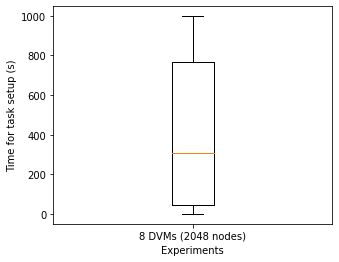

In [20]:
d_8dvm = [326.8291428089142, 820.0081808567047, 904.5807719230652, 17.3086359500885, 235.8045299053192, 781.0204751491547, 16.58888292312622, 305.31820487976074, 858.5604960918427, 866.242253780365, 827.2133071422577, 27.692471027374268, 323.2375841140747, 802.6125590801239, 177.3540210723877, 15.128971099853516, 867.0667040348053, 866.8778209686279, 13.782693862915039, 301.27397894859314, 15.328330039978027, 821.9505760669708, 856.3449399471283, 208.58019304275513, 883.2901740074158, 842.7578248977661, 39.558063983917236, 854.8545708656311, 14.223205089569092, 175.47299194335938, 498.540256023407, 87.78253388404846, 0.6904900074005127, 17.77048110961914, 15.687895059585571, 886.9694118499756, 902.3171541690826, 777.0564229488373, 860.358001947403, 862.1122500896454, 854.9090209007263, 913.5083739757538, 27.964289903640747, 16.5799880027771, 852.7481050491333, 428.074285030365, 270.86352705955505, 675.758455991745, 17.657667875289917, 506.4993350505829, 275.75728607177734, 734.2657480239868, 799.0864601135254, 167.4803409576416, 469.595890045166, 758.7203707695007, 279.5205011367798, 893.8595170974731, 308.0018401145935, 28.658565998077393, 875.9647448062897, 848.1091158390045, 174.59156394004822, 851.8572361469269, 811.5833599567413, 31.04756188392639, 798.5219810009003, 755.822340965271, 912.5449769496918, 849.4580798149109, 430.0572700500488, 1.184985876083374, 9.59660291671753, 187.699285030365, 366.1592779159546, 726.0494620800018, 272.31040596961975, 887.8894708156586, 852.8415079116821, 138.31946992874146, 392.02177000045776, 32.60619282722473, 481.0290369987488, 782.1395568847656, 776.9009130001068, 16.774176120758057, 843.3870739936829, 79.6071310043335, 129.42709612846375, 269.4860329627991, 842.9193458557129, 894.0186049938202, 609.0810070037842, 733.1915400028229, 84.154226064682, 773.9900078773499, 26.43232798576355, 816.7204530239105, 753.9259080886841, 21.747453212738037, 275.4193251132965, 893.7408649921417, 147.77177095413208, 802.9259819984436, 751.7260601520538, 17.135716915130615, 15.981759071350098, 292.50860619544983, 677.319463968277, 774.62735414505, 16.616279125213623, 878.0732049942017, 614.7487511634827, 27.653831958770752, 826.8698670864105, 766.1225578784943, 30.332751989364624, 823.4446980953217, 816.2184598445892, 800.5475301742554, 628.5692360401154, 30.66065788269043, 24.37950086593628, 0.5009250640869141, 140.43425393104553, 263.6760048866272, 732.8840939998627, 332.38209295272827, 914.7192568778992, 913.201728105545, 261.62011098861694, 164.24015593528748, 470.7896571159363, 359.303466796875, 300.2458071708679, 184.06735014915466, 16.79277992248535, 321.89926195144653, 796.5520930290222, 759.2266960144043, 8.822041988372803, 799.9694318771362, 75.17740678787231, 13.269256830215454, 779.6642189025879, 17.647997856140137, 300.65865087509155, 72.43220710754395, 29.68496084213257, 803.2257218360901, 478.10928106307983, 15.293351888656616, 894.0290060043335, 786.7875819206238, 823.7536280155182, 18.358833074569702, 149.0751359462738, 28.585460901260376, 307.82577991485596, 838.9719200134277, 28.550701141357422, 899.1330909729004, 473.1187539100647, 791.5765218734741, 764.4055449962616, 814.0025930404663, 771.9930591583252, 915.4336149692535, 340.94526386260986, 449.44730401039124, 832.3666749000549, 82.96037793159485, 539.208958864212, 757.7520620822906, 888.5480148792267, 755.5662138462067, 803.7800168991089, 803.1061379909515, 28.5595440864563, 14.462111949920654, 150.11671590805054, 872.5371570587158, 778.8057329654694, 239.8634238243103, 782.8647141456604, 278.4647750854492, 263.96203994750977, 707.8934688568115, 277.3070821762085, 24.733869075775146, 915.7527549266815, 812.037721157074, 712.8872570991516, 479.30232191085815, 23.596856117248535, 22.147162914276123, 288.04146003723145, 851.009202003479, 229.09035301208496, 868.2761359214783, 630.1796169281006, 859.8431189060211, 232.0883491039276, 825.4055361747742, 52.53857183456421, 23.43410587310791, 20.741624116897583, 103.99267792701721, 441.6946940422058, 766.5352578163147, 852.0994808673859, 767.2489788532257, 16.96351408958435, 830.1975908279419, 742.2400529384613, 730.0805649757385, 299.0900161266327, 17.29378890991211, 382.06736397743225, 557.5386469364166, 390.1465148925781, 368.52783608436584, 653.3064699172974, 16.139543056488037, 314.979120016098, 110.71086406707764, 874.9712879657745, 817.1591019630432, 293.2462739944458, 13.703059911727905, 28.650197982788086, 458.3164119720459, 182.20009398460388, 834.1620872020721, 303.6496729850769, 30.620653867721558, 785.9526600837708, 17.883422136306763, 260.67578506469727, 796.1726939678192, 70.46794009208679, 1.1494898796081543, 489.05927205085754, 305.2452790737152, 827.6163229942322, 441.3925619125366, 25.28887391090393, 462.37152099609375, 868.5583930015564, 102.74814796447754, 25.022884130477905, 669.39883685112, 843.1070251464844, 737.5384590625763, 27.133380889892578, 543.7675089836121, 878.5497789382935, 138.61446905136108, 769.3311769962311, 299.983118057251, 516.3951411247253, 301.2344558238983, 28.370882987976074, 781.640426158905, 272.45917081832886, 674.9829249382019, 13.682142972946167, 291.9383318424225, 778.6199018955231, 79.008229970932, 816.1251239776611, 859.6020429134369, 321.61887192726135, 861.9190168380737, 303.99826097488403, 15.649894952774048, 128.73288202285767, 719.193197965622, 842.6901261806488, 291.9451448917389, 753.0403230190277, 16.11643409729004, 865.8684041500092, 254.28583598136902, 320.4871668815613, 550.2380139827728, 807.0296778678894, 306.9621829986572, 654.5665950775146, 20.93087887763977, 771.7184419631958, 805.5070819854736, 846.0117192268372, 933.0893161296844, 812.7750861644745, 117.09567499160767, 15.583240032196045, 262.83069014549255, 14.133403062820435, 798.9023559093475, 828.424477815628, 812.4448399543762, 42.07013392448425, 80.30211806297302, 808.8118720054626, 248.6003680229187, 291.6454870700836, 170.03880500793457, 829.206503868103, 855.8905601501465, 304.84057807922363, 82.56981706619263, 900.8680911064148, 276.6899609565735, 778.7431848049164, 44.31323003768921, 809.797590970993, 835.206864118576, 30.499046087265015, 253.10452795028687, 669.045863866806, 190.9822540283203, 17.00222086906433, 362.0061559677124, 694.7849900722504, 15.130871057510376, 866.6192569732666, 870.4360830783844, 159.46655893325806, 353.0082061290741, 925.7270150184631, 351.47978496551514, 784.8319170475006, 789.2138669490814, 856.9139168262482, 364.7481138706207, 271.2619879245758, 165.92460012435913, 692.6660630702972, 113.60836791992188, 636.0784788131714, 18.762738943099976, 287.76093101501465, 20.794218063354492, 155.72414898872375, 766.484785079956, 13.246409893035889, 30.02013087272644, 867.1086328029633, 772.9093389511108, 113.48384594917297, 748.6181330680847, 17.493496894836426, 17.030295848846436, 433.8977029323578, 133.3465440273285, 327.10545206069946, 837.0174050331116, 27.28327178955078, 821.8926920890808, 902.4216210842133, 682.1896178722382, 790.4316461086273, 167.03430795669556, 336.56848096847534, 29.18017601966858, 428.5007290840149, 304.82417702674866, 882.024759054184, 298.5463020801544, 31.035490036010742, 842.3747410774231, 489.6625258922577, 27.409950017929077, 774.7980008125305, 65.958261013031, 17.880578994750977, 339.4958839416504, 850.8187050819397, 857.3594779968262, 414.8418550491333, 153.96791291236877, 789.0081820487976, 263.8997869491577, 896.6513299942017, 823.0596208572388, 823.0561950206757, 758.5116410255432, 23.929566860198975, 25.881245136260986, 189.98410201072693, 777.4035089015961, 87.23892712593079, 351.01814889907837, 795.5449709892273, 25.957965850830078, 15.08053183555603, 862.1584520339966, 312.2051479816437, 370.5098919868469, 878.6116299629211, 856.4611780643463, 114.25646996498108, 748.8014059066772, 338.43856596946716, 738.5141489505768, 166.4631631374359, 291.6034059524536, 787.2182581424713, 745.8268849849701, 841.6911540031433, 28.75768494606018, 692.427531003952, 820.2101449966431, 768.2117371559143, 705.5811920166016, 25.607780933380127, 17.160303831100464, 804.5425419807434, 23.117079973220825, 317.6215069293976, 272.49442195892334, 854.2785770893097, 66.65416598320007, 920.4081239700317, 867.5954458713531, 598.6875729560852, 400.58276081085205, 28.879083156585693, 792.7654979228973, 328.68380904197693, 838.7693939208984, 505.4335949420929, 801.472659111023, 30.27101492881775, 23.088721990585327, 859.0544199943542, 15.828221797943115, 23.619680166244507, 17.574883937835693, 20.196721076965332, 892.8001389503479, 346.4300229549408, 753.6187689304352, 756.4020459651947, 30.485417127609253, 225.05617308616638, 15.01495099067688, 294.34002017974854, 349.7185549736023, 800.4623849391937, 733.8729329109192, 285.9518129825592, 848.0847098827362, 784.3990769386292, 710.2444241046906, 734.5678970813751, 810.5264790058136, 728.6674301624298, 864.9193639755249, 786.1517901420593, 15.822499990463257, 266.58237409591675, 835.2129669189453, 76.13802313804626, 712.584793806076, 910.2582910060883, 737.35005402565, 783.5404140949249, 133.38965392112732, 546.9388561248779, 790.8896071910858, 846.610029220581, 868.6915850639343, 445.1796669960022, 0.59033203125, 773.6863029003143, 775.8892149925232, 424.0401711463928, 804.5672152042389, 17.478346824645996, 30.90890097618103, 287.418527841568, 767.0431089401245, 175.77175211906433, 17.648178100585938, 792.7186651229858, 310.5159401893616, 381.7950849533081, 805.8175158500671, 18.595762968063354, 867.8269419670105, 771.4060130119324, 326.7414381504059, 30.841531991958618, 349.6561861038208, 820.2391359806061, 814.9714818000793, 268.73794507980347, 71.20726895332336, 867.390594959259, 200.98824214935303, 29.00438094139099, 857.8847758769989, 831.3482069969177, 819.7466940879822, 335.90000104904175, 348.5192451477051, 789.3149380683899, 629.2172040939331, 829.8707051277161, 844.5037529468536, 0.343764066696167, 842.8075380325317, 18.861175060272217, 246.3023021221161, 366.6860730648041, 15.750830173492432, 183.77429389953613, 15.363435983657837, 225.9190709590912, 26.689586877822876, 283.7287998199463, 750.6872041225433, 793.571130990982, 356.60660004615784, 772.9483001232147, 27.524513959884644, 164.931067943573, 30.175266981124878, 776.4799900054932, 885.4819259643555, 14.113626956939697, 289.7597360610962, 849.3809311389923, 839.6617579460144, 472.0064949989319, 13.635630130767822, 286.66069316864014, 17.17495894432068, 23.919158935546875, 330.2074098587036, 914.8806791305542, 959.3488190174103, 727.536691904068, 17.335274934768677, 820.2394750118256, 706.895437002182, 789.6268718242645, 733.8013978004456, 92.96471309661865, 397.0270960330963, 848.1650261878967, 789.325248003006, 727.5256938934326, 12.876866102218628, 481.76698303222656, 929.1352410316467, 818.373064994812, 15.713760137557983, 784.0600378513336, 25.03732991218567, 931.8721861839294, 177.428808927536, 373.45282006263733, 736.7826960086823, 791.012549161911, 73.13440704345703, 120.72095394134521, 795.0235371589661, 317.2677059173584, 190.22556614875793, 697.875941991806, 294.1033980846405, 15.19970703125, 846.0602221488953, 418.555349111557, 327.9188959598541, 844.5110709667206, 166.2698838710785, 276.1132559776306, 350.0500249862671, 852.741406917572, 18.304671049118042, 826.2595119476318, 456.9646050930023, 284.4545488357544, 486.62045311927795, 763.8823139667511, 269.37676787376404, 787.2888898849487, 13.670722961425781, 792.769495010376, 843.831750869751, 862.6689269542694, 62.936909198760986, 360.1551339626312, 1.4460179805755615, 34.314483880996704, 16.747782945632935, 696.7830219268799, 24.67672300338745, 155.430114030838, 888.9455959796906, 306.8927569389343, 289.0401508808136, 1.1621739864349365, 809.0517821311951, 281.2407729625702, 903.1569890975952, 28.84048295021057, 145.2794840335846, 805.2179701328278, 209.38227200508118, 779.4878239631653, 794.1324141025543, 792.8843359947205, 801.0075957775116, 344.61387395858765, 805.6219999790192, 712.03866314888, 113.02155208587646, 16.347821950912476, 738.2907059192657, 763.5781359672546, 811.1415350437164, 828.3527009487152, 762.5213871002197, 286.79454922676086, 15.672069072723389, 417.50838899612427, 809.9175131320953, 75.82646608352661, 23.426589012145996, 16.15764594078064, 223.45775294303894, 895.9976909160614, 293.4588210582733, 651.1374659538269, 495.57847905158997, 144.24829411506653, 18.28839087486267, 315.39767503738403, 845.5497059822083, 842.0710780620575, 760.6713740825653, 267.39576292037964, 901.1946749687195, 804.0690770149231, 151.31416702270508, 807.3962879180908, 785.7425119876862, 837.5352489948273, 766.5638070106506, 308.59251284599304, 32.28862190246582, 23.832484006881714, 801.6813402175903, 506.6578359603882, 62.13277006149292, 966.2542531490326, 696.6416430473328, 824.6310260295868, 888.5591359138489, 12.608666181564331, 815.1134498119354, 79.45925498008728, 731.5517649650574, 50.27831506729126, 877.123575925827, 856.3218729496002, 27.03746199607849, 409.27444410324097, 277.2076687812805, 15.707019805908203, 668.7530620098114, 24.850560188293457, 530.0960519313812, 694.9228870868683, 899.5806438922882, 686.3982710838318, 748.3189671039581, 882.7268841266632, 574.9861209392548, 467.18568110466003, 26.68682312965393, 840.9804999828339, 903.0158751010895, 743.8201849460602, 861.5424270629883, 273.9242880344391, 23.419897079467773, 733.0923910140991, 91.97813487052917, 300.2016088962555, 621.2740640640259, 205.3362820148468, 689.6102950572968, 558.7850449085236, 826.7980258464813, 485.2501108646393, 477.1269941329956, 188.27347707748413, 840.0776100158691, 825.4801831245422, 5.2402260303497314, 289.87298703193665, 752.8320000171661, 198.18003606796265, 810.5693891048431, 284.4970941543579, 795.5486969947815, 644.4390439987183, 780.7750508785248, 300.1313169002533, 203.47906017303467, 287.8952820301056, 289.6071879863739, 89.78544497489929, 5.5372068881988525, 16.70153784751892, 686.9215350151062, 809.8201260566711, 18.522164821624756, 86.95815992355347, 40.58198285102844, 26.748382806777954, 888.7370181083679, 815.2737069129944, 115.13668298721313, 802.4857280254364, 895.8179190158844, 397.23812890052795, 856.7988018989563, 304.6556091308594, 15.207093954086304, 245.6218991279602, 917.2472620010376, 797.3169920444489, 815.7944650650024, 789.6490230560303, 18.967406034469604, 15.656252145767212, 870.9175689220428, 1.7852320671081543, 751.3422629833221, 871.8260641098022, 249.17871689796448, 30.984292030334473, 843.8866398334503, 13.324254035949707, 25.49978494644165, 460.22830986976624, 441.6309759616852, 60.64518404006958, 805.7745840549469, 758.4030950069427, 82.35134410858154, 2.9956469535827637, 729.1267471313477, 775.7653260231018, 876.474601984024, 897.9990458488464, 737.0181651115417, 625.8047671318054, 48.58265709877014, 505.7666561603546, 804.3200018405914, 325.81112694740295, 15.875914812088013, 323.1378741264343, 781.0193710327148, 208.64977192878723, 11.569011926651001, 1.4478058815002441, 268.8477599620819, 291.5073959827423, 566.8072061538696, 136.77756094932556, 16.120481967926025, 24.261560916900635, 797.3928868770599, 300.2776081562042, 798.5740320682526, 853.4687209129333, 176.05826592445374, 17.830039024353027, 903.7376070022583, 859.2362470626831, 890.6151411533356, 259.22452902793884, 759.5978291034698, 807.8589158058167, 802.8555219173431, 278.81549406051636, 14.411144971847534, 142.27938604354858, 22.283057928085327, 283.26417207717896, 299.2670519351959, 0.6444180011749268, 324.2676889896393, 188.65816807746887, 768.9518978595734, 13.49028491973877, 814.4671540260315, 1.4544470310211182, 262.0699739456177, 725.3231267929077, 344.4478590488434, 849.0464010238647, 299.29817509651184, 348.4017610549927, 100.69166398048401, 28.434792041778564, 58.200085163116455, 16.166957139968872, 104.28896307945251, 743.1805799007416, 195.38864302635193, 774.3692541122437, 450.44793796539307, 481.65699100494385, 491.538202047348, 44.194432973861694, 59.40520095825195, 17.251966953277588, 302.0185430049896, 923.4601240158081, 926.7790958881378, 424.84809017181396, 700.5817449092865, 0.3013031482696533, 467.20819783210754, 858.0408058166504, 17.291125059127808, 922.4140839576721, 917.3713760375977, 309.06503200531006, 350.0900299549103, 523.3726830482483, 892.2692711353302, 25.168402910232544, 360.26734590530396, 150.55394291877747, 726.6986739635468, 425.64186906814575, 17.020110845565796, 905.2714509963989, 806.4334120750427, 303.3959050178528, 0.2536911964416504, 848.2871520519257, 835.6712980270386, 252.67412304878235, 846.3609659671783, 758.9630188941956, 13.55345892906189, 66.31862783432007, 325.89891505241394, 756.1419839859009, 384.0637540817261, 97.80948901176453, 888.6940071582794, 894.5085170269012, 3.032043933868408, 17.760436058044434, 328.8390791416168, 436.5149509906769, 16.68291211128235, 125.66736793518066, 502.4676339626312, 899.249489068985, 303.0622181892395, 785.1466159820557, 168.74879598617554, 28.95798110961914, 548.5912380218506, 367.3849182128906, 427.68485713005066, 834.6386320590973, 681.914824962616, 821.4130671024323, 650.7431371212006, 437.33872509002686, 880.6946430206299, 71.8607280254364, 861.881420135498, 315.6763401031494, 780.5130639076233, 782.0938611030579, 370.2197790145874, 818.40567278862, 289.82846093177795, 849.8633069992065, 316.5697531700134, 10.141627073287964, 767.3665430545807, 296.1571810245514, 677.2282280921936, 685.6389291286469, 307.0810580253601, 834.0173270702362, 16.865501880645752, 816.2295970916748, 636.5203399658203, 6.152388095855713, 1.9484949111938477, 901.4145421981812, 279.98884201049805, 14.725510120391846, 751.9237341880798, 187.0028088092804, 189.2637960910797, 318.81931495666504, 292.71434903144836, 753.2835099697113, 633.7744131088257, 23.511979818344116, 821.0095129013062, 753.8165969848633, 273.66710782051086, 182.5642068386078, 924.3311419487, 535.1300840377808, 103.5352029800415, 835.4398758411407, 14.589977979660034, 14.843425989151001, 254.76688599586487, 830.8712918758392, 32.20438599586487, 449.891135931015, 852.9978590011597, 493.55763006210327, 851.1911458969116, 171.04611802101135, 380.72877383232117, 785.2408039569855, 754.3065979480743, 316.8103051185608, 860.5199449062347, 269.1414098739624, 155.68971490859985, 827.7046949863434, 17.698745012283325, 247.24361205101013, 41.88214707374573, 190.376207113266, 327.3894920349121, 786.3048210144043, 204.70411801338196, 444.0221378803253, 27.734915018081665, 18.699092864990234, 349.68329906463623, 769.2751429080963, 450.6111898422241, 510.2828800678253, 311.671245098114, 287.3494601249695, 843.7994439601898, 939.7034702301025, 77.92288708686829, 454.12579107284546, 1.2067091464996338, 776.3580248355865, 54.03092098236084, 32.42944407463074, 726.6202371120453, 97.80757284164429, 614.7797811031342, 731.7882249355316, 177.3078329563141, 737.0172498226166, 306.093120098114, 616.5949659347534, 568.2645959854126, 12.704276084899902, 13.56160283088684, 884.6614060401917, 807.1777548789978, 787.017904996872, 89.44450902938843, 741.7658679485321, 13.955965995788574, 741.3511869907379, 784.1788611412048, 453.5427100658417, 132.60445499420166, 828.8954429626465, 20.489225149154663, 24.69303798675537, 857.0792980194092, 289.44807720184326, 893.8062310218811, 291.60612320899963, 16.104001998901367, 13.677358865737915, 311.7344129085541, 17.009639024734497, 690.4205920696259, 22.02750015258789, 665.2284669876099, 776.0037670135498, 292.0294780731201, 555.0722019672394, 17.512733936309814, 755.3774130344391, 23.82994794845581, 819.6981358528137, 772.9522140026093, 326.12362909317017, 766.6238000392914, 264.66738080978394, 889.7328341007233, 466.28345799446106, 877.0068328380585, 29.882887840270996, 346.5628218650818, 276.9845280647278, 289.2721869945526, 71.93866109848022, 27.270503044128418, 897.3591520786285, 335.78569412231445, 797.4464209079742, 777.0573649406433, 843.0766439437866, 792.0315380096436, 781.3854367733002, 403.3801989555359, 319.7459671497345, 98.3806540966034, 896.2828369140625, 871.0569279193878, 818.796275138855, 676.9223320484161, 332.35919404029846, 820.2843708992004, 404.0884370803833, 270.94460105895996, 570.4201860427856, 841.6342539787292, 756.9972910881042, 796.2494449615479, 129.84446597099304, 42.74189901351929, 244.5391402244568, 78.09245586395264, 820.6200919151306, 826.7701120376587, 797.6117579936981, 769.5435528755188, 879.5634071826935, 23.91525912284851, 836.328232049942, 396.2813789844513, 106.12911701202393, 721.4625489711761, 802.0097198486328, 131.2964210510254, 870.2648329734802, 883.2911729812622, 763.9235939979553, 672.1223590373993, 308.99983191490173, 869.8502349853516, 164.105623960495, 290.30919194221497, 921.1355609893799, 803.9016580581665, 817.856153011322, 136.2840220928192, 22.610087871551514, 295.9530529975891, 17.679915189743042, 15.148706912994385, 16.334507942199707, 627.277459859848, 273.2332091331482, 220.50901103019714, 761.6593899726868, 857.7362461090088, 17.2070951461792, 897.4483461380005, 276.2482988834381, 23.96170687675476, 726.3172311782837, 188.1863489151001, 34.25302696228027, 84.64850807189941, 892.3697879314423, 689.294084072113, 476.5346701145172, 30.307373046875, 866.3879659175873, 27.466709852218628, 325.46327900886536, 831.5171978473663, 208.43970489501953, 829.099396944046, 33.72551918029785, 23.46943497657776, 303.65910291671753, 657.1463050842285, 839.9135599136353, 286.87980103492737, 918.7995800971985, 778.5711929798126, 331.45558404922485, 725.4582891464233, 834.7276408672333, 833.9742541313171, 11.141669034957886, 179.2257478237152, 248.02446103096008, 927.8917708396912, 98.94385409355164, 826.6534650325775, 579.8293361663818, 23.893429040908813, 912.3391180038452, 79.45944905281067, 26.70874309539795, 828.9455790519714, 341.0651569366455, 568.3528249263763, 13.31744909286499, 191.72178316116333, 420.339063167572, 28.965306997299194, 283.6788740158081, 765.0410778522491, 922.6655569076538, 287.35362100601196, 257.5068700313568, 21.79271697998047, 227.2102291584015, 872.1843209266663, 696.5531558990479, 283.3840870857239, 199.39640092849731, 311.73915696144104, 770.822958946228, 472.4488489627838, 141.21239399909973, 172.37005400657654, 19.27127504348755, 283.14812707901, 620.0766611099243, 23.2048180103302, 14.808761835098267, 131.45141410827637, 887.6910910606384, 344.841924905777, 15.595915079116821, 778.5304811000824, 26.751158952713013, 851.1857209205627, 290.8089370727539, 280.63524413108826, 834.0838420391083, 904.6543641090393, 276.0805082321167, 15.140748977661133, 765.1670570373535, 18.723443031311035, 794.178414106369, 866.5914900302887, 48.32830309867859, 13.379687070846558, 734.4798908233643, 729.464653968811, 222.80352091789246, 305.0823187828064, 807.4422850608826, 29.33963394165039, 721.7225880622864, 18.62925696372986, 755.3217101097107, 307.7232120037079, 15.58770489692688, 767.4000880718231, 272.28240990638733, 718.1984691619873, 17.271149158477783, 68.34852910041809, 525.7688200473785, 333.4480299949646, 900.3629879951477, 372.01767015457153, 802.2051689624786, 73.80038905143738, 127.97281289100647, 17.0605309009552, 787.7635450363159, 827.1537411212921, 746.3816051483154, 329.8107080459595, 537.1090168952942, 842.3890960216522, 774.424075126648, 286.5709819793701, 173.29058980941772, 745.5833292007446, 267.1661500930786, 482.67733693122864, 87.38222908973694, 957.1766440868378, 762.7103991508484, 273.7715940475464, 764.498908996582, 467.8269531726837, 341.1317400932312, 289.82538890838623, 17.275089979171753, 729.0473489761353, 496.25556111335754, 671.9239718914032, 16.224015951156616, 78.5494430065155, 21.768756866455078, 805.8394341468811, 128.77020716667175, 444.0583248138428, 24.33892798423767, 15.038525104522705, 730.3290109634399, 28.582767963409424, 266.7630088329315, 829.283499956131, 713.0220060348511, 873.0087311267853, 4.405045032501221, 28.39676594734192, 802.1385319232941, 579.0342679023743, 33.9107449054718, 326.4582450389862, 271.0608241558075, 783.0622961521149, 317.7729318141937, 789.9740889072418, 826.9495508670807, 111.44357705116272, 27.859737873077393, 75.59546613693237, 773.3395688533783, 863.3792409896851, 259.3525040149689, 833.1371440887451, 127.03494000434875, 247.53164100646973, 135.1935420036316, 792.3615720272064, 745.8148469924927, 420.12173891067505, 84.90844678878784, 24.78860902786255, 677.8659820556641, 288.7934148311615, 303.1230299472809, 800.7169661521912, 432.00421595573425, 875.17231798172, 288.9602918624878, 20.42213797569275, 29.248466968536377, 739.7374370098114, 70.19906687736511, 279.1972939968109, 739.8400650024414, 300.9751400947571, 21.544814109802246, 160.66243314743042, 309.33818197250366, 713.5790371894836, 433.11248087882996, 838.2402939796448, 309.0762310028076, 679.0342180728912, 169.93944001197815, 864.4509980678558, 500.18236899375916, 843.2767369747162, 909.0296540260315, 769.6243298053741, 399.0664939880371, 430.7003080844879, 899.9025008678436, 897.9719798564911, 111.64827108383179, 811.0587599277496, 72.27537178993225, 759.0286180973053, 394.8667411804199, 812.2962551116943, 775.3940620422363, 755.4042179584503, 762.6003918647766, 629.3509030342102, 307.0400869846344, 309.05321502685547, 5.608465194702148, 812.5978560447693, 324.8876430988312, 409.87605595588684, 26.81161880493164, 854.6952419281006, 0.6825940608978271, 812.7033829689026, 826.7601001262665, 129.6119520664215, 396.572970867157, 808.8372740745544, 140.412682056427, 886.8686718940735, 740.0205709934235, 698.3032789230347, 403.50149607658386, 278.83384585380554, 341.4054419994354, 477.7323651313782, 445.30005383491516, 151.7278711795807, 203.66787385940552, 783.844419002533, 716.1230912208557, 239.95904183387756, 700.6829328536987, 429.22086000442505, 17.461995124816895, 246.5420000553131, 778.4216551780701, 300.3518371582031, 306.5107510089874, 691.9434649944305, 185.45712304115295, 183.39086294174194, 208.2566578388214, 17.6907639503479, 803.5832290649414, 717.3579590320587, 850.8210668563843, 256.079381942749, 855.0243711471558, 59.08962297439575, 728.2808499336243, 895.675124168396, 881.9795250892639, 770.2350149154663, 765.1515238285065, 115.18049311637878, 881.8660609722137, 827.0477352142334, 677.3481879234314, 895.7874248027802, 13.831693172454834, 937.2382280826569, 787.4593470096588, 861.5295560359955, 269.71727204322815, 14.136420965194702, 17.788912057876587, 18.81316614151001, 9.629495859146118, 262.099004983902, 455.3710889816284, 730.5963537693024, 171.8772931098938, 802.0401401519775, 866.7130219936371, 839.799635887146, 698.5311200618744, 7.585675001144409, 776.9793739318848, 818.1819760799408, 844.9871208667755, 892.1102588176727, 827.2529571056366, 299.5132260322571, 0.4261660575866699, 711.3122398853302, 58.20872187614441, 274.01919293403625, 23.4516019821167, 285.5236029624939, 135.17256093025208, 764.8298528194427, 24.49727988243103, 284.1476571559906, 682.268306016922, 899.5599148273468, 32.35759401321411, 328.23566913604736, 588.867240190506, 288.62854409217834, 776.5779960155487, 29.095274925231934, 314.9673571586609, 809.5157248973846, 288.95366621017456, 822.8153691291809, 282.7442719936371, 829.9716320037842, 13.655755043029785, 296.5642058849335, 876.4874529838562, 790.922434091568, 835.3878509998322, 189.91386198997498, 880.0405340194702, 282.5032320022583, 470.5537600517273, 777.815752029419, 168.18918299674988, 15.48812198638916, 88.70849084854126, 17.530891180038452, 836.2704341411591, 24.909231901168823, 833.6804120540619, 692.3436419963837, 875.5768370628357, 275.31878900527954, 388.74669885635376, 715.4293241500854, 852.9253530502319, 835.5274398326874, 895.9570281505585, 464.39183282852173, 365.7186050415039, 896.4944829940796, 934.8356280326843, 77.91862893104553, 950.7690351009369, 283.84211111068726, 16.47625494003296, 800.4619100093842, 768.6110599040985, 102.22075009346008, 337.9855809211731, 26.97623586654663, 195.21351194381714, 844.5370390415192, 290.7164258956909, 681.1320209503174, 201.53826212882996, 165.93695187568665, 840.0957808494568, 297.9782919883728, 292.5922701358795, 29.003555059432983, 787.0012791156769, 796.6743149757385, 291.8609800338745, 505.8582088947296, 189.92934918403625, 320.4329090118408, 534.8635489940643, 325.71506810188293, 335.57666516304016, 24.698434114456177, 750.0415019989014, 489.86753392219543, 316.8179819583893, 791.8381178379059, 804.3487040996552, 445.3393609523773, 626.9090402126312, 816.6498658657074, 321.0355980396271, 783.19105219841, 32.5354790687561, 537.1018600463867, 54.01860499382019, 15.911720991134644, 843.193531036377, 793.8780610561371, 1.4982550144195557, 821.1857950687408, 861.2068498134613, 757.645003080368, 865.3597781658173, 312.2182550430298, 889.1493229866028, 783.7241020202637, 348.8603951931, 17.68433690071106, 18.45017123222351, 275.329617023468, 839.4311521053314, 182.97067999839783, 916.8968279361725, 383.36434388160706, 281.3433129787445, 769.5988528728485, 299.83481216430664, 871.3768479824066, 750.1368799209595, 488.960844039917, 310.89450120925903, 151.43236994743347, 257.13216495513916, 15.45642614364624, 429.7065498828888, 5.208329200744629, 24.639894008636475, 862.6538989543915, 840.9270780086517, 853.7494919300079, 677.511864900589, 735.3650259971619, 711.0181791782379, 285.4701919555664, 797.2807559967041, 807.9413039684296, 760.9152460098267, 13.234847068786621, 850.9057080745697, 49.20766592025757, 894.3484170436859, 263.8089029788971, 153.2932469844818, 18.97194504737854, 86.96378707885742, 716.4728531837463, 751.9080471992493, 16.14721918106079, 310.3193418979645, 826.9341478347778, 125.79681396484375, 281.9671540260315, 316.7251398563385, 15.611171007156372, 152.72048711776733, 825.293879032135, 849.5582251548767, 710.3739709854126, 900.4077599048615, 830.1552560329437, 16.539280891418457, 846.6272130012512, 886.8917758464813, 366.44464206695557, 856.3723530769348, 753.6886899471283, 270.8668620586395, 798.775218963623, 230.41459393501282, 475.6119439601898, 149.84208798408508, 486.631854057312, 766.2583920955658, 822.7893650531769, 298.0234010219574, 864.3114049434662, 29.588459014892578, 207.80730390548706, 890.6313560009003, 13.40389108657837, 141.05690813064575, 359.6164360046387, 833.8702130317688, 94.0694808959961, 129.2811779975891, 459.54612588882446, 813.0601410865784, 13.34968900680542, 861.2218019962311, 809.5887451171875, 785.6918811798096, 13.248141050338745, 740.6357350349426, 290.95769810676575, 492.14747190475464, 813.4639210700989, 792.9984111785889, 833.753928899765, 177.5797779560089, 790.8156418800354, 757.7089610099792, 99.2086489200592, 912.2450129985809, 227.87405800819397, 832.4286751747131, 24.60975408554077, 820.8561189174652, 81.7809751033783, 28.083046197891235, 733.6177010536194, 331.2218370437622, 696.0307450294495, 17.419486045837402, 826.7720129489899, 402.5754361152649, 771.5551807880402, 827.5694749355316, 150.58328700065613, 31.52823519706726, 291.6614887714386, 771.0428268909454, 291.1678900718689, 787.6792871952057, 16.163994073867798, 144.51376485824585, 852.2883141040802, 40.64181709289551, 821.7519199848175, 0.8453729152679443, 301.66160798072815, 785.8780319690704, 852.1826529502869, 280.25108098983765, 779.8999760150909, 910.2993609905243, 747.2792680263519, 291.9180488586426, 232.88022708892822, 16.75627088546753, 281.9193651676178, 292.9038100242615, 87.42814993858337, 689.5382149219513, 98.7967689037323, 809.2110130786896, 738.3540549278259, 857.1867790222168, 857.7427530288696, 61.05805492401123, 144.39331793785095, 549.7094831466675, 933.1918749809265, 23.577234029769897, 874.0995469093323, 697.1303989887238, 330.73333716392517, 179.68898916244507, 780.7276530265808, 764.2652518749237, 291.36823201179504, 465.7703449726105, 846.52237200737, 833.0882370471954, 20.27381706237793, 660.6118559837341, 830.873862028122, 693.107743024826, 301.4436159133911, 905.1320660114288, 726.0882279872894, 214.30102396011353, 804.8891558647156, 844.6392199993134, 0.5721879005432129, 36.24482989311218, 691.756175994873, 267.1768820285797, 936.3105299472809, 884.2797000408173, 776.9383330345154, 784.059718132019, 877.7059650421143, 19.923912048339844, 296.38486099243164, 19.576679944992065, 762.5237901210785, 867.273579120636, 786.0027229785919, 293.6692850589752, 772.2608950138092, 370.47167110443115, 817.5828959941864, 175.44989109039307, 365.9925410747528, 26.185669898986816, 350.0412030220032, 17.3386390209198, 235.61147093772888, 14.909334897994995, 151.11743807792664, 169.83015894889832, 72.5108699798584, 726.9526288509369, 781.2390441894531, 292.227933883667, 317.8094389438629, 503.3840789794922, 768.6146039962769, 15.007853984832764, 820.9401969909668, 348.839457988739, 780.2007391452789, 847.0476460456848, 792.908695936203, 315.52155900001526, 878.7327620983124, 762.6259348392487, 1.08919095993042, 884.8702030181885, 859.0871140956879, 281.5201041698456, 17.30293107032776, 841.126277923584, 865.6360511779785, 885.118880033493, 297.6089389324188, 276.29076886177063, 889.571270942688, 778.7040550708771, 190.34343194961548, 646.6659200191498, 935.9777448177338, 739.4831690788269, 881.924586057663, 280.25395107269287, 722.5470249652863, 339.5536119937897, 176.1703279018402, 289.39055705070496, 716.3173789978027, 649.7239978313446, 85.58874607086182, 875.9809639453888, 13.14322805404663, 627.290834903717, 391.011442899704, 887.9258921146393, 797.1535930633545, 796.2263560295105, 25.74205994606018, 315.9803159236908, 791.9591109752655, 17.356199026107788, 419.123722076416, 406.82437014579773, 283.8434360027313, 405.3866481781006, 709.2103469371796, 18.230684995651245, 210.20474696159363, 783.6141560077667, 856.5479249954224, 296.23152685165405, 483.77261686325073, 318.9695620536804, 802.7731459140778, 186.08545207977295, 233.10590982437134, 790.5991539955139, 15.073909997940063, 15.620205879211426, 25.175694942474365, 95.83814096450806, 803.8786089420319, 791.9446110725403, 857.5611650943756, 808.510745048523, 455.6753559112549, 756.4544281959534, 70.7804970741272, 141.0525951385498, 858.777006149292, 770.2591800689697, 255.77838778495789, 16.68451714515686, 331.8212049007416, 746.1953690052032, 629.2772169113159, 918.4192991256714, 341.44199085235596, 705.0462439060211, 24.67914605140686, 191.66994905471802, 781.5039608478546, 92.4056921005249, 887.1026508808136, 24.708449125289917, 349.5039930343628, 754.0281429290771, 18.857475996017456, 956.1279699802399, 64.01545596122742, 252.35986495018005, 181.11012601852417, 292.22365498542786, 299.7230529785156, 282.28897190093994, 112.48712992668152, 716.1944200992584, 840.2269470691681, 851.7702779769897, 737.4415130615234, 260.0563979148865, 894.5059309005737, 710.9137840270996, 193.81495189666748, 208.28311681747437, 894.2482080459595, 900.2316739559174, 723.1177790164948, 23.133666038513184, 27.540179014205933, 26.906573057174683, 925.673357963562, 256.9886441230774, 66.91607284545898, 820.4102289676666, 774.4187269210815, 303.279345035553, 76.84946203231812, 85.94810104370117, 320.818078994751, 859.7399129867554, 316.99946188926697, 19.017147064208984, 838.0201818943024, 886.870078086853, 16.489209175109863, 847.1664218902588, 489.4672598838806, 805.7999329566956, 27.340282917022705, 29.311373949050903, 329.1895670890808, 474.52789402008057, 457.8931231498718, 295.3276119232178, 871.0586640834808, 850.8126020431519, 809.3395709991455, 13.399755001068115, 27.72330594062805, 319.4664158821106, 853.8097021579742, 824.5882360935211, 86.70855498313904, 748.5944049358368, 717.6878159046173, 30.826735019683838, 523.6340219974518, 83.88783311843872, 149.30129885673523, 546.3218200206757, 431.21219301223755, 132.01786708831787, 39.07157301902771, 18.229660034179688, 212.43006491661072, 15.633295059204102, 276.5128300189972, 914.4664878845215, 28.715924978256226, 844.4656598567963, 850.3835079669952, 29.15802502632141, 813.5750229358673, 331.9818711280823, 809.7586970329285, 16.155393838882446, 134.44259595870972, 779.2051639556885, 293.36204504966736, 168.36514520645142, 610.2036409378052, 293.79516887664795, 770.9456009864807, 87.43862795829773, 599.1190979480743, 329.8538999557495, 492.99354791641235, 24.81708788871765, 293.94830894470215, 788.4000759124756, 729.2386291027069, 342.1572780609131, 772.4126560688019, 809.1006441116333, 448.95820903778076, 493.3565731048584, 734.6277189254761, 808.3503470420837, 808.0259668827057, 11.29876184463501, 563.4894080162048, 851.3516590595245, 813.6653909683228, 789.8371059894562, 33.394546031951904, 97.55840706825256, 360.6949248313904, 296.99362683296204, 762.9538729190826, 266.2611360549927, 817.6876819133759, 122.51768112182617, 834.9123158454895, 901.1829199790955, 756.8690700531006, 813.7210628986359, 791.4787619113922, 16.013415813446045, 863.1189088821411, 24.812139987945557, 832.2029659748077, 325.73923087120056, 266.4284429550171, 47.05651497840881, 871.3505940437317, 479.39056181907654, 766.5543780326843, 57.39973497390747, 810.9657168388367, 0.829016923904419, 226.91758012771606, 25.986605167388916, 288.5169999599457, 832.7046830654144, 396.5377609729767, 143.63144087791443, 15.64382004737854, 27.02599596977234, 310.9027590751648, 831.8590939044952, 120.32460403442383, 334.44148802757263, 690.1222081184387, 857.9967370033264, 620.5134980678558, 267.3591639995575, 286.52274203300476, 799.070494890213, 56.42986583709717, 712.6218640804291, 309.8339228630066, 796.785679101944, 433.07129192352295, 15.519495010375977, 24.804308891296387, 715.5082068443298, 804.9909541606903, 294.0105879306793, 160.69450402259827, 794.5059850215912, 827.8712759017944, 10.187511920928955, 101.84999895095825, 5.675595998764038, 697.4727909564972, 844.1583580970764, 777.9977040290833, 347.5561270713806, 339.278440952301, 288.92257714271545, 391.2909598350525, 454.66740894317627, 850.2977480888367, 123.16151189804077, 579.9553229808807, 348.9586892127991, 288.64616680145264, 18.834566831588745, 861.3812820911407, 782.8595678806305, 403.4540271759033, 345.61120200157166, 727.4404990673065, 741.9175310134888, 804.1206040382385, 308.9189531803131, 780.6682391166687, 687.3991341590881, 19.488979816436768, 751.5434379577637, 843.0624358654022, 173.03071999549866, 846.3994178771973, 855.1696610450745, 84.22372603416443, 461.42199301719666, 29.240212202072144, 786.1620299816132, 771.8598959445953, 266.7790369987488, 544.1280479431152, 85.99103689193726, 878.7086279392242, 319.08050894737244, 294.99021196365356, 898.5390989780426, 14.852699995040894, 33.04874300956726, 11.839352130889893, 184.9910180568695, 506.21020698547363, 282.59138798713684, 931.02383685112, 286.53493213653564, 2.4755029678344727, 303.7019829750061, 515.181529045105, 384.7495310306549, 317.7885389328003, 283.93228697776794, 17.22709894180298, 75.81898188591003, 270.17750000953674, 15.777084827423096, 888.784481048584, 276.33100986480713, 885.9916579723358, 15.44421100616455, 845.2203280925751, 31.28274393081665, 850.0768148899078, 865.6735949516296, 11.50590205192566, 737.2490549087524, 702.5435280799866, 444.73396492004395, 467.3619701862335, 805.5126760005951, 0.7525649070739746, 137.88317108154297, 924.3514490127563, 287.1655468940735, 148.25909399986267, 443.515499830246, 165.526850938797, 418.8586280345917, 113.27187705039978, 359.87687492370605, 91.39151406288147, 137.1367690563202, 773.4601979255676, 280.52136492729187, 131.2864019870758, 898.5848829746246, 317.27936601638794, 73.6734139919281, 773.8709719181061, 15.660266160964966, 25.36973810195923, 293.4287691116333, 774.0834579467773, 796.4511179924011, 863.1222810745239, 684.8934230804443, 853.2062628269196, 21.896584033966064, 722.7877631187439, 15.796512126922607, 894.1894030570984, 64.22462511062622, 41.1837739944458, 874.9443972110748, 817.8923261165619, 859.031898021698, 269.7735598087311, 20.072504997253418, 306.106241941452, 257.1751070022583, 770.8010499477386, 11.287928104400635, 29.367727994918823, 895.8675699234009, 304.90506291389465, 431.1453449726105, 159.72837495803833, 435.542396068573, 857.6981089115143, 403.3788170814514, 282.9781119823456, 284.06135296821594, 246.68829894065857, 880.5198409557343, 347.6871521472931, 15.726041078567505, 27.030664205551147, 462.26014280319214, 1.890882968902588, 83.02622890472412, 854.1975939273834, 890.8825309276581, 772.1509130001068, 1.702700138092041, 782.1681549549103, 844.7206950187683, 278.13514399528503, 834.3157951831818, 20.79346513748169, 17.266680002212524, 785.2784399986267, 626.3297259807587, 276.458575963974, 874.7147269248962, 837.2203359603882, 13.27556300163269, 53.24891710281372, 26.81775712966919, 26.621233224868774, 798.9731810092926, 767.6245651245117, 27.913623094558716, 17.334738969802856, 261.0233268737793, 895.4442749023438, 15.888382911682129, 832.4409811496735, 831.0549998283386, 0.21066689491271973, 320.11934995651245, 153.8391149044037, 838.0854589939117, 873.8698539733887, 199.86256098747253, 146.74438500404358, 851.9988880157471, 0.40432214736938477, 0.8621549606323242, 827.7253079414368, 291.20286202430725, 2.511690855026245, 16.913639068603516, 288.9244999885559, 856.1784780025482, 339.88469409942627, 804.0982511043549, 27.21544909477234, 262.1979749202728, 31.547278881072998, 297.44813084602356, 806.2550358772278, 695.6247398853302, 17.345026969909668, 727.347785949707, 800.0046288967133, 894.5433449745178, 68.73899602890015, 812.6550807952881, 834.7726950645447, 17.373420000076294, 15.725091934204102, 717.7419590950012, 507.5147559642792, 733.4732940196991, 3.0003340244293213, 15.148447036743164, 792.3374149799347, 796.9504499435425, 289.03926491737366, 409.10220098495483, 254.88875699043274, 829.0735900402069, 287.96563482284546, 724.0430190563202, 241.83943915367126, 798.8084781169891, 755.6936371326447, 295.66934084892273, 629.0122117996216, 695.866641998291, 832.3553910255432, 24.136845111846924, 885.2608201503754, 273.87825989723206, 25.306204080581665, 138.01575708389282, 439.714457988739, 686.5579328536987, 167.10837697982788, 868.8940761089325, 264.72978496551514, 269.5345358848572, 832.6795589923859, 301.34684109687805, 194.40776801109314, 32.61312508583069, 884.346354007721, 876.4398760795593, 793.3713989257812, 15.69668698310852, 798.1079461574554, 270.6804039478302, 820.8402450084686, 82.46791911125183, 17.54295301437378, 744.6303889751434, 290.52393198013306, 828.9487030506134, 382.1507041454315, 793.1534581184387, 815.3161249160767, 5.1968607902526855, 796.2207651138306, 880.4761388301849, 806.4515151977539, 16.034164905548096, 300.773029088974, 23.728204011917114, 14.997429847717285, 913.1901910305023, 14.673973083496094, 868.807853937149, 806.1512129306793, 712.4608390331268, 854.3996782302856, 260.9044108390808, 906.9551029205322, 57.45316195487976, 535.7863631248474, 883.1997270584106, 22.132227182388306, 710.629508972168, 841.2782189846039, 273.64855098724365, 289.2098000049591, 704.5955867767334, 284.8465509414673, 452.28523302078247, 78.09298205375671, 805.8233869075775, 849.1640830039978, 340.9192419052124, 124.9218339920044, 962.7945790290833, 80.57426309585571, 882.3134329319, 401.61173486709595, 108.71141505241394, 503.3048532009125, 760.0804781913757, 811.7791590690613, 748.5368270874023, 738.2771489620209, 284.8480999469757, 876.4856479167938, 765.2254910469055, 11.163150072097778, 48.336158990859985, 121.15842890739441, 298.99408197402954, 17.421880960464478, 845.4647789001465, 789.3589279651642, 224.14218306541443, 285.44863200187683, 730.3371620178223, 877.4469840526581, 908.7929530143738, 839.1984980106354, 780.7419319152832, 817.7647340297699, 288.4783298969269, 288.1578757762909, 21.83011293411255, 425.6127519607544, 290.5132920742035, 167.12775087356567, 841.3067679405212, 29.276601791381836, 800.2910988330841, 299.5490598678589, 853.9071869850159, 535.4722740650177, 288.7706789970398, 0.9194259643554688, 693.3550701141357, 871.2956941127777, 768.051383972168, 826.4547238349915, 880.280305147171, 453.7321808338165, 695.9976241588593, 864.8090310096741, 857.6280980110168, 590.5508160591125, 105.58867597579956, 524.7436311244965, 133.32650804519653, 13.034869909286499, 224.34452104568481, 810.778000831604, 788.5177578926086, 306.3267230987549, 745.2067790031433, 752.9230439662933, 289.49863290786743, 633.1736028194427, 288.5988869667053, 341.68834400177, 920.5364949703217, 885.079628944397, 715.0885019302368, 12.064424991607666, 338.5197699069977, 124.76851201057434, 692.1475939750671, 618.4695360660553, 422.3753960132599, 238.93305897712708, 875.1541631221771, 751.3615379333496, 735.2980539798737, 718.4348940849304, 744.4988160133362, 232.32935404777527, 14.45739197731018, 858.2394859790802, 814.1506209373474, 286.1759400367737, 719.5742619037628, 807.2212398052216, 804.297492980957, 747.9621279239655, 312.3838620185852, 14.501773118972778, 921.7432680130005, 729.0735819339752, 27.861143112182617, 777.931624174118, 62.55868101119995, 738.1970040798187, 287.5025489330292, 743.9593482017517, 860.572998046875, 309.4454619884491, 803.2113931179047, 425.4210798740387, 78.47472906112671, 537.0207889080048, 287.2136769294739, 732.9690718650818, 854.6257829666138, 778.8006391525269, 15.512187004089355, 728.407418012619, 260.42893719673157, 711.9789018630981, 830.560173034668, 350.798437833786, 22.652978897094727, 151.03853797912598, 799.1121819019318, 343.4291019439697, 905.7897181510925, 824.1426780223846, 327.58827805519104, 807.5783820152283, 817.2437751293182, 285.4655921459198, 184.35950303077698, 854.5788221359253, 897.6011080741882, 286.06025195121765, 387.48801589012146, 29.991897106170654, 934.4453089237213, 15.556708097457886, 796.0436809062958, 85.7196900844574, 793.9189260005951, 31.22125220298767, 5.094447135925293, 19.74150514602661, 284.9907088279724, 168.1718668937683, 763.9936950206757, 407.2373468875885, 897.9028301239014, 95.6405827999115, 786.9998860359192, 829.1134388446808, 513.1526210308075, 13.916357040405273, 14.956885814666748, 826.9548120498657, 261.9530031681061, 251.99915099143982, 125.62562084197998, 83.23439407348633, 453.45699095726013, 787.6202671527863, 166.05819296836853, 10.843168020248413, 666.5736811161041, 815.7387311458588, 99.48522806167603, 268.2829489707947, 703.907998085022, 776.0535781383514, 809.6671099662781, 272.45895886421204, 144.4796748161316, 12.667618036270142, 468.9342601299286, 4.890928030014038, 876.3547160625458, 751.346508026123, 404.2507998943329, 327.67521595954895, 19.16109299659729, 209.33805203437805, 845.5098550319672, 884.2577149868011, 14.254621028900146, 854.3718860149384, 18.40996289253235, 15.757899045944214, 243.76526594161987, 791.3095688819885, 13.917870998382568, 70.97800302505493, 746.0443761348724, 975.4705150127411, 897.8456881046295, 477.84094190597534, 912.442195892334, 719.2808270454407, 899.5601770877838, 75.34514689445496, 832.6655330657959, 358.08788418769836, 49.9293098449707, 291.3143301010132, 892.102499961853, 165.79113388061523, 863.0298790931702, 359.04473304748535, 17.000874042510986, 757.2026507854462, 12.753014087677002, 789.526407957077, 306.51985692977905, 142.1286380290985, 41.17195796966553, 130.25029683113098, 18.305889129638672, 305.4171259403229, 787.847177028656, 299.9634051322937, 839.9425091743469, 148.61527800559998, 305.75933384895325, 263.4745810031891, 29.590999126434326, 908.2602910995483, 247.18420386314392, 231.9256579875946, 726.0370330810547, 765.5001399517059, 805.7821080684662, 849.1715610027313, 815.2357411384583, 754.3948018550873, 258.21813893318176, 67.30829882621765, 502.2519361972809, 298.9029688835144, 10.523604154586792, 23.68336009979248, 716.5643191337585, 831.7143468856812, 718.7771670818329, 318.5649359226227, 19.650874137878418, 313.0360310077667, 885.2511401176453, 892.5845730304718, 789.9895980358124, 281.1483380794525, 289.9684958457947, 292.8454658985138, 156.02326607704163, 430.70457696914673, 14.87363600730896, 185.68569898605347, 851.9015760421753, 255.56822109222412, 199.83574295043945, 791.5328311920166, 800.6165359020233, 16.782914876937866, 812.3927319049835, 817.3297259807587, 849.6627371311188, 832.181067943573, 820.0744218826294, 474.16031098365784, 802.8418049812317, 16.407495975494385, 849.1141300201416, 31.468946933746338, 245.5786111354828, 711.7533061504364, 913.1794018745422, 279.46015882492065, 837.344094991684, 774.9927580356598, 805.49050116539, 15.779240846633911, 15.753834009170532, 155.55773091316223, 18.35279393196106, 247.87419486045837, 780.0812630653381, 356.29353499412537, 13.716552972793579, 290.30831480026245, 28.361324071884155, 173.8162989616394, 298.6438510417938, 28.219440937042236, 359.8550159931183, 18.399117946624756, 837.6384208202362, 10.238954067230225, 245.84714102745056, 0.7175929546356201, 275.7651560306549, 690.695475101471, 337.23635506629944, 867.2276749610901, 718.7252058982849, 494.14899492263794, 829.3111369609833, 881.9511308670044, 30.015823125839233, 786.9808261394501, 89.77356195449829, 285.7891399860382, 835.042555809021, 26.350418090820312, 336.21396803855896, 889.9240050315857, 736.0948739051819, 30.638463973999023, 390.254812002182, 855.9363119602203, 26.098965883255005, 765.0142080783844, 743.5373740196228, 809.2289700508118, 778.0925228595734, 853.2409560680389, 4.100719928741455, 29.092297077178955, 740.4273490905762, 17.36154818534851, 748.334951877594, 187.74800395965576, 16.54041814804077, 794.7109758853912, 13.564229965209961, 286.30835700035095, 896.518404006958, 26.502706050872803, 17.017675161361694, 857.8251688480377, 871.3840019702911, 610.8459341526031, 386.87658405303955, 767.2133131027222, 888.856584072113, 0.37304210662841797, 667.6252810955048, 84.33223009109497, 29.071490049362183, 278.3758969306946, 790.4219870567322, 290.1616349220276, 784.1910080909729, 734.6859889030457, 761.2798030376434, 299.4998390674591, 18.78040599822998, 770.6400990486145, 222.5415871143341, 864.4541008472443, 453.1375448703766, 516.516667842865, 16.73535704612732, 808.4380609989166, 169.73016905784607, 299.18790888786316, 725.1807680130005, 780.7636840343475, 180.97713088989258, 932.9262359142303, 16.23618507385254, 335.87122988700867, 830.1573269367218, 75.4085578918457, 27.900026082992554, 346.0798330307007, 723.1813459396362, 793.9546558856964, 24.13450002670288, 286.76243710517883, 531.7892949581146, 535.6929450035095, 591.3373930454254, 893.0860688686371, 283.7025878429413, 950.5396730899811, 762.8402938842773, 877.5100240707397, 913.3723289966583, 316.05587816238403, 350.04040598869324, 458.32605600357056, 777.0098900794983, 177.54994916915894, 662.4954159259796, 749.985680103302, 803.9871671199799, 26.955749988555908, 786.3079521656036, 14.565646886825562, 73.29364490509033, 790.9284029006958, 315.22670912742615, 727.6701421737671, 21.71879291534424, 519.2494058609009, 18.935959100723267, 850.6558411121368, 662.1986870765686, 71.05415892601013, 631.4305748939514, 18.515950918197632, 316.8414800167084, 861.6679320335388, 742.1203970909119, 343.70594596862793, 782.0207259654999, 184.1118140220642, 282.7786569595337, 288.85421991348267, 893.6740598678589, 15.636008024215698, 32.9497389793396, 17.645642042160034, 833.2084808349609, 318.7051839828491, 304.12954092025757, 777.1504371166229, 455.64842104911804, 23.01130509376526, 299.07125306129456, 18.110063076019287, 18.852527856826782, 19.370245933532715, 592.3360719680786, 86.66622495651245, 368.37008810043335, 96.64796900749207, 412.01089882850647, 338.8138279914856, 332.31084394454956, 912.1650400161743, 865.3497529029846, 872.1062920093536, 282.83413887023926, 15.225564956665039, 467.47963213920593, 17.885474920272827, 276.5225329399109, 765.6488220691681, 294.7784559726715, 788.5462970733643, 770.0121428966522, 182.35918593406677, 825.2786009311676, 167.17798781394958, 760.1009690761566, 724.6080529689789, 863.720666885376, 293.70052218437195, 817.8261480331421, 16.029454946517944, 848.1442000865936, 28.012253046035767, 731.838623046875, 506.1522099971771, 780.8698101043701, 788.479672908783, 821.7684268951416, 18.168226957321167, 445.77850317955017, 805.7216010093689, 836.7091510295868, 25.466113090515137, 794.5279669761658, 824.5740919113159, 12.076562881469727, 11.295259952545166, 16.060160875320435, 149.8225748538971, 82.12824988365173, 832.2999649047852, 25.29531979560852, 268.4701159000397, 372.7011618614197, 24.04957413673401, 814.585371017456, 760.9997129440308, 314.17569398880005, 551.3216359615326, 281.66304302215576, 804.5148031711578, 763.3834500312805, 182.11997604370117, 685.6124589443207, 736.7939460277557, 304.74804306030273, 899.3097338676453, 816.7950959205627, 128.11828994750977, 14.633198976516724, 173.7600438594818, 18.053849935531616, 852.1473941802979, 11.807703018188477, 498.3648498058319, 10.96827507019043, 94.72803592681885, 825.1189520359039, 253.0202510356903, 517.0091638565063, 861.1293659210205, 776.0434639453888, 269.3035171031952, 844.3745520114899, 874.8564999103546, 301.2907271385193, 337.74876499176025, 475.07935905456543, 614.03564286232, 281.1024820804596, 200.8500370979309, 566.2630450725555, 767.1179828643799, 4.487004041671753, 847.9397699832916, 90.78133511543274, 14.875656127929688, 262.5506911277771, 810.3552248477936, 15.487184047698975, 21.045669078826904, 745.6029529571533, 913.1281969547272, 726.7172329425812, 938.540687084198, 765.2563769817352, 932.334722995758, 780.7187349796295, 840.7693598270416, 826.1895399093628, 187.17428493499756, 890.0797278881073, 451.5072510242462, 164.80904507637024, 43.14974403381348, 9.219726085662842, 617.5287210941315, 743.2879631519318, 363.5049750804901, 803.0524780750275, 752.5848760604858, 290.90594696998596, 342.8100039958954, 734.8337519168854, 873.3426990509033, 183.84244203567505, 308.0102069377899, 786.9540030956268, 778.9592189788818, 284.29639196395874, 789.8302509784698, 79.71296405792236, 790.0674290657043, 322.5571918487549, 15.567198991775513, 882.0630750656128, 927.4637989997864, 953.5319671630859, 18.0211980342865, 818.9394271373749, 807.0182180404663, 274.07480692863464, 885.0176830291748, 804.3177111148834, 273.9240131378174, 803.7968118190765, 735.4567828178406, 825.4801099300385, 272.33587098121643, 23.844064950942993, 180.53407216072083, 298.8157238960266, 937.5193958282471, 0.42475199699401855, 910.8559210300446, 16.80617117881775, 696.5799691677094, 710.2522881031036, 811.654177904129, 805.3792879581451, 284.42855286598206, 753.9273238182068, 777.3020751476288, 242.73553490638733, 868.593836069107, 153.8020851612091, 211.24949717521667, 789.3395519256592, 88.29026699066162, 23.457107067108154, 31.198156118392944, 852.065141916275, 275.22132205963135, 872.6667258739471, 310.09030294418335, 22.510811805725098, 24.707874059677124, 40.22846221923828, 24.65629291534424, 750.2673218250275, 61.36068105697632, 26.436118841171265, 13.10959506034851, 61.88929796218872, 310.9258849620819, 109.15801000595093, 802.7079548835754, 180.98993802070618, 293.058748960495, 364.50634813308716, 780.3627660274506, 13.842323064804077, 296.01968598365784, 32.225125789642334, 1.08229398727417, 290.32074904441833, 809.5112099647522, 95.09747290611267, 534.9244561195374, 22.80307412147522, 22.17458200454712, 396.18900299072266, 886.549066066742, 298.63701915740967, 24.072022199630737, 482.3966450691223, 849.8956818580627, 495.4321389198303, 833.2583749294281, 830.5376341342926, 866.9200210571289, 11.12035608291626, 736.308886051178, 809.7506659030914, 927.5635299682617, 873.0771059989929, 281.2618191242218, 0.4537220001220703, 780.0798289775848, 149.85092616081238, 24.831777095794678, 10.25865888595581, 437.31713604927063, 289.4338300228119, 827.059317111969, 305.97989988327026, 717.8682479858398, 92.86858892440796, 865.2780070304871, 868.5878148078918, 259.52853083610535, 843.9081680774689, 353.19162607192993, 5.6491618156433105, 810.7566070556641, 773.9307050704956, 25.67639398574829, 871.9599089622498, 834.9005000591278, 775.8711240291595, 69.99149107933044, 821.9543199539185, 818.277242898941, 21.206097841262817, 907.2983319759369, 403.67587995529175, 455.7528250217438, 298.9592728614807, 315.82474303245544, 18.947911024093628, 127.10134100914001, 724.0689949989319, 804.4724168777466, 28.99098491668701, 327.4551429748535, 863.3303351402283, 271.2025799751282, 758.4147219657898, 272.90907192230225, 326.9392960071564, 914.5316710472107, 253.87146592140198, 169.77684092521667, 287.630047082901, 28.977674961090088, 769.7557458877563, 891.5879638195038, 28.39583992958069, 63.73801898956299, 17.435204029083252, 324.52817702293396, 27.179287910461426, 16.286664962768555, 14.002992868423462, 749.9680500030518, 18.66933012008667, 230.6884150505066, 18.498681783676147, 822.0372669696808, 814.3756818771362, 28.64992618560791, 14.834756851196289, 864.9341518878937, 748.6135489940643, 789.683599948883, 18.983553886413574, 194.55701303482056, 934.2200329303741, 27.97611093521118, 825.7496950626373, 291.5907847881317, 769.7212710380554, 481.93112111091614, 247.7910439968109, 677.652510881424, 823.5184059143066, 31.229712963104248, 393.14660906791687, 800.8385860919952, 18.39089584350586, 784.2793259620667, 828.926568031311, 757.182196855545, 91.82815384864807, 761.4685280323029, 808.2646310329437, 20.13087296485901, 674.9386260509491, 365.55997610092163, 27.645866870880127, 697.0580899715424, 18.558108806610107, 135.6111090183258, 809.9514720439911, 907.0551950931549, 18.975975036621094, 849.7591359615326, 61.86186099052429, 13.963606119155884, 838.9923009872437, 95.33737397193909, 279.98094606399536, 896.3880589008331, 847.4197809696198, 13.933897972106934, 837.7288150787354, 726.0542030334473, 753.5922808647156, 43.77737593650818, 25.443888902664185, 42.39664006233215, 42.346818923950195, 18.422438144683838, 310.33456110954285, 22.542152881622314, 938.4293160438538, 341.29209184646606, 271.11250281333923, 16.716951847076416, 142.1657099723816, 32.12937593460083, 719.8212718963623, 16.17995810508728, 330.21952986717224, 895.4919421672821, 753.918848991394, 661.4543051719666, 369.3357539176941, 737.6590011119843, 848.4079399108887, 16.07991909980774, 297.75625681877136, 30.7517831325531, 21.155520915985107, 772.6953239440918, 295.0349431037903, 799.9805159568787, 876.062600851059, 174.40444111824036, 18.1512348651886, 207.75986409187317, 892.1627449989319, 855.7473859786987, 771.6992411613464, 858.1654758453369, 105.26271605491638, 757.2188940048218, 829.8610050678253, 853.254045009613, 863.6831681728363, 28.81704020500183, 836.3622288703918, 765.9592339992523, 348.4281530380249, 30.765006065368652, 443.3899528980255, 478.5829689502716, 218.45853686332703, 285.58293890953064, 894.1460490226746, 181.88497400283813, 26.2600200176239, 21.773706912994385, 41.14824104309082, 829.6343221664429, 849.5461161136627, 20.71007490158081, 260.4966061115265, 747.1711211204529, 2.7765071392059326, 253.54257798194885, 86.44145512580872, 17.393725156784058, 785.4273931980133, 464.1121129989624, 574.0541808605194, 64.51754808425903, 25.667544841766357, 693.0931890010834, 289.4380419254303, 331.4784710407257, 18.3215069770813, 27.483602046966553, 704.2513799667358, 284.7404680252075, 940.903058052063, 27.265079021453857, 814.8721330165863, 791.5518929958344, 304.50934195518494, 785.6236019134521, 31.041094064712524, 729.00563788414, 172.13127303123474, 294.5416898727417, 929.2428569793701, 903.142107963562, 293.8862760066986, 16.457886934280396, 29.15588402748108, 442.0598909854889, 825.5405700206757, 13.997751951217651, 24.877182960510254, 882.4097630977631, 78.96387887001038, 27.52135396003723, 768.011157989502, 209.40807795524597, 16.62648105621338, 491.39324378967285, 793.5190858840942, 770.3496940135956, 834.1011030673981, 866.4273471832275, 724.042839050293, 845.9982900619507, 11.072472095489502, 714.3235609531403, 740.088702917099, 27.879215955734253, 796.9780941009521, 267.66722989082336, 800.2825350761414, 72.80731987953186, 28.992223978042603, 769.7774860858917, 845.8935639858246, 846.734148979187, 766.3636131286621, 244.6764829158783, 786.7754940986633, 17.43548893928528, 694.4276070594788, 244.4398341178894, 16.12658715248108, 853.7152898311615, 304.36803793907166, 74.44674181938171, 694.3030099868774, 23.994821071624756, 811.4782199859619, 860.1277029514313, 26.616594076156616, 436.2968981266022, 873.9476652145386, 26.07294201850891, 788.557431936264, 893.6421749591827, 926.464677810669, 73.7008728981018, 23.36756992340088, 842.6246979236603, 782.1660599708557, 923.0679659843445, 278.4786570072174, 868.123633146286, 454.4689288139343, 205.17318105697632, 239.97161078453064, 690.8830070495605, 913.3226990699768, 506.97281098365784, 166.4986469745636, 230.74522304534912, 408.87507009506226, 17.513720989227295, 281.8685522079468, 758.6639800071716, 868.0554459095001, 850.5935928821564, 820.608559846878, 295.79352498054504, 0.48398709297180176, 351.20087599754333, 747.6654698848724, 270.3309099674225, 15.901914119720459, 806.2219049930573, 746.8964278697968, 1.0246779918670654, 66.55705904960632, 1.5785059928894043, 24.083208084106445, 263.4943878650665, 85.42430114746094, 741.2171320915222, 853.8280718326569, 146.2599220275879, 829.5864179134369, 407.25791001319885, 366.1583158969879, 823.9382541179657, 141.83291506767273, 880.661936044693, 429.27000284194946, 14.211874961853027, 25.05872392654419, 753.9522709846497, 462.2951018810272, 848.9402759075165, 779.3482429981232, 804.2631030082703, 17.603868007659912, 818.6288869380951, 12.835764169692993, 756.4866211414337, 12.585760831832886, 940.4648571014404, 847.1827390193939, 63.448482036590576, 301.1523690223694, 836.0239717960358, 767.8847961425781, 276.31845593452454, 388.5761888027191, 277.50892996788025, 28.418089151382446, 17.29580593109131, 321.563884973526, 23.993587970733643, 216.51093101501465, 779.8759188652039, 15.433441162109375, 177.06849908828735, 245.2639729976654, 783.9675099849701, 485.56409192085266, 18.07016396522522, 800.8130350112915, 281.94008207321167, 894.8652801513672, 697.077929019928, 693.2469789981842, 801.358008146286, 821.9708790779114, 77.40184807777405, 686.547201871872, 27.138783931732178, 813.8471310138702, 773.8230218887329, 318.4707581996918, 826.8533959388733, 411.9907441139221, 798.3550488948822, 260.2799961566925, 14.470474004745483, 305.0966010093689, 847.0137000083923, 16.72328495979309, 462.5182058811188, 826.508022069931, 758.9030950069427, 202.6071708202362, 766.6899580955505, 342.09786200523376, 321.2647190093994, 26.166908979415894, 915.3103120326996, 340.36741304397583, 1.501788854598999, 41.72957801818848, 932.0410060882568, 130.2262258529663, 671.0260319709778, 311.2826590538025, 843.4829578399658, 92.16427516937256, 30.25613498687744, 16.095160007476807, 785.6591689586639, 22.82952308654785, 865.6457509994507, 305.0967929363251, 14.011404991149902, 189.39750599861145, 580.5794990062714, 24.944363832473755, 13.277101993560791, 89.21626591682434, 825.9944920539856, 386.1762089729309, 725.6494741439819, 9.513615131378174, 17.060543060302734, 281.2483489513397, 868.8262691497803, 478.9679410457611, 858.995637178421, 909.4191949367523, 181.29819202423096, 185.86235904693604, 848.0905320644379, 477.5029709339142, 915.9447300434113, 274.5294530391693, 380.7999391555786, 14.944005966186523, 24.901652097702026, 274.4173541069031, 872.9381217956543, 872.0711510181427, 598.936644077301, 0.712346076965332, 231.37049102783203, 13.80777907371521, 145.78012704849243, 15.998635053634644, 856.6590428352356, 419.5917258262634, 787.6671748161316, 736.4801321029663, 838.9212081432343, 840.0739917755127, 27.92171311378479, 15.965587854385376, 832.9268138408661, 18.899869918823242, 157.3876268863678, 677.5249261856079, 50.891348123550415, 724.0948507785797, 284.7643759250641, 588.7891249656677, 748.2192299365997, 81.25812196731567, 145.5782778263092, 435.95389795303345, 794.5763380527496, 198.07323718070984, 848.3606209754944, 842.1153860092163, 245.59449315071106, 821.7129819393158, 90.4088180065155, 718.271106004715, 15.557636976242065, 334.15138006210327, 716.5264580249786, 27.407647132873535, 758.5694751739502, 272.82856011390686, 750.9329659938812, 868.9225878715515, 209.052344083786, 499.3392779827118, 322.87011981010437, 0.2406158447265625, 814.489737033844, 176.33670115470886, 816.6797571182251, 733.2305281162262, 454.91554713249207, 340.5500099658966, 767.7660040855408, 24.201849937438965, 15.801146984100342, 690.0251150131226, 851.4816510677338, 760.3856317996979, 23.987982034683228, 472.31075716018677, 850.9400959014893, 784.6663341522217, 832.4294049739838, 884.3001589775085, 452.6151909828186, 29.06385898590088, 194.41839408874512, 13.507826089859009, 780.3371140956879, 797.3922939300537, 782.965674161911, 74.15163898468018, 851.6911070346832, 38.13285207748413, 478.13061594963074, 477.42455101013184, 143.86068201065063, 348.5833520889282, 296.3577449321747, 806.004369020462, 290.19338178634644, 6.524216890335083, 936.036731004715, 902.0925991535187, 760.4375321865082, 185.7681040763855, 28.714838981628418, 352.6826431751251, 22.71152091026306, 871.1497600078583, 188.2731649875641, 16.462925910949707, 832.4665811061859, 807.1100528240204, 12.740147829055786, 809.3999409675598, 690.8712430000305, 17.74618411064148, 39.749687910079956, 13.834734916687012, 813.6155660152435, 716.2432868480682, 782.1456670761108, 932.2792069911957, 853.6914131641388, 17.550257921218872, 338.6125090122223, 806.5562260150909, 28.495079040527344, 178.1185600757599, 222.1399848461151, 337.9288499355316, 896.3355031013489, 326.5233039855957, 795.5384390354156, 880.7574491500854, 14.790744066238403, 711.7312180995941, 765.4563450813293, 281.0684230327606, 732.2904329299927, 25.77237105369568, 459.75341987609863, 853.8467998504639, 16.405400037765503, 31.226963996887207, 16.860513925552368, 811.8905148506165, 86.95779204368591, 16.235361099243164, 840.3709740638733, 15.102102041244507, 190.43380284309387, 911.4884779453278, 28.194342851638794, 738.9167501926422, 2.0340499877929688, 922.4181389808655, 304.36999893188477, 798.4551010131836, 290.1168968677521, 0.49134278297424316, 25.27700185775757, 15.259647846221924, 715.1526989936829, 795.0843849182129, 920.9019138813019, 802.3284249305725, 896.2429001331329, 5.461045980453491, 887.5040619373322, 715.6245169639587, 79.14788699150085, 787.6982569694519, 311.4960231781006, 0.9576351642608643, 814.4913289546967, 17.091774940490723, 25.158200979232788, 479.2642631530762, 778.0878150463104, 29.42652988433838, 154.75306105613708, 800.7884531021118, 345.6542670726776, 125.35791611671448, 857.5441460609436, 780.936765909195, 828.2626469135284, 16.355618953704834, 295.6830379962921, 327.9219591617584, 15.194731950759888, 536.2982130050659, 332.4142789840698, 63.678231954574585, 299.05927896499634, 844.458093881607, 457.73754715919495, 492.5988690853119, 578.8498060703278, 277.5987560749054, 704.828046798706, 437.1632788181305, 820.0994927883148, 14.917790174484253, 785.382416009903, 434.29169511795044, 787.7600979804993, 648.4159200191498, 773.9201638698578, 284.49021100997925, 903.6979529857635, 837.8257348537445, 18.47537589073181, 192.9821708202362, 805.1252989768982, 839.2097392082214, 15.316004991531372, 432.6749908924103, 349.56694984436035, 261.0451021194458, 15.669250965118408, 817.9164938926697, 758.1023831367493, 235.1651270389557, 269.1978659629822, 442.8234691619873, 14.536803007125854, 856.2163090705872, 71.89246892929077, 888.9454791545868, 277.93716311454773, 24.764495134353638, 216.21515917778015, 784.196503162384, 958.960088968277, 645.0242629051208, 786.9231550693512, 0.6108760833740234, 304.44502091407776, 849.036670923233, 890.7289209365845, 778.4149661064148, 315.77541613578796, 126.21887302398682, 189.34503602981567, 893.6965248584747, 744.7655670642853, 26.812700033187866, 304.7056140899658, 16.628037929534912, 15.010231018066406, 776.3080759048462, 298.578644990921, 754.4196908473969, 691.8880178928375, 797.0535888671875, 689.9223349094391, 731.6660308837891, 26.647179126739502, 836.3344631195068, 80.95271611213684, 778.8704290390015, 908.0013971328735, 741.980926990509, 751.3504350185394, 24.435991048812866, 743.1740961074829, 825.1393520832062, 900.6843919754028, 259.03722190856934, 298.69123697280884, 23.501240015029907, 173.7018439769745, 11.13073992729187, 698.2823250293732, 62.93843102455139, 87.62731409072876, 774.7876570224762, 284.50338888168335, 391.638808965683, 24.835949897766113, 15.801710844039917, 339.1826961040497, 794.03062915802, 276.8777029514313, 861.3020122051239, 278.75978899002075, 819.4497249126434, 294.7730870246887, 831.8929779529572, 818.1142058372498, 293.9772799015045, 17.520269870758057, 778.5192151069641, 16.719665050506592, 187.34468698501587, 869.5521900653839, 154.51414608955383, 815.5589280128479, 28.180116891860962, 288.35886001586914, 824.4889769554138, 272.33931612968445, 102.4330940246582, 15.710271120071411, 277.26011204719543, 786.208781003952, 16.539801836013794, 947.3543908596039, 69.05714011192322, 16.817615032196045, 748.0812139511108, 398.37975907325745, 773.0621209144592, 299.3065490722656, 119.07044005393982, 876.927875995636, 53.88091707229614, 303.20388102531433, 18.755703926086426, 581.9488868713379, 15.773645162582397, 462.89226484298706, 275.0185511112213, 777.2949640750885, 712.9987349510193, 539.0026359558105, 882.1819679737091, 865.2571940422058, 829.445643901825, 83.96526098251343, 29.288668870925903, 846.1358950138092, 763.9777028560638, 776.0191729068756, 316.14140009880066, 92.62881898880005, 16.72412109375, 789.3611087799072, 284.4448320865631, 772.0407509803772, 816.4117569923401, 810.9002289772034, 827.9687271118164, 730.6680138111115, 773.1265449523926, 295.7866590023041, 800.886176109314, 831.479169845581, 408.7364230155945, 191.73682379722595, 11.064050912857056, 300.90495800971985, 733.7577629089355, 153.0088129043579, 690.1043691635132, 313.9886908531189, 301.3279387950897, 765.1075899600983, 324.53999304771423, 857.2138769626617, 802.4744830131531, 58.38884496688843, 28.733102083206177, 25.611629009246826, 759.6516029834747, 828.462522983551, 799.9982898235321, 377.3526270389557, 755.3432409763336, 472.035728931427, 510.66367983818054, 307.3542821407318, 771.2817950248718, 901.6130287647247, 280.9477379322052, 801.6186990737915, 15.492217063903809, 183.143324136734, 791.077693939209, 178.61105704307556, 367.89530086517334, 16.105417013168335, 803.7143089771271, 267.39602994918823, 162.14587807655334, 875.6384041309357, 907.6508429050446, 793.6943590641022, 268.3468840122223, 859.1347889900208, 104.14849996566772, 470.572811126709, 293.1833188533783, 925.6001720428467, 22.990349054336548, 757.0993700027466, 310.48715901374817, 783.8722040653229, 788.8796401023865, 532.0872089862823, 83.89572477340698, 24.833280086517334, 41.22366786003113, 27.200366973876953, 933.5441880226135, 1.5221278667449951, 14.089153051376343, 807.3135888576508, 26.171072006225586, 1.4741718769073486, 17.16334080696106, 247.27694988250732, 174.22097897529602, 290.564110994339, 17.024431943893433, 291.9204089641571, 861.333899974823, 30.345305919647217, 701.5662269592285, 157.59993982315063, 796.5822639465332, 139.09054017066956, 858.3045520782471, 242.44316577911377, 877.4355080127716, 780.9061028957367, 701.1230981349945, 901.760931968689, 16.29197907447815, 835.2576689720154, 15.763297080993652, 515.6583330631256, 134.86963200569153, 807.7306480407715, 309.9588038921356, 502.67774391174316, 438.6337969303131, 778.0429799556732, 833.9067478179932, 304.991317987442, 369.9060480594635, 792.6899809837341, 739.5900011062622, 839.390692949295, 298.11706709861755, 743.7248859405518, 282.64684891700745, 18.596896171569824, 0.5279929637908936, 16.76990509033203, 127.10930395126343, 798.4087560176849, 855.0908641815186, 253.15962600708008, 145.57724595069885, 17.239036083221436, 447.4196960926056, 738.7189750671387, 802.8789219856262, 17.289695024490356, 25.177783012390137, 872.0818691253662, 339.91332602500916, 25.131635904312134, 118.20531916618347, 698.0625321865082, 785.0859620571136, 753.4394130706787, 796.6335649490356, 770.5472049713135, 864.2758078575134, 776.3282630443573, 349.31870889663696, 89.96873998641968, 30.00888991355896, 233.62932705879211, 840.9103710651398, 13.312080144882202, 954.7513518333435, 142.35860896110535, 798.3853809833527, 823.69757604599, 785.1887061595917, 29.189481019973755, 461.9622359275818, 177.86834597587585, 198.2126841545105, 287.868705034256, 760.5986189842224, 0.21305108070373535, 925.4512960910797, 32.742764949798584, 181.58335399627686, 229.47113394737244, 815.749016046524, 475.9980809688568, 30.61264181137085, 588.9904000759125, 253.9609179496765, 274.98189210891724, 786.1553061008453, 71.05289697647095, 783.1372380256653, 295.4914309978485, 927.4722819328308, 208.83825612068176, 870.872752904892, 417.03472995758057, 819.8825881481171, 776.5641870498657, 695.1320390701294, 797.682844877243, 29.696150064468384, 907.2212839126587, 818.1077392101288, 15.19349718093872, 219.7083899974823, 758.7378420829773, 17.233962774276733, 281.2372999191284, 136.4523298740387, 849.6272070407867, 258.585942029953, 420.7572729587555, 819.6130330562592, 1.0984749794006348, 254.97425198554993, 277.7390720844269, 592.5734558105469, 680.5069758892059, 15.48258090019226, 825.9303238391876, 305.2504229545593, 738.6755850315094, 723.9486329555511, 248.2232539653778, 15.024646997451782, 884.9103970527649, 30.65829086303711, 85.13664412498474, 812.719899892807, 15.056963920593262, 785.188863992691, 16.440351963043213, 188.39603805541992, 19.46732997894287, 840.7779800891876, 790.0508849620819, 821.7855050563812, 18.456650972366333, 0.28810811042785645, 27.09899592399597, 14.775010824203491, 810.6690969467163, 697.9604671001434, 20.69257092475891, 30.07304310798645, 100.07854509353638, 24.611776113510132, 807.7305190563202, 836.0912940502167, 848.3289139270782, 145.00701093673706, 901.9105498790741, 17.77803611755371, 13.941009998321533, 246.80571603775024, 930.2297451496124, 15.072954893112183, 255.12535905838013, 900.6864471435547, 525.7301959991455, 733.1802878379822, 475.4865689277649, 689.043662071228, 44.21190905570984, 873.2888140678406, 892.3720829486847, 171.2957091331482, 359.231812953949, 652.253133058548, 759.4430301189423, 15.47192907333374, 872.9720361232758, 18.979791164398193, 12.73146104812622, 18.479257822036743, 729.0204608440399, 874.4103391170502, 636.0581049919128, 788.4182598590851, 76.70243501663208, 808.2659130096436, 12.179354906082153, 445.60089087486267, 733.2208230495453, 858.938952922821, 766.4973709583282, 833.4180269241333, 856.4759821891785, 24.45350217819214, 152.1605110168457, 279.2252378463745, 784.614333152771, 699.2701058387756, 257.20896911621094, 270.5274438858032, 746.8419280052185, 570.3980548381805, 384.03237295150757, 868.2381920814514, 249.64098000526428, 173.04417610168457, 423.03384494781494, 497.84066796302795, 688.0780651569366, 479.45633602142334, 831.8141868114471, 856.8023381233215, 886.1485540866852, 14.908232927322388, 832.4987869262695, 300.5330259799957, 864.4657819271088, 290.74397683143616, 293.7587399482727, 766.3208639621735, 157.13390493392944, 833.5222189426422, 801.2008621692657, 898.2797000408173, 28.984975814819336, 816.9677441120148, 320.68860483169556, 831.6372539997101, 838.7319021224976, 834.4950060844421, 297.87822794914246, 97.71132707595825, 184.853413105011, 14.758769035339355, 838.7414839267731, 772.0577969551086, 859.9362261295319, 31.668360948562622, 14.726985931396484, 899.8794438838959, 275.479984998703, 842.5210959911346, 836.5844621658325, 142.3937919139862, 16.425572156906128, 19.019752025604248, 961.2330179214478, 290.3098020553589, 16.36457896232605, 30.008092880249023, 442.29728603363037, 41.32736802101135, 138.32612705230713, 910.1751990318298, 276.7132019996643, 730.9882409572601, 378.4724051952362, 676.8941488265991, 18.028818130493164, 897.9766900539398, 798.3934550285339, 439.5234818458557, 289.28234100341797, 244.36788702011108, 900.5492358207703, 799.5491650104523, 821.9534080028534, 586.8944201469421, 18.613595962524414, 826.5796911716461, 84.85848999023438, 883.6057269573212, 27.81797504425049, 776.1111109256744, 294.51745796203613, 18.795000076293945, 22.68346405029297, 337.9351718425751, 25.65923285484314, 697.9307720661163, 15.199289798736572, 17.397759914398193, 751.8552179336548, 268.1898159980774, 642.09406208992, 12.779309034347534, 752.1320278644562, 182.94918608665466, 801.5884292125702, 30.501641035079956, 887.5809988975525, 278.33948802948, 842.3642559051514, 451.0210540294647, 702.544506072998, 303.61928701400757, 17.650012016296387, 28.51913809776306, 14.532335996627808, 15.716868162155151, 81.43849396705627, 882.0013492107391, 155.10750198364258, 896.3435440063477, 759.9798519611359, 753.388130903244, 229.41021585464478, 23.571380138397217, 779.8199920654297, 441.60682010650635, 16.508319854736328, 774.1348221302032, 349.9896159172058, 303.29285502433777, 22.758021116256714, 70.30752897262573, 275.73814702033997, 278.139417886734, 16.58240795135498, 829.4358930587769, 934.3782379627228, 26.162160873413086, 304.0103118419647, 778.3243699073792, 16.046093940734863, 65.13363194465637, 855.6849679946899, 832.3725428581238, 171.21589994430542, 726.3121628761292, 949.5832459926605, 39.25072407722473, 866.1661570072174, 269.5024559497833, 428.7240388393402, 858.2568488121033, 151.73955297470093, 247.37336587905884, 831.8356671333313, 309.49674010276794, 829.3865971565247, 492.41039395332336, 286.2289710044861, 770.8175940513611, 311.8514177799225, 946.6569178104401, 16.754250049591064, 250.1307590007782, 105.13087487220764, 781.7010390758514, 276.90003776550293, 232.84494805335999, 469.6736798286438, 353.0320818424225, 202.63116598129272, 28.773836851119995, 16.817243814468384, 48.06556701660156, 84.66142511367798, 790.3412971496582, 902.8022058010101, 795.5462818145752, 787.2310919761658, 836.6987669467926, 884.4966909885406, 299.15413784980774, 137.59927988052368, 456.5701298713684, 887.8608629703522, 196.55392408370972, 291.3501169681549, 888.3497068881989, 320.6874101161957, 21.29249596595764, 433.4401330947876, 164.31413197517395, 784.2552380561829, 79.43150401115417, 692.4994010925293, 294.6010191440582, 0.550184965133667, 884.379674911499, 17.550475120544434, 188.89215993881226, 745.042809009552, 837.6637988090515, 781.3473250865936, 15.657269954681396, 725.6264998912811, 786.4440808296204, 360.2538468837738, 745.1164770126343, 844.3306519985199, 898.5648028850555, 897.2578129768372, 314.8584270477295, 184.98847603797913, 275.00803995132446, 261.85219717025757, 838.8336038589478, 810.5364320278168, 423.360454082489, 51.17762112617493, 276.6071238517761, 137.81291007995605, 927.1820919513702, 16.980079889297485, 272.0882890224457, 26.13387107849121, 105.1842029094696, 26.581455945968628, 798.2290799617767, 724.8011889457703, 303.0270960330963, 604.115424156189, 1.3418731689453125, 799.7560579776764, 190.9394612312317, 555.1378099918365, 658.5482230186462, 798.4343690872192, 876.4066250324249, 858.5792770385742, 292.04790210723877, 29.545687198638916, 28.076883792877197, 885.7410178184509, 712.6632158756256, 268.926451921463, 16.21934199333191, 876.1299078464508, 280.3814949989319, 278.869558095932, 780.1245560646057, 159.5999321937561, 17.551228046417236, 13.512710094451904, 51.91874098777771, 775.0131061077118, 24.819822072982788, 272.9173300266266, 22.883489847183228, 368.1221160888672, 740.8673150539398, 792.4052181243896, 764.5951170921326, 856.8851652145386, 47.65862798690796, 89.01752281188965, 845.8883259296417, 256.309228181839, 877.6401700973511, 895.751797914505, 856.2546989917755, 804.2775809764862, 24.772866010665894, 243.88351106643677, 880.7689950466156, 238.41660404205322, 901.0832757949829, 458.0505931377411, 22.488919019699097, 697.468512058258, 473.9935758113861, 804.8431980609894, 16.217840909957886, 220.4586479663849, 431.70160698890686, 614.7199540138245, 298.71062994003296, 750.64906001091, 16.1302490234375, 789.89888215065, 897.3027241230011, 267.06828689575195, 846.8738961219788, 536.3534951210022, 395.45793104171753, 772.337436914444, 736.6796441078186, 27.00394296646118, 430.7119610309601, 808.0717079639435, 864.291118144989, 308.568274974823, 627.9703998565674, 184.88320803642273, 761.0154938697815, 850.9200839996338, 94.9428699016571, 848.0065171718597, 276.86680006980896, 520.9080519676208, 573.3770580291748, 410.2632179260254, 905.525053024292, 15.595095872879028, 308.1146950721741, 27.15838313102722, 547.8196620941162, 56.558537006378174, 17.944720029830933, 326.71050786972046, 606.0200459957123, 177.44609689712524, 491.7747149467468, 906.4717252254486, 896.8370180130005, 778.6764090061188, 932.2680270671844, 268.78735184669495, 418.66092705726624, 17.221118927001953, 894.3918700218201, 844.1800889968872, 380.10111117362976, 359.0475158691406, 623.1078650951385, 802.7558119297028, 1.342621088027954, 382.5937249660492, 453.5318169593811, 734.9841151237488, 15.773199081420898, 480.91942977905273, 303.8616712093353, 870.6692621707916, 785.0809700489044, 103.0299780368805, 27.996466159820557, 92.75907182693481, 908.1953649520874, 820.5702118873596, 747.9435739517212, 673.5662801265717, 847.2964689731598, 885.3543999195099, 768.2224729061127, 449.60713601112366, 337.73103499412537, 874.3481419086456, 342.6446008682251, 919.0591309070587, 14.723212003707886, 567.983127117157, 171.45775508880615, 630.07279920578, 29.908798933029175, 690.8596839904785, 289.13001108169556, 19.691463947296143, 770.1657540798187, 872.514965057373, 814.7183611392975, 793.7521340847015, 367.4546730518341, 722.7194769382477, 31.554076194763184, 861.6516399383545, 854.3548409938812, 823.6292109489441, 12.703735113143921, 745.1042098999023, 830.1863479614258, 686.5286371707916, 305.4639000892639, 761.7891340255737, 893.1181049346924, 275.33905005455017, 90.40972781181335, 786.4413678646088, 773.0827739238739, 906.3661780357361, 432.7760112285614, 824.4516320228577, 304.7575068473816, 874.7699069976807, 873.7170729637146, 316.32995796203613, 264.7669298648834, 724.1501371860504, 345.83828592300415, 16.572842836380005, 27.606051921844482, 826.9188940525055, 27.666345834732056, 23.687480926513672, 836.2613170146942, 252.2599060535431, 876.5151169300079, 111.4583671092987, 294.2422389984131, 854.205509185791, 265.4876158237457, 821.8265838623047, 23.919624090194702, 739.4576489925385, 295.6807692050934, 30.290821075439453, 836.4651851654053, 437.2435419559479, 17.748356103897095, 755.8211190700531, 846.461464881897, 69.98187494277954, 754.3151259422302, 23.370131969451904, 359.39966011047363, 879.3985409736633, 849.809732913971, 532.8585708141327, 30.85173797607422, 161.92099118232727, 17.126264095306396, 335.6656370162964, 15.052424907684326, 813.4464888572693, 817.3339879512787, 161.83205223083496, 223.07727193832397, 797.4731810092926, 381.8708379268646, 755.6659350395203, 314.3030090332031, 28.10556411743164, 701.2272369861603, 909.3688521385193, 830.4600689411163, 803.405365228653, 13.263482093811035, 302.7353940010071, 747.928200006485, 329.17912697792053, 80.2377200126648, 14.915280818939209, 13.936031818389893, 832.2415189743042, 709.4526879787445, 414.0374069213867, 13.667603969573975, 898.6374530792236, 12.96934199333191, 755.424733877182, 282.28637313842773, 692.1047739982605, 676.2264270782471, 17.0101261138916, 831.2997629642487, 87.94010090827942, 772.8965559005737, 849.7202551364899, 602.2769858837128, 15.191157102584839, 813.0106279850006, 484.63173389434814, 17.897989988327026, 806.8306140899658, 43.72099804878235, 278.26522397994995, 844.9952969551086, 299.5000250339508, 252.3388650417328, 32.810940980911255, 148.7682650089264, 734.7251009941101, 796.4543180465698, 256.50863790512085, 826.0470881462097, 265.80739092826843, 26.615484952926636, 703.059210062027, 471.56733798980713, 941.4589869976044, 25.84628987312317, 859.2744429111481, 70.84136295318604, 815.5300741195679, 817.6875970363617, 856.9292359352112, 859.5928859710693, 280.9752058982849, 790.6827540397644, 834.139750957489, 816.1892189979553, 849.5328698158264, 26.698473930358887, 730.9896121025085, 597.0434718132019, 894.2174098491669, 833.9648249149323, 779.6590638160706, 29.81830906867981, 608.9610080718994, 740.9184341430664, 285.51812195777893, 366.2475838661194, 18.139002084732056, 750.98490691185, 16.679447174072266, 25.499814987182617, 793.2530951499939, 740.0821061134338, 822.5489349365234, 752.3448719978333, 29.31468391418457, 418.06080889701843, 768.7069401741028, 835.7413001060486, 17.454414129257202, 13.074650049209595, 83.45292091369629, 834.5908288955688, 440.3235909938812, 834.2405829429626, 393.3028428554535, 779.8929979801178, 337.5695309638977, 784.6366579532623, 752.4258389472961, 28.475588083267212, 138.9734399318695, 790.6432580947876, 409.82306599617004, 840.5032320022583, 255.3166379928589, 264.9423589706421, 1.2045190334320068, 775.3912649154663, 332.9026401042938, 735.866858959198, 17.315443992614746, 147.12546682357788, 126.6882209777832, 718.9906120300293, 280.5705180168152, 826.2897429466248, 847.8993570804596, 324.00304794311523, 897.2614099979401, 816.2658619880676, 298.5934009552002, 271.7287018299103, 752.7926688194275, 867.0395979881287, 281.6070339679718, 847.899561882019, 16.075188159942627, 271.0323519706726, 308.45243191719055, 168.98076105117798, 626.2993650436401, 863.8487939834595, 14.273481130599976, 316.4857358932495, 385.3303761482239, 154.43808388710022, 755.6397850513458, 29.69930100440979, 731.9834141731262, 772.331335067749, 842.4664511680603, 323.20089983940125, 315.96837997436523, 98.58866596221924, 789.8737089633942, 694.5505712032318, 72.64173793792725, 213.01596999168396, 728.0493900775909, 259.71661901474, 885.3133809566498, 782.1930980682373, 266.3314299583435, 59.386311054229736, 269.0707309246063, 764.4697167873383, 893.1367568969727, 0.39609694480895996, 5.905422210693359, 102.17615985870361, 255.39642715454102, 894.6361961364746, 16.376991033554077, 257.44488501548767, 388.8930878639221, 56.56413197517395, 774.2679109573364, 911.1459169387817, 827.4913020133972, 879.7918701171875, 3.481856107711792, 317.88689398765564, 817.5534279346466, 23.256356954574585, 751.743017911911, 25.290651082992554, 470.43926191329956, 347.27461314201355, 869.5201561450958, 340.72488498687744, 819.9506511688232, 282.1894669532776, 867.6803631782532, 31.752611875534058, 349.5104830265045, 830.8341600894928, 32.39348912239075, 836.3086230754852, 16.20341205596924, 818.7716879844666, 295.694699048996, 19.628010034561157, 782.0740768909454, 261.19755601882935, 843.9149079322815, 28.377022981643677, 328.4128019809723, 15.325576066970825, 72.80205798149109, 395.45558404922485, 783.2174808979034, 803.9964408874512, 374.2678110599518, 471.2329931259155, 866.6357378959656, 23.866480112075806, 16.461092948913574, 575.0888960361481, 758.1010999679565, 879.7137489318848, 263.8828938007355, 314.4114429950714, 272.7489309310913, 833.5895199775696, 760.1199889183044, 135.45620322227478, 489.5360770225525, 160.2312970161438, 96.24220991134644, 25.906835079193115, 302.4090750217438, 184.81287288665771, 828.6196460723877, 879.6218841075897, 24.453503131866455, 73.07382202148438, 15.780494928359985, 606.1089599132538, 826.7694880962372, 898.5606780052185, 294.9236011505127, 347.69816303253174, 300.6607458591461, 718.858678817749, 78.97185492515564, 868.5091550350189, 343.56573390960693, 246.14869713783264, 830.0262379646301, 812.4417560100555, 271.33025217056274, 352.3679139614105, 787.4153089523315, 146.04906296730042, 851.2347049713135, 801.5460960865021, 175.71920895576477, 843.2387878894806, 722.8514020442963, 791.7310950756073, 309.6454601287842, 18.871760845184326, 90.60828804969788, 858.4985768795013, 865.6316518783569, 2.9443509578704834, 1.4852681159973145, 791.775279045105, 290.3410770893097, 743.5347731113434, 293.4784359931946, 788.5650930404663, 149.9259750843048, 293.76337003707886, 135.89265704154968, 299.55260396003723, 13.687124967575073, 259.5513029098511, 17.05765199661255, 765.6356480121613, 839.6421730518341, 173.9236078262329, 681.1504101753235, 14.897642135620117, 23.760460138320923, 252.34024596214294, 868.068256855011, 884.989264011383, 808.6325669288635, 12.809133052825928, 288.7945649623871, 28.899920225143433, 327.42311692237854, 757.6031999588013, 327.3323390483856, 925.3193161487579, 56.28443908691406, 448.4977469444275, 776.5656998157501, 812.7254421710968, 894.0018498897552, 219.91075491905212, 16.531181812286377, 735.4415891170502, 14.276035070419312, 875.5333108901978, 78.14486193656921, 877.9894750118256, 273.6912410259247, 289.61850690841675, 536.5114250183105, 777.8315689563751, 133.33820796012878, 250.70904397964478, 785.4499750137329, 7.808297872543335, 152.42508602142334, 864.8910799026489, 828.6628589630127, 666.4387240409851, 11.739388942718506, 853.3807239532471, 814.8775057792664, 286.63031005859375, 315.5088059902191, 442.8112540245056, 637.4242689609528, 255.49767804145813, 95.60373997688293, 823.3696961402893, 574.7420620918274, 610.2860131263733, 28.67113208770752, 1.4616138935089111, 453.50999999046326, 29.78559708595276, 868.8460791110992, 287.7462751865387, 15.043016910552979, 24.43089199066162, 19.57507586479187, 831.3086698055267, 13.96664810180664, 275.9177300930023, 87.01215505599976, 533.3242149353027, 416.1383521556854, 577.8323910236359, 30.38573694229126, 25.116734981536865, 263.7994589805603, 750.3643701076508, 14.854225158691406, 152.94813799858093, 160.92336010932922, 324.70689606666565, 663.0897879600525, 291.9954900741577, 294.0500600337982, 299.33714509010315, 747.6258170604706, 655.6816220283508, 304.5976278781891, 389.82074904441833, 79.22081303596497, 804.0616180896759, 27.163237810134888, 398.1335480213165, 333.11968207359314, 168.97753500938416, 14.988993167877197, 371.96831703186035, 25.773404121398926, 829.6885440349579, 16.1265869140625, 390.2846190929413, 774.6325228214264, 592.2501850128174, 899.6813759803772, 791.8159739971161, 16.994460105895996, 830.761223077774, 870.2076020240784, 72.51473212242126, 804.8044710159302, 19.90883994102478, 277.43426299095154, 87.53796315193176, 448.4168190956116, 761.1615529060364, 804.9618380069733, 840.2875349521637, 826.1711900234222, 779.713711977005, 319.07816195487976, 879.3700609207153, 822.6538360118866, 553.51424908638, 486.8231511116028, 769.7635610103607, 821.0153529644012, 674.1374430656433, 733.6141970157623, 732.1701998710632, 26.343544960021973, 1.4054250717163086, 290.27055287361145, 806.2860260009766, 742.6208131313324, 484.5428259372711, 854.7288517951965, 16.94404697418213, 25.624370098114014, 290.5176000595093, 27.753999948501587, 11.722462892532349, 13.75832486152649, 103.75982213020325, 17.6195650100708, 893.6072661876678, 331.41061091423035, 269.8388090133667, 780.5355000495911, 856.1703209877014, 529.2776980400085, 24.428165912628174, 661.7966949939728, 254.1671290397644, 962.1668481826782, 159.95146107673645, 348.7309219837189, 761.37943816185, 287.8976390361786, 365.41940808296204, 15.725491046905518, 43.703047037124634, 161.61361813545227, 738.2391180992126, 844.3285551071167, 25.517157077789307, 589.1896510124207, 805.5232479572296, 873.6805551052094, 1.5626680850982666, 9.889216899871826, 840.748941898346, 852.7078809738159, 289.2634930610657, 16.303752899169922, 174.86425113677979, 403.80930185317993, 716.6715459823608, 780.8602211475372, 26.623931169509888, 13.271862983703613, 287.29987692832947, 902.2039179801941, 1.1569671630859375, 279.3299570083618, 820.5761709213257, 188.11850881576538, 828.1479480266571, 240.464998960495, 75.15825891494751, 502.4071571826935, 736.9852259159088, 767.4550981521606, 861.9238860607147, 56.48658299446106, 542.4172298908234, 16.211133003234863, 13.785505056381226, 459.7372930049896, 812.9581170082092, 329.7756259441376, 794.0329170227051, 841.8462629318237, 167.07759881019592, 554.9787309169769, 317.43845415115356, 16.598660945892334, 28.055284023284912, 289.63030099868774, 274.12994289398193, 390.65566396713257, 512.5454580783844, 300.7773849964142, 677.258702993393, 784.1243469715118, 29.372931003570557, 23.040167093276978, 150.7122209072113, 851.9001290798187, 714.924889087677, 880.2822117805481, 237.45432090759277, 440.6694839000702, 295.2606461048126, 839.0626080036163, 4.599721193313599, 13.94768500328064, 482.28404688835144, 5.564905881881714, 338.2177269458771, 743.903265953064, 2.754849910736084, 783.6362080574036, 67.92822504043579, 13.18284010887146, 24.314160108566284, 23.81169819831848, 689.6811740398407, 160.9727818965912, 583.9310622215271, 334.7169849872589, 13.307461977005005, 803.3706860542297, 852.9620261192322, 276.8185820579529, 850.7290420532227, 307.9989540576935, 185.02601718902588, 890.1025881767273, 15.409645080566406, 780.9090371131897, 816.6536071300507, 792.2421171665192, 291.8998930454254, 805.3249590396881, 350.558452129364, 735.6910221576691, 24.01121497154236, 17.488574981689453, 758.5973060131073, 888.783695936203, 867.5344078540802, 769.0310399532318, 651.0154180526733, 913.1509189605713, 332.78176188468933, 202.48450207710266, 80.39953398704529, 66.324049949646, 289.8219361305237, 651.9829277992249, 854.0456891059875, 788.8430581092834, 293.9799950122833, 101.90843176841736, 29.674086093902588, 29.827715158462524, 0.21800804138183594, 856.5083248615265, 21.024478912353516, 786.2050790786743, 825.3202259540558, 213.00635814666748, 161.68790411949158, 875.1754159927368, 752.9978671073914, 249.47041511535645, 870.8202638626099, 976.0390229225159, 695.9336891174316, 925.908294916153, 299.52419114112854, 871.0832250118256, 813.4928891658783, 304.5862019062042, 316.4285171031952, 292.36832189559937, 325.5937261581421, 18.741089820861816, 557.8323421478271, 184.95824599266052, 918.6783571243286, 724.200747013092, 290.879812002182, 78.01473999023438, 78.88386917114258, 16.608378887176514, 679.7275650501251, 27.308568000793457, 448.99424719810486, 781.9292371273041, 18.39151883125305, 361.4147369861603, 502.93483304977417, 626.1980969905853, 691.0279421806335, 821.0600790977478, 18.27460503578186, 249.69400787353516, 29.698877096176147, 776.4313721656799, 928.9499599933624, 15.955856084823608, 76.60984086990356, 735.3994190692902, 30.607748985290527, 775.7122089862823, 789.6141588687897, 119.58863496780396, 825.1999628543854, 880.9977900981903, 389.6503598690033, 786.830726146698, 835.662309885025, 287.53359818458557, 16.91993498802185, 798.2698199748993, 833.2010509967804, 735.5872459411621, 251.68539309501648, 23.55000901222229, 801.3203840255737, 320.5576870441437, 273.65269708633423, 724.4792869091034, 286.7319600582123, 62.618966817855835, 934.3143470287323, 320.16036009788513, 810.9280200004578, 412.8751609325409, 205.34335780143738, 867.4646298885345, 174.1407449245453, 279.74330592155457, 270.7649130821228, 798.2701690196991, 880.6689100265503, 443.9928250312805, 61.194040060043335, 169.045814037323, 898.3075602054596, 30.367643117904663, 893.9333879947662, 131.78371286392212, 259.1919059753418, 185.47105884552002, 282.9421601295471, 45.085402965545654, 67.8196668624878, 806.0728509426117, 379.98481702804565, 28.082348823547363, 317.78970193862915, 283.7544379234314, 746.4622099399567, 829.4588990211487, 26.8676278591156, 793.630823135376, 18.6450138092041, 26.831719875335693, 136.50743293762207, 317.563472032547, 544.854964017868, 926.584212064743, 845.5127320289612, 24.61241602897644, 89.69100499153137, 818.870199918747, 791.7251379489899, 910.6092851161957, 811.6051771640778, 312.5992090702057, 768.637393951416, 285.9398078918457, 777.4708428382874, 280.6822760105133, 15.389674186706543, 44.02110195159912, 612.3196640014648, 697.0462501049042, 765.8221259117126, 332.29115200042725, 357.72109484672546, 782.3788640499115, 331.119038105011, 802.2509281635284, 16.22245192527771, 833.4861679077148, 329.0844819545746, 775.674113035202, 27.537226915359497, 423.3910529613495, 2.520113945007324, 282.4363350868225, 15.72451901435852, 79.72678995132446, 143.81930994987488, 872.7591941356659, 407.514230966568, 22.13130784034729, 520.1266131401062, 655.2059018611908, 27.42684292793274, 828.4544968605042, 594.7926650047302, 836.6027200222015, 891.5373020172119, 354.0524480342865, 870.8656730651855, 12.559122800827026, 810.4679028987885, 809.0303699970245, 756.5493099689484, 276.52568793296814, 28.218050003051758, 24.03467106819153, 753.0477609634399, 496.28328585624695, 141.5646209716797, 149.30841088294983, 489.73174810409546, 825.1113519668579, 22.890569925308228, 330.0268030166626, 15.884732961654663, 296.21712493896484, 451.23908615112305, 29.21673607826233, 92.72792100906372, 266.8031828403473, 692.1832778453827, 690.2488279342651, 775.4755778312683, 480.77837800979614, 251.93388605117798, 167.2808780670166, 772.3891761302948, 487.8628890514374, 890.2846999168396, 291.5240750312805, 17.75242590904236, 97.75835394859314, 832.1515200138092, 829.8770389556885, 804.0763039588928, 638.3086850643158, 70.20315480232239, 563.1285769939423, 146.82359790802002, 353.9419729709625, 860.02494597435, 472.4504339694977, 18.861670970916748, 345.6255419254303, 287.13954615592957, 577.2582750320435, 296.34871196746826, 296.43947291374207, 743.2971229553223, 853.4165468215942, 14.463438034057617, 359.34348797798157, 24.97146701812744, 720.6063780784607, 830.1518940925598, 768.4270751476288, 918.8225498199463, 329.56021189689636, 2.6347289085388184, 705.0849311351776, 524.1058778762817, 622.2995281219482, 16.090173959732056, 24.97351908683777, 746.7694599628448, 309.88072991371155, 283.8026430606842, 856.7491669654846, 888.2477169036865, 744.8032059669495, 837.9259128570557, 324.28677201271057, 757.630224943161, 852.4372689723969, 88.64842486381531, 273.6962101459503, 637.6998839378357, 312.4979109764099, 770.5062730312347, 377.2207701206207, 852.7453989982605, 332.15983486175537, 1.3303728103637695, 718.3282098770142, 284.66964197158813, 749.0230529308319, 465.46880197525024, 91.1598789691925, 84.21875405311584, 271.3158829212189, 810.8411419391632, 293.47303581237793, 431.27171182632446, 350.168869972229, 15.254430055618286, 853.0355679988861, 443.59360098838806, 282.0474901199341, 41.92944097518921, 167.41634511947632, 889.7963099479675, 382.29169607162476, 295.0753059387207, 630.0332970619202, 474.91289710998535, 800.760411977768, 853.3787870407104, 841.8875420093536, 866.1762681007385, 2.6242809295654297, 833.0865530967712, 856.970715045929, 829.2917530536652, 729.1468501091003, 835.296472787857, 24.7589271068573, 16.75572896003723, 834.037938117981, 30.98224711418152, 277.2182309627533, 833.5584599971771, 842.7184648513794, 179.16609716415405, 851.5166358947754, 745.6453678607941, 285.348760843277, 15.702853202819824, 18.298432111740112, 64.68415594100952, 26.289968967437744, 783.8250288963318, 278.0932650566101, 919.3166801929474, 27.52781891822815, 278.86872696876526, 308.925164937973, 728.8928649425507, 15.487693071365356, 28.04057812690735, 193.834792137146, 915.2405200004578, 299.1149389743805, 16.9804208278656, 1.8648278713226318, 289.666757106781, 804.146635055542, 277.54313111305237, 28.19441795349121, 15.846494913101196, 697.8181781768799, 34.15682506561279, 805.8010289669037, 766.5111911296844, 843.7397329807281, 275.2514998912811, 848.9919037818909, 702.4759488105774, 738.6800489425659, 899.4595108032227, 824.0145790576935, 710.4382879734039, 325.34842801094055, 283.2158999443054, 749.3770260810852, 268.01089787483215, 13.816051959991455, 25.226035118103027, 145.11284494400024, 756.4715008735657, 16.017114877700806, 783.4140691757202, 346.0367569923401, 24.817360877990723, 755.4629459381104, 588.325394153595, 475.7588391304016, 1.7971129417419434, 23.314024925231934, 890.6624898910522, 292.58373403549194, 307.5627419948578, 17.766918897628784, 911.5781409740448, 783.2273659706116, 867.5388300418854, 283.6384379863739, 99.70191287994385, 753.1995689868927, 2.5356969833374023, 26.471219778060913, 175.25113582611084, 375.4157509803772, 3.888023853302002, 509.2248320579529, 800.837494134903, 867.3498229980469, 776.5848560333252, 799.2208590507507, 440.1755721569061, 858.428426027298, 591.7798049449921, 278.21126198768616, 757.94398188591, 279.71534299850464, 397.0327889919281, 294.09402990341187, 901.9945740699768, 127.18505716323853, 716.7112760543823, 731.3593201637268, 267.6733469963074, 17.20354914665222, 833.1587839126587, 13.975445985794067, 54.598212003707886, 437.7260580062866, 625.4555740356445, 804.035425901413, 827.8782250881195, 25.800933837890625, 835.927405834198, 493.64934182167053, 96.45048093795776, 17.13290786743164, 857.4235289096832, 290.23524498939514, 296.5355439186096, 777.9590859413147, 907.5377550125122, 10.169655799865723, 308.98004698753357, 16.890074968338013, 855.5916018486023, 257.62453603744507, 846.5961239337921, 419.94982290267944, 149.14685893058777, 232.6053729057312, 25.826674938201904, 283.2267150878906, 755.0699009895325, 307.1349229812622, 789.360918045044, 17.119245052337646, 42.190386056900024, 243.42045092582703, 683.5379168987274, 209.64203882217407, 61.937073945999146, 15.47825813293457, 840.7107169628143, 317.8836350440979, 727.4648978710175, 79.20795607566833, 20.61801791191101, 806.8007249832153, 463.61108899116516, 16.32892894744873, 414.9610769748688, 737.5545299053192, 765.7558119297028, 404.53233909606934, 293.5686960220337, 886.0788979530334, 1.0886240005493164, 912.5465021133423, 696.8499121665955, 15.04246211051941, 32.754717111587524, 924.3924689292908, 824.6670207977295, 27.19344997406006, 758.963681936264, 488.0612778663635, 338.89259481430054, 811.9628760814667, 28.404314041137695, 88.38184189796448, 843.3052899837494, 728.097174167633, 415.4041521549225, 0.9237339496612549, 902.545487165451, 950.1485118865967, 814.8835639953613, 295.44904589653015, 145.5487699508667, 431.49187088012695, 282.19280099868774, 256.45309686660767, 785.7287991046906, 319.8891999721527, 115.86564898490906, 25.507647037506104, 300.9907341003418, 27.23409414291382, 438.3212060928345, 271.0997910499573, 833.8517208099365, 794.9438199996948, 16.40956687927246, 417.9524381160736, 702.7997629642487, 800.7074339389801, 902.8319628238678, 43.00587701797485, 25.671606063842773, 482.92936301231384, 729.0974941253662, 850.0073449611664, 81.17832016944885, 827.6223659515381, 319.2453398704529, 936.8700439929962, 847.7053921222687, 436.51577401161194, 824.0784530639648, 837.2461709976196, 172.8061809539795, 653.4581971168518, 342.6292998790741, 285.5685341358185, 354.54624915122986, 25.87574601173401, 292.2302899360657, 16.408565998077393, 672.7013731002808, 627.5270299911499, 282.27965903282166, 910.2600560188293, 829.3840548992157, 210.58024501800537, 678.2403919696808, 461.8676769733429, 733.3189749717712, 268.836532831192, 622.9300649166107, 712.8233938217163, 17.285914182662964, 801.5772190093994, 552.6158528327942, 350.9968349933624, 829.4122350215912, 772.1354579925537, 881.4424731731415, 474.09295105934143, 830.2456109523773, 85.77859306335449, 868.7651619911194, 828.8686649799347, 384.2496600151062, 837.7706480026245, 476.9263479709625, 533.680459022522, 364.1754949092865, 472.911612033844, 832.9892799854279, 19.05780291557312, 322.23405408859253, 1.4006118774414062, 291.530072927475, 933.9783408641815, 184.42330408096313, 880.0832090377808, 18.770326852798462, 289.43585896492004, 884.788901090622, 350.280385017395, 867.5827720165253, 266.2819981575012, 0.5775308609008789, 156.8284080028534, 287.23620891571045, 817.6287212371826, 716.0075919628143, 1.431818962097168, 29.272179126739502, 16.519541025161743, 274.49876499176025, 38.707380056381226, 300.9230840206146, 473.24631690979004, 11.875617027282715, 545.7495651245117, 246.33276915550232, 70.91692399978638, 893.3501660823822, 160.2652940750122, 290.4610970020294, 806.4926190376282, 786.6995248794556, 197.57727718353271, 16.469595909118652, 860.8590190410614, 5.662128925323486, 170.02386808395386, 320.38389110565186, 25.81981611251831, 857.9600720405579, 875.6809041500092, 160.76004791259766, 153.83869314193726, 436.2574019432068, 845.0161199569702, 294.1054718494415, 88.53782486915588, 371.0446767807007, 865.835578918457, 440.0127489566803, 775.4249150753021, 802.1019349098206, 821.5530910491943, 30.126185178756714, 18.060991048812866, 786.2854599952698, 718.1473369598389, 757.4418411254883, 952.548712015152, 273.61879801750183, 176.82318806648254, 785.4829499721527, 29.134399890899658, 172.53362703323364, 318.3296871185303, 832.2246332168579, 747.1295039653778, 15.982964992523193, 795.5989899635315, 445.62913393974304, 856.0811150074005, 318.50044107437134, 25.745142936706543, 365.0656809806824, 290.67229294776917, 275.473023891449, 781.8041498661041, 175.69582200050354, 427.66982102394104, 809.5144879817963, 105.85416221618652, 13.735294103622437, 800.4251809120178, 161.23616218566895, 302.8413200378418, 312.14312195777893, 845.364697933197, 865.9833099842072, 822.4972810745239, 338.0496928691864, 847.609395980835, 188.13071393966675, 51.787379026412964, 27.78751015663147, 44.01942992210388, 876.9539539813995, 355.488392829895, 26.706736087799072, 17.314818143844604, 347.45243287086487, 27.625577926635742, 958.9510090351105, 717.4125330448151, 86.6313259601593, 873.0940918922424, 27.269278049468994, 204.5603849887848, 14.488181114196777, 17.7970449924469, 422.8391230106354, 797.6131589412689, 895.2299370765686, 873.4309370517731, 564.1319189071655, 868.6402378082275, 782.2848830223083, 17.203169107437134, 724.3693799972534, 295.6283040046692, 774.6920800209045, 723.6192109584808, 638.9384298324585, 257.2182369232178, 24.59316396713257, 16.651753902435303, 832.3097488880157, 910.9996690750122, 777.1251878738403, 450.57957315444946, 663.799556016922, 88.89383602142334, 702.6382119655609, 136.57595109939575, 898.9179701805115, 290.2582471370697, 847.5682940483093, 307.3029839992523, 831.7489440441132, 865.7605741024017, 896.6741950511932, 23.917068004608154, 140.03905701637268, 821.8539419174194, 810.1154229640961, 289.5319149494171, 675.9679729938507, 267.638689994812, 556.4585540294647, 164.71944308280945, 307.9431779384613, 297.9587619304657, 825.0537250041962, 3.5716559886932373, 24.42935013771057, 512.232330083847, 690.818284034729, 196.97090911865234, 880.507796049118, 300.4783720970154, 267.04273796081543, 28.292861938476562, 799.161957025528, 764.2716610431671, 786.4986791610718, 105.10895609855652, 16.344053030014038, 923.5296051502228, 435.3414731025696, 814.5103359222412, 579.9219169616699, 784.9973850250244, 318.04569721221924, 885.8025431632996, 782.747150182724, 16.046889066696167, 794.398628950119, 437.12927198410034, 260.90205478668213, 713.879821062088, 781.1025969982147, 232.86890506744385, 151.11862587928772, 89.29866695404053, 866.5603168010712, 806.2921011447906, 878.5271301269531, 832.579568862915, 13.69066309928894, 903.7610189914703, 477.5658869743347, 880.277293920517, 747.9372200965881, 816.0389049053192, 291.852276802063, 601.2582800388336, 13.934638977050781, 889.5417339801788, 0.4435160160064697, 515.9567151069641, 336.97773909568787, 873.4810400009155, 85.61135911941528, 505.5437741279602, 909.2850379943848, 290.8240158557892, 843.9993860721588, 283.0923728942871, 798.8915779590607, 278.9489679336548, 766.0760629177094, 928.458037853241, 958.7004420757294, 773.6458690166473, 16.392844915390015, 791.7485549449921, 156.08349800109863, 775.3575351238251, 835.9868290424347, 301.39875292778015, 530.3988900184631, 716.0949590206146, 270.3389859199524, 15.631057024002075, 374.12622714042664, 186.7299439907074, 17.103428840637207, 530.7484221458435, 309.1943209171295, 450.64770889282227, 215.7544560432434, 279.0409688949585, 60.91435503959656, 875.9583899974823, 312.8802390098572, 161.5522699356079, 833.6747179031372, 386.23350405693054, 303.95952010154724, 767.171758890152, 893.3360850811005, 363.57349586486816, 369.66337609291077, 898.1861009597778, 822.5991559028625, 422.00076699256897, 1.1054480075836182, 769.2909450531006, 848.2252879142761, 10.068986177444458, 87.44794583320618, 21.254780054092407, 928.7667307853699, 787.8718020915985, 865.5711331367493, 19.076993942260742, 260.61876487731934, 84.7981219291687, 50.85374402999878, 284.3994081020355, 296.6587619781494, 792.413743019104, 307.2836380004883, 753.5016241073608, 1.4286530017852783, 531.0748100280762, 313.8493859767914, 866.1063778400421, 878.0734012126923, 198.46801805496216, 673.2922549247742, 14.762993097305298, 182.2100911140442, 317.0200078487396, 552.4141108989716, 770.3219940662384, 818.2308838367462, 696.0770659446716, 833.248046875, 330.414165019989, 143.99656796455383, 270.70698404312134, 900.2015039920807, 174.39895701408386, 15.28888988494873, 882.8785009384155, 286.9020450115204, 750.4258739948273, 79.47662401199341, 851.8561451435089, 388.6545388698578, 735.6037459373474, 736.8119750022888, 1.8326189517974854, 0.20843195915222168, 285.0094110965729, 73.49230790138245, 317.9829041957855, 566.5419540405273, 31.859659910202026, 28.66965913772583, 786.0055549144745, 797.6730079650879, 757.5143001079559, 829.3658540248871, 273.5682098865509, 298.91722202301025, 763.2697370052338, 27.226577043533325, 866.5428531169891, 172.34800696372986, 100.57043385505676, 393.1640830039978, 753.8913669586182, 803.500335931778, 829.1749379634857, 41.74871301651001, 136.5510561466217, 23.592071056365967, 285.0861930847168, 633.0456848144531, 741.1037440299988, 831.6804451942444, 313.584459066391, 295.4194779396057, 128.82876992225647, 583.2430400848389, 759.9234230518341, 294.2569761276245, 30.057164907455444, 791.6724009513855, 875.8518278598785, 289.82770586013794, 313.5817849636078, 734.0253658294678, 782.0883741378784, 208.49064707756042, 837.9340369701385, 58.64242887496948, 871.493980884552, 429.63316202163696, 27.17739486694336, 1.0022239685058594, 384.0203320980072, 850.2615559101105, 913.6610641479492, 831.0915329456329, 0.3441178798675537, 277.50628900527954, 258.0020971298218, 849.8501110076904, 770.5097181797028, 717.9427988529205, 15.695146799087524, 21.159560203552246, 875.6983449459076, 793.3497569561005, 762.4102489948273, 828.9261438846588, 879.9272899627686, 92.89648604393005, 760.9845540523529, 0.21113801002502441, 100.71048593521118, 274.35094594955444, 817.0162818431854, 332.35966897010803, 708.4436008930206, 22.13674020767212, 705.2789270877838, 921.9236369132996, 866.0986490249634, 15.698868036270142, 285.37515091896057, 379.7534558773041, 31.526911973953247, 263.2083201408386, 21.678298950195312, 285.9495871067047, 311.0476870536804, 422.1045391559601, 869.1981408596039, 722.9206688404083, 810.5250391960144, 729.3536410331726, 850.6621079444885, 743.7105660438538, 27.93513011932373, 290.57109212875366, 897.9630169868469, 826.5025951862335, 161.94493317604065, 858.5022130012512, 870.3629319667816, 70.16860294342041, 891.6170840263367, 19.53749179840088, 285.92449498176575, 790.6705529689789, 582.4142940044403, 301.83354806900024, 549.9469289779663, 269.50230407714844, 828.4653310775757, 247.08928298950195, 306.9649519920349, 171.9028480052948, 280.28656101226807, 510.71263098716736, 887.7435410022736, 553.3991801738739, 130.39429903030396, 799.4378430843353, 240.12838983535767, 299.15818905830383, 14.752876996994019, 219.3883957862854, 849.3186919689178, 161.98880100250244, 325.8629801273346, 698.8255069255829, 24.76419496536255, 334.31286096572876, 907.1529650688171, 874.765291929245, 274.11858892440796, 827.7977910041809, 19.566308975219727, 790.547357082367, 310.1763138771057, 78.97059893608093, 872.9365971088409, 15.347553014755249, 22.456289052963257, 855.0972180366516, 27.495640993118286, 62.5442430973053, 260.77414894104004, 798.6494657993317, 753.5622069835663, 912.3659901618958, 825.4941940307617, 784.0172719955444, 16.551735162734985, 653.736701965332, 932.8110680580139, 778.7876179218292, 933.9691169261932, 16.70633602142334, 693.8104290962219, 701.0301260948181, 830.2247560024261, 29.170160055160522, 192.99580192565918, 780.2446949481964, 304.7907221317291, 884.6358880996704, 426.2811939716339, 406.47641801834106, 942.1756808757782, 301.1647198200226, 746.9744780063629, 362.984726190567, 842.2174208164215, 17.398091077804565, 486.34914803504944, 924.8745839595795, 406.74387216567993, 861.1521708965302, 833.4886078834534, 14.272572994232178, 21.472426176071167, 45.71409893035889, 27.94387412071228, 56.13604283332825, 642.7771320343018, 27.285488843917847, 795.6736640930176, 19.54362201690674, 773.935140132904, 282.59915494918823, 132.31904792785645, 805.7988519668579, 304.0052878856659, 708.6138620376587, 30.977023124694824, 622.9530091285706, 824.2270109653473, 760.0416398048401, 0.21021199226379395, 320.4992959499359, 43.13266396522522, 15.869061946868896, 188.69674801826477, 284.1295440196991, 901.4240639209747, 301.3689341545105, 817.10409116745, 697.2262952327728, 17.446810007095337, 184.41117000579834, 177.7060739994049, 913.1135838031769, 30.195496797561646, 802.5276839733124, 484.8899531364441, 724.9220309257507, 913.0010018348694, 863.1328341960907, 810.3986158370972, 4.390640020370483, 523.4197580814362, 826.6489360332489, 44.50230598449707, 881.8529059886932, 341.7198441028595, 79.35281801223755, 270.0750789642334, 22.885571002960205, 486.41217589378357, 24.699501037597656, 781.7282478809357, 199.86422491073608, 826.406417131424, 25.235370874404907, 738.5022828578949, 947.6731908321381, 889.4531948566437, 792.0496988296509, 229.74293112754822, 745.2138679027557, 781.8071830272675, 126.89349317550659, 40.67847800254822, 167.90255880355835, 849.9199299812317, 319.8760209083557, 18.63982081413269, 26.32107710838318, 438.328910112381, 315.4663519859314, 157.49575686454773, 316.2149729728699, 431.9074990749359, 159.82207417488098, 617.6205849647522, 787.9601531028748, 22.102294921875, 862.1996829509735, 11.163802862167358, 475.0719349384308, 908.3910999298096, 132.0433578491211, 763.1182420253754, 2.9748330116271973, 776.4577789306641, 16.156841039657593, 923.9488439559937, 894.5000741481781, 287.77072310447693, 162.0889608860016, 27.958656072616577, 776.3328227996826, 255.5909459590912, 317.8230540752411, 345.29951906204224, 393.92918395996094, 30.530041933059692, 19.680755138397217, 891.8317382335663, 624.3168609142303, 458.4788179397583, 275.25061893463135, 350.4752850532532, 362.80836391448975, 293.60283613204956, 15.91847014427185, 151.9637508392334, 17.882132053375244, 297.5179331302643, 281.2435140609741, 145.98575282096863, 318.66259002685547, 408.1699650287628, 832.1343760490417, 14.962440013885498, 785.492546081543, 158.05644011497498, 867.2971999645233, 756.1614270210266, 22.48847985267639, 20.3021399974823, 266.302659034729, 755.7853729724884, 637.7387161254883, 29.617865085601807, 167.53452897071838, 713.1783521175385, 84.18028903007507, 914.4499461650848, 361.44050788879395, 143.19980001449585, 828.8687858581543, 832.1780610084534, 459.10385394096375, 286.38780307769775, 836.4580430984497, 26.943892002105713, 740.7620289325714, 19.85919499397278, 794.5374610424042, 139.06328701972961, 581.9290509223938, 122.851557970047, 632.9165568351746, 850.1250958442688, 832.7436699867249, 701.1072092056274, 187.23763585090637, 327.51890778541565, 283.617084980011, 27.63438606262207, 677.2952039241791, 842.4942440986633, 276.56560492515564, 14.967006921768188, 738.0196340084076, 1.7445359230041504, 191.7626509666443, 16.404170989990234, 301.5055651664734, 860.5086281299591, 52.53485584259033, 275.97009921073914, 16.701454877853394, 717.5521380901337, 432.81496500968933, 750.2182359695435, 827.5867099761963, 96.76712203025818, 448.08617091178894, 304.4810538291931, 23.355287075042725, 461.19194293022156, 879.3849310874939, 357.387717962265, 935.9927151203156, 343.47910499572754, 870.5036790370941, 185.49565196037292, 780.3120069503784, 451.26852893829346, 154.26838493347168, 900.872936964035, 783.3553800582886, 308.8366119861603, 290.53591990470886, 773.1151900291443, 324.84936785697937, 807.9002289772034, 545.5294210910797, 859.0335850715637, 18.49995994567871, 760.6339828968048, 759.3154079914093, 790.229082107544, 319.6591000556946, 688.234678030014, 885.6671869754791, 882.6767430305481, 818.658784866333, 416.0664072036743, 798.8417751789093, 77.45495915412903, 707.9921610355377, 807.8348290920258, 208.5478858947754, 622.1688778400421, 865.1711130142212, 85.56435680389404, 164.9135229587555, 274.74245595932007, 762.4776880741119, 348.9805841445923, 411.479140996933, 764.3478682041168, 889.0712130069733, 157.87635803222656, 815.2201359272003, 5.853963851928711, 269.6011550426483, 453.23959398269653, 15.536824941635132, 352.84960079193115, 435.8625500202179, 385.7721869945526, 841.1686480045319, 29.162909984588623, 915.54474401474, 360.18925285339355, 13.706196784973145, 27.199167013168335, 23.137660026550293, 813.2944331169128, 462.06888604164124, 870.9470148086548, 174.60082983970642, 776.4839899539948, 275.97191405296326, 77.70834612846375, 22.81188988685608, 876.5298478603363, 747.4018428325653, 781.188462972641, 41.31841707229614, 780.2947480678558, 881.9653270244598, 324.32808899879456, 901.3860020637512, 886.1012899875641, 317.76630306243896, 21.780367136001587, 585.8399538993835, 880.2287530899048, 159.96837496757507, 275.45178413391113, 1.41339111328125, 900.6657099723816, 424.8636260032654, 852.200129032135, 308.50217390060425, 733.269483089447, 315.99216389656067, 765.8696730136871, 715.7892329692841, 19.047565937042236, 468.3220191001892, 83.27812194824219, 720.753781080246, 166.29522800445557, 838.4736521244049, 823.9816000461578, 819.5150668621063, 91.20849800109863, 848.7923591136932, 446.5778591632843, 15.728402853012085, 324.12808895111084, 263.91840410232544, 792.2109181880951, 876.4203472137451, 755.4296901226044, 898.2063829898834, 395.9947679042816, 375.6865179538727, 880.6914448738098, 18.40872287750244, 893.6089808940887, 324.9609670639038, 17.785234212875366, 801.6302199363708, 771.5902740955353, 24.411200046539307, 108.95629405975342, 755.915678024292, 842.4151980876923, 908.550448179245, 815.8923389911652, 0.22636198997497559, 13.533168077468872, 75.32190489768982, 807.1852951049805, 301.1039848327637, 801.0825090408325, 822.4054210186005, 794.2940449714661, 327.7048809528351, 398.21101093292236, 475.38249802589417, 19.472506999969482, 893.878525018692, 756.025199174881, 74.51231098175049, 290.75849413871765, 139.39902901649475, 695.0712931156158, 888.8975510597229, 189.49066805839539, 785.0504341125488, 843.6131858825684, 751.7916722297668, 334.52939796447754, 628.5465040206909, 772.0073299407959, 310.46281003952026, 927.0067520141602, 16.721129894256592, 751.1821939945221, 132.37823820114136, 869.5037031173706, 900.4254739284515, 13.195487022399902, 210.5325949192047, 285.4935598373413, 365.41350197792053, 879.2169539928436, 25.001485109329224, 118.87343287467957, 798.4765610694885, 24.40059995651245, 89.30587100982666, 762.8924009799957, 418.5896439552307, 849.655121088028, 736.7725780010223, 841.7618300914764, 179.10155701637268, 777.803337097168, 842.6508519649506, 835.2819709777832, 484.51754689216614, 866.3683068752289, 1.6068968772888184, 763.5968818664551, 296.7347078323364, 781.44336104393, 176.62841510772705, 16.02367901802063, 619.9465329647064, 818.8866238594055, 800.8233828544617, 711.0661900043488, 293.87887811660767, 57.78695297241211, 738.5095810890198, 794.8301420211792, 296.6582109928131, 29.15334391593933, 16.885926008224487, 241.0398609638214, 934.6864080429077, 774.6563100814819, 433.34998893737793, 70.63754200935364, 694.7874138355255, 734.1977961063385, 895.7496569156647, 250.74436402320862, 789.6466820240021, 4.104635000228882, 225.68293499946594, 812.5401029586792, 172.018070936203, 16.823359966278076, 300.30966901779175, 830.6674590110779, 323.03827714920044, 26.12103295326233, 27.10951590538025, 897.5987901687622, 208.70874905586243, 31.432451963424683, 8.850528001785278, 219.87519812583923, 295.69705390930176, 58.858745098114014, 14.751261949539185, 420.9741761684418, 820.9495978355408, 15.818696022033691, 267.09627079963684, 2.9115660190582275, 66.21944093704224, 777.4399108886719, 790.7388861179352, 873.6002728939056, 12.133326053619385, 13.743184089660645, 29.82174801826477, 846.3587460517883, 367.40940499305725, 798.7471899986267, 338.1763620376587, 424.48616313934326, 848.3456919193268, 767.977306842804, 291.60805797576904, 694.4539799690247, 17.306708812713623, 331.49261498451233, 762.6023919582367, 656.71013712883, 738.4942870140076, 132.0081980228424, 364.5401210784912, 16.9932279586792, 268.1925871372223, 844.3555669784546, 545.2624840736389, 841.6812500953674, 571.5823440551758, 747.9568040370941, 727.9445960521698, 476.1478810310364, 904.5035910606384, 752.4179050922394, 756.5680410861969, 16.501458168029785, 355.6525847911835, 776.097727060318, 18.40809392929077, 876.8782699108124, 12.472033023834229, 428.8753151893616, 265.9129900932312, 24.077144145965576, 337.7899079322815, 795.1937308311462, 217.08989787101746, 494.5627820491791, 150.30783200263977, 803.1840109825134, 907.895350933075, 881.5123019218445, 41.328253984451294, 27.37276005744934, 869.1606168746948, 807.8059918880463, 770.2929770946503, 849.6893270015717, 203.30619287490845, 327.1342568397522, 797.248193025589, 21.981400966644287, 66.43445801734924, 15.658175945281982, 220.9688138961792, 297.4509060382843, 764.8277840614319, 709.4281148910522, 854.3907239437103, 750.5922718048096, 808.210529088974, 25.8004469871521, 908.7277431488037, 148.01516795158386, 437.05823802948, 607.9909090995789, 824.3436779975891, 14.62556004524231, 716.6101911067963, 192.69194984436035, 280.9629530906677, 256.4037868976593, 883.1224589347839, 712.0659232139587, 850.7202980518341, 533.3145718574524, 26.663102865219116, 801.3640530109406, 871.7873990535736, 784.0413291454315, 18.831115007400513, 25.869428157806396, 1.5911099910736084, 867.010577917099, 323.2772650718689, 751.9721279144287, 824.0582799911499, 230.35875821113586, 162.0096731185913, 780.7844150066376, 28.331678867340088, 275.5703890323639, 188.68220782279968, 261.99627590179443, 507.1712329387665, 851.5780990123749, 164.57137489318848, 222.03777313232422, 41.088414907455444, 15.88976788520813, 878.6797349452972, 776.6811571121216, 854.4193489551544, 753.2712678909302, 843.5811469554901, 906.8077960014343, 861.3202629089355, 888.9801180362701, 712.1144709587097, 24.531047105789185, 888.0491700172424, 90.32338190078735, 23.51768183708191, 337.46308398246765, 782.1683311462402, 861.0503878593445, 111.82206702232361, 14.177299976348877, 411.4892427921295, 830.6946470737457, 822.662563085556, 891.2823529243469, 812.149111032486, 16.722381114959717, 877.9458088874817, 391.3475179672241, 849.3423340320587, 32.68267583847046, 19.06862187385559, 892.172688961029, 105.91880011558533, 667.6041531562805, 30.60332489013672, 698.7871248722076, 913.5143990516663, 754.7710139751434, 897.3250708580017, 732.6641209125519, 850.2239861488342, 754.1837499141693, 857.0060019493103, 148.99841594696045, 286.2214539051056, 291.08147501945496, 789.201700925827, 335.5980558395386, 798.3695378303528, 14.746093988418579, 792.0534961223602, 19.37659788131714, 854.1777420043945, 791.2415051460266, 776.1338350772858, 567.8975429534912, 870.9339039325714, 476.026575088501, 209.44382286071777, 15.829766988754272, 768.4748828411102, 133.5659589767456, 746.5856969356537, 466.25593090057373, 22.359852075576782, 339.09339809417725, 806.716066122055, 187.59357595443726, 897.9182760715485, 296.39805698394775, 20.901870012283325, 704.6542229652405, 862.8219499588013, 799.2064352035522, 425.3856871128082, 839.6615831851959, 17.641153812408447, 769.4979238510132, 14.651985883712769, 259.80868005752563, 869.371973991394, 193.59935998916626, 770.8693001270294, 432.08713603019714, 842.1791481971741, 811.728296995163, 828.5001258850098, 721.1215498447418, 16.631124019622803, 279.9480049610138, 770.0696849822998, 29.212289094924927, 617.2262761592865, 306.1584470272064, 44.6363160610199, 834.0115599632263, 897.9722020626068, 19.51592493057251, 14.829246997833252, 421.46882009506226, 791.3384139537811, 20.383057832717896, 837.0957791805267, 312.8310658931732, 337.3922221660614, 95.72866606712341, 732.4277231693268, 807.1940221786499, 816.2239198684692, 793.8583190441132, 169.23472094535828, 909.4670760631561, 323.7025668621063, 849.6948819160461, 696.2851691246033, 739.1180720329285, 201.63860702514648, 237.18190598487854, 832.6578969955444, 439.89321994781494, 761.4765090942383, 916.8561489582062, 369.6467308998108, 874.3430211544037, 372.9760959148407, 13.604212999343872, 183.27838802337646, 793.5505549907684, 900.4462959766388, 28.809953927993774, 75.41345405578613, 412.17256116867065, 867.211807012558, 273.0996949672699, 23.095267057418823, 14.840210199356079, 712.7590100765228, 236.52559685707092, 889.0062439441681, 809.6201128959656, 297.15244007110596, 336.88022899627686, 676.0968880653381, 826.7491998672485, 15.923362016677856, 760.7459859848022, 816.6746151447296, 795.3359169960022, 849.905070066452, 930.1018488407135, 27.200500011444092, 824.6954472064972, 105.81406283378601, 21.839282035827637, 274.2189300060272, 546.2107319831848, 472.84752082824707, 788.7393469810486, 87.14031505584717, 135.2147970199585, 307.331974029541, 22.77347493171692, 448.8858280181885, 777.8016400337219, 28.68530797958374, 23.813704013824463, 18.557397842407227, 282.38426899909973, 302.89630103111267, 171.14161682128906, 802.5668988227844, 368.49315190315247, 301.6323058605194, 763.2820000648499, 25.344961166381836, 173.3566288948059, 825.3282368183136, 29.538018941879272, 837.2495830059052, 286.36977195739746, 68.65858197212219, 869.9517569541931, 13.131770849227905, 31.481276035308838, 911.609209060669, 324.6115849018097, 308.2578568458557, 773.5835280418396, 17.75914692878723, 491.4661331176758, 560.7594289779663, 295.9370198249817, 23.466633081436157, 135.87985515594482, 742.3198900222778, 832.9936330318451, 885.491681098938, 30.292876958847046, 25.065315008163452, 427.70359206199646, 364.965833902359, 26.82259511947632, 153.97840905189514, 317.0748698711395, 884.5897719860077, 812.0671219825745, 274.10711002349854, 810.9709618091583, 272.6087918281555, 779.8311910629272, 278.71676802635193, 18.78693199157715, 791.6155109405518, 15.690020084381104, 905.6606969833374, 298.15223503112793, 105.23244094848633, 18.04294204711914, 409.83004689216614, 745.7291090488434, 300.4891219139099, 795.5581519603729, 159.45874691009521, 67.67137908935547, 858.5825161933899, 46.249911069869995, 703.3852989673615, 417.0902371406555, 679.1416611671448, 485.45817399024963, 771.2729871273041, 788.4415051937103, 345.31216502189636, 9.271926164627075, 773.827455997467, 865.2393801212311, 838.788666009903, 434.5412621498108, 70.14832615852356, 8.797718048095703, 893.6493389606476, 134.64573907852173, 10.868926048278809, 828.4979190826416, 773.0889010429382, 56.32717800140381, 832.7522418498993, 753.2074508666992, 319.38048005104065, 194.52179503440857, 770.7938940525055, 768.1932051181793, 169.28327703475952, 102.4898009300232, 18.764332056045532, 666.7359058856964, 40.128865003585815, 16.976047039031982, 334.36211609840393, 742.7109291553497, 216.00219297409058, 15.539153814315796, 768.4403939247131, 276.98821997642517, 838.3586859703064, 577.0835809707642, 21.03835105895996, 804.3193719387054, 3.591951847076416, 298.90854811668396, 868.8730800151825, 803.743134021759, 828.5983538627625, 940.1648049354553, 25.200639963150024, 224.90374779701233, 270.81579399108887, 16.51473903656006, 76.13365197181702, 305.83430886268616, 766.9383718967438, 863.6232688426971, 63.52830982208252, 813.9371631145477, 293.1395809650421, 213.5609061717987, 22.28755807876587, 780.9348130226135, 292.0187449455261, 699.0845348834991, 866.5405559539795, 757.0843920707703, 292.7259290218353, 17.0397310256958, 14.899788856506348, 892.1095700263977, 396.614511013031, 119.80896592140198, 413.79011821746826, 15.372484922409058, 14.045548915863037, 872.6956338882446, 282.3716969490051, 785.0197649002075, 870.4844169616699, 241.399405002594, 285.01265001296997, 20.695651054382324, 799.6553330421448, 862.7940299510956, 136.97784805297852, 451.72026681900024, 888.8927428722382, 321.44386196136475, 814.2809109687805, 325.08205103874207, 569.3040730953217, 18.747393131256104, 861.6709649562836, 793.5741930007935, 834.016273021698, 18.311856031417847, 31.721270084381104, 108.3892560005188, 748.9466950893402, 852.770350933075, 31.8507719039917, 10.194863080978394, 775.9749660491943, 910.7397010326385, 20.32862091064453, 764.0127670764923, 446.66911602020264, 145.7684109210968, 286.89016604423523, 785.8352379798889, 274.15615797042847, 29.187135934829712, 752.9540369510651, 1.629688024520874, 13.786052942276001, 462.5755560398102, 348.6457591056824, 748.7261860370636, 507.7443721294403, 13.644670009613037, 28.83285903930664, 31.87700390815735, 17.81176495552063, 855.0066630840302, 801.1683778762817, 797.5323519706726, 730.2219040393829, 729.831051826477, 741.7745950222015, 27.334172010421753, 56.23378086090088, 663.5140311717987, 401.2777090072632, 549.861869096756, 322.5331289768219, 781.0026159286499, 44.05937719345093, 25.273465156555176, 898.353462934494, 743.3598239421844, 291.8831419944763, 15.094245910644531, 156.92575407028198, 211.5425500869751, 746.8243670463562, 274.19338512420654, 263.065092086792, 810.1848111152649, 783.1484060287476, 306.0290789604187, 182.38007307052612, 693.9838600158691, 426.13934111595154, 842.4694249629974, 286.8311560153961, 863.0218870639801, 30.886959075927734, 111.0266330242157, 749.0369420051575, 699.4828350543976, 696.1477868556976, 273.86180305480957, 257.86783504486084, 854.6285829544067, 843.8233320713043, 761.7107560634613, 979.0743510723114, 782.2325160503387, 839.0129959583282, 743.3400909900665, 283.132621049881, 24.725952863693237, 98.17753505706787, 16.456811904907227, 836.6496651172638, 23.43523383140564, 284.7609131336212, 291.28842210769653, 736.3891580104828, 622.244745016098, 21.68483018875122, 26.876654863357544, 18.80491805076599, 791.6111178398132, 15.513437032699585, 783.8088791370392, 819.6066710948944, 839.5306851863861, 798.4756560325623, 746.7026340961456, 307.3942720890045, 29.249831914901733, 158.71919798851013, 800.4787290096283, 815.8908340930939, 313.02368092536926, 493.48050594329834, 302.6308879852295, 137.35120105743408, 0.6119580268859863, 836.5720310211182, 13.523725032806396, 803.2035529613495, 826.949579000473, 837.7688419818878, 424.3858919143677, 31.115463972091675, 799.246689081192, 968.2868671417236, 449.9793598651886, 698.9275050163269, 832.7979919910431, 797.021271944046, 14.83198094367981, 728.3459029197693, 15.639307022094727, 888.4917597770691, 17.006054162979126, 854.0442960262299, 931.203125, 273.58842611312866, 313.97381019592285, 167.91758012771606, 806.2865738868713, 801.5141258239746, 612.5814371109009, 619.6446349620819, 13.97275996208191, 396.8839681148529, 631.2780420780182, 836.5105609893799, 25.406628847122192, 333.26136112213135, 271.38952684402466, 295.48533511161804, 18.615691900253296, 7.138904094696045, 189.08534502983093, 20.793538093566895, 297.35556411743164, 698.2315411567688, 137.40000295639038, 1.2882630825042725, 869.3245761394501, 8.597934007644653, 795.3236198425293, 845.0898160934448, 881.4085631370544, 776.8335709571838, 616.1704449653625, 29.93167209625244, 881.55020403862, 419.9483211040497, 86.58731603622437, 13.942441940307617, 930.6825740337372, 345.84852290153503, 801.3549520969391, 23.104737997055054, 10.173821926116943, 648.4063358306885, 865.8107490539551, 486.3052659034729, 798.3696739673615, 503.64744997024536, 16.763550996780396, 13.778498888015747, 854.2727649211884, 659.5087380409241, 753.7150387763977, 631.925134897232, 1.0707480907440186, 736.0510659217834, 836.7188401222229, 816.7060179710388, 678.8856129646301, 789.9879341125488, 746.0531208515167, 17.590824127197266, 254.86002802848816, 901.7093658447266, 581.7166068553925, 41.91823887825012, 798.9753050804138, 227.13967299461365, 488.0451829433441, 698.6907379627228, 527.6596100330353, 888.5750601291656, 14.628276109695435, 74.87996697425842, 14.733529806137085, 837.4701929092407, 536.7712042331696, 229.39489912986755, 755.8129658699036, 811.7851338386536, 274.1029109954834, 784.5578620433807, 813.8178598880768, 278.92809295654297, 675.4001731872559, 278.7361071109772, 457.9704439640045, 58.74855709075928, 512.9527812004089, 297.9114089012146, 780.2998189926147, 135.4551830291748, 319.8901119232178, 15.020617008209229, 881.8641848564148, 316.9710590839386, 957.3372440338135, 26.31351590156555, 762.9062581062317, 244.1985080242157, 786.817636013031, 321.17378401756287, 742.880884885788, 17.388318061828613, 444.0360360145569, 277.78026604652405, 91.17369389533997, 895.3995969295502, 737.8847138881683, 747.8246829509735, 418.7398500442505, 851.256031036377, 738.8804450035095, 579.1781849861145, 39.452735900878906, 154.57931900024414, 286.7252469062805, 767.6836829185486, 30.608829975128174, 773.6683340072632, 418.02013397216797, 912.4470448493958, 661.7392830848694, 3.3401200771331787, 793.1363060474396, 21.294132947921753, 384.4188771247864, 304.2670028209686, 871.9899489879608, 276.71664786338806, 809.8061039447784, 802.0032901763916, 833.0761551856995, 24.61948013305664, 815.8217351436615, 15.528354167938232, 715.2489809989929, 936.2950029373169, 25.300708055496216, 84.31659507751465, 717.8896160125732, 463.70689582824707, 296.56484603881836, 768.8071959018707, 755.55051612854, 284.9217689037323, 888.7698311805725, 802.4891920089722, 453.4141240119934, 577.0248620510101, 920.5936150550842, 128.9937391281128, 283.250235080719, 288.03109884262085, 81.49157500267029, 773.4425690174103, 867.1461029052734, 298.1491060256958, 461.6650881767273, 802.446830034256, 197.90493893623352, 250.49207401275635, 276.1195549964905, 879.8381080627441, 27.77702283859253, 690.3746299743652, 71.23444318771362, 16.809371948242188, 133.86725687980652, 23.729686975479126, 539.6382429599762, 805.7542519569397, 773.7089622020721, 783.2706129550934, 841.1160430908203, 318.4808259010315, 345.16318583488464, 784.8594019412994, 863.614217042923, 26.91153383255005, 11.498239994049072, 200.60554194450378, 647.521978855133, 828.6570570468903, 175.06185388565063, 260.8210401535034, 25.12491011619568, 160.6459138393402, 707.0275690555573, 273.2179458141327, 924.1805880069733, 844.370353937149, 13.737154960632324, 23.670226097106934, 264.00537180900574, 8.76199197769165, 437.06927490234375, 86.91944789886475, 22.464483976364136, 896.1310050487518, 82.4775218963623, 918.3487019538879, 15.04612112045288, 2.3374130725860596, 811.5573570728302, 70.94421982765198, 453.85673999786377, 819.4927270412445, 325.888197183609, 819.8798768520355, 315.2084310054779, 851.9040739536285, 890.847277879715, 690.9009230136871, 301.56453704833984, 781.3424940109253, 863.8203511238098, 831.1719880104065, 288.44598507881165, 849.0032799243927, 791.1554100513458, 918.1803548336029, 127.40589094161987, 532.0025508403778, 80.59879112243652, 206.24988389015198, 460.17267179489136, 279.7990951538086, 472.0237970352173, 783.9074110984802, 467.1995210647583, 135.9927749633789, 15.841208934783936, 874.4000608921051, 893.2957701683044, 418.3903999328613, 751.6845650672913, 845.2153630256653, 526.458349943161, 27.0595281124115, 16.840780019760132, 22.124986171722412, 871.9447619915009, 838.4601149559021, 770.340222120285, 307.4493520259857, 281.7504918575287, 147.58828783035278, 26.77491784095764, 26.582895040512085, 841.137444972992, 283.2590079307556, 834.8710858821869, 71.82287788391113, 329.6188180446625, 883.486848115921, 831.2361981868744, 88.16610312461853, 184.83617210388184, 781.403881072998, 520.3810739517212, 803.446456193924, 778.6665999889374, 569.4509530067444, 17.363615036010742, 749.3521161079407, 186.45017409324646, 473.2204020023346, 504.34467816352844, 547.8486440181732, 339.97125601768494, 725.019700050354, 24.781925916671753, 207.75357007980347, 357.09515714645386, 821.4184799194336, 313.96692085266113, 24.490713834762573, 742.7161409854889, 828.5409240722656, 14.59665298461914, 772.3330359458923, 300.101881980896, 727.4381041526794, 17.000487804412842, 317.4035201072693, 23.229993104934692, 840.6791729927063, 673.3780579566956, 16.23172903060913, 883.0474889278412, 162.41506600379944, 541.7644779682159, 647.4660041332245, 27.72115397453308, 274.8550560474396, 717.2038578987122, 299.2791311740875, 245.7369840145111, 132.14840388298035, 819.0740630626678, 691.1215329170227, 772.1237990856171, 16.708291053771973, 640.3241319656372, 817.4630739688873, 823.0936250686646, 846.8900001049042, 298.7669038772583, 185.49576091766357, 23.128314971923828, 40.07344698905945, 720.490485906601, 678.0330789089203, 666.2941980361938, 24.9446759223938, 604.4870648384094, 202.84748220443726, 270.50769305229187, 836.5372529029846, 621.960431098938, 575.0359308719635, 868.9929449558258, 727.7045161724091, 334.1688828468323, 716.8477609157562, 97.46252512931824, 466.20124983787537, 143.4109709262848, 289.30886006355286, 28.14451503753662, 774.5002670288086, 607.9126410484314, 333.7913091182709, 18.173252820968628, 840.1006729602814, 385.73488783836365, 21.207154989242554, 678.7022168636322, 719.0763740539551, 69.14971399307251, 24.309959888458252, 361.6340579986572, 619.8602080345154, 20.439754009246826, 234.04973983764648, 669.3934781551361, 881.7168970108032, 444.61374592781067, 209.10086703300476, 684.731940984726, 73.61685991287231, 290.9904100894928, 719.5245158672333, 422.41439390182495, 906.623544216156, 712.5050168037415, 19.065356969833374, 558.9924058914185, 104.43807601928711, 495.8321328163147, 818.6196188926697, 820.800961971283, 293.9400339126587, 654.8026850223541, 520.2808318138123, 707.0220100879669, 712.1414890289307, 271.86108899116516, 248.7118821144104, 840.7335011959076, 682.9324240684509, 323.92990016937256, 500.1462490558624, 904.3953700065613, 818.5294580459595, 295.5100679397583, 153.62590789794922, 757.9161379337311, 34.14717197418213, 290.4099369049072, 57.58544898033142, 336.51861000061035, 648.9314110279083, 105.67154788970947, 836.2211010456085, 20.157558917999268, 850.1727991104126, 139.85526490211487, 703.2493650913239, 881.7901771068573, 758.835480928421, 30.088536977767944, 219.9052231311798, 303.9569489955902, 743.0893819332123, 867.1869149208069, 837.3990740776062, 702.3713970184326, 815.53435587883, 603.910117149353, 836.0704329013824, 665.5673310756683, 463.07845401763916, 811.1332950592041, 286.9916789531708, 621.4448549747467, 829.225047826767, 271.8760368824005, 696.6031031608582, 130.97160291671753, 24.645285844802856, 663.4444680213928, 301.6882519721985, 846.4088561534882, 888.4128561019897, 16.381444931030273, 248.82854890823364, 278.04855704307556, 29.491392850875854, 715.2411830425262, 315.9366509914398, 579.5123891830444, 253.4823489189148, 268.93090987205505, 778.8887801170349, 27.074427843093872, 135.64003109931946, 80.80097699165344, 822.8794448375702, 255.20417094230652, 117.1379508972168, 407.458988904953, 312.54401898384094, 942.7696378231049, 689.7907259464264, 829.4790451526642, 98.70123720169067, 280.2814040184021, 529.0821030139923, 467.76951909065247, 304.84832096099854, 28.49978995323181, 842.0616760253906, 317.5321669578552, 816.5579209327698, 782.6614928245544, 733.0987269878387, 32.16968297958374, 846.8228731155396, 294.4522421360016, 519.3978140354156, 722.9014189243317, 291.9572219848633, 780.7702250480652, 772.0798509120941, 827.262866973877, 724.7742519378662, 30.756274938583374, 648.718435049057, 21.168784856796265, 109.44867992401123, 834.3090989589691, 694.8665690422058, 563.1481268405914, 20.958096027374268, 787.2214691638947, 759.820718050003, 112.16012215614319, 423.9906771183014, 629.9174520969391, 15.753813028335571, 209.4302899837494, 657.915736913681, 421.5121839046478, 288.34265208244324, 30.406973123550415, 22.183374881744385, 676.0804491043091, 313.41555404663086, 644.3694539070129, 420.30570101737976, 810.4610679149628, 1.2495090961456299, 792.9313321113586, 108.41343903541565, 919.5801861286163, 841.3909578323364, 136.57565307617188, 656.3946359157562, 680.5407929420471, 866.5922820568085, 270.6613609790802, 664.3261249065399, 751.4088561534882, 182.16269779205322, 547.6826050281525, 856.7097680568695, 514.8526620864868, 772.4747350215912, 24.661736011505127, 321.6793348789215, 604.1598689556122, 30.286957025527954, 727.195328950882, 781.4870719909668, 326.1893539428711, 645.6002490520477, 408.9657690525055, 611.6221489906311, 57.8082959651947, 545.476765871048, 14.438653945922852, 274.35712218284607, 890.0803940296173, 759.9779648780823, 304.2683491706848, 28.21350598335266, 128.96850490570068, 752.7471890449524, 302.96216011047363, 289.85216903686523, 312.1804940700531, 370.277202129364, 845.1897370815277, 99.48135805130005, 804.4708609580994, 154.33006811141968, 651.1662731170654, 301.5784430503845, 581.7568759918213, 30.626981019973755, 299.82491993904114, 579.1432619094849, 719.6722538471222, 0.29549407958984375, 302.6429271697998, 822.2061779499054, 206.75037288665771, 688.6770849227905, 644.7786140441895, 637.9480760097504, 297.70890498161316, 18.65555500984192, 797.3340349197388, 680.2799119949341, 845.5504040718079, 308.2296130657196, 595.3946669101715, 647.3626449108124, 106.34912204742432, 300.1071181297302, 247.9476819038391, 306.4130208492279, 32.21168494224548, 311.08566403388977, 129.35895800590515, 326.01954889297485, 744.6170258522034, 646.5090959072113, 795.0566549301147, 665.7565488815308, 478.6105399131775, 306.15789103507996, 185.92818593978882, 277.52343797683716, 404.79428696632385, 290.68564796447754, 452.42407298088074, 21.451629877090454, 276.99284410476685, 24.219952821731567, 15.96481204032898, 794.7695589065552, 850.4452340602875, 14.216767072677612, 302.6490888595581, 201.1064898967743, 825.5807108879089, 133.11882519721985, 127.46709299087524, 27.069753885269165, 294.7722079753876, 30.5658278465271, 788.6618428230286, 296.4668209552765, 19.084840059280396, 851.3092350959778, 507.5638780593872, 308.15257692337036, 150.00949120521545, 19.48238205909729, 691.7484829425812, 877.8447868824005, 319.51051902770996, 17.114711046218872, 385.4821698665619, 71.07427382469177, 766.6976480484009, 307.32295298576355, 813.3464620113373, 721.9366388320923, 699.8577859401703, 742.6676127910614, 18.97658610343933, 310.5777020454407, 82.83921313285828, 237.06187105178833, 405.75846099853516, 707.8595490455627, 284.984482049942, 711.5667078495026, 309.7517430782318, 63.58150005340576, 799.3954770565033, 651.904748916626, 855.3882009983063, 306.2365548610687, 307.058632850647, 823.1684410572052, 853.8933658599854, 467.3736810684204, 671.6263189315796, 822.8184390068054, 270.73951411247253, 19.168221950531006, 725.0231239795685, 871.8782629966736, 645.7751278877258, 317.1315851211548, 577.19704413414, 787.5717971324921, 817.957526922226, 310.0904688835144, 262.33770394325256, 769.2046120166779, 836.650444984436, 871.644492149353, 856.8644318580627, 858.0951011180878, 758.0061259269714, 282.1384720802307, 811.5694758892059, 304.8576080799103, 15.615822076797485, 813.5783050060272, 840.8711318969727, 24.74821901321411, 252.17568397521973, 28.73711609840393, 151.4050531387329, 122.38023805618286, 554.9812679290771, 308.15130710601807, 807.7553949356079, 286.55509305000305, 34.284608125686646, 606.6423678398132, 16.026050090789795, 166.07411098480225, 798.2033140659332, 29.721199989318848, 824.8489229679108, 302.80958008766174, 683.4921982288361, 125.48484587669373, 228.98197507858276, 707.794683933258, 300.1835639476776, 303.9569339752197, 112.88239789009094, 692.9945440292358, 427.31352496147156, 646.4846799373627, 266.795697927475, 661.0694041252136, 18.48654294013977, 27.165344953536987, 175.8028678894043, 653.108717918396, 790.5018270015717, 663.0567440986633, 837.1801090240479, 18.422382831573486, 132.2347071170807, 269.45244693756104, 300.9330768585205, 17.636034965515137, 24.392536878585815, 879.2112557888031, 384.3580389022827, 28.27195119857788, 309.42984890937805, 17.14191198348999, 782.9895360469818, 16.034284114837646, 54.380208015441895, 296.4192349910736, 281.45437383651733, 139.32985186576843, 155.96559405326843, 807.4237759113312, 42.726868867874146, 908.4769921302795, 298.1380660533905, 785.4839911460876, 668.9314861297607, 814.7643468379974, 293.1137750148773, 504.43539905548096, 123.03623604774475, 21.692528009414673, 309.0745921134949, 27.042454957962036, 253.07255101203918, 879.7770500183105, 305.8542308807373, 28.241283893585205, 691.5396580696106, 220.45426607131958, 325.58006501197815, 19.046544075012207, 842.4442570209503, 13.078032970428467, 660.655200958252, 207.537663936615, 613.4016389846802, 177.7790491580963, 687.7053179740906, 301.85138988494873, 776.014848947525, 294.69248390197754, 21.475400924682617, 653.843339920044, 23.025584936141968, 33.451764822006226, 751.0173261165619, 429.4532070159912, 660.7412860393524, 255.38403391838074, 885.0155310630798, 312.1681230068207, 764.172397851944, 8.986530065536499, 814.4673929214478, 769.1937839984894, 661.656131029129, 874.840353012085, 711.4878311157227, 777.39506316185, 809.384642124176, 714.6976339817047, 217.6125898361206, 798.2292280197144, 141.66873812675476, 259.85745096206665, 434.84151220321655, 856.5667469501495, 18.035125970840454, 21.289041996002197, 17.812947988510132, 411.56832098960876, 31.08556318283081, 830.4780609607697, 266.711049079895, 288.1316890716553, 23.025087118148804, 803.0487051010132, 79.93007612228394, 230.4128201007843, 28.302966117858887, 849.5330979824066, 288.9791269302368, 300.06610894203186, 50.417487144470215, 302.23956298828125, 131.76298594474792, 224.25259685516357, 258.8623900413513, 495.3100688457489, 281.43078112602234, 671.087443113327, 185.72591304779053, 184.26492595672607, 445.5123610496521, 754.2216739654541, 133.4934401512146, 34.59498190879822, 276.5601999759674, 319.60137701034546, 515.4572439193726, 25.45201802253723, 677.9224979877472, 564.7490570545197, 147.0398669242859, 677.6178638935089, 414.1681139469147, 480.6306140422821, 17.867844104766846, 14.508913040161133, 854.9204430580139, 552.2169268131256, 292.95457100868225, 735.2275559902191, 32.44199895858765, 275.0102779865265, 16.20108699798584, 598.9922361373901, 29.961071968078613, 768.3725500106812, 310.66559886932373, 508.3418550491333, 81.9684419631958, 608.9056282043457, 264.0356488227844, 657.2214300632477, 782.9739530086517, 804.4262659549713, 277.9443860054016, 928.9934630393982, 24.04772400856018, 828.4552700519562, 22.81042504310608, 656.5455570220947, 24.71145796775818, 315.69016790390015, 812.0751540660858, 753.3892719745636, 21.623964071273804, 17.511240005493164, 661.256609916687, 268.2174689769745, 751.4832890033722, 273.6680819988251, 857.5504920482635, 130.77351212501526, 113.67989492416382, 291.97885489463806, 16.768394947052002, 877.9561870098114, 23.035449981689453, 221.34041690826416, 774.4697210788727, 697.0578739643097, 15.836300134658813, 308.3511300086975, 788.967561006546, 198.91308689117432, 300.63294410705566, 795.0930120944977, 847.5315699577332, 115.84004211425781, 25.415005922317505, 467.5328929424286, 713.9155061244965, 872.9609100818634, 14.912507057189941, 782.9028661251068, 127.94601798057556, 876.5078418254852, 28.345806121826172, 300.0335919857025, 693.0820860862732, 648.4714732170105, 65.54882407188416, 288.54710602760315, 33.3765070438385, 214.2008240222931, 123.47377014160156, 300.1464238166809, 473.51502799987793, 874.3777239322662, 837.3455278873444, 284.4764211177826, 285.0140359401703, 702.2440311908722, 611.3627171516418, 779.1622669696808, 48.439979791641235, 290.14001989364624, 298.14425802230835, 251.9083559513092, 32.46668887138367, 773.8316869735718, 769.0198750495911, 711.4801349639893, 869.754319190979, 313.87221598625183, 826.1394128799438, 759.9924108982086, 131.9637098312378, 353.91576194763184, 885.9798991680145, 887.4832060337067, 16.561517000198364, 677.7483081817627, 438.4143850803375, 267.8600709438324, 92.84161400794983, 202.33353090286255, 314.61514592170715, 54.86800694465637, 866.9773178100586, 723.1247968673706, 278.68851494789124, 669.8175129890442, 663.7485728263855, 490.2636890411377, 749.3044929504395, 23.955309867858887, 162.89816999435425, 216.67086601257324, 53.206788063049316, 327.1006729602814, 26.60822319984436, 858.9785199165344, 315.8656520843506, 266.08967089653015, 791.6878390312195, 257.66895294189453, 270.96562600135803, 540.9757170677185, 27.453914880752563, 307.50606298446655, 15.731663942337036, 547.6618769168854, 17.514907836914062, 41.181381940841675, 274.08341002464294, 839.3815548419952, 22.182762145996094, 100.72967410087585, 628.5432720184326, 102.60972213745117, 848.157387971878, 593.1804389953613, 298.2427659034729, 30.90804386138916, 241.3701000213623, 407.0302450656891, 875.0761477947235, 363.8403830528259, 216.40478515625, 800.9062609672546, 282.41621804237366, 813.2667231559753, 136.22351908683777, 24.270973920822144, 294.62377095222473, 783.6885879039764, 23.106098175048828, 24.248003005981445, 246.59910011291504, 29.851059913635254, 703.5266668796539, 904.9260461330414, 697.3948781490326, 18.125272035598755, 547.5062780380249, 783.6336388587952, 297.8703110218048, 773.9747309684753, 671.5237369537354, 138.60202193260193, 336.8384599685669, 273.43856406211853, 780.4218039512634, 876.5422599315643, 683.5926778316498, 40.17016100883484, 21.271083116531372, 284.5842390060425, 724.7253930568695, 506.57914996147156, 110.69985795021057, 14.024555921554565, 838.2116279602051, 861.2717771530151, 829.0987989902496, 805.2357850074768, 795.3528838157654, 427.0868260860443, 325.4283459186554, 741.2097790241241, 930.2649409770966, 875.4321150779724, 558.6562530994415, 321.07461500167847, 32.292027950286865, 133.8515510559082, 831.2541401386261, 22.594096899032593, 760.4075219631195, 801.0951819419861, 14.788286209106445, 33.783607959747314, 122.7890830039978, 781.2802610397339, 23.875361919403076, 829.468554019928, 26.936946153640747, 467.76009607315063, 741.0061130523682, 329.18125009536743, 697.0917859077454, 57.00098896026611, 668.9386420249939, 305.8721899986267, 147.83638882637024, 646.400514125824, 738.061087846756, 221.95324993133545, 292.65529894828796, 844.2902021408081, 782.179318189621, 699.9525701999664, 815.4311580657959, 275.1517469882965, 885.538332939148, 214.63006401062012, 30.89711308479309, 30.932132959365845, 767.0410449504852, 17.35627317428589, 425.7103931903839, 15.81770920753479, 833.1590979099274, 543.4110701084137, 30.487676858901978, 802.7128870487213, 312.35481309890747, 841.8996059894562, 774.4890022277832, 712.1610181331635, 302.50173902511597, 387.9841229915619, 35.527539014816284, 282.7037601470947, 271.16955399513245, 801.7948431968689, 883.9072198867798, 847.8162410259247, 28.68510103225708, 471.6060121059418, 506.60584807395935, 314.4466481208801, 73.36317920684814, 26.094709157943726, 794.0435659885406, 784.4027190208435, 614.8207590579987, 350.64117217063904, 301.66372299194336, 445.2368149757385, 754.2608299255371, 758.8102238178253, 757.6860358715057, 294.5485329627991, 779.6161229610443, 26.064401149749756, 25.378089904785156, 631.6225249767303, 759.5275740623474, 879.8282470703125, 789.1216130256653, 305.04217886924744, 685.6355719566345, 802.7243340015411, 97.84913301467896, 481.5379910469055, 745.7826080322266, 42.038435220718384, 583.6949570178986, 44.14551115036011, 296.2015769481659, 187.1548318862915, 423.15035486221313, 219.3590338230133, 632.9943070411682, 536.2063548564911, 876.2524421215057, 197.4496078491211, 520.1581099033356, 825.2281250953674, 15.80142092704773, 288.16441106796265, 0.371196985244751, 15.813368082046509, 315.6938970088959, 765.6706631183624, 15.174769878387451, 283.51443791389465, 789.8669729232788, 683.0774509906769, 419.0283670425415, 279.96385192871094, 133.2785520553589, 773.6577000617981, 18.578858852386475, 316.50472617149353, 854.5483438968658, 669.681627035141, 809.1966030597687, 26.930415153503418, 403.09904193878174, 508.6817829608917, 190.35407400131226, 25.663614988327026, 788.4611899852753, 811.0016448497772, 442.9927041530609, 273.094712972641, 289.93078088760376, 313.02896189689636, 792.7903728485107, 139.45770692825317, 254.89719915390015, 821.9565279483795, 290.8995478153229, 0.5430638790130615, 778.5243411064148, 302.2946569919586, 308.096666097641, 420.35358214378357, 553.5399448871613, 173.52535200119019, 177.03916001319885, 262.2437698841095, 821.8031139373779, 262.62293696403503, 451.1311321258545, 700.5852520465851, 491.0310740470886, 183.30054187774658, 297.0396161079407, 28.019800901412964, 31.089282989501953, 297.02751779556274, 701.2582719326019, 313.15171098709106, 190.2848298549652, 822.793683052063, 126.21771097183228, 778.5184609889984, 309.2762598991394, 875.0887989997864, 469.53959608078003, 321.45780992507935, 723.0298171043396, 264.1020550727844, 96.36848783493042, 846.1192529201508, 171.52610397338867, 498.78613901138306, 292.5560710430145, 220.30261301994324, 823.2408151626587, 23.667957067489624, 734.9185678958893, 287.7234709262848, 18.380882024765015, 792.0862641334534, 812.3357210159302, 272.8782329559326, 285.8495759963989, 264.72458600997925, 810.4988298416138, 721.0313999652863, 832.7213740348816, 269.78837609291077, 469.6020040512085, 24.423362970352173, 838.6138482093811, 237.2483139038086, 32.210659980773926, 17.049930095672607, 321.37574195861816, 26.862042903900146, 784.0100779533386, 704.199099779129, 709.6310429573059, 759.5295798778534, 844.1491219997406, 694.0925920009613, 646.7149968147278, 299.14228105545044, 18.005436897277832, 31.429376125335693, 848.6615841388702, 265.2164959907532, 29.93137001991272, 307.1232690811157, 27.03534197807312, 18.499009132385254, 18.178585052490234, 839.3288300037384, 21.234400033950806, 612.3220798969269, 800.1125190258026, 289.08155584335327, 619.5216219425201, 123.54995608329773, 670.9443409442902, 650.5633339881897, 142.75922322273254, 288.7279930114746, 621.726548910141, 790.6781270503998, 268.31152606010437, 300.88851594924927, 578.8797180652618, 638.4723978042603, 644.2214481830597, 300.703537940979, 781.249431848526, 17.42870306968689, 299.0205738544464, 730.7648799419403, 512.8607189655304, 860.9935929775238, 212.64053106307983, 770.3527948856354, 849.9452359676361, 721.2285709381104, 689.7077639102936, 424.16058111190796, 35.98488116264343, 42.564290046691895, 21.283071994781494, 600.0191781520844, 297.5330739021301, 472.02656292915344, 149.41358399391174, 737.2048289775848, 836.6117451190948, 419.38160610198975, 304.26935386657715, 24.478629112243652, 777.049357175827, 721.2714159488678, 307.2814779281616, 870.5286920070648, 848.0526959896088, 869.7111649513245, 860.3668229579926, 231.11054110527039, 917.8193202018738, 657.6544921398163, 768.3410639762878, 309.1100161075592, 17.04445791244507, 28.256727933883667, 560.2809081077576, 256.2519519329071, 303.89571499824524, 15.910141944885254, 13.084282875061035, 792.9389259815216, 641.6595480442047, 17.413737058639526, 25.128802061080933, 730.2181739807129, 242.2071430683136, 722.3521189689636, 300.4871299266815, 791.8674781322479, 749.5489730834961, 875.5938558578491, 264.55056595802307, 757.8552179336548, 708.9360868930817, 860.7601518630981, 17.5784809589386, 85.01973605155945, 446.25376200675964, 188.92975902557373, 854.7789771556854, 310.6833121776581, 147.5696120262146, 150.91831707954407, 204.63338589668274, 23.40195894241333, 575.289559841156, 695.7298600673676, 167.24725079536438, 630.4391040802002, 87.27123403549194, 703.3526301383972, 168.4357750415802, 765.4053211212158, 25.16901683807373, 616.2466671466827, 823.0399680137634, 169.36535787582397, 21.819096088409424, 602.883229970932, 251.32110118865967, 142.92078614234924, 224.44231510162354, 850.7080898284912, 313.0100748538971, 635.2385520935059, 45.401991844177246, 775.2374441623688, 118.67904996871948, 678.6504371166229, 443.68341994285583, 292.73368787765503, 298.8501019477844, 349.5336527824402, 679.5663440227509, 307.36923694610596, 30.873854875564575, 17.11303210258484, 505.97285199165344, 27.401718139648438, 135.32168292999268, 784.7024240493774, 738.1419820785522, 305.4592399597168, 291.991770029068, 402.26451897621155, 659.326858997345, 26.770625114440918, 31.434426069259644, 447.04599499702454, 790.5488040447235, 776.5729839801788, 157.98349595069885, 268.17747616767883, 333.8086290359497, 365.5064718723297, 782.6645841598511, 594.605297088623, 256.75817584991455, 684.2612371444702, 866.4113569259644, 415.04293990135193, 195.74630188941956, 320.30161595344543, 324.51649594306946, 241.5510778427124, 650.3317921161652, 705.2718880176544, 60.85689687728882, 765.3404350280762, 43.30631399154663, 15.721919059753418, 592.6400611400604, 719.2405230998993, 30.565099954605103, 312.270614862442, 763.5113289356232, 743.6056470870972, 19.878411054611206, 796.0863947868347, 162.4106171131134, 295.7279369831085, 594.3894939422607, 676.9113199710846, 12.023451089859009, 796.2484722137451, 289.28976702690125, 463.80330419540405, 722.2062819004059, 16.24358820915222, 124.87598514556885, 722.0692939758301, 142.54376792907715, 127.6068959236145, 758.0804510116577, 611.9276161193848, 691.7364728450775, 23.668587923049927, 20.281363010406494, 319.6268639564514, 793.7010049819946, 677.7539649009705, 197.44848608970642, 842.9047958850861, 21.60037398338318, 551.8734850883484, 810.3075261116028, 146.8221321105957, 883.519770860672, 703.14795088768, 760.4917719364166, 685.2309949398041, 446.5255129337311, 680.3322608470917, 349.50809383392334, 839.7883110046387, 681.1518008708954, 26.73496699333191, 178.7803099155426, 235.88525390625, 140.22721004486084, 319.88006615638733, 16.03325605392456, 28.853725910186768, 305.08808517456055, 702.5627641677856, 849.8217861652374, 822.7597908973694, 22.759865045547485, 471.62622714042664, 321.546706199646, 627.0586349964142, 32.499598026275635, 15.75658392906189, 793.1270430088043, 291.655396938324, 713.3077239990234, 811.6681218147278, 788.8986699581146, 736.9214689731598, 151.96448588371277, 22.297367095947266, 836.5787720680237, 507.6214370727539, 28.157619953155518, 286.69932413101196, 887.4849519729614, 801.2412579059601, 112.48429083824158, 18.016478061676025, 306.41880106925964, 15.609246015548706, 53.884251832962036, 303.90014481544495, 704.6839220523834, 20.911386013031006, 516.7985169887543, 564.727157831192, 302.90566420555115, 749.5425410270691, 307.37851905822754, 397.7699987888336, 746.7937090396881, 796.2787759304047, 715.7116811275482, 236.90421986579895, 661.3571319580078, 815.7986719608307, 821.983729839325, 896.4567940235138, 30.324658155441284, 31.2241530418396, 735.0229961872101, 589.5465309619904, 314.16126799583435, 700.0358769893646, 839.1657650470734, 292.78968501091003, 853.8885889053345, 17.3977210521698, 18.81102204322815, 24.540343046188354, 65.31426405906677, 767.7224318981171, 411.1978669166565, 493.70729303359985, 766.4753170013428, 754.9321269989014, 313.57701992988586, 265.2083089351654, 833.2516100406647, 141.34275603294373, 823.7409241199493, 23.221513032913208, 169.75137186050415, 836.4200689792633, 846.2956819534302, 30.62575602531433, 700.2433569431305, 634.9608941078186, 30.161253929138184, 317.5695459842682, 736.3798100948334, 654.8034498691559, 127.85933494567871, 833.5449759960175, 737.0593078136444, 305.5731918811798, 294.58465003967285, 20.6597638130188, 153.62572693824768, 160.73569703102112, 23.95837903022766, 19.114887952804565, 312.01258516311646, 719.6387779712677, 220.24983406066895, 29.480000019073486, 317.7926239967346, 736.8600468635559, 321.6565430164337, 119.14930582046509, 857.1079730987549, 270.20678305625916, 261.8425521850586, 31.744635105133057, 319.53530287742615, 29.55895709991455, 832.0796639919281, 209.68115305900574, 435.1318619251251, 716.190169095993, 620.8426198959351, 555.2080979347229, 792.3806738853455, 819.3301458358765, 665.5698599815369, 26.06117296218872, 776.7781329154968, 232.6698260307312, 853.179368019104, 200.35247087478638, 721.1278901100159, 394.24768805503845, 756.1612730026245, 300.34473299980164, 29.891510009765625, 17.764209985733032, 32.62086582183838, 113.28811001777649, 24.508728981018066, 862.4157950878143, 299.1684408187866, 28.209120988845825, 711.103816986084, 17.47795796394348, 39.266355991363525, 825.2638690471649, 311.77405309677124, 57.042909145355225, 168.57865500450134, 171.4085500240326, 798.8484578132629, 24.728272914886475, 846.1803820133209, 640.9106130599976, 661.1263031959534, 680.8934907913208, 708.3624968528748, 83.96633076667786, 250.2283000946045, 14.702171087265015, 0.4939558506011963, 273.4706470966339, 263.0429060459137, 810.5298910140991, 323.0384268760681, 800.238363981247, 274.07393503189087, 31.46217179298401, 760.724748134613, 741.1900429725647, 335.8569450378418, 26.52145004272461, 190.98828601837158, 189.43358993530273, 677.2462780475616, 19.142038822174072, 758.5298819541931, 308.5398950576782, 41.17179608345032, 824.7848908901215, 160.90845394134521, 135.95878195762634, 113.79928207397461, 253.83225297927856, 261.21608996391296, 336.1309070587158, 173.4831578731537, 23.261963844299316, 290.83531403541565, 17.620365858078003, 253.61831998825073, 29.783286809921265, 752.9919958114624, 680.6577081680298, 46.67685294151306, 149.08154201507568, 746.0209860801697, 663.2974951267242, 153.03518915176392, 577.7304210662842, 737.2100670337677, 41.20398211479187, 784.6926550865173, 655.8216469287872, 323.87318086624146, 882.6482980251312, 888.9997630119324, 486.0196051597595, 279.29735493659973, 266.3185570240021, 772.8701801300049, 135.5264060497284, 732.9182341098785, 284.26489210128784, 662.2586140632629, 25.783390045166016, 314.6402099132538, 303.82758378982544, 838.952721118927, 334.71834087371826, 291.7713449001312, 736.2187221050262, 673.7270028591156, 720.7164878845215, 815.2385540008545, 744.7001919746399, 319.5659101009369, 306.4592568874359, 53.223998069763184, 137.09691286087036, 842.6948299407959, 829.030259847641, 45.179171085357666, 668.3344969749451, 709.3537309169769, 707.039666891098, 415.1471629142761, 865.0916810035706, 795.2072131633759, 716.9363930225372, 625.8452157974243, 830.0513920783997, 251.4017949104309, 316.6065580844879, 825.3783249855042, 662.103315114975, 805.6542980670929, 63.75839304924011, 816.8214190006256, 16.986405849456787, 727.7958850860596, 783.2778651714325, 16.661700010299683, 773.8097121715546, 329.6877689361572, 483.5302908420563, 51.12682104110718, 14.049882888793945, 15.310335874557495, 303.138081073761, 836.3004679679871, 241.512766122818, 100.00686383247375, 811.0224480628967, 822.9197471141815, 170.47119903564453, 24.717963933944702, 292.5514028072357, 574.4692618846893, 831.0713720321655, 263.8900408744812, 731.4715120792389, 802.5115168094635, 435.77650785446167, 28.944913864135742, 23.456900119781494, 838.0728030204773, 57.50125193595886, 717.6028959751129, 22.11471700668335, 809.1728739738464, 839.7903559207916, 692.9598770141602, 24.715106964111328, 251.37317490577698, 177.4791498184204, 16.704648971557617, 298.19984197616577, 301.5284390449524, 583.1584579944611, 540.0947968959808, 207.39356803894043, 199.07840085029602, 830.9467620849609, 680.7072148323059, 461.5578761100769, 23.378113985061646, 779.6087920665741, 620.1172358989716, 275.17490005493164, 825.1882967948914, 832.8631241321564, 662.9781601428986, 23.966234922409058, 160.8457260131836, 689.9892320632935, 286.707594871521, 285.7254340648651, 486.60994505882263, 795.4361879825592, 71.01648998260498, 875.0242650508881, 811.9124488830566, 65.76891803741455, 253.7070128917694, 636.9231679439545, 810.9038000106812, 654.5684149265289, 646.1306459903717, 26.27145791053772, 132.93981504440308, 664.7617058753967, 293.7875990867615, 58.52333998680115, 45.040807008743286, 9.441130876541138, 269.4712619781494, 270.277272939682, 336.41329884529114, 691.8424270153046, 183.85147094726562, 118.85021901130676, 167.25569105148315, 294.47317385673523, 778.5017540454865, 50.52556014060974, 176.75745677947998, 16.957972049713135, 296.42581605911255, 121.13042187690735, 839.349133014679, 68.89271187782288, 741.1084561347961, 607.331062078476, 663.4989829063416, 316.2582778930664, 51.746670961380005, 318.1782650947571, 17.83644199371338, 286.36843395233154, 18.615100145339966, 438.39459800720215, 666.3446760177612, 857.0587232112885, 297.05455803871155, 777.760525226593, 688.3302490711212, 609.1697089672089, 315.660432100296, 846.5789160728455, 802.4696011543274, 798.3602001667023, 771.1831550598145, 418.508948802948, 836.134523153305, 697.2864420413971, 281.7450408935547, 460.0184030532837, 504.1224629878998, 56.92652893066406, 25.52068305015564, 650.7775640487671, 624.208074092865, 822.8333699703217, 235.40176796913147, 578.3979301452637, 17.71008610725403, 26.60416316986084, 15.278948068618774, 16.960995197296143, 133.56097197532654, 267.8851799964905, 86.43089604377747, 293.0480160713196, 575.4425539970398, 711.4997038841248, 551.8821659088135, 24.336665868759155, 688.9382519721985, 823.8939828872681, 767.6912140846252, 589.9344511032104, 290.58036708831787, 21.240066051483154, 141.05653309822083, 743.6485450267792, 772.9918019771576, 20.953834056854248, 803.2462940216064, 282.9327530860901, 844.1374478340149, 61.94142484664917, 272.3832290172577, 663.8634579181671, 735.0011401176453, 24.826865911483765, 299.6850619316101, 134.51609206199646, 12.993170022964478, 326.43316888809204, 788.4592688083649, 25.286613941192627, 290.72878408432007, 139.45995783805847, 218.0042929649353, 27.551857948303223, 397.04213094711304, 255.6970181465149, 21.742658853530884, 22.771240949630737, 23.867599964141846, 765.7942800521851, 307.0121250152588, 52.891310930252075, 771.9410328865051, 685.3830399513245, 799.0073039531708, 21.87053894996643, 862.7403237819672, 173.3191339969635, 791.3034520149231, 848.56352186203, 24.14454698562622, 25.93500804901123, 303.215772151947, 192.1124291419983, 299.3615810871124, 377.9048500061035, 443.69795322418213, 692.4820458889008, 565.3242721557617, 18.13775110244751, 801.4584970474243, 660.7977349758148, 810.3276841640472, 796.8726918697357, 298.7988021373749, 673.3430318832397, 880.5741457939148, 26.32676887512207, 321.21953988075256, 758.6001350879669, 672.015056848526, 28.571590900421143, 568.879585981369, 812.0909621715546, 496.4647979736328, 335.5673689842224, 226.67961978912354, 826.6360890865326, 280.8747968673706, 81.79357314109802, 267.01326298713684, 786.2947580814362, 141.1919310092926, 815.4883000850677, 270.2413728237152, 295.13250494003296, 841.8046419620514, 33.536848068237305, 269.6681749820709, 22.782653093338013, 710.311420917511, 642.4248368740082, 302.80023407936096, 51.99409008026123, 535.84974193573, 610.2484970092773, 251.14646005630493, 26.39207911491394, 798.3555538654327, 441.3660898208618, 320.3684208393097, 266.9806218147278, 747.3267500400543, 226.22354698181152, 564.270916223526, 449.6555669307709, 241.8403651714325, 388.9460999965668, 124.43337798118591, 108.46093010902405, 599.4201958179474, 629.1656589508057, 293.81231713294983, 16.905779123306274, 708.6652069091797, 22.138993978500366, 624.0903661251068, 287.10030794143677, 19.2845721244812, 42.3789701461792, 99.90931510925293, 727.7856829166412, 728.5538539886475, 735.3283898830414, 720.8685610294342, 302.75529885292053, 593.1820631027222, 32.7565860748291, 814.0218141078949, 293.17279601097107, 17.15581202507019, 556.6651611328125, 130.58164191246033, 857.761284828186, 297.47908306121826, 17.042124032974243, 857.0976960659027, 788.1251118183136, 80.57831811904907, 26.27761220932007, 808.39089012146, 313.65408277511597, 773.0917661190033, 1.2472538948059082, 28.2358500957489, 150.75840592384338, 880.3608808517456, 415.32697010040283, 879.2012279033661, 400.2805211544037, 300.47376894950867, 643.9012358188629, 207.26311588287354, 772.8112790584564, 827.5100829601288, 744.9673571586609, 672.545294046402, 112.83511400222778, 396.8892939090729, 261.83762788772583, 870.4164600372314, 31.321941137313843, 15.626252889633179, 232.97710704803467, 684.546865940094, 751.8311059474945, 656.3563778400421, 232.5704710483551, 147.56720113754272, 742.7461252212524, 159.7585208415985, 867.782262802124, 258.19122195243835, 666.5970449447632, 134.05054092407227, 26.080799102783203, 713.0005099773407, 15.722182989120483, 427.96004915237427, 287.4294059276581, 73.2226209640503, 635.2470688819885, 783.9265830516815, 35.244189977645874, 275.13927698135376, 675.938579082489, 62.60430097579956, 320.19434690475464, 22.57346510887146, 126.99843788146973, 828.1437540054321, 24.620947122573853, 22.47371006011963, 619.7680199146271, 270.6572768688202, 33.28280782699585, 172.601233959198, 303.5963718891144, 701.4667918682098, 642.1872389316559, 744.9408509731293, 17.492475986480713, 16.370141983032227, 647.595685005188, 22.960731029510498, 885.8855481147766, 262.46054697036743, 425.19690108299255, 114.82237887382507, 740.814061164856, 24.590761184692383, 764.6819100379944, 30.98171305656433, 294.4547817707062, 29.839330911636353, 845.68758893013, 273.64005994796753, 23.058002948760986, 773.0874202251434, 670.5312550067902, 808.920961856842, 298.5431258678436, 129.78808093070984, 126.92142391204834, 29.29374885559082, 302.47014713287354, 25.526180028915405, 779.9588768482208, 315.1921100616455, 851.0537528991699, 31.452320098876953, 315.11766481399536, 66.92570519447327, 27.302371978759766, 525.7683799266815, 840.5016300678253, 31.439286947250366, 756.7418968677521, 56.32675004005432, 769.6580340862274, 152.1978669166565, 731.4769451618195, 277.7783920764923, 771.4370379447937, 15.287400960922241, 309.0862500667572, 27.090221881866455, 335.3056130409241, 297.90580201148987, 821.3116519451141, 1.1424880027770996, 693.4272501468658, 126.48456001281738, 20.789875984191895, 806.2821700572968, 34.283514976501465, 768.1127529144287, 906.0217580795288, 19.36813712120056, 586.9851388931274, 208.1188449859619, 26.03043794631958, 675.243115901947, 742.3856880664825, 23.198884963989258, 27.20812702178955, 44.52188181877136, 756.3183739185333, 329.05821108818054, 836.3652729988098, 291.4723799228668, 682.9454081058502, 715.8066589832306, 21.731043815612793, 228.64765000343323, 16.15034294128418, 165.39729285240173, 288.53770899772644, 16.75015902519226, 17.428643941879272, 47.104286909103394, 860.0255219936371, 845.2188718318939, 467.2338960170746, 14.711045026779175, 857.5802431106567, 672.501482963562, 755.0927979946136, 72.95789098739624, 742.3262169361115, 237.68461990356445, 564.9486150741577, 34.04532289505005, 887.0359389781952, 198.80199313163757, 31.244004011154175, 679.2928748130798, 10.28748607635498, 319.229083776474, 280.9227499961853, 272.41054582595825, 212.41402196884155, 691.9182698726654, 478.3807439804077, 764.8954610824585, 780.5536530017853, 823.1506419181824, 236.8018319606781, 28.04537010192871, 321.5355179309845, 861.524894952774, 369.5591959953308, 246.77236199378967, 808.5289850234985, 421.0326828956604, 11.021522045135498, 24.42538094520569, 683.7381720542908, 226.33503413200378, 646.5108149051666, 883.0361499786377, 286.82995104789734, 288.7935709953308, 32.48520302772522, 24.958749055862427, 640.5731990337372, 167.83038997650146, 22.385356903076172, 458.16922092437744, 229.08037304878235, 838.4286019802094, 771.2368721961975, 34.341408014297485, 676.4157900810242, 308.90808486938477, 283.11054396629333, 134.6097891330719, 268.810791015625, 368.56750202178955, 0.3016209602355957, 208.7811918258667, 835.3755280971527, 801.8892149925232, 379.63238191604614, 18.911773920059204, 799.1822741031647, 691.1043019294739, 801.0246169567108, 23.200627088546753, 76.12985110282898, 770.2376489639282, 137.01384782791138, 683.7472841739655, 694.8200359344482, 31.085104942321777, 701.2816960811615, 55.53377318382263, 23.7220618724823, 822.2879960536957, 34.574498891830444, 302.60292291641235, 882.6533641815186, 17.604766845703125, 319.60758900642395, 777.5063560009003, 177.60488080978394, 147.89809703826904, 658.3541061878204, 296.79418992996216, 15.7427339553833, 761.7568519115448, 707.355082988739, 187.43451809883118, 293.9224638938904, 29.808609008789062, 875.3784520626068, 619.5816879272461, 751.1125798225403, 387.78022503852844, 862.7221260070801, 808.1790721416473, 27.60584783554077, 21.951651096343994, 241.97221183776855, 187.43815898895264, 310.6806151866913, 434.0072920322418, 254.9404218196869, 302.945778131485, 260.3429641723633, 313.82212591171265, 226.87367415428162, 236.03364610671997, 16.838890075683594, 618.57009100914, 797.1915061473846, 196.9523000717163, 761.8371360301971, 280.5211420059204, 795.3326117992401, 797.2940890789032, 253.03894019126892, 911.012689113617, 767.8564279079437, 817.5182831287384, 532.8922338485718, 868.0185141563416, 134.73889780044556, 222.79308199882507, 25.263007164001465, 344.7061970233917, 798.617938041687, 672.7093880176544, 296.2184588909149, 316.51739716529846, 274.27125120162964, 310.4074969291687, 21.416692972183228, 861.470076084137, 817.571270942688, 720.1291370391846, 265.38823199272156, 210.35205912590027, 876.3792910575867, 641.1635749340057, 685.5258300304413, 738.4011650085449, 796.4116039276123, 824.803713798523, 208.13138484954834, 424.5330550670624, 91.3119728565216, 834.0542521476746, 28.044748067855835, 325.7049479484558, 55.1202449798584, 289.99902606010437, 252.7899489402771, 207.6624391078949, 680.5530159473419, 846.004359960556, 786.585126876831, 734.7591979503632, 16.997770071029663, 119.51833820343018, 261.0635380744934, 279.04246497154236, 17.00172781944275, 704.6238529682159, 298.19334411621094, 824.4476709365845, 323.20034289360046, 765.0477869510651, 17.60967493057251, 722.6393709182739, 17.483527898788452, 352.04239296913147, 157.27776408195496, 648.929251909256, 623.6259140968323, 16.15141201019287, 26.699407815933228, 302.6164309978485, 911.4671320915222, 266.40926599502563, 677.4104788303375, 231.50333714485168, 723.8345749378204, 50.626184940338135, 21.54479694366455, 18.349552154541016, 188.443176984787, 910.7153959274292, 312.6805930137634, 355.63044118881226, 775.7236058712006, 29.632519960403442, 184.52887511253357, 718.0786690711975, 283.123596906662, 324.8288960456848, 814.7715179920197, 135.22806310653687, 314.9952700138092, 701.7401120662689, 809.1045110225677, 203.78628587722778, 418.3582510948181, 786.7070498466492, 793.3988819122314, 728.8027739524841, 159.0764720439911, 860.5285239219666, 303.78761887550354, 699.0219609737396, 299.26837182044983, 446.30001401901245, 20.488484859466553, 17.731889963150024, 216.64706301689148, 114.75294804573059, 26.662286043167114, 266.2010819911957, 676.0788009166718, 54.9224910736084, 420.6509439945221, 29.92616581916809, 25.25564980506897, 18.05484104156494, 24.204110860824585, 566.2977118492126, 18.65895104408264, 767.7049360275269, 23.56894612312317, 567.1427130699158, 680.5448198318481, 843.4058051109314, 310.8119149208069, 790.4194300174713, 610.4573750495911, 687.1570711135864, 660.7966089248657, 826.2790620326996, 296.78944087028503, 31.91564393043518, 31.237175941467285, 603.0989079475403, 264.70757603645325, 17.697736978530884, 16.161967039108276, 66.10813617706299, 818.177402973175, 442.53497099876404, 23.92107081413269, 680.9614360332489, 774.5881249904633, 885.2830889225006, 304.0372610092163, 0.516165018081665, 527.2039880752563, 263.6695578098297, 267.6471960544586, 24.64594578742981, 672.1414709091187, 699.4919500350952, 359.27618503570557, 25.088343143463135, 736.8477611541748, 744.9708659648895, 720.3019728660583, 643.3612990379333, 841.3164780139923, 326.2236108779907, 106.19868397712708, 263.4638018608093, 636.3968579769135, 16.69094204902649, 719.6923389434814, 293.2953929901123, 747.0508120059967, 160.71500086784363, 239.57607889175415, 15.525765895843506, 272.63296008110046, 763.3815670013428, 646.8223180770874, 261.25052404403687, 574.3256051540375, 78.75993609428406, 794.6532981395721, 796.9113709926605, 644.7761991024017, 840.0891668796539, 120.56426310539246, 117.74764680862427, 274.3220970630646, 739.0526819229126, 310.1085970401764, 737.3145139217377, 264.48754501342773, 774.1584358215332, 302.0085461139679, 309.14750504493713, 630.1734008789062, 837.4475510120392, 15.905524015426636, 802.9690780639648, 909.2896919250488, 858.2441279888153, 820.8798809051514, 57.34299302101135, 24.996006965637207, 840.0552299022675, 289.83491802215576, 826.3922169208527, 315.193078994751, 617.7186298370361, 201.68005800247192, 77.31768703460693, 796.1962778568268, 17.548017978668213, 17.502593994140625, 282.6594879627228, 0.28176403045654297, 822.6050500869751, 752.9832198619843, 629.7869279384613, 751.8670618534088, 201.0653040409088, 225.43282389640808, 800.6358659267426, 26.370198011398315, 293.64962816238403, 789.4831869602203, 826.0601041316986, 226.62076902389526, 318.9790289402008, 821.5461988449097, 609.7555379867554, 837.9621980190277, 779.7038741111755, 208.38496685028076, 261.4217360019684, 25.273398876190186, 55.39778709411621, 789.0717349052429, 18.34521794319153, 721.0934369564056, 408.43948888778687, 19.230408906936646, 31.584590911865234, 773.7213861942291, 269.380558013916, 823.3687410354614, 267.0138518810272, 539.3022558689117, 708.8999729156494, 0.5516200065612793, 321.77632212638855, 820.3692450523376, 774.3532090187073, 810.3944239616394, 704.065465927124, 347.76756286621094, 693.5769090652466, 81.62415790557861, 230.70137000083923, 16.940168857574463, 18.42617702484131, 296.92117285728455, 18.162567853927612, 874.62935090065, 251.97255897521973, 26.913431882858276, 23.68212080001831, 62.704895973205566, 742.6959838867188, 16.07812786102295, 321.85310101509094, 589.7516958713531, 749.5700120925903, 17.874696969985962, 817.9219169616699, 677.9396069049835, 620.2091870307922, 274.40322613716125, 123.45370483398438, 734.6010570526123, 291.78062891960144, 62.349745988845825, 512.9438989162445, 302.94984698295593, 787.4909219741821, 296.8753068447113, 664.5569248199463, 756.8921709060669, 806.7652871608734, 581.387305021286, 26.884466886520386, 850.618469953537, 816.6497042179108, 219.16829299926758, 885.9086291790009, 858.0289149284363, 251.29826283454895, 242.78074407577515, 409.20183801651, 566.7165329456329, 215.3280999660492, 261.1708390712738, 116.35906600952148, 277.8591859340668, 269.5946249961853, 880.0583260059357, 335.7034721374512, 62.71476697921753, 23.075089931488037, 851.3192050457001, 687.1977732181549, 876.6583950519562, 17.701422929763794, 750.0562090873718, 835.321074962616, 705.6144208908081, 633.141872882843, 204.3523199558258, 411.316299200058, 314.39291191101074, 25.639289140701294, 76.95295405387878, 28.217700004577637, 718.1657338142395, 147.688129901886, 537.7109920978546, 675.4752850532532, 24.735574960708618, 16.73287796974182, 168.5989100933075, 295.0256450176239, 47.05994987487793, 837.6136031150818, 635.5727889537811, 279.57721400260925, 787.4463450908661, 225.62439608573914, 737.4892461299896, 129.45620107650757, 15.890192985534668, 406.08468103408813, 311.9054729938507, 738.7697641849518, 21.284552097320557, 683.3577060699463, 823.5628080368042, 5.28021502494812, 18.101008892059326, 44.068932056427, 22.963417053222656, 589.9581339359283, 880.2931339740753, 694.255588054657, 199.65885210037231, 706.0312960147858, 292.719792842865, 280.8141520023346, 753.421434879303, 25.57227396965027, 749.9219040870667, 27.839293003082275, 43.43411684036255, 837.8367168903351, 536.5959241390228, 88.50879907608032, 685.8881649971008, 207.90721988677979, 795.2814848423004, 49.31479501724243, 309.55113792419434, 48.035248041152954, 454.95836114883423, 697.8494989871979, 752.2535581588745, 41.15524911880493, 285.50187516212463, 15.815048217773438, 387.9611568450928, 343.19511890411377, 553.5982937812805, 308.05546021461487, 841.3977530002594, 666.425861120224, 811.6622130870819, 872.0724229812622, 252.65937900543213, 132.00718879699707, 697.5865631103516, 629.6083569526672, 18.82323908805847, 783.1740121841431, 206.12968707084656, 336.2572600841522, 689.5073440074921, 288.69222807884216, 284.44638180732727, 273.42960596084595, 730.585077047348, 216.39698815345764, 784.2827208042145, 58.976052045822144, 281.46902799606323, 782.7726528644562, 275.80383110046387, 23.517524003982544, 230.20922017097473, 678.7657210826874, 28.46903395652771, 484.59014797210693, 592.843948841095, 767.8861129283905, 710.4259860515594, 728.8777139186859, 776.8213031291962, 14.689332008361816, 672.1217830181122, 231.81574511528015, 284.018189907074, 646.7863481044769, 327.26339292526245, 807.7391209602356, 124.75425505638123, 838.551570892334, 18.73626399040222, 17.462175130844116, 22.46707010269165, 30.307692050933838, 329.9371359348297, 664.3384590148926, 17.532217979431152, 260.0400800704956, 132.03804302215576, 538.889594078064, 299.26914286613464, 681.8156640529633, 228.42077589035034, 48.035187005996704, 841.7174589633942, 136.46028900146484, 551.262412071228, 796.9945230484009, 835.3931679725647, 29.906765937805176, 612.2330491542816, 460.73411202430725, 719.6134080886841, 229.9211230278015, 26.937441110610962, 320.09418392181396, 21.859061002731323, 868.9528348445892, 25.83918809890747, 676.6305570602417, 328.9996039867401, 30.530030012130737, 840.2642590999603, 433.97978806495667, 52.78168702125549, 289.00828409194946, 229.33102202415466, 675.422966003418, 676.8383529186249, 732.3415079116821, 334.5477020740509, 762.6202340126038, 244.74133896827698, 275.81003999710083, 790.596697807312, 785.8074269294739, 609.3555560112, 810.7884571552277, 25.65075397491455, 777.7727880477905, 274.70774602890015, 310.4246940612793, 310.5447030067444, 796.7803630828857, 647.2955038547516, 412.10354804992676, 826.3290939331055, 874.6611020565033, 27.381120920181274, 292.4167900085449, 28.983370065689087, 699.1023488044739, 833.6699130535126, 761.6687500476837, 319.37821221351624, 735.5919690132141, 688.9262781143188, 834.2416801452637, 296.59983491897583, 142.68805289268494, 856.0601179599762, 210.55780291557312, 289.17587995529175, 150.0162329673767, 661.4158720970154, 860.7213621139526, 688.2216379642487, 307.64302611351013, 320.93851685523987, 880.1954381465912, 779.4820611476898, 858.0885229110718, 26.527117013931274, 299.3136639595032, 743.1173868179321, 854.4618330001831, 154.93588614463806, 23.687700033187866, 252.47765707969666, 521.6132650375366, 273.4850721359253, 25.685415983200073, 838.0006868839264, 30.71102285385132, 858.1800770759583, 899.6995849609375, 295.23481702804565, 0.4196031093597412, 792.72345495224, 117.3382339477539, 830.2882359027863, 260.64156198501587, 576.2580590248108, 661.4716141223907, 456.31507205963135, 305.92806005477905, 524.6640141010284, 620.4993119239807, 863.8605098724365, 702.2007451057434, 685.8425099849701, 195.0497329235077, 789.2440769672394, 229.36976099014282, 683.1823201179504, 883.1992809772491, 304.6801290512085, 298.3245379924774, 24.11425018310547, 508.64792704582214, 751.3771369457245, 577.3994901180267, 145.86412692070007, 264.94987416267395, 236.34778714179993, 291.88098907470703, 696.9397900104523, 163.42135190963745, 818.1835608482361, 629.4632079601288, 466.8390791416168, 297.99142694473267, 65.25795197486877, 34.97280812263489, 605.1052398681641, 390.80724596977234, 161.992084980011, 633.9400050640106, 144.88862013816833, 780.4152522087097, 58.877984046936035, 21.014113187789917, 863.8527150154114, 291.8353760242462, 837.3310091495514, 22.04357123374939, 320.92065596580505, 14.727334022521973, 273.4303529262543, 228.6209580898285, 119.33481097221375, 802.2454359531403, 16.498900890350342, 814.3983011245728, 296.85388708114624, 673.9396011829376, 872.6111249923706, 699.705708026886, 360.764643907547, 24.30711817741394, 898.9763379096985, 232.10002207756042, 630.1669631004333, 849.0537569522858, 737.5004980564117, 726.8734359741211, 750.1193699836731, 299.28889417648315, 287.9308168888092, 503.9764258861542, 735.8811860084534, 690.023500919342, 857.1177179813385, 756.1322250366211, 304.58156394958496, 43.92395496368408, 606.3371510505676, 29.51878309249878, 671.6092009544373, 718.8780641555786, 209.9529299736023, 23.834375858306885, 829.3563809394836, 28.094024896621704, 298.3375849723816, 831.9155349731445, 319.58972787857056, 397.7040910720825, 259.9752061367035, 105.759272813797, 820.8737289905548, 576.998682975769, 706.5596380233765, 24.622652053833008, 316.4167649745941, 17.650233030319214, 655.0212149620056, 842.9292860031128, 64.47325587272644, 136.45603609085083, 801.8468129634857, 293.73662185668945, 26.693546056747437, 677.1281781196594, 774.5302329063416, 19.489693880081177, 772.9635331630707, 435.7409088611603, 607.9834611415863, 893.608335018158, 281.183954000473, 51.91650104522705, 201.0291759967804, 14.899044036865234, 25.28044891357422, 34.38866591453552, 772.3227531909943, 876.8901071548462, 879.4676969051361, 681.8407809734344, 288.4726531505585, 120.09511590003967, 279.9158229827881, 19.064984798431396, 298.63689398765564, 757.1212539672852, 707.4909768104553, 392.3313021659851, 304.2355818748474, 900.0657410621643, 70.81003308296204, 797.3185710906982, 16.89934992790222, 896.2350671291351, 833.6065111160278, 722.1241819858551, 655.4214489459991, 709.2340841293335, 304.29194498062134, 851.6181740760803, 786.0879600048065, 827.299232006073, 691.609512090683, 720.3632719516754, 771.8942239284515, 868.9017589092255, 27.244704961776733, 729.279944896698, 795.9620230197906, 391.35137009620667, 16.14206099510193, 28.651243925094604, 263.54917097091675, 849.7591860294342, 733.588788986206, 297.6916091442108, 153.53171110153198, 254.0653100013733, 274.757395029068, 758.1518609523773, 740.3563330173492, 731.1957340240479, 688.8618588447571, 170.99846482276917, 930.4561998844147, 66.73687791824341, 304.971079826355, 281.55542492866516, 689.9580779075623, 806.9512288570404, 280.8275330066681, 72.77132797241211, 23.741008043289185, 629.6599078178406, 833.7309720516205, 260.04453206062317, 590.7276730537415, 785.2058489322662, 723.1301250457764, 695.0048730373383, 202.3659589290619, 469.8932898044586, 728.1152210235596, 280.5917499065399, 25.638629913330078, 51.375290870666504, 24.180614948272705, 273.1263601779938, 701.1409530639648, 273.154177904129, 681.4544551372528, 846.1329979896545, 30.59039807319641, 29.140193939208984, 283.3318130970001, 24.60482406616211, 301.60678005218506, 27.683382034301758, 129.41191601753235, 798.7363438606262, 82.12379312515259, 698.2823419570923, 695.6830670833588, 494.230831861496, 859.3905420303345, 839.1231939792633, 768.806599855423, 160.63300800323486, 571.4104490280151, 654.0764389038086, 294.33997893333435, 299.00963282585144, 846.8559091091156, 754.051155090332, 692.9682641029358, 445.0305619239807, 137.05794191360474, 826.1659681797028, 624.8577978610992, 26.382933139801025, 27.16235589981079, 760.2616510391235, 757.7032649517059, 844.7209708690643, 833.9428911209106, 737.153018951416, 131.49376010894775, 849.4090459346771, 277.88352489471436, 293.4712779521942, 289.00129795074463, 747.9016280174255, 836.1773719787598, 13.713474988937378, 692.9070529937744, 306.10146498680115, 894.0021538734436, 657.3523490428925, 295.8229467868805, 668.0735378265381, 15.481061935424805, 15.978211879730225, 24.506667852401733, 127.35625314712524, 228.68379402160645, 686.1625020503998, 309.1273629665375, 14.614928007125854, 104.82408809661865, 532.3753130435944, 844.6061060428619, 302.7952811717987, 26.84955406188965, 742.9691939353943, 719.9486441612244, 29.963799953460693, 21.608572006225586, 785.8652141094208, 23.333196878433228, 319.3229629993439, 26.089401960372925, 26.403894901275635, 23.703351974487305, 22.69274401664734, 27.594527006149292, 798.9333639144897, 225.62386298179626, 13.991637945175171, 244.8549029827118, 271.63277101516724, 230.8236789703369, 300.42999505996704, 770.6590209007263, 51.72680306434631, 17.045411109924316, 44.5505108833313, 485.14890599250793, 909.5262730121613, 274.43118715286255, 794.9091742038727, 224.9551010131836, 828.3592109680176, 256.3284389972687, 650.1243698596954, 209.8071711063385, 68.93163084983826, 23.003117084503174, 868.6977689266205, 268.22772192955017, 874.0576939582825, 859.317211151123, 802.5364468097687, 672.8328440189362, 763.9123051166534, 219.75206208229065, 413.80762696266174, 288.7435631752014, 309.58874702453613, 745.7021241188049, 855.1171209812164, 809.4948558807373, 66.07780814170837, 32.651423931121826, 814.8261299133301, 15.792114019393921, 684.0670330524445, 311.5533938407898, 30.868273973464966, 604.6636581420898, 338.69711804389954, 26.50112509727478, 180.01093196868896, 123.29172801971436, 794.9478290081024, 730.5703570842743, 636.3191840648651, 293.45149302482605, 624.5613691806793, 39.953405141830444, 307.41793298721313, 682.861377954483, 57.32878398895264, 750.0746641159058, 557.216383934021, 665.9614901542664, 290.5854802131653, 0.344318151473999, 782.3454852104187, 38.02220106124878, 538.7602899074554, 197.41913890838623, 244.9928159713745, 76.56110095977783, 236.6197099685669, 742.0134220123291, 308.16802501678467, 323.944228887558, 23.306785106658936, 251.65948796272278, 17.663655996322632, 199.2251009941101, 322.4387390613556, 24.89890193939209, 268.7123351097107, 686.6326780319214, 28.487571001052856, 875.2014000415802, 16.931061029434204, 457.60633420944214, 177.98871898651123, 296.6435670852661, 133.43241500854492, 789.660208940506, 849.5589821338654, 319.34463691711426, 20.711363792419434, 739.0655369758606, 23.023267030715942, 74.27961206436157, 807.5196418762207, 28.70605492591858, 23.826197147369385, 682.0830368995667, 29.85289192199707, 53.6934700012207, 675.1189920902252, 28.636738061904907, 14.661725044250488, 162.06817507743835, 837.3885231018066, 825.2144749164581, 897.7818329334259, 274.12366700172424, 270.4233920574188, 854.7072350978851, 0.3319578170776367, 307.305114030838, 393.0558178424835, 301.8261890411377, 62.073688983917236, 27.332709074020386, 25.549910068511963, 273.7422299385071, 543.2738280296326, 670.9082849025726, 124.8130931854248, 18.0938081741333, 31.159268856048584, 276.4751980304718, 15.398328065872192, 287.38063406944275, 273.8542549610138, 726.2977030277252, 301.54838013648987, 79.35749387741089, 33.37557888031006, 825.3590769767761, 837.8204970359802, 185.5467448234558, 256.73366689682007, 300.97563910484314, 23.472949028015137, 683.7608280181885, 840.589607000351, 835.2498879432678, 196.72098898887634, 25.328289031982422, 699.9181780815125, 316.0995090007782, 652.2963221073151, 13.320527076721191, 117.43218183517456, 259.8646938800812, 445.2353620529175, 213.69245100021362, 866.8293058872223, 305.90079498291016, 230.70997214317322, 737.7863850593567, 121.78204917907715, 688.9339191913605, 732.2304601669312, 25.52739405632019, 18.991666078567505, 30.58562183380127, 315.8960711956024, 583.4618599414825, 500.25979709625244, 9.62720012664795, 79.26778602600098, 852.6499810218811, 120.37195420265198, 702.4605309963226, 52.69783115386963, 38.47942304611206, 27.18173909187317, 311.8340449333191, 798.825138092041, 20.353174924850464, 870.677766084671, 840.2453019618988, 374.6162428855896, 579.9007449150085, 764.2077729701996, 824.5281360149384, 846.368803024292, 303.7403349876404, 766.0623669624329, 18.12460684776306, 842.4952399730682, 471.4078619480133, 26.649972200393677, 484.09511399269104, 304.8039870262146, 509.3210301399231, 42.188498973846436, 272.9313759803772, 745.5503540039062, 32.25052189826965, 21.20950198173523, 17.876802921295166, 777.0766170024872, 280.13696694374084, 664.5999219417572, 642.3400220870972, 754.2201039791107, 782.5646538734436, 282.81432700157166, 662.6111011505127, 701.2467761039734, 747.8628859519958, 21.133578062057495, 18.561856031417847, 59.30873203277588, 16.82476282119751, 698.060986995697, 151.86946511268616, 17.64369797706604, 60.870346784591675, 275.8481168746948, 382.0078179836273, 272.5496349334717, 269.9671471118927, 79.91864109039307, 515.0978779792786, 759.2576968669891, 285.4741041660309, 615.97589802742, 146.4309492111206, 191.99643278121948, 134.643807888031, 640.4455599784851, 670.0976419448853, 406.66009187698364, 745.5518639087677, 814.4381399154663, 734.5962181091309, 251.62525415420532, 820.114385843277, 274.838191986084, 814.44944190979, 123.20955395698547, 239.16665601730347, 329.94325590133667, 764.3767349720001, 25.197118997573853, 21.334140062332153, 886.9336130619049, 243.34303903579712, 299.90969491004944, 744.1934628486633, 834.5123269557953, 271.95334792137146, 863.2003428936005, 318.7636079788208, 144.91001892089844, 664.2224659919739, 545.7625370025635, 675.3581969738007, 852.4095950126648, 697.3201389312744, 842.9192988872528, 483.2180609703064, 814.5459380149841, 696.1926431655884, 29.312500953674316, 247.15469789505005, 850.8870708942413, 123.63818502426147, 300.3104920387268, 801.7527360916138, 712.3689348697662, 855.8682148456573, 355.16571593284607, 18.46411395072937, 125.79715704917908, 629.1199090480804, 643.0766508579254, 31.040866136550903, 324.64712500572205, 16.77413296699524, 831.2350709438324, 689.348464012146, 281.1384379863739, 291.25821185112, 126.52800178527832, 833.5892200469971, 805.4105250835419, 917.5216331481934, 287.5912609100342, 516.4240069389343, 389.11788511276245, 801.3502790927887, 308.889769077301, 806.7680010795593, 301.47182607650757, 814.4327111244202, 134.84354305267334, 25.329717874526978, 267.52944707870483, 284.84579205513, 418.264897108078, 322.9741189479828, 643.0997970104218, 183.53975892066956, 668.1275579929352, 752.1893930435181, 294.02331709861755, 16.246201992034912, 676.3729739189148, 59.15445590019226, 788.2333080768585, 308.13605308532715, 292.8011519908905, 390.91261291503906, 311.7131609916687, 290.3098440170288, 304.89864897727966, 122.22032499313354, 822.5057771205902, 233.80025482177734, 9.240103960037231, 811.25665807724, 820.8299889564514, 11.003894090652466, 757.7247409820557, 18.37213897705078, 845.1042850017548, 754.3505079746246, 162.7881100177765, 768.8052499294281, 31.33141589164734, 608.3510429859161, 332.40570282936096, 660.4455831050873, 797.3954949378967, 226.51897811889648, 419.92784905433655, 757.5966038703918, 277.50377798080444, 194.74901604652405, 319.0054221153259, 795.0321199893951, 16.415593147277832, 237.30243611335754, 165.32355403900146, 292.32974195480347, 245.80485916137695, 789.0130059719086, 439.63184690475464, 731.70960688591, 279.45340394973755, 10.10478401184082, 707.9999721050262, 99.12104296684265, 661.5100769996643, 665.9074130058289, 13.985896110534668, 300.79325008392334, 684.8226819038391, 320.3776490688324, 678.7564249038696, 320.0082120895386, 734.9167778491974, 742.6415021419525, 202.2045681476593, 124.32300996780396, 20.559083938598633, 18.197286128997803, 570.5257520675659, 213.92214608192444, 280.7894160747528, 701.2530779838562, 241.71994519233704, 28.467614889144897, 312.1690969467163, 386.338574886322, 760.6735401153564, 291.41049909591675, 286.2169518470764, 30.3350350856781, 22.350001096725464, 24.68394899368286, 414.7776529788971, 20.224915027618408, 230.75004601478577, 204.09656596183777, 237.47944402694702, 16.83660101890564, 146.6391201019287, 767.9390180110931, 18.083159923553467, 728.7353329658508, 206.97909593582153, 861.5810821056366, 878.5294818878174, 666.9435601234436, 307.30024099349976, 291.96335196495056, 860.7596001625061, 705.0871789455414, 231.17193484306335, 561.2984480857849, 119.45826816558838, 748.1781139373779, 295.85687279701233, 846.6720271110535, 291.3750488758087, 220.8625729084015, 27.854633808135986, 28.058389902114868, 16.96870708465576, 27.987385988235474, 703.9465701580048, 310.39647221565247, 25.363388061523438, 660.1201119422913, 285.0206849575043, 667.0778379440308, 186.36846709251404, 849.3390109539032, 836.3683779239655, 474.68765783309937, 828.7844359874725, 673.8712871074677, 306.18950390815735, 270.51421999931335, 54.84232306480408, 23.868422031402588, 815.5858302116394, 316.3355219364166, 286.2453451156616, 882.6989698410034, 27.733357191085815, 270.99912190437317, 859.0322120189667, 0.5426011085510254, 686.8103489875793, 743.3847279548645, 812.9199359416962, 17.16672706604004, 657.4880168437958, 280.35183000564575, 559.8986167907715, 707.8851819038391, 488.5511260032654, 284.94109296798706, 6.2073211669921875, 835.671275138855, 21.344759941101074, 853.5283222198486, 28.706125020980835, 768.3796570301056, 753.8367788791656, 720.1069841384888, 819.6880280971527, 497.0821211338043, 333.9009618759155, 40.75113797187805, 827.6476809978485, 432.042946100235, 315.3070619106293, 260.2939558029175, 99.77207899093628, 720.5516188144684, 526.2487211227417, 902.3596918582916, 741.7218930721283, 16.634871006011963, 349.96158599853516, 757.3217160701752, 0.7664530277252197, 306.22205686569214, 3.3943610191345215, 731.5608961582184, 304.29554891586304, 15.743043184280396, 23.417266845703125, 239.11327004432678, 271.9399118423462, 235.01473999023438, 285.4071469306946, 377.8630940914154, 73.25377416610718, 306.1126329898834, 263.72627687454224, 893.3563568592072, 32.683473110198975, 766.7600710391998, 459.3091011047363, 149.7261438369751, 217.0505349636078, 484.30834698677063, 864.511556148529, 323.1119019985199, 547.0979671478271, 16.69718885421753, 848.958160161972, 326.70388293266296, 551.4137420654297, 249.56982398033142, 201.15596413612366, 864.0510618686676, 686.4072098731995, 27.656846046447754, 111.76238894462585, 792.4961500167847, 307.314905166626, 47.32253384590149, 319.0451738834381, 698.4442601203918, 710.5905961990356, 1.4298090934753418, 318.857568025589, 286.4691209793091, 20.334229946136475, 822.4426131248474, 147.44867205619812, 164.65676283836365, 230.37396216392517, 722.2719550132751, 776.1779990196228, 531.4395439624786, 282.07621693611145, 737.0218369960785, 644.5233821868896, 586.8298289775848, 18.00607204437256, 232.8037040233612, 276.200355052948, 265.6393709182739, 18.50836706161499, 260.3466651439667, 319.0893611907959, 725.2127780914307, 466.2869279384613, 710.9889941215515, 732.8768079280853, 615.2611668109894, 124.76001286506653, 17.795595169067383, 280.9044990539551, 28.744455099105835, 307.20228600502014, 24.962080001831055, 550.4564790725708, 24.824249029159546, 25.32933807373047, 682.4179420471191, 265.5632109642029, 587.8582081794739, 780.0654530525208, 150.95752000808716, 784.097254037857, 24.597979068756104, 531.78280377388, 808.3696250915527, 641.9285929203033, 297.88392877578735, 188.67285299301147, 652.2783949375153, 12.373008012771606, 31.249248027801514, 37.547175884246826, 301.6141839027405, 500.4676990509033, 650.3081619739532, 578.5044238567352, 860.1753299236298, 795.693687915802, 100.83901405334473, 809.7419090270996, 299.2429099082947, 30.724355936050415, 19.330286979675293, 291.88149189949036, 31.77813696861267, 642.07457280159, 157.1040859222412, 120.3643639087677, 266.8794279098511, 296.42013001441956, 761.0915229320526, 570.9445731639862, 330.27454900741577, 53.541022062301636, 571.0430009365082, 748.2852039337158, 0.6606600284576416, 879.9754159450531, 318.6769299507141, 791.1682150363922, 654.3409848213196, 251.6943109035492, 304.43321895599365, 776.4558789730072, 793.8413500785828, 27.90662693977356, 17.641072034835815, 242.32325506210327, 28.648833990097046, 244.02651715278625, 243.51303696632385, 15.933365106582642, 831.6499059200287, 889.4383890628815, 740.925929069519, 282.3712899684906, 774.162838935852, 861.1228630542755, 872.2264170646667, 19.573585033416748, 593.9874930381775, 200.18216514587402, 30.549299001693726, 808.0680282115936, 16.331507921218872, 72.70428085327148, 292.6014018058777, 85.76272296905518, 373.84141302108765, 647.7570190429688, 304.39269614219666, 18.89340591430664, 812.5501630306244, 297.296648979187, 789.107146024704, 333.0244059562683, 307.3784489631653, 31.325881958007812, 277.6439850330353, 122.97004795074463, 26.300922870635986, 874.4706690311432, 802.3271200656891, 18.332947969436646, 720.8384900093079, 110.4458339214325, 245.29887199401855, 281.47484397888184, 19.77077293395996, 796.4080638885498, 260.5205681324005, 14.45815110206604, 43.754085063934326, 25.318554878234863, 289.3008539676666, 297.98061990737915, 33.606191873550415, 17.77500081062317, 298.07189202308655, 787.3559730052948, 16.84029507637024, 30.75510811805725, 293.09232687950134, 602.8980720043182, 814.1175630092621, 879.0907599925995, 259.2885150909424, 623.2042810916901, 225.31916880607605, 147.95577692985535, 803.7496740818024, 632.1623430252075, 15.755791187286377, 746.4369859695435, 319.56019401550293, 299.47142720222473, 649.890202999115, 641.2454760074615, 281.9748411178589, 677.9019100666046, 770.3802411556244, 0.6211490631103516, 99.3026511669159, 314.4382939338684, 879.0698721408844, 534.3689098358154, 107.34803819656372, 24.105621099472046, 145.93749499320984, 284.8736619949341, 872.9571511745453, 53.03623414039612, 712.6510200500488, 658.5567049980164, 124.35103297233582, 24.059772968292236, 847.3820879459381, 141.56031799316406, 276.82609605789185, 806.7200469970703, 819.4005861282349, 17.24934697151184, 301.4013090133667, 769.590255022049, 854.8259589672089, 273.2810719013214, 17.056493043899536, 24.458575010299683, 784.4267470836639, 25.6268789768219, 141.5277681350708, 775.6357281208038, 305.3118782043457, 370.59130001068115, 811.9363579750061, 31.83540105819702, 24.782578945159912, 655.1018650531769, 141.36294293403625, 717.4178540706635, 868.6349050998688, 235.97306489944458, 280.76468086242676, 779.7012710571289, 906.5137138366699, 496.1765878200531, 305.9879701137543, 832.2596249580383, 847.2267589569092, 261.0889401435852, 705.5425670146942, 30.78339195251465, 317.85319995880127, 592.9969730377197, 779.6980540752411, 27.687034845352173, 299.4034070968628, 863.0482039451599, 287.00872683525085, 517.0855140686035, 761.0007638931274, 54.630757093429565, 257.5481610298157, 109.06631708145142, 833.4369530677795, 138.25232005119324, 0.3473069667816162, 400.11024498939514, 146.62949800491333, 676.2194168567657, 285.1231880187988, 373.6407070159912, 25.669129848480225, 801.3013479709625, 319.87646293640137, 17.451997995376587, 625.0565719604492, 293.06038093566895, 117.83830380439758, 318.80787086486816, 555.7718939781189, 296.5752079486847, 290.0018479824066, 658.8249771595001, 75.38713192939758, 665.6897950172424, 14.682358026504517, 297.58768606185913, 754.8314990997314, 661.8921339511871, 653.0781009197235, 18.795582056045532, 309.0572621822357, 828.9403839111328, 400.150493144989, 796.8488519191742, 154.75285601615906, 274.03419399261475, 26.649946928024292, 28.8476619720459, 781.6762540340424, 795.3038380146027, 493.13071393966675, 26.364208936691284, 601.0970649719238, 305.6568899154663, 293.44357895851135, 261.4326820373535, 182.90230107307434, 723.3703770637512, 731.2543408870697, 285.7070369720459, 709.9362850189209, 51.766875982284546, 30.100286960601807, 234.1510889530182, 657.6100311279297, 33.55479693412781, 724.8601748943329, 828.7404828071594, 230.17876410484314, 132.23603796958923, 653.9314830303192, 443.5160069465637, 659.4348058700562, 292.0396161079407, 596.917741060257, 16.361840963363647, 498.4784297943115, 171.1014120578766, 59.98898410797119, 299.37738609313965, 308.3580961227417, 630.0975301265717, 754.0694160461426, 771.9322080612183, 604.6313421726227, 290.43229603767395, 25.102028846740723, 412.04358196258545, 134.11968994140625, 850.398246049881, 811.9675788879395, 124.71329498291016, 699.9250218868256, 314.536416053772, 863.5087678432465, 199.4052438735962, 628.7298002243042, 792.3983540534973, 318.2123980522156, 27.218826055526733, 57.62447690963745, 260.68589901924133, 326.4892809391022, 16.81973886489868, 110.50785303115845, 215.34084701538086, 18.32128405570984, 255.21021103858948, 595.3461849689484, 729.2288830280304, 12.880428075790405, 23.460676908493042, 837.8531010150909, 119.91294813156128, 17.18091607093811, 104.99830222129822, 276.2577021121979, 31.887569189071655, 315.09605407714844, 305.42954206466675, 783.4566259384155, 26.78481912612915, 688.5679199695587, 112.64800906181335, 315.8402259349823, 30.725038051605225, 596.074747800827, 812.7014739513397, 446.2099828720093, 87.6247410774231, 888.2219920158386, 728.4809069633484, 16.254966020584106, 737.156898021698, 27.326693058013916, 16.196064949035645, 832.6804280281067, 284.53660702705383, 597.3649220466614, 716.3502769470215, 815.3165209293365, 292.6090910434723, 824.7161018848419, 832.553699016571, 39.759904861450195, 306.357008934021, 819.9221069812775, 125.07352018356323, 22.33479905128479, 135.50182604789734, 289.2086958885193, 862.9893310070038, 710.5671520233154, 196.93187189102173, 301.8146319389343, 261.88407492637634, 295.2021300792694, 19.902086973190308, 849.2901191711426, 181.7078239917755, 284.29569602012634, 27.331811904907227, 411.37093806266785, 775.9272789955139, 604.9014029502869, 590.485985994339, 798.9193878173828, 29.82714605331421, 627.2191979885101, 35.1622531414032, 697.1328341960907, 75.97044491767883, 30.42877697944641, 596.2565820217133, 652.7057049274445, 580.0840318202972, 291.5618691444397, 497.8431890010834, 302.58521485328674, 793.8008570671082, 783.0314810276031, 827.0457649230957, 732.3136420249939, 735.5429859161377, 27.287612915039062, 173.89260482788086, 271.9979360103607, 29.98227596282959, 701.9233531951904, 288.17018604278564, 772.9566869735718, 18.45900797843933, 37.0473370552063, 298.6242370605469, 16.63802480697632, 29.653419017791748, 840.7260701656342, 54.482698917388916, 304.75086998939514, 304.22844886779785, 790.1497180461884, 16.632819890975952, 512.6983690261841, 663.5316088199615, 16.503421783447266, 882.2051169872284, 606.4475789070129, 659.986398935318, 136.88457489013672, 634.9158420562744, 749.5634369850159, 19.17001700401306, 17.509639024734497, 33.170182943344116, 23.317354917526245, 294.81873297691345, 416.5905818939209, 296.7514019012451, 243.8765869140625, 32.06838297843933, 729.7853059768677, 656.331295967102, 61.08180093765259, 777.5279958248138, 315.6054480075836, 142.20345783233643, 31.61667799949646, 269.25227403640747, 67.43875002861023, 308.95067501068115, 491.98520708084106, 267.7404680252075, 121.43327903747559, 235.70104813575745, 25.040966987609863, 845.8871309757233, 427.66797399520874, 779.591001033783, 447.18471217155457, 236.88273310661316, 29.61988401412964, 743.0697550773621, 173.0445909500122, 784.2232131958008, 112.47901201248169, 153.41863298416138, 737.1340689659119, 289.4383659362793, 299.2096769809723, 29.249948024749756, 869.7286069393158, 26.683338165283203, 788.10285115242, 309.65779209136963, 666.7520549297333, 752.7741391658783, 753.3416800498962, 299.2549011707306, 22.570402145385742, 19.709163188934326, 788.352972984314, 287.81696820259094, 31.051767110824585, 858.0203621387482, 654.9227941036224, 692.5499050617218, 110.0664279460907, 268.7926950454712, 646.9832940101624, 107.14155411720276, 24.77389407157898, 274.38792610168457, 23.142798900604248, 776.9665560722351, 358.01908111572266, 844.567910194397, 55.51093792915344, 296.7053999900818, 27.673970937728882, 755.7507970333099, 862.2302958965302, 289.9396848678589, 28.54556703567505, 793.1442070007324, 876.3455510139465, 805.4611279964447, 381.7111120223999, 268.614431142807, 835.183571100235, 764.1683480739594, 43.3453950881958, 25.285820960998535, 233.17450308799744, 16.19827103614807, 255.51270985603333, 299.14872312545776, 495.21991181373596, 534.6347291469574, 822.2874159812927, 17.35464382171631, 337.0075249671936, 34.503429889678955, 910.7400331497192, 650.5228550434113, 433.2449951171875, 672.4273500442505, 811.2853698730469, 688.3079168796539, 710.1562809944153, 183.0706009864807, 69.57115602493286, 819.3623700141907, 312.83312606811523, 17.735389947891235, 254.7773220539093, 26.07788395881653, 422.1105718612671, 836.5676000118256, 781.0715661048889, 25.14937710762024, 302.2201039791107, 510.09544801712036, 305.13798785209656, 287.8219289779663, 28.17128086090088, 27.20944309234619, 765.0743939876556, 689.454806804657, 282.30351400375366, 855.8083100318909, 736.9682450294495, 16.008308172225952, 721.2008471488953, 849.6410799026489, 193.1975018978119, 59.79817795753479, 311.01700592041016, 836.5989770889282, 785.837023973465, 289.9951250553131, 144.23143911361694, 296.44587779045105, 25.51002812385559, 717.6744711399078, 309.19225001335144, 832.4862048625946, 906.9896800518036, 307.7725260257721, 670.7470669746399, 853.1905429363251, 828.6799252033234, 745.7557740211487, 793.4993000030518, 279.7396059036255, 487.4166741371155, 735.5423851013184, 517.6491072177887, 690.2114968299866, 34.1929030418396, 14.476830959320068, 771.9312281608582, 785.2481601238251, 282.1493411064148, 290.174693107605, 228.25240421295166, 828.2286829948425, 227.61639404296875, 152.33338403701782, 727.4212520122528, 725.7359290122986, 220.5096309185028, 751.9381477832794, 621.6092879772186, 27.015228986740112, 287.2402958869934, 23.183568954467773, 887.0906720161438, 30.73948097229004, 726.6033420562744, 738.3261950016022, 669.1728630065918, 921.4076611995697, 275.4695711135864, 18.27577519416809, 289.3652911186218, 830.2390630245209, 857.6842041015625, 31.468446016311646, 294.72388315200806, 773.208909034729, 128.1683120727539, 648.7359189987183, 124.40813899040222, 23.758082151412964, 639.8745861053467, 16.101995944976807, 717.6138529777527, 345.8970100879669, 707.4329099655151, 783.0249421596527, 736.3131749629974, 234.91194319725037, 559.7431831359863, 32.31919288635254, 286.10577487945557, 874.1549389362335, 331.6071481704712, 200.59356999397278, 829.7952361106873, 230.97088408470154, 191.81851887702942, 863.9301269054413, 812.535966873169, 298.1020050048828, 458.32616090774536, 267.56841707229614, 53.647480964660645, 275.45033597946167, 825.8634309768677, 350.3034029006958, 24.899813890457153, 819.3862199783325, 213.36931204795837, 126.45427799224854, 26.37870216369629, 302.8514621257782, 20.695777893066406, 281.7661440372467, 721.5827300548553, 380.36946392059326, 839.5116100311279, 399.84178614616394, 324.21505999565125, 29.019142866134644, 804.6101920604706, 807.2497630119324, 304.38872599601746, 672.8407311439514, 614.0553090572357, 21.026906967163086, 868.1077251434326, 607.2177419662476, 629.2792789936066, 837.2619469165802, 18.78647017478943, 318.1521987915039, 822.2858471870422, 502.31337785720825, 563.4721369743347, 259.3413031101227, 18.574362993240356, 187.09847903251648, 620.8878419399261, 75.94987511634827, 78.6203100681305, 301.2254059314728, 884.0811309814453, 120.22583079338074, 265.1012270450592, 789.6059770584106, 279.4360671043396, 22.680429935455322, 504.8413140773773, 286.109158039093, 130.13633489608765, 19.607942819595337, 780.1975989341736, 114.80771112442017, 847.1081819534302, 802.8360209465027, 290.1117830276489, 167.74427199363708, 655.298210144043, 61.74834489822388, 716.9985458850861, 814.2099480628967, 307.89795184135437, 269.50120997428894, 637.4756660461426, 814.4028851985931, 912.329822063446, 519.3301959037781, 240.27568697929382, 398.4947929382324, 304.719398021698, 321.6647789478302, 393.7097761631012, 580.511479139328, 509.3004148006439, 873.049341917038, 725.8672711849213, 795.0544009208679, 225.87809085845947, 670.2779080867767, 305.63126397132874, 758.8606519699097, 314.018061876297, 614.7046599388123, 201.94235587120056, 661.7555332183838, 17.570094108581543, 724.8932909965515, 780.2213749885559, 803.9111249446869, 869.9421029090881, 319.53327894210815, 10.65632677078247, 91.13603711128235, 24.561152935028076, 234.2966091632843, 770.9653890132904, 269.95152282714844, 17.169398069381714, 375.53635716438293, 683.9982259273529, 451.3716719150543, 97.12672305107117, 21.583745002746582, 498.11494302749634, 492.2963960170746, 322.4021019935608, 275.9687268733978, 735.82577085495, 18.868945837020874, 851.9901700019836, 795.9417378902435, 114.50444316864014, 146.19261002540588, 841.0987391471863, 624.3311679363251, 830.8897612094879, 130.47438287734985, 872.2625789642334, 619.707221031189, 404.66965198516846, 251.38818502426147, 826.0456509590149, 131.12249302864075, 237.34973406791687, 127.2937068939209, 670.0092780590057, 776.4659209251404, 31.189807891845703, 263.139545917511, 30.985311031341553, 318.40924096107483, 414.12538599967957, 381.7683789730072, 831.9086120128632, 267.4359800815582, 828.8959600925446, 347.16559886932373, 654.4815180301666, 150.6031150817871, 227.20490503311157, 684.7952389717102, 736.5187320709229, 822.0886318683624, 683.7749190330505, 188.85905599594116, 30.67736792564392, 770.8062410354614, 790.7511479854584, 803.373288154602, 666.900162935257, 129.3699541091919, 761.8755519390106, 637.2690188884735, 754.4413599967957, 844.3282308578491, 307.278443813324, 786.3719038963318, 719.4359331130981, 26.44067907333374, 105.12294912338257, 872.2425010204315, 303.99537110328674, 790.1974458694458, 307.35550117492676, 115.46757984161377, 295.7641839981079, 24.653941869735718, 685.4416470527649, 278.87564611434937, 168.66958594322205, 298.5022521018982, 812.8982400894165, 301.1337809562683, 19.160141944885254, 696.744236946106, 732.7719759941101, 255.57805800437927, 133.01500606536865, 295.7531728744507, 41.886914014816284, 316.44869899749756, 309.9533610343933, 219.32248497009277, 286.7799959182739, 729.6727328300476, 78.02556705474854, 260.62571811676025, 312.42715406417847, 688.2843449115753, 34.226232051849365, 278.04518604278564, 567.8799149990082, 27.648163080215454, 239.51062893867493, 826.0467629432678, 638.0121009349823, 27.005556106567383, 681.9380118846893, 120.1328821182251, 750.4271149635315, 603.9764778614044, 18.27161192893982, 707.4164609909058, 24.238384008407593, 619.1084611415863, 300.6468460559845, 799.2023420333862, 688.3520820140839, 829.751946926117, 437.57370615005493, 728.1733500957489, 316.86752796173096, 682.2112610340118, 27.155917167663574, 18.273519039154053, 596.5972340106964, 739.3113889694214, 25.70969581604004, 670.2810690402985, 829.2494888305664, 815.6915822029114, 310.34764981269836, 136.47070002555847, 670.2424068450928, 155.70609188079834, 268.74936079978943, 430.6115679740906, 681.5157999992371, 278.0954051017761, 28.60618495941162, 901.8098409175873, 17.462697982788086, 818.9253318309784, 29.169631004333496, 472.53444504737854, 601.6265199184418, 861.3086321353912, 93.37165403366089, 264.10528087615967, 690.9950611591339, 316.6531021595001, 0.913560152053833, 25.441927909851074, 727.9876909255981, 232.1988718509674, 256.06346797943115, 684.4919879436493, 760.1021049022675, 192.4714879989624, 537.7931480407715, 880.5826711654663, 394.35446310043335, 322.1541919708252, 183.09131503105164, 15.822542905807495, 302.420804977417, 299.3101921081543, 295.6448669433594, 651.4604558944702, 669.6285209655762, 61.414366006851196, 399.92425513267517, 821.1753301620483, 170.74091219902039, 853.8801021575928, 15.44058895111084, 312.3921899795532, 140.47831392288208, 742.8237979412079, 814.1347239017487, 632.3767640590668, 545.7240979671478, 311.87582302093506, 30.003283977508545, 782.2292349338531, 318.0780990123749, 130.63909482955933, 267.59028911590576, 830.0115849971771, 266.95565700531006, 342.2808129787445, 207.22835993766785, 227.30410599708557, 684.052540063858, 836.7028048038483, 520.7934579849243, 357.0041332244873, 277.59916496276855, 135.71033310890198, 837.1246349811554, 312.39868807792664, 822.2395491600037, 202.38514184951782, 344.00946402549744, 878.97443318367, 159.87806105613708, 780.8370430469513, 748.9907109737396, 794.2502210140228, 105.03228712081909, 777.3930730819702, 861.4645700454712, 296.57268595695496, 113.72988986968994, 200.8695731163025, 35.47571396827698, 255.8883500099182, 314.4186029434204, 129.89405989646912, 182.48065781593323, 287.9985439777374, 878.6539089679718, 791.9820079803467, 24.52634596824646, 244.05382108688354, 257.73403692245483, 618.5679469108582, 17.557394981384277, 193.80733799934387, 605.5450580120087, 721.4076399803162, 302.87060809135437, 679.0218729972839, 1.9134900569915771, 20.955965995788574, 814.2042129039764, 824.5823438167572, 18.432728052139282, 731.2560570240021, 264.59519600868225, 855.1972780227661, 17.773164987564087, 849.6973700523376, 738.5194129943848, 890.7900648117065, 156.6738519668579, 28.26998519897461, 40.888957023620605, 669.843582868576, 278.57881689071655, 17.02055597305298, 173.6038520336151, 125.39910411834717, 268.7248661518097, 628.8971171379089, 219.52016305923462, 743.2138979434967, 286.8424530029297, 8.339035987854004, 566.7120401859283, 270.53559494018555, 307.72829508781433, 138.1102499961853, 734.3880341053009, 415.0674669742584, 15.439523935317993, 746.1270949840546, 51.54315900802612, 877.806314945221, 299.5574040412903, 518.0950691699982, 204.1643099784851, 29.04468011856079, 691.9020328521729, 278.8248600959778, 682.9536430835724, 746.4406001567841, 21.634849071502686, 777.4886691570282, 269.09607791900635, 898.7506399154663, 597.0844969749451, 279.35795497894287, 589.2944519519806, 14.851412057876587, 30.370254039764404, 774.3065948486328, 821.7755310535431, 778.9630129337311, 719.5505719184875, 302.472207069397, 262.9330859184265, 846.7006559371948, 311.9876401424408, 910.4384899139404, 419.6033818721771, 31.70541214942932, 16.16375994682312, 32.36408305168152, 323.82784509658813, 644.5408480167389, 686.295177936554, 128.16689610481262, 665.1190838813782, 233.62060618400574, 271.4867219924927, 173.75806093215942, 298.8482868671417, 192.18064498901367, 19.540431022644043, 24.743063926696777, 262.55095911026, 798.0281162261963, 16.1094069480896, 728.4985699653625, 283.50728392601013, 794.982589006424, 747.3482568264008, 225.36978101730347, 322.62589716911316, 807.5395109653473, 480.30331015586853, 297.41884207725525, 338.36617493629456, 873.4242389202118, 297.6286199092865, 850.595242023468, 680.1299140453339, 336.9870729446411, 291.2787239551544, 159.83928799629211, 47.78300881385803, 744.1808261871338, 772.0916528701782, 817.9340369701385, 220.67575788497925, 15.851082801818848, 21.549348831176758, 541.696907043457, 824.7836649417877, 142.25489592552185, 706.8821458816528, 849.5700030326843, 310.0889039039612, 34.70076513290405, 604.8388500213623, 824.9073929786682, 283.1618309020996, 500.8404178619385, 278.83181405067444, 301.43400979042053, 646.6410241127014, 828.7190561294556, 136.12976503372192, 230.41684103012085, 782.9193451404572, 318.7340750694275, 728.9995169639587, 812.4260618686676, 309.28063702583313, 286.24865198135376, 311.943156003952, 32.75751185417175, 294.9848840236664, 25.824103832244873, 732.0645561218262, 344.20624899864197, 687.6351919174194, 683.7042081356049, 260.7495000362396, 661.7715909481049, 869.1559000015259, 743.2025799751282, 299.9847400188446, 26.328102827072144, 724.4296731948853, 838.1991410255432, 28.791965007781982, 384.97976303100586, 723.0169579982758, 792.640732049942, 270.1921191215515, 446.3280861377716, 699.7969670295715, 535.6556460857391, 272.3258318901062, 745.6145901679993, 798.4309539794922, 319.8249740600586, 17.679039001464844, 728.3037819862366, 316.5438811779022, 403.98571491241455, 280.8778109550476, 69.82561421394348, 298.85869002342224, 615.4289791584015, 27.148165225982666, 18.139112949371338, 151.409441947937, 705.343719959259, 838.1687920093536, 696.6239631175995, 287.7843608856201, 297.5198998451233, 684.2864880561829, 709.6611089706421, 728.9952259063721, 146.1333770751953, 259.0304419994354, 810.7751650810242, 646.5236959457397, 25.968228101730347, 820.1458280086517, 634.0773320198059, 136.77961897850037, 244.38544988632202, 798.4662420749664, 28.49067187309265, 680.0095942020416, 322.513267993927, 535.3376851081848, 141.15423893928528, 866.4626049995422, 821.086266040802, 158.23165202140808, 227.1772530078888, 791.6311428546906, 309.22938799858093, 772.7793691158295, 14.888723134994507, 267.8728108406067, 298.57941794395447, 16.318290948867798, 27.00505495071411, 297.0979800224304, 30.643917083740234, 295.76010298728943, 27.266165018081665, 319.11175990104675, 417.052875995636, 781.0303740501404, 28.719096899032593, 817.1692628860474, 286.4714250564575, 289.39822697639465, 835.9035980701447, 27.28066086769104, 294.3411259651184, 847.1168930530548, 27.639368057250977, 666.0415329933167, 321.670371055603, 408.6899709701538, 309.4352469444275, 28.688470125198364, 659.0669231414795, 449.6970410346985, 893.8814611434937, 30.387032985687256, 765.719409942627, 663.0837960243225, 544.1115951538086, 783.390102148056, 23.58149814605713, 308.7827298641205, 24.232802152633667, 19.953996896743774, 865.1791779994965, 540.2560360431671, 729.2594158649445, 295.86518812179565, 770.9194707870483, 264.41146302223206, 710.3970189094543, 27.298828840255737, 305.68449211120605, 735.5776660442352, 723.0430560112, 319.61753010749817, 39.9741370677948, 644.1746170520782, 263.70646810531616, 133.917738199234, 785.1739239692688, 26.08582091331482, 19.20854091644287, 156.57215309143066, 717.6897242069244, 308.58953499794006, 837.4102630615234, 60.41717195510864, 651.7455751895905, 16.766170024871826, 617.4163680076599, 862.3618938922882, 882.7019979953766, 882.5292921066284, 451.1932759284973, 248.80574297904968, 119.19494891166687, 648.4744000434875, 27.8714759349823, 292.20876002311707, 29.001397132873535, 269.7035291194916, 317.61019802093506, 580.4736340045929, 790.8599607944489, 853.4653329849243, 833.6300451755524, 879.5228400230408, 737.4277260303497, 294.75689697265625, 279.36196208000183, 742.9295980930328, 682.8979079723358, 16.741299867630005, 62.28167796134949, 739.783196926117, 659.0219919681549, 884.9653041362762, 258.88207387924194, 524.463751077652, 29.283133029937744, 30.607945919036865, 261.1438510417938, 860.1598720550537, 747.2099409103394, 513.8906891345978, 774.5401129722595, 17.14039707183838, 617.4380037784576, 102.02650189399719, 20.387624979019165, 400.35451579093933, 305.35865902900696, 855.8318510055542, 277.3924629688263, 866.3782739639282, 291.16883516311646, 311.53663897514343, 584.2097179889679, 810.4662878513336, 634.9330871105194, 16.677820920944214, 160.65275120735168, 818.5431880950928, 688.5244419574738, 775.6239860057831, 715.3316869735718, 131.0818910598755, 503.6680130958557, 791.980269908905, 875.3215520381927, 870.7327358722687, 785.0929391384125, 809.7794899940491, 624.9103469848633, 22.252438068389893, 136.47396993637085, 173.93596577644348, 419.442911863327, 701.4048190116882, 25.16675591468811, 308.6979019641876, 27.338569164276123, 311.6452000141144, 327.315731048584, 509.4240229129791, 743.5233051776886, 33.04468607902527, 776.9378190040588, 97.13632702827454, 24.497772932052612, 405.4471209049225, 829.9528889656067, 275.64715600013733, 28.09055209159851, 17.732985973358154, 852.7303249835968, 836.2148880958557, 845.3251938819885, 315.8083200454712, 389.2061400413513, 24.24340510368347, 668.7107319831848, 343.56932497024536, 18.686482906341553, 20.52126693725586, 148.24688506126404, 38.55926704406738, 306.5479118824005, 289.4685220718384, 795.4822928905487, 659.7973921298981, 788.550901889801, 25.85314106941223, 16.723772048950195, 15.626502990722656, 717.7669820785522, 264.56839513778687, 564.9705770015717, 315.61027812957764, 284.2226438522339, 844.051106929779, 349.91645908355713, 737.8553130626678, 449.4083878993988, 694.1985750198364, 689.3636431694031, 667.9325540065765, 549.5680267810822, 295.552197933197, 821.8501420021057, 273.8045210838318, 818.8110930919647, 212.39478516578674, 138.49613618850708, 669.5652310848236, 821.2442760467529, 747.2307279109955, 691.8094429969788, 788.3244178295135, 577.7542481422424, 311.3192548751831, 306.21994185447693, 296.72857189178467, 871.4246699810028, 777.3611738681793, 848.2940089702606, 662.0994119644165, 696.846629858017, 87.8808491230011, 838.4648480415344, 26.163686990737915, 300.31932187080383, 298.58806109428406, 292.3396282196045, 731.7183091640472, 32.359654903411865, 394.304701089859, 450.9622628688812, 272.88038182258606, 147.24402904510498, 18.5783429145813, 608.4682950973511, 91.27373003959656, 635.7056620121002, 456.01064586639404, 325.27626514434814, 29.504577159881592, 15.984724998474121, 580.2694599628448, 686.4911110401154, 811.5346670150757, 774.7805919647217, 149.13047885894775, 774.0145208835602, 716.5106720924377, 21.61424493789673, 307.74815797805786, 566.0604429244995, 99.03625988960266, 278.22498512268066, 277.71199893951416, 831.6017489433289, 26.856245040893555, 780.9852998256683, 657.4387907981873, 684.2537651062012, 768.6774859428406, 664.9485280513763, 123.08493185043335, 735.4821949005127, 641.9595160484314, 50.15007185935974, 664.0725109577179, 295.6600980758667, 669.3228800296783, 847.8701159954071, 301.4874348640442, 294.53726387023926, 411.3698160648346, 332.33061718940735, 195.01763796806335, 300.043251991272, 787.3947479724884, 17.303086042404175, 693.5121858119965, 280.3812620639801, 264.9033160209656, 70.50740098953247, 687.2283041477203, 310.9841089248657, 617.2378308773041, 817.9400541782379, 311.4354999065399, 770.6336588859558, 462.08424496650696, 308.65840101242065, 29.802843809127808, 15.354032039642334, 651.4623320102692, 134.0373730659485, 272.2490711212158, 324.5463330745697, 99.22950387001038, 853.3205208778381, 264.2006449699402, 507.93803191185, 39.060595989227295, 780.4123930931091, 878.8739869594574, 697.3729319572449, 645.3563067913055, 783.8416471481323, 374.1068079471588, 227.05715894699097, 25.33236002922058, 685.9583909511566, 281.19271779060364, 741.2377350330353, 857.3290529251099, 644.9868960380554, 269.60945200920105, 838.7758638858795, 670.2843918800354, 792.5931029319763, 644.5481100082397, 861.6486577987671, 288.3765790462494, 860.6863279342651, 15.550879955291748, 17.060100078582764, 787.7307901382446, 880.721647977829, 302.3779900074005, 687.6316239833832, 726.0268888473511, 874.4452838897705, 29.92975902557373, 0.23484587669372559, 665.9870681762695, 299.4178509712219, 304.1045711040497, 320.252277135849, 271.5401339530945, 863.7981519699097, 24.618193864822388, 275.9283640384674, 278.7760810852051, 147.22701787948608, 297.9498529434204, 304.13812613487244, 31.466382026672363, 876.4117391109467, 609.2310709953308, 27.900179862976074, 16.850293159484863, 423.36049604415894, 30.16230320930481, 34.81028890609741, 28.41716694831848, 690.7551720142365, 297.29827904701233, 307.85237097740173, 28.03061819076538, 210.43782496452332, 129.1685128211975, 727.7662780284882, 132.8756890296936, 307.8237500190735, 299.0635530948639, 302.8215651512146, 446.35627484321594, 758.152862071991, 17.185962915420532, 681.1792190074921, 711.0854971408844, 603.7294330596924, 162.42629599571228, 412.835736989975, 305.3547341823578, 43.02310800552368, 809.3687779903412, 487.66181206703186, 139.69470596313477, 816.4618630409241, 828.945219039917, 701.9122939109802, 740.258358001709, 319.9774980545044, 802.9196181297302, 22.09444499015808, 775.9685649871826, 826.3558158874512, 580.3858420848846, 305.08416390419006, 134.11900401115417, 579.172355890274, 683.9220900535583, 285.5584018230438, 229.69027709960938, 629.883150100708, 744.1172671318054, 20.131797790527344, 144.27699398994446, 734.8474190235138, 305.0894122123718, 870.6231341362, 647.639543056488, 788.4316229820251, 640.8693490028381, 777.0906529426575, 841.1746160984039, 830.7738649845123, 252.48812985420227, 857.8335270881653, 477.75997614860535, 297.58984208106995, 25.33142614364624, 531.1517820358276, 815.919588804245, 844.9213809967041, 781.1502721309662, 621.3848378658295, 785.2491121292114, 15.24724006652832, 884.3423907756805, 672.2392959594727, 308.6849248409271, 785.8401041030884, 778.4980289936066, 306.94851899147034, 834.0969841480255, 291.9602530002594, 337.980877161026, 318.02672696113586, 393.7528250217438, 284.98010897636414, 276.941113948822, 253.7505340576172, 875.8115131855011, 737.6300058364868, 694.9278428554535, 852.708328962326, 302.15315294265747, 30.488065004348755, 187.47448086738586, 284.76818013191223, 780.1564519405365, 138.5583610534668, 656.1005899906158, 299.4479548931122, 40.735514879226685, 21.593199014663696, 318.1625370979309, 462.00041699409485, 135.8658881187439, 841.5500810146332, 725.4600961208344, 797.001275062561, 14.505651950836182, 40.48739409446716, 317.0661699771881, 45.83357000350952, 682.241495847702, 269.7387549877167, 239.69354796409607, 17.5414719581604, 264.75537300109863, 261.78541803359985, 774.9882810115814, 270.21399998664856, 32.90991497039795, 726.3608601093292, 840.5610210895538, 876.4683079719543, 295.663813829422, 267.2833878993988, 831.3448510169983, 150.3363699913025, 166.52189898490906, 24.51176118850708, 839.3885698318481, 910.971498966217, 29.1425359249115, 702.7349231243134, 814.7051141262054, 675.5908358097076, 725.1862368583679, 621.4665069580078, 182.46495604515076, 742.9459290504456, 598.6499991416931, 304.51082015037537, 25.34450602531433, 33.95321702957153, 806.5779418945312, 276.5959470272064, 255.4140989780426, 660.0578401088715, 694.7996230125427, 18.432296991348267, 275.1266121864319, 589.6936988830566, 202.4977810382843, 303.5035970211029, 777.0337278842926, 26.25457215309143, 312.1707971096039, 721.6976611614227, 849.5398960113525, 687.4166369438171, 784.4786591529846, 165.58834195137024, 325.08099603652954, 299.96544098854065, 610.5920360088348, 308.84434700012207, 679.697988986969, 126.88876008987427, 238.3213930130005, 118.7613959312439, 24.361225128173828, 302.00423192977905, 867.1770520210266, 269.15838503837585, 297.24427485466003, 799.2119019031525, 295.95890188217163, 894.9367389678955, 18.03050994873047, 310.720342874527, 657.0229258537292, 704.5770030021667, 719.825159072876, 649.9337940216064, 678.0646450519562, 294.08289194107056, 27.937991857528687, 158.07724285125732, 395.3660190105438, 671.4921610355377, 277.4608919620514, 690.3683831691742, 714.9656579494476, 180.63329195976257, 682.3360140323639, 267.4824290275574, 637.9371900558472, 757.9960649013519, 23.71398901939392, 24.12869906425476, 264.5808198451996, 273.9809160232544, 662.661425113678, 822.6927309036255, 451.5887520313263, 804.7183878421783, 861.9543581008911, 25.893521070480347, 738.5713760852814, 894.5090200901031, 299.2407109737396, 32.47679281234741, 16.444973945617676, 654.4341161251068, 797.5550627708435, 18.126784086227417, 741.3008570671082, 255.10072803497314, 710.5002679824829, 67.16412997245789, 659.2404179573059, 868.4381101131439, 721.6542520523071, 71.03589200973511, 305.761146068573, 14.663444995880127, 113.0179169178009, 614.3753900527954, 843.1678137779236, 295.748251914978, 319.6477930545807, 24.633974075317383, 839.3944079875946, 698.7585639953613, 339.64484786987305, 829.4051189422607, 26.821781873703003, 135.22775197029114, 175.77412509918213, 52.442137002944946, 897.4177148342133, 263.21289587020874, 255.53000807762146, 120.10859489440918, 262.52602219581604, 292.19807505607605, 110.6243188381195, 853.1291527748108, 340.8011510372162, 104.79791808128357, 727.2381551265717, 180.1540219783783, 298.68723702430725, 310.55566906929016, 26.43296504020691, 349.33489894866943, 51.052887201309204, 290.87702107429504, 799.0231459140778, 16.306057929992676, 244.26473212242126, 214.36158990859985, 27.11381697654724, 841.0191562175751, 18.270413875579834, 209.22778797149658, 226.03164792060852, 772.4578399658203, 305.5086278915405, 704.461865901947, 256.4621341228485, 815.7550120353699, 120.21990919113159, 276.1137011051178, 731.0365869998932, 79.45776200294495, 23.20195198059082, 27.13013195991516, 306.5385308265686, 766.2456109523773, 754.7812421321869, 670.159982919693, 398.20665884017944, 57.8136100769043, 156.06153392791748, 315.470379114151, 298.8457350730896, 20.4683780670166, 94.76816511154175, 821.3078100681305, 863.3067710399628, 819.9325580596924, 286.1838321685791, 23.499840021133423, 381.99737906455994, 301.2984039783478, 842.7863299846649, 130.20969486236572, 272.64730310440063, 670.710921049118, 95.9983639717102, 819.5134000778198, 702.7746939659119, 638.112701177597, 304.78968596458435, 354.2542669773102, 723.7222859859467, 322.84678077697754, 845.5827219486237, 625.068186044693, 19.822249174118042, 781.9820630550385, 663.2377948760986, 23.183007955551147, 264.416512966156, 119.8120470046997, 706.2856869697571, 745.1165089607239, 874.2022120952606, 82.97832107543945, 0.3902580738067627, 122.67318606376648, 769.2532830238342, 258.8184711933136, 17.970216035842896, 311.7683551311493, 791.6617209911346, 262.0308611392975, 663.9010441303253, 681.9837410449982, 616.9927320480347, 185.9692690372467, 722.3994359970093, 567.8510060310364, 278.5348279476166, 51.49713683128357, 557.9050998687744, 699.1072769165039, 120.98265600204468, 267.44014596939087, 155.50710892677307, 792.9832010269165, 304.8668460845947, 799.1125869750977, 24.536537885665894, 297.1411118507385, 49.56154990196228, 228.13026309013367, 13.543745040893555, 249.6545548439026, 715.4138810634613, 32.535239934921265, 757.4992651939392, 807.7831859588623, 33.27803707122803, 839.752683877945, 286.46291613578796, 258.4678781032562, 162.6947009563446, 191.3952338695526, 628.0199680328369, 40.59012413024902, 308.078654050827, 315.7470510005951, 221.44639587402344, 16.31838583946228, 23.806140899658203, 840.1844310760498, 858.8113729953766, 30.932405948638916, 261.45456314086914, 263.7065739631653, 143.8380229473114, 16.273728847503662, 823.0634801387787, 694.2769210338593, 877.484857082367, 17.384714126586914, 392.79544401168823, 853.5581390857697, 281.56873297691345, 767.4100730419159, 655.2041327953339, 876.7930669784546, 15.525974035263062, 316.1024420261383, 835.5349311828613, 784.7529411315918, 726.0508630275726, 698.4447360038757, 634.3336029052734, 284.6647469997406, 26.55390501022339, 282.65028190612793, 849.3884148597717, 728.0390250682831, 292.41659593582153, 784.8764770030975, 18.608689069747925, 776.8085460662842, 292.1930208206177, 735.9482460021973, 671.6495752334595, 135.04484105110168, 810.5699989795685, 301.8487379550934, 790.4074420928955, 28.05146098136902, 53.83980417251587, 679.5430729389191, 284.12834000587463, 767.7809481620789, 21.71456789970398, 815.2750999927521, 644.7328500747681, 753.4054172039032, 691.7844331264496, 691.4255418777466, 503.7268159389496, 27.19955611228943, 27.754667043685913, 510.2444579601288, 154.96317100524902, 24.398747205734253, 280.6685140132904, 862.1146202087402, 803.1138961315155, 330.0259430408478, 107.82216620445251, 279.79914903640747, 890.4781630039215, 829.5663499832153, 325.98991894721985, 21.638962984085083, 32.98342800140381, 720.6511981487274, 142.88916611671448, 654.9837579727173, 656.3839869499207, 113.18817591667175, 287.00003695487976, 215.9878089427948, 725.00181889534, 328.2001121044159, 277.1001260280609, 19.216483116149902, 680.0007390975952, 525.6631689071655, 663.3288431167603, 17.53644609451294, 14.37061095237732, 225.64391016960144, 803.699784040451, 18.969063997268677, 146.18247604370117, 17.310214042663574, 673.1000490188599, 302.78107213974, 41.98527503013611, 28.668458938598633, 742.1823179721832, 16.44895315170288, 18.794002056121826, 18.316974878311157, 845.465126991272, 616.9334788322449, 786.0700759887695, 27.09283995628357, 681.2728099822998, 224.14451384544373, 830.9591660499573, 200.38338208198547, 17.795950889587402, 43.235475063323975, 411.6443040370941, 245.91971802711487, 812.7543020248413, 350.21107292175293, 264.6942460536957, 655.9010272026062, 25.007447004318237, 175.9491000175476, 24.563434839248657, 324.6931748390198, 187.55397510528564, 751.1611361503601, 267.72716999053955, 14.896107912063599, 27.346839904785156, 222.64050602912903, 730.4974858760834, 757.4943051338196, 236.09465312957764, 83.36051988601685, 264.0426959991455, 45.04876708984375, 709.4407849311829, 313.31575202941895, 291.75078296661377, 262.54922103881836, 707.3248841762543, 759.7573349475861, 197.37110590934753, 18.674663066864014, 277.5019099712372, 741.373645067215, 765.0207650661469, 390.41422295570374, 831.2684991359711, 845.4187891483307, 621.6958568096161, 768.1616899967194, 690.3642289638519, 317.22125482559204, 507.4719099998474, 52.414067029953, 27.345545053482056, 433.55885195732117, 174.93994998931885, 280.5810260772705, 484.6054208278656, 490.14694690704346, 827.2134339809418, 631.9344778060913, 269.36585211753845, 192.29612588882446, 688.6229140758514, 833.798709154129, 29.00107192993164, 859.883134841919, 749.5424168109894, 560.1507000923157, 25.84652590751648, 17.989686965942383, 757.4232568740845, 17.50305986404419, 794.524092912674, 25.197093963623047, 814.0812611579895, 66.48129892349243, 288.0860698223114, 774.6255369186401, 484.80151987075806, 580.9285519123077, 308.3807330131531, 14.087857007980347, 728.4814240932465, 75.13997793197632, 15.713462114334106, 645.0317330360413, 728.3313348293304, 633.7351291179657, 161.02094411849976, 724.3830659389496, 21.120108127593994, 292.0889389514923, 758.7103228569031, 29.678736209869385, 15.691356897354126, 236.86941194534302, 125.26572799682617, 333.92987608909607, 667.2539050579071, 848.6609930992126, 33.76671004295349, 14.997786045074463, 285.3408770561218, 676.2637960910797, 25.537678003311157, 873.4088599681854, 287.9421491622925, 663.4549090862274, 285.7064230442047, 109.04872012138367, 239.8965618610382, 757.8159379959106, 202.36034297943115, 687.1167230606079, 670.1602149009705, 765.6460258960724, 836.7611668109894, 852.7395339012146, 868.6258189678192, 881.3787178993225, 797.2833399772644, 726.6600301265717, 581.7567980289459, 229.48955392837524, 25.759747982025146, 18.521225929260254, 77.96058893203735, 691.2121250629425, 144.26751518249512, 665.1758041381836, 208.30045199394226, 745.1017282009125, 523.0572609901428, 318.5776810646057, 18.68582510948181, 0.5368201732635498, 272.6058700084686, 31.17891788482666, 21.822927951812744, 854.9582760334015, 823.0451328754425, 313.286425113678, 41.14967107772827, 798.3687219619751, 260.2478349208832, 695.1407690048218, 806.046373128891, 309.01653003692627, 85.43015193939209, 787.5592558383942, 282.6736390590668, 23.169538021087646, 669.0138561725616, 54.22992706298828, 148.63692784309387, 18.483996868133545, 72.6769847869873, 806.4475600719452, 714.3100960254669, 305.45726799964905, 29.182234048843384, 26.436672925949097, 296.3536710739136, 790.3681819438934, 310.3993880748749, 632.9088349342346, 170.24470019340515, 596.4476618766785, 850.2610511779785, 264.72934317588806, 620.3737940788269, 188.08247590065002, 750.6463499069214, 203.17704486846924, 776.980329990387, 762.0254797935486, 873.9749629497528, 400.7705981731415, 16.272897005081177, 65.6773841381073, 719.3027849197388, 346.0659348964691, 29.016795873641968, 72.374431848526, 312.67041206359863, 812.7010879516602, 18.38144612312317, 682.8718881607056, 884.9856548309326, 674.654130935669, 312.6720790863037, 298.6827919483185, 57.800700187683105, 183.17493796348572, 42.872138023376465, 262.5206789970398, 126.40946102142334, 753.5072581768036, 21.765596866607666, 800.1598298549652, 25.599020957946777, 313.7072629928589, 674.7498700618744, 300.40437388420105, 666.8652150630951, 704.4111630916595, 750.5908949375153, 196.65536284446716, 15.669041156768799, 136.9200451374054, 76.10481977462769, 503.8573088645935, 723.0919189453125, 25.244566917419434, 472.8633029460907, 869.9737391471863, 17.727497100830078, 907.3697259426117, 608.8872509002686, 805.3974540233612, 264.1821939945221, 279.71643590927124, 139.84936499595642, 317.9132080078125, 272.3138151168823, 722.9493131637573, 17.092039108276367, 43.31346607208252, 834.7696340084076, 793.0879039764404, 651.1828060150146, 695.4142389297485, 676.4766070842743, 501.74709701538086, 780.065299987793, 263.96144914627075, 671.136757850647, 196.30988597869873, 42.36934995651245, 296.26262307167053, 690.5332281589508, 284.3340129852295, 584.0003931522369, 30.05688786506653, 445.5413749217987, 800.7638049125671, 798.3086590766907, 275.9501268863678, 686.513818025589, 28.55812978744507, 60.56829214096069, 16.797075033187866, 309.2983310222626, 765.596880197525, 16.677595853805542, 314.51777815818787, 26.567774057388306, 650.5401051044464, 724.032860994339, 291.4373540878296, 263.82955980300903, 181.11058115959167, 837.4234819412231, 864.8079907894135, 131.6628270149231, 290.5484278202057, 731.314553976059, 197.95459914207458, 17.045053005218506, 23.649983882904053, 30.31865096092224, 23.980507135391235, 320.194452047348, 289.30390095710754, 432.5658710002899, 759.4404640197754, 57.05512714385986, 704.782378911972, 492.2384719848633, 678.8380448818207, 722.2670938968658, 89.2367160320282, 284.29726099967957, 24.37334108352661, 311.9545738697052, 16.535067081451416, 729.62868309021, 29.94183897972107, 502.20295000076294, 679.4562067985535, 774.3157570362091, 25.387789011001587, 17.132253885269165, 745.9436030387878, 17.965582132339478, 151.36533999443054, 368.4796440601349, 202.3524100780487, 20.028005838394165, 300.07982110977173, 748.127650976181, 877.2715640068054, 630.9729280471802, 10.20856499671936, 192.64875411987305, 214.44059109687805, 822.4868371486664, 820.2077679634094, 135.2231900691986, 133.79370188713074, 179.48701310157776, 289.66867089271545, 53.14292097091675, 856.8461019992828, 755.3350918292999, 265.648864030838, 585.9378221035004, 225.10706496238708, 297.53526282310486, 372.6455008983612, 303.5248439311981, 24.869981050491333, 790.1309111118317, 142.60998487472534, 697.7847120761871, 787.7608098983765, 25.446200132369995, 844.4691491127014, 313.6817259788513, 281.19709300994873, 780.2706229686737, 800.9411420822144, 304.45202898979187, 821.4406440258026, 33.792858839035034, 713.8579950332642, 708.7017078399658, 734.5022110939026, 74.42501401901245, 16.22893714904785, 793.0385990142822, 738.123064994812, 871.3318529129028, 768.5197651386261, 421.99176001548767, 726.9482841491699, 719.1072068214417, 17.43279504776001, 634.3873767852783, 358.8006761074066, 48.28792381286621, 297.52233386039734, 509.8527739048004, 515.9564161300659, 758.1038889884949, 282.9852030277252, 668.9594659805298, 661.0258581638336, 845.7260270118713, 301.1065649986267, 749.2828259468079, 740.8293838500977, 32.482321977615356, 32.49268984794617, 808.1162390708923, 274.5203969478607, 136.77851390838623, 829.8690519332886, 766.0899200439453, 639.6056659221649, 29.85201907157898, 166.68731117248535, 926.3606960773468, 699.3447439670563, 875.0920350551605, 206.91768217086792, 29.399961948394775, 676.0149111747742, 787.2455580234528, 17.013856887817383, 125.15836000442505, 168.39739298820496, 283.5360269546509, 521.4620079994202, 302.77675795555115, 315.6595561504364, 25.39042592048645, 651.3443160057068, 812.6961328983307, 481.4248309135437, 26.67550802230835, 611.6594729423523, 535.2753839492798, 702.5584409236908, 154.44854593276978, 592.6675899028778, 14.61043906211853, 868.5942471027374, 394.6898558139801, 69.11140084266663, 166.18916511535645, 318.3940439224243, 544.1803050041199, 201.6511881351471, 713.7712850570679, 280.59591698646545, 797.4129121303558, 749.3769249916077, 27.350277185440063, 111.28886795043945, 322.51844596862793, 828.3803250789642, 400.671795129776, 838.6262028217316, 41.08060312271118, 828.461865901947, 19.007930040359497, 821.9328417778015, 295.6154580116272, 290.3249261379242, 830.6737279891968, 846.8675091266632, 149.93267107009888, 406.2510051727295, 859.4501509666443, 305.30474400520325, 912.111279964447, 670.432806968689, 613.426824092865, 299.50754499435425, 16.314125061035156, 26.264811038970947, 876.3970639705658, 847.120509147644, 466.82557797431946, 174.84340906143188, 656.0197689533234, 18.743476152420044, 785.0652320384979, 35.49784588813782, 321.74874806404114, 806.1796610355377, 340.65887093544006, 779.5496139526367, 322.8286590576172, 693.7354810237885, 28.55915880203247, 24.342350006103516, 831.886048078537, 146.26027393341064, 749.0445261001587, 16.53252601623535, 304.75880217552185, 299.36507296562195, 742.076630115509, 41.75222611427307, 625.242194890976, 281.1542570590973, 16.417387008666992, 758.586483001709, 59.30136585235596, 769.2678589820862, 272.94834208488464, 781.95334815979, 123.95786499977112, 422.99682211875916, 672.7109389305115, 734.7952799797058, 283.3034300804138, 221.97763991355896, 852.7474160194397, 756.488126039505, 864.64857006073, 291.4407079219818, 647.6997690200806, 274.51294589042664, 776.5763900279999, 805.984433889389, 747.2345061302185, 303.35232496261597, 793.3638558387756, 536.2252578735352, 344.81848096847534, 835.2585628032684, 715.7217018604279, 0.8214478492736816, 856.0256230831146, 689.3969850540161, 563.9141180515289, 512.3963642120361, 730.6133570671082, 816.5008461475372, 605.1737809181213, 16.73524785041809, 627.3054420948029, 612.9297270774841, 304.03771591186523, 23.66551184654236, 305.94279885292053, 312.5548119544983, 713.6098849773407, 813.4070699214935, 257.5007131099701, 26.306386947631836, 660.7140161991119, 17.46925711631775, 125.94477009773254, 126.93597292900085, 562.0209589004517, 305.93601512908936, 29.968003034591675, 708.989865064621, 358.1745140552521, 780.5809080600739, 149.58349084854126, 176.27279210090637, 288.8587279319763, 868.6870520114899, 32.27302408218384, 719.5773549079895, 764.8405621051788, 300.3829231262207, 234.0004940032959, 783.5331130027771, 304.6004228591919, 23.51629900932312, 166.42669582366943, 786.8184549808502, 752.6370840072632, 15.276215076446533, 853.2869820594788, 692.042732000351, 747.2567849159241, 133.86931991577148, 242.8870770931244, 36.02663493156433, 15.435727834701538, 230.87603282928467, 439.2200129032135, 26.399201154708862, 814.4630138874054, 16.487592935562134, 18.08807682991028, 280.52851700782776, 821.5186789035797, 384.28348302841187, 23.103896141052246, 591.7236919403076, 17.730163097381592, 17.59925413131714, 798.0557858943939, 507.37694907188416, 879.4897708892822, 24.31973385810852, 834.8721160888672, 69.22788405418396, 17.068673133850098, 632.9726569652557, 14.45667314529419, 272.43289494514465, 849.5491559505463, 17.041862964630127, 285.24882793426514, 81.94215512275696, 723.9213149547577, 806.8288230895996, 700.1873669624329, 814.841667175293, 323.99307107925415, 294.96783089637756, 299.68001794815063, 749.9978160858154, 331.4840500354767, 763.1037900447845, 833.9812750816345, 283.92846608161926, 780.8603899478912, 122.46707391738892, 152.01183891296387, 461.96119713783264, 800.8601629734039, 727.0587050914764, 428.20590019226074, 794.0993759632111, 23.034060955047607, 809.3169071674347, 24.077573776245117, 783.8432791233063, 785.131833076477, 286.0803029537201, 834.4963729381561, 65.31026577949524, 860.4146327972412, 114.83400702476501, 751.2768108844757, 546.7509880065918, 310.1144230365753, 16.01129698753357, 865.8635721206665, 258.6287498474121, 678.8470668792725, 208.59122395515442, 27.751636028289795, 257.788715839386, 44.048996925354004, 736.3800399303436, 323.65774416923523, 764.5599329471588, 269.99703001976013, 279.02765703201294, 105.14015197753906, 838.9317638874054, 16.91309690475464, 49.21019101142883, 298.49402809143066, 26.23751401901245, 701.4685349464417, 83.83510708808899, 199.48091292381287, 201.2495939731598, 587.0186929702759, 279.2250061035156, 656.2353100776672, 33.35902214050293, 859.9185700416565, 752.8763868808746, 84.17025303840637, 796.5809600353241, 654.4052259922028, 17.823940992355347, 670.3640620708466, 22.878374099731445, 232.42498803138733, 886.7989058494568, 811.1299498081207, 326.2942111492157, 290.14455914497375, 0.3219139575958252, 234.70082592964172, 273.4706461429596, 220.5865638256073, 527.7598760128021, 218.2418839931488, 814.9812209606171, 695.261314868927, 614.603068113327, 667.3441309928894, 61.81540107727051, 123.52438807487488, 522.6561579704285, 265.0205068588257, 801.0373079776764, 32.14752697944641, 191.37818098068237, 806.2269308567047, 316.09423208236694, 28.807458877563477, 225.81827902793884, 256.5848820209503, 154.26797699928284, 798.1562650203705, 21.243820190429688, 290.89542603492737, 685.1095519065857, 17.466995000839233, 378.18185901641846, 703.8898417949677, 808.4145169258118, 534.4264879226685, 746.5607190132141, 15.799391031265259, 146.97749710083008, 14.916474103927612, 715.9518768787384, 713.632828950882, 324.8415517807007, 614.9463400840759, 327.47034907341003, 721.1489288806915, 932.5365488529205, 127.26825904846191, 267.4516098499298, 258.4715220928192, 333.50287890434265, 26.094416856765747, 307.1535680294037, 197.61118292808533, 699.5767600536346, 796.4018909931183, 23.92170810699463, 808.6607000827789, 848.1979470252991, 310.8924698829651, 31.579077005386353, 140.5928201675415, 27.50372314453125, 23.543580055236816, 738.4279499053955, 27.6318359375, 688.0851700305939, 689.1394760608673, 28.712789058685303, 284.33695697784424, 609.7540600299835, 24.342477083206177, 294.0912449359894, 286.324001789093, 17.1404869556427, 847.3098340034485, 111.67662000656128, 139.03646612167358, 789.5112950801849, 761.0644288063049, 837.5026321411133, 655.5538339614868, 716.3150901794434, 477.67928814888, 763.3285539150238, 540.0187358856201, 671.709125995636, 18.928920030593872, 264.9578309059143, 830.6811301708221, 26.336646795272827, 692.0067040920258, 819.0690009593964, 843.3263199329376, 607.4296038150787, 406.3258430957794, 754.4757559299469, 18.64504885673523, 143.61647987365723, 232.85054183006287, 748.8195810317993, 318.7965500354767, 450.70479702949524, 221.9539258480072, 14.614881992340088, 21.491328954696655, 831.5769979953766, 851.6451420783997, 691.2748579978943, 839.4061391353607, 856.1566760540009, 859.690582036972, 816.6949660778046, 273.088711977005, 289.9478940963745, 849.8507790565491, 178.89678502082825, 818.3876550197601, 321.7281491756439, 204.49776101112366, 775.8306939601898, 27.52835202217102, 769.309063911438, 839.4397079944611, 478.5959780216217, 249.3760712146759, 729.0462331771851, 123.37934994697571, 220.21982598304749, 288.59444284439087, 298.8415949344635, 532.3106110095978, 400.4019339084625, 571.9410891532898, 315.94036316871643, 866.3359839916229, 596.2498059272766, 693.4393699169159, 138.73140597343445, 17.86467719078064, 297.3828339576721, 814.6572918891907, 802.555634021759, 28.909827947616577, 798.7480020523071, 196.76113414764404, 837.5881969928741, 580.1410789489746, 204.9475600719452, 781.9917209148407, 52.46672701835632, 689.9718852043152, 837.9558899402618, 870.9940390586853, 791.9885909557343, 690.4141070842743, 23.68173384666443, 77.09760999679565, 645.9674739837646, 568.0987901687622, 825.7301800251007, 857.51349401474, 253.948725938797, 777.0287041664124, 316.8211410045624, 710.4814548492432, 282.56793189048767, 781.2012619972229, 41.9509642124176, 755.9812250137329, 834.8021249771118, 270.72367906570435, 216.2072629928589, 631.7114200592041, 17.43895196914673, 833.9843101501465, 423.55524587631226, 859.4737060070038, 692.2491769790649, 15.724578857421875, 873.3027460575104, 189.17258620262146, 737.1090888977051, 279.77165389060974, 833.7551419734955, 213.69537615776062, 555.3143770694733, 715.2832999229431, 573.9946138858795, 784.4250931739807, 15.765610933303833, 29.630300998687744, 585.2618658542633, 29.78125, 748.9953248500824, 588.0734589099884, 319.8996000289917, 678.2554359436035, 736.911358833313, 275.94905519485474, 796.7152209281921, 298.44566798210144, 613.8427219390869, 678.6219789981842, 797.4865348339081, 305.94705510139465, 363.2068269252777, 589.7180259227753, 51.89738702774048, 13.520806074142456, 798.8207161426544, 23.30800199508667, 687.038715839386, 646.0113680362701, 838.0089499950409, 111.27311491966248, 231.3818130493164, 831.9206700325012, 657.3528828620911, 301.2204530239105, 116.5544159412384, 290.33747696876526, 646.0626139640808, 23.06720495223999, 858.5360000133514, 729.0863449573517, 285.5114641189575, 669.0161828994751, 221.8271598815918, 142.26093196868896, 17.742840051651, 636.989942073822, 307.2248260974884, 776.4894080162048, 294.7899239063263, 18.00929594039917, 819.0646078586578, 757.2116210460663, 800.3789279460907, 810.4735240936279, 289.65886998176575, 26.93440890312195, 122.43485188484192, 864.6646800041199, 588.4051268100739, 26.640695810317993, 15.962019920349121, 810.0067849159241, 846.3690741062164, 270.7789030075073, 285.06972098350525, 856.1891169548035, 886.6569590568542, 282.85604190826416, 669.8942761421204, 746.3226718902588, 795.6399009227753, 212.5012629032135, 669.2924149036407, 29.814953804016113, 131.29778504371643, 318.2535779476166, 25.413798809051514, 315.7541809082031, 560.8607840538025, 26.93197512626648, 17.473520040512085, 747.2219800949097, 636.5984389781952, 21.835268020629883, 324.77792596817017, 18.08295512199402, 39.12485980987549, 635.5201771259308, 162.04579186439514, 135.82693195343018, 323.2587249279022, 453.7750608921051, 31.97416090965271, 749.2538530826569, 635.020779132843, 302.50130319595337, 23.490062952041626, 317.31886100769043, 874.5878708362579, 121.03840708732605, 668.1718311309814, 24.024844884872437, 25.62997794151306, 232.8815779685974, 26.30533790588379, 878.6362371444702, 30.163375854492188, 862.4013850688934, 280.85638308525085, 31.414162158966064, 20.399060010910034, 317.9100420475006, 650.69380402565, 859.0933229923248, 776.4278519153595, 694.6582581996918, 18.347892999649048, 660.5142648220062, 161.30312395095825, 719.3285839557648, 286.7650761604309, 681.7306101322174, 26.901103019714355, 454.4203770160675, 15.53959608078003, 347.53289103507996, 683.1327569484711, 741.0400869846344, 563.5520071983337, 905.2552168369293, 359.62440299987793, 19.275341033935547, 684.6873309612274, 16.465260982513428, 349.95367097854614, 484.6666579246521, 50.658203125, 102.32092881202698, 304.0884749889374, 22.115077018737793, 836.9633100032806, 315.71439003944397, 127.3110020160675, 866.8986120223999, 18.38426113128662, 16.541539907455444, 859.3210301399231, 332.2916078567505, 738.7580769062042, 629.4673209190369, 326.6719629764557, 328.8606929779053, 25.816247940063477, 274.6250810623169, 124.20163607597351, 667.9758801460266, 833.048101902008, 12.018295049667358, 257.9711768627167, 830.5414950847626, 718.0451810359955, 299.1912519931793, 654.1964249610901, 265.08489084243774, 696.0902438163757, 780.3531830310822, 167.70420813560486, 650.5238680839539, 758.9473338127136, 666.1427409648895, 212.81034994125366, 270.8896918296814, 18.183040857315063, 719.5728850364685, 801.6297080516815, 706.910758972168, 30.216617107391357, 728.2595388889313, 30.061445951461792, 181.5192790031433, 304.3155241012573, 166.17053699493408, 122.95332098007202, 774.3895080089569, 597.1893601417542, 524.149787902832, 886.0554058551788, 323.4722158908844, 29.5193510055542, 727.9188559055328, 643.8303799629211, 747.271525144577, 292.7353708744049, 716.023973941803, 248.5377058982849, 835.9135348796844, 857.7992060184479, 26.997817993164062, 869.3007531166077, 469.51537108421326, 187.2801308631897, 400.1981449127197, 680.5817670822144, 296.6215500831604, 678.0311200618744, 298.4691529273987, 271.60732102394104, 26.849425077438354, 842.0814089775085, 234.73587203025818, 280.80833292007446, 299.151291847229, 118.37847399711609, 827.149936914444, 28.217432975769043, 283.7358479499817, 750.9700469970703, 29.06967782974243, 35.12179493904114, 127.99187922477722, 202.93343710899353, 286.30534505844116, 29.436715126037598, 26.027979135513306, 647.3383960723877, 813.218278169632, 578.489137172699, 782.9664790630341, 227.98934698104858, 265.0387668609619, 64.61078691482544, 226.46502494812012, 418.68718791007996, 713.6828188896179, 628.6237390041351, 547.9699730873108, 316.6198089122772, 879.712299823761, 19.151147842407227, 230.94639015197754, 268.3797631263733, 356.2098000049591, 141.89852714538574, 664.1972949504852, 748.4807269573212, 569.1722071170807, 589.3505470752716, 315.48400592803955, 876.9695429801941, 19.41173791885376, 313.93939900398254, 283.4882869720459, 848.1127519607544, 676.9628059864044, 21.817214965820312, 688.691125869751, 813.5398600101471, 753.2537560462952, 306.69181418418884, 313.7618582248688, 651.9509649276733, 18.271673917770386, 842.2069838047028, 23.653316974639893, 285.9012269973755, 17.201263904571533, 671.3292500972748, 179.52462601661682, 866.9223470687866, 21.47988200187683, 130.68167400360107, 619.5000188350677, 203.74843192100525, 16.37403392791748, 238.12206196784973, 841.7580850124359, 272.2895998954773, 14.488085985183716, 740.5446670055389, 274.84582710266113, 776.8706169128418, 690.7334899902344, 337.00289487838745, 303.0289089679718, 320.0977928638458, 278.6419689655304, 828.3159439563751, 133.59785103797913, 125.70195198059082, 321.73059582710266, 46.66518998146057, 32.297971963882446, 21.598978996276855, 309.91429018974304, 205.99770092964172, 75.78545618057251, 26.948832988739014, 292.32828402519226, 841.9685900211334, 25.42276906967163, 155.66421699523926, 132.00122499465942, 308.486624956131, 24.612268924713135, 214.98254489898682, 863.2721168994904, 487.8243818283081, 700.495493888855, 25.014148950576782, 886.846843957901, 782.7054839134216, 267.30754804611206, 91.6374990940094, 269.3989369869232, 386.3103029727936, 793.468964099884, 284.7446038722992, 165.36456108093262, 443.37014293670654, 744.6635611057281, 213.62295007705688, 27.797733068466187, 237.90401792526245, 298.6223850250244, 192.76150107383728, 245.61565399169922, 734.831218957901, 267.63850498199463, 49.45744705200195, 692.6237452030182, 657.8113391399384, 276.75394082069397, 112.72248196601868, 223.01749992370605, 302.611389875412, 18.313795804977417, 765.6315159797668, 307.24054288864136, 890.3375508785248, 321.4663841724396, 16.86005401611328, 772.5437290668488, 791.6379590034485, 734.7325661182404, 11.067708015441895, 45.516870975494385, 23.162620067596436, 153.22804713249207, 511.37839794158936, 325.4404170513153, 428.4172201156616, 788.023533821106, 664.9204521179199, 818.6392121315002, 643.589280128479, 300.6589341163635, 261.276242017746, 19.18404507637024, 744.7327511310577, 871.1118569374084, 263.7087700366974, 305.0215690135956, 288.38014483451843, 788.5440402030945, 146.65358090400696, 260.97849702835083, 524.2786099910736, 787.3519418239594, 255.42999911308289, 23.523211002349854, 304.3873109817505, 517.205549955368, 778.8386640548706, 852.8727130889893, 383.80163192749023, 308.5330309867859, 705.4718949794769, 671.3098409175873, 785.7420361042023, 28.64812684059143, 24.867858171463013, 19.980266094207764, 337.67621397972107, 113.28825521469116, 799.8706820011139, 301.1225070953369, 135.74045991897583, 16.774582862854004, 30.566282987594604, 816.5851521492004, 286.6240589618683, 43.83841586112976, 28.717787981033325, 341.48557806015015, 500.95030188560486, 25.281630039215088, 298.0113251209259, 823.8384139537811, 623.6145589351654, 749.5504720211029, 353.90188097953796, 759.5827178955078, 381.84965896606445, 873.3278489112854, 24.155407190322876, 866.8486280441284, 293.7392978668213, 18.559885025024414, 852.8022241592407, 1.2545580863952637, 134.31361508369446, 686.2491819858551, 847.3984310626984, 646.3111209869385, 857.085205078125, 176.7674639225006, 900.336245059967, 192.69981908798218, 616.1363039016724, 729.1079571247101, 704.8602499961853, 138.59439992904663, 737.4769558906555, 604.6077950000763, 23.06666398048401, 292.60762095451355, 902.7574529647827, 768.8233051300049, 280.45012283325195, 838.8851718902588, 576.0563859939575, 26.20923113822937, 694.7467350959778, 187.11344385147095, 796.1686449050903, 360.3612439632416, 305.27695202827454, 393.0391700267792, 806.8127629756927, 23.2099130153656, 26.13120198249817, 446.9587781429291, 798.9300580024719, 22.896651029586792, 125.38284111022949, 524.3719491958618, 232.62978601455688, 841.7811548709869, 678.1124169826508, 700.6624851226807, 60.56813097000122, 72.47248315811157, 681.7535409927368, 218.50726509094238, 377.7427818775177, 690.7911460399628, 113.96671104431152, 787.6519448757172, 719.2507829666138, 692.2256009578705, 798.9009339809418, 225.47375798225403, 16.51892614364624, 674.1041529178619, 329.7727258205414, 168.28229808807373, 269.4004418849945, 882.6585819721222, 756.8973689079285, 17.275815963745117, 844.965166091919, 73.30603003501892, 834.8710331916809, 687.7720339298248, 227.2797691822052, 717.4647979736328, 22.986917972564697, 618.7507789134979, 29.90637516975403, 828.1993927955627, 254.1894290447235, 16.92634415626526, 280.98189306259155, 27.33754801750183, 691.1273920536041, 268.16926097869873, 101.28047490119934, 757.8189249038696, 463.0055241584778, 556.0250191688538, 297.27772092819214, 818.0861051082611, 630.0245299339294, 846.3095710277557, 318.6280961036682, 852.4204020500183, 795.3176810741425, 840.3960480690002, 292.32844495773315, 776.4674789905548, 18.520684003829956, 23.704953908920288, 108.26719903945923, 643.8439829349518, 834.6240620613098, 735.1019048690796, 293.6240429878235, 54.896803855895996, 281.0365660190582, 729.5922138690948, 851.051765203476, 194.80094003677368, 224.34332990646362, 410.49129986763, 32.59849500656128, 22.880929946899414, 671.8645739555359, 837.2757141590118, 225.56540703773499, 792.2717590332031, 726.1944999694824, 22.397350072860718, 214.911062002182, 298.6251230239868, 281.75660395622253, 21.627681970596313, 758.8560919761658, 24.844858169555664, 722.9022190570831, 655.1783149242401, 696.4060220718384, 17.691517114639282, 733.7156629562378, 294.1321198940277, 28.100982904434204, 511.12155079841614, 691.5192670822144, 289.5771210193634, 251.85547184944153, 260.1082441806793, 569.370589017868, 669.5767340660095, 848.2707419395447, 760.3479511737823, 692.9909999370575, 243.83874106407166, 701.2407891750336, 667.1233820915222, 124.0474967956543, 655.7723360061646, 17.77259111404419, 309.3143630027771, 825.9040200710297, 0.4212009906768799, 308.36619091033936, 817.4946298599243, 218.42938089370728, 768.7139179706573, 213.1202528476715, 249.15900182724, 566.55029296875, 836.941498041153, 381.7393991947174, 801.3691928386688, 726.0735778808594, 27.482555866241455, 92.96666598320007, 819.4006071090698, 388.2787971496582, 664.0033729076385, 25.897878885269165, 728.2227320671082, 247.0201599597931, 29.72697401046753, 862.2612881660461, 27.950890064239502, 241.18766593933105, 71.97424101829529, 845.3174049854279, 16.700507879257202, 17.32176113128662, 285.1902849674225, 26.94486093521118, 645.9567458629608, 692.0841619968414, 824.2384099960327, 581.5437428951263, 273.152379989624, 124.45562100410461, 282.9461569786072, 16.070539951324463, 29.918577909469604, 296.5581738948822, 874.4103560447693, 773.9140329360962, 339.4909338951111, 623.2720999717712, 272.8780930042267, 779.566890001297, 248.8377809524536, 294.72983980178833, 302.18298292160034, 708.0223541259766, 837.9093549251556, 605.1704270839691, 270.1418888568878, 29.78306293487549, 787.4125080108643, 834.7543249130249, 825.32088804245, 21.57960605621338, 699.6246480941772, 532.096018075943, 828.3041219711304, 481.0737910270691, 798.3204281330109, 15.451841831207275, 332.13410115242004, 633.8177180290222, 725.6337649822235, 98.59748816490173, 59.93166399002075, 15.709367036819458, 686.6590120792389, 20.259291172027588, 306.69842410087585, 719.4626178741455, 689.3355948925018, 680.9770472049713, 813.9111061096191, 240.42680191993713, 53.822531938552856, 294.9148368835449, 649.9407739639282, 763.1990098953247, 266.6100552082062, 383.7235870361328, 190.4841389656067, 739.9679081439972, 774.9955759048462, 83.86468005180359, 18.456056118011475, 663.2812070846558, 17.793167114257812, 23.664206981658936, 28.573091983795166, 128.85602807998657, 80.78893089294434, 52.38931202888489, 805.1919429302216, 630.0307719707489, 178.94139790534973, 554.2980499267578, 145.41350412368774, 29.596529960632324, 341.2078881263733, 275.55962586402893, 0.22093796730041504, 846.9958801269531, 846.5594170093536, 283.04971408843994, 306.0390110015869, 308.5432140827179, 793.2459111213684, 687.464763879776, 22.147874116897583, 727.8347179889679, 612.9136259555817, 16.41663885116577, 745.1420497894287, 132.0168228149414, 626.0509171485901, 643.6014180183411, 406.8302230834961, 306.26333594322205, 336.89700508117676, 816.040454864502, 331.15286684036255, 814.8639280796051, 18.035422801971436, 26.66224694252014, 680.151221036911, 668.2177438735962, 257.7087721824646, 260.3465189933777, 305.6811330318451, 26.1088228225708, 847.1357750892639, 676.758945941925, 814.0123090744019, 18.16531801223755, 485.83247804641724, 801.9549400806427, 296.7957820892334, 717.1477742195129, 714.5781090259552, 279.78721594810486, 687.7624590396881, 685.0954160690308, 42.03331804275513, 744.1891040802002, 165.9282968044281, 724.0319318771362, 825.2355470657349, 15.629456043243408, 26.00465703010559, 33.97893500328064, 28.121076107025146, 624.6519110202789, 301.48395681381226, 39.96178483963013, 334.48476696014404, 128.46853494644165, 217.2866668701172, 202.66020107269287, 193.29831409454346, 810.3038549423218, 695.3313739299774, 310.8433790206909, 287.7761170864105, 586.6684319972992, 678.6024789810181, 23.2679500579834, 744.665137052536, 610.4677581787109, 741.4026410579681, 653.9735200405121, 21.393790006637573, 225.89166593551636, 17.31240200996399, 853.1884410381317, 323.58792996406555, 814.4031190872192, 136.64025902748108, 836.2316889762878, 195.98932719230652, 314.96317315101624, 836.024806022644, 17.974693059921265, 704.1638178825378, 505.1949381828308, 29.118905067443848, 879.9337179660797, 69.43826699256897, 18.20437502861023, 769.1633369922638, 175.10734510421753, 268.3563189506531, 886.8166630268097, 802.0078270435333, 278.8686180114746, 789.9297881126404, 143.2195110321045, 284.81204891204834, 17.985947132110596, 419.9592571258545, 818.0690631866455, 15.091624021530151, 560.0227880477905, 621.223827123642, 211.33974981307983, 24.539793014526367, 824.8069438934326, 645.0225749015808, 10.219210863113403, 43.75280022621155, 48.87415599822998, 26.275622844696045, 772.019250869751, 137.49385499954224, 245.36273002624512, 848.9149389266968, 446.0928280353546, 307.4418320655823, 47.65501809120178, 313.85159492492676, 657.6100070476532, 759.1797480583191, 728.7668070793152, 120.9770040512085, 287.67396211624146, 682.0257079601288, 191.15410995483398, 842.095978975296, 850.0807590484619, 304.3802270889282, 63.28810381889343, 699.8508369922638, 736.8043210506439, 902.1446709632874, 768.2233619689941, 689.6656501293182, 783.9627459049225, 533.0145199298859, 304.75028705596924, 776.0494830608368, 279.0571060180664, 386.5888888835907, 16.68858003616333, 23.390013217926025, 66.48940110206604, 60.26815700531006, 165.23106479644775, 16.161164045333862, 319.7399368286133, 15.182163000106812, 30.724833011627197, 22.699095010757446, 491.7519121170044, 282.56531596183777, 22.429051876068115, 19.43799901008606, 728.7293210029602, 119.46809697151184, 679.399799823761, 287.5971841812134, 572.9630701541901, 322.64335107803345, 348.3404788970947, 678.5276868343353, 69.80841207504272, 622.6342091560364, 819.2313899993896, 19.808706045150757, 487.91414189338684, 147.68781900405884, 193.08814191818237, 273.99009799957275, 877.9734601974487, 657.1903340816498, 818.4679608345032, 213.49962902069092, 818.7859630584717, 693.4131050109863, 332.2409439086914, 624.9304699897766, 815.042240858078, 791.9530210494995, 876.8237640857697, 527.7017078399658, 775.7912559509277, 809.5388340950012, 19.29477095603943, 860.1840770244598, 221.81645607948303, 726.6921479701996, 847.1123208999634, 116.68897485733032, 295.3047149181366, 521.983521938324, 310.22383403778076, 203.06658601760864, 184.5876648426056, 24.39828395843506, 518.4991731643677, 770.0220108032227, 304.3009400367737, 28.58156394958496, 303.0614221096039, 757.5649847984314, 734.002475976944, 771.9953548908234, 629.320561170578, 773.2043449878693, 316.23113107681274, 730.1750378608704, 837.9129738807678, 702.083477973938, 17.22479510307312, 28.37333917617798, 325.0305030345917, 18.30915403366089, 278.5479371547699, 25.754634141921997, 690.9078171253204, 33.55224394798279, 765.6899909973145, 22.235538005828857, 82.35532093048096, 853.5314230918884, 273.5203101634979, 23.494925022125244, 23.78898596763611, 310.4271891117096, 300.5206251144409, 22.564146041870117, 298.9187138080597, 576.3597350120544, 119.78066897392273, 19.773921012878418, 18.74143886566162, 27.561701774597168, 318.4224100112915, 24.30065107345581, 676.6543619632721, 846.4709780216217, 684.3274850845337, 854.3670401573181, 60.7338330745697, 726.0635139942169, 801.2060968875885, 144.4594268798828, 226.39212608337402, 297.95451402664185, 194.12124109268188, 659.1434450149536, 17.250001907348633, 681.8944261074066, 26.754666090011597, 683.7749698162079, 22.761979818344116, 17.12251901626587, 119.76420402526855, 886.047394990921, 284.0847849845886, 796.4188339710236, 864.5305280685425, 16.63962697982788, 661.4648149013519, 830.291729927063, 187.94809198379517, 646.9841089248657, 150.18908095359802, 644.4387760162354, 18.356827974319458, 257.0184738636017, 480.13192987442017, 691.1094300746918, 612.3696339130402, 15.98993992805481, 661.4757499694824, 440.59888887405396, 724.883709192276, 771.9790761470795, 297.90460681915283, 226.29294514656067, 325.64650201797485, 876.0193529129028, 449.9151301383972, 372.74897503852844, 306.4991979598999, 708.0911738872528, 272.4399471282959, 211.15042805671692, 829.9914638996124, 145.89301800727844, 313.46507692337036, 813.6717538833618, 140.77829790115356, 645.5782058238983, 313.531555891037, 327.6970000267029, 391.2731981277466, 298.30040097236633, 26.87964701652527, 802.0889041423798, 684.859402179718, 793.3286790847778, 16.443833112716675, 743.6201689243317, 19.312993049621582, 659.7695100307465, 27.17546010017395, 287.6391758918762, 861.5622279644012, 261.01891803741455, 764.5983760356903, 138.7725419998169, 785.7992789745331, 36.55745005607605, 18.487915992736816, 719.7479419708252, 31.850926160812378, 676.2127799987793, 264.0846109390259, 690.3421499729156, 436.8575110435486, 651.6936621665955, 768.429486989975, 488.4048058986664, 716.4038000106812, 31.41454291343689, 267.89068484306335, 23.998209953308105, 609.7201080322266, 593.2528760433197, 666.9127831459045, 134.7711000442505, 17.631175994873047, 42.795711040496826, 298.39355087280273, 771.8883919715881, 296.55761098861694, 15.27187991142273, 16.739465951919556, 774.9443080425262, 775.5324680805206, 327.76604199409485, 201.14674997329712, 753.7631270885468, 847.3239090442657, 148.4046130180359, 810.970764875412, 674.5915429592133, 288.45457220077515, 799.5112099647522, 295.35867190361023, 398.93893599510193, 938.2849249839783, 29.096412897109985, 49.07883906364441, 16.082792043685913, 368.41891598701477, 323.3952670097351, 17.6393780708313, 855.0371820926666, 17.3745858669281, 748.4035229682922, 679.5470778942108, 825.0060698986053, 204.46788787841797, 606.3454761505127, 168.06844902038574, 222.070307970047, 16.857436895370483, 711.0551698207855, 275.759565114975, 855.8593368530273, 627.9851100444794, 636.5554630756378, 139.10787892341614, 249.20204710960388, 464.78611993789673, 304.80249094963074, 493.1210939884186, 825.0803470611572, 172.09155702590942, 311.4420258998871, 865.7355508804321, 645.5804271697998, 18.170594930648804, 814.8045718669891, 846.9017779827118, 266.3923888206482, 25.645968198776245, 868.730849981308, 823.3185129165649, 622.315190076828, 728.1842968463898, 14.900084972381592, 632.261862039566, 17.462659120559692, 587.9983329772949, 266.5386838912964, 857.0798499584198, 712.825670003891, 16.98897099494934, 695.3364300727844, 864.6990249156952, 282.99354696273804, 298.5084488391876, 907.3182950019836, 842.1311480998993, 714.3214890956879, 228.44802618026733, 255.2337999343872, 272.0626587867737, 691.7992749214172, 836.7521328926086, 289.9839379787445, 799.9205508232117, 840.5413730144501, 844.5950319766998, 64.64299607276917, 523.3870930671692, 434.3600740432739, 741.5002961158752, 197.10546112060547, 724.3420581817627, 835.5938749313354, 304.69932985305786, 626.9181430339813, 791.7453680038452, 304.72671604156494, 523.9042360782623, 854.151300907135, 107.83308100700378, 131.83306789398193, 815.5985760688782, 295.9546580314636, 15.5419020652771, 626.9210541248322, 17.61555290222168, 715.366544008255, 213.02225708961487, 50.53015995025635, 675.8889710903168, 187.2932949066162, 761.3743009567261, 23.019657135009766, 776.30326795578, 571.1880300045013, 480.110258102417, 638.9970970153809, 338.6446831226349, 731.0847239494324, 226.37974309921265, 289.81204199790955, 737.5230569839478, 272.08976197242737, 23.928278923034668, 795.9743690490723, 19.948570013046265, 229.37169098854065, 670.2453119754791, 768.4016351699829, 19.208115100860596, 842.2511792182922, 380.07788705825806, 296.6115860939026, 320.2978618144989, 439.37212586402893, 742.5514979362488, 764.4871919155121, 917.2252471446991, 304.52207612991333, 293.96081495285034, 797.6340439319611, 268.7336230278015, 314.61399579048157, 681.9533410072327, 267.06107997894287, 318.2414708137512, 755.3317940235138, 263.031888961792, 864.1597490310669, 126.80958199501038, 698.0518620014191, 236.16078400611877, 615.9698829650879, 260.6760039329529, 382.37436509132385, 325.039400100708, 773.5663430690765, 218.47710490226746, 545.2146308422089, 20.51286506652832, 670.0630328655243, 414.7218279838562, 817.7825980186462, 16.110527992248535, 827.9513080120087, 878.2202610969543, 77.52052307128906, 816.2581610679626, 494.5868730545044, 689.314131975174, 285.4005229473114, 310.1919159889221, 216.28446197509766, 17.918304920196533, 293.51869082450867, 241.70189309120178, 128.33931589126587, 801.4098000526428, 837.1886210441589, 782.4542660713196, 404.2380349636078, 177.28361010551453, 121.46528911590576, 15.869252920150757, 320.10261607170105, 30.00326895713806, 700.2256600856781, 193.8242130279541, 23.00077486038208, 558.7651479244232, 845.2896590232849, 812.1777439117432, 290.47684597969055, 273.35394287109375, 741.5514049530029, 416.11543703079224, 396.94708490371704, 478.2807719707489, 871.5605709552765, 366.7017409801483, 717.8969190120697, 25.17592215538025, 894.0908281803131, 888.8802421092987, 728.3552610874176, 262.34562611579895, 15.6791090965271, 154.89165496826172, 793.3587510585785, 469.75714588165283, 247.38273000717163, 750.0782089233398, 206.5008749961853, 14.74582314491272, 304.1938729286194, 418.8885531425476, 723.438148021698, 349.3149540424347, 813.9743649959564, 684.4538569450378, 406.16206789016724, 786.1418309211731, 87.41401815414429, 19.378736972808838, 613.503604888916, 16.706675052642822, 634.2274749279022, 18.190998077392578, 511.10216212272644, 167.54246306419373, 27.311370134353638, 270.9608941078186, 271.3549449443817, 220.0019359588623, 822.6281039714813, 625.5254399776459, 276.9245638847351, 419.8734519481659, 877.4196591377258, 591.8592219352722, 129.29714488983154, 197.64117908477783, 633.5213689804077, 129.34871697425842, 23.673784017562866, 695.424350976944, 21.61031198501587, 310.528235912323, 31.252574920654297, 298.48203706741333, 24.813380002975464, 710.3826107978821, 32.84167408943176, 711.6137850284576, 78.54841899871826, 24.888756036758423, 17.02192997932434, 764.0793697834015, 283.04621386528015, 39.88103985786438, 311.93074798583984, 541.9193301200867, 51.42141008377075, 32.881033182144165, 1.73191499710083, 301.60848593711853, 265.93448996543884, 27.669692039489746, 259.1536009311676, 183.8654751777649, 683.9584078788757, 268.80996584892273, 721.6827640533447, 292.9524199962616, 27.426060914993286, 680.2181799411774, 634.7257118225098, 816.1388380527496, 296.9762020111084, 858.4381709098816, 786.3630540370941, 27.05080795288086, 680.8592867851257, 745.330894947052, 847.8985779285431, 659.9931960105896, 566.330404996872, 17.568052053451538, 314.13838505744934, 50.514172077178955, 65.85935020446777, 70.64039301872253, 699.249263048172, 701.1765298843384, 423.40125608444214, 312.7898931503296, 284.3063609600067, 498.8915259838104, 96.22413110733032, 715.0374310016632, 331.72941493988037, 663.1029450893402, 801.5095500946045, 720.4882779121399, 913.0930559635162, 54.781359910964966, 106.10214400291443, 216.80714011192322, 324.2204978466034, 131.97972202301025, 24.11953902244568, 292.69935393333435, 624.7489800453186, 0.4860529899597168, 300.1998670101166, 43.72691512107849, 14.74754786491394, 654.95760679245, 770.3193509578705, 619.1195669174194, 32.90069103240967, 24.803196907043457, 673.5430219173431, 88.65892195701599, 70.6575698852539, 793.0147769451141, 773.5517480373383, 511.8792040348053, 556.1025350093842, 16.82160997390747, 323.20017099380493, 755.9399180412292, 27.882039070129395, 468.39470982551575, 291.38026309013367, 630.2428071498871, 116.71279096603394, 27.245198011398315, 808.701092004776, 119.17195415496826, 655.3277928829193, 287.6820869445801, 638.6603391170502, 766.7704911231995, 682.0172009468079, 121.12827682495117, 850.8594748973846, 405.29326915740967, 132.25875902175903, 203.8779320716858, 616.1350750923157, 467.9693658351898, 854.3352859020233, 280.45032811164856, 826.733686208725, 323.42043685913086, 24.60451912879944, 807.5240938663483, 511.47346210479736, 28.269409894943237, 305.72588896751404, 664.0530898571014, 301.1601371765137, 717.6814458370209, 93.94523692131042, 708.7167360782623, 269.2620108127594, 220.75522303581238, 756.8463850021362, 522.5713250637054, 81.61509203910828, 408.15296816825867, 655.0530960559845, 264.33899784088135, 153.941663980484, 82.35107898712158, 489.04633593559265, 307.22857213020325, 885.7003860473633, 278.6755030155182, 681.3392639160156, 728.6179480552673, 178.13969087600708, 711.945750951767, 730.5874199867249, 798.5680119991302, 447.01842308044434, 283.9766411781311, 291.48899602890015, 841.5560939311981, 79.5793969631195, 810.0511319637299, 202.99005508422852, 305.7988109588623, 805.9808921813965, 0.6101210117340088, 193.0206332206726, 276.36414408683777, 16.434709072113037, 555.1238121986389, 292.52426385879517, 184.97535490989685, 583.8067560195923, 340.75431394577026, 689.8381869792938, 294.2039370536804, 125.5900890827179, 723.6137781143188, 615.0565371513367, 826.9687278270721, 266.3719871044159, 264.96587586402893, 25.816142797470093, 119.88826203346252, 735.7465438842773, 713.9090180397034, 302.6462662220001, 690.8582329750061, 495.0827739238739, 758.6572511196136, 226.72536492347717, 846.6678929328918, 396.66665482521057, 316.1934881210327, 827.0507490634918, 29.072285890579224, 353.17590713500977, 310.60481309890747, 709.4429640769958, 112.91957402229309, 659.3292100429535, 265.55426812171936, 278.03216791152954, 821.4704420566559, 18.79966402053833, 864.5410850048065, 781.6926469802856, 831.6523239612579, 435.2262318134308, 316.47742104530334, 22.984014987945557, 307.9981200695038, 137.7261757850647, 571.7093200683594, 844.6051471233368, 706.7957880496979, 309.3219459056854, 802.7549579143524, 809.6013169288635, 677.3471150398254, 135.1013960838318, 99.48565196990967, 766.00177693367, 30.477442979812622, 709.9870929718018, 308.69737005233765, 501.3534080982208, 21.214959144592285, 77.01895904541016, 292.309494972229, 768.965341091156, 290.98854184150696, 670.8304240703583, 655.8217628002167, 735.7744808197021, 282.4810311794281, 32.209882974624634, 618.9312059879303, 589.058333158493, 683.9728531837463, 23.178499937057495, 653.3982400894165, 182.67027616500854, 709.376795053482, 770.8639540672302, 853.9644858837128, 295.7722589969635, 735.3950300216675, 776.8531799316406, 73.2648069858551, 857.7990717887878, 682.1045911312103, 747.2897520065308, 27.915132999420166, 728.4243400096893, 839.5541141033173, 140.71226692199707, 680.3374538421631, 700.9435698986053, 804.0626878738403, 305.45940709114075, 284.17548990249634, 238.66410994529724, 822.0804347991943, 823.5197720527649, 427.1320879459381, 831.6027269363403, 875.8191330432892, 25.224019050598145, 814.809751033783, 286.3629059791565, 891.1345219612122, 831.5079970359802, 132.3383390903473, 874.2214369773865, 679.8444180488586, 432.3474118709564, 33.368447065353394, 254.30927395820618, 291.75423312187195, 15.952703952789307, 847.5784778594971, 331.7560889720917, 837.0565600395203, 208.7677080631256, 162.70257687568665, 759.4905371665955, 62.83015489578247, 742.3858170509338, 299.6010160446167, 19.367050886154175, 130.9135820865631, 26.310028076171875, 273.73851799964905, 686.7435729503632, 295.2855658531189, 685.3703920841217, 563.6053760051727, 776.662318944931, 730.3309679031372, 121.13144588470459, 416.32434916496277, 285.6892600059509, 811.8906059265137, 305.119047164917, 699.071172952652, 716.1164128780365, 767.1274712085724, 287.5991699695587, 32.74563407897949, 252.20437502861023, 22.29361581802368, 359.3597581386566, 125.83538484573364, 187.67827105522156, 311.94937801361084, 397.933629989624, 690.6645760536194, 166.41535997390747, 678.69260597229, 591.1726260185242, 264.5313968658447, 30.911664962768555, 18.80038809776306, 268.3136410713196, 624.7684419155121, 17.52094602584839, 15.810745000839233, 62.428832054138184, 387.44686794281006, 74.15574598312378, 858.33189702034, 268.2392089366913, 42.209803104400635, 263.9645311832428, 16.570062160491943, 884.0464248657227, 898.6589930057526, 741.9967591762543, 768.5072000026703, 680.0467920303345, 722.7733068466187, 271.73925495147705, 22.13485884666443, 833.2743079662323, 327.96776509284973, 25.5501229763031, 284.56270694732666, 46.818843126297, 270.24604296684265, 840.5818159580231, 18.57679581642151, 613.8941011428833, 877.8092699050903, 756.8333909511566, 757.8840219974518, 631.0005910396576, 302.7228100299835, 725.2810261249542, 714.9223868846893, 647.4175789356232, 519.4793469905853, 618.0616660118103, 385.82213497161865, 319.0704460144043, 648.2283380031586, 15.73021388053894, 822.7561769485474, 142.5283010005951, 778.2709019184113, 294.5158541202545, 805.0478978157043, 166.05532383918762, 643.688985824585, 18.146183013916016, 291.4561219215393, 29.694604873657227, 314.20820593833923, 840.2626218795776, 26.27020287513733, 24.38483500480652, 273.2192540168762, 203.27609586715698, 772.3434171676636, 764.0609650611877, 287.41813802719116, 224.240473985672, 834.5086212158203, 102.22804021835327, 782.3352270126343, 302.9420828819275, 51.378998041152954, 863.8800578117371, 299.2278299331665, 289.3745288848877, 773.8385558128357, 235.86321902275085, 713.3447840213776, 750.8563299179077, 874.8740689754486, 474.11418199539185, 281.7182261943817, 481.84255504608154, 29.994301080703735, 693.5767889022827, 774.5019149780273, 163.43031907081604, 135.14612984657288, 270.3439769744873, 485.1495158672333, 750.1830861568451, 768.7445571422577, 712.789176940918, 301.88654494285583, 30.85030698776245, 291.04952597618103, 704.8028109073639, 726.9872169494629, 317.5213129520416, 184.3542459011078, 628.9618008136749, 0.36521410942077637, 170.7946949005127, 403.7770788669586, 292.9130959510803, 821.4424979686737, 808.936420917511, 1.0183870792388916, 713.7341191768646, 667.1813189983368, 28.40730094909668, 29.117465019226074, 783.6790218353271, 549.6903700828552, 310.2658061981201, 708.2355620861053, 783.7847270965576, 622.2151598930359, 746.5197610855103, 773.1190948486328, 467.07986307144165, 245.4162199497223, 645.9266209602356, 292.67442417144775, 777.7094099521637, 852.2430992126465, 845.8383541107178, 758.293200969696, 412.3575448989868, 280.4129650592804, 446.32017493247986, 724.356926202774, 17.320720195770264, 23.594514846801758, 636.2272131443024, 17.61333703994751, 714.709939956665, 303.7327399253845, 415.3839838504791, 684.697252035141, 754.7118420600891, 816.4912002086639, 24.50575613975525, 840.8240938186646, 297.20867013931274, 202.654629945755, 827.9149439334869, 25.461977005004883, 275.3695800304413, 295.9589078426361, 23.539530992507935, 821.5399370193481, 43.719889879226685, 25.52189302444458, 14.193145036697388, 288.07048511505127, 756.1036858558655, 80.62585306167603, 726.1718671321869, 213.62422394752502, 303.48294401168823, 828.0605430603027, 28.616776943206787, 724.1781208515167, 670.1715450286865, 301.5692949295044, 624.8048620223999, 839.5066289901733, 275.6497690677643, 177.21988201141357, 258.12468099594116, 293.0001699924469, 272.14602613449097, 141.86358213424683, 767.8671269416809, 386.5758969783783, 23.430693864822388, 318.25964283943176, 805.0276520252228, 737.350193977356, 301.64227509498596, 305.88917112350464, 268.4158308506012, 862.979649066925, 803.3745558261871, 228.87858700752258, 157.97859001159668, 603.0809779167175, 277.18279099464417, 7.994326829910278, 15.710232019424438, 28.522264003753662, 613.5499410629272, 783.1740629673004, 694.8772780895233, 302.5842249393463, 820.4447982311249, 669.795737028122, 576.4042401313782, 725.5652921199799, 890.2026271820068, 244.29615902900696, 16.01523780822754, 266.7235379219055, 31.95363211631775, 27.683130025863647, 44.355064153671265, 714.2500820159912, 308.062952041626, 805.6003639698029, 17.93503713607788, 310.46259808540344, 717.2283802032471, 869.6139581203461, 150.37881708145142, 325.35276079177856, 675.602676153183, 873.3197729587555, 713.9554688930511, 734.3010890483856, 17.68247389793396, 814.8190360069275, 713.8430790901184, 30.830177068710327, 37.31349515914917, 833.0946860313416, 799.6500618457794, 658.3427560329437, 515.5219931602478, 771.4614779949188, 325.9797010421753, 727.3761270046234, 185.90135788917542, 13.412036895751953, 292.66077709198, 276.73206901550293, 109.04075217247009, 241.04658603668213, 777.7245979309082, 295.20480513572693, 821.2964038848877, 876.5329580307007, 93.76248407363892, 637.6404330730438, 517.8396880626678, 274.54332089424133, 33.03996014595032, 803.3371930122375, 95.62776589393616, 22.11736297607422, 626.6187782287598, 321.009859085083, 0.7441549301147461, 304.22757387161255, 644.507395029068, 691.6733708381653, 71.82073307037354, 293.54766392707825, 268.73226380348206, 305.39822578430176, 794.29851603508, 295.05829215049744, 623.7013549804688, 196.9501769542694, 150.84680008888245, 849.9119729995728, 129.6669900417328, 712.8263728618622, 36.2114839553833, 312.55830907821655, 716.0259878635406, 602.2954621315002, 881.9497029781342, 31.361881971359253, 234.02877712249756, 143.21654200553894, 24.773815870285034, 793.8935120105743, 267.5630180835724, 874.4885811805725, 747.3395619392395, 470.48996901512146, 22.74252200126648, 861.1394879817963, 813.165167093277, 286.5070068836212, 722.4657101631165, 16.18227982521057, 311.5091321468353, 45.28800702095032, 791.3744440078735, 25.957929134368896, 789.2639319896698, 619.3405089378357, 23.764045000076294, 787.2722280025482, 117.4333930015564, 602.2567310333252, 307.9107789993286, 674.3878009319305, 210.96375918388367, 341.7712769508362, 669.9882519245148, 292.6243259906769, 477.917112827301, 32.69831299781799, 317.5800130367279, 497.651398897171, 726.8486731052399, 844.9667999744415, 655.3901410102844, 867.9212439060211, 307.0048279762268, 15.407673120498657, 857.9280500411987, 860.0424561500549, 824.7130620479584, 27.207304000854492, 624.8643119335175, 243.28553414344788, 299.4733760356903, 769.52041888237, 688.2170829772949, 739.2615611553192, 183.84292197227478, 32.36131405830383, 770.979898929596, 130.77658009529114, 671.8866200447083, 786.4568240642548, 243.1627151966095, 121.58823704719543, 320.86409521102905, 514.3292460441589, 765.9235730171204, 308.8252408504486, 129.05241918563843, 848.6384751796722, 772.9646499156952, 682.0035860538483, 22.21956205368042, 299.31625413894653, 18.069046020507812, 601.1900999546051, 839.0280549526215, 74.28630805015564, 598.0912330150604, 704.0812571048737, 15.97425389289856, 834.9241421222687, 290.77368092536926, 24.478419065475464, 148.0000500679016, 444.03684091567993, 156.16648888587952, 264.58078813552856, 289.8990180492401, 207.8094871044159, 76.63098502159119, 759.2510409355164, 77.65057301521301, 29.451963186264038, 107.278244972229, 596.4383671283722, 220.6337239742279, 870.3662159442902, 818.8009581565857, 754.7104110717773, 827.6673429012299, 132.37901902198792, 286.38303899765015, 243.65585207939148, 766.4953591823578, 355.1176209449768, 52.3444550037384, 560.4615969657898, 295.3331620693207, 15.738852977752686, 32.890376806259155, 753.8351860046387, 295.5846199989319, 16.469046115875244, 28.297281980514526, 315.67953515052795, 902.314512014389, 321.9731001853943, 721.747752904892, 72.71730995178223, 411.8328800201416, 814.7976188659668, 788.0364339351654, 567.4603109359741, 322.7806820869446, 280.65054416656494, 709.3151249885559, 280.740051984787, 135.6398720741272, 388.7260639667511, 669.842159986496, 119.49937105178833, 29.39981508255005, 466.80502796173096, 24.97501301765442, 821.2651369571686, 298.4283540248871, 22.124881982803345, 19.031080961227417, 687.2616288661957, 318.49062490463257, 821.2071738243103, 18.669923067092896, 514.778792142868, 820.8836209774017, 290.2588310241699, 616.7972269058228, 816.4183030128479, 744.2592339515686, 25.385633945465088, 581.3272819519043, 437.3580651283264, 216.94669795036316, 277.93343114852905, 28.7975652217865, 233.6373221874237, 258.3861699104309, 804.4621360301971, 126.20812892913818, 839.1813189983368, 244.13217401504517, 814.5415589809418, 790.0549280643463, 18.070770978927612, 715.185163974762, 723.0617320537567, 118.64770603179932, 18.11666703224182, 836.2835140228271, 838.3148119449615, 306.7870559692383, 196.82940196990967, 695.6418640613556, 292.65854716300964, 833.4297890663147, 127.70837903022766, 17.296342849731445, 24.602288961410522, 318.697124004364, 322.2834041118622, 873.5315721035004, 106.7742280960083, 306.8673701286316, 757.9183881282806, 500.16959595680237, 244.11960291862488, 776.567831993103, 278.3520538806915, 694.7188930511475, 297.7631220817566, 708.0181951522827, 796.1911659240723, 157.01710081100464, 712.373321056366, 325.6245708465576, 850.5358679294586, 29.842849016189575, 297.34285497665405, 434.6769120693207, 23.093614101409912, 185.1755108833313, 385.4787800312042, 498.78127098083496, 881.2393100261688, 556.0022699832916, 124.63844919204712, 684.8382630348206, 842.9270150661469, 75.26531791687012, 668.1154098510742, 877.2714049816132, 16.735058069229126, 802.535984992981, 763.450345993042, 27.36181902885437, 800.4501540660858, 836.1040749549866, 792.130627155304, 26.325068950653076, 725.7560880184174, 304.98575806617737, 330.18496894836426, 30.50187587738037, 782.5946910381317, 627.0202670097351, 264.6325328350067, 29.66548204421997, 712.3337249755859, 23.695518016815186, 897.8253090381622, 802.4296550750732, 132.2415211200714, 657.146950006485, 728.7974908351898, 27.984349012374878, 800.9277989864349, 731.057993888855, 303.6372289657593, 302.75991106033325, 51.04334807395935, 750.3388228416443, 311.26203083992004, 15.710285902023315, 176.2312409877777, 294.3243589401245, 436.86140394210815, 785.9013268947601, 27.169050931930542, 256.2441439628601, 24.755579948425293, 26.0519540309906, 860.5144131183624, 751.7157330513, 434.23994398117065, 248.1447229385376, 571.1780300140381, 112.84936499595642, 292.26217007637024, 300.2269940376282, 81.70651912689209, 669.9476881027222, 306.1587960720062, 22.983609914779663, 762.974574804306, 800.7070178985596, 161.43905210494995, 144.93063306808472, 290.4528238773346, 566.0952777862549, 14.863126993179321, 29.383527994155884, 566.1560559272766, 464.537770986557, 18.038708925247192, 906.2126560211182, 748.443018913269, 709.5900638103485, 61.946735858917236, 320.791876077652, 30.48946499824524, 30.133812189102173, 255.54833507537842, 831.1195349693298, 21.600728034973145, 502.09177899360657, 696.0364351272583, 160.27511191368103, 294.04865407943726, 818.6398680210114, 26.74477195739746, 874.1477749347687, 201.85398387908936, 397.65862798690796, 325.7031512260437, 143.77851605415344, 229.86651182174683, 31.292686939239502, 862.2066450119019, 193.93102502822876, 568.0644679069519, 21.56627607345581, 269.9710052013397, 23.966588020324707, 699.9488201141357, 242.92656302452087, 307.46950101852417, 285.2876260280609, 28.033676862716675, 496.3940269947052, 299.89058017730713, 817.0561728477478, 778.2412118911743, 307.38059186935425, 464.7860040664673, 28.82901692390442, 742.7227809429169, 324.2205159664154, 929.018452167511, 741.4349150657654, 17.19814109802246, 18.563290119171143, 723.1572258472443, 566.774631023407, 580.6944859027863, 314.3776659965515, 622.4295899868011, 36.62318992614746, 252.43842601776123, 594.0131468772888, 719.7498528957367, 824.9804759025574, 563.2399170398712, 688.1253750324249, 327.05154299736023, 805.9403939247131, 835.1209790706635, 19.724233865737915, 261.05525612831116, 784.937381029129, 746.1114809513092, 314.8590269088745, 574.8072941303253, 873.6528718471527, 687.588898897171, 16.470523834228516, 62.85017800331116, 832.9201800823212, 705.1328489780426, 18.786015033721924, 831.5994460582733, 277.9000070095062, 864.3033180236816, 16.779892921447754, 323.8289120197296, 22.818768978118896, 661.4946200847626, 25.863261222839355, 53.171518087387085, 11.898061037063599, 506.28151202201843, 309.91318011283875, 701.402606010437, 18.501375913619995, 648.864490032196, 796.7085680961609, 278.2887670993805, 116.73206782341003, 690.0575630664825, 21.004537105560303, 432.14956998825073, 98.2649040222168, 25.27944803237915, 814.6427319049835, 302.455687046051, 211.7031490802765, 266.7020699977875, 269.8143298625946, 15.86097002029419, 28.992830991744995, 779.8014621734619, 247.77200722694397, 270.1839859485626, 753.8133990764618, 216.23178601264954, 510.6118531227112, 728.0106110572815, 507.1792149543762, 16.939574003219604, 246.96963500976562, 801.642431974411, 826.6529488563538, 798.9198079109192, 853.2406589984894, 506.1505379676819, 745.2015628814697, 597.6895749568939, 114.1217029094696, 781.4305901527405, 202.8090958595276, 843.9807171821594, 298.1662480831146, 262.3688108921051, 63.237863063812256, 809.7465550899506, 794.3604691028595, 286.34045600891113, 300.3538661003113, 35.88166093826294, 17.29020404815674, 832.5014760494232, 233.70483088493347, 368.8088619709015, 627.1197340488434, 21.25729489326477, 797.5188229084015, 30.042359113693237, 318.0185911655426, 733.5816509723663, 104.60382890701294, 234.9836390018463, 712.6851680278778, 121.68120813369751, 299.9518849849701, 299.77669286727905, 25.194509029388428, 293.99652004241943, 330.5212490558624, 559.022253036499, 788.4540638923645, 187.46065616607666, 648.851390838623, 305.2955389022827, 16.737158060073853, 16.711173057556152, 828.7094161510468, 843.3427391052246, 631.3312520980835, 746.2008039951324, 704.5674829483032, 327.71039509773254, 246.24039793014526, 694.5222501754761, 292.31833815574646, 244.26997303962708, 29.874545097351074, 16.402040004730225, 542.0485708713531, 14.47967791557312, 314.6032249927521, 623.1598889827728, 222.8293809890747, 808.8489751815796, 17.851945161819458, 657.4741559028625, 767.3006818294525, 854.0701680183411, 684.4797329902649, 304.8054840564728, 500.1863958835602, 660.3916928768158, 683.9133720397949, 868.4943840503693, 721.3507618904114, 16.97159695625305, 770.1987400054932, 288.8198251724243, 28.388979196548462, 284.16670513153076, 180.22063899040222, 797.7760860919952, 652.0268189907074, 276.4457890987396, 286.37971091270447, 692.217561006546, 794.0407249927521, 183.63644003868103, 122.39697408676147, 580.0723850727081, 296.4840531349182, 881.0989019870758, 37.841835021972656, 76.86884903907776, 163.8629388809204, 16.77254605293274, 152.31788110733032, 745.6815929412842, 302.20410680770874, 315.4654610157013, 666.0104868412018, 560.1914389133453, 691.1918258666992, 703.1132872104645, 19.404764890670776, 728.9874861240387, 32.40853500366211, 33.571861028671265, 318.6697609424591, 786.2313921451569, 837.2410650253296, 10.683362007141113, 252.0044140815735, 768.6153340339661, 9.901579141616821, 5.565712928771973, 286.9749381542206, 789.5457630157471, 866.9736349582672, 790.268009185791, 364.2350070476532, 667.6776340007782, 11.356003046035767, 222.20629405975342, 24.3469181060791, 741.3290708065033, 777.9698750972748, 896.6997539997101, 802.323282957077, 803.6805109977722, 13.091584205627441, 544.0997889041901, 752.6772298812866, 78.77441692352295, 333.5879650115967, 771.8733990192413, 96.01550602912903, 14.813868999481201, 19.33112096786499, 130.82134294509888, 834.2975358963013, 640.1777079105377, 790.3851721286774, 791.4582469463348, 672.1733989715576, 6.169495105743408, 843.4645760059357, 792.4418940544128, 323.06686186790466, 832.0097551345825, 16.11198401451111, 152.63065099716187, 8.494402885437012, 15.961705923080444, 785.6670231819153, 16.659082174301147, 767.7478249073029, 827.9741590023041, 861.8681640625, 861.0364780426025, 169.63824605941772, 31.595099210739136, 0.2846560478210449, 865.3483970165253, 30.50120186805725, 870.231605052948, 799.1269800662994, 24.78879404067993, 662.2366890907288, 929.9746901988983, 12.95983600616455, 876.2904019355774, 258.89801502227783, 11.842373132705688, 736.6708829402924, 768.1559360027313, 880.1394748687744, 807.8682639598846, 13.410408020019531, 831.4147050380707, 16.947962045669556, 891.1340849399567, 794.5288860797882, 727.5605909824371, 689.7406089305878, 237.22783207893372, 750.7858300209045, 804.9051599502563, 170.13785696029663, 808.5004448890686, 911.6883981227875, 12.227082967758179, 623.8939340114594, 232.45654892921448, 799.5200440883636, 824.1964809894562, 245.86892700195312, 849.1564819812775, 818.5567841529846, 841.6337170600891, 895.8469350337982, 279.67538595199585, 827.9625771045685, 1.4048190116882324, 165.13478899002075, 859.0763931274414, 316.4171688556671, 106.13188910484314, 711.4178190231323, 288.8940489292145, 849.3511531352997, 765.0527629852295, 718.6630909442902, 865.0348408222198, 693.7319440841675, 10.225834846496582, 323.33826899528503, 15.255170106887817, 16.86128878593445, 803.5505480766296, 790.7938690185547, 846.6564750671387, 799.559417963028, 134.81383895874023, 14.193445920944214, 258.7624650001526, 11.222378969192505, 790.433690071106, 796.3550169467926, 9.386721849441528, 308.4543249607086, 755.670089006424, 831.9405341148376, 14.702477931976318, 833.7109010219574, 11.064291954040527, 20.728093147277832, 840.9132399559021, 850.4024908542633, 762.229140996933, 383.13065814971924, 887.1708428859711, 904.9392449855804, 244.25319004058838, 801.8016471862793, 7.927730083465576, 716.871141910553, 905.331619977951, 208.314954996109, 17.51651883125305, 852.874941110611, 299.42401695251465, 853.3212809562683, 647.5086090564728, 94.4387698173523, 845.0510399341583, 305.96114206314087, 836.1762058734894, 762.1106860637665, 735.3302571773529, 803.0782520771027, 11.774533987045288, 16.950610160827637, 94.75669598579407, 45.64592218399048, 780.9381821155548, 639.2961390018463, 816.855052947998, 774.5062370300293, 794.7476770877838, 29.748939037322998, 29.077388048171997, 1.6964950561523438, 807.3736171722412, 629.4543709754944, 267.25035095214844, 767.3994779586792, 760.1670708656311, 130.3684561252594, 455.4672179222107, 61.66384196281433, 42.892452001571655, 16.912810802459717, 128.61397218704224, 13.15700387954712, 795.6147689819336, 794.7575500011444, 512.726166009903, 764.0073931217194, 255.26726698875427, 861.0502800941467, 897.0570559501648, 253.88893699645996, 792.9642841815948, 736.6741428375244, 300.29092288017273, 369.36763095855713, 132.73185181617737, 784.7091941833496, 232.67906403541565, 287.96839594841003, 851.8004820346832, 84.34166383743286, 31.368184089660645, 937.7886221408844, 21.868731021881104, 250.04162907600403, 341.6277070045471, 7.417948007583618, 131.69212412834167, 482.44385504722595, 862.0239899158478, 628.3864262104034, 737.4563660621643, 724.8823149204254, 16.996429920196533, 73.5308940410614, 298.34043979644775, 27.404088973999023, 745.4024300575256, 31.53531002998352, 17.042412042617798, 748.8820869922638, 10.77597689628601, 825.5072219371796, 441.250492811203, 14.549654006958008, 11.462589025497437, 26.907812118530273, 817.6325879096985, 764.4036440849304, 832.6922998428345, 187.32412099838257, 11.80818796157837, 14.77686882019043, 770.2659590244293, 16.42255997657776, 757.0140810012817, 4.444720029830933, 242.91981315612793, 733.7232398986816, 131.47046184539795, 27.25661301612854, 804.8000330924988, 867.5057528018951, 714.0683310031891, 18.14536213874817, 838.4814510345459, 69.76483511924744, 852.6252419948578, 793.7964251041412, 29.153018951416016, 816.7509210109711, 761.2661120891571, 830.7043290138245, 756.5737068653107, 870.5553889274597, 721.4268860816956, 674.1643447875977, 627.3226139545441, 9.677831172943115, 852.477136850357, 16.902775049209595, 237.12623286247253, 453.9318299293518, 790.1357300281525, 901.9292240142822, 78.25385904312134, 332.08426904678345, 889.7102248668671, 746.4962480068207, 19.363506078720093, 667.357095003128, 123.57032299041748, 758.1324739456177, 896.2382988929749, 827.0960040092468, 258.29772877693176, 806.1596369743347, 13.848803997039795, 836.0929009914398, 114.389230966568, 14.630834102630615, 789.7353389263153, 5.851974010467529, 13.015058994293213, 248.9785280227661, 763.0061540603638, 847.3859779834747, 812.2113468647003, 117.85495400428772, 630.1318697929382, 788.5841510295868, 473.7244040966034, 812.6906771659851, 858.5487570762634, 805.6490988731384, 3.17523193359375, 661.6067218780518, 18.334990978240967, 217.749831199646, 330.3620641231537, 10.955156087875366, 819.311096906662, 344.66648411750793, 9.0641930103302, 0.9459669589996338, 763.6906669139862, 727.1527390480042, 332.61377692222595, 299.482882976532, 23.676104068756104, 859.3270227909088, 407.28630113601685, 171.36947107315063, 287.51834416389465, 697.6723380088806, 106.55810284614563, 850.7052218914032, 15.201152086257935, 582.5020208358765, 192.0641040802002, 71.32648706436157, 763.4982419013977, 32.11292386054993, 14.135560989379883, 799.2050139904022, 272.7826759815216, 877.4729790687561, 793.8251731395721, 249.69677805900574, 15.043627977371216, 708.2670300006866, 0.39484310150146484, 884.5672500133514, 4.817231893539429, 808.4871349334717, 24.753943920135498, 819.5071501731873, 851.0544459819794, 830.9460198879242, 708.6816790103912, 801.7103061676025, 14.529125928878784, 805.7070171833038, 127.64659094810486, 152.14993286132812, 887.9304351806641, 199.35129308700562, 10.907305002212524, 22.054539918899536, 775.1593990325928, 318.5190680027008, 819.6880078315735, 759.1537389755249, 303.6063690185547, 616.3172099590302, 24.159485816955566, 808.8615529537201, 751.9098930358887, 776.0546159744263, 27.954784870147705, 905.6503431797028, 158.14766907691956, 803.2867679595947, 835.0221178531647, 789.2331779003143, 702.2197878360748, 279.65886902809143, 127.66312289237976, 395.871621131897, 842.2299430370331, 290.7910509109497, 22.284257888793945, 807.5209062099457, 23.75171208381653, 235.61385011672974, 3.5460410118103027, 733.3622257709503, 751.5535531044006, 816.5849430561066, 292.6264410018921, 328.68574690818787, 815.3491909503937, 184.43768310546875, 11.750407934188843, 683.53302693367, 792.6574718952179, 807.5980410575867, 253.9508399963379, 909.1721308231354, 32.6695659160614, 684.1556439399719, 641.246081829071, 141.18680381774902, 541.5550920963287, 289.9981920719147, 252.79344201087952, 769.9068088531494, 667.8308620452881, 818.8078191280365, 910.5132761001587, 796.1214759349823, 5.005729913711548, 784.8651671409607, 801.9381477832794, 14.273226976394653, 751.3439631462097, 480.6194851398468, 797.798525094986, 889.1599788665771, 571.0656108856201, 93.95831203460693, 302.09895300865173, 471.8124210834503, 11.21291208267212, 642.1479690074921, 16.546923875808716, 85.60758209228516, 13.793346881866455, 802.4491491317749, 804.1481349468231, 181.23778700828552, 118.83226084709167, 332.13933801651, 879.4020299911499, 20.21827793121338, 551.7799770832062, 16.27961301803589, 893.1830871105194, 756.603973865509, 296.8136160373688, 837.0974860191345, 339.7344880104065, 379.4988389015198, 662.5056591033936, 15.143232107162476, 351.4042069911957, 202.66807389259338, 851.7577760219574, 262.2743079662323, 239.62992191314697, 714.812392950058, 556.0479640960693, 899.8161811828613, 821.7999029159546, 852.2760519981384, 822.3433248996735, 245.12295198440552, 15.807739973068237, 15.828277826309204, 852.311441898346, 751.979740858078, 290.1398561000824, 7.300638914108276, 861.9495849609375, 177.96398997306824, 773.6331880092621, 797.8130619525909, 153.08510899543762, 14.877436876296997, 811.0372529029846, 408.5880298614502, 854.1594889163971, 17.47701382637024, 318.9073579311371, 817.9379160404205, 10.470741033554077, 866.1021800041199, 817.6230111122131, 786.088075876236, 1.1871240139007568, 324.4767367839813, 797.3438100814819, 1.3525729179382324, 911.5102591514587, 772.8074820041656, 274.2647051811218, 837.6747250556946, 785.7184381484985, 10.795890808105469, 813.9714488983154, 841.9935929775238, 176.33113503456116, 772.2977840900421, 133.29943895339966, 11.467903137207031, 746.3416991233826, 270.3907470703125, 853.6008939743042, 806.2820129394531, 309.31252217292786, 11.508275032043457, 265.47250485420227, 836.6279292106628, 24.756292819976807, 13.627997875213623, 666.780079126358, 13.20264196395874, 799.3839898109436, 132.38798999786377, 835.0418331623077, 307.3454911708832, 847.5159969329834, 353.99978613853455, 634.4656949043274, 785.4332640171051, 875.6353378295898, 13.37982988357544, 75.80536985397339, 768.8705289363861, 25.49822497367859, 879.5083270072937, 5.879260063171387, 837.6120030879974, 0.5741357803344727, 745.3138430118561, 687.9316608905792, 764.7798578739166, 1.1827402114868164, 4.081063985824585, 24.49891710281372, 260.7730209827423, 276.01875400543213, 786.3850769996643, 166.9518220424652, 9.61780595779419, 250.8230459690094, 497.91551518440247, 636.468095779419, 708.7130708694458, 763.7880489826202, 721.3162140846252, 775.1004960536957, 765.5254399776459, 801.3185122013092, 299.96024203300476, 12.446837186813354, 165.2728910446167, 805.3427369594574, 654.2571310997009, 557.360937833786, 764.9105582237244, 377.8618948459625, 744.0391459465027, 245.1835219860077, 289.39754700660706, 875.1449937820435, 815.7199440002441, 894.8237550258636, 786.7035539150238, 13.241653203964233, 815.8329219818115, 24.75474715232849, 817.7354621887207, 754.6588289737701, 0.7464580535888672, 15.882869958877563, 0.5114519596099854, 800.3849239349365, 832.3771109580994, 122.91094994544983, 520.4674558639526, 16.524611949920654, 13.962711095809937, 0.5795140266418457, 126.38544988632202, 790.7908079624176, 5.080677032470703, 9.615350008010864, 861.1513628959656, 669.6384708881378, 75.18684601783752, 123.86702799797058, 790.9789090156555, 273.901752948761, 98.49426007270813, 719.0311100482941, 267.3945949077606, 814.685173034668, 14.145425081253052, 818.1626031398773, 199.69159698486328, 17.986650943756104, 884.906357049942, 15.331124067306519, 220.05899596214294, 731.5354731082916, 15.591222047805786, 327.38836789131165, 180.9488959312439, 5.22212290763855, 778.957906961441, 811.8379468917847, 752.6928970813751, 285.4156811237335, 1.5792808532714844, 796.5886690616608, 756.0781729221344, 778.0964298248291, 256.7998831272125, 1.4961090087890625, 918.9108519554138, 788.3545961380005, 728.9346709251404, 11.618949174880981, 856.7321560382843, 22.083877086639404, 828.9552309513092, 593.214161157608, 772.0649399757385, 811.4846329689026, 297.2597107887268, 22.011541843414307, 25.566109895706177, 878.8222899436951, 685.3614299297333, 144.34108304977417, 735.0903680324554, 803.5213859081268, 0.7167220115661621, 803.110916852951, 840.1763339042664, 11.580610990524292, 15.951303005218506, 303.7129559516907, 7.274626970291138, 107.19370579719543, 267.4787919521332, 765.5927820205688, 127.15547800064087, 712.9900419712067, 76.71093893051147, 834.4503178596497, 856.479640007019, 287.9282970428467, 624.4185290336609, 806.3006608486176, 282.2080171108246, 17.392978191375732, 12.20432996749878, 101.60811591148376, 816.5772151947021, 769.0377171039581, 689.768660068512, 757.3631939888, 11.526687145233154, 636.5766959190369, 170.5217080116272, 286.05526208877563, 792.8787078857422, 823.9664268493652, 826.3238508701324, 247.33006310462952, 751.3993539810181, 787.9559700489044, 30.393856048583984, 942.0532579421997, 18.88929295539856, 272.41520285606384, 259.99963998794556, 847.378998041153, 106.94099402427673, 812.4048399925232, 80.16138887405396, 315.6518819332123, 599.0556600093842, 600.6717851161957, 67.35214400291443, 8.071991920471191, 308.3721251487732, 784.0699210166931, 881.7422261238098, 819.8925490379333, 878.5335569381714, 125.29492688179016, 731.2893090248108, 783.940260887146, 319.3206329345703, 852.5975489616394, 844.4152889251709, 74.98526692390442, 248.56132984161377, 809.4783210754395, 108.41688108444214, 666.8890471458435, 249.23861598968506, 538.9458978176117, 66.58023190498352, 853.1909811496735, 18.130441904067993, 13.185858011245728, 18.7690908908844, 161.8096730709076, 760.35972905159, 894.3226008415222, 577.9669368267059, 11.230272054672241, 628.5421481132507, 267.29795813560486, 289.0089991092682, 896.6943171024323, 637.0762209892273, 297.69940280914307, 672.7000319957733, 792.2789719104767, 278.47154998779297, 10.229877948760986, 141.11816310882568, 857.7423160076141, 897.7979850769043, 820.3222658634186, 765.1076290607452, 26.652899980545044, 280.6926519870758, 732.9542090892792, 815.5377781391144, 19.367750883102417, 414.7849268913269, 10.790796041488647, 10.855488061904907, 849.0466341972351, 936.7365109920502, 14.501608848571777, 293.75404715538025, 746.2987289428711, 137.42300510406494, 752.849837064743, 10.817121028900146, 233.16943311691284, 344.99708008766174, 796.9223442077637, 225.64759182929993, 771.1732470989227, 859.5281000137329, 720.4445819854736, 162.12080311775208, 746.2178599834442, 299.43733406066895, 764.6597340106964, 722.8573851585388, 743.958967924118, 857.711746931076, 772.6484160423279, 16.588299989700317, 17.630295991897583, 629.5465290546417, 130.74150800704956, 775.7597420215607, 262.7622148990631, 109.12834620475769, 789.189483165741, 8.97765302658081, 250.99015092849731, 745.5744829177856, 0.3527798652648926, 18.09872603416443, 847.404345035553, 718.613128900528, 708.3579289913177, 7.754163980484009, 98.71820187568665, 256.2896988391876, 124.45085310935974, 874.5672249794006, 8.839818000793457, 777.4746148586273, 18.19599199295044, 815.2039220333099, 229.85173892974854, 893.6202540397644, 1.6174490451812744, 717.4491789340973, 813.3295130729675, 808.4629850387573, 106.74807691574097, 16.73223114013672, 10.33518099784851, 17.230639934539795, 822.5199289321899, 155.84782099723816, 26.321969985961914, 12.294671058654785, 802.8128290176392, 256.7645900249481, 611.8689568042755, 1.9028301239013672, 118.38831901550293, 276.9908678531647, 5.058516979217529, 424.3927628993988, 478.3855061531067, 644.1690258979797, 833.5192410945892, 12.868721008300781, 233.81758189201355, 866.1121850013733, 2.3735389709472656, 778.356064081192, 554.824793100357, 9.486964225769043, 841.3537290096283, 149.4844570159912, 322.45814514160156, 912.0065429210663, 774.7900130748749, 263.39143896102905, 886.211357831955, 246.70521712303162, 186.42214488983154, 796.8814978599548, 799.8091220855713, 412.7283020019531, 6.451574087142944, 259.13180112838745, 245.21176719665527, 793.718377828598, 794.6055707931519, 24.842227935791016, 119.89775109291077, 13.93816089630127, 770.6840069293976, 271.5321159362793, 809.9361519813538, 822.1360168457031, 289.1901469230652, 719.5503780841827, 816.6589710712433, 788.0274648666382, 176.4563798904419, 865.8772721290588, 382.4043369293213, 16.98761796951294, 803.1373279094696, 856.6719381809235, 812.2595551013947, 170.68827509880066, 805.4369649887085, 640.6553931236267, 855.8012449741364, 821.2394380569458, 836.2019779682159, 80.20871305465698, 779.8412089347839, 79.24489712715149, 18.533164024353027, 41.574509143829346, 861.2803111076355, 701.7334849834442, 824.5338580608368, 298.38187313079834, 786.6901850700378, 778.5280909538269, 44.555095911026, 861.3209149837494, 812.4851369857788, 251.8974039554596, 30.795262813568115, 870.6429641246796, 303.05022406578064, 790.5956358909607, 792.7326140403748, 220.13084387779236, 275.96622800827026, 74.16591501235962, 418.48600816726685, 600.7960021495819, 327.84333419799805, 814.830127954483, 818.2201659679413, 814.0825190544128, 855.8632190227509, 24.523485898971558, 832.4405679702759, 12.902482986450195, 625.494756937027, 813.2860069274902, 231.94599103927612, 803.1838669776917, 819.0450649261475, 9.010042905807495, 12.102621078491211, 129.07848405838013, 284.658264875412, 13.99747085571289, 811.9621798992157, 16.936938047409058, 253.68515396118164, 840.8086359500885, 832.0893669128418, 730.6175649166107, 16.583976984024048, 351.1598389148712, 790.5230770111084, 11.511743783950806, 631.7246551513672, 501.98232793807983, 780.6127090454102, 776.8147249221802, 777.0963749885559, 833.1871449947357, 779.0381028652191, 6.338227987289429, 15.374443054199219, 820.5001759529114, 813.9419300556183, 12.707465171813965, 766.0098750591278, 16.125727891921997, 752.0542600154877, 721.1688039302826, 291.1517939567566, 910.1721260547638, 74.04759097099304, 3.029790163040161, 802.0132660865784, 816.9278841018677, 839.4129009246826, 14.088238000869751, 23.53551197052002, 29.18059206008911, 733.6320819854736, 830.0737371444702, 223.9286789894104, 11.232576847076416, 380.2141180038452, 202.16334414482117, 399.22934794425964, 293.4335870742798, 845.5785779953003, 835.4316720962524, 13.692804098129272, 326.73808693885803, 818.4344878196716, 317.9795582294464, 882.2595739364624, 742.31836104393, 120.12807989120483, 11.152714967727661, 762.5575139522552, 635.499941110611, 841.1639938354492, 761.3679940700531, 245.4224500656128, 838.5336410999298, 815.980889081955, 574.9119598865509, 489.233934879303, 3.5507400035858154, 778.9464619159698, 252.04970288276672, 856.4803040027618, 88.83761811256409, 15.437435150146484, 332.1001989841461, 86.52028894424438, 778.7286360263824, 535.4477019309998, 21.149219036102295, 845.906485080719, 12.369125127792358, 780.9994039535522, 41.77037692070007, 798.6194047927856, 29.632735013961792, 708.333811044693, 92.24720311164856, 334.66734290122986, 81.31331491470337, 654.4882011413574, 25.407402992248535, 149.33951902389526, 83.5904688835144, 358.5240159034729, 17.90498399734497, 63.11780500411987, 156.67906093597412, 622.5947699546814, 830.3780272006989, 628.0776879787445, 11.705289840698242, 837.5116028785706, 820.3609929084778, 852.2831890583038, 275.80923104286194, 272.62671303749084, 837.5920040607452, 613.4400849342346, 752.2280838489532, 289.7373700141907, 685.5835289955139, 284.2399191856384, 145.82195210456848, 235.27405285835266, 285.997092962265, 294.84787106513977, 643.7509298324585, 759.6002252101898, 124.75636887550354, 650.799232006073, 240.1963951587677, 713.8770110607147, 199.9350950717926, 3.7144649028778076, 22.711997032165527, 911.0114178657532, 24.984086990356445, 2.850888967514038, 894.0020101070404, 759.6193771362305, 0.6379730701446533, 770.0153110027313, 143.95190715789795, 1.8876221179962158, 27.5212619304657, 275.5481610298157, 797.2472319602966, 827.7679071426392, 779.9284429550171, 16.72707509994507, 838.553512096405, 60.17828392982483, 767.0631370544434, 639.3485538959503, 10.725830078125, 896.242203950882, 289.8923008441925, 844.9652190208435, 827.2342829704285, 804.0252978801727, 855.2059919834137, 7.472482204437256, 17.420665979385376, 840.5799531936646, 716.3476588726044, 862.9479629993439, 786.7821359634399, 378.58200788497925, 93.32535195350647, 311.39637184143066, 643.5795049667358, 251.80886101722717, 24.86436891555786, 268.6962208747864, 3.775048017501831, 420.77915501594543, 0.9637248516082764, 841.7232160568237, 29.698189973831177, 849.3122880458832, 788.4470369815826, 197.40862703323364, 866.7768759727478, 849.401015996933, 461.32379508018494, 900.1746509075165, 18.24903702735901, 6.75102686882019, 783.070070028305, 850.8300750255585, 592.9308648109436, 10.339597940444946, 752.5822141170502, 2.8445961475372314, 17.8622989654541, 785.6421639919281, 13.343357801437378, 302.56628799438477, 778.6779608726501, 664.1082308292389, 858.4899830818176, 260.91866087913513, 267.8797068595886, 848.2130279541016, 518.5499820709229, 124.44933104515076, 912.1871418952942, 171.4328808784485, 8.40808916091919, 72.4981279373169, 831.1272430419922, 861.6031370162964, 840.6321351528168, 716.4337022304535, 676.5452909469604, 233.39375400543213, 369.09089398384094, 691.5177698135376, 0.5632429122924805, 310.1395661830902, 674.4603819847107, 825.686007976532, 774.9970180988312, 856.5861949920654, 322.3473298549652, 776.287663936615, 248.34985899925232, 833.1630578041077, 783.1222410202026, 815.7284598350525, 880.7894389629364, 264.62348914146423, 769.392196893692, 843.8205440044403, 797.7977669239044, 26.502586126327515, 9.592888116836548, 54.89249610900879, 299.75342202186584, 9.351929187774658, 665.5115070343018, 1.001478910446167, 648.8177998065948, 144.77357411384583, 4.0033721923828125, 0.24386096000671387, 886.5555398464203, 1.374837875366211, 0.8667290210723877, 9.03055715560913, 127.84980797767639, 29.044198989868164, 13.836041927337646, 161.81664490699768, 720.8561058044434, 815.9687139987946, 1.1076550483703613, 21.908864974975586, 277.76434206962585, 805.6898548603058, 634.6274909973145, 781.8112769126892, 287.3772220611572, 841.6214740276337, 7.360960006713867, 15.61970591545105, 945.8397200107574, 347.6696720123291, 15.684661865234375, 9.363274812698364, 2.884634017944336, 17.161344051361084, 757.0194611549377, 8.999178886413574, 821.207099199295, 870.640988111496, 640.5455648899078, 812.9293739795685, 150.97011590003967, 944.8485989570618, 273.76618909835815, 695.060017824173, 1.053623914718628, 357.28755497932434, 715.2060067653656, 293.9184730052948, 0.2592461109161377, 26.253928184509277, 293.1108400821686, 13.78469181060791, 2.879512071609497, 16.020897150039673, 781.0885970592499, 812.0220108032227, 840.4246230125427, 750.8613691329956, 866.3389468193054, 0.49779200553894043, 668.5827219486237, 6.828674077987671, 796.1985938549042, 913.4943099021912, 782.1841309070587, 738.966607093811, 810.9908521175385, 719.7393729686737, 913.2162680625916, 762.1516771316528, 8.706078052520752, 759.8090219497681, 57.89142084121704, 838.6077871322632, 789.1478500366211, 718.2800979614258, 765.7074201107025, 607.4351749420166, 254.12003207206726, 161.7873330116272, 24.626227140426636, 831.9994270801544, 4.826121807098389, 26.160351991653442, 790.4909970760345, 16.09154200553894, 11.169198989868164, 16.881654977798462, 854.4022409915924, 17.954204082489014, 225.49815201759338, 897.27321600914, 12.482675075531006, 685.0762259960175, 816.1767511367798, 665.234030008316, 762.7895679473877, 297.24484395980835, 699.5756149291992, 263.6890709400177, 820.9288640022278, 273.27871108055115, 1.4726238250732422, 17.103504180908203, 2.84089994430542, 9.64847183227539, 824.9093179702759, 323.060350894928, 833.5298199653625, 301.99834394454956, 764.2544050216675, 405.85317516326904, 764.5512700080872, 4.332885980606079, 245.00899696350098, 20.066959142684937, 19.755180835723877, 713.2734289169312, 738.5685379505157, 821.3511710166931, 223.89422702789307, 796.6704168319702, 825.9881360530853, 672.0513501167297, 2.653759002685547, 776.6752970218658, 12.040862083435059, 733.8491590023041, 813.9042160511017, 848.0135309696198, 140.52131915092468, 820.478688955307, 94.18171000480652, 797.4666588306427, 252.46339392662048, 17.53501605987549, 8.514174938201904, 870.5696048736572, 15.161206007003784, 259.93955397605896, 272.8922200202942, 735.728187084198, 816.5120780467987, 24.770766973495483, 929.8392219543457, 110.80312299728394, 319.47673296928406, 15.319522857666016, 905.5447931289673, 772.7026698589325, 6.2833991050720215, 833.137818813324, 0.8370051383972168, 267.89878511428833, 804.9087340831757, 800.4911279678345, 0.6204719543457031, 575.400554895401, 760.9180090427399, 210.24866700172424, 141.6961030960083, 862.5294260978699, 716.9516758918762, 793.8618788719177, 271.35019397735596, 163.30037093162537, 281.8229920864105, 3.433297872543335, 717.6036810874939, 433.26980996131897, 2.730509042739868, 342.5233108997345, 639.7422258853912, 803.2496480941772, 249.53822588920593, 665.5237348079681, 803.5278151035309, 300.90959310531616, 25.142688035964966, 860.6693120002747, 786.12735414505, 813.8997159004211, 2.3728160858154297, 0.5937769412994385, 0.9301199913024902, 85.0065689086914, 971.8553190231323, 292.8277201652527, 27.655487060546875, 767.2690451145172, 800.1918950080872, 801.4095129966736, 771.2468609809875, 239.14398908615112, 733.9456539154053, 867.849328994751, 498.4432830810547, 934.5812039375305, 0.8321430683135986, 283.9318470954895, 797.9500460624695, 617.0883550643921, 774.166188955307, 0.8654627799987793, 9.31128191947937, 29.888004064559937, 139.6943278312683, 874.3056900501251, 744.1182749271393, 846.8308849334717, 591.2883079051971, 628.6413779258728, 792.0135490894318, 862.1398689746857, 832.3608479499817, 830.3117609024048, 863.9201681613922, 816.4452979564667, 646.4451961517334, 777.5376310348511, 11.081548929214478, 19.0472469329834, 847.8894789218903, 62.67762780189514, 328.9598779678345, 865.629152059555, 847.6783721446991, 672.0519509315491, 938.2817959785461, 15.454605102539062, 2.9092209339141846, 153.8558008670807, 7.188395977020264, 778.1952440738678, 247.68122911453247, 235.31855702400208, 1.8442809581756592, 833.6187150478363, 697.1764490604401, 734.277036190033, 9.451222896575928, 819.2840690612793, 820.1193261146545, 899.6741399765015, 1.1048181056976318, 829.9547410011292, 787.9761819839478, 525.5243539810181, 751.3685779571533, 9.683163166046143, 0.4280660152435303, 17.024699926376343, 849.7759411334991, 845.6802899837494, 863.8608241081238, 741.3318779468536, 247.02718997001648, 289.4882860183716, 848.8210189342499, 874.6886110305786, 792.1460402011871, 9.461230993270874, 145.34867882728577, 62.323545932769775, 4.213741064071655, 212.7873809337616, 841.1946039199829, 786.616199016571, 773.9991929531097, 666.1496150493622, 6.974508047103882, 725.3697009086609, 8.235240936279297, 846.479737997055, 864.6866519451141, 544.049017906189, 157.96834301948547, 875.8555390834808, 791.1606230735779, 25.043879985809326, 893.7660229206085, 639.0480871200562, 534.0345311164856, 12.63280987739563, 15.839680910110474, 887.3461229801178, 827.9718480110168, 444.44972491264343, 9.830967903137207, 241.07034492492676, 25.763329029083252, 13.912634134292603, 41.692198038101196, 4.578362941741943, 98.20024609565735, 600.8755049705505, 788.2437598705292, 269.6813180446625, 1.2106778621673584, 119.30948400497437, 447.1645760536194, 30.01331114768982, 13.818457841873169, 804.3269228935242, 29.70202898979187, 82.56946992874146, 790.6195411682129, 82.89287996292114, 790.3370089530945, 268.65627789497375, 20.83157706260681, 151.794371843338, 9.075134038925171, 707.6024341583252, 77.89145803451538, 802.1593120098114, 262.7559289932251, 925.269474029541, 780.8001179695129, 817.7372789382935, 672.8481159210205, 721.9945549964905, 295.20870304107666, 844.4508860111237, 833.028746843338, 12.972100019454956, 1.1217858791351318, 245.05870294570923, 14.055835008621216, 25.074786901474, 13.414473056793213, 273.3139500617981, 938.7808110713959, 151.59017610549927, 4.299299001693726, 334.7105770111084, 841.2451050281525, 11.511168003082275, 801.765086889267, 729.6994979381561, 867.3533828258514, 818.3910400867462, 241.82400488853455, 780.209997177124, 782.6189320087433, 269.6937720775604, 4.631110191345215, 25.533445835113525, 11.909840822219849, 11.352382898330688, 17.254935026168823, 827.8499128818512, 843.5335698127747, 799.5524008274078, 11.863438129425049, 608.2115249633789, 12.737507104873657, 732.3870460987091, 10.640518188476562, 11.263713836669922, 805.9935748577118, 12.94598913192749, 160.4882628917694, 813.0005941390991, 21.57653284072876, 685.1338489055634, 356.30080795288086, 206.23061895370483, 786.3007130622864, 776.4556570053101, 256.7579970359802, 9.775897979736328, 299.74654603004456, 783.74977684021, 13.373706102371216, 608.6849870681763, 2.901779890060425, 918.7036409378052, 15.3093581199646, 162.21403408050537, 793.8612298965454, 290.8938331604004, 1.1090569496154785, 585.4438080787659, 716.8504309654236, 250.2049961090088, 762.9126629829407, 537.7395799160004, 863.0846190452576, 840.9228038787842, 801.7946319580078, 818.2981531620026, 285.1842179298401, 750.3744859695435, 794.389228105545, 2.668437957763672, 17.38732886314392, 313.46957898139954, 25.7483069896698, 9.88139295578003, 803.378093957901, 871.149983882904, 9.950000047683716, 819.4173188209534, 244.2229359149933, 744.0833389759064, 2.841240882873535, 658.184788942337, 0.7995948791503906, 783.9600398540497, 573.8339529037476, 259.3766369819641, 423.4018030166626, 819.6938741207123, 237.64514017105103, 275.8878490924835, 820.796718120575, 634.9504990577698, 711.5315911769867, 868.2676689624786, 755.1154379844666, 853.9521479606628, 14.677687168121338, 0.4348928928375244, 5.804283857345581, 810.2596411705017, 0.6436810493469238, 778.647616147995, 39.41858983039856, 633.4994909763336, 722.571958065033, 0.5225560665130615, 619.8427200317383, 637.1625401973724, 831.8598990440369, 779.1199510097504, 8.663841962814331, 837.332612991333, 865.6265561580658, 679.9101409912109, 747.2117099761963, 184.80829095840454, 308.2136821746826, 711.2572119235992, 178.74257898330688, 826.5235221385956, 9.918210983276367, 803.012106180191, 402.1454031467438, 544.3455858230591, 9.481375932693481, 286.16972494125366, 844.7181339263916, 825.353404045105, 657.5858590602875, 292.4556300640106, 719.4107699394226, 613.1595211029053, 953.4725251197815, 9.502713918685913, 296.99176812171936, 774.2627811431885, 628.5164639949799, 836.6231479644775, 784.636127948761, 323.71793389320374, 2.7072088718414307, 832.216696023941, 792.6928269863129, 2.868349075317383, 0.6552910804748535, 25.886150121688843, 10.999232053756714, 289.1899149417877, 95.47245717048645, 892.9730429649353, 891.5516359806061, 810.5085580348969, 916.9315528869629, 840.3323340415955, 619.3561999797821, 4.722511053085327, 4.001075029373169, 770.4724509716034, 268.7390339374542, 1.014875888824463, 164.99867796897888, 854.5568809509277, 792.218169927597, 248.282310962677, 275.7291669845581, 866.44211602211, 811.8916840553284, 729.7794191837311, 358.6208498477936, 6.268985033035278, 621.7879869937897, 687.8788819313049, 872.8244879245758, 20.755191802978516, 843.6091730594635, 793.4816119670868, 639.1157488822937, 3.059084177017212, 8.9477059841156, 682.376049041748, 75.57972502708435, 650.5117440223694, 11.333537101745605, 859.450012922287, 728.5582160949707, 423.25377893447876, 282.79478216171265, 14.765006065368652, 808.9618661403656, 666.6348609924316, 247.21707606315613, 826.9343149662018, 904.61328291893, 67.03206992149353, 843.5821328163147, 830.9403991699219, 492.9875168800354, 304.23777890205383, 725.4481480121613, 828.3955209255219, 256.8433167934418, 274.36084604263306, 321.1959409713745, 0.41426801681518555, 299.9028990268707, 545.9968240261078, 801.7020299434662, 204.1959149837494, 10.364274024963379, 848.2436320781708, 790.5492970943451, 748.0122411251068, 62.62019085884094, 13.988898038864136, 806.2460119724274, 813.9711270332336, 9.008111953735352, 845.8208260536194, 248.21160888671875, 6.589732885360718, 6.092597007751465, 793.1818480491638, 783.5232441425323, 164.71630120277405, 11.53630805015564, 814.4947040081024, 794.9743278026581, 186.1676540374756, 841.363597869873, 7.380870819091797, 13.842859983444214, 156.71277713775635, 9.117587089538574, 842.4173719882965, 363.8518681526184, 673.4785950183868, 637.7412021160126, 26.162132024765015, 11.771445035934448, 811.4015610218048, 15.09624695777893, 809.4230711460114, 826.9893250465393, 900.1949269771576, 632.2437520027161, 11.311149835586548, 14.941821813583374, 106.2607729434967, 12.209784984588623, 296.4537811279297, 257.60535407066345, 780.5921640396118, 73.30692911148071, 799.1299622058868, 753.6903870105743, 789.6388800144196, 858.9920499324799, 817.1527359485626, 79.84754610061646, 27.12049698829651, 902.389102935791, 789.0114948749542, 229.41809678077698, 643.9532999992371, 634.2298269271851, 760.3542160987854, 834.9390668869019, 810.7573339939117, 272.94542813301086, 248.80188298225403, 601.6599318981171, 855.0841670036316, 788.8678259849548, 381.30369806289673, 27.35380506515503, 592.2649238109589, 216.15815091133118, 787.3126430511475, 829.7476432323456, 820.6448359489441, 302.89593410491943, 812.421550989151, 824.7989311218262, 596.2059979438782, 722.9074449539185, 797.8619840145111, 826.1692740917206, 645.1943781375885, 23.74471092224121, 845.8890469074249, 26.89451503753662, 820.8801748752594, 608.0417428016663, 1.0471649169921875, 825.5808351039886, 868.4053559303284, 866.7039039134979, 763.3319699764252, 268.08799290657043, 28.791303873062134, 4.3346779346466064, 2.686028003692627, 644.8144710063934, 1.1874349117279053, 10.547439098358154, 772.7904031276703, 161.74461603164673, 661.0150780677795, 825.944874048233, 355.20738410949707, 817.6964728832245, 274.69085812568665, 249.76504516601562, 853.2489900588989, 557.9419400691986, 7.651393175125122, 13.594274044036865, 247.8994598388672, 653.4631659984589, 371.5365319252014, 9.767364978790283, 844.42853307724, 866.2892611026764, 235.24842190742493, 11.216180801391602, 907.3384349346161, 780.7867069244385, 294.857595205307, 765.3238341808319, 808.2360877990723, 737.8910989761353, 693.6262600421906, 9.727351188659668, 810.11181807518, 749.3952279090881, 133.68896293640137, 16.127629041671753, 889.5663740634918, 15.436874866485596, 827.3401930332184, 336.3759329319, 10.074991941452026, 116.95128393173218, 4.228932857513428, 17.87958788871765, 838.1560900211334, 801.0613238811493, 776.1149830818176, 860.8197360038757, 278.5301320552826, 793.0966429710388, 653.9658868312836, 308.766695022583, 184.5025589466095, 627.1000778675079, 282.12555503845215, 26.69498109817505, 11.945765018463135, 126.66420102119446, 895.5796849727631, 321.60876202583313, 809.62233710289, 806.7021889686584, 766.9177689552307, 848.2838799953461, 814.4244918823242, 754.8747429847717, 78.37282609939575, 0.3894500732421875, 265.000195980072, 796.6690850257874, 256.22564697265625, 923.200464963913, 812.4353079795837, 170.90050292015076, 816.0453279018402, 9.25938606262207, 258.68999910354614, 917.164256811142, 10.166532039642334, 227.37091493606567, 765.2193081378937, 907.2921688556671, 114.61543798446655, 807.0725119113922, 209.70495986938477, 2.882978916168213, 14.94175100326538, 10.695276975631714, 786.009917974472, 292.8454329967499, 1.2270829677581787, 291.7943739891052, 400.49774384498596, 68.15625214576721, 12.984304904937744, 269.0394639968872, 143.69582891464233, 4.593843936920166, 409.2946090698242, 822.089282989502, 18.189269065856934, 124.43347501754761, 808.8834850788116, 805.850310087204, 712.6733939647675, 73.04727983474731, 4.316332101821899, 158.25122594833374, 27.407500982284546, 3.5306789875030518, 889.7854700088501, 41.0261390209198, 782.5075311660767, 881.2602961063385, 807.1528699398041, 795.1152808666229, 10.676440000534058, 14.139784097671509, 913.0637991428375, 192.7404501438141, 812.3507149219513, 774.9713289737701, 810.138435125351, 381.36018800735474, 704.861946105957, 28.954612970352173, 818.3468990325928, 629.5030360221863, 15.524749994277954, 840.6592090129852, 256.71878814697266, 261.25982999801636, 6.640021085739136, 156.3075249195099, 819.1822578907013, 786.5478549003601, 17.39845895767212, 831.649307012558, 300.6247708797455, 25.08221983909607, 801.0319218635559, 914.9497499465942, 688.2291190624237, 273.47799706459045, 251.07458806037903, 792.6017091274261, 184.35949182510376, 623.5211389064789, 312.43258595466614, 776.1411919593811, 815.6168389320374, 830.021852016449, 2.787261962890625, 859.4783961772919, 797.3505702018738, 713.8353850841522, 770.408313035965, 116.44373083114624, 877.5636730194092, 653.7290380001068, 292.85081696510315, 794.3387169837952, 825.9206750392914, 869.9939429759979, 838.9041478633881, 751.5790090560913, 806.7515819072723, 14.056532859802246, 797.1348559856415, 18.189865112304688, 907.4613769054413, 714.1484200954437, 759.1230340003967, 251.28069281578064, 305.12876892089844, 837.5397219657898, 289.7689571380615, 3.013477087020874, 809.0278289318085, 793.5430059432983, 319.14603209495544, 791.0807518959045, 573.0654208660126, 276.45877504348755, 830.2203509807587, 307.9108979701996, 10.618311882019043, 872.9690232276917, 8.188245058059692, 235.97590589523315, 3.936245918273926, 718.0461330413818, 20.795403957366943, 218.51877999305725, 6.396917104721069, 153.2241189479828, 781.3411469459534, 15.220191955566406, 721.1336271762848, 762.3797490596771, 933.2932069301605, 32.70119285583496, 807.3423871994019, 662.1296119689941, 201.9393548965454, 16.272828102111816, 832.6827788352966, 8.66279411315918, 685.7553060054779, 11.422588109970093, 776.9397709369659, 9.433847904205322, 844.2002100944519, 757.8207330703735, 694.1331429481506, 761.9850389957428, 9.300791025161743, 840.6018400192261, 772.1489810943604, 801.3152410984039, 263.0820391178131, 783.3218080997467, 775.9119369983673, 712.4496619701385, 235.80940198898315, 766.9871969223022, 797.9115018844604, 14.238638162612915, 409.9139039516449, 2.760051965713501, 30.422627925872803, 786.3182299137115, 689.8942670822144, 149.66831803321838, 327.00597310066223, 7.072923183441162, 619.3261651992798, 16.068866968154907, 823.7773051261902, 832.9493091106415, 1.3184330463409424, 866.928631067276, 776.2844228744507, 237.00739407539368, 918.0736610889435, 156.5880229473114, 756.7223579883575, 875.9989659786224, 777.7868349552155, 9.967374086380005, 800.9368350505829, 243.20414185523987, 16.272162914276123, 744.519856929779, 715.0020620822906, 312.5467920303345, 16.294007062911987, 285.41889810562134, 17.469105005264282, 423.0556421279907, 809.3639500141144, 846.5584681034088, 835.6801981925964, 250.48784399032593, 57.383288860321045, 875.680911064148, 667.1151731014252, 791.5327968597412, 520.9854190349579, 139.6816370487213, 861.360121011734, 831.2667109966278, 273.8408420085907, 254.24017906188965, 753.4706258773804, 1.0625250339508057, 872.2337620258331, 26.682743072509766, 251.6293408870697, 287.59863090515137, 549.5233218669891, 863.1069209575653, 716.4467370510101, 802.2337489128113, 291.3994128704071, 901.5759789943695, 853.1325769424438, 816.2049341201782, 795.1618249416351, 247.9953761100769, 802.5730090141296, 822.6008338928223, 789.1005229949951, 14.760452032089233, 832.5214149951935, 910.2438189983368, 821.2694869041443, 854.2052829265594, 911.9835579395294, 924.9998698234558, 286.2750189304352, 802.8913660049438, 778.3621950149536, 178.84117102622986, 910.9490721225739, 914.1220059394836, 789.0843548774719, 68.69909906387329, 852.229346036911, 767.9487237930298, 915.8998899459839, 165.08402299880981, 801.0215301513672, 278.78256392478943, 783.2269179821014, 126.22678089141846, 2.878631114959717, 510.9014410972595, 712.7986860275269, 26.529855966567993, 671.6294889450073, 11.618473052978516, 30.19143509864807, 832.5898458957672, 297.2866611480713, 15.44539999961853, 266.1081509590149, 641.1945860385895, 786.2235479354858, 93.7069308757782, 831.3731710910797, 912.8092060089111, 209.2108931541443, 680.3673448562622, 865.6734330654144, 230.43948316574097, 296.0993628501892, 16.16388201713562, 759.1443090438843, 403.1604390144348, 15.504418134689331, 773.693060874939, 621.4434499740601, 507.07028818130493, 804.51948595047, 921.9887239933014, 678.2171900272369, 76.1666989326477, 824.3158609867096, 251.89927911758423, 697.1285729408264, 826.0165629386902, 823.5030479431152, 5.744290113449097, 842.0143558979034, 862.9188420772552, 632.3280770778656, 90.36505198478699, 14.023047924041748, 239.04802107810974, 3.369234085083008, 15.259469985961914, 13.220453977584839, 160.68664002418518, 836.2956938743591, 251.30604887008667, 5.606187105178833, 2.618986129760742, 639.533509016037, 814.3835310935974, 746.1642730236053, 797.2739639282227, 17.310715913772583, 828.356085062027, 145.1026430130005, 846.4595561027527, 703.3874208927155, 837.9355070590973, 831.7299230098724, 808.5097880363464, 775.3442900180817, 876.8683371543884, 817.4069290161133, 739.6408469676971, 281.6839790344238, 766.7727718353271, 322.36171078681946, 789.690661907196, 680.5773072242737, 889.4071180820465, 780.2784109115601, 738.127622127533, 628.2674758434296, 811.2403199672699, 218.41866898536682, 315.6157970428467, 825.7794589996338, 150.26772499084473, 82.10785388946533, 639.520378112793, 768.4451820850372, 717.2691631317139, 612.6863489151001, 797.0040171146393, 2.871458053588867, 249.83749794960022, 781.684916973114, 280.78854298591614, 16.482739210128784, 773.068253993988, 843.9951229095459, 802.9232449531555, 787.8561270236969, 139.1927080154419, 282.2333130836487, 793.0461840629578, 240.71008610725403, 258.40852093696594, 25.086379051208496, 835.5348720550537, 873.3128509521484, 768.1227939128876, 788.0104179382324, 818.6923370361328, 7.317861080169678, 912.6202239990234, 820.0436770915985, 0.901486873626709, 813.7334380149841, 12.242358207702637, 777.4597351551056, 767.0816640853882, 800.7989950180054, 757.5237081050873, 18.73524498939514, 775.7421481609344, 27.63450288772583, 761.7688710689545, 31.69996213912964, 789.2754080295563, 340.43561911582947, 831.8379712104797, 744.6649949550629, 812.9047989845276, 15.365412950515747, 801.7756428718567, 628.4719099998474, 28.003365993499756, 813.5944910049438, 817.6725499629974, 761.1398911476135, 832.2979369163513, 809.0303249359131, 231.27295517921448, 828.0847849845886, 815.3197100162506, 641.1907179355621, 813.6182811260223, 301.93086194992065, 676.7166719436646, 11.422140121459961, 392.5546851158142, 778.9835360050201, 883.5909199714661, 691.5364940166473, 261.984375, 11.029019117355347, 281.7981810569763, 653.1773130893707, 12.900278806686401, 9.364475965499878, 266.5273289680481, 800.5394780635834, 251.9791820049286, 731.098799943924, 26.879830837249756, 639.1810488700867, 3.3567769527435303, 651.4641098976135, 11.613549947738647, 798.3841378688812, 536.0330390930176, 16.088665008544922, 795.370658159256, 763.8781359195709, 9.524872064590454, 596.0074999332428, 295.09033393859863, 233.0149531364441, 4.737097978591919, 818.6724219322205, 190.9479639530182, 13.484194993972778, 2.9764349460601807, 157.51897597312927, 234.86188983917236, 671.424154996872, 23.65542697906494, 850.0416669845581, 761.6692931652069, 910.5041270256042, 834.7685759067535, 604.4710738658905, 836.5357768535614, 9.042387962341309, 17.458691120147705, 290.85429787635803, 856.6976330280304, 745.4537239074707, 935.5053699016571, 0.6728119850158691, 5.757152080535889, 834.7896389961243, 708.75741314888, 29.6209819316864, 22.800785064697266, 772.3986358642578, 275.88648796081543, 705.1840260028839, 734.6326911449432, 859.5445671081543, 743.4040849208832, 813.3849060535431, 3.8990819454193115, 129.86277604103088, 9.952700138092041, 298.58856296539307, 739.803041934967, 800.6689281463623, 807.246680021286, 365.28010606765747, 748.1273880004883, 805.6189320087433, 28.799986124038696, 21.598309993743896, 10.688996076583862, 2.6644999980926514, 797.7889590263367, 1.0837318897247314, 448.8109059333801, 2.804208993911743, 243.86283898353577, 813.5385088920593, 787.6818978786469, 3.4858720302581787, 7.805166006088257, 266.0600769519806, 292.6057240962982, 5.268957138061523, 395.671334028244, 699.9892468452454, 775.2110788822174, 131.84947395324707, 555.096510887146, 10.84145188331604, 9.466185808181763, 755.8669018745422, 813.1388239860535, 232.80471301078796, 806.6199779510498, 8.34637188911438, 23.42669987678528, 643.5844869613647, 858.9734089374542, 1.5037009716033936, 3.88531494140625, 105.15080904960632, 793.9044649600983, 872.8629250526428, 932.8994030952454, 651.4935431480408, 936.5539758205414, 137.3204939365387, 812.3502330780029, 796.6460039615631, 298.11498498916626, 249.1401801109314, 920.749881029129, 483.9398651123047, 1.5591609477996826, 823.8826951980591, 667.8250589370728, 0.47864603996276855, 13.74121618270874, 794.7333478927612, 784.4768421649933, 11.280349969863892, 209.74206686019897, 817.5348649024963, 716.054839849472, 792.4809420108795, 553.975989818573, 801.8459029197693, 237.12900495529175, 772.1079850196838, 841.9031460285187, 2.76804780960083, 800.8602888584137, 15.088515996932983, 302.3086440563202, 5.4765400886535645, 304.3064570426941, 226.11213779449463, 849.7956891059875, 143.3876678943634, 689.7181298732758, 2.603137969970703, 67.75609803199768, 818.2254810333252, 23.536781072616577, 809.6566009521484, 767.8019649982452, 874.277575969696, 9.83049488067627, 827.8221521377563, 17.12125587463379, 26.096845865249634, 623.792552947998, 753.505900144577, 1.0152490139007568, 27.54741096496582, 665.0794229507446, 358.6428060531616, 768.5574300289154, 810.7831499576569, 319.0502109527588, 628.3055989742279, 6.861325025558472, 60.37691617012024, 244.07035088539124, 172.36003589630127, 849.7691459655762, 325.6065719127655, 7.0146238803863525, 795.3805480003357, 348.91916394233704, 552.2822818756104, 847.3622529506683, 819.617753982544, 605.7006430625916, 296.860111951828, 151.20809197425842, 788.4575951099396, 7.628078937530518, 6.607699155807495, 937.0241799354553, 77.84404015541077, 267.9117751121521, 759.8760900497437, 879.811558008194, 28.84982681274414, 861.294869184494, 661.1449658870697, 663.042916059494, 797.7431750297546, 10.340734958648682, 366.8016459941864, 819.6982619762421, 15.847631931304932, 779.7415449619293, 776.1174619197845, 752.3017630577087, 789.9634490013123, 941.7257311344147, 864.4130680561066, 667.1384229660034, 293.7254729270935, 772.4039180278778, 0.9579799175262451, 240.95978999137878, 634.0399749279022, 76.18538212776184, 787.8591771125793, 766.0772650241852, 837.3302850723267, 245.58806800842285, 276.8251750469208, 731.769189119339, 808.9050538539886, 25.232659101486206, 713.1013350486755, 201.91023087501526, 11.198127031326294, 744.1968140602112, 2.601536989212036, 792.6246490478516, 773.6768238544464, 816.6947269439697, 9.640497207641602, 762.6156439781189, 493.31874799728394, 854.8328640460968, 636.7479310035706, 671.2148921489716, 504.7000949382782, 777.1309218406677, 873.1245310306549, 744.326730966568, 835.9906837940216, 805.15256690979, 11.337680101394653, 251.9381561279297, 9.788885116577148, 858.427267074585, 810.9544961452484, 267.6368160247803, 377.3470289707184, 784.7455570697784, 11.5866219997406, 783.4264740943909, 2.7512240409851074, 5.728170871734619, 858.8365070819855, 822.7630190849304, 246.40172791481018, 840.379537820816, 266.3969819545746, 20.54627013206482, 302.9516098499298, 619.127249956131, 883.3024599552155, 208.91231608390808, 16.312160968780518, 843.8256950378418, 24.912890911102295, 819.4673900604248, 6.155893087387085, 383.2124140262604, 390.8225600719452, 928.7911329269409, 789.9732038974762, 845.2709970474243, 669.4518909454346, 790.2553818225861, 107.89559006690979, 11.656566143035889, 15.517702102661133, 886.2336051464081, 810.8359229564667, 251.53812289237976, 763.0201530456543, 15.836812973022461, 8.67129898071289, 779.8538930416107, 2.650830030441284, 907.3901958465576, 0.5982189178466797, 810.0637030601501, 798.1520748138428, 215.19849681854248, 323.9694519042969, 14.596052885055542, 820.7934601306915, 804.2312412261963, 816.1653389930725, 271.617045879364, 253.84958505630493, 143.18780708312988, 508.71027994155884, 9.40467095375061, 772.0959510803223, 230.4489541053772, 3.6802961826324463, 686.9525980949402, 292.1187038421631, 309.0908501148224, 579.2679688930511, 775.3582420349121, 271.32599902153015, 13.73643183708191, 862.9106459617615, 759.7396650314331, 334.23907804489136, 711.2966530323029, 787.4685418605804, 819.8618061542511, 14.869095087051392, 793.2728080749512, 800.0817868709564, 868.5280900001526, 56.50808811187744, 14.997691869735718, 643.1036260128021, 251.38961791992188, 827.6339249610901, 778.8325409889221, 826.2641708850861, 2.9516890048980713, 819.7043378353119, 263.51116704940796, 281.8797860145569, 832.67227602005, 864.2930171489716, 186.61988520622253, 626.7489008903503, 638.1481139659882, 768.6811997890472, 862.1654961109161, 237.05136108398438, 17.677656173706055, 781.0896019935608, 7.687260866165161, 846.7597970962524, 747.5830340385437, 17.238082885742188, 271.74920105934143, 703.2090191841125, 17.42033290863037, 890.1554460525513, 643.1493501663208, 864.3815960884094, 788.3708040714264, 909.8310830593109, 1.300088882446289, 23.53399395942688, 809.3019669055939, 865.960165977478, 67.61918091773987, 169.998596906662, 0.7323808670043945, 11.804914951324463, 797.5928580760956, 792.1964440345764, 832.2301659584045, 839.5146939754486, 23.370343923568726, 25.9600989818573, 813.2543377876282, 621.3003520965576, 271.8830819129944, 225.688866853714, 307.2733669281006, 841.8953380584717, 869.56649518013, 312.1033971309662, 768.7320499420166, 12.379472017288208, 692.5147409439087, 761.4419209957123, 277.5792670249939, 715.5552859306335, 840.6300468444824, 504.64997696876526, 283.73690009117126, 859.0002701282501, 668.0080699920654, 248.17354488372803, 780.7379398345947, 15.737436056137085, 832.3631958961487, 120.57332491874695, 692.6688530445099, 275.20331597328186, 154.52666401863098, 799.5433042049408, 2.9353368282318115, 8.256516218185425, 392.8900890350342, 769.103490114212, 806.8314762115479, 291.3128318786621, 739.5759129524231, 820.021656036377, 153.49337697029114, 792.2923848628998, 766.5085730552673, 33.385900020599365, 758.0784990787506, 16.364084005355835, 670.2675919532776, 31.266474962234497, 252.8642201423645, 790.4378809928894, 15.07915210723877, 798.093908071518, 860.2730638980865, 245.0801980495453, 794.3827419281006, 781.3940789699554, 334.81620693206787, 18.747477054595947, 75.56692004203796, 527.5811729431152, 18.18659996986389, 254.46237301826477, 670.0269069671631, 391.6276788711548, 0.898859977722168, 797.0211458206177, 857.0993931293488, 249.84375190734863, 765.7903070449829, 791.697212934494, 174.16216683387756, 831.1391999721527, 843.6932640075684, 822.0605280399323, 1.147658109664917, 819.1515040397644, 843.5654001235962, 635.1705529689789, 11.311992883682251, 798.9643762111664, 760.7120630741119, 6.763952970504761, 513.247761964798, 811.6184000968933, 789.1971080303192, 745.9459261894226, 756.1733059883118, 123.63863801956177, 808.4804589748383, 508.386843919754, 39.4131338596344, 703.7470910549164, 764.9608869552612, 149.55683588981628, 835.9039750099182, 235.1067419052124, 256.86556696891785, 660.3813419342041, 773.1080532073975, 3.5277860164642334, 16.83957815170288, 132.5558488368988, 282.5331208705902, 818.2432978153229, 809.7124218940735, 273.99874997138977, 82.1354558467865, 369.4236829280853, 876.837504863739, 826.5875260829926, 429.9139771461487, 505.2588999271393, 831.460972070694, 802.84299492836, 274.24082016944885, 869.2419300079346, 818.2941529750824, 736.0030579566956, 6.236881971359253, 833.7711288928986, 775.3422801494598, 27.52985405921936, 831.4706408977509, 229.95067691802979, 0.9548020362854004, 803.8659858703613, 740.3488690853119, 766.6308131217957, 867.4863910675049, 793.9111800193787, 2.091444969177246, 796.682708978653, 2.9394690990448, 18.28796887397766, 125.17850494384766, 361.12006306648254, 11.137489795684814, 666.974268913269, 347.990168094635, 290.3642477989197, 25.166872024536133, 2.339326858520508, 734.2492249011993, 764.8118979930878, 15.89785099029541, 745.641951084137, 236.30164885520935, 611.9291110038757, 754.625540971756, 44.339844942092896, 10.721163988113403, 635.6974420547485, 822.415461063385, 788.9917750358582, 765.5059158802032, 818.4104490280151, 0.6672358512878418, 827.351902961731, 2.8270950317382812, 70.92081308364868, 15.742486000061035, 868.0303440093994, 4.851032972335815, 150.42656803131104, 773.7929360866547, 603.2939431667328, 750.6509890556335, 837.7111840248108, 270.96945309638977, 18.64740300178528, 268.5585379600525, 171.68185687065125, 5.368727922439575, 15.427453994750977, 714.1895949840546, 2.743736982345581, 843.6778881549835, 1.8804371356964111, 38.97685694694519, 857.3416409492493, 682.6276381015778, 72.77372193336487, 825.3045029640198, 257.18766689300537, 939.347286939621, 782.0806958675385, 131.77661204338074, 787.8804490566254, 372.79757618904114, 879.0606491565704, 21.66418480873108, 780.8135418891907, 639.1600279808044, 812.2596669197083, 294.1661219596863, 12.173970937728882, 839.0622200965881, 814.5090410709381, 0.323685884475708, 737.409628868103, 15.51677680015564, 806.8047530651093, 816.2137758731842, 11.499221086502075, 674.5565619468689, 815.9988341331482, 2.0336971282958984, 1.0409538745880127, 451.44544100761414, 786.114324092865, 17.56640100479126, 268.4887192249298, 249.6484501361847, 11.448653221130371, 747.4120728969574, 277.11909794807434, 3.691710948944092, 695.0595829486847, 7.920310020446777, 773.0906012058258, 158.04894590377808, 831.1383001804352, 10.658077001571655, 792.4895720481873, 818.0642192363739, 859.7651159763336, 2.654705047607422, 73.20669388771057, 247.69869685173035, 15.181180953979492, 880.2004280090332, 791.9021079540253, 776.5573971271515, 279.7673969268799, 740.7799379825592, 10.016350984573364, 776.9222829341888, 6.294735908508301, 839.4670779705048, 24.471931219100952, 3.4015488624572754, 644.769268989563, 728.0001819133759, 287.28432297706604, 760.5397598743439, 622.3995699882507, 939.2479531764984, 810.6156618595123, 691.3728380203247, 102.31269907951355, 253.82426810264587, 789.039675951004, 774.9701268672943, 709.0776698589325, 142.26533794403076, 784.9013001918793, 802.6290440559387, 318.1140148639679, 6.489215850830078, 808.5780849456787, 638.227294921875, 804.078351020813, 14.003330945968628, 802.6226861476898, 256.3385338783264, 268.6131339073181, 327.99601101875305, 112.49765276908875, 27.67718005180359, 574.4765381813049, 6.946129083633423, 320.3042070865631, 816.4118928909302, 819.1567420959473, 2.657886028289795, 682.5963909626007, 267.7107048034668, 767.675271987915, 273.6386320590973, 92.73938703536987, 261.1567988395691, 890.5410580635071, 659.2878091335297, 113.32791900634766, 859.4921989440918, 210.68300008773804, 69.28144001960754, 767.3799211978912, 849.2914710044861, 688.4846858978271, 286.04953598976135, 240.1912670135498, 845.8897340297699, 9.118412971496582, 736.7775430679321, 10.670764923095703, 16.209155082702637, 0.28977513313293457, 602.3187110424042, 644.2133591175079, 16.305140018463135, 832.0057790279388, 15.1096830368042, 764.4534969329834, 3.812619924545288, 751.4557781219482, 124.89644479751587, 414.85173201560974, 147.49098801612854, 803.9428420066833, 253.63058614730835, 813.674861907959, 10.418983936309814, 620.4493479728699, 840.939474105835, 255.20023584365845, 819.2883689403534, 844.5843591690063, 26.007519006729126, 39.498574018478394, 610.6528761386871, 33.503721952438354, 2.5926711559295654, 897.5189490318298, 20.407672882080078, 14.54038405418396, 785.5456969738007, 924.4981269836426, 830.6015419960022, 498.41979598999023, 277.6484830379486, 782.0527141094208, 22.586255073547363, 1.2053799629211426, 768.530366897583, 871.8138971328735, 852.6523098945618, 178.31131601333618, 528.5770452022552, 683.9673001766205, 338.29050397872925, 959.2571470737457, 251.87908101081848, 251.6895101070404, 659.470988035202, 864.3741991519928, 673.2856891155243, 815.8992419242859, 765.4005761146545, 124.37272596359253, 792.664715051651, 730.833587884903, 809.7771739959717, 5.437607049942017, 2.767570972442627, 24.038305044174194, 325.7211010456085, 0.9968078136444092, 63.733773946762085, 210.22316193580627, 841.4933838844299, 0.9550399780273438, 67.7424259185791, 369.73459911346436, 10.171273946762085, 1.8368020057678223, 31.584612131118774, 78.2399389743805, 145.24837517738342, 366.55851888656616, 926.4345591068268, 4.301255941390991, 272.83715200424194, 853.5168399810791, 250.0238070487976, 6.249429941177368, 802.6744341850281, 153.99042105674744, 104.71995687484741, 429.8747808933258, 776.159784078598, 4.1339271068573, 761.0271360874176, 856.8384771347046, 587.0046761035919, 250.55053305625916, 730.6915609836578, 947.072909116745, 22.997601985931396, 824.3991389274597, 638.0034739971161, 10.543735980987549, 0.4382438659667969, 888.2336058616638, 19.987282037734985, 848.0921530723572, 2.792717933654785, 1.5818159580230713, 33.602591037750244, 269.2080500125885, 871.883232831955, 847.2142469882965, 638.5317461490631, 783.4226331710815, 725.6093270778656, 290.6792380809784, 17.086509943008423, 797.7845799922943, 814.0206580162048, 0.42630600929260254, 481.5359170436859, 810.424665927887, 677.4857270717621, 272.71404695510864, 845.6756658554077, 742.5740301609039, 787.1489169597626, 808.6320540904999, 241.0320770740509, 21.391551971435547, 2.708928108215332, 721.2261641025543, 813.5549249649048, 21.64876890182495, 256.0974659919739, 762.1101200580597, 769.9946000576019, 958.6344978809357, 527.283684015274, 110.51162600517273, 622.4983940124512, 24.321801900863647, 196.17450094223022, 8.865506887435913, 308.3912789821625, 661.3120889663696, 277.7973999977112, 635.5969059467316, 895.6620202064514, 791.6097371578217, 808.1155290603638, 13.908740997314453, 28.27600908279419, 837.2135291099548, 932.2454631328583, 659.8027200698853, 819.9824991226196, 829.6105060577393, 673.5579791069031, 714.8144021034241, 793.8815608024597, 872.776612997055, 252.81192708015442, 809.8793501853943, 125.18711400032043, 124.24821305274963, 11.402626991271973, 739.3357610702515, 264.987065076828, 65.82665395736694, 825.2470140457153, 794.4257118701935, 1.6934590339660645, 10.195738792419434, 722.694324016571, 820.2268390655518, 655.782595872879, 116.18073678016663, 842.1352910995483, 0.5869851112365723, 264.55736899375916, 5.114004135131836, 845.2134039402008, 16.021645069122314, 811.9331910610199, 25.034169912338257, 19.28580617904663, 83.6584780216217, 781.6342098712921, 736.7532200813293, 862.4931721687317, 853.8239040374756, 293.2442810535431, 267.40894317626953, 15.939339876174927, 801.1993219852448, 273.5106420516968, 268.10120677948, 938.7766449451447, 708.5134031772614, 302.25244998931885, 807.7188839912415, 239.9782588481903, 843.8283181190491, 27.218975067138672, 822.661434173584, 808.8451371192932, 577.4982039928436, 865.7197048664093, 11.700074911117554, 788.703330039978, 122.88917708396912, 0.7253880500793457, 74.75856113433838, 768.9398419857025, 1.2661750316619873, 642.8341779708862, 894.7975931167603, 760.4113738536835, 16.83347988128662, 813.7672960758209, 233.9181890487671, 809.4447059631348, 751.2993760108948, 12.199169874191284, 637.6616129875183, 723.8020589351654, 87.39842987060547, 289.4997410774231, 827.0249819755554, 252.61020493507385, 857.4083681106567, 11.561486005783081, 292.6742091178894, 902.3345010280609, 798.4746420383453, 19.190243005752563, 170.43787789344788, 772.3447849750519, 9.798295021057129, 806.8672120571136, 107.72866296768188, 837.1436159610748, 840.88818192482, 768.1390771865845, 803.8468668460846, 282.36701488494873, 785.5313818454742, 5.474797964096069, 630.1584467887878, 821.3514859676361, 292.8485929965973, 33.857407093048096, 516.2474660873413, 842.1197831630707, 3.620943069458008, 1.17911696434021, 247.34353709220886, 18.801487922668457, 792.9094748497009, 654.6280419826508, 285.73046588897705, 805.037190914154, 256.6772849559784, 824.2582859992981, 152.29840898513794, 809.4140889644623, 658.7040250301361, 316.4085581302643, 814.4751460552216, 827.9154031276703, 755.297523021698, 9.245223045349121, 805.2658109664917, 796.0008749961853, 806.314957857132, 507.95214796066284, 18.216588973999023, 11.458470106124878, 8.391502141952515, 13.63505506515503, 268.26916694641113, 775.2587869167328, 807.846519947052, 160.46947407722473, 904.0952141284943, 812.7278351783752, 827.5075070858002, 261.7093999385834, 790.5082831382751, 132.82002305984497, 906.4418001174927, 13.808617115020752, 7.585413932800293, 772.3748989105225, 792.2784330844879, 283.1862590312958, 1.1529390811920166, 919.1793670654297, 39.70416712760925, 778.0334160327911, 444.98734521865845, 24.625694036483765, 775.262757062912, 422.4771032333374, 11.456841945648193, 765.1656918525696, 779.8804318904877, 759.658420085907, 13.700464010238647, 10.739922046661377, 14.973501920700073, 29.20763087272644, 819.359542131424, 23.55071187019348, 776.3420779705048, 126.91033601760864, 522.0473430156708, 830.9683589935303, 864.1109189987183, 830.0038928985596, 5.768188953399658, 39.13022804260254, 657.7954261302948, 10.27829885482788, 782.5847861766815, 237.80609488487244, 28.38033413887024, 26.756370067596436, 251.3632881641388, 934.3762969970703, 10.38669204711914, 256.127482175827, 794.9583871364594, 780.363214969635, 10.524271011352539, 257.0805549621582, 809.7126560211182, 821.4883079528809, 11.989748001098633, 243.6964979171753, 260.9328329563141, 695.6838238239288, 816.248507976532, 148.67076301574707, 668.015233039856, 849.0248599052429, 766.6360349655151, 873.5686030387878, 15.137141942977905, 17.169578075408936, 253.20067715644836, 711.2227799892426, 267.9146149158478, 15.243404150009155, 861.6452331542969, 769.622288942337, 872.8685231208801, 23.8543918132782, 835.6808030605316, 809.4732129573822, 261.17622780799866, 1.3890628814697266, 34.24639892578125, 151.77209091186523, 798.9829280376434, 350.87414717674255, 9.398113012313843, 16.710674047470093, 393.51130294799805, 223.3409390449524, 814.6693658828735, 1.5419261455535889, 813.2825398445129, 68.32110500335693, 868.4715049266815, 16.01666808128357, 0.5861670970916748, 5.683351993560791, 451.34824681282043, 652.6838409900665, 17.006080865859985, 765.958676815033, 846.1008739471436, 17.229723930358887, 11.118004083633423, 120.82729911804199, 703.8261249065399, 15.313518047332764, 270.10832595825195, 9.082323789596558, 672.5026960372925, 16.824532985687256, 792.1894419193268, 9.30129098892212, 15.425595998764038, 633.0260980129242, 347.71914505958557, 111.79698300361633, 120.70262598991394, 549.2424850463867, 870.5628550052643, 807.8058550357819, 0.6201291084289551, 266.05231380462646, 684.8416209220886, 305.41028094291687, 2.9702718257904053, 410.18724298477173, 290.66475915908813, 823.9196338653564, 827.6830389499664, 772.4131140708923, 722.6835250854492, 761.5736470222473, 760.8710339069366, 624.2448489665985, 27.662647008895874, 314.79832005500793, 261.0609941482544, 126.85843396186829, 274.7782709598541, 719.1828351020813, 320.2134528160095, 484.78610396385193, 105.11243796348572, 7.64540696144104, 296.86283802986145, 673.3990659713745, 703.0028510093689, 811.761883020401, 83.02670192718506, 672.3092110157013, 23.979501008987427, 727.615560054779, 878.3320441246033, 781.203136920929, 811.8522469997406, 803.240807056427, 757.8639101982117, 849.8306529521942, 616.3276581764221, 18.857370853424072, 667.9304761886597, 746.7269330024719, 14.933134078979492, 711.051383972168, 854.605819940567, 213.93005299568176, 806.8511199951172, 26.919069051742554, 824.9060499668121, 23.14886212348938, 900.4778311252594, 852.2733430862427, 641.2590389251709, 18.45018696784973, 13.366314172744751, 315.20254588127136, 598.5544040203094, 356.0994369983673, 429.15404987335205, 844.4915800094604, 798.7207758426666, 257.01932406425476, 16.51847505569458, 739.8176281452179, 325.265016078949, 803.028881072998, 773.104113817215, 644.0668489933014, 763.8410968780518, 815.4886789321899, 196.72836303710938, 32.74210286140442, 696.6305150985718, 0.5877130031585693, 747.8214509487152, 795.8243110179901, 861.7466769218445, 835.1637139320374, 818.2877719402313, 750.2618460655212, 13.99726414680481, 762.5727980136871, 840.8942348957062, 90.30433201789856, 829.2883830070496, 298.9185380935669, 874.3413050174713, 823.5708630084991, 146.63634300231934, 792.2843799591064, 813.9013900756836, 40.497190952301025, 253.4413719177246, 304.88745188713074, 25.901278018951416, 788.969407081604, 889.5966739654541, 323.07075810432434, 720.0111668109894, 739.4275591373444, 266.67828392982483, 745.6247429847717, 941.9311010837555, 5.48935604095459, 156.9385049343109, 12.548051118850708, 746.3914139270782, 18.687453031539917, 674.3073399066925, 28.45633816719055, 18.384977102279663, 867.9264569282532, 775.5515968799591, 248.37344408035278, 730.1477320194244, 895.9755258560181, 777.9581911563873, 879.1714491844177, 156.0624189376831, 912.3487639427185, 744.2548158168793, 46.89039707183838, 301.2283351421356, 807.900444984436, 823.6941521167755, 298.0468399524689, 773.0117149353027, 267.1094648838043, 1.5974462032318115, 815.6380321979523, 659.9127418994904, 761.0190739631653, 876.8568799495697, 757.2830519676208, 158.587149143219, 330.4813139438629, 252.44763088226318, 180.27709197998047, 861.9982581138611, 841.8791918754578, 239.0308210849762, 831.0835001468658, 338.7701280117035, 100.4216411113739, 837.551698923111, 95.70017004013062, 12.794402837753296, 295.34466886520386, 791.0605571269989, 353.12577390670776, 23.59360980987549, 8.923485040664673, 136.4076611995697, 882.5469088554382, 727.0106041431427, 1.040787935256958, 650.211907863617, 858.4343559741974, 18.08814811706543, 14.284631967544556, 838.8035681247711, 454.62711691856384, 17.92085099220276, 0.7437119483947754, 733.3366348743439, 816.4122838973999, 831.819032907486, 253.4954788684845, 799.3382267951965, 156.97205114364624, 359.0093538761139, 789.5404229164124, 816.391261100769, 878.1423830986023, 276.5336580276489, 865.7546679973602, 11.607908010482788, 789.3341720104218, 181.89859700202942, 822.9895601272583, 876.9607419967651, 828.7933859825134, 823.0585479736328, 690.5600328445435, 833.2159521579742, 819.240485906601, 746.5636301040649, 852.3304979801178, 249.06868290901184, 9.151626825332642, 635.0422060489655, 249.15106105804443, 521.7107238769531, 854.7887260913849, 819.3824059963226, 724.5590450763702, 210.76115703582764, 112.12848496437073, 833.7830748558044, 721.9355938434601, 244.70044422149658, 812.2691910266876, 348.5503809452057, 16.06249499320984, 834.0132439136505, 669.7032330036163, 339.4705059528351, 283.3499171733856, 8.482501029968262, 892.2908051013947, 276.2957911491394, 821.8195879459381, 704.570611000061, 914.6525549888611, 242.06157803535461, 18.858089923858643, 10.690932989120483, 6.197761058807373, 298.9085259437561, 765.8345830440521, 188.39517903327942, 831.8911490440369, 911.5280811786652, 835.9870119094849, 812.7432250976562, 100.22124409675598, 11.127794981002808, 846.3537030220032, 851.1218209266663, 14.23423981666565, 148.51245307922363, 11.624914169311523, 876.0055861473083, 854.8815410137177, 840.6202700138092, 5.02173113822937, 13.858463048934937, 14.96218204498291, 13.608053207397461, 18.31407594680786, 282.66846203804016, 252.44039702415466, 837.6743628978729, 761.9943799972534, 132.3076570034027, 89.18994212150574, 841.7284908294678, 248.57212710380554, 79.96136498451233, 265.4694790840149, 423.4899880886078, 758.5892930030823, 275.8653609752655, 21.44092106819153, 631.8416237831116, 917.0642659664154, 25.858886003494263, 17.741132020950317, 105.85443186759949, 763.3947989940643, 505.854248046875, 141.16419005393982, 908.5652041435242, 334.94877099990845, 733.8447158336639, 17.209805011749268, 690.817615032196, 15.285891771316528, 28.443542957305908, 33.46967601776123, 666.286034822464, 658.1668200492859, 219.40306210517883, 879.0489690303802, 29.552574157714844, 248.36254501342773, 865.3883781433105, 264.9665539264679, 794.0823819637299, 82.42861318588257, 295.1882269382477, 9.981547117233276, 345.8468761444092, 863.8840010166168, 525.9936649799347, 733.2709062099457, 845.4926578998566, 23.780884981155396, 776.9195690155029, 933.6029589176178, 31.74041986465454, 958.7915940284729, 268.57235980033875, 84.9312310218811, 674.88387799263, 183.24863195419312, 14.182908058166504, 741.8273229598999, 751.5942652225494, 915.3044989109039, 13.621623039245605, 837.9137110710144, 849.6138291358948, 268.00826811790466, 831.8785519599915, 787.2424020767212, 157.46863913536072, 10.154284000396729, 13.81792402267456, 438.5842490196228, 837.7267038822174, 799.8153851032257, 23.642452001571655, 858.4937961101532, 17.707435131072998, 808.8327369689941, 10.134683847427368, 23.24349594116211, 867.2072610855103, 103.1464490890503, 194.23000192642212, 110.44892311096191, 150.9635100364685, 11.825324058532715, 823.5421299934387, 704.1823029518127, 277.0247919559479, 593.712112903595, 28.095382928848267, 931.5986459255219, 846.3420178890228, 802.1573059558868, 10.788311958312988, 801.0224471092224, 734.8187930583954, 14.846273183822632, 794.7530779838562, 16.844223022460938, 26.125295877456665, 206.15220999717712, 865.4698560237885, 864.4503889083862, 838.2459390163422, 246.04077291488647, 99.83130097389221, 719.6725718975067, 837.8590178489685, 289.30474305152893, 743.753082036972, 830.2167859077454, 786.7639908790588, 695.5991201400757, 807.2704920768738, 290.551283121109, 848.1718361377716, 759.6567261219025, 163.26523804664612, 901.1437180042267, 91.12037801742554, 826.6875619888306, 8.660899877548218, 754.6415300369263, 783.2410731315613, 812.780455827713, 792.1268479824066, 936.8980669975281, 652.562686920166, 1.5075349807739258, 848.873321056366, 833.8051481246948, 540.7355890274048, 882.9689071178436, 814.9642050266266, 298.44261288642883, 29.185014009475708, 795.497102022171, 802.5938200950623, 736.7123329639435, 790.4950289726257, 824.4123320579529, 865.8334560394287, 809.6345250606537, 796.7448570728302, 828.3514318466187, 435.785630941391, 840.794270992279, 792.2466189861298, 105.77971315383911, 885.893002986908, 786.5282061100006, 254.17550492286682, 249.78975105285645, 14.402400016784668, 67.91827487945557, 0.7645039558410645, 936.338860988617, 608.9395978450775, 775.5114390850067, 822.0144448280334, 747.1840310096741, 844.2517910003662, 290.38073897361755, 356.936359167099, 0.8583991527557373, 741.6078860759735, 827.154904127121, 249.32827591896057, 849.0625338554382, 826.6684548854828, 348.43012380599976, 667.6230390071869, 249.00740694999695, 749.2605299949646, 806.7757060527802, 27.637434005737305, 865.3655638694763, 269.93998885154724, 630.6878011226654, 838.8980619907379, 26.254640817642212, 841.6666309833527, 1.837174892425537, 606.804897069931, 905.7428998947144, 846.0169558525085, 15.262514114379883, 13.689203023910522, 17.961198091506958, 637.5710320472717, 5.740502834320068, 25.954719066619873, 119.35848689079285, 794.9717609882355, 0.9417080879211426, 803.9998459815979, 793.1027250289917, 854.7943851947784, 15.374467134475708, 808.769474029541, 228.98614192008972, 805.0945770740509, 11.83274793624878, 834.7574880123138, 277.9901819229126, 22.23533606529236, 666.1704459190369, 778.9584338665009, 883.5542278289795, 869.8279979228973, 794.3989810943604, 40.57329702377319, 788.6749699115753, 111.30044198036194, 821.2239601612091, 323.47592210769653, 816.0430858135223, 261.6272871494293, 263.9922819137573, 151.0051028728485, 556.1063849925995, 767.9737210273743, 19.393675088882446, 8.603553056716919, 808.6426508426666, 129.4298050403595, 10.388436079025269, 30.970442056655884, 806.2550270557404, 87.2081069946289, 253.7724220752716, 851.8944787979126, 0.5891859531402588, 136.7405378818512, 826.8637340068817, 532.2009880542755, 17.78422999382019, 241.99153900146484, 0.2362501621246338, 172.25207781791687, 24.27011013031006, 15.241132020950317, 37.06979584693909, 15.08746600151062, 92.84955906867981, 841.5107979774475, 294.42246413230896, 798.8131580352783, 751.3032269477844, 511.76520586013794, 683.4424850940704, 865.6614401340485, 31.419296979904175, 758.3706669807434, 16.655609130859375, 298.5220170021057, 12.922389030456543, 22.94181203842163, 737.9853370189667, 237.49146819114685, 256.2930130958557, 856.018406867981, 71.9598240852356, 818.7445781230927, 738.2316489219666, 16.310818910598755, 112.32556486129761, 267.35044288635254, 83.39041709899902, 284.0683059692383, 828.2715079784393, 829.2142961025238, 2.1410419940948486, 748.3048391342163, 231.50948691368103, 778.4983561038971, 798.8212690353394, 531.0444982051849, 16.05936908721924, 775.2538878917694, 288.3842968940735, 7.559880018234253, 8.91426706314087, 12.941338062286377, 781.3361871242523, 121.92058396339417, 9.176330089569092, 811.4990680217743, 11.13612699508667, 811.989499092102, 785.7100620269775, 767.317939043045, 798.1702151298523, 80.56247901916504, 128.64094400405884, 11.611469984054565, 674.2758758068085, 18.56450319290161, 707.8352630138397, 307.8847599029541, 16.162497997283936, 791.3100588321686, 15.945190906524658, 857.4965808391571, 0.6351850032806396, 815.8392169475555, 259.5516428947449, 168.59859919548035, 829.590970993042, 636.3402888774872, 14.011357069015503, 2.7681729793548584, 760.6966128349304, 514.1795589923859, 844.8393120765686, 287.90690207481384, 807.6264441013336, 783.2521350383759, 812.0790731906891, 6.608858823776245, 833.2030000686646, 207.4899718761444, 858.6973030567169, 818.0363850593567, 1.0344908237457275, 804.1538259983063, 19.227706909179688, 711.6153151988983, 275.5629949569702, 17.65416717529297, 124.35814118385315, 197.60784006118774, 708.0612289905548, 1.8149750232696533, 822.571042060852, 244.36647820472717, 3.631920099258423, 808.871267080307, 851.4031898975372, 707.2968759536743, 27.675392150878906, 892.3485820293427, 789.1169860363007, 812.9875259399414, 847.6503419876099, 17.382298946380615, 0.8112599849700928, 811.3229329586029, 810.4055600166321, 933.7634389400482, 757.0876929759979, 840.4236538410187, 950.3137979507446, 18.370640993118286, 439.9296910762787, 121.94844484329224, 783.8815960884094, 22.407601833343506, 943.8302888870239, 12.717859983444214, 836.0929460525513, 1.1742579936981201, 13.213475942611694, 779.7194929122925, 654.8689370155334, 802.046991109848, 17.71625304222107, 808.202367067337, 11.39639687538147, 503.98522305488586, 91.7794680595398, 799.559280872345, 390.3972849845886, 69.99505400657654, 749.3162121772766, 2.38222599029541, 712.4357900619507, 857.5773978233337, 513.2886281013489, 271.66227889060974, 281.96794414520264, 851.7156980037689, 0.820667028427124, 807.9933769702911, 17.163464784622192, 887.3264179229736, 807.8143110275269, 528.9646530151367, 271.2591369152069, 628.0397908687592, 239.01911091804504, 791.5210800170898, 757.4166359901428, 13.023928165435791, 224.3796570301056, 16.24956512451172, 666.4980609416962, 923.4725370407104, 155.65168404579163, 352.19093894958496, 808.6963920593262, 17.982887983322144, 847.7393951416016, 222.86052584648132, 29.459476947784424, 309.43653202056885, 787.7999310493469, 80.03928899765015, 788.9435341358185, 707.4506430625916, 376.34135699272156, 11.407005071640015, 798.974091053009, 17.028136014938354, 868.5581960678101, 145.22367095947266, 256.3040099143982, 267.57893204689026, 4.408087968826294, 718.3782939910889, 2.570491075515747, 18.343642950057983, 324.7674241065979, 275.03481101989746, 17.720634937286377, 11.291973114013672, 14.894032955169678, 611.8760731220245, 661.4254591464996, 965.7448451519012, 0.5705010890960693, 379.4510200023651, 817.5155961513519, 633.7476878166199, 827.2819011211395, 762.1332261562347, 858.673849105835, 285.1888859272003, 0.9114110469818115, 255.47800397872925, 703.6844139099121, 165.12632608413696, 636.8294479846954, 3.156047821044922, 250.85219717025757, 20.010348081588745, 27.205724954605103, 734.7738389968872, 873.7334771156311, 916.0057981014252, 615.165708065033, 2.7715277671813965, 312.3689429759979, 672.9500420093536, 318.009850025177, 847.1006338596344, 18.22146701812744, 806.7373280525208, 6.4134180545806885, 801.5004580020905, 830.5577600002289, 25.929661989212036, 794.3878087997437, 793.5843150615692, 649.8580379486084, 17.139018058776855, 558.6590580940247, 168.08687615394592, 877.1598510742188, 343.4493339061737, 0.8841209411621094, 919.4839160442352, 758.6232991218567, 5.484511137008667, 802.0092101097107, 842.6747109889984, 807.4816019535065, 21.443735122680664, 748.8465070724487, 341.2047998905182, 124.87020301818848, 789.7752041816711, 7.274842977523804, 185.1348521709442, 786.1533420085907, 245.2354018688202, 13.662585020065308, 14.845746040344238, 77.49211692810059, 76.73677682876587, 836.3917870521545, 829.9963989257812, 825.1990089416504, 239.976735830307, 161.69429993629456, 8.26273798942566, 779.3005428314209, 272.41026997566223, 11.193115949630737, 704.0914208889008, 881.0898151397705, 885.039244890213, 814.1919519901276, 214.97664093971252, 9.791122913360596, 284.7459509372711, 7.639041900634766, 901.8805379867554, 446.6521451473236, 689.4785249233246, 810.4295580387115, 843.7315061092377, 6.116674900054932, 805.845675945282, 194.8258340358734, 585.3134849071503, 17.38495707511902, 173.6238248348236, 11.93248987197876, 828.0033099651337, 277.50192379951477, 232.03915119171143, 813.8994398117065, 311.12312412261963, 10.856641054153442, 726.7744901180267, 20.264500856399536, 255.1937119960785, 828.091068983078, 711.2941608428955, 0.2668418884277344, 806.6499090194702, 23.127967834472656, 498.710923910141, 12.831329107284546, 817.9399960041046, 817.3922119140625, 176.02919793128967, 10.183993816375732, 630.4360749721527, 791.9582018852234, 121.13054609298706, 823.1195921897888, 805.8450119495392, 743.4414210319519, 834.4665620326996, 789.7793788909912, 905.6601798534393, 901.0293300151825, 685.1662709712982, 295.4733188152313, 737.3503019809723, 253.80516695976257, 40.726579904556274, 229.50704097747803, 4.8513171672821045, 817.8504288196564, 626.6085860729218, 826.905767917633, 253.73765301704407, 96.77848291397095, 196.7061641216278, 29.050849199295044, 237.4679811000824, 291.6541180610657, 521.930006980896, 575.9317679405212, 13.348305940628052, 7.499852895736694, 773.3942408561707, 830.5817129611969, 777.1662077903748, 238.44254207611084, 853.8032848834991, 843.6201832294464, 177.39007997512817, 10.964468955993652, 856.6214990615845, 12.47935700416565, 13.40330696105957, 802.2275249958038, 423.8626730442047, 663.0492658615112, 1.6921639442443848, 830.3771879673004, 305.45777893066406, 831.5798959732056, 266.202684879303, 14.46389102935791, 369.077584028244, 117.9216320514679, 717.6181778907776, 742.0003271102905, 16.36664891242981, 0.8785731792449951, 11.465154886245728, 0.5164270401000977, 810.1520731449127, 672.4949510097504, 255.1002128124237, 744.9134469032288, 841.1887879371643, 917.2631049156189, 20.964959859848022, 858.7878468036652, 29.980026960372925, 75.27898716926575, 514.8896200656891, 876.4678149223328, 754.0616180896759, 288.3836851119995, 7.529327869415283, 1.184581995010376, 17.13278317451477, 14.207176923751831, 147.22028803825378, 258.5263888835907, 805.7508180141449, 312.5510230064392, 714.1920330524445, 875.3306632041931, 212.20886516571045, 696.8992409706116, 808.1056780815125, 299.5344259738922, 725.8817179203033, 290.3047070503235, 775.0028209686279, 75.00012803077698, 866.5846800804138, 261.2152409553528, 851.3474559783936, 846.343150138855, 10.490455865859985, 781.622288942337, 719.5134739875793, 816.0341792106628, 797.5072598457336, 770.969808101654, 237.78967809677124, 14.206850051879883, 160.6410620212555, 14.154726028442383, 741.0278639793396, 10.168324947357178, 829.0454969406128, 17.354996919631958, 944.4119908809662, 849.4796569347382, 2.8854401111602783, 786.9229571819305, 867.1903581619263, 669.9209189414978, 815.6529638767242, 842.6478791236877, 696.124486207962, 829.8393909931183, 4.223482131958008, 845.5668640136719, 669.0002779960632, 853.7107849121094, 556.6816160678864, 891.1064138412476, 886.8138148784637, 1.1203579902648926, 25.539381980895996, 11.521175146102905, 737.3235931396484, 840.3988380432129, 4.714031934738159, 234.2160370349884, 775.9873719215393, 876.470978975296, 331.39766001701355, 292.76838397979736, 3.527865171432495, 783.9752430915833, 260.41136598587036, 786.2329790592194, 149.66967797279358, 840.3302719593048, 9.577169179916382, 13.69989800453186, 881.7405369281769, 894.0542261600494, 0.8753299713134766, 7.684778928756714, 788.4648971557617, 11.575073003768921, 17.443602085113525, 911.3892970085144, 751.8927569389343, 825.0524749755859, 810.4844360351562, 326.1541290283203, 749.4224538803101, 815.780727148056, 785.4586601257324, 141.90188097953796, 839.9361529350281, 23.31475305557251, 213.92540979385376, 23.621301889419556, 674.5141432285309, 867.8015279769897, 2.4859650135040283, 797.3188819885254, 863.8709211349487, 64.58625817298889, 30.764899015426636, 258.3817620277405, 812.025071144104, 305.5217399597168, 687.4574360847473, 627.9771599769592, 322.47298192977905, 622.2207019329071, 33.25490617752075, 16.550238847732544, 189.8452410697937, 749.1696569919586, 878.302239894867, 242.42682313919067, 774.4140400886536, 499.25709199905396, 915.6184370517731, 717.8619039058685, 13.167824029922485, 533.2402348518372, 621.1892399787903, 763.9441120624542, 286.66633582115173, 99.26378011703491, 140.4162449836731, 1.124047040939331, 841.716922044754, 641.8360159397125, 698.4283618927002, 739.5601577758789, 797.8022480010986, 10.497108936309814, 125.64316987991333, 1.3249599933624268, 16.326749086380005, 906.464439868927, 240.158695936203, 277.9396719932556, 899.5721139907837, 795.7946100234985, 269.3729200363159, 252.30698800086975, 14.219718933105469, 17.581993103027344, 793.598219871521, 775.9282832145691, 23.67856502532959, 125.38227605819702, 247.45862984657288, 772.3760340213776, 663.2727100849152, 79.72584199905396, 812.4008419513702, 757.7553260326385, 605.7306869029999, 787.912850856781, 811.4277470111847, 272.51480197906494, 834.824579000473, 804.8292238712311, 775.5199210643768, 146.7298228740692, 721.1073949337006, 3.2173919677734375, 873.3928210735321, 789.5498468875885, 821.8132348060608, 810.7002029418945, 9.51351809501648, 815.2474420070648, 826.8201711177826, 253.80158305168152, 105.37922406196594, 9.536118984222412, 25.78157091140747, 16.047616004943848, 794.3939709663391, 147.90866899490356, 18.297470092773438, 1.0768790245056152, 96.6668291091919, 814.6853828430176, 296.7231550216675, 15.769903898239136, 806.8674809932709, 815.0419940948486, 311.40208411216736, 852.3509888648987, 693.343936920166, 166.314551115036, 271.9940791130066, 805.4851779937744, 847.5587201118469, 797.3354711532593, 776.7491989135742, 0.24433493614196777, 1.0418710708618164, 825.8262569904327, 826.2593851089478, 747.2542109489441, 768.043573141098, 26.877063035964966, 228.38350415229797, 749.9137070178986, 451.323814868927, 916.5629138946533, 816.76939702034, 217.87833309173584, 25.0835599899292, 107.09074306488037, 266.81980085372925, 807.5815370082855, 250.92051482200623, 455.0334219932556, 815.8253519535065, 18.07177495956421, 240.58645296096802, 817.1708521842957, 779.6967220306396, 137.4600110054016, 277.38234210014343, 11.62422800064087, 867.528482913971, 848.0236179828644, 270.11639189720154, 826.0754239559174, 610.2416021823883, 157.73996686935425, 2.768644094467163, 22.368283987045288, 806.2645678520203, 825.4005720615387, 10.25556206703186, 345.0314779281616, 737.7479619979858, 790.0138840675354, 268.5207529067993, 852.7916169166565, 1.1035301685333252, 268.42854714393616, 9.82486605644226, 865.1898760795593, 1.5087978839874268, 756.9974141120911, 24.52849507331848, 147.23666286468506, 250.9654130935669, 813.9263379573822, 898.2340350151062, 725.8006608486176, 127.13130402565002, 826.790164232254, 325.3324398994446, 503.4064121246338, 330.3365960121155, 15.803468942642212, 913.1445419788361, 296.5403079986572, 816.8577101230621, 0.9828488826751709, 765.650731086731, 21.289877891540527, 264.5150420665741, 537.541985988617, 757.7798211574554, 19.86043691635132, 306.78906989097595, 2.935826063156128, 893.3585839271545, 850.7187340259552, 847.4632918834686, 801.2746679782867, 837.3809690475464, 850.2840769290924, 12.879432916641235, 809.9808008670807, 622.77490401268, 10.8798189163208, 131.28213500976562, 11.425103902816772, 123.70841002464294, 753.943610906601, 483.995414018631, 794.8018181324005, 782.0361201763153, 20.932218074798584, 16.01154112815857, 818.9217348098755, 696.4317009449005, 587.5360569953918, 0.9375369548797607, 295.2031910419464, 792.0127530097961, 0.947249174118042, 24.615766048431396, 637.2870759963989, 716.8217058181763, 154.39356589317322, 809.0378959178925, 775.3785140514374, 765.4556260108948, 289.67376685142517, 10.215941905975342, 11.422178983688354, 640.1030979156494, 14.261489152908325, 72.8917589187622, 1.7766098976135254, 70.98439884185791, 843.8743410110474, 46.479960918426514, 14.972920179367065, 892.4005250930786, 802.4565949440002, 0.7172188758850098, 10.787072896957397, 615.7352259159088, 819.8569958209991, 41.50831198692322, 2.046109914779663, 814.519289970398, 286.58782601356506, 629.7289941310883, 545.2768499851227, 812.3568730354309, 6.486528158187866, 288.28009700775146, 747.901419878006, 22.106876134872437, 318.39288210868835, 10.39601182937622, 865.603199005127, 821.7996950149536, 41.30787801742554, 244.08905291557312, 795.8518409729004, 170.78108596801758, 70.19033694267273, 239.61317682266235, 646.8624589443207, 14.325037002563477, 763.2469260692596, 253.07971596717834, 269.16116094589233, 842.9804360866547, 710.9721610546112, 20.65418791770935, 614.4637260437012, 702.6067590713501, 757.4002690315247, 16.552300930023193, 802.6976091861725, 888.608794927597, 17.328735828399658, 14.527100801467896, 935.2501928806305, 917.1758108139038, 289.83371686935425, 1.3535029888153076, 797.2256529331207, 753.2424380779266, 14.663579940795898, 28.77040696144104, 897.807844877243, 814.5421359539032, 772.8400800228119, 134.82197904586792, 727.3764491081238, 858.3373448848724, 792.1472420692444, 9.30954909324646, 713.1059620380402, 575.7851028442383, 116.96907901763916, 855.7023050785065, 550.6201009750366, 404.8102900981903, 7.9985809326171875, 279.70031905174255, 782.5210280418396, 761.2696189880371, 261.4287140369415, 846.7921888828278, 231.42517590522766, 277.942831993103, 753.6343698501587, 672.5106208324432, 175.21395301818848, 821.8052680492401, 8.904484033584595, 626.944974899292, 833.948441028595, 14.087325096130371, 13.732270002365112, 815.3247911930084, 28.31118392944336, 4.2644970417022705, 0.46311187744140625, 816.0597820281982, 8.98580002784729, 256.55821084976196, 658.9825699329376, 180.93922996520996, 504.5442180633545, 459.6449489593506, 731.8114778995514, 781.1974709033966, 17.25136089324951, 816.1890459060669, 262.5891900062561, 159.90518403053284, 804.3314270973206, 13.102190017700195, 258.80688095092773, 828.2233121395111, 675.2979929447174, 446.2386178970337, 927.5659160614014, 124.07283902168274, 781.0796489715576, 833.2697989940643, 708.6113059520721, 834.8619921207428, 728.0221178531647, 263.3913221359253, 288.01147985458374, 2.7835168838500977, 273.7347230911255, 787.8045551776886, 717.1699061393738, 500.3454728126526, 774.1383018493652, 239.21610283851624, 663.4218380451202, 9.815859079360962, 645.6002509593964, 809.549642086029, 537.8457388877869, 867.2497308254242, 8.482229948043823, 817.1304931640625, 283.4981498718262, 638.062038898468, 834.8907310962677, 938.7209761142731, 778.6807250976562, 817.6273281574249, 789.2405939102173, 241.74321293830872, 449.02435207366943, 10.627255916595459, 813.5300529003143, 767.8701858520508, 914.8293941020966, 828.4598062038422, 850.2408859729767, 830.9653470516205, 155.7882800102234, 639.7107660770416, 582.785078048706, 581.7368199825287, 15.0937979221344, 715.719113111496, 246.2636981010437, 120.53237986564636, 148.52287697792053, 785.3649160861969, 782.2991471290588, 13.10354995727539, 626.4352321624756, 283.00979709625244, 649.3617310523987, 254.2006368637085, 820.1452460289001, 712.4982469081879, 582.1644661426544, 822.7320170402527, 832.4041030406952, 910.237744808197, 779.0497379302979, 824.2382669448853, 261.14943289756775, 802.8008232116699, 926.3500080108643, 822.699285030365, 771.8882670402527, 808.6454100608826, 756.367350101471, 707.8387379646301, 291.3927960395813, 11.939635992050171, 523.8577377796173, 367.6485810279846, 751.0522239208221, 225.08794498443604, 15.483454942703247, 237.3975691795349, 701.9972639083862, 646.1326589584351, 193.54462504386902, 840.4526088237762, 869.2520458698273, 349.42989206314087, 806.2943370342255, 298.09082794189453, 6.054802179336548, 0.6371181011199951, 286.7888581752777, 816.2798080444336, 645.5550670623779, 654.6825079917908, 973.2146520614624, 740.529543876648, 835.0103559494019, 827.0731990337372, 16.60281491279602, 814.0104899406433, 846.4462308883667, 114.37772798538208, 796.0427350997925, 663.50656914711, 15.187371015548706, 40.57032799720764, 786.8384099006653, 776.329747915268, 830.9922909736633, 669.640615940094, 794.3869121074677, 11.762326002120972, 277.17880392074585, 8.417343854904175, 792.7950201034546, 253.48509907722473, 147.95980596542358, 844.1646871566772, 264.27918100357056, 830.6335418224335, 857.6293878555298, 851.4958879947662, 13.874583959579468, 252.8708188533783, 708.4250290393829, 841.2480640411377, 665.7640941143036, 821.474259853363, 805.7900900840759, 240.89510893821716, 156.0711760520935, 877.4330110549927, 234.19705605506897, 272.2467031478882, 670.8883728981018, 13.856478214263916, 16.599390983581543, 244.30757808685303, 634.3394839763641, 780.089476108551, 873.5216171741486, 164.62148809432983, 240.82459092140198, 249.7354121208191, 772.2709310054779, 2.032071113586426, 390.2457721233368, 821.5410611629486, 15.666392087936401, 798.5829210281372, 130.74601292610168, 71.05428194999695, 382.65241718292236, 862.69877409935, 141.64251804351807, 13.86481499671936, 11.281260967254639, 641.5979828834534, 345.5417060852051, 751.431636095047, 242.61483883857727, 0.2388319969177246, 11.627629041671753, 707.5359580516815, 759.0529210567474, 774.30455493927, 10.444031000137329, 809.468966960907, 16.91338300704956, 293.00788497924805, 20.536746978759766, 652.5288288593292, 252.0505712032318, 769.9441430568695, 193.51118898391724, 410.3586049079895, 148.69652390480042, 386.36059188842773, 95.96833205223083, 752.0672099590302, 23.48015308380127, 811.6789009571075, 886.461254119873, 670.4489059448242, 283.9659729003906, 2.9895310401916504, 826.9165730476379, 814.2479250431061, 738.7603108882904, 181.4168381690979, 378.5660948753357, 229.30518913269043, 332.0724699497223, 432.1817388534546, 793.3640470504761, 802.4715211391449, 277.0813889503479, 665.494598865509, 741.3598868846893, 781.9248158931732, 813.020437002182, 253.8062870502472, 886.0487260818481, 219.3320450782776, 820.0941689014435, 676.326828956604, 16.92289900779724, 10.49743103981018, 146.13426184654236, 810.3263921737671, 2.2385971546173096, 614.5363249778748, 900.4237740039825, 231.58635592460632, 801.3359520435333, 306.12195086479187, 146.81466794013977, 753.6937398910522, 225.3562569618225, 856.8509769439697, 16.86805510520935, 669.7437679767609, 829.4160280227661, 879.8023459911346]
d_8dvm.extend([765.0347430706024, 831.2074639797211, 553.8782060146332, 918.7048351764679, 783.6655349731445, 853.8399450778961, 273.42003297805786, 557.6028189659119, 842.1802930831909, 826.2787208557129, 162.11832690238953, 334.9689049720764, 12.10879898071289, 17.767729997634888, 774.8472099304199, 794.3429720401764, 23.453241109848022, 410.24767303466797, 265.0797801017761, 869.6941001415253, 835.3091280460358, 10.555087804794312, 255.26639795303345, 838.7428200244904, 6.932466983795166, 10.218591928482056, 24.79923987388611, 12.031554937362671, 557.2037580013275, 18.73710584640503, 1.5399160385131836, 849.2539451122284, 759.2631440162659, 812.1934847831726, 15.041187047958374, 456.8880898952484, 0.7079739570617676, 835.7100069522858, 516.3364770412445, 22.801950931549072, 775.9900779724121, 218.52959609031677, 0.7726068496704102, 814.9661481380463, 811.8748440742493, 14.076033115386963, 908.8705558776855, 42.740808963775635, 250.42879581451416, 861.3104298114777, 835.4964869022369, 127.1362988948822, 264.2563650608063, 229.6673879623413, 16.757569074630737, 812.5295269489288, 255.91682291030884, 752.6544320583344, 11.184069156646729, 16.411684036254883, 918.7435390949249, 244.9988830089569, 253.82669711112976, 130.08691787719727, 940.9418439865112, 785.5571959018707, 770.1747767925262, 112.02700805664062, 362.2298882007599, 658.8265879154205, 925.8021471500397, 629.4074108600616, 646.3907880783081, 860.8947308063507, 844.6482601165771, 806.5398848056793, 836.7134158611298, 752.1569440364838, 779.5026950836182, 11.444890022277832, 10.064920902252197, 863.2310302257538, 136.71602416038513, 0.8059139251708984, 816.132040977478, 847.579705953598, 6.369874954223633, 253.89990186691284, 13.484387874603271, 15.534402132034302, 11.716712951660156, 1.0615088939666748, 24.332723140716553, 805.1741108894348, 74.43677377700806, 263.0588150024414, 117.4945981502533, 798.6497519016266, 839.0001060962677, 831.1200549602509, 758.3192389011383, 851.446319103241, 5.127116918563843, 71.75530791282654, 13.04268217086792, 794.7322499752045, 238.25140595436096, 831.1847450733185, 439.19509196281433, 793.9859511852264, 831.422679901123, 314.60012698173523, 780.4245121479034, 208.01500487327576, 658.2298331260681, 24.80523681640625, 528.0367832183838, 805.3619878292084, 256.04928708076477, 802.0946829319, 823.2900559902191, 230.4135160446167, 762.0221149921417, 313.13321590423584, 116.18725991249084, 5.9633378982543945, 824.5522599220276, 817.2423729896545, 861.8809599876404, 666.5277190208435, 288.1804540157318, 171.8774070739746, 193.6370768547058, 17.264239072799683, 856.0895929336548, 788.1530427932739, 22.48016095161438, 10.297863960266113, 273.3180480003357, 296.00078201293945, 18.51978302001953, 22.690978050231934, 332.73982882499695, 420.6257789134979, 799.0864808559418, 784.6818408966064, 130.65453815460205, 790.4292562007904, 264.98728013038635, 833.705738067627, 112.40813779830933, 851.8492920398712, 283.93274211883545, 354.24849104881287, 3.8973989486694336, 789.6915130615234, 259.64757204055786, 721.7231090068817, 809.4596688747406, 411.11793279647827, 763.401515007019, 127.04436993598938, 126.41049098968506, 15.454880952835083, 788.2797119617462, 261.96521496772766, 799.196524143219, 265.72213101387024, 673.9203729629517, 925.3749959468842, 792.8826539516449, 161.78108596801758, 18.865808963775635, 248.13827300071716, 15.321018934249878, 876.8588740825653, 13.426853895187378, 11.433633089065552, 783.183737039566, 732.283322095871, 285.5191340446472, 20.77048897743225, 279.95189809799194, 466.5425908565521, 743.7528548240662, 848.70361495018, 12.139922142028809, 638.6240048408508, 862.0531270503998, 839.0393660068512, 794.5082099437714, 251.4994978904724, 5.388615131378174, 774.4809300899506, 811.4951119422913, 795.6090888977051, 786.5430040359497, 1.020617961883545, 741.9288668632507, 157.00556707382202, 17.450392961502075, 617.6941230297089, 822.4615390300751, 809.6840391159058, 846.0365288257599, 845.1943519115448, 630.2177748680115, 806.0784380435944, 838.1369500160217, 10.788546085357666, 18.595900058746338, 123.01031708717346, 675.412248134613, 920.6620559692383, 0.2562730312347412, 803.6359710693359, 300.6953818798065, 787.2004489898682, 870.3779520988464, 642.7433710098267, 789.6895079612732, 665.9240298271179, 872.8269279003143, 833.0624830722809, 739.0100150108337, 820.0719361305237, 23.933655977249146, 9.96422791481018, 806.3051419258118, 25.032071828842163, 852.6504700183868, 677.1915559768677, 163.9404640197754, 814.7772178649902, 280.18527603149414, 874.9451940059662, 323.55945587158203, 626.8122229576111, 2.878612995147705, 578.0945589542389, 774.9112460613251, 819.3898541927338, 895.7023010253906, 841.859484910965, 345.0770261287689, 868.5887968540192, 11.372204065322876, 911.4105000495911, 797.4632182121277, 10.02086591720581, 737.4907810688019, 813.8603138923645, 783.6098051071167, 328.32257294654846, 12.302252054214478, 11.316917896270752, 1.0622429847717285, 800.5077750682831, 919.7490079402924, 768.3364179134369, 751.8902139663696, 67.22895193099976, 836.0015149116516, 259.8236331939697, 13.436271905899048, 1.3244988918304443, 290.1084518432617, 765.2463328838348, 283.0984728336334, 882.1867790222168, 756.3178009986877, 276.2114429473877, 703.7014501094818, 553.9666118621826, 764.0868239402771, 11.934675931930542, 270.2738518714905, 205.07275080680847, 803.2165989875793, 13.841870069503784, 833.8753910064697, 682.8188219070435, 792.1580579280853, 957.8755679130554, 9.30559492111206, 826.7883880138397, 842.2251451015472, 2.904413938522339, 883.8766100406647, 859.1468749046326, 266.85807514190674, 82.38781404495239, 139.07364201545715, 752.4336249828339, 870.7024869918823, 289.6287658214569, 617.624764919281, 642.3499119281769, 295.3192310333252, 666.584958076477, 800.2517828941345, 515.376100063324, 804.7267200946808, 1.3484060764312744, 9.427751779556274, 21.04020619392395, 23.343241930007935, 18.84778094291687, 637.1157021522522, 223.02919387817383, 849.344908952713, 259.9224090576172, 637.9186019897461, 785.902181148529, 225.7790720462799, 759.5579719543457, 801.4785010814667, 796.1814749240875, 15.411155223846436, 608.5238170623779, 141.02123403549194, 703.1896300315857, 664.5084228515625, 746.9977278709412, 658.9283761978149, 704.2217879295349, 763.9250309467316, 4.2984819412231445, 235.91712284088135, 816.4746329784393, 787.0909099578857, 248.90487599372864, 1.0366430282592773, 776.0785388946533, 270.98029017448425, 204.87441205978394, 550.3083190917969, 872.7239730358124, 821.5566718578339, 298.5340418815613, 755.6636600494385, 783.0165147781372, 62.69724988937378, 26.875035047531128, 41.23753809928894, 61.64431691169739, 651.4342029094696, 13.779636859893799, 28.010263919830322, 637.97043800354, 937.1501469612122, 487.5057849884033, 742.3893411159515, 816.147068977356, 16.470853090286255, 835.2493388652802, 874.0391979217529, 137.4084072113037, 400.91787219047546, 668.7571539878845, 258.5396168231964, 844.6467769145966, 370.26856899261475, 813.5655379295349, 898.168130159378, 354.9621489048004, 646.786728143692, 312.89830708503723, 237.38553094863892, 810.8379969596863, 802.1370260715485, 722.9536819458008, 637.7986271381378, 34.103408098220825, 867.8614840507507, 289.1839509010315, 15.702229976654053, 777.9334619045258, 787.2629289627075, 0.6380529403686523, 873.0721318721771, 815.4371790885925, 785.0286591053009, 78.19582009315491, 892.8345501422882, 934.8215568065643, 181.41737508773804, 780.8529319763184, 812.0755698680878, 123.81062912940979, 817.3939549922943, 781.6710391044617, 775.0378379821777, 16.288743019104004, 892.9546129703522, 828.2324919700623, 0.9583039283752441, 769.4734539985657, 15.64083981513977, 93.35615396499634, 833.4713671207428, 137.63997602462769, 800.4099509716034, 645.2731039524078, 849.4989120960236, 15.244362115859985, 779.0603351593018, 755.4764320850372, 337.49092984199524, 26.272949934005737, 20.008068084716797, 255.57571506500244, 827.9475679397583, 651.4795210361481, 24.848357915878296, 294.0982389450073, 784.1401069164276, 154.60689687728882, 740.9447510242462, 4.498155117034912, 817.4997940063477, 13.93314504623413, 747.9079079627991, 832.894513130188, 838.169713973999, 861.948872089386, 735.0393919944763, 225.5159890651703, 27.416733026504517, 25.52191996574402, 26.814115047454834, 74.44557285308838, 260.84825587272644, 805.0238680839539, 837.0815870761871, 250.07874608039856, 895.1622679233551, 523.0064339637756, 182.7136480808258, 245.08705186843872, 801.6965248584747, 98.63250017166138, 247.3347008228302, 567.7499721050262, 788.0739450454712, 665.9169158935547, 829.7286109924316, 15.708256959915161, 52.374898195266724, 16.951195001602173, 799.8159520626068, 23.851853847503662, 797.1198580265045, 0.6226789951324463, 23.11042284965515, 823.9953670501709, 648.1192860603333, 155.77713680267334, 8.783937931060791, 631.3344888687134, 322.11638498306274, 1.5590720176696777, 386.6046190261841, 813.8464589118958, 3.9808261394500732, 245.30100417137146, 16.814346075057983, 242.1617341041565, 224.491112947464, 952.7234110832214, 800.9777200222015, 810.8002002239227, 839.3886520862579, 12.123919010162354, 855.2843339443207, 635.7389838695526, 1.380885124206543, 4.169973134994507, 313.6115689277649, 865.6423280239105, 216.09582686424255, 841.9509508609772, 828.553454875946, 13.604233026504517, 11.896477937698364, 820.3224039077759, 861.5877521038055, 806.4187018871307, 13.933336019515991, 667.8309741020203, 119.04069590568542, 11.459444999694824, 86.7169361114502, 3.637709140777588, 808.1791410446167, 8.812963962554932, 7.7189719676971436, 2.8344390392303467, 149.1774730682373, 273.67596411705017, 794.1201779842377, 182.9110448360443, 671.553952217102, 1.4907031059265137, 241.41551184654236, 18.96880793571472, 13.432278156280518, 807.5456349849701, 106.44993185997009, 315.9573998451233, 75.60431790351868, 780.0605540275574, 236.84379386901855, 1.2431519031524658, 760.3890280723572, 65.05523014068604, 17.060412168502808, 790.2645998001099, 854.0487971305847, 765.1267821788788, 846.522912979126, 296.05234694480896, 819.1356511116028, 490.02459502220154, 850.032546043396, 153.1126160621643, 14.109039068222046, 0.7316389083862305, 155.3750820159912, 267.60873913764954, 843.81431889534, 7.482897043228149, 123.0362639427185, 766.0382831096649, 249.97283506393433, 728.7388210296631, 888.8066010475159, 547.0008320808411, 14.203549146652222, 778.8325040340424, 23.58369493484497, 0.7026431560516357, 1.1304631233215332, 899.9785871505737, 783.981057882309, 807.0522921085358, 8.04124402999878, 760.6681880950928, 864.2453849315643, 913.419065952301, 268.2964491844177, 784.9656729698181, 819.4298150539398, 11.339202880859375, 905.1239011287689, 763.0070428848267, 230.25277590751648, 7.157427072525024, 115.87353610992432, 2.8538990020751953, 163.5499291419983, 5.604151964187622, 819.7020971775055, 194.6597409248352, 63.43465805053711, 823.8327510356903, 331.7597391605377, 11.466054916381836, 8.927500009536743, 870.715500831604, 783.2597169876099, 796.5783438682556, 92.87191796302795, 250.79199290275574, 4.93819522857666, 9.896867990493774, 489.84882497787476, 2.8888700008392334, 814.8476228713989, 795.2597877979279, 808.5650079250336, 344.6523380279541, 801.7517049312592, 82.6418240070343, 873.9516241550446, 24.743878841400146, 787.135085105896, 30.86167311668396, 666.0782220363617, 305.19898414611816, 26.009262084960938, 6.036200046539307, 815.2569770812988, 25.039062976837158, 157.2957558631897, 8.26116394996643, 835.7396609783173, 806.8610060214996, 692.6839060783386, 4.310297012329102, 0.3744699954986572, 528.1636159420013, 12.992428064346313, 3.337973117828369, 805.2756390571594, 609.7449750900269, 828.0194189548492, 714.1886060237885, 736.463565826416, 803.3047521114349, 831.6847128868103, 233.09352087974548, 844.3470780849457, 831.1307060718536, 743.6531758308411, 717.9500751495361, 794.7673151493073, 28.970160961151123, 26.567016124725342, 2.8358399868011475, 305.4907989501953, 853.4584269523621, 623.13765001297, 792.4719460010529, 292.54840779304504, 673.4576330184937, 836.9472501277924, 246.2468822002411, 262.41164088249207, 249.89490413665771, 531.9638390541077, 2.867647886276245, 768.9230310916901, 797.8519840240479, 758.470321893692, 759.7375340461731, 942.6300399303436, 11.358153104782104, 878.3279619216919, 11.343208074569702, 830.3643620014191, 24.826594829559326, 822.0372459888458, 66.53318905830383, 14.699692964553833, 853.4914610385895, 3.4853200912475586, 792.2807459831238, 805.2593829631805, 833.0021181106567, 750.1999890804291, 837.5023710727692, 752.4164850711823, 9.508177995681763, 753.4066290855408, 711.3438069820404, 755.8017990589142, 319.326740026474, 909.4034650325775, 863.9523708820343, 446.6347939968109, 123.0430691242218, 1.0427918434143066, 770.4749000072479, 949.7899348735809, 1.7628929615020752, 0.6017179489135742, 327.61828804016113, 1.1545231342315674, 274.06413197517395, 619.3573241233826, 254.30408191680908, 27.771936893463135, 324.25856280326843, 616.8497910499573, 11.562320947647095, 872.0193979740143, 841.124470949173, 759.9601969718933, 11.457025051116943, 4.4848010540008545, 893.3947169780731, 805.8869380950928, 150.6506199836731, 297.26081705093384, 828.5232379436493, 7.633558988571167, 166.10258984565735, 744.0646889209747, 0.8458161354064941, 829.7302520275116, 3.8206088542938232, 663.8561129570007, 15.3278489112854, 666.3425939083099, 789.9350259304047, 151.15283298492432, 676.4038219451904, 872.7795519828796, 73.17673921585083, 836.2337501049042, 43.38950300216675, 930.6783049106598, 782.6257820129395, 262.3377070426941, 377.3488070964813, 289.34244894981384, 0.7256169319152832, 255.16874504089355, 247.79930210113525, 146.80582308769226, 27.708777904510498, 15.42752194404602, 15.46046495437622, 802.1119101047516, 1.0833499431610107, 808.3760929107666, 557.5277860164642, 804.144700050354, 265.1072108745575, 817.0936069488525, 677.8534338474274, 838.3190071582794, 630.1724400520325, 880.9561500549316, 831.7165250778198, 0.5752789974212646, 816.093896150589, 31.259697914123535, 76.68783807754517, 853.5319230556488, 8.828073024749756, 910.3785920143127, 13.690523147583008, 75.12594103813171, 159.08187198638916, 829.4386339187622, 29.14819097518921, 24.735137939453125, 16.55632185935974, 25.522762060165405, 331.2399959564209, 612.531909942627, 9.796993017196655, 122.2773449420929, 855.3236749172211, 13.357959032058716, 381.39883494377136, 4.488806962966919, 824.2759099006653, 1.843949794769287, 817.4689810276031, 265.2704210281372, 90.22514796257019, 601.8903830051422, 474.5245900154114, 41.4756338596344, 873.9335570335388, 789.9847090244293, 449.1517469882965, 1.1383590698242188, 294.4532210826874, 1.2439072132110596, 810.5967609882355, 859.2657120227814, 826.8990070819855, 806.8265130519867, 110.02365183830261, 732.6839048862457, 713.7960221767426, 837.0908350944519, 309.7480969429016, 256.43070006370544, 841.1711940765381, 2.951786994934082, 205.43249607086182, 678.4342300891876, 402.2540969848633, 650.8545880317688, 622.6654489040375, 788.6837508678436, 246.7295379638672, 16.57606792449951, 812.6592741012573, 251.67830419540405, 854.8703079223633, 124.43954086303711, 787.802362203598, 803.9986019134521, 0.21020293235778809, 726.5491840839386, 710.0298209190369, 777.9890859127045, 776.380656003952, 7.132536172866821, 779.1073150634766, 774.3049409389496, 773.4453628063202, 11.439468145370483, 824.2603130340576, 778.2325661182404, 641.2960669994354, 272.92706298828125, 254.6450960636139, 777.8600089550018, 725.2528071403503, 159.69790601730347, 15.183397054672241, 281.65458703041077, 885.7230560779572, 10.222558975219727, 832.9349551200867, 653.5284469127655, 2.9135730266571045, 641.3876709938049, 829.1402080059052, 28.876832008361816, 811.3680951595306, 705.8108808994293, 632.0877749919891, 792.0633721351624, 907.8380348682404, 872.1340670585632, 6.275605916976929, 614.0960600376129, 169.2990870475769, 13.253589153289795, 819.8524520397186, 254.3089141845703, 769.8322348594666, 13.128968000411987, 15.368351936340332, 188.21180701255798, 842.9449639320374, 402.92734003067017, 800.9712569713593, 796.8587539196014, 251.8288938999176, 799.8170697689056, 10.143880128860474, 647.3121991157532, 193.37976598739624, 805.0680458545685, 805.2767498493195, 2.751758098602295, 18.95871901512146, 0.8134570121765137, 800.3548469543457, 155.23974609375, 303.97239208221436, 794.0010089874268, 490.1115849018097, 854.8974089622498, 877.4472670555115, 644.4044630527496, 521.9873950481415, 139.53383898735046, 843.9288492202759, 659.2058200836182, 903.1001439094543, 40.465548038482666, 808.8964159488678, 682.0354609489441, 792.0577380657196, 691.7096519470215, 5.877213001251221, 805.782683134079, 15.958847045898438, 632.4638760089874, 251.6140878200531, 15.289178848266602, 295.9650299549103, 922.5952370166779, 777.2153341770172, 75.50563311576843, 314.52795600891113, 713.785117149353, 0.2440659999847412, 245.6170198917389, 21.95946502685547, 848.1915729045868, 811.8461761474609, 11.38773488998413, 269.6862988471985, 802.8235621452332, 793.4570989608765, 207.18522691726685, 14.007748126983643, 857.6397731304169, 821.6862990856171, 0.9383590221405029, 796.2275929450989, 852.4625499248505, 183.93474197387695, 606.3148369789124, 413.04209089279175, 710.2128210067749, 539.6059529781342, 144.41573095321655, 824.2509977817535, 254.23267698287964, 15.116951942443848, 245.05813884735107, 829.6292839050293, 2.036334991455078, 269.6462378501892, 681.3145890235901, 2.714664936065674, 300.70109701156616, 0.4998469352722168, 689.7256281375885, 7.300846099853516, 798.9011189937592, 2.905371904373169, 812.16139793396, 461.34991216659546, 23.907577991485596, 644.3589808940887, 275.5051522254944, 15.825549840927124, 568.1455159187317, 699.291589975357, 25.03670382499695, 9.930685043334961, 306.6833760738373, 161.93679904937744, 69.06565308570862, 774.0967240333557, 4.9026548862457275, 11.620615005493164, 308.0041959285736, 733.4469649791718, 802.251314163208, 442.8065369129181, 747.3381040096283, 788.7084150314331, 805.4254868030548, 642.710294008255, 912.0273327827454, 817.5497920513153, 666.1332190036774, 800.3331069946289, 114.50764298439026, 29.29165506362915, 843.8489379882812, 892.7579882144928, 769.1130878925323, 678.3886730670929, 75.65223479270935, 10.56418490409851, 19.249696016311646, 218.08712720870972, 742.3997020721436, 811.0585279464722, 101.1529610157013, 906.324579000473, 516.4824531078339, 8.750232934951782, 849.54217004776, 767.3182318210602, 641.4277691841125, 805.8826220035553, 2.9172849655151367, 171.2573630809784, 845.1423959732056, 208.6566300392151, 817.1753809452057, 646.9294881820679, 23.326493978500366, 2.7940499782562256, 459.55634093284607, 10.475878953933716, 581.3212552070618, 6.855205059051514, 258.255007982254, 56.87295603752136, 899.5154538154602, 703.9848258495331, 677.3046998977661, 290.5534210205078, 831.6202371120453, 822.0312788486481, 811.4694130420685, 9.435127019882202, 803.789577960968, 637.2976729869843, 10.186254024505615, 250.6806240081787, 294.54380893707275, 844.7497990131378, 144.21246004104614, 945.5904858112335, 10.075493097305298, 756.6611609458923, 317.69594407081604, 839.3053350448608, 862.9521930217743, 864.7750799655914, 852.0106439590454, 851.8019251823425, 8.68475079536438, 9.504055976867676, 514.322023153305, 254.27844095230103, 159.7802610397339, 840.9062159061432, 757.0184779167175, 837.8549070358276, 790.0082569122314, 834.8675389289856, 829.4041209220886, 69.41856503486633, 837.4811289310455, 242.84363389015198, 804.2415001392365, 617.2602169513702, 839.8408839702606, 277.93859100341797, 295.7386848926544, 828.9841051101685, 710.663871049881, 800.3206729888916, 840.0740261077881, 904.7475550174713, 85.90939903259277, 287.4208838939667, 817.2365720272064, 11.103477954864502, 7.330471992492676, 572.8417458534241, 829.390289068222, 68.91915512084961, 684.5678730010986, 778.8094780445099, 788.2320189476013, 794.1645879745483, 784.9330999851227, 30.60175609588623, 363.73766803741455, 10.449893951416016, 794.6787469387054, 26.000010013580322, 16.20024800300598, 11.563622951507568, 839.0899889469147, 787.1181299686432, 897.292366027832, 242.7069652080536, 15.305149793624878, 74.25229096412659, 14.9947988986969, 7.861493110656738, 126.05360698699951, 324.16626811027527, 9.017276048660278, 105.0084080696106, 455.13126397132874, 795.0730819702148, 22.635111093521118, 666.2360830307007, 263.5020651817322, 15.083384037017822, 718.3405179977417, 724.2092940807343, 912.2355239391327, 704.1636469364166, 9.017997026443481, 824.2172338962555, 265.3701570034027, 794.4084758758545, 5.715959072113037, 638.4420330524445, 145.24698400497437, 818.9048941135406, 318.84821581840515, 133.23011207580566, 353.4669101238251, 773.0588428974152, 881.5314478874207, 791.4597029685974, 249.06606602668762, 222.41759419441223, 893.1361439228058, 14.357173919677734, 751.7783389091492, 82.73635482788086, 688.3437740802765, 168.84369111061096, 844.1874749660492, 579.8176591396332, 0.238739013671875, 0.7714231014251709, 843.8994081020355, 6.5276100635528564, 0.7073361873626709, 863.94149518013, 703.7315218448639, 744.1086580753326, 132.06999588012695, 762.4913139343262, 77.04615378379822, 886.432540178299, 320.9511618614197, 803.2648539543152, 827.4178202152252, 249.99889397621155, 347.7487759590149, 250.92564702033997, 848.1848981380463, 819.195394039154, 2.698741912841797, 742.3390109539032, 7.077943801879883, 834.2250599861145, 300.07568192481995, 681.06098985672, 802.9997780323029, 668.6989939212799, 11.283077955245972, 265.8506109714508, 209.04097890853882, 19.83177614212036, 647.9580268859863, 645.197979927063, 861.4717140197754, 815.2753849029541, 804.3967950344086, 11.260165929794312, 750.5820851325989, 749.203145980835, 685.9837720394135, 630.8296740055084, 817.7828440666199, 15.870576858520508, 768.1898019313812, 842.1552529335022, 236.4416401386261, 839.4773571491241, 17.528952836990356, 3.7418949604034424, 120.55751085281372, 264.5992639064789, 847.4568688869476, 228.96300506591797, 726.6584558486938, 616.8326270580292, 676.6294009685516, 711.081945180893, 10.269415140151978, 389.36258816719055, 141.78461003303528, 13.237318992614746, 90.67017698287964, 75.94082307815552, 787.0729370117188, 26.41347885131836, 2.6229350566864014, 0.3957350254058838, 843.8414590358734, 870.0499789714813, 3.564300060272217, 3.878298044204712, 828.0805339813232, 531.6440439224243, 848.9190468788147, 643.4112141132355, 907.785542011261, 830.5705728530884, 815.4039261341095, 874.9380149841309, 771.1742701530457, 225.62964415550232, 249.8487310409546, 818.6590859889984, 757.068813085556, 469.31051301956177, 795.6958498954773, 642.5598361492157, 875.3271729946136, 287.89197301864624, 2.7876968383789062, 239.92493891716003, 27.831335067749023, 817.7249047756195, 2.5610201358795166, 796.8665978908539, 30.716467142105103, 29.407757997512817, 578.1384341716766, 813.3475861549377, 0.779198169708252, 249.9848349094391, 801.3000361919403, 54.17318797111511, 26.49311399459839, 917.7806868553162, 742.5647718906403, 241.1887810230255, 15.877650022506714, 15.400804996490479, 890.4876260757446, 873.7110509872437, 2.6930930614471436, 862.0479030609131, 714.9938662052155, 768.0457210540771, 858.0811347961426, 10.254064083099365, 825.7851769924164, 760.5213730335236, 807.5629930496216, 10.88604998588562, 917.7317419052124, 842.7290408611298, 111.30164194107056, 892.3997640609741, 661.3563799858093, 247.04217195510864, 811.0679910182953, 652.4996979236603, 654.5487308502197, 392.4477939605713, 14.733345031738281, 102.46544194221497, 11.700011968612671, 210.61877489089966, 176.58826899528503, 776.2749800682068, 316.4644010066986, 23.54353904724121, 3.9875009059906006, 797.3862450122833, 394.84736585617065, 807.5214610099792, 814.6503691673279, 658.4973449707031, 369.44207215309143, 294.5756630897522, 610.4251389503479, 0.9823718070983887, 850.1932590007782, 2.700615882873535, 10.942638158798218, 798.618851184845, 739.0631721019745, 840.0333931446075, 13.213418960571289, 860.3201169967651, 813.5437521934509, 10.551526069641113, 2.7887542247772217, 531.6961500644684, 41.4527370929718, 216.03413200378418, 16.222525119781494, 862.7320499420166, 671.6562268733978, 228.5762460231781, 146.7195119857788, 913.8020479679108, 13.649649143218994, 724.6173050403595, 373.56530690193176, 748.2744271755219, 15.231178045272827, 1.2247059345245361, 755.3895461559296, 243.40904092788696, 800.9585869312286, 773.0890018939972, 841.814453125, 883.3563508987427, 802.6069490909576, 773.541298866272, 703.8443620204926, 13.83956503868103, 903.5617380142212, 811.3630719184875, 17.145463943481445, 28.434611082077026, 841.3674969673157, 724.5359029769897, 279.129842042923, 855.8725111484528, 144.66524815559387, 359.16963815689087, 694.5789058208466, 805.4449729919434, 5.983167886734009, 905.1584181785583, 7.625772953033447, 288.03801703453064, 85.21554207801819, 826.7918169498444, 9.696418046951294, 497.481183052063, 793.1340680122375, 799.2306380271912, 754.8068490028381, 406.6470329761505, 850.5658268928528, 317.657753944397, 798.6177830696106, 646.9723699092865, 2.679705858230591, 26.06685709953308, 29.57841992378235, 664.4106149673462, 822.3958349227905, 823.15070104599, 794.7731988430023, 218.9096360206604, 17.02079200744629, 5.392454147338867, 33.51858901977539, 767.2803711891174, 739.0563759803772, 835.1570701599121, 120.95277690887451, 13.853682041168213, 814.288253068924, 228.44672989845276, 794.9976949691772, 739.4025149345398, 249.1330168247223, 34.063589096069336, 389.98342299461365, 667.3163828849792, 256.2288918495178, 15.699229001998901, 656.7512350082397, 1.5209729671478271, 250.83667087554932, 762.7862451076508, 231.12719202041626, 893.0573070049286, 712.1846849918365, 676.8411800861359, 687.0632309913635, 5.885966062545776, 247.1118459701538, 861.4454369544983, 687.1796751022339, 762.0202519893646, 851.0794038772583, 874.2393779754639, 16.208576202392578, 310.65283584594727, 782.4205708503723, 147.3575518131256, 773.0380868911743, 708.0932371616364, 149.40621209144592, 2.725956916809082, 32.64121198654175, 448.2033898830414, 10.495306015014648, 814.0821900367737, 15.740885019302368, 903.3855111598969, 804.9229998588562, 749.956353187561, 795.6694128513336, 832.8868789672852, 631.0698709487915, 15.041002988815308, 716.3243749141693, 288.0710549354553, 776.6081759929657, 791.6133480072021, 245.82845878601074, 675.9537100791931, 508.88295912742615, 792.5998871326447, 888.616800069809, 787.0347440242767, 936.8235719203949, 9.880577087402344, 250.58985090255737, 11.2029550075531, 28.02950096130371, 703.5669679641724, 246.17892384529114, 802.3806459903717, 820.5149879455566, 831.7923600673676, 792.6626539230347, 29.151431798934937, 834.3212909698486, 2.4836370944976807, 2.8502941131591797, 659.4270610809326, 269.6450490951538, 1.3679471015930176, 833.5062611103058, 805.7461078166962, 119.24555087089539, 772.1364748477936, 11.21691107749939, 10.274927854537964, 792.0690121650696, 246.71221709251404, 791.6592900753021, 570.131541967392, 341.0193359851837, 16.14321208000183, 261.10776710510254, 851.5824151039124, 32.989381074905396, 622.5838069915771, 105.59196305274963, 550.4137780666351, 690.9450740814209, 798.888934135437, 821.8159799575806, 252.9598491191864, 13.101783990859985, 664.7560188770294, 770.7708699703217, 852.3315689563751, 815.0692901611328, 794.3097281455994, 846.9751279354095, 10.675240993499756, 684.7800250053406, 817.5120220184326, 14.962816953659058, 733.6324729919434, 815.2528529167175, 245.35099387168884, 9.604359865188599, 138.0376799106598, 842.819571018219, 234.75099420547485, 784.937881231308, 730.8182330131531, 25.089858055114746, 809.0301361083984, 723.6422791481018, 446.91275119781494, 3.4249391555786133, 12.90678882598877, 652.1133778095245, 251.83472299575806, 135.60250687599182, 9.834646940231323, 1.228503942489624, 663.6233899593353, 631.3295669555664, 668.7256329059601, 157.94503688812256, 754.1403629779816, 695.1458060741425, 834.4999120235443, 845.0852680206299, 789.8961470127106, 840.2282040119171, 926.2875390052795, 754.7073609828949, 287.70170617103577, 796.8773040771484, 296.63030791282654, 7.960561037063599, 842.0694270133972, 488.56377601623535, 118.091561794281, 724.0413990020752, 326.33613896369934, 12.773056983947754, 27.479530096054077, 26.690025806427002, 858.8120861053467, 861.15163397789, 796.1805789470673, 812.2404358386993, 74.09846687316895, 588.4759051799774, 832.3747010231018, 267.71776390075684, 827.3452110290527, 240.90784978866577, 468.33311700820923, 555.8311340808868, 461.3533070087433, 647.9838230609894, 799.5548150539398, 231.85833501815796, 796.5635540485382, 18.837265968322754, 0.6637029647827148, 437.24714708328247, 7.451843976974487, 9.523814916610718, 638.1675450801849, 640.9988679885864, 144.56805205345154, 723.7677388191223, 630.0132639408112, 755.1050128936768, 810.3322710990906, 804.9403920173645, 2.9137518405914307, 11.248051881790161, 171.01381611824036, 264.6066560745239, 795.8283269405365, 837.3945460319519, 300.2268269062042, 917.596314907074, 17.421813011169434, 4.210000991821289, 764.9487369060516, 849.2367911338806, 806.8044788837433, 285.0028398036957, 773.0269989967346, 14.666096925735474, 891.0246789455414, 513.7380030155182, 14.053154945373535, 563.1460418701172, 1.138319969177246, 763.6905169487, 644.8431990146637, 838.5290329456329, 794.7019281387329, 736.0591268539429, 790.3923170566559, 16.365840911865234, 834.766420841217, 629.1939029693604, 86.49851393699646, 744.738804101944, 146.13793206214905, 774.1583869457245, 786.4122741222382, 14.586496829986572, 289.7326421737671, 4.699817895889282, 261.6753799915314, 612.4863038063049, 716.9024021625519, 780.2214138507843, 254.6842851638794, 945.1107051372528, 14.413667917251587, 27.38346290588379, 792.4707770347595, 836.2090380191803, 610.6156380176544, 275.322546005249, 3.602277994155884, 663.0733759403229, 970.3603990077972, 858.8525149822235, 778.0326490402222, 578.2334179878235, 863.6621100902557, 769.515515089035, 8.59284782409668, 41.87209105491638, 820.2237482070923, 696.4271399974823, 2.9186699390411377, 477.47990798950195, 753.208624124527, 5.113058090209961, 875.5557849407196, 244.816987991333, 138.78963899612427, 778.7073018550873, 777.3341948986053, 657.417918920517, 811.1004929542542, 372.5046570301056, 16.888813018798828, 313.84948205947876, 21.645437955856323, 6.1109302043914795, 73.01921105384827, 13.652287006378174, 206.05064010620117, 254.53925609588623, 282.9669351577759, 209.872004032135, 13.845669984817505, 16.31691813468933, 64.73557496070862, 748.6100759506226, 3.624389171600342, 813.6583352088928, 390.4109091758728, 769.9740660190582, 797.610279083252, 12.912994146347046, 829.0505328178406, 30.892518997192383, 313.9987931251526, 644.9297528266907, 665.6882519721985, 249.52814197540283, 812.8312830924988, 782.1206932067871, 147.7988760471344, 2.859261989593506, 782.3662707805634, 27.433990955352783, 3.9611949920654297, 843.3393559455872, 842.139377117157, 139.30041599273682, 759.4802439212799, 97.55916380882263, 27.449981927871704, 741.5914251804352, 85.84912300109863, 751.1280012130737, 15.269217014312744, 253.93714714050293, 842.0991179943085, 811.3688340187073, 854.9221751689911, 27.525572061538696, 337.5237228870392, 638.6787030696869, 800.8632020950317, 641.2070159912109, 847.3685669898987, 768.0101220607758, 666.5200238227844, 733.349690914154, 847.1923871040344, 263.7296121120453, 664.7511568069458, 21.706236124038696, 14.97854995727539, 640.5477299690247, 14.87971806526184, 875.8192210197449, 16.815216064453125, 165.88540887832642, 191.5699520111084, 306.58955907821655, 8.61350393295288, 14.978937149047852, 105.15521597862244, 11.985956907272339, 2.674185037612915, 813.0055749416351, 348.7486209869385, 801.4840188026428, 446.16801619529724, 911.0513777732849, 759.9330930709839, 814.4580612182617, 11.56174087524414, 489.40930700302124, 88.22726106643677, 252.15054297447205, 844.7843809127808, 678.0813088417053, 279.7692530155182, 822.3489220142365, 10.185034036636353, 793.9259629249573, 31.028242826461792, 845.1964619159698, 281.86548018455505, 832.4783661365509, 181.63192582130432, 837.2919270992279, 116.14923214912415, 6.206196069717407, 879.884449005127, 7.897345066070557, 23.20074701309204, 725.3674080371857, 845.7932178974152, 221.29095697402954, 791.6507198810577, 826.738007068634, 738.2412378787994, 823.0190501213074, 2.6246001720428467, 734.7135789394379, 804.6511189937592, 780.3320322036743, 825.5080001354218, 806.0419318675995, 240.50643014907837, 784.8971889019012, 31.381328105926514, 779.4130980968475, 792.241996049881, 243.9107789993286, 635.8880269527435, 271.7064719200134, 412.750207901001, 135.69229412078857, 6.136263132095337, 876.2768058776855, 789.938010931015, 245.06571102142334, 8.51881194114685, 890.0686111450195, 773.8200600147247, 316.750675201416, 803.4567980766296, 159.4707658290863, 742.4150831699371, 770.7516069412231, 788.5010380744934, 130.78506898880005, 10.048798084259033, 676.7916269302368, 345.57551884651184, 333.24566292762756, 246.27041101455688, 811.5157670974731, 0.6566441059112549, 666.0785708427429, 19.75211501121521, 105.59767198562622, 657.0638380050659, 282.6540560722351, 811.8556728363037, 12.496181011199951, 782.3271129131317, 374.0794379711151, 16.332333087921143, 28.032217025756836, 10.976049900054932, 821.1016278266907, 800.0433912277222, 827.0897490978241, 827.7485530376434, 0.27052903175354004, 255.9136369228363, 11.227670907974243, 22.91478705406189, 829.7811169624329, 350.42192006111145, 825.7356190681458, 1.822948932647705, 286.5972180366516, 69.44485282897949, 11.225131034851074, 10.190319061279297, 304.44890904426575, 775.6524269580841, 328.0451741218567, 869.76127409935, 817.1275417804718, 4.089184999465942, 606.8724300861359, 17.423385858535767, 835.1618299484253, 841.6332581043243, 1.113178014755249, 36.660179138183594, 864.9166731834412, 1.1731791496276855, 861.4399428367615, 502.9240481853485, 684.9522111415863, 396.34299182891846, 862.4833960533142, 857.2292549610138, 13.93021297454834, 221.2387249469757, 770.3791871070862, 712.4721519947052, 852.4058139324188, 10.419915914535522, 210.67053890228271, 755.4420309066772, 701.4292280673981, 798.4340789318085, 784.9368999004364, 892.155308008194, 3.9693470001220703, 928.4562261104584, 127.74302697181702, 24.866266012191772, 800.4710648059845, 332.16013193130493, 622.019248008728, 858.8806700706482, 0.8496580123901367, 0.960791826248169, 5.714853048324585, 872.36962890625, 2.705704927444458, 740.2872018814087, 794.1146321296692, 11.078527927398682, 846.6415719985962, 9.946066856384277, 58.034528970718384, 772.7840089797974, 14.48843002319336, 894.0487201213837, 865.830451965332, 1.1168389320373535, 743.7290289402008, 796.2586569786072, 20.42707920074463, 869.9282519817352, 835.877760887146, 819.5934329032898, 876.4977390766144, 399.9907648563385, 2.8036911487579346, 709.2216949462891, 244.34416604042053, 874.2149701118469, 0.46244287490844727, 325.34916496276855, 284.1312310695648, 852.474133014679, 766.5345230102539, 869.1696479320526, 0.43847203254699707, 780.9273729324341, 318.0801680088043, 760.9630661010742, 0.25313496589660645, 268.52857995033264, 782.3223469257355, 10.783523082733154, 2.6857409477233887, 819.1374108791351, 705.9607350826263, 734.2302658557892, 1.570098876953125, 790.298577785492, 827.5847170352936, 264.0653541088104, 801.7181978225708, 83.33321404457092, 728.4646480083466, 15.866388082504272, 873.8818831443787, 788.8461651802063, 10.885595083236694, 0.7301740646362305, 15.471637964248657, 801.0324499607086, 194.1343710422516, 638.5084900856018, 844.5479581356049, 273.51585602760315, 24.91223692893982, 157.4101848602295, 804.5793509483337, 237.7937879562378, 3.8501548767089844, 849.0993030071259, 807.8371779918671, 223.69521307945251, 3.9714789390563965, 29.838351011276245, 886.3830101490021, 803.9971060752869, 778.1528179645538, 11.338788032531738, 824.0686190128326, 19.06601595878601, 15.113301038742065, 860.4841821193695, 826.8899800777435, 778.4618499279022, 2.5967419147491455, 849.5824129581451, 828.8810451030731, 888.1450698375702, 849.7886970043182, 359.59884881973267, 666.667818069458, 715.4424998760223, 746.7200129032135, 317.5362219810486, 16.34721612930298, 810.6761980056763, 244.1889488697052, 508.034795999527, 30.119609117507935, 759.0633308887482, 39.225244998931885, 3.036926031112671, 250.96932315826416, 2.8093488216400146, 789.7002699375153, 267.1294701099396, 274.91283798217773, 796.2849581241608, 825.9371070861816, 361.08235001564026, 345.0139949321747, 774.6446440219879, 701.1183760166168, 71.40729093551636, 122.33979797363281, 658.4520919322968, 723.6000499725342, 868.2197678089142, 17.135766983032227, 4.010046005249023, 290.0784430503845, 844.4347741603851, 2.431213140487671, 870.627701997757, 860.8876278400421, 21.762903928756714, 249.82053899765015, 803.7640280723572, 844.2178399562836, 235.65940499305725, 766.6944100856781, 842.396094083786, 791.000598192215, 639.4897890090942, 532.3454270362854, 439.47969007492065, 655.7759439945221, 16.034785985946655, 147.38341999053955, 817.3690941333771, 803.9703569412231, 328.9378590583801, 24.134809970855713, 75.21642708778381, 15.568168878555298, 820.3699769973755, 317.4509289264679, 9.82774305343628, 809.544086933136, 2.827652931213379, 253.28686499595642, 828.6400701999664, 301.99078011512756, 21.639302968978882, 643.5286071300507, 153.98772597312927, 266.77821683883667, 1.1029601097106934, 170.52368307113647, 693.0356171131134, 743.4905118942261, 11.673086881637573, 388.498220205307, 786.5880620479584, 679.3798260688782, 226.08334493637085, 3.4077301025390625, 925.414412021637, 777.9295299053192, 68.39939999580383, 153.25984597206116, 553.9937059879303, 188.38855504989624, 30.543204069137573, 862.7506768703461, 247.515056848526, 272.61653113365173, 858.1688318252563, 312.7904620170593, 748.607460975647, 16.396535873413086, 807.458976984024, 796.1491420269012, 105.09124302864075, 771.5067701339722, 803.9331250190735, 5.612274885177612, 768.6619789600372, 58.22208309173584, 800.1908760070801, 306.39321398735046, 760.1153590679169, 645.1269099712372, 468.1167058944702, 827.5531649589539, 254.04965114593506, 9.265609979629517, 865.8754699230194, 251.19342613220215, 260.03804302215576, 0.7218821048736572, 168.224191904068, 801.7752590179443, 2.8674139976501465, 389.519583940506, 788.4336109161377, 916.1403498649597, 771.0041010379791, 0.32443785667419434, 260.07497382164, 25.533631801605225, 418.36723709106445, 616.061399936676, 804.1755630970001, 847.6882660388947, 904.3384239673615, 787.3643639087677, 951.9692101478577, 756.0353851318359, 9.459300994873047, 785.4274590015411, 82.95407199859619, 661.2107992172241, 226.1538050174713, 854.008416891098, 769.1154370307922, 285.33993005752563, 751.7209429740906, 772.6797640323639, 791.8878300189972, 27.56686305999756, 252.58650994300842, 288.57982897758484, 638.102963924408, 782.6024739742279, 166.961984872818, 806.0597631931305, 259.7219409942627, 867.5791580677032, 838.0432698726654, 322.42757511138916, 761.0556828975677, 700.6118099689484, 816.6535000801086, 405.3713710308075, 792.3890089988708, 576.6375229358673, 5.057363033294678, 816.518336057663, 174.41522908210754, 654.3896729946136, 330.169762134552, 771.1823291778564, 16.74563193321228, 143.01044988632202, 828.1799550056458, 2.9451351165771484, 232.9444670677185, 16.008737087249756, 855.954941034317, 754.992429971695, 76.62638688087463, 3.596220016479492, 13.232714891433716, 780.853609085083, 270.99096608161926, 831.3051190376282, 762.0221037864685, 13.101715087890625, 862.1155009269714, 777.1355879306793, 794.330600976944, 833.1480939388275, 16.670387029647827, 0.9405488967895508, 149.26935005187988, 728.8723578453064, 877.8328821659088, 874.0340240001678, 857.1732430458069, 670.4620931148529, 785.644553899765, 7.283571004867554, 196.48752212524414, 875.4338090419769, 152.19802713394165, 910.0244789123535, 6.039808988571167, 2.905390977859497, 301.77562403678894, 798.3944439888, 832.8568229675293, 288.8030369281769, 889.1989240646362, 823.0195760726929, 240.81818103790283, 330.9816589355469, 462.2138509750366, 813.9594519138336, 772.0729370117188, 794.5603711605072, 766.8274118900299, 783.7711279392242, 138.39895296096802, 123.52658605575562, 675.7212438583374, 832.6926648616791, 240.68845009803772, 23.82390308380127, 777.7407569885254, 865.5948550701141, 910.280012845993, 803.3430140018463, 786.5634429454803, 4.090086936950684, 816.0608839988708, 944.5321168899536, 532.0142049789429, 15.759680986404419, 804.0631220340729, 252.93439888954163, 763.7643439769745, 849.7244000434875, 264.06396198272705, 10.71262001991272, 820.2372510433197, 3.542146921157837, 16.53091788291931, 158.97125506401062, 9.749032974243164, 832.5705270767212, 804.2378940582275, 805.9126470088959, 652.6717119216919, 0.9516928195953369, 748.5211639404297, 756.09983086586, 841.4215738773346, 252.17276883125305, 815.0964291095734, 776.2080907821655, 279.93199491500854, 20.39805293083191, 135.01529002189636, 985.3816990852356, 169.88084602355957, 851.3808090686798, 293.67681908607483, 719.7297129631042, 715.3459479808807, 5.421329021453857, 808.9258201122284, 833.4455890655518, 862.5397181510925, 648.5742979049683, 14.633954048156738, 882.1195511817932, 818.0818989276886, 15.252997875213623, 493.47581911087036, 791.9616150856018, 755.4217081069946, 637.2907419204712, 851.502434015274, 0.5720698833465576, 116.11072182655334, 14.687980890274048, 678.0684781074524, 802.607861995697, 663.3460028171539, 850.812371969223, 847.1313328742981, 772.542818069458, 301.27723383903503, 689.9035799503326, 1.2146830558776855, 239.41529488563538, 870.9333400726318, 3.855236053466797, 698.0994598865509, 2.1690800189971924, 784.5589971542358, 193.81536483764648, 31.14815402030945, 714.9886200428009, 22.363826036453247, 795.3865339756012, 250.56340217590332, 33.026947021484375, 688.2555129528046, 10.853003025054932, 158.52397394180298, 299.90390491485596, 788.8324248790741, 843.3208010196686, 905.322921037674, 748.5302469730377, 800.7073550224304, 833.3489389419556, 758.7087690830231, 38.30832600593567, 296.87469506263733, 7.068507194519043, 862.4478840827942, 27.62300705909729, 288.92771911621094, 40.43589997291565, 14.647566080093384, 0.7108569145202637, 357.7639729976654, 870.6161110401154, 2.027477979660034, 260.6958501338959, 767.2979369163513, 806.5066530704498, 945.0634160041809, 108.32901382446289, 20.26951503753662, 814.6870229244232, 682.751638174057, 20.85291314125061, 25.23578190803528, 829.4803240299225, 17.44052505493164, 420.32079100608826, 820.2550158500671, 298.7385358810425, 310.2581219673157, 3.8308870792388916, 829.2255070209503, 237.028883934021, 300.19000792503357, 198.0362091064453, 773.6490650177002, 786.7607591152191, 76.36403894424438, 0.26442790031433105, 837.1594529151917, 7.557298898696899, 844.1277949810028, 353.118323802948, 15.508827209472656, 14.901823043823242, 551.7696559429169, 526.796875, 833.2828719615936, 792.6874358654022, 801.0109441280365, 797.0857360363007, 308.02398800849915, 27.800302982330322, 827.3439450263977, 0.908764123916626, 831.5284881591797, 745.8253741264343, 15.049385070800781, 748.9396090507507, 268.7298641204834, 797.5897960662842, 794.2791368961334, 13.265053987503052, 271.8215367794037, 913.4221069812775, 870.4096539020538, 617.78360414505, 0.9623889923095703, 838.9618978500366, 811.2299728393555, 856.2466270923615, 251.798330783844, 18.60978889465332, 134.57902193069458, 332.83738708496094, 857.5511100292206, 276.08895897865295, 835.7777018547058, 11.857738018035889, 15.789371967315674, 728.2621800899506, 521.336431980133, 296.6394259929657, 888.916177034378, 252.09915900230408, 13.074551820755005, 800.2831799983978, 22.175060033798218, 126.76324391365051, 252.99903798103333, 761.5322959423065, 645.3922958374023, 830.9174139499664, 824.9254488945007, 168.67938709259033, 789.5293629169464, 22.570219039916992, 11.98214602470398, 229.4256510734558, 0.7835171222686768, 150.20719981193542, 695.3495209217072, 126.35213279724121, 355.3646459579468, 750.6717898845673, 757.6014699935913, 77.02725791931152, 662.8358948230743, 22.393523931503296, 253.05394196510315, 788.3193180561066, 792.8519032001495, 809.3350839614868, 1.678907871246338, 634.7816219329834, 749.075982093811, 857.4048509597778, 807.3508179187775, 816.9631769657135, 74.96409201622009, 762.1750590801239, 766.0240159034729, 746.8667929172516, 768.3301270008087, 235.70321702957153, 816.0590970516205, 704.1189341545105, 815.0520541667938, 787.7892379760742, 829.1582479476929, 14.811825037002563, 319.3427450656891, 18.56975793838501, 949.932963848114, 774.9466600418091, 290.4979920387268, 874.7178299427032, 325.84428191185, 545.6376979351044, 10.328737020492554, 789.4296679496765, 820.481076002121, 776.9739820957184, 725.8184771537781, 287.16483902931213, 7.393383979797363, 839.611025094986, 3.4474480152130127, 636.3428201675415, 901.4060649871826, 658.8401439189911, 293.58977603912354, 790.6494200229645, 263.97693705558777, 719.6959772109985, 412.1786539554596, 842.1764810085297, 7.814228057861328, 101.58342599868774, 839.5910251140594, 837.0441269874573, 723.2158532142639, 789.0627410411835, 19.87539792060852, 0.7583239078521729, 884.0297031402588, 247.70889711380005, 0.7859611511230469, 791.4120399951935, 258.6287100315094, 792.3860650062561, 692.9101529121399, 673.3833949565887, 152.33638405799866, 783.782840013504, 12.870259046554565, 641.1239590644836, 3.9713220596313477, 773.9299900531769, 795.3973858356476, 819.1320178508759, 15.037003993988037, 42.60471200942993, 522.1888310909271, 640.438010931015, 821.7388470172882, 299.1753888130188, 789.7239301204681, 806.5366859436035, 768.2110831737518, 19.06610894203186, 852.2816090583801, 185.9262011051178, 826.6454839706421, 838.1093828678131, 294.433424949646, 808.4202990531921, 737.7179448604584, 774.6395359039307, 255.44291496276855, 11.984811067581177, 858.362713098526, 0.33987998962402344, 842.1509900093079, 254.1687479019165, 847.0736618041992, 604.7579200267792, 764.2628629207611, 756.9966149330139, 244.87966394424438, 11.30558705329895, 10.238365888595581, 804.1225609779358, 254.31879782676697, 893.0943899154663, 754.3070738315582, 726.1942749023438, 810.2840440273285, 850.4127321243286, 808.2783749103546, 10.270717144012451, 13.873085021972656, 257.823282957077, 267.9953248500824, 257.81025290489197, 142.0778031349182, 509.3429489135742, 821.8015298843384, 219.4893867969513, 750.1396679878235, 806.6703090667725, 22.175731897354126, 741.8182389736176, 510.2944118976593, 2.303147077560425, 703.8062810897827, 277.1625990867615, 762.4529690742493, 82.48256707191467, 856.1503429412842, 860.7950201034546, 808.118458032608, 936.9230401515961, 27.352280139923096, 1.5766501426696777, 807.2862570285797, 641.4803109169006, 257.7358031272888, 735.2107679843903, 858.1756501197815, 665.2872359752655, 17.97802495956421, 837.90181183815, 255.21940088272095, 271.5691418647766, 12.17659592628479, 776.5834228992462, 292.8879098892212, 777.7276389598846, 0.37622880935668945, 176.06507802009583, 150.47047805786133, 10.277218103408813, 834.0080709457397, 14.107441902160645, 1.49247407913208, 261.9486348628998, 845.4651291370392, 333.6043469905853, 776.1345748901367, 834.0839140415192, 830.4692449569702, 18.283679008483887, 158.12351393699646, 586.9908440113068, 819.5976350307465, 23.251408100128174, 13.834017992019653, 827.0398919582367, 101.4282488822937, 21.687422037124634, 764.75155210495, 661.2221629619598, 795.9789841175079, 4.855668067932129, 815.3928079605103, 17.266896963119507, 851.8791739940643, 124.61000299453735, 925.6448748111725, 642.417818069458, 745.2233748435974, 819.2567460536957, 441.82761311531067, 278.942636013031, 887.6337950229645, 11.674605131149292, 865.3956398963928, 779.1914730072021, 85.22268319129944, 884.9302501678467, 18.2950119972229, 319.5530540943146, 251.11351609230042, 736.72505402565, 322.83927488327026, 759.9530229568481, 707.8617739677429, 642.734668970108, 325.65904712677, 822.2607769966125, 272.00819516181946, 28.211058855056763, 278.47232580184937, 922.303915977478, 22.974318981170654, 833.6235539913177, 588.9505398273468, 2.3566319942474365, 576.0673968791962, 8.171675205230713, 8.215764999389648, 41.65960502624512, 864.552402973175, 9.258094072341919, 437.67957615852356, 158.2879741191864, 122.78419303894043, 760.0643630027771, 117.4931960105896, 774.4755749702454, 15.462215900421143, 941.2993249893188, 762.7129690647125, 166.83584117889404, 869.2200880050659, 265.22353291511536, 750.3178858757019, 809.507560968399, 297.16548800468445, 10.60521912574768, 816.2052981853485, 14.971809148788452, 28.42182493209839, 248.6062729358673, 787.5971519947052, 856.1910409927368, 276.00783109664917, 757.460098028183, 799.2286341190338, 120.58966708183289, 840.6754920482635, 832.9124221801758, 672.0578029155731, 626.2929089069366, 756.1332449913025, 266.5511200428009, 803.6931209564209, 823.9318511486053, 153.6283791065216, 14.818864107131958, 341.7034420967102, 778.5554738044739, 324.28885293006897, 16.784609079360962, 829.2144320011139, 263.4687340259552, 773.1004109382629, 31.00893998146057, 406.64251589775085, 197.3433108329773, 642.4839241504669, 800.3779189586639, 109.87224698066711, 342.34145307540894, 16.61051297187805, 899.0864980220795, 62.402228116989136, 828.1485240459442, 713.3453130722046, 301.15123891830444, 793.4141290187836, 814.33420586586, 754.5984969139099, 661.0203058719635, 672.7719759941101, 753.9305820465088, 842.171462059021, 700.8498809337616, 801.7776329517365, 110.04904103279114, 13.37717580795288, 834.7355608940125, 22.227783918380737, 710.669979095459, 11.291642904281616, 544.3152689933777, 808.845535993576, 14.597299098968506, 24.741360902786255, 16.77180314064026, 841.4820709228516, 235.39720392227173, 793.621041059494, 826.5425860881805, 123.33428192138672, 30.55610203742981, 793.9844369888306, 284.5763010978699, 297.78671312332153, 834.3842091560364, 11.072410821914673, 252.83953499794006, 249.49130296707153, 812.5226609706879, 669.2635140419006, 811.1750729084015, 0.5505831241607666, 257.62633299827576, 858.8367509841919, 968.4750790596008, 744.2264430522919, 811.0383551120758, 243.5164351463318, 81.87139797210693, 731.7504410743713, 635.4384701251984, 800.6080958843231, 784.6856560707092, 859.155335187912, 22.712890148162842, 762.0752539634705, 9.367716073989868, 75.28721308708191, 152.859384059906, 849.4201920032501, 767.8714408874512, 24.91529607772827, 438.6344859600067, 785.2324159145355, 9.847077131271362, 779.5499670505524, 13.199519872665405, 798.4277510643005, 313.9145178794861, 76.68275904655457, 728.9770400524139, 20.728155851364136, 743.9533669948578, 11.40177297592163, 401.90879702568054, 14.120052099227905, 19.67792582511902, 763.8332250118256, 815.9197459220886, 14.500843048095703, 951.4554920196533, 867.5187311172485, 15.542728900909424, 17.398499011993408, 817.8140869140625, 120.30995488166809, 790.6808841228485, 14.548242092132568, 257.58908319473267, 832.7050349712372, 150.48721599578857, 686.4324598312378, 242.63140606880188, 15.732883930206299, 831.1910698413849, 823.945652961731, 651.0000460147858, 782.7576599121094, 2.6431050300598145, 156.63000988960266, 18.978688955307007, 748.8177509307861, 88.04930114746094, 20.922757148742676, 785.016753911972, 286.5043501853943, 39.7355170249939, 805.4659130573273, 0.28160691261291504, 160.9915328025818, 772.8729031085968, 805.1151778697968, 0.9193260669708252, 251.76030898094177, 14.500936031341553, 84.50672793388367, 782.9192991256714, 766.641438961029, 834.6245341300964, 812.5189819335938, 156.49904799461365, 737.4903450012207, 309.61417603492737, 3.2138819694519043, 26.921663999557495, 412.4561982154846, 15.227501153945923, 807.355975151062, 762.2150509357452, 265.73487305641174, 844.8132939338684, 11.205662965774536, 758.9729368686676, 669.7719020843506, 672.5804779529572, 848.4725089073181, 744.602658033371, 797.7556488513947, 269.96392011642456, 712.1295478343964, 3.0655500888824463, 0.24457001686096191, 893.5383269786835, 226.1949110031128, 92.8284559249878, 299.25888204574585, 801.4431669712067, 2.4418818950653076, 431.97103095054626, 16.419406175613403, 929.7797958850861, 15.749193906784058, 890.3891417980194, 263.8475821018219, 265.7046251296997, 137.09416794776917, 836.1804270744324, 776.6559460163116, 277.60101294517517, 760.1116728782654, 346.45572090148926, 873.6088709831238, 781.4758989810944, 111.03178191184998, 794.3080351352692, 11.304003953933716, 814.2679278850555, 788.9515309333801, 294.3770229816437, 872.8370261192322, 0.22198891639709473, 127.84538793563843, 19.725792169570923, 319.15911388397217, 799.7197489738464, 788.1188008785248, 851.2723348140717, 740.2228229045868, 19.900789976119995, 754.592453956604, 41.80884790420532, 1.046570062637329, 288.8887939453125, 884.6163218021393, 20.23670220375061, 735.8922319412231, 903.5411021709442, 801.6723470687866, 805.5733649730682, 300.8936610221863, 799.7310738563538, 17.962542057037354, 265.18516397476196, 6.520733118057251, 27.03368306159973, 751.2143020629883, 835.3445889949799, 245.04877305030823, 802.4670701026917, 752.4980850219727, 131.72895884513855, 736.3516981601715, 833.2581901550293, 815.5305409431458, 889.385153055191, 787.6255359649658, 816.267420053482, 827.1222569942474, 831.804114818573, 796.8739790916443, 240.35045385360718, 837.4049789905548, 11.233463048934937, 395.6348240375519, 312.76748299598694, 756.2426249980927, 813.6689600944519, 13.184144020080566, 780.0385830402374, 77.15639400482178, 8.174086093902588, 7.534955024719238, 790.4947640895844, 12.788485050201416, 19.83690094947815, 880.8288900852203, 18.356069087982178, 888.6932008266449, 146.5392289161682, 431.71314787864685, 14.075250148773193, 831.9466998577118, 254.9137580394745, 286.6801359653473, 855.7452509403229, 71.88046002388, 728.1131329536438, 827.7588348388672, 724.6934659481049, 13.076568841934204, 942.4293730258942, 1.5582411289215088, 557.0010619163513, 755.7111229896545, 136.47080993652344, 910.4624629020691, 22.120151042938232, 774.0655560493469, 777.1570100784302, 129.94335007667542, 16.164255142211914, 835.2061679363251, 746.1964721679688, 775.6699421405792, 17.104099988937378, 799.4969611167908, 15.510046005249023, 256.68241000175476, 813.4394218921661, 731.4005038738251, 782.0391249656677, 890.2247550487518, 17.86438298225403, 804.6457009315491, 236.11463499069214, 297.86679315567017, 14.063719034194946, 671.2380979061127, 676.8928949832916, 469.97540807724, 918.9809319972992, 232.20905208587646, 785.0526430606842, 25.01222801208496, 14.952353954315186, 15.985698938369751, 17.19240403175354, 42.690425157547, 27.33954906463623, 873.1090960502625, 705.05335688591, 841.2316660881042, 296.2240288257599, 801.2823159694672, 843.8230788707733, 15.729300022125244, 829.9027318954468, 97.6957380771637, 776.1600749492645, 46.184563875198364, 828.0058059692383, 5.523849964141846, 13.022348880767822, 643.4135739803314, 764.957170009613, 14.211849927902222, 524.1485819816589, 641.6456310749054, 918.3973729610443, 16.861052989959717, 151.7952001094818, 8.970062017440796, 142.50074982643127, 72.69272899627686, 853.4476091861725, 15.763418912887573, 237.11532187461853, 6.8295910358428955, 250.80041003227234, 809.2948150634766, 9.805987119674683, 11.586096048355103, 570.5810298919678, 16.31454110145569, 899.9123220443726, 818.0906808376312, 6.6626877784729, 865.2888748645782, 10.82755994796753, 11.866372108459473, 466.92834401130676, 780.8353981971741, 61.590468883514404, 16.240414142608643, 855.5624170303345, 301.23278403282166, 734.980968952179, 795.2665770053864, 827.2342138290405, 167.63816690444946, 280.4203519821167, 765.1666989326477, 233.86592888832092, 930.9211881160736, 1.3202168941497803, 295.30019998550415, 828.9633800983429, 89.36313605308533, 337.50887393951416, 269.6945700645447, 772.685909986496, 824.3853800296783, 23.436840057373047, 0.49939799308776855, 28.5451238155365, 9.069643020629883, 721.5515959262848, 672.4072201251984, 20.395251989364624, 744.1330859661102, 3.6915791034698486, 13.953413009643555, 232.19494700431824, 878.8791000843048, 811.0555150508881, 299.852411031723, 216.30911898612976, 658.0153748989105, 853.8245079517365, 716.4978749752045, 792.8563997745514, 264.08882999420166, 633.8786520957947, 240.54873609542847, 254.52535820007324, 803.9591059684753, 294.29520297050476, 734.9134850502014, 797.0003027915955, 669.6233348846436, 706.5310530662537, 0.22025299072265625, 408.2268030643463, 850.9765119552612, 32.660528898239136, 11.312428951263428, 950.509773015976, 817.9707179069519, 359.05216217041016, 890.1690130233765, 17.789854049682617, 857.6656470298767, 638.5455379486084, 779.1921188831329, 401.3265550136566, 9.544366121292114, 151.47576904296875, 740.5449471473694, 831.8696200847626, 810.2858090400696, 265.87888979911804, 767.7053079605103, 128.2712800502777, 10.4967520236969, 927.1051609516144, 701.9163949489594, 20.912199020385742, 736.7257859706879, 11.57575011253357, 753.2303810119629, 9.606083154678345, 717.7188959121704, 301.6231849193573, 647.2493438720703, 790.9728329181671, 258.54840898513794, 863.2056748867035, 18.348331928253174, 615.8050348758698, 103.65182089805603, 17.62097978591919, 178.86751699447632, 742.8837440013885, 266.6198899745941, 223.95006108283997, 456.5835471153259, 812.8572409152985, 269.8345069885254, 249.3032350540161, 29.64022994041443, 31.3069109916687, 4.874516010284424, 872.1502408981323, 24.53898811340332, 83.01514315605164, 830.8598058223724, 768.8718340396881, 720.19997215271, 172.46421194076538, 751.3468420505524, 13.866896152496338, 812.449432849884, 671.5718450546265, 858.549647808075, 603.3333768844604, 862.2052631378174, 628.6729650497437, 869.430223941803, 218.66202902793884, 775.0689010620117, 765.7270278930664, 0.23944616317749023, 115.75904607772827, 783.4638330936432, 824.9905228614807, 255.77177500724792, 840.5271699428558, 877.3362488746643, 155.49616885185242, 11.93852710723877, 16.640751123428345, 817.2653851509094, 760.4187750816345, 823.9352149963379, 272.71443009376526, 874.2665319442749, 800.9567680358887, 110.42794704437256, 854.9281091690063, 10.656430959701538, 10.09896993637085, 166.54942798614502, 23.76835012435913, 40.76194095611572, 854.9565479755402, 759.9259948730469, 832.3356540203094, 276.7778470516205, 11.969070196151733, 780.1116569042206, 235.91969799995422, 15.874660968780518, 860.5822019577026, 312.8233389854431, 841.1574430465698, 255.64711499214172, 16.090115070343018, 258.34538197517395, 826.2204489707947, 54.97364807128906, 12.280987977981567, 289.2798011302948, 766.3602590560913, 877.5076470375061, 0.21312212944030762, 712.4431648254395, 835.1756370067596, 594.1487760543823, 797.4165678024292, 817.7536170482635, 822.3050689697266, 370.5805938243866, 874.8015439510345, 128.45964884757996, 841.690826177597, 262.0406379699707, 341.1730749607086, 838.9797129631042, 824.9790229797363, 21.106739044189453, 435.40166902542114, 13.681469917297363, 870.4801259040833, 790.0647211074829, 304.2774701118469, 845.3636288642883, 8.10962200164795, 12.873041868209839, 277.7676088809967, 15.783565044403076, 903.2893769741058, 0.9244580268859863, 749.1352708339691, 15.089437007904053, 877.8000090122223, 660.3593790531158, 823.6397650241852, 688.6853249073029, 912.5278608798981, 251.52209997177124, 19.813451051712036, 113.26649284362793, 809.5588648319244, 856.2058320045471, 796.5776059627533, 145.8942129611969, 838.2852880954742, 15.114234924316406, 915.2251479625702, 742.5046601295471, 813.8020331859589, 0.9131450653076172, 1.1024529933929443, 919.7208559513092, 716.4379761219025, 660.2747712135315, 24.352352142333984, 848.8206899166107, 942.0922808647156, 772.528501033783, 15.741698980331421, 606.9133660793304, 253.41075897216797, 336.3490979671478, 772.2987270355225, 180.49699783325195, 18.280674934387207, 832.6022210121155, 263.9691729545593, 370.16762804985046, 366.4472351074219, 258.3480999469757, 383.9544630050659, 467.23217701911926, 22.18089199066162, 0.23791003227233887, 11.490882158279419, 14.368218898773193, 74.30278611183167, 101.85117411613464, 19.65163803100586, 198.33973717689514, 873.4215919971466, 124.91090703010559, 72.4996268749237, 797.3414790630341, 799.180624961853, 839.9810519218445, 8.689033031463623, 772.9698529243469, 851.4631450176239, 780.2120640277863, 0.3008439540863037, 850.8613340854645, 29.03318691253662, 763.4335889816284, 1.0456922054290771, 758.0371689796448, 514.4687809944153, 14.949333906173706, 17.16129994392395, 440.239618062973, 108.96888518333435, 822.893501996994, 8.391625881195068, 286.92152404785156, 264.34325885772705, 649.2980489730835, 57.663230895996094, 735.6622359752655, 190.4998369216919, 7.592817068099976, 186.02187991142273, 683.757789850235, 269.6067979335785, 132.40070796012878, 661.3224129676819, 832.2488141059875, 858.9581279754639, 835.4750139713287, 1.1301538944244385, 24.52857279777527, 673.8609931468964, 78.6980528831482, 673.6682448387146, 15.886749982833862, 16.9998300075531, 278.8399269580841, 8.53413200378418, 683.8711261749268, 642.1246039867401, 29.927586793899536, 283.8486611843109, 184.6428530216217, 826.1069769859314, 844.6999108791351, 683.2186090946198, 16.01081109046936, 87.64793992042542, 792.1405608654022, 217.87277007102966, 25.938110828399658, 725.6554551124573, 41.2001519203186, 92.58798003196716, 5.0309131145477295, 167.9677860736847, 62.04798197746277, 786.7782809734344, 5.228073835372925, 793.319118976593, 612.6979649066925, 808.475574016571, 46.350372076034546, 705.1045670509338, 850.5737431049347, 18.45107913017273, 879.2635598182678, 61.30569815635681, 0.8973259925842285, 261.1138799190521, 276.8698718547821, 728.6448068618774, 666.5487070083618, 28.041282892227173, 198.23216605186462, 677.7609078884125, 252.6022298336029, 32.07308101654053, 265.56967282295227, 468.73468589782715, 618.9982349872589, 663.5633029937744, 135.58451795578003, 10.758047103881836, 671.6612198352814, 1.7334280014038086, 233.08335185050964, 162.19050002098083, 657.4871590137482, 794.2514867782593, 9.035177946090698, 324.65718388557434, 758.447457075119, 652.1703021526337, 841.7489540576935, 801.7904989719391, 765.8058559894562, 352.05428886413574, 650.4398939609528, 784.9696011543274, 132.3737828731537, 172.54433822631836, 838.9815599918365, 11.402441024780273, 0.977100133895874, 41.708709955215454, 656.4129769802094, 420.1237690448761, 628.2075819969177, 662.6073639392853, 769.730553150177, 97.72077488899231, 26.59872007369995, 239.80349802970886, 272.3902008533478, 235.19271993637085, 5.140480995178223, 671.199499130249, 83.45119714736938, 668.5222520828247, 288.33077597618103, 668.3004550933838, 1.3770630359649658, 168.1775770187378, 28.90861678123474, 30.939873933792114, 30.966888189315796, 649.7725508213043, 679.2762930393219, 254.1928310394287, 89.47459721565247, 91.65855407714844, 67.19876003265381, 229.21262288093567, 73.72333312034607, 98.04407787322998, 1.3022119998931885, 756.7551498413086, 28.349292039871216, 614.0191519260406, 0.656973123550415, 3.5159170627593994, 26.962591886520386, 188.28302001953125, 145.17891883850098, 420.6885299682617, 29.909552097320557, 0.3310580253601074, 18.01812720298767, 292.8111410140991, 87.37199997901917, 814.9322788715363, 20.031642198562622, 32.29904294013977, 1.9440090656280518, 8.788285970687866, 164.9619529247284, 770.1229679584503, 11.638077020645142, 36.96494197845459, 253.41025185585022, 1.38869309425354, 198.5440468788147, 586.8765110969543, 226.1297640800476, 29.514073133468628, 856.7558000087738, 1.7619349956512451, 34.718409061431885, 15.818053007125854, 740.037801027298, 1.803642988204956, 359.5453369617462, 184.0254180431366, 33.17342400550842, 25.627975940704346, 6.0616981983184814, 271.5679440498352, 206.10272002220154, 92.57855892181396, 17.825573921203613, 657.5708909034729, 23.157210111618042, 0.23635005950927734, 207.20625591278076, 853.3218660354614, 220.53048086166382, 181.16461491584778, 654.3608360290527, 46.56196689605713, 261.36842918395996, 82.03147006034851, 26.432996034622192, 18.58548879623413, 1.4073071479797363, 17.215211153030396, 83.37036108970642, 286.71661400794983, 304.1488399505615, 612.371649980545, 845.8315150737762, 15.41025996208191, 65.81969785690308, 252.86651301383972, 150.77485585212708, 12.970106840133667, 737.8069908618927, 646.3596727848053, 31.336740970611572, 34.89246606826782, 546.9605770111084, 670.6259729862213, 795.3960962295532, 264.46467208862305, 199.59431719779968, 660.3176670074463, 1.7304720878601074, 914.6566431522369, 189.25953602790833, 878.34894490242, 679.4387109279633, 676.3698880672455, 739.9920630455017, 28.12864899635315, 763.8923571109772, 1.4131519794464111, 661.2368159294128, 11.62973403930664, 867.9939670562744, 176.083233833313, 806.9013719558716, 143.31771087646484, 686.7623281478882, 552.8489999771118, 763.0464241504669, 1.3667919635772705, 827.8981719017029, 687.2534148693085, 12.755736112594604, 719.665785074234, 796.1233508586884, 0.2753281593322754, 727.4029841423035, 183.94619989395142, 9.470253944396973, 91.11596012115479, 861.0909621715546, 464.50454783439636, 21.05163598060608, 11.748594999313354, 30.15487790107727, 253.92422199249268, 253.06475186347961, 203.6897749900818, 658.1323621273041, 69.81696105003357, 74.4976258277893, 747.5874149799347, 158.5389859676361, 675.9081559181213, 625.9806509017944, 628.5620470046997, 785.959743976593, 829.2889189720154, 276.62211298942566, 26.40107297897339, 1.0270769596099854, 0.5127830505371094, 170.8877511024475, 24.126896858215332, 109.70080900192261, 391.6382439136505, 621.0680360794067, 0.4945201873779297, 729.5603458881378, 661.5390160083771, 409.97630500793457, 246.19210696220398, 52.64635419845581, 651.9335930347443, 821.228187084198, 783.2050249576569, 753.7476398944855, 170.45979690551758, 1.1266980171203613, 27.295632123947144, 861.743225812912, 206.04026412963867, 821.5595541000366, 22.054913997650146, 727.8615348339081, 267.165962934494, 62.56113600730896, 812.836797952652, 768.1552460193634, 0.867974042892456, 272.39837312698364, 2.650319814682007, 1.4875128269195557, 813.546991109848, 0.3185758590698242, 514.32777094841, 819.1396951675415, 712.9389688968658, 146.0410180091858, 4.943506956100464, 0.2040557861328125, 54.39328122138977, 0.6283669471740723, 11.120983839035034, 2.342848062515259, 25.25838804244995, 736.2532429695129, 1.0956261157989502, 0.2774050235748291, 182.27060890197754, 752.7709410190582, 44.005536794662476, 9.145085096359253, 611.3623158931732, 35.09872317314148, 649.1214990615845, 0.345156192779541, 871.7124719619751, 268.7115478515625, 33.372950077056885, 232.20216989517212, 249.70979404449463, 606.7932472229004, 49.28568720817566, 89.79018807411194, 17.759822845458984, 181.96029591560364, 783.4962179660797, 655.5556399822235, 25.27444291114807, 9.440475940704346, 91.875981092453, 11.060581922531128, 116.78354716300964, 5.276806831359863, 805.9595930576324, 634.9871790409088, 29.138952016830444, 210.2218039035797, 29.87819004058838, 0.9979698657989502, 770.4607670307159, 20.71034598350525, 700.8606131076813, 262.8362121582031, 193.84984493255615, 823.3749241828918, 287.7499940395355, 809.9341731071472, 854.9522631168365, 71.34187602996826, 266.32049012184143, 641.8082749843597, 773.6438069343567, 65.48306608200073, 0.8580319881439209, 9.439918041229248, 263.94301986694336, 2.1949849128723145, 861.3214890956879, 130.95951199531555, 696.5280911922455, 1.2805640697479248, 0.21112418174743652, 0.5542500019073486, 8.030148029327393, 718.7830500602722, 4.438879013061523, 605.8597331047058, 861.1706290245056, 0.19256019592285156, 589.1020979881287, 454.6762161254883, 245.8151319026947, 241.4096610546112, 74.81740403175354, 822.4806070327759, 92.16895508766174, 374.44533705711365, 219.13399505615234, 17.56298303604126, 732.9851639270782, 28.071912050247192, 764.6858401298523, 1.0423870086669922, 0.2684190273284912, 0.7265410423278809, 452.1807019710541, 8.96983790397644, 198.39048194885254, 0.3222358226776123, 0.3000679016113281, 821.4196209907532, 0.8033931255340576, 136.01581001281738, 817.6704459190369, 1.6592941284179688, 203.40747690200806, 190.52779984474182, 848.9934890270233, 2.1237502098083496, 821.7056159973145, 272.2424249649048, 40.22767186164856, 32.205214977264404, 0.46009397506713867, 637.4431080818176, 1.0861070156097412, 832.7785019874573, 652.1093490123749, 73.98243498802185, 648.3554809093475, 229.2030839920044, 831.705904006958, 234.12789607048035, 465.97663402557373, 81.25286197662354, 55.27781081199646, 729.8017020225525, 696.358766078949, 626.4509880542755, 218.19006490707397, 662.522598028183, 815.2137951850891, 186.57036209106445, 257.1617069244385, 766.6902730464935, 188.3787178993225, 156.33008694648743, 839.0021131038666, 757.7447431087494, 1.2914319038391113, 0.5317509174346924, 651.3869180679321, 0.873866081237793, 0.3567969799041748, 37.50703406333923, 26.575480937957764, 17.21183705329895, 88.44841814041138, 269.9726049900055, 264.6844730377197, 76.35714507102966, 657.119518995285, 215.693706035614, 818.3287289142609, 167.75839400291443, 0.6272280216217041, 30.832043886184692, 688.6965939998627, 246.2330458164215, 168.34532403945923, 684.4412908554077, 264.39474296569824, 40.09128999710083, 78.64846992492676, 626.2274761199951, 18.97604990005493, 833.092218875885, 858.2476141452789, 16.00185990333557, 645.962648153305, 810.553074836731, 318.47830986976624, 728.0836780071259, 2.3494210243225098, 0.250485897064209, 770.6966481208801, 229.63047695159912, 730.0697569847107, 61.43005704879761, 26.70144295692444, 762.0975060462952, 166.42414498329163, 781.9742679595947, 1.3179891109466553, 606.3424210548401, 1.4702260494232178, 19.296586990356445, 0.987328052520752, 715.4676489830017, 6.686776161193848, 504.08131217956543, 834.7884850502014, 776.1046957969666, 0.2587449550628662, 0.2729499340057373, 3.7224690914154053, 0.646265983581543, 654.6055619716644, 1.331995964050293, 746.6873140335083, 5.037076950073242, 33.24097800254822, 206.81897401809692, 1.6937530040740967, 680.1345660686493, 421.4578130245209, 17.110352993011475, 94.40280604362488, 685.5008890628815, 154.12027597427368, 244.40503096580505, 626.3936610221863, 551.0988709926605, 1.3594517707824707, 1.706908941268921, 670.3276488780975, 229.30387496948242, 715.5506939888, 118.3420741558075, 681.6916611194611, 145.1625030040741, 222.23041200637817, 172.48137998580933, 0.337191104888916, 740.3728799819946, 823.2418749332428, 709.3033921718597, 717.4093890190125, 623.0346899032593, 679.0500609874725, 0.43227100372314453, 7.366875886917114, 628.6601219177246, 99.01117205619812, 282.0492720603943, 76.97364902496338, 257.4856629371643, 817.4500260353088, 1.8057150840759277, 816.7947330474854, 845.050491809845, 171.1119360923767, 803.6491148471832, 823.9711968898773, 163.2182741165161, 815.988242149353, 30.635332822799683, 56.907678842544556, 95.23048996925354, 535.4249799251556, 4.017544984817505, 12.154276847839355, 724.1902530193329, 764.6960699558258, 15.619220972061157, 764.483470916748, 15.433303117752075, 24.07230520248413, 218.25521111488342, 650.809278011322, 637.9919679164886, 459.7785840034485, 90.39438509941101, 441.69187593460083, 24.816491842269897, 300.3285789489746, 714.8769791126251, 72.8931131362915, 694.556321144104, 821.3212370872498, 663.8496859073639, 1.3898119926452637, 779.0810739994049, 0.8899738788604736, 179.0196590423584, 28.537044048309326, 806.8764581680298, 35.11024188995361, 831.653727054596, 293.46762776374817, 152.95331597328186, 693.6218838691711, 642.8930859565735, 1.68719482421875, 25.13959288597107, 8.411427974700928, 304.8306999206543, 655.3465030193329, 264.9365530014038, 270.40904211997986, 269.48147988319397, 27.37674307823181, 675.7343940734863, 171.65982007980347, 378.6795001029968, 257.1209590435028, 678.1326749324799, 781.4648940563202, 5.11874794960022, 769.6881680488586, 84.44227194786072, 648.0284729003906, 174.3663740158081, 928.8284358978271, 23.254847049713135, 40.19742202758789, 658.5485410690308, 752.6238639354706, 25.677216053009033, 786.9961161613464, 679.0524580478668, 24.503159046173096, 305.09808588027954, 855.664715051651, 796.0973310470581, 16.435188055038452, 0.9360320568084717, 29.2312970161438, 184.24979496002197, 677.4892740249634, 875.8790719509125, 735.4293100833893, 91.37804889678955, 21.455569982528687, 697.5517699718475, 881.6525750160217, 183.79897284507751, 762.0621972084045, 200.194993019104, 15.781615018844604, 197.28328680992126, 17.784455060958862, 9.507526159286499, 76.78091597557068, 36.27621412277222, 407.00710582733154, 196.60150694847107, 652.4235799312592, 597.2795038223267, 816.3578081130981, 282.46243596076965, 265.8253080844879, 252.44538807868958, 159.34953594207764, 194.57241702079773, 854.5068900585175, 207.9903781414032, 55.25561285018921, 5.235321998596191, 561.7914800643921, 10.490003108978271, 116.431636095047, 83.88987994194031, 785.5908629894257, 671.794093132019, 843.0943169593811, 316.5089600086212, 18.90288496017456, 141.63749599456787, 868.6080911159515, 401.98271012306213, 0.9036800861358643, 749.924644947052, 295.00962710380554, 518.805636882782, 836.3396689891815, 218.58032202720642, 812.719967842102, 32.91837406158447, 23.55507206916809, 193.89188599586487, 279.14591693878174, 267.60882115364075, 29.669086933135986, 39.828108072280884, 16.84584903717041, 37.813490867614746, 646.477224111557, 94.5226821899414, 1.0750629901885986, 41.144158124923706, 1.8289079666137695, 774.3274829387665, 809.056468963623, 29.199326992034912, 9.069079160690308, 770.7406990528107, 270.9184501171112, 560.6749210357666, 240.99894189834595, 265.8460600376129, 719.7223711013794, 1.6258389949798584, 253.68064713478088, 145.01098012924194, 796.1845660209656, 15.314799070358276, 139.9314248561859, 0.9115478992462158, 767.4668409824371, 780.8415529727936, 1.184248924255371, 670.9714369773865, 282.0601420402527, 10.697925090789795, 735.3616609573364, 0.54988694190979, 2.121932029724121, 837.2650120258331, 163.37317490577698, 27.297399044036865, 78.61159706115723, 848.2491769790649, 832.972843170166, 626.1136560440063, 8.598257064819336, 791.6382250785828, 733.8137149810791, 547.1827971935272, 1.3276090621948242, 67.32078099250793, 270.3000268936157, 84.5918698310852, 208.48003315925598, 809.9585251808167, 28.507236003875732, 207.59088706970215, 166.0030128955841, 854.1912531852722, 28.875601053237915, 0.7250628471374512, 279.7725250720978, 672.7109541893005, 761.2545268535614, 11.42839002609253, 29.452338933944702, 4.497294902801514, 27.704939126968384, 222.35130286216736, 220.4139859676361, 604.2936930656433, 0.6846051216125488, 32.28752112388611, 70.6112711429596, 16.309481859207153, 562.9248051643372, 704.3355810642242, 20.279551029205322, 213.2092001438141, 834.0473001003265, 758.7688889503479, 74.77126097679138, 219.20706701278687, 73.22764301300049, 866.0316019058228, 630.1341080665588, 39.18522810935974, 740.5368869304657, 26.74508500099182, 642.0299479961395, 0.5576009750366211, 216.98596906661987, 200.9957640171051, 157.67485189437866, 628.5312111377716, 1.456407070159912, 786.7141370773315, 595.1533331871033, 658.8645839691162, 22.472069025039673, 650.1887259483337, 0.8380131721496582, 9.30442500114441, 871.8767080307007, 9.063513994216919, 803.8043200969696, 805.9355020523071, 184.13089799880981, 706.6289360523224, 24.712343215942383, 644.8920300006866, 689.8009579181671, 2.660353899002075, 810.5296080112457, 872.4500720500946, 823.5174119472504, 200.45384407043457, 754.8050611019135, 751.1473939418793, 28.990843057632446, 84.53271698951721, 256.68636107444763, 22.756710052490234, 24.073994159698486, 30.99494504928589, 215.59855008125305, 727.3902900218964, 32.29987907409668, 29.802597045898438, 719.5233161449432, 0.5591280460357666, 265.69802713394165, 32.074968099594116, 659.2456929683685, 0.41904616355895996, 966.3539011478424, 771.0075640678406, 29.1616530418396, 772.4939770698547, 272.08282017707825, 69.53506684303284, 0.2554619312286377, 190.1512451171875, 801.2593460083008, 11.869879961013794, 49.95111393928528, 74.87883687019348, 175.5789179801941, 676.9950778484344, 653.4413559436798, 767.5101239681244, 34.193625926971436, 767.0924780368805, 494.323842048645, 658.9146559238434, 755.7640287876129, 0.7585439682006836, 249.32694101333618, 636.519926071167, 1.7192060947418213, 0.3033921718597412, 305.21454095840454, 1.1206789016723633, 780.1388030052185, 159.87810611724854, 500.52302503585815, 0.8328850269317627, 850.2307188510895, 0.6153569221496582, 90.06621813774109, 1.9155359268188477, 0.2152080535888672, 29.90319514274597, 233.7606909275055, 579.1523418426514, 29.75919008255005, 836.3225128650665, 649.7784399986267, 9.422862768173218, 197.0765039920807, 10.213024854660034, 187.80450797080994, 683.5953011512756, 770.4695439338684, 11.323807954788208, 649.557235956192, 729.7609338760376, 26.645062923431396, 17.820043087005615, 784.8260600566864, 168.63655710220337, 2.599395990371704, 274.4939889907837, 381.1680929660797, 634.2185459136963, 240.98298716545105, 459.2837657928467, 864.0205249786377, 0.687061071395874, 19.128319025039673, 664.8231070041656, 0.44383907318115234, 629.2382810115814, 768.8662140369415, 1.1090140342712402, 126.44402599334717, 329.6649718284607, 649.9971511363983, 551.7069439888, 224.36906790733337, 803.0345501899719, 390.87551283836365, 17.976163148880005, 223.7009699344635, 704.3936579227448, 177.46585988998413, 11.14138412475586, 76.92543578147888, 270.4819447994232, 803.3925349712372, 109.15251994132996, 679.3849649429321, 220.8008120059967, 794.3240251541138, 23.43181300163269, 238.29743599891663, 1.6113710403442383, 3.91621994972229, 292.13990902900696, 34.565528869628906, 785.9669301509857, 18.49528408050537, 438.0057280063629, 25.577672004699707, 24.166556119918823, 786.2992069721222, 282.05989599227905, 32.16786789894104, 651.0973198413849, 0.5767941474914551, 767.6156179904938, 0.8372740745544434, 680.8624460697174, 789.4322669506073, 20.103007078170776, 484.38433718681335, 257.5320909023285, 734.6842548847198, 23.863961935043335, 872.0151898860931, 68.23212599754333, 832.2482619285583, 0.892657995223999, 308.74896693229675, 23.808452129364014, 644.5106279850006, 287.3389449119568, 563.1625030040741, 220.96809697151184, 654.2208938598633, 0.2149519920349121, 779.87184715271, 191.8116581439972, 812.7906348705292, 9.616521120071411, 783.6496741771698, 768.1415350437164, 194.077574968338, 813.2494101524353, 7.813203811645508, 1.5220990180969238, 218.21970009803772, 70.83467698097229, 799.0734610557556, 782.6148960590363, 842.1970100402832, 0.2312150001525879, 865.0395820140839, 853.7280139923096, 242.91991710662842, 116.43453979492188, 161.2419948577881, 496.1318440437317, 22.96292209625244, 817.5913429260254, 23.68146800994873, 21.53531789779663, 117.08597898483276, 808.6865410804749, 64.4945068359375, 544.0225369930267, 765.8648691177368, 20.512494802474976, 601.0963251590729, 1.9079868793487549, 748.7096841335297, 163.90899014472961, 174.67303609848022, 471.600133895874, 143.77014112472534, 0.7517879009246826, 264.41659712791443, 142.19153094291687, 17.035326957702637, 198.95822095870972, 43.07039999961853, 0.8389899730682373, 874.0578579902649, 19.587745904922485, 0.8444881439208984, 190.01208686828613, 665.7489211559296, 261.9190721511841, 834.08869099617, 11.498776912689209, 192.4744358062744, 154.6800398826599, 2.2828800678253174, 399.50780987739563, 658.9197900295258, 1.9051311016082764, 0.7857620716094971, 0.30899691581726074, 1.6379320621490479, 773.4314160346985, 198.61497902870178, 142.21160888671875, 185.19813299179077, 854.9295451641083, 664.073431968689, 245.4421682357788, 112.8226990699768, 9.213580846786499, 645.0713391304016, 10.447509050369263, 28.33917498588562, 761.6609959602356, 743.7277529239655, 9.405544996261597, 266.26823592185974, 795.0463390350342, 107.67630004882812, 505.1828601360321, 171.91470193862915, 811.1726191043854, 289.670667886734, 27.905802965164185, 677.9144508838654, 22.270298957824707, 602.3496689796448, 807.0468590259552, 9.206048011779785, 169.98650002479553, 181.42284607887268, 205.86354398727417, 34.249316930770874, 209.2239670753479, 134.2900640964508, 685.0250539779663, 266.53892993927, 199.38938903808594, 636.8619740009308, 768.2025990486145, 429.6331729888916, 1.748459815979004, 619.4307470321655, 18.54955792427063, 1.1340160369873047, 761.3789048194885, 21.422641038894653, 807.6044290065765, 209.83194208145142, 692.8019251823425, 0.3506441116333008, 1.8385200500488281, 859.0364120006561, 728.5116250514984, 789.7293729782104, 0.9696052074432373, 741.4118280410767, 182.83792805671692, 1.9872519969940186, 766.1300921440125, 1.321990966796875, 417.20179200172424, 832.3854780197144, 0.5512149333953857, 32.86015605926514, 173.85585689544678, 86.35773801803589, 9.472277164459229, 656.5250580310822, 924.0839738845825, 178.8286418914795, 275.6581289768219, 848.4472870826721, 1.158418893814087, 0.5433499813079834, 31.20311188697815, 5.105879783630371, 13.858986854553223, 639.5827491283417, 427.9601538181305, 70.43823504447937, 843.2048668861389, 730.1863341331482, 263.1709659099579, 2.0888869762420654, 24.03184700012207, 766.940614938736, 771.144758939743, 2.135370969772339, 750.1223888397217, 818.3186459541321, 133.54850316047668, 813.5377781391144, 4.918816089630127, 1.176274061203003, 659.2997350692749, 277.1854269504547, 199.4805932044983, 2.6223058700561523, 0.8511490821838379, 257.8652470111847, 813.4698679447174, 827.1348581314087, 9.268327951431274, 33.527539014816284, 1.7351198196411133, 884.1772148609161, 25.025780200958252, 256.5061950683594, 9.384188175201416, 533.5829598903656, 619.7359528541565, 243.77002811431885, 844.4987299442291, 842.9088308811188, 625.0166389942169, 11.45579481124878, 676.2835187911987, 296.6684739589691, 221.7693428993225, 202.38210201263428, 6.9958579540252686, 926.1256458759308, 826.8165128231049, 722.9189269542694, 26.36198091506958, 86.64390110969543, 826.5567440986633, 651.344211101532, 780.5193309783936, 248.17987990379333, 21.564754009246826, 23.88215398788452, 844.0592839717865, 290.08469796180725, 25.144052982330322, 9.645214080810547, 689.2773790359497, 0.678145170211792, 812.5097870826721, 175.44921898841858, 684.0319709777832, 1.939220905303955, 0.563122034072876, 274.6385040283203, 668.845654964447, 678.2798819541931, 260.0195310115814, 143.81405687332153, 781.2353439331055, 848.4385659694672, 243.3775508403778, 655.082827091217, 186.0089077949524, 769.6075439453125, 0.4890758991241455, 839.5917189121246, 36.04535102844238, 1.7584331035614014, 139.2465260028839, 764.8418211936951, 274.4024748802185, 258.14875888824463, 155.02686595916748, 263.93478417396545, 782.5851979255676, 294.25118708610535, 28.79022216796875, 2.0146288871765137, 808.3978431224823, 9.206895112991333, 5.197220087051392, 231.5338170528412, 596.7081069946289, 772.2698950767517, 31.09167504310608, 630.6665949821472, 1.999659776687622, 1.523087978363037, 35.564602851867676, 10.964941024780273, 786.120973110199, 870.7975480556488, 199.6719160079956, 24.249418020248413, 27.610883951187134, 9.739239931106567, 33.44657802581787, 629.9012820720673, 618.1535699367523, 812.9336090087891, 94.92968106269836, 261.5970301628113, 213.62241983413696, 11.738749980926514, 201.0909469127655, 610.0742659568787, 8.971943855285645, 0.25336718559265137, 787.1496481895447, 31.173667907714844, 837.4763000011444, 694.9803199768066, 836.1985950469971, 7.906040906906128, 41.82921814918518, 0.4082150459289551, 297.16599798202515, 145.55446195602417, 286.2781422138214, 9.216938972473145, 209.72014021873474, 79.83759617805481, 257.01159596443176, 218.02275395393372, 285.20397090911865, 30.6800799369812, 852.4227938652039, 713.6191208362579, 33.74579977989197, 32.7647979259491, 2.0723648071289062, 383.16831612586975, 162.8973891735077, 633.3390798568726, 835.1996178627014, 621.7813038825989, 153.887521982193, 22.652195930480957, 785.8194210529327, 295.6792449951172, 808.5695598125458, 154.40774393081665, 812.064749956131, 80.7815420627594, 127.68854308128357, 39.4488639831543, 275.8619430065155, 75.16430592536926, 779.7438681125641, 1.7278270721435547, 27.24452781677246, 783.2654778957367, 0.20054292678833008, 287.35922598838806, 191.8402669429779, 26.57788395881653, 5.2704010009765625, 830.2323298454285, 0.9405720233917236, 270.94271183013916, 286.89241194725037, 2.005297899246216, 5.177232980728149, 22.38467288017273, 814.6226160526276, 862.9490230083466, 785.313019990921, 731.8319911956787, 1.913578987121582, 197.82062101364136, 339.29902386665344, 415.5188970565796, 1.3170740604400635, 816.7829160690308, 31.075788974761963, 26.851238012313843, 589.5629260540009, 260.8894419670105, 18.98518395423889, 687.9944059848785, 626.3992910385132, 17.874059915542603, 1.7493681907653809, 1.0140128135681152, 23.549802780151367, 35.053030014038086, 0.6868340969085693, 214.19512104988098, 251.23623895645142, 98.50773000717163, 6.729018926620483, 738.1060059070587, 656.9137301445007, 5.007711887359619, 289.2490129470825, 245.3338611125946, 263.40541100502014, 0.28312087059020996, 7.667025089263916, 862.2380218505859, 140.15153217315674, 34.80330300331116, 532.0200688838959, 658.8604559898376, 461.0666561126709, 11.802881956100464, 2.1193060874938965, 856.9454560279846, 833.7680549621582, 65.95850014686584, 259.0859351158142, 285.34381198883057, 260.7229950428009, 12.534805059432983, 302.52316784858704, 20.208903074264526, 826.563313961029, 15.839212894439697, 718.3461990356445, 186.8219859600067, 26.79585886001587, 637.7221689224243, 150.75362610816956, 625.6073529720306, 263.0236439704895, 40.67045497894287, 141.6616780757904, 16.224867820739746, 303.06254601478577, 622.289167881012, 29.785088062286377, 914.3835520744324, 709.7213819026947, 829.8703269958496, 821.7527501583099, 815.4032850265503, 30.069223880767822, 69.66687202453613, 194.01881909370422, 681.0014607906342, 840.2231101989746, 180.23917198181152, 189.50478196144104, 1.1565229892730713, 594.9765839576721, 23.95344090461731, 28.91252112388611, 1.7140438556671143, 585.6538729667664, 256.5318298339844, 266.2480089664459, 10.45657205581665, 29.059267044067383, 879.210312128067, 15.928683996200562, 679.4153470993042, 10.743551015853882, 753.3675360679626, 526.6377620697021, 813.2686259746552, 650.173248052597, 243.17391300201416, 841.9497830867767, 226.31487202644348, 629.392009973526, 757.3551321029663, 476.4617998600006, 634.8312568664551, 827.5265839099884, 11.71512508392334, 145.92500805854797, 1.7021441459655762, 197.13929200172424, 88.3699381351471, 0.20098209381103516, 250.82436394691467, 36.725691080093384, 0.8515520095825195, 12.236301898956299, 2.5944948196411133, 269.9272220134735, 27.09993004798889, 689.2522878646851, 208.18434119224548, 29.509704113006592, 278.682177066803, 773.4385559558868, 31.129151821136475, 824.3216187953949, 801.2412071228027, 239.52929210662842, 17.176109075546265, 13.049926042556763, 720.7705390453339, 786.7973690032959, 792.7142901420593, 97.4381730556488, 171.4956932067871, 1.829625129699707, 30.461863040924072, 250.8771049976349, 9.311224937438965, 223.4568099975586, 466.25812101364136, 0.8662900924682617, 660.0287029743195, 44.05951499938965, 748.8357639312744, 28.41042995452881, 785.4175319671631, 94.07789301872253, 58.89364695549011, 23.482013940811157, 634.605085849762, 26.559628009796143, 25.050604104995728, 615.1543550491333, 171.824205160141, 320.4214599132538, 220.59670114517212, 313.613233089447, 635.0085430145264, 860.2286710739136, 7.647543907165527, 211.73763704299927, 132.0624430179596, 770.2508909702301, 2.4734060764312744, 1.7096729278564453, 262.1326539516449, 533.0102970600128, 869.0164229869843, 194.4565110206604, 344.1004829406738, 413.62882709503174, 195.30369186401367, 0.8230190277099609, 62.786808013916016, 33.77286410331726, 7.622842073440552, 235.7111530303955, 233.48909211158752, 268.74650597572327, 623.6170449256897, 1.743722915649414, 0.700078010559082, 738.3170940876007, 249.83277297019958, 789.0583379268646, 12.516164064407349, 34.462039947509766, 26.244538068771362, 603.4251570701599, 821.4814019203186, 144.1797811985016, 260.94944500923157, 119.09289693832397, 235.44233107566833, 194.84819912910461, 727.0859730243683, 649.8450510501862, 26.92957901954651, 448.1380019187927, 29.785752058029175, 832.1645429134369, 253.7046549320221, 882.6807799339294, 0.9415450096130371, 571.3164939880371, 184.65210819244385, 13.614140033721924, 28.343525886535645, 1.8860409259796143, 8.915249109268188, 12.23483395576477, 607.3346300125122, 144.42596697807312, 25.869269132614136, 73.89008092880249, 677.740954875946, 838.9184591770172, 168.56752490997314, 205.70781087875366, 636.1495449542999, 15.788397073745728, 825.3334691524506, 481.5958819389343, 274.369313955307, 233.8609881401062, 690.330011844635, 826.613233089447, 22.719286918640137, 714.6979699134827, 1.7288198471069336, 29.76645588874817, 716.832601070404, 818.5363488197327, 34.51044487953186, 627.2227039337158, 1.3551321029663086, 196.44889211654663, 303.98050689697266, 234.1085000038147, 821.2122919559479, 678.1232209205627, 627.6739389896393, 720.250018119812, 666.3560748100281, 134.40875101089478, 129.3153579235077, 21.506561040878296, 198.21384620666504, 853.8544881343842, 424.52254700660706, 12.186370849609375, 1.9347710609436035, 9.426005840301514, 233.0275309085846, 822.5662138462067, 0.8749618530273438, 854.9631659984589, 579.0420830249786, 30.85309410095215, 245.37119579315186, 200.34523701667786, 37.33440113067627, 6.463847875595093, 39.68702507019043, 25.423646926879883, 79.73584985733032, 848.5808749198914, 240.83157992362976, 282.90035915374756, 604.178789138794, 296.76666593551636, 848.3554291725159, 731.4738550186157, 2.0805070400238037, 179.50623989105225, 265.363646030426, 347.33268308639526, 0.20641398429870605, 597.8599579334259, 45.08500909805298, 9.734703063964844, 10.663819074630737, 0.4765498638153076, 268.77068305015564, 12.983058214187622, 198.7861340045929, 119.08839702606201, 790.6059291362762, 4.039443016052246, 786.4381709098816, 104.02415919303894, 9.515582084655762, 704.0145139694214, 211.4932210445404, 39.04794502258301, 366.8757281303406, 0.7698509693145752, 35.05280900001526, 161.48413586616516, 61.184032917022705, 627.9966259002686, 290.06764101982117, 295.5228998661041, 0.5113117694854736, 636.3579549789429, 28.975112199783325, 150.18793296813965, 16.300065994262695, 252.2658929824829, 614.4440250396729, 24.987673044204712, 1.0554118156433105, 506.86685490608215, 99.0993709564209, 180.36602592468262, 226.35450983047485, 263.46025800704956, 39.7985520362854, 686.1816329956055, 0.6063289642333984, 249.2472960948944, 899.3625380992889, 808.2024269104004, 86.2091178894043, 24.082617044448853, 595.2264409065247, 497.5777280330658, 8.40625, 815.6166658401489, 400.9516050815582, 233.80059003829956, 144.50944304466248, 800.4329888820648, 838.5893430709839, 13.81506896018982, 35.84506607055664, 297.33254408836365, 0.8480689525604248, 32.72712588310242, 2.054666042327881, 811.0048019886017, 18.04530906677246, 635.5079610347748, 780.6744301319122, 164.38577699661255, 565.4082641601562, 380.4600839614868, 15.30372405052185, 9.529561996459961, 219.63899087905884, 650.2497420310974, 827.2085478305817, 274.4214599132538, 328.57604217529297, 655.6079289913177, 273.52198100090027, 31.935390949249268, 642.6738629341125, 0.299638032913208, 168.8776581287384, 23.17569899559021, 1.1749980449676514, 22.36537790298462, 1.4505069255828857, 847.0894951820374, 29.03687596321106, 171.20535588264465, 792.1392722129822, 1.892711877822876, 646.5556991100311, 718.185487985611, 25.8938090801239, 807.1502370834351, 18.04559302330017, 190.179132938385, 68.0921630859375, 10.779188871383667, 202.27207803726196, 506.1817190647125, 884.1832571029663, 18.4648699760437, 3.035918951034546, 105.21593308448792, 453.00041794776917, 290.70272397994995, 562.9602839946747, 565.8341319561005, 641.6576681137085, 26.563061952590942, 813.631854057312, 16.373661994934082, 8.801667928695679, 638.4972128868103, 158.30934286117554, 672.788820028305, 403.13813400268555, 11.334077835083008, 815.9917199611664, 271.101026058197, 221.8434579372406, 1.638059139251709, 867.9608860015869, 2.0152039527893066, 14.530378103256226, 263.21218609809875, 135.88904905319214, 24.220541954040527, 173.5749340057373, 31.956053972244263, 618.9456140995026, 494.85206508636475, 232.4783170223236, 24.888232946395874, 642.0605270862579, 583.1403660774231, 16.317471027374268, 273.98788690567017, 259.4665939807892, 782.277801990509, 812.7890069484711, 748.6201858520508, 21.13036608695984, 162.55925512313843, 656.7731449604034, 9.075611114501953, 681.9806590080261, 809.7449440956116, 699.9111940860748, 598.18998503685, 1.9358758926391602, 16.957125902175903, 25.039520978927612, 174.78267312049866, 8.881011962890625, 645.9461209774017, 23.792662143707275, 788.1237001419067, 541.4469759464264, 277.2044517993927, 820.171669960022, 114.3496880531311, 854.1007649898529, 40.52832317352295, 865.7447111606598, 257.14011096954346, 5.219850063323975, 39.72505307197571, 488.7849941253662, 654.7300710678101, 299.62461400032043, 842.6205258369446, 229.90685391426086, 816.9528350830078, 783.458920955658, 2.432687997817993, 301.0714981555939, 297.90946412086487, 258.8961169719696, 30.62988805770874, 17.434595108032227, 2.050341844558716, 769.8483831882477, 227.37015891075134, 1.642259120941162, 265.1739399433136, 222.57831501960754, 657.8664779663086, 23.426027059555054, 36.01709794998169, 14.398921966552734, 27.459787130355835, 298.6733829975128, 7.002997159957886, 735.262020111084, 53.611847162246704, 817.5267660617828, 3.9109909534454346, 258.2794289588928, 743.7823460102081, 771.3454220294952, 223.8506121635437, 269.6540150642395, 8.748086929321289, 0.7170331478118896, 671.9228479862213, 802.2039339542389, 678.9306168556213, 766.3680140972137, 409.7002959251404, 813.0283799171448, 31.821797132492065, 159.12807297706604, 800.6086800098419, 767.9714460372925, 696.0620748996735, 2.155942916870117, 782.920951128006, 721.2770671844482, 217.313050031662, 214.93862104415894, 21.639482021331787, 812.8618969917297, 9.188189029693604, 812.028804063797, 193.51834321022034, 838.3133687973022, 532.8220720291138, 836.2387127876282, 63.855539083480835, 86.28111386299133, 249.52795004844666, 15.946022987365723, 203.84202408790588, 22.794517040252686, 5.74445104598999, 68.97068905830383, 504.28734588623047, 492.85545015335083, 255.6413698196411, 467.5527629852295, 664.7504749298096, 298.81210494041443, 682.7463569641113, 685.4074959754944, 262.9409759044647, 1.2012569904327393, 848.0205700397491, 15.577766180038452, 836.6700279712677, 18.917542934417725, 774.6121981143951, 423.6572599411011, 112.68270111083984, 214.66616892814636, 658.8031780719757, 0.31536102294921875, 628.0273449420929, 197.9973509311676, 16.81509017944336, 68.20007705688477, 718.9073619842529, 823.5168421268463, 9.467506885528564, 253.86211395263672, 20.655889987945557, 0.8435640335083008, 2.1214540004730225, 27.200620889663696, 657.1480281352997, 315.4787378311157, 172.30449318885803, 852.6425769329071, 31.37157702445984, 13.503087997436523, 172.2406828403473, 652.898078918457, 811.621034860611, 187.63362503051758, 12.069853067398071, 658.2188129425049, 777.2066769599915, 768.2138020992279, 613.220263004303, 254.51522493362427, 736.1473181247711, 201.39196300506592, 11.262540817260742, 0.19324707984924316, 570.4409520626068, 20.48082685470581, 804.1439139842987, 9.601738929748535, 704.0379390716553, 28.49815583229065, 32.174269914627075, 454.3850989341736, 206.1327030658722, 23.353679895401, 771.1304969787598, 28.249879121780396, 33.40908408164978, 13.654879093170166, 844.453360080719, 806.2592568397522, 301.7832520008087, 809.6854951381683, 209.49885296821594, 10.117772817611694, 800.4606549739838, 107.54163312911987, 82.90989303588867, 0.36145496368408203, 256.1527988910675, 248.74157118797302, 36.9297730922699, 609.2239351272583, 681.2033638954163, 157.78654503822327, 298.7827880382538, 1.8408911228179932, 635.4064829349518, 205.7224669456482, 836.5187969207764, 18.72403597831726, 163.38931894302368, 53.60015106201172, 581.8958699703217, 412.5353240966797, 32.6750750541687, 776.847944021225, 257.2566571235657, 485.4226849079132, 776.0685200691223, 792.0697100162506, 806.6792850494385, 24.729642868041992, 16.323928833007812, 29.678560972213745, 197.41248106956482, 21.180774927139282, 263.8463349342346, 0.26671385765075684, 780.884318113327, 268.28391885757446, 211.56811499595642, 11.799826860427856, 532.2820580005646, 642.2143230438232, 1.8649799823760986, 17.02028799057007, 713.3122668266296, 5.249028921127319, 909.4311950206757, 269.6025130748749, 688.6249339580536, 16.613194942474365, 7.713788986206055, 777.5561630725861, 265.7601249217987, 28.8786838054657, 689.443207025528, 656.0213899612427, 215.19703698158264, 171.5020010471344, 26.90893006324768, 496.46513199806213, 78.56975722312927, 842.8473229408264, 618.8011610507965, 782.9812769889832, 257.8839340209961, 712.1966009140015, 677.9075510501862, 801.3269560337067, 829.5706951618195, 17.80716300010681, 9.58475399017334, 29.283186197280884, 631.179233789444, 862.5524849891663, 9.545149087905884, 640.6037089824677, 25.7925808429718, 744.937600851059, 1.6335220336914062, 662.7676248550415, 700.9519701004028, 266.52101707458496, 24.154557943344116, 14.644614934921265, 804.7991299629211, 44.057191133499146, 229.2288429737091, 28.265769958496094, 480.0155041217804, 525.5840749740601, 537.1594650745392, 248.93408608436584, 0.43622589111328125, 808.4442400932312, 84.64163398742676, 193.03358387947083, 2.2607970237731934, 25.656461000442505, 425.0730321407318, 32.5325448513031, 0.8229169845581055, 1.5588929653167725, 811.0212638378143, 822.5661149024963, 313.10023379325867, 765.004408121109, 146.15570497512817, 381.3356509208679, 286.69089007377625, 30.49226403236389, 2.0153210163116455, 265.9311981201172, 242.2146999835968, 786.4620079994202, 763.1401691436768, 722.8959228992462, 1.3407220840454102, 5.253051996231079, 864.7192349433899, 260.08993887901306, 679.0830318927765, 11.912238836288452, 187.17775893211365, 16.370233058929443, 786.8331389427185, 836.1987309455872, 162.5723569393158, 401.10936307907104, 276.12497997283936, 0.839102029800415, 849.2712299823761, 709.5591168403625, 380.19379591941833, 200.45571398735046, 0.21438908576965332, 34.79169011116028, 10.935495138168335, 11.528501033782959, 789.5141818523407, 22.636117935180664, 635.3323011398315, 653.2202289104462, 112.27023816108704, 488.81358003616333, 267.26905703544617, 772.9535760879517, 1.701272964477539, 267.0232059955597, 629.2197229862213, 721.9082751274109, 33.48233699798584, 632.7950899600983, 723.2533528804779, 799.3294939994812, 854.8905429840088, 10.092255115509033, 284.86679196357727, 33.14685106277466, 25.398067951202393, 205.27111911773682, 198.0795578956604, 625.9751009941101, 363.98266315460205, 2.1049818992614746, 94.21925091743469, 806.7966310977936, 618.7822849750519, 26.93217396736145, 257.47015714645386, 274.53887605667114, 287.474662065506, 11.543783903121948, 194.2765598297119, 760.7422499656677, 572.0552508831024, 808.0435991287231, 25.206031799316406, 760.677216053009, 166.1589159965515, 26.806071996688843, 10.318633079528809, 621.9320421218872, 869.2503209114075, 266.38648200035095, 852.9833099842072, 34.735177993774414, 668.2173588275909, 252.96095895767212, 808.828920841217, 113.12743091583252, 260.06097388267517, 13.073894023895264, 341.0729811191559, 0.3653450012207031, 572.7812149524689, 212.39525198936462, 1.6066081523895264, 33.93991303443909, 29.956300020217896, 534.446533203125, 23.00135612487793, 9.15145993232727, 15.827491998672485, 125.45099806785583, 798.2872340679169, 249.74195909500122, 698.9237389564514, 2.0557360649108887, 490.78298115730286, 14.280321836471558, 187.72687816619873, 232.19233298301697, 92.96851110458374, 833.5898878574371, 34.373440980911255, 778.9259669780731, 428.57740902900696, 782.3952140808105, 220.44519996643066, 259.96850299835205, 14.133955955505371, 25.224627017974854, 669.3342461585999, 1.1359751224517822, 543.4526610374451, 338.312304019928, 596.7228519916534, 758.408891916275, 498.98360800743103, 1.6382598876953125, 28.967889070510864, 662.0952138900757, 239.6165919303894, 145.8129940032959, 770.8336210250854, 39.64984202384949, 87.1050271987915, 672.8327798843384, 12.572201013565063, 2.0205931663513184, 777.7977848052979, 14.764852046966553, 151.5000340938568, 814.9892380237579, 11.294678926467896, 578.3748638629913, 9.012624979019165, 272.38810992240906, 274.32627296447754, 106.62722396850586, 22.988327026367188, 549.6608288288116, 200.13972210884094, 21.470566987991333, 28.945855140686035, 733.0335400104523, 856.3763620853424, 245.86944794654846, 199.82212686538696, 862.9620609283447, 832.1347889900208, 28.042944192886353, 573.6844840049744, 1.3153400421142578, 159.10089087486267, 605.4572629928589, 678.0186128616333, 112.16600799560547, 253.79326796531677, 883.6444609165192, 249.24006700515747, 38.407639026641846, 8.649879932403564, 219.5694980621338, 846.472076177597, 56.327096939086914, 613.2950940132141, 787.5675699710846, 0.2501051425933838, 23.363444089889526, 10.592118978500366, 644.0597238540649, 205.97967910766602, 259.37168979644775, 635.2343339920044, 11.574549913406372, 252.3524739742279, 300.5845878124237, 35.753798961639404, 24.62454891204834, 846.545068025589, 79.05881690979004, 11.267871141433716, 8.594645023345947, 807.9303960800171, 810.0068428516388, 637.7843489646912, 34.42916393280029, 658.4843258857727, 206.53573894500732, 772.9550619125366, 12.03987193107605, 390.0189061164856, 2.339345932006836, 28.935585021972656, 5.161095857620239, 18.597856044769287, 815.7667279243469, 653.5863308906555, 1.8802838325500488, 633.7506539821625, 59.963500022888184, 9.042721033096313, 154.99006009101868, 17.953931093215942, 10.132497072219849, 29.804111003875732, 747.1881558895111, 736.9384958744049, 7.992285966873169, 267.75051283836365, 775.4586169719696, 331.4448161125183, 29.395121097564697, 423.03687500953674, 200.63867497444153, 533.7709240913391, 718.3474080562592, 185.05702996253967, 246.02079916000366, 25.006275177001953, 30.617309093475342, 35.559635162353516, 877.7300760746002, 180.85221099853516, 476.0777759552002, 8.724624872207642, 583.7380669116974, 1.0938091278076172, 728.7411909103394, 1.0948820114135742, 618.001837015152, 616.200001001358, 174.82071185112, 28.62434697151184, 638.8341338634491, 1.8980309963226318, 32.820703983306885, 196.77057600021362, 0.2243819236755371, 9.07419490814209, 726.4220361709595, 25.33555507659912, 765.4238560199738, 844.8077359199524, 275.9912838935852, 0.21962714195251465, 56.3450288772583, 180.52996301651, 83.40014910697937, 815.2653288841248, 642.6370630264282, 587.6628980636597, 777.9904470443726, 310.32572507858276, 2.2273809909820557, 301.9401249885559, 31.512261867523193, 22.904083013534546, 461.9455518722534, 767.3970589637756, 840.7554938793182, 159.0708498954773, 32.407742977142334, 716.8174540996552, 798.5317468643188, 257.5410141944885, 850.3453011512756, 684.1625370979309, 290.74940490722656, 290.70046305656433, 719.1447489261627, 8.350297927856445, 725.7858159542084, 152.35551190376282, 1.0689241886138916, 631.7028479576111, 795.8227379322052, 26.959576845169067, 9.168690919876099, 790.3114669322968, 2.1542539596557617, 208.86244797706604, 832.6873698234558, 0.45829319953918457, 663.9477391242981, 659.1417870521545, 301.4483368396759, 183.95867919921875, 811.0386390686035, 684.062089920044, 839.4556698799133, 571.7120380401611, 86.44102692604065, 834.738490819931, 315.7729079723358, 500.5865159034729, 239.94816398620605, 4.6913769245147705, 396.7616729736328, 782.5444030761719, 37.56401515007019, 948.6447839736938, 290.4510259628296, 22.876314878463745, 407.5948820114136, 26.80465793609619, 224.0265679359436, 286.96702790260315, 634.6839501857758, 11.052818059921265, 815.6824958324432, 29.044203996658325, 283.9649431705475, 611.0075490474701, 6.035193204879761, 264.62318086624146, 885.2867288589478, 736.9757039546967, 846.1694910526276, 1.4317350387573242, 211.76719999313354, 399.01443910598755, 13.231067895889282, 22.23192811012268, 72.4539680480957, 105.69761109352112, 215.98892402648926, 703.4007141590118, 1.7503929138183594, 26.89068293571472, 4.90329909324646, 184.65050983428955, 779.2270078659058, 0.8540909290313721, 30.592066049575806, 756.4148139953613, 41.81944489479065, 28.29631209373474, 736.784364938736, 2.106395959854126, 628.3138689994812, 158.86267113685608, 329.4813151359558, 142.74871015548706, 706.3502428531647, 1.4428460597991943, 133.6376497745514, 604.3432750701904, 10.817093133926392, 730.7635798454285, 222.87800979614258, 43.29745602607727, 399.5403079986572, 10.50783395767212, 215.48133993148804, 234.63011407852173, 101.2782621383667, 721.7033021450043, 1.9720830917358398, 39.88908410072327, 634.0771729946136, 4.943619966506958, 629.0196568965912, 86.26074600219727, 920.8124628067017, 649.578458070755, 39.69454288482666, 187.0533390045166, 178.87040400505066, 765.2798171043396, 678.9048869609833, 258.4715578556061, 1.991265058517456, 655.6550171375275, 38.59200882911682, 278.0505340099335, 732.1616489887238, 793.3849499225616, 101.44993710517883, 189.06884098052979, 1.1725170612335205, 7.855288028717041, 830.7216260433197, 9.381864070892334, 727.5089571475983, 823.2155451774597, 1.927664041519165, 214.05290913581848, 25.262841939926147, 144.64432787895203, 742.0844850540161, 121.61394000053406, 25.9098801612854, 235.269140958786, 256.43687295913696, 282.417592048645, 859.9825899600983, 12.84262990951538, 613.0264420509338, 2.0675909519195557, 723.3287580013275, 397.00981998443604, 129.14517092704773, 676.9460740089417, 814.5244209766388, 731.0105011463165, 563.0444240570068, 96.38329195976257, 797.5687119960785, 15.349770069122314, 1.6091480255126953, 21.32394814491272, 4.458531141281128, 704.9847619533539, 11.002291202545166, 215.37671995162964, 834.4347970485687, 93.17853498458862, 802.4421179294586, 738.8011829853058, 734.5217628479004, 28.18430805206299, 204.8845100402832, 1.5577330589294434, 274.2079801559448, 9.344323873519897, 0.5545721054077148, 628.0516021251678, 24.718008041381836, 625.5787830352783, 814.7350239753723, 11.185235977172852, 263.80541491508484, 27.42488193511963, 31.006573915481567, 221.77050495147705, 1.6331069469451904, 0.8337538242340088, 219.15989303588867, 830.5997471809387, 263.73985290527344, 361.8030650615692, 880.1097440719604, 4.682420015335083, 19.09856081008911, 775.3294208049774, 535.6001081466675, 32.33424782752991, 251.12333798408508, 677.3614339828491, 659.4309048652649, 799.7106778621674, 836.6795268058777, 726.9910969734192, 0.34163808822631836, 822.1182219982147, 304.1175310611725, 1.478140115737915, 32.81928300857544, 758.1973171234131, 28.045722007751465, 173.85343289375305, 164.74994921684265, 20.40560293197632, 429.51763701438904, 0.8461740016937256, 653.533989906311, 9.272778034210205, 35.78569293022156, 698.033833026886, 843.0030767917633, 22.592850923538208, 182.36407709121704, 284.14117407798767, 804.3803570270538, 776.0922131538391, 18.78010892868042, 94.17691707611084, 829.4610710144043, 181.4498429298401, 1.3705461025238037, 9.940469980239868, 655.8666861057281, 768.1775720119476, 177.20958018302917, 289.6492269039154, 732.1746971607208, 692.624223947525, 827.5460259914398, 857.1077241897583, 0.44452595710754395, 642.7480528354645, 7.233678102493286, 18.521116018295288, 172.91878604888916, 174.52053093910217, 95.8081591129303, 24.042379140853882, 194.38031697273254, 29.685265064239502, 4.684753894805908, 11.509606838226318, 43.63026404380798, 24.55496597290039, 256.9508719444275, 185.689444065094, 65.93008208274841, 610.3906781673431, 710.7932450771332, 813.639631986618, 525.6265549659729, 795.5437369346619, 100.82928490638733, 0.8451330661773682, 387.79498982429504, 645.8934268951416, 20.636035203933716, 787.7284121513367, 186.63922905921936, 0.8483209609985352, 9.604274988174438, 666.6022260189056, 40.505913972854614, 21.173696994781494, 522.4286711215973, 209.97313284873962, 166.46859097480774, 1.5969810485839844, 826.7002220153809, 528.2005550861359, 9.887617111206055, 801.1976728439331, 0.23127388954162598, 646.1024379730225, 807.9081289768219, 4.722748041152954, 65.45675706863403, 0.19964289665222168, 801.3953838348389, 781.3966889381409, 221.56005811691284, 608.2635748386383, 633.251846075058, 806.6784291267395, 5.137223958969116, 312.52814197540283, 5.2519447803497314, 12.62275218963623, 2.101003885269165, 25.190114974975586, 31.316977977752686, 801.4508121013641, 798.5520150661469, 783.6931118965149, 656.6893258094788, 511.9100589752197, 786.4030079841614, 0.8770968914031982, 836.1450369358063, 265.9488990306854, 161.82607984542847, 0.8505580425262451, 292.07943511009216, 21.37520694732666, 74.02305603027344, 34.689453125, 266.48189210891724, 708.8515088558197, 645.8275880813599, 241.71163415908813, 11.409111022949219, 185.17026495933533, 28.84964895248413, 772.2127621173859, 4.935230016708374, 818.2999639511108, 1.193129062652588, 0.36408495903015137, 775.2765400409698, 153.65148091316223, 784.5353810787201, 27.725476026535034, 0.9999091625213623, 260.80391907691956, 29.971288204193115, 156.1227250099182, 223.78110694885254, 25.81528115272522, 580.3934788703918, 23.074203968048096, 96.06250095367432, 651.6294090747833, 254.36855006217957, 13.949090003967285, 640.7519319057465, 646.0304620265961, 670.683534860611, 18.72785711288452, 776.9494371414185, 11.46949291229248, 85.56710696220398, 229.53769207000732, 26.484740018844604, 881.8765048980713, 810.770183801651, 215.22628712654114, 265.96207904815674, 619.7666409015656, 1.4530670642852783, 172.37140798568726, 665.3320760726929, 4.837783098220825, 750.6622109413147, 217.58412504196167, 765.1810500621796, 857.3043060302734, 719.452271938324, 72.34788703918457, 728.7365670204163, 110.43350410461426, 9.513604879379272, 28.431251049041748, 232.31540203094482, 784.2483971118927, 1.6620619297027588, 810.7792608737946, 771.898549079895, 35.43809390068054, 801.7184190750122, 0.28310108184814453, 21.794986963272095, 806.1860041618347, 133.56921291351318, 0.9211499691009521, 686.7102880477905, 549.4242341518402, 797.3139111995697, 1.242128849029541, 707.672513961792, 161.5493359565735, 862.1558001041412, 17.39963388442993, 761.5044770240784, 689.6710062026978, 4.429374933242798, 873.6120090484619, 844.0445370674133, 243.8117048740387, 23.539879083633423, 616.3381340503693, 794.527801990509, 850.4524190425873, 83.45511794090271, 24.117682933807373, 791.4160220623016, 258.84843397140503, 203.76418685913086, 493.2595410346985, 1.5103321075439453, 213.07223105430603, 724.5183789730072, 212.87825202941895, 9.634759902954102, 1.2136900424957275, 799.4335720539093, 781.3877968788147, 149.8999800682068, 17.42557692527771, 241.41184520721436, 43.21277379989624, 0.27524304389953613, 414.89231395721436, 565.076523065567, 636.0702841281891, 244.63117694854736, 1.8526458740234375, 584.7521369457245, 58.886584997177124, 169.72762203216553, 846.7753069400787, 9.633111000061035, 806.5734710693359, 647.1707849502563, 261.0910789966583, 266.0890290737152, 807.4167490005493, 822.385507106781, 260.36662578582764, 731.1546111106873, 831.9720849990845, 205.1455180644989, 192.55108785629272, 257.89114904403687, 653.9928541183472, 15.72802209854126, 262.7666480541229, 26.418253183364868, 379.2877118587494, 0.6549339294433594, 427.1913239955902, 16.67631196975708, 805.70942902565, 195.3775269985199, 195.47156190872192, 739.1756820678711, 11.087860822677612, 587.3927159309387, 0.9249019622802734, 258.445405960083, 269.209557056427, 327.9990108013153, 681.4149351119995, 35.10698103904724, 27.76722502708435, 274.4716839790344, 713.0503540039062, 870.926540851593, 640.0292820930481, 8.43378496170044, 173.71471500396729, 638.9221489429474, 241.48812699317932, 658.3080871105194, 568.8096461296082, 9.705447912216187, 436.48411798477173, 24.076624870300293, 887.1096451282501, 407.98373794555664, 638.3257839679718, 207.78027892112732, 652.1351590156555, 1.0002079010009766, 468.9429249763489, 0.669719934463501, 30.60126805305481, 768.6213850975037, 1.071687936782837, 207.93304586410522, 209.93612718582153, 748.2131049633026, 446.95202589035034, 25.368847846984863, 271.82717299461365, 49.22469997406006, 211.49860310554504, 89.41112995147705, 775.6523718833923, 219.94617295265198, 0.8921680450439453, 765.0446000099182, 656.7569661140442, 788.6057631969452, 846.5694708824158, 827.3458001613617, 827.8809900283813, 33.962645053863525, 74.82856488227844, 556.9387822151184, 1.2348620891571045, 623.2275400161743, 836.0941979885101, 249.10541105270386, 1.3901782035827637, 154.58221292495728, 24.371418952941895, 9.455065965652466, 15.449009895324707, 579.4703381061554, 802.9323811531067, 814.2821559906006, 11.74752402305603, 36.94169092178345, 648.2099130153656, 802.635411977768, 11.828330993652344, 32.23750901222229, 775.2587790489197, 5.22930383682251, 418.78860211372375, 840.8325099945068, 52.74309587478638, 247.79942202568054, 30.44043517112732, 767.1408059597015, 27.02479314804077, 1.699429988861084, 645.0897641181946, 24.94643211364746, 28.40556001663208, 150.33692908287048, 493.55270409584045, 57.84640908241272, 161.52433395385742, 718.1372179985046, 75.88077688217163, 11.895984172821045, 566.6210911273956, 264.2568531036377, 1.0883309841156006, 149.9396607875824, 2.0421199798583984, 671.4674599170685, 695.5918941497803, 4.940070867538452, 33.30398106575012, 24.102972984313965, 779.8404111862183, 223.28746891021729, 272.24559593200684, 81.12416291236877, 31.697739124298096, 36.856940031051636, 194.59074306488037, 838.3974821567535, 201.36035013198853, 832.0594539642334, 0.6960189342498779, 653.0763070583344, 5.379344940185547, 1.5215249061584473, 183.13546705245972, 222.92010402679443, 644.2228879928589, 5.207506895065308, 755.0533049106598, 6.269897937774658, 19.847962856292725, 216.67261385917664, 463.51105308532715, 761.8391859531403, 213.00920295715332, 83.91838312149048, 695.9648048877716, 783.5722951889038, 14.429297924041748, 706.3947031497955, 899.1749999523163, 1.7267918586730957, 296.51508808135986, 755.4820261001587, 1.4695658683776855, 518.8853418827057, 151.8690640926361, 15.736723899841309, 209.37293195724487, 204.0391149520874, 9.323271989822388, 794.0692179203033, 33.47915291786194, 1.3472859859466553, 747.8370018005371, 38.813632011413574, 87.57031679153442, 764.8548581600189, 106.1282250881195, 782.0901701450348, 10.754680156707764, 140.79281497001648, 28.1423020362854, 22.58318781852722, 793.5912351608276, 43.53473997116089, 5.239037036895752, 647.2030861377716, 322.0670540332794, 588.4203140735626, 154.79419803619385, 808.7694029808044, 1.6187589168548584, 0.7786040306091309, 0.7212338447570801, 182.2094349861145, 26.933484077453613, 538.1204769611359, 77.62822604179382, 40.919036865234375, 573.0064499378204, 30.049110889434814, 843.2115018367767, 1.5057928562164307, 678.2224822044373, 235.269611120224, 19.882760047912598, 259.7038240432739, 74.83105397224426, 9.36023497581482, 40.99662899971008, 457.3081820011139, 366.7301678657532, 313.74714279174805, 1.6202199459075928, 791.6206529140472, 396.3076720237732, 164.38976502418518, 799.1971619129181, 655.7018568515778, 24.66162896156311, 1.1208159923553467, 512.2624130249023, 17.463083028793335, 771.6378741264343, 5.269222021102905, 23.771912097930908, 6.625259876251221, 97.46344685554504, 26.176462173461914, 685.4872579574585, 811.8912830352783, 58.761011838912964, 0.2569749355316162, 8.779675006866455, 203.4962179660797, 244.6631269454956, 746.5314199924469, 32.326550006866455, 150.63708806037903, 209.43850898742676, 32.58946514129639, 315.2371280193329, 17.58574891090393, 73.60752487182617, 5.197641849517822, 225.70611810684204, 40.36400294303894, 4.697252035140991, 762.6950268745422, 283.18632793426514, 757.747232913971, 0.2897469997406006, 143.76310110092163, 698.9919109344482, 1.1486310958862305, 1.5741219520568848, 155.23948192596436, 856.2582528591156, 90.00407695770264, 38.66034913063049, 22.776768922805786, 653.502592086792, 570.5412271022797, 26.80173087120056, 852.3408229351044, 22.981765031814575, 169.95918893814087, 0.7704391479492188, 15.555077075958252, 641.5926299095154, 136.53006386756897, 291.83118987083435, 1.5992431640625, 9.611851930618286, 93.02004504203796, 29.69143009185791, 534.6200971603394, 776.5514650344849, 104.58285212516785, 52.73992991447449, 70.78415489196777, 32.84097599983215, 33.9293429851532, 15.317970037460327, 224.67330598831177, 257.94633984565735, 790.2736220359802, 772.2821021080017, 0.21988606452941895, 801.1936700344086, 162.5585401058197, 210.52735805511475, 23.85595703125, 809.0528800487518, 8.610615968704224, 431.67273712158203, 265.3571951389313, 1.2823100090026855, 37.29256010055542, 886.5725519657135, 262.42026591300964, 239.37102890014648, 24.906775951385498, 75.02903485298157, 12.036188840866089, 775.2414112091064, 629.8370311260223, 255.08478808403015, 81.61510896682739, 412.6386921405792, 230.76850199699402, 757.6220180988312, 143.57411909103394, 22.362053871154785, 681.2604939937592, 740.5170438289642, 236.7402970790863, 231.19444704055786, 730.2416150569916, 786.7274470329285, 16.023255825042725, 0.5672330856323242, 852.2689020633698, 643.3691720962524, 270.21546697616577, 65.21948790550232, 31.085750102996826, 26.152358055114746, 829.780659198761, 284.9013659954071, 214.13260507583618, 255.94087505340576, 10.309705018997192, 78.32027792930603, 23.5863778591156, 14.870917081832886, 264.8311719894409, 132.4691641330719, 230.99474596977234, 1.524143934249878, 20.32461190223694, 675.7399289608002, 820.635824918747, 824.5234501361847, 0.6392168998718262, 1.5864088535308838, 0.6547398567199707, 831.0565252304077, 189.8758099079132, 0.2994070053100586, 161.45012593269348, 788.2476658821106, 495.5485599040985, 0.9979250431060791, 168.4199981689453, 0.8186690807342529, 347.59935998916626, 768.7338080406189, 858.1045751571655, 29.987651109695435, 214.83543491363525, 770.3042559623718, 413.5338809490204, 835.4284720420837, 1.070854902267456, 26.797810077667236, 0.25641918182373047, 225.4482719898224, 725.3857781887054, 195.58155512809753, 791.247211933136, 805.2759749889374, 25.550575971603394, 778.6250479221344, 832.8479301929474, 671.5641119480133, 333.8180499076843, 192.56576800346375, 218.6405930519104, 29.098121166229248, 5.001096963882446, 715.780210018158, 677.7199258804321, 195.04552912712097, 773.1517908573151, 151.12723088264465, 0.9482200145721436, 31.440964937210083, 0.6593399047851562, 29.533353805541992, 350.88578605651855, 885.6499111652374, 817.7457840442657, 702.0938720703125, 836.2221570014954, 36.88378286361694, 2.2322258949279785, 246.71902894973755, 608.6929450035095, 646.2896449565887, 787.9240720272064, 8.999486207962036, 370.0553150177002, 264.288626909256, 807.9103660583496, 34.27199101448059, 151.84507703781128, 223.43590807914734, 651.0797309875488, 9.398815870285034, 779.3122758865356, 744.4355750083923, 75.98602795600891, 784.5946571826935, 1.474668025970459, 2.181490182876587, 679.3906149864197, 813.5129110813141, 173.73660898208618, 205.24121689796448, 628.3287980556488, 724.7011420726776, 819.7830491065979, 0.22419190406799316, 42.8371798992157, 750.7861080169678, 247.98714900016785, 669.5487830638885, 850.8518760204315, 207.26150798797607, 845.9198257923126, 1.2451701164245605, 838.9962389469147, 116.11012887954712, 170.78702402114868, 1.375478982925415, 0.9446160793304443, 645.5195410251617, 0.9451661109924316, 9.145062923431396, 23.777825832366943, 233.1797318458557, 9.300396919250488, 818.1195080280304, 683.6167562007904, 637.2780170440674, 591.3083930015564, 557.7063460350037, 28.25960612297058, 216.15108704566956, 9.765625, 681.3601231575012, 821.8591110706329, 776.4575419425964, 72.73938083648682, 4.89960503578186, 66.00826287269592, 811.9949560165405, 719.69362616539, 29.104212045669556, 142.21518397331238, 872.1915559768677, 793.6941020488739, 0.34171390533447266, 11.50075101852417, 754.4151940345764, 172.67362093925476, 26.263625144958496, 5.172474145889282, 29.077912092208862, 683.5948739051819, 231.54298496246338, 273.67714500427246, 793.9889640808105, 0.9101591110229492, 576.3169391155243, 824.0795469284058, 9.133581161499023, 65.73908305168152, 715.7624690532684, 249.9212930202484, 35.71304106712341, 24.905683994293213, 807.0137779712677, 0.23454618453979492, 249.7706310749054, 420.48432898521423, 2.2417380809783936, 74.42787098884583, 25.776673078536987, 630.4606938362122, 67.4721269607544, 253.4524838924408, 194.41139101982117, 122.58661699295044, 657.3319931030273, 31.485291004180908, 549.5951800346375, 712.0701298713684, 5.200428009033203, 620.5104660987854, 12.337179899215698, 675.1723110675812, 179.88813400268555, 445.18241119384766, 6.4266297817230225, 1.625291109085083, 755.155580997467, 0.9645969867706299, 1.2180709838867188, 0.740347146987915, 215.23452997207642, 192.40806007385254, 163.40305495262146, 465.1713788509369, 792.925244808197, 720.4963850975037, 28.74005889892578, 11.106158971786499, 8.76144790649414, 306.35789704322815, 231.38078117370605, 75.88905310630798, 74.59657502174377, 24.43750500679016, 12.549880027770996, 69.4514172077179, 0.2490379810333252, 822.1866769790649, 619.1921019554138, 34.50762486457825, 24.490620851516724, 0.7317750453948975, 905.2944960594177, 701.4351270198822, 678.2683320045471, 146.66280102729797, 22.85589289665222, 106.36939907073975, 574.730583190918, 860.0876660346985, 834.630448102951, 1.3330650329589844, 707.524295091629, 11.000903844833374, 646.7117218971252, 153.94270420074463, 656.2723379135132, 310.73512601852417, 843.7834770679474, 271.7218060493469, 1.6454918384552002, 7.350038051605225, 655.6922948360443, 0.7597429752349854, 558.7722320556641, 131.67615580558777, 67.16449403762817, 815.358834028244, 213.11218285560608, 447.9517319202423, 282.2199058532715, 196.42340111732483, 652.1829040050507, 254.21913385391235, 31.927134037017822, 840.973934173584, 716.2727861404419, 167.6404299736023, 175.20665502548218, 15.21961498260498, 803.5848071575165, 1.8982629776000977, 17.550221920013428, 675.5659701824188, 7.817094087600708, 19.545972108840942, 1.1575069427490234, 12.2277250289917, 186.77763295173645, 644.6199469566345, 13.672048091888428, 83.83126401901245, 827.60981798172, 880.1265120506287, 41.04479193687439, 713.0115180015564, 844.055505990982, 817.6426360607147, 802.817862033844, 247.100261926651, 76.8197238445282, 9.176589965820312, 34.81705904006958, 695.4030940532684, 388.7658050060272, 725.1510720252991, 193.02921509742737, 778.5534520149231, 847.5258390903473, 764.9365971088409, 735.1334521770477, 814.8316149711609, 463.80198979377747, 25.178881883621216, 859.9941158294678, 751.96582198143, 823.3190021514893, 0.323563814163208, 624.7167780399323, 2.287075996398926, 793.6066510677338, 842.4546029567719, 182.94410610198975, 269.6834330558777, 1.1951730251312256, 689.3994920253754, 164.51046514511108, 764.2001669406891, 461.10905408859253, 33.75404620170593, 9.19288420677185, 250.61829590797424, 621.0905590057373, 870.4686069488525, 636.615403175354, 2.6300761699676514, 712.9634959697723, 697.391193151474, 357.20788192749023, 603.2541058063507, 760.0071370601654, 1.2970249652862549, 36.03605890274048, 1.3970439434051514, 203.9172079563141, 118.65466094017029, 817.3564810752869, 29.026315927505493, 0.9156699180603027, 1.6138498783111572, 771.2936849594116, 221.04730606079102, 4.989800930023193, 822.2678349018097, 180.39314007759094, 770.9506199359894, 37.663060903549194, 792.9034759998322, 11.347868919372559, 773.8584790229797, 77.4818708896637, 655.9671778678894, 602.6592500209808, 735.4105188846588, 222.55389094352722, 824.0158650875092, 35.02664804458618, 147.79929494857788, 23.211995124816895, 643.1742269992828, 28.770308017730713, 1.9881510734558105, 90.98539781570435, 652.437255859375, 651.7400708198547, 843.3693261146545, 208.4989528656006, 100.73930811882019, 253.48756408691406, 72.2186930179596, 163.62334299087524, 640.6784129142761, 412.579754114151, 781.5116341114044, 67.5187668800354, 875.9805121421814, 23.40319800376892, 5.1899049282073975, 243.2485101222992, 33.80521106719971, 692.6492331027985, 71.42576599121094, 654.8761241436005, 100.73746109008789, 261.90721893310547, 9.170926809310913, 822.0406150817871, 569.5996949672699, 218.15958714485168, 351.61735582351685, 846.6276369094849, 180.95165705680847, 260.0805940628052, 820.3632278442383, 11.563174962997437, 1.5758459568023682, 790.1588599681854, 1.3801531791687012, 887.8479950428009, 160.6096761226654, 676.6569111347198, 258.8154468536377, 822.2631049156189, 714.8507301807404, 1.2718331813812256, 831.1477708816528, 23.598016023635864, 11.758418083190918, 216.6100630760193, 1.19169020652771, 0.6127719879150391, 642.9724538326263, 836.142774105072, 348.0436329841614, 835.9228281974792, 776.7495589256287, 158.8579969406128, 333.0557179450989, 494.01422691345215, 79.67837905883789, 9.234073877334595, 29.267500162124634, 922.7069430351257, 674.9824471473694, 23.425940990447998, 62.307897090911865, 771.494303226471, 288.4950850009918, 31.998899936676025, 718.323028087616, 265.2079429626465, 22.99281907081604, 393.72930002212524, 15.195602893829346, 41.438233852386475, 1.083043098449707, 845.5598230361938, 661.0926430225372, 830.4325768947601, 33.097362995147705, 670.7141778469086, 635.6888720989227, 798.1167249679565, 832.6522040367126, 600.5547330379486, 72.2744460105896, 592.1532578468323, 786.4108679294586, 8.67629599571228, 639.7285270690918, 651.2111999988556, 222.71419286727905, 0.880375862121582, 11.27269196510315, 26.28795599937439, 131.7172839641571, 0.9837050437927246, 0.7473108768463135, 827.274158000946, 1.5357930660247803, 0.6168091297149658, 276.82807302474976, 27.146408081054688, 18.274446964263916, 27.845981121063232, 786.1201720237732, 2.2692489624023438, 465.12777495384216, 776.9172651767731, 1.2058830261230469, 194.86845207214355, 110.86008810997009, 830.0219521522522, 261.20343804359436, 734.7657170295715, 874.7486209869385, 550.9401819705963, 18.923700094223022, 194.34971690177917, 283.42277693748474, 737.4210329055786, 92.8284080028534, 31.70215082168579, 28.6253080368042, 838.5633289813995, 736.8749279975891, 9.297715187072754, 192.1287660598755, 744.5493319034576, 765.3014659881592, 22.833427906036377, 808.9602038860321, 312.70530891418457, 154.0229971408844, 261.2120270729065, 796.9992551803589, 18.23106098175049, 743.0914559364319, 833.0864269733429, 237.24842596054077, 654.4375619888306, 229.6998918056488, 74.7173159122467, 263.2414901256561, 666.193925857544, 24.6609890460968, 62.59069585800171, 28.519256114959717, 9.15492296218872, 9.28519320487976, 22.96622109413147, 702.7904469966888, 9.651029109954834, 679.2898421287537, 271.13580203056335, 247.8883090019226, 32.38613700866699, 232.10319995880127, 206.87004709243774, 16.327173948287964, 0.634260892868042, 1.6487948894500732, 1.0884180068969727, 666.8326921463013, 22.621178150177002, 753.6071560382843, 163.4384560585022, 816.5139050483704, 37.414665937423706, 739.3700091838837, 632.5978209972382, 715.6020021438599, 1.6762149333953857, 820.3408000469208, 202.803936958313, 25.600239992141724, 660.7352449893951, 233.74659895896912, 0.39281201362609863, 824.216796875, 20.368698120117188, 272.22649788856506, 660.3977570533752, 666.6667959690094, 646.2043631076813, 29.50840711593628, 273.3309509754181, 210.60633897781372, 270.3452150821686, 810.0055258274078, 17.138599157333374, 1.430250883102417, 805.4793741703033, 544.5812158584595, 9.1666419506073, 0.3500030040740967, 847.3384420871735, 8.742079973220825, 193.08344793319702, 31.277009963989258, 883.9749920368195, 1.9114139080047607, 0.554434061050415, 433.4312961101532, 833.1280338764191, 0.5700571537017822, 79.16495013237, 680.5315260887146, 622.9727120399475, 773.3526759147644, 730.9533870220184, 214.51645398139954, 32.1820969581604, 245.38676190376282, 29.169870138168335, 280.35017704963684, 261.00854420661926, 2.1968300342559814, 790.4764578342438, 223.12478709220886, 255.65302300453186, 260.8840091228485, 787.4447338581085, 0.894895076751709, 669.9407458305359, 170.01041388511658, 769.4491050243378, 195.49644780158997, 719.6185071468353, 1.1457738876342773, 30.398237943649292, 0.5269620418548584, 420.6158092021942, 640.6270570755005, 21.708678007125854, 17.719064950942993, 7.1484761238098145, 224.17491602897644, 800.4510500431061, 221.46523809432983, 811.9096150398254, 632.099573135376, 799.1119589805603, 16.998337030410767, 702.1473381519318, 1.3913600444793701, 164.63685989379883, 726.3485679626465, 152.83809399604797, 0.4618711471557617, 676.5800478458405, 1.4940321445465088, 781.2052879333496, 9.16743016242981, 0.8358838558197021, 648.0700061321259, 628.3442649841309, 147.7521529197693, 261.17435002326965, 263.70994901657104, 800.6062071323395, 33.53368091583252, 73.91410398483276, 668.9807178974152, 677.5252909660339, 162.6119909286499, 241.81603908538818, 62.43184494972229, 852.6922509670258, 761.4628319740295, 181.6095039844513, 29.680953979492188, 95.18561100959778, 281.18337297439575, 9.587754964828491, 822.4988970756531, 42.17862892150879, 211.47379302978516, 642.1542358398438, 141.29185009002686, 30.84201192855835, 17.605959177017212, 823.8851809501648, 575.9064919948578, 817.8685510158539, 0.6323561668395996, 676.829155921936, 1.0151188373565674, 657.7347791194916, 788.3987679481506, 837.6697680950165, 806.7304790019989, 793.542398929596, 614.6003470420837, 757.2619450092316, 193.8274130821228, 508.31888794898987, 835.7982950210571, 11.566612005233765, 9.239674091339111, 33.16584491729736, 181.6621389389038, 181.70037078857422, 15.701370000839233, 38.45309901237488, 823.4215121269226, 691.6335229873657, 198.37564396858215, 816.1293339729309, 30.086802005767822, 701.4334919452667, 23.681024074554443, 55.57843804359436, 0.6786661148071289, 6.330856800079346, 818.086590051651, 157.35069298744202, 0.21079015731811523, 77.72998404502869, 29.14995503425598, 823.0324449539185, 688.4808020591736, 207.69374084472656, 870.336541891098, 856.415246963501, 469.7060317993164, 0.9788599014282227, 34.26187801361084, 771.2578530311584, 159.83135890960693, 230.56619095802307, 1.25400710105896, 117.71044898033142, 260.01578187942505, 686.0424990653992, 805.5004458427429, 714.3797509670258, 16.78774905204773, 637.1803088188171, 1.4746761322021484, 554.8810319900513, 26.96332311630249, 102.51096701622009, 122.0452868938446, 270.8448519706726, 288.7798080444336, 272.74163794517517, 0.5716168880462646, 684.9480118751526, 666.8352980613708, 165.5215768814087, 814.0083019733429, 2.538154125213623, 25.96268391609192, 26.942545890808105, 12.033936977386475, 698.6379458904266, 827.1691629886627, 60.13879895210266, 211.57889413833618, 21.737392902374268, 787.1814160346985, 208.06172394752502, 0.22342491149902344, 144.49030900001526, 230.8102159500122, 17.06837010383606, 18.398971796035767, 1.4195280075073242, 820.6434338092804, 205.03851509094238, 8.885805130004883, 32.4366409778595, 1.1154639720916748, 102.30787301063538, 0.3905680179595947, 800.5856549739838, 266.5083451271057, 664.9055640697479, 589.3863658905029, 57.21852898597717, 27.976080894470215, 841.1606340408325, 23.667477130889893, 627.7414648532867, 239.7568359375, 276.5684030056, 23.410290002822876, 727.4848248958588, 672.5008509159088, 0.8577229976654053, 8.825557947158813, 95.81809496879578, 258.7678430080414, 267.4335939884186, 622.1603419780731, 173.52575492858887, 704.9994859695435, 781.2708170413971, 845.2802860736847, 74.93370079994202, 119.90134406089783, 807.2362539768219, 841.9518239498138, 798.2261338233948, 0.7095320224761963, 162.71796822547913, 647.1676318645477, 30.990376949310303, 853.3998911380768, 609.0788960456848, 0.8569869995117188, 72.24353790283203, 726.0667271614075, 793.7205619812012, 937.4776329994202, 39.655181884765625, 838.2629470825195, 716.4742350578308, 190.43419885635376, 311.86865401268005, 100.06774616241455, 262.53467202186584, 83.28491997718811, 809.7990190982819, 320.0491569042206, 269.1743538379669, 404.7454879283905, 56.24054312705994, 845.2681798934937, 94.5009880065918, 438.4830141067505, 260.66889691352844, 633.9731359481812, 0.8459749221801758, 152.75726103782654, 23.71004295349121, 73.19091606140137, 31.284225940704346, 1.6244521141052246, 240.69935393333435, 74.71186113357544, 246.3549931049347, 33.466031074523926, 509.5678219795227, 314.1672661304474, 200.6649398803711, 814.3308050632477, 1.7819139957427979, 603.6991181373596, 406.17684292793274, 72.24625706672668, 196.52566599845886, 152.82783317565918, 798.1323568820953, 1.3219108581542969, 1.4572241306304932, 9.444489002227783, 833.8892531394958, 277.29064679145813, 0.24831891059875488, 11.747009992599487, 658.9790551662445, 205.57245707511902, 312.2086069583893, 852.1424369812012, 291.442626953125, 11.040507078170776, 0.8469421863555908, 427.24225997924805, 665.8626790046692, 666.6516230106354, 52.79634404182434, 271.632611989975, 25.294667959213257, 1.7058050632476807, 93.63603687286377, 10.319939136505127, 648.6218979358673, 555.7902178764343, 131.1101849079132, 808.3383309841156, 340.8782880306244, 284.43661308288574, 872.8055989742279, 723.1315360069275, 4.473571062088013, 34.28677797317505, 146.04936504364014, 812.5005691051483, 174.93448901176453, 0.6308121681213379, 775.0516309738159, 28.09023690223694, 1.4075040817260742, 5.262852191925049, 861.5883078575134, 24.565037965774536, 560.146154165268, 231.36115193367004, 33.31677198410034, 261.82789182662964, 1.2778589725494385, 547.911211013794, 1.7534239292144775, 13.600754976272583, 565.0935170650482, 673.4796829223633, 9.343850135803223, 879.6250448226929, 28.80008602142334, 139.06433296203613, 150.9245879650116, 30.840621948242188, 69.77917504310608, 26.481666088104248, 11.757941007614136, 4.7248289585113525, 79.61785912513733, 701.491791009903, 18.890618085861206, 32.32332801818848, 271.4477729797363, 212.78186297416687, 486.7208499908447, 873.5926489830017, 75.87406301498413, 844.7056229114532, 823.3528180122375, 13.273861169815063, 1.8819949626922607, 174.09751796722412, 9.54582405090332, 12.478703022003174, 295.31920194625854, 23.45177912712097, 251.89294385910034, 32.01991510391235, 201.350665807724, 24.858911991119385, 0.8828339576721191, 437.3605680465698, 417.2543179988861, 856.8773860931396, 178.15938806533813, 880.3283569812775, 607.7746028900146, 1.443100929260254, 857.3331270217896, 298.6134479045868, 675.4949090480804, 666.995078086853, 540.3244578838348, 270.2832450866699, 0.20677495002746582, 163.72059106826782, 24.901159048080444, 1.4651951789855957, 307.1776909828186, 877.4806599617004, 863.3232860565186, 177.6109538078308, 277.69387698173523, 795.0610239505768, 23.799922943115234, 247.53013491630554, 27.822880029678345, 23.054113149642944, 745.8034579753876, 722.107470035553, 759.4635071754456, 727.6930179595947, 26.033634901046753, 1.022400140762329, 1.1872179508209229, 27.83416485786438, 625.979761838913, 1.7138400077819824, 28.34913396835327, 216.69684886932373, 32.84999895095825, 628.7810909748077, 739.9951038360596, 145.07328009605408, 22.94892191886902, 73.26100397109985, 1.273832082748413, 781.1191861629486, 0.882828950881958, 28.455389976501465, 34.184452056884766, 1.3628220558166504, 1.344191074371338, 224.0552580356598, 611.1942529678345, 271.50998306274414, 254.22560000419617, 60.48832416534424, 75.10400009155273, 0.4476480484008789, 24.151331186294556, 855.6988649368286, 26.73973512649536, 33.35617113113403, 10.25120496749878, 1.3517858982086182, 264.5936439037323, 13.180085897445679, 867.9175128936768, 407.9514739513397, 4.449225187301636, 8.237220048904419, 26.365411043167114, 193.92872095108032, 297.0693919658661, 409.6945250034332, 327.4829308986664, 757.214024066925, 216.53068804740906, 0.28888511657714844, 1.0374860763549805, 795.4581739902496, 156.93531394004822, 270.5433201789856, 24.11272096633911, 153.2320818901062, 0.6710398197174072, 282.0039620399475, 555.8726229667664, 6.447735071182251, 663.4692859649658, 862.4687190055847, 144.25200080871582, 540.2322928905487, 9.025254011154175, 1.1594529151916504, 638.331022977829, 803.066684961319, 219.4951729774475, 20.715583086013794, 785.4587321281433, 204.91066002845764, 803.7438678741455, 108.47233200073242, 29.14778184890747, 656.1225788593292, 258.3186790943146, 798.3686239719391, 0.5524330139160156, 195.473886013031, 832.9370799064636, 778.0719981193542, 241.43898582458496, 1.8437321186065674, 295.0801877975464, 780.9237070083618, 438.01358294487, 715.141667842865, 17.23607897758484, 221.81964087486267, 639.950315952301, 27.711929082870483, 4.69967794418335, 845.9028789997101, 15.730493068695068, 656.2414782047272, 1.4705491065979004, 823.0009458065033, 790.0204849243164, 273.69621086120605, 9.385271072387695, 30.044286966323853, 266.80342197418213, 14.576128005981445, 850.1164829730988, 803.0276560783386, 246.57143998146057, 26.67653799057007, 20.08283305168152, 21.28754997253418, 420.9473829269409, 273.9701659679413, 14.127753973007202, 1.4704208374023438, 23.31808590888977, 664.8138568401337, 627.3855941295624, 127.25172996520996, 830.59193110466, 216.63283705711365, 95.22024989128113, 4.791770935058594, 448.13730692863464, 289.84004402160645, 251.1968960762024, 27.496587991714478, 21.286221027374268, 728.1763939857483, 39.57948589324951, 803.6653959751129, 77.03703594207764, 759.4037461280823, 822.284383058548, 10.312864065170288, 192.8560290336609, 258.0562798976898, 28.199673175811768, 0.6331000328063965, 0.2600109577178955, 0.8429059982299805, 173.03264594078064, 24.527353048324585, 782.8770768642426, 205.54140400886536, 688.4282999038696, 25.96842908859253, 717.4502890110016, 9.22721791267395, 852.4573459625244, 855.7360248565674, 284.01152300834656, 778.129889011383, 825.3808989524841, 812.4884760379791, 2.986135959625244, 70.75224614143372, 636.6718339920044, 38.485021114349365, 697.0924530029297, 53.86939597129822, 763.2880220413208, 444.7867250442505, 16.96082305908203, 2.611471176147461, 1.273284912109375, 188.4284942150116, 774.6384890079498, 1.4800100326538086, 16.403929948806763, 659.6398029327393, 12.32023000717163, 0.5420711040496826, 9.351299047470093, 749.2005281448364, 81.41069006919861, 10.488362073898315, 653.4682791233063, 162.68996214866638, 5.258831977844238, 1.7798740863800049, 437.9365108013153, 24.687918186187744, 4.674201965332031, 36.57341003417969, 720.3167850971222, 29.714012145996094, 727.0417900085449, 817.1802041530609, 196.76488590240479, 733.0629441738129, 196.13899993896484, 81.79808712005615, 4.993923902511597, 414.95082998275757, 251.68333387374878, 2.349799871444702, 41.35279607772827, 33.561246156692505, 665.9862408638, 867.0317759513855, 178.08274507522583, 18.307743072509766, 12.71056079864502, 1.319242000579834, 28.32776188850403, 1.3794829845428467, 785.4925329685211, 0.548598051071167, 834.4578638076782, 662.7760100364685, 93.0569839477539, 180.36220908164978, 160.16692209243774, 833.462837934494, 1.7950859069824219, 0.34632086753845215, 28.58640193939209, 898.3233840465546, 167.79001998901367, 65.69965410232544, 28.429189920425415, 195.9422299861908, 837.8269999027252, 810.9651880264282, 38.82667684555054, 781.0170879364014, 284.7193479537964, 96.14805197715759, 1.469620943069458, 9.083317041397095, 10.051553964614868, 866.2846660614014, 584.8338570594788, 181.77356600761414, 15.881004095077515, 248.27073097229004, 208.88946199417114, 1.311668872833252, 731.3339848518372, 12.569897890090942, 39.03176307678223, 587.0399899482727, 766.8301229476929, 297.33832597732544, 761.9923968315125, 802.014771938324, 837.8293330669403, 0.2149817943572998, 732.3014671802521, 121.52263593673706, 721.7367651462555, 4.696980953216553, 891.5229539871216, 638.769385099411, 216.58515119552612, 1.7378780841827393, 2.527266025543213, 198.9249358177185, 54.785818099975586, 843.5371880531311, 647.1070730686188, 138.3992178440094, 630.939532995224, 543.8762948513031, 792.8331258296967, 193.29574489593506, 1.3357479572296143, 31.19675612449646, 2.306135892868042, 286.2442719936371, 581.3596680164337, 684.7050590515137, 26.105947971343994, 257.4608910083771, 12.53275203704834, 817.4672169685364, 26.976431846618652, 33.17251682281494, 29.72882890701294, 812.5874509811401, 23.845555067062378, 228.66988706588745, 802.9925689697266, 1.3262619972229004, 259.42793703079224, 624.7262580394745, 839.4383058547974, 14.55440902709961, 674.9772350788116, 13.553813934326172, 85.11323499679565, 26.26937985420227, 236.4559679031372, 33.97779417037964, 625.3197801113129, 836.5107340812683, 173.67979502677917, 762.1163890361786, 9.336675882339478, 789.5835199356079, 778.7065148353577, 0.8520309925079346, 40.51533389091492, 14.397726058959961, 690.4572911262512, 653.2877819538116, 714.2260689735413, 311.6274721622467, 174.58005094528198, 849.4264659881592, 653.7605440616608, 30.85465717315674, 28.733752012252808, 692.8339228630066, 21.651063919067383, 591.930988073349, 232.17059302330017, 773.6128809452057, 40.29027700424194, 407.144170999527, 77.36071610450745, 193.68828797340393, 9.026247024536133, 267.2224979400635, 773.3234179019928, 94.53578805923462, 218.7017149925232, 1.432229995727539, 13.338360071182251, 732.0331659317017, 23.772858142852783, 871.6184477806091, 236.50142288208008, 262.9242079257965, 4.106786012649536, 259.4669461250305, 647.6978669166565, 83.75389194488525, 11.056787014007568, 202.0203719139099, 721.4924001693726, 154.8458228111267, 718.3684890270233, 734.7675609588623, 189.55815601348877, 177.73938703536987, 559.2020111083984, 237.94816899299622, 707.879378080368, 270.96791195869446, 682.7943408489227, 1.6034350395202637, 5.237074136734009, 9.434002876281738, 87.09548616409302, 784.6576130390167, 229.74019694328308, 13.088617086410522, 868.1784019470215, 92.42808890342712, 684.3049829006195, 281.0029079914093, 36.43272304534912, 707.400664806366, 792.925950050354, 145.5364031791687, 24.306001901626587, 285.93574500083923, 661.539733171463, 166.85358810424805, 702.687586069107, 14.820261001586914, 578.5276710987091, 1.0435760021209717, 29.602533102035522, 590.6284527778625, 110.24776291847229, 65.32928514480591, 792.0543138980865, 31.71015501022339, 806.0507709980011, 729.632071018219, 100.18777799606323, 610.9921360015869, 8.762460231781006, 801.237380027771, 678.3864889144897, 730.1766760349274, 632.8317461013794, 697.4967839717865, 696.7505278587341, 546.0276501178741, 18.211824893951416, 176.9465639591217, 828.3686401844025, 1.993987798690796, 845.7990679740906, 788.3722560405731, 466.99927711486816, 721.0379409790039, 265.25576400756836, 717.413712978363, 0.5012490749359131, 255.66293692588806, 9.64589786529541, 1.4966411590576172, 781.8821489810944, 288.49434185028076, 166.8712441921234, 200.8507740497589, 186.8717360496521, 286.78916001319885, 597.9819741249084, 16.844078063964844, 94.39001178741455, 287.36903500556946, 799.3596119880676, 40.28040385246277, 0.30954885482788086, 17.419995069503784, 6.5751848220825195, 21.639856815338135, 0.45444703102111816, 1.3472199440002441, 809.3055381774902, 13.797607898712158, 66.43658590316772, 694.8510439395905, 61.780186891555786, 231.25436902046204, 629.9891860485077, 101.5897741317749, 728.0160911083221, 592.1322548389435, 152.11888599395752, 24.12021803855896, 264.3370130062103, 293.9622850418091, 779.7433059215546, 11.310451984405518, 532.9911499023438, 654.3368561267853, 721.7016470432281, 292.9705979824066, 247.9543330669403, 436.7775318622589, 14.578216791152954, 782.4089708328247, 2.0314600467681885, 144.2568359375, 6.7258617877960205, 770.7275700569153, 0.44031405448913574, 1.3882238864898682, 154.79888105392456, 834.9708931446075, 222.78056287765503, 380.92893409729004, 18.848528146743774, 29.03221607208252, 841.6149959564209, 873.5141661167145, 24.871187925338745, 11.790273904800415, 16.21105694770813, 69.97506999969482, 735.380697965622, 750.072741985321, 362.6278200149536, 9.382244110107422, 178.25259399414062, 298.6641049385071, 26.76099395751953, 252.91924810409546, 303.3077449798584, 1.1722259521484375, 815.0728430747986, 181.5133810043335, 1.979356050491333, 1.0376970767974854, 620.1125020980835, 718.0440790653229, 27.286918878555298, 410.32099294662476, 16.288781881332397, 793.2626299858093, 569.6919479370117, 1.6416478157043457, 678.3221099376678, 61.47077798843384, 867.7466189861298, 793.8570249080658, 221.97783780097961, 853.1081268787384, 215.18850302696228, 38.628787994384766, 682.305627822876, 124.8908441066742, 360.96098804473877, 1.6119470596313477, 661.5998818874359, 516.7762129306793, 206.73161387443542, 311.7774829864502, 348.6791920661926, 155.01304292678833, 653.0966789722443, 27.94389510154724, 0.7744450569152832, 364.5901300907135, 30.393928050994873, 200.51540398597717, 2.1279711723327637, 655.2497611045837, 0.9326848983764648, 765.5738170146942, 860.9128470420837, 504.31461000442505, 218.1419448852539, 185.58711194992065, 712.6545820236206, 234.63365292549133, 302.26056694984436, 321.89044404029846, 31.11423683166504, 190.79541087150574, 20.557533979415894, 25.560601949691772, 798.6364231109619, 858.1291768550873, 21.5225989818573, 842.0606501102448, 866.3375940322876, 848.0898070335388, 28.35232400894165, 11.47158694267273, 454.0276892185211, 300.7919251918793, 781.4837181568146, 678.2594480514526, 199.56376314163208, 221.348650932312, 660.2237350940704, 8.538501977920532, 2.0953168869018555, 265.992182970047, 760.8142340183258, 24.05068016052246, 120.1292130947113, 230.47778391838074, 878.9182670116425, 180.31837010383606, 6.715233087539673, 254.7546899318695, 863.4788789749146, 124.11117911338806, 635.7090179920197, 816.7879600524902, 3.2945709228515625, 241.9590630531311, 269.748300075531, 242.0344820022583, 12.742187976837158, 36.65071201324463, 592.6367421150208, 9.6113920211792, 75.57082986831665, 239.5954990386963, 0.3388841152191162, 798.2977640628815, 16.121928930282593, 12.593729019165039, 823.2174139022827, 677.388612985611, 790.0725748538971, 788.3225989341736, 855.0194361209869, 216.77025604248047, 535.9443888664246, 0.9199190139770508, 29.097337007522583, 259.5212709903717, 245.90032410621643, 25.310664892196655, 280.9928529262543, 646.6013879776001, 7.636814832687378, 267.5310318470001, 852.8119988441467, 636.7056758403778, 213.21296095848083, 239.8553900718689, 617.4059100151062, 769.5956242084503, 22.46167492866516, 215.69078612327576, 255.64771795272827, 679.2358300685883, 803.6845309734344, 784.0313718318939, 742.6053130626678, 65.08059096336365, 846.8714730739594, 11.45668911933899, 205.85753202438354, 71.57654309272766, 802.8376531600952, 18.17259693145752, 206.69677996635437, 811.857558965683, 778.7111208438873, 2.096489906311035, 24.994792938232422, 29.543948888778687, 15.112766027450562, 16.46048402786255, 301.43491291999817, 845.8513770103455, 157.1398470401764, 401.84013199806213, 825.8924391269684, 220.844309091568, 119.04087615013123, 22.99132013320923, 636.5767500400543, 1.2863831520080566, 710.3066952228546, 822.5383040904999, 836.5782978534698, 122.0177321434021, 828.0228660106659, 186.2021508216858, 61.396164894104004, 578.014918088913, 23.98880100250244, 24.830751180648804, 196.0609848499298, 25.704040050506592, 663.5898349285126, 25.878581047058105, 774.658940076828, 1.1294949054718018, 237.92811799049377, 281.2287549972534, 258.4005799293518, 1.720905065536499, 662.9057590961456, 65.38752889633179, 352.6013150215149, 26.37447690963745, 195.71747183799744, 722.7024021148682, 1.7744061946868896, 2.5783400535583496, 205.41605615615845, 28.45171809196472, 26.650554180145264, 764.3188872337341, 24.87929892539978, 32.06041097640991, 267.70969915390015, 26.560338973999023, 623.4014918804169, 42.17333006858826, 291.7861478328705, 641.5108878612518, 195.8792839050293, 24.249047994613647, 837.1996910572052, 93.59885001182556, 24.830005168914795, 664.5458219051361, 1.6221377849578857, 811.8446509838104, 216.20343685150146, 782.7996170520782, 88.00828194618225, 690.7007451057434, 720.0437119007111, 23.78156280517578, 177.45931005477905, 876.3402700424194, 1.1582751274108887, 1.9802849292755127, 254.9058198928833, 762.9873390197754, 831.2397758960724, 744.2602171897888, 865.2001519203186, 228.15048217773438, 662.2444088459015, 730.3090360164642, 257.6780741214752, 262.3105058670044, 122.02448987960815, 208.74456000328064, 166.2534899711609, 26.31945490837097, 155.16833996772766, 677.7558710575104, 617.5446801185608, 21.946318864822388, 810.9839417934418, 5.213613986968994, 1.7257280349731445, 223.98698210716248, 170.1611349582672, 26.774215936660767, 174.61561918258667, 5.255899906158447, 55.91946601867676, 90.24395298957825, 28.67895483970642, 829.5493459701538, 431.8390598297119, 806.3471250534058, 0.8640789985656738, 0.9112050533294678, 41.79498481750488, 145.60977697372437, 26.587414979934692, 268.2459759712219, 461.79146695137024, 15.5901939868927, 16.628865003585815, 254.71671795845032, 1.7081658840179443, 754.4795529842377, 13.551586866378784, 287.6952679157257, 30.930598974227905, 0.8710300922393799, 828.1845707893372, 31.137804985046387, 803.5346419811249, 0.9446761608123779, 1.937464952468872, 8.824785947799683, 157.02640104293823, 756.619922876358, 265.43005895614624, 1.9621479511260986, 741.7097430229187, 705.78435587883, 30.400535106658936, 854.6943731307983, 30.7782781124115, 956.4594399929047, 500.1034860610962, 732.646656036377, 243.04717302322388, 860.8921740055084, 19.312484979629517, 682.3964560031891, 31.563955068588257, 26.82529878616333, 75.78072690963745, 0.9650919437408447, 291.4024930000305, 679.2863738536835, 1.747391939163208, 1.4667470455169678, 11.387902975082397, 863.049745798111, 188.8956000804901, 834.1621210575104, 608.731467962265, 677.4439089298248, 31.00273895263672, 0.8760418891906738, 751.4133739471436, 858.5874049663544, 29.469335794448853, 266.42763209342957, 9.76795506477356, 184.68066692352295, 0.5666627883911133, 17.766350030899048, 93.90523600578308, 742.0806169509888, 231.40017700195312, 156.66085505485535, 690.3265450000763, 93.65049815177917, 9.56332516670227, 52.169265031814575, 11.489176034927368, 5.063257932662964, 801.7439391613007, 27.99465298652649, 171.1014428138733, 791.9163501262665, 821.1732831001282, 0.27918195724487305, 63.158362865448, 623.3853950500488, 9.53355884552002, 773.4192881584167, 38.99467396736145, 190.99202394485474, 828.4942820072174, 611.7455160617828, 2.06424617767334, 10.6753089427948, 36.773622035980225, 254.57974100112915, 385.87998700141907, 218.07548213005066, 880.5919320583344, 209.21471095085144, 9.58125615119934, 299.0686390399933, 34.12149095535278, 19.323276042938232, 678.0384609699249, 4.936233043670654, 629.9424328804016, 206.66646695137024, 859.1892590522766, 0.3167150020599365, 178.84991812705994, 404.642009973526, 836.6890840530396, 261.8541419506073, 9.58030891418457, 673.0969259738922, 36.345584869384766, 0.3855409622192383, 298.3039197921753, 194.87349581718445, 720.7143349647522, 9.160797119140625, 306.11550402641296, 851.8815131187439, 106.56176710128784, 298.96617007255554, 33.08917498588562, 32.90902400016785, 262.15436601638794, 773.4486439228058, 75.78714990615845, 11.62039303779602, 720.9808249473572, 24.87264609336853, 0.5105760097503662, 677.8989839553833, 25.70966100692749, 652.9452269077301, 22.32951593399048, 203.6926770210266, 7.083266019821167, 821.9181621074677, 29.100570917129517, 141.2185959815979, 647.796982049942, 22.57834482192993, 669.2401390075684, 2.659482955932617, 552.6194109916687, 2.1084392070770264, 11.164106130599976, 634.9599001407623, 848.5577878952026, 0.20625782012939453, 645.950140953064, 23.513619899749756, 24.215763807296753, 18.445441961288452, 189.71914410591125, 696.8415040969849, 228.05185198783875, 488.6642179489136, 200.78460907936096, 260.388484954834, 726.8808281421661, 0.24239706993103027, 79.19699287414551, 617.6950628757477, 4.786678075790405, 10.914693832397461, 31.874454975128174, 241.49190711975098, 851.3785779476166, 811.1793580055237, 33.749557971954346, 258.28334498405457, 649.5458450317383, 547.4755430221558, 395.4070520401001, 15.860392093658447, 8.597812175750732, 295.3162350654602, 779.6753499507904, 7.062361001968384, 0.8601999282836914, 3.801003932952881, 681.0136280059814, 734.9679269790649, 777.2208230495453, 281.22935819625854, 16.10246706008911, 688.4812791347504, 704.2688980102539, 197.14630603790283, 680.9124908447266, 24.697154998779297, 1.9096179008483887, 286.55322885513306, 802.4792830944061, 19.433841943740845, 653.693244934082, 2.1321139335632324, 29.938997983932495, 176.40501189231873, 460.58139514923096, 6.981292009353638, 651.9626560211182, 649.7395148277283, 792.4061918258667, 1.0292317867279053, 216.81080889701843, 821.1156148910522, 293.4875531196594, 714.9509100914001, 0.4752659797668457, 266.4505250453949, 441.95250487327576, 678.137314081192, 84.7892951965332, 849.9934959411621, 814.0057911872864, 192.47158002853394, 806.9990200996399, 16.83476996421814, 229.16570901870728, 8.095414876937866, 19.973663806915283, 0.960601806640625, 9.36172890663147, 10.802515983581543, 11.762841939926147, 765.5678918361664, 298.8403968811035, 6.532334089279175, 30.674514055252075, 201.64311814308167, 848.2782649993896, 851.7835400104523, 385.84206914901733, 103.61895799636841, 9.033155918121338, 23.92697811126709, 24.34133505821228, 190.06764793395996, 243.50375604629517, 185.62075400352478, 628.7867269515991, 539.0514748096466, 465.1546058654785, 294.15922498703003, 207.8628430366516, 633.2875299453735, 870.5657880306244, 16.40175700187683, 134.980318069458, 566.5490808486938, 27.373411893844604, 817.094419002533, 22.477009057998657, 732.4173769950867, 71.30924987792969, 180.86606001853943, 273.70874786376953, 886.704952955246, 627.977303981781, 841.7616248130798, 700.8241469860077, 644.2729229927063, 263.5415370464325, 2.002081871032715, 596.4203588962555, 190.82941198349, 255.44088196754456, 23.896392822265625, 1.4731168746948242, 802.3997819423676, 244.20368099212646, 624.1925759315491, 788.7776401042938, 549.1007890701294, 8.614126920700073, 72.70422101020813, 27.152424097061157, 854.0524220466614, 272.12817788124084, 0.4320180416107178, 464.16074991226196, 251.250559091568, 681.628751039505, 436.23090291023254, 24.108125925064087, 168.3466911315918, 0.22936797142028809, 787.3723530769348, 54.575828075408936, 195.71080493927002, 268.74106001853943, 1.588804006576538, 300.0734820365906, 793.7890408039093, 17.21924901008606, 27.86791682243347, 790.1706821918488, 2.005060911178589, 830.0529360771179, 299.7059350013733, 29.162539958953857, 16.531580924987793, 854.6394979953766, 342.1196970939636, 1.130105972290039, 442.6775710582733, 819.2625198364258, 607.3113570213318, 872.7698180675507, 9.671761989593506, 0.8731300830841064, 873.6094918251038, 868.103303194046, 828.8672108650208, 860.1078147888184, 26.88672685623169, 410.8929901123047, 565.8847501277924, 196.26263689994812, 21.787577152252197, 73.91837811470032, 81.64895796775818, 651.06440782547, 29.155921936035156, 765.3009371757507, 812.2446601390839, 11.251166105270386, 168.172700881958, 669.707995891571, 735.0925810337067, 674.306480884552, 830.2345159053802, 172.41016292572021, 1.5728058815002441, 43.26394701004028, 667.4792151451111, 726.3216388225555, 819.9321529865265, 1.7803919315338135, 720.15300989151, 7.562270879745483, 7.4516518115997314, 1.4474420547485352, 31.078960180282593, 806.6735548973083, 148.38155102729797, 853.4190571308136, 816.0217640399933, 15.29521894454956, 675.8277559280396, 236.47708797454834, 638.8067588806152, 724.9323070049286, 829.7978529930115, 655.5865590572357, 191.8361120223999, 843.6346480846405, 191.29373598098755, 1.229405164718628, 741.2768659591675, 404.8889579772949, 89.14361906051636, 1.2816331386566162, 799.772490978241, 31.61943507194519, 457.31657791137695, 657.2325072288513, 1.6676838397979736, 253.80156016349792, 242.1889660358429, 139.56962490081787, 858.8160529136658, 1.6904549598693848, 678.8712141513824, 548.4402160644531, 783.2903950214386, 649.6194751262665, 766.0149052143097, 818.7351129055023, 11.73124384880066, 500.1775498390198, 847.3786370754242, 783.5980031490326, 17.29398798942566, 74.80599999427795, 12.555977821350098, 8.703037023544312, 31.874433994293213, 855.3216760158539, 11.593218088150024, 734.7672159671783, 163.17879915237427, 836.9307990074158, 757.5080490112305, 0.8780310153961182, 9.879998922348022, 10.208039045333862, 226.10321807861328, 703.3420090675354, 23.37643599510193, 233.4748079776764, 31.281508922576904, 728.1165680885315, 1.821390151977539, 429.49773502349854, 824.143404006958, 611.3870911598206, 648.7442941665649, 223.9221260547638, 29.359325885772705, 8.781949996948242, 1.7124919891357422, 28.145788192749023, 32.12907099723816, 260.7125289440155, 211.02267813682556, 5.107123851776123, 261.19088411331177, 712.8223719596863, 808.0634508132935, 0.23358917236328125, 724.3526840209961, 804.0664660930634, 1.4182848930358887, 106.37051916122437, 606.5056388378143, 787.6324799060822, 688.4455151557922, 606.4326229095459, 772.604367017746, 11.571803092956543, 811.5829679965973, 32.46260595321655, 1.9541351795196533, 261.29734206199646, 730.2866070270538, 20.188119888305664, 182.710923910141, 159.44457387924194, 624.5693950653076, 631.3729498386383, 9.361080884933472, 286.2341809272766, 787.3391587734222, 199.08943104743958, 278.83669805526733, 34.20086193084717, 867.9693658351898, 857.4781820774078, 42.09347701072693, 220.58429193496704, 12.123173952102661, 85.02154111862183, 259.0981960296631, 25.30489420890808, 825.7200360298157, 363.5579152107239, 228.23437905311584, 766.1215059757233, 198.66702890396118, 7.236894130706787, 457.6587290763855, 225.8020839691162, 55.60688805580139, 18.49662709236145, 2.2574448585510254, 208.16954708099365, 695.7671420574188, 857.7233011722565, 86.48808693885803, 25.358320951461792, 213.55751991271973, 258.68087697029114, 33.17828416824341, 761.466717004776, 11.150146961212158, 11.557998895645142, 256.06528091430664, 216.21489882469177, 108.64576411247253, 825.2466230392456, 0.24760723114013672, 479.2676410675049, 390.13115906715393, 31.79798698425293, 256.0460979938507, 200.3796467781067, 636.6787049770355, 15.188642978668213, 5.076509952545166, 2.659503936767578, 223.0297920703888, 813.3628008365631, 27.44387197494507, 106.83029198646545, 16.268977880477905, 830.8278350830078, 787.0285589694977, 266.569669008255, 625.8511428833008, 243.66338300704956, 33.3669319152832, 1.532580852508545, 768.8390009403229, 21.467779874801636, 15.315496921539307, 820.5636358261108, 125.90972805023193, 425.36095905303955, 205.2907121181488, 11.56669306755066, 1.883340835571289, 729.4220929145813, 627.4846408367157, 640.3556821346283, 0.2251758575439453, 662.6416070461273, 111.50010585784912, 412.2939500808716, 31.106818914413452, 817.7385931015015, 0.8835949897766113, 551.191498041153, 655.3935420513153, 163.95159721374512, 823.0187599658966, 22.703010082244873, 598.8408420085907, 93.28712296485901, 791.8312749862671, 0.280689001083374, 596.4148690700531, 844.4239361286163, 173.7156698703766, 91.7739200592041, 643.2308490276337, 26.179765939712524, 625.6952149868011, 766.6201739311218, 1.174274206161499, 11.70403504371643, 857.8051409721375, 1.5300660133361816, 171.9214630126953, 34.22036099433899, 32.15675091743469, 720.5477249622345, 644.107978105545, 696.8034210205078, 24.89456796646118, 635.2687480449677, 185.87759804725647, 9.175060987472534, 23.24716806411743, 43.03900718688965, 2.6440467834472656, 61.79179811477661, 415.6182219982147, 449.40720987319946, 765.1381940841675, 1.1669130325317383, 29.113243103027344, 519.2177758216858, 463.6924340724945, 13.4408118724823, 728.8019261360168, 786.6006801128387, 888.790256023407, 23.67176103591919, 866.3751790523529, 778.0559988021851, 180.4971570968628, 838.3707928657532, 23.3443820476532, 1.569242000579834, 663.6978762149811, 7.526258945465088, 182.47379112243652, 0.6832859516143799, 889.2894690036774, 805.6325881481171, 787.4722399711609, 21.474001169204712, 160.21286606788635, 25.825493812561035, 639.9092299938202, 288.5443079471588, 220.2337200641632, 11.320222854614258, 644.8070998191833, 805.8919830322266, 73.04147791862488, 830.5172729492188, 605.8583798408508, 34.594216108322144, 658.7419800758362, 0.7946279048919678, 208.29944610595703, 840.3572721481323, 267.95751905441284, 0.8395829200744629, 109.67045187950134, 262.7471089363098, 0.6236720085144043, 0.8523440361022949, 27.278865098953247, 144.56266593933105, 29.56925892829895, 787.9053330421448, 129.2944459915161, 10.376912117004395, 9.095800876617432, 830.0178389549255, 536.8397541046143, 232.74486589431763, 189.42274689674377, 828.5144948959351, 808.8844568729401, 257.6332621574402, 1.2421331405639648, 645.1809570789337, 5.813356876373291, 18.024897813796997, 142.55385518074036, 504.0288050174713, 669.111909866333, 161.5452151298523, 231.80431008338928, 20.57565712928772, 28.73684811592102, 33.272042989730835, 730.44255900383, 2.022136926651001, 630.5268471240997, 250.8102650642395, 0.7011511325836182, 23.741256952285767, 639.3799169063568, 9.637291193008423, 79.62233304977417, 714.5235340595245, 374.9395909309387, 30.870505809783936, 9.134055137634277, 461.99480390548706, 816.5716509819031, 76.56233787536621, 762.1282539367676, 27.398612022399902, 27.12894606590271, 381.68536496162415, 72.26369500160217, 190.55748915672302, 60.458192110061646, 803.0298609733582, 839.2205929756165, 838.626373052597, 16.18904709815979, 570.0067579746246, 267.02780389785767, 204.77778100967407, 82.10225200653076, 0.37664079666137695, 4.437407970428467, 0.21697211265563965, 237.1870481967926, 23.80755305290222, 0.8434169292449951, 266.3705081939697, 30.673669815063477, 198.40299701690674, 80.0672218799591, 23.25947093963623, 16.62920093536377, 763.0297968387604, 742.1826510429382, 10.9113609790802, 618.763072013855, 28.955831050872803, 1.7636220455169678, 277.17735600471497, 194.25439286231995, 292.56437492370605, 32.525869846343994, 263.6897418498993, 24.302468061447144, 202.12025785446167, 538.9104280471802, 2.00927996635437, 409.0347008705139, 19.363563060760498, 28.454209089279175, 200.10987496376038, 31.97134518623352, 691.127053976059, 678.4496479034424, 113.71439099311829, 49.719748973846436, 667.3148770332336, 789.3356940746307, 70.42064189910889, 23.912021160125732, 692.9074141979218, 835.2487990856171, 22.50501799583435, 697.7641708850861, 181.87079906463623, 7.644123077392578, 167.40858697891235, 831.2181911468506, 798.5946409702301, 39.72376608848572, 638.3497350215912, 32.61184000968933, 514.8399369716644, 615.0959329605103, 200.85997796058655, 754.7824070453644, 836.7582349777222, 272.9765808582306, 27.082098960876465, 24.590637922286987, 286.3280749320984, 210.86867213249207, 249.37001013755798, 752.6678810119629, 794.3433508872986, 145.29836988449097, 718.4088499546051, 31.954092979431152, 225.79441905021667, 604.0616481304169, 289.3304440975189, 38.52320098876953, 7.082993984222412, 5.179534912109375, 201.48117899894714, 12.476101875305176, 785.475310087204, 659.1663739681244, 166.09684896469116, 641.3917779922485, 252.32910299301147, 14.93055009841919, 582.7551369667053, 2.2380549907684326, 0.2690598964691162, 120.31234192848206, 119.65250301361084, 796.5031611919403, 0.40792012214660645, 216.75891494750977, 261.71910309791565, 20.460071086883545, 690.7471690177917, 314.63043189048767, 26.139615058898926, 159.80016112327576, 187.4577600955963, 514.6878819465637, 659.501394033432, 857.1365671157837, 761.9195551872253, 2.125962018966675, 848.9692709445953, 9.542044878005981, 463.18815088272095, 192.33208799362183, 8.697539806365967, 447.9084780216217, 8.949535846710205, 734.5009450912476, 637.4097719192505, 523.480376958847, 607.0210301876068, 759.8041141033173, 23.97461199760437, 2.109678030014038, 21.187965869903564, 0.33451104164123535, 413.6301038265228, 843.9513800144196, 293.8588140010834, 276.26279282569885, 642.566262960434, 227.69958400726318, 0.19748806953430176, 10.385467052459717, 827.5430901050568, 780.0149838924408, 760.7215259075165, 661.5585119724274, 7.154966115951538, 23.284197092056274, 244.1601960659027, 223.23370504379272, 284.12391805648804, 13.28310489654541, 26.820434093475342, 179.7252321243286, 623.3523061275482, 1.0675570964813232, 2.115882158279419, 1.8089869022369385, 301.54478311538696, 166.9490110874176, 873.4788620471954, 438.1197581291199, 757.2322809696198, 192.62466287612915, 660.1655640602112, 269.9673159122467, 823.9401841163635, 10.35607099533081, 780.354218006134, 101.10293388366699, 6.856766939163208, 653.0380539894104, 207.68504786491394, 0.2730422019958496, 27.072899103164673, 41.831888914108276, 653.2043240070343, 843.6953909397125, 202.82874011993408, 11.840317010879517, 11.503330945968628, 226.22462487220764, 440.5457561016083, 224.75403594970703, 31.674928903579712, 529.0578861236572, 257.8480398654938, 111.23862409591675, 1.9219098091125488, 696.6633589267731, 238.70480704307556, 856.3502931594849, 167.6486780643463, 532.0635991096497, 68.18533897399902, 521.3024249076843, 17.12538194656372, 32.68933701515198, 16.85126495361328, 821.5016069412231, 662.2112610340118, 417.09882402420044, 832.3561179637909, 26.562175035476685, 1.3138129711151123, 817.7732281684875, 663.4346919059753, 1.7226030826568604, 90.94347214698792, 678.9311089515686, 622.7576928138733, 840.5609440803528, 672.2168757915497, 235.56052112579346, 11.005307912826538, 684.6116089820862, 248.05440497398376, 23.372703075408936, 834.643728017807, 551.2907540798187, 780.0197329521179, 13.670185089111328, 742.1458759307861, 29.59284806251526, 204.86490082740784, 652.6456110477448, 2.1405389308929443, 660.9790489673615, 36.850589990615845, 669.2248380184174, 831.3993520736694, 803.6694431304932, 1.5185720920562744, 1.381397008895874, 848.3266501426697, 264.2191798686981, 597.1015651226044, 730.0324418544769, 9.33159589767456, 4.39974308013916, 7.5627570152282715, 174.84001803398132, 287.17513394355774, 14.006556987762451, 99.32202005386353, 853.2098851203918, 657.2675578594208, 297.1750280857086, 280.6321029663086, 267.35485196113586, 645.0880508422852, 849.371927022934, 701.9903149604797, 221.5165660381317, 497.49818301200867, 10.966057062149048, 673.2742550373077, 1.8585538864135742, 840.7506279945374, 206.52701807022095, 428.2099280357361, 2.1317241191864014, 2.074709177017212, 0.6717760562896729, 1.1993539333343506, 5.2181549072265625, 669.8374009132385, 18.529332876205444, 560.7147572040558, 634.4417459964752, 88.70666193962097, 100.59860110282898, 433.4653248786926, 799.9830839633942, 250.76983284950256, 641.6669387817383, 282.10659193992615, 240.16189289093018, 287.4589009284973, 68.58360409736633, 855.6310749053955, 87.983647108078, 895.550931930542, 201.7263069152832, 1.846592903137207, 851.1560678482056, 173.90131187438965, 9.635993957519531, 25.19249200820923, 24.257153034210205, 72.92755103111267, 35.30525588989258, 28.549726009368896, 265.5141808986664, 1.0978519916534424, 193.41021609306335, 263.5828938484192, 7.736879825592041, 760.9009628295898, 803.1719419956207, 217.80282306671143, 214.4187650680542, 462.62083196640015, 844.2507810592651, 14.397794008255005, 162.1524040699005, 29.06150507926941, 137.64017486572266, 216.9487500190735, 27.337419033050537, 571.5502381324768, 262.2874231338501, 18.637274026870728, 0.9466350078582764, 11.036765098571777, 9.180217027664185, 146.77088284492493, 262.7028341293335, 860.7591619491577, 389.98711800575256, 777.5616841316223, 34.48344588279724, 283.29921102523804, 795.2684149742126, 112.06777095794678, 62.195772886276245, 1.3341481685638428, 12.60179615020752, 22.382822036743164, 24.000165939331055, 261.9011251926422, 291.77818512916565, 0.3034851551055908, 23.848821878433228, 102.54803800582886, 627.4152481555939, 729.2825391292572, 630.0377061367035, 514.3859498500824, 2.0585579872131348, 601.6874430179596, 443.0664849281311, 717.9054110050201, 811.6146681308746, 1.8747501373291016, 363.8169598579407, 28.500264883041382, 214.82126784324646, 8.917299032211304, 448.79985880851746, 717.3298468589783, 9.026855945587158, 1.2764618396759033, 11.549176931381226, 839.2444939613342, 241.18227195739746, 9.484660863876343, 315.6232941150665, 785.6048488616943, 0.8573768138885498, 617.2769989967346, 31.09518313407898, 208.90423703193665, 283.2077088356018, 86.67833304405212, 1.1617789268493652, 465.1430718898773, 772.0482289791107, 0.7146720886230469, 853.8011908531189, 95.39064884185791, 272.8757698535919, 0.9178340435028076, 7.143226861953735, 708.9171099662781, 773.5114169120789, 0.8391687870025635, 649.3525631427765, 699.8868129253387, 0.48161983489990234, 163.60563397407532, 277.03401613235474, 20.967748880386353, 254.39875507354736, 1.5656180381774902, 714.4359591007233, 629.6087031364441, 713.1148190498352, 142.97500586509705, 155.4978699684143, 780.7354888916016, 640.279844045639, 647.0902070999146, 767.6225261688232, 468.15281915664673, 4.959453821182251, 11.374929904937744, 10.964412927627563, 0.42696213722229004, 817.0997459888458, 644.5723810195923, 254.9028069972992, 758.971930027008, 699.1840400695801, 9.737564086914062, 838.7100718021393, 18.98876404762268, 259.56406593322754, 803.0024299621582, 159.11105489730835, 693.2071900367737, 671.3627440929413, 81.94156789779663, 805.2209060192108, 85.02546191215515, 844.1513550281525, 816.6194138526917, 9.029181003570557, 529.3571450710297, 1.5501229763031006, 280.7444679737091, 0.9492509365081787, 11.651307821273804, 156.96743607521057, 18.833115816116333, 13.367776870727539, 30.508126974105835, 24.6839017868042, 22.006675004959106, 11.466188907623291, 189.00693607330322, 353.02364897727966, 255.18643188476562, 140.7470600605011, 1.492905855178833, 196.70277786254883, 820.0997807979584, 826.3541820049286, 0.8621900081634521, 0.4289131164550781, 260.17076897621155, 9.328857898712158, 0.39472508430480957, 37.93597388267517, 19.12804412841797, 57.513060092926025, 534.134752035141, 673.6678261756897, 105.38069295883179, 784.1749131679535, 28.718894004821777, 19.60090184211731, 797.6691329479218, 278.7524800300598, 398.8989927768707, 613.933730840683, 888.6778039932251, 10.358489990234375, 1.2746880054473877, 12.186000108718872, 27.143540859222412, 33.2242431640625, 488.43909215927124, 629.4577159881592, 75.70880198478699, 836.922993183136, 26.81566286087036, 24.037158966064453, 0.34705495834350586, 224.18940901756287, 796.2562148571014, 783.5122928619385, 252.5705690383911, 863.4865839481354, 12.832126140594482, 592.4103701114655, 2.1007699966430664, 733.0884170532227, 159.7092640399933, 1.8609440326690674, 26.207146167755127, 289.0265431404114, 393.77625703811646, 829.3852579593658, 264.3468518257141, 819.0477290153503, 839.4389569759369, 265.266793012619, 708.5385830402374, 402.9232499599457, 729.7034220695496, 645.2697200775146, 220.1806640625, 233.7355420589447, 16.370256900787354, 9.311668872833252, 506.1970510482788, 276.1401331424713, 15.822623014450073, 621.4501540660858, 298.74057817459106, 602.4465799331665, 289.42941308021545, 0.7786118984222412, 1.816227912902832, 131.37646508216858, 31.520898818969727, 160.9256830215454, 505.4461569786072, 163.11543798446655, 785.8873038291931, 672.5147199630737, 291.08088207244873, 634.8654158115387, 566.3107831478119, 9.575098991394043, 573.7065680027008, 16.232682943344116, 874.3901419639587, 102.10455799102783, 37.81849694252014, 1.2141730785369873, 267.78664088249207, 754.9725949764252, 841.6642770767212, 25.343189001083374, 96.61028814315796, 617.8183779716492, 776.3040521144867, 662.8084878921509, 8.898955821990967, 179.6028950214386, 269.9508008956909, 213.47886395454407, 24.53808307647705, 111.31408095359802, 236.5896189212799, 287.8263449668884, 787.5655071735382, 532.5471858978271, 8.913636922836304, 629.9819669723511, 27.94316577911377, 644.7272770404816, 695.8097069263458, 11.42005181312561, 196.72104907035828, 197.90141892433167, 584.8146939277649, 205.89105415344238, 23.116572856903076, 104.22852778434753, 16.47805118560791, 0.8060531616210938, 879.7481849193573, 264.2827000617981, 21.90706706047058, 249.361013174057, 762.2922999858856, 689.5930778980255, 59.17817211151123, 646.5162301063538, 23.297298908233643, 198.1399130821228, 1.8600809574127197, 192.803612947464, 23.215281009674072, 751.1566400527954, 725.3093860149384, 0.7306210994720459, 16.656902074813843, 9.55794882774353, 675.9118950366974, 0.3951120376586914, 12.000312805175781, 861.5693469047546, 23.175745964050293, 222.86770176887512, 603.1304681301117, 2.084475040435791, 743.7887120246887, 826.7781069278717, 646.4029531478882, 33.21788692474365, 29.76322603225708, 263.840478181839, 287.5032579898834, 264.8187620639801, 808.8222830295563, 834.1602399349213, 1.2612128257751465, 0.2181859016418457, 24.701812982559204, 11.426016807556152, 0.22408318519592285, 817.6031379699707, 161.00238609313965, 622.9708862304688, 65.35810708999634, 510.03931498527527, 261.9004559516907, 271.1455910205841, 241.8274528980255, 611.6530270576477, 644.7589819431305, 241.6218078136444, 660.0775258541107, 292.24708890914917, 0.5924928188323975, 687.1222839355469, 27.16719698905945, 259.910786151886, 79.70940780639648, 793.9998269081116, 624.733106136322, 750.4627850055695, 9.105618000030518, 178.21243596076965, 98.58616995811462, 793.7308008670807, 756.5308837890625, 12.81159496307373, 37.467483043670654, 24.16787600517273, 2.423460006713867, 2.093017101287842, 9.44178295135498, 29.55703115463257, 296.094997882843, 788.4187128543854, 809.7442021369934, 832.2482759952545, 824.2457559108734, 151.78676509857178, 26.07073211669922, 12.19827389717102, 808.0386550426483, 192.10978317260742, 259.94671082496643, 9.48063588142395, 25.54739212989807, 1.4920258522033691, 302.40353202819824, 260.9419710636139, 247.39539909362793, 84.82780814170837, 783.3611159324646, 226.02331399917603, 2.1120200157165527, 9.243844032287598, 467.99325799942017, 254.73928999900818, 297.71770000457764, 26.457962036132812, 235.68020296096802, 525.8852338790894, 7.4540088176727295, 801.5886080265045, 27.255903959274292, 23.61580491065979, 617.557540178299, 829.7760169506073, 127.23521304130554, 640.0182719230652, 172.24202704429626, 267.01997804641724, 28.010772943496704, 652.3708720207214, 822.7088830471039, 225.88462781906128, 101.3721911907196, 27.556224822998047, 0.3275721073150635, 9.566524028778076, 28.824449062347412, 178.07431411743164, 24.567686080932617, 6.71838116645813, 572.9799029827118, 210.62650799751282, 330.467050075531, 58.94582486152649, 18.246998071670532, 1.651907205581665, 826.8162951469421, 28.289702892303467, 260.7109501361847, 0.39867711067199707, 12.314632177352905, 1.6001110076904297, 771.4696290493011, 0.2115650177001953, 26.413100957870483, 133.51492500305176, 0.8765921592712402, 829.8016889095306, 624.2926948070526, 10.124473810195923, 118.962327003479, 22.516359090805054, 198.86214208602905, 490.47122502326965, 813.2728559970856, 12.11575698852539, 676.0341110229492, 758.9519221782684, 1.6612191200256348, 801.0110650062561, 282.91970705986023, 285.7299988269806, 0.4284379482269287, 16.762192010879517, 826.4708001613617, 1.3289339542388916, 1.3997430801391602, 140.0646939277649, 20.331411123275757, 412.0763940811157, 726.7080590724945, 98.79401803016663, 210.05109906196594, 671.1928730010986, 690.3361041545868, 804.9808599948883, 836.289892911911, 286.23791694641113, 680.7071669101715, 496.2618589401245, 724.2297542095184, 692.9418630599976, 280.01824283599854, 853.1925649642944, 0.5440220832824707, 729.9931118488312, 9.425738096237183, 87.71999192237854, 678.3391721248627, 682.4798290729523, 631.07768201828, 1.2912840843200684, 215.14867997169495, 17.376065969467163, 188.30548119544983, 572.7880539894104, 0.2184000015258789, 1.259610891342163, 816.7828149795532, 35.63945198059082, 176.1028380393982, 569.8551280498505, 671.877494096756, 8.255913972854614, 31.10500693321228, 4.74743914604187, 655.2858529090881, 0.24991393089294434, 301.08788299560547, 667.061723947525, 32.38510298728943, 224.92735695838928, 756.4329960346222, 815.0803730487823, 6.373741149902344, 605.2539970874786, 9.202367067337036, 33.791516065597534, 96.02936005592346, 701.1407210826874, 761.3873159885406, 16.658299922943115, 164.91328406333923, 166.83546710014343, 28.28806209564209, 1.6918809413909912, 255.16791105270386, 75.08738088607788, 101.6781120300293, 11.182941913604736, 32.25660991668701, 789.0639669895172, 834.7730140686035, 517.9933860301971, 642.0783979892731, 781.622565984726, 769.274304151535, 807.9466140270233, 215.14854907989502, 183.69666385650635, 638.9275488853455, 24.946137189865112, 261.2983829975128, 91.62859511375427, 0.3650507926940918, 27.38749408721924, 427.63136887550354, 801.4578061103821, 623.4150111675262, 834.1137838363647, 1.2476558685302734, 1.6650891304016113, 841.293524980545, 211.06097292900085, 221.5405421257019, 870.6462080478668, 29.883263111114502, 83.4149661064148, 8.787683963775635, 638.821033000946, 285.37966299057007, 147.13600897789001, 1.9863929748535156, 652.1827969551086, 630.3256781101227, 691.3956458568573, 0.7630670070648193, 848.5888779163361, 260.68716192245483, 28.311801195144653, 640.8019168376923, 12.098164796829224, 172.74485611915588, 32.45924997329712, 295.52681589126587, 656.0077328681946, 874.8398749828339, 11.922976016998291, 9.458913087844849, 2.117877960205078, 559.1127920150757, 261.4637961387634, 842.4505479335785, 272.0560989379883, 25.410948991775513, 9.511747121810913, 96.564199924469, 32.4376380443573, 25.37291717529297, 801.5149850845337, 21.821436882019043, 23.87220597267151, 609.4239959716797, 199.46147799491882, 29.948507070541382, 9.377177953720093, 3.703049898147583, 14.781723976135254, 237.64609289169312, 637.7505350112915, 782.6263539791107, 259.53862714767456, 9.203033924102783, 814.8687980175018, 823.1122190952301, 755.1097099781036, 73.27200698852539, 33.72722291946411, 1.535398006439209, 744.8464820384979, 804.4824111461639, 809.972944021225, 796.4961190223694, 165.86279201507568, 848.6300311088562, 75.02273201942444, 16.505428075790405, 31.3371160030365, 625.6694400310516, 848.7363460063934, 232.48888397216797, 835.4630250930786, 265.71941804885864, 237.22348403930664, 8.563056945800781, 759.6854660511017, 132.45551204681396, 31.64242696762085, 22.343496084213257, 793.5201990604401, 166.8744339942932, 844.4143481254578, 35.85246801376343, 32.29970097541809, 608.970694065094, 0.7583169937133789, 814.7488491535187, 194.34821200370789, 648.020378112793, 289.48484206199646, 84.91105699539185, 480.21639800071716, 114.8490469455719, 450.51604294776917, 9.39670991897583, 31.839518070220947, 803.2932560443878, 868.1481430530548, 26.535354137420654, 658.2463691234589, 839.3325848579407, 674.4986119270325, 857.5497019290924, 783.6803538799286, 163.44016289710999, 0.7659099102020264, 148.245178937912, 828.8581671714783, 1.4828150272369385, 766.0004467964172, 8.698009967803955, 636.4260880947113, 724.9031021595001, 31.33476686477661, 662.3615350723267, 1.4032928943634033, 1.252784013748169, 187.0409460067749, 283.77475118637085, 74.65716600418091, 790.0202071666718, 200.02091217041016, 26.17718505859375, 98.49718189239502, 817.244882106781, 732.1903879642487, 238.50589108467102, 374.2650969028473, 688.3984999656677, 180.542662858963, 0.2499699592590332, 263.6706280708313, 679.5522661209106, 651.0896770954132, 160.91075491905212, 823.5986528396606, 8.147906064987183, 262.8434488773346, 24.610753059387207, 144.12686395645142, 226.91458702087402, 729.416170835495, 197.58227396011353, 636.6030569076538, 766.891214132309, 0.20044517517089844, 677.7184128761292, 74.95787191390991, 854.8199808597565, 251.05824899673462, 740.5337569713593, 435.0762240886688, 713.4002158641815, 9.511990070343018, 689.0313730239868, 11.519688129425049, 1.9036509990692139, 1.255856990814209, 159.20660495758057, 654.4502329826355, 22.86593198776245, 629.6414289474487, 28.018988132476807, 512.1705389022827, 819.8979330062866, 712.5616819858551, 0.854327917098999, 268.5794200897217, 810.4025490283966, 228.62997913360596, 677.783481836319, 856.5384068489075, 752.734354019165, 29.15588617324829, 4.89634895324707, 584.6502451896667, 0.21969103813171387, 28.335283994674683, 846.4049961566925, 779.6055839061737, 9.057560920715332, 280.7218539714813, 721.0914340019226, 0.618818998336792, 739.0680158138275, 819.7550468444824, 1.0634658336639404, 559.9979009628296, 861.2176141738892, 2.683223009109497, 213.86034083366394, 682.7751591205597, 258.84829688072205, 272.24886894226074, 787.3023009300232, 0.3696620464324951, 858.2983551025391, 295.376610994339, 255.469309091568, 793.3432700634003, 757.0380420684814, 197.5383620262146, 32.48695421218872, 856.9259550571442, 689.6931419372559, 8.804240226745605, 26.59892511367798, 470.6567180156708, 61.410134077072144, 643.8507130146027, 389.6509590148926, 0.8401341438293457, 11.412719011306763, 11.943222999572754, 268.05198097229004, 186.91021084785461, 218.93522691726685, 815.5554690361023, 813.2459759712219, 842.510890007019, 872.541985988617, 1.3499488830566406, 1.0456998348236084, 798.4004020690918, 1.19427490234375, 419.12218403816223, 585.6728019714355, 197.083331823349, 24.961052894592285, 815.3001029491425, 30.25711488723755, 625.8294339179993, 16.706085920333862, 1.3362939357757568, 677.5300629138947, 0.22443103790283203, 1.0809919834136963, 667.847119808197, 810.4812319278717, 11.353349924087524, 98.32816410064697, 212.22539401054382, 248.79357314109802, 95.24832701683044, 217.06118392944336, 846.560112953186, 792.1324119567871, 849.2855830192566, 828.4161078929901, 34.264275789260864, 27.347930192947388, 833.811056137085, 180.57681894302368, 810.0450520515442, 656.1176748275757, 149.81891894340515, 643.4224019050598, 791.9022109508514, 8.992957830429077, 30.915035009384155, 800.7987639904022, 840.1482439041138, 217.9675760269165, 742.1873948574066, 819.905415058136, 851.824266910553, 160.38576793670654, 79.60657787322998, 28.999378204345703, 705.725347995758, 1.1986629962921143, 634.9520049095154, 8.959794044494629, 0.7114918231964111, 134.4585680961609, 0.962770938873291, 635.5305950641632, 257.7430748939514, 596.3199601173401, 245.7458770275116, 671.4345240592957, 687.5761959552765, 652.1466429233551, 25.392661809921265, 316.11147689819336, 66.9602279663086, 786.5144600868225, 202.69072580337524, 684.7811419963837, 771.5655450820923, 648.3003830909729, 16.183435916900635, 821.89985704422, 221.63837599754333, 869.8507370948792, 42.79994583129883, 34.66434192657471, 806.3875439167023, 1.5945169925689697, 9.397310972213745, 799.6375658512115, 4.830687046051025, 829.9378468990326, 828.2046670913696, 24.717331886291504, 25.189428091049194, 801.8752999305725, 34.721277952194214, 814.5044991970062, 734.4215331077576, 250.06009793281555, 24.467649936676025, 211.05327892303467, 140.99813413619995, 27.62875509262085, 790.6332910060883, 1.1305210590362549, 220.48344802856445, 700.3787598609924, 24.39147114753723, 3.562922954559326, 839.2763159275055, 601.5660769939423, 26.34835410118103, 643.1747279167175, 0.6568009853363037, 782.2717180252075, 17.892414093017578, 31.67206311225891, 9.451580047607422, 0.23893213272094727, 30.300761938095093, 211.48336100578308, 89.406503200531, 181.48048400878906, 812.1907019615173, 621.4469192028046, 261.57751393318176, 616.2680201530457, 189.426176071167, 485.5218949317932, 139.63999676704407, 641.742537021637, 0.9618701934814453, 712.6062850952148, 0.6454498767852783, 281.28481793403625, 629.7514469623566, 458.39336800575256, 585.387729883194, 156.4147880077362, 0.6045980453491211, 657.4732279777527, 9.613179206848145, 513.3522210121155, 575.2065758705139, 24.122536182403564, 0.716681957244873, 633.862321138382, 860.5310809612274, 23.509498119354248, 172.40818405151367, 798.7579131126404, 873.598247051239, 906.5640249252319, 74.92461705207825, 101.60370111465454, 126.70832991600037, 767.2204611301422, 110.07943820953369, 20.184805154800415, 759.8646860122681, 770.094290971756, 715.7714838981628, 662.4529409408569, 401.41681385040283, 668.3748259544373, 265.9097180366516, 185.26496410369873, 863.6130199432373, 223.76371216773987, 85.50318908691406, 653.4184980392456, 174.34589886665344, 192.64075589179993, 60.396787881851196, 23.90500497817993, 597.111202955246, 8.630777835845947, 9.617539167404175, 11.595983028411865, 245.2284288406372, 790.4188969135284, 206.0187211036682, 891.7935099601746, 264.90523409843445, 29.921349048614502, 296.6266419887543, 1.3979568481445312, 214.51204705238342, 27.10469102859497, 11.813730955123901, 161.280198097229, 167.10150694847107, 803.7383630275726, 24.52736783027649, 0.21909022331237793, 252.38551211357117, 28.267345190048218, 1.5822629928588867, 272.9814648628235, 9.469913959503174, 461.21527910232544, 9.369407892227173, 837.7773189544678, 73.26674199104309, 591.9836368560791, 192.1759810447693, 25.322919845581055, 748.2521250247955, 30.538923978805542, 62.797041177749634, 352.10811591148376, 309.10033202171326, 19.871307134628296, 26.62951898574829, 2.700798988342285, 602.0677418708801, 559.7291879653931, 31.27022695541382, 167.30138897895813, 234.5478401184082, 85.83563899993896, 289.4776270389557, 19.98634386062622, 878.7817478179932, 693.4920601844788, 627.0698730945587, 549.2662529945374, 723.3185300827026, 0.7786431312561035, 827.1557240486145, 656.803060054779, 177.5307478904724, 623.4638440608978, 304.7797431945801, 673.8578410148621, 789.6064820289612, 168.54501509666443, 868.9235241413116, 1.4431321620941162, 34.48473906517029, 184.30982112884521, 9.164705991744995, 0.19021892547607422, 734.3778100013733, 665.7432298660278, 470.45287108421326, 296.5555090904236, 9.407217979431152, 775.2735562324524, 638.8501019477844, 11.768778085708618, 72.11300897598267, 0.5246798992156982, 822.4995331764221, 82.94546413421631, 199.79503417015076, 689.629056930542, 676.1973738670349, 374.62975001335144, 641.2570140361786, 1.0990169048309326, 261.61551785469055, 1.719007968902588, 1.8588318824768066, 30.958935976028442, 153.9551341533661, 1.488671064376831, 821.8804039955139, 202.61909103393555, 9.3301420211792, 23.75511407852173, 1.3106591701507568, 842.5636010169983, 1.380422830581665, 9.229805946350098, 164.74006295204163, 15.79267406463623, 639.5321159362793, 907.33398604393, 869.2626118659973, 216.97130393981934, 10.281284093856812, 29.42599892616272, 0.2083420753479004, 150.4313988685608, 652.9625020027161, 652.716551065445, 879.3450210094452, 819.81738114357, 259.91845297813416, 11.170549869537354, 296.2740669250488, 80.3460168838501, 22.467432022094727, 619.3605740070343, 36.262027978897095, 613.5703780651093, 91.09827780723572, 67.28951287269592, 9.411273002624512, 34.16661810874939, 10.965303897857666, 678.9333720207214, 288.3911190032959, 704.7586371898651, 756.4558041095734, 12.205816984176636, 263.17067098617554, 649.9343240261078, 61.11442184448242, 301.319452047348, 680.7202010154724, 5.1639790534973145, 554.615581035614, 1.4264559745788574, 391.9699239730835, 165.82942008972168, 829.9073350429535, 1.2832789421081543, 805.8897309303284, 24.297258853912354, 818.8754210472107, 688.251485824585, 218.82314801216125, 147.3601529598236, 17.27619695663452, 799.8037359714508, 1.5680978298187256, 629.355085849762, 14.669878959655762, 216.24580097198486, 20.133151054382324, 5.256248950958252, 32.38206505775452, 2.170517921447754, 68.53867602348328, 676.0409119129181, 859.8471949100494, 831.0324950218201, 793.0740950107574, 263.3259551525116, 849.8165481090546, 313.9837591648102, 60.34640288352966, 773.5166759490967, 1.130608081817627, 107.79840612411499, 695.4702188968658, 42.758492946624756, 726.6011681556702, 22.142926931381226, 795.873321056366, 838.7579720020294, 724.4120860099792, 188.1608681678772, 473.81046295166016, 694.7917098999023, 0.4938640594482422, 828.4890248775482, 16.095419883728027, 1.08418607711792, 263.9480059146881, 29.11808681488037, 726.8288488388062, 0.22490715980529785, 39.24517798423767, 275.6864490509033, 293.94105291366577, 1.4214708805084229, 11.94074010848999, 1.076430082321167, 211.81441593170166, 69.05813813209534, 190.22433280944824, 807.1994390487671, 855.3528969287872, 1.583155870437622, 0.9615240097045898, 714.8904678821564, 0.6298019886016846, 136.71179604530334, 1.8237848281860352, 166.28885006904602, 0.9370818138122559, 0.9139041900634766, 623.6275191307068, 752.1006939411163, 281.387934923172, 789.4884121417999, 35.56272912025452, 453.1660418510437, 28.82679009437561, 772.1725921630859, 40.397210121154785, 772.4552760124207, 762.9145760536194, 248.95597791671753, 63.96624207496643, 74.7380759716034, 24.10482692718506, 845.6111669540405, 24.954581022262573, 838.6626238822937, 766.6490631103516, 789.268896818161, 842.5858080387115, 231.3006570339203, 370.6876621246338, 8.728214025497437, 815.3145949840546, 223.47956609725952, 252.05147504806519, 257.6941788196564, 92.2061128616333, 480.22666215896606, 233.8699071407318, 305.13348293304443, 225.27504086494446, 259.6731798648834, 17.33477282524109, 728.248724937439, 804.3071711063385, 676.7844779491425, 21.2706561088562, 788.2733089923859, 161.8131320476532, 11.120917081832886, 182.95301985740662, 816.2726337909698, 216.46774411201477, 484.99528217315674, 25.30965304374695, 222.31297898292542, 834.4814670085907, 103.94116187095642, 647.9039189815521, 658.7373661994934, 777.2883429527283, 16.754316091537476, 240.79800701141357, 752.7847280502319, 809.6391818523407, 812.2560000419617, 168.34648990631104, 11.585983037948608, 283.16279315948486, 677.9313621520996, 127.63897585868835, 0.9730401039123535, 650.0962381362915, 29.634363174438477, 1.136756181716919, 268.9516260623932, 38.45703387260437, 628.3656048774719, 362.8269901275635, 630.239091873169, 725.2586998939514, 249.50936603546143, 795.1646020412445, 830.5793948173523, 410.6837911605835, 627.9827740192413, 731.8763570785522, 790.4115159511566, 820.2317860126495, 266.9685568809509, 31.005484104156494, 743.5682320594788, 250.22401809692383, 785.8893291950226, 0.6221539974212646, 860.7987818717957, 48.822251081466675, 207.44500613212585, 618.3982889652252, 786.6414818763733, 820.5765821933746, 795.3546891212463, 0.30887699127197266, 9.48979902267456, 185.22178101539612, 283.93581891059875, 26.68958806991577, 778.5985522270203, 270.6932940483093, 111.83958601951599, 664.531711101532, 75.7837278842926, 838.1393449306488, 855.3038649559021, 75.40627193450928, 0.6791949272155762, 242.5445830821991, 442.94240403175354, 270.333291053772, 679.382031917572, 0.35498690605163574, 741.4728028774261, 27.744526863098145, 0.9152989387512207, 1.2279479503631592, 0.6617469787597656, 804.1925120353699, 761.9007849693298, 169.42847895622253, 281.80368304252625, 641.3468599319458, 1.0190730094909668, 32.04627299308777, 3.6521120071411133, 797.4055559635162, 640.0329818725586, 0.39740896224975586, 161.1743130683899, 822.0128810405731, 8.06513500213623, 27.69771909713745, 284.16200709342957, 225.137286901474, 677.5127561092377, 183.81098890304565, 259.55847811698914, 19.292974948883057, 234.44818592071533, 821.2621099948883, 835.0816061496735, 81.66186594963074, 773.6364479064941, 27.438735961914062, 264.23312997817993, 580.489776134491, 0.9103610515594482, 702.8514130115509, 1.19399094581604, 161.68110918998718, 222.40489792823792, 57.70849084854126, 0.5183529853820801, 705.8651940822601, 25.934643030166626, 200.41748118400574, 477.53297090530396, 264.4978790283203, 642.3136789798737, 675.5212841033936, 616.3553140163422, 2.6579251289367676, 7.168308973312378, 516.0872578620911, 698.760134935379, 706.7812559604645, 806.4498689174652, 780.7418501377106, 0.6856279373168945, 107.26959919929504, 263.3330399990082, 24.44031286239624, 264.206120967865, 648.5020160675049, 117.25705003738403, 240.6282639503479, 775.7345750331879, 9.643558025360107, 599.1748161315918, 647.784371137619, 725.4394030570984, 692.6146898269653, 589.267539024353, 806.0784640312195, 427.56528997421265, 251.2421281337738, 0.6496858596801758, 39.314111948013306, 191.62760710716248, 31.634284019470215, 315.30335903167725, 802.6843008995056, 9.990449905395508, 183.24136519432068, 305.6168119907379, 673.1661632061005, 32.53701710700989, 759.951287984848, 13.805059909820557, 806.2765219211578, 788.1812751293182, 755.1522791385651, 17.38343596458435, 145.97424602508545, 27.505887985229492, 781.2282400131226, 213.33712911605835, 451.16564106941223, 16.099599838256836, 172.92571592330933, 785.7596848011017, 16.90533995628357, 649.0945808887482, 344.5421380996704, 111.65138697624207, 266.4100852012634, 700.5423319339752, 29.742892026901245, 9.966044902801514, 434.13656997680664, 27.483335971832275, 8.890556812286377, 271.95153403282166, 15.914602994918823, 275.1924068927765, 150.59278106689453, 25.982357025146484, 896.4099841117859, 50.9474561214447, 226.68629813194275, 15.940478801727295, 304.68317699432373, 172.55522990226746, 545.8037281036377, 57.88924503326416, 688.2958388328552, 159.97749996185303, 14.54999589920044, 887.8706669807434, 873.0088741779327, 457.5832540988922, 16.021867036819458, 262.72922110557556, 290.0102458000183, 847.8468329906464, 904.0639760494232, 26.015632152557373, 11.592525005340576, 26.341590881347656, 14.949424982070923, 660.5942869186401, 28.81273102760315, 853.6115109920502, 15.168142080307007, 3.107928991317749, 195.2300820350647, 443.7371971607208, 9.297932147979736, 436.31879901885986, 317.33876514434814, 891.4683871269226, 157.65204000473022, 768.4205441474915, 798.7289071083069, 125.26390290260315, 93.9158148765564, 491.99805903434753, 753.6301970481873, 23.50815486907959, 747.208564043045, 249.69721007347107, 130.77284598350525, 705.7425968647003, 787.3068301677704, 22.33608078956604, 494.301687002182, 15.86957311630249, 10.237447023391724, 853.9640800952911, 274.3025369644165, 304.9483950138092, 786.5879979133606, 317.5794279575348, 804.1284718513489, 8.899250984191895, 30.426472902297974, 10.293287992477417, 6.947901964187622, 28.09307599067688, 309.30806612968445, 811.5946340560913, 777.0664370059967, 18.79195213317871, 118.04017686843872, 343.03115010261536, 21.644587993621826, 864.5786888599396, 27.07393789291382, 19.42436981201172, 198.32507300376892, 23.571631908416748, 1.3359959125518799, 807.0193040370941, 21.930174112319946, 470.5174241065979, 23.633968830108643, 16.720489978790283, 17.26382613182068, 621.2675120830536, 302.11837005615234, 287.13719511032104, 185.72061109542847, 74.52814102172852, 14.409112930297852, 650.5180740356445, 25.666769981384277, 858.2623281478882, 830.2812831401825, 301.5808091163635, 6.269572019577026, 750.7734811306, 699.1088490486145, 30.636510848999023, 858.8323421478271, 779.6527321338654, 38.33333897590637, 327.7022249698639, 309.8817889690399, 803.0922319889069, 720.7398059368134, 793.0842990875244, 329.6689989566803, 15.852266073226929, 3.0419719219207764, 26.527467012405396, 29.844158172607422, 729.3229968547821, 783.7757840156555, 392.590980052948, 14.974936962127686, 188.74474501609802, 830.2724351882935, 22.263898849487305, 801.0122158527374, 16.07912588119507, 285.658145904541, 166.0593011379242, 141.62008500099182, 847.5960590839386, 189.80131697654724, 657.1179749965668, 286.2968330383301, 174.0636579990387, 14.554760932922363, 59.39378809928894, 320.3969120979309, 225.8711760044098, 15.143967151641846, 5.182686805725098, 13.571182012557983, 304.35813307762146, 14.75317907333374, 277.87370705604553, 827.9547810554504, 205.2157678604126, 731.6363458633423, 73.904226064682, 14.724548816680908, 807.3998789787292, 425.2745418548584, 18.72567105293274, 808.0661680698395, 319.03257513046265, 273.5420789718628, 38.632489919662476, 26.880290031433105, 353.63258600234985, 23.904757976531982, 756.6131210327148, 820.5864450931549, 753.6284739971161, 15.40303087234497, 721.348711013794, 809.429034948349, 261.9364528656006, 272.4377419948578, 765.2901630401611, 46.48323392868042, 376.43864011764526, 142.54970383644104, 343.05828404426575, 381.79265999794006, 22.840510845184326, 795.0576031208038, 199.41492795944214, 59.563600063323975, 697.149071931839, 265.4890139102936, 762.027988910675, 696.208233833313, 690.9546720981598, 281.9001588821411, 760.9897999763489, 829.8849029541016, 32.36830401420593, 944.443058013916, 293.10879707336426, 245.3690848350525, 768.1268329620361, 263.05330300331116, 776.9120099544525, 22.523488998413086, 19.23780083656311, 11.598543882369995, 9.084403991699219, 737.8354780673981, 191.97986102104187, 14.966092109680176, 267.2003870010376, 910.2155079841614, 783.5065548419952, 203.94146990776062, 810.953723192215, 349.30241990089417, 707.1200070381165, 23.133054971694946, 718.1437089443207, 802.0960140228271, 751.3723168373108, 29.394656896591187, 316.3376269340515, 23.25110697746277, 23.437039852142334, 26.57560086250305, 830.7108249664307, 20.938753843307495, 764.238588809967, 14.915606021881104, 186.41965103149414, 373.36661887168884, 784.0567989349365, 163.44835019111633, 28.300713062286377, 71.05569696426392, 196.19246792793274, 24.884707927703857, 309.13273215293884, 3.563265085220337, 9.118299007415771, 309.50242590904236, 290.5205669403076, 744.3484079837799, 300.658744096756, 8.418980121612549, 754.0930850505829, 29.344340085983276, 657.6278071403503, 452.9478919506073, 27.352885007858276, 13.847830057144165, 38.119187116622925, 285.76063799858093, 15.973594188690186, 891.7424731254578, 8.863347053527832, 366.67171907424927, 18.301306009292603, 870.1756360530853, 766.9606430530548, 31.32066321372986, 15.018671035766602, 784.1571810245514, 312.78891491889954, 284.6293308734894, 570.6201260089874, 11.342857122421265, 22.233673095703125, 300.60534501075745, 259.4792380332947, 698.7064120769501, 42.08239817619324, 25.9722318649292, 23.5635769367218, 820.2039699554443, 306.6057651042938, 303.8485758304596, 335.79306292533875, 264.8765969276428, 726.2623691558838, 688.0238130092621, 247.9434700012207, 366.1225800514221, 735.2079260349274, 19.10502600669861, 337.42556500434875, 14.476720094680786, 302.4129719734192, 521.9849030971527, 769.5608098506927, 798.4458241462708, 847.9699018001556, 12.520602941513062, 24.026443004608154, 392.8320200443268, 635.1384830474854, 792.3820099830627, 28.628867149353027, 860.1528699398041, 637.6779260635376, 738.7011752128601, 45.54314088821411, 279.9537179470062, 840.1697120666504, 9.628637790679932, 27.096476078033447, 6.421350955963135, 809.4372611045837, 1.8401188850402832, 16.902477979660034, 0.8498449325561523, 287.96823716163635, 31.79414391517639, 313.99285888671875, 22.54957890510559, 839.2802650928497, 13.538456916809082, 809.4380619525909, 475.7612750530243, 331.0427680015564, 22.541671991348267, 841.9085531234741, 290.5067069530487, 796.5049049854279, 824.5558700561523, 154.82033109664917, 2.8301010131835938, 82.2968339920044, 324.5668270587921, 837.4487869739532, 21.54892110824585, 843.9691498279572, 768.8233850002289, 17.39487600326538, 107.2029709815979, 837.7141480445862, 771.2767610549927, 588.1081569194794, 13.191434860229492, 37.32002592086792, 24.557745933532715, 267.56094694137573, 298.0960359573364, 874.3918039798737, 788.8741948604584, 265.8571391105652, 802.55046916008, 23.296152114868164, 696.7388191223145, 37.13227915763855, 291.07459902763367, 726.2263391017914, 84.85913896560669, 334.2557141780853, 16.18697714805603, 329.06641602516174, 864.2271728515625, 333.5756139755249, 91.31584000587463, 785.4694228172302, 260.23745608329773, 793.8591079711914, 704.4100811481476, 379.24972319602966, 11.526990175247192, 303.5693509578705, 672.7784810066223, 98.18458104133606, 287.05984687805176, 509.5209770202637, 840.2586061954498, 795.5531191825867, 75.25642108917236, 778.6633920669556, 73.41764211654663, 306.67855405807495, 12.223403215408325, 13.032126188278198, 39.27786993980408, 330.73654294013977, 621.8206758499146, 750.1390190124512, 20.28713583946228, 17.312044858932495, 351.9456799030304, 141.0191400051117, 849.6231019496918, 27.902785778045654, 331.92909383773804, 16.15945601463318, 237.2610948085785, 761.5535819530487, 14.239031076431274, 25.605309009552002, 228.62265300750732, 284.4825978279114, 366.02444195747375, 317.33972907066345, 785.7064230442047, 473.4826080799103, 18.5695378780365, 799.6170868873596, 290.50812005996704, 802.2095060348511, 43.75610589981079, 17.02712106704712, 340.02049803733826, 17.37101912498474, 288.2720949649811, 12.83346700668335, 14.219772815704346, 24.464624166488647, 26.60712218284607, 271.7886528968811, 655.6780161857605, 795.416258096695, 786.3775310516357, 74.38359999656677, 802.1829648017883, 173.46025896072388, 18.20573091506958, 757.9704210758209, 321.8488800525665, 657.3397037982941, 757.6680588722229, 226.2943639755249, 825.6812269687653, 11.483799934387207, 302.64527106285095, 244.13588309288025, 312.9504599571228, 80.82551217079163, 404.22185802459717, 15.632375955581665, 39.6716730594635, 848.27903008461, 733.6635558605194, 757.0426759719849, 689.8156089782715, 416.6459560394287, 733.3756439685822, 342.9624218940735, 14.960064888000488, 297.4741008281708, 284.6500861644745, 17.349735021591187, 579.2789540290833, 767.5479681491852, 314.1458749771118, 540.2234871387482, 475.03932189941406, 16.138800859451294, 777.1409668922424, 26.045706033706665, 760.1374890804291, 31.457499027252197, 162.53894090652466, 27.64908504486084, 793.5597109794617, 38.455724000930786, 321.67375683784485, 293.61865520477295, 214.88437414169312, 337.66476702690125, 309.1523959636688, 14.029550075531006, 28.125982999801636, 762.4770641326904, 28.299636125564575, 653.257630109787, 764.150064945221, 17.689239978790283, 326.18253087997437, 17.640099048614502, 55.703250885009766, 284.52622389793396, 411.25923204421997, 292.9981920719147, 25.950773000717163, 16.433820009231567, 844.7514629364014, 446.754478931427, 166.75763988494873, 739.7429721355438, 755.8655521869659, 700.65469789505, 913.6838550567627, 776.1886370182037, 310.44274711608887, 10.946307182312012, 739.7543120384216, 281.3740358352661, 669.2828471660614, 93.5589530467987, 487.3210201263428, 885.6729991436005, 15.840605020523071, 240.85337805747986, 665.424978017807, 647.4063289165497, 817.6553390026093, 830.883189201355, 28.24312996864319, 356.08563113212585, 785.3640360832214, 27.252807140350342, 803.4356670379639, 749.5192041397095, 185.49404311180115, 737.3888821601868, 273.9468529224396, 28.687140941619873, 35.623825788497925, 20.152913093566895, 766.536288022995, 841.1544971466064, 342.3287208080292, 749.2394230365753, 23.515419006347656, 290.8825349807739, 731.5453181266785, 866.4235179424286, 877.8823318481445, 703.9909980297089, 40.419475078582764, 750.2093060016632, 817.2420318126678, 303.95223593711853, 14.273580074310303, 706.6906988620758, 15.589021921157837, 310.2027099132538, 882.347048997879, 807.7059018611908, 22.278679847717285, 118.9897358417511, 678.6442198753357, 670.3726279735565, 289.54922699928284, 43.177258014678955, 20.07388401031494, 229.9384729862213, 17.972213983535767, 269.2415659427643, 381.57401394844055, 317.25150418281555, 693.7995200157166, 9.85513186454773, 149.24845600128174, 856.9931330680847, 17.741188049316406, 257.9507689476013, 33.75759792327881, 45.80283498764038, 213.93344688415527, 19.810660123825073, 23.411142110824585, 824.2608609199524, 44.8040988445282, 275.8723340034485, 18.407271146774292, 771.8141040802002, 17.82875108718872, 765.741504907608, 189.23316311836243, 288.60296416282654, 748.7958238124847, 17.559089183807373, 326.64680194854736, 14.0606689453125, 473.3824520111084, 15.668704986572266, 23.608134031295776, 229.58074808120728, 331.17008805274963, 369.72184109687805, 47.07866883277893, 65.5636978149414, 19.327787160873413, 345.79077100753784, 805.8833301067352, 319.0556449890137, 817.4330308437347, 853.9080300331116, 14.100713968276978, 3.6329610347747803, 778.9670071601868, 579.9072427749634, 319.54582500457764, 244.36067581176758, 256.64513397216797, 48.90556812286377, 47.01554083824158, 16.18160891532898, 21.995543003082275, 35.903420209884644, 24.543551206588745, 26.33692193031311, 859.944237947464, 18.492451190948486, 277.96450185775757, 9.338925838470459, 19.453452110290527, 444.0101330280304, 343.3097710609436, 192.65133595466614, 818.0310351848602, 74.49038600921631, 5.719188928604126, 817.0809888839722, 87.36862301826477, 351.9646739959717, 8.12582802772522, 770.011659860611, 13.505823135375977, 388.10523295402527, 8.471829175949097, 16.59710192680359, 191.66014790534973, 125.87831282615662, 39.198331117630005, 764.0918700695038, 774.3773899078369, 9.218581914901733, 1.0018389225006104, 632.5256750583649, 169.71576809883118, 915.8692719936371, 17.183983087539673, 25.541677951812744, 466.3535568714142, 329.2904679775238, 364.0247120857239, 797.647166967392, 23.140077829360962, 701.5599789619446, 360.2063841819763, 748.2468461990356, 4.924026966094971, 263.91518902778625, 51.622316122055054, 771.5899891853333, 782.6685650348663, 20.987161874771118, 318.1395239830017, 817.4523129463196, 806.917916059494, 806.3377289772034, 801.899297952652, 445.15940594673157, 165.3309769630432, 120.6136999130249, 50.7783579826355, 261.57155084609985, 682.4698688983917, 697.6582181453705, 14.750335931777954, 803.7956199645996, 12.378979921340942, 729.2652499675751, 302.95130801200867, 24.007457971572876, 732.8792450428009, 22.682660818099976, 712.6387469768524, 25.88751196861267, 16.431002855300903, 24.29150700569153, 793.2483458518982, 49.81824707984924, 243.03446006774902, 806.5523600578308, 203.52145314216614, 205.37838292121887, 341.09893798828125, 300.79006600379944, 57.07051706314087, 511.3277781009674, 22.347548961639404, 111.78246402740479, 214.94456696510315, 82.55768203735352, 26.044842958450317, 102.95813202857971, 10.22904896736145, 8.242101907730103, 17.248075008392334, 132.18378496170044, 177.05874013900757, 23.687166213989258, 819.5396029949188, 717.7028889656067, 696.6831958293915, 38.352823972702026, 9.19051218032837, 844.8092029094696, 18.31874704360962, 27.703294038772583, 322.25417494773865, 292.628515958786, 12.921905994415283, 807.3377840518951, 753.7115859985352, 290.4901189804077, 839.8167059421539, 53.589845180511475, 309.9784960746765, 873.0751519203186, 17.02310585975647, 772.2003319263458, 22.239861965179443, 58.62815999984741, 630.8229029178619, 271.4574158191681, 312.18343210220337, 14.40933108329773, 630.4528651237488, 22.36834216117859, 811.4325451850891, 21.79239296913147, 486.212769985199, 656.5289940834045, 709.8516578674316, 13.735104084014893, 755.658096075058, 812.7565491199493, 17.629163026809692, 15.569263935089111, 731.258022069931, 297.5607979297638, 293.7809748649597, 771.0422558784485, 650.015298128128, 3.437464952468872, 16.417644023895264, 732.5724709033966, 26.879812955856323, 22.66502094268799, 788.7487008571625, 326.22437596321106, 174.1825749874115, 741.8269429206848, 819.7877261638641, 17.596418857574463, 12.941219091415405, 642.2359929084778, 74.54544305801392, 160.99712014198303, 1.727510929107666, 268.35575795173645, 2.089294910430908, 16.46392583847046, 743.1339437961578, 236.55807399749756, 658.4155418872833, 24.673330068588257, 301.8572521209717, 31.215961933135986, 771.7341649532318, 463.91339206695557, 809.7794699668884, 6.797187089920044, 18.8945369720459, 13.776380062103271, 773.4699540138245, 272.66167306900024, 859.8948340415955, 18.161525011062622, 283.39758014678955, 758.523236989975, 14.91615891456604, 782.6410439014435, 316.52557396888733, 23.32025694847107, 26.34066390991211, 807.9117450714111, 18.39949607849121, 45.13961696624756, 16.737660884857178, 790.5460939407349, 14.479650974273682, 703.5579028129578, 803.9924380779266, 41.70000410079956, 252.7498700618744, 354.2840769290924, 375.1131739616394, 225.27694296836853, 716.1414041519165, 290.21188402175903, 137.70743894577026, 642.7897460460663, 16.15081000328064, 171.69083619117737, 652.9187300205231, 191.52010703086853, 623.7231681346893, 307.99687695503235, 259.55845403671265, 697.0320990085602, 63.54837107658386, 170.54801201820374, 14.361577033996582, 796.3786780834198, 2.4939510822296143, 15.920135021209717, 346.2217481136322, 4.357936143875122, 15.870341062545776, 277.27854013442993, 850.6017792224884, 853.5831270217896, 775.40660405159, 0.9968869686126709, 5.233847141265869, 43.34223699569702, 32.83543395996094, 816.0496180057526, 5.818166017532349, 370.6845350265503, 15.194208145141602, 346.15785789489746, 450.55476784706116, 273.34286999702454, 90.0469810962677, 24.19955015182495, 752.1953718662262, 12.593917846679688, 719.4817779064178, 287.98556685447693, 791.278657913208, 41.47011089324951, 14.179009914398193, 620.1787259578705, 267.960333108902, 266.21625089645386, 207.88780117034912, 267.9947760105133, 247.66977405548096, 818.332083940506, 15.365669012069702, 28.839654207229614, 24.35013198852539, 337.7492139339447, 572.2781879901886, 9.496520042419434, 32.97968578338623, 64.56210398674011, 284.06818103790283, 806.9190969467163, 385.6699769496918, 9.495834112167358, 569.3062977790833, 661.4743950366974, 842.187726020813, 355.9131910800934, 630.5601599216461, 821.7882838249207, 16.683301210403442, 75.83859086036682, 770.0399749279022, 794.5970940589905, 156.93760704994202, 683.9773030281067, 707.0945889949799, 781.1981101036072, 447.0511381626129, 754.5199382305145, 87.64970302581787, 330.85735988616943, 837.9409019947052, 840.0405058860779, 270.3641119003296, 17.419222116470337, 618.4082698822021, 59.32081699371338, 645.5400140285492, 779.019159078598, 342.87924098968506, 16.55647897720337, 807.9390110969543, 273.09302401542664, 12.163612127304077, 929.5347149372101, 16.239701986312866, 778.6177341938019, 700.6769208908081, 264.9987609386444, 444.4620189666748, 14.111552000045776, 305.44445395469666, 756.6483039855957, 332.2711811065674, 31.33764100074768, 27.257221937179565, 101.58210611343384, 26.52487301826477, 305.15445494651794, 750.7705700397491, 4.591630935668945, 794.2506790161133, 753.0630729198456, 777.6514070034027, 808.5952031612396, 310.54345893859863, 500.8091781139374, 791.5778360366821, 3.97621488571167, 23.45912504196167, 336.43904399871826, 708.3445119857788, 18.358373165130615, 14.946770906448364, 497.8547351360321, 809.4054479598999, 24.258891820907593, 312.01801800727844, 16.13792395591736, 840.974023103714, 686.0916969776154, 833.7770249843597, 304.6473159790039, 818.751501083374, 793.7966330051422, 286.21491718292236, 13.550347089767456, 808.152792930603, 122.96088194847107, 730.168625831604, 825.4882869720459, 27.93754291534424, 24.73085379600525, 213.8982310295105, 18.328012943267822, 41.976130962371826, 502.465469121933, 17.273172855377197, 18.73687505722046, 640.8242211341858, 15.532582998275757, 213.83403992652893, 34.93229794502258, 27.156780004501343, 281.45822381973267, 316.5203540325165, 674.9027199745178, 18.804745197296143, 813.5612690448761, 17.434159994125366, 46.97606801986694, 701.124104976654, 297.0327579975128, 10.784276008605957, 632.9393730163574, 278.58265686035156, 324.11578392982483, 807.029130935669, 14.934100866317749, 294.20570397377014, 858.0758910179138, 25.80587100982666, 868.9703180789948, 300.89438104629517, 788.7291328907013, 485.0999300479889, 702.107531785965, 834.7974998950958, 23.863940954208374, 289.7573490142822, 15.666821956634521, 16.5819571018219, 14.681372880935669, 277.10066318511963, 19.70725393295288, 476.8297278881073, 540.2156960964203, 277.85312485694885, 18.282149076461792, 23.94640612602234, 276.1284999847412, 642.9488520622253, 26.12877607345581, 327.7910211086273, 238.10829901695251, 699.7124860286713, 871.5805690288544, 791.5385539531708, 8.913830995559692, 34.49637699127197, 42.35399603843689, 0.8394339084625244, 801.2537140846252, 828.1753318309784, 37.27214217185974, 31.23218011856079, 837.0356919765472, 702.8258130550385, 340.4741129875183, 283.4761321544647, 878.7957739830017, 707.0620980262756, 786.9329857826233, 28.87954020500183, 289.61919498443604, 11.273557901382446, 10.30323314666748, 18.71531581878662, 213.69993495941162, 734.7235639095306, 777.8393549919128, 11.490267992019653, 732.16024518013, 248.78042793273926, 629.0902328491211, 19.84918212890625, 345.119087934494, 811.1582159996033, 276.0258800983429, 812.1697800159454, 792.9627740383148, 761.7214679718018, 754.8396320343018, 582.9185121059418, 731.3809170722961, 18.58011794090271, 656.1758570671082, 696.7756690979004, 782.0033819675446, 669.3447301387787, 806.7200181484222, 168.26934504508972, 318.4831221103668, 37.486319065093994, 307.0063178539276, 687.1926610469818, 16.00683307647705, 749.7404170036316, 335.82420015335083, 40.907159090042114, 27.145572900772095, 51.0831298828125, 694.6833839416504, 16.166144847869873, 820.6414110660553, 309.7613899707794, 265.9913320541382, 19.8396418094635, 18.680390119552612, 705.7614250183105, 6.044708967208862, 190.45625281333923, 348.9056580066681, 252.87143778800964, 621.713634967804, 817.6299469470978, 17.64572310447693, 305.04887104034424, 436.3160719871521, 692.8635029792786, 637.6216909885406, 223.63122582435608, 26.10873007774353, 400.5470631122589, 880.0516571998596, 276.3298740386963, 108.34658408164978, 877.6412918567657, 807.1196761131287, 51.40879702568054, 820.0445108413696, 621.8426010608673, 311.51335096359253, 326.05574798583984, 719.5549418926239, 205.5095329284668, 16.345693826675415, 16.15658187866211, 831.933422088623, 23.679090976715088, 141.00778698921204, 2.805546998977661, 857.1148300170898, 823.823371887207, 856.7589321136475, 684.6282548904419, 23.033803939819336, 18.846030950546265, 251.90474200248718, 26.47571611404419, 661.5498671531677, 211.37279891967773, 726.2309010028839, 39.059399127960205, 393.1118640899658, 307.49004793167114, 327.8882780075073, 253.86133790016174, 788.8011779785156, 251.31085181236267, 784.8676509857178, 166.52255010604858, 298.96319603919983, 14.815366983413696, 844.9464049339294, 767.2924311161041, 43.412341833114624, 783.2210330963135, 656.6978709697723, 903.5999667644501, 294.3018970489502, 8.944638013839722, 740.3976130485535, 268.19637298583984, 4.3264241218566895, 18.87859797477722, 16.415190935134888, 416.30015301704407, 17.685604095458984, 21.53590488433838, 42.13399887084961, 793.4761950969696, 384.9163432121277, 109.58460211753845, 353.5476942062378, 782.9699900150299, 387.4523160457611, 316.98919916152954, 882.617290019989, 925.165522813797, 822.9909760951996, 16.855347871780396, 16.499813079833984, 15.252043962478638, 402.2477159500122, 17.707622051239014, 32.80361986160278, 17.652130842208862, 801.9893519878387, 23.718290090560913, 323.85720205307007, 324.3682460784912, 26.28709387779236, 39.98931884765625, 27.15667200088501, 138.84813904762268, 14.24946904182434, 692.5581848621368, 850.6615009307861, 782.2421469688416, 837.0201070308685, 308.4338619709015, 17.107332944869995, 10.000537157058716, 815.9278609752655, 7.548005819320679, 17.526623010635376, 16.046364068984985, 19.510174989700317, 820.1518340110779, 750.8069319725037, 430.7122700214386, 9.516188859939575, 16.773070096969604, 552.6684229373932, 285.6496410369873, 280.760764837265, 329.1451940536499, 15.327851057052612, 51.401374101638794, 919.8105020523071, 614.63370013237, 69.98731589317322, 792.5477049350739, 314.57385993003845, 97.50328016281128, 759.2644221782684, 658.7887480258942, 42.07164788246155, 811.983579158783, 664.9980471134186, 270.30021119117737, 534.1967449188232, 262.1311800479889, 27.414942979812622, 711.8508720397949, 339.472825050354, 536.3168370723724, 900.8311319351196, 15.967708110809326, 4.596544027328491, 782.8042919635773, 22.106996059417725, 135.96895503997803, 119.40978503227234, 268.7996029853821, 548.997316122055, 330.3857989311218, 809.247654914856, 899.0199952125549, 70.22261595726013, 435.73526096343994, 109.8991801738739, 28.858104944229126, 752.7322242259979, 858.9086260795593, 295.83032393455505, 11.726808071136475, 11.662889003753662, 301.44646692276, 17.697414875030518, 795.1537179946899, 4.335294008255005, 269.4696891307831, 841.5821640491486, 828.8804640769958, 722.5655760765076, 853.910373210907, 314.232852935791, 643.8548519611359, 22.831107139587402, 249.22761702537537, 25.87095618247986, 15.57345199584961, 43.55366778373718, 35.278648138046265, 710.4926550388336, 17.088202953338623, 23.7795569896698, 16.53096294403076, 254.67999005317688, 8.91769814491272, 35.27899408340454, 840.2957301139832, 675.0597751140594, 24.64282202720642, 750.0038909912109, 257.16050601005554, 640.37704205513, 53.94382905960083, 30.891409158706665, 316.169979095459, 386.7268259525299, 280.5329039096832, 191.23681688308716, 758.122092962265, 35.25725197792053, 451.91623616218567, 318.8065059185028, 331.92080211639404, 868.3220071792603, 331.22763109207153, 754.8797631263733, 225.40538501739502, 801.0927259922028, 825.6371059417725, 15.942730903625488, 766.0143280029297, 16.578505039215088, 741.836874961853, 298.04984402656555, 629.9899370670319, 23.594089031219482, 20.81467890739441, 156.20747303962708, 807.8355529308319, 17.608899116516113, 370.54267597198486, 9.93410611152649, 162.17429494857788, 302.7091338634491, 20.210456132888794, 441.21565103530884, 57.65292716026306, 11.522693872451782, 271.6196801662445, 767.5828580856323, 20.91836714744568, 302.4217519760132, 766.3094928264618, 857.3117680549622, 838.1345729827881, 15.42623496055603, 784.2552378177643, 285.5933840274811, 407.2602708339691, 534.3721349239349, 365.6002972126007, 31.65059494972229, 24.9598650932312, 197.6976501941681, 422.9077651500702, 734.0157189369202, 14.787986040115356, 857.5424001216888, 27.415001153945923, 17.694292068481445, 800.6588790416718, 754.8131201267242, 793.8082201480865, 163.3017439842224, 186.6359257698059, 22.699777126312256, 642.6677958965302, 317.31213212013245, 697.6191210746765, 860.070100069046, 781.8188300132751, 296.8080470561981, 782.8653619289398, 141.16838216781616, 53.81314992904663, 18.71868085861206, 394.57239603996277, 860.5922360420227, 34.74195909500122, 296.31820797920227, 12.310518980026245, 9.51823616027832, 30.960978984832764, 769.4071888923645, 26.128110885620117, 247.6194360256195, 30.043256044387817, 121.8294529914856, 12.286743879318237, 236.83141708374023, 668.9497170448303, 819.3216490745544, 23.179869890213013, 382.3319709300995, 23.076863050460815, 312.3888289928436, 244.52964282035828, 701.0994920730591, 17.312937021255493, 37.5606369972229, 785.3121600151062, 396.1840078830719, 675.9890520572662, 250.16068482398987, 246.1527760028839, 556.8702139854431, 144.50835013389587, 18.227707147598267, 285.01805090904236, 62.77832102775574, 18.613050937652588, 30.3689181804657, 276.1825170516968, 16.087419033050537, 887.1521418094635, 15.110008955001831, 876.3231439590454, 276.2244770526886, 68.63782811164856, 714.627876996994, 321.50520515441895, 856.7209300994873, 127.06028890609741, 812.8240170478821, 246.08506798744202, 10.332673072814941, 731.9307777881622, 656.8512279987335, 17.65636706352234, 16.5124831199646, 11.206727981567383, 21.521967887878418, 784.8285989761353, 449.40629601478577, 791.2494559288025, 26.000593185424805, 460.72446298599243, 16.20652985572815, 457.62616205215454, 856.6458930969238, 276.38836193084717, 794.8555428981781, 16.92223310470581, 338.27509808540344, 16.532490968704224, 49.72357392311096, 841.449826002121, 19.19257092475891, 761.1204290390015, 803.3908610343933, 19.07424306869507, 575.5409820079803, 826.333447933197, 154.60088300704956, 27.196465969085693, 782.3336570262909, 45.89003014564514, 17.668100118637085, 278.16527795791626, 202.79537796974182, 264.76629185676575, 737.3941969871521, 25.26289987564087, 30.85870099067688, 418.80166888237, 787.4462418556213, 15.257280111312866, 317.89476108551025, 757.3493821620941, 267.6575322151184, 40.23009991645813, 208.85504293441772, 883.4528388977051, 11.793718099594116, 280.0554540157318, 747.7837748527527, 305.50558495521545, 26.616594076156616, 12.996308088302612, 407.5880618095398, 293.09073877334595, 804.9261660575867, 756.3806400299072, 66.42212009429932, 30.997018098831177, 708.4636650085449, 485.18023920059204, 14.592041969299316, 839.2126591205597, 821.6922800540924, 788.4684219360352, 150.62784790992737, 15.616524934768677, 886.2184479236603, 864.2161800861359, 901.0202531814575, 699.9454529285431, 655.8123211860657, 290.36912393569946, 433.3026559352875, 346.3936309814453, 150.88653802871704, 28.120514154434204, 821.257670879364, 263.9798250198364, 851.9586050510406, 17.7017879486084, 12.802426099777222, 77.85145592689514, 648.6534080505371, 17.88681387901306, 796.2872560024261, 27.358440160751343, 26.8124041557312, 823.8123159408569, 270.37825202941895, 280.907292842865, 638.6781258583069, 788.2525470256805, 771.2600979804993, 65.14868497848511, 738.7657990455627, 24.984193086624146, 330.013592004776, 307.05052399635315, 735.8946828842163, 9.036028861999512, 23.630753993988037, 907.6470310688019, 827.9717528820038, 256.75613713264465, 428.94291400909424, 241.80751180648804, 4.631066083908081, 33.08116388320923, 687.6697130203247, 328.9114890098572, 20.310976028442383, 315.2961359024048, 27.53782081604004, 855.6199071407318, 11.084321022033691, 766.8474190235138, 10.833563089370728, 699.337128162384, 256.19849586486816, 332.3647141456604, 791.4913761615753, 237.41836595535278, 298.82745695114136, 6.022089004516602, 437.8402810096741, 16.877429008483887, 758.3092391490936, 726.3191001415253, 754.8658881187439, 52.76390290260315, 11.81195592880249, 297.6410880088806, 326.8988618850708, 802.8334679603577, 290.0193328857422, 21.871512174606323, 674.5327780246735, 19.42402720451355, 26.671061038970947, 14.173480033874512, 32.939717054367065, 24.292108058929443, 15.959871053695679, 342.5578348636627, 375.334547996521, 670.275153875351, 415.4136939048767, 30.003185033798218, 768.4587910175323, 819.2443790435791, 253.17568492889404, 30.717739820480347, 283.8102638721466, 35.28434705734253, 780.8168110847473, 28.754211902618408, 17.645806074142456, 790.0733098983765, 735.418417930603, 295.7515199184418, 652.4791061878204, 683.2354559898376, 292.65872597694397, 18.23794198036194, 169.53906106948853, 14.950539112091064, 717.7225568294525, 826.456374168396, 24.366955041885376, 643.9406311511993, 768.1013429164886, 620.2595958709717, 290.5302300453186, 35.13330698013306, 823.8364291191101, 638.255951166153, 871.1983568668365, 12.940054893493652, 264.3738989830017, 824.7535381317139, 651.8689391613007, 19.032315969467163, 283.42865920066833, 668.8368501663208, 15.312500953674316, 304.55851006507874, 15.10450005531311, 0.24707698822021484, 810.21661901474, 414.7503011226654, 7.888962984085083, 485.82150983810425, 20.6144437789917, 174.93340706825256, 418.4098048210144, 929.4396450519562, 279.8979980945587, 17.261126041412354, 80.16630005836487, 820.7546942234039, 132.2826681137085, 64.98889398574829, 865.0201218128204, 22.227232933044434, 288.81048798561096, 310.50429105758667, 799.561665058136, 723.463623046875, 13.977910995483398, 879.3861680030823, 799.7592151165009, 16.06693387031555, 34.522692918777466, 712.5219790935516, 470.32709097862244, 38.42347002029419, 665.8269619941711, 15.969820976257324, 32.51897215843201, 195.03204202651978, 822.217561006546, 11.756253004074097, 23.39919686317444, 22.802685976028442, 329.6995840072632, 284.86946201324463, 806.5814120769501, 278.91201305389404, 272.5754020214081, 144.08588004112244, 779.7190508842468, 745.507385969162, 340.86333894729614, 123.72795701026917, 31.368763208389282, 273.6642270088196, 13.491039037704468, 27.390440940856934, 6.564939975738525, 605.1644530296326, 26.85594892501831, 337.1697928905487, 775.7868988513947, 293.3212060928345, 779.061644077301, 14.831670045852661, 872.2993619441986, 16.270682096481323, 85.37110304832458, 783.8280510902405, 333.0035741329193, 825.3991310596466, 279.56465697288513, 298.9456729888916, 10.451646089553833, 570.994334936142, 774.5560350418091, 18.7365300655365, 854.2228999137878, 13.885488986968994, 459.3723750114441, 626.5707750320435, 9.616305112838745, 322.38982605934143, 398.99856996536255, 166.11436915397644, 24.907472848892212, 311.51129508018494, 197.6090431213379, 17.868848085403442, 16.89817500114441, 27.23056197166443, 274.82612013816833, 368.342679977417, 262.0348148345947, 722.2769899368286, 706.5075650215149, 56.741190910339355, 735.3944108486176, 771.1358680725098, 270.16649198532104, 22.18331289291382, 25.957653045654297, 817.839940071106, 746.8866240978241, 305.46926188468933, 661.2638370990753, 20.213001012802124, 533.8405630588531, 29.009867906570435, 17.569897174835205, 584.2095351219177, 9.868488788604736, 215.6571958065033, 31.047559022903442, 15.589520931243896, 17.31076216697693, 20.677305936813354, 27.59006690979004, 46.335198163986206, 283.75304198265076, 15.79436993598938, 97.39762687683105, 680.9919109344482, 307.4240870475769, 672.3530428409576, 15.775881052017212, 26.470906019210815, 334.41593503952026, 887.3651058673859, 845.6462697982788, 80.54607200622559, 772.098268032074, 308.2200520038605, 13.468081951141357, 9.712471008300781, 760.5608780384064, 714.3412899971008, 686.0190029144287, 181.74603009223938, 788.5977330207825, 341.569659948349, 153.11948990821838, 232.72109007835388, 799.216071844101, 457.96922492980957, 786.6206538677216, 17.498306035995483, 2.238110065460205, 43.16443204879761, 275.89782881736755, 301.9890639781952, 34.59773087501526, 665.7526369094849, 147.8656668663025, 449.09622406959534, 299.6345920562744, 4.357884168624878, 746.2070970535278, 757.1225168704987, 845.5819110870361, 705.7075810432434, 267.80054092407227, 609.4626088142395, 24.538665056228638, 25.242401123046875, 297.04489612579346, 13.437801122665405, 701.0281131267548, 836.767914056778, 472.43332695961, 14.517513036727905, 741.9844460487366, 32.46212601661682, 658.8693420886993, 691.0456221103668, 804.3318219184875, 301.5770261287689, 751.7869749069214, 310.1206679344177, 24.33044409751892, 787.6619410514832, 39.09283685684204, 326.0242099761963, 625.4457409381866, 839.733922958374, 785.5111300945282, 12.582790851593018, 277.6267981529236, 29.345112800598145, 35.388458013534546, 795.7311642169952, 115.47683691978455, 302.5909149646759, 334.1567351818085, 620.0780680179596, 13.810216903686523, 802.3183441162109, 25.625617027282715, 739.9552409648895, 21.430027961730957, 308.68667697906494, 17.377546072006226, 705.8629450798035, 15.720440864562988, 744.4104578495026, 16.664520025253296, 16.76096796989441, 18.777045965194702, 27.535505056381226, 869.8687410354614, 410.2406470775604, 17.46553111076355, 17.089293003082275, 311.59633779525757, 19.831210136413574, 781.8807039260864, 783.1830649375916, 30.524203062057495, 33.97360301017761, 904.4936878681183, 11.599890947341919, 337.3028311729431, 19.323243141174316, 862.4051461219788, 27.88641905784607, 49.808321952819824, 14.644794940948486, 244.20932388305664, 759.5954549312592, 355.3843140602112, 16.780574083328247, 31.40185785293579, 30.56624698638916, 767.8429927825928, 315.4486029148102, 868.1722819805145, 859.8922579288483, 738.5008120536804, 730.7781889438629, 732.1020469665527, 640.193174123764, 295.2606921195984, 308.0944731235504, 43.83982992172241, 340.46362495422363, 310.5884280204773, 249.24079489707947, 706.1022529602051, 17.684793949127197, 841.2531650066376, 332.1429898738861, 704.3785929679871, 419.26130199432373, 29.40692710876465, 39.874226093292236, 31.095263957977295, 279.4206500053406, 24.07195496559143, 26.283143997192383, 110.19729495048523, 281.26354789733887, 401.094603061676, 345.4792490005493, 13.822881937026978, 15.287845849990845, 747.7414031028748, 241.26052904129028, 774.0943260192871, 23.777480125427246, 853.7565829753876, 761.9107308387756, 288.39871191978455, 18.48562002182007, 38.17832899093628, 904.4155628681183, 822.5948519706726, 723.5973370075226, 4.692726135253906, 785.76646900177, 274.9154682159424, 295.6776990890503, 772.0529668331146, 829.0886418819427, 367.39936900138855, 24.796374082565308, 239.98271298408508, 126.40188407897949, 14.716047048568726, 307.2585349082947, 22.695625066757202, 820.008875131607, 757.5193059444427, 14.088104963302612, 626.5471329689026, 16.966220140457153, 316.69931507110596, 333.6368100643158, 2.458081007003784, 695.385241985321, 792.0656530857086, 291.4024748802185, 280.1807839870453, 25.021260023117065, 674.8195719718933, 304.06217217445374, 856.5775389671326, 859.3627948760986, 598.0177989006042, 41.7484130859375, 769.6619799137115, 383.4251379966736, 290.20099687576294, 597.1298320293427, 27.21033501625061, 17.267916917800903, 658.1757879257202, 41.46212291717529, 204.42862200737, 25.120593070983887, 18.3919780254364, 48.238802909851074, 20.159236907958984, 732.1276288032532, 24.786727905273438, 167.37682604789734, 242.17864894866943, 398.0219178199768, 158.34194707870483, 700.8229660987854, 899.138913154602, 808.450532913208, 186.65783095359802, 141.0668408870697, 9.845849990844727, 850.9680640697479, 752.8806610107422, 790.4218430519104, 296.01540303230286, 145.22872710227966, 781.9022068977356, 297.37218594551086, 656.5653471946716, 28.79479217529297, 810.899295091629, 267.2103238105774, 741.2278988361359, 60.90757179260254, 344.6748239994049, 257.55686211586, 12.260963916778564, 314.9809591770172, 756.3506829738617, 780.9028179645538, 279.93916511535645, 205.7313551902771, 683.1480720043182, 258.6431829929352, 33.17807602882385, 17.094063997268677, 76.82685613632202, 733.0063679218292, 731.9868779182434, 753.3069660663605, 308.36836290359497, 16.236490964889526, 370.8323118686676, 17.18167805671692, 777.3485240936279, 264.68353819847107, 795.7027571201324, 24.956263780593872, 145.59528493881226, 128.21724700927734, 15.633131980895996, 973.1958491802216, 299.2122061252594, 350.5735330581665, 11.377226114273071, 506.89036107063293, 26.473198175430298, 802.449835062027, 677.6405520439148, 16.453951120376587, 27.12872886657715, 779.4470810890198, 774.6052367687225, 32.42941093444824, 16.52945899963379, 18.502810955047607, 727.1176378726959, 687.8196702003479, 329.29797196388245, 863.5290930271149, 195.47542810440063, 311.31825494766235, 793.3789319992065, 485.5898690223694, 780.7995140552521, 769.2514698505402, 219.6638059616089, 21.965221166610718, 19.30001187324524, 36.86498785018921, 114.72906804084778, 709.9046719074249, 259.2536699771881, 279.9581971168518, 449.42870593070984, 27.87142586708069, 21.698532819747925, 9.586538076400757, 258.0696511268616, 14.416607856750488, 299.3360598087311, 799.6184990406036, 252.15477895736694, 15.918255090713501, 8.614865064620972, 787.0816037654877, 18.50349497795105, 27.040931940078735, 12.04622197151184, 814.8400161266327, 334.5817708969116, 834.9474489688873, 66.41391897201538, 779.2571759223938, 741.4286789894104, 760.3925149440765, 234.15000891685486, 272.78522396087646, 466.80496096611023, 799.1200768947601, 56.63646078109741, 16.918328046798706, 738.6882479190826, 203.42379808425903, 24.330928087234497, 460.7376148700714, 460.752867937088, 304.9503128528595, 798.9965770244598, 821.1314430236816, 803.6849589347839, 140.16464114189148, 752.2254869937897, 0.21846818923950195, 15.70751690864563, 884.7441699504852, 164.94060802459717, 142.85481095314026, 31.42243218421936, 369.71224904060364, 318.88235998153687, 401.9736359119415, 202.7783980369568, 16.37350606918335, 300.13700699806213, 228.00029683113098, 42.43628811836243, 79.12803792953491, 3.827704906463623, 43.3396520614624, 289.15397095680237, 4.378514051437378, 10.196773052215576, 15.453233003616333, 842.990758895874, 24.400625944137573, 324.35683584213257, 25.042598009109497, 13.912456035614014, 797.6467380523682, 14.068758010864258, 152.01174592971802, 245.0037500858307, 468.50388288497925, 222.89495587348938, 755.3029339313507, 321.3460810184479, 18.490633010864258, 40.56157302856445, 785.4690611362457, 506.7826611995697, 16.09791898727417, 834.5740411281586, 890.2681579589844, 22.521415948867798, 257.56023812294006, 16.58899998664856, 10.956860065460205, 661.4556119441986, 743.6614639759064, 43.93867087364197, 4.207812070846558, 270.2611708641052, 731.3244800567627, 782.2913858890533, 375.5615699291229, 290.7902810573578, 17.614579916000366, 362.2230761051178, 43.38670301437378, 204.84217500686646, 805.1703810691833, 272.4898509979248, 16.478068828582764, 13.981389045715332, 635.4247620105743, 38.719383001327515, 16.82508087158203, 261.87637996673584, 844.1156589984894, 662.4227759838104, 811.8234481811523, 776.4787411689758, 19.869189977645874, 26.3002450466156, 23.879716873168945, 23.74578309059143, 158.51086807250977, 390.6244649887085, 241.0632679462433, 15.286162853240967, 646.7377169132233, 828.1004838943481, 124.08342385292053, 336.2936317920685, 794.2811110019684, 74.06062698364258, 16.397082090377808, 843.9559090137482, 462.40982484817505, 25.396546125411987, 192.41214609146118, 735.1438500881195, 278.53847908973694, 30.288843870162964, 777.6956930160522, 155.18390011787415, 807.8862419128418, 720.9429340362549, 332.56492710113525, 245.03322196006775, 27.69200301170349, 859.4758591651917, 17.307433128356934, 16.17565894126892, 659.5335450172424, 13.30583906173706, 16.686877012252808, 315.2882251739502, 187.76751708984375, 750.1096098423004, 25.975736141204834, 805.323912858963, 58.33120894432068, 161.9264121055603, 261.8884780406952, 290.8250889778137, 871.8020601272583, 399.36134481430054, 636.2657690048218, 296.47184896469116, 816.1365180015564, 681.5991640090942, 760.0570709705353, 22.377290964126587, 682.5020959377289, 262.2302780151367, 791.5793540477753, 773.8053290843964, 18.00959801673889, 45.973177909851074, 429.1156430244446, 17.414796113967896, 33.23583197593689, 24.441282033920288, 298.1659071445465, 17.019898891448975, 742.3737308979034, 635.8948171138763, 396.3321099281311, 248.2900149822235, 495.9761610031128, 24.05163288116455, 28.999093055725098, 818.9808721542358, 751.4984931945801, 30.60224199295044, 24.8416690826416, 279.794291973114, 658.2038159370422, 450.9433810710907, 845.0978710651398, 335.9680061340332, 23.237462997436523, 782.9075348377228, 265.40870213508606, 719.6941599845886, 15.42127799987793, 16.112637996673584, 24.55924391746521, 758.6121461391449, 300.88916993141174, 21.812474966049194, 130.0762219429016, 879.0696020126343, 130.74875497817993, 54.53230810165405, 768.0181739330292, 342.8297791481018, 874.1212368011475, 278.57464599609375, 688.2478439807892, 325.5290961265564, 392.3170008659363, 321.11225414276123, 782.574718952179, 34.53387999534607, 22.37375783920288, 792.5966010093689, 859.3194329738617, 198.61621499061584, 759.2264800071716, 48.98922681808472, 802.7768959999084, 21.688579082489014, 108.60565614700317, 19.20062804222107, 726.3769190311432, 13.391115188598633, 383.82515001296997, 792.2432219982147, 239.11521005630493, 808.0664620399475, 553.6244928836823, 788.3636660575867, 1.9214379787445068, 14.449695825576782, 808.8514530658722, 448.76979184150696, 338.7747070789337, 279.4234850406647, 295.9584038257599, 16.481105089187622, 303.5540289878845, 661.6355237960815, 53.87855100631714, 22.67844009399414, 569.3368449211121, 298.0463478565216, 7.337310791015625, 5.086018085479736, 843.1982381343842, 68.79392981529236, 17.529560089111328, 24.085876941680908, 898.1947798728943, 23.32987689971924, 30.73291778564453, 336.85339093208313, 19.00264286994934, 282.10718393325806, 235.1923258304596, 856.2346160411835, 853.8826160430908, 798.0393319129944, 17.581326961517334, 781.4583439826965, 84.13226985931396, 836.0246319770813, 19.322918176651, 783.6577990055084, 10.192515850067139, 853.4806578159332, 463.34048199653625, 23.308539867401123, 18.863199949264526, 730.3884921073914, 17.64767599105835, 519.5383858680725, 271.9333620071411, 118.4619619846344, 51.168341875076294, 118.01070284843445, 36.721108198165894, 144.45928287506104, 902.6011049747467, 155.16124391555786, 620.8352339267731, 15.510673999786377, 402.6969130039215, 28.447908878326416, 293.09260606765747, 19.639888048171997, 150.35070300102234, 264.7485318183899, 702.8159658908844, 735.7687740325928, 21.780680894851685, 14.195436954498291, 705.762293100357, 345.40848207473755, 292.98915815353394, 332.6230309009552, 796.6245369911194, 20.4011070728302, 8.868107080459595, 30.071222066879272, 18.656800031661987, 15.949813842773438, 308.6708199977875, 17.465267181396484, 696.4740920066833, 42.328715085983276, 32.164998054504395, 38.65063285827637, 820.9787831306458, 7.769575834274292, 316.6373200416565, 219.68455386161804, 724.7238578796387, 15.77895212173462, 23.603364944458008, 279.60869789123535, 259.0589270591736, 491.89766907691956, 56.708455085754395, 823.1201560497284, 10.678952932357788, 776.8348281383514, 18.50325608253479, 2.7241249084472656, 258.7072241306305, 759.9005441665649, 841.4846720695496, 496.01903891563416, 272.3811409473419, 863.5291900634766, 23.31069588661194, 498.850466966629, 854.7015409469604, 600.6104979515076, 375.92712593078613, 684.6982259750366, 834.3273510932922, 151.2004098892212, 7.713705062866211, 12.09536600112915, 29.306008100509644, 876.9410271644592, 105.81610894203186, 366.6577229499817, 16.16102695465088, 676.8723499774933, 854.0910069942474, 26.82604694366455, 19.738517999649048, 19.03270411491394, 272.6942820549011, 756.6235411167145, 1.5503919124603271, 291.0937521457672, 21.01820707321167, 156.47726583480835, 132.12808108329773, 10.743883848190308, 754.9255948066711, 0.5967409610748291, 169.45615601539612, 21.99548602104187, 712.0395579338074, 297.118793964386, 548.6644668579102, 749.6181790828705, 741.9437720775604, 18.93869400024414, 852.6702518463135, 8.475566148757935, 737.532289981842, 526.4501540660858, 645.7629408836365, 831.1604311466217, 51.097407817840576, 269.85993099212646, 832.0509669780731, 842.7035629749298, 742.258308172226, 27.670429944992065, 54.73209476470947, 668.6071598529816, 24.173183917999268, 309.3407459259033, 3.789803981781006, 329.00833892822266, 317.9521279335022, 23.840407848358154, 405.3099100589752, 21.299262046813965, 269.91738295555115, 917.1355369091034, 858.1432418823242, 18.759422063827515, 13.9322350025177, 271.6933569908142, 288.48123693466187, 749.2177939414978, 50.76356792449951, 26.460110902786255, 732.2871470451355, 754.9519979953766, 349.0313320159912, 327.7807319164276, 782.1408729553223, 26.514431953430176, 725.5821130275726, 15.996623992919922, 403.1476221084595, 750.8817641735077, 38.689303159713745, 753.2580459117889, 24.47839593887329, 834.9817230701447, 17.919404983520508, 741.7338900566101, 670.970107793808, 303.9556818008423, 10.936331987380981, 688.7453989982605, 187.38045692443848, 27.57979679107666, 792.9036889076233, 789.873321056366, 435.2074019908905, 726.2792220115662, 314.7694630622864, 878.3789949417114, 299.7888329029083, 409.1901228427887, 692.5171549320221, 33.392768144607544, 273.9248309135437, 319.60970997810364, 328.7958810329437, 31.77644419670105, 24.897508144378662, 735.5017948150635, 626.0034189224243, 27.57842206954956, 8.366058826446533, 346.4193241596222, 315.39634704589844, 760.7391450405121, 114.42834520339966, 14.640745878219604, 655.3831961154938, 831.750895023346, 29.350414037704468, 762.724720954895, 0.21578598022460938, 478.7894239425659, 806.1832201480865, 290.3049349784851, 317.368775844574, 15.846998929977417, 727.8695437908173, 804.4720401763916, 384.08136796951294, 247.26937103271484, 772.1588718891144, 351.83643317222595, 751.2802929878235, 731.0213871002197, 633.4424979686737, 32.80261588096619, 486.66534399986267, 310.91086888313293, 777.9911592006683, 251.8863868713379, 699.4217519760132, 330.5101900100708, 263.7317979335785, 315.59683299064636, 699.1172001361847, 344.7897300720215, 13.326328992843628, 331.56345796585083, 219.63132905960083, 806.107311964035, 765.3955571651459, 826.9930188655853, 48.313568115234375, 712.5978560447693, 19.606847047805786, 845.5869941711426, 274.03790402412415, 666.4525740146637, 325.13644194602966, 330.4974310398102, 206.62569904327393, 319.3269851207733, 29.845683097839355, 759.9486207962036, 823.2623851299286, 40.88371706008911, 854.2714071273804, 41.7409930229187, 633.0718989372253, 704.0526781082153, 537.2084450721741, 635.534989118576, 865.9520490169525, 24.801274061203003, 0.47515106201171875, 716.0177659988403, 350.6495761871338, 16.7912118434906, 886.9349629878998, 772.6410748958588, 795.044527053833, 285.7609279155731, 180.6726200580597, 281.46138405799866, 296.42906284332275, 830.4513080120087, 410.5834529399872, 25.871318817138672, 11.828572988510132, 351.0915689468384, 17.34173583984375, 343.44537115097046, 740.6584651470184, 817.6741399765015, 32.06990194320679, 31.122384071350098, 704.9884698390961, 322.76833391189575, 15.61347508430481, 320.08576107025146, 743.6276161670685, 275.6481840610504, 51.259925842285156, 290.8518810272217, 498.6316158771515, 276.1525950431824, 391.62053298950195, 704.2482969760895, 5.890533208847046, 308.6751630306244, 857.4280660152435, 137.5199408531189, 300.90710282325745, 148.52199006080627, 13.250781059265137, 282.91767597198486, 18.78819179534912, 23.619466066360474, 777.245246887207, 894.1327760219574, 44.53451204299927, 696.6659181118011, 219.35886597633362, 307.5481331348419, 303.91299700737, 769.3634390830994, 307.7419090270996, 18.932727813720703, 148.52056503295898, 164.91086196899414, 294.5062909126282, 352.4557330608368, 872.7835540771484, 637.3341288566589, 743.4299519062042, 670.1297001838684, 348.2762680053711, 714.4999821186066, 24.32457184791565, 349.1502079963684, 112.11192798614502, 787.5154931545258, 0.6057689189910889, 15.97244119644165, 880.2739658355713, 304.3297469615936, 247.34083199501038, 752.8833129405975, 767.6520848274231, 795.9824469089508, 27.12791109085083, 736.2427840232849, 852.4545419216156, 15.809356927871704, 796.6641619205475, 803.4674391746521, 14.50690507888794, 22.837185859680176, 722.6832208633423, 35.40961003303528, 738.5352070331573, 287.9858310222626, 295.3886549472809, 18.692919969558716, 488.2948260307312, 18.521812200546265, 17.9686439037323, 820.9918899536133, 325.67418599128723, 14.972326040267944, 946.496778011322, 389.00191283226013, 822.7608988285065, 25.816285848617554, 286.4044530391693, 779.4186661243439, 845.4044530391693, 44.51708984375, 165.37964010238647, 29.37054991722107, 15.860905170440674, 15.23530101776123, 252.84269094467163, 390.41935086250305, 295.41926288604736, 228.4859869480133, 283.9412109851837, 34.73026704788208, 279.58857107162476, 803.9801158905029, 382.894572019577, 289.0407030582428, 705.6110351085663, 271.6503357887268, 20.420430183410645, 508.77871894836426, 763.7519881725311, 24.19264006614685, 30.320673942565918, 335.8705379962921, 6.379432916641235, 245.08017992973328, 14.767174005508423, 179.7297580242157, 217.33256316184998, 146.04716300964355, 308.28447818756104, 733.5541319847107, 827.1268420219421, 886.0283398628235, 697.336333990097, 18.319406032562256, 756.0362138748169, 10.28068494796753, 25.892734050750732, 741.7510008811951, 852.0451579093933, 290.5971190929413, 323.0770947933197, 121.6420910358429, 15.334789037704468, 9.595607995986938, 30.65942621231079, 495.3064510822296, 316.97299909591675, 21.443837881088257, 338.90498781204224, 805.3818650245667, 340.21007895469666, 16.594547033309937, 31.52744698524475, 20.5451979637146, 789.6291108131409, 741.6314010620117, 349.3554718494415, 133.01844906806946, 922.0200910568237, 94.65674185752869, 664.2469990253448, 96.1699059009552, 769.3154809474945, 277.3676869869232, 397.07722091674805, 756.7598729133606, 29.55077600479126, 314.38348412513733, 348.9697120189667, 2.3072431087493896, 690.2190868854523, 310.20885491371155, 353.6177339553833, 471.61574697494507, 11.800360918045044, 0.9625568389892578, 22.369653940200806, 764.8333539962769, 55.94682192802429, 31.04215383529663, 734.2316889762878, 271.6245951652527, 731.6759760379791, 108.82395195960999, 292.5080990791321, 158.71819400787354, 857.1635980606079, 34.812466859817505, 79.58161401748657, 791.3621821403503, 29.41894292831421, 28.60894203186035, 469.2592580318451, 326.6860761642456, 547.720645904541, 40.21191906929016, 265.30053901672363, 810.7391290664673, 250.36855602264404, 25.337719202041626, 17.508788108825684, 27.567344903945923, 792.5069200992584, 916.9823942184448, 293.6679639816284, 424.3407208919525, 823.4525990486145, 67.6304669380188, 17.986135005950928, 25.334889888763428, 641.5397319793701, 470.8867521286011, 79.59245610237122, 751.8671600818634, 322.90761709213257, 26.694391012191772, 480.53703212738037, 13.283835172653198, 25.888183116912842, 11.085990905761719, 237.02460598945618, 142.34845304489136, 801.9827010631561, 713.3324830532074, 790.4566690921783, 23.77987504005432, 13.90585994720459, 310.7670431137085, 67.60734295845032, 164.23142790794373, 801.2918570041656, 804.341010093689, 655.2954399585724, 817.581109046936, 27.702551126480103, 827.0790228843689, 732.1440448760986, 771.3315279483795, 305.8687798976898, 770.4283831119537, 140.36677312850952, 525.4644799232483, 60.33017301559448, 748.4579191207886, 25.129331827163696, 755.6245341300964, 22.521016120910645, 273.9307219982147, 586.562166929245, 606.9388039112091, 784.7877550125122, 313.32326006889343, 743.6073791980743, 16.400837898254395, 820.0045590400696, 403.26438093185425, 652.9229128360748, 357.07717204093933, 706.1820559501648, 203.37201714515686, 873.5335600376129, 11.866928815841675, 774.7431838512421, 720.4031848907471, 16.207255125045776, 733.9525690078735, 841.2293450832367, 14.532968044281006, 18.835592031478882, 28.12785005569458, 275.56870794296265, 698.6285698413849, 16.99839496612549, 247.52837014198303, 729.2838869094849, 191.74417805671692, 937.0931928157806, 16.434852123260498, 21.55660581588745, 636.5011520385742, 694.1896920204163, 738.1731729507446, 334.96733498573303, 56.028021812438965, 12.815583944320679, 26.85080909729004, 761.3245379924774, 20.61382007598877, 333.70532488822937, 279.2158761024475, 834.3924598693848, 399.34669303894043, 312.3622679710388, 28.39531898498535, 880.996768951416, 26.92232894897461, 13.967663049697876, 885.4026777744293, 820.3598980903625, 649.6541149616241, 29.236191987991333, 133.80283904075623, 21.09475088119507, 788.050733089447, 23.247286081314087, 16.564201831817627, 824.4387640953064, 332.73467111587524, 233.93945407867432, 27.785763025283813, 27.21708106994629, 17.751415967941284, 25.55989384651184, 720.7776029109955, 2.545557975769043, 794.2428770065308, 798.3614308834076, 242.06600093841553, 29.034034967422485, 834.1499969959259, 781.5623641014099, 15.482318878173828, 28.337045192718506, 321.0188958644867, 19.482685089111328, 18.250938892364502, 644.5907788276672, 289.58462405204773, 806.8405349254608, 830.1848969459534, 622.219447851181, 10.524624824523926, 310.0773730278015, 16.950475931167603, 13.769885063171387, 293.2539370059967, 128.86907410621643, 781.2285559177399, 19.74218988418579, 299.65437388420105, 721.4100530147552, 883.8942580223083, 803.6258270740509, 50.71298313140869, 864.4301080703735, 818.5391328334808, 273.595743894577, 286.1161320209503, 12.503639936447144, 785.3375959396362, 417.4693670272827, 315.928591966629, 736.506600856781, 4.715672016143799, 44.672022104263306, 243.59018683433533, 24.60125494003296, 98.54057908058167, 19.269974946975708, 273.51962208747864, 19.105156183242798, 769.1513731479645, 789.7192530632019, 780.7611811161041, 1.996035099029541, 304.1052188873291, 0.4758470058441162, 13.161144018173218, 26.395737886428833, 44.01160407066345, 717.6829469203949, 314.2691249847412, 786.4579410552979, 300.43500900268555, 316.7859320640564, 810.7838749885559, 697.595577955246, 905.0837209224701, 18.09618902206421, 49.33986806869507, 819.7931108474731, 789.4391679763794, 735.1452341079712, 812.890389919281, 731.8892321586609, 27.408653020858765, 45.76695513725281, 782.9512150287628, 777.2087559700012, 198.7296371459961, 740.407387971878, 24.129578828811646, 920.4519691467285, 410.2243330478668, 27.444684982299805, 321.45975494384766, 491.2982039451599, 722.3939640522003, 26.9445481300354, 803.7502820491791, 698.3784408569336, 861.709233045578, 23.932217121124268, 26.871178150177002, 340.25896286964417, 0.7458930015563965, 27.36550498008728, 289.7227530479431, 313.04265213012695, 14.931230068206787, 316.85925483703613, 22.087804079055786, 170.63588905334473, 15.609258890151978, 794.0861110687256, 728.2203371524811, 54.75947904586792, 732.2012748718262, 677.1036489009857, 20.285799980163574, 107.08229899406433, 740.518697977066, 771.2141320705414, 11.617330074310303, 301.68162512779236, 220.79494881629944, 710.1267929077148, 339.46621108055115, 429.8041191101074, 421.29340982437134, 249.8587920665741, 27.91392993927002, 246.71151494979858, 16.34624195098877, 138.88135409355164, 268.1491320133209, 323.3399701118469, 792.4220960140228, 33.05095410346985, 29.792958974838257, 777.1899831295013, 24.48587989807129, 289.81489086151123, 812.5621910095215, 485.5347340106964, 15.134960174560547, 269.3591411113739, 663.8206470012665, 744.7001671791077, 654.7099590301514, 798.1985621452332, 15.66863489151001, 886.1292660236359, 46.789977073669434, 341.11003398895264, 17.091925144195557, 97.37534594535828, 2.5429251194000244, 788.7519648075104, 322.3785409927368, 25.353502988815308, 798.6450929641724, 891.5394661426544, 704.7693359851837, 17.731750011444092, 853.4784479141235, 748.491119146347, 828.8662090301514, 11.145908832550049, 66.1456298828125, 833.255882024765, 22.84899401664734, 303.50870418548584, 791.3295419216156, 791.9198460578918, 18.903249979019165, 792.9549758434296, 17.981085062026978, 323.5862510204315, 42.10059404373169, 44.04597997665405, 22.64613389968872, 495.3794639110565, 808.1365740299225, 795.5908069610596, 717.925225019455, 27.982019901275635, 25.01983618736267, 106.56696605682373, 293.9494948387146, 298.8430199623108, 27.888083934783936, 728.657191991806, 20.776439905166626, 203.4538140296936, 300.31825399398804, 41.11898589134216, 142.29523992538452, 890.4284479618073, 707.9861199855804, 247.94369101524353, 809.0477921962738, 0.9664201736450195, 642.5152199268341, 691.4413900375366, 321.75373101234436, 121.55258989334106, 925.220860004425, 138.51878118515015, 25.55112099647522, 289.5525817871094, 362.25768399238586, 21.365988969802856, 620.4785130023956, 245.64646196365356, 446.3668670654297, 15.249701976776123, 289.44936513900757, 308.5593168735504, 756.9185900688171, 767.8917939662933, 252.19353199005127, 625.8650059700012, 364.3440959453583, 32.12184381484985, 166.13964200019836, 21.1855149269104, 277.65577816963196, 16.67559504508972, 618.9820280075073, 275.6007888317108, 2.9185190200805664, 41.08137893676758, 11.77139401435852, 275.90554690361023, 165.26234483718872, 275.75715684890747, 20.90716290473938, 858.6708099842072, 23.303480863571167, 703.0082008838654, 28.21003794670105, 216.00616216659546, 7.30185604095459, 696.7641620635986, 359.78000497817993, 343.6112759113312, 20.326735973358154, 27.593830823898315, 651.007740020752, 802.4440259933472, 680.9985067844391, 20.959134101867676, 17.0312659740448, 358.2552738189697, 39.25856900215149, 654.9600670337677, 16.35112500190735, 911.1366350650787, 36.85318303108215, 168.37565684318542, 806.3664548397064, 160.3754460811615, 706.274621963501, 295.65501594543457, 145.05274510383606, 778.5712602138519, 31.83919095993042, 184.09867596626282, 17.321575164794922, 24.255839824676514, 30.86692214012146, 288.12599086761475, 782.687175989151, 29.400810956954956, 782.8654561042786, 828.2887589931488, 818.7334921360016, 17.773541927337646, 298.3930199146271, 644.3321290016174, 680.7188060283661, 405.2407388687134, 184.40212202072144, 28.3733069896698, 355.28493309020996, 720.9622740745544, 544.7355690002441, 157.37484288215637, 39.4182391166687, 25.56981587409973, 770.9340469837189, 19.389569997787476, 668.4260091781616, 24.814985990524292, 297.74156880378723, 371.9392099380493, 800.2495558261871, 44.88446593284607, 707.2115819454193, 19.299850940704346, 24.64057207107544, 57.19904804229736, 18.87622308731079, 646.8825199604034, 270.33804392814636, 312.67246413230896, 762.2563660144806, 727.1781840324402, 201.3417510986328, 589.2461519241333, 585.3561859130859, 348.0870180130005, 15.336096048355103, 304.52910113334656, 823.6714129447937, 55.40057897567749, 717.3545598983765, 793.2334499359131, 221.57126998901367, 467.08078694343567, 14.289796829223633, 10.642093896865845, 681.2956318855286, 623.3577129840851, 9.400761127471924, 803.5932810306549, 3.284165859222412, 11.420239925384521, 741.8780279159546, 639.946042060852, 729.3547141551971, 11.880774021148682, 304.7238190174103, 35.57074689865112, 855.263699054718, 387.2303569316864, 355.50845289230347, 414.76534700393677, 282.47884917259216, 135.94519591331482, 700.5706269741058, 11.539071083068848, 58.11659097671509, 640.0574100017548, 20.277947902679443, 18.227622032165527, 659.7865469455719, 206.31957006454468, 287.0343499183655, 292.84355998039246, 184.52965307235718, 37.84365487098694, 331.3211860656738, 234.0578851699829, 298.8031008243561, 147.57019805908203, 32.69404888153076, 26.382330894470215, 13.935833930969238, 729.2685067653656, 703.7052628993988, 153.70434093475342, 27.895803928375244, 22.62146782875061, 31.214747190475464, 739.1502640247345, 14.327954053878784, 17.440405130386353, 736.3823540210724, 608.8437089920044, 304.6739659309387, 18.022790908813477, 697.7181339263916, 711.6172289848328, 839.6128389835358, 298.3782699108124, 789.9841330051422, 724.448163986206, 744.3032281398773, 219.32026600837708, 662.0578761100769, 780.2409420013428, 44.52190899848938, 22.2916522026062, 131.71525812149048, 314.43979597091675, 697.3292369842529, 305.32527899742126, 306.54096698760986, 101.01906299591064, 764.8075580596924, 463.0336220264435, 867.8304369449615, 778.3859620094299, 378.66210198402405, 18.15699791908264, 18.34438705444336, 5.269147872924805, 24.111261129379272, 18.708399057388306, 893.7524950504303, 8.48629903793335, 25.89490795135498, 18.746275901794434, 25.859169960021973, 79.51706314086914, 13.651544094085693, 620.6304228305817, 17.2426118850708, 845.2966070175171, 41.69064402580261, 11.702959060668945, 266.19055008888245, 792.9790029525757, 44.30008411407471, 47.878698110580444, 167.85460996627808, 294.23754692077637, 16.948235988616943, 450.2325761318207, 311.4351680278778, 303.56703090667725, 745.3084290027618, 936.4837958812714, 288.16927886009216, 488.09630513191223, 19.494900941848755, 15.850165128707886, 12.307413101196289, 717.3489279747009, 191.5468270778656, 25.82037901878357, 288.98567605018616, 273.3984339237213, 805.7012820243835, 766.998547077179, 563.5874829292297, 727.7888188362122, 306.4318108558655, 10.167941093444824, 856.5200688838959, 31.502545833587646, 650.6189708709717, 242.3535361289978, 265.71989488601685, 13.291383028030396, 701.2638430595398, 293.5915279388428, 753.867693901062, 621.6938219070435, 764.2336709499359, 40.42901301383972, 135.46523904800415, 290.5395128726959, 734.4874188899994, 718.7994291782379, 475.552757024765, 62.64887189865112, 493.25711703300476, 141.8598930835724, 706.0175671577454, 842.9017848968506, 220.51270389556885, 266.14896988868713, 20.287490129470825, 275.4333679676056, 759.7758309841156, 275.6599690914154, 20.530686140060425, 7.94455099105835, 305.5997760295868, 288.089879989624, 285.94533610343933, 828.2489371299744, 40.67747902870178, 774.5765521526337, 22.74821710586548, 32.16041803359985, 783.321494102478, 136.1200520992279, 132.26939702033997, 46.141769886016846, 796.1594808101654, 278.35012102127075, 17.7464919090271, 736.9768478870392, 750.9957149028778, 29.276569843292236, 29.94659996032715, 785.3883759975433, 31.5554780960083, 15.421555995941162, 30.83870506286621, 834.2895212173462, 582.1829030513763, 856.848179101944, 11.41651701927185, 274.6835777759552, 259.9741611480713, 659.2276210784912, 332.64775586128235, 78.40870380401611, 453.9087657928467, 16.125627040863037, 330.3287889957428, 792.8926730155945, 786.0459139347076, 29.14796495437622, 681.9244158267975, 15.573267936706543, 40.735702991485596, 325.4298598766327, 199.54831790924072, 346.29092597961426, 310.77355217933655, 774.1726179122925, 21.95466184616089, 806.3387169837952, 17.154690980911255, 312.70048093795776, 781.753664970398, 823.680401802063, 488.96174693107605, 706.8796279430389, 15.343530893325806, 289.97143602371216, 872.9952349662781, 596.5939350128174, 15.817248106002808, 314.9163558483124, 404.3902108669281, 15.789859056472778, 167.30141019821167, 438.867928981781, 18.470402002334595, 631.5830399990082, 313.1468389034271, 946.4158408641815, 169.4032530784607, 63.055460929870605, 691.2776081562042, 823.4028329849243, 799.9804840087891, 938.3460249900818, 733.6446821689606, 306.3959481716156, 844.6437270641327, 841.8039588928223, 860.6612620353699, 559.0017559528351, 210.14759397506714, 794.9691009521484, 29.10884189605713, 302.30272102355957, 8.91168999671936, 272.3029441833496, 14.88621997833252, 813.9707939624786, 735.7299411296844, 162.58012104034424, 16.756412029266357, 18.691524982452393, 7.101738214492798, 19.95814800262451, 738.7748918533325, 4.750482082366943, 569.0423119068146, 23.97845983505249, 267.49757289886475, 17.23030996322632, 16.787694931030273, 220.22432708740234, 198.81539702415466, 291.3891179561615, 31.17876887321472, 21.857523918151855, 853.5572211742401, 465.45270586013794, 684.0321719646454, 377.7770040035248, 172.62501096725464, 318.5926561355591, 758.8271591663361, 854.0798270702362, 159.89678597450256, 26.98914098739624, 657.2354390621185, 210.3298351764679, 55.44369196891785, 118.67312693595886, 330.5283718109131, 271.6438629627228, 390.98846101760864, 925.7866818904877, 338.1424901485443, 23.291723012924194, 626.4873731136322, 313.5635561943054, 806.0017969608307, 0.5073180198669434, 130.14233303070068, 44.53659105300903, 11.271957159042358, 825.3869090080261, 637.7802991867065, 699.5823531150818, 18.903076171875, 291.71139907836914, 776.5650069713593, 233.79025101661682, 454.4791100025177, 25.311577081680298, 782.9276671409607, 285.3775279521942, 16.878450870513916, 661.4832849502563, 0.22850704193115234, 699.2238509654999, 10.326567888259888, 293.4638330936432, 140.7129819393158, 16.039989948272705, 808.235405921936, 719.7428920269012, 34.87400197982788, 330.1740789413452, 250.6707010269165, 311.5220630168915, 807.1060659885406, 178.86320400238037, 9.617362022399902, 310.53271985054016, 828.442302942276, 803.6176581382751, 757.1335699558258, 187.28041005134583, 5.069568157196045, 264.4468128681183, 284.4183371067047, 731.9379889965057, 247.35630106925964, 201.74439597129822, 463.3218240737915, 22.38319492340088, 27.372955799102783, 212.32346200942993, 16.967018127441406, 333.7133650779724, 829.6669719219208, 23.07127094268799, 585.3159909248352, 865.2537169456482, 729.8854558467865, 173.05147910118103, 44.151124000549316, 15.691334962844849, 27.993149995803833, 330.69569396972656, 75.74936580657959, 305.399188041687, 24.089033842086792, 143.52933382987976, 254.65325617790222, 675.6220688819885, 486.2508170604706, 7.06635308265686, 735.3181381225586, 788.9756398200989, 332.4138448238373, 284.1364948749542, 816.2834610939026, 36.36809301376343, 16.45825695991516, 133.4807870388031, 12.750662088394165, 737.0237429141998, 632.3968639373779, 309.5576820373535, 835.3993921279907, 487.79405403137207, 721.0353598594666, 173.8833589553833, 359.8951451778412, 55.668169021606445, 24.788254976272583, 16.520823001861572, 502.8005380630493, 906.4328579902649, 625.3282630443573, 763.7675681114197, 797.5982980728149, 13.24385380744934, 774.168468952179, 17.33347797393799, 307.86520195007324, 432.35437417030334, 13.87706995010376, 199.32963299751282, 575.7266449928284, 776.2688748836517, 528.936891078949, 4.766618967056274, 308.17021918296814, 343.5793647766113, 5.622637987136841, 18.042282104492188, 812.7437429428101, 775.2409780025482, 113.21443700790405, 840.9401240348816, 73.84774112701416, 683.0382919311523, 748.9404368400574, 262.80126905441284, 13.384484052658081, 741.3600308895111, 6.248607873916626, 43.08903098106384, 297.8159170150757, 832.1895480155945, 645.6264069080353, 300.0402808189392, 836.5756709575653, 25.221613883972168, 17.40463399887085, 881.7125949859619, 186.95906591415405, 869.4497909545898, 329.5727889537811, 768.5629057884216, 778.3232600688934, 618.9942810535431, 194.4312388896942, 200.16877484321594, 292.28978204727173, 866.0708091259003, 851.3458669185638, 670.4566600322723, 618.0126528739929, 19.557586908340454, 197.75524497032166, 452.16354298591614, 749.3298728466034, 320.2436988353729, 798.2600769996643, 969.9192359447479, 701.7493829727173, 145.35348200798035, 44.11866211891174, 753.3564660549164, 849.261067867279, 9.006990909576416, 269.4391899108887, 283.5777099132538, 298.9189691543579, 837.1329441070557, 299.7606680393219, 19.828070878982544, 489.3526909351349, 712.0996539592743, 247.6896209716797, 804.9679770469666, 363.872031211853, 850.5691847801208, 811.067754983902, 785.4226219654083, 794.6694929599762, 30.879768133163452, 345.8778338432312, 24.905699014663696, 20.835893154144287, 782.085422039032, 15.312533140182495, 306.50612783432007, 162.21728205680847, 709.9366910457611, 766.6641499996185, 11.245712995529175, 776.1649630069733, 9.258059024810791, 846.9101898670197, 797.4881451129913, 12.297216892242432, 43.79997396469116, 10.968728065490723, 24.14835214614868, 675.870334148407, 797.6710159778595, 820.6013560295105, 814.5160858631134, 18.972834825515747, 463.54554414749146, 20.32818603515625, 15.544167041778564, 170.2810480594635, 795.2630910873413, 169.44668102264404, 28.288758993148804, 30.36769700050354, 263.5181441307068, 102.77191495895386, 654.5627310276031, 338.4127039909363, 241.89305996894836, 885.5930459499359, 12.694446086883545, 42.56841206550598, 13.455808877944946, 16.427295923233032, 743.4069330692291, 877.1793458461761, 295.05815410614014, 188.89988803863525, 786.7239019870758, 62.88801193237305, 12.949337005615234, 278.01849007606506, 302.95936393737793, 366.8496160507202, 188.18476796150208, 692.2221341133118, 263.8373589515686, 27.481836080551147, 266.5135850906372, 637.1235339641571, 758.8656890392303, 196.6199038028717, 289.9217150211334, 385.6328499317169, 318.73313188552856, 427.4425060749054, 639.1524381637573, 834.053092956543, 31.7799129486084, 31.350475072860718, 16.345701932907104, 16.874002933502197, 23.983659029006958, 700.2846391201019, 16.67153286933899, 304.26473093032837, 14.525861978530884, 249.83723998069763, 11.551485061645508, 763.3737978935242, 8.039767026901245, 73.70402193069458, 45.136221170425415, 21.35861301422119, 0.7154281139373779, 835.6378500461578, 810.488480091095, 784.3617279529572, 17.614462852478027, 297.2281160354614, 779.1288521289825, 109.85665202140808, 741.2022531032562, 19.654203176498413, 292.18868589401245, 675.591071844101, 18.38333487510681, 789.4831449985504, 15.819190979003906, 1.9811549186706543, 22.054068088531494, 40.06184387207031, 844.8999509811401, 24.918874979019165, 144.77687406539917, 8.828143119812012, 293.22553515434265, 97.26994800567627, 740.3379061222076, 319.32215785980225, 14.09163498878479, 736.2691268920898, 128.58978009223938, 845.0243508815765, 765.885379076004, 467.6319200992584, 31.492564916610718, 148.44861698150635, 811.1305029392242, 1.4278390407562256, 20.679636001586914, 660.3894810676575, 176.49826097488403, 275.6111030578613, 933.790295124054, 668.8087451457977, 785.0731489658356, 32.528115034103394, 733.9971919059753, 41.04449915885925, 29.270761966705322, 259.4059488773346, 722.7495880126953, 15.009965896606445, 802.8431961536407, 518.5482699871063, 19.53820490837097, 18.564834117889404, 744.9877581596375, 15.304121971130371, 15.883579015731812, 20.208219051361084, 417.4088180065155, 21.4030179977417, 15.801609992980957, 25.41033411026001, 818.6270220279694, 819.9637668132782, 791.8705749511719, 292.50888109207153, 220.2346601486206, 210.50425696372986, 253.14980006217957, 15.487215042114258, 9.829824209213257, 0.8419950008392334, 353.11768198013306, 257.9110379219055, 239.22984719276428, 302.39068508148193, 71.35471487045288, 43.90237498283386, 5.907912015914917, 753.6648600101471, 321.2208321094513, 756.9018549919128, 700.5526580810547, 18.88207221031189, 775.0892329216003, 864.5738198757172, 806.3279819488525, 45.96160912513733, 144.28200912475586, 310.73905992507935, 642.1083769798279, 281.30272698402405, 756.4614391326904, 25.305629014968872, 39.112000942230225, 26.731645822525024, 793.3229141235352, 314.0069320201874, 457.7765619754791, 282.79651498794556, 156.41077995300293, 16.660675048828125, 833.7664680480957, 121.13501811027527, 17.000786066055298, 849.2318620681763, 129.53333687782288, 13.231383085250854, 15.140682935714722, 855.1743149757385, 824.2859151363373, 137.40952801704407, 19.596001148223877, 764.5215759277344, 34.3462450504303, 817.8403089046478, 296.3874680995941, 29.707223176956177, 24.454881191253662, 280.2483310699463, 364.7616720199585, 21.754096031188965, 28.27156710624695, 4.8167479038238525, 23.858975172042847, 863.3152151107788, 280.0504422187805, 288.925635099411, 434.24162006378174, 354.67246198654175, 767.0082590579987, 820.6079120635986, 10.98377799987793, 142.55773305892944, 12.960994005203247, 816.6867780685425, 846.3994491100311, 828.7437839508057, 786.3524551391602, 901.5186049938202, 123.86866688728333, 355.21693181991577, 121.63547992706299, 297.7907199859619, 749.4781007766724, 25.364795923233032, 315.09556794166565, 14.10391616821289, 26.689846992492676, 306.2593820095062, 688.2140300273895, 806.6205630302429, 408.16003584861755, 9.616053104400635, 879.1476402282715, 81.51229596138, 322.6505558490753, 260.0001411437988, 277.6599791049957, 908.9498341083527, 689.5505390167236, 58.86693596839905, 911.3437209129333, 196.52456903457642, 86.64683389663696, 331.4597849845886, 437.6998131275177, 656.3536448478699, 274.46935081481934, 329.0460059642792, 335.5818338394165, 133.9837670326233, 16.655932188034058, 37.15410804748535, 21.745362043380737, 10.082746982574463, 20.649425983428955, 16.518718957901, 928.0004088878632, 766.668016910553, 268.5056211948395, 343.42838501930237, 23.181708812713623, 15.579333066940308, 188.41642904281616, 755.8811230659485, 22.196972131729126, 80.07204413414001, 15.798527002334595, 797.8430979251862, 832.1013119220734, 695.860454082489, 860.3854429721832, 801.1826448440552, 314.9241020679474, 919.6074321269989, 9.921211957931519, 753.6925790309906, 263.1248588562012, 657.3266699314117, 4.289952039718628, 16.708590984344482, 834.3107380867004, 298.52322220802307, 788.8796679973602, 737.0050230026245, 304.5689342021942, 170.31985783576965, 50.798468828201294, 780.1648378372192, 296.1278648376465, 352.56687092781067, 11.311205863952637, 35.59818506240845, 17.257925987243652, 14.828986883163452, 8.304721117019653, 736.3276970386505, 260.30943298339844, 293.32407903671265, 291.4660301208496, 188.93913292884827, 244.92721486091614, 313.21071887016296, 16.89008903503418, 275.1253550052643, 275.6155560016632, 116.76662802696228, 662.4718291759491, 41.82778596878052, 29.504336833953857, 29.801621913909912, 22.486075162887573, 18.78635311126709, 757.9633059501648, 267.2951190471649, 677.9726939201355, 16.92083501815796, 17.642009973526, 153.49175810813904, 81.55220198631287, 20.760256052017212, 21.568206071853638, 804.2242619991302, 320.15208101272583, 16.48834800720215, 302.05981492996216, 11.446259021759033, 859.5089769363403, 21.632288932800293, 20.794058084487915, 662.4003190994263, 16.52871584892273, 27.48897695541382, 1.9906480312347412, 854.7508280277252, 187.9779918193817, 643.4110019207001, 787.5541908740997, 806.7319588661194, 410.9218888282776, 315.2879889011383, 316.0290710926056, 303.0461051464081, 44.319176197052, 15.422642946243286, 834.6698751449585, 95.29202795028687, 23.12878704071045, 862.7729148864746, 17.01906704902649, 33.99626421928406, 151.3388340473175, 776.008376121521, 881.853569984436, 749.487753868103, 840.0335471630096, 30.052107095718384, 268.160649061203, 754.5199401378632, 677.3743500709534, 329.5399329662323, 250.67445611953735, 767.211757183075, 777.5084428787231, 147.8773729801178, 69.9286379814148, 11.25492000579834, 345.8587908744812, 14.595973014831543, 765.0332431793213, 16.81952214241028, 627.5395309925079, 19.100369930267334, 489.31884503364563, 754.9703929424286, 732.4612760543823, 212.4901249408722, 319.9867401123047, 380.92563104629517, 60.31854510307312, 47.24845099449158, 763.0744841098785, 265.8531069755554, 816.6377458572388, 294.3299090862274, 344.8020670413971, 31.715299129486084, 26.974954843521118, 41.83851480484009, 323.9943702220917, 392.81807804107666, 444.5583598613739, 249.32967400550842, 474.09306502342224, 282.6514837741852, 788.3124339580536, 780.6462841033936, 84.87854719161987, 662.142609834671, 35.96891808509827, 45.988929986953735, 167.83847403526306, 86.35548496246338, 288.36596608161926, 20.532317876815796, 15.715656995773315, 6.6468400955200195, 308.240492105484, 19.798877000808716, 31.378931999206543, 33.89116311073303, 873.5799601078033, 97.43119502067566, 15.382385969161987, 769.9060940742493, 161.00355100631714, 814.8652260303497, 11.052179098129272, 759.0358018875122, 650.1822090148926, 12.117157936096191, 774.9972460269928, 739.0988278388977, 40.5070481300354, 324.0660150051117, 259.4181909561157, 693.6795771121979, 858.064768075943, 23.85415291786194, 42.113044023513794, 271.7343168258667, 211.68321704864502, 609.8755822181702, 267.8628659248352, 697.9900360107422, 238.90549898147583, 12.328809976577759, 26.801217079162598, 266.0382630825043, 646.9614658355713, 48.87841296195984, 767.5201659202576, 132.8317060470581, 2.0114920139312744, 665.0145571231842, 787.7053010463715, 17.070472955703735, 15.199334144592285, 14.367357969284058, 26.06972098350525, 790.9326519966125, 346.8745059967041, 769.4922680854797, 279.25713992118835, 377.1178081035614, 754.217353105545, 704.5112159252167, 15.203701972961426, 825.6189150810242, 813.6750049591064, 817.6950650215149, 210.06514501571655, 775.2032868862152, 332.8202118873596, 645.917158126831, 428.97987699508667, 331.83973693847656, 256.8217279911041, 14.58786392211914, 237.60989093780518, 811.9834461212158, 36.40367603302002, 9.300586938858032, 391.4028568267822, 599.6538019180298, 320.5592381954193, 351.29464197158813, 57.914510011672974, 265.8812429904938, 504.04794907569885, 344.8386609554291, 275.46729612350464, 304.0770478248596, 30.83738398551941, 305.51322889328003, 320.77244210243225, 802.140772819519, 277.82955408096313, 758.9399621486664, 700.5091059207916, 19.29893207550049, 18.38097882270813, 749.8846881389618, 280.56861782073975, 509.2435657978058, 282.7652759552002, 13.67833685874939, 548.3813090324402, 777.4692509174347, 362.0113310813904, 412.70400381088257, 608.9217720031738, 25.156759023666382, 703.2136077880859, 11.906898021697998, 15.568238019943237, 22.112239837646484, 789.1063129901886, 16.840692043304443, 18.201595783233643, 105.2505030632019, 849.2591109275818, 272.2679440975189, 164.59526896476746, 53.184804916381836, 783.3237068653107, 765.3045339584351, 317.40899300575256, 744.5072860717773, 22.325545072555542, 140.25485587120056, 32.7455039024353, 305.0248119831085, 825.8353228569031, 812.6347119808197, 13.24877405166626, 269.9536828994751, 912.8290011882782, 708.2315781116486, 328.8789658546448, 62.73787999153137, 174.85856294631958, 287.3200879096985, 441.9267649650574, 853.855222940445, 17.29272198677063, 24.586528062820435, 687.6609709262848, 768.5716910362244, 589.6024239063263, 827.8624839782715, 325.72842502593994, 23.683969974517822, 754.5342409610748, 735.1253731250763, 16.604766845703125, 363.2217860221863, 235.99148988723755, 856.175546169281, 247.47009801864624, 15.837594032287598, 568.5266771316528, 434.67478585243225, 207.72268509864807, 765.3102941513062, 300.785808801651, 288.77960205078125, 25.59594178199768, 18.754628896713257, 23.62865710258484, 270.824383020401, 318.4826600551605, 678.5807340145111, 785.4714910984039, 806.461553812027, 50.96202993392944, 782.0205368995667, 290.6886410713196, 317.7493028640747, 306.0352520942688, 856.3703010082245, 25.92269015312195, 667.205197095871, 701.4359641075134, 11.537760019302368, 351.7766070365906, 379.26135301589966, 10.942239046096802, 288.72489380836487, 2.579982042312622, 313.24821496009827, 40.706504106521606, 35.36235809326172, 699.9558091163635, 11.657907009124756, 781.2457330226898, 157.7890980243683, 412.9041049480438, 853.917977809906, 841.5948860645294, 369.96059799194336, 830.4087760448456, 35.44052696228027, 627.7664558887482, 331.5969440937042, 346.0268750190735, 32.09181809425354, 17.827873945236206, 798.8674221038818, 742.644847869873, 315.74915194511414, 772.720785856247, 447.0956428050995, 23.448029041290283, 890.7688620090485, 81.15344309806824, 914.4994320869446, 155.50357294082642, 796.1241130828857, 720.914901971817, 4.289301872253418, 326.99958205223083, 98.07444906234741, 257.6881151199341, 11.329763889312744, 7.014348030090332, 821.1368269920349, 369.28006291389465, 710.9137558937073, 301.1609001159668, 135.13295698165894, 786.3506140708923, 1.4478480815887451, 16.40400791168213, 16.856119871139526, 731.1702690124512, 190.31414604187012, 474.442018032074, 227.62678289413452, 905.2655959129333, 333.7695689201355, 48.773751974105835, 892.7605938911438, 595.9826390743256, 750.7482070922852, 330.3954939842224, 799.9838180541992, 21.660367012023926, 12.80959415435791, 12.747596979141235, 130.57205390930176, 865.2464389801025, 24.49814200401306, 40.85503315925598, 721.1898729801178, 9.00190806388855, 0.6424288749694824, 263.4731421470642, 258.8989369869232, 635.3772928714752, 245.95332217216492, 630.568027973175, 15.776686906814575, 732.4349699020386, 2.8875482082366943, 8.245349168777466, 26.53009605407715, 243.05061602592468, 550.9212369918823, 306.9500689506531, 23.089250087738037, 16.47619605064392, 52.52828598022461, 29.011574029922485, 764.3900589942932, 42.06295394897461, 783.3157968521118, 649.8458828926086, 932.8085520267487, 45.846521854400635, 8.884937047958374, 386.95666694641113, 144.71213006973267, 23.860440015792847, 324.16263604164124, 16.783172845840454, 16.302865982055664, 758.5718219280243, 321.03919506073, 16.09845495223999, 298.93375611305237, 456.7147390842438, 268.0971269607544, 719.2741498947144, 14.419333934783936, 68.80340099334717, 825.0277860164642, 24.648377180099487, 324.5322620868683, 259.1104938983917, 28.783653020858765, 41.065008878707886, 393.11021280288696, 240.82515120506287, 318.8282549381256, 269.09928607940674, 324.6599109172821, 14.96708607673645, 705.5901229381561, 246.25475597381592, 37.1393461227417, 842.6309359073639, 331.4798319339752, 823.9738519191742, 592.1309330463409, 232.93970799446106, 324.68995904922485, 44.7949059009552, 0.5338270664215088, 280.5086901187897, 337.3663489818573, 299.91123390197754, 759.9048030376434, 15.851505041122437, 193.88019108772278, 19.795032024383545, 28.511789083480835, 41.28021812438965, 28.139394998550415, 282.03116488456726, 758.5239350795746, 9.648056983947754, 28.249937057495117, 297.663311958313, 783.8638970851898, 159.99565291404724, 13.216553926467896, 249.160236120224, 142.16512799263, 800.6478269100189, 707.6771371364594, 453.7654330730438, 7.008823871612549, 726.2889199256897, 839.6081030368805, 864.2494139671326, 15.735944986343384, 28.01645302772522, 17.776427030563354, 738.7092669010162, 16.66077208518982, 778.4189260005951, 506.18514704704285, 0.20473289489746094, 270.2928500175476, 275.46162700653076, 798.1707270145416, 730.3268461227417, 22.505508184432983, 27.31295394897461, 15.226798057556152, 32.62843108177185, 345.1387610435486, 290.5940980911255, 261.4885218143463, 25.053318977355957, 173.29980421066284, 340.3631360530853, 65.52228498458862, 280.16793298721313, 767.0507709980011, 718.0155329704285, 402.0734760761261, 17.232120990753174, 633.0491070747375, 271.1456549167633, 46.01944899559021, 327.36400723457336, 700.2436048984528, 323.8582019805908, 787.2580981254578, 808.2928109169006, 136.25134897232056, 17.438801050186157, 750.9678020477295, 827.3197820186615, 831.3780829906464, 13.29168701171875, 847.429713010788, 177.62841701507568, 736.3016469478607, 802.5749797821045, 536.5364048480988, 700.9089541435242, 138.9887900352478, 272.23867297172546, 304.08239006996155, 307.76834893226624, 32.25863981246948, 843.1158020496368, 30.025989055633545, 821.6997320652008, 861.0437598228455, 302.8424229621887, 24.803539037704468, 25.09718680381775, 324.96877098083496, 13.41935396194458, 758.7607419490814, 0.6375060081481934, 165.75925517082214, 287.26860904693604, 289.9140660762787, 725.249372959137, 13.358025074005127, 34.43465781211853, 631.4499869346619, 44.73964309692383, 38.09867191314697, 681.8551008701324, 294.2205810546875, 755.1634240150452, 20.388620138168335, 372.22942209243774, 8.13445496559143, 705.8456218242645, 409.1937789916992, 638.4472150802612, 860.2128529548645, 729.9597702026367, 45.170528173446655, 291.60241889953613, 13.39182710647583, 254.6910810470581, 333.35403203964233, 663.4248838424683, 823.8501410484314, 746.0846519470215, 37.60066103935242, 15.894207000732422, 697.6910619735718, 790.201042175293, 21.87917184829712, 25.310545921325684, 200.52794194221497, 319.7060580253601, 12.778116941452026, 682.7930760383606, 789.4148170948029, 73.33710598945618, 318.2522089481354, 303.325257062912, 26.34968614578247, 692.7113909721375, 109.6903350353241, 14.00924301147461, 374.23024582862854, 767.1277089118958, 633.8404211997986, 790.1689889431, 850.2507970333099, 743.0653629302979, 788.4293911457062, 17.56896209716797, 281.92402601242065, 26.142208099365234, 153.98511004447937, 263.1206021308899, 382.99044394493103, 25.25409507751465, 26.05998706817627, 47.44402813911438, 749.0280289649963, 325.5353810787201, 788.0929200649261, 284.42067193984985, 380.8778018951416, 721.3159930706024, 722.8864278793335, 19.510223865509033, 306.5153458118439, 835.3035328388214, 264.0600688457489, 707.7177548408508, 690.2666611671448, 444.3714430332184, 54.76425385475159, 20.37203884124756, 313.1918098926544, 296.6474039554596, 16.14169692993164, 795.1253669261932, 540.5181901454926, 24.86993098258972, 434.7060971260071, 877.6776697635651, 17.047688961029053, 843.9235370159149, 831.2808179855347, 363.0403039455414, 77.654865026474, 24.939927101135254, 300.6065378189087, 474.1897189617157, 24.641818046569824, 832.7814559936523, 812.4109678268433, 9.643017768859863, 795.082004070282, 270.69605112075806, 199.5212459564209, 844.6619880199432, 120.16639804840088, 708.1474912166595, 165.5697910785675, 25.145792961120605, 15.137004137039185, 838.3403840065002, 16.6800320148468, 23.841995000839233, 896.8097031116486, 198.47599601745605, 253.61141395568848, 262.76884484291077, 306.9803469181061, 325.6046779155731, 785.4437141418457, 281.12357807159424, 798.5594599246979, 191.70259594917297, 484.02369499206543, 39.61326599121094, 409.3142349720001, 447.9271960258484, 18.928562879562378, 14.493251085281372, 192.1108958721161, 733.1011910438538, 844.1498091220856, 103.89792203903198, 342.38110399246216, 725.7638349533081, 291.87870502471924, 803.2211220264435, 249.20916604995728, 463.04794001579285, 12.7204749584198, 855.550745010376, 801.0948369503021, 44.100011110305786, 139.66212010383606, 732.3664720058441, 786.7283840179443, 142.8427848815918, 332.97461891174316, 308.1986060142517, 659.2774810791016, 865.9580540657043, 744.3432548046112, 838.1878979206085, 694.0411579608917, 20.160885095596313, 14.813220024108887, 146.8477861881256, 388.238872051239, 47.44891810417175, 326.71990299224854, 285.15876507759094, 679.9326248168945, 293.1809170246124, 662.8462481498718, 855.7225699424744, 275.1067268848419, 265.98904609680176, 30.625346183776855, 324.2263820171356, 194.96010899543762, 25.430593013763428, 28.858784198760986, 24.017588138580322, 309.9548280239105, 700.2756791114807, 18.595748901367188, 24.36391282081604, 22.129665851593018, 25.071985006332397, 620.1425840854645, 814.9717581272125, 831.2718639373779, 801.3175699710846, 23.18415403366089, 461.21642088890076, 796.2133920192719, 40.126035928726196, 908.9525201320648, 769.9430980682373, 28.33531904220581, 269.987242937088, 812.4557769298553, 318.12384700775146, 282.7356381416321, 28.614959001541138, 352.20937514305115, 160.69832515716553, 14.013183116912842, 29.282382011413574, 748.3216030597687, 102.03342008590698, 309.21161913871765, 593.6891100406647, 820.9330830574036, 308.6576929092407, 17.47555112838745, 14.187206029891968, 286.54735684394836, 158.4575550556183, 257.28180599212646, 121.7514660358429, 41.72008204460144, 29.767684936523438, 323.0538091659546, 17.822717905044556, 156.9009039402008, 250.00006413459778, 113.70702004432678, 10.754158020019531, 860.1353080272675, 26.659791946411133, 872.9290611743927, 17.51123285293579, 16.793128967285156, 456.5314519405365, 14.185103178024292, 839.8669950962067, 505.79569697380066, 311.37826800346375, 764.3992269039154, 296.3005518913269, 13.913472175598145, 200.50163221359253, 623.9713280200958, 13.570816993713379, 11.970854997634888, 784.8383030891418, 657.0542540550232, 281.5574769973755, 273.5815460681915, 315.3247799873352, 874.8600919246674, 340.38527512550354, 15.467964172363281, 490.9522771835327, 275.3877158164978, 74.23576021194458, 303.71177887916565, 716.5920300483704, 127.683434009552, 721.8521399497986, 14.815526008605957, 23.247132062911987, 666.1706919670105, 35.275898933410645, 22.341633081436157, 339.8782870769501, 250.46814608573914, 278.0391321182251, 259.2111802101135, 773.5918049812317, 10.272253036499023, 327.2089309692383, 856.4401268959045, 789.2478289604187, 768.7036879062653, 822.9994750022888, 16.914597034454346, 178.89007711410522, 36.08805203437805, 303.4737808704376, 900.0352878570557, 689.8535089492798, 829.5329132080078, 344.36837697029114, 11.786360025405884, 35.62092399597168, 309.7839620113373, 20.15142297744751, 108.40396189689636, 47.86869692802429, 482.96686697006226, 47.61790084838867, 250.70013093948364, 309.46238684654236, 265.52507996559143, 296.7876601219177, 15.722304105758667, 45.627737045288086, 26.351036071777344, 308.54373002052307, 154.2607250213623, 732.9884550571442, 17.0280339717865, 24.55219602584839, 79.0887200832367, 267.49378490448, 651.6569278240204, 796.5185940265656, 25.64214301109314, 311.9906690120697, 277.3071789741516, 300.32584500312805, 15.078749895095825, 381.93540811538696, 537.5900061130524, 14.939635992050171, 272.09732699394226, 18.561079025268555, 26.562954902648926, 11.08013105392456, 636.2535037994385, 845.3465840816498, 721.208979845047, 705.9802417755127, 736.5691289901733, 692.5659909248352, 319.39126205444336, 24.15222477912903, 288.6851019859314, 21.5879909992218, 697.3874509334564, 285.4858560562134, 546.5432589054108, 45.674951791763306, 22.91310405731201, 338.9616701602936, 789.3120141029358, 698.3452908992767, 29.035760164260864, 702.9051229953766, 117.83090400695801, 277.1853139400482, 408.70801997184753, 760.5901999473572, 795.8895480632782, 893.219053030014, 30.723246812820435, 17.053770065307617, 42.62615513801575, 68.07021188735962, 103.91828799247742, 847.2975330352783, 750.8130631446838, 112.32482194900513, 329.62899899482727, 783.3828060626984, 21.739305019378662, 779.2034499645233, 287.3521559238434, 312.6826469898224, 837.4635629653931, 24.73975396156311, 306.8672788143158, 722.6172149181366, 315.3494019508362, 306.94333004951477, 763.589940071106, 41.80378603935242, 22.891173124313354, 15.69536304473877, 43.32279896736145, 2.5216832160949707, 17.04005789756775, 306.3093509674072, 47.01703214645386, 437.2511100769043, 248.12777304649353, 41.255749225616455, 39.441157817840576, 4.423206090927124, 17.69601583480835, 13.86279296875, 133.54784202575684, 610.5681738853455, 844.3078141212463, 342.52025389671326, 703.1109800338745, 234.91713905334473, 736.6081149578094, 707.1735908985138, 857.992870092392, 535.5759749412537, 13.947232961654663, 163.2343511581421, 697.2448461055756, 853.2708759307861, 288.3786561489105, 374.1681659221649, 30.077506065368652, 936.6914608478546, 127.99714398384094, 756.9122910499573, 284.6322741508484, 770.9215059280396, 309.24205780029297, 438.81966495513916, 312.32944202423096, 633.3691070079803, 45.96007299423218, 670.7656540870667, 23.46837615966797, 873.9413290023804, 14.960441827774048, 677.2072191238403, 920.3607239723206, 8.465934038162231, 733.5826659202576, 28.687022924423218, 733.4285650253296, 307.587336063385, 16.757112979888916, 661.5123419761658, 37.576582193374634, 22.622334957122803, 708.1044249534607, 24.964678049087524, 22.029695987701416, 30.259614944458008, 280.98312878608704, 626.6008710861206, 325.1600000858307, 737.7879791259766, 327.6944041252136, 873.411866903305, 73.0630738735199, 49.66543912887573, 20.020750045776367, 258.323637008667, 589.5408399105072, 22.600109100341797, 65.17882990837097, 763.8197321891785, 309.29918813705444, 266.66267490386963, 13.983345985412598, 354.505930185318, 132.86849403381348, 667.8456130027771, 468.073637008667, 59.76965689659119, 338.77182602882385, 333.42226696014404, 14.567009925842285, 6.951208114624023, 309.4747200012207, 3.1898269653320312, 736.1156420707703, 1.2187659740447998, 603.5220549106598, 264.40863490104675, 18.98299789428711, 288.11050820350647, 33.13751482963562, 644.9271318912506, 1.4615700244903564, 297.3916380405426, 17.30844497680664, 293.6267030239105, 6.245100021362305, 288.7344410419464, 18.854965925216675, 838.4268980026245, 783.2275660037994, 14.23081088066101, 669.3482608795166, 395.5016498565674, 760.2221429347992, 669.0407168865204, 17.28024411201477, 746.778529882431, 801.6384880542755, 899.4161469936371, 65.2185468673706, 32.631139039993286, 311.29247403144836, 288.713819026947, 640.5339958667755, 23.549542903900146, 25.661906957626343, 191.66182589530945, 9.882887125015259, 792.4022159576416, 198.87027502059937, 310.50074911117554, 84.48690295219421, 23.559457063674927, 154.69878506660461, 884.1554391384125, 27.381113052368164, 330.149542093277, 838.1325588226318, 13.688411235809326, 44.018393993377686, 876.8734500408173, 718.0051560401917, 807.6532912254333, 6.495751857757568, 191.6907320022583, 83.70910501480103, 13.518754959106445, 833.5948259830475, 600.0624809265137, 14.443058967590332, 724.3933341503143, 16.71665096282959, 844.5508470535278, 845.9058351516724, 756.5062718391418, 16.777286052703857, 812.3742141723633, 174.67823386192322, 20.259646892547607, 834.1644988059998, 25.83956813812256, 570.8849670886993, 757.3482549190521, 733.4390239715576, 31.656965970993042, 13.123335838317871, 15.22958493232727, 17.039204835891724, 283.3162798881531, 0.7482759952545166, 90.45001196861267, 284.7331988811493, 293.04072093963623, 167.00189900398254, 34.22731113433838, 33.05735492706299, 691.583988904953, 766.0105650424957, 22.578675985336304, 14.012140989303589, 700.5562369823456, 13.62610387802124, 340.92157888412476, 810.877021074295, 16.272067070007324, 328.3439259529114, 885.7477731704712, 28.163365840911865, 54.50888109207153, 443.1297059059143, 43.11382508277893, 326.04524302482605, 761.6745858192444, 281.4196059703827, 593.8044040203094, 28.29227590560913, 739.3584921360016, 612.5506091117859, 17.14767289161682, 157.8381757736206, 15.341206073760986, 194.29746413230896, 10.685845136642456, 732.2975809574127, 368.5598680973053, 9.53211498260498, 143.96838784217834, 747.3669040203094, 748.5536839962006, 753.0643191337585, 821.6612792015076, 243.78267002105713, 113.47084283828735, 116.6198890209198, 159.08929300308228, 16.271054983139038, 17.641392946243286, 31.808704137802124, 602.2102749347687, 301.8467741012573, 255.1413152217865, 147.1840569972992, 244.39778113365173, 27.343578100204468, 22.77097201347351, 26.937850952148438, 248.78074312210083, 289.4087390899658, 12.428197145462036, 288.4091830253601, 335.4556851387024, 844.5353808403015, 753.4608509540558, 21.670442819595337, 16.33002996444702, 374.1793270111084, 677.7751631736755, 728.5581669807434, 17.069095134735107, 801.5990588665009, 502.30121183395386, 174.07988214492798, 759.9357318878174, 347.73165106773376, 151.56527495384216, 847.6756319999695, 143.84836292266846, 709.4252259731293, 28.042985200881958, 259.8593530654907, 22.1058509349823, 467.55726194381714, 775.0716841220856, 706.5503540039062, 23.053241968154907, 15.208616971969604, 642.9993760585785, 265.55098700523376, 262.99039006233215, 302.17272114753723, 775.5268969535828, 15.262035846710205, 18.331613063812256, 36.75830602645874, 164.9903290271759, 653.0268239974976, 14.798534154891968, 741.1291530132294, 205.0625729560852, 311.492938041687, 790.4472551345825, 13.406814813613892, 409.0341069698334, 307.4379870891571, 315.06262707710266, 375.2378737926483, 159.60919380187988, 22.84380793571472, 15.638381004333496, 25.504358053207397, 15.033951997756958, 487.81242394447327, 661.0097811222076, 338.5083680152893, 14.890326023101807, 680.8710501194, 0.7056260108947754, 18.16610598564148, 64.50744199752808, 375.2689878940582, 787.7863638401031, 324.2642629146576, 784.0224289894104, 158.41331887245178, 248.56414699554443, 654.5944600105286, 46.35736107826233, 24.647749185562134, 345.8685259819031, 15.652277946472168, 243.61963415145874, 920.157557964325, 371.916268825531, 811.3763058185577, 26.16199493408203, 718.8464529514313, 288.44742703437805, 25.3576819896698, 323.11551308631897, 307.33363699913025, 395.0298728942871, 47.15782618522644, 883.0042879581451, 740.7176299095154, 835.5890197753906, 163.30759596824646, 69.23871612548828, 676.2536551952362, 13.758624076843262, 381.1652789115906, 792.9932968616486, 841.0047030448914, 634.4541850090027, 899.6557989120483, 712.5557708740234, 17.061753034591675, 2.3339390754699707, 792.6047639846802, 44.444435119628906, 782.96826004982, 260.4665129184723, 326.0973229408264, 662.3577408790588, 31.515612840652466, 25.65977716445923, 697.2143421173096, 277.1542339324951, 477.50042390823364, 317.40831303596497, 261.3752660751343, 15.659105062484741, 302.6788160800934, 32.94604992866516, 18.80196976661682, 843.8114221096039, 16.363981008529663, 307.0266749858856, 16.033538103103638, 292.32848715782166, 535.2507171630859, 694.9259359836578, 191.5037031173706, 14.338357925415039, 768.0234501361847, 16.96641492843628, 805.6521270275116, 13.772726774215698, 285.9145359992981, 109.54013085365295, 832.802815914154, 18.32121706008911, 159.7676510810852, 800.2451100349426, 797.7746579647064, 17.77430295944214, 10.920149803161621, 774.6653199195862, 825.7624020576477, 299.82116508483887, 666.8879010677338, 490.0656909942627, 27.60320210456848, 819.8296589851379, 722.6415119171143, 795.839607000351, 771.6685478687286, 107.1077950000763, 933.7571148872375, 797.7535231113434, 23.19614315032959, 867.9007709026337, 3.929137945175171, 21.509378910064697, 11.718558073043823, 281.80969500541687, 277.4765908718109, 694.9017429351807, 17.9370059967041, 19.25913715362549, 32.54172992706299, 87.07774901390076, 9.314677953720093, 759.1806719303131, 651.7734661102295, 340.05837297439575, 342.42632007598877, 105.86235308647156, 338.84750294685364, 419.1558241844177, 556.0059299468994, 287.5373239517212, 751.8504691123962, 9.705506086349487, 17.137202978134155, 392.0214819908142, 16.196238040924072, 737.9682369232178, 627.9096438884735, 16.290475130081177, 740.004469871521, 756.5942440032959, 894.6561419963837, 335.7016410827637, 325.39692187309265, 848.0531270503998, 16.478745937347412, 894.1022119522095, 193.47999715805054, 13.801839113235474, 747.5571489334106, 788.9545738697052, 428.4902470111847, 43.8947479724884, 852.1513328552246, 825.9259541034698, 203.9827959537506, 301.8995530605316, 749.3989758491516, 27.03554606437683, 792.6121609210968, 865.4315278530121, 304.2523000240326, 717.9956760406494, 839.2636461257935, 2.7607359886169434, 861.0653328895569, 146.04219007492065, 812.0992980003357, 799.7192981243134, 629.3980929851532, 733.3507781028748, 30.597233057022095, 736.1266269683838, 301.83865118026733, 311.81083488464355, 259.7491669654846, 280.7467050552368, 845.7819271087646, 146.68814206123352, 833.8824179172516, 174.0499210357666, 741.3170728683472, 165.12802290916443, 16.32737898826599, 23.66532611846924, 31.77592897415161, 222.6051881313324, 278.5642478466034, 741.63130402565, 13.840718984603882, 839.3342571258545, 928.1618239879608, 280.3023028373718, 43.70403599739075, 38.33943295478821, 478.41075110435486, 9.832733154296875, 744.0723478794098, 768.2980101108551, 15.587416172027588, 144.65386986732483, 732.0846619606018, 303.6886820793152, 660.686252117157, 5.864001035690308, 11.27013611793518, 322.29047298431396, 903.3218770027161, 824.2922320365906, 799.4596209526062, 55.46277117729187, 888.1772799491882, 13.630331039428711, 773.3163990974426, 308.0895719528198, 751.3128428459167, 28.56738305091858, 574.0742161273956, 26.986006021499634, 749.6739771366119, 346.15390396118164, 327.3579270839691, 21.76301097869873, 303.98155307769775, 9.9358069896698, 214.5741789340973, 301.68215584754944, 43.98972511291504, 29.476119995117188, 29.13513708114624, 33.99197483062744, 18.486196994781494, 132.42751383781433, 19.296213150024414, 812.7009859085083, 173.73298811912537, 128.1836371421814, 5.383414030075073, 907.14728307724, 863.0511350631714, 159.3556890487671, 789.5783569812775, 340.4771661758423, 13.676039934158325, 343.32055497169495, 325.4757480621338, 17.113940000534058, 8.625049114227295, 0.31097888946533203, 853.1940619945526, 768.8962409496307, 824.999018907547, 335.21634912490845, 16.119947910308838, 264.13446402549744, 823.1476969718933, 680.7445588111877, 74.47413396835327, 782.9884550571442, 779.2570750713348, 437.75390791893005, 295.85033202171326, 806.2802250385284, 765.6734571456909, 0.44373011589050293, 16.38184905052185, 42.65934109687805, 21.859616994857788, 778.1250519752502, 732.4670510292053, 13.840981006622314, 624.2929458618164, 724.6115520000458, 825.3456718921661, 341.3459360599518, 325.57274889945984, 144.7592649459839, 758.8854711055756, 76.18187618255615, 36.82858610153198, 338.7216489315033, 296.1671941280365, 148.07264399528503, 635.1215379238129, 629.2056879997253, 276.6667649745941, 25.829999208450317, 746.4193518161774, 186.4614179134369, 8.099801063537598, 298.1722660064697, 314.5718569755554, 16.504066944122314, 79.83838605880737, 274.47559809684753, 670.2701408863068, 310.61657786369324, 100.24007797241211, 26.676841020584106, 947.7909750938416, 880.9311349391937, 816.5364708900452, 40.36232900619507, 138.16056394577026, 620.1984488964081, 177.2338569164276, 926.1701700687408, 842.6226689815521, 280.97928404808044, 698.5486030578613, 474.74537801742554, 19.116793155670166, 496.46458196640015, 15.219973087310791, 44.577434062957764, 15.830988883972168, 27.32389807701111, 42.090181827545166, 283.5806498527527, 353.0636320114136, 289.5351221561432, 446.01537799835205, 14.984575986862183, 757.8047468662262, 11.45943808555603, 52.50669503211975, 318.29875206947327, 754.0177631378174, 265.526850938797, 51.892910957336426, 2.1894938945770264, 850.1808371543884, 632.5798828601837, 301.9819550514221, 406.7501211166382, 264.222128868103, 285.50380301475525, 236.0389301776886, 26.45809507369995, 445.9462568759918, 684.0719738006592, 843.0607950687408, 18.785640001296997, 22.67769193649292, 26.398138999938965, 14.248715162277222, 16.589500188827515, 282.2357351779938, 769.831337928772, 755.6600978374481, 559.8138790130615, 16.309648990631104, 792.1921439170837, 882.6115138530731, 290.57534193992615, 19.72668194770813, 237.5741729736328, 685.7932579517365, 19.716278076171875, 23.521026134490967, 40.427597999572754, 785.5312330722809, 30.87547206878662, 395.50535106658936, 735.3788650035858, 758.1820750236511, 720.7580590248108, 26.055942058563232, 790.4666481018066, 443.20051407814026, 268.8220911026001, 292.097599029541, 803.0268409252167, 15.799746990203857, 471.2495439052582, 841.2464489936829, 16.487589120864868, 39.01774597167969, 298.03328680992126, 15.292685985565186, 263.45468306541443, 306.15574502944946, 297.62391901016235, 308.1395740509033, 767.2244529724121, 275.1342520713806, 39.53682804107666, 21.259646892547607, 8.836084127426147, 364.01095509529114, 274.9691119194031, 20.949935913085938, 43.84525203704834, 282.1369869709015, 16.042589902877808, 1.6933000087738037, 20.252020120620728, 313.6365020275116, 734.8242390155792, 84.88842296600342, 16.170201063156128, 26.34230899810791, 27.488670110702515, 17.86740803718567, 15.52242112159729, 105.43636107444763, 806.7623081207275, 161.02375602722168, 653.3866639137268, 857.6655540466309, 152.29949402809143, 796.5404191017151, 104.96383094787598, 18.11435103416443, 15.70055079460144, 778.8826689720154, 326.6468040943146, 716.2702121734619, 21.782136917114258, 30.675069093704224, 32.44353413581848, 638.2528870105743, 401.5179879665375, 399.02778697013855, 301.3434588909149, 301.43853998184204, 106.78956198692322, 752.4074649810791, 50.07837510108948, 250.0713210105896, 25.76578402519226, 181.99186992645264, 856.1116690635681, 854.7793052196503, 31.788256883621216, 325.5853970050812, 773.3679299354553, 921.4123511314392, 340.1851558685303, 16.799631118774414, 119.0370500087738, 811.1101169586182, 499.15024185180664, 19.250526189804077, 835.3040988445282, 249.95354795455933, 132.4001431465149, 300.34392189979553, 269.69284296035767, 783.4684970378876, 373.7617599964142, 729.4801001548767, 17.62405300140381, 0.3321681022644043, 155.19657182693481, 196.3201231956482, 25.83966088294983, 17.63125205039978, 12.894725799560547, 40.70030903816223, 330.7715229988098, 838.8567540645599, 852.5042679309845, 698.33052110672, 40.96888709068298, 12.765662908554077, 879.4059619903564, 812.2611980438232, 878.4808518886566, 162.12393379211426, 45.724785804748535, 103.48725199699402, 300.0682258605957, 930.0097630023956, 773.1615710258484, 119.31849789619446, 831.2236521244049, 29.376460075378418, 15.645370960235596, 650.5249109268188, 356.30214500427246, 842.6673648357391, 259.97247314453125, 503.5056619644165, 13.31991195678711, 34.33971405029297, 258.55791997909546, 776.7731959819794, 639.8305010795593, 321.0517520904541, 302.4062190055847, 671.7017469406128, 11.244077920913696, 23.434682846069336, 23.769441843032837, 242.01146912574768, 278.5212080478668, 322.50037693977356, 679.7678020000458, 193.62163996696472, 22.259515047073364, 381.50658202171326, 58.81661605834961, 457.8097839355469, 26.864756107330322, 747.3294899463654, 311.96883392333984, 854.2772660255432, 17.710026025772095, 810.2772371768951, 204.99360394477844, 74.82579708099365, 0.4252738952636719, 367.6636519432068, 16.013866901397705, 15.388365030288696, 157.53833484649658, 15.366420984268188, 1.8364529609680176, 487.2650167942047, 816.2211229801178, 269.48609495162964, 789.9761791229248, 268.42429518699646, 44.73479104042053, 246.55472207069397, 3.6819682121276855, 786.7693829536438, 210.88768911361694, 13.665773153305054, 31.68965983390808, 710.1459090709686, 872.4120879173279, 30.773235082626343, 305.9014151096344, 306.0488610267639, 29.563398122787476, 18.727159023284912, 30.299145936965942, 216.13524508476257, 729.4327080249786, 771.4923670291901, 627.2210819721222, 16.224170923233032, 682.6628470420837, 17.453218936920166, 786.7406549453735, 748.6027719974518, 250.74333500862122, 711.1791379451752, 17.457690954208374, 879.6158790588379, 195.57263779640198, 159.44580507278442, 745.77192902565, 43.14552187919617, 265.29146814346313, 18.140766143798828, 327.3823640346527, 272.2281799316406, 710.7200870513916, 396.8867838382721, 616.0517890453339, 901.4649209976196, 12.944976091384888, 790.069892168045, 804.7556669712067, 799.2416250705719, 859.4007821083069, 61.54852104187012, 207.24960112571716, 272.3691008090973, 742.4230890274048, 665.8736169338226, 285.04391384124756, 119.77374291419983, 277.37462401390076, 271.89860582351685, 298.0193009376526, 311.2342519760132, 757.0576820373535, 669.2088038921356, 30.675044059753418, 485.2165608406067, 263.070787191391, 20.91552710533142, 24.545530080795288, 332.16316390037537, 813.804703950882, 768.4923539161682, 245.35868883132935, 25.0680730342865, 19.683002948760986, 2.6604809761047363, 31.311522960662842, 4.198628902435303, 15.781280994415283, 783.3801651000977, 281.7385380268097, 721.7913389205933, 774.6829040050507, 784.4989609718323, 665.7338969707489, 856.2843270301819, 438.36281299591064, 144.47155284881592, 710.0581481456757, 840.2650439739227, 792.7562267780304, 495.85562086105347, 663.2416019439697, 324.05655789375305, 56.31676006317139, 711.1048099994659, 667.3270039558411, 304.97553610801697, 50.71491885185242, 14.23263692855835, 315.64979004859924, 745.9773769378662, 2.4439640045166016, 771.4706451892853, 247.91339778900146, 23.534564971923828, 796.337651014328, 331.3813271522522, 770.3667590618134, 853.2608108520508, 81.80085110664368, 30.562750101089478, 294.7766160964966, 270.50448393821716, 699.1365759372711, 792.2861909866333, 71.75951290130615, 27.401144981384277, 207.40149402618408, 858.1454148292542, 16.511812210083008, 11.443713903427124, 23.174674034118652, 293.36226415634155, 721.9597079753876, 730.294704914093, 14.078538179397583, 797.7941019535065, 15.946044921875, 14.608172178268433, 621.8800280094147, 9.584378004074097, 849.0262670516968, 271.09441018104553, 669.9702959060669, 726.0307230949402, 773.725536108017, 29.837619066238403, 9.595178127288818, 735.5435149669647, 127.55022406578064, 772.5781438350677, 18.886020183563232, 686.6409850120544, 321.71426916122437, 787.8078589439392, 528.6163680553436, 310.5986661911011, 220.89096903800964, 827.2654609680176, 793.6237490177155, 49.19008994102478, 19.464395999908447, 330.4125909805298, 766.0131959915161, 27.45592999458313, 816.5255768299103, 873.0448439121246, 38.09889578819275, 659.2439639568329, 325.6155049800873, 327.452712059021, 312.4992959499359, 331.67109084129333, 0.8382840156555176, 30.52562713623047, 366.7936828136444, 353.9722719192505, 806.3650269508362, 904.3829798698425, 248.960510969162, 154.03539204597473, 25.352531909942627, 2.657255172729492, 278.5884921550751, 763.2940199375153, 741.7074048519135, 704.4319808483124, 24.15709400177002, 288.41692900657654, 686.1856031417847, 302.11268186569214, 295.5308470726013, 389.16633701324463, 292.86891984939575, 49.05374002456665, 726.564779996872, 7.250602960586548, 734.9974148273468, 818.0059359073639, 320.0365858078003, 777.3742589950562, 30.277111053466797, 731.2931759357452, 317.13039803504944, 23.38359808921814, 101.23719596862793, 8.757036924362183, 442.7031111717224, 731.9700129032135, 822.3198621273041, 492.5583498477936, 921.751846075058, 256.97215580940247, 709.2646579742432, 739.3937668800354, 286.293594121933, 308.4027180671692, 23.790558099746704, 733.4033091068268, 415.2555561065674, 17.44580101966858, 904.1204979419708, 804.8150260448456, 176.1018829345703, 306.20116996765137, 740.4234900474548, 32.12067985534668, 11.202630996704102, 4.553225040435791, 842.3825948238373, 30.860376119613647, 329.82782101631165, 834.7895410060883, 901.0235831737518, 33.396336793899536, 817.2503969669342, 714.8865649700165, 22.537480115890503, 784.4521420001984, 811.094496011734, 802.3921830654144, 30.759602069854736, 1.8649699687957764, 559.1043949127197, 741.5549139976501, 147.56154108047485, 14.079149961471558, 709.341325044632, 32.331526041030884, 747.7257041931152, 11.155700922012329, 11.173174142837524, 342.7341079711914, 732.4198751449585, 839.367842912674, 741.9767670631409, 739.6742560863495, 296.1241581439972, 384.8086190223694, 791.5136370658875, 17.46487307548523, 682.5640399456024, 294.7873511314392, 621.2484459877014, 313.0598261356354, 23.25947093963623, 656.4447550773621, 745.5690541267395, 738.4232640266418, 466.1176390647888, 320.9387469291687, 23.878329038619995, 25.812724113464355, 23.771270036697388, 30.241398096084595, 28.860759019851685, 19.191694974899292, 341.34224700927734, 175.92682194709778, 746.5520269870758, 778.9210391044617, 434.348268032074, 846.727588891983, 737.9845590591431, 300.13381814956665, 12.765030145645142, 785.4987580776215, 291.1818130016327, 867.2053709030151, 81.18919897079468, 849.3868350982666, 159.28508615493774, 470.94103503227234, 5.1358489990234375, 135.27210783958435, 748.0293490886688, 85.54212188720703, 311.34641003608704, 13.933841943740845, 799.8269460201263, 957.1932311058044, 334.3222920894623, 307.116014957428, 15.152850866317749, 862.1800289154053, 734.3303420543671, 829.4804389476776, 868.4275541305542, 298.26200008392334, 338.0399079322815, 358.3585660457611, 26.65497398376465, 687.809229850769, 292.77834916114807, 793.7822458744049, 11.99753212928772, 18.368638038635254, 1.2636680603027344, 217.5076549053192, 312.512314081192, 791.525573015213, 682.9371800422668, 739.2713980674744, 787.7479891777039, 383.3907730579376, 40.6972758769989, 33.13370609283447, 924.0771880149841, 676.0773959159851, 22.438141107559204, 634.7236199378967, 369.0140919685364, 310.84103894233704, 19.476948976516724, 695.4025650024414, 735.1692249774933, 253.13444304466248, 783.5466458797455, 40.69817304611206, 20.26550817489624, 281.99906611442566, 26.985507011413574, 666.6760342121124, 274.37007904052734, 38.56977200508118, 739.2255618572235, 753.1065099239349, 303.6390640735626, 726.0774638652802, 299.1794819831848, 26.642632961273193, 683.4454259872437, 852.2054259777069, 796.7605500221252, 58.544662952423096, 154.77960085868835, 262.26698994636536, 784.5808889865875, 13.354683876037598, 788.3263790607452, 19.42248296737671, 710.569916009903, 284.570396900177, 690.7509829998016, 294.1598861217499, 395.95978808403015, 637.8952708244324, 11.228707790374756, 80.57289695739746, 26.290717840194702, 843.8541169166565, 189.9422960281372, 209.5328779220581, 818.6873939037323, 328.9936170578003, 296.86579394340515, 867.0850191116333, 17.24456000328064, 131.0433988571167, 24.00011706352234, 875.8502190113068, 465.7306399345398, 288.88602805137634, 850.8807010650635, 401.21962094306946, 15.074467182159424, 404.45569610595703, 662.330561876297, 347.96417903900146, 748.2374958992004, 428.0296719074249, 828.1531569957733, 323.8324921131134, 357.60092306137085, 16.668128967285156, 326.4684669971466, 228.0099380016327, 21.776716947555542, 134.4315619468689, 45.32444190979004, 150.1384129524231, 93.82200598716736, 270.35141801834106, 15.370351076126099, 785.7202608585358, 801.0579271316528, 356.76775002479553, 325.76716017723083, 134.8645851612091, 770.9164431095123, 153.52574610710144, 807.9140949249268, 796.2790689468384, 861.7313809394836, 817.818207025528, 156.05926990509033, 394.17498993873596, 92.22578310966492, 841.9459989070892, 9.843547821044922, 17.479072093963623, 24.769017934799194, 769.322793006897, 4.072848796844482, 25.113900184631348, 825.1620161533356, 118.977854013443, 43.335428953170776, 855.8060960769653, 17.165011882781982, 838.5270390510559, 774.5519590377808, 270.05797815322876, 456.7288520336151, 14.104306936264038, 135.2140691280365, 10.557047128677368, 297.4481101036072, 366.2770371437073, 812.4486949443817, 35.72804307937622, 304.44910407066345, 816.0788059234619, 105.01068806648254, 22.132778882980347, 30.310293912887573, 297.1286118030548, 13.451452016830444, 304.65343379974365, 264.6374759674072, 13.913810968399048, 22.550496816635132, 31.26862621307373, 734.5900540351868, 742.9399659633636, 22.985875129699707, 745.6837141513824, 307.7348129749298, 767.1648528575897, 139.3401391506195, 266.4876940250397, 29.431232929229736, 688.1514768600464, 457.43324398994446, 277.74938011169434, 31.682020902633667, 16.19097399711609, 406.1523389816284, 670.4921951293945, 747.7531569004059, 228.10945677757263, 23.582978010177612, 14.067572116851807, 16.029907941818237, 10.187682151794434, 24.50348997116089, 2.472844123840332, 859.6923980712891, 23.994318962097168, 17.434521913528442, 875.1689889431, 174.0582811832428, 131.8126950263977, 666.3610508441925, 912.5780551433563, 735.9019260406494, 31.18506121635437, 734.5864939689636, 278.4298241138458, 839.7839050292969, 296.58651995658875, 654.294350862503, 725.2953870296478, 272.18193888664246, 15.894767045974731, 321.5705988407135, 826.4110231399536, 751.7142660617828, 875.2325608730316, 10.801283121109009, 30.116346836090088, 132.15598106384277, 729.5043559074402, 857.6097929477692, 17.038580894470215, 65.59800910949707, 11.300803899765015, 746.6648201942444, 728.9499650001526, 776.608864068985, 855.3398599624634, 454.89918208122253, 18.30490016937256, 275.3493068218231, 412.26217103004456, 14.881018161773682, 315.661808013916, 859.9158871173859, 712.5088360309601, 114.7507688999176, 42.0082471370697, 50.907832860946655, 704.9883739948273, 13.245408058166504, 33.3963098526001, 308.42998003959656, 16.032819986343384, 32.06881308555603, 791.3252239227295, 272.2553520202637, 846.029571056366, 625.3620190620422, 766.4130711555481, 260.9375548362732, 405.0286908149719, 23.022490978240967, 980.0723490715027, 2.8442740440368652, 349.8376929759979, 16.535799026489258, 816.3818049430847, 749.8054420948029, 13.730714082717896, 13.543932914733887, 862.2744700908661, 735.3116209506989, 6.8127968311309814, 157.63397216796875, 35.03946590423584, 269.0163998603821, 10.555547952651978, 402.75989508628845, 29.08780813217163, 730.1293399333954, 20.492171049118042, 37.4631929397583, 872.4875950813293, 18.570461988449097, 15.833562850952148, 782.5669322013855, 300.8122959136963, 680.8393681049347, 74.05226016044617, 356.058119058609, 22.0722439289093, 202.93493008613586, 56.235596895217896, 813.4118521213531, 703.8605690002441, 273.4727749824524, 276.9893729686737, 107.60281586647034, 15.7707679271698, 331.3010621070862, 151.82282185554504, 29.29174494743347, 32.28693604469299, 27.613009929656982, 250.2686870098114, 746.2037439346313, 702.1904649734497, 328.5747900009155, 305.8184461593628, 782.2574510574341, 265.95932507514954, 848.6400010585785, 872.6098530292511, 331.77122688293457, 667.3069779872894, 305.28519797325134, 296.90453910827637, 25.558511972427368, 14.110697031021118, 24.30013680458069, 839.4074718952179, 62.14883089065552, 828.429505109787, 17.049417972564697, 588.1437990665436, 16.94647717475891, 20.84577512741089, 25.705569982528687, 289.4015221595764, 734.9045441150665, 73.61774587631226, 514.0663931369781, 5.899845838546753, 241.38483595848083, 16.406559944152832, 161.06886982917786, 45.06926488876343, 304.17455792427063, 125.57645797729492, 156.56842279434204, 14.491525173187256, 133.77803087234497, 102.91626000404358, 176.67362999916077, 681.5457038879395, 29.71246099472046, 332.4917049407959, 21.601871967315674, 23.65903878211975, 208.17744302749634, 629.6362318992615, 17.276034116744995, 943.989588022232, 391.67512798309326, 176.92389512062073, 19.23113512992859, 78.37846493721008, 742.0872950553894, 284.3278000354767, 835.6914901733398, 26.688260078430176, 304.2199149131775, 5.3730762004852295, 272.97251987457275, 254.46480512619019, 755.2404811382294, 819.191321849823, 278.10379099845886, 17.400053024291992, 930.6662619113922, 327.8446340560913, 895.1691970825195, 16.56869387626648, 249.2809340953827, 745.86474609375, 728.487890958786, 711.1477718353271, 16.45161008834839, 752.9973030090332, 16.23817205429077, 627.1774680614471, 248.6409890651703, 342.67716693878174, 848.3674809932709, 22.679858922958374, 281.7329490184784, 1.5990700721740723, 791.2252988815308, 6.41776704788208, 5.063694000244141, 25.787118911743164, 49.29429602622986, 852.8280050754547, 191.35017609596252, 323.3537018299103, 15.293149948120117, 277.4963321685791, 788.0486931800842, 269.8111848831177, 182.7222740650177, 354.8238031864166, 120.69598889350891, 315.39045000076294, 17.155692100524902, 16.81410002708435, 14.750335931777954, 854.6770348548889, 671.6437339782715, 286.2144229412079, 17.460241079330444, 341.37464213371277, 141.65974283218384, 287.1759490966797, 31.918915033340454, 41.05936002731323, 12.485361099243164, 732.265636920929, 753.1991331577301, 16.344033002853394, 692.7062208652496, 23.29563808441162, 706.7702920436859, 176.1310329437256, 752.2278189659119, 670.3463280200958, 14.002449035644531, 365.70717906951904, 17.22678804397583, 122.22059392929077, 24.195236206054688, 188.76653790473938, 279.5588459968567, 109.08173990249634, 27.88391089439392, 239.04195404052734, 911.7335209846497, 142.25494599342346, 239.64618015289307, 275.9596002101898, 638.3002309799194, 853.0559689998627, 350.123881816864, 631.47900390625, 16.698155164718628, 24.274449825286865, 240.61555814743042, 17.546175003051758, 41.38937592506409, 46.202157974243164, 748.575178861618, 653.145320892334, 721.1351449489594, 24.890475034713745, 324.63792610168457, 13.996417999267578, 379.2344620227814, 753.1349718570709, 298.57496905326843, 118.76950597763062, 279.51746797561646, 468.2153971195221, 264.69112610816956, 16.390217065811157, 889.290764093399, 816.0090780258179, 671.1036901473999, 18.3242609500885, 823.8787369728088, 731.1542699337006, 46.39789819717407, 14.088282108306885, 704.446592092514, 773.1919848918915, 892.2377059459686, 752.2305021286011, 326.43890500068665, 904.0963990688324, 429.35908603668213, 258.3405239582062, 294.2290768623352, 275.73230719566345, 405.4896881580353, 24.392587900161743, 27.980830192565918, 36.947348833084106, 167.95802211761475, 16.441102981567383, 416.1685519218445, 26.718267917633057, 23.147116899490356, 809.1166620254517, 808.661073923111, 656.5059859752655, 273.20072507858276, 351.94079303741455, 32.100462913513184, 22.834638118743896, 732.1710388660431, 292.0085618495941, 342.79942512512207, 30.60536003112793, 26.73067283630371, 767.9565060138702, 86.86285305023193, 397.9234368801117, 836.3559560775757, 745.0175578594208, 657.2299659252167, 246.38552689552307, 14.7972571849823, 29.083511114120483, 19.391345977783203, 689.2143700122833, 630.3581759929657, 726.477462053299, 538.7071919441223, 622.4711089134216, 821.3527400493622, 795.8088541030884, 721.1642169952393, 158.87704300880432, 23.609925985336304, 25.65029501914978, 884.1159291267395, 278.7114248275757, 736.1497840881348, 16.77809500694275, 841.0989661216736, 41.05154013633728, 308.92558002471924, 731.8594901561737, 806.0985460281372, 16.294618844985962, 301.79352593421936, 758.8726048469543, 31.652293920516968, 682.9712619781494, 29.918055057525635, 240.92214393615723, 830.3955438137054, 318.3590660095215, 782.6604759693146, 424.90791606903076, 285.64799904823303, 733.777398109436, 1.7077758312225342, 40.12859797477722, 18.537078142166138, 858.8496639728546, 30.03094220161438, 836.5710549354553, 301.4665949344635, 300.5672540664673, 335.9759919643402, 185.85327982902527, 18.438724994659424, 944.9703419208527, 2.027036190032959, 11.073829174041748, 23.20644497871399, 525.5461308956146, 286.09303283691406, 730.6745290756226, 28.547932863235474, 392.1403069496155, 685.5178480148315, 16.78691601753235, 563.2866840362549, 288.8546278476715, 781.9672319889069, 730.8217589855194, 776.5977149009705, 57.84492206573486, 764.3587307929993, 275.01873207092285, 171.16387104988098, 740.1641027927399, 33.397555112838745, 188.2595660686493, 777.0094480514526, 272.98603892326355, 271.2314360141754, 229.6727249622345, 28.24924898147583, 32.89002990722656, 740.8525111675262, 25.955510139465332, 299.06263613700867, 321.2293629646301, 278.5675640106201, 1.9710719585418701, 285.35065603256226, 45.39033913612366, 29.21910810470581, 20.19107699394226, 29.47747492790222, 892.3122019767761, 825.5176339149475, 792.5597469806671, 881.1305439472198, 732.8437831401825, 576.6774971485138, 291.8741581439972, 23.96611189842224, 26.440773010253906, 16.262979984283447, 758.5017840862274, 23.319775104522705, 9.520693063735962, 801.8153240680695, 705.0826289653778, 669.4481120109558, 853.154177904129, 645.0936899185181, 291.27091217041016, 657.8036379814148, 754.180083990097, 279.56940388679504, 25.893924951553345, 10.430043935775757, 30.594967126846313, 42.25763821601868, 330.37239384651184, 763.0506248474121, 165.5092408657074, 29.24845600128174, 9.838100910186768, 272.3693919181824, 230.95007300376892, 18.380223035812378, 28.31796097755432, 473.443039894104, 312.043377161026, 821.011342048645, 730.855859041214, 15.217958927154541, 305.06406712532043, 19.263163089752197, 311.58976006507874, 77.85072612762451, 51.683358907699585, 647.0867669582367, 649.6681790351868, 745.4600229263306, 307.42081594467163, 9.98846697807312, 27.046072959899902, 25.0365948677063, 26.956825017929077, 653.5443341732025, 13.533124923706055, 34.67391586303711, 16.880604028701782, 15.07889699935913, 40.03993201255798, 760.545047044754, 0.27469801902770996, 747.4932489395142, 0.2585461139678955, 27.426265001296997, 22.67814588546753, 867.8421349525452, 297.7148151397705, 264.67692518234253, 21.438879013061523, 42.43849420547485, 24.345250129699707, 761.2106721401215, 38.29839301109314, 705.3918471336365, 14.827208995819092, 143.3565390110016, 15.216867923736572, 668.6515591144562, 25.113209009170532, 17.250626802444458, 310.2061219215393, 19.920878171920776, 15.815404891967773, 445.6973600387573, 724.5953159332275, 39.204643964767456, 653.6249949932098, 1.7516870498657227, 748.1798310279846, 19.550205945968628, 899.4907810688019, 675.9025819301605, 141.39816403388977, 340.9211699962616, 642.4285700321198, 290.3737509250641, 12.844861030578613, 17.658924102783203, 26.953113079071045, 21.222790002822876, 26.874632120132446, 362.8382730484009, 688.2076771259308, 824.2374019622803, 23.189054012298584, 38.67408895492554, 13.784405946731567, 415.2335240840912, 771.1727070808411, 298.1537079811096, 317.14676094055176, 648.2290980815887, 45.633747816085815, 18.105095148086548, 317.2652819156647, 70.75316596031189, 18.250583171844482, 22.887431859970093, 273.7770631313324, 251.16701412200928, 18.362149000167847, 699.6284689903259, 38.19886612892151, 26.8421790599823, 774.1880040168762, 17.0117609500885, 287.01982498168945, 3.7407608032226562, 326.37643098831177, 747.4132671356201, 737.9067361354828, 273.7517120838165, 724.3719549179077, 795.3205530643463, 862.3721361160278, 408.52350211143494, 28.241186141967773, 14.0435950756073, 744.2527849674225, 21.07936191558838, 25.916467905044556, 23.697715997695923, 861.1068749427795, 660.4326629638672, 2.0446250438690186, 619.0383942127228, 333.2876720428467, 280.335401058197, 904.0719640254974, 900.0292370319366, 722.0771811008453, 39.06027793884277, 180.32978105545044, 359.36339497566223, 639.1410639286041, 460.1502389907837, 10.96875786781311, 881.0349009037018, 301.5810430049896, 734.5858759880066, 153.6329698562622, 31.548394918441772, 824.0181941986084, 793.767655134201, 17.466933965682983, 8.71583890914917, 298.6489670276642, 211.54973888397217, 244.84568905830383, 41.83399486541748, 458.89025592803955, 15.326311826705933, 760.0243048667908, 246.47368097305298, 7.824163198471069, 312.7923491001129, 671.4663269519806, 21.95636510848999, 782.5617370605469, 333.0700099468231, 817.796247959137, 714.9700429439545, 38.28585410118103, 637.4662230014801, 813.1693360805511, 334.8761348724365, 270.14128398895264, 264.94864201545715, 22.434606075286865, 402.5417549610138, 802.4285280704498, 816.4137721061707, 612.8307728767395, 757.0871369838715, 797.7733619213104, 656.766942024231, 25.342164993286133, 761.3184609413147, 12.816364049911499, 114.30169010162354, 858.6719949245453, 665.9805181026459, 46.5667040348053, 17.123313188552856, 132.37759804725647, 793.6043610572815, 781.7109980583191, 23.903632164001465, 26.22221302986145, 31.179063081741333, 669.1361429691315, 854.1559500694275, 46.133358001708984, 826.9999060630798, 318.9675190448761, 348.4933018684387, 249.37043619155884, 272.46233797073364, 427.2496078014374, 208.6731948852539, 73.82914996147156, 883.1559641361237, 575.8406879901886, 13.397532939910889, 240.66922402381897, 289.0495870113373, 8.877503156661987, 287.70888900756836, 313.44016790390015, 25.709693908691406, 782.2441189289093, 20.84385085105896, 27.89419388771057, 799.339008808136, 15.821541786193848, 37.489397048950195, 830.3262839317322, 8.272836923599243, 17.69392991065979, 751.2987380027771, 19.347882986068726, 567.1465201377869, 249.23364782333374, 295.5564179420471, 332.12493991851807, 841.0950570106506, 26.747103929519653, 208.67806100845337, 278.1787369251251, 764.1680059432983, 218.18797397613525, 40.1617169380188, 787.6342689990997, 293.7587881088257, 16.243775844573975, 808.7244989871979, 22.75775694847107, 440.1081337928772, 647.9607508182526, 308.2818648815155, 750.1265339851379, 64.14682197570801, 769.3468890190125, 16.63918900489807, 724.0042810440063, 0.928901195526123, 805.4769990444183, 756.2983341217041, 498.8218288421631, 823.2602798938751, 860.2848079204559, 249.0223729610443, 663.6983380317688, 292.2610080242157, 785.4360589981079, 23.55535101890564, 831.8603348731995, 855.6894590854645, 203.2917981147766, 244.16869282722473, 15.930830955505371, 35.36260986328125, 53.95898509025574, 947.6872088909149, 399.8212859630585, 45.28781604766846, 250.17683601379395, 661.5746760368347, 38.032191038131714, 28.925706148147583, 312.44039702415466, 786.371297121048, 70.23755097389221, 30.498503923416138, 897.3040339946747, 827.1923069953918, 286.26931381225586, 482.7212190628052, 400.78558802604675, 246.95612502098083, 30.77221703529358, 669.0676290988922, 740.4449648857117, 277.829283952713, 796.4480719566345, 2.4920859336853027, 292.4787759780884, 264.72864294052124, 14.034966945648193, 120.10400199890137, 892.7716858386993, 497.81514406204224, 318.35480213165283, 171.23667192459106, 442.08950304985046, 747.3613488674164, 209.06587314605713, 182.32067203521729, 763.839959859848, 745.0533580780029, 305.84932708740234, 835.650496006012, 768.6736979484558, 142.13354897499084, 614.8229050636292, 20.725327014923096, 494.49768686294556, 810.2495880126953, 24.22764015197754, 24.802690029144287, 17.199193000793457, 0.36251091957092285, 307.29631304740906, 137.47230982780457, 337.7646448612213, 4.666304111480713, 821.4535939693451, 290.88059997558594, 14.13801908493042, 764.2315309047699, 25.161787033081055, 732.308266878128, 40.407259941101074, 298.22904992103577, 13.88196587562561, 146.19322299957275, 874.111340045929, 132.9926540851593, 639.2430081367493, 248.1022789478302, 1.8364310264587402, 639.3313601016998, 24.572797775268555, 326.45816588401794, 240.43913912773132, 266.7285809516907, 36.26981782913208, 32.09831094741821, 30.62470293045044, 733.1326019763947, 31.98474097251892, 745.579479932785, 273.09113788604736, 777.212662935257, 807.1898059844971, 176.63178396224976, 294.49354910850525, 341.7584218978882, 12.760010004043579, 22.607226848602295, 44.53368592262268, 372.26902413368225, 16.39904499053955, 774.082720041275, 680.3027291297913, 110.69899797439575, 389.12037801742554, 10.989887952804565, 4.746297121047974, 15.249053001403809, 670.8900630474091, 852.1781749725342, 782.2369220256805, 0.649616003036499, 866.3981800079346, 294.51916217803955, 728.5331561565399, 862.260596036911, 135.83146405220032, 27.20735502243042, 20.79704999923706, 144.52219700813293, 858.7057781219482, 860.9887549877167, 164.5011441707611, 191.17076086997986, 649.0080840587616, 24.956044912338257, 724.0012290477753, 0.9061610698699951, 3.188225030899048, 229.06253790855408, 771.5066611766815, 247.8416781425476, 278.68393993377686, 296.6446158885956, 826.7112989425659, 141.6123011112213, 17.796185970306396, 63.392985105514526, 32.01292681694031, 17.879595041275024, 669.7218110561371, 361.41930198669434, 238.0298261642456, 315.6595141887665, 855.5941650867462, 654.5512120723724, 64.76786208152771, 292.429062128067, 24.071929931640625, 13.95746397972107, 829.8035850524902, 26.377789974212646, 649.096834897995, 333.327761888504, 321.87955594062805, 8.207296133041382, 697.1818959712982, 337.17471981048584, 305.61348605155945, 814.2582569122314, 273.5882799625397, 28.963280200958252, 782.6214690208435, 26.384469985961914, 12.933085918426514, 290.39369106292725, 273.25253105163574, 793.5661351680756, 740.4095628261566, 132.20195388793945, 124.98040819168091, 731.6210849285126, 783.7892699241638, 797.9718871116638, 784.0285029411316, 840.2802560329437, 14.12864899635315, 295.91070199012756, 161.60829496383667, 234.6513431072235, 10.69335389137268, 13.279368877410889, 274.5148079395294, 400.4665877819061, 806.4703779220581, 24.453958988189697, 18.944518089294434, 761.6330459117889, 16.82718801498413, 695.3745760917664, 17.514604091644287, 297.44984698295593, 284.2695691585541, 71.55549788475037, 727.8149800300598, 825.5608849525452, 353.94732213020325, 832.921000957489, 776.851735830307, 315.5530240535736, 22.324498891830444, 709.6425549983978, 40.487448930740356, 57.89119601249695, 124.23785996437073, 451.82797408103943, 2.9432640075683594, 277.75104999542236, 813.2236969470978, 71.47449398040771, 634.5356409549713, 239.8477599620819, 250.7603988647461, 817.7025630474091, 165.9848759174347, 186.25776886940002, 681.1785418987274, 795.3474011421204, 624.5247340202332, 121.7454400062561, 16.169477939605713, 632.7006230354309, 24.616979837417603, 28.331557989120483, 864.0255610942841, 384.2406921386719, 17.60735511779785, 359.90354895591736, 852.4740810394287, 369.4703559875488, 31.237085103988647, 18.86137294769287, 9.942752122879028, 775.2142598628998, 787.4091129302979, 7.758923053741455, 869.0150518417358, 273.81869292259216, 10.819779872894287, 659.2735381126404, 55.011985063552856, 267.8071711063385, 15.980804920196533, 601.7674570083618, 737.8516368865967, 312.4579710960388, 311.51070189476013, 278.2148048877716, 23.37377691268921, 308.3218171596527, 774.7907509803772, 26.54440999031067, 311.84185791015625, 831.9412710666656, 732.682531118393, 464.70149993896484, 674.8712010383606, 318.56024980545044, 27.010244131088257, 775.6003499031067, 692.730131149292, 16.927658796310425, 118.42954802513123, 784.0254318714142, 607.812166929245, 729.2748827934265, 456.4959089756012, 26.63633418083191, 245.8920660018921, 531.3755569458008, 1.3815960884094238, 331.0906569957733, 804.882465839386, 769.3205699920654, 13.736984968185425, 765.2801599502563, 298.3889710903168, 272.4519610404968, 15.597954988479614, 354.51562905311584, 140.3349289894104, 754.2771768569946, 53.950119972229004, 18.62281894683838, 857.6942620277405, 162.80335092544556, 16.020824909210205, 32.01960611343384, 748.0498769283295, 303.1577341556549, 11.628683090209961, 18.861809015274048, 299.9460051059723, 35.66906499862671, 269.9655909538269, 17.983624935150146, 286.625363111496, 254.0792100429535, 27.46012592315674, 828.9791610240936, 34.34951591491699, 300.72273898124695, 151.33641004562378, 786.0483770370483, 654.0080740451813, 309.3986220359802, 17.24426794052124, 786.6737360954285, 783.091404914856, 18.253328800201416, 16.81432294845581, 812.9094200134277, 904.4645938873291, 271.28850197792053, 148.74641799926758, 477.1722688674927, 762.7940261363983, 14.27200984954834, 755.4409530162811, 310.8684391975403, 473.4227430820465, 306.10280585289, 247.82418704032898, 637.0707809925079, 858.9445331096649, 372.4053750038147, 52.072376012802124, 19.894330978393555, 303.20124220848083, 746.6539950370789, 293.88294196128845, 759.6039659976959, 881.5027101039886, 773.3543710708618, 909.8975851535797, 213.39681005477905, 3.7666127681732178, 19.347393035888672, 16.573249101638794, 20.758280992507935, 15.827747106552124, 13.041393995285034, 553.4191360473633, 681.0458068847656, 721.7782030105591, 727.8078310489655, 420.95989990234375, 289.5484640598297, 19.209135055541992, 205.29256391525269, 920.4615099430084, 74.53560590744019, 269.36561489105225, 18.930832147598267, 25.294161081314087, 344.88911604881287, 787.9555959701538, 15.721001863479614, 60.66537404060364, 324.0792558193207, 14.267641067504883, 11.614840984344482, 868.9202749729156, 711.9084579944611, 21.49895191192627, 24.764039993286133, 330.625638961792, 17.830711126327515, 781.8836140632629, 77.86636900901794, 27.914209842681885, 291.0678300857544, 242.55626106262207, 16.405209064483643, 19.266459941864014, 722.3981330394745, 732.8218700885773, 837.6267828941345, 739.0642800331116, 261.4553577899933, 816.175901889801, 831.1154940128326, 303.1656789779663, 470.3599410057068, 953.3401579856873, 642.4344549179077, 15.996347904205322, 797.7690889835358, 238.450355052948, 5.816226005554199, 13.802998065948486, 24.75417709350586, 804.8175659179688, 548.7080059051514, 17.88077998161316, 14.704624891281128, 46.19424104690552, 804.8012969493866, 779.9822368621826, 308.71816992759705, 661.5957870483398, 275.9950819015503, 29.30203104019165, 759.6844959259033, 769.2724039554596, 10.296252965927124, 17.312057971954346, 16.969051122665405, 26.946247100830078, 249.22821593284607, 114.22617602348328, 28.174540996551514, 828.472669839859, 350.8433270454407, 17.619202852249146, 787.695958852768, 791.9913079738617, 23.386531114578247, 18.83461618423462, 34.001230001449585, 133.67044305801392, 278.97540807724, 15.932890892028809, 724.5999488830566, 168.52193307876587, 16.93407106399536, 356.98599195480347, 38.38698601722717, 43.58779501914978, 598.7981290817261, 315.88086318969727, 321.62102007865906, 787.7165520191193, 291.38856410980225, 27.217908143997192, 846.8333749771118, 116.66055989265442, 278.52308106422424, 753.8429579734802, 56.70858716964722, 8.604050159454346, 802.2801380157471, 28.155722856521606, 37.697346925735474, 867.5999069213867, 211.19061994552612, 315.377023935318, 166.91584014892578, 15.66175889968872, 772.5866348743439, 880.6571590900421, 418.98543095588684, 298.408273935318, 785.7626287937164, 326.7826371192932, 503.41981506347656, 290.45062708854675, 15.02442193031311, 16.606411933898926, 842.7985298633575, 27.251394033432007, 734.820513010025, 26.055145978927612, 29.176010847091675, 12.88165807723999, 789.1079821586609, 583.3177070617676, 15.922781229019165, 657.6342470645905, 252.79947900772095, 329.0933060646057, 38.167274951934814, 852.833536863327, 702.8796880245209, 706.818274974823, 610.1147260665894, 799.8462560176849, 25.73643398284912, 585.6869308948517, 348.4279680252075, 20.705068111419678, 750.5186660289764, 841.320011138916, 14.945224046707153, 159.0581920146942, 196.87014198303223, 298.105101108551, 738.9805970191956, 317.664705991745, 14.192564010620117, 327.49693417549133, 27.62370204925537, 126.25076007843018, 644.821891784668, 18.53994107246399, 17.5844509601593, 264.3466889858246, 810.5867300033569, 560.3958668708801, 56.75793218612671, 22.534773111343384, 748.3014550209045, 28.13211178779602, 660.0278642177582, 16.801972150802612, 650.2373518943787, 15.205372095108032, 12.801010847091675, 303.44694209098816, 8.821265935897827, 724.6299438476562, 814.5143978595734, 798.6541380882263, 785.6565899848938, 11.368829011917114, 261.6936740875244, 18.580172061920166, 269.41374588012695, 716.9163670539856, 22.610803842544556, 135.71487402915955, 701.9970710277557, 261.121150970459, 25.999011039733887, 349.42388796806335, 193.74189591407776, 303.72141909599304, 794.7210729122162, 750.5309238433838, 40.225218057632446, 811.9228181838989, 15.321899175643921, 71.93848395347595, 303.10708689689636, 15.097437858581543, 17.763972997665405, 668.6401770114899, 337.5901849269867, 187.31698083877563, 921.4271800518036, 847.8984830379486, 29.22407293319702, 775.0737590789795, 282.92626309394836, 188.067969083786, 673.7306849956512, 25.272953033447266, 940.3172578811646, 15.510668992996216, 12.502424001693726, 151.3247048854828, 732.5272269248962, 15.200638055801392, 36.73100996017456, 502.7743239402771, 760.4534721374512, 316.536150932312, 46.04129695892334, 29.034632921218872, 624.1002190113068, 57.43479585647583, 22.111063957214355, 22.15638017654419, 59.89435005187988, 25.42883610725403, 85.47351503372192, 326.2729609012604, 761.1169219017029, 473.6090431213379, 306.13688588142395, 833.4426090717316, 457.40164709091187, 278.7598180770874, 643.631325006485, 5.971778869628906, 274.3910129070282, 16.237552881240845, 9.666132926940918, 21.531299114227295, 25.620984077453613, 16.21415090560913, 318.0601999759674, 29.06325912475586, 577.5559430122375, 294.36033391952515, 31.357797861099243, 241.83439302444458, 742.7222709655762, 739.1314420700073, 15.896770000457764, 631.6876940727234, 801.4926118850708, 699.0837631225586, 788.3378329277039, 792.7181880474091, 16.180805921554565, 372.94060492515564, 60.73320007324219, 3.6620070934295654, 18.684038877487183, 0.788686990737915, 24.726836919784546, 801.7375431060791, 280.4473111629486, 139.56102204322815, 796.2130801677704, 326.989462852478, 27.81699800491333, 362.8080849647522, 21.594727993011475, 17.203805923461914, 445.00554513931274, 22.939903020858765, 303.197331905365, 762.8770189285278, 15.371721982955933, 327.43100094795227, 863.199923992157, 29.877547025680542, 563.8419151306152, 694.735347032547, 275.24518299102783, 434.83350896835327, 192.25761318206787, 15.939017057418823, 16.762470960617065, 2.5081441402435303, 767.5069360733032, 692.3684449195862, 25.666286945343018, 899.9149539470673, 19.901782035827637, 294.1268639564514, 849.6645629405975, 321.1698589324951, 201.24540090560913, 721.6599400043488, 16.296355962753296, 749.3182489871979, 769.7797939777374, 288.25904607772827, 19.613528966903687, 31.40387797355652, 164.4780969619751, 839.9688081741333, 71.31855392456055, 799.0096430778503, 710.9062728881836, 280.40906381607056, 288.1901412010193, 679.8869390487671, 336.8646471500397, 29.11574101448059, 810.1141560077667, 186.7922399044037, 830.3525879383087, 830.7204418182373, 17.987670183181763, 250.71632719039917, 529.5666830539703, 266.3401939868927, 205.09753108024597, 38.02621507644653, 40.528196811676025, 876.6954569816589, 490.456041097641, 788.5701069831848, 816.814670085907, 352.500638961792, 273.06287693977356, 809.7962679862976, 323.1483690738678, 653.1496658325195, 759.7305221557617, 731.671040058136, 224.8688108921051, 13.573284149169922, 638.8024017810822, 317.32738184928894, 683.3410658836365, 665.6562509536743, 803.8311431407928, 347.3810181617737, 14.909288167953491, 15.013565063476562, 6.280058860778809, 315.564954996109, 282.46624279022217, 12.955078840255737, 267.4844491481781, 217.38548493385315, 902.3054270744324, 366.9346079826355, 336.0102632045746, 15.813934087753296, 381.000638961792, 737.9257209300995, 25.874034881591797, 707.4511580467224, 391.3775498867035, 25.791609048843384, 16.176676034927368, 19.581055879592896, 191.7643129825592, 653.8838429450989, 775.3710911273956, 535.3881750106812, 792.0688798427582, 16.54715609550476, 513.5476641654968, 920.6170341968536, 278.1453540325165, 275.3404541015625, 269.3389961719513, 822.2784759998322, 318.8667879104614, 385.08639001846313, 54.39258599281311, 407.50393199920654, 325.4535069465637, 280.02242493629456, 31.74507188796997, 253.20402693748474, 22.653865098953247, 312.288950920105, 313.7542278766632, 17.234166860580444, 667.132963180542, 782.7085881233215, 734.8379981517792, 36.899178981781006, 384.1506259441376, 246.2592649459839, 829.0572230815887, 770.559005022049, 645.7358019351959, 310.7583649158478, 22.530564069747925, 16.280792951583862, 310.89295291900635, 753.9401640892029, 435.9328579902649, 31.431498050689697, 16.22748899459839, 600.9062900543213, 134.5303339958191, 891.8482320308685, 16.70368194580078, 354.489089012146, 837.7221848964691, 15.523956060409546, 21.861221075057983, 695.7993829250336, 144.7491171360016, 481.2750210762024, 844.8508589267731, 48.546223878860474, 677.0418629646301, 617.56121301651, 758.2284729480743, 428.9665620326996, 16.962886095046997, 191.12589287757874, 11.998542070388794, 92.31850290298462, 29.357059955596924, 888.424987077713, 478.77981209754944, 233.6488881111145, 298.0954661369324, 332.5689551830292, 21.55437994003296, 701.662003993988, 518.4853191375732, 877.5840260982513, 722.0403509140015, 279.6172981262207, 19.747185945510864, 156.50507616996765, 866.9995980262756, 757.8325209617615, 170.94436597824097, 856.6089730262756, 481.5372841358185, 637.0264258384705, 175.26023387908936, 20.206296920776367, 81.53566312789917, 746.7666568756104, 284.5161418914795, 139.7112581729889, 906.9284839630127, 41.53518509864807, 371.61743903160095, 241.12653493881226, 22.170361042022705, 20.810922145843506, 797.4092988967896, 18.68495798110962, 292.4440791606903, 651.9271988868713, 659.6493780612946, 14.220346927642822, 813.3099000453949, 790.0921878814697, 337.0399839878082, 18.763386964797974, 778.9246680736542, 300.5787661075592, 795.3769791126251, 327.7932119369507, 75.9175968170166, 189.78287386894226, 276.3683078289032, 838.1690518856049, 270.99473905563354, 12.25249195098877, 27.262707948684692, 13.392322778701782, 25.984764099121094, 7.40540885925293, 788.1132011413574, 304.31358909606934, 265.02239203453064, 430.7279751300812, 275.45982789993286, 781.1310560703278, 808.7019438743591, 687.5906231403351, 17.34711790084839, 705.4803671836853, 650.1903219223022, 30.93647003173828, 286.6529519557953, 17.5602810382843, 21.42553997039795, 233.501718044281, 506.44626903533936, 21.416959047317505, 658.1366078853607, 773.0528299808502, 245.84065699577332, 26.25768208503723, 31.407021045684814, 15.947751998901367, 845.7492308616638, 113.41154599189758, 337.06290102005005, 757.6252100467682, 720.1701490879059, 700.8171761035919, 270.03859305381775, 874.5178439617157, 23.903141021728516, 785.4624991416931, 769.2875461578369, 58.3585991859436, 155.23653888702393, 79.58420610427856, 313.49399399757385, 413.96216201782227, 696.3952460289001, 13.787746906280518, 22.135451078414917, 18.83958601951599, 15.219028949737549, 852.7796521186829, 333.74368500709534, 18.545300006866455, 16.68909001350403, 796.326642036438, 946.778981924057, 342.00998091697693, 676.4487771987915, 755.3135759830475, 786.0344669818878, 186.4441249370575, 329.49343705177307, 19.558936834335327, 721.6117730140686, 14.386132001876831, 545.821172952652, 852.1499438285828, 293.3596851825714, 15.953290939331055, 334.21650195121765, 411.6809141635895, 47.01363205909729, 592.0963599681854, 437.02458214759827, 885.6603381633759, 304.7030260562897, 17.448930025100708, 45.68702507019043, 18.69027018547058, 18.10426902770996, 70.25859904289246, 846.9335601329803, 27.051725149154663, 720.423092842102, 353.28809213638306, 16.841243028640747, 316.2373411655426, 18.76367211341858, 17.47816801071167, 854.9859662055969, 366.6053349971771, 70.81086897850037, 744.8803608417511, 312.7148790359497, 15.330583810806274, 295.5640449523926, 185.34834909439087, 31.83522891998291, 6.697781085968018, 23.87908911705017, 126.70333099365234, 940.8212380409241, 18.473723888397217, 847.8701798915863, 200.78204607963562, 651.9265110492706, 42.94328188896179, 20.54462194442749, 19.242964029312134, 303.5747900009155, 249.93641710281372, 333.50097608566284, 218.80984902381897, 322.55698895454407, 270.5901749134064, 655.2697520256042, 898.679132938385, 14.929074048995972, 190.8184039592743, 58.46354079246521, 763.9170210361481, 188.91164803504944, 363.8232579231262, 16.08624815940857, 700.7036089897156, 255.30858898162842, 793.0773940086365, 0.9167890548706055, 756.3286180496216, 334.3658809661865, 269.21223282814026, 36.769165992736816, 734.6274738311768, 837.7214920520782, 436.1586079597473, 20.75954580307007, 134.57817196846008, 843.1973669528961, 662.5671670436859, 27.335854053497314, 355.1531729698181, 443.7107000350952, 17.02810287475586, 250.80512189865112, 43.293798208236694, 262.52835988998413, 31.36339783668518, 319.5834791660309, 702.2421300411224, 450.50758385658264, 16.02297592163086, 175.15320205688477, 692.9749150276184, 762.3434450626373, 272.6936948299408, 12.856950044631958, 108.52016305923462, 17.601213932037354, 862.6102740764618, 303.22363805770874, 129.30852913856506, 68.87857604026794, 796.2863910198212, 856.1609630584717, 956.0156669616699, 910.9829449653625, 3.366827964782715, 829.4121069908142, 15.137785911560059, 135.15813088417053, 15.686579942703247, 708.6019768714905, 696.6925489902496, 17.40217089653015, 15.99601697921753, 598.3618001937866, 806.3722560405731, 179.50917291641235, 27.294773817062378, 31.206477880477905, 40.46194314956665, 841.7964730262756, 807.010251045227, 271.6421449184418, 298.75907492637634, 145.6119840145111, 9.314310073852539, 790.5882019996643, 17.50961399078369, 65.10859513282776, 24.42938494682312, 764.303512096405, 526.9017691612244, 330.01098895072937, 163.42220211029053, 13.269869089126587, 861.6606290340424, 247.8849229812622, 97.80767512321472, 371.2112030982971, 830.5076560974121, 25.100224018096924, 774.0677280426025, 14.74968695640564, 166.22195291519165, 13.8697509765625, 21.276083946228027, 333.50861382484436, 42.02984285354614, 132.15020298957825, 755.9689900875092, 308.9348680973053, 767.0606598854065, 800.5306718349457, 56.51211905479431, 199.51024889945984, 274.7769122123718, 757.5833849906921, 811.1803510189056, 13.804505109786987, 33.39839315414429, 338.8216390609741, 259.71941208839417, 241.75485801696777, 464.40005683898926, 290.2997319698334, 659.1200070381165, 704.2353231906891, 498.33873105049133, 730.986809015274, 271.9793179035187, 17.629907846450806, 15.324295043945312, 649.1748991012573, 25.34177589416504, 806.9814350605011, 17.594199180603027, 554.2045488357544, 271.0282289981842, 17.354294776916504, 15.53067398071289, 18.97108292579651, 23.504662036895752, 469.7452700138092, 19.50401020050049, 19.081862926483154, 794.2306139469147, 289.979877948761, 660.3859128952026, 556.2540011405945, 723.1863799095154, 12.28126311302185, 16.103121995925903, 242.08757710456848, 233.91555500030518, 17.6558198928833, 9.306499004364014, 693.9732890129089, 737.8592631816864, 29.800148010253906, 808.758996963501, 309.32614517211914, 157.52844500541687, 838.796637058258, 621.1706829071045, 285.3188850879669, 863.3399741649628, 894.6280150413513, 25.138406991958618, 291.8196678161621, 22.03438115119934, 824.166403055191, 15.795423984527588, 17.949156999588013, 571.5278589725494, 366.36571884155273, 19.864991903305054, 811.6216039657593, 747.2776670455933, 367.5757601261139, 20.221899032592773, 256.4412498474121, 598.2182459831238, 707.3308279514313, 656.219094991684, 10.20806097984314, 719.4912860393524, 278.8369450569153, 716.7764329910278, 125.64120602607727, 340.35019397735596, 17.40414786338806, 193.74433493614197, 273.42817902565, 22.39686894416809, 793.7437880039215, 28.310072898864746, 774.9076249599457, 762.9494090080261, 33.17948794364929, 739.5409979820251, 20.94449782371521, 233.66542291641235, 310.00651502609253, 330.17908906936646, 137.05243682861328, 15.890955924987793, 3.9103798866271973, 358.8856039047241, 592.0479619503021, 786.5989499092102, 119.84721207618713, 254.3553750514984, 685.9588859081268, 726.8207850456238, 71.16321897506714, 20.140757083892822, 10.271040916442871, 11.15460991859436, 296.915335893631, 17.165831089019775, 3.761136054992676, 299.0040318965912, 73.98602604866028, 197.21600198745728, 13.999486923217773, 864.7723259925842, 802.083615064621, 15.396965980529785, 815.7385408878326, 319.7880971431732, 832.7398250102997, 443.59837007522583, 385.76694083213806, 316.62617087364197, 853.2873828411102, 13.827840089797974, 26.594475984573364, 181.7959361076355, 558.9392490386963, 13.482774019241333, 198.86422395706177, 43.287643909454346, 879.4702551364899, 750.3638939857483, 350.4214949607849, 17.907912015914917, 843.2572348117828, 824.8785800933838, 25.66577982902527, 752.5343430042267, 267.6588580608368, 808.381726026535, 313.9388029575348, 731.7065858840942, 12.99495816230774, 9.072829008102417, 286.590313911438, 786.4569520950317, 743.1692969799042, 11.218938112258911, 236.74425792694092, 24.32305407524109, 4.327068090438843, 19.482159852981567, 261.25033497810364, 24.92648983001709, 744.907646894455, 50.17719292640686, 385.309602022171, 70.81585884094238, 260.03505301475525, 596.8164479732513, 7.432097911834717, 648.4698059558868, 850.7602200508118, 217.287015914917, 269.0936641693115, 362.19791412353516, 294.0568640232086, 256.5492990016937, 254.42671012878418, 15.774876117706299, 8.739805936813354, 283.63757586479187, 34.4750120639801, 26.90426802635193, 811.3179190158844, 260.4691779613495, 748.697340965271, 32.06812381744385, 155.82544589042664, 442.19732093811035, 5.04496693611145, 684.8403210639954, 23.05930519104004, 347.33982014656067, 31.471915006637573, 598.5270071029663, 761.1661529541016, 31.199887990951538, 32.614156007766724, 178.76122117042542, 829.6108648777008, 26.13700795173645, 320.49316787719727, 716.684366941452, 28.88337993621826, 134.8686168193817, 520.3887069225311, 2.3910369873046875, 775.5244779586792, 249.85048699378967, 786.7806649208069, 819.6730699539185, 24.043503999710083, 253.15776205062866, 190.95308184623718, 261.3744521141052, 54.37595987319946, 678.1365718841553, 272.1302318572998, 692.8833420276642, 22.57193112373352, 14.374749183654785, 22.788079023361206, 9.02915906906128, 801.9450092315674, 310.70972514152527, 66.6985251903534, 20.846631050109863, 690.6086308956146, 343.7291901111603, 298.37786197662354, 291.5240669250488, 305.62629294395447, 31.478584051132202, 916.2144050598145, 733.9281029701233, 0.7672641277313232, 17.378493070602417, 23.732038021087646, 777.9715898036957, 412.820760011673, 211.88116908073425, 26.192261934280396, 264.2369952201843, 23.916584014892578, 257.68976879119873, 748.7643091678619, 75.09489512443542, 712.164852142334, 248.30824398994446, 11.930208921432495, 28.95198392868042, 8.051291942596436, 817.1023409366608, 744.9775078296661, 15.954578161239624, 761.4729719161987, 14.314157009124756, 24.80972695350647, 42.23984503746033, 482.7301390171051, 940.1629748344421, 730.0535461902618, 26.21327495574951, 280.4432909488678, 16.98763108253479, 273.05264687538147, 634.5633330345154, 14.6733078956604, 652.6468138694763, 786.8779780864716, 27.11628794670105, 111.51267194747925, 738.6862370967865, 168.1374831199646, 51.087080001831055, 28.088981866836548, 13.669363021850586, 23.84414577484131, 378.1692590713501, 343.4982740879059, 187.13319301605225, 319.24636793136597, 756.2408130168915, 939.1604070663452, 686.6455090045929, 676.6910598278046, 15.877442121505737, 303.3517518043518, 276.14950704574585, 305.89814710617065, 675.0542230606079, 64.20904493331909, 801.3609049320221, 782.9096210002899, 554.3860449790955, 27.109103202819824, 897.2422709465027, 698.0410301685333, 748.2574470043182, 284.28997898101807, 824.9424211978912, 12.805142164230347, 725.6390509605408, 11.485356092453003, 625.1357131004333, 776.1889400482178, 736.2874629497528, 299.00858902931213, 112.30048608779907, 31.288122177124023, 2.1359071731567383, 24.746341228485107, 13.380292892456055, 800.986487865448, 29.4544460773468, 29.477456092834473, 324.3597779273987, 828.4177689552307, 3.588160991668701, 248.1816430091858, 119.66993880271912, 297.1975169181824, 139.86237692832947, 67.18896985054016, 309.8642828464508, 299.9176321029663, 295.2853560447693, 175.51587295532227, 50.65244007110596, 657.9677069187164, 320.13675594329834, 649.8569469451904, 17.82462215423584, 837.458662033081, 730.3478071689606, 14.879454851150513, 14.444892883300781, 69.39704895019531, 723.5747590065002, 28.27451992034912, 332.401242017746, 309.2205009460449, 687.783182144165, 2.5860049724578857, 281.8212969303131, 23.874345064163208, 45.96686315536499, 378.442734003067, 0.986475944519043, 712.7144978046417, 175.38126015663147, 14.964582920074463, 873.1926369667053, 238.7994511127472, 851.857913017273, 723.3707230091095, 737.2601420879364, 756.5715370178223, 9.13071584701538, 837.7088420391083, 813.1605679988861, 767.5542240142822, 31.79051899909973, 27.050348043441772, 879.2287230491638, 13.222418069839478, 778.5220520496368, 142.64939999580383, 818.1500568389893, 15.633756875991821, 38.92775511741638, 324.64049911499023, 323.22080993652344, 368.6077971458435, 816.9264199733734, 290.51018714904785, 759.1374130249023, 138.30711388587952, 3.2195780277252197, 441.21058416366577, 211.04620099067688, 14.976267099380493, 825.8374218940735, 33.71461582183838, 805.1052739620209, 18.767432928085327, 17.704608917236328, 18.766029119491577, 62.79468894004822, 180.2474400997162, 20.572007179260254, 822.9383668899536, 391.3297231197357, 12.679226160049438, 345.09861397743225, 911.2208549976349, 818.2104890346527, 15.00625491142273, 402.3286991119385, 320.41158413887024, 11.966410875320435, 355.6790840625763, 775.3142900466919, 59.18265700340271, 128.45269584655762, 299.9390778541565, 11.20201301574707, 710.0120010375977, 34.408151149749756, 29.67486000061035, 296.88588404655457, 785.1232578754425, 306.4684109687805, 27.70913791656494, 45.14018106460571, 286.0495910644531, 27.289506196975708, 260.8601989746094, 734.4132509231567, 730.5358619689941, 36.58343505859375, 42.599778175354004, 740.8262009620667, 291.70822405815125, 248.31174182891846, 36.68422484397888, 761.403361082077, 428.2834029197693, 446.1460359096527, 657.4793121814728, 681.0484480857849, 459.2829029560089, 648.1320259571075, 296.3489649295807, 279.6996579170227, 791.1534280776978, 814.0628378391266, 250.12979078292847, 299.5450620651245, 22.923688888549805, 883.7302010059357, 26.255234003067017, 84.95625400543213, 137.48569297790527, 15.880191087722778, 321.7533447742462, 699.7015590667725, 279.0383610725403, 788.3644831180573, 16.651515007019043, 706.6193950176239, 307.23629093170166, 15.308631896972656, 13.049957990646362, 704.2249181270599, 2.3776700496673584, 16.021199941635132, 812.3606369495392, 658.0897469520569, 19.661269187927246, 29.211699962615967, 23.03188991546631, 13.881968975067139, 23.506453037261963, 844.2198979854584, 773.2390320301056, 287.64792799949646, 795.4237148761749, 16.703070163726807, 772.1624388694763, 617.1772627830505, 208.56699800491333, 16.0072500705719, 19.20765209197998, 42.438106060028076, 265.9433579444885, 770.3931300640106, 826.6063120365143, 409.822322845459, 29.31851100921631, 13.197911024093628, 33.015876054763794, 17.213336944580078, 5.314053058624268, 37.508880853652954, 24.13387894630432, 34.82851815223694, 248.56401205062866, 306.54614996910095, 294.13730907440186, 769.9184210300446, 341.14254903793335, 748.5374059677124, 772.3003141880035, 324.66489696502686, 13.215283870697021, 94.58810591697693, 903.28276014328, 776.2377018928528, 739.6677098274231, 925.2990798950195, 701.517903804779, 24.31756901741028, 285.69181299209595, 737.8293499946594, 299.18321204185486, 27.297672986984253, 23.293601989746094, 107.63270807266235, 5.729527950286865, 788.0207781791687, 24.760760068893433, 747.1000330448151, 255.73340511322021, 660.8708889484406, 828.5587978363037, 297.76750087738037, 824.649628162384, 404.5496838092804, 17.253684997558594, 819.2528660297394, 102.93835186958313, 829.1951661109924, 744.4191739559174, 758.7163281440735, 14.475151062011719, 165.29814887046814, 766.8594400882721, 117.10164308547974, 299.00843501091003, 264.2009069919586, 285.4469211101532, 112.77550411224365, 46.390960931777954, 743.967766046524, 770.2168769836426, 31.079827070236206, 801.0293169021606, 291.69810700416565, 28.170727014541626, 732.0370490550995, 765.6387720108032, 14.00862193107605, 388.2404968738556, 7.133542060852051, 28.354161977767944, 751.2687058448792, 829.4439761638641, 707.405415058136, 749.4214379787445, 171.79173707962036, 26.469985961914062, 877.0460948944092, 261.8062469959259, 324.67430901527405, 767.6930551528931, 715.8690938949585, 320.9316449165344, 15.404419898986816, 18.380266904830933, 866.2585279941559, 15.041836977005005, 636.760360956192, 785.9551320075989, 19.817514181137085, 653.1403741836548, 25.655033826828003, 588.2682099342346, 243.63822197914124, 322.4206850528717, 386.18085193634033, 429.92241501808167, 147.1889090538025, 25.046126127243042, 760.630686044693, 2.668586015701294, 301.189649105072, 273.69172286987305, 310.4671950340271, 20.299702167510986, 883.7781801223755, 778.7380089759827, 39.2582688331604, 680.9090340137482, 320.69964385032654, 276.66788601875305, 60.50915193557739, 808.6395659446716, 18.320180892944336, 808.0109779834747, 83.41986799240112, 806.327929019928, 290.08583402633667, 687.3752009868622, 855.6492691040039, 659.2456569671631, 103.67187786102295, 480.74576020240784, 273.25010418891907, 844.8489370346069, 301.65035700798035, 655.0979869365692, 27.473666191101074, 7.731641054153442, 737.4614651203156, 12.114012956619263, 760.0160911083221, 157.49128985404968, 144.13777709007263, 25.68619203567505, 775.3430180549622, 158.36661911010742, 284.8381209373474, 50.25435209274292, 30.53589916229248, 275.85723900794983, 485.9365301132202, 320.5598261356354, 696.4887940883636, 669.3486971855164, 25.49353313446045, 681.7918338775635, 301.5971360206604, 282.1600830554962, 7.56132698059082, 352.90823101997375, 43.94898319244385, 291.73277401924133, 15.828147888183594, 31.73313617706299, 1.2691450119018555, 368.9971480369568, 226.0107181072235, 765.3485791683197, 310.32328701019287, 289.58376383781433, 15.286303997039795, 785.414824962616, 17.255584955215454, 868.6092059612274, 702.5666689872742, 16.523552894592285, 195.58185195922852, 694.3881890773773, 712.1789319515228, 431.08346796035767, 24.91404390335083, 700.1930079460144, 12.797099828720093, 14.587235927581787, 404.8995180130005, 24.523738861083984, 252.17694687843323, 821.9482140541077, 144.01004886627197, 21.023890018463135, 161.7423961162567, 798.9173469543457, 33.15292406082153, 14.051684856414795, 333.11192417144775, 810.6818110942841, 708.5570278167725, 788.353905916214, 27.21799612045288, 271.22013783454895, 301.8768889904022, 24.68164086341858, 218.1392741203308, 636.3136270046234, 34.269654989242554, 275.46427392959595, 342.5676739215851, 306.9604060649872, 666.0061938762665, 17.598062992095947, 704.1824479103088, 27.325865983963013, 753.5265278816223, 278.17302989959717, 44.82361102104187, 59.793684005737305, 676.0131289958954, 232.5814471244812, 923.3308119773865, 349.8692350387573, 26.350498914718628, 12.47847604751587, 15.877626895904541, 661.0659880638123, 217.66006207466125, 0.71409010887146, 18.941601037979126, 198.54299807548523, 13.424690008163452, 208.88627910614014, 27.678256034851074, 784.3321549892426, 666.7661240100861, 26.686259984970093, 378.3567728996277, 17.128715991973877, 828.5586359500885, 896.4228010177612, 13.19535493850708, 40.59345197677612, 29.20873999595642, 21.098140001296997, 17.528276920318604, 693.0726110935211, 915.1053500175476, 14.476727962493896, 802.0383200645447, 888.0620329380035, 1.5707728862762451, 334.79583501815796, 684.8084881305695, 30.37423801422119, 354.3910529613495, 1.6054120063781738, 166.5406219959259, 13.164381980895996, 244.15778422355652, 143.26258993148804, 780.2689049243927, 727.4843461513519, 892.1468770503998, 258.2305312156677, 770.783242225647, 628.035236120224, 751.553365945816, 19.30079197883606, 721.9619209766388, 392.31887698173523, 10.527720928192139, 788.5948619842529, 387.44340085983276, 817.9329130649567, 16.37118411064148, 805.539186000824, 180.39877200126648, 765.6008150577545, 780.6923391819, 797.9536950588226, 409.34990215301514, 8.890921831130981, 673.7781698703766, 32.6720769405365, 302.2476420402527, 301.8236258029938, 16.134439945220947, 166.7108690738678, 16.33686900138855, 676.919595003128, 54.29282307624817, 865.2411730289459, 314.06355595588684, 741.1556980609894, 0.6148879528045654, 785.8170690536499, 31.58410096168518, 338.4034061431885, 39.36833906173706, 15.967779159545898, 836.7961759567261, 11.130048036575317, 265.691447019577, 340.9945869445801, 338.7957921028137, 278.26330184936523, 110.8273069858551, 679.5558369159698, 407.3663651943207, 2.2799642086029053, 805.516706943512, 94.31303000450134, 739.3585410118103, 875.0281369686127, 829.150468826294, 752.6792821884155, 158.24262404441833, 259.4791679382324, 240.35058999061584, 1.7000789642333984, 202.87824988365173, 664.0597560405731, 23.525060176849365, 114.33331489562988, 278.4501760005951, 200.79048895835876, 767.321720123291, 108.98685097694397, 852.5614759922028, 236.08294105529785, 839.0202288627625, 23.6995689868927, 316.02411794662476, 2.3066039085388184, 774.3302609920502, 630.1077079772949, 11.780159950256348, 852.7910370826721, 134.02700781822205, 704.2136380672455, 856.4990890026093, 14.459010124206543, 760.9607119560242, 182.33029794692993, 11.621018886566162, 31.63693904876709, 854.1763601303101, 231.45644402503967, 825.2922389507294, 252.38676381111145, 11.5275559425354, 201.00420904159546, 175.588613986969, 15.388745069503784, 832.9300529956818, 885.8893699645996, 866.4392969608307, 834.7660698890686, 1.558779001235962, 73.87217712402344, 65.05995607376099, 354.0593411922455, 635.3000900745392, 652.7946891784668, 7.278515100479126, 148.16979503631592, 211.43876385688782, 308.5662269592285, 663.5649042129517, 852.4391069412231, 18.092406034469604, 273.4430160522461, 138.47318387031555, 208.88238406181335, 738.3591389656067, 22.376640796661377, 716.2959377765656, 12.151428937911987, 14.867423057556152, 98.3142659664154, 1.609947919845581, 256.32989382743835, 203.5336627960205, 190.84946489334106, 24.106414079666138, 1.4123461246490479, 260.0100829601288, 823.2094440460205, 549.1747598648071, 232.8962800502777, 148.4468719959259, 9.200623989105225, 173.83236002922058, 9.814982891082764, 23.59262704849243, 3.029754161834717, 192.22852492332458, 110.58284902572632, 24.673099994659424, 826.0102641582489, 38.49073004722595, 807.9655959606171, 12.320586919784546, 20.035677909851074, 131.53407287597656, 831.226833820343, 784.265655040741, 1.932887077331543, 2.7582950592041016, 23.401210069656372, 1.2095930576324463, 866.6192219257355, 214.8007321357727, 29.16919493675232, 1.5259270668029785, 29.503309965133667, 792.766942024231, 1.5087461471557617, 238.82709097862244, 773.2293419837952, 196.88073801994324, 816.2313089370728, 801.9651420116425, 762.4432280063629, 653.3032510280609, 202.0853180885315, 276.7066080570221, 794.936646938324, 66.09987020492554, 2.8793129920959473, 256.069060087204, 800.9792490005493, 91.25344586372375, 526.929435968399, 163.9412899017334, 797.5538330078125, 33.030970096588135, 1.6785120964050293, 821.4860641956329, 8.303950071334839, 848.8312568664551, 741.1183621883392, 254.24900603294373, 814.1616399288177, 798.6791639328003, 5.656581878662109, 795.4555149078369, 847.3575530052185, 795.3195579051971, 808.2338759899139, 647.5994238853455, 234.83395195007324, 200.67184495925903, 820.9155459403992, 189.01525115966797, 767.0286519527435, 29.137231826782227, 201.48052310943604, 676.5419490337372, 770.5135338306427, 817.1811029911041, 759.7920889854431, 901.7271690368652, 1.6492929458618164, 740.891655921936, 201.60860013961792, 637.6852829456329, 803.1215889453888, 380.29010486602783, 14.849087953567505, 5.081357002258301, 9.363769054412842, 63.31010103225708, 764.4815549850464, 895.1509530544281, 109.87963604927063, 833.0666599273682, 8.661870002746582, 821.8469579219818, 238.24818301200867, 12.772192001342773, 212.65386700630188, 642.4025509357452, 8.912371158599854, 108.093679189682, 853.318391084671, 634.4389622211456, 2.2016680240631104, 136.75540709495544, 812.5049879550934, 9.888447999954224, 710.540403842926, 836.5481791496277, 297.6502377986908, 237.97537302970886, 247.7618269920349, 746.0270590782166, 185.6500198841095, 831.823390007019, 642.4223799705505, 141.76464200019836, 509.72352504730225, 171.9503390789032, 17.56825613975525, 732.5841720104218, 5.057745933532715, 16.644073963165283, 675.365779876709, 92.6654920578003, 8.3368239402771, 846.9899480342865, 805.9538388252258, 867.2817552089691, 607.76953291893, 256.5476760864258, 62.97810387611389, 23.226842880249023, 32.771584033966064, 256.7963330745697, 9.344799041748047, 405.7993860244751, 148.29291605949402, 194.16299200057983, 7.94877290725708, 4.681136846542358, 794.9275870323181, 11.535130977630615, 207.66518306732178, 777.1203029155731, 861.8673901557922, 30.292171955108643, 23.821316957473755, 4.829324007034302, 5.192605972290039, 16.6141300201416, 210.58857893943787, 250.7184669971466, 871.9493169784546, 30.516007900238037, 822.2056601047516, 257.03551387786865, 291.25497007369995, 225.18966794013977, 819.018846988678, 6.311574935913086, 72.28359699249268, 5.975272178649902, 772.9430780410767, 8.464958190917969, 803.1748991012573, 464.34884119033813, 622.3778328895569, 581.6219840049744, 837.7650349140167, 12.482226848602295, 243.80712890625, 235.78818202018738, 743.0655269622803, 804.181921005249, 156.5796058177948, 854.4084689617157, 7.191053867340088, 826.361072063446, 235.9435679912567, 828.1376800537109, 798.9303460121155, 11.43656611442566, 238.17520904541016, 826.6856200695038, 792.456151008606, 213.74612092971802, 25.20871090888977, 831.0010690689087, 263.2728650569916, 748.2166121006012, 36.87460899353027, 253.6302409172058, 108.7288110256195, 655.149927854538, 23.584694862365723, 754.7891070842743, 40.539281129837036, 18.057966947555542, 815.3446311950684, 672.595664024353, 1.7217061519622803, 85.98308897018433, 281.31924295425415, 30.18277406692505, 881.8710200786591, 644.4233939647675, 243.2552638053894, 119.19149994850159, 214.74137997627258, 285.56047916412354, 623.5050051212311, 801.1978430747986, 737.3276331424713, 837.701719045639, 889.338819026947, 279.6155860424042, 779.1827228069305, 637.8735949993134, 190.1359839439392, 17.533071994781494, 255.7694239616394, 241.17982292175293, 13.543879985809326, 809.2875521183014, 760.0050129890442, 12.98755407333374, 797.7411489486694, 821.6969339847565, 763.6727499961853, 202.96619486808777, 859.7596387863159, 173.86387300491333, 724.1239681243896, 647.245619058609, 8.018721103668213, 763.8889009952545, 524.1306209564209, 212.8580138683319, 1.6547579765319824, 802.5406179428101, 866.9323160648346, 640.3988521099091, 666.1231141090393, 832.3508551120758, 166.61913394927979, 2.6831271648406982, 836.2268619537354, 418.1413540840149, 804.8349859714508, 269.41195607185364, 840.1323590278625, 766.043468952179, 220.49920201301575, 642.7624719142914, 736.148451089859, 780.0843589305878, 788.8291668891907, 850.572035074234, 280.6602439880371, 217.7800328731537, 774.2904028892517, 8.606034994125366, 9.067161083221436, 689.3118181228638, 28.159401893615723, 203.59895396232605, 11.694547891616821, 17.044008016586304, 720.6005868911743, 16.478163957595825, 299.5673689842224, 720.7796339988708, 252.07057404518127, 73.77209997177124, 235.61186003684998, 6.2815330028533936, 824.0101919174194, 463.62665486335754, 732.1889538764954, 61.63923382759094, 0.2457590103149414, 11.43668818473816, 241.5584259033203, 218.3941731452942, 162.73037791252136, 79.98541712760925, 1.5004920959472656, 1.7404038906097412, 226.67904806137085, 492.4322500228882, 288.90959787368774, 773.1921889781952, 200.00987100601196, 8.504909038543701, 293.0313529968262, 30.210566997528076, 767.5479140281677, 14.731144905090332, 814.5455460548401, 213.15434098243713, 7.925814151763916, 66.60984897613525, 197.30927681922913, 4.5212249755859375, 803.0586531162262, 790.3282327651978, 10.680423021316528, 32.42163705825806, 13.613332986831665, 19.992965936660767, 782.8214151859283, 298.04105496406555, 8.637586832046509, 532.9341909885406, 21.030890941619873, 38.86701798439026, 83.21889185905457, 673.7448880672455, 8.447309970855713, 828.3918941020966, 210.3704149723053, 67.31061506271362, 840.8538038730621, 631.4482588768005, 211.53159403800964, 267.66977095603943, 211.28121495246887, 332.2892360687256, 28.53090000152588, 36.37800312042236, 261.6787829399109, 713.4761438369751, 259.2170441150665, 207.35823702812195, 15.559903860092163, 781.1624948978424, 217.777086019516, 773.4126608371735, 776.4664001464844, 817.4135189056396, 840.7381191253662, 829.2433731555939, 764.6313169002533, 96.90314602851868, 278.63496494293213, 252.46802592277527, 30.20171809196472, 28.02576208114624, 29.752695083618164, 8.78983998298645, 322.202645778656, 723.4299700260162, 13.976293087005615, 16.470701932907104, 108.78843379020691, 192.91024494171143, 397.5258390903473, 669.4956209659576, 26.246525049209595, 12.255813121795654, 838.7832190990448, 232.87197589874268, 631.6180400848389, 807.3807389736176, 15.982295036315918, 816.0200660228729, 15.776709794998169, 189.68384289741516, 846.2910439968109, 865.4121191501617, 173.39417004585266, 228.95581889152527, 773.5838100910187, 858.9213600158691, 15.426167964935303, 780.9197280406952, 724.063570022583, 245.88881587982178, 853.1516509056091, 2.179334878921509, 855.0805089473724, 282.0994589328766, 836.5241270065308, 251.67625188827515, 710.9506390094757, 198.23594403266907, 685.4639508724213, 2.5491600036621094, 228.91916584968567, 9.230636835098267, 276.7089879512787, 110.8655138015747, 15.379449844360352, 854.8490118980408, 193.9139621257782, 783.1007759571075, 219.30533480644226, 707.1321470737457, 8.392972946166992, 540.895849943161, 259.9310128688812, 315.6275269985199, 388.92670917510986, 819.7369630336761, 15.200994968414307, 703.5204708576202, 765.7078678607941, 645.3906440734863, 247.89097499847412, 291.7496120929718, 25.83023977279663, 21.07710099220276, 41.964393854141235, 11.490386962890625, 802.930478811264, 727.1817488670349, 709.2672929763794, 9.985936164855957, 7.752478837966919, 818.1785099506378, 648.0368411540985, 9.547575950622559, 673.8241720199585, 219.86448287963867, 12.955842971801758, 256.6028308868408, 236.21240997314453, 693.5417609214783, 792.0862789154053, 4.027171850204468, 228.3096878528595, 197.2012529373169, 75.15054106712341, 143.08332800865173, 740.9985408782959, 997.9502739906311, 224.17366790771484, 16.79058599472046, 793.9308788776398, 12.079546928405762, 832.0034699440002, 151.60810589790344, 9.408935070037842, 298.98735189437866, 284.55762004852295, 29.68046998977661, 70.09870505332947, 1.239975929260254, 9.472342014312744, 231.29102897644043, 28.943161964416504, 1.4149761199951172, 573.5084810256958, 835.1732668876648, 248.03165888786316, 849.2054929733276, 181.2991590499878, 259.4900767803192, 1.3331630229949951, 569.5720238685608, 4.972469806671143, 828.8587300777435, 212.84644103050232, 17.177003145217896, 219.92531609535217, 72.23258090019226, 296.3114719390869, 21.176898956298828, 180.29125905036926, 700.7754828929901, 178.32936906814575, 113.21130084991455, 825.4756779670715, 13.187655925750732, 108.2615818977356, 11.744005918502808, 11.796825170516968, 556.103924036026, 172.43435788154602, 892.3345551490784, 1.9005320072174072, 31.90822410583496, 12.213589191436768, 116.96329689025879, 16.579591035842896, 209.71129298210144, 765.3059141635895, 27.895068883895874, 849.7191259860992, 9.09163498878479, 24.438256978988647, 1.5396389961242676, 234.36097598075867, 263.3156991004944, 165.71386194229126, 19.25922393798828, 28.935414791107178, 9.230276823043823, 39.79006600379944, 233.03324103355408, 737.0793809890747, 750.1699199676514, 1.5580799579620361, 1.1198148727416992, 824.179594039917, 2.395930051803589, 843.3368110656738, 4.109182119369507, 640.1280310153961, 4.848567962646484, 816.9302968978882, 147.68433690071106, 203.9045181274414, 0.2578709125518799, 786.503692150116, 76.04429197311401, 5.715803861618042, 11.020389080047607, 217.00354886054993, 807.147693157196, 234.4431779384613, 263.65857911109924, 38.94080901145935, 800.7424569129944, 177.460382938385, 806.2718040943146, 787.8053607940674, 809.4938471317291, 1.6956279277801514, 41.253255128860474, 837.7507679462433, 10.020052909851074, 183.45262789726257, 11.438215970993042, 671.2145500183105, 815.1741368770599, 96.08781409263611, 924.6228158473969, 102.84878706932068, 832.74267411232, 2.162926197052002, 25.997491121292114, 4.811767816543579, 772.8387608528137, 13.248569965362549, 1.8368291854858398, 128.45959210395813, 286.68146800994873, 835.8359799385071, 810.638768196106, 394.34653401374817, 731.1580321788788, 225.01271295547485, 213.79851412773132, 15.882088899612427, 735.7028799057007, 759.165522813797, 205.6592719554901, 217.2387969493866, 304.9188389778137, 857.2853329181671, 807.3205499649048, 109.67232394218445, 23.31527590751648, 87.45387506484985, 13.560024976730347, 17.088011980056763, 194.18241000175476, 869.6376631259918, 16.3131160736084, 8.821630954742432, 758.402107000351, 32.94882893562317, 15.261699914932251, 1.9611320495605469, 26.30599284172058, 297.0023138523102, 9.352068901062012, 817.312497138977, 862.8335609436035, 223.82524418830872, 149.83810114860535, 534.6878402233124, 806.6118400096893, 11.0415780544281, 844.7557640075684, 1.558419942855835, 822.0786299705505, 773.0990250110626, 821.2416808605194, 3.7671449184417725, 17.985787868499756, 758.4663529396057, 11.274543046951294, 215.51150107383728, 9.577193021774292, 843.5215408802032, 812.1193091869354, 677.4002449512482, 786.0535008907318, 191.1879620552063, 782.6896078586578, 808.7524161338806, 674.6015799045563, 181.24673008918762, 6.464272975921631, 749.292140007019, 727.3131759166718, 9.082321882247925, 174.53971004486084, 815.9020729064941, 22.45491600036621, 184.1501030921936, 286.1333990097046, 1.6078159809112549, 190.70234203338623, 123.29426097869873, 0.2073960304260254, 766.2301840782166, 338.06218695640564, 249.51837706565857, 138.759761095047, 16.32915186882019, 841.7828698158264, 865.4513289928436, 804.1995749473572, 818.7183480262756, 772.3312170505524, 640.0148859024048, 193.34892201423645, 245.1485459804535, 24.537169933319092, 267.01478385925293, 65.74723291397095, 11.267553091049194, 667.4337968826294, 675.0916049480438, 215.51976799964905, 762.2254889011383, 739.0144720077515, 1.4794142246246338, 243.64928102493286, 763.2962589263916, 654.8602659702301, 11.608155012130737, 203.44204998016357, 709.0224227905273, 25.718345880508423, 824.9715390205383, 2.2901830673217773, 671.3899850845337, 39.5691819190979, 161.11103701591492, 9.271777153015137, 801.2465100288391, 9.5917809009552, 81.76093697547913, 835.0180668830872, 713.1914088726044, 452.7910888195038, 813.5299088954926, 840.9595460891724, 178.68889713287354, 789.9422211647034, 14.311371088027954, 69.59754300117493, 810.9483029842377, 182.06936502456665, 774.3074560165405, 741.8902812004089, 617.2939021587372, 135.70645999908447, 9.839001178741455, 171.04996800422668, 9.496696949005127, 834.5396771430969, 736.0208880901337, 188.84111785888672, 26.13393807411194, 9.123301982879639, 286.94001507759094, 881.7021260261536, 16.26908802986145, 711.8947730064392, 712.8526108264923, 858.3532209396362, 178.24774193763733, 767.8585090637207, 627.9644298553467, 1.5526490211486816, 697.6421308517456, 291.3622610569, 13.515613794326782, 753.4339900016785, 15.56983208656311, 829.4414219856262, 143.00617098808289, 7.094626188278198, 25.087157011032104, 860.9352781772614, 860.139711856842, 791.9939789772034, 27.058452129364014, 836.2620849609375, 295.19881319999695, 197.38666677474976, 749.4758200645447, 603.3848779201508, 649.428365945816, 774.7722959518433, 0.5217180252075195, 813.8618249893188, 126.7091760635376, 621.841747045517, 704.12242603302, 272.7429518699646, 802.8783090114594, 33.078805923461914, 191.24298906326294, 833.2134718894958, 2.1407620906829834, 18.668924808502197, 100.03917407989502, 9.485588073730469, 193.24868607521057, 717.081268787384, 257.5099320411682, 854.0925810337067, 263.53925800323486, 33.34169387817383, 672.1614332199097, 671.268413066864, 865.2248480319977, 866.0347559452057, 9.61503791809082, 689.7930791378021, 230.42061710357666, 743.6399340629578, 14.458830833435059, 27.480095863342285, 253.85436296463013, 261.2653410434723, 183.20497608184814, 14.829226016998291, 215.0207221508026, 256.6146321296692, 233.13787817955017, 220.50506615638733, 2.3078548908233643, 13.78276014328003, 23.169809818267822, 726.8565847873688, 34.675727128982544, 278.19536209106445, 9.545233964920044, 339.2602279186249, 1.043470859527588, 847.9893732070923, 1.4331080913543701, 102.3659040927887, 260.10890007019043, 727.2187581062317, 24.30762791633606, 0.7430710792541504, 9.63546895980835, 224.0059790611267, 12.283569097518921, 225.8670768737793, 224.54031085968018, 0.2087099552154541, 11.804043054580688, 873.6078178882599, 776.4166679382324, 818.481055021286, 211.505450963974, 269.3036949634552, 16.18524718284607, 783.0305018424988, 262.7960031032562, 814.5398240089417, 324.62002301216125, 66.14404797554016, 800.1831250190735, 8.777852058410645, 9.628190994262695, 715.4636659622192, 533.1208040714264, 839.8907091617584, 858.7892680168152, 261.7031080722809, 361.69345903396606, 658.7201068401337, 852.1554989814758, 295.7957320213318, 0.8089599609375, 173.1205050945282, 291.27970004081726, 14.059089183807373, 821.1379120349884, 839.6574959754944, 742.2297201156616, 34.410698890686035, 337.51138615608215, 172.46722412109375, 269.37375688552856, 827.1818788051605, 11.899266958236694, 808.5571148395538, 5.2654500007629395, 849.6315360069275, 219.20932912826538, 775.7069759368896, 33.135518074035645, 219.2865400314331, 736.2688550949097, 87.88539791107178, 38.9557728767395, 11.999908924102783, 750.6585240364075, 177.44057393074036, 25.677592992782593, 228.22127985954285, 22.209819793701172, 23.587584972381592, 850.6927759647369, 229.7285759449005, 676.4114460945129, 17.82456398010254, 633.2199828624725, 246.70209503173828, 240.89985013008118, 827.9802169799805, 517.8517279624939, 811.7294390201569, 242.66056394577026, 14.489872932434082, 20.191438913345337, 0.3248608112335205, 304.06642413139343, 654.5563600063324, 8.17179799079895, 152.28400707244873, 19.846915006637573, 818.7654399871826, 771.471204996109, 787.3021550178528, 289.93576312065125, 824.6273510456085, 716.4324059486389, 848.413880109787, 210.58909797668457, 836.2620480060577, 229.6905858516693, 13.407161951065063, 741.2582659721375, 740.0969438552856, 481.7432270050049, 9.484869003295898, 13.032652854919434, 589.7342088222504, 251.23718905448914, 825.2125759124756, 0.42420291900634766, 20.896275997161865, 250.9147400856018, 398.0737838745117, 785.9744961261749, 633.8691198825836, 199.5964469909668, 834.9279201030731, 12.232573986053467, 11.295241117477417, 725.7174139022827, 27.59053897857666, 80.31117582321167, 469.14860582351685, 18.38322901725769, 228.48947310447693, 256.05098390579224, 282.67793703079224, 259.8402421474457, 228.3219199180603, 744.8954100608826, 740.9038100242615, 602.3763780593872, 8.915336847305298, 778.356381893158, 535.2354528903961, 639.6857478618622, 30.445711135864258, 805.2566320896149, 10.070237874984741, 155.70221304893494, 205.80562901496887, 28.754048824310303, 840.1229908466339, 56.09110498428345, 21.348054885864258, 1.8617901802062988, 96.29950785636902, 23.727152109146118, 17.492111921310425, 463.3958640098572, 39.515007972717285, 814.8961229324341, 827.4208409786224, 6.420808792114258, 782.5154638290405, 725.2851490974426, 166.26300811767578, 632.8803019523621, 781.2741041183472, 16.540442943572998, 806.7424240112305, 256.80244398117065, 1.6622180938720703, 753.4813780784607, 720.0154540538788, 834.5008208751678, 846.2099721431732, 832.899209022522, 31.380961894989014, 678.0406739711761, 821.9417219161987, 1.7867860794067383, 1.455583095550537, 217.78959107398987, 821.9899430274963, 744.5531570911407, 231.61607003211975, 801.448392868042, 719.4605600833893, 713.8033328056335, 10.77357292175293, 676.1568109989166, 9.423740148544312, 10.78007197380066, 723.5532550811768, 5.991525888442993, 4.7345850467681885, 767.5549130439758, 468.2098619937897, 652.6746690273285, 668.9179360866547, 718.7058789730072, 15.359234094619751, 703.9407911300659, 801.1551201343536, 24.908658027648926, 810.4508240222931, 787.2878367900848, 765.8560838699341, 268.89372301101685, 7.676314115524292, 210.82128310203552, 2.0521910190582275, 223.2672598361969, 832.0527808666229, 57.32549500465393, 709.6290872097015, 16.214797973632812, 818.2969121932983, 224.99222588539124, 776.8522210121155, 666.7060170173645, 823.5932860374451, 17.853348970413208, 3.620072841644287, 1.7079601287841797, 826.8795459270477, 3.1096229553222656, 7.627516031265259, 746.0271232128143, 20.6777560710907, 8.578532934188843, 666.9479298591614, 817.4227778911591, 872.4025490283966, 132.6380579471588, 16.34830403327942, 1.2645819187164307, 168.35012316703796, 797.5515661239624, 227.11834502220154, 679.429740190506, 272.5896370410919, 825.1340699195862, 834.5585200786591, 857.6690289974213, 519.5236790180206, 295.0284011363983, 5.153934001922607, 757.0837681293488, 839.3582439422607, 658.9038009643555, 800.0258309841156, 34.94207692146301, 771.7677180767059, 13.48791790008545, 3.9307169914245605, 781.3005809783936, 714.3637309074402, 779.7439110279083, 259.2749881744385, 658.708447933197, 212.3352189064026, 748.973345041275, 280.3119602203369, 219.11583495140076, 8.30715298652649, 18.130065202713013, 880.8972170352936, 183.3835768699646, 787.4342648983002, 23.997802019119263, 835.1606829166412, 165.1641149520874, 10.202300071716309, 778.1612560749054, 14.39902400970459, 206.79576110839844, 775.1726150512695, 827.6980159282684, 43.19937515258789, 6.364138126373291, 894.3887550830841, 7.265068054199219, 891.7695398330688, 34.80735778808594, 6.355391025543213, 9.764732837677002, 80.29506492614746, 751.813597202301, 288.87928891181946, 16.588377952575684, 4.590191125869751, 176.53560781478882, 577.198676109314, 224.4853711128235, 826.6652970314026, 12.41774606704712, 781.623908996582, 215.37193703651428, 33.84809708595276, 284.47222089767456, 821.0708050727844, 802.7669548988342, 3.335330009460449, 788.6846010684967, 170.5029799938202, 666.4729180335999, 822.4709370136261, 291.1756179332733, 866.2687978744507, 198.80530095100403, 3.1968748569488525, 133.8316249847412, 751.3278081417084, 85.26121091842651, 12.382827997207642, 649.4260580539703, 198.0140688419342, 767.1531591415405, 21.49064588546753, 203.07340598106384, 715.5632898807526, 15.828134059906006, 168.64234900474548, 75.747633934021, 6.956089973449707, 781.1755669116974, 196.12918996810913, 659.5896849632263, 5.422039031982422, 783.298455953598, 1.6735270023345947, 308.5383701324463, 15.232664108276367, 751.1571640968323, 821.7257859706879, 7.655728101730347, 834.2511129379272, 161.32185006141663, 11.166030168533325, 153.46476483345032, 267.43141889572144, 23.710205078125, 21.853949069976807, 8.085608959197998, 18.70534896850586, 13.403111934661865, 670.5709199905396, 293.3001389503479, 863.704843044281, 3.336982011795044, 834.9668200016022, 306.0841438770294, 807.9517691135406, 9.468273878097534, 712.2934420108795, 742.4736461639404, 901.7040028572083, 848.6149079799652, 222.59718799591064, 9.408943891525269, 656.9046399593353, 30.4265718460083, 832.653923034668, 36.481825828552246, 207.6790897846222, 819.0484838485718, 836.2301261425018, 275.9569659233093, 0.21579194068908691, 29.464845180511475, 3.3708510398864746, 13.083446025848389, 654.4143660068512, 9.517893075942993, 349.77331495285034, 789.6122939586639, 2.607712984085083, 1.0701310634613037, 307.83885312080383, 755.2726731300354, 143.62405395507812, 791.5709118843079, 9.141860008239746, 232.87271189689636, 31.763561964035034, 204.0377390384674, 641.271723985672, 36.078864097595215, 835.9625270366669, 1.793962001800537, 546.8106200695038, 771.3979671001434, 821.6638419628143, 9.633594036102295, 451.2080252170563, 10.185774087905884, 711.3053939342499, 722.2020859718323, 792.6876831054688, 1.5841059684753418, 15.168948888778687, 598.4064340591431, 194.7236030101776, 815.7363159656525, 267.89860105514526, 786.1260380744934, 6.2759480476379395, 1.3528099060058594, 882.8405420780182, 755.6696588993073, 4.554364919662476, 298.84978890419006, 681.8634448051453, 210.81506776809692, 781.2410700321198, 2.0204720497131348, 288.86888098716736, 224.66844606399536, 3.267908811569214, 23.9672589302063, 854.2132709026337, 779.7677071094513, 895.6796088218689, 255.84537601470947, 837.9569900035858, 233.59110188484192, 802.372838973999, 745.8623468875885, 188.68200993537903, 837.6194131374359, 761.4454429149628, 629.465087890625, 826.3359501361847, 823.9490220546722, 815.6186289787292, 877.0966920852661, 817.5517399311066, 43.27508091926575, 644.6752140522003, 728.4212729930878, 782.7174599170685, 719.6490268707275, 9.544548034667969, 621.2247409820557, 822.8849802017212, 823.027724981308, 21.632542848587036, 31.309433937072754, 281.6680910587311, 2.157222032546997, 226.52819991111755, 6.956959962844849, 843.1645331382751, 190.55226016044617, 760.9230289459229, 712.822643995285, 810.421737909317, 257.4854350090027, 797.897294998169, 861.6394760608673, 4.867339849472046, 879.3642380237579, 181.8719551563263, 672.1463971138, 161.898864030838, 762.3052880764008, 4.478290796279907, 109.95596194267273, 738.2065739631653, 235.63287711143494, 27.813086986541748, 6.806863069534302, 649.348149061203, 26.585285186767578, 29.34120011329651, 29.74787712097168, 834.4335339069366, 184.72322487831116, 246.87778210639954, 11.741194009780884, 750.6415250301361, 884.6785781383514, 274.5651640892029, 756.5774598121643, 21.55191683769226, 867.4524810314178, 722.4884428977966, 8.112094163894653, 218.06830596923828, 16.182116985321045, 184.56441593170166, 44.34329414367676, 226.13433289527893, 775.8649299144745, 7.5068840980529785, 497.41590690612793, 180.59335207939148, 738.0612850189209, 2.1797869205474854, 828.3056440353394, 28.727020978927612, 12.671773910522461, 701.3567411899567, 23.72938299179077, 15.371189832687378, 803.894385099411, 647.1980900764465, 18.440142154693604, 295.27475118637085, 908.3967280387878, 880.3277218341827, 279.81822514533997, 39.9783890247345, 149.37033200263977, 793.9728319644928, 10.869246006011963, 766.5255570411682, 807.9594440460205, 270.94329500198364, 807.6133420467377, 647.1938469409943, 135.61079216003418, 745.309103012085, 796.2599160671234, 10.817216873168945, 11.973517894744873, 807.6917080879211, 827.0304431915283, 780.0037679672241, 32.29232311248779, 794.5982210636139, 809.5050208568573, 854.198469877243, 221.38365602493286, 129.72888588905334, 841.3998022079468, 177.98407292366028, 819.4018080234528, 24.768059015274048, 18.139990091323853, 66.19349384307861, 33.69659996032715, 11.08390998840332, 777.2282190322876, 76.69464302062988, 9.191794872283936, 204.74719786643982, 488.7101380825043, 705.4333992004395, 11.637151956558228, 295.2088420391083, 1.2727558612823486, 716.0224242210388, 1.7230548858642578, 766.1995899677277, 184.51159286499023, 16.117345094680786, 674.2127118110657, 858.5653948783875, 724.0033180713654, 800.1930010318756, 838.8012690544128, 4.73666787147522, 784.1109371185303, 878.7904169559479, 211.21330189704895, 9.362619876861572, 280.27332305908203, 686.7450959682465, 828.8057579994202, 11.726776123046875, 771.806911945343, 270.97217297554016, 8.423158884048462, 802.3591270446777, 255.52157497406006, 11.198875904083252, 281.0967319011688, 340.47744607925415, 1.684755802154541, 812.3006978034973, 651.2786831855774, 803.3430478572845, 753.4298031330109, 480.9242298603058, 4.186200141906738, 803.4843621253967, 763.959762096405, 545.8676447868347, 217.7745168209076, 12.490821123123169, 666.3038210868835, 808.8214068412781, 642.7925901412964, 10.041104078292847, 268.513778924942, 7.973921060562134, 719.3468749523163, 795.9468140602112, 540.0215711593628, 243.8448088169098, 838.3836560249329, 760.6424448490143, 32.19332504272461, 688.1480951309204, 22.212718963623047, 802.4827220439911, 9.587306022644043, 852.3997049331665, 770.0937280654907, 781.6558940410614, 825.6465132236481, 804.0623331069946, 680.9264070987701, 283.456650018692, 100.55642986297607, 879.0717470645905, 816.2904980182648, 0.21938109397888184, 8.498369932174683, 630.4340209960938, 576.1956729888916, 18.07775902748108, 799.7546942234039, 797.1612000465393, 860.4266541004181, 848.3494379520416, 45.723716020584106, 522.1773278713226, 214.3390839099884, 633.0563230514526, 209.5896668434143, 858.7954969406128, 795.5623939037323, 655.0333831310272, 235.33482694625854, 217.19901704788208, 715.3152050971985, 35.14680600166321, 824.9257159233093, 263.32886600494385, 274.47803497314453, 3.5699098110198975, 1.1993639469146729, 248.5431730747223, 120.90328097343445, 795.0707449913025, 211.6580240726471, 737.0451068878174, 156.51667499542236, 853.5684251785278, 854.8762230873108, 8.714165925979614, 19.17180299758911, 11.017552137374878, 485.06385588645935, 22.47120499610901, 830.1799030303955, 69.75166296958923, 13.559008121490479, 280.0986518859863, 721.8526260852814, 632.2483270168304, 848.0130100250244, 81.61879396438599, 654.9405229091644, 111.12396216392517, 780.5818719863892, 40.426124811172485, 9.41973090171814, 772.8810229301453, 770.6489930152893, 882.2273910045624, 17.464781999588013, 3.2050628662109375, 688.560595035553, 722.0993981361389, 204.58164310455322, 747.6486811637878, 818.9392070770264, 296.10996317863464, 11.64690089225769, 345.9821891784668, 795.2905688285828, 29.942028999328613, 762.1601619720459, 18.46756100654602, 255.37134885787964, 813.1315550804138, 665.2865238189697, 9.004209995269775, 25.133299112319946, 508.84982085227966, 207.16399312019348, 313.2521548271179, 1.9258768558502197, 191.22706389427185, 810.7083899974823, 712.8046600818634, 207.75992608070374, 2.18061900138855, 547.657191991806, 274.8612160682678, 34.992335081100464, 836.4270339012146, 910.8863470554352, 864.3021860122681, 673.9756388664246, 215.51141786575317, 660.3768770694733, 25.15562391281128, 750.921539068222, 770.9743537902832, 781.2008740901947, 1.7426800727844238, 32.39370012283325, 714.6619679927826, 661.8197090625763, 192.0879259109497, 854.4071669578552, 30.129685163497925, 667.079351902008, 864.422189950943, 26.297614097595215, 5.944041967391968, 3.9700851440429688, 26.62955594062805, 837.9668021202087, 23.308961153030396, 666.8603711128235, 730.1715128421783, 856.7805218696594, 10.158236026763916, 39.30481314659119, 275.8551239967346, 804.4214949607849, 215.25378894805908, 684.2476470470428, 866.1979291439056, 623.4079229831696, 9.529646873474121, 661.2977252006531, 4.833721876144409, 351.2693347930908, 275.27689719200134, 828.1361360549927, 817.1297209262848, 834.4286530017853, 115.8141860961914, 3.225558042526245, 195.8715319633484, 11.426337003707886, 104.47964310646057, 829.3217701911926, 266.6733310222626, 6.847179889678955, 189.77377200126648, 581.3291609287262, 0.4701831340789795, 717.0315790176392, 729.0645689964294, 82.66720604896545, 9.243180990219116, 815.2605981826782, 838.0484490394592, 187.86045813560486, 2.1095449924468994, 681.2268829345703, 833.3993871212006, 713.6382310390472, 215.09044408798218, 662.1020600795746, 750.5910959243774, 8.35191011428833, 20.11383605003357, 639.0597310066223, 794.5703279972076, 203.34244298934937, 791.6599597930908, 30.052910089492798, 783.4776930809021, 5.126014947891235, 229.2890751361847, 290.6132769584656, 23.84978485107422, 1.7887871265411377, 146.25431489944458, 772.764387845993, 241.08545398712158, 8.90885591506958, 15.268387079238892, 113.36296796798706, 8.733956813812256, 25.113149166107178, 659.7015759944916, 247.4103889465332, 9.732810020446777, 29.96998906135559, 634.5526161193848, 34.61572790145874, 4.408740997314453, 795.45561003685, 778.961550951004, 42.22014617919922, 19.614673852920532, 693.7019109725952, 1.1542339324951172, 10.82229495048523, 805.5744428634644, 230.1179518699646, 283.92555379867554, 268.1395812034607, 725.7068500518799, 194.24826502799988, 813.2207000255585, 28.169639825820923, 211.36495208740234, 745.7430930137634, 830.5958979129791, 25.10118007659912, 862.9874858856201, 906.1910619735718, 469.5715398788452, 801.3306112289429, 312.0775148868561, 768.551990032196, 194.16178393363953, 28.828334093093872, 658.1570048332214])
d_8dvm.extend([0.6574399471282959, 759.1210570335388, 773.3158488273621, 4.598001003265381, 651.2292630672455, 287.188264131546, 920.3698101043701, 2.1622819900512695, 133.75084805488586, 9.128618001937866, 838.6609289646149, 32.276087045669556, 2.1644880771636963, 865.8490211963654, 852.9587919712067, 296.11958289146423, 718.7814688682556, 798.2918438911438, 39.496906042099, 636.2620549201965, 252.7234661579132, 222.46887302398682, 744.5868871212006, 4.562762975692749, 193.7091360092163, 16.919799089431763, 777.7528212070465, 283.84509897232056, 863.9945750236511, 758.3418438434601, 300.9302091598511, 833.2693629264832, 1.6590299606323242, 195.33819389343262, 6.072669982910156, 823.3714809417725, 735.632483959198, 798.8586940765381, 813.2371270656586, 9.907390832901001, 813.3291161060333, 742.947371006012, 158.7689290046692, 767.4184701442719, 713.3769631385803, 782.1069581508636, 213.67940711975098, 777.1327900886536, 219.6789059638977, 820.9458470344543, 15.85670804977417, 639.0506629943848, 4.6125648021698, 30.02132511138916, 760.2635838985443, 206.24529099464417, 764.8367280960083, 762.7820320129395, 350.6167240142822, 11.327793836593628, 3.5794050693511963, 6.128494024276733, 273.9963707923889, 8.334535121917725, 734.4081139564514, 186.77873396873474, 166.81753492355347, 4.687076091766357, 742.6119320392609, 829.1838657855988, 768.0138938426971, 810.0106379985809, 275.6887619495392, 170.60955691337585, 727.3439710140228, 807.6825308799744, 643.0333549976349, 8.372583150863647, 864.7421569824219, 757.1987900733948, 670.8361301422119, 770.4021542072296, 251.66073489189148, 24.53826594352722, 570.7148249149323, 825.8248698711395, 655.0294950008392, 440.9367799758911, 219.93556904792786, 660.6856110095978, 595.6422400474548, 32.7979519367218, 224.39676594734192, 272.7507588863373, 832.9734768867493, 837.8618412017822, 0.40675878524780273, 15.59089708328247, 805.9312200546265, 798.6374599933624, 214.35623908042908, 11.108197927474976, 247.4412021636963, 194.64215993881226, 152.48142981529236, 9.1635000705719, 916.3734848499298, 712.5577847957611, 1.206571102142334, 823.6642949581146, 302.30874013900757, 844.4049599170685, 796.7544469833374, 637.6761419773102, 10.937840938568115, 664.906576871872, 627.4651930332184, 765.2190999984741, 184.71080803871155, 207.20736718177795, 2.767932891845703, 22.22131896018982, 7.928112030029297, 866.8779480457306, 843.8388040065765, 540.8380720615387, 806.2268350124359, 314.4591851234436, 830.9088408946991, 220.95282101631165, 808.0823409557343, 705.0893909931183, 1.6110539436340332, 831.9333300590515, 8.289999008178711, 774.1404900550842, 16.740355014801025, 132.56425714492798, 815.9630591869354, 25.508373975753784, 708.533567905426, 59.501991987228394, 717.7331070899963, 805.7903392314911, 833.5791308879852, 845.1969888210297, 829.9589049816132, 635.0226240158081, 563.4478659629822, 465.86242294311523, 215.5789439678192, 9.142732858657837, 793.8668270111084, 4.039793014526367, 455.8753869533539, 636.7017560005188, 819.4182949066162, 783.2131369113922, 676.1755361557007, 243.8093888759613, 11.758043050765991, 22.656163930892944, 9.253461837768555, 884.6302008628845, 529.43709897995, 239.46996307373047, 841.564131975174, 221.45013284683228, 819.6457138061523, 3.2785708904266357, 1.2184479236602783, 6.652314186096191, 9.509143114089966, 11.858415126800537, 217.56249904632568, 178.7409529685974, 9.683120965957642, 89.22806882858276, 4.770859956741333, 14.126107931137085, 8.318501949310303, 184.49070596694946, 27.767678022384644, 203.04004907608032, 5.288393020629883, 42.4086971282959, 157.88860511779785, 817.754791021347, 820.8306698799133, 626.3737211227417, 826.579155921936, 17.205291986465454, 800.9646611213684, 795.8189430236816, 521.8266270160675, 117.96617984771729, 9.84000301361084, 751.9103078842163, 844.0178270339966, 234.04673981666565, 811.3558919429779, 12.482095956802368, 809.2353789806366, 690.7340188026428, 259.70982098579407, 29.359282970428467, 257.52530002593994, 252.21168684959412, 808.9847609996796, 4.643178939819336, 12.73712706565857, 801.7993021011353, 858.1615829467773, 428.92930912971497, 218.61047101020813, 290.363245010376, 757.8528461456299, 29.816246032714844, 763.8404359817505, 821.210489988327, 674.8329260349274, 28.298071146011353, 833.2931189537048, 278.94964814186096, 805.5515670776367, 671.8818681240082, 11.341941118240356, 867.5143938064575, 802.8411390781403, 10.162768125534058, 793.2885191440582, 698.96923995018, 235.46032810211182, 776.6735439300537, 2.2698700428009033, 648.4926419258118, 806.0684258937836, 176.56883597373962, 2.4248971939086914, 2.183652877807617, 292.1530730724335, 804.9979829788208, 207.76430010795593, 808.7759368419647, 253.947979927063, 27.500384092330933, 127.85498690605164, 253.4388039112091, 694.2652449607849, 775.1719810962677, 778.7909350395203, 78.02391600608826, 644.3539590835571, 17.398361921310425, 212.9610378742218, 62.7998411655426, 726.3014400005341, 643.1857600212097, 9.488888025283813, 1.7540831565856934, 256.55714297294617, 834.9162840843201, 33.03570795059204, 4.78016209602356, 819.3728401660919, 2.1308789253234863, 202.21977496147156, 617.2550230026245, 761.8098318576813, 4.165076017379761, 2.8510539531707764, 793.2995660305023, 251.83586716651917, 772.8821530342102, 2.1587860584259033, 283.3086268901825, 502.7860119342804, 248.08208298683167, 805.9188270568848, 19.77450394630432, 840.8031620979309, 0.9943890571594238, 791.5182950496674, 210.87742114067078, 770.3766939640045, 14.393306970596313, 216.05874490737915, 25.04704213142395, 7.188369989395142, 5.32053279876709, 745.6498200893402, 788.799479007721, 787.0193059444427, 173.88602209091187, 266.0087249279022, 309.7478771209717, 728.7192101478577, 871.3411989212036, 11.323791027069092, 831.916741847992, 798.34588098526, 251.6175880432129, 16.284075021743774, 11.71756100654602, 868.3186559677124, 647.3511898517609, 250.76063990592957, 1.6872310638427734, 713.4555320739746, 9.468995094299316, 205.86873197555542, 597.8294639587402, 5.349524021148682, 699.7467260360718, 776.6410000324249, 26.824479818344116, 223.8530399799347, 691.2073130607605, 855.2316310405731, 198.26566314697266, 860.2685949802399, 734.8647849559784, 672.3067960739136, 760.169951915741, 245.27766489982605, 874.4182078838348, 662.926185131073, 236.73319101333618, 793.4263110160828, 855.1941390037537, 109.20895600318909, 3.0919229984283447, 1.5759470462799072, 33.282679080963135, 712.560161113739, 851.8366570472717, 649.575483083725, 273.76053190231323, 280.57308197021484, 2.299596071243286, 615.9379589557648, 833.3517940044403, 205.9237940311432, 272.21932101249695, 600.1530809402466, 809.5161530971527, 821.7329409122467, 81.7470190525055, 687.028990983963, 11.198089838027954, 803.1337349414825, 9.308755874633789, 19.053678035736084, 815.8255019187927, 808.092691898346, 0.7863078117370605, 763.8984980583191, 283.62972807884216, 25.146353006362915, 722.5377390384674, 2.5234100818634033, 797.6137969493866, 581.6031730175018, 894.5320689678192, 178.89146494865417, 11.032674074172974, 701.9073271751404, 672.8457541465759, 736.131786108017, 778.5213680267334, 208.6743941307068, 257.25367403030396, 3.89451003074646, 1.1344690322875977, 308.8608310222626, 22.992595911026, 726.3757040500641, 197.0548450946808, 16.777605056762695, 2.3269917964935303, 100.6787760257721, 252.42156410217285, 11.88641095161438, 832.3954479694366, 17.01838493347168, 541.2801191806793, 554.1844868659973, 3.892300844192505, 44.51394701004028, 4.830087900161743, 252.2250030040741, 8.559249877929688, 829.4129269123077, 738.0062460899353, 41.213425159454346, 870.230190038681, 13.283765077590942, 651.3970141410828, 11.351361989974976, 853.2284598350525, 776.4808869361877, 835.1394498348236, 217.72518396377563, 744.5337190628052, 23.26949405670166, 15.543848991394043, 807.0461158752441, 0.2852010726928711, 847.9581089019775, 784.707093000412, 162.59406518936157, 653.1309609413147, 282.07806301116943, 868.591322183609, 140.3021171092987, 262.0821599960327, 2.9515528678894043, 875.0809149742126, 650.0359399318695, 834.0317490100861, 6.915761947631836, 275.62965393066406, 737.7202808856964, 16.636955976486206, 271.01645708084106, 34.557146072387695, 25.308573007583618, 235.24074602127075, 776.8458540439606, 255.52865386009216, 845.5073819160461, 4.411136150360107, 217.84042596817017, 102.3053069114685, 815.2797648906708, 857.8483300209045, 11.743093967437744, 234.0657639503479, 796.6903598308563, 20.67095398902893, 236.5186321735382, 11.077477931976318, 667.6643228530884, 278.7186849117279, 36.03911781311035, 663.646381855011, 8.254424095153809, 11.317034006118774, 206.1525251865387, 676.4438519477844, 70.4287919998169, 857.3381450176239, 11.786929845809937, 812.355654001236, 756.3413298130035, 1.3194029331207275, 832.6183621883392, 323.46462893486023, 243.25572109222412, 813.0984539985657, 188.9140088558197, 209.1613359451294, 832.7137680053711, 0.9317679405212402, 833.3388340473175, 756.0220150947571, 643.5945389270782, 26.696263074874878, 648.8198330402374, 762.8290388584137, 271.0470359325409, 717.8253660202026, 108.58529210090637, 639.552708864212, 737.7961239814758, 675.3864221572876, 74.03772687911987, 22.916707038879395, 833.4352660179138, 14.5156409740448, 766.4172120094299, 2.089365005493164, 470.8893401622772, 231.2221450805664, 746.4307360649109, 10.774557113647461, 263.34010791778564, 632.6044909954071, 30.10376501083374, 226.79468417167664, 3.9929311275482178, 386.5484790802002, 22.57433819770813, 0.19815993309020996, 835.8583641052246, 939.8306250572205, 1.1305429935455322, 780.8957479000092, 679.243390083313, 7.267803907394409, 725.7086069583893, 5.318942070007324, 623.6792511940002, 859.6506130695343, 767.9067368507385, 30.499727964401245, 313.7732410430908, 807.7614240646362, 22.436761140823364, 776.1580600738525, 162.66223812103271, 791.1114268302917, 251.8575029373169, 640.1588230133057, 214.7318079471588, 798.7080800533295, 279.1710660457611, 24.022005081176758, 15.836955785751343, 11.807433128356934, 217.2546191215515, 794.1035010814667, 848.3639512062073, 19.080331802368164, 137.9578549861908, 802.4669141769409, 650.3060121536255, 2.3811628818511963, 644.7543339729309, 11.374937057495117, 856.7922780513763, 307.09477615356445, 745.2613952159882, 31.984946966171265, 284.4686529636383, 1.8403830528259277, 860.8930871486664, 753.682687997818, 821.8484151363373, 13.008370876312256, 857.8050730228424, 696.3843641281128, 182.86922979354858, 92.21455407142639, 785.7852220535278, 249.51884722709656, 819.0736780166626, 15.980443954467773, 283.22398710250854, 502.8039770126343, 297.8022871017456, 750.0247559547424, 30.522711992263794, 776.2092788219452, 43.03813099861145, 9.772326946258545, 147.86692118644714, 831.3074810504913, 806.7813279628754, 854.0647430419922, 697.1207330226898, 87.47554302215576, 1.342695951461792, 768.5483341217041, 17.33441996574402, 764.6069610118866, 317.4610879421234, 2.538090944290161, 283.89265298843384, 254.18922686576843, 208.22131609916687, 834.090301990509, 258.27515292167664, 263.7300910949707, 843.7715618610382, 786.3013100624084, 224.08045315742493, 796.4996058940887, 132.97340393066406, 262.1089549064636, 777.3941037654877, 725.1843349933624, 9.222472906112671, 254.3138701915741, 829.1168749332428, 94.60198879241943, 793.4106459617615, 259.1331009864807, 819.7116279602051, 802.1380951404572, 786.6027960777283, 6.199012994766235, 46.51904487609863, 17.939100980758667, 77.19884181022644, 210.89189791679382, 15.729846000671387, 774.7298851013184, 826.538577079773, 193.56348705291748, 783.1645219326019, 292.2069869041443, 645.1864628791809, 1.4347009658813477, 15.335401058197021, 14.268432855606079, 5.283019065856934, 35.695931911468506, 268.4805271625519, 259.2339780330658, 218.764878988266, 107.1557149887085, 293.95449900627136, 228.37345099449158, 811.7159838676453, 11.338251113891602, 18.459739923477173, 826.8812019824982, 6.983338117599487, 10.451483011245728, 576.9904789924622, 8.444166898727417, 377.9028079509735, 323.62016701698303, 9.511651039123535, 38.2998480796814, 718.8947250843048, 562.279228925705, 26.780683994293213, 24.87117600440979, 878.2474529743195, 837.4234869480133, 270.1754560470581, 22.626368045806885, 842.9380879402161, 754.7382299900055, 22.82298493385315, 261.6685049533844, 627.7415578365326, 12.58766794204712, 791.6036801338196, 821.4622089862823, 234.7396399974823, 27.34690809249878, 21.36530613899231, 783.9484169483185, 825.1893310546875, 681.7099018096924, 271.5866050720215, 666.7547860145569, 264.2033429145813, 27.39647102355957, 720.9782919883728, 308.7492341995239, 311.0946650505066, 5.387214183807373, 686.0647580623627, 812.9732129573822, 200.81571698188782, 2.2309460639953613, 38.231319189071655, 512.4882860183716, 777.0830731391907, 33.6852068901062, 581.1784820556641, 650.5708060264587, 791.141175031662, 814.0474429130554, 238.960697889328, 762.3557119369507, 629.624116897583, 855.2344310283661, 819.3965170383453, 714.5962581634521, 651.6761581897736, 12.095301151275635, 811.497967004776, 686.8259878158569, 875.9104850292206, 868.9289441108704, 9.09995412826538, 1.148226022720337, 650.8905899524689, 521.238519191742, 236.97041988372803, 282.73074889183044, 708.7440860271454, 10.940323829650879, 5.125477075576782, 818.8136641979218, 168.62744307518005, 866.452898979187, 781.4632658958435, 17.080214023590088, 32.22088098526001, 852.9199259281158, 18.93717098236084, 711.7474699020386, 251.67180490493774, 310.24643301963806, 703.8113920688629, 708.120218038559, 1.7874538898468018, 14.240148067474365, 10.80099606513977, 652.0825068950653, 284.7724800109863, 30.022094011306763, 6.038509130477905, 184.48000502586365, 782.9219589233398, 13.573577165603638, 14.647200107574463, 789.5763099193573, 9.23726511001587, 176.5118510723114, 31.121183156967163, 856.6082611083984, 736.8705899715424, 206.7961311340332, 657.1875870227814, 832.7188718318939, 6.00180983543396, 774.1812291145325, 696.4362940788269, 290.5828049182892, 301.12339997291565, 845.6667029857635, 1.6875829696655273, 635.0981040000916, 821.0401110649109, 27.54597806930542, 713.0138230323792, 669.6888949871063, 32.84807896614075, 709.2605409622192, 239.3576910495758, 269.74642300605774, 4.425025939941406, 5.066424131393433, 285.4135069847107, 801.9692540168762, 788.7923021316528, 226.15810585021973, 836.0998129844666, 795.4204659461975, 648.5332269668579, 7.8569910526275635, 861.4005088806152, 843.594074010849, 2.6387810707092285, 15.384507179260254, 823.4667398929596, 268.1792778968811, 166.05905389785767, 9.426410913467407, 15.367090940475464, 27.222411155700684, 178.99931812286377, 178.22920298576355, 818.4015691280365, 820.8146469593048, 226.1049690246582, 823.0160920619965, 783.3517718315125, 21.27605700492859, 818.3482840061188, 672.8752779960632, 838.8727190494537, 18.720921993255615, 13.778247117996216, 33.40545701980591, 211.87676405906677, 22.839518070220947, 35.66386699676514, 727.9094269275665, 824.2861258983612, 5.070426940917969, 88.548907995224, 235.17172408103943, 799.138072013855, 553.1813750267029, 41.46835899353027, 791.185683965683, 712.3129570484161, 14.094543933868408, 15.576355934143066, 698.2771010398865, 721.8372230529785, 267.3542380332947, 738.2923920154572, 74.07173204421997, 231.6334810256958, 770.9999289512634, 736.9173760414124, 874.4267160892487, 853.0055379867554, 501.87248396873474, 169.90430879592896, 40.945641040802, 17.463529109954834, 756.9966809749603, 872.3806731700897, 220.9292860031128, 797.2879920005798, 784.4527270793915, 276.8990070819855, 189.90923500061035, 677.7470989227295, 814.1051998138428, 2.6105401515960693, 710.0990259647369, 125.47014594078064, 869.8316910266876, 0.3106839656829834, 9.090900897979736, 822.1583821773529, 192.46552205085754, 726.3029210567474, 810.4429979324341, 653.4013671875, 787.5616369247437, 855.8031930923462, 4.033189058303833, 24.98614501953125, 638.3749430179596, 15.183006048202515, 33.54466915130615, 4.719775915145874, 26.691635847091675, 308.6844449043274, 9.123119831085205, 795.7535429000854, 795.5027899742126, 1.1214499473571777, 11.462973833084106, 686.1675798892975, 794.2477960586548, 16.500964164733887, 11.07779312133789, 39.705724000930786, 607.1009621620178, 868.5364310741425, 774.5486450195312, 10.205096006393433, 895.279237985611, 757.0846569538116, 219.4294900894165, 348.4619679450989, 749.7995510101318, 834.77374792099, 838.895026922226, 31.299957990646362, 89.96319603919983, 827.8922951221466, 87.25312089920044, 14.599937200546265, 279.13118600845337, 741.7259058952332, 821.9062778949738, 801.4470229148865, 277.77401900291443, 30.426522970199585, 134.98542284965515, 69.10496401786804, 187.45445585250854, 180.57650780677795, 833.7372150421143, 809.2082409858704, 142.1420910358429, 789.5726790428162, 10.988183975219727, 818.6724181175232, 787.9569311141968, 770.9046430587769, 671.016144990921, 16.039774894714355, 238.82116198539734, 42.9698281288147, 723.5516998767853, 259.11835289001465, 20.657647132873535, 273.52958393096924, 17.75582790374756, 823.6279489994049, 795.7080290317535, 797.7101318836212, 580.1043779850006, 49.39582681655884, 156.5940089225769, 2.928571939468384, 809.6291799545288, 659.0158751010895, 24.77800989151001, 235.00728106498718, 332.71872901916504, 14.238765954971313, 296.6550438404083, 2.4556989669799805, 0.20671296119689941, 865.9462261199951, 217.58757090568542, 771.6035168170929, 18.02095103263855, 862.7226059436798, 233.44072890281677, 886.2261199951172, 23.898700952529907, 753.4119019508362, 816.7586879730225, 2.1563560962677, 30.357861042022705, 282.6013948917389, 17.53849196434021, 838.446202993393, 203.7869749069214, 1.6564769744873047, 284.60168290138245, 171.28115606307983, 12.631310939788818, 95.10629296302795, 681.7008249759674, 847.9870181083679, 269.9961760044098, 170.25955605506897, 833.7698459625244, 282.14880895614624, 11.4736328125, 840.5966980457306, 79.70915293693542, 635.865406036377, 360.0742208957672, 314.16781997680664, 231.07959008216858, 869.6788830757141, 1.3636741638183594, 172.2404990196228, 627.0098929405212, 848.0867149829865, 226.40336108207703, 299.55024909973145, 734.4873340129852, 572.2136809825897, 2.440484046936035, 711.5630970001221, 829.958634853363, 808.5512230396271, 246.77854299545288, 670.609769821167, 24.466343879699707, 199.24368000030518, 865.6949429512024, 768.3590250015259, 407.2157151699066, 830.0754868984222, 5.830979108810425, 727.0006940364838, 844.6638789176941, 269.025043964386, 796.7882001399994, 11.047642946243286, 779.9835071563721, 808.4196529388428, 719.1952509880066, 220.89954090118408, 706.4565489292145, 782.6155579090118, 19.530692100524902, 877.0703160762787, 213.06373620033264, 853.8353781700134, 279.62814497947693, 245.66510200500488, 33.189626932144165, 792.2879078388214, 175.3439998626709, 254.1969871520996, 840.059681892395, 159.4567198753357, 245.2191560268402, 707.4052278995514, 681.8510961532593, 280.3222990036011, 170.26734399795532, 837.5862159729004, 664.4894409179688, 13.689513921737671, 819.2942070960999, 788.5511200428009, 110.33471608161926, 6.6495139598846436, 2.9496209621429443, 211.72297310829163, 711.5245630741119, 287.796236038208, 1.3366529941558838, 771.6999158859253, 228.93929314613342, 292.11545991897583, 99.86525678634644, 14.55668306350708, 148.8706510066986, 893.3639869689941, 793.3759570121765, 243.95063185691833, 0.8089931011199951, 73.52795696258545, 656.8300321102142, 223.1580250263214, 856.2917289733887, 799.0688300132751, 808.6489379405975, 797.2069149017334, 818.2582809925079, 16.149942874908447, 179.89288902282715, 749.758623123169, 8.063890933990479, 118.60828995704651, 923.4947159290314, 258.0086259841919, 19.312209129333496, 12.467489004135132, 677.360759973526, 10.230483055114746, 6.448380947113037, 684.2232420444489, 290.302973985672, 785.2005889415741, 11.616086959838867, 9.513587951660156, 266.24248600006104, 716.6008739471436, 725.2849669456482, 855.9757859706879, 839.3102540969849, 9.423783779144287, 870.0337738990784, 177.84083008766174, 818.2003800868988, 833.3865931034088, 720.2105720043182, 215.61205196380615, 736.1834959983826, 35.229897022247314, 279.442076921463, 831.5455431938171, 330.09880781173706, 721.3776340484619, 2.2997939586639404, 764.2030878067017, 837.4881870746613, 255.76473999023438, 561.8307750225067, 185.06006979942322, 282.1653778553009, 853.8559339046478, 708.0828051567078, 10.281051874160767, 22.335566997528076, 6.290939092636108, 815.120747089386, 11.946882963180542, 1.7493271827697754, 266.04621601104736, 1.4590671062469482, 7.046076059341431, 821.5850081443787, 784.36865401268, 743.4135420322418, 752.5465469360352, 222.97980093955994, 650.4803540706635, 832.8871848583221, 765.6672561168671, 263.16605710983276, 762.0994629859924, 786.523962020874, 23.927979946136475, 1.9285781383514404, 9.193349123001099, 16.85591697692871, 862.5415530204773, 798.2571659088135, 254.15026307106018, 7.188156843185425, 232.72942900657654, 806.3754870891571, 148.56148099899292, 658.851578950882, 15.615846872329712, 195.06048798561096, 754.690299987793, 9.676527976989746, 846.7880849838257, 297.977343082428, 525.2854239940643, 801.9399139881134, 8.813070058822632, 1.1287648677825928, 0.905648946762085, 1.1650490760803223, 16.928719997406006, 839.6650638580322, 0.9906909465789795, 655.1125938892365, 4.0854620933532715, 255.99487400054932, 802.8977861404419, 15.134317874908447, 302.28077483177185, 242.86920309066772, 771.9874210357666, 883.2776329517365, 845.1160819530487, 723.5486059188843, 320.9563090801239, 711.1678469181061, 858.7402040958405, 10.396481990814209, 29.035696029663086, 11.143447160720825, 847.7815449237823, 167.15461206436157, 4.428858041763306, 232.04496812820435, 11.494993925094604, 26.939019918441772, 770.8760960102081, 832.6214330196381, 2.708568811416626, 15.6093270778656, 2.834028959274292, 27.351162910461426, 2.3116769790649414, 1.338568925857544, 857.2841618061066, 204.2413969039917, 222.3142910003662, 234.69276809692383, 799.6751580238342, 26.357932090759277, 863.9977960586548, 829.6888630390167, 115.53537511825562, 799.2630958557129, 768.2729640007019, 14.842968940734863, 660.7294127941132, 854.2946238517761, 701.4899652004242, 423.25726222991943, 233.87550115585327, 804.2069289684296, 36.19157004356384, 645.3084490299225, 7.629617929458618, 0.6624870300292969, 9.296345949172974, 831.0840890407562, 192.1878640651703, 810.3023431301117, 9.486202955245972, 265.84817695617676, 304.19028401374817, 2.6199100017547607, 812.1949679851532, 130.9028160572052, 216.8467948436737, 445.0447859764099, 26.616055965423584, 858.642431974411, 34.174092054367065, 239.65097999572754, 871.8583090305328, 18.98105812072754, 209.39043307304382, 51.88286280632019, 591.8542628288269, 820.0253760814667, 756.1776070594788, 826.5578699111938, 863.7690949440002, 815.1283760070801, 10.79465389251709, 10.356252908706665, 11.996551036834717, 692.3548340797424, 212.95479893684387, 591.5103840827942, 199.8413269519806, 4.304564952850342, 9.647944927215576, 805.183916091919, 311.81042098999023, 213.0802001953125, 273.8167839050293, 1.524399995803833, 714.0335700511932, 801.3794078826904, 26.66225004196167, 34.03805708885193, 161.6658580303192, 100.75175380706787, 208.20187211036682, 620.074963092804, 27.690208911895752, 5.290783882141113, 263.6850571632385, 837.2092189788818, 7.254147052764893, 11.441137075424194, 31.826325178146362, 181.73906898498535, 784.3280239105225, 874.98566198349, 2.310678005218506, 655.0186941623688, 849.3244290351868, 157.11824011802673, 34.1220338344574, 598.1140420436859, 721.7420120239258, 11.619763851165771, 560.050183057785, 593.1459279060364, 33.429078817367554, 14.408827066421509, 194.42399501800537, 9.418843030929565, 261.34832406044006, 653.362795829773, 217.5838499069214, 666.5738070011139, 675.3121461868286, 17.981606006622314, 212.51783895492554, 233.48817992210388, 10.464704990386963, 278.9338889122009, 777.2683351039886, 1.4946489334106445, 306.97630286216736, 74.1437599658966, 218.716068983078, 715.199028968811, 795.5514869689941, 28.321563959121704, 767.0656769275665, 635.4559700489044, 14.431694030761719, 780.7755160331726, 179.19482493400574, 654.4082100391388, 489.14602398872375, 832.1958341598511, 255.77483892440796, 1.402561902999878, 196.25997805595398, 646.8655579090118, 36.3205668926239, 753.4952430725098, 831.0649681091309, 26.65293788909912, 552.1233751773834, 838.2085499763489, 829.9035799503326, 228.71363711357117, 217.67744088172913, 281.87173795700073, 826.3612649440765, 10.13766598701477, 661.2710478305817, 278.5428080558777, 876.416671037674, 800.9167981147766, 301.87767004966736, 159.82436800003052, 195.3949580192566, 779.563246011734, 835.9260590076447, 856.614706993103, 283.78319096565247, 687.6382238864899, 790.5631768703461, 18.70476508140564, 811.5417449474335, 806.3965489864349, 266.2103910446167, 3.961540937423706, 34.768033027648926, 281.1107711791992, 16.168703079223633, 236.986004114151, 838.2972478866577, 792.9471039772034, 765.8549308776855, 872.7654972076416, 661.3708341121674, 9.505409002304077, 781.6888289451599, 160.3673050403595, 266.3027901649475, 9.204955101013184, 672.0331289768219, 876.7968587875366, 5.112478017807007, 804.1115851402283, 264.59854102134705, 10.78498911857605, 11.634078025817871, 1.4601860046386719, 276.8202419281006, 415.78899693489075, 8.667906045913696, 672.0409400463104, 5.272953987121582, 186.87994599342346, 254.120356798172, 668.0327839851379, 853.1325669288635, 2.1637210845947266, 239.2602870464325, 4.303118944168091, 252.40691494941711, 802.2958929538727, 21.526039123535156, 784.5160639286041, 671.0666091442108, 687.2034249305725, 103.31233787536621, 179.89094281196594, 326.568274974823, 288.97792887687683, 245.56559991836548, 718.2209930419922, 839.4575960636139, 188.81526112556458, 840.9083750247955, 27.98300004005432, 13.108273983001709, 9.194591999053955, 3.719635009765625, 801.9780879020691, 798.6497220993042, 728.8607590198517, 11.838371992111206, 286.4423351287842, 860.4789750576019, 281.0171790122986, 812.5652711391449, 618.3126158714294, 666.047290802002, 780.4530351161957, 677.145366191864, 224.80591893196106, 322.15573501586914, 711.6198170185089, 845.7170720100403, 225.45492696762085, 199.80424189567566, 247.98013305664062, 225.05697202682495, 835.6289229393005, 264.16768503189087, 208.9598331451416, 20.332268953323364, 28.22805905342102, 760.7332630157471, 826.6642770767212, 276.42307305336, 893.0992770195007, 114.77157306671143, 253.08955097198486, 255.4786901473999, 818.9678897857666, 12.94877004623413, 728.0526971817017, 249.31970191001892, 820.9542980194092, 9.363022089004517, 758.2943539619446, 725.0899879932404, 268.9999430179596, 290.20791482925415, 682.810623884201, 61.810288190841675, 24.66489005088806, 823.0241620540619, 282.0624849796295, 854.9074220657349, 14.71956181526184, 832.9035279750824, 314.56242299079895, 4.795902967453003, 846.9566349983215, 779.2413408756256, 848.9794108867645, 188.91968417167664, 838.5383789539337, 269.27439188957214, 636.9891209602356, 1.8608589172363281, 620.5279538631439, 856.6508431434631, 262.00841784477234, 204.39400219917297, 719.6856410503387, 313.26199293136597, 9.819139957427979, 875.9431478977203, 8.877774000167847, 429.80316615104675, 11.518340826034546, 847.722414970398, 8.654730081558228, 680.6305029392242, 769.1640429496765, 15.414385080337524, 545.4820489883423, 9.566324949264526, 786.6653780937195, 2.2459797859191895, 16.987457990646362, 150.80791187286377, 9.061461925506592, 634.1528749465942, 290.0981640815735, 543.1196069717407, 267.58165097236633, 176.55928015708923, 767.5275311470032, 30.83091902732849, 18.371636867523193, 804.3113219738007, 830.2783329486847, 118.88662695884705, 806.0403649806976, 232.6848669052124, 261.54718017578125, 98.4341390132904, 267.2206370830536, 861.6001331806183, 7.472784042358398, 812.7739889621735, 335.44864892959595, 204.81345295906067, 555.2120099067688, 743.7331249713898, 798.8880240917206, 252.36383390426636, 196.5300998687744, 22.56656503677368, 791.3105618953705, 2.503757953643799, 802.8664989471436, 812.0978810787201, 95.04064297676086, 150.10301995277405, 642.1565330028534, 872.8041350841522, 131.5327980518341, 251.77285718917847, 791.5585169792175, 18.91603398323059, 784.2198390960693, 14.341842889785767, 772.3618140220642, 20.730448961257935, 147.8233299255371, 33.88757109642029, 23.44404101371765, 32.97291111946106, 8.910386085510254, 630.561005115509, 763.4601290225983, 677.0749959945679, 747.1621608734131, 789.3057157993317, 4.124143838882446, 651.4837830066681, 184.01944184303284, 671.7399981021881, 14.46040415763855, 8.891464948654175, 253.85996413230896, 232.21021699905396, 16.404051065444946, 861.4586851596832, 166.83918690681458, 252.59888005256653, 198.40399408340454, 1.6743700504302979, 202.77927803993225, 864.4391369819641, 649.0786199569702, 853.7630650997162, 73.2206699848175, 15.136637210845947, 40.37179493904114, 866.2585480213165, 809.7588670253754, 368.6674311161041, 820.8563580513, 816.1328988075256, 137.66676998138428, 792.6655778884888, 881.3152461051941, 822.4950749874115, 799.1740529537201, 254.47433304786682, 221.61128783226013, 799.0947561264038, 642.9022879600525, 29.238022089004517, 769.5312750339508, 25.55256986618042, 786.601361989975, 2.4643800258636475, 224.59930801391602, 23.822755098342896, 793.7493669986725, 862.539137840271, 908.6216979026794, 694.3435859680176, 181.45164895057678, 712.4501760005951, 466.53334617614746, 0.19593286514282227, 145.86445593833923, 9.545093059539795, 188.93930888175964, 678.1381230354309, 709.1407339572906, 164.55749106407166, 243.38954305648804, 817.3095991611481, 8.855276107788086, 10.992985010147095, 10.46941590309143, 233.6395399570465, 199.40371203422546, 777.5721440315247, 2.99065899848938, 811.3280048370361, 65.08188390731812, 891.5306627750397, 758.539962053299, 258.757493019104, 27.41378092765808, 74.04852199554443, 20.20579695701599, 11.159569025039673, 808.8662769794464, 4.8187878131866455, 2.30782413482666, 18.02719497680664, 210.65684390068054, 737.7648890018463, 151.68072295188904, 333.7789011001587, 1.3207709789276123, 245.89091110229492, 280.6513020992279, 584.3803458213806, 1.4428720474243164, 803.361184835434, 29.537890911102295, 783.7630610466003, 8.663769006729126, 78.25913095474243, 206.67477202415466, 105.81850099563599, 224.23982286453247, 78.66947293281555, 214.42403984069824, 294.9438211917877, 21.94466209411621, 859.1981871128082, 712.2276961803436, 326.81461906433105, 2.6039950847625732, 820.0740880966187, 701.8327288627625, 177.60003805160522, 637.448333978653, 222.56958413124084, 8.365254878997803, 875.9779880046844, 809.11066198349, 3.6748390197753906, 212.62828302383423, 9.423437118530273, 208.71521401405334, 186.68292713165283, 838.2801461219788, 694.0035259723663, 3.485192060470581, 2.746812105178833, 278.10769391059875, 110.60385179519653, 811.6222138404846, 176.01033902168274, 741.0297019481659, 125.17762613296509, 246.00038409233093, 389.0617399215698, 173.74046802520752, 11.408431053161621, 31.652617931365967, 292.55669593811035, 16.36857318878174, 703.9523050785065, 0.6086580753326416, 747.3122489452362, 11.10507607460022, 840.3488228321075, 442.4798991680145, 822.9348728656769, 181.62893104553223, 67.19126892089844, 624.5137090682983, 2.659317970275879, 292.38696098327637, 761.6384370326996, 288.8544399738312, 785.2206361293793, 798.4246611595154, 723.7359230518341, 13.037007093429565, 131.90646195411682, 575.0016210079193, 224.8829050064087, 657.7352449893951, 4.474595069885254, 238.4085509777069, 644.6921648979187, 848.2586920261383, 255.39467215538025, 24.44141912460327, 794.622013092041, 7.161284923553467, 836.6828758716583, 1.1456940174102783, 11.071481943130493, 30.436745166778564, 2.3417341709136963, 832.7970008850098, 813.2443549633026, 259.19510793685913, 771.8003430366516, 845.8784511089325, 101.182687997818, 11.290714025497437, 700.6739001274109, 774.7110121250153, 8.888001918792725, 24.653396129608154, 164.0319380760193, 765.2770369052887, 829.8923330307007, 9.028151988983154, 203.96640992164612, 262.35927391052246, 11.665974855422974, 31.341771841049194, 183.66190910339355, 268.37237310409546, 784.7853088378906, 9.455659866333008, 848.3888168334961, 257.1785089969635, 31.827033042907715, 315.06679487228394, 820.3344860076904, 199.21745085716248, 838.839341878891, 773.3975560665131, 1.5320868492126465, 825.4115080833435, 105.92953610420227, 716.1722280979156, 35.84594798088074, 28.63319182395935, 820.8075270652771, 648.8065731525421, 141.98301792144775, 35.048516035079956, 9.37521505355835, 675.2552921772003, 40.17102408409119, 602.7797379493713, 11.186275005340576, 246.50364780426025, 834.6319749355316, 146.14801812171936, 859.4385948181152, 853.1857180595398, 11.41214108467102, 1.5349030494689941, 12.28217101097107, 822.7714650630951, 194.52391910552979, 231.5188648700714, 826.3438229560852, 266.18158316612244, 6.909656047821045, 257.45097494125366, 855.7503960132599, 12.37142300605774, 667.2442700862885, 15.606400966644287, 193.85486578941345, 2.6430091857910156, 237.110848903656, 641.6778800487518, 748.1723010540009, 643.3366050720215, 275.70197010040283, 6.69225001335144, 181.2858121395111, 759.1855280399323, 144.04011797904968, 798.4837610721588, 35.79874396324158, 781.8935210704803, 6.229127883911133, 714.1852221488953, 218.95431804656982, 886.2042961120605, 7.260354042053223, 791.6371059417725, 254.12244391441345, 2.1545960903167725, 16.063386917114258, 654.8158140182495, 250.343346118927, 221.00727796554565, 271.1406898498535, 763.422562122345, 800.3916969299316, 546.7205059528351, 756.0475878715515, 8.106092929840088, 668.6953959465027, 644.3746991157532, 109.81829881668091, 817.3012039661407, 251.79810404777527, 12.055475950241089, 336.86068201065063, 1.8597869873046875, 5.3567609786987305, 26.66492199897766, 790.7445640563965, 887.5188949108124, 176.18616819381714, 714.7931201457977, 9.379788160324097, 195.40086317062378, 792.4523251056671, 1.9667201042175293, 803.2197651863098, 211.80282592773438, 310.6282169818878, 1.454481840133667, 13.05354118347168, 223.83891415596008, 172.83400297164917, 543.3553788661957, 10.50218915939331, 227.22255396842957, 24.563722133636475, 262.4229531288147, 192.27878999710083, 226.65593194961548, 9.80333399772644, 759.6964809894562, 13.409870147705078, 777.0507800579071, 806.6382858753204, 32.45361614227295, 9.403143167495728, 790.1790490150452, 630.135840177536, 99.8160228729248, 22.150079011917114, 246.15346717834473, 1.9436461925506592, 862.95228099823, 10.134301900863647, 132.83194303512573, 712.421933889389, 806.5542638301849, 785.0254559516907, 213.8187210559845, 8.907578945159912, 826.5842700004578, 850.4281079769135, 11.442242860794067, 280.57008600234985, 676.3826651573181, 26.47322702407837, 294.28235697746277, 213.37309288978577, 192.9198009967804, 222.252259016037, 12.028564929962158, 474.3577320575714, 540.9690909385681, 25.038379192352295, 768.8024899959564, 770.6125359535217, 41.04980111122131, 10.69449520111084, 9.45445203781128, 230.74539494514465, 273.03842210769653, 81.967768907547, 860.4923989772797, 832.5812790393829, 237.7943470478058, 239.10975694656372, 182.59229516983032, 1.4091541767120361, 11.361725091934204, 813.6235151290894, 7.8584887981414795, 1.4720909595489502, 807.853563785553, 24.961332082748413, 847.9573199748993, 854.572233915329, 198.46115112304688, 834.4516041278839, 613.7381398677826, 9.312617063522339, 1.7122251987457275, 773.1305639743805, 294.00070214271545, 815.9294149875641, 2.66913104057312, 530.8151779174805, 775.4526979923248, 833.785138130188, 40.506200075149536, 162.2530279159546, 801.9512839317322, 735.1970400810242, 833.4786279201508, 595.3620319366455, 115.24947500228882, 5.204282999038696, 727.2711870670319, 809.413675069809, 243.35258793830872, 234.68544483184814, 19.38986110687256, 276.13037300109863, 5.267351865768433, 807.1661469936371, 781.7076079845428, 648.7150139808655, 738.0096678733826, 11.254268169403076, 630.5028219223022, 114.46166181564331, 276.1010937690735, 772.7946860790253, 163.998615026474, 0.2123730182647705, 236.38018608093262, 30.212965965270996, 9.387929201126099, 204.13655400276184, 307.87958312034607, 19.712209939956665, 802.2300939559937, 796.6672139167786, 91.79952692985535, 819.269033908844, 868.7126040458679, 11.904072999954224, 11.768744945526123, 79.75771498680115, 26.2832989692688, 13.613046884536743, 32.91475200653076, 893.1428580284119, 29.410045862197876, 771.5794699192047, 29.171936988830566, 314.1836619377136, 207.8086040019989, 793.5461208820343, 160.1193971633911, 32.718039989471436, 105.16993117332458, 301.20571994781494, 262.7824659347534, 28.87475895881653, 334.4673719406128, 26.91745686531067, 798.8397409915924, 254.3683500289917, 30.14375901222229, 1.3410000801086426, 94.2385139465332, 769.071053981781, 32.94091486930847, 215.1925950050354, 450.3030118942261, 17.483882188796997, 786.4116661548615, 58.221567153930664, 843.4048399925232, 9.500265836715698, 241.7673578262329, 72.45714092254639, 718.8455801010132, 811.4441039562225, 251.52892184257507, 860.7486608028412, 274.5265939235687, 603.0904040336609, 226.73821997642517, 7.562323093414307, 812.7793800830841, 266.2084770202637, 12.806849956512451, 641.2918100357056, 10.616134881973267, 257.9864809513092, 190.43080615997314, 247.62550806999207, 648.9295790195465, 8.340788125991821, 289.99737906455994, 28.112800121307373, 44.78399205207825, 139.86716413497925, 77.4463369846344, 178.4672019481659, 625.8345079421997, 839.204213142395, 237.59565615653992, 221.30603289604187, 845.5607590675354, 839.6452341079712, 8.964245080947876, 167.9095549583435, 320.45423698425293, 249.40909790992737, 120.9079167842865, 741.4717800617218, 28.19902014732361, 644.3303339481354, 429.5792419910431, 12.22647500038147, 831.8908059597015, 1.566220998764038, 10.935914993286133, 833.8286919593811, 340.1033101081848, 794.2942399978638, 221.82954788208008, 61.662919998168945, 747.8609578609467, 237.7640609741211, 11.066395998001099, 699.7492339611053, 784.8509001731873, 248.6071228981018, 841.3590149879456, 535.6663649082184, 3.4320170879364014, 254.00843000411987, 775.9297888278961, 189.975998878479, 170.0344579219818, 143.76399493217468, 0.9033041000366211, 688.3487160205841, 801.9752440452576, 787.5721800327301, 30.903882026672363, 845.0979490280151, 718.0514199733734, 845.8149139881134, 423.47899889945984, 230.83199310302734, 29.752986907958984, 818.9549798965454, 79.85796284675598, 272.7472388744354, 254.396005153656, 833.649090051651, 16.5973219871521, 806.5109260082245, 5.298296928405762, 785.6646280288696, 823.1387770175934, 8.46900486946106, 7.885581970214844, 864.9343249797821, 65.53857111930847, 196.80157685279846, 220.27504682540894, 317.16679191589355, 672.8092901706696, 13.438009977340698, 775.466215133667, 365.8014061450958, 109.19157600402832, 18.155202865600586, 13.197566986083984, 288.9070990085602, 204.57599020004272, 828.8590669631958, 83.54747295379639, 767.2290680408478, 1.7069928646087646, 0.284376859664917, 221.88251113891602, 239.70986604690552, 241.16776704788208, 30.862377882003784, 66.12288904190063, 195.2483720779419, 13.784543991088867, 809.1935749053955, 7.345348834991455, 784.3324780464172, 18.325813055038452, 857.4451711177826, 209.52587580680847, 186.11822605133057, 425.13748002052307, 756.8159260749817, 104.75146889686584, 759.0767641067505, 161.0047309398651, 17.2695369720459, 849.6515169143677, 826.4788398742676, 22.65868592262268, 796.3937618732452, 190.08868098258972, 90.52503609657288, 515.245110988617, 16.471601963043213, 9.438530206680298, 234.43426203727722, 1.2552669048309326, 481.1930229663849, 784.1337068080902, 9.040271043777466, 80.14744806289673, 40.35565996170044, 788.9124250411987, 113.70516300201416, 13.89285397529602, 298.6359820365906, 808.5906879901886, 845.1991641521454, 278.66222500801086, 696.0260200500488, 1.2532751560211182, 770.4100420475006, 2.4887349605560303, 53.25216484069824, 281.3234210014343, 227.69512605667114, 25.90019702911377, 744.2795169353485, 819.3655290603638, 233.03075003623962, 835.62584400177, 670.6135931015015, 229.83094787597656, 850.3878221511841, 0.9119019508361816, 613.4382150173187, 802.1612200737, 739.3443520069122, 9.291327953338623, 221.67164206504822, 481.9728329181671, 59.316884994506836, 789.174008846283, 801.2468469142914, 794.5692460536957, 826.0323021411896, 267.85788893699646, 4.8319621086120605, 30.115581035614014, 718.6708319187164, 31.437446117401123, 14.067203998565674, 200.4743299484253, 198.11981987953186, 1.2779011726379395, 792.5455470085144, 174.03043484687805, 652.80592918396, 13.03202199935913, 823.3484909534454, 306.68259501457214, 642.5225579738617, 241.4811840057373, 161.90147304534912, 782.0193400382996, 876.6782810688019, 805.3948938846588, 11.700268030166626, 245.2836480140686, 875.3100941181183, 598.0205879211426, 803.549989938736, 285.7359118461609, 1.7240409851074219, 487.438658952713, 780.4933869838715, 13.852455139160156, 1.3898108005523682, 775.2086899280548, 9.666383981704712, 819.6825850009918, 868.8203439712524, 813.6070530414581, 802.9537830352783, 201.88968896865845, 835.4189069271088, 521.0216038227081, 117.45344400405884, 690.613832950592, 520.7580969333649, 2.323054075241089, 709.997927904129, 8.935831069946289, 8.503649234771729, 620.0998048782349, 12.147298812866211, 805.0660049915314, 29.0973219871521, 632.73193192482, 870.9330608844757, 227.09185600280762, 8.244773864746094, 704.0940170288086, 276.54881405830383, 189.54090213775635, 685.806615114212, 33.23611116409302, 822.1874439716339, 10.987056970596313, 775.083713054657, 10.367695808410645, 647.4395709037781, 280.57244515419006, 1.4977171421051025, 809.8189170360565, 722.9181749820709, 805.8449490070343, 40.90037393569946, 197.3170521259308, 16.587244987487793, 177.74606609344482, 854.4088730812073, 800.3612248897552, 10.779603958129883, 811.7694489955902, 96.80260109901428, 84.68220090866089, 841.6762280464172, 845.8983881473541, 33.63071393966675, 604.3025209903717, 191.93207097053528, 832.2405681610107, 0.7861618995666504, 824.181321144104, 704.7837710380554, 26.798731088638306, 213.53397512435913, 382.43163800239563, 10.654596090316772, 263.38602805137634, 12.70786190032959, 131.59132385253906, 159.88142108917236, 5.210263967514038, 850.0702221393585, 3.548854112625122, 724.3647499084473, 796.2068312168121, 243.86355090141296, 808.2173590660095, 720.3199977874756, 679.3020780086517, 10.521304845809937, 157.54419708251953, 831.028774023056, 241.46941113471985, 0.6314020156860352, 764.4396522045135, 1.4840888977050781, 866.3382189273834, 25.197060108184814, 217.96545219421387, 783.5764300823212, 11.62760305404663, 634.3180239200592, 869.6893789768219, 784.8605401515961, 10.790694952011108, 769.91384100914, 220.09276509284973, 756.9847550392151, 862.999175786972, 4.1963090896606445, 293.0508499145508, 11.990427017211914, 13.068648099899292, 77.89492607116699, 787.6871771812439, 185.00726795196533, 8.878400087356567, 779.0891988277435, 644.9175040721893, 186.946280002594, 823.3000421524048, 811.1447508335114, 788.6024899482727, 258.6845118999481, 311.33235812187195, 1.8411331176757812, 733.0357401371002, 786.1880960464478, 218.55886697769165, 3.1714489459991455, 797.8533420562744, 855.2970280647278, 754.0786871910095, 130.5941390991211, 280.3354399204254, 243.16795182228088, 846.6897449493408, 4.9184229373931885, 251.94806504249573, 269.32164001464844, 235.7824249267578, 859.2888629436493, 7.014307022094727, 1.4248509407043457, 727.0450718402863, 2.5985710620880127, 694.9411089420319, 804.7221031188965, 804.2604150772095, 740.6091458797455, 795.4352838993073, 792.8253948688507, 828.1083610057831, 130.57714915275574, 728.559651851654, 1.2450900077819824, 8.910408020019531, 272.20555996894836, 225.87727403640747, 238.12046313285828, 6.8341758251190186, 1.5283000469207764, 2.8618171215057373, 157.83771014213562, 209.56828808784485, 0.211899995803833, 661.872731924057, 816.9312019348145, 772.1063039302826, 921.2040390968323, 7.6979100704193115, 775.9411427974701, 43.8530170917511, 221.66146612167358, 247.76613807678223, 45.218981981277466, 790.8433089256287, 868.081610918045, 788.662299156189, 775.054388999939, 9.280249834060669, 32.03704214096069, 797.4580159187317, 25.936250925064087, 97.13161301612854, 227.24921584129333, 237.69851303100586, 218.4280390739441, 30.488898038864136, 15.123071193695068, 865.3108789920807, 23.444468021392822, 11.705265998840332, 10.982253074645996, 671.4516599178314, 277.73050689697266, 802.6218910217285, 770.8792309761047, 655.1980128288269, 11.840124130249023, 287.0931990146637, 840.4405770301819, 98.49330615997314, 835.4086270332336, 714.2571301460266, 747.5493280887604, 688.9672038555145, 268.3846800327301, 828.3276410102844, 608.2290961742401, 821.2205159664154, 2.192095994949341, 839.3731989860535, 476.10324001312256, 10.111747026443481, 825.8392381668091, 269.9357271194458, 113.50156378746033, 252.06618404388428, 777.8825261592865, 262.6780650615692, 819.8351681232452, 785.4754071235657, 12.346651077270508, 913.9021220207214, 653.4996950626373, 783.7985758781433, 9.139676094055176, 529.9049000740051, 196.20336604118347, 283.7508969306946, 789.5218951702118, 7.839291095733643, 765.5020761489868, 8.026543140411377, 817.6136178970337, 829.8454210758209, 11.749897003173828, 210.51690793037415, 7.134843826293945, 651.9702200889587, 674.6369528770447, 1.4832918643951416, 260.40905117988586, 1.6301348209381104, 15.540437936782837, 144.67927384376526, 183.26393723487854, 67.43160080909729, 745.7784020900726, 204.8524670600891, 6.693587064743042, 784.2379422187805, 181.81204795837402, 34.32937693595886, 799.8809821605682, 643.99937915802, 8.768425226211548, 13.521011114120483, 192.86985301971436, 127.61361598968506, 848.0630609989166, 844.8858771324158, 812.4851930141449, 864.4855389595032, 172.58842492103577, 271.65619802474976, 296.23808097839355, 587.4785840511322, 341.2423779964447, 839.2677290439606, 121.38877701759338, 35.722573041915894, 824.2228899002075, 31.698020935058594, 627.8189799785614, 642.6701848506927, 771.5503551959991, 679.7818970680237, 11.642191886901855, 205.41378116607666, 795.4776320457458, 221.29280710220337, 677.4002821445465, 862.3125710487366, 71.85838890075684, 592.4100770950317, 167.1827130317688, 1.5284430980682373, 196.2977797985077, 807.5649390220642, 9.41317105293274, 225.1803638935089, 674.9534640312195, 260.1486749649048, 301.33389115333557, 12.608978033065796, 11.366820812225342, 655.4449110031128, 354.7328131198883, 13.159718990325928, 176.64139103889465, 719.1904017925262, 12.967738151550293, 777.3495049476624, 263.8994929790497, 5.491976976394653, 184.77851700782776, 159.8203580379486, 692.3665158748627, 247.6039900779724, 6.0468339920043945, 737.2385768890381, 629.8310389518738, 237.0496220588684, 650.6460039615631, 515.3987739086151, 759.3321049213409, 12.950150966644287, 608.1960070133209, 885.260488986969, 29.98994207382202, 217.8131320476532, 552.6439740657806, 837.1705479621887, 647.6100180149078, 612.5891239643097, 1.7615749835968018, 2.9009439945220947, 3.370742082595825, 773.9816331863403, 802.9763920307159, 131.7468512058258, 860.3993229866028, 238.73921608924866, 173.8294448852539, 363.67976903915405, 280.87555384635925, 263.0621600151062, 874.8736410140991, 13.850361824035645, 851.9404120445251, 601.0901980400085, 256.3678331375122, 828.1925859451294, 1.538511037826538, 806.2070939540863, 11.535743951797485, 334.71755194664, 283.4102041721344, 108.50550889968872, 255.84303998947144, 10.61716103553772, 13.10952091217041, 81.8769850730896, 603.6714799404144, 626.9597268104553, 98.21455311775208, 30.650475025177002, 701.3395569324493, 139.67347884178162, 676.6795089244843, 815.5356748104095, 11.093833923339844, 574.7180008888245, 788.3784170150757, 206.46490097045898, 29.678611040115356, 94.1299090385437, 667.3272819519043, 798.9113190174103, 838.3779561519623, 653.563992023468, 32.81441783905029, 31.96326518058777, 205.6819920539856, 804.5622789859772, 2.7850589752197266, 226.1757049560547, 791.9457969665527, 812.0689108371735, 311.2592670917511, 29.71734619140625, 780.0257980823517, 214.58082389831543, 646.7650787830353, 296.34481406211853, 40.24934911727905, 180.3401050567627, 262.8401029109955, 9.444490909576416, 235.32057094573975, 29.20763397216797, 24.923907041549683, 15.41454291343689, 796.126650094986, 7.560586929321289, 266.12664794921875, 11.42444896697998, 822.1225140094757, 857.2567789554596, 864.9058530330658, 800.986086845398, 8.781598806381226, 258.389023065567, 3.3117330074310303, 113.35397601127625, 257.1487181186676, 774.7282419204712, 156.81544399261475, 12.345773935317993, 767.435299873352, 21.803613901138306, 735.544517993927, 187.05951499938965, 241.40158200263977, 616.6351871490479, 11.845772981643677, 777.1857190132141, 59.226277112960815, 632.3815710544586, 623.9626350402832, 71.8103940486908, 680.3253479003906, 806.3350241184235, 370.4861841201782, 260.6015508174896, 765.6276369094849, 233.17012000083923, 658.4114460945129, 93.04085516929626, 617.5354218482971, 767.223042011261, 811.9863538742065, 10.611752033233643, 824.7413520812988, 777.0154368877411, 17.364404916763306, 784.8496809005737, 33.99717903137207, 697.2959640026093, 118.00325012207031, 793.2643129825592, 257.0000250339508, 195.50786590576172, 842.4087319374084, 14.086108922958374, 887.2991750240326, 32.67969298362732, 4.028048038482666, 12.852252960205078, 23.965154886245728, 820.2411260604858, 224.75582790374756, 129.26698207855225, 9.468812942504883, 13.078724145889282, 231.00183987617493, 795.3472981452942, 731.2767999172211, 630.2538199424744, 214.91036796569824, 777.9539968967438, 172.27257299423218, 1.7076809406280518, 97.16924786567688, 30.944889068603516, 121.78616404533386, 420.24587202072144, 786.9081869125366, 29.754724979400635, 233.4439628124237, 636.8468699455261, 182.82457304000854, 838.5100328922272, 715.365993976593, 840.5041489601135, 238.61874318122864, 272.2223880290985, 154.5670349597931, 8.345631122589111, 1.598952054977417, 773.7147009372711, 14.673578977584839, 11.425111055374146, 2.450670003890991, 817.4134650230408, 818.1079468727112, 783.4382948875427, 23.267753839492798, 4.8400490283966064, 703.7208230495453, 239.33457708358765, 12.58978796005249, 794.4081478118896, 146.4983479976654, 787.9770789146423, 7.094343900680542, 15.065335988998413, 10.993011951446533, 800.3872301578522, 232.5356969833374, 179.98946690559387, 227.8278739452362, 232.45837903022766, 26.327111959457397, 827.5522079467773, 298.33098793029785, 258.13905692100525, 19.1337149143219, 876.2183840274811, 778.0595500469208, 847.62690782547, 82.56170392036438, 235.62929701805115, 19.580480813980103, 807.8529191017151, 155.18607902526855, 837.5801990032196, 591.384822845459, 814.1925580501556, 655.2749888896942, 16.93465805053711, 783.4105429649353, 598.7544460296631, 503.2968440055847, 233.2297089099884, 788.1726870536804, 33.14998197555542, 582.4184970855713, 2.5254979133605957, 173.25490403175354, 844.9897439479828, 5.283669948577881, 21.136257886886597, 24.474799871444702, 283.3661949634552, 189.48639488220215, 637.518571138382, 624.0920920372009, 1.707207202911377, 864.9087538719177, 229.77320981025696, 731.4244840145111, 674.5016078948975, 774.4844551086426, 112.80936217308044, 6.102055072784424, 830.6248850822449, 24.16650700569153, 14.579648971557617, 88.91818308830261, 815.6900861263275, 208.97153306007385, 235.90092611312866, 90.81937289237976, 673.324490070343, 18.766172170639038, 20.73946499824524, 867.5818359851837, 625.2639529705048, 13.247774124145508, 786.6107459068298, 794.2011859416962, 849.7979340553284, 572.117271900177, 117.28002595901489, 35.62067008018494, 747.9822800159454, 225.15972781181335, 253.09897899627686, 361.9787337779999, 1.6019141674041748, 876.184063911438, 9.084187030792236, 691.0717239379883, 12.438270092010498, 16.454894065856934, 863.8122179508209, 861.3290078639984, 19.199432134628296, 11.606353998184204, 827.7784237861633, 794.4686720371246, 205.15815496444702, 804.3914868831635, 269.5787389278412, 10.070029973983765, 23.58079695701599, 754.3310799598694, 98.67858290672302, 619.7074599266052, 509.7340610027313, 755.8103339672089, 659.257474899292, 49.2186758518219, 215.55112504959106, 313.2405369281769, 756.0178761482239, 2.5315589904785156, 796.2706010341644, 18.21573781967163, 134.8049988746643, 825.1418461799622, 834.5345730781555, 782.9755690097809, 28.27488398551941, 793.839672088623, 808.6172549724579, 14.678834915161133, 837.0434610843658, 84.5517840385437, 643.0271100997925, 266.5131320953369, 1.3807029724121094, 230.93828797340393, 8.486042022705078, 15.229222059249878, 9.764142036437988, 108.3719789981842, 286.8622770309448, 32.33335900306702, 641.4097800254822, 681.4510869979858, 31.210649967193604, 187.1762878894806, 863.2409811019897, 863.0968999862671, 727.8929381370544, 2.2124550342559814, 215.2697470188141, 850.2594060897827, 9.036701917648315, 77.40169310569763, 232.05119395256042, 754.4536249637604, 829.2617018222809, 672.2758731842041, 1.0503671169281006, 15.955797910690308, 736.0480959415436, 864.9433648586273, 76.89228701591492, 779.9087398052216, 576.8639650344849, 775.791571855545, 145.75656080245972, 10.946920156478882, 663.5683369636536, 872.2836520671844, 232.96917915344238, 839.6135940551758, 210.01889491081238, 10.695146799087524, 10.161902904510498, 846.2794489860535, 12.020149946212769, 27.177967071533203, 249.1993269920349, 29.108991146087646, 24.481909036636353, 868.1623539924622, 1.5665168762207031, 269.98516392707825, 822.9320299625397, 811.6849730014801, 205.83589696884155, 8.550683975219727, 9.334686040878296, 868.5380730628967, 24.741029024124146, 772.7517969608307, 2.547938823699951, 286.00972509384155, 9.393265962600708, 255.06537795066833, 183.86924719810486, 839.7363829612732, 9.878756999969482, 715.1605789661407, 182.71141982078552, 849.6538279056549, 746.0242412090302, 665.0065422058105, 726.5291409492493, 11.184674978256226, 365.8824269771576, 635.7204029560089, 6.84483003616333, 704.2457129955292, 710.0485939979553, 224.66655707359314, 217.53773593902588, 109.76163792610168, 799.9737269878387, 186.24807500839233, 780.2400238513947, 174.81888103485107, 32.0872700214386, 846.6731209754944, 810.209951877594, 10.43941879272461, 9.398345947265625, 39.035454988479614, 930.9305498600006, 789.8593530654907, 0.9632389545440674, 405.0360999107361, 18.12661099433899, 749.9314479827881, 9.337658882141113, 44.142308950424194, 687.6139228343964, 12.945348024368286, 1.675692081451416, 244.96693801879883, 193.3296480178833, 193.60046100616455, 5.055994033813477, 6.5914599895477295, 816.486809015274, 255.38879299163818, 220.93738985061646, 61.70453500747681, 659.3769528865814, 261.5444869995117, 4.58569598197937, 174.01902508735657, 278.5548949241638, 789.8290591239929, 42.69133901596069, 535.4088039398193, 826.8905589580536, 690.4841411113739, 322.07648515701294, 213.3190369606018, 1.7292470932006836, 204.9308159351349, 15.521821975708008, 17.28340792655945, 276.3113360404968, 564.8420510292053, 11.299731969833374, 286.68857312202454, 800.1084439754486, 283.2797338962555, 845.0407030582428, 28.363181114196777, 21.07160782814026, 10.931003093719482, 4.410630941390991, 13.160766839981079, 666.4181940555573, 105.25725388526917, 299.9774589538574, 926.899514913559, 753.4449999332428, 810.0939400196075, 269.58481216430664, 832.5047059059143, 2.811251163482666, 690.836629152298, 191.32337093353271, 787.6713080406189, 863.4486799240112, 196.2991180419922, 116.70812916755676, 787.508113861084, 648.711226940155, 1.4261159896850586, 770.0728721618652, 818.5328869819641, 5.247770071029663, 800.8008298873901, 233.37001705169678, 775.5434429645538, 11.363828897476196, 806.2495059967041, 9.30814790725708, 0.9817140102386475, 167.6084189414978, 637.9090201854706, 258.06611800193787, 651.735641002655, 4.546726942062378, 11.729232788085938, 850.3622419834137, 209.86593079566956, 547.0981838703156, 276.74822998046875, 0.9820799827575684, 812.2375090122223, 838.8516159057617, 825.7956099510193, 699.5972378253937, 763.4631130695343, 32.588536977767944, 11.990473985671997, 823.3853280544281, 591.6400220394135, 97.93130278587341, 834.5008940696716, 720.7486310005188, 732.6379818916321, 651.7412800788879, 216.3224630355835, 223.85339903831482, 253.40547704696655, 12.341893911361694, 21.70453405380249, 95.43624901771545, 662.4616279602051, 249.3202760219574, 21.094090938568115, 751.7330889701843, 814.9425411224365, 337.01848912239075, 831.3737688064575, 849.4543271064758, 72.1774640083313, 16.194720029830933, 630.483206987381, 701.6561410427094, 699.4551210403442, 8.898385047912598, 786.6837050914764, 202.8609311580658, 791.4473421573639, 821.4320788383484, 785.9485371112823, 814.7008368968964, 121.55201315879822, 863.3423640727997, 211.53026008605957, 723.5652921199799, 1.6473031044006348, 80.93371510505676, 792.5173900127411, 14.415702104568481, 213.7087368965149, 222.5610339641571, 256.1736080646515, 1.004554033279419, 183.58123898506165, 810.8103470802307, 725.6202611923218, 9.508627891540527, 717.9584140777588, 10.29656195640564, 802.1277689933777, 23.312258005142212, 5.159391164779663, 138.67175698280334, 820.5805571079254, 375.8453779220581, 866.0672149658203, 202.58757209777832, 667.7070369720459, 191.77784204483032, 233.58352899551392, 705.7257430553436, 20.206791877746582, 16.090116024017334, 3.7841439247131348, 9.409662961959839, 714.4768190383911, 63.295762062072754, 209.40958499908447, 259.36406207084656, 254.7615988254547, 232.34833908081055, 205.2010040283203, 266.2474229335785, 771.7626390457153, 116.27533602714539, 15.488533973693848, 9.126529932022095, 261.83149003982544, 2.1590688228607178, 2.330580949783325, 644.129686832428, 179.44809985160828, 674.7713358402252, 778.7695159912109, 733.8273651599884, 28.763596057891846, 718.353178024292, 651.9976849555969, 12.845169067382812, 795.8911609649658, 15.203996896743774, 126.15517401695251, 753.5751621723175, 125.44799900054932, 834.1398119926453, 21.261109113693237, 799.1492700576782, 291.242240190506, 807.0913140773773, 91.01064085960388, 207.20235204696655, 217.49663591384888, 784.0276138782501, 16.32694911956787, 11.926634073257446, 735.2450737953186, 169.069669008255, 755.8364160060883, 28.830511808395386, 859.729171037674, 245.5212299823761, 254.6338369846344, 266.7210569381714, 16.49956703186035, 733.2580828666687, 12.504122972488403, 1.5485601425170898, 752.9616630077362, 105.70991086959839, 665.920462846756, 91.11685490608215, 203.9972279071808, 224.49763989448547, 848.316389799118, 738.555557012558, 8.612245082855225, 753.621001958847, 243.03176593780518, 737.2127120494843, 300.74625992774963, 843.4226489067078, 62.943058013916016, 10.96854281425476, 648.1640830039978, 266.3027038574219, 866.5339648723602, 828.3078849315643, 41.680285930633545, 237.66803312301636, 6.512260913848877, 292.76316690444946, 11.761965036392212, 788.6155979633331, 697.4740920066833, 664.4482460021973, 14.293498992919922, 193.67543411254883, 17.826120138168335, 4.99434494972229, 85.8467001914978, 275.7104580402374, 897.3003969192505, 202.96237206459045, 915.1706609725952, 654.7407779693604, 818.9913461208344, 15.153398990631104, 751.5047659873962, 15.546413898468018, 35.67608714103699, 262.20537996292114, 181.9648780822754, 861.769562959671, 711.5933330059052, 0.1940610408782959, 26.880738019943237, 269.7944481372833, 793.1740958690643, 657.4957339763641, 362.9967288970947, 841.7778880596161, 843.2271730899811, 22.645500898361206, 798.4795589447021, 8.554772138595581, 842.9691550731659, 2.1032369136810303, 210.80395698547363, 664.6103370189667, 29.67575192451477, 1.0554070472717285, 31.476293802261353, 241.84559512138367, 185.84614086151123, 676.5616381168365, 820.4967770576477, 686.2638349533081, 784.6757957935333, 581.4096291065216, 94.07826495170593, 22.555152893066406, 801.9643340110779, 804.6270470619202, 713.1121211051941, 9.01166296005249, 768.6282501220703, 1.0798649787902832, 337.94903683662415, 688.5117218494415, 853.4284408092499, 293.88050603866577, 480.0272831916809, 820.2234790325165, 83.30886912345886, 18.394255876541138, 520.5548191070557, 184.32086300849915, 791.7933979034424, 693.9989931583405, 15.341564893722534, 825.0728991031647, 195.21964597702026, 247.1447730064392, 4.714247941970825, 15.16174602508545, 250.3784248828888, 44.952905893325806, 12.81072187423706, 8.964677095413208, 233.67013096809387, 843.040894985199, 151.40505480766296, 842.3435499668121, 41.50643301010132, 250.61312294006348, 560.9221189022064, 16.820970058441162, 875.8476040363312, 849.5226109027863, 201.82253289222717, 16.89907717704773, 120.23746180534363, 656.2542040348053, 729.7734799385071, 578.3630058765411, 102.57619500160217, 255.99286603927612, 16.87938404083252, 16.98183298110962, 12.000277996063232, 33.578956842422485, 860.2996010780334, 674.5098900794983, 784.2727568149567, 799.5814940929413, 810.6275069713593, 681.6983821392059, 211.57931995391846, 803.4054388999939, 326.2981300354004, 173.92028284072876, 769.3559529781342, 671.3897180557251, 243.73046398162842, 775.3909251689911, 231.8599190711975, 838.1088998317719, 762.0046389102936, 14.54250192642212, 2.7465250492095947, 824.4440259933472, 29.576941967010498, 107.16097903251648, 837.4412889480591, 704.1514489650726, 676.0619029998779, 615.7622599601746, 149.8117208480835, 762.9123032093048, 711.1492409706116, 8.815831184387207, 835.506991147995, 541.8850758075714, 564.2970061302185, 213.7558090686798, 640.6973650455475, 855.2592749595642, 735.8271939754486, 236.21052503585815, 217.96737480163574, 834.2965180873871, 10.075912952423096, 543.8479790687561, 668.8029961585999, 245.04839205741882, 608.6337168216705, 774.1614050865173, 929.8863279819489, 8.891588926315308, 579.5211269855499, 572.9293489456177, 631.8350558280945, 15.18622088432312, 3.96160888671875, 1.5465569496154785, 72.80067992210388, 278.0191180706024, 23.5716450214386, 4.843143939971924, 878.2934410572052, 779.7697229385376, 319.33425116539, 97.19802284240723, 809.2532131671906, 11.993582963943481, 7.538408041000366, 5.2750771045684814, 795.6620450019836, 689.312558889389, 824.5704700946808, 207.28144717216492, 18.29093599319458, 219.87547206878662, 5.262984037399292, 248.38961696624756, 67.96997809410095, 831.344566822052, 103.37276315689087, 836.1595120429993, 174.4807059764862, 841.3446979522705, 785.2323069572449, 650.3388140201569, 248.5322380065918, 217.7430510520935, 5.2440221309661865, 1.311635971069336, 741.6971678733826, 33.338430881500244, 804.9038670063019, 1.4414620399475098, 792.7620940208435, 767.8639709949493, 760.9473729133606, 220.37856101989746, 223.86143708229065, 237.24968719482422, 8.280554056167603, 2.5412819385528564, 760.293701171875, 19.00822114944458, 461.40036606788635, 31.672454833984375, 220.83963298797607, 11.039659976959229, 13.709278106689453, 190.78183507919312, 630.762531042099, 220.53216004371643, 179.53413200378418, 690.6383471488953, 31.78938102722168, 32.907289028167725, 42.70548391342163, 800.9980030059814, 94.21077394485474, 190.92961812019348, 9.34310793876648, 646.1199150085449, 37.89654493331909, 1.5553569793701172, 827.8756580352783, 798.4699561595917, 203.5824589729309, 277.3700199127197, 900.3330481052399, 766.20134806633, 680.5613360404968, 855.8475329875946, 11.04922604560852, 825.2186439037323, 4.950163125991821, 590.9941630363464, 635.2367990016937, 768.127701997757, 818.4890449047089, 216.45036506652832, 258.4848861694336, 847.0771288871765, 769.0998010635376, 638.0632789134979, 11.016782999038696, 8.334226131439209, 33.801498889923096, 270.6360580921173, 10.039258003234863, 588.7375118732452, 873.2406208515167, 115.7583749294281, 4.9792211055755615, 691.0473620891571, 9.42474889755249, 389.9800419807434, 861.2689719200134, 845.6683230400085, 1.278320074081421, 846.4771780967712, 832.541307926178, 9.100941896438599, 261.1010649204254, 248.2281460762024, 711.483747959137, 270.286700963974, 809.849142074585, 26.40579605102539, 884.2540121078491, 2.53764009475708, 16.935535192489624, 2.9860777854919434, 232.10067105293274, 2.6150050163269043, 106.56923294067383, 23.585731029510498, 261.7396249771118, 175.38326001167297, 29.6165931224823, 26.115368127822876, 1.9277598857879639, 13.09655499458313, 225.70609307289124, 264.94245982170105, 857.3238060474396, 111.78593897819519, 9.419348001480103, 27.351794004440308, 560.563197851181, 147.12611889839172, 721.4506778717041, 229.31562399864197, 877.9248769283295, 149.08802795410156, 164.23141312599182, 775.0911889076233, 225.4189338684082, 866.1100730895996, 711.5854179859161, 818.0815148353577, 860.0566821098328, 10.132206201553345, 8.855537176132202, 289.26548504829407, 219.87102103233337, 2.5587880611419678, 22.300194025039673, 1.5934228897094727, 810.4859290122986, 17.687278032302856, 692.2867109775543, 204.35990691184998, 205.6991720199585, 622.7303910255432, 9.507088899612427, 2.2497928142547607, 2.540215015411377, 779.5184171199799, 228.19648098945618, 636.3393199443817, 623.8779768943787, 183.55540895462036, 772.3495769500732, 657.3604898452759, 890.0447330474854, 794.295735836029, 120.19483017921448, 607.5476689338684, 856.0605998039246, 22.82585310935974, 21.76092791557312, 764.46484208107, 24.326178789138794, 857.8789689540863, 790.1250038146973, 794.8816590309143, 130.0682828426361, 23.83396291732788, 721.9991130828857, 39.83996295928955, 11.811115026473999, 836.2101221084595, 406.03350496292114, 169.18026399612427, 131.1760151386261, 648.1920750141144, 867.7718858718872, 771.3106641769409, 32.80141305923462, 2.640515089035034, 762.699700832367, 600.927726984024, 74.3106439113617, 752.9838621616364, 74.80596780776978, 208.20529103279114, 209.1295120716095, 7.280477046966553, 714.4693901538849, 13.009839057922363, 852.1461977958679, 644.3695530891418, 2.0604560375213623, 763.135978937149, 87.35034394264221, 743.0537011623383, 803.3252620697021, 662.2768640518188, 177.21411299705505, 788.7699120044708, 881.2156698703766, 806.7466869354248, 195.15108180046082, 173.778578042984, 803.4422528743744, 802.0297319889069, 1.9362258911132812, 238.99324798583984, 867.5836181640625, 336.2419090270996, 9.31532597541809, 183.89164018630981, 647.994765996933, 794.458683013916, 9.344887971878052, 75.02500295639038, 15.259268045425415, 13.096224069595337, 1.6167020797729492, 763.2975311279297, 367.2923848628998, 760.5860900878906, 0.8047060966491699, 193.21310210227966, 17.976660013198853, 272.9780330657959, 832.2109689712524, 12.749342203140259, 248.75789093971252, 203.32832407951355, 820.5529308319092, 10.982866048812866, 805.4203670024872, 648.6811208724976, 35.89082098007202, 867.8811399936676, 8.796437978744507, 10.41480803489685, 603.5421941280365, 264.3275008201599, 163.5204780101776, 666.806645154953, 739.2398300170898, 185.95443487167358, 677.4458539485931, 14.957286834716797, 34.12220096588135, 23.37403392791748, 4.873810052871704, 7.559489011764526, 168.97119688987732, 289.01399087905884, 859.6797249317169, 79.75060105323792, 28.45712399482727, 2.297485113143921, 876.4888668060303, 11.533676862716675, 275.43768310546875, 671.8036448955536, 245.4522099494934, 769.2848508358002, 780.499018907547, 9.221923112869263, 788.6985569000244, 193.513041973114, 672.4184091091156, 31.29732584953308, 820.4405097961426, 828.1848969459534, 248.40153622627258, 8.973889112472534, 23.032448053359985, 408.8539881706238, 11.298594951629639, 9.732771158218384, 394.51977801322937, 245.9802370071411, 140.9473099708557, 22.58361291885376, 860.8099730014801, 794.516704082489, 17.044692039489746, 34.33633899688721, 781.4756679534912, 686.5426290035248, 141.82156109809875, 676.7361090183258, 854.568277835846, 81.94222712516785, 213.7450270652771, 262.2083508968353, 815.6844990253448, 2.1394450664520264, 834.8442771434784, 15.364511013031006, 1.0549499988555908, 811.7520081996918, 778.6236729621887, 827.2721109390259, 680.7580809593201, 853.5347008705139, 648.2542340755463, 122.39738392829895, 534.7820219993591, 158.78080797195435, 18.75404119491577, 2.3954579830169678, 720.5610339641571, 13.869493961334229, 684.5620481967926, 858.910933971405, 737.4141998291016, 835.0007381439209, 39.513148069381714, 17.214740991592407, 173.46065092086792, 770.7329971790314, 540.5857810974121, 713.6497571468353, 680.6490199565887, 902.5519511699677, 9.497191190719604, 11.194107055664062, 815.3816070556641, 840.4065721035004, 209.689936876297, 29.494970083236694, 773.7573549747467, 0.8009579181671143, 709.0778810977936, 170.07309985160828, 11.326133012771606, 751.367063999176, 10.648360013961792, 833.0185828208923, 2.40641713142395, 174.12290906906128, 779.0238809585571, 835.1684010028839, 910.4906859397888, 863.1153280735016, 776.8685300350189, 254.5002419948578, 206.0539209842682, 483.0996799468994, 26.135613918304443, 738.1733298301697, 242.7201099395752, 687.0301690101624, 660.4833500385284, 252.57208108901978, 314.00309109687805, 779.617084980011, 1.050793170928955, 221.8648281097412, 682.1672768592834, 249.30358386039734, 173.20042610168457, 13.463327884674072, 10.217696905136108, 795.9255578517914, 641.0203559398651, 112.45189499855042, 215.8857979774475, 23.549479961395264, 649.9299700260162, 226.40386414527893, 13.27014684677124, 15.49957799911499, 32.8259220123291, 24.18961191177368, 275.93086099624634, 842.7795989513397, 1.0107698440551758, 0.24347782135009766, 14.6336829662323, 164.37088584899902, 282.0297350883484, 12.485285997390747, 2.786540985107422, 266.4956331253052, 699.2872459888458, 1.455129861831665, 562.3583941459656, 233.7410991191864, 39.453287839889526, 116.77716183662415, 161.81619691848755, 844.7163660526276, 38.95778298377991, 10.83043384552002, 846.4229009151459, 807.557962179184, 824.0216429233551, 131.8210151195526, 852.435868024826, 26.902178049087524, 827.6904308795929, 187.23398399353027, 15.114046812057495, 8.30972695350647, 868.9336740970612, 724.0533158779144, 724.1368269920349, 887.0030791759491, 9.14646601676941, 211.6059970855713, 359.460009098053, 11.097754955291748, 713.9216210842133, 98.90051102638245, 142.41424107551575, 796.9179589748383, 250.4629020690918, 5.859773874282837, 294.5598590373993, 281.73068404197693, 1.1733241081237793, 842.4406340122223, 191.67630100250244, 813.1274988651276, 10.370759963989258, 190.53612899780273, 17.008734941482544, 123.1915500164032, 858.3501858711243, 9.386780977249146, 466.45053911209106, 779.5845408439636, 779.5929620265961, 314.90894293785095, 310.0903470516205, 199.99376392364502, 70.60584712028503, 792.9750549793243, 2.6399900913238525, 794.1478228569031, 640.2097969055176, 247.96299481391907, 645.9697849750519, 32.70608305931091, 9.310377836227417, 2.979580879211426, 311.94314312934875, 1.2967779636383057, 703.075296163559, 780.5962970256805, 12.172456979751587, 107.07391309738159, 1.2192368507385254, 776.021281003952, 195.93389797210693, 835.5009350776672, 747.5029590129852, 759.7552509307861, 6.819516897201538, 9.865283012390137, 881.4604580402374, 211.0662350654602, 260.9107720851898, 205.1162691116333, 812.3918290138245, 5.263200044631958, 825.5887260437012, 812.4963519573212, 293.9116790294647, 759.2833950519562, 832.1842429637909, 236.22563004493713, 784.4626770019531, 793.8406178951263, 792.1437089443207, 11.950409889221191, 724.5180671215057, 657.6620600223541, 480.0995600223541, 13.420827150344849, 808.7600150108337, 668.2662107944489, 12.314257144927979, 722.7001271247864, 30.112446069717407, 872.0198261737823, 15.479243993759155, 16.45216703414917, 216.43965888023376, 845.9892461299896, 785.1398429870605, 755.8290700912476, 575.3132448196411, 747.6045649051666, 655.7912139892578, 10.807147026062012, 7.263851881027222, 816.8290190696716, 757.177864074707, 1.1095309257507324, 350.9209849834442, 16.467123985290527, 38.68072700500488, 13.404658079147339, 188.06342482566833, 10.904163122177124, 4.825371026992798, 0.7889149188995361, 743.6078059673309, 829.8431451320648, 772.262934923172, 759.908185005188, 789.1984050273895, 105.08313703536987, 627.856173992157, 16.154786109924316, 144.10435914993286, 833.8913199901581, 241.50685596466064, 656.1728370189667, 801.4480159282684, 851.6224148273468, 270.33506894111633, 769.263375043869, 161.07077503204346, 143.4657440185547, 14.980107069015503, 657.9742529392242, 808.4864628314972, 786.6982340812683, 1.1892740726470947, 619.6631910800934, 782.3932330608368, 184.0394730567932, 824.7299149036407, 3.5704140663146973, 25.48103094100952, 9.135159015655518, 742.5193648338318, 884.2783598899841, 3.9113519191741943, 784.861927986145, 857.8333809375763, 6.556470155715942, 246.05679416656494, 749.9483320713043, 7.536924123764038, 237.71496415138245, 22.136781930923462, 33.032613039016724, 816.82093501091, 201.9766309261322, 793.8180439472198, 158.24679803848267, 916.0121030807495, 287.83334016799927, 867.3299469947815, 629.5459690093994, 24.49261999130249, 276.2932438850403, 4.523149013519287, 33.4147310256958, 913.6187040805817, 752.4799590110779, 647.5839791297913, 30.795285940170288, 921.428671836853, 715.1827721595764, 866.1739799976349, 822.1233279705048, 23.593114137649536, 33.347599029541016, 752.9643568992615, 796.3289880752563, 73.79422307014465, 32.06107497215271, 33.3323130607605, 1.986034870147705, 573.3144149780273, 816.1804931163788, 301.180988073349, 1.9036619663238525, 800.339507818222, 9.819483041763306, 255.49384689331055, 167.38274478912354, 11.757112979888916, 237.2000391483307, 785.9684879779816, 4.6999571323394775, 683.7285871505737, 821.8443779945374, 827.0662610530853, 235.58500599861145, 178.15785002708435, 26.264351844787598, 851.6198530197144, 12.092412948608398, 4.8094940185546875, 389.47756600379944, 22.69262194633484, 211.53275895118713, 365.8203911781311, 36.02887797355652, 291.0537691116333, 258.7490839958191, 567.030916929245, 856.7727901935577, 5.566564083099365, 28.301680088043213, 23.8292338848114, 42.928271770477295, 926.6969590187073, 596.686606168747, 818.9595909118652, 698.0786030292511, 174.63365983963013, 18.344521045684814, 815.9078779220581, 5.402077913284302, 259.82461500167847, 213.51129508018494, 7.7769458293914795, 3.7406859397888184, 825.2202608585358, 1.0249249935150146, 816.3122870922089, 17.741922855377197, 822.3522789478302, 11.622172117233276, 10.481558084487915, 201.14359593391418, 271.98350191116333, 14.272215843200684, 206.11154103279114, 254.38338017463684, 841.2562189102173, 761.7921431064606, 4.538965940475464, 724.2510750293732, 789.2166180610657, 216.09452080726624, 24.13452911376953, 22.444802045822144, 823.0215790271759, 11.768306970596313, 324.0803141593933, 690.5086169242859, 813.979348897934, 9.995398044586182, 23.024702072143555, 693.8437459468842, 824.4833328723907, 287.16043305397034, 268.2797830104828, 16.017373085021973, 681.3875820636749, 185.8637580871582, 278.0816299915314, 729.4075639247894, 779.8915860652924, 874.3878920078278, 800.9845230579376, 23.45112681388855, 692.5617029666901, 33.90903997421265, 738.9873819351196, 164.44932198524475, 934.7763130664825, 884.1643879413605, 843.2801609039307, 4.169891119003296, 792.5906798839569, 29.9965078830719, 0.34799695014953613, 885.4741289615631, 810.6884620189667, 923.9120848178864, 14.202195167541504, 3.906738042831421, 1.895866870880127, 315.26436018943787, 756.2576270103455, 819.4640591144562, 224.91930508613586, 787.9074470996857, 783.4159409999847, 89.17595887184143, 821.2076361179352, 655.894021987915, 236.8786678314209, 845.1411309242249, 634.5792648792267, 4.175469875335693, 268.57399010658264, 660.4504978656769, 34.846972942352295, 255.72766995429993, 322.07481694221497, 173.0284779071808, 263.4710910320282, 829.8584320545197, 31.37751817703247, 259.0089111328125, 832.1383950710297, 16.84004497528076, 620.3037710189819, 17.963130950927734, 825.0997920036316, 641.8693690299988, 184.15174293518066, 329.5677218437195, 24.273128032684326, 24.174100160598755, 851.7688910961151, 948.3594079017639, 10.931458950042725, 205.38110995292664, 220.32349181175232, 813.288341999054, 190.62114691734314, 668.9494321346283, 788.0684680938721, 20.73348307609558, 231.09497094154358, 650.3478307723999, 233.19180583953857, 276.4387409687042, 730.1435899734497, 10.142881155014038, 2.0180439949035645, 1.8195090293884277, 811.9845478534698, 767.7763381004333, 308.57788705825806, 8.376917839050293, 8.950155973434448, 253.32524490356445, 65.22387194633484, 10.520714044570923, 844.75861287117, 219.2166290283203, 9.542112112045288, 801.3454229831696, 637.9393899440765, 10.409524917602539, 863.2561061382294, 10.99227499961853, 606.5680160522461, 913.5820078849792, 837.1524181365967, 752.8711531162262, 753.3040261268616, 9.404514074325562, 40.77984690666199, 493.6472010612488, 144.47386288642883, 325.14710903167725, 33.38669800758362, 11.017299890518188, 765.9097838401794, 6.041630029678345, 785.8381979465485, 9.795988082885742, 1.483825922012329, 267.56748509407043, 273.4901828765869, 783.8189129829407, 700.1168110370636, 280.44771099090576, 254.10267090797424, 12.163648128509521, 828.058562040329, 20.5728440284729, 479.49262499809265, 673.1696000099182, 797.3469049930573, 245.55415606498718, 786.5706720352173, 178.08032298088074, 830.736564874649, 710.1498529911041, 112.39298605918884, 515.101686000824, 11.898891925811768, 1.3318521976470947, 770.8121860027313, 205.313903093338, 815.8476140499115, 213.86764097213745, 147.27813696861267, 785.5027749538422, 648.8227210044861, 688.8633990287781, 822.8716459274292, 636.6067209243774, 202.77385902404785, 5.256028175354004, 812.9262790679932, 30.922493934631348, 1.8064122200012207, 15.192439079284668, 636.4713439941406, 20.47334098815918, 10.91286015510559, 720.2680010795593, 616.9670648574829, 820.9310660362244, 29.767750024795532, 110.49917006492615, 796.1816430091858, 714.4747869968414, 814.8901379108429, 4.920167922973633, 29.41879892349243, 177.32068300247192, 643.5330390930176, 1.0784192085266113, 790.3545169830322, 29.355406999588013, 31.923814058303833, 308.4299659729004, 9.475647926330566, 867.3588080406189, 229.70686793327332, 29.70442008972168, 30.14997410774231, 639.0906801223755, 240.15012192726135, 16.125030994415283, 711.431645154953, 270.12435698509216, 787.4811749458313, 1.136544942855835, 167.9720962047577, 311.38665890693665, 1.6195180416107178, 1.7580080032348633, 14.609683990478516, 199.55884909629822, 113.45270800590515, 269.7958810329437, 269.51339197158813, 186.20195698738098, 9.41753888130188, 771.6565449237823, 678.0791511535645, 542.2623591423035, 12.64268708229065, 135.13961005210876, 11.779327869415283, 42.59749698638916, 773.6712219715118, 788.6360669136047, 625.5354518890381, 194.09920406341553, 134.25633907318115, 737.9598429203033, 30.855161905288696, 1.1910970211029053, 775.9866569042206, 13.97016191482544, 803.8680799007416, 812.0148990154266, 797.7706201076508, 768.8811180591583, 211.68413996696472, 254.49684691429138, 795.0368430614471, 314.8060131072998, 753.0655319690704, 795.2919709682465, 513.8508291244507, 276.3892750740051, 2.2327330112457275, 759.0281310081482, 723.329085111618, 30.786537885665894, 847.7305860519409, 134.38652396202087, 846.3694069385529, 845.4827959537506, 251.62042713165283, 848.4801158905029, 704.9163329601288, 644.6741528511047, 562.4133820533752, 8.303569793701172, 818.795627117157, 628.8089141845703, 728.4281351566315, 28.73683500289917, 2.125480890274048, 745.9497029781342, 312.37398505210876, 711.8431389331818, 687.422868013382, 0.731550931930542, 734.1773490905762, 232.76951599121094, 11.264434099197388, 757.0041460990906, 208.7425661087036, 229.66387391090393, 793.1790001392365, 790.2904088497162, 4.891825914382935, 24.495727062225342, 189.52843713760376, 2.5788941383361816, 771.0657458305359, 208.205148935318, 5.704361915588379, 715.7421300411224, 12.979548931121826, 22.05455493927002, 805.5862009525299, 804.8766629695892, 830.732577085495, 598.8204710483551, 28.293270111083984, 281.30583906173706, 833.1549191474915, 183.44451999664307, 821.8856189250946, 808.1588668823242, 647.0158979892731, 273.31888818740845, 812.2982149124146, 1.3834481239318848, 6.408044099807739, 132.99139285087585, 848.856015920639, 8.931275844573975, 811.1293570995331, 709.1319749355316, 418.7552161216736, 6.93012809753418, 767.7162191867828, 818.2498490810394, 802.5293710231781, 111.17638611793518, 341.9038589000702, 849.9331979751587, 719.81294298172, 3.514256000518799, 45.461153984069824, 99.04837107658386, 248.8984019756317, 22.960368871688843, 11.765168905258179, 816.619001865387, 284.202917098999, 771.7540838718414, 789.7302799224854, 8.66696286201477, 208.8330090045929, 700.0669901371002, 1.524263858795166, 16.71996307373047, 272.74966192245483, 5.206778049468994, 680.160835981369, 821.2512099742889, 203.64428997039795, 19.010568141937256, 212.72204780578613, 26.858686923980713, 758.6922740936279, 2.309086799621582, 695.3277058601379, 303.4704079627991, 766.3120338916779, 624.9859800338745, 290.92302083969116, 765.9288368225098, 88.35841798782349, 764.9484601020813, 648.0563969612122, 26.208819150924683, 622.0249049663544, 7.589277029037476, 875.3590681552887, 346.01600909233093, 29.553071975708008, 719.0637838840485, 863.553032875061, 295.3270139694214, 254.9444568157196, 175.88337588310242, 31.855787992477417, 151.43192291259766, 56.45544099807739, 230.97019791603088, 136.68834900856018, 14.494542121887207, 247.49997401237488, 14.137598037719727, 730.977597951889, 856.0999369621277, 856.4918971061707, 608.9859111309052, 831.1014449596405, 825.151927947998, 827.1355078220367, 713.2106771469116, 848.5563519001007, 835.7956991195679, 343.33726692199707, 202.5200490951538, 28.871603965759277, 30.799707174301147, 32.3010048866272, 209.28359818458557, 73.2914490699768, 19.897061824798584, 30.42554807662964, 15.039705038070679, 765.1948049068451, 34.683018922805786, 212.71643710136414, 31.374619960784912, 722.4360499382019, 9.477817058563232, 1.396125078201294, 352.01038908958435, 282.57070422172546, 24.728430032730103, 187.33648204803467, 627.9775218963623, 776.6702280044556, 753.2286601066589, 783.8618149757385, 200.8985321521759, 1.3834400177001953, 776.1676189899445, 182.1273488998413, 1.1781730651855469, 777.8617560863495, 277.55937695503235, 630.211975812912, 76.35143208503723, 209.12370705604553, 362.261381149292, 792.0730290412903, 741.5104069709778, 714.5691690444946, 771.9537310600281, 809.7761368751526, 793.559180021286, 703.6567490100861, 807.6421120166779, 73.7327811717987, 428.41721510887146, 200.31942486763, 213.09648489952087, 629.2848660945892, 794.9654109477997, 686.4621341228485, 8.946833848953247, 1.8264751434326172, 253.64697003364563, 802.6575918197632, 748.1754319667816, 808.0540871620178, 282.8393678665161, 785.7399599552155, 3.0725061893463135, 161.01043605804443, 243.91335582733154, 748.6330680847168, 1.7940528392791748, 830.0703659057617, 637.3694298267365, 0.7376711368560791, 274.9889008998871, 61.37017893791199, 751.7625179290771, 4.4208409786224365, 9.271535873413086, 202.52313113212585, 60.2445809841156, 823.4920527935028, 739.3356649875641, 22.535680055618286, 31.79955816268921, 14.841845989227295, 284.4391551017761, 13.23924207687378, 827.0697720050812, 168.7091839313507, 825.5295150279999, 14.316314935684204, 301.18548798561096, 1.9849390983581543, 716.1335799694061, 246.1691129207611, 201.50130009651184, 709.5808129310608, 19.218760013580322, 677.1234500408173, 763.4172039031982, 820.339478969574, 775.0831849575043, 230.90205097198486, 816.7441930770874, 867.9040489196777, 29.704518795013428, 834.7269830703735, 31.6486918926239, 1.6573920249938965, 26.13139009475708, 9.435338020324707, 265.63440108299255, 75.50872707366943, 437.8963119983673, 206.87877416610718, 648.7814249992371, 39.13545799255371, 328.20658802986145, 9.029042959213257, 311.8922941684723, 523.0011360645294, 43.59593987464905, 752.9201130867004, 860.4622139930725, 76.97281312942505, 815.9400207996368, 210.8459300994873, 27.44450879096985, 599.7623689174652, 0.47884702682495117, 240.52562808990479, 8.933503866195679, 756.5912439823151, 35.625154972076416, 321.5490860939026, 9.214159965515137, 848.4556448459625, 22.232381105422974, 11.175565958023071, 666.357547044754, 669.7217600345612, 757.8744812011719, 17.721757173538208, 763.5249288082123, 141.1215009689331, 801.8372540473938, 11.501629114151001, 777.0315170288086, 23.972907066345215, 209.99309182167053, 26.7598819732666, 237.3668429851532, 18.088146209716797, 25.446939945220947, 864.16947889328, 22.578699827194214, 644.1392118930817, 255.36748218536377, 262.55138301849365, 144.08597087860107, 817.9451129436493, 724.2819488048553, 3.803799867630005, 319.92966198921204, 886.7502870559692, 28.33066701889038, 196.4299499988556, 645.8530881404877, 180.07645201683044, 17.451133012771606, 833.1704041957855, 4.81820011138916, 28.606163024902344, 269.93834590911865, 214.0261800289154, 720.321212053299, 1.9381608963012695, 799.2389669418335, 823.0381350517273, 6.962605953216553, 281.1132719516754, 218.28194999694824, 41.53254222869873, 71.67927885055542, 767.9013118743896, 632.1685371398926, 665.1107800006866, 707.0030200481415, 25.59341597557068, 9.844747066497803, 15.986487865447998, 135.71276998519897, 10.04604697227478, 11.719136953353882, 798.0177419185638, 4.134809970855713, 177.5667369365692, 262.4549059867859, 225.03629899024963, 619.9407541751862, 788.9198091030121, 757.4346737861633, 817.5872359275818, 842.5356850624084, 763.1677379608154, 180.08198404312134, 677.0051319599152, 726.6781120300293, 522.507082939148, 222.46471285820007, 2.111382007598877, 4.534402132034302, 826.8801770210266, 27.058938026428223, 21.283857107162476, 654.8245151042938, 601.5681200027466, 272.4255449771881, 810.8369109630585, 1.6773099899291992, 200.00338220596313, 828.4882898330688, 3.8400259017944336, 769.493360042572, 833.4427227973938, 845.9564661979675, 195.93126797676086, 812.1010921001434, 17.584722995758057, 211.1923840045929, 9.406123161315918, 19.923408031463623, 765.8417639732361, 703.8019180297852, 9.587405920028687, 201.51912903785706, 31.737018823623657, 2.1800849437713623, 8.489077091217041, 1.8523728847503662, 689.0013010501862, 9.07884407043457, 437.001914024353, 10.805912017822266, 729.5111739635468, 44.40933299064636, 825.7294580936432, 786.9666519165039, 696.838427066803, 213.36148691177368, 30.464110851287842, 707.6833589076996, 26.744580030441284, 262.05703616142273, 213.77485179901123, 835.5685319900513, 71.68348813056946, 816.0983641147614, 26.079823970794678, 217.60120391845703, 793.1382830142975, 637.3700239658356, 255.875333070755, 17.028162002563477, 531.0454390048981, 778.7684619426727, 280.5042779445648, 739.6364130973816, 8.433257102966309, 167.2693440914154, 858.4966979026794, 780.0103018283844, 838.3330910205841, 254.50619912147522, 15.531567096710205, 285.2702660560608, 301.60422706604004, 27.76362895965576, 1.7473688125610352, 209.34472799301147, 822.1569690704346, 9.53395700454712, 9.481403112411499, 178.7512650489807, 838.7261471748352, 593.1364228725433, 763.391841173172, 0.9779081344604492, 253.19945096969604, 804.8989169597626, 183.11027193069458, 649.2439680099487, 510.9558250904083, 768.3468289375305, 651.646703004837, 865.4933831691742, 235.78647303581238, 3.1696040630340576, 126.90138697624207, 2.919076919555664, 649.4017338752747, 366.1309299468994, 630.9691209793091, 736.9345500469208, 287.7309901714325, 1.398961067199707, 5.301412105560303, 7.766180992126465, 284.84584403038025, 764.2573640346527, 182.9594748020172, 846.1482071876526, 8.434772968292236, 229.05454802513123, 263.03858399391174, 712.5235648155212, 18.17316699028015, 8.759232997894287, 33.4285569190979, 297.07359313964844, 724.4452669620514, 208.970477104187, 340.3314290046692, 24.93909978866577, 255.3464081287384, 883.6502251625061, 855.4507780075073, 10.19558596611023, 805.4303770065308, 673.2177259922028, 27.388362169265747, 560.3324301242828, 762.5902280807495, 15.20290207862854, 187.23719811439514, 139.40392899513245, 70.22693085670471, 806.8182809352875, 878.3141620159149, 9.083415985107422, 833.9608991146088, 267.35768604278564, 24.355401039123535, 203.85025715827942, 758.8450238704681, 29.436800003051758, 795.8352999687195, 786.3592939376831, 635.9398868083954, 262.19705295562744, 393.0819659233093, 28.530311822891235, 814.2015070915222, 251.48910999298096, 2.3662848472595215, 170.61686182022095, 263.40243101119995, 796.1289269924164, 829.2879340648651, 879.771546125412, 12.539647102355957, 843.9995698928833, 94.27031707763672, 729.8255958557129, 26.319830894470215, 514.8301470279694, 788.1312317848206, 139.94118905067444, 781.1146879196167, 195.73841404914856, 1.6937339305877686, 211.84834003448486, 7.656950950622559, 288.38265585899353, 12.799186944961548, 616.9682919979095, 751.8335649967194, 244.42750692367554, 829.3892979621887, 456.29733204841614, 567.6787059307098, 215.60699200630188, 188.92948698997498, 822.6120479106903, 26.082194089889526, 3.0496151447296143, 41.74865102767944, 712.793044090271, 278.9529240131378, 191.2144808769226, 722.8266558647156, 769.5505750179291, 23.684607982635498, 818.1915168762207, 622.8541519641876, 4.155055999755859, 825.4012269973755, 791.2284770011902, 542.7291810512543, 12.210049152374268, 234.65885615348816, 9.458956003189087, 882.1978180408478, 748.0702619552612, 24.6992769241333, 0.25110316276550293, 216.71825218200684, 714.0966930389404, 182.16703701019287, 257.3300940990448, 245.335462808609, 659.724023103714, 7.954461097717285, 9.871609926223755, 821.9659349918365, 20.225518941879272, 11.28517484664917, 31.904592990875244, 13.76606297492981, 811.2130119800568, 27.02890396118164, 0.22356486320495605, 340.85568594932556, 790.5087099075317, 515.8961110115051, 833.9692759513855, 9.476996898651123, 807.1156067848206, 848.1358680725098, 11.1325101852417, 8.924325942993164, 788.4420809745789, 522.0361909866333, 816.3594071865082, 28.232460021972656, 840.2912759780884, 794.1173279285431, 9.564252138137817, 848.9314868450165, 799.0196349620819, 278.03895115852356, 184.40471386909485, 4.216955184936523, 776.4857180118561, 833.1018650531769, 826.6635148525238, 287.0803790092468, 774.3486928939819, 167.3797149658203, 7.731328010559082, 8.475768089294434, 2.1391491889953613, 13.115895986557007, 2.377263069152832, 250.68087196350098, 3.1204910278320312, 140.7449631690979, 1.7454230785369873, 872.3448050022125, 26.65677499771118, 0.23631906509399414, 10.057980060577393, 15.26038908958435, 790.7770071029663, 768.0958399772644, 17.42036509513855, 705.1122691631317, 203.4393630027771, 34.37895703315735, 813.1202070713043, 1.7500860691070557, 711.2458260059357, 826.0777399539948, 237.5519359111786, 170.7776219844818, 12.74784803390503, 10.66566801071167, 785.0672030448914, 814.7193839550018, 645.5245070457458, 24.60836887359619, 725.13316822052, 777.2041389942169, 5.134480953216553, 807.1229948997498, 611.6230580806732, 776.0029740333557, 641.8986420631409, 3.162806987762451, 143.31469893455505, 187.33489894866943, 9.889548063278198, 3.237622022628784, 249.60907006263733, 14.723700046539307, 25.565208911895752, 10.856930017471313, 305.0889050960541, 815.6394078731537, 500.8010301589966, 709.7258760929108, 121.84596109390259, 10.902529954910278, 9.52280306816101, 41.29783010482788, 434.0259599685669, 844.5280799865723, 131.17695498466492, 803.8648869991302, 737.1119799613953, 812.9853451251984, 196.8032569885254, 282.9272360801697, 30.305367946624756, 646.7366411685944, 756.1334512233734, 68.9692690372467, 476.2764790058136, 290.87770414352417, 4.597584009170532, 791.2812829017639, 781.5258910655975, 649.9657869338989, 821.3751049041748, 776.810909986496, 763.5774810314178, 33.50836801528931, 670.6891570091248, 22.56342601776123, 252.63724303245544, 640.0135190486908, 665.6572661399841, 858.6417791843414, 786.283814907074, 63.89889097213745, 2.768378973007202, 640.9973909854889, 295.9454779624939, 687.2532179355621, 1.1000518798828125, 251.5921711921692, 183.87343907356262, 1.2101519107818604, 798.8296689987183, 8.754292011260986, 854.4328970909119, 199.65331506729126, 226.89731407165527, 121.78595495223999, 12.965240955352783, 31.68937110900879, 212.35267090797424, 844.4104280471802, 34.90767192840576, 819.7365419864655, 845.7792360782623, 715.3143048286438, 180.93341183662415, 24.68993592262268, 270.6780891418457, 543.1833910942078, 215.917720079422, 694.5932741165161, 799.2205290794373, 15.299636125564575, 674.9815628528595, 24.476261138916016, 804.207309961319, 6.532603979110718, 633.9217438697815, 12.97738003730774, 241.83962893486023, 26.498090028762817, 754.3149480819702, 9.59441614151001, 2.435889959335327, 23.55646586418152, 727.6531798839569, 826.6661698818207, 844.5058581829071, 714.8823909759521, 336.8071389198303, 11.055039167404175, 120.89479303359985, 828.7112519741058, 758.8831868171692, 671.0392210483551, 2.0018160343170166, 759.2347350120544, 813.7794001102448, 12.020939111709595, 781.8326730728149, 11.03455901145935, 811.4090440273285, 773.8026099205017, 188.135174036026, 43.2402720451355, 210.5426890850067, 23.32340407371521, 0.9795689582824707, 696.011127948761, 4.514035940170288, 788.1472499370575, 31.882901191711426, 839.6762790679932, 309.8411729335785, 268.5363869667053, 696.9922988414764, 112.79254508018494, 11.211413145065308, 11.088445901870728, 672.5064687728882, 1.1878278255462646, 786.1961631774902, 18.01726007461548, 770.6049630641937, 856.6414840221405, 12.879092931747437, 794.4337019920349, 6.122400999069214, 123.73646402359009, 1.4851670265197754, 339.2907211780548, 648.2081501483917, 43.36229181289673, 4.190650939941406, 863.8123228549957, 772.5116639137268, 830.7192540168762, 596.8546600341797, 216.24863290786743, 816.4405381679535, 9.376440048217773, 869.3422720432281, 743.6820659637451, 262.0742530822754, 826.215096950531, 762.2011308670044, 848.3798131942749, 774.007994890213, 287.2406849861145, 785.7379951477051, 676.4316339492798, 758.0372290611267, 69.98785495758057, 829.8459298610687, 278.6798219680786, 832.6578960418701, 9.487231016159058, 775.4900538921356, 850.1293630599976, 269.4583010673523, 12.124628067016602, 840.6389288902283, 650.3184068202972, 846.4128799438477, 8.58842396736145, 887.0899429321289, 874.6692922115326, 548.66601395607, 262.8197989463806, 11.597795009613037, 800.9569180011749, 820.1128151416779, 158.6291480064392, 202.19865894317627, 856.2626399993896, 198.65026307106018, 675.9994211196899, 653.9989528656006, 2.470015048980713, 282.7929918766022, 284.3697280883789, 213.61681699752808, 3.2036190032958984, 23.765333890914917, 811.3781108856201, 710.3623418807983, 654.3283162117004, 845.1820089817047, 207.82985305786133, 704.7205951213837, 7.2454750537872314, 254.12532496452332, 216.24442386627197, 851.924243927002, 734.9437868595123, 27.374475955963135, 226.2331280708313, 799.3797731399536, 11.281902074813843, 12.48549199104309, 813.9697480201721, 723.9001100063324, 788.5014898777008, 3.152174949645996, 855.1785509586334, 704.4277210235596, 803.2487750053406, 796.6266300678253, 784.9683470726013, 548.7044789791107, 744.1514809131622, 109.0043568611145, 1.455461025238037, 850.1406540870667, 876.478640794754, 865.4696838855743, 69.93727016448975, 792.3020489215851, 100.95320510864258, 28.938529014587402, 811.7615778446198, 795.4963641166687, 31.459337949752808, 27.899926900863647, 10.731690883636475, 652.9328548908234, 722.5763261318207, 806.2990128993988, 846.6966121196747, 244.31409907341003, 728.9159882068634, 727.6511929035187, 25.202590942382812, 587.5585930347443, 723.4714958667755, 196.9450068473816, 1.6356360912322998, 29.61835503578186, 662.801412820816, 823.6017198562622, 12.010597944259644, 12.50357699394226, 142.34839296340942, 821.3144710063934, 447.61325097084045, 15.37565016746521, 703.6300520896912, 24.664965867996216, 206.2630898952484, 10.887819051742554, 1.4570438861846924, 837.0577728748322, 835.7791750431061, 8.371832132339478, 869.9097549915314, 768.5627980232239, 221.44847702980042, 236.6608328819275, 687.7438640594482, 7.597277879714966, 753.1472368240356, 21.80553412437439, 23.58219814300537, 10.093321084976196, 83.93290495872498, 257.5930359363556, 595.0438411235809, 2.4668338298797607, 315.2425558567047, 762.8954298496246, 67.76678609848022, 204.40335297584534, 569.8784930706024, 2.547469139099121, 742.806608915329, 240.81285309791565, 793.1115810871124, 640.8082370758057, 12.163474798202515, 863.77663397789, 270.303200006485, 816.7382400035858, 21.106995105743408, 12.591413974761963, 221.78052592277527, 127.05426788330078, 836.7520039081573, 227.76218509674072, 2.984011173248291, 10.088436841964722, 845.0502381324768, 826.0113708972931, 674.015622138977, 865.1804189682007, 218.80826497077942, 825.3508701324463, 621.5782580375671, 690.1400480270386, 4.229628801345825, 9.233675956726074, 821.7019989490509, 30.343661069869995, 183.6257300376892, 9.39218783378601, 718.1066641807556, 187.349289894104, 1.8509221076965332, 189.89242792129517, 852.5666189193726, 649.3410151004791, 285.4583089351654, 786.4018630981445, 211.4766390323639, 3.2168819904327393, 254.7215700149536, 836.365660905838, 9.109885931015015, 29.536859035491943, 4.667130947113037, 761.2549750804901, 21.150033950805664, 680.9050500392914, 831.1427431106567, 673.430657863617, 329.4929621219635, 239.65058398246765, 19.006906986236572, 786.6752178668976, 833.6117718219757, 513.4178071022034, 16.648502111434937, 4.174219131469727, 4.633821964263916, 801.409649848938, 223.7207329273224, 310.56964802742004, 748.9304530620575, 188.73048400878906, 624.3039681911469, 1.5426609516143799, 219.31947088241577, 629.3584249019623, 183.19044494628906, 757.2850160598755, 2.964231014251709, 816.7130529880524, 3.671203851699829, 32.230877161026, 223.19958090782166, 240.18822288513184, 619.196729183197, 767.148638010025, 11.519147157669067, 215.55980896949768, 810.316253900528, 273.1620280742645, 11.454601049423218, 2.937019109725952, 31.598313808441162, 28.01283097267151, 810.8132050037384, 724.1289260387421, 316.8535339832306, 9.260146141052246, 24.914718866348267, 667.6370100975037, 34.898914098739624, 718.9816989898682, 80.39310503005981, 661.3962910175323, 782.6604568958282, 674.3207659721375, 818.5379409790039, 9.067770957946777, 14.848757028579712, 14.466021060943604, 286.71048188209534, 845.5989480018616, 275.5020570755005, 780.6529650688171, 229.21604108810425, 8.272291898727417, 769.2220420837402, 28.907830953598022, 15.72976303100586, 672.6077218055725, 29.260104179382324, 31.737197875976562, 1.336332082748413, 0.20673608779907227, 769.3531391620636, 8.880616903305054, 723.2633459568024, 820.8001799583435, 35.90237808227539, 782.3197989463806, 25.98502206802368, 637.3178510665894, 422.310387134552, 763.0018501281738, 0.39860105514526367, 401.572536945343, 272.11616015434265, 792.8292210102081, 719.902097940445, 2.142551898956299, 23.9733989238739, 8.876302003860474, 281.80061197280884, 767.0295782089233, 839.1885721683502, 24.038484811782837, 75.3856041431427, 766.0295209884644, 159.47755002975464, 4.222500801086426, 267.3867790699005, 246.00049805641174, 25.40964698791504, 779.162034034729, 748.653373003006, 858.5909249782562, 1.4412841796875, 278.46635699272156, 731.7611529827118, 1.9920308589935303, 219.32894802093506, 201.64255094528198, 189.6418399810791, 823.2309029102325, 82.94270586967468, 16.28000497817993, 871.3745708465576, 215.06092190742493, 859.7943241596222, 746.680762052536, 10.393755912780762, 803.3636238574982, 614.0194580554962, 857.9543750286102, 866.8278269767761, 787.0716269016266, 854.3070719242096, 830.0361361503601, 185.3759651184082, 836.8732750415802, 267.60921597480774, 2.4564990997314453, 25.41215491294861, 17.379642009735107, 728.0913941860199, 637.6953070163727, 9.54069185256958, 268.0942499637604, 249.07090497016907, 829.3706231117249, 653.8755378723145, 20.23030114173889, 778.5475950241089, 8.943357944488525, 13.518872022628784, 776.5258259773254, 4.809000015258789, 238.01022100448608, 895.5697550773621, 1.6659538745880127, 751.7328219413757, 821.6594371795654, 302.2686610221863, 371.35290002822876, 557.8489339351654, 168.77559685707092, 613.3061969280243, 8.68669605255127, 866.2079849243164, 864.189798116684, 5.96906590461731, 791.4095649719238, 709.8138630390167, 724.2483129501343, 647.7241258621216, 268.2770149707794, 626.5035409927368, 8.408080816268921, 252.29649710655212, 856.4007539749146, 798.5593240261078, 25.707465171813965, 634.3603029251099, 766.8578400611877, 24.652058124542236, 842.5588459968567, 852.5901379585266, 654.8470470905304, 73.81153702735901, 643.8920910358429, 200.87960982322693, 199.27865290641785, 218.92343878746033, 289.86435294151306, 843.4345381259918, 727.2946670055389, 10.91225004196167, 11.575975894927979, 32.35876798629761, 832.0723009109497, 820.6711208820343, 775.9453411102295, 730.1684281826019, 12.320732116699219, 10.953282833099365, 10.054965019226074, 765.247123003006, 746.8761320114136, 642.4136929512024, 781.5861339569092, 187.21037602424622, 16.861886024475098, 10.34014105796814, 790.2895369529724, 831.0639688968658, 779.3242650032043, 7.955115079879761, 286.52945494651794, 14.25330400466919, 190.74742889404297, 10.272938013076782, 280.9496169090271, 199.94109201431274, 2.911534070968628, 31.47323489189148, 762.4572241306305, 877.3805689811707, 813.9483180046082, 28.922434091567993, 751.4056940078735, 123.7689299583435, 640.8759281635284, 815.1759209632874, 88.5977029800415, 233.95832514762878, 29.71980094909668, 183.68501901626587, 2.242445945739746, 23.754981994628906, 787.9319009780884, 879.495894908905, 0.19979000091552734, 4.584763050079346, 4.925610065460205, 261.9179141521454, 782.968465089798, 786.4821319580078, 237.29586601257324, 882.673830986023, 304.4309711456299, 254.13257813453674, 281.215017080307, 217.62317395210266, 808.5141220092773, 2.2505218982696533, 156.4679398536682, 21.941524028778076, 121.52153897285461, 526.4934167861938, 234.75468182563782, 16.2685809135437, 648.3914539813995, 812.8752899169922, 669.9072082042694, 541.5826270580292, 830.5042929649353, 151.5102071762085, 825.0763509273529, 816.854917049408, 16.189095973968506, 862.247386932373, 859.5061459541321, 847.4334168434143, 850.7047851085663, 38.92140197753906, 269.19341802597046, 686.1100420951843, 669.5211598873138, 829.8508498668671, 203.94530391693115, 547.6590509414673, 617.7254650592804, 598.1762428283691, 317.31279015541077, 763.0819239616394, 859.8060140609741, 805.202388048172, 692.9575622081757, 817.9386520385742, 220.63941097259521, 97.00814914703369, 41.78804922103882, 12.003518104553223, 604.7770760059357, 10.88945984840393, 777.6850509643555, 796.1769278049469, 750.0714151859283, 42.02496385574341, 0.5002849102020264, 9.439470052719116, 714.4088521003723, 739.9727649688721, 275.65619707107544, 840.7990770339966, 695.1227829456329, 10.962769985198975, 868.6122260093689, 299.64711594581604, 848.2881579399109, 165.82872009277344, 43.77741813659668, 0.9709780216217041, 809.7881178855896, 11.070825099945068, 848.0616750717163, 15.022071838378906, 603.5003750324249, 809.5866889953613, 11.237753868103027, 864.8371608257294, 667.4902410507202, 679.3598079681396, 9.605168104171753, 206.50789594650269, 246.63979601860046, 871.3045029640198, 2.441443920135498, 631.701208114624, 740.9517509937286, 242.08960390090942, 17.58838200569153, 9.185735940933228, 657.1923348903656, 172.4220700263977, 811.5665121078491, 76.96163702011108, 4.895792007446289, 787.7612278461456, 46.039806842803955, 216.0576889514923, 711.7255289554596, 179.49854803085327, 801.9830911159515, 228.4176778793335, 27.878412008285522, 4.861768960952759, 21.12300205230713, 129.00563597679138, 30.2658109664917, 4.750267028808594, 648.7969970703125, 789.8284409046173, 669.2970080375671, 789.1131620407104, 763.6298959255219, 66.04182505607605, 26.999891996383667, 833.2542400360107, 83.65831899642944, 247.11114501953125, 630.0691690444946, 9.661412000656128, 808.4193320274353, 697.2588520050049, 5.970095872879028, 704.7874841690063, 214.75797700881958, 812.0455131530762, 794.2994499206543, 93.89987206459045, 752.1746418476105, 932.1260011196136, 1.317173957824707, 812.8099331855774, 231.07483005523682, 807.0925149917603, 11.34214186668396, 1.1929779052734375, 0.38780784606933594, 11.449449062347412, 31.45764994621277, 803.6573941707611, 812.9234330654144, 29.07119393348694, 245.4394338130951, 812.7277917861938, 810.7570440769196, 212.5721869468689, 221.49178504943848, 826.8965032100677, 9.81318211555481, 2.5784270763397217, 718.1486208438873, 1.8454289436340332, 821.2395308017731, 279.16885900497437, 34.36884021759033, 289.2654159069061, 1.1442129611968994, 308.99897813796997, 110.86225700378418, 24.39549708366394, 221.15534281730652, 792.9564950466156, 158.73344087600708, 13.783829927444458, 255.1524600982666, 71.75444197654724, 220.70558404922485, 8.128924131393433, 793.0345430374146, 8.644649982452393, 29.210238933563232, 709.9715390205383, 274.00369691848755, 14.25751805305481, 29.613972902297974, 2.9493260383605957, 844.2815189361572, 801.5211849212646, 738.332643032074, 259.58558893203735, 25.541553020477295, 731.2929079532623, 105.10627508163452, 783.6636531352997, 21.095324993133545, 23.81816601753235, 27.38523507118225, 636.6733529567719, 9.762490034103394, 122.95970010757446, 181.68887186050415, 718.0460209846497, 778.4182670116425, 666.8867981433868, 250.91846990585327, 818.349925994873, 1.23773193359375, 681.1698729991913, 7.762220144271851, 711.199560880661, 846.0510249137878, 803.3512618541718, 20.18451499938965, 209.8962528705597, 9.397355794906616, 779.8057651519775, 222.41453194618225, 5.072875022888184, 8.163057088851929, 242.41765809059143, 789.3339140415192, 811.0445659160614, 732.8941037654877, 11.552692890167236, 832.7340009212494, 257.33379197120667, 740.4096689224243, 788.0451049804688, 854.9622218608856, 259.97267508506775, 1.1085991859436035, 256.0094861984253, 635.3814890384674, 781.9988460540771, 32.37863898277283, 836.0628411769867, 26.350874185562134, 852.5393059253693, 872.6317701339722, 645.038850069046, 721.4446220397949, 11.4563570022583, 247.52184009552002, 266.5583429336548, 776.7462339401245, 18.215126037597656, 43.137195110321045, 1.3375859260559082, 11.93166184425354, 365.72024512290955, 817.4918839931488, 90.02498316764832, 764.8641619682312, 251.6268129348755, 93.96898102760315, 9.26456904411316, 766.875086069107, 834.5499529838562, 182.37168097496033, 1.5366811752319336, 841.8385310173035, 137.93150305747986, 5.06309700012207, 259.73556303977966, 255.06571221351624, 29.333176851272583, 64.28463196754456, 11.092658042907715, 6.2233381271362305, 801.0785949230194, 6.66609001159668, 250.59515500068665, 26.231357097625732, 199.50439500808716, 7.546487808227539, 672.2733950614929, 791.5298409461975, 599.9933788776398, 116.75831294059753, 847.3958270549774, 99.6995849609375, 212.44126200675964, 773.6699061393738, 504.7239279747009, 800.9918189048767, 619.1532461643219, 536.418329000473, 766.5130820274353, 828.4946630001068, 761.8975811004639, 216.74255514144897, 278.8130488395691, 802.8344140052795, 670.6359992027283, 174.5189070701599, 4.527667045593262, 10.876620054244995, 277.9007089138031, 11.784749031066895, 772.5084381103516, 833.1487090587616, 769.5557360649109, 861.2369320392609, 839.418142080307, 199.1888349056244, 786.3937199115753, 2.618786096572876, 640.7860379219055, 12.840345859527588, 244.86139488220215, 832.6686680316925, 280.64969205856323, 831.264582157135, 10.858582019805908, 7.543222904205322, 736.6751408576965, 630.3565680980682, 278.1809239387512, 783.8656408786774, 20.949136972427368, 106.53980493545532, 796.3505840301514, 13.007920980453491, 9.530904054641724, 828.0422470569611, 11.32516598701477, 926.7310268878937, 74.74378895759583, 837.2947940826416, 9.350343942642212, 1.3139629364013672, 795.0789861679077, 231.17939686775208, 27.766669034957886, 803.3443019390106, 719.3492469787598, 797.3740940093994, 812.0500621795654, 10.11709713935852, 853.4322309494019, 2.095208168029785, 25.035474061965942, 263.725115776062, 820.715341091156, 759.5342738628387, 17.565834999084473, 262.8576328754425, 217.8803470134735, 781.2894639968872, 249.3238661289215, 1.9082238674163818, 8.470646858215332, 394.1531240940094, 11.896610021591187, 4.547960996627808, 790.8335058689117, 223.1143720149994, 691.5048451423645, 75.9634268283844, 780.9421989917755, 709.3313190937042, 631.0524480342865, 10.361443996429443, 798.7619109153748, 347.0471260547638, 1.7698428630828857, 229.50979113578796, 193.5588960647583, 201.97110509872437, 3.054015874862671, 591.2457358837128, 632.6629240512848, 781.7332510948181, 283.7695379257202, 188.7702281475067, 1.4727740287780762, 833.7388777732849, 849.0173161029816, 6.542757034301758, 769.1299240589142, 780.118635892868, 205.40107703208923, 648.1781599521637, 793.2779700756073, 810.0891380310059, 784.3662691116333, 579.7343649864197, 1.7363638877868652, 284.2573490142822, 1.5787529945373535, 777.642119884491, 11.387133121490479, 157.98624801635742, 516.6802680492401, 706.0254240036011, 859.619747877121, 140.4772081375122, 213.51990389823914, 113.96736693382263, 81.12142705917358, 589.2720899581909, 12.170143127441406, 10.920621871948242, 161.3357081413269, 72.58836817741394, 830.7425861358643, 757.6961529254913, 4.105947017669678, 227.1469099521637, 777.4191269874573, 810.1970500946045, 18.240302085876465, 814.1737608909607, 280.22160387039185, 245.95555996894836, 664.0320091247559, 815.8862359523773, 8.877579927444458, 11.195719003677368, 168.32352089881897, 662.2270708084106, 6.309007167816162, 11.012533903121948, 27.386842966079712, 33.27575993537903, 125.14574003219604, 89.60704398155212, 32.25392198562622, 832.6526820659637, 27.894737005233765, 10.021278858184814, 723.0106840133667, 338.12364292144775, 659.1526119709015, 776.1759340763092, 780.1454880237579, 95.47356915473938, 166.8698229789734, 624.4234149456024, 725.6492490768433, 9.267784118652344, 860.1086149215698, 1.7987980842590332, 313.4315309524536, 13.131076097488403, 271.1499710083008, 707.1131598949432, 6.490592002868652, 202.29517698287964, 5.1809258460998535, 856.9260351657867, 820.2789881229401, 1.9488821029663086, 831.0018501281738, 262.2805378437042, 216.44585514068604, 642.5057501792908, 41.006893157958984, 1.0767288208007812, 11.057416915893555, 189.1651930809021, 795.1081120967865, 756.5733931064606, 79.68373799324036, 21.10364603996277, 763.3251800537109, 810.4451191425323, 650.0064210891724, 802.5862240791321, 98.18833589553833, 850.4501450061798, 854.1017918586731, 698.4418878555298, 17.687551975250244, 214.25956511497498, 1.4913570880889893, 92.21285319328308, 831.9041199684143, 547.6098039150238, 2.1439452171325684, 69.04925584793091, 247.0427370071411, 223.9364640712738, 181.65832209587097, 684.2758989334106, 268.88176703453064, 863.2288930416107, 822.2702660560608, 786.9011540412903, 256.0107171535492, 139.17006015777588, 30.739569902420044, 21.530189037322998, 32.89720296859741, 779.9321539402008, 591.1664819717407, 12.194936990737915, 806.1578688621521, 42.80211114883423, 792.0144028663635, 9.042827129364014, 811.7950999736786, 338.45637488365173, 812.3201951980591, 206.59698295593262, 748.3595252037048, 792.3982439041138, 774.674418926239, 263.3877031803131, 761.6474449634552, 843.984946012497, 32.060559034347534, 16.22977614402771, 812.4786100387573, 856.8071689605713, 11.478597164154053, 863.8494899272919, 207.3877182006836, 680.1184139251709, 641.8267650604248, 27.85099196434021, 8.608802080154419, 17.9563729763031, 863.1732778549194, 181.8369209766388, 8.540167808532715, 11.106332063674927, 654.8260040283203, 592.1919870376587, 8.599229097366333, 0.9976069927215576, 733.6042129993439, 202.15709900856018, 0.19459295272827148, 808.9704630374908, 191.75005793571472, 283.89890694618225, 14.66530990600586, 8.741888999938965, 804.3707530498505, 779.2887589931488, 29.844831943511963, 40.3819100856781, 195.53179287910461, 264.69889307022095, 241.52989101409912, 223.23852491378784, 370.321839094162, 15.20400094985962, 671.4856040477753, 819.210058927536, 818.0723550319672, 365.3011541366577, 197.71984004974365, 256.9912631511688, 639.9474132061005, 26.057055950164795, 837.8983120918274, 762.2452030181885, 173.40894985198975, 0.24323415756225586, 264.7509000301361, 795.1094260215759, 25.221434116363525, 760.1404490470886, 177.5544421672821, 693.3058531284332, 793.6055040359497, 177.23802304267883, 843.623496055603, 244.68972516059875, 820.650307893753, 20.733394145965576, 842.8079349994659, 624.037575006485, 827.1171269416809, 815.2838990688324, 817.9450650215149, 143.9804458618164, 0.8755209445953369, 11.654392004013062, 10.942984104156494, 841.0393199920654, 774.8699250221252, 284.0607099533081, 614.5867991447449, 847.8362720012665, 14.224510908126831, 16.532438039779663, 0.8182179927825928, 639.8301310539246, 855.4997479915619, 710.2835879325867, 15.617149114608765, 229.55903792381287, 771.3688559532166, 791.0380690097809, 743.9984261989594, 16.479071140289307, 2.1452269554138184, 80.24442791938782, 6.502979040145874, 302.3353281021118, 313.30601811408997, 28.73978900909424, 806.7719011306763, 757.7377588748932, 787.2370510101318, 277.009064912796, 12.195183992385864, 781.6358911991119, 810.8750870227814, 258.1340260505676, 326.7776918411255, 813.3037421703339, 9.32439398765564, 161.89031291007996, 638.4195940494537, 25.8521728515625, 52.48333501815796, 8.981539964675903, 820.1609480381012, 849.35972905159, 692.9654679298401, 184.69902515411377, 805.3131229877472, 102.96953988075256, 27.39184594154358, 15.542367935180664, 806.8636031150818, 2.0871639251708984, 192.59440803527832, 191.57370805740356, 252.59265899658203, 886.7829439640045, 29.65603995323181, 252.38015007972717, 230.85724306106567, 228.8234281539917, 813.9787139892578, 722.0864770412445, 844.0959978103638, 401.88486194610596, 9.48583698272705, 8.457907915115356, 793.218987941742, 190.0094759464264, 23.39204502105713, 31.222265005111694, 154.54190301895142, 7.736120939254761, 783.4429700374603, 113.59556698799133, 7.206202983856201, 837.0703670978546, 234.31382703781128, 6.558988809585571, 1.920105218887329, 9.610092878341675, 846.5685451030731, 18.91718316078186, 196.38001704216003, 650.4654629230499, 424.0744309425354, 828.2920520305634, 30.063414096832275, 95.39673089981079, 257.01413798332214, 308.09326815605164, 649.5870890617371, 282.75905203819275, 13.883631944656372, 22.07621479034424, 651.4109311103821, 71.8734040260315, 156.78760695457458, 34.71915006637573, 803.2145838737488, 210.56622195243835, 151.67041611671448, 729.491014957428, 294.4534111022949, 7.8050549030303955, 187.49106097221375, 817.2809998989105, 262.77951312065125, 29.11752200126648, 247.93262386322021, 19.609912157058716, 851.9773910045624, 223.53041315078735, 640.0733680725098, 11.403473138809204, 642.2239739894867, 27.074300050735474, 8.613142013549805, 767.0763809680939, 625.99112200737, 8.940876007080078, 775.8126420974731, 175.25018906593323, 3.0364859104156494, 94.08524084091187, 225.20823097229004, 804.1354131698608, 825.338879108429, 186.05319905281067, 382.2323431968689, 586.9539430141449, 359.9841239452362, 789.8014900684357, 10.51504111289978, 1.4014530181884766, 817.4401850700378, 265.6294128894806, 841.5580739974976, 227.5388150215149, 658.2363572120667, 667.9015669822693, 826.7327399253845, 652.0567100048065, 343.6474459171295, 700.3713188171387, 744.6441519260406, 255.56348490715027, 16.542652130126953, 147.60663199424744, 9.191198825836182, 630.4193820953369, 16.970250844955444, 23.025516033172607, 1.9182331562042236, 782.2429838180542, 235.97164702415466, 825.4727308750153, 192.88432002067566, 1.6402599811553955, 724.4672701358795, 785.9253721237183, 11.775330066680908, 825.3889269828796, 63.60028100013733, 229.18026995658875, 69.70178604125977, 174.11337018013, 2.7264561653137207, 102.04966807365417, 99.97492599487305, 256.1531879901886, 254.70857000350952, 1.5679359436035156, 241.9379141330719, 8.252140045166016, 304.04206681251526, 672.9479279518127, 79.98873209953308, 1.8262319564819336, 550.5355360507965, 10.000305891036987, 237.29452109336853, 38.64241695404053, 98.80777597427368, 277.7543261051178, 182.47783493995667, 31.93337106704712, 774.2887239456177, 766.5306990146637, 819.3120839595795, 854.8373692035675, 796.5716140270233, 252.2014458179474, 823.1434729099274, 189.55596780776978, 231.8408718109131, 1.6802470684051514, 765.1794979572296, 743.6279950141907, 32.11990308761597, 832.4956350326538, 130.4188940525055, 650.1933929920197, 843.9776661396027, 21.843451976776123, 69.4857530593872, 197.55155301094055, 636.9646170139313, 817.4570648670197, 316.5488829612732, 851.3392210006714, 1.7341070175170898, 282.18985199928284, 80.77816915512085, 12.246782064437866, 818.2890689373016, 816.1748480796814, 112.85461807250977, 16.075474977493286, 312.17773699760437, 2.6411800384521484, 195.7675759792328, 12.029569864273071, 803.1085391044617, 358.10373997688293, 11.172109842300415, 798.335186958313, 18.697641849517822, 628.6405880451202, 799.1561498641968, 29.955078840255737, 180.51393508911133, 23.168479919433594, 17.63166904449463, 175.89838910102844, 267.15054202079773, 210.01145100593567, 350.82613706588745, 858.5529410839081, 1.5005149841308594, 11.647726058959961, 100.61363410949707, 0.4077320098876953, 16.62958312034607, 786.7071840763092, 29.39625597000122, 32.98505711555481, 772.2273139953613, 107.9299750328064, 33.56849193572998, 834.8499720096588, 814.3149900436401, 7.518255949020386, 22.96418595314026, 262.5458071231842, 801.2747020721436, 813.0916380882263, 197.73456692695618, 270.16443705558777, 801.1817760467529, 831.7102208137512, 783.7363359928131, 178.04607319831848, 181.6050980091095, 877.9483788013458, 633.2368059158325, 29.52454400062561, 6.618491888046265, 615.4477140903473, 673.8664197921753, 806.1171391010284, 30.803740978240967, 100.94531297683716, 29.902309894561768, 8.31874394416809, 13.111664056777954, 121.20940494537354, 9.374258995056152, 805.8654050827026, 3.0612030029296875, 691.0868971347809, 809.4479069709778, 74.59590411186218, 705.5089831352234, 9.591009855270386, 526.7697651386261, 2.911566972732544, 646.4231028556824, 772.6021220684052, 166.77441000938416, 713.9032070636749, 819.3297882080078, 253.07739400863647, 877.0142788887024, 13.323975086212158, 808.5810880661011, 212.8677577972412, 178.86464595794678, 2.8101398944854736, 6.933434009552002, 779.41246509552, 264.87278509140015, 750.5813460350037, 1.17203688621521, 805.121554851532, 714.6145570278168, 646.5967869758606, 96.0803050994873, 749.8034069538116, 390.38759899139404, 823.5232779979706, 221.06786108016968, 275.402379989624, 861.7699568271637, 32.13820695877075, 39.368096113204956, 740.9122650623322, 750.7233760356903, 225.298752784729, 250.1557319164276, 759.1846239566803, 764.8855550289154, 181.616553068161, 1.808784008026123, 759.8904721736908, 653.5184659957886, 0.2153151035308838, 797.407476902008, 836.7031650543213, 209.0027458667755, 830.6204450130463, 23.65680718421936, 764.0771420001984, 865.6100769042969, 6.433712959289551, 736.1031239032745, 3.937633991241455, 154.177099943161, 220.40405106544495, 744.150740146637, 236.1989929676056, 17.77730107307434, 843.873528957367, 671.5255072116852, 191.44827318191528, 797.823646068573, 855.7779951095581, 65.31866097450256, 18.044079065322876, 708.2562458515167, 854.0902740955353, 196.77561712265015, 646.0745809078217, 95.57965087890625, 305.5040099620819, 259.68495297431946, 775.3830149173737, 805.1361110210419, 11.72058892250061, 480.52754187583923, 780.3687760829926, 115.14992213249207, 231.466166973114, 17.951111793518066, 194.777174949646, 788.3116850852966, 227.45358610153198, 259.8376410007477, 827.4476239681244, 9.379430055618286, 14.493238925933838, 788.9030361175537, 682.3037109375, 10.329465866088867, 29.82356095314026, 24.546846866607666, 843.1729001998901, 103.07125806808472, 9.206325054168701, 2.757500171661377, 794.2742037773132, 852.2887260913849, 87.79242420196533, 686.0384180545807, 705.7419390678406, 228.7656171321869, 617.8848161697388, 805.0755188465118, 352.72030901908875, 477.98272490501404, 1.9542500972747803, 185.239266872406, 250.4889211654663, 240.60357403755188, 202.24820709228516, 758.3558950424194, 32.299614906311035, 668.8240840435028, 220.89942002296448, 332.790549993515, 1.4530258178710938, 761.4398400783539, 257.30706310272217, 809.644424200058, 18.06497597694397, 822.7234041690826, 31.249796152114868, 120.8034520149231, 253.84973692893982, 279.2283959388733, 27.334867000579834, 1.490783929824829, 231.92088198661804, 257.8130781650543, 25.576740026474, 831.1123549938202, 11.342882871627808, 834.9713010787964, 9.134807825088501, 209.17338800430298, 46.7464120388031, 9.342191934585571, 8.106807947158813, 33.803181886672974, 671.8819069862366, 139.5098578929901, 6.873291015625, 547.4564249515533, 1.7244610786437988, 299.0994830131531, 4.86304497718811, 9.589088916778564, 16.39308500289917, 74.92010998725891, 6.1156158447265625, 730.131933927536, 257.6210391521454, 886.3322629928589, 26.86513090133667, 423.3626391887665, 241.58044505119324, 39.27136707305908, 24.449575901031494, 108.98729395866394, 28.324851989746094, 717.3645529747009, 699.0518980026245, 108.78039908409119, 233.69983291625977, 251.4118640422821, 872.9585440158844, 809.334792137146, 285.01913595199585, 11.876971006393433, 6.73319411277771, 791.9799370765686, 840.9389610290527, 2.6014881134033203, 903.1459319591522, 832.7789180278778, 8.448737859725952, 606.2948589324951, 668.8036870956421, 726.071967124939, 804.1254670619965, 350.51302099227905, 202.56702589988708, 871.8391268253326, 751.9888548851013, 264.2985999584198, 119.81519508361816, 183.4963710308075, 0.2213900089263916, 766.3488910198212, 790.0009479522705, 805.5194640159607, 644.7839379310608, 411.6405448913574, 647.7023029327393, 808.1153998374939, 854.893031835556, 18.744391918182373, 28.372857093811035, 1.1915528774261475, 8.608242988586426, 785.3963148593903, 830.073646068573, 11.68564486503601, 800.6940360069275, 787.4126129150391, 836.8355638980865, 13.172423839569092, 304.06705498695374, 207.73262310028076, 144.48168110847473, 17.332739114761353, 613.570188999176, 8.779209852218628, 780.5176379680634, 259.838369846344, 734.6712720394135, 676.6061460971832, 213.6467740535736, 13.765414953231812, 1.6723618507385254, 1.8047411441802979, 136.05064177513123, 644.6624531745911, 6.085758209228516, 693.4725391864777, 828.0158569812775, 224.9126009941101, 788.055212020874, 780.0233671665192, 280.7246310710907, 149.66230297088623, 669.9287672042847, 583.344605922699, 235.9158489704132, 347.51298093795776, 754.7497899532318, 794.5453109741211, 8.348449945449829, 178.18002796173096, 29.329692125320435, 269.2856969833374, 674.7966010570526, 189.72245597839355, 14.870016098022461, 13.821515083312988, 842.3030049800873, 17.18596911430359, 30.691571950912476, 795.0881888866425, 0.818699836730957, 685.8761661052704, 173.36921787261963, 832.8885819911957, 5.702680826187134, 722.9070370197296, 2.507233142852783, 820.9874649047852, 811.808856010437, 237.8491861820221, 636.887444972992, 9.39374589920044, 38.88655686378479, 864.0449919700623, 14.340837955474854, 5.861371994018555, 804.6997148990631, 114.66112780570984, 25.5643310546875, 9.588369846343994, 754.166433095932, 187.54184699058533, 26.70551300048828, 9.506953001022339, 818.6660969257355, 23.709469079971313, 194.09747290611267, 90.21133399009705, 12.040680885314941, 782.7535200119019, 23.97587513923645, 182.57217001914978, 281.27327609062195, 521.6113820075989, 5.732347011566162, 336.6215088367462, 764.8568890094757, 189.52659702301025, 9.243021965026855, 8.83367109298706, 741.3548901081085, 513.6541519165039, 730.2856841087341, 9.46056604385376, 771.19997382164, 17.71514081954956, 816.1879270076752, 251.80028200149536, 268.79879093170166, 251.0710620880127, 675.1652929782867, 795.8040521144867, 0.5442509651184082, 750.0776240825653, 712.8633780479431, 798.3291850090027, 270.29999804496765, 187.17195200920105, 636.5085549354553, 694.8382940292358, 286.01322197914124, 511.9682250022888, 285.1607758998871, 122.41645812988281, 854.4424061775208, 160.17446088790894, 806.1548810005188, 278.51844120025635, 759.0420649051666, 1.0269269943237305, 8.679845094680786, 11.457289934158325, 488.69680309295654, 15.631723880767822, 2.0969550609588623, 811.2597298622131, 678.2284820079803, 196.8028049468994, 191.6998062133789, 1.50677490234375, 730.7802710533142, 237.06229090690613, 219.82681703567505, 820.5930600166321, 16.362225770950317, 85.54392719268799, 769.8452360630035, 730.925146818161, 864.2803921699524, 792.0488939285278, 200.43608903884888, 844.1948800086975, 253.3693549633026, 19.439260959625244, 773.5203318595886, 815.4057860374451, 285.2310450077057, 768.3062951564789, 52.82633090019226, 13.006951093673706, 838.2101459503174, 19.257784843444824, 3.4915671348571777, 250.39715099334717, 22.15532612800598, 787.3740918636322, 772.1712810993195, 319.99779891967773, 108.16121411323547, 699.8357520103455, 11.207336902618408, 72.11989188194275, 290.4971308708191, 318.2059009075165, 780.7122809886932, 776.6784191131592, 51.71909308433533, 30.161759853363037, 267.8020269870758, 824.6976838111877, 11.83272099494934, 199.8695809841156, 103.57333397865295, 653.4049830436707, 241.91953086853027, 13.917038917541504, 241.67348313331604, 834.581876039505, 824.9494068622589, 752.4678978919983, 449.7518730163574, 758.0448927879333, 767.6268630027771, 39.308493852615356, 31.13530707359314, 22.433450937271118, 338.0969159603119, 6.8991780281066895, 13.07948112487793, 332.3984360694885, 4.694698095321655, 798.0266790390015, 782.787083864212, 25.686861991882324, 116.76175880432129, 71.16824507713318, 16.218003034591675, 850.2418398857117, 817.8113100528717, 794.4044239521027, 209.62388396263123, 66.14440608024597, 25.800594091415405, 808.8355519771576, 18.034423112869263, 24.028203010559082, 691.5628049373627, 15.36511492729187, 733.516891002655, 298.59922099113464, 267.50644302368164, 817.8435208797455, 16.224263906478882, 251.00110721588135, 11.204762935638428, 389.8599169254303, 807.7884340286255, 269.1419939994812, 258.0179431438446, 10.687472105026245, 73.26487398147583, 347.8019700050354, 777.7831900119781, 251.04027199745178, 44.74720597267151, 186.29182410240173, 793.1744530200958, 922.1909511089325, 828.7926700115204, 8.840695858001709, 858.321741104126, 8.530953884124756, 863.5586068630219, 46.38591003417969, 276.7828710079193, 354.84926199913025, 297.2772898674011, 786.7191741466522, 800.632082939148, 526.3088238239288, 15.873517990112305, 272.898784160614, 418.0289831161499, 862.4786260128021, 137.88295602798462, 711.000226020813, 282.611120223999, 127.52808690071106, 282.9334628582001, 15.30667519569397, 52.68396496772766, 802.8098878860474, 531.7499589920044, 668.0544438362122, 310.6955580711365, 0.4527549743652344, 272.71408796310425, 794.8107590675354, 691.946662902832, 854.9389090538025, 19.957249879837036, 11.898222923278809, 28.339818954467773, 260.4698441028595, 542.8402669429779, 766.5513820648193, 831.9348299503326, 805.2483329772949, 136.35789394378662, 11.431252002716064, 16.230954885482788, 2.0890450477600098, 788.6467208862305, 27.285645008087158, 805.0712630748749, 746.2296330928802, 9.32927393913269, 12.290977954864502, 453.5060119628906, 844.3763480186462, 808.4257578849792, 852.6505780220032, 246.40390396118164, 40.68154001235962, 804.3994348049164, 790.4290518760681, 24.1651828289032, 304.88947796821594, 819.3607602119446, 789.6804690361023, 234.4122269153595, 759.1385049819946, 49.356691122055054, 343.72013998031616, 23.063618898391724, 777.0298359394073, 299.36799907684326, 9.944581985473633, 239.98625421524048, 313.4906780719757, 717.9137949943542, 775.4060261249542, 31.387382984161377, 776.9215760231018, 633.0325961112976, 90.32009601593018, 661.6033568382263, 817.1289608478546, 262.9193298816681, 32.28565502166748, 836.625941991806, 9.469422101974487, 61.54834699630737, 764.0095791816711, 24.80183696746826, 800.1207098960876, 316.12010192871094, 70.14100503921509, 256.77645802497864, 9.863723993301392, 25.51943802833557, 722.5345449447632, 122.28285098075867, 318.31119298934937, 254.33914589881897, 301.5603139400482, 24.125457048416138, 15.44389796257019, 811.0307669639587, 580.6836121082306, 49.305147886276245, 794.4012188911438, 251.45685005187988, 14.805500984191895, 253.07042503356934, 11.282191038131714, 40.8635139465332, 274.12734603881836, 276.00398993492126, 502.2926528453827, 788.3650560379028, 260.42068219184875, 831.0944421291351, 16.130657196044922, 125.50559401512146, 691.8864262104034, 764.4222638607025, 295.38365602493286, 893.509831905365, 713.006264925003, 25.979256868362427, 27.099040031433105, 11.631653070449829, 25.7845721244812, 23.851316928863525, 7.7707061767578125, 32.94531989097595, 14.503557920455933, 10.370677947998047, 427.49971890449524, 774.2168180942535, 785.0447099208832, 258.5993049144745, 19.885962963104248, 63.06663703918457, 668.3987720012665, 716.6659359931946, 796.4232370853424, 776.9741199016571, 405.5795941352844, 816.3185520172119, 838.8247761726379, 737.3371248245239, 217.22936606407166, 4.238484859466553, 28.889002084732056, 230.08045291900635, 255.53157997131348, 24.860430002212524, 673.2467050552368, 788.223718881607, 13.228386878967285, 258.91920590400696, 795.326896905899, 31.944022178649902, 861.9134039878845, 832.3945541381836, 85.34548687934875, 304.9810240268707, 256.99260902404785, 839.6770238876343, 54.68881106376648, 249.45899891853333, 26.105354070663452, 796.7246358394623, 234.1144139766693, 275.19121503829956, 107.61801600456238, 70.52296113967896, 820.4276111125946, 8.579882144927979, 260.91457200050354, 286.54470920562744, 25.701918125152588, 648.1350698471069, 710.1293470859528, 780.8659160137177, 747.9830350875854, 794.361102104187, 14.895695924758911, 1.3593380451202393, 278.0394308567047, 834.4776439666748, 14.320453882217407, 16.298629999160767, 315.35089802742004, 579.7193400859833, 353.78268694877625, 49.97928214073181, 352.4042489528656, 739.0344018936157, 1.4222781658172607, 46.1207480430603, 25.20059895515442, 17.11121106147766, 11.412049055099487, 113.27469205856323, 739.07785987854, 38.77473711967468, 831.8545620441437, 779.0083050727844, 310.4619059562683, 17.671772003173828, 809.029128074646, 6.0944390296936035, 776.6360569000244, 17.060895919799805, 276.7039051055908, 287.6253139972687, 16.700013160705566, 176.30514216423035, 2.500030040740967, 0.9034161567687988, 736.9883708953857, 795.0898611545563, 691.8879840373993, 31.928528785705566, 371.4598169326782, 379.0809350013733, 781.2697601318359, 76.6849000453949, 17.627830982208252, 231.74409580230713, 28.52071213722229, 827.4691090583801, 294.02370595932007, 138.41679096221924, 853.0583291053772, 23.276870012283325, 262.1082561016083, 782.74391913414, 681.775377035141, 528.7615659236908, 874.23273396492, 759.091166973114, 17.27504801750183, 284.2036578655243, 23.773093938827515, 36.631680965423584, 17.026575088500977, 236.48306393623352, 297.52113103866577, 816.8009099960327, 27.07617712020874, 169.1175889968872, 823.4286870956421, 27.480818033218384, 435.74303007125854, 76.34487199783325, 824.1243209838867, 769.2497289180756, 9.44277286529541, 127.25932693481445, 646.8694679737091, 854.5041468143463, 224.47708892822266, 804.6407449245453, 544.7368500232697, 39.055743932724, 6.784344911575317, 18.692842960357666, 790.1071298122406, 12.369983911514282, 260.9292800426483, 41.84544014930725, 17.684725046157837, 57.86537003517151, 671.4226629734039, 1.1030921936035156, 235.01034498214722, 492.7394070625305, 298.7164959907532, 622.7860169410706, 51.31724190711975, 654.6697971820831, 787.7025258541107, 829.6384341716766, 798.84681391716, 110.05303597450256, 834.1798400878906, 26.493372917175293, 53.275599002838135, 273.9660449028015, 818.5930941104889, 245.61332893371582, 10.073222875595093, 205.38521885871887, 21.901376008987427, 47.826507806777954, 784.3476982116699, 11.26367712020874, 21.015262842178345, 835.0115940570831, 20.362443923950195, 31.396229028701782, 222.52905988693237, 207.4919891357422, 30.139945030212402, 627.5353899002075, 331.7053668498993, 43.18206000328064, 16.47568988800049, 28.078141927719116, 651.642343044281, 284.4027421474457, 42.907891035079956, 847.7241339683533, 290.78191900253296, 12.095381021499634, 815.0995380878448, 15.192502975463867, 29.60774278640747, 776.5226700305939, 17.09738302230835, 819.5418300628662, 235.50430703163147, 780.7481858730316, 822.750247001648, 10.773787021636963, 36.86145901679993, 232.15161299705505, 635.0721008777618, 7.269641876220703, 772.9879148006439, 638.6220920085907, 24.70546817779541, 546.8306419849396, 124.70632004737854, 820.5027549266815, 20.598780155181885, 18.19904899597168, 815.9970209598541, 677.4904999732971, 17.94863486289978, 235.54903292655945, 801.7696979045868, 711.8925788402557, 20.11992597579956, 772.591903924942, 297.249577999115, 23.92849612236023, 16.171406030654907, 349.39473605155945, 410.4032301902771, 27.586822986602783, 412.45372104644775, 268.9496030807495, 240.69350695610046, 20.334275007247925, 26.61080002784729, 70.6980471611023, 506.16772294044495, 766.2123007774353, 742.4063839912415, 91.67759680747986, 288.74747610092163, 822.0343639850616, 44.28272891044617, 827.7477638721466, 246.11845207214355, 42.45261001586914, 447.5355558395386, 9.859909057617188, 108.55607795715332, 784.0470860004425, 683.401200056076, 813.8594501018524, 627.6439211368561, 1.350147008895874, 771.5024590492249, 511.63491320610046, 809.9640500545502, 159.0790560245514, 824.3666341304779, 16.694405794143677, 340.99953293800354, 326.25601387023926, 0.55588698387146, 649.9528810977936, 265.213014125824, 756.8460600376129, 12.87245798110962, 851.1786448955536, 11.145831108093262, 800.2528591156006, 801.3460969924927, 229.60885500907898, 84.90470600128174, 735.4198791980743, 10.722040891647339, 734.6986310482025, 129.0287001132965, 20.14329195022583, 10.25412893295288, 38.34132194519043, 10.676214933395386, 101.77296209335327, 298.6729009151459, 16.32319688796997, 71.97926807403564, 313.01011204719543, 9.922738075256348, 20.71660089492798, 31.09637999534607, 2.010294198989868, 328.95863008499146, 75.59105896949768, 5.870793104171753, 801.6069738864899, 12.633944988250732, 251.5789589881897, 269.6943190097809, 649.0174839496613, 796.7516059875488, 756.85853099823, 62.20891213417053, 322.1219139099121, 33.51968789100647, 15.524009943008423, 16.85422992706299, 303.2787790298462, 762.5721011161804, 801.5116679668427, 8.214751958847046, 212.8326199054718, 623.1226921081543, 26.617180109024048, 259.72324299812317, 31.110990047454834, 54.01458191871643, 767.3781309127808, 27.920711994171143, 842.8389530181885, 35.452224016189575, 281.2032370567322, 15.445714950561523, 234.71416902542114, 760.6209981441498, 260.9544711112976, 279.88107919692993, 611.2424709796906, 28.75327181816101, 224.9237880706787, 649.218663930893, 10.823884010314941, 231.64639115333557, 25.041939973831177, 798.6333360671997, 219.5569770336151, 17.32734203338623, 262.8832290172577, 108.63134717941284, 927.7165269851685, 299.6528241634369, 62.457820892333984, 39.10824012756348, 0.9354441165924072, 110.67473816871643, 11.476592063903809, 24.980592012405396, 77.20851683616638, 263.7704870700836, 812.5818779468536, 314.6330440044403, 777.4054479598999, 826.9587860107422, 2.58686900138855, 285.3413300514221, 700.7100269794464, 240.94767498970032, 780.943500995636, 826.5949120521545, 62.494086027145386, 16.360772848129272, 0.6186971664428711, 406.95093989372253, 692.151417016983, 736.2796821594238, 270.99488401412964, 13.311430931091309, 37.669650077819824, 812.15873503685, 498.04614996910095, 641.0394749641418, 467.28550696372986, 31.945173978805542, 751.1078388690948, 451.4388790130615, 622.1826519966125, 0.4767580032348633, 646.4134359359741, 236.6976170539856, 16.034115076065063, 709.198235988617, 9.884598970413208, 12.33538293838501, 800.9744908809662, 24.784145832061768, 769.6061060428619, 321.16164803504944, 34.438234090805054, 250.06047701835632, 818.6940681934357, 241.17465019226074, 27.67148208618164, 756.472668170929, 65.34801316261292, 23.68480896949768, 785.950975894928, 253.53461480140686, 897.5123319625854, 89.721608877182, 249.37507510185242, 18.333131790161133, 49.74429988861084, 615.1385500431061, 23.92841100692749, 240.75595688819885, 779.726814031601, 763.7351758480072, 28.595824003219604, 334.910532951355, 735.5072619915009, 34.47168183326721, 15.954253911972046, 649.6111109256744, 310.31731510162354, 786.4573459625244, 287.14901304244995, 703.8690049648285, 648.273745059967, 9.86943507194519, 23.496718883514404, 790.9212160110474, 11.567063093185425, 136.74234104156494, 15.753791093826294, 651.8429851531982, 806.741142988205, 249.54248595237732, 73.0565037727356, 30.228219985961914, 808.7311878204346, 795.3074550628662, 724.9354860782623, 19.06841802597046, 23.943411827087402, 0.26513195037841797, 779.3846669197083, 27.146425008773804, 65.12932705879211, 42.43471717834473, 16.479898929595947, 903.8313059806824, 290.4205071926117, 61.03366780281067, 815.2484831809998, 237.51505494117737, 4.494078159332275, 24.485571146011353, 314.77304911613464, 278.5788459777832, 711.5736970901489, 13.79965591430664, 770.3698880672455, 440.5730850696564, 335.4169099330902, 646.3381679058075, 483.4719400405884, 767.2469248771667, 263.1603410243988, 847.7047019004822, 767.4008619785309, 25.317466020584106, 40.56709384918213, 32.819185972213745, 278.94936203956604, 725.3427491188049, 270.96359300613403, 799.7622239589691, 816.9098219871521, 807.6860408782959, 802.1435649394989, 768.9550969600677, 0.5568931102752686, 72.29516005516052, 829.4270439147949, 252.63876104354858, 470.2598240375519, 10.592010974884033, 344.857439994812, 472.9787540435791, 628.8978462219238, 6.846645832061768, 708.3082449436188, 749.9981181621552, 10.020983934402466, 835.2806389331818, 65.33311891555786, 74.47343611717224, 18.32425594329834, 61.48086500167847, 859.5738310813904, 302.4242699146271, 41.06244897842407, 148.17481303215027, 647.4730110168457, 24.852197885513306, 790.1203479766846, 774.2149379253387, 358.0351700782776, 273.54189705848694, 609.2682139873505, 806.4274380207062, 15.239279985427856, 867.0114710330963, 0.43070411682128906, 251.58784413337708, 26.529101848602295, 78.29853987693787, 12.799308061599731, 32.0754930973053, 826.0970010757446, 270.46267199516296, 1.053164005279541, 751.0460669994354, 844.0274209976196, 27.010117053985596, 17.4651460647583, 16.8877170085907, 813.5501508712769, 198.98069882392883, 13.367493152618408, 819.0634219646454, 32.67839789390564, 14.722270011901855, 63.902921199798584, 486.1107189655304, 366.92986488342285, 68.56847810745239, 276.5589950084686, 12.681135892868042, 30.577287197113037, 27.206711053848267, 777.4884610176086, 197.45138597488403, 821.5003490447998, 848.1341989040375, 352.15366315841675, 237.7279510498047, 26.356856107711792, 143.81388092041016, 636.7122929096222, 379.5831649303436, 376.4933350086212, 5.88624906539917, 256.1913378238678, 772.1230981349945, 11.400624990463257, 325.8726329803467, 762.7219741344452, 44.61586904525757, 258.80968499183655, 21.143988132476807, 302.18816089630127, 780.2001411914825, 11.468602895736694, 37.994863986968994, 722.5667481422424, 14.948331832885742, 287.7752420902252, 358.4915499687195, 765.9367370605469, 16.517732858657837, 843.6581239700317, 822.2868928909302, 44.60450887680054, 317.4429740905762, 262.09809708595276, 273.38455390930176, 237.07654309272766, 772.7133841514587, 787.3413169384003, 52.86377787590027, 10.088672161102295, 810.9601011276245, 27.416584968566895, 777.4098751544952, 6.762991189956665, 21.415340185165405, 317.99608993530273, 291.99887704849243, 361.12959599494934, 776.9677209854126, 332.54353404045105, 853.230798959732, 762.5527191162109, 0.9760501384735107, 239.09297108650208, 283.64875411987305, 140.8397340774536, 269.7443449497223, 766.9228439331055, 29.808508157730103, 797.1456468105316, 808.0268399715424, 822.8897769451141, 18.934292793273926, 18.560380935668945, 286.03452610969543, 259.7725121974945, 9.38614797592163, 253.423672914505, 426.2169909477234, 380.07795000076294, 10.272407054901123, 100.21359491348267, 2.1585049629211426, 569.7272131443024, 303.56820702552795, 255.48825001716614, 725.7360870838165, 300.61547088623047, 251.1014049053192, 808.1585400104523, 249.29154801368713, 85.27183604240417, 241.47954392433167, 276.46376490592957, 793.5124020576477, 26.774749040603638, 43.826282024383545, 12.74911093711853, 456.6307590007782, 537.6591510772705, 171.64839386940002, 796.1848230361938, 20.93081498146057, 106.13617706298828, 868.6653230190277, 716.8791379928589, 758.6492660045624, 315.733323097229, 272.7113800048828, 51.10361909866333, 446.04310607910156, 268.2290859222412, 838.9070098400116, 11.695104837417603, 13.631350994110107, 834.0150818824768, 38.36827898025513, 821.9024670124054, 223.88403701782227, 4.427587032318115, 265.36835289001465, 779.8940348625183, 718.4780368804932, 15.323699951171875, 39.42458486557007, 273.43023014068604, 6.7761070728302, 15.464581966400146, 44.14384484291077, 262.7394049167633, 29.91929006576538, 482.6824240684509, 800.8836340904236, 119.44055390357971, 96.13274192810059, 16.547120094299316, 7.522174835205078, 420.27319383621216, 84.5045599937439, 0.49410200119018555, 821.914547920227, 341.8901650905609, 12.752737998962402, 15.539077043533325, 236.0148320198059, 755.3922119140625, 15.701275110244751, 253.34401893615723, 9.36759901046753, 475.0692870616913, 485.16621804237366, 263.76881408691406, 146.26934504508972, 327.5466079711914, 9.494317054748535, 744.3517770767212, 14.081049919128418, 785.5625710487366, 6.376206159591675, 17.416698932647705, 373.44681096076965, 23.80159306526184, 879.1380898952484, 24.656533002853394, 9.325098991394043, 795.0583860874176, 822.4504060745239, 688.2514491081238, 45.51014804840088, 13.139989137649536, 30.85271191596985, 656.4609591960907, 279.5545349121094, 819.6745030879974, 644.7445821762085, 802.3178658485413, 456.61466097831726, 41.11916399002075, 726.075357913971, 838.4085597991943, 217.21670985221863, 122.9653799533844, 31.776776790618896, 713.1926419734955, 827.5162401199341, 257.8396158218384, 615.3653228282928, 752.8580420017242, 216.18657517433167, 21.30788278579712, 816.5385119915009, 295.94487404823303, 63.54063391685486, 795.6650779247284, 25.665580987930298, 769.2290940284729, 851.7195150852203, 296.3177468776703, 22.740355968475342, 743.5885598659515, 726.1533150672913, 501.12625908851624, 16.454751014709473, 124.70207500457764, 831.1596508026123, 780.6197350025177, 36.73831796646118, 9.069768905639648, 29.38497304916382, 20.606436014175415, 22.679201126098633, 225.5490369796753, 9.251061201095581, 26.453752994537354, 9.055719137191772, 292.068941116333, 1.284970998764038, 8.96393895149231, 242.6318130493164, 771.8855729103088, 9.834222078323364, 15.411072969436646, 1.0911281108856201, 833.2944738864899, 820.026449918747, 770.3980331420898, 673.6997921466827, 22.632418155670166, 13.060426950454712, 270.59532594680786, 768.9258260726929, 339.62671399116516, 23.069442987442017, 781.327623128891, 52.68835210800171, 26.56532096862793, 289.3267641067505, 819.4576380252838, 797.7504658699036, 431.5330090522766, 34.24120211601257, 275.9124221801758, 774.331356048584, 229.6907000541687, 9.449850082397461, 27.390024185180664, 235.2548110485077, 34.7205069065094, 27.316308975219727, 11.697890996932983, 843.971687078476, 226.59843397140503, 757.5039298534393, 673.1960828304291, 773.2476930618286, 75.08754897117615, 44.550638914108276, 847.7770509719849, 364.6399550437927, 19.806117057800293, 697.4972879886627, 13.981335878372192, 11.709660053253174, 252.16244220733643, 117.91486692428589, 281.1557400226593, 43.312779903411865, 11.113929986953735, 826.1946280002594, 15.213770866394043, 24.66760516166687, 52.3373818397522, 821.2129769325256, 293.4781949520111, 43.92608284950256, 66.5890679359436, 295.95350885391235, 16.08279299736023, 638.4859280586243, 35.24777579307556, 17.68524193763733, 788.9612209796906, 115.39842796325684, 836.3743557929993, 221.22238993644714, 18.7495379447937, 25.36629605293274, 791.1391098499298, 16.629865884780884, 804.3389699459076, 1.2888598442077637, 650.1386630535126, 834.0056369304657, 849.0512709617615, 703.0828790664673, 29.517271995544434, 26.530608892440796, 204.43867683410645, 262.55746507644653, 74.55354499816895, 734.4100980758667, 246.48979377746582, 286.10942912101746, 856.8699481487274, 76.36687517166138, 8.152488946914673, 23.719331979751587, 226.48559188842773, 53.85951590538025, 259.758975982666, 375.5743770599365, 322.19857692718506, 844.7461140155792, 289.3540110588074, 125.58388495445251, 23.468138933181763, 24.38161015510559, 638.9684281349182, 235.57408094406128, 691.8909649848938, 808.2922830581665, 11.85640001296997, 795.5316829681396, 332.8777689933777, 129.662495136261, 12.221346139907837, 448.76927614212036, 574.9631979465485, 16.339243173599243, 291.57073998451233, 32.34089398384094, 19.856284856796265, 27.224267959594727, 451.3935971260071, 760.237123966217, 737.9370059967041, 833.7318789958954, 777.4771111011505, 276.42119097709656, 740.1798551082611, 218.2875258922577, 252.36148190498352, 688.7388219833374, 24.863746881484985, 1.4445979595184326, 32.112905979156494, 10.418741941452026, 27.430726051330566, 833.6871399879456, 807.4418399333954, 258.945011138916, 764.8984379768372, 665.1838040351868, 109.67124485969543, 270.0060021877289, 15.123124837875366, 600.0650320053101, 15.650352954864502, 10.811541080474854, 794.5452661514282, 767.3929948806763, 793.7997241020203, 770.0145769119263, 17.60746121406555, 9.435529947280884, 530.9991428852081, 11.608264207839966, 791.0511329174042, 23.14117407798767, 636.3611061573029, 65.49580097198486, 4.377989053726196, 32.48077607154846, 125.61105298995972, 196.46535301208496, 12.930203914642334, 10.164247035980225, 64.31480503082275, 14.264414072036743, 16.442348957061768, 11.130506992340088, 23.862618923187256, 77.5364179611206, 73.10982704162598, 857.6701860427856, 796.4434771537781, 84.70428490638733, 733.3708291053772, 274.9948649406433, 834.0197188854218, 236.891037940979, 79.85401892662048, 4.300445079803467, 821.3923480510712, 416.3558909893036, 665.1353540420532, 8.046189069747925, 475.382443189621, 281.8201479911804, 771.3733251094818, 144.47342014312744, 284.2866780757904, 266.43009209632874, 72.05736804008484, 771.9886291027069, 795.9040930271149, 7.023102045059204, 833.0058281421661, 249.8397159576416, 886.2308259010315, 247.79911589622498, 28.347729921340942, 277.2691738605499, 377.5162138938904, 207.83937311172485, 238.4270839691162, 871.6470658779144, 842.275712966919, 153.7756700515747, 264.2755718231201, 28.582995891571045, 105.06134605407715, 89.38552904129028, 862.1587719917297, 10.268190860748291, 779.3598442077637, 773.3744540214539, 809.5012290477753, 447.22494888305664, 34.32579803466797, 327.4235169887543, 803.1390459537506, 834.5646131038666, 349.11923694610596, 838.502681016922, 11.146783113479614, 86.84217500686646, 1.2812528610229492, 14.868369102478027, 21.808510065078735, 319.53600907325745, 35.69717216491699, 685.522842168808, 483.87790513038635, 1.5054399967193604, 29.761389017105103, 21.21642780303955, 61.50604200363159, 213.06556296348572, 630.6619260311127, 839.391371011734, 11.302820920944214, 709.8092160224915, 0.9146199226379395, 29.57222008705139, 434.98718094825745, 821.5699830055237, 28.353687047958374, 114.97813606262207, 848.9406819343567, 768.4205689430237, 307.07311511039734, 805.9579510688782, 0.23492097854614258, 4.010297060012817, 679.004930973053, 820.4831249713898, 218.4335699081421, 706.7556109428406, 852.7078950405121, 837.4123368263245, 304.86663603782654, 193.66695499420166, 17.43432092666626, 29.693068981170654, 284.51342701911926, 778.8119478225708, 254.96178007125854, 790.522714138031, 290.14935779571533, 474.12766098976135, 681.3336730003357, 778.6584038734436, 349.6290090084076, 125.13026404380798, 257.49724292755127, 746.971549987793, 653.9514169692993, 794.1499228477478, 31.652745962142944, 666.3500781059265, 383.6105160713196, 22.406687021255493, 799.4241178035736, 345.74035000801086, 307.5193250179291, 10.007216930389404, 834.0335159301758, 274.1871848106384, 11.821185111999512, 849.500510931015, 612.124666929245, 25.87319016456604, 16.130990982055664, 46.98036503791809, 1.1890819072723389, 28.199585914611816, 205.50393390655518, 348.404837846756, 43.98960494995117, 752.0368528366089, 842.4369740486145, 355.37007117271423, 335.40768814086914, 824.8053770065308, 796.3833899497986, 251.62181901931763, 96.91740894317627, 760.6577231884003, 291.31365299224854, 647.5165228843689, 25.07007598876953, 26.338726043701172, 100.71999311447144, 791.8725571632385, 757.9589939117432, 815.212541103363, 4.068138122558594, 15.948698997497559, 286.4561839103699, 67.62107300758362, 802.7065989971161, 825.0025060176849, 24.921375036239624, 23.428768157958984, 883.3587620258331, 750.7508430480957, 857.543258190155, 270.23729181289673, 347.6298930644989, 1.056812047958374, 773.7099440097809, 25.598160982131958, 855.7624859809875, 840.6408050060272, 130.93618512153625, 331.9535779953003, 284.7098979949951, 333.27102303504944, 272.01943492889404, 761.2551789283752, 854.1981270313263, 213.89936900138855, 847.6810710430145, 424.42374897003174, 23.351351976394653, 286.7167007923126, 225.36325001716614, 104.85016798973083, 856.0312731266022, 13.335054874420166, 819.3803689479828, 415.97567892074585, 665.9820809364319, 0.24787688255310059, 808.9490730762482, 756.8897049427032, 650.6646029949188, 13.526521921157837, 116.79040908813477, 152.9071090221405, 0.3653280735015869, 86.37636303901672, 222.29538416862488, 245.84761214256287, 863.5246109962463, 294.1513340473175, 811.362076997757, 819.3238170146942, 79.66546082496643, 689.5084149837494, 92.47361898422241, 398.8765881061554, 254.5757110118866, 644.7078611850739, 41.480857133865356, 252.11217093467712, 772.2403390407562, 275.7262239456177, 785.9985370635986, 214.11958813667297, 26.75362491607666, 768.9528920650482, 53.86859107017517, 17.31608486175537, 802.8021841049194, 23.667003870010376, 661.9901230335236, 838.8013970851898, 620.307532787323, 309.9227979183197, 87.20207905769348, 277.11325693130493, 237.76793098449707, 0.2764270305633545, 406.01218914985657, 768.8102121353149, 12.038970947265625, 38.40605807304382, 31.58212900161743, 797.2753190994263, 12.969444036483765, 14.747765064239502, 38.27524495124817, 1.4172580242156982, 24.53798198699951, 271.03748297691345, 249.59624600410461, 2.457751989364624, 814.357666015625, 275.72270822525024, 197.22360014915466, 128.9709861278534, 793.2381310462952, 246.4819929599762, 19.588091135025024, 706.6014142036438, 724.5626330375671, 789.9380211830139, 21.020017862319946, 380.83103108406067, 768.980082988739, 841.7924408912659, 58.13832402229309, 123.2889449596405, 2.4453699588775635, 58.46246123313904, 267.42127799987793, 224.9740068912506, 23.487046003341675, 11.151469945907593, 705.9644520282745, 23.16707992553711, 725.0880601406097, 10.258278131484985, 30.22512912750244, 250.03834700584412, 13.006093978881836, 34.48879599571228, 26.527350902557373, 11.570580005645752, 213.7970860004425, 274.4312720298767, 634.16126704216, 235.70933985710144, 253.37983083724976, 597.7570679187775, 79.31856489181519, 253.5244038105011, 531.4299211502075, 219.18216013908386, 233.17199897766113, 821.5906209945679, 71.28604698181152, 152.38882279396057, 21.714886903762817, 191.35957193374634, 15.17779803276062, 66.62469291687012, 51.822267055511475, 829.8639490604401, 188.36765909194946, 738.6054530143738, 0.9098649024963379, 357.79137206077576, 800.5500431060791, 16.968805074691772, 640.2223088741302, 7.159424066543579, 17.345122814178467, 70.66547393798828, 57.3292019367218, 17.41861391067505, 335.1099889278412, 5.827259063720703, 775.9587709903717, 16.88531804084778, 61.761136054992676, 23.90218687057495, 804.8602459430695, 10.957233190536499, 796.2353148460388, 295.05020785331726, 593.1971299648285, 15.36945915222168, 640.4113981723785, 317.15564489364624, 823.8925518989563, 12.191373825073242, 43.011364221572876, 42.63973689079285, 238.9916160106659, 25.10711979866028, 1.1632521152496338, 627.7183361053467, 788.4085831642151, 306.42969489097595, 310.89478302001953, 10.00133490562439, 58.135392904281616, 434.3290469646454, 199.62273907661438, 245.7022249698639, 16.050183057785034, 590.1985001564026, 242.98377013206482, 875.7163550853729, 249.5554039478302, 20.601948976516724, 273.3826639652252, 144.98511505126953, 744.5636208057404, 727.3683228492737, 231.68641901016235, 56.09846305847168, 302.58224606513977, 24.524494886398315, 10.146521091461182, 15.073793888092041, 628.1027240753174, 23.826870918273926, 279.0793311595917, 21.02188491821289, 811.8202209472656, 13.587251901626587, 642.4851710796356, 261.1914939880371, 227.9026539325714, 299.14837288856506, 343.0551769733429, 588.4172010421753, 45.287654876708984, 39.5610191822052, 753.0818371772766, 244.51750707626343, 802.0368719100952, 13.727269172668457, 8.001899003982544, 307.00968289375305, 270.9114258289337, 25.549169063568115, 580.7725811004639, 846.8600640296936, 23.924737215042114, 314.2712199687958, 827.4947559833527, 58.67804002761841, 31.591809034347534, 352.8726680278778, 33.3942551612854, 663.8700489997864, 870.2072641849518, 27.282752990722656, 25.814735174179077, 193.7526330947876, 12.155397891998291, 540.5011031627655, 787.926882982254, 814.4295129776001, 711.5708270072937, 0.29360198974609375, 13.056740999221802, 30.703489065170288, 34.45776391029358, 15.330631971359253, 27.232476949691772, 779.0083570480347, 783.7722699642181, 761.4841539859772, 248.11282420158386, 766.8777348995209, 791.4528698921204, 759.0352478027344, 280.00202798843384, 326.9587697982788, 230.01909494400024, 620.874449968338, 670.3653478622437, 27.712907075881958, 281.85929107666016, 336.72584414482117, 71.77716183662415, 26.07962703704834, 279.4390230178833, 275.8694989681244, 221.30902099609375, 32.96490693092346, 457.76008200645447, 400.81798100471497, 31.360541105270386, 24.9223690032959, 151.23702907562256, 308.9445810317993, 775.9841418266296, 805.8584678173065, 314.8853199481964, 25.43519902229309, 294.1298408508301, 277.3991198539734, 796.7061350345612, 104.37194395065308, 13.19047999382019, 811.2892639636993, 15.722284078598022, 321.5331709384918, 9.34812617301941, 807.8641939163208, 776.0208041667938, 28.010597944259644, 783.8589839935303, 50.86619186401367, 15.543221950531006, 23.808151960372925, 3.261695146560669, 22.62999391555786, 365.05849504470825, 800.6117341518402, 0.4037599563598633, 28.757848024368286, 24.683696031570435, 129.23312902450562, 24.942827939987183, 83.39696097373962, 292.00115394592285, 19.20358109474182, 280.83934807777405, 473.7770438194275, 710.327143907547, 45.06056809425354, 378.6504669189453, 75.62480616569519, 115.22158718109131, 379.51591300964355, 41.774888038635254, 662.2374069690704, 397.9498929977417, 796.4312560558319, 795.8333139419556, 16.395698070526123, 7.473890066146851, 808.4786968231201, 281.3697581291199, 717.8639011383057, 31.76921510696411, 770.0719699859619, 237.68544507026672, 296.0094110965729, 11.407781839370728, 626.0598630905151, 836.5168471336365, 258.0541248321533, 734.6971709728241, 708.5034909248352, 66.2274739742279, 10.184144973754883, 280.1912770271301, 46.14459013938904, 352.4215199947357, 289.7326509952545, 847.3391139507294, 726.9245409965515, 283.64736914634705, 302.11231899261475, 257.2262909412384, 1.684377908706665, 219.33144688606262, 853.7799038887024, 15.914303064346313, 1.4296770095825195, 250.959144115448, 214.10839796066284, 257.141459941864, 766.2125430107117, 1.2684309482574463, 8.183671951293945, 17.94707202911377, 267.5576410293579, 90.08384704589844, 388.98530197143555, 764.221510887146, 766.6747031211853, 691.832888841629, 237.64485502243042, 851.5543479919434, 32.25949001312256, 291.9494149684906, 617.456668138504, 242.83372116088867, 30.020465850830078, 780.6111950874329, 11.081908941268921, 29.798177003860474, 438.0666060447693, 344.50778698921204, 163.662526845932, 14.102171897888184, 691.9313409328461, 30.204790115356445, 250.53480505943298, 861.7274799346924, 330.4180839061737, 765.1821100711823, 9.223968982696533, 382.82526111602783, 706.2451210021973, 253.26215410232544, 790.8476049900055, 746.5852580070496, 1.4020500183105469, 21.041176080703735, 26.364487171173096, 241.88547492027283, 396.6506509780884, 13.928339958190918, 13.638720989227295, 44.81323313713074, 14.584805965423584, 763.1518318653107, 789.3434948921204, 26.927665948867798, 157.38876700401306, 832.3959679603577, 825.4678070545197, 842.7304668426514, 250.51641607284546, 853.4687180519104, 0.25156497955322266, 427.3568420410156, 268.3359429836273, 825.4419288635254, 653.7618839740753, 738.0534629821777, 644.0806257724762, 758.3638501167297, 208.92866611480713, 378.9583389759064, 24.110607862472534, 129.0511817932129, 14.247534036636353, 792.1148829460144, 647.5398371219635, 289.26664781570435, 782.7661838531494, 669.3411478996277, 757.3845641613007, 747.4877300262451, 818.9371800422668, 837.1086020469666, 301.112566947937, 30.502310037612915, 218.26295399665833, 4.428802967071533, 26.464143991470337, 290.10612416267395, 21.067211866378784, 24.375575065612793, 104.6674280166626, 10.156039953231812, 32.189335107803345, 1.771129846572876, 208.33695912361145, 18.73379421234131, 23.95701289176941, 359.99629306793213, 884.4541509151459, 334.74126076698303, 89.8635790348053, 9.728654146194458, 876.6116681098938, 15.256088018417358, 11.559345006942749, 422.40020298957825, 80.45634698867798, 0.2916569709777832, 11.151019096374512, 654.4346749782562, 343.80526900291443, 837.7977797985077, 82.21500587463379, 28.280266046524048, 881.654904127121, 558.0958199501038, 816.078978061676, 27.02358102798462, 830.9529938697815, 60.70475697517395, 1.9299750328063965, 767.1124839782715, 78.29742884635925, 25.199122190475464, 839.5537390708923, 25.15276288986206, 690.2371809482574, 244.45782995224, 7.4933249950408936, 706.1549680233002, 264.7008390426636, 801.8883280754089, 802.6502749919891, 302.5608232021332, 807.8613669872284, 342.52532291412354, 25.789968967437744, 23.359149932861328, 295.3829231262207, 186.43938398361206, 809.3407289981842, 48.91951513290405, 13.242897987365723, 420.7421679496765, 255.39872479438782, 757.7055809497833, 258.69243597984314, 238.3475799560547, 682.8365859985352, 137.83105993270874, 721.4443511962891, 254.18593311309814, 241.04225707054138, 266.06236600875854, 28.132072925567627, 831.8389420509338, 14.323676824569702, 31.565757989883423, 11.525992155075073, 876.3751859664917, 92.49053502082825, 619.7223100662231, 10.467890977859497, 824.1233749389648, 31.373172998428345, 833.4424848556519, 10.988935947418213, 43.646183013916016, 765.6738951206207, 31.030362844467163, 93.32217788696289, 754.9937751293182, 881.7092819213867, 15.40676212310791, 806.0931470394135, 804.8663291931152, 19.24388098716736, 745.0190839767456, 418.8289589881897, 262.65790486335754, 16.12460684776306, 27.233115911483765, 518.670361995697, 49.32847499847412, 16.31439208984375, 0.8158361911773682, 0.3328561782836914, 186.68027687072754, 82.6917769908905, 798.8438491821289, 777.0919759273529, 9.985992908477783, 355.78293108940125, 311.84699606895447, 763.5734708309174, 199.38982486724854, 764.4296221733093, 292.965518951416, 272.1149740219116, 708.661139011383, 809.7665538787842, 69.60602903366089, 236.41381812095642, 763.3197510242462, 146.64012598991394, 262.14143800735474, 373.29990792274475, 888.5729949474335, 15.168070077896118, 6.97162389755249, 772.1795630455017, 31.137192010879517, 281.3987329006195, 754.6761040687561, 16.805175065994263, 123.65625405311584, 784.5179400444031, 495.5724790096283, 345.27091789245605, 907.4841740131378, 291.15198707580566, 56.916276931762695, 964.2191948890686, 837.9007828235626, 15.16286301612854, 767.6606512069702, 776.9885530471802, 313.4674389362335, 11.572865962982178, 805.9324560165405, 16.013453006744385, 40.40800595283508, 804.9813261032104, 827.2950758934021, 14.587769985198975, 306.1114740371704, 841.4011540412903, 246.36545395851135, 797.7856669425964, 73.6950581073761, 25.54529905319214, 12.227988004684448, 1.780012845993042, 852.1782870292664, 801.2153170108795, 797.3526570796967, 750.0147478580475, 771.4857451915741, 6.023700952529907, 14.900460004806519, 174.14940810203552, 776.2602210044861, 16.356205940246582, 691.8220481872559, 384.1606729030609, 11.474338054656982, 905.7977571487427, 56.71034097671509, 740.7403411865234, 14.082302808761597, 39.89365196228027, 75.8536810874939, 275.0039179325104, 88.21458005905151, 12.954393863677979, 874.232980966568, 16.51154899597168, 312.7693741321564, 8.6355459690094, 60.62328004837036, 265.94813990592957, 13.230537176132202, 31.83547592163086, 246.1189079284668, 794.0967149734497, 795.4162399768829, 25.746264934539795, 695.0173950195312, 270.45105600357056, 357.1658329963684, 308.67160201072693, 822.7052659988403, 315.81172585487366, 806.9571568965912, 424.42150497436523, 372.2817528247833, 2.632331132888794, 25.32847785949707, 12.119153022766113, 23.650546073913574, 823.817939043045, 23.685686111450195, 11.144414901733398, 768.2407989501953, 810.2341320514679, 56.5291748046875, 12.860757112503052, 331.8997960090637, 778.1745641231537, 261.98987102508545, 850.7371909618378, 72.25355887413025, 613.6469430923462, 23.071189165115356, 74.13824200630188, 230.46958112716675, 13.27531099319458, 274.898775100708, 44.86789107322693, 367.94675493240356, 810.4682099819183, 275.68624687194824, 260.4953269958496, 9.880994081497192, 23.99887990951538, 406.6118459701538, 11.120728015899658, 263.94002985954285, 258.8898069858551, 774.8580040931702, 470.5405111312866, 110.81686902046204, 26.242970943450928, 448.78808307647705, 11.697794914245605, 623.4819850921631, 32.81786584854126, 454.471214056015, 238.5341010093689, 74.40458011627197, 821.5120060443878, 726.7238299846649, 15.645533084869385, 796.6763579845428, 545.0828812122345, 23.76139211654663, 289.56864881515503, 300.00777792930603, 21.125224828720093, 25.27666211128235, 786.5479159355164, 8.754008054733276, 31.5721378326416, 23.7939350605011, 815.857143163681, 308.6760079860687, 610.9776380062103, 54.073566913604736, 13.826584100723267, 328.4265549182892, 15.90641188621521, 292.0363709926605, 288.1667060852051, 813.6471028327942, 506.45994091033936, 669.2363541126251, 142.5191249847412, 127.34197807312012, 280.0627250671387, 754.3423221111298, 787.6889970302582, 360.2091979980469, 243.76702213287354, 272.02985405921936, 203.13056778907776, 356.3320631980896, 80.57768487930298, 354.3889470100403, 826.5824520587921, 239.6495499610901, 774.441997051239, 856.0516760349274, 250.5739140510559, 227.6814968585968, 825.0826690196991, 18.64773392677307, 12.159462928771973, 845.1536841392517, 777.7487578392029, 119.88977694511414, 246.76728987693787, 140.77936816215515, 31.17624282836914, 788.6060240268707, 46.25351905822754, 390.22224402427673, 11.198484897613525, 644.0481488704681, 6.185976982116699, 755.4390008449554, 270.99012994766235, 69.42637991905212, 13.998136043548584, 23.568231105804443, 536.1807091236115, 794.3821890354156, 28.02882695198059, 414.7306489944458, 50.678329944610596, 13.239831924438477, 36.9051251411438, 23.626055002212524, 275.77995204925537, 2.1519298553466797, 839.2589709758759, 691.456191778183, 18.37449312210083, 27.716301202774048, 787.1627991199493, 231.8534119129181, 883.7676019668579, 754.0205509662628, 822.423003911972, 252.90996503829956, 25.903615951538086, 800.0734181404114, 5.746766805648804, 635.8748140335083, 344.1435921192169, 28.2207350730896, 210.23807096481323, 332.73957800865173, 253.15081119537354, 823.4204008579254, 14.322356939315796, 16.075177907943726, 797.7676889896393, 220.83909606933594, 60.88988995552063, 852.7343409061432, 16.325255870819092, 268.1283600330353, 642.6658270359039, 338.7085771560669, 253.92280411720276, 768.0406320095062, 283.71217703819275, 747.4209408760071, 10.330395936965942, 245.69550704956055, 458.78337001800537, 57.0212938785553, 279.7300651073456, 317.03339099884033, 806.3119971752167, 246.27711701393127, 848.8079180717468, 354.05461597442627, 764.4092769622803, 817.8618140220642, 708.8766119480133, 790.6187138557434, 13.280272960662842, 253.7420220375061, 205.72179698944092, 14.007035970687866, 53.29838490486145, 722.3575448989868, 567.0133039951324, 444.43846583366394, 723.7005670070648, 828.9819300174713, 800.4819350242615, 755.8404920101166, 34.80856394767761, 22.252897024154663, 258.9122178554535, 12.09112000465393, 765.2932600975037, 77.99261999130249, 42.87055206298828, 770.4693100452423, 21.16165804862976, 855.7678349018097, 693.6617529392242, 295.7346749305725, 788.7426860332489, 0.24546003341674805, 220.91847801208496, 68.13677716255188, 104.37295699119568, 10.773721933364868, 638.1227440834045, 308.11815214157104, 793.1598989963531, 12.140522003173828, 12.995177030563354, 846.3227431774139, 392.5808229446411, 71.99978303909302, 272.03350806236267, 275.8642020225525, 795.0076460838318, 795.2748339176178, 303.84940695762634, 250.56342196464539, 690.6835470199585, 17.069525003433228, 707.3848509788513, 17.196873903274536, 282.37881112098694, 55.5193247795105, 827.2704811096191, 769.0774538516998, 249.19522500038147, 317.89257287979126, 280.25646686553955, 812.8085899353027, 31.21998906135559, 361.44090700149536, 338.9194989204407, 400.320503950119, 31.694041967391968, 804.128093957901, 81.92200899124146, 227.3524079322815, 260.76140093803406, 21.101934909820557, 311.07972502708435, 258.778608083725, 755.6478400230408, 298.57806491851807, 856.6892189979553, 15.411411046981812, 9.038382053375244, 662.3244631290436, 312.8364448547363, 74.21109104156494, 773.781464099884, 629.2334110736847, 20.843754053115845, 23.37674307823181, 638.0793769359589, 283.0429618358612, 496.1161289215088, 829.2500848770142, 784.0244951248169, 257.737802028656, 342.2954270839691, 28.003514051437378, 22.090245962142944, 27.909477949142456, 74.51807808876038, 16.94202709197998, 750.4547021389008, 30.978312969207764, 1.7678890228271484, 81.16858100891113, 23.11689305305481, 810.1139760017395, 273.614376783371, 334.9664478302002, 46.43591618537903, 79.310222864151, 287.9388949871063, 264.60204219818115, 259.5379889011383, 250.60529398918152, 81.41359210014343, 804.7390849590302, 79.01506495475769, 272.9303059577942, 843.3183619976044, 260.3490719795227, 771.8764569759369, 846.3131310939789, 11.432862997055054, 841.6725940704346, 0.3237950801849365, 21.688053846359253, 811.8544380664825, 11.029142141342163, 805.9317870140076, 714.8746428489685, 703.3676478862762, 658.621649980545, 796.3924670219421, 16.371870040893555, 134.72308492660522, 24.094669818878174, 25.09652090072632, 19.068186044692993, 829.4300789833069, 230.24738693237305, 221.32761597633362, 328.3618040084839, 418.29647397994995, 733.5618159770966, 386.160964012146, 42.1508948802948, 68.24698781967163, 366.5818409919739, 820.939649105072, 620.2128190994263, 690.1639440059662, 310.3361117839813, 211.52889204025269, 26.509936809539795, 321.6543438434601, 28.81851100921631, 251.2632360458374, 756.3211040496826, 25.012091875076294, 270.0530688762665, 338.7022409439087, 25.340322971343994, 837.8166658878326, 261.4331510066986, 269.6178970336914, 814.1819388866425, 816.3185331821442, 55.56572198867798, 755.7265470027924, 112.96233701705933, 232.09484100341797, 805.2703149318695, 30.226975917816162, 801.2689089775085, 30.2150981426239, 19.71786403656006, 20.43544292449951, 9.671057224273682, 474.1756179332733, 17.184659004211426, 60.00653386116028, 772.8036160469055, 271.1084740161896, 621.128026008606, 352.57003903388977, 836.5444359779358, 313.1842248439789, 44.12138605117798, 130.40230417251587, 785.1460390090942, 766.811840057373, 299.30235290527344, 13.489873886108398, 646.6544048786163, 31.39793109893799, 241.25995707511902, 654.4818849563599, 287.5252010822296, 50.75391912460327, 224.06650614738464, 810.7204790115356, 229.95308899879456, 80.50625991821289, 24.36340093612671, 17.862732887268066, 309.21259903907776, 853.4481658935547, 29.298553943634033, 246.14733386039734, 750.077761888504, 11.415054082870483, 31.559088945388794, 820.0967750549316, 293.13928294181824, 815.7991178035736, 8.307700872421265, 237.11038398742676, 26.940066814422607, 277.9888050556183, 275.7308990955353, 319.11929392814636, 843.113842010498, 319.7888321876526, 377.53424882888794, 15.810276985168457, 261.1333100795746, 64.2368471622467, 403.0683660507202, 14.481029033660889, 15.311779975891113, 10.038093090057373, 673.6540348529816, 16.300177097320557, 282.13093304634094, 269.4164390563965, 775.4798460006714, 862.1894178390503, 110.9909598827362, 222.80433988571167, 8.442226886749268, 31.562943935394287, 31.029724836349487, 881.491052865982, 16.312246084213257, 776.0502591133118, 494.85028290748596, 270.9981451034546, 17.13957405090332, 10.23835301399231, 57.65813684463501, 39.80128502845764, 809.5752508640289, 24.699055910110474, 11.260387897491455, 528.6210160255432, 830.032525062561, 0.5415079593658447, 800.6450889110565, 258.2865300178528, 17.59941005706787, 630.4377889633179, 22.402076959609985, 25.762046098709106, 57.5821099281311, 808.3335769176483, 622.8657689094543, 712.3989591598511, 774.9713408946991, 376.05195784568787, 18.87628412246704, 18.19804811477661, 273.29467487335205, 102.33572793006897, 252.71059608459473, 53.084776878356934, 0.2535269260406494, 268.6392390727997, 25.277552127838135, 231.0154960155487, 308.0702359676361, 275.57789516448975, 787.0977699756622, 842.5604169368744, 18.464721202850342, 286.324383020401, 720.4918501377106, 212.5898289680481, 15.690226078033447, 258.25266194343567, 797.7815260887146, 236.7429940700531, 0.7406890392303467, 23.17942214012146, 818.2169940471649, 33.04758906364441, 258.02998995780945, 15.724606990814209, 68.05589509010315, 274.79738903045654, 369.1790301799774, 252.28066611289978, 347.65001010894775, 262.12525391578674, 753.8421969413757, 246.53406405448914, 151.22382187843323, 773.8351061344147, 103.65106701850891, 21.891737937927246, 252.54941701889038, 530.4465410709381, 293.690083026886, 722.5677800178528, 796.0951969623566, 854.6870510578156, 127.53506684303284, 811.0829648971558, 16.011572122573853, 0.2341771125793457, 772.7272200584412, 92.47660899162292, 24.399436950683594, 772.1837060451508, 26.317015886306763, 428.06498885154724, 744.860869884491, 855.2997188568115, 244.71193408966064, 239.55915689468384, 73.00727105140686, 304.93152809143066, 17.78223490715027, 26.675956964492798, 24.769258975982666, 816.9463140964508, 796.3389120101929, 0.9105441570281982, 2.0973060131073, 28.666343927383423, 29.380889892578125, 12.361505031585693, 38.97519397735596, 51.36705183982849, 17.78887915611267, 33.10122489929199, 271.992712020874, 738.4386780261993, 247.43981504440308, 825.1357250213623, 848.3733460903168, 834.470144033432, 334.97794008255005, 26.72721791267395, 37.71704316139221, 133.15977907180786, 781.9478600025177, 6.434377908706665, 7.787394046783447, 839.3769071102142, 14.524729013442993, 62.19766283035278, 765.8984251022339, 350.6707580089569, 777.0974838733673, 784.2595961093903, 259.1414179801941, 230.36616683006287, 736.1328639984131, 14.351348161697388, 52.0288188457489, 787.8488268852234, 73.1504909992218, 109.71815705299377, 16.173370122909546, 24.49518084526062, 24.15302801132202, 776.9619410037994, 30.30327820777893, 836.0447289943695, 18.759711027145386, 25.46273708343506, 0.41643691062927246, 62.37582612037659, 752.8488719463348, 16.93124508857727, 633.7274680137634, 901.2405722141266, 791.788400888443, 861.176265001297, 30.774399042129517, 800.6457879543304, 807.0377159118652, 260.57474279403687, 279.9099500179291, 805.7702388763428, 97.88556504249573, 871.8403370380402, 257.1381850242615, 846.7999088764191, 243.74104714393616, 275.19111585617065, 28.013681888580322, 547.3064150810242, 9.94812297821045, 17.18748188018799, 844.7780330181122, 268.26254391670227, 8.580013990402222, 871.8348269462585, 275.17958903312683, 784.1901109218597, 277.4898109436035, 892.5380167961121, 1.353909969329834, 43.33424496650696, 793.338464975357, 288.507052898407, 249.17278409004211, 814.7897341251373, 142.30230712890625, 31.497379064559937, 14.289206981658936, 8.329945802688599, 25.833674907684326, 771.1673650741577, 265.55215716362, 825.6957468986511, 623.9136719703674, 467.3421120643616, 619.2542181015015, 26.883381843566895, 690.528265953064, 707.4820020198822, 40.90650200843811, 26.44566321372986, 764.3340611457825, 731.6193590164185, 635.7455229759216, 265.9448139667511, 818.4832470417023, 19.252396821975708, 26.911160945892334, 10.04300594329834, 331.9045979976654, 687.742518901825, 776.3610389232635, 817.2625679969788, 15.133593082427979, 17.361651182174683, 66.05780696868896, 875.0018029212952, 338.5893168449402, 797.9403319358826, 105.67737293243408, 302.6688690185547, 44.67125105857849, 575.3142259120941, 16.3856201171875, 728.476667881012, 235.22553610801697, 20.188777923583984, 86.56281805038452, 824.2379219532013, 301.88481187820435, 779.8064291477203, 27.10595202445984, 825.2882578372955, 809.9005119800568, 241.96904611587524, 799.8784010410309, 844.0753948688507, 746.4036700725555, 43.03303599357605, 234.82268404960632, 110.17932105064392, 102.38654494285583, 825.2982461452484, 763.7953770160675, 793.0741500854492, 203.07516288757324, 282.7471139431, 135.69882202148438, 361.3941328525543, 28.926859140396118, 26.38145613670349, 324.78403186798096, 249.75906491279602, 643.4878261089325, 710.9109139442444, 28.53612208366394, 11.2235689163208, 23.267160892486572, 742.8197631835938, 832.0752627849579, 0.31569790840148926, 248.51484608650208, 540.8899738788605, 12.398461103439331, 11.60133981704712, 102.86762499809265, 752.4995329380035, 826.731271982193, 695.2879490852356, 753.579656124115, 267.7147397994995, 8.124771118164062, 217.57688212394714, 519.6603729724884, 896.841737985611, 2.5949790477752686, 792.4199540615082, 21.521926164627075, 393.6921739578247, 11.109594106674194, 657.3844130039215, 396.81013107299805, 782.8996140956879, 749.3682498931885, 765.5818898677826, 845.9308660030365, 19.172219038009644, 276.18650007247925, 83.59202694892883, 853.0417301654816, 1.572606086730957, 32.46617913246155, 379.8488099575043, 12.04779314994812, 817.8837208747864, 713.6058130264282, 27.801244020462036, 280.2624020576477, 784.4176599979401, 846.3386311531067, 261.47079491615295, 32.89691781997681, 763.8505048751831, 828.3553822040558, 127.01552200317383, 254.39561200141907, 9.447932004928589, 445.84709215164185, 10.708495855331421, 466.58183193206787, 27.202950954437256, 860.8636229038239, 27.635491847991943, 270.3665249347687, 249.0224838256836, 765.7675800323486, 792.5988349914551, 447.87778306007385, 254.1313509941101, 28.513906002044678, 259.93839383125305, 865.5968549251556, 838.8000559806824, 691.9821639060974, 270.03526997566223, 244.28872513771057, 23.18344783782959, 771.7656509876251, 35.608214139938354, 818.4178071022034, 376.37276697158813, 15.098926067352295, 11.230399131774902, 17.151846885681152, 18.6993989944458, 244.91210293769836, 26.006983995437622, 762.6303350925446, 14.748832941055298, 371.4611141681671, 330.13468408584595, 82.13890600204468, 249.80912804603577, 31.703737020492554, 748.5071799755096, 426.75476002693176, 763.6279082298279, 783.1090619564056, 12.0989408493042, 608.6999480724335, 17.30196714401245, 26.017356157302856, 816.9199678897858, 745.7854290008545, 780.4873178005219, 794.843976020813, 29.481338024139404, 48.91922211647034, 291.14192605018616, 227.27017998695374, 852.0275881290436, 671.4481658935547, 8.578644037246704, 0.9108078479766846, 792.7506759166718, 254.86773800849915, 815.3526301383972, 814.2532541751862, 46.32971692085266, 831.4019598960876, 461.43662118911743, 264.6228630542755, 232.19905304908752, 277.1494097709656, 122.5015549659729, 788.930634021759, 320.760400056839, 692.0663168430328, 11.857923984527588, 385.1605110168457, 25.604793071746826, 368.98523902893066, 26.01203989982605, 17.519527912139893, 31.20441508293152, 130.27929210662842, 801.1437039375305, 273.46944212913513, 734.4088981151581, 804.8615920543671, 917.5813939571381, 18.097737073898315, 292.14564299583435, 764.1899390220642, 366.97144389152527, 69.30017709732056, 262.35244607925415, 233.01980996131897, 862.6488480567932, 318.84445905685425, 24.189132928848267, 707.440376996994, 823.8950369358063, 11.551717042922974, 21.52199697494507, 261.1642699241638, 27.565228939056396, 15.034066915512085, 27.64692187309265, 308.8632640838623, 20.010668992996216, 245.94576501846313, 795.2218489646912, 218.72744512557983, 281.62902784347534, 33.62777400016785, 29.36647391319275, 326.10498881340027, 212.94024920463562, 25.99685502052307, 303.9600110054016, 23.70930004119873, 688.6826720237732, 15.562986135482788, 349.8606059551239, 15.193201065063477, 17.18865704536438, 709.637717962265, 114.20585894584656, 795.9530880451202, 63.20214009284973, 25.409733057022095, 297.8403811454773, 10.768337965011597, 291.5184791088104, 838.5958960056305, 15.457998037338257, 732.6009831428528, 865.3630740642548, 0.7494809627532959, 637.0835859775543, 785.8331379890442, 104.8222131729126, 286.1381149291992, 39.264129877090454, 694.6605181694031, 26.991594076156616, 147.08236002922058, 841.1969740390778, 15.526153087615967, 13.011111974716187, 102.69746899604797, 777.2294540405273, 238.35846495628357, 277.85003113746643, 784.1648390293121, 215.86663603782654, 661.7791199684143, 54.31386113166809, 792.7298250198364, 815.7105209827423, 805.650297164917, 13.960921049118042, 411.8304250240326, 890.7594358921051, 26.31828808784485, 63.64865684509277, 764.4395780563354, 19.63880491256714, 558.3793561458588, 75.78209686279297, 20.128496885299683, 249.04709911346436, 820.0268540382385, 843.2932839393616, 16.002373933792114, 360.0244309902191, 269.03775215148926, 282.6724109649658, 294.33800292015076, 204.88120293617249, 791.1091520786285, 256.6761519908905, 278.8332750797272, 849.3571147918701, 26.84104895591736, 349.52807092666626, 24.46484899520874, 622.3156418800354, 11.857266187667847, 0.9219739437103271, 336.5799129009247, 333.5962162017822, 750.7182629108429, 13.055344820022583, 29.40891194343567, 193.23694491386414, 918.7520871162415, 783.4505438804626, 661.5119848251343, 710.759388923645, 71.94027590751648, 26.27528214454651, 15.686723947525024, 274.6881639957428, 834.9521291255951, 71.0793149471283, 20.833691120147705, 824.9569969177246, 0.21938109397888184, 27.726577043533325, 86.84455108642578, 10.969496011734009, 755.4356319904327, 813.2227509021759, 231.30469512939453, 55.424986124038696, 53.714004039764404, 627.2408900260925, 197.4036340713501, 85.74059009552002, 767.618283033371, 630.4921820163727, 258.3998990058899, 828.7838888168335, 211.23061609268188, 815.7286739349365, 618.4450328350067, 80.7161078453064, 66.2535150051117, 21.92988109588623, 10.375457048416138, 491.2208149433136, 14.968235969543457, 288.62585496902466, 0.7674450874328613, 43.61994791030884, 9.535791873931885, 254.30341506004333, 279.83527302742004, 26.315165996551514, 815.4320240020752, 17.671579837799072, 783.4746091365814, 11.984535932540894, 68.80962300300598, 340.02013897895813, 842.8369870185852, 773.0287261009216, 5.562793970108032, 32.168325901031494, 263.55344414711, 633.1605010032654, 75.8041889667511, 26.408854961395264, 14.249177932739258, 351.7904119491577, 769.8305170536041, 295.2541010379791, 16.96878218650818, 454.1902949810028, 545.6634998321533, 14.351655960083008, 285.89506697654724, 332.54041481018066, 25.777247190475464, 283.4171760082245, 9.268763065338135, 15.90559697151184, 1.2007250785827637, 376.34457182884216, 752.6492269039154, 764.4569249153137, 805.3982429504395, 103.06392097473145, 26.996362924575806, 275.3192570209503, 17.84010910987854, 830.8871130943298, 252.66214394569397, 722.0319888591766, 23.16826820373535, 799.5788819789886, 16.49682879447937, 469.9110770225525, 39.0771369934082, 604.1916351318359, 267.95423102378845, 836.9340419769287, 459.9049279689789, 0.37348294258117676, 772.0428009033203, 1.1297829151153564, 34.95082998275757, 11.24082899093628, 796.1788001060486, 12.070301055908203, 238.22857904434204, 69.20565390586853, 907.2771120071411, 704.3180561065674, 279.6038911342621, 266.9721419811249, 59.34255003929138, 770.9515581130981, 24.353946924209595, 305.3615620136261, 630.5709409713745, 817.5973370075226, 779.1712579727173, 12.41056203842163, 288.34085488319397, 9.607674837112427, 280.1243770122528, 797.3606200218201, 68.57658696174622, 249.73779606819153, 235.84390902519226, 832.2215600013733, 16.003390073776245, 27.543644189834595, 789.9302740097046, 293.5682199001312, 697.3997669219971, 369.63178992271423, 340.3418970108032, 20.898574113845825, 9.40584421157837, 493.5744800567627, 11.056067943572998, 71.17544603347778, 124.58942985534668, 757.0776081085205, 269.88649797439575, 13.05928897857666, 68.38335394859314, 231.17592096328735, 612.2710270881653, 850.8188288211823, 239.71935486793518, 26.10593295097351, 923.7199709415436, 23.781462907791138, 711.1478099822998, 853.6504759788513, 824.6247279644012, 29.638893127441406, 338.9656569957733, 817.5125529766083, 337.31026697158813, 3.0881309509277344, 829.43492603302, 0.26055216789245605, 29.921098947525024, 14.852833032608032, 23.943819046020508, 800.7874798774719, 24.105005979537964, 52.5573091506958, 0.9172160625457764, 16.186020135879517, 14.604963064193726, 885.9853549003601, 264.8818380832672, 23.59825611114502, 771.0691888332367, 22.015242099761963, 79.51437497138977, 79.45675921440125, 249.89168691635132, 813.9711349010468, 366.2569499015808, 261.3272109031677, 58.389734983444214, 251.8611660003662, 261.6459319591522, 249.84273600578308, 760.608803987503, 422.8133239746094, 14.019459962844849, 62.12993597984314, 10.846221923828125, 4.883141994476318, 105.69442009925842, 11.016371965408325, 514.1727118492126, 814.8612179756165, 3.9494338035583496, 102.344810962677, 10.07434892654419, 25.72747015953064, 28.8510320186615, 817.900985956192, 114.7079451084137, 319.4987988471985, 776.3317379951477, 8.583615779876709, 17.06003999710083, 120.16803479194641, 18.170666933059692, 32.23039197921753, 735.1232180595398, 483.6503019332886, 27.032657146453857, 838.8154559135437, 83.2569191455841, 809.3503410816193, 274.14237689971924, 813.66614818573, 561.0579080581665, 10.679367065429688, 19.421627044677734, 1.733942985534668, 23.02821183204651, 316.9861810207367, 138.21265387535095, 32.5771369934082, 361.63041496276855, 333.5758500099182, 26.962385892868042, 69.1722800731659, 32.5059769153595, 255.66033387184143, 744.4769451618195, 829.7452070713043, 255.23490977287292, 374.99069595336914, 691.8981831073761, 292.9498031139374, 335.86756801605225, 53.63403081893921, 106.54205894470215, 11.443777084350586, 233.49165797233582, 851.6011869907379, 250.14732599258423, 865.1094779968262, 780.8479740619659, 713.6233060359955, 758.6583499908447, 19.007519006729126, 21.38919186592102, 27.531347036361694, 341.3533239364624, 267.55783009529114, 12.771580934524536, 709.6710388660431, 21.423171043395996, 299.63853311538696, 739.5542080402374, 39.75437021255493, 407.10947012901306, 14.466248989105225, 30.999279975891113, 798.9260351657867, 429.17041015625, 138.40917992591858, 26.357776165008545, 13.009490966796875, 223.79840397834778, 10.16342306137085, 13.474763870239258, 636.7907238006592, 800.382061958313, 872.129823923111, 22.92995595932007, 74.3703989982605, 827.4478788375854, 879.9043231010437, 9.42164397239685, 868.6084911823273, 724.07830286026, 756.2024459838867, 850.490152835846, 640.5958030223846, 274.71382689476013, 338.4702501296997, 755.1799900531769, 275.3775579929352, 11.74349594116211, 283.973650932312, 358.42862486839294, 19.461324214935303, 261.11005997657776, 712.1983408927917, 321.26970195770264, 17.46469211578369, 814.7252049446106, 797.7333400249481, 23.233013153076172, 269.23275995254517, 85.97988295555115, 779.2286331653595, 11.675816059112549, 289.43406081199646, 12.081990003585815, 247.75822591781616, 801.9876251220703, 104.42892813682556, 46.81082606315613, 322.62546491622925, 2.0786550045013428, 22.945778846740723, 785.3993699550629, 65.54716205596924, 286.386039018631, 21.654927968978882, 47.77002191543579, 14.735920906066895, 823.2350370883942, 7.767189025878906, 17.157032012939453, 794.3599281311035, 709.939110994339, 255.8864459991455, 713.7055230140686, 780.1250169277191, 761.0304589271545, 318.4596769809723, 17.96781897544861, 24.181453943252563, 2.2844369411468506, 813.1047658920288, 792.1491260528564, 22.515319108963013, 805.2679440975189, 24.35260796546936, 289.36011004447937, 24.149077892303467, 813.1290581226349, 623.6312010288239, 734.4884929656982, 15.443804025650024, 334.84814381599426, 778.7693829536438, 23.196129083633423, 27.791687965393066, 826.8119127750397, 12.511770963668823, 707.1729481220245, 328.0157220363617, 649.2255580425262, 585.8122179508209, 11.83060908317566, 5.614202976226807, 807.3691959381104, 16.879539966583252, 251.93621492385864, 324.9741458892822, 8.972622871398926, 259.3301451206207, 37.97907996177673, 733.2703709602356, 778.2441380023956, 28.30345606803894, 745.1918370723724, 814.6163520812988, 127.98119807243347, 13.79997706413269, 288.3774530887604, 18.202340126037598, 362.9010999202728, 822.5786061286926, 13.584022045135498, 295.5898871421814, 789.6053049564362, 724.7743909358978, 264.96596693992615, 833.4725911617279, 318.2897138595581, 828.110983133316, 843.2834310531616, 10.3560209274292, 798.1968319416046, 772.4128851890564, 242.4508240222931, 12.06043791770935, 447.72561717033386, 667.1957468986511, 29.87346887588501, 799.0079729557037, 467.6550438404083, 269.87997698783875, 796.1851770877838, 25.599663972854614, 758.3005890846252, 815.6607949733734, 708.3427128791809, 16.685846090316772, 44.338369846343994, 364.88667488098145, 70.83838105201721, 350.66881704330444, 264.3832688331604, 26.690266132354736, 250.3559639453888, 261.27500200271606, 764.6775608062744, 796.9094111919403, 866.2941658496857, 253.68392992019653, 771.2030889987946, 719.486163854599, 30.28256583213806, 23.908179998397827, 17.702039003372192, 34.84833312034607, 249.85387206077576, 914.2496111392975, 360.309002161026, 862.4018790721893, 498.1110851764679, 260.04868388175964, 279.0722439289093, 801.2006919384003, 855.7639801502228, 55.102452993392944, 155.030531167984, 365.68476700782776, 327.0296640396118, 12.201223134994507, 30.461342096328735, 649.6304569244385, 807.4330399036407, 3.6164751052856445, 226.3733229637146, 20.019006967544556, 352.6639018058777, 131.5115671157837, 25.857645988464355, 685.2333550453186, 232.60979008674622, 815.3795700073242, 559.5937650203705, 233.05656695365906, 98.77419686317444, 784.1733200550079, 767.1670458316803, 341.90700507164, 72.97734308242798, 788.7738599777222, 430.30549907684326, 32.71951103210449, 263.75354194641113, 765.2046041488647, 107.30467391014099, 292.26015305519104, 771.1302540302277, 4.24874210357666, 297.0114231109619, 9.941467046737671, 16.020708799362183, 401.45517802238464, 843.6126158237457, 259.1196918487549, 769.6367151737213, 11.71925687789917, 9.29762887954712, 140.24014401435852, 410.3342430591583, 219.20200300216675, 38.15391182899475, 774.3561639785767, 192.8120288848877, 781.7679529190063, 256.17161893844604, 649.345165014267, 395.3343379497528, 785.044506072998, 703.3266038894653, 23.08999013900757, 628.7609031200409, 31.625989198684692, 303.25399708747864, 412.0546078681946, 819.3882279396057, 876.2240641117096, 511.3116021156311, 794.5100529193878, 255.21830320358276, 716.8865048885345, 32.604543924331665, 827.0700860023499, 14.216341018676758, 274.5386118888855, 323.1871509552002, 2.5548410415649414, 62.80572295188904, 840.4968230724335, 806.4126160144806, 803.7011570930481, 863.8601870536804, 59.481492042541504, 14.447842836380005, 336.43177103996277, 16.873379945755005, 16.363726139068604, 530.5254390239716, 46.99258804321289, 810.4358110427856, 72.21925401687622, 842.4762990474701, 19.98108196258545, 131.91719508171082, 340.6809730529785, 836.0404181480408, 767.242271900177, 794.0807099342346, 98.84544515609741, 813.5698418617249, 28.530490159988403, 652.6180419921875, 304.1649911403656, 65.10551881790161, 266.6050260066986, 11.667053937911987, 9.87145709991455, 11.378818035125732, 40.87017607688904, 674.8676428794861, 757.2899000644684, 762.5734069347382, 12.532546997070312, 751.2382638454437, 262.310702085495, 758.4127199649811, 15.153082132339478, 212.16380310058594, 275.44637298583984, 406.1478970050812, 773.0019309520721, 667.5134902000427, 785.9363639354706, 58.79794406890869, 250.06145882606506, 817.2551860809326, 248.98785090446472, 910.9787709712982, 456.4979979991913, 780.1906340122223, 13.422423839569092, 51.02234411239624, 752.3048961162567, 114.92418193817139, 17.64562702178955, 32.48417377471924, 816.0237410068512, 31.95963191986084, 249.9914629459381, 866.0712358951569, 92.90829205513, 287.5676600933075, 70.99636006355286, 845.5423400402069, 15.448307037353516, 0.21004605293273926, 0.4015800952911377, 31.41280198097229, 809.6198709011078, 18.69273805618286, 293.18803906440735, 18.331877946853638, 258.09363198280334, 25.48598289489746, 269.68679094314575, 367.52894401550293, 17.52015495300293, 26.7203950881958, 270.1603419780731, 823.5430061817169, 622.414901971817, 46.41645812988281, 15.774035930633545, 789.9284958839417, 25.5296630859375, 796.8485879898071, 497.1202630996704, 835.6816730499268, 649.6666719913483, 14.079219818115234, 211.97140192985535, 812.7721128463745, 832.5338728427887, 7.835858106613159, 341.5221428871155, 64.14410400390625, 215.58913898468018, 808.3122310638428, 779.5208511352539, 68.93878197669983, 830.0322120189667, 23.28928303718567, 296.09947395324707, 11.942681074142456, 824.5914540290833, 376.8416759967804, 15.339464902877808, 219.0006411075592, 488.9051949977875, 312.98643589019775, 9.727123022079468, 846.4966471195221, 767.2173600196838, 429.2532768249512, 17.365519046783447, 16.0457980632782, 554.8602521419525, 13.010770082473755, 32.05324602127075, 283.2096309661865, 817.9911601543427, 36.68407201766968, 11.841284990310669, 793.0282440185547, 109.68766593933105, 527.449579000473, 16.62209701538086, 32.36130404472351, 24.71923804283142, 694.2866389751434, 839.0171148777008, 57.31429314613342, 617.0383110046387, 249.50289392471313, 757.4384410381317, 790.8130631446838, 65.43386101722717, 242.29616808891296, 297.2054908275604, 346.773885011673, 813.4790968894958, 24.545329093933105, 710.9091300964355, 5.269124984741211, 818.1840240955353, 581.8236608505249, 833.8297610282898, 291.8980050086975, 306.9390649795532, 228.13553309440613, 10.626914978027344, 286.43905687332153, 645.7251260280609, 811.62060713768, 365.3684620857239, 58.91136288642883, 27.988266944885254, 860.3215951919556, 822.4310858249664, 778.370411157608, 315.6717219352722, 560.4631271362305, 15.89264988899231, 668.1280219554901, 30.44833517074585, 1.1717491149902344, 785.7778470516205, 15.557833909988403, 823.1041550636292, 804.5390210151672, 294.02218890190125, 38.74941802024841, 263.360013961792, 11.151695013046265, 842.1869070529938, 47.753313064575195, 1.4537861347198486, 27.69161081314087, 104.77004098892212, 800.6794810295105, 490.1615128517151, 9.79705810546875, 853.049558877945, 880.2765030860901, 17.863121032714844, 232.64325308799744, 806.7172479629517, 32.477160930633545, 47.41208815574646, 15.410490036010742, 59.29206991195679, 118.37936401367188, 228.0456531047821, 802.1758999824524, 828.2047810554504, 65.20383906364441, 805.822685956955, 842.7892899513245, 84.23101282119751, 81.18721795082092, 41.320805072784424, 12.947601079940796, 129.3171420097351, 14.277623891830444, 768.242730140686, 12.610020160675049, 807.5848920345306, 8.539505004882812, 26.88248300552368, 145.30947494506836, 27.132272958755493, 894.1356229782104, 770.9035868644714, 836.1952509880066, 62.72588801383972, 24.09323501586914, 799.5999710559845, 811.8246419429779, 285.43201780319214, 244.9192488193512, 638.9517838954926, 27.3456768989563, 754.2585520744324, 23.197547912597656, 0.507767915725708, 850.2864029407501, 275.45435786247253, 78.84609389305115, 10.09067416191101, 408.5237009525299, 823.637216091156, 115.40389609336853, 797.1604239940643, 936.8699929714203, 760.0770881175995, 768.4319088459015, 16.197921991348267, 831.920991897583, 212.47878289222717, 796.9218361377716, 236.23791599273682, 299.70096707344055, 913.7511510848999, 727.1117749214172, 794.8725609779358, 28.359366178512573, 11.705163955688477, 531.9958598613739, 24.52439308166504, 300.8281810283661, 10.783026933670044, 227.3256139755249, 636.8999440670013, 299.1267828941345, 794.190505027771, 295.9490339756012, 76.24634099006653, 438.80454778671265, 66.56904792785645, 837.8376679420471, 137.3391580581665, 273.0554931163788, 30.44567894935608, 255.3281228542328, 839.6359210014343, 48.52977180480957, 809.3923480510712, 795.4748449325562, 76.11817193031311, 748.1377232074738, 582.9169461727142, 13.955485105514526, 29.753185987472534, 326.6247079372406, 825.3818910121918, 21.99342107772827, 320.2121829986572, 16.084133863449097, 823.4589278697968, 789.8507421016693, 13.771146059036255, 22.892722845077515, 790.9892978668213, 88.5236599445343, 112.82111382484436, 265.6824269294739, 245.93934893608093, 796.8615829944611, 20.400681018829346, 657.5152380466461, 116.6978509426117, 646.8715760707855, 827.9016230106354, 21.852142810821533, 800.6372637748718, 29.10845112800598, 7.338452100753784, 834.3435111045837, 246.48747396469116, 845.6720521450043, 10.96976900100708, 775.049831867218, 310.94652700424194, 49.3130898475647, 860.065034866333, 587.356899023056, 771.8759109973907, 805.6542048454285, 695.1992120742798, 234.79448199272156, 299.39070296287537, 10.078748941421509, 734.2496421337128, 92.91460800170898, 18.38132095336914, 816.4838089942932, 220.4435338973999, 465.155198097229, 798.0064740180969, 78.4293360710144, 146.34800386428833, 29.330944061279297, 80.11955690383911, 8.553550004959106, 260.3782651424408, 637.0207061767578, 76.79745292663574, 297.47359895706177, 30.75700092315674, 3.2878620624542236, 11.952972888946533, 205.43573093414307, 36.978893995285034, 274.0367000102997, 249.07784605026245, 12.252508163452148, 23.27138090133667, 296.9816620349884, 16.520280122756958, 698.2201511859894, 12.082450866699219, 229.2416889667511, 55.360491037368774, 836.2343139648438, 835.4085910320282, 684.7157378196716, 719.5420482158661, 331.1538510322571, 17.917429208755493, 779.3800070285797, 280.2485990524292, 39.45420598983765, 34.3817241191864, 794.5247869491577, 18.32014799118042, 786.7932419776917, 467.777419090271, 649.0590901374817, 301.2288661003113, 720.4296410083771, 787.4775190353394, 284.134968996048, 360.85822200775146, 338.300843000412, 809.1783668994904, 26.969613075256348, 245.49879384040833, 74.95840191841125, 772.681657075882, 44.3760039806366, 14.993665933609009, 27.042009830474854, 692.0586180686951, 819.7112698554993, 838.7940759658813, 0.2100679874420166, 23.631211042404175, 394.73521614074707, 31.903589963912964, 824.9534049034119, 3.9558119773864746, 30.90352702140808, 276.8555040359497, 700.7309079170227, 13.939113855361938, 16.37251591682434, 250.1766550540924, 804.9419100284576, 267.374135017395, 377.28084802627563, 842.7135348320007, 762.9272758960724, 32.348592042922974, 22.05711317062378, 232.0600290298462, 0.23175287246704102, 281.4281198978424, 16.50445795059204, 274.2418460845947, 476.8469169139862, 252.08402800559998, 29.119855880737305, 55.31235098838806, 0.738217830657959, 802.3818879127502, 11.036611080169678, 890.4037759304047, 122.71614003181458, 62.79461407661438, 27.685590028762817, 636.2081048488617, 28.20991587638855, 73.52409601211548, 819.7967348098755, 16.974947929382324, 264.3579318523407, 52.62613296508789, 249.56783413887024, 26.895912170410156, 252.25771617889404, 142.4232919216156, 756.9201447963715, 291.81937885284424, 27.627835988998413, 346.2201900482178, 799.0221009254456, 22.825637817382812, 785.3257451057434, 833.8787789344788, 24.931403160095215, 52.76565098762512, 646.5918312072754, 84.78404498100281, 26.281740188598633, 807.611083984375, 25.119844913482666, 8.398769855499268, 356.57240891456604, 75.69852495193481, 632.0768628120422, 410.9504990577698, 620.1380469799042, 15.464899063110352, 582.9058799743652, 14.923763990402222, 794.1746370792389, 256.43425011634827, 27.12195587158203, 823.1492218971252, 91.10045504570007, 835.2981519699097, 292.75847911834717, 54.26061701774597, 13.906049013137817, 802.788430929184, 18.410619974136353, 298.51117396354675, 839.3196749687195, 11.84809684753418, 793.5693609714508, 859.4338300228119, 808.955461025238, 27.339076042175293, 713.1002349853516, 223.9762201309204, 720.5589020252228, 217.6500859260559, 261.32540106773376, 100.02154994010925, 723.7039210796356, 749.1717019081116, 12.36820101737976, 304.0776391029358, 15.69196605682373, 639.3706879615784, 793.5343658924103, 64.4024338722229, 425.98382210731506, 793.84921002388, 224.7600908279419, 219.83936500549316, 23.622891902923584, 472.1776759624481, 89.71854186058044, 333.0814461708069, 10.00076699256897, 2.9258909225463867, 240.63963079452515, 328.57465505599976, 259.96431398391724, 1.5661139488220215, 47.71288990974426, 251.4022569656372, 15.471590995788574, 355.32554602622986, 773.906158208847, 855.739814043045, 260.4273829460144, 802.6276671886444, 799.9407320022583, 279.4653630256653, 16.826173067092896, 329.7602159976959, 61.416996002197266, 859.706221818924, 90.30991983413696, 48.091376066207886, 810.8031239509583, 514.4942610263824, 12.101058959960938, 62.04711604118347, 812.5699791908264, 159.47847509384155, 23.626450061798096, 2.2143189907073975, 822.9686110019684, 15.670011043548584, 627.8049619197845, 94.32768607139587, 807.5554630756378, 81.19904708862305, 791.12251496315, 208.99910497665405, 25.604948043823242, 31.1257541179657, 89.79491901397705, 298.8824977874756, 593.3223569393158, 811.8114068508148, 780.6033990383148, 746.0741469860077, 232.08508014678955, 16.00031805038452, 47.0022189617157, 779.2641229629517, 597.8475589752197, 14.760919094085693, 735.1718599796295, 99.21153807640076, 619.8615250587463, 137.95296692848206, 231.25012612342834, 857.9335200786591, 31.692195177078247, 49.958428144454956, 328.17579412460327, 252.59457802772522, 868.8352689743042, 344.41530990600586, 27.97742486000061, 11.388964891433716, 250.68222880363464, 233.79478001594543, 46.70110106468201, 11.52455997467041, 9.294414043426514, 792.6331951618195, 1.045776128768921, 31.503830909729004, 883.4232790470123, 841.3383650779724, 271.56865906715393, 31.273714065551758, 846.2723879814148, 9.371884822845459, 30.001219987869263, 31.489615201950073, 586.3690190315247, 318.278755903244, 19.758037090301514, 114.31676888465881, 763.1965100765228, 762.6776530742645, 25.714723825454712, 533.6575629711151, 463.17285990715027, 35.440268993377686, 392.48081398010254, 15.140201091766357, 740.3585650920868, 878.4063680171967, 28.415953159332275, 750.1016988754272, 326.95347690582275, 86.65901494026184, 799.6003940105438, 789.8637681007385, 825.7878789901733, 717.8827061653137, 14.715887069702148, 56.38181209564209, 1.3050858974456787, 375.1235589981079, 765.9511001110077, 829.0785329341888, 277.9269139766693, 359.0109369754791, 222.88142204284668, 650.971498966217, 24.904299020767212, 24.5100200176239, 15.387789011001587, 24.995611906051636, 787.6233630180359, 15.912591934204102, 185.1923270225525, 150.7497100830078, 24.519016981124878, 627.0823781490326, 826.3307249546051, 36.816137075424194, 814.5076570510864, 664.4713020324707, 771.9959380626678, 32.11346387863159, 282.1731641292572, 754.8891880512238, 271.92931389808655, 275.5902910232544, 13.49308705329895, 289.7973220348358, 57.537477016448975, 79.63439893722534, 734.945121049881, 16.920443058013916, 341.160099029541, 101.31699705123901, 810.6389579772949, 808.218868970871, 462.83837509155273, 56.88675904273987, 666.0681312084198, 602.62491106987, 504.4462239742279, 287.84860587120056, 812.7335729598999, 187.3018069267273, 72.6662061214447, 8.748981952667236, 10.828153133392334, 803.5046508312225, 279.3655741214752, 795.9378008842468, 318.87870502471924, 729.3727679252625, 1.2952089309692383, 759.5367770195007, 48.214731216430664, 5.154188871383667, 250.1192979812622, 10.716483116149902, 677.9498159885406, 9.314425945281982, 745.5846970081329, 28.781707048416138, 16.953598976135254, 27.01310896873474, 686.59765791893, 29.35334587097168, 30.85648202896118, 493.65386605262756, 332.0084660053253, 4.27479887008667, 786.5792860984802, 16.108896017074585, 117.34431409835815, 743.2115089893341, 7.065978050231934, 651.7468900680542, 790.2789399623871, 12.513781070709229, 472.28695487976074, 822.445004940033, 726.858962059021, 17.556217908859253, 787.6732280254364, 275.58982610702515, 634.2373950481415, 61.24169397354126, 13.26309084892273, 106.16200304031372, 822.6502740383148, 838.3561728000641, 1.6785240173339844, 697.2439420223236, 36.684242963790894, 318.8402569293976, 776.4261801242828, 529.9729189872742, 13.780467987060547, 3.1091630458831787, 19.21219801902771, 27.760756015777588, 303.8943681716919, 795.8634769916534, 45.023520946502686, 244.78516101837158, 258.7713460922241, 745.3825440406799, 315.4201591014862, 825.6782510280609, 136.41410398483276, 283.9529149532318, 27.328431129455566, 261.98821902275085, 336.05473709106445, 24.854031801223755, 770.3221049308777, 714.3375499248505, 39.13473987579346, 63.06329393386841, 227.49715995788574, 320.01062989234924, 11.51379108428955, 716.3052718639374, 799.2483448982239, 288.5466239452362, 32.566534996032715, 105.69605684280396, 814.6023721694946, 102.68611598014832, 10.362920045852661, 646.7062389850616, 275.99909806251526, 139.92878198623657, 848.4472999572754, 56.80372095108032, 26.20535707473755, 757.6054179668427, 277.8796830177307, 675.9037001132965, 765.9320549964905, 16.008432865142822, 15.264976978302002, 41.54541611671448, 7.807332992553711, 220.88936400413513, 250.56775307655334, 9.31734585762024, 61.92448806762695, 256.08326387405396, 80.76226615905762, 855.0459351539612, 79.09892702102661, 7.028911828994751, 810.5821440219879, 332.7490439414978, 131.62021112442017, 290.11401200294495, 0.3641080856323242, 19.006895065307617, 34.8018958568573, 58.09971594810486, 9.866192817687988, 16.074864149093628, 843.1824810504913, 955.5431199073792, 10.820318937301636, 22.452967882156372, 64.15691804885864, 817.898145198822, 10.628971099853516, 260.611515045166, 834.9142391681671, 389.9272611141205, 26.708226919174194, 839.5126781463623, 9.485645055770874, 351.41086602211, 348.39902210235596, 791.085116147995, 14.218899965286255, 17.181037187576294, 244.13867092132568, 24.079071044921875, 782.153314113617, 637.6828410625458, 454.11829900741577, 231.2842059135437, 788.9540572166443, 10.906932830810547, 253.84948587417603, 84.98030400276184, 746.5640239715576, 30.986451148986816, 28.459290027618408, 22.903604984283447, 218.75240015983582, 25.976423025131226, 27.929719924926758, 573.2638511657715, 798.7317099571228, 224.87195992469788, 828.6882688999176, 340.72287702560425, 65.31823515892029, 26.06648898124695, 337.01188015937805, 22.509080171585083, 30.194506883621216, 33.988237142562866, 764.8249890804291, 297.5115399360657, 563.3755741119385, 262.49171590805054, 24.520143032073975, 742.5350658893585, 67.21805596351624, 9.55584716796875, 289.1536178588867, 820.3307008743286, 336.80543518066406, 229.88874506950378, 19.540719985961914, 28.034881830215454, 31.10461187362671, 23.640718936920166, 773.1292150020599, 40.4994580745697, 209.9539830684662, 10.114068984985352, 555.6819770336151, 65.28255295753479, 210.70948600769043, 17.523205041885376, 827.7371079921722, 745.5547721385956, 850.2867341041565, 776.2541379928589, 30.500396013259888, 806.2724771499634, 810.3072390556335, 836.8318388462067, 821.9443199634552, 39.38420510292053, 371.3145430088043, 19.20948100090027, 8.266311883926392, 24.458940982818604, 270.2878370285034, 821.3526110649109, 750.8307530879974, 624.8587989807129, 32.97387886047363, 727.5203120708466, 780.5962910652161, 17.60734796524048, 227.09194993972778, 27.284358978271484, 852.9111061096191, 26.659345865249634, 67.979257106781, 265.4645929336548, 64.42028903961182, 338.1390519142151, 305.8471610546112, 43.52407503128052, 834.2434928417206, 818.2690589427948, 338.34269285202026, 245.62480401992798, 13.331499099731445, 365.11201095581055, 17.442135095596313, 10.807154178619385, 788.0557909011841, 399.78182005882263, 833.5879411697388, 776.2699699401855, 30.38155698776245, 322.83665108680725, 97.98998689651489, 53.03978610038757, 750.2477900981903, 26.336400985717773, 26.071051836013794, 845.1014988422394, 280.78736901283264, 769.3001320362091, 798.8306400775909, 2.660115957260132, 9.92761492729187, 26.604204893112183, 44.47453308105469, 841.7981870174408, 38.44429397583008, 5.285938024520874, 14.776227951049805, 24.989046812057495, 30.27876377105713, 14.226048946380615, 346.902752161026, 251.5186619758606, 842.6439769268036, 40.893028020858765, 692.4532179832458, 17.23363995552063, 791.6223230361938, 288.78941798210144, 15.409299850463867, 124.56690502166748, 27.6163809299469, 326.537978887558, 845.7254459857941, 264.7237551212311, 634.7344379425049, 13.874137878417969, 819.8178358078003, 37.22745895385742, 24.1261248588562, 4.509331941604614, 125.74461102485657, 822.7440609931946, 13.683171033859253, 27.955559968948364, 859.4241662025452, 27.271906852722168, 62.34799385070801, 22.882561922073364, 251.9345190525055, 23.159079790115356, 23.914049863815308, 224.33129000663757, 260.01966381073, 271.9897129535675, 16.394421815872192, 17.464192867279053, 784.5239131450653, 41.61452603340149, 418.5198051929474, 17.076723098754883, 244.56166791915894, 296.69120597839355, 108.74938416481018, 325.5917820930481, 821.8638241291046, 244.52180886268616, 14.22963809967041, 61.98742699623108, 721.447035074234, 151.0498080253601, 621.4533569812775, 620.1303730010986, 349.5963599681854, 798.558473110199, 244.59954595565796, 821.3672311306, 30.872465133666992, 6.609714984893799, 15.228474855422974, 807.6483759880066, 795.4100871086121, 11.235198020935059, 211.69295597076416, 24.728662967681885, 17.184252977371216, 353.1765420436859, 711.2124378681183, 14.982896089553833, 258.7913610935211, 480.03026819229126, 229.7682008743286, 74.61564993858337, 704.1914279460907, 248.50254201889038, 17.045903205871582, 800.0879089832306, 17.704519033432007, 10.893476009368896, 219.20895910263062, 648.9260931015015, 31.30973505973816, 78.73639106750488, 29.156923055648804, 43.07926607131958, 751.0827240943909, 831.756175994873, 497.1887810230255, 869.8430759906769, 215.17488598823547, 17.594963788986206, 839.5316960811615, 243.80164289474487, 811.5809059143066, 625.6347470283508, 848.4249730110168, 270.11048412323, 29.541082859039307, 41.58995699882507, 246.9137201309204, 785.7375068664551, 272.4016258716583, 11.465059995651245, 616.3983318805695, 33.73091793060303, 257.79270815849304, 74.51055312156677, 14.620252847671509, 358.9398181438446, 246.99190092086792, 539.850909948349, 43.25980997085571, 810.2031710147858, 61.515570878982544, 792.2343149185181, 29.217281818389893, 43.06770896911621, 682.2457728385925, 793.7496740818024, 263.97907400131226, 301.19846200942993, 75.88763403892517, 17.605626106262207, 8.373944997787476, 248.31993508338928, 18.88835597038269, 296.2906131744385, 760.7812130451202, 72.0043249130249, 24.59577488899231, 27.368433952331543, 29.210894107818604, 16.271234035491943, 20.013093948364258, 754.522173166275, 832.5861968994141, 23.662988901138306, 234.73837614059448, 631.0950481891632, 122.05806922912598, 321.6957290172577, 777.3564329147339, 46.12226319313049, 825.774964094162, 326.3053081035614, 62.67877697944641, 757.7895801067352, 778.4526481628418, 233.26448607444763, 131.2415041923523, 25.549960136413574, 27.02782702445984, 278.0549669265747, 380.11648082733154, 754.8303220272064, 10.749447107315063, 756.3581440448761, 784.0406720638275, 267.267117023468, 832.7681119441986, 19.165870189666748, 49.80954718589783, 745.0827119350433, 606.756628036499, 641.0083181858063, 41.625587940216064, 827.02237200737, 324.09726309776306, 610.1624181270599, 782.1589090824127, 774.559387922287, 11.195864915847778, 56.95436096191406, 45.255146980285645, 845.6352248191833, 270.7547731399536, 83.82030487060547, 650.7151539325714, 25.104902982711792, 281.6740221977234, 30.24714493751526, 43.014137983322144, 95.8895149230957, 28.15800905227661, 835.3581202030182, 75.25696301460266, 565.4514229297638, 789.1656630039215, 161.17103910446167, 805.7011919021606, 824.3238470554352, 748.2955617904663, 775.9065968990326, 31.141414880752563, 15.980633974075317, 12.251825094223022, 19.8347749710083, 561.7706649303436, 794.9521050453186, 777.488438129425, 0.24743890762329102, 43.01607584953308, 486.4252419471741, 0.9278819561004639, 76.06817507743835, 25.03061604499817, 690.9830560684204, 245.00374794006348, 0.9017159938812256, 252.10956811904907, 80.49806189537048, 0.32799696922302246, 335.9034881591797, 15.448609113693237, 859.8126831054688, 41.17056608200073, 408.26177501678467, 17.5832839012146, 63.36640810966492, 15.539749145507812, 96.0696132183075, 573.8194658756256, 858.2175731658936, 755.7169361114502, 824.0995061397552, 377.2226300239563, 7.9970831871032715, 868.7333509922028, 916.3071188926697, 246.79008293151855, 720.004194021225, 753.6432099342346, 24.201459884643555, 789.1414339542389, 19.101824045181274, 716.6611521244049, 503.2631950378418, 588.9522399902344, 22.155863046646118, 58.51299810409546, 767.2878708839417, 68.51040291786194, 211.69976615905762, 240.22832012176514, 22.667027950286865, 430.8571310043335, 357.3059229850769, 16.03531813621521, 327.6865830421448, 16.308573961257935, 357.68408703804016, 48.33365797996521, 359.41441893577576, 123.39237809181213, 29.683053016662598, 239.35585117340088, 8.176127910614014, 32.10968589782715, 771.8988060951233, 249.23037099838257, 28.10647201538086, 27.17409896850586, 27.754008054733276, 287.166042804718, 844.9953091144562, 784.4321060180664, 24.30694603919983, 77.91545987129211, 8.515233039855957, 27.876080989837646, 808.8694911003113, 858.312007188797, 475.6535861492157, 800.3329780101776, 821.8174328804016, 789.1333649158478, 92.83164882659912, 11.14450192451477, 825.4657230377197, 800.4337749481201, 296.2220289707184, 222.06877899169922, 32.20124101638794, 429.3005020618439, 15.099683046340942, 758.1982741355896, 776.8057150840759, 777.8493938446045, 791.3793861865997, 594.049348115921, 250.8691110610962, 808.4249382019043, 783.8222548961639, 805.6881308555603, 8.23388409614563, 781.9651379585266, 635.250216960907, 779.070986032486, 636.0545229911804, 285.5101499557495, 30.49372696876526, 15.371917963027954, 29.374619007110596, 765.7922670841217, 9.040396928787231, 773.3154439926147, 176.45714592933655, 832.875981092453, 285.30699491500854, 27.057424068450928, 785.9347381591797, 318.4357659816742, 26.40816593170166, 54.29944610595703, 732.4317939281464, 259.2082710266113, 21.11015486717224, 356.9328489303589, 26.58293390274048, 832.0452260971069, 13.432485103607178, 755.4696960449219, 271.15687704086304, 286.4260160923004, 237.07939791679382, 241.60166907310486, 9.104482889175415, 40.46753716468811, 520.6032199859619, 7.918040037155151, 810.2377979755402, 783.8810670375824, 66.72635293006897, 816.2514560222626, 815.8002438545227, 240.051451921463, 766.9577159881592, 113.72415089607239, 782.8560819625854, 25.371272802352905, 296.15426301956177, 44.599647998809814, 713.6974439620972, 108.48867988586426, 3.540994167327881, 2.6908562183380127, 42.43071389198303, 923.817379951477, 785.9785199165344, 341.53508591651917, 268.6011121273041, 736.7938418388367, 18.44665789604187, 827.7552649974823, 11.136509895324707, 780.2524881362915, 12.316391944885254, 819.3672971725464, 205.41241002082825, 9.313329219818115, 17.621575832366943, 266.1809961795807, 18.794579029083252, 320.1430540084839, 776.7369830608368, 10.02219009399414, 768.1334619522095, 618.4740221500397, 247.4028570652008, 71.81998801231384, 54.64093208312988, 17.100341081619263, 752.2143361568451, 847.249575138092, 339.69105982780457, 38.80506610870361, 645.1316659450531, 26.925117015838623, 503.76430916786194, 33.839274168014526, 272.86342883110046, 725.0345690250397, 804.8758978843689, 778.2537729740143, 115.55552983283997, 283.04993295669556, 827.5910079479218, 24.32483196258545, 738.5000510215759, 24.246684074401855, 22.972674131393433, 725.3110468387604, 208.95167708396912, 78.06503701210022, 267.8678181171417, 826.6503469944, 846.7690889835358, 276.01975297927856, 734.8095951080322, 36.030094146728516, 855.0720009803772, 735.5231730937958, 775.9783308506012, 868.9970378875732, 793.4298839569092, 9.85329294204712, 64.88386678695679, 66.15821599960327, 251.03089785575867, 281.75996112823486, 14.222163915634155, 514.7895450592041, 65.84862303733826, 7.707521200180054, 292.0678708553314, 282.10071897506714, 29.49827003479004, 81.96651887893677, 419.6004729270935, 749.5981230735779, 674.2662341594696, 350.87915992736816, 451.30616998672485, 15.714835166931152, 620.6036901473999, 13.88974404335022, 794.4063510894775, 24.98001003265381, 72.33394503593445, 105.63354992866516, 235.18361806869507, 827.2939848899841, 404.21177196502686, 28.058207035064697, 25.672405004501343, 261.82986283302307, 21.128437995910645, 618.8780360221863, 31.21744179725647, 780.5278120040894, 10.584759950637817, 716.9662129878998, 6.732819080352783, 19.801820993423462, 825.2323858737946, 29.199673175811768, 114.02132606506348, 315.0556728839874, 218.1521270275116, 823.4962799549103, 757.095606803894, 6.18883490562439, 718.7548658847809, 51.47634792327881, 53.41025996208191, 754.7380411624908, 671.2670269012451, 22.93311905860901, 808.5782160758972, 774.1036920547485, 250.8842749595642, 41.213590145111084, 810.904942035675, 623.4419469833374, 11.252737045288086, 125.04875588417053, 32.49069285392761, 273.67925691604614, 807.0371391773224, 244.17761516571045, 9.602105140686035, 795.1392958164215, 22.587509155273438, 355.4489800930023, 80.32847690582275, 746.3429689407349, 259.88986992836, 809.5982711315155, 783.7946898937225, 279.83009099960327, 838.3707828521729, 334.186644077301, 871.9808239936829, 367.5701551437378, 27.684596061706543, 9.149180889129639, 123.75576686859131, 241.04825901985168, 9.732369899749756, 19.143308877944946, 710.5279150009155, 872.7093658447266, 260.56576895713806, 44.782914876937866, 266.30843114852905, 856.1412751674652, 3.8136281967163086, 794.3605990409851, 784.4293479919434, 380.3446979522705, 798.3779468536377, 773.6314589977264, 66.4352388381958, 800.5085971355438, 22.447447061538696, 746.5315492153168, 227.61283111572266, 11.16572904586792, 8.346919059753418, 792.7822189331055, 23.389554023742676, 15.464318990707397, 259.2528700828552, 786.3766820430756, 25.40130114555359, 274.0389201641083, 20.714730978012085, 34.10981106758118, 801.0097708702087, 346.5918049812317, 772.8261351585388, 826.5411760807037, 233.0731339454651, 17.069116830825806, 740.5251548290253, 241.4191620349884, 251.98504495620728, 51.595694065093994, 737.1568360328674, 806.0107970237732, 326.7270178794861, 818.4140110015869, 268.3139238357544, 13.452569007873535, 752.0359020233154, 875.49622797966, 274.79031801223755, 36.45647096633911, 213.61950993537903, 801.8212311267853, 814.1678278446198, 240.2498550415039, 501.2322371006012, 206.86119508743286, 71.78702807426453, 611.5556499958038, 319.34660506248474, 25.413275003433228, 342.1519558429718, 812.110032081604, 12.513325929641724, 275.0908029079437, 735.987645149231, 779.5502882003784, 211.7175178527832, 785.1785249710083, 47.2899329662323, 777.6538500785828, 811.1800439357758, 76.85395622253418, 22.68413996696472, 282.7112879753113, 521.959618806839, 234.79867601394653, 796.9670829772949, 13.069195985794067, 16.766724824905396, 846.5124831199646, 786.5821440219879, 878.888818025589, 71.77089095115662, 314.3378269672394, 796.0103938579559, 25.390822172164917, 24.791651964187622, 251.04873299598694, 40.70799899101257, 23.71589994430542, 30.368941068649292, 628.9006819725037, 232.97777700424194, 13.674493789672852, 25.783590078353882, 814.9382240772247, 72.44952607154846, 60.60636115074158, 269.81009101867676, 53.95771789550781, 266.68473386764526, 781.7009029388428, 728.2773621082306, 228.84096384048462, 667.2465500831604, 291.32216000556946, 9.142509937286377, 349.0767230987549, 823.0576720237732, 661.3693299293518, 11.894662857055664, 732.4669499397278, 252.7100350856781, 29.501081943511963, 293.61093497276306, 362.22702503204346, 794.0926671028137, 596.9319019317627, 335.37138295173645, 290.93758392333984, 62.74877190589905, 688.2090590000153, 757.9317212104797, 24.3174889087677, 781.5450398921967, 40.78456711769104, 11.598401069641113, 26.96218514442444, 413.45063400268555, 455.6901729106903, 692.4884171485901, 821.3781001567841, 16.532517910003662, 255.91063117980957, 29.228671073913574, 398.9254970550537, 814.1494171619415, 281.6985659599304, 815.3928999900818, 11.666717052459717, 6.3500659465789795, 646.3496351242065, 632.671128988266, 645.7608029842377, 18.562751054763794, 72.29581809043884, 143.26814603805542, 20.9464750289917, 527.0289039611816, 31.148580074310303, 76.90804505348206, 68.83999514579773, 9.284614086151123, 141.71429705619812, 156.198792219162, 483.6954879760742, 775.0943729877472, 151.2300250530243, 681.129145860672, 921.2967479228973, 11.422387838363647, 4.36985182762146, 643.8488109111786, 24.255806922912598, 15.171568870544434, 315.55820894241333, 59.88342595100403, 817.8222410678864, 48.2666380405426, 374.98421692848206, 9.228014945983887, 70.17402696609497, 248.22519493103027, 828.3629817962646, 285.5358028411865, 739.207662820816, 18.23405385017395, 295.44693303108215, 788.3419668674469, 127.51576590538025, 232.91803812980652, 899.4717469215393, 29.727087020874023, 39.40175986289978, 692.1121110916138, 11.252860069274902, 637.779406785965, 769.6986029148102, 2.0804760456085205, 861.1345529556274, 629.295196056366, 676.3384521007538, 502.91058683395386, 824.3995530605316, 666.7743661403656, 711.1199610233307, 764.3884840011597, 40.988441944122314, 822.593640089035, 266.7598919868469, 243.5903708934784, 22.339806079864502, 825.0962731838226, 590.78830909729, 18.3197340965271, 86.68190884590149, 209.41059803962708, 1.992905855178833, 412.9032609462738, 795.3831639289856, 9.512265920639038, 284.9651460647583, 270.45874786376953, 847.1532118320465, 808.2391259670258, 20.745556116104126, 42.50279498100281, 76.83545899391174, 808.2935221195221, 194.66851711273193, 283.6679561138153, 38.8353009223938, 523.503632068634, 35.28004598617554, 298.3385009765625, 25.644814014434814, 355.6233460903168, 649.1653800010681, 779.7800199985504, 11.59574818611145, 816.9145648479462, 17.248464107513428, 15.409585952758789, 782.8219330310822, 253.3597629070282, 225.0419180393219, 713.3126950263977, 12.32183289527893, 259.3383369445801, 50.64689803123474, 110.13882899284363, 781.0899810791016, 81.79898309707642, 712.2028021812439, 17.294318199157715, 334.7910749912262, 770.57386302948, 392.41927886009216, 714.0309569835663, 265.1245219707489, 70.772616147995, 31.509587049484253, 808.600014925003, 1.1122899055480957, 790.4681990146637, 30.90575885772705, 855.2898700237274, 23.42826509475708, 727.0126039981842, 360.26238107681274, 81.86085987091064, 15.446156024932861, 229.41089010238647, 820.6734471321106, 207.86032509803772, 858.6651232242584, 827.9600448608398, 313.1296410560608, 879.3118360042572, 282.7893168926239, 831.239513874054, 757.9898929595947, 831.898647069931, 26.382748126983643, 460.6269989013672, 809.436830997467, 454.08448696136475, 5.629845142364502, 277.50331687927246, 292.8669488430023, 793.7604851722717, 69.08199882507324, 353.08888506889343, 29.20121693611145, 28.162169933319092, 883.7173130512238, 247.2331440448761, 1.0092861652374268, 849.7477331161499, 858.1780619621277, 815.0300829410553, 786.484915971756, 618.9886178970337, 26.897557020187378, 806.4406399726868, 27.90316414833069, 23.13993000984192, 842.6941709518433, 142.60189008712769, 542.610328912735, 13.819709062576294, 15.422770023345947, 461.8080279827118, 127.05888295173645, 11.881781816482544, 752.3679869174957, 50.92937397956848, 791.1790790557861, 8.889235019683838, 814.5661089420319, 270.3159348964691, 740.727530002594, 839.9867329597473, 651.9652791023254, 24.878939151763916, 882.3863430023193, 9.830641031265259, 788.678514957428, 231.63193607330322, 9.410108089447021, 861.7382020950317, 23.89620280265808, 322.9722709655762, 253.9291079044342, 809.0408730506897, 57.791625022888184, 389.92428278923035, 233.61113500595093, 355.3133170604706, 284.6005380153656, 808.7309701442719, 214.703271150589, 764.3325898647308, 304.6531958580017, 199.70077204704285, 805.8980300426483, 825.3445990085602, 831.7756569385529, 13.176215887069702, 860.3317911624908, 761.6488060951233, 29.517749071121216, 807.9183959960938, 23.485114097595215, 805.5774641036987, 813.039587020874, 782.4454560279846, 469.3451340198517, 28.90998601913452, 256.9548101425171, 10.071990966796875, 17.99628710746765, 18.645159006118774, 29.41792106628418, 85.73489117622375, 921.0973308086395, 45.09952998161316, 86.10522603988647, 98.71936511993408, 709.791088104248, 55.33827781677246, 828.1683549880981, 377.9475951194763, 831.8896198272705, 39.65543293952942, 27.723291158676147, 398.1033148765564, 778.2334179878235, 134.72814011573792, 64.46830701828003, 114.13979506492615, 869.980751991272, 16.093520879745483, 23.204854011535645, 284.8324098587036, 479.19844698905945, 35.038387060165405, 265.89219093322754, 710.6524038314819, 14.702805995941162, 11.661570072174072, 801.0950858592987, 815.3730499744415, 809.0509581565857, 30.162853956222534, 242.93022108078003, 833.2054779529572, 794.0737419128418, 58.632631063461304, 25.117640018463135, 20.42361092567444, 251.99410891532898, 351.1559410095215, 874.400279045105, 242.52560019493103, 302.0243310928345, 258.6276159286499, 255.78952598571777, 810.1169941425323, 821.3185181617737, 368.2471809387207, 30.64313006401062, 741.667387008667, 11.327184915542603, 304.86280393600464, 793.817412853241, 3.3172647953033447, 46.586993932724, 17.460566997528076, 857.4405169487, 620.8212990760803, 251.0337929725647, 275.9371449947357, 296.9201819896698, 65.0769579410553, 11.078119993209839, 750.2142260074615, 790.3218369483948, 296.44203209877014, 803.6786708831787, 16.662965059280396, 225.7698938846588, 256.45569801330566, 19.28839087486267, 447.797837972641, 26.91090202331543, 17.042906045913696, 790.9190847873688, 31.27280902862549, 813.2586250305176, 857.6124970912933, 842.0131139755249, 646.9983170032501, 822.807511806488, 10.014877080917358, 78.9019501209259, 89.81798791885376, 4.7917680740356445, 444.8228712081909, 283.7149748802185, 40.496883153915405, 9.818124055862427, 71.34179306030273, 0.5289950370788574, 15.542053937911987, 816.6550269126892, 38.81808590888977, 217.92996287345886, 246.2732138633728, 265.80033802986145, 15.512823104858398, 796.8816230297089, 14.683221101760864, 8.107177019119263, 250.59848809242249, 706.6201889514923, 934.3984088897705, 752.9743628501892, 21.118718147277832, 21.790483951568604, 271.57213711738586, 797.4744141101837, 44.91953897476196, 797.536591053009, 16.919363021850586, 31.87758708000183, 11.438817024230957, 341.4321868419647, 14.083323001861572, 818.5653920173645, 27.087646007537842, 236.37004399299622, 65.48112678527832, 25.15973401069641, 235.24689102172852, 257.47647309303284, 820.6151649951935, 63.908084869384766, 564.9931569099426, 818.5210778713226, 451.19800186157227, 248.8671910762787, 13.027281045913696, 25.79830312728882, 751.6226470470428, 491.9367301464081, 294.00261211395264, 22.304097175598145, 240.72011399269104, 46.40398907661438, 815.3991389274597, 74.18247604370117, 64.59998106956482, 40.80585479736328, 15.962651014328003, 27.619765996932983, 17.353830814361572, 775.1443781852722, 270.76969599723816, 861.8589007854462, 3.6654398441314697, 11.480443954467773, 630.9638991355896, 794.2328598499298, 768.8087439537048, 26.712329149246216, 781.02880692482, 8.357496976852417, 13.728543043136597, 20.89729595184326, 20.488370895385742, 826.436849117279, 67.60060787200928, 15.721721172332764, 765.9663610458374, 759.9440770149231, 805.9418618679047, 25.727773904800415, 87.97063517570496, 247.00607991218567, 774.9750611782074, 72.64466404914856, 802.0715839862823, 834.6339900493622, 808.7526381015778, 806.5276958942413, 555.463082075119, 80.0768690109253, 788.3965718746185, 290.34821796417236, 13.677608013153076, 28.76207399368286, 284.4497039318085, 343.23306608200073, 29.422982931137085, 239.83966302871704, 263.5600161552429, 249.9696011543274, 15.325245141983032, 1.200031042098999, 132.96817803382874, 10.290905952453613, 251.10914206504822, 22.19468092918396, 536.6739680767059, 274.2936170101166, 86.92622995376587, 791.5033230781555, 15.477458000183105, 39.038700103759766, 10.38244104385376, 417.0441720485687, 803.9500141143799, 298.1057801246643, 16.240522861480713, 16.42125105857849, 18.52144718170166, 83.2107298374176, 782.6344559192657, 640.6912369728088, 706.8205268383026, 251.68764209747314, 756.6277370452881, 288.8766779899597, 1.0402178764343262, 23.4527850151062, 831.8136670589447, 695.9817788600922, 616.8475580215454, 811.1261520385742, 790.5087549686432, 760.4942328929901, 303.6077530384064, 65.78698801994324, 9.139923810958862, 73.16349196434021, 258.72514605522156, 748.900102853775, 253.4260869026184, 77.29965591430664, 360.9577910900116, 317.01509499549866, 818.3531358242035, 388.75964617729187, 771.7594170570374, 23.02972912788391, 252.04412603378296, 10.686089992523193, 228.55049204826355, 34.543790102005005, 26.679106950759888, 583.8470859527588, 366.7934489250183, 260.522253036499, 269.95851612091064, 703.7372488975525, 789.6547920703888, 49.387184858322144, 272.1464111804962, 31.67795705795288, 0.48462700843811035, 829.2174000740051, 107.20222806930542, 827.7333941459656, 860.9970519542694, 7.016041040420532, 41.29032516479492, 283.0718379020691, 31.138938188552856, 24.48080801963806, 238.43133783340454, 867.118891954422, 640.723061800003, 802.3703119754791, 849.4528532028198, 824.5360951423645, 264.72153401374817, 787.276153087616, 260.5399878025055, 852.5866191387177, 34.86826491355896, 533.830600976944, 61.80777621269226, 817.601291179657, 29.253791093826294, 235.6005539894104, 234.9480118751526, 290.777704000473, 815.8305990695953, 793.7349271774292, 653.3592858314514, 781.0659928321838, 813.7006230354309, 317.6535210609436, 369.97104811668396, 831.5903351306915, 16.86031985282898, 859.3637011051178, 35.14791297912598, 816.627555847168, 803.9716050624847, 20.240468978881836, 844.38046002388, 819.1205320358276, 20.05817198753357, 1.0325582027435303, 281.06045413017273, 417.14433002471924, 49.78862500190735, 2.2783679962158203, 255.13980722427368, 300.37004590034485, 610.8636298179626, 505.5460810661316, 797.1466150283813, 827.7672009468079, 788.3237879276276, 222.73463416099548, 813.2187530994415, 7.852277040481567, 817.5214831829071, 154.59992599487305, 16.91966700553894, 529.4621689319611, 1.483292818069458, 651.16943192482, 819.0180869102478, 804.434238910675, 31.349744081497192, 618.4248249530792, 646.0617439746857, 51.01710486412048, 59.16866087913513, 23.81519389152527, 15.490177869796753, 258.74565505981445, 847.6659300327301, 16.369961977005005, 316.94276905059814, 204.98462915420532, 710.2930150032043, 780.8520789146423, 69.77879595756531, 25.571547985076904, 228.09948992729187, 283.1411371231079, 763.1101109981537, 332.1068751811981, 239.54153609275818, 25.957916975021362, 206.07851791381836, 624.4855830669403, 847.4150011539459, 19.611361980438232, 856.6419320106506, 22.997256994247437, 1.270301103591919, 820.9211368560791, 32.577961921691895, 14.922899961471558, 828.4553639888763, 450.392245054245, 244.66865396499634, 71.55221509933472, 272.2030429840088, 795.8058409690857, 676.7062740325928, 748.2454409599304, 762.2388949394226, 26.3635311126709, 36.60909700393677, 303.68517303466797, 118.90562510490417, 824.901575088501, 781.8107290267944, 136.09938287734985, 8.434567928314209, 747.8842380046844, 110.01846098899841, 5.340173959732056, 10.375818967819214, 260.5957131385803, 109.112468957901, 803.0843999385834, 72.04474306106567, 409.3693690299988, 27.879838943481445, 15.376680850982666, 787.9047629833221, 259.9391551017761, 227.80544781684875, 5.146820783615112, 800.0486900806427, 259.37769389152527, 786.8513789176941, 794.2794890403748, 372.87550592422485, 64.57294797897339, 28.072104930877686, 2.3876149654388428, 764.7280759811401, 682.7656729221344, 22.887943983078003, 19.975749015808105, 28.52765202522278, 263.46364283561707, 60.52867889404297, 733.4977920055389, 736.6999659538269, 31.886945962905884, 208.85622000694275, 254.40454292297363, 822.3709669113159, 650.9385080337524, 297.38321018218994, 714.5899500846863, 685.2292699813843, 763.5407350063324, 783.3380761146545, 1.1349809169769287, 800.8910181522369, 361.0694770812988, 214.13736391067505, 12.027430057525635, 723.7968838214874, 248.37485599517822, 257.7800109386444, 14.86369800567627, 620.7175090312958, 290.015517950058, 814.2560927867889, 5.617231130599976, 273.9756758213043, 235.5725061893463, 327.44454407691956, 805.8918619155884, 63.38811898231506, 282.84584498405457, 265.69989013671875, 77.76722288131714, 113.90293502807617, 23.439088821411133, 61.695120096206665, 631.6937670707703, 27.87699794769287, 235.39727401733398, 233.60398697853088, 28.051707983016968, 610.9675118923187, 803.0346949100494, 26.961453914642334, 99.51881790161133, 28.795163869857788, 237.72941493988037, 817.6799960136414, 765.0122120380402, 363.0185511112213, 547.0879578590393, 378.34848713874817, 16.299438953399658, 49.757529973983765, 9.090322017669678, 117.72163796424866, 31.858425855636597, 743.3843610286713, 19.109280109405518, 11.263699054718018, 813.1304979324341, 24.34240484237671, 256.64926505088806, 91.77900505065918, 126.41988801956177, 232.45292806625366, 818.3952901363373, 29.36637306213379, 648.0697829723358, 794.0961558818817, 12.313947200775146, 117.94018697738647, 16.53716802597046, 251.8437159061432, 656.3010678291321, 16.27238416671753, 128.85589218139648, 787.3312618732452, 430.7093300819397, 22.08324098587036, 29.781979084014893, 143.87693309783936, 339.53792810440063, 367.93883895874023, 825.9011640548706, 656.4845650196075, 19.438534021377563, 726.6589961051941, 29.45547890663147, 705.6509490013123, 691.4344749450684, 30.45598602294922, 14.302907943725586, 216.35134506225586, 433.6036059856415, 274.97790718078613, 406.00645899772644, 80.12307095527649, 876.0394601821899, 271.96570587158203, 731.0432031154633, 100.57649803161621, 240.99059891700745, 737.4019870758057, 405.02082800865173, 31.358801126480103, 268.6145529747009, 252.63168001174927, 275.84070587158203, 267.9592618942261, 5.998445987701416, 8.160677909851074, 239.00548696517944, 15.88106083869934, 74.06874489784241, 844.0527420043945, 823.3658299446106, 817.1965260505676, 24.33241605758667, 263.47585701942444, 781.8578660488129, 22.438066959381104, 788.0834119319916, 20.162086009979248, 26.10940384864807, 276.03165102005005, 737.7813551425934, 896.0824420452118, 54.444039821624756, 24.2813880443573, 0.2459578514099121, 644.2073440551758, 256.57936000823975, 24.00496196746826, 836.0215861797333, 11.9392728805542, 314.79013991355896, 275.5186619758606, 231.1145040988922, 235.00282788276672, 578.9808669090271, 266.203910112381, 501.8622770309448, 258.3769509792328, 740.0512871742249, 29.835416793823242, 291.7781410217285, 836.5457279682159, 61.92325401306152, 802.024267911911, 22.84533190727234, 276.54962682724, 247.08305096626282, 29.5762300491333, 862.7583498954773, 43.46724796295166, 31.226430892944336, 261.00236892700195, 352.37167096138, 30.61581587791443, 47.88861703872681, 21.792870044708252, 10.213165044784546, 276.4401469230652, 23.786607027053833, 819.9638431072235, 623.7186181545258, 133.80585193634033, 28.03474998474121, 348.52435278892517, 822.9380669593811, 288.6538619995117, 271.6322989463806, 230.17095398902893, 352.7634439468384, 58.57335805892944, 368.15053510665894, 731.9996700286865, 252.2898941040039, 67.8844051361084, 780.1947729587555, 124.86320805549622, 266.0500371456146, 256.024071931839, 349.6055119037628, 13.087414979934692, 45.766586780548096, 80.09849309921265, 297.6791338920593, 9.423909902572632, 83.0552179813385, 8.396379232406616, 30.50071096420288, 251.30893898010254, 144.2805950641632, 158.37750506401062, 815.3602600097656, 222.4065990447998, 735.3935871124268, 815.2072868347168, 8.089944124221802, 82.06417417526245, 4.863356828689575, 728.1423778533936, 753.7257580757141, 257.16360998153687, 16.60881805419922, 236.06247210502625, 295.729553937912, 18.035907983779907, 83.28962397575378, 129.74765610694885, 10.952598094940186, 1.684657096862793, 810.0380289554596, 50.171117067337036, 251.28859686851501, 274.55393719673157, 828.2889108657837, 781.7234671115875, 280.14330291748047, 314.5712070465088, 851.9032590389252, 811.4357850551605, 631.2916300296783, 12.265433073043823, 319.97416400909424, 749.6922709941864, 12.78831696510315, 338.02001881599426, 142.72327780723572, 791.6141290664673, 835.6168100833893, 278.08693385124207, 112.05306792259216, 231.0099320411682, 254.5343668460846, 130.6102910041809, 20.32015895843506, 812.1486048698425, 12.60356616973877, 560.6676051616669, 10.689012050628662, 616.2841060161591, 307.71728897094727, 735.1990299224854, 790.8945529460907, 83.19824695587158, 752.6889991760254, 31.994406938552856, 33.27900409698486, 273.2493441104889, 23.888556003570557, 515.7172968387604, 264.49981689453125, 250.19841408729553, 141.32799911499023, 250.92524600028992, 15.510173082351685, 7.725862979888916, 495.4390480518341, 922.4289879798889, 247.9728560447693, 780.3980529308319, 256.2500250339508, 764.4482960700989, 637.1688599586487, 773.7770948410034, 71.29594802856445, 107.7087619304657, 902.290384054184, 11.0070059299469, 723.4610879421234, 680.0581488609314, 271.6434051990509, 15.480919122695923, 853.2517249584198, 1.0990169048309326, 826.3184390068054, 11.175677061080933, 21.799883127212524, 460.5300450325012, 19.91902804374695, 689.598650932312, 117.07979106903076, 264.616534948349, 4.137715816497803, 739.5758080482483, 26.630366802215576, 317.98697996139526, 29.374617099761963, 15.291908025741577, 34.85705494880676, 16.584378957748413, 385.03181195259094, 16.174947023391724, 224.9484338760376, 6.001029968261719, 245.3404881954193, 797.5588231086731, 187.32969188690186, 30.84996199607849, 8.516536951065063, 818.4725120067596, 432.7205801010132, 644.9823451042175, 704.8998808860779, 273.5041480064392, 298.31962490081787, 136.88396906852722, 21.19974184036255, 234.1555528640747, 55.66489386558533, 28.993070125579834, 733.9172840118408, 22.058166027069092, 259.7000358104706, 74.31165599822998, 237.1696560382843, 148.8814001083374, 15.159754037857056, 28.869772911071777, 244.4979498386383, 132.7734100818634, 751.5793151855469, 245.4899559020996, 625.3822469711304, 667.7808060646057, 567.8891479969025, 116.25787591934204, 233.27998900413513, 727.8671190738678, 694.2144589424133, 39.57557415962219, 0.23109698295593262, 788.2060329914093, 552.8959059715271, 12.058134078979492, 10.00523591041565, 11.432355880737305, 831.1372570991516, 283.6713409423828, 103.72219705581665, 276.24713706970215, 9.270835876464844, 785.6660211086273, 754.4230749607086, 274.80452609062195, 829.6494109630585, 267.3874201774597, 1.5036771297454834, 231.3618721961975, 21.93947696685791, 710.0045959949493, 777.8299169540405, 9.429310083389282, 30.326699018478394, 16.48432493209839, 9.909234046936035, 292.77959394454956, 21.390616178512573, 254.35128498077393, 859.0108740329742, 56.631057024002075, 461.4425480365753, 17.4411518573761, 428.5185270309448, 9.225899934768677, 349.1022880077362, 277.1645579338074, 351.7180640697479, 257.79109811782837, 707.4137260913849, 25.217352867126465, 11.26176404953003, 225.56402206420898, 24.354562044143677, 10.042088985443115, 822.5843119621277, 11.187387943267822, 736.9959399700165, 791.6722159385681, 371.84327602386475, 282.5838439464569, 257.80905389785767, 1.2219219207763672, 796.7305290699005, 540.9513931274414, 342.54820108413696, 30.84576678276062, 683.3716630935669, 832.079421043396, 109.16987991333008, 70.1099169254303, 310.47544384002686, 27.34837007522583, 261.4733099937439, 591.7605879306793, 803.8309319019318, 644.0324909687042, 22.905942916870117, 58.014947175979614, 167.74769496917725, 54.99237394332886, 1.9005329608917236, 57.45099496841431, 24.04633903503418, 30.970085859298706, 725.078775882721, 338.14424991607666, 11.755711078643799, 769.4132981300354, 19.801470041275024, 609.3135740756989, 816.4223501682281, 249.41457414627075, 750.7225329875946, 256.2112019062042, 679.7519569396973, 282.6599280834198, 251.65707302093506, 22.987473964691162, 706.7922060489655, 252.8230299949646, 325.97093415260315, 3.2931289672851562, 694.0322551727295, 799.9003269672394, 819.7757079601288, 603.1525437831879, 18.58428716659546, 400.9453730583191, 10.891817092895508, 53.94268989562988, 730.1515421867371, 811.3056828975677, 806.2955298423767, 641.9838080406189, 23.801926851272583, 911.0982110500336, 11.492094993591309, 8.425367832183838, 308.8282449245453, 15.76797080039978, 230.38807320594788, 130.14369797706604, 665.1896259784698, 783.5434718132019, 804.7437500953674, 60.64082384109497, 449.3260109424591, 854.2853648662567, 76.08011484146118, 84.8722870349884, 256.2661499977112, 261.9999599456787, 213.70432496070862, 802.4608328342438, 822.1414699554443, 808.4024529457092, 142.3775098323822, 373.91273403167725, 37.0752899646759, 17.56326913833618, 543.3643519878387, 22.34940004348755, 10.787204027175903, 23.06809711456299, 786.5708529949188, 12.354890823364258, 829.0053842067719, 239.02073216438293, 27.730947017669678, 303.54545283317566, 287.53220796585083, 379.91676807403564, 355.90315890312195, 146.15081405639648, 27.03357696533203, 822.6765620708466, 27.148885011672974, 67.86077690124512, 472.45652198791504, 17.556756019592285, 513.2606239318848, 9.855914831161499, 297.3758478164673, 184.93750715255737, 31.179445028305054, 830.8185369968414, 15.76699185371399, 792.6516330242157, 22.350162029266357, 275.5326418876648, 219.72567796707153, 22.87009882926941, 9.508768081665039, 342.0848751068115, 198.5324091911316, 98.32074189186096, 278.85270595550537, 63.60810399055481, 362.9837329387665, 814.3198680877686, 16.761218070983887, 31.958827018737793, 160.07827281951904, 774.911101102829, 841.0789248943329, 201.28221583366394, 81.93768501281738, 26.584715843200684, 457.32130908966064, 47.28690791130066, 31.319107055664062, 822.0509929656982, 21.219906091690063, 24.30892586708069, 30.64505696296692, 320.97853899002075, 100.84953379631042, 257.8900451660156, 15.756594181060791, 845.5247271060944, 306.8390369415283, 416.6760950088501, 108.22956395149231, 151.27878189086914, 292.04663491249084, 122.36473321914673, 70.66541886329651, 11.074795007705688, 763.5443670749664, 29.054179191589355, 834.6555049419403, 31.332396030426025, 104.16102695465088, 357.54637598991394, 12.197550058364868, 772.0276069641113, 740.0261280536652, 310.7826271057129, 72.60360598564148, 837.2354209423065, 714.2068078517914, 275.9281008243561, 18.67770004272461, 16.381894826889038, 280.6820430755615, 737.3268809318542, 200.24041390419006, 265.72716093063354, 185.51269602775574, 23.563058853149414, 258.85930609703064, 10.466872930526733, 794.2622480392456, 829.3183681964874, 281.93897008895874, 706.2547731399536, 313.13637495040894, 306.56944704055786, 376.61059379577637, 800.3700609207153, 286.84047198295593, 326.8140938282013, 13.666352987289429, 792.0362870693207, 247.96071004867554, 55.5501229763031, 13.487465858459473, 282.0093219280243, 70.82358312606812, 799.0857620239258, 55.24399995803833, 19.929739952087402, 27.3894100189209, 52.861284017562866, 339.7020511627197, 22.497334957122803, 368.65800380706787, 872.2096810340881, 760.1725978851318, 24.89102005958557, 387.96707701683044, 129.46510004997253, 834.8091940879822, 45.625662088394165, 831.1857490539551, 11.811272144317627, 48.90092182159424, 255.00863099098206, 10.083765983581543, 97.35588693618774, 863.7819721698761, 280.3443250656128, 778.2460029125214, 751.0684690475464, 317.39009404182434, 12.96465015411377, 305.11806321144104, 651.4865789413452, 10.13733196258545, 279.139319896698, 245.75138878822327, 25.903296947479248, 285.96023392677307, 810.4534201622009, 28.47684121131897, 90.41567206382751, 822.4542899131775, 245.86562204360962, 338.6612710952759, 309.08881282806396, 338.90724086761475, 266.25630021095276, 809.2438740730286, 821.7596440315247, 766.5185890197754, 341.5706400871277, 693.8247768878937, 198.75003695487976, 336.13895988464355, 27.44537615776062, 30.864386081695557, 399.7707419395447, 801.7334718704224, 10.311961889266968, 22.26629400253296, 11.914677143096924, 23.300955057144165, 31.290812015533447, 14.740549087524414, 20.89839220046997, 22.744177103042603, 29.525583028793335, 9.479703187942505, 832.0375978946686, 18.606071949005127, 256.8886749744415, 294.19493293762207, 13.7616868019104, 381.18081998825073, 58.28685212135315, 31.980472087860107, 30.071632146835327, 32.47285199165344, 2.4352848529815674, 824.8070468902588, 27.70759606361389, 11.350939989089966, 846.0420079231262, 68.14812302589417, 507.90043592453003, 28.287117958068848, 849.3055000305176, 9.961525917053223, 234.79236793518066, 25.032376050949097, 256.905091047287, 18.01064896583557, 15.724566221237183, 44.7121479511261, 64.54329800605774, 836.403314113617, 12.327291011810303, 721.716912984848, 362.68221497535706, 802.2366080284119, 320.2648239135742, 42.48465394973755, 635.0531690120697, 22.92870783805847, 25.65282702445984, 731.1939170360565, 17.459081888198853, 777.4178388118744, 779.0792968273163, 255.9441521167755, 31.74266791343689, 678.9134130477905, 236.1194829940796, 0.8056352138519287, 11.710029125213623, 40.772644996643066, 232.886048078537, 836.3670170307159, 132.89057898521423, 332.73126888275146, 90.04870414733887, 857.6552791595459, 55.309674978256226, 845.475545167923, 349.4892771244049, 31.73804998397827, 366.1474349498749, 238.64261603355408, 604.5226559638977, 283.9985239505768, 226.83095598220825, 29.98469591140747, 811.3763689994812, 258.5016498565674, 108.37013816833496, 289.19007301330566, 760.2691848278046, 882.5580730438232, 850.7853100299835, 838.6060810089111, 365.60791206359863, 257.40104699134827, 754.9826910495758, 332.96666407585144, 323.13775300979614, 271.70948100090027, 23.561012983322144, 456.7282831668854, 22.6940860748291, 236.34635400772095, 272.54964900016785, 312.7575991153717, 737.7797510623932, 17.539751052856445, 819.244423866272, 753.752806186676, 11.342294931411743, 816.3020861148834, 815.9836890697479, 12.873382806777954, 793.9333539009094, 15.182334184646606, 655.1949150562286, 812.8400831222534, 655.1778190135956, 671.3778970241547, 874.8844990730286, 821.6481778621674, 76.98529410362244, 717.7322580814362, 772.5113871097565, 81.28011798858643, 746.5461521148682, 30.764113187789917, 15.222027063369751, 796.6695489883423, 500.80011105537415, 785.5366489887238, 11.610038042068481, 876.5081720352173, 798.5236480236053, 746.6334209442139, 31.117473125457764, 22.64329695701599, 17.351414918899536, 758.1996829509735, 129.89845609664917, 35.32240915298462, 380.2447910308838, 255.39887595176697, 292.8594219684601, 246.8148181438446, 25.56780505180359, 20.989159107208252, 576.8538970947266, 15.038184881210327, 706.5608689785004, 833.3875629901886, 777.6437640190125, 452.87042689323425, 14.279345035552979, 848.5128569602966, 295.6016809940338, 1.4200599193572998, 44.47520899772644, 298.7139141559601, 360.8310971260071, 208.5397789478302, 822.812586069107, 8.29589319229126, 401.5165059566498, 66.77093505859375, 797.8826770782471, 226.31857681274414, 815.1082701683044, 159.54999995231628, 224.22916197776794, 733.9009449481964, 741.0995109081268, 31.548619985580444, 670.2983291149139, 25.066806077957153, 15.351864099502563, 262.7741189002991, 11.40937614440918, 14.156353950500488, 769.3429508209229, 827.2199761867523, 22.193753957748413, 935.0427689552307, 662.4327659606934, 11.318476915359497, 78.97458100318909, 799.4844999313354, 8.98769211769104, 226.152841091156, 97.8925552368164, 23.48571801185608, 780.5766808986664, 257.4162700176239, 739.4086701869965, 765.8100869655609, 22.14787197113037, 310.01438903808594, 24.434886932373047, 0.3456289768218994, 282.0388858318329, 1.2490651607513428, 448.82821798324585, 37.629936933517456, 24.828999042510986, 22.798497915267944, 842.007490158081, 19.63199806213379, 729.181398153305, 485.5194320678711, 848.7132451534271, 259.9957299232483, 853.4215159416199, 254.19567894935608, 23.41942310333252, 786.7440550327301, 18.638823986053467, 718.6342220306396, 0.24481201171875, 5.835299015045166, 787.4571969509125, 96.34258198738098, 586.7453031539917, 0.9882230758666992, 649.8701481819153, 16.794534921646118, 825.7917051315308, 897.2925570011139, 789.2742190361023, 266.0459439754486, 405.09917879104614, 886.8956859111786, 1.259652853012085, 319.94052600860596, 837.8965339660645, 395.32387804985046, 26.104795932769775, 842.2030379772186, 42.96231198310852, 288.94647884368896, 623.2921628952026, 10.886286973953247, 668.7097461223602, 824.2240400314331, 259.25095677375793, 329.8402168750763, 117.45632004737854, 94.92844915390015, 8.704288005828857, 821.5305089950562, 819.7596180438995, 348.5044050216675, 22.431802988052368, 119.96909809112549, 512.3115401268005, 33.19868016242981, 301.07853388786316, 562.0498900413513, 31.384891986846924, 778.2597250938416, 47.50308585166931, 17.045900106430054, 241.91947603225708, 756.5432419776917, 882.2313299179077, 42.84267711639404, 28.89021897315979, 792.4299471378326, 655.1139388084412, 14.163322925567627, 289.66924595832825, 833.3196339607239, 809.6332318782806, 680.803591966629, 31.62078309059143, 812.6769897937775, 253.29106187820435, 34.54073691368103, 684.0010709762573, 814.7924289703369, 259.44641399383545, 79.64580702781677, 12.680324792861938, 821.7576079368591, 11.693230867385864, 773.1880071163177, 672.7203161716461, 290.8120198249817, 26.20279622077942, 775.9635899066925, 8.479576110839844, 848.9990317821503, 826.7297439575195, 266.71513199806213, 17.688953161239624, 765.6867561340332, 386.2103760242462, 805.2285599708557, 115.06104803085327, 312.9343729019165, 816.4802939891815, 790.4891910552979, 10.771421909332275, 521.1222920417786, 27.96963095664978, 265.5305919647217, 256.265722990036, 257.4536850452423, 17.3958101272583, 4.832610845565796, 31.00209403038025, 40.07826805114746, 829.2701480388641, 587.5600080490112, 292.94475507736206, 431.85874605178833, 790.2751171588898, 216.10116696357727, 750.3838551044464, 839.987441778183, 256.18933606147766, 776.4727039337158, 78.03550601005554, 2.357456922531128, 31.70274591445923, 1.2686209678649902, 792.0867600440979, 9.925224781036377, 15.97885799407959, 11.210019826889038, 707.6888661384583, 8.22465205192566, 257.58636498451233, 84.67267608642578, 800.5216379165649, 24.530536890029907, 30.011855125427246, 802.8992300033569, 79.51337599754333, 259.98100900650024, 780.8552348613739, 811.6263608932495, 368.66555309295654, 11.355355024337769, 8.439513921737671, 375.7400231361389, 744.1935701370239, 757.5048809051514, 254.44118213653564, 54.80882406234741, 779.7838549613953, 925.5045959949493, 179.98750710487366, 461.1697590351105, 785.2684800624847, 22.562729120254517, 782.2578389644623, 11.474572896957397, 45.26783514022827, 828.5795938968658, 76.82156181335449, 20.030014991760254, 297.5202248096466, 764.0558969974518, 88.89505815505981, 26.306896924972534, 806.3628089427948, 23.780836820602417, 299.3601288795471, 73.93040490150452, 157.75850701332092, 779.6791040897369, 379.1858401298523, 16.232079029083252, 55.38757300376892, 176.46537280082703, 837.429270029068, 26.72014594078064, 95.23701596260071, 825.6487290859222, 836.3729820251465, 873.7542719841003, 636.2281119823456, 777.5859770774841, 109.26655292510986, 815.4392318725586, 762.1595740318298, 340.55547404289246, 844.7585129737854, 685.9173090457916, 26.90653109550476, 163.44583415985107, 815.0062689781189, 253.25035786628723, 133.15807604789734, 767.722992181778, 11.382995843887329, 734.5332660675049, 341.8845989704132, 782.2070150375366, 20.820537090301514, 821.0719509124756, 186.1024899482727, 747.3312609195709, 313.9173970222473, 12.847203969955444, 224.10247898101807, 557.7532920837402, 785.6398451328278, 757.6420171260834, 13.097895860671997, 26.409532070159912, 380.2985870838165, 719.7211351394653, 189.45376992225647, 261.5671021938324, 250.65342593193054, 20.523844957351685, 66.78283500671387, 258.3297870159149, 535.8220388889313, 244.04334688186646, 15.609985828399658, 667.0198659896851, 15.550721168518066, 813.4350681304932, 831.0449600219727, 814.9047110080719, 23.81136417388916, 851.9481179714203, 55.93816685676575, 736.9642758369446, 767.0028369426727, 687.512020111084, 247.3442940711975, 26.010021924972534, 66.3739960193634, 773.0494220256805, 0.7741360664367676, 18.02030897140503, 19.64225196838379, 827.2759370803833, 361.99598813056946, 817.3849182128906, 279.28992986679077, 18.01890993118286, 17.934388160705566, 0.5668339729309082, 35.63877201080322, 128.8667550086975, 278.6535198688507, 33.77976703643799, 15.141443014144897, 76.19386506080627, 15.329689025878906, 16.337087869644165, 25.679971933364868, 395.8333830833435, 860.6697881221771, 344.95729184150696, 19.828054904937744, 264.2592260837555, 691.9833581447601, 236.94475102424622, 796.31072306633, 10.091846942901611, 261.08891892433167, 821.2119789123535, 303.95377492904663, 511.75697207450867, 15.201169967651367, 858.9834721088409, 16.76572608947754, 13.528653144836426, 929.9214379787445, 351.76195788383484, 745.1132118701935, 808.9595310688019, 77.4107711315155, 267.24316811561584, 205.76558017730713, 246.28507590293884, 17.91790509223938, 19.606322050094604, 256.6971950531006, 585.6603429317474, 11.566301107406616, 25.335439205169678, 87.01904606819153, 822.4818999767303, 324.9396150112152, 783.1097700595856, 535.2311389446259, 11.606903076171875, 839.0785710811615, 841.0260488986969, 856.6325888633728, 302.45235300064087, 830.9307239055634, 832.9281859397888, 754.702474117279, 17.80805802345276, 610.1005868911743, 10.756042003631592, 785.6193871498108, 637.624449968338, 824.9429569244385, 11.425822019577026, 119.1691460609436, 833.318176984787, 14.907732009887695, 10.041579961776733, 319.95785307884216, 703.5481948852539, 378.0250940322876, 315.43043088912964, 687.9350140094757, 29.06876802444458, 332.0449450016022, 25.998316049575806, 10.026564836502075, 114.00806999206543, 262.1323928833008, 240.8404939174652, 241.54129695892334, 752.1323981285095, 20.680853128433228, 228.79901504516602, 111.66273283958435, 294.8803689479828, 24.121668100357056, 102.18393087387085, 820.7442679405212, 29.44569492340088, 652.399561882019, 20.59489107131958, 180.36833810806274, 286.8014168739319, 863.1310901641846, 20.967754125595093, 396.1861410140991, 7.351404190063477, 20.85338306427002, 404.2830138206482, 847.7592759132385, 806.7649161815643, 285.55087995529175, 840.890053987503, 77.08009505271912, 533.4366030693054, 682.3595910072327, 801.6614880561829, 13.506615161895752, 696.1358630657196, 706.1989002227783, 828.2672328948975, 15.504304885864258, 735.1080689430237, 26.713443994522095, 16.536273956298828, 99.153480052948, 883.5675280094147, 799.3455579280853, 428.3738069534302, 25.788453817367554, 811.6175479888916, 642.4970462322235, 13.902915000915527, 778.1278758049011, 768.0000648498535, 824.5302021503448, 802.1409890651703, 264.1106948852539, 107.76046895980835, 0.24163818359375, 516.3984229564667, 282.0855300426483, 45.5277738571167, 300.45824098587036, 790.1598579883575, 828.7732489109039, 774.3569078445435, 31.36667513847351, 37.118711948394775, 814.9002931118011, 792.326700925827, 364.59465289115906, 16.333808183670044, 71.58442401885986, 702.0304460525513, 588.7910530567169, 23.092981100082397, 301.1890139579773, 39.432854890823364, 29.01263403892517, 260.35117506980896, 26.314090967178345, 805.8575410842896, 34.0460569858551, 784.7986369132996, 802.5060760974884, 15.565110921859741, 129.44882011413574, 906.587975025177, 322.0369031429291, 26.892375946044922, 808.431617975235, 567.0798230171204, 72.59418511390686, 384.7910461425781, 841.2725729942322, 221.47732090950012, 274.0505630970001, 26.83975887298584, 246.74362206459045, 241.85328102111816, 5.233367919921875, 270.7951409816742, 78.10200810432434, 330.40640902519226, 14.32122802734375, 346.56187987327576, 250.0494749546051, 10.303171157836914, 1.1667578220367432, 16.301082849502563, 757.9023339748383, 780.050106048584, 262.15425276756287, 399.54069805145264, 66.72642612457275, 0.9395968914031982, 27.95245099067688, 776.802316904068, 233.98709106445312, 51.52875804901123, 480.3248381614685, 318.7643930912018, 246.95452404022217, 667.3321180343628, 16.17754101753235, 0.3120231628417969, 28.874122142791748, 784.2634899616241, 36.158754110336304, 30.31715989112854, 12.33030891418457, 781.6674058437347, 750.4984619617462, 3.142648935317993, 318.5988447666168, 421.42263007164, 270.26093912124634, 306.63337302207947, 120.50981497764587, 17.4514799118042, 253.3056058883667, 754.4978737831116, 779.0383949279785, 796.658891916275, 687.3115448951721, 13.527979135513306, 646.183109998703, 291.21210193634033, 782.3579831123352, 744.3048150539398, 192.9800570011139, 20.055083990097046, 32.8900887966156, 465.0360300540924, 0.48585009574890137, 51.388015031814575, 806.5493080615997, 728.9338409900665, 418.333379983902, 273.9749948978424, 22.526331186294556, 303.1133460998535, 74.73573684692383, 75.316153049469, 410.66358518600464, 875.4099681377411, 41.55581998825073, 231.11794114112854, 328.0693259239197, 785.3123509883881, 324.5935981273651, 277.8413360118866, 772.7687799930573, 13.010329961776733, 33.585886001586914, 22.924434900283813, 11.536835193634033, 24.133687019348145, 331.88576793670654, 799.2015519142151, 12.179759979248047, 811.4250950813293, 315.2948319911957, 217.7205948829651, 780.3748140335083, 33.77263593673706, 14.132484912872314, 25.509552001953125, 49.00212907791138, 245.60040497779846, 832.1420459747314, 27.649581909179688, 109.49644804000854, 60.87002992630005, 838.7484200000763, 256.2689869403839, 733.6346950531006, 9.645919799804688, 27.29469895362854, 18.443421125411987, 12.952924013137817, 25.5863618850708, 791.0179221630096, 28.602852821350098, 364.19575715065, 762.8980269432068, 13.221778869628906, 343.6789810657501, 114.7693510055542, 272.75745820999146, 2.609851121902466, 558.441577911377, 780.9382829666138, 81.22888588905334, 818.7471690177917, 794.7181379795074, 83.89842700958252, 845.5556960105896, 817.8286550045013, 234.4974160194397, 19.576567888259888, 332.0518629550934, 813.148421049118, 1.100208044052124, 10.159695863723755, 73.215665102005, 840.061674118042, 839.0665760040283, 11.755599021911621, 48.129817962646484, 186.05417490005493, 46.32836103439331, 25.487539052963257, 10.933247804641724, 241.47132396697998, 13.38768982887268, 228.19080901145935, 238.62288689613342, 813.736732006073, 74.10568189620972, 231.05524110794067, 368.33160185813904, 785.6615898609161, 204.15639686584473, 291.5827980041504, 613.4555690288544, 288.6421890258789, 14.330777883529663, 255.80220198631287, 19.717803955078125, 305.4409019947052, 670.2329859733582, 676.1372821331024, 647.2955830097198, 833.3535709381104, 820.1307971477509, 24.41370987892151, 0.9392509460449219, 892.859442949295, 316.1702461242676, 17.311547994613647, 827.8419198989868, 286.90198612213135, 762.9921281337738, 25.863996028900146, 102.05004096031189, 76.13766098022461, 26.78758192062378, 767.4854679107666, 24.520148992538452, 803.1877450942993, 774.48166680336, 254.99271702766418, 246.31527590751648, 10.046436071395874, 341.1179630756378, 33.372575998306274, 12.0922691822052, 796.3543510437012, 819.8838269710541, 27.23590898513794, 495.8301260471344, 21.105145931243896, 566.7194879055023, 284.67129015922546, 1.2245171070098877, 788.1758751869202, 16.025322914123535, 830.1533379554749, 14.800543069839478, 6.318904876708984, 355.50486493110657, 773.1696190834045, 267.51010489463806, 687.0322477817535, 24.8278169631958, 29.45419192314148, 17.490963220596313, 326.2362620830536, 251.60525703430176, 801.4013259410858, 597.7481219768524, 806.7158370018005, 272.73867297172546, 43.62700009346008, 746.2494370937347, 304.3937871456146, 837.9377210140228, 30.15534210205078, 30.540139198303223, 829.4600298404694, 781.1003000736237, 830.4149930477142, 263.3679850101471, 73.19200110435486, 273.3081829547882, 0.3318510055541992, 254.85359501838684, 276.26716208457947, 858.7814090251923, 8.313467025756836, 283.15336513519287, 221.7056438922882, 244.2512400150299, 238.011794090271, 23.659077882766724, 782.5665819644928, 33.225050926208496, 821.3877329826355, 14.620285034179688, 15.856398820877075, 13.622105121612549, 16.12048077583313, 67.49988102912903, 792.4203588962555, 10.10764193534851, 0.49669504165649414, 28.593101978302002, 295.5893659591675, 85.62585878372192, 23.48638391494751, 14.001094102859497, 10.038127183914185, 265.2774269580841, 57.31191420555115, 335.65495109558105, 12.193194150924683, 13.160590887069702, 23.001013040542603, 624.444806098938, 17.248393058776855, 29.777572870254517, 258.28297901153564, 164.0412609577179, 46.72489094734192, 348.46954011917114, 15.370851039886475, 22.682743072509766, 268.7108929157257, 21.428237915039062, 276.4522399902344, 8.835964918136597, 870.7699639797211, 821.4448058605194, 89.0177960395813, 518.4163410663605, 43.71897912025452, 253.00269222259521, 793.94313621521, 766.5127229690552, 306.64909195899963, 834.3066358566284, 16.100552797317505, 814.1399109363556, 29.69166898727417, 26.68111491203308, 8.763794898986816, 71.76967883110046, 204.77496981620789, 60.55971384048462, 845.4441411495209, 29.673122882843018, 759.0226078033447, 46.38461422920227, 264.8333020210266, 212.16441702842712, 14.691955089569092, 16.04694890975952, 662.4526419639587, 789.9812650680542, 812.6468439102173, 11.554845094680786, 871.8545830249786, 30.191692113876343, 720.4452369213104, 10.18807315826416, 356.1259551048279, 279.04393005371094, 252.28879809379578, 285.4971148967743, 15.130276918411255, 729.5788040161133, 14.997963905334473, 16.099950075149536, 97.620285987854, 252.60981011390686, 294.9525320529938, 10.890469074249268, 390.28363704681396, 801.8075199127197, 292.81400895118713, 720.8756132125854, 794.4079039096832, 78.2308201789856, 886.5706100463867, 836.1879868507385, 42.5182900428772, 266.90849018096924, 843.0501010417938, 233.09655809402466, 823.8363218307495, 760.759269952774, 377.25994420051575, 272.57657194137573, 86.45228409767151, 309.74862408638, 570.0200228691101, 167.77536988258362, 3.373854875564575, 281.87988901138306, 848.2978138923645, 27.902250051498413, 135.2331259250641, 804.8542439937592, 839.1745669841766, 633.0508460998535, 846.0778360366821, 13.310463905334473, 215.0818328857422, 173.0501890182495, 830.1281199455261, 731.5046820640564, 642.3106091022491, 759.5776691436768, 772.4235980510712, 27.27077889442444, 605.3778049945831, 760.0836970806122, 508.71241211891174, 274.37939286231995, 84.78645396232605, 14.792185068130493, 11.540552139282227, 333.6548640727997, 34.40132784843445, 795.3714389801025, 784.7085728645325, 23.807886123657227, 26.92951488494873, 26.40610408782959, 112.25249910354614, 111.42018699645996, 819.2619090080261, 79.62026691436768, 835.8894679546356, 29.54357600212097, 21.110869884490967, 755.9989221096039, 272.38985300064087, 223.56452298164368, 265.32875990867615, 27.80320906639099, 303.72585892677307, 11.61714792251587, 732.4041349887848, 104.97972297668457, 72.99549388885498, 224.83172297477722, 824.4962840080261, 811.7455670833588, 693.1888699531555, 240.2996289730072, 673.0879211425781, 793.447429895401, 267.41349601745605, 17.468454837799072, 14.758177042007446, 241.92676305770874, 755.2452340126038, 387.1641709804535, 259.50338315963745, 11.748031854629517, 142.25829315185547, 273.8604311943054, 728.8474700450897, 243.09381794929504, 15.336426019668579, 710.8202910423279, 820.1206879615784, 24.745683193206787, 10.300641059875488, 29.508682012557983, 112.8998110294342, 828.9493420124054, 312.14960408210754, 704.8937520980835, 857.7962110042572, 398.31446290016174, 41.241421937942505, 465.7290630340576, 41.37010908126831, 42.22470998764038, 33.38930797576904, 226.07987785339355, 804.1775569915771, 9.496007919311523, 779.977254152298, 144.29243183135986, 766.2277629375458, 19.281130075454712, 246.95217084884644, 753.0350968837738, 333.3721649646759, 243.696270942688, 727.7133038043976, 816.7464520931244, 37.35475397109985, 9.105211019515991, 11.4996919631958, 779.2590730190277, 754.769807100296, 28.44874405860901, 84.70019578933716, 281.49099802970886, 832.1234500408173, 797.622211933136, 299.7223889827728, 23.67113208770752, 566.0003590583801, 839.3960111141205, 330.96764516830444, 820.4907939434052, 169.04500699043274, 3.9237120151519775, 281.3956620693207, 332.9764950275421, 557.3604180812836, 732.9778301715851, 10.215938806533813, 805.6884579658508, 242.39824604988098, 287.8042891025543, 278.2505021095276, 256.46368885040283, 296.5273849964142, 24.71523904800415, 279.10800194740295, 371.2633080482483, 17.552170991897583, 271.5857400894165, 845.7301421165466, 813.6379699707031, 793.915666103363, 839.4589509963989, 44.82121992111206, 771.1854689121246, 378.8765060901642, 672.0207371711731, 277.087110042572, 60.186490058898926, 253.900071144104, 269.8298399448395, 787.3235981464386, 14.877027988433838, 829.7371320724487, 26.430831909179688, 742.1944718360901, 209.44551396369934, 795.3096101284027, 785.9370329380035, 24.782651901245117, 31.077036142349243, 815.143513917923, 16.485306978225708, 44.079734086990356, 776.7144701480865, 777.0053429603577, 636.7284250259399, 28.1560959815979, 28.20394206047058, 304.09756898880005, 704.9724009037018, 770.2068960666656, 26.615615129470825, 807.5011389255524, 11.585532903671265, 295.62796807289124, 800.880364894867, 114.80405592918396, 3.7705628871917725, 359.506374835968, 211.77057790756226, 18.908671140670776, 8.701979875564575, 852.5781900882721, 284.60639095306396, 476.7512822151184, 23.553364038467407, 814.1859760284424, 826.6996130943298, 831.8085160255432, 256.1803529262543, 249.45377802848816, 13.910664081573486, 157.56751799583435, 344.88126707077026, 834.825514793396, 29.290791988372803, 27.398347854614258, 777.6244039535522, 807.3900699615479, 802.4656949043274, 246.22026300430298, 831.0656309127808, 253.92492699623108, 874.7474639415741, 319.7241461277008, 235.99890089035034, 855.4854972362518, 26.713237047195435, 261.8547258377075, 15.399549961090088, 827.7485229969025, 29.303990125656128, 227.2411389350891, 2.0395400524139404, 22.76101803779602, 43.03050494194031, 30.858012914657593, 776.6019289493561, 259.54432678222656, 625.6840000152588, 329.77825021743774, 277.46309518814087, 31.664088010787964, 266.09390115737915, 765.35986495018, 218.54780888557434, 251.91788506507874, 321.60935497283936, 434.4990699291229, 40.608444929122925, 781.5105409622192, 127.5344967842102, 18.510799169540405, 416.54344391822815, 841.9352250099182, 16.208109140396118, 10.04576587677002, 111.60684585571289, 244.45173597335815, 363.57725191116333, 25.59400510787964, 106.26845693588257, 107.87757515907288, 76.44456601142883, 231.47071290016174, 93.1771309375763, 297.6601800918579, 14.207408905029297, 331.4198868274689, 27.942640781402588, 15.484679937362671, 762.8199298381805, 185.69811296463013, 764.3664360046387, 15.26317811012268, 781.647262096405, 397.040256023407, 389.9624891281128, 809.1580119132996, 11.392361164093018, 828.8680181503296, 52.24467706680298, 806.7344369888306, 786.2037189006805, 12.313230991363525, 12.820669889450073, 0.823991060256958, 14.978149175643921, 825.1184320449829, 24.616509914398193, 349.5910658836365, 251.73278188705444, 477.1868050098419, 26.258753061294556, 74.93316006660461, 62.767297983169556, 270.2485489845276, 208.31800389289856, 606.49147605896, 777.846442937851, 32.60792589187622, 32.4758620262146, 74.29751491546631, 294.58113408088684, 769.5422871112823, 203.40836811065674, 1.5773921012878418, 284.4091742038727, 274.1830289363861, 27.59183406829834, 640.1643469333649, 338.32538986206055, 788.6010849475861, 196.0835919380188, 259.7508749961853, 28.79377007484436, 392.20797896385193, 265.8769769668579, 805.4459390640259, 18.822587966918945, 843.2100570201874, 212.87043714523315, 260.51909589767456, 0.8675360679626465, 807.0951759815216, 15.986580848693848, 298.8340148925781, 32.35152506828308, 751.981840133667, 19.60855197906494, 16.138731002807617, 448.49628615379333, 58.64591097831726, 282.78791904449463, 649.6903691291809, 29.16045308113098, 367.59031105041504, 844.1529688835144, 48.76679992675781, 13.127449035644531, 771.5861279964447, 2.4094789028167725, 365.669753074646, 753.8831539154053, 84.21862006187439, 15.436884880065918, 24.025694131851196, 841.0253798961639, 464.7121231555939, 34.73378801345825, 276.99013805389404, 758.3216149806976, 25.31718397140503, 19.573299169540405, 2.9006640911102295, 264.786425113678, 51.49070501327515, 271.5326108932495, 102.31105303764343, 790.0197830200195, 374.23824095726013, 795.8219020366669, 12.854339838027954, 646.9095039367676, 262.9705460071564, 298.1794550418854, 609.9428379535675, 760.8324530124664, 490.8737440109253, 41.27828502655029, 17.07992696762085, 16.612345933914185, 274.7312171459198, 771.7517549991608, 750.5715401172638, 878.5520770549774, 293.4190559387207, 304.1100528240204, 28.777688026428223, 263.6368520259857, 311.051393032074, 275.73095202445984, 786.2287259101868, 0.3467409610748291, 13.406723022460938, 880.1638829708099, 715.0900030136108, 309.30466198921204, 609.1084780693054, 30.367362022399902, 772.5839529037476, 644.5796248912811, 652.6414518356323, 766.7795178890228, 811.3199660778046, 31.008345127105713, 230.18276286125183, 804.3788800239563, 12.15456485748291, 868.6677072048187, 262.4081301689148, 17.772872924804688, 65.46790194511414, 810.2366559505463, 824.2793810367584, 23.29541015625, 767.9654650688171, 319.9930748939514, 41.21000409126282, 77.04226088523865, 12.523551940917969, 808.2979350090027, 224.28945016860962, 794.1126821041107, 275.48955488204956, 833.9015049934387, 244.23348093032837, 69.81612420082092, 395.04279708862305, 16.852468013763428, 816.7362530231476, 821.4058411121368, 49.17469000816345, 831.9576420783997, 281.55141615867615, 23.991971969604492, 380.08658599853516, 86.18784713745117, 80.4047269821167, 9.039751052856445, 537.5195841789246, 773.1350841522217, 305.4827311038971, 269.2928569316864, 281.6659948825836, 15.534454107284546, 801.860249042511, 25.48342800140381, 402.35255312919617, 811.3158390522003, 65.46631503105164, 348.7175769805908, 813.4071700572968, 744.4778091907501, 27.249113082885742, 759.4588489532471, 275.61956000328064, 255.14712595939636, 772.8196470737457, 279.1796269416809, 91.66982793807983, 309.31932401657104, 42.09677600860596, 21.34357500076294, 28.943392992019653, 863.0642440319061, 42.142282009124756, 69.73697280883789, 216.35083293914795, 26.270435094833374, 19.346302032470703, 346.9614861011505, 23.639950037002563, 792.2503340244293, 810.2337870597839, 746.9576230049133, 20.06826901435852, 763.9431710243225, 782.8837339878082, 66.03461599349976, 22.218695163726807, 13.021554946899414, 256.5013151168823, 2.5393929481506348, 788.0678980350494, 503.4211678504944, 229.3028120994568, 339.08624601364136, 837.0181531906128, 16.212934970855713, 856.8785688877106, 40.12494397163391, 217.85029697418213, 820.5134179592133, 25.46485710144043, 764.9436349868774, 784.7075500488281, 5.68629002571106, 724.6646318435669, 778.6427829265594, 126.05829787254333, 299.2662169933319, 9.323473930358887, 25.307411909103394, 833.5699918270111, 244.02036094665527, 17.752729177474976, 678.1080148220062, 18.757714986801147, 830.0737390518188, 19.683276891708374, 814.0654969215393, 26.69852590560913, 116.64974784851074, 9.894989967346191, 47.18064999580383, 24.621047019958496, 249.28450393676758, 823.9947738647461, 15.00684380531311, 845.2592108249664, 740.5355648994446, 248.6769618988037, 171.19256591796875, 508.1623001098633, 3.6396889686584473, 11.390804052352905, 246.4995629787445, 25.3453688621521, 816.4722988605499, 10.98725700378418, 277.32873487472534, 11.088662147521973, 779.2484250068665, 297.6387188434601, 796.0464458465576, 42.81059718132019, 374.87213015556335, 309.3706431388855, 243.76982808113098, 49.72888708114624, 480.0011911392212, 31.72013282775879, 236.14043617248535, 290.7186360359192, 42.84421181678772, 8.930299043655396, 844.4038980007172, 218.16197419166565, 282.305566072464, 220.22303199768066, 10.067262887954712, 739.1983709335327, 794.7962720394135, 747.4567329883575, 276.2306070327759, 79.56975603103638, 11.663697004318237, 15.341822147369385, 292.66643500328064, 840.0761971473694, 52.11787295341492, 278.3510890007019, 794.842010974884, 17.65676999092102, 796.3101570606232, 13.981417179107666, 22.835148096084595, 13.22656512260437, 27.444178104400635, 856.5088348388672, 211.119961977005, 11.218793869018555, 795.1572740077972, 631.0888171195984, 8.602835893630981, 603.5451281070709, 691.8583500385284, 136.09446382522583, 565.439287185669, 840.6701309680939, 381.1967170238495, 20.083401203155518, 761.3855240345001, 19.966987133026123, 17.062834978103638, 15.28804898262024, 278.0709619522095, 759.0658700466156, 631.1314220428467, 157.385990858078, 51.17657995223999, 3.402395009994507, 339.1186730861664, 259.2177879810333, 308.85638308525085, 303.031662940979, 52.189773082733154, 754.0571441650391, 809.3004829883575, 819.3508920669556, 107.05835485458374, 70.71278190612793, 238.99088287353516, 78.71969795227051, 289.3234820365906, 636.6669890880585, 862.4813079833984, 26.0288028717041, 10.15339207649231, 659.136880159378, 41.67748808860779, 58.714959144592285, 287.6861310005188, 313.3392901420593, 32.841954946517944, 289.705176115036, 796.6641848087311, 11.323544025421143, 300.12393283843994, 7.988178968429565, 793.9404520988464, 104.66569709777832, 27.334779024124146, 289.02968096733093, 50.33908200263977, 11.917825937271118, 0.24151015281677246, 236.7901268005371, 23.171953916549683, 24.00316596031189, 811.4353799819946, 658.5908739566803, 818.3138618469238, 819.433601140976, 17.04750895500183, 104.7977249622345, 9.064810991287231, 30.53921103477478, 236.06980514526367, 18.459962844848633, 250.39812588691711, 11.368124008178711, 8.570229053497314, 25.650768041610718, 282.63967394828796, 246.39257097244263, 13.337440967559814, 9.01629900932312, 13.848346948623657, 13.312946081161499, 63.29510498046875, 780.5960938930511, 250.23934388160706, 16.98063015937805, 254.38888788223267, 654.0400660037994, 809.0308129787445, 1.6942331790924072, 24.13365602493286, 274.18950605392456, 648.1974937915802, 780.6097159385681, 42.14778399467468, 24.419307231903076, 600.7379879951477, 717.8219711780548, 311.70523285865784, 25.863553047180176, 42.637808084487915, 3.7290890216827393, 717.7320110797882, 366.21301794052124, 711.4098508358002, 339.7592649459839, 786.8118510246277, 252.7419891357422, 239.90438985824585, 25.11718487739563, 531.8210439682007, 838.0424060821533, 748.7329568862915, 743.2078750133514, 25.168159008026123, 772.7333159446716, 17.043641090393066, 650.7281050682068, 239.41387295722961, 244.87131309509277, 12.277975082397461, 47.73616909980774, 789.2805547714233, 246.28350019454956, 78.34502696990967, 237.14862298965454, 15.487170934677124, 260.12060499191284, 273.22552013397217, 18.165256023406982, 29.520188093185425, 767.7427940368652, 34.49379014968872, 11.613144874572754, 821.8192040920258, 15.823670148849487, 786.5636777877808, 234.8042471408844, 46.52517485618591, 311.21100091934204, 29.829631090164185, 298.6261320114136, 7.205993890762329, 792.5162291526794, 31.02225613594055, 791.56831407547, 623.5132851600647, 10.31901502609253, 286.1741740703583, 0.36109089851379395, 313.4787368774414, 11.474360942840576, 227.23719382286072, 31.27289390563965, 822.9734969139099, 67.63365006446838, 787.0053100585938, 338.585077047348, 10.529805183410645, 232.82724595069885, 250.85231614112854, 407.3442530632019, 29.87023091316223, 322.958025932312, 11.59151315689087, 806.3377709388733, 27.107458114624023, 822.7603991031647, 9.498440980911255, 111.49866008758545, 789.1587109565735, 741.6596720218658, 259.2101240158081, 761.350347995758, 271.53924798965454, 340.0128400325775, 34.81452989578247, 255.96018290519714, 742.7301669120789, 56.76859402656555, 32.08640003204346, 838.8366260528564, 217.94049501419067, 29.791226863861084, 877.8005089759827, 715.486034154892, 5.890264987945557, 23.199862957000732, 150.5466570854187, 657.4805619716644, 746.4498949050903, 319.63455414772034, 792.2559900283813, 100.01231098175049, 8.175566911697388, 802.4692780971527, 67.99059009552002, 63.922608852386475, 233.543359041214, 10.123159885406494, 314.30983901023865, 28.941704988479614, 47.6604950428009, 651.1833510398865, 12.467368841171265, 0.7344517707824707, 29.11956214904785, 293.3738420009613, 647.3589658737183, 309.3160300254822, 13.142085075378418, 296.7590379714966, 851.9394748210907, 824.8479979038239, 16.23063898086548, 760.962592124939, 406.5468211174011, 0.27303099632263184, 689.415901184082, 30.865556955337524, 858.2553758621216, 263.4696202278137, 72.92114591598511, 288.67929697036743, 16.738526105880737, 15.939953804016113, 304.1604690551758, 834.3469400405884, 258.20474910736084, 9.855053901672363, 9.350761890411377, 744.3277299404144, 818.0095930099487, 826.2385818958282, 127.4395809173584, 800.4274230003357, 12.02289605140686, 9.296509027481079, 44.84401488304138, 711.3961668014526, 263.5476429462433, 44.90381193161011, 6.848250865936279, 631.8845641613007, 48.66896200180054, 820.362823009491, 44.08664107322693, 778.7209491729736, 150.83889508247375, 754.3660888671875, 254.77834796905518, 15.621572017669678, 2.3351430892944336, 8.695782899856567, 717.1227898597717, 864.3872940540314, 80.9615170955658, 840.480309009552, 384.18148589134216, 289.42945098876953, 318.9297208786011, 809.1083691120148, 13.779041051864624, 704.8430368900299, 15.85618805885315, 250.09325909614563, 833.23131108284, 13.501443147659302, 425.83064699172974, 51.35025382041931, 4.62814998626709, 31.724184036254883, 808.0108788013458, 821.1285710334778, 842.2919068336487, 874.0905380249023, 792.531641960144, 161.68253993988037, 218.02965784072876, 33.35213494300842, 810.9253811836243, 36.758419036865234, 284.1268310546875, 800.5555889606476, 28.87506079673767, 681.1195549964905, 14.120961904525757, 260.64541006088257, 25.28535795211792, 855.7876629829407, 64.50077199935913, 23.305171012878418, 770.9748759269714, 267.1194500923157, 299.0052978992462, 751.4903180599213, 668.8187739849091, 852.8283109664917, 790.6659150123596, 12.839046001434326, 30.9599130153656, 767.8187429904938, 16.669830083847046, 825.6090672016144, 240.43760585784912, 397.9771020412445, 0.6800870895385742, 840.9818229675293, 269.4191699028015, 1.4760229587554932, 778.1692130565643, 34.34519100189209, 337.66574883461, 778.7632231712341, 784.263505935669, 281.25792694091797, 1.3883171081542969, 859.9666690826416, 94.59535908699036, 816.6624619960785, 791.3972518444061, 805.5956888198853, 11.688132047653198, 797.6374900341034, 48.138500928878784, 689.7315170764923, 135.64797592163086, 796.738862991333, 271.5905909538269, 105.51687788963318, 82.98079109191895, 14.857221126556396, 248.4519910812378, 42.49507999420166, 11.535786867141724, 806.6187808513641, 837.8747510910034, 831.3467619419098, 103.33992099761963, 631.0206911563873, 0.5859971046447754, 749.3638789653778, 780.7708849906921, 743.3508129119873, 13.46389889717102, 878.2451279163361, 470.19041299819946, 585.4943180084229, 109.95992112159729, 963.8258259296417, 217.7540159225464, 390.57831597328186, 395.29746413230896, 802.2580380439758, 319.0584771633148, 855.6724908351898, 54.39344000816345, 27.416190147399902, 463.67175793647766, 814.2116000652313, 573.0631821155548, 341.2455909252167, 20.979853868484497, 10.864450216293335, 279.6386640071869, 27.12797212600708, 7.1738059520721436, 7.46415901184082, 15.400047063827515, 624.9638419151306, 21.3768630027771, 758.0342619419098, 464.95863914489746, 126.50988984107971, 838.7447781562805, 794.9386830329895, 791.6550419330597, 30.604857921600342, 636.361526966095, 440.29209899902344, 833.7300970554352, 135.4058539867401, 22.164039134979248, 302.98321509361267, 95.23282408714294, 723.1493990421295, 34.56744885444641, 298.91602301597595, 288.5506680011749, 844.1735169887543, 8.142656087875366, 758.7264449596405, 15.871346950531006, 19.242257118225098, 834.7607140541077, 79.96614098548889, 284.6392300128937, 768.0908930301666, 709.8993110656738, 734.1024770736694, 815.5266849994659, 83.67849802970886, 752.4041712284088, 13.394377946853638, 234.52744102478027, 802.9653568267822, 860.7331359386444, 17.99420690536499, 810.8132209777832, 21.25854802131653, 23.237544059753418, 792.2770709991455, 831.6716599464417, 96.33410215377808, 735.6284470558167, 28.68824005126953, 276.82741713523865, 236.36286783218384, 39.192302942276, 763.7414009571075, 770.1676001548767, 810.383367061615, 362.79248213768005, 2.2572221755981445, 806.0401799678802, 46.68283700942993, 10.511013984680176, 102.96253204345703, 13.234982013702393, 151.21015787124634, 631.1314740180969, 783.7467560768127, 796.5081558227539, 56.35908079147339, 790.6650519371033, 125.56651592254639, 364.96650195121765, 254.93055391311646, 19.332234144210815, 595.8400220870972, 803.1181840896606, 767.6864969730377, 252.28161597251892, 10.331910848617554, 9.906275987625122, 255.55020689964294, 14.292474031448364, 23.97946810722351, 823.4597110748291, 46.204949140548706, 34.52099609375, 22.851725101470947, 859.2376959323883, 17.393693208694458, 353.1940610408783, 8.121855974197388, 258.468542098999, 806.5255808830261, 260.45018100738525, 722.2113709449768, 690.0612740516663, 30.309412956237793, 89.76884698867798, 16.04218602180481, 96.34585690498352, 734.0509212017059, 253.7626509666443, 413.640496969223, 366.4042580127716, 27.35028600692749, 21.973622798919678, 804.8306348323822, 319.3183240890503, 251.12768006324768, 0.5390479564666748, 773.6787049770355, 23.855776071548462, 650.9675130844116, 800.7651000022888, 218.7298789024353, 793.5578408241272, 25.08147382736206, 8.073577880859375, 14.85401701927185, 709.8731729984283, 738.5779011249542, 3.2902488708496094, 615.6682739257812, 264.5807521343231, 76.92410397529602, 812.244423866272, 20.62340998649597, 35.66429591178894, 18.081103086471558, 753.5608777999878, 9.186421871185303, 273.57539987564087, 16.096440076828003, 0.27951502799987793, 13.395634889602661, 67.65452790260315, 96.4311990737915, 259.73699498176575, 56.040278911590576, 314.9624409675598, 23.7550790309906, 837.2977459430695, 227.54270100593567, 636.529855966568, 32.38492703437805, 11.537840843200684, 8.513731002807617, 25.11935520172119, 32.410279989242554, 58.77614879608154, 241.3620901107788, 807.221076965332, 832.4349660873413, 821.2314929962158, 881.9996519088745, 102.51746201515198, 249.70387196540833, 411.81797099113464, 731.5379061698914, 9.787875175476074, 46.96971893310547, 299.37109899520874, 801.4118719100952, 12.324832916259766, 235.25999808311462, 634.5384027957916, 230.58074402809143, 723.9643499851227, 857.3612840175629, 334.19507598876953, 637.0898129940033, 327.07724118232727, 97.81948685646057, 850.2116718292236, 268.63692593574524, 615.7236731052399, 17.19086503982544, 29.204199075698853, 109.61656188964844, 815.7613060474396, 10.768023014068604, 802.1411550045013, 809.3671960830688, 26.1287579536438, 367.03956294059753, 767.022411108017, 803.9641737937927, 784.393501996994, 800.9632658958435, 243.02633595466614, 33.972238063812256, 15.923866033554077, 17.284097909927368, 266.78330302238464, 284.5952308177948, 842.8186399936676, 266.67263317108154, 23.69491982460022, 25.968256950378418, 20.2733371257782, 781.4055490493774, 839.9566600322723, 9.172465085983276, 9.814692974090576, 268.630126953125, 785.9725148677826, 725.0004189014435, 8.659292936325073, 46.55030083656311, 29.40736699104309, 8.287097215652466, 238.78237915039062, 799.3219699859619, 798.6263451576233, 276.4102761745453, 253.29949307441711, 21.752109050750732, 301.6701190471649, 756.512412071228, 816.0079879760742, 19.445210933685303, 41.7501540184021, 243.999253988266, 25.379743099212646, 74.39808797836304, 793.6810219287872, 29.1668541431427, 259.27356004714966, 84.62058997154236, 0.5753579139709473, 789.8690068721771, 2.5046350955963135, 19.71306300163269, 618.6072080135345, 778.2169518470764, 9.790240049362183, 24.201954126358032, 266.6388828754425, 791.2127749919891, 29.79630708694458, 27.02721118927002, 106.71853494644165, 10.202173948287964, 298.0726878643036, 275.8323369026184, 10.04246187210083, 778.6501660346985, 818.928258895874, 801.6689450740814, 841.8145961761475, 61.707525968551636, 286.82389402389526, 864.5040099620819, 822.9075179100037, 379.34068608283997, 448.2945148944855, 825.0680320262909, 25.197143077850342, 701.5428140163422, 29.541796922683716, 27.67467212677002, 8.76143503189087, 164.38789796829224, 827.0420830249786, 51.897621870040894, 731.923418045044, 16.713146924972534, 737.0247890949249, 380.70530700683594, 3.167198896408081, 64.62168407440186, 14.73616909980774, 266.7718448638916, 94.03971600532532, 254.30744814872742, 833.3304960727692, 815.9204099178314, 263.4340190887451, 229.94105005264282, 27.194320917129517, 3.2670459747314453, 618.7359502315521, 746.637866973877, 378.4196639060974, 753.6989209651947, 755.5084979534149, 80.94862580299377, 424.8181838989258, 510.80810594558716, 11.37298583984375, 299.48221492767334, 17.76313591003418, 97.18198800086975, 76.33892011642456, 233.1264820098877, 62.74886393547058, 234.4796280860901, 23.88166093826294, 815.3971970081329, 16.704312086105347, 350.5029580593109, 19.905009031295776, 9.322023868560791, 681.4467751979828, 11.29543399810791, 753.1082119941711, 23.543076038360596, 317.4772880077362, 13.47177791595459, 138.8589379787445, 323.0964980125427, 349.91271805763245, 668.750235080719, 11.539201974868774, 788.1466770172119, 758.6126129627228, 38.49855899810791, 344.38435983657837, 773.2739698886871, 666.134978055954, 883.2489621639252, 78.14459800720215, 31.975482940673828, 404.3219048976898, 645.8093130588531, 29.338932991027832, 230.95032405853271, 59.95808696746826, 775.73712682724, 73.39284682273865, 256.2763788700104, 757.3120520114899, 63.161109924316406, 12.96223783493042, 82.82071208953857, 70.36009001731873, 236.2877049446106, 277.9887909889221, 23.037862062454224, 792.7519991397858, 14.260701894760132, 26.54222011566162, 13.055482864379883, 12.447861909866333, 558.2232558727264, 16.064339876174927, 203.00126600265503, 614.6957018375397, 783.8263659477234, 656.6115338802338, 280.25654911994934, 27.021574020385742, 856.1503949165344, 23.11960482597351, 839.6857759952545, 279.2221782207489, 51.81750202178955, 647.092581987381, 0.8482041358947754, 142.25987601280212, 88.32041597366333, 948.7773270606995, 241.04314303398132, 8.599747896194458, 70.78925490379333, 774.0753810405731, 326.47529911994934, 279.3008418083191, 14.382592916488647, 775.6852660179138, 779.5117480754852, 789.7541451454163, 17.604926109313965, 33.60349893569946, 293.36040806770325, 407.8004961013794, 754.7823700904846, 291.49472880363464, 0.4007401466369629, 213.40968203544617, 847.1786148548126, 1.6997861862182617, 10.25143814086914, 805.9825329780579, 291.78031396865845, 51.639702796936035, 764.705244064331, 11.866544008255005, 754.6177480220795, 279.0530049800873, 106.86494302749634, 835.796452999115, 24.654133081436157, 14.66533088684082, 772.3957290649414, 11.640642881393433, 37.59878492355347, 670.3218359947205, 62.73833084106445, 75.26066708564758, 379.87575602531433, 465.2496190071106, 674.2403399944305, 746.9093129634857, 14.808008909225464, 11.671108961105347, 24.973010063171387, 755.5300209522247, 423.97628593444824, 368.730299949646, 144.62222695350647, 343.90112590789795, 73.36540198326111, 29.193068981170654, 736.9621131420135, 0.7007970809936523, 71.45358610153198, 645.5084309577942, 28.459162950515747, 71.90867280960083, 740.6133189201355, 821.173271894455, 300.8362720012665, 9.056059122085571, 827.2171609401703, 33.05374598503113, 294.51547598838806, 282.63287115097046, 22.976033926010132, 785.3379290103912, 492.8728139400482, 836.2455749511719, 732.3050091266632, 129.8566539287567, 779.3306579589844, 15.63452696800232, 30.235538005828857, 18.6614351272583, 806.6373519897461, 277.5279350280762, 781.209370136261, 30.387283086776733, 706.6260919570923, 53.07973313331604, 815.3715550899506, 254.2809820175171, 274.6297810077667, 9.770750999450684, 238.287987947464, 16.241281032562256, 17.582672119140625, 830.4336597919464, 799.3163089752197, 2.0807199478149414, 393.80654191970825, 823.9354979991913, 202.6599018573761, 820.1223299503326, 807.9853930473328, 14.30151104927063, 226.5788061618805, 17.015694856643677, 19.487064838409424, 707.8564441204071, 252.1109390258789, 827.4921698570251, 129.6582968235016, 818.8057899475098, 121.35562086105347, 7.743897914886475, 840.6891839504242, 20.745706796646118, 742.0952529907227, 788.117635011673, 29.97588801383972, 28.1548490524292, 14.069083213806152, 87.82271909713745, 267.51048707962036, 294.142874956131, 870.9175841808319, 919.3681840896606, 74.97825002670288, 17.68543291091919, 11.61555790901184, 247.9783980846405, 2.0275590419769287, 367.02432084083557, 27.808231115341187, 296.0489590167999, 71.03585386276245, 25.055920839309692, 344.195729970932, 65.41884899139404, 735.2353920936584, 289.97868299484253, 838.8799121379852, 30.038966178894043, 20.73218083381653, 9.565875053405762, 33.25064396858215, 31.224427938461304, 8.16887378692627, 313.52010798454285, 408.75520181655884, 459.4595239162445, 53.70154619216919, 766.6906361579895, 750.2772629261017, 249.41907787322998, 22.119624853134155, 825.3458309173584, 799.1033620834351, 819.8477098941803, 759.3390040397644, 849.3128769397736, 261.66991806030273, 751.1256301403046, 26.49061679840088, 786.4127140045166, 277.68301820755005, 133.4586160182953, 130.43058609962463, 55.34398603439331, 30.468098878860474, 290.198184967041, 24.290817975997925, 251.73291897773743, 18.567424058914185, 2.0166149139404297, 764.451493024826, 801.7468118667603, 503.1736960411072, 792.6405079364777, 816.2258110046387, 6.622114896774292, 291.8515260219574, 82.63672685623169, 17.143575191497803, 11.362241983413696, 141.24692797660828, 264.1224820613861, 633.6346230506897, 242.7121000289917, 620.0576689243317, 261.42943716049194, 11.455448865890503, 806.1236939430237, 337.28240513801575, 17.744253873825073, 717.4791970252991, 891.0340092182159, 823.7271499633789, 850.540549993515, 93.33541297912598, 830.4083290100098, 350.2689869403839, 11.538842916488647, 159.2847831249237, 960.8781559467316, 286.0049660205841, 902.6581211090088, 105.37245988845825, 856.4774270057678, 617.5293610095978, 714.1565220355988, 708.6625370979309, 12.917878150939941, 200.2025909423828, 15.245696067810059, 29.09014892578125, 275.5295419692993, 829.8106319904327, 737.0214488506317, 366.88297510147095, 750.2074420452118, 27.832278966903687, 282.0372140407562, 276.5753378868103, 824.9725699424744, 881.325779914856, 24.886700868606567, 702.6142799854279, 661.3332509994507, 285.75812292099, 244.7629361152649, 813.4782428741455, 15.111196994781494, 431.9066410064697, 778.2081980705261, 879.0220761299133, 662.5269129276276, 766.3755159378052, 841.6044788360596, 20.354947090148926, 478.001669883728, 317.2327950000763, 25.429119110107422, 287.1108601093292, 793.8254661560059, 310.0967450141907, 155.6722731590271, 219.50540614128113, 624.9520750045776, 17.057168006896973, 599.3718440532684, 26.6456880569458, 269.9815170764923, 284.8390200138092, 15.320044994354248, 110.38611078262329, 780.1490831375122, 286.5788321495056, 814.1238679885864, 18.595953941345215, 13.771948099136353, 828.2490708827972, 99.33393001556396, 771.9296600818634, 30.05302095413208, 898.1712698936462, 848.8479700088501, 774.3672530651093, 827.5594248771667, 25.25858998298645, 314.6618912220001, 836.8245940208435, 673.7671730518341, 189.16446495056152, 846.4548990726471, 856.7426750659943, 859.2491121292114, 712.9127669334412, 289.0500440597534, 825.7814238071442, 296.1274359226227, 843.9986770153046, 661.4353020191193, 16.009763956069946, 15.058923959732056, 29.682013988494873, 19.830281019210815, 793.201192855835, 281.79083704948425, 879.4577050209045, 27.540931940078735, 863.6220309734344, 270.7673919200897, 305.8604619503021, 21.93317699432373, 886.3582580089569, 318.8889660835266, 25.929471015930176, 819.1005659103394, 890.5178360939026, 25.996138095855713, 752.3149960041046, 577.9366109371185, 686.9104490280151, 165.33752012252808, 2.3840038776397705, 322.8379740715027, 122.03111290931702, 755.3945338726044, 323.78073382377625, 287.2494740486145, 184.09952116012573, 23.02366590499878, 272.01397013664246, 328.84835290908813, 35.291780948638916, 731.089527130127, 786.6820061206818, 862.7877099514008, 522.4656119346619, 777.3252899646759, 196.16346383094788, 649.0457911491394, 265.53617691993713, 19.358710050582886, 192.5500569343567, 621.3282241821289, 91.05429697036743, 806.0130000114441, 811.0319619178772, 850.0871088504791, 292.9783442020416, 725.1198689937592, 853.6565370559692, 832.3799049854279, 700.4893028736115, 760.0374038219452, 889.106085062027, 721.8260769844055, 825.5001239776611, 178.69849705696106, 731.9900860786438, 401.4995620250702, 517.3246409893036, 170.23737502098083, 3.3416099548339844, 795.4114320278168, 333.7162799835205, 860.3305158615112, 670.8165230751038, 843.1522579193115, 177.5501720905304, 342.9141459465027, 24.58730697631836, 669.5253031253815, 708.5228340625763, 762.2060468196869, 528.4416329860687, 870.4457440376282, 725.871239900589, 320.6436879634857, 22.962411165237427, 731.2617840766907, 886.1118009090424, 671.5098869800568, 122.41726112365723, 453.38755106925964, 499.23949003219604, 26.07941198348999, 321.7800621986389, 147.96529412269592, 740.554365158081, 293.85654187202454, 832.7355890274048, 693.6515009403229, 286.4205460548401, 293.57240200042725, 28.865920782089233, 276.08833479881287, 246.10884499549866, 746.2419199943542, 750.1249928474426, 320.03278493881226, 830.2384791374207, 17.710207223892212, 782.6165449619293, 297.78759503364563, 785.1673119068146, 113.5456030368805, 296.7742691040039, 23.827486038208008, 766.8452470302582, 876.9050931930542, 202.60598516464233, 758.1785280704498, 803.0595729351044, 148.03743696212769, 874.6253471374512, 796.6233320236206, 822.6974041461945, 752.6109948158264, 270.92889308929443, 736.5115280151367, 835.9606599807739, 195.07958698272705, 812.7712697982788, 24.677814960479736, 192.39248299598694, 861.2204740047455, 754.0409519672394, 745.0933909416199, 811.2568781375885, 862.3625869750977, 648.7931849956512, 350.4535667896271, 931.4035148620605, 299.046658039093, 23.910326957702637, 865.1343231201172, 729.7516191005707, 23.82184886932373, 80.07861304283142, 301.38837790489197, 25.21370005607605, 329.15176701545715, 888.8044049739838, 326.24064087867737, 270.9685151576996, 26.291436195373535, 888.6951630115509, 814.3547120094299, 453.54665994644165, 767.1131019592285, 167.81069707870483, 647.6279621124268, 5.811769008636475, 306.5735580921173, 878.9192559719086, 777.170816898346, 305.01834893226624, 17.142367124557495, 284.2468059062958, 774.9248039722443, 12.845922946929932, 16.130692958831787, 831.064414024353, 907.1634910106659, 829.1583738327026, 289.93616700172424, 23.456978797912598, 301.28008008003235, 815.4078838825226, 15.896384000778198, 30.49900794029236, 276.0903251171112, 274.83986806869507, 866.8096280097961, 787.8016860485077, 295.1389071941376, 103.70132493972778, 817.7799170017242, 838.750568151474, 829.9119939804077, 853.0540189743042, 896.3522698879242, 14.736135959625244, 571.4898290634155, 855.4218900203705, 728.0671629905701, 723.5862729549408, 14.180390119552612, 106.53869795799255, 772.69229388237, 27.616754055023193, 287.37139415740967, 829.7799038887024, 27.906898021697998, 242.78512716293335, 16.408983945846558, 337.3152050971985, 575.8323800563812, 15.905724048614502, 866.0439319610596, 790.7349739074707, 30.36510705947876, 25.413626194000244, 826.0140469074249, 270.6889109611511, 450.96817803382874, 273.0623140335083, 722.3014459609985, 814.0959820747375, 309.19753193855286, 540.9200720787048, 903.4297008514404, 786.4761400222778, 17.064892053604126, 804.0589060783386, 22.766716957092285, 13.437940120697021, 736.6727859973907, 198.9051389694214, 312.34279704093933, 25.04232382774353, 315.84031105041504, 31.792064905166626, 852.3250827789307, 652.5698108673096, 315.0177779197693, 867.0565779209137, 884.3302719593048, 805.0478639602661, 665.6807072162628, 299.2428629398346, 338.92325711250305, 334.3504111766815, 857.5409719944, 14.659717082977295, 903.1415328979492, 17.18576693534851, 825.8992280960083, 807.5453181266785, 836.3816959857941, 20.927435874938965, 19.184478998184204, 866.7458691596985, 518.8781971931458, 269.368262052536, 734.935320854187, 5.467144966125488, 882.6697328090668, 321.4400050640106, 712.543967962265, 842.3395910263062, 889.3778321743011, 283.97274589538574, 104.57208395004272, 30.047610998153687, 23.321616172790527, 763.2199909687042, 715.7878148555756, 847.6127440929413, 319.2650640010834, 839.5672709941864, 22.72504687309265, 833.2502219676971, 97.12196779251099, 26.020709991455078, 823.4646880626678, 290.2804708480835, 840.1065549850464, 279.89674615859985, 752.4621090888977, 829.0691459178925, 17.173338890075684, 320.04508113861084, 870.8499689102173, 850.0995531082153, 887.2087309360504, 311.2851622104645, 805.7999641895294, 349.8919200897217, 303.83939695358276, 21.50978684425354, 202.39031100273132, 17.420252084732056, 870.0633521080017, 789.5892548561096, 852.0330009460449, 830.7341010570526, 291.5293228626251, 281.1137340068817, 822.2339692115784, 759.8770160675049, 880.5456609725952, 869.7283608913422, 726.8123259544373, 841.5119709968567, 838.7923970222473, 341.8435342311859, 739.6391229629517, 846.8413560390472, 309.4136199951172, 21.362328052520752, 29.1080060005188, 342.740336894989, 15.517578840255737, 25.2602481842041, 97.13003301620483, 313.31894302368164, 750.1205821037292, 270.8893868923187, 385.95428490638733, 674.9693529605865, 781.0122621059418, 161.9439070224762, 870.8889219760895, 803.0866432189941, 830.3592629432678, 903.0760219097137, 326.2295298576355, 169.34776401519775, 348.77286100387573, 892.8564820289612, 278.86871099472046, 848.7904980182648, 776.2568209171295, 23.56450605392456, 17.498922109603882, 754.647166967392, 729.4329371452332, 270.7354259490967, 18.39365291595459, 24.53796887397766, 279.70328307151794, 886.0080139636993, 846.9715490341187, 875.6000308990479, 303.67411708831787, 15.734562873840332, 26.846054077148438, 734.5293219089508, 857.9483060836792, 89.1688289642334, 872.0804369449615, 893.1884269714355, 453.7934150695801, 288.8802020549774, 870.1859109401703, 722.0788018703461, 418.7247610092163, 787.389683008194, 823.8169708251953, 16.849661827087402, 640.1013069152832, 900.8029909133911, 305.36447620391846, 657.3698251247406, 661.8554918766022, 753.3909559249878, 96.41766905784607, 827.5183811187744, 489.26738595962524, 316.0737991333008, 861.2285571098328, 26.60216498374939, 543.5927231311798, 261.7512230873108, 700.1422419548035, 20.53564214706421, 776.7102580070496, 281.01097202301025, 820.3572659492493, 283.4464588165283, 889.4746649265289, 368.4301700592041, 24.511587142944336, 17.447772979736328, 260.2866539955139, 335.1427459716797, 813.7611382007599, 14.410442113876343, 304.69260907173157, 27.1307430267334, 352.25198101997375, 293.7517120838165, 819.4492380619049, 108.96974587440491, 16.30012798309326, 837.53875207901, 17.996406078338623, 910.7436151504517, 481.04439091682434, 626.7624380588531, 261.53465604782104, 731.4198021888733, 865.4277060031891, 829.7427599430084, 157.5179741382599, 716.2018251419067, 216.86817502975464, 273.70385098457336, 846.2278480529785, 873.1906991004944, 265.21369194984436, 234.52624797821045, 808.9252698421478, 890.3015258312225, 728.0103919506073, 823.0785899162292, 312.2215850353241, 158.9518699645996, 23.955883979797363, 861.9318628311157, 28.86519193649292, 26.294620990753174, 781.3425769805908, 721.4983630180359, 714.0301780700684, 796.4858629703522, 320.33329701423645, 24.515074014663696, 436.63542890548706, 844.3636989593506, 782.9395079612732, 124.83480787277222, 299.33410000801086, 212.83818984031677, 589.9754900932312, 618.4497981071472, 731.4917721748352, 906.166934967041, 17.58797001838684, 769.7593789100647, 268.82011699676514, 800.0600318908691, 31.102856874465942, 579.2303848266602, 897.8311800956726, 820.2042949199677, 155.36855816841125, 776.9421079158783, 842.6860029697418, 106.96863913536072, 798.9924411773682, 300.80092191696167, 19.907363176345825, 320.54473090171814, 276.00281500816345, 26.034061908721924, 15.356904029846191, 242.68370389938354, 134.5438210964203, 915.384626865387, 16.46713900566101, 305.76371693611145, 208.59345698356628, 27.682748079299927, 858.5898659229279, 818.9258100986481, 256.4299900531769, 15.478299140930176, 857.1731939315796, 857.7391469478607, 327.5862510204315, 22.9572651386261, 813.3155279159546, 301.47847080230713, 894.2968010902405, 691.3490560054779, 417.38625288009644, 171.81346106529236, 23.94510507583618, 467.14884185791016, 750.056722164154, 264.1303951740265, 26.375174045562744, 791.2298061847687, 657.8128988742828, 824.8376951217651, 27.299086093902588, 290.4725139141083, 865.9228668212891, 895.0960960388184, 207.35500502586365, 242.18896102905273, 262.0389211177826, 1.979295015335083, 11.503288984298706, 844.4171500205994, 106.78821396827698, 751.0681660175323, 872.9675121307373, 876.0519030094147, 29.23818802833557, 5.1585259437561035, 87.84255504608154, 314.9452757835388, 384.4325828552246, 714.8795130252838, 23.1216139793396, 869.7792899608612, 849.8988769054413, 232.40673089027405, 317.05562806129456, 23.468849897384644, 119.17699003219604, 58.77215504646301, 283.2589101791382, 693.3975329399109, 775.9517331123352, 392.69284200668335, 287.40357184410095, 324.4448289871216, 195.4923779964447, 234.19418501853943, 799.502210855484, 274.99868988990784, 858.4733068943024, 625.2446138858795, 797.1148540973663, 308.2301959991455, 76.68184018135071, 28.969910860061646, 148.77479696273804, 254.56157898902893, 798.1277000904083, 857.1461617946625, 769.9014139175415, 327.5401349067688, 355.2137408256531, 182.4679458141327, 528.8352258205414, 715.2818591594696, 803.6728940010071, 322.39960980415344, 798.1267189979553, 15.115966081619263, 16.537758111953735, 334.80251908302307, 738.7354829311371, 27.21754217147827, 747.2060990333557, 856.7879190444946, 579.0592579841614, 898.4598050117493, 29.252742052078247, 125.59222197532654, 860.7591369152069, 819.5264890193939, 285.9011390209198, 860.6009871959686, 27.488817930221558, 731.5571548938751, 344.383908033371, 933.1440949440002, 822.8084471225739, 831.26948595047, 878.2373430728912, 27.249006986618042, 879.100476026535, 15.041409015655518, 637.7801361083984, 812.2600781917572, 529.862221956253, 853.8314318656921, 874.1183669567108, 750.6265058517456, 18.095178842544556, 755.6070809364319, 803.5834288597107, 119.11896085739136, 172.6998221874237, 764.73468708992, 22.951297998428345, 752.001118183136, 324.7553651332855, 680.1833460330963, 834.6112930774689, 336.9685060977936, 287.5910828113556, 35.955095052719116, 25.43065905570984, 638.4761180877686, 23.050100088119507, 0.9204540252685547, 890.1495959758759, 28.38293194770813, 14.982397079467773, 811.9025919437408, 826.3444969654083, 17.63405418395996, 13.306915044784546, 140.80873084068298, 20.503477811813354, 872.8113820552826, 278.7063879966736, 304.9963698387146, 14.288949966430664, 633.9402329921722, 744.4050171375275, 887.0019490718842, 819.6010959148407, 173.9130449295044, 18.48216199874878, 846.1611468791962, 143.39975500106812, 360.5287239551544, 835.8215708732605, 300.68590784072876, 359.7926821708679, 338.05870294570923, 833.1098480224609, 16.563617944717407, 847.7387220859528, 893.2882559299469, 275.99696803092957, 263.5901141166687, 834.7799990177155, 871.5166552066803, 766.4360859394073, 787.7897469997406, 111.59286594390869, 19.399698972702026, 304.4801969528198, 247.95264101028442, 18.37920904159546, 15.95793604850769, 786.6294448375702, 17.37745690345764, 807.6662020683289, 359.56754302978516, 762.7487761974335, 741.4911670684814, 729.157096862793, 900.79181599617, 311.79520416259766, 16.624258995056152, 147.19636392593384, 805.3588600158691, 719.9276080131531, 898.7834610939026, 752.4510560035706, 23.62270998954773, 672.2498700618744, 338.5503661632538, 825.5400359630585, 771.7924749851227, 330.3349349498749, 14.698698043823242, 33.410500049591064, 815.4347550868988, 312.50339102745056, 873.9193799495697, 548.2187960147858, 303.7727439403534, 801.450343132019, 236.89974188804626, 837.4505839347839, 377.610759973526, 870.1853890419006, 279.2852158546448, 321.27906799316406, 19.704120874404907, 310.2937128543854, 850.0190849304199, 696.7195341587067, 100.89963698387146, 336.37186217308044, 18.48961091041565, 852.1842770576477, 21.073034048080444, 694.013338804245, 24.896000862121582, 478.52012300491333, 29.159230947494507, 781.1513180732727, 209.90771985054016, 311.1760711669922, 706.5753638744354, 24.364721059799194, 797.973217010498, 560.9779598712921, 319.9535551071167, 871.149255990982, 15.494668006896973, 217.31059288978577, 336.07942295074463, 707.5566260814667, 773.751482963562, 746.7836108207703, 13.130104064941406, 880.2258441448212, 899.2549569606781, 16.935582876205444, 720.3275580406189, 277.21237802505493, 879.0704669952393, 819.442715883255, 17.73374319076538, 117.67839193344116, 199.93294501304626, 780.0191609859467, 314.13418102264404, 839.9143781661987, 835.7170870304108, 26.024794101715088, 29.712659120559692, 863.8936169147491, 843.4704430103302, 85.8013801574707, 307.9934320449829, 838.9236650466919, 31.49972105026245, 714.2601318359375, 301.31781792640686, 710.815397977829, 19.005343914031982, 840.9284310340881, 849.531888961792, 29.460602045059204, 288.434298992157, 308.1999580860138, 871.1724491119385, 29.53706407546997, 312.3809189796448, 755.7697410583496, 33.40159797668457, 166.8091790676117, 16.783056020736694, 415.85612392425537, 337.01491808891296, 840.1991949081421, 772.4922029972076, 725.4784359931946, 262.7517149448395, 657.0674669742584, 319.83384704589844, 916.4594311714172, 153.0019998550415, 679.1875050067902, 826.0816829204559, 785.4920058250427, 285.2142860889435, 23.167479991912842, 295.59928488731384, 862.4796049594879, 512.3623158931732, 733.2550988197327, 18.492443084716797, 14.917008876800537, 882.0467071533203, 806.1629161834717, 895.3988690376282, 332.00108790397644, 259.71964621543884, 775.0831010341644, 147.77827906608582, 732.530503988266, 272.8073229789734, 904.4108140468597, 292.93955087661743, 277.8578188419342, 836.8174259662628, 235.4276258945465, 887.6038639545441, 551.7854640483856, 671.8600080013275, 853.6971659660339, 16.68764591217041, 848.7992279529572, 333.8690209388733, 253.33462190628052, 29.803931951522827, 276.7167019844055, 373.87131905555725, 19.05657696723938, 260.0904932022095, 329.42346477508545, 284.8616259098053, 25.62933897972107, 272.85830903053284, 816.2745769023895, 704.0533170700073, 71.7468810081482, 314.02681517601013, 838.3449459075928, 167.86935806274414, 314.8549301624298, 14.59366512298584, 858.4509952068329, 17.231168031692505, 17.65471386909485, 225.8459711074829, 507.36604595184326, 124.53962898254395, 17.29760193824768, 853.5371158123016, 317.3899531364441, 600.8835399150848, 869.8839809894562, 886.8921811580658, 907.7196419239044, 744.0848469734192, 844.0007719993591, 754.982372045517, 793.7039349079132, 260.0405128002167, 842.724839925766, 827.437460899353, 280.4187960624695, 105.25165104866028, 907.5650179386139, 270.75968384742737, 823.6993148326874, 736.1993398666382, 855.2758429050446, 869.91907787323, 810.6300570964813, 808.7554230690002, 16.91341996192932, 665.2210199832916, 753.3552339076996, 30.873235940933228, 202.32939791679382, 279.72353410720825, 829.7677571773529, 106.89661478996277, 259.9297499656677, 44.18628692626953, 857.399071931839, 663.4138629436493, 162.891028881073, 214.70832586288452, 284.1049950122833, 826.6003069877625, 286.3724639415741, 819.454708814621, 910.2936239242554, 882.7786741256714, 282.3143699169159, 833.5508580207825, 815.9906890392303, 873.5825979709625, 326.7188608646393, 22.45280909538269, 528.8204679489136, 282.53281807899475, 859.0721321105957, 283.84429121017456, 830.7000720500946, 30.328552961349487, 870.3387138843536, 799.9908728599548, 109.62852883338928, 704.2677772045135, 842.0630028247833, 886.6217648983002, 820.7036788463593, 15.78359603881836, 708.8545129299164, 292.45126581192017, 727.2378461360931, 904.092502117157, 828.0882771015167, 845.1495201587677, 466.1137580871582, 846.8081681728363, 813.5979361534119, 2.855465888977051, 361.6238889694214, 108.43876600265503, 829.3420450687408, 836.5461859703064, 21.76473116874695, 327.05526304244995, 871.5199811458588, 906.3075859546661, 872.262050151825, 756.8386299610138, 793.7907660007477, 864.141350030899, 28.87317204475403, 132.93011593818665, 16.817331075668335, 866.824539899826, 280.8275589942932, 321.2225458621979, 764.2154669761658, 851.2374730110168, 391.17982006073, 796.5086829662323, 738.5701379776001, 820.2598898410797, 794.7400660514832, 300.00571393966675, 17.59653902053833, 833.8414731025696, 849.0139138698578, 89.4698920249939, 32.55102586746216, 512.752993106842, 679.8249378204346, 17.86609387397766, 774.9722709655762, 279.8526930809021, 907.6049740314484, 297.62716722488403, 2.3112001419067383, 226.89833903312683, 9.75357699394226, 686.9008250236511, 880.672914981842, 874.7272589206696, 872.7244729995728, 18.429497003555298, 18.19631004333496, 825.1894371509552, 211.58324193954468, 909.4409580230713, 649.4278590679169, 202.24524188041687, 300.6693048477173, 867.7829420566559, 17.327852964401245, 836.8119099140167, 816.940908908844, 772.8438160419464, 21.55495810508728, 880.5921330451965, 784.7069289684296, 16.73129391670227, 333.23889207839966, 16.613430976867676, 26.779372215270996, 768.7094130516052, 767.938836812973, 873.568116903305, 865.8126609325409, 878.5661067962646, 22.00805687904358, 17.673305988311768, 668.1240448951721, 264.97052097320557, 181.18059492111206, 721.0735809803009, 115.4044189453125, 843.1037950515747, 839.5523810386658, 803.5936880111694, 20.35938596725464, 291.9386670589447, 474.12880396842957, 18.045149087905884, 122.46238112449646, 885.1884338855743, 145.69545698165894, 815.8829438686371, 155.1725950241089, 899.695867061615, 833.5105600357056, 401.9861991405487, 436.18307614326477, 29.03987407684326, 16.18929100036621, 849.4584009647369, 827.1937201023102, 281.63354301452637, 857.4048449993134, 185.51545810699463, 157.7310130596161, 837.5838220119476, 315.4811930656433, 16.873721837997437, 478.2811381816864, 192.96596217155457, 326.47354197502136, 84.09899091720581, 312.2528851032257, 220.46163702011108, 270.6910309791565, 812.4370429515839, 271.90797686576843, 843.4279890060425, 25.479580879211426, 836.9149689674377, 878.4918639659882, 749.1871860027313, 744.9866659641266, 702.731027841568, 307.17530608177185, 795.4437630176544, 270.76988101005554, 175.0290379524231, 773.756735086441, 786.003534078598, 289.549134016037, 269.11001110076904, 2.75956392288208, 115.18666005134583, 746.6050209999084, 859.3793649673462, 306.56490683555603, 859.5118870735168, 317.2752809524536, 661.5560760498047, 24.7110378742218, 869.6513500213623, 319.901908159256, 878.3644630908966, 212.37631797790527, 20.18100595474243, 835.6141068935394, 30.99004292488098, 31.147412061691284, 873.1123490333557, 14.575520038604736, 687.892364025116, 180.94847416877747, 854.9842669963837, 821.0569591522217, 605.7432379722595, 871.8758628368378, 280.4632918834686, 18.17186212539673, 878.3306818008423, 808.3136689662933, 30.785846948623657, 821.8752048015594, 17.915925979614258, 135.1439049243927, 830.8329918384552, 749.4320950508118, 798.0943551063538, 19.898922204971313, 890.0467841625214, 627.510330915451, 424.2128019332886, 527.3084609508514, 301.2993378639221, 866.5535898208618, 399.51512002944946, 769.588700056076, 14.934859991073608, 307.0301649570465, 0.2479550838470459, 259.0156261920929, 857.7697279453278, 18.108904123306274, 858.4725639820099, 820.0795958042145, 242.60542798042297, 323.24421095848083, 171.46297907829285, 846.9524419307709, 861.6857421398163, 775.9550659656525, 346.0570640563965, 263.6133840084076, 794.5597851276398, 334.5236179828644, 170.79243993759155, 853.3422889709473, 314.46068692207336, 582.1888020038605, 17.74629306793213, 508.3991720676422, 786.320543050766, 289.3582479953766, 756.3667120933533, 456.60720205307007, 853.501168012619, 18.89163589477539, 15.839794158935547, 16.666750192642212, 756.0326089859009, 769.7315981388092, 922.3774409294128, 18.231786012649536, 806.0691080093384, 300.47917199134827, 862.4054019451141, 920.6786651611328, 871.2186119556427, 918.5056540966034, 113.05034112930298, 25.542739152908325, 783.7679388523102, 316.929545879364, 70.60754799842834, 852.2628798484802, 438.9830479621887, 803.5641560554504, 23.25334596633911, 835.3757729530334, 520.3087468147278, 267.3115289211273, 905.2069158554077, 121.50056099891663, 28.021196842193604, 829.6452198028564, 690.1036899089813, 315.0521020889282, 858.1742141246796, 29.07868003845215, 884.0031499862671, 441.42991399765015, 862.9836359024048, 42.379236936569214, 123.90868592262268, 782.6011610031128, 385.5899147987366, 428.4141249656677, 832.9348609447479, 311.87602281570435, 25.810932874679565, 810.9007391929626, 14.910215139389038, 283.79903197288513, 869.0916481018066, 122.5378429889679, 194.76569414138794, 871.9172599315643, 614.1270399093628, 531.5748901367188, 26.292055130004883, 853.7442338466644, 876.4237339496613, 329.98676800727844, 711.4247372150421, 29.75465679168701, 180.61574792861938, 307.89556908607483, 649.5559191703796, 809.0776472091675, 351.2201189994812, 838.899040222168, 30.272057056427002, 14.85634994506836, 797.1211800575256, 306.92849802970886, 360.0013201236725, 869.5754690170288, 312.0645787715912, 565.5046100616455, 856.7523710727692, 435.5665030479431, 768.0942389965057, 811.7847390174866, 830.5763170719147, 784.6984322071075, 858.7473058700562, 886.490473985672, 26.963045835494995, 486.67769503593445, 450.1466989517212, 828.8003520965576, 850.8424611091614, 316.2874140739441, 16.244009971618652, 854.7427909374237, 685.4961059093475, 812.0049018859863, 774.1636080741882, 328.07354497909546, 24.189095973968506, 780.4520089626312, 721.1388838291168, 129.82766103744507, 800.6315569877625, 668.087052822113, 307.84087204933167, 14.19732403755188, 890.4590117931366, 16.793669939041138, 769.6777040958405, 380.9552309513092, 768.6639358997345, 683.8398530483246, 724.652773141861, 848.2431700229645, 315.4981858730316, 320.8399178981781, 330.76558685302734, 287.2158930301666, 897.3927278518677, 142.97352409362793, 15.887768983840942, 743.1368978023529, 25.137470960617065, 313.51911783218384, 772.8422751426697, 522.9206759929657, 287.5082199573517, 886.9532120227814, 15.401371002197266, 367.90338492393494, 93.34913611412048, 866.2233591079712, 198.44927787780762, 317.9926459789276, 745.3312718868256, 339.36138582229614, 19.1932110786438, 444.1403031349182, 811.6138441562653, 301.3914909362793, 912.6976389884949, 316.4394700527191, 28.36144995689392, 752.7484230995178, 30.735851049423218, 698.2895710468292, 299.60912013053894, 408.46825408935547, 24.19455599784851, 794.7019128799438, 314.3432309627533, 190.97173309326172, 865.2598628997803, 865.1150228977203, 29.789000034332275, 866.9179930686951, 23.18543004989624, 321.72793984413147, 752.6932439804077, 26.77648401260376, 836.0644221305847, 877.185632944107, 310.8291380405426, 844.8555419445038, 27.095119953155518, 763.5239429473877, 816.1451630592346, 719.9015049934387, 92.33554911613464, 525.4247181415558, 804.1312890052795, 886.7617230415344, 318.6073658466339, 15.558556079864502, 869.6487300395966, 877.6995089054108, 863.9536089897156, 846.2214198112488, 339.73393201828003, 676.1576478481293, 167.21991419792175, 16.52064299583435, 336.87857818603516, 781.8744511604309, 880.9587330818176, 443.91702604293823, 720.7626709938049, 371.42593216896057, 667.3851549625397, 321.75166416168213, 877.7084839344025, 336.99193692207336, 628.1977391242981, 812.6726088523865, 16.166395902633667, 325.5169529914856, 910.9477739334106, 784.2749819755554, 765.9922208786011, 468.26956820487976, 811.9844698905945, 27.50663995742798, 754.8791599273682, 791.7552950382233, 4.0070061683654785, 19.824907064437866, 636.5573680400848, 10.722779989242554, 317.05549716949463, 879.3433980941772, 25.226407051086426, 319.14639496803284, 237.42409896850586, 24.736835956573486, 258.0890669822693, 893.0713729858398, 22.47579002380371, 210.80085802078247, 663.6678409576416, 309.358314037323, 263.8711440563202, 17.051219940185547, 897.6050500869751, 827.4199879169464, 11.505544900894165, 773.8814668655396, 231.66445899009705, 788.2487699985504, 895.2893900871277, 122.26809906959534, 24.083690881729126, 816.9385678768158, 854.7759590148926, 820.9066841602325, 866.837907075882, 884.8440811634064, 17.46160316467285, 317.8409330844879, 279.0856909751892, 29.770802974700928, 855.1286809444427, 26.796072006225586, 668.4989080429077, 111.36483192443848, 707.2988591194153, 292.88167691230774, 902.867653131485, 410.2158329486847, 164.7985599040985, 29.25292706489563, 885.5665030479431, 879.0177748203278, 819.8183999061584, 296.8651599884033, 17.521776914596558, 762.3196630477905, 924.0307540893555, 173.69596004486084, 701.7227749824524, 32.35891914367676, 854.4809617996216, 852.1988410949707, 788.3240141868591, 142.3074140548706, 100.93618392944336, 433.9799590110779, 886.9951238632202, 309.1252951622009, 409.3253140449524, 886.4650349617004, 811.5151669979095, 835.5860412120819, 872.5599751472473, 913.9368090629578, 282.2004749774933, 832.6628260612488, 174.45298409461975, 17.56307601928711, 458.1903190612793, 774.9898111820221, 674.7502460479736, 825.9631750583649, 74.04345607757568, 827.9389328956604, 332.8416659832001, 18.248270988464355, 298.88258695602417, 861.990131855011, 850.8432490825653, 841.8719220161438, 871.4612989425659, 16.74588418006897, 269.95892810821533, 92.57094311714172, 842.3343489170074, 17.565595865249634, 869.3689200878143, 886.0685019493103, 24.20146083831787, 646.2141301631927, 773.4150531291962, 848.4545729160309, 893.4930920600891, 23.993844032287598, 186.1467468738556, 792.7785611152649, 912.107794046402, 824.6049020290375, 801.6668920516968, 815.8611350059509, 717.1991109848022, 40.09939408302307, 879.4200367927551, 298.4800078868866, 287.4867670536041, 837.2288670539856, 133.55618000030518, 16.21357798576355, 889.5142199993134, 528.0070261955261, 753.9647481441498, 453.41930294036865, 71.08673000335693, 29.885862112045288, 692.4560670852661, 893.5644910335541, 310.32587599754333, 846.4488170146942, 101.00952792167664, 12.531206846237183, 823.6072959899902, 841.0955400466919, 774.2355511188507, 304.23132610321045, 851.9302520751953, 30.600362062454224, 476.83277010917664, 214.26837587356567, 16.879168033599854, 842.783294916153, 734.8661329746246, 288.6394398212433, 774.944041967392, 256.14804100990295, 777.9832010269165, 176.97837281227112, 273.7994830608368, 351.6990818977356, 850.8244318962097, 910.4272329807281, 494.06403493881226, 864.4974761009216, 20.786598920822144, 699.732330083847, 731.7013020515442, 288.2498679161072, 38.96562099456787, 303.240149974823, 17.921793937683105, 771.0275900363922, 368.57548999786377, 774.460963010788, 410.4871048927307, 802.2229521274567, 864.9367141723633, 447.52192211151123, 884.285413980484, 90.22752690315247, 416.5158939361572, 864.1842520236969, 813.5602169036865, 437.5735001564026, 874.5776200294495, 30.262348890304565, 115.77325010299683, 286.075954914093, 836.559091091156, 28.168169021606445, 864.3994829654694, 848.3299579620361, 29.20183515548706, 858.3103890419006, 841.9174280166626, 23.43773889541626, 293.5323541164398, 760.5315520763397, 898.7602820396423, 14.461968898773193, 422.6436331272125, 25.768317937850952, 244.9595651626587, 29.070289850234985, 42.34599995613098, 744.6471810340881, 769.8777179718018, 271.6106369495392, 18.77894687652588, 927.7133989334106, 25.67778205871582, 18.67821502685547, 16.341405153274536, 30.63756012916565, 777.2290191650391, 15.567030906677246, 854.6506938934326, 126.15856194496155, 19.007035970687866, 270.0081069469452, 731.3742971420288, 874.4840500354767, 882.6517939567566, 827.4091351032257, 325.6966459751129, 874.3077330589294, 820.267904996872, 846.6669580936432, 24.422253847122192, 228.81201219558716, 314.27352499961853, 28.11866593360901, 561.461189031601, 309.63314604759216, 870.247123003006, 343.35698199272156, 309.02748107910156, 15.2101309299469, 798.6046030521393, 827.0890300273895, 398.0805220603943, 146.89799904823303, 738.0930440425873, 24.58511209487915, 857.3777689933777, 8.703003883361816, 304.2450997829437, 22.269931077957153, 874.609799861908, 794.0465269088745, 882.2051661014557, 828.7207598686218, 748.5986731052399, 675.288232088089, 707.4504079818726, 858.0714950561523, 24.358245849609375, 813.062520980835, 16.710572004318237, 882.9972639083862, 796.359167098999, 306.0444540977478, 388.5026550292969, 416.75793504714966, 24.11263918876648, 834.6412510871887, 21.04863405227661, 266.39330792427063, 813.1494221687317, 913.7502498626709, 827.5076611042023, 429.6222560405731, 806.8628969192505, 309.9394040107727, 270.69788217544556, 27.30726909637451, 752.2686309814453, 771.7383971214294, 836.9604887962341, 829.7956621646881, 323.00743293762207, 856.9237449169159, 839.6190609931946, 24.455184936523438, 858.2942941188812, 774.295795917511, 16.72303605079651, 818.7992441654205, 868.5471880435944, 29.495693922042847, 640.1195738315582, 265.5530071258545, 886.0031731128693, 900.4409070014954, 783.5942499637604, 272.23209595680237, 675.5274288654327, 28.968048810958862, 151.59617495536804, 902.8920691013336, 856.3884949684143, 814.0060329437256, 795.0462749004364, 253.27720308303833, 283.93376898765564, 673.5890979766846, 2.1103878021240234, 903.3868780136108, 831.9794471263885, 803.3246479034424, 880.0325350761414, 317.1491930484772, 790.6862359046936, 747.2098598480225, 796.550598859787, 273.56416392326355, 823.2013318538666, 329.5689730644226, 275.08009696006775, 25.858124017715454, 725.9260120391846, 510.8645579814911, 307.61536407470703, 817.4604210853577, 803.0912408828735, 864.4703619480133, 750.1323919296265, 701.1263279914856, 906.664293050766, 810.9531600475311, 800.7595748901367, 794.6893520355225, 465.2819080352783, 768.3163838386536, 297.72205901145935, 800.723002910614, 93.76657605171204, 387.10140204429626, 878.6984088420868, 282.9790298938751, 657.9576151371002, 813.0204350948334, 315.5272240638733, 17.732102870941162, 460.27681612968445, 281.3049030303955, 887.3824758529663, 797.4850039482117, 763.0268361568451, 131.74235796928406, 893.0875399112701, 577.6902689933777, 870.3217070102692, 42.384483098983765, 302.1992189884186, 161.08846592903137, 870.2393100261688, 830.0071179866791, 845.3749170303345, 312.00920701026917, 850.8777010440826, 317.12366104125977, 748.5838179588318, 163.88720989227295, 399.6931529045105, 313.87413811683655, 874.837564945221, 835.2200560569763, 324.9989721775055, 178.04771494865417, 287.4790599346161, 317.247761964798, 850.4621388912201, 2.83119797706604, 600.1963360309601, 873.8078770637512, 293.47468185424805, 23.389836072921753, 787.2644300460815, 727.7485740184784, 119.73801898956299, 417.44943714141846, 894.8658638000488, 852.9178059101105, 871.6094839572906, 814.6324231624603, 822.623517036438, 261.5593180656433, 825.9153988361359, 838.8120560646057, 17.212728023529053, 780.9833869934082, 860.46617603302, 43.4096519947052, 279.80957198143005, 18.432479858398438, 504.4338581562042, 814.3258550167084, 24.66367197036743, 790.8951859474182, 290.0554780960083, 773.896143913269, 30.993927001953125, 782.277036190033, 27.30197787284851, 862.1061840057373, 749.3699810504913, 682.7079839706421, 478.6160218715668, 808.7106459140778, 41.748048067092896, 751.2583618164062, 877.2908082008362, 193.7891550064087, 911.7161190509796, 283.1793291568756, 87.04569792747498, 838.2390289306641, 733.6649568080902, 287.2328071594238, 882.180902004242, 353.9346880912781, 336.9033360481262, 249.91937708854675, 137.13127899169922, 772.3392181396484, 846.1496908664703, 292.7720980644226, 805.9966149330139, 440.63151597976685, 260.7835988998413, 679.0365490913391, 25.055938959121704, 403.2505280971527, 277.86694598197937, 870.962150812149, 412.94039702415466, 871.6072590351105, 146.4380669593811, 269.20636796951294, 24.005298852920532, 638.2258129119873, 17.206114053726196, 106.94884514808655, 743.4805459976196, 336.7580440044403, 704.596403837204, 792.0012991428375, 866.8282210826874, 301.2702989578247, 689.7340378761292, 26.231847047805786, 674.6502101421356, 860.3461720943451, 841.2918801307678, 24.6984441280365, 286.0987539291382, 135.43088293075562, 313.9477620124817, 866.4094569683075, 818.6467318534851, 156.91793203353882, 16.670192003250122, 890.0903267860413, 0.8880891799926758, 663.9181199073792, 23.89832091331482, 849.2483320236206, 16.599292993545532, 83.64212393760681, 881.7090981006622, 17.941362857818604, 647.8365759849548, 495.14164900779724, 669.7000830173492, 316.13375306129456, 172.74983096122742, 297.89497590065, 459.22213196754456, 821.8546271324158, 865.6351180076599, 317.4618890285492, 615.5244290828705, 187.0784261226654, 113.55689001083374, 275.00299310684204, 789.0610868930817, 850.8844408988953, 17.439280033111572, 28.697556972503662, 843.7655010223389, 733.8524458408356, 16.53159499168396, 324.9285590648651, 786.1332230567932, 28.927325963974, 837.1771590709686, 178.75017285346985, 900.0889339447021, 766.0737519264221, 758.8483419418335, 303.330824136734, 118.13701915740967, 792.9872481822968, 748.446741104126, 306.98212695121765, 23.138066053390503, 289.58888506889343, 29.297559022903442, 25.006870985031128, 297.98554587364197, 285.18545484542847, 162.35189509391785, 870.2913830280304, 328.31324911117554, 847.8362770080566, 849.3494699001312, 18.0818989276886, 823.886148929596, 822.7215220928192, 665.0376620292664, 861.4583060741425, 309.10334300994873, 890.7743217945099, 26.56207513809204, 816.5679149627686, 19.376837015151978, 845.1267700195312, 841.6563000679016, 280.6930618286133, 292.42117500305176, 827.1284019947052, 740.4743690490723, 869.3237669467926, 301.5973000526428, 798.7688851356506, 15.827661991119385, 27.014160871505737, 18.180467128753662, 331.67272901535034, 335.23523902893066, 825.9178829193115, 240.1962559223175, 845.1804430484772, 286.3915820121765, 42.25261211395264, 886.3065071105957, 838.305417060852, 787.2188110351562, 905.0701189041138, 313.8611731529236, 879.7996969223022, 422.08859395980835, 111.35713696479797, 743.7928478717804, 710.7384610176086, 863.2486729621887, 21.90970015525818, 857.9087138175964, 543.8773019313812, 893.7885279655457, 866.570867061615, 709.1292469501495, 255.92458510398865, 301.8610520362854, 509.3447730541229, 900.9451599121094, 395.3285400867462, 19.199878931045532, 505.31884813308716, 312.059574842453, 15.17979121208191, 10.165395975112915, 806.5210158824921, 41.984764099121094, 21.723140954971313, 291.79662895202637, 279.4703280925751, 811.0719051361084, 15.527770042419434, 339.7005169391632, 198.70741319656372, 864.918231010437, 18.6507351398468, 744.47722697258, 160.39832401275635, 281.138179063797, 488.019672870636, 793.1114070415497, 862.2501420974731, 300.0289161205292, 263.2447199821472, 16.722068071365356, 886.1526370048523, 917.3807530403137, 30.538032054901123, 259.1853771209717, 799.2382099628448, 355.9369640350342, 118.2082371711731, 843.2783849239349, 822.1644380092621, 352.1529839038849, 14.93952989578247, 14.363798141479492, 787.8481290340424, 24.65004801750183, 864.1574349403381, 724.9103419780731, 503.85709285736084, 723.403883934021, 17.908717155456543, 165.12853407859802, 468.12299513816833, 703.819039106369, 855.731999874115, 757.0828819274902, 29.69738793373108, 866.3566348552704, 26.99576497077942, 26.408759117126465, 291.6301279067993, 694.1598839759827, 879.987389087677, 15.286745071411133, 705.2050309181213, 886.3096139431, 897.1420450210571, 15.67636513710022, 858.6506578922272, 31.363215923309326, 652.854553937912, 321.5102059841156, 771.5139908790588, 269.81236600875854, 159.46771812438965, 871.1264169216156, 199.88141512870789, 871.5682129859924, 728.5211260318756, 339.4860329627991, 870.4999358654022, 788.9047689437866, 731.9669458866119, 16.47182297706604, 123.31012487411499, 288.2674980163574, 849.6845169067383, 736.0234999656677, 898.8687138557434, 801.5901389122009, 323.62828397750854, 862.3922038078308, 877.7687239646912, 810.0794200897217, 336.4020040035248, 779.1895489692688, 867.5745820999146, 836.7001080513, 337.6346800327301, 823.5127589702606, 279.568971157074, 177.06225204467773, 43.37003517150879, 864.6310589313507, 275.73232793807983, 22.466450929641724, 591.1219530105591, 866.1246681213379, 166.6045000553131, 775.5525841712952, 104.44656896591187, 900.8094849586487, 753.3404490947723, 323.16688990592957, 724.7336249351501, 856.5109717845917, 719.8378598690033, 2.4708731174468994, 97.84101510047913, 235.1428771018982, 301.9416468143463, 857.6233940124512, 274.83093309402466, 840.0953629016876, 28.65099000930786, 101.49037313461304, 836.5050098896027, 16.427086114883423, 655.6426179409027, 837.8891048431396, 300.90122294425964, 870.1346008777618, 874.0644409656525, 287.3556649684906, 749.1144180297852, 192.05793118476868, 333.449156999588, 841.2948160171509, 847.8114519119263, 219.47461318969727, 16.98941206932068, 14.285664081573486, 14.884171962738037, 703.77237200737, 846.0657041072845, 16.5487060546875, 106.48846292495728, 377.6424050331116, 882.3387570381165, 337.7771420478821, 833.1360628604889, 789.5145428180695, 333.4702658653259, 269.09040093421936, 702.3313229084015, 788.2769219875336, 290.9832558631897, 24.479960918426514, 793.8577749729156, 309.6486279964447, 323.790647983551, 748.0059440135956, 27.787648916244507, 718.9755630493164, 750.6711411476135, 883.8611450195312, 851.5700860023499, 904.0391540527344, 372.5739779472351, 261.0489320755005, 233.07085299491882, 303.04355812072754, 276.7624387741089, 285.8269259929657, 464.6959648132324, 515.254753112793, 15.267062902450562, 25.854608058929443, 2.225961923599243, 324.63906598091125, 864.0722351074219, 15.329474925994873, 24.795174837112427, 828.225900888443, 21.833832025527954, 875.3930950164795, 18.302304983139038, 695.0111730098724, 881.716276884079, 25.67379093170166, 905.0812380313873, 893.0933308601379, 138.37744688987732, 26.47414207458496, 795.0456819534302, 25.128021001815796, 889.3502361774445, 15.355971097946167, 168.85443997383118, 861.1745069026947, 15.936583995819092, 890.3502938747406, 470.17273116111755, 22.493921995162964, 16.40571093559265, 289.8769619464874, 18.371755838394165, 537.4389879703522, 734.2592179775238, 759.977735042572, 920.9341220855713, 901.1962249279022, 778.7000479698181, 829.0698759555817, 335.47618198394775, 857.3804149627686, 879.8084280490875, 16.50002098083496, 811.1621329784393, 880.1946549415588, 32.4053750038147, 776.9316091537476, 299.7324619293213, 866.6101679801941, 498.8554849624634, 855.6474890708923, 869.8792459964752, 351.53920888900757, 832.7592070102692, 743.181401014328, 864.567379951477, 309.7682900428772, 790.3153750896454, 718.2871508598328, 777.6359798908234, 171.78725004196167, 898.9447040557861, 302.1749200820923, 890.9061050415039, 793.3811709880829, 725.813089132309, 317.03387689590454, 653.718031167984, 909.3898470401764, 16.019665002822876, 151.75533509254456, 241.9202151298523, 846.022782087326, 896.7190678119659, 900.1492350101471, 303.7067840099335, 24.44800591468811, 860.6639630794525, 101.23374104499817, 873.4024670124054, 860.8611891269684, 835.6480169296265, 26.2199490070343, 738.041995048523, 815.4879341125488, 290.5386109352112, 116.06735396385193, 496.00085401535034, 765.4803850650787, 832.1287980079651, 165.48359990119934, 28.143101930618286, 740.9546339511871, 20.28722095489502, 849.3483018875122, 891.6965088844299, 12.721985101699829, 116.3930811882019, 504.212189912796, 878.1841878890991, 17.838993787765503, 868.3276419639587, 101.59617185592651, 285.20374608039856, 317.47722697257996, 17.628143072128296, 138.77792119979858, 799.2836728096008, 797.2177670001984, 867.5116989612579, 837.0598239898682, 825.3135550022125, 818.6357588768005, 897.0210049152374, 496.9508640766144, 832.3631939888, 287.3548250198364, 710.302992105484, 288.19867610931396, 869.2892558574677, 921.0672199726105, 16.91844081878662, 742.702929019928, 931.4641900062561, 806.9974339008331, 921.7396810054779, 17.35608196258545, 553.490828037262, 29.282702922821045, 303.7916679382324, 740.1633291244507, 856.3726799488068, 325.1160008907318, 701.0282099246979, 797.6895899772644, 809.5854148864746, 207.28445601463318, 715.0533449649811, 28.702013969421387, 216.59652614593506, 720.0524621009827, 616.4239921569824, 25.341262102127075, 844.5111539363861, 24.526230812072754, 148.54586100578308, 889.9674651622772, 325.5710389614105, 23.726134061813354, 878.562891960144, 308.6931529045105, 870.3584358692169, 756.196604013443, 343.525022983551, 430.12741589546204, 871.5867149829865, 169.17917704582214, 185.13814496994019, 82.20887398719788, 851.0187809467316, 765.8182349205017, 295.46395206451416, 875.0013020038605, 828.3788850307465, 847.3228590488434, 826.3158550262451, 263.1798210144043, 271.42781496047974, 754.0748929977417, 853.2081091403961, 278.40955686569214, 803.8294379711151, 918.7228739261627, 907.3780360221863, 17.23941397666931, 250.75708508491516, 828.3149819374084, 792.81960105896, 24.01945686340332, 105.43348288536072, 896.3397469520569, 855.034768819809, 917.8141739368439, 24.873110055923462, 299.5673990249634, 366.98979902267456, 373.31934809684753, 870.0657379627228, 661.3582780361176, 0.8508501052856445, 23.59075617790222, 31.068875074386597, 304.3141438961029, 2.029636859893799, 755.3368089199066, 334.2141408920288, 739.0991649627686, 293.92325091362, 23.200763940811157, 852.9000241756439, 724.168004989624, 842.518070936203, 27.000205039978027, 826.0970890522003, 274.3443992137909, 312.12678694725037, 265.018944978714, 674.0890920162201, 330.16856598854065, 197.1684741973877, 622.753406047821, 837.2650730609894, 913.8067359924316, 287.80488300323486, 680.8834199905396, 507.102303981781, 896.4275529384613, 723.4019558429718, 902.3564078807831, 149.33555483818054, 133.32058119773865, 25.850992918014526, 883.3934299945831, 756.4885439872742, 782.5956909656525, 341.9393410682678, 842.0828211307526, 745.5521948337555, 814.5528039932251, 283.41232204437256, 898.3912138938904, 753.805027961731, 319.9874608516693, 829.3782730102539, 282.3679349422455, 265.92073917388916, 842.1303818225861, 127.01662707328796, 17.99466300010681, 683.5787501335144, 29.270239114761353, 432.71151399612427, 8.704991102218628, 821.1123440265656, 260.92204999923706, 14.033574104309082, 842.0435049533844, 431.33688592910767, 27.16708493232727, 822.590166091919, 425.1758930683136, 288.9832661151886, 871.4705400466919, 257.5181860923767, 288.98899006843567, 825.4034979343414, 752.0706009864807, 27.32783818244934, 717.873514175415, 116.58874297142029, 855.6138548851013, 906.1735820770264, 19.279162168502808, 806.5244491100311, 504.05686712265015, 15.956350088119507, 155.56049489974976, 930.718544960022, 282.59144115448, 823.6383640766144, 18.308659076690674, 19.93331003189087, 151.9489369392395, 739.3979079723358, 816.9712538719177, 316.956326007843, 356.93245697021484, 1.8724188804626465, 264.5937731266022, 743.700159072876, 174.12021398544312, 548.5275688171387, 21.855642080307007, 335.4092981815338, 675.9746179580688, 325.90044808387756, 15.423609972000122, 815.962317943573, 3.6636781692504883, 802.558825969696, 712.5015449523926, 17.127224922180176, 27.36800193786621, 739.7270998954773, 901.5529048442841, 892.8512480258942, 876.2717318534851, 333.84919691085815, 793.4911050796509, 798.6213808059692, 35.2586350440979, 236.29164099693298, 289.7501940727234, 178.0839719772339, 881.3583619594574, 862.3300039768219, 310.61866092681885, 482.02192997932434, 690.8040730953217, 813.7400329113007, 18.65896201133728, 13.31439995765686, 17.908656120300293, 790.8225638866425, 227.33209991455078, 22.711894035339355, 875.0593919754028, 837.5662891864777, 840.9990608692169, 824.8407778739929, 257.1231348514557, 21.94531798362732, 819.96630692482, 755.1890299320221, 334.8943610191345, 100.39577412605286, 735.9203081130981, 773.5232419967651, 28.542374849319458, 267.1573131084442, 14.887824058532715, 578.0253748893738, 730.4656748771667, 13.829198837280273, 320.1463279724121, 732.0226700305939, 863.0157980918884, 339.8404641151428, 840.2536170482635, 847.9875988960266, 860.5054059028625, 310.8282380104065, 885.2446949481964, 438.94153881073, 887.6663031578064, 323.9644179344177, 17.409954071044922, 420.8956859111786, 30.077166080474854, 750.026417016983, 841.0418970584869, 318.33023405075073, 833.4395689964294, 934.2265701293945, 146.01530408859253, 294.4746458530426, 24.284709930419922, 33.825703144073486, 284.06691908836365, 878.5507559776306, 735.2534818649292, 807.5800669193268, 457.25863099098206, 738.5636248588562, 794.6420438289642, 738.2977659702301, 905.3574938774109, 9.829329013824463, 834.4911949634552, 343.9482731819153, 311.7098808288574, 817.4114408493042, 861.145015001297, 255.76988101005554, 16.95673704147339, 446.69155502319336, 852.1421489715576, 890.3894169330597, 305.17741680145264, 23.987061023712158, 870.2480220794678, 823.0888800621033, 563.3249859809875, 32.881649017333984, 708.9245810508728, 329.4078440666199, 288.313481092453, 109.22088503837585, 627.5986919403076, 832.5000519752502, 802.0346372127533, 418.9714570045471, 749.53457903862, 828.7383849620819, 814.6258928775787, 806.7619760036469, 17.489531993865967, 858.6415309906006, 702.7269599437714, 19.860570907592773, 804.9157180786133, 737.8952748775482, 335.22762799263, 457.4500319957733, 178.8241171836853, 326.0294270515442, 895.4254801273346, 24.172389030456543, 160.2702100276947, 911.2329947948456, 750.4924437999725, 159.38244199752808, 16.325548887252808, 285.3880319595337, 766.6983559131622, 896.9792139530182, 884.9209909439087, 447.41423082351685, 812.2647688388824, 782.6463458538055, 108.08907294273376, 458.2054510116577, 610.8653080463409, 672.6790170669556, 659.0119478702545, 889.5892858505249, 308.5688970088959, 812.1075429916382, 869.628604888916, 284.5297040939331, 17.222925901412964, 874.2439398765564, 879.8844609260559, 493.8602819442749, 896.9653170108795, 118.14051079750061, 154.72220301628113, 888.1490988731384, 81.5493540763855, 186.97843194007874, 159.4506618976593, 23.800621032714844, 348.8523600101471, 845.0449450016022, 113.92525887489319, 272.44225907325745, 119.89721012115479, 292.2963080406189, 947.7961518764496, 819.4598309993744, 8.861129999160767, 781.0328040122986, 874.0271940231323, 843.9889249801636, 903.9593889713287, 28.715078115463257, 331.02290391921997, 670.0599670410156, 837.1829419136047, 756.206377029419, 328.714332818985, 865.3091862201691, 878.7183940410614, 417.75820803642273, 753.5237710475922, 106.30651497840881, 14.477052927017212, 841.4287641048431, 9.43713903427124, 331.48937797546387, 842.184898853302, 890.6153168678284, 840.2882390022278, 314.6650722026825, 803.6684470176697, 300.2208740711212, 275.34918785095215, 795.7091708183289, 910.5822219848633, 866.6247851848602, 173.66794991493225, 930.876946926117, 185.3817241191864, 798.788703918457, 923.5105340480804, 865.2090680599213, 770.4826500415802, 759.7710101604462, 881.4819581508636, 851.3596529960632, 861.2461268901825, 763.7253639698029, 92.43403887748718, 786.6614120006561, 778.714537858963, 162.347491979599, 312.3653450012207, 28.93731117248535, 854.7252659797668, 110.0759551525116, 897.2677478790283, 777.1511161327362, 23.13655710220337, 837.1251618862152, 329.50924921035767, 112.55830693244934, 810.5458180904388, 914.8100409507751, 739.8250870704651, 15.403796911239624, 17.32523488998413, 660.5534398555756, 115.1783139705658, 111.11827206611633, 855.4199638366699, 729.7270040512085, 854.8717451095581, 791.0582299232483, 875.3682870864868, 198.5482041835785, 861.4537479877472, 888.2425739765167, 28.814372062683105, 846.5045130252838, 776.2001361846924, 856.3392179012299, 240.10256719589233, 183.1989758014679, 28.83752202987671, 865.5690898895264, 24.255332946777344, 314.0830149650574, 773.9352688789368, 19.140110969543457, 791.0029020309448, 15.678311109542847, 793.8346390724182, 293.1729989051819, 786.3889620304108, 302.02906608581543, 716.5384571552277, 121.19427514076233, 758.6687450408936, 18.618057012557983, 17.10792088508606, 297.0724949836731, 819.9828100204468, 329.38261914253235, 487.04065203666687, 902.979348897934, 832.6508128643036, 23.622165203094482, 29.705904006958008, 837.4690999984741, 837.6387550830841, 42.371448040008545, 494.16320300102234, 748.5660989284515, 888.2883298397064, 781.2525651454926, 591.9851908683777, 275.7601020336151, 849.6640980243683, 320.0893590450287, 881.7496588230133, 745.975564956665, 15.709644794464111, 827.9045901298523, 744.5987141132355, 669.0003681182861, 806.0122389793396, 19.91356921195984, 15.239367008209229, 338.57876682281494, 846.9566628932953, 279.84881496429443, 25.092347145080566, 143.94210410118103, 737.5713081359863, 596.26726603508, 743.2319610118866, 18.531611919403076, 143.88406085968018, 722.3686261177063, 318.2210488319397, 16.195350170135498, 868.794821023941, 912.2891771793365, 826.410178899765, 292.3525059223175, 176.82855916023254, 17.432432174682617, 264.8132061958313, 763.3322079181671, 83.39002799987793, 95.92995882034302, 802.2836310863495, 740.8742380142212, 862.2337851524353, 877.6005170345306, 21.923033952713013, 887.3517010211945, 32.18979597091675, 15.695651054382324, 840.6943559646606, 845.4604890346527, 302.73514103889465, 114.26609492301941, 273.8700270652771, 673.2635610103607, 908.819216966629, 853.881865978241, 271.10643219947815, 26.292237997055054, 108.47539496421814, 803.8434891700745, 857.420618057251, 776.3622109889984, 791.0000619888306, 463.71262097358704, 836.016459941864, 867.886775970459, 15.298879146575928, 319.72703790664673, 27.0383620262146, 862.7695980072021, 272.88162899017334, 292.27269291877747, 260.26776599884033, 280.58187985420227, 856.604768037796, 770.2402410507202, 29.7389018535614, 17.846288919448853, 276.8521420955658, 800.2340888977051, 721.701798915863, 25.277107000350952, 96.18829894065857, 858.2421000003815, 176.12261199951172, 308.7699029445648, 756.275484085083, 289.84154295921326, 345.9814839363098, 849.9424419403076, 127.630450963974, 389.1153120994568, 737.9947760105133, 747.9019539356232, 16.671163082122803, 845.8655779361725, 366.82915806770325, 886.8878509998322, 826.7247099876404, 786.9772751331329, 756.8182089328766, 765.4163310527802, 198.6333909034729, 484.3647930622101, 24.35430097579956, 288.2111179828644, 832.1980860233307, 278.4577980041504, 291.4632160663605, 330.04944705963135, 153.562735080719, 896.938579082489, 721.7033460140228, 298.1766059398651, 860.0556330680847, 825.8771851062775, 412.1783721446991, 98.81458616256714, 836.4117159843445, 312.9630799293518, 876.905690908432, 752.0459201335907, 69.37502002716064, 18.33259606361389, 770.5273540019989, 853.5138800144196, 755.0406589508057, 126.37944102287292, 450.54705715179443, 169.82448196411133, 306.49594497680664, 470.4307019710541, 834.2885239124298, 305.6195011138916, 919.6581258773804, 547.066633939743, 82.74733686447144, 824.5590879917145, 344.11608815193176, 168.55105996131897, 854.690083026886, 94.92822313308716, 311.5490097999573, 799.920294046402, 875.3329229354858, 15.680798053741455, 873.8538780212402, 832.2169148921967, 867.0470662117004, 30.3052339553833, 818.3928740024567, 817.7954437732697, 786.6995530128479, 871.7518439292908, 419.10754799842834, 301.2299680709839, 775.0782928466797, 835.4214029312134, 896.4278569221497, 132.32588982582092, 792.3003220558167, 871.9632740020752, 899.1270298957825, 259.4591021537781, 770.6014368534088, 829.7749609947205, 337.7014088630676, 546.6700639724731, 675.3631911277771, 17.407711029052734, 881.2979869842529, 28.700490951538086, 883.2854800224304, 734.726450920105, 857.9373230934143, 209.01741695404053, 92.61766505241394, 794.6938548088074, 337.9748568534851, 16.849788188934326, 29.368929147720337, 302.26871705055237, 718.155394077301, 899.6318891048431, 808.5108139514923, 24.99776291847229, 300.58570194244385, 854.7341041564941, 585.8330991268158, 737.0165870189667, 16.625135898590088, 369.3133718967438, 301.2488548755646, 877.6518199443817, 428.4020960330963, 29.129067182540894, 305.7418529987335, 662.3522851467133, 881.4783329963684, 166.53377604484558, 16.80543804168701, 830.724198102951, 861.5366868972778, 894.2403528690338, 26.678246021270752, 316.5613579750061, 45.18175411224365, 21.765119075775146, 773.8689889907837, 313.3488700389862, 816.9093060493469, 892.1343429088593, 669.9054071903229, 26.87865400314331, 843.0133190155029, 883.6949918270111, 729.4344780445099, 319.31007719039917, 326.01055812835693, 704.509959936142, 20.32606291770935, 864.0188491344452, 813.3007388114929, 797.312164068222, 4.549505949020386, 529.4524669647217, 445.8767559528351, 724.5274691581726, 831.7977941036224, 863.031998872757, 260.4100000858307, 331.16231083869934, 861.5573379993439, 853.9959690570831, 28.651045083999634, 105.53840494155884, 418.5852298736572, 768.3605079650879, 17.016350984573364, 743.4740839004517, 315.4409530162811, 810.2119109630585, 873.1664979457855, 533.6616299152374, 829.6363911628723, 863.4400839805603, 565.290354013443, 28.25038504600525, 848.5540790557861, 856.5390570163727, 316.61874508857727, 280.37219405174255, 788.6573140621185, 296.06179785728455, 24.83089590072632, 372.71389293670654, 867.677766084671, 788.3799359798431, 720.9879138469696, 892.6922078132629, 732.513258934021, 857.7750821113586, 320.1242549419403, 821.4426560401917, 746.9822058677673, 266.81448101997375, 729.513237953186, 754.0421040058136, 823.0185079574585, 891.6555368900299, 286.89790201187134, 300.4851279258728, 28.405911922454834, 666.5027720928192, 347.4368100166321, 23.752424955368042, 783.8131611347198, 311.58443093299866, 85.67313408851624, 729.2715580463409, 328.3347840309143, 176.5573651790619, 245.962739944458, 233.35623717308044, 288.1813359260559, 23.93073606491089, 906.4930770397186, 780.5970129966736, 701.5946278572083, 28.46413493156433, 78.18835496902466, 908.834587097168, 583.3488590717316, 164.99759483337402, 720.4935390949249, 290.26087403297424, 30.417877912521362, 893.4231150150299, 5.579325914382935, 744.4615530967712, 24.045893907546997, 284.36838698387146, 279.57951188087463, 355.0057461261749, 806.2203099727631, 273.1889109611511, 23.066848039627075, 841.742537021637, 26.15359401702881, 268.78189301490784, 885.6998031139374, 881.8728380203247, 17.261603116989136, 869.803797006607, 619.1363341808319, 304.28074288368225, 168.5479440689087, 748.2535629272461, 306.1123821735382, 31.058907985687256, 824.7619409561157, 854.091735124588, 747.5002689361572, 833.308876991272, 745.2915449142456, 837.800586938858, 111.56968712806702, 28.503788948059082, 21.966840028762817, 276.98875403404236, 853.7866590023041, 226.92839002609253, 899.9512000083923, 729.9871909618378, 14.888020038604736, 777.0447549819946, 344.3843619823456, 97.85495591163635, 323.33468413352966, 17.864992141723633, 808.3104350566864, 877.5483598709106, 350.7889611721039, 733.2857618331909, 828.3006920814514, 699.5080909729004, 29.70957612991333, 839.3180520534515, 156.95046091079712, 766.7579548358917, 271.7186620235443, 823.8176491260529, 391.49085307121277, 23.28346610069275, 17.237416982650757, 767.98264503479, 683.6685178279877, 840.4607610702515, 834.00084400177, 880.7776749134064, 282.039608001709, 695.6259469985962, 895.6588160991669, 280.9127781391144, 316.11783504486084, 875.3799891471863, 731.4833650588989, 910.1405291557312, 209.39180898666382, 283.2404308319092, 877.7594718933105, 23.346480131149292, 693.1463179588318, 886.9184820652008, 181.07995796203613, 913.7842161655426, 803.0810780525208, 29.081323862075806, 752.8515729904175, 178.61380577087402, 701.4495759010315, 287.06962394714355, 856.3821139335632, 159.18093419075012, 171.07971596717834, 25.72736096382141, 813.0700128078461, 299.6328570842743, 867.2706089019775, 29.591413021087646, 63.438831090927124, 198.81956100463867, 19.78441309928894, 286.5294988155365, 859.7598428726196, 213.79540395736694, 120.6424400806427, 843.7083399295807, 19.96795892715454, 777.4969599246979, 840.0335469245911, 548.354583978653, 312.64139103889465, 479.76636505126953, 350.3927230834961, 929.9842958450317, 778.3906691074371, 773.8166301250458, 172.2458689212799, 808.3675789833069, 327.3260090351105, 360.5240149497986, 307.61576795578003, 796.8401508331299, 855.9285581111908, 754.7102310657501, 15.952440977096558, 300.4644100666046, 159.71337008476257, 18.076990127563477, 277.13932394981384, 810.0555260181427, 21.531723022460938, 315.47449803352356, 854.8506500720978, 20.91485905647278, 167.62304210662842, 773.4692680835724, 884.3370549678802, 293.57080006599426, 701.1339068412781, 332.16145491600037, 713.3128278255463, 800.0725388526917, 333.90351486206055, 873.4231328964233, 746.5679240226746, 879.0437009334564, 16.588141202926636, 312.27915596961975, 92.15696883201599, 831.5757529735565, 910.7715029716492, 200.47628593444824, 865.9920468330383, 716.8259119987488, 28.95319104194641, 17.703339099884033, 836.682431936264, 820.3076481819153, 912.8898680210114, 732.9300990104675, 837.6256551742554, 102.64016795158386, 863.8673520088196, 29.375416040420532, 174.96436500549316, 337.7934920787811, 294.5832099914551, 177.1559910774231, 834.6479980945587, 896.4632759094238, 860.9857170581818, 873.0856230258942, 189.24494910240173, 25.19690704345703, 464.9706778526306, 289.22918009757996, 858.6365652084351, 849.5410740375519, 326.2989671230316, 14.972444772720337, 767.1365468502045, 387.1901059150696, 877.0413980484009, 672.4085340499878, 771.304888010025, 153.12859582901, 604.8838529586792, 27.629544019699097, 831.2300279140472, 764.0281929969788, 316.7492139339447, 208.72019791603088, 882.9298689365387, 811.6830248832703, 763.3919930458069, 19.444300889968872, 741.680447101593, 859.149337053299, 727.55242395401, 845.5880999565125, 299.7787821292877, 293.16033005714417, 886.8597209453583, 328.52969193458557, 876.9372320175171, 685.5047309398651, 321.37602496147156, 190.51910495758057, 2.4164202213287354, 892.0384209156036, 126.01037001609802, 23.665205001831055, 773.6932008266449, 25.232306003570557, 770.1277451515198, 25.241619110107422, 479.46554613113403, 25.949501991271973, 306.74329710006714, 26.470262050628662, 857.8782241344452, 861.3916130065918, 804.3524861335754, 802.4545390605927, 112.04844498634338, 395.5110719203949, 23.13409399986267, 17.26028800010681, 843.1374690532684, 265.0789439678192, 93.50862193107605, 5.465013027191162, 276.56625509262085, 756.3887689113617, 301.1243999004364, 136.2735080718994, 746.391242980957, 890.305055141449, 861.7046370506287, 20.31061315536499, 324.31245589256287, 16.40953302383423, 867.3977980613708, 17.344638109207153, 881.383651971817, 300.0693061351776, 839.5637471675873, 790.6690881252289, 910.0366818904877, 14.144960165023804, 751.4827718734741, 348.1358811855316, 33.70032811164856, 282.40897011756897, 879.3945620059967, 315.3352041244507, 690.714812040329, 297.00556206703186, 880.1084949970245, 301.0603380203247, 114.39758801460266, 176.3485610485077, 18.021059036254883, 17.04549288749695, 684.1051471233368, 857.3516421318054, 325.6213479042053, 817.849258184433, 529.5436789989471, 865.5905528068542, 849.6636898517609, 28.48847484588623, 807.729542016983, 286.4805181026459, 763.9058420658112, 826.5114321708679, 700.1201989650726, 893.3314588069916, 816.9035339355469, 22.937483072280884, 874.512836933136, 824.1907501220703, 900.5753588676453, 13.751137971878052, 609.1450140476227, 291.0891149044037, 16.64260196685791, 265.05166482925415, 761.7481069564819, 807.4910039901733, 808.5484309196472, 279.3174719810486, 25.56163716316223, 15.068657875061035, 831.2407431602478, 323.281672000885, 24.28052306175232, 747.3677980899811, 276.55392503738403, 812.0427730083466, 332.1550199985504, 22.315382957458496, 801.9856479167938, 22.763484001159668, 845.0689239501953, 845.0835111141205, 763.8854608535767, 262.635235786438, 18.77645206451416, 744.5884330272675, 723.6234948635101, 186.3170189857483, 270.99308681488037, 165.49253392219543, 99.7381579875946, 743.69193816185, 287.86450386047363, 305.31062602996826, 20.464372158050537, 863.9069559574127, 136.22493815422058, 239.94995880126953, 540.4702780246735, 712.0717959403992, 388.59119391441345, 713.9752612113953, 867.4392931461334, 879.779639005661, 724.7120730876923, 291.0365800857544, 26.50875997543335, 16.81016206741333, 50.57954502105713, 854.676833152771, 327.43958282470703, 686.6138710975647, 885.2584540843964, 176.79865407943726, 879.3312208652496, 79.04361009597778, 182.3117699623108, 326.1890399456024, 832.6140201091766, 480.16129088401794, 275.76033902168274, 853.1451380252838, 312.12459683418274, 725.514014005661, 283.61695098876953, 23.729712963104248, 727.1968808174133, 815.591796875, 736.115082025528, 708.4406559467316, 915.9039459228516, 744.8626708984375, 888.8504021167755, 328.09687185287476, 826.2500109672546, 73.97688579559326, 907.0004041194916, 285.0391139984131, 271.98192381858826, 752.8388109207153, 841.0891349315643, 428.84139013290405, 836.4620678424835, 343.99410486221313, 868.5524728298187, 852.6057069301605, 715.7207200527191, 17.348893880844116, 16.083698987960815, 878.5988719463348, 875.5354690551758, 874.0619568824768, 480.8132040500641, 291.38857889175415, 863.2314350605011, 18.485365867614746, 15.555154085159302, 880.0168581008911, 30.463891983032227, 885.5704100131989, 307.60981702804565, 142.18551397323608, 695.2320878505707, 750.5464611053467, 359.2031967639923, 286.4980299472809, 16.193812131881714, 319.0833580493927, 856.2749321460724, 807.7808260917664, 876.1699390411377, 188.33633589744568, 18.52720284461975, 197.5940899848938, 686.6645169258118, 106.14830207824707, 281.0704119205475, 847.7391560077667, 264.9784359931946, 352.2773640155792, 807.0962300300598, 894.2800199985504, 34.64534115791321, 100.9108259677887, 237.48901391029358, 799.8526170253754, 21.07526993751526, 262.56254601478577, 839.4790740013123, 843.7613499164581, 850.2459790706635, 803.6010890007019, 827.5725030899048, 638.475044965744, 156.81691002845764, 2.2864058017730713, 886.5707681179047, 291.68696212768555, 31.877099990844727, 842.6332108974457, 17.89553713798523, 17.85220694541931, 286.61756110191345, 872.1259250640869, 747.8929088115692, 24.7515389919281, 18.638913869857788, 310.50703597068787, 24.257484912872314, 863.1892189979553, 880.6989538669586, 299.8202209472656, 881.9394450187683, 131.57192611694336, 320.26708602905273, 735.3516778945923, 826.9174880981445, 510.21712708473206, 2.0000360012054443, 291.4981520175934, 780.1977360248566, 907.6008059978485, 836.4360239505768, 852.0286731719971, 721.3318920135498, 819.3292300701141, 585.3489899635315, 834.4082260131836, 875.4519619941711, 13.30806303024292, 278.8861720561981, 625.9256610870361, 185.19801497459412, 246.22109603881836, 813.7677750587463, 298.9194219112396, 862.510684967041, 878.7492780685425, 688.1481029987335, 277.16892290115356, 819.8785350322723, 317.3561589717865, 363.6316270828247, 309.30900597572327, 27.00586199760437, 816.9807498455048, 24.324785947799683, 891.3817579746246, 860.4599461555481, 427.7441110610962, 187.16641092300415, 789.3588190078735, 271.7447350025177, 854.0428671836853, 866.4966750144958, 280.9758050441742, 282.7794380187988, 17.693201065063477, 66.59248304367065, 255.48842000961304, 753.4592189788818, 1.9512031078338623, 869.703203201294, 249.557452917099, 124.32865905761719, 25.357746124267578, 827.8506519794464, 322.11649990081787, 908.9127299785614, 762.9717040061951, 14.795717000961304, 837.884076833725, 721.4169988632202, 810.7090837955475, 774.2436900138855, 837.8285768032074, 23.050053119659424, 886.909786939621, 331.90868401527405, 13.930742979049683, 745.48801612854, 16.257895946502686, 662.9160990715027, 323.8823618888855, 267.5417001247406, 184.63378405570984, 895.2686841487885, 822.8848309516907, 14.653016090393066, 823.955215215683, 921.7902901172638, 818.4154510498047, 898.3531270027161, 278.8669390678406, 842.1744410991669, 575.2378311157227, 316.1625831127167, 831.9797778129578, 15.198712825775146, 814.9650778770447, 800.5202939510345, 274.0897409915924, 21.93094301223755, 859.5238769054413, 906.3708739280701, 284.1055061817169, 834.6803350448608, 28.926729917526245, 297.7940731048584, 24.124921083450317, 290.15262508392334, 15.40376901626587, 196.2022569179535, 758.7138741016388, 15.97173810005188, 872.2187738418579, 288.5336768627167, 746.5302700996399, 890.5292780399323, 697.8514242172241, 784.3832039833069, 635.1508121490479, 896.2884249687195, 173.96245884895325, 312.6541931629181, 266.36065888404846, 944.10511302948, 92.60256719589233, 882.020339012146, 31.2255699634552, 819.5443980693817, 877.7267599105835, 790.3500368595123, 322.08469700813293, 87.73838400840759, 17.43762707710266, 271.72441601753235, 835.9865479469299, 859.0991399288177, 840.2294249534607, 30.48640489578247, 736.8856680393219, 731.9873929023743, 841.4203519821167, 327.4406409263611, 737.0444138050079, 723.617094039917, 213.18894004821777, 763.9243760108948, 18.800211191177368, 179.98365712165833, 887.8253130912781, 749.8475320339203, 570.5930681228638, 826.1002249717712, 811.1887400150299, 730.6794860363007, 446.0944769382477, 21.64140295982361, 191.71932983398438, 339.37175703048706, 704.3938128948212, 855.1375739574432, 794.9621300697327, 851.4207079410553, 531.3284039497375, 589.3465139865875, 337.78464007377625, 772.2281620502472, 878.5735139846802, 23.729015827178955, 314.59077310562134, 438.84640192985535, 309.72587180137634, 828.5075490474701, 163.41273593902588, 11.197074890136719, 733.3554770946503, 151.57976984977722, 890.1860790252686, 765.6267528533936, 189.4389841556549, 718.5754339694977, 339.65826320648193, 866.3858819007874, 848.6564311981201, 312.1599431037903, 32.58820199966431, 100.36089706420898, 830.4992809295654, 693.826189994812, 830.7884809970856, 866.1052088737488, 263.3499879837036, 310.81014013290405, 908.0969541072845, 798.1685681343079, 322.925635099411, 453.62677788734436, 275.5306761264801, 16.283518075942993, 858.9119780063629, 851.5645749568939, 858.9445419311523, 31.144438982009888, 176.5489158630371, 334.65078997612, 909.4816219806671, 311.5437650680542, 13.161113023757935, 200.63326001167297, 871.6388049125671, 28.49781608581543, 738.2721378803253, 303.7995729446411, 466.1200461387634, 17.96184015274048, 181.3185088634491, 86.84289193153381, 842.1263830661774, 246.1450297832489, 273.0413019657135, 13.899639129638672, 883.6992259025574, 712.0772228240967, 24.843004941940308, 867.1054129600525, 847.1994578838348, 251.98677492141724, 123.43454384803772, 293.5904040336609, 835.3851368427277, 834.5805938243866, 845.740247964859, 784.5442190170288, 416.700896024704, 90.44535803794861, 751.1297550201416, 281.50024700164795, 472.4660339355469, 276.4676899909973, 739.2552680969238, 778.0922620296478, 802.1711111068726, 242.2811770439148, 314.0208640098572, 17.642562866210938, 157.669429063797, 866.4174439907074, 819.9186158180237, 834.0999460220337, 337.9366331100464, 799.3540818691254, 831.7118241786957, 820.9311599731445, 289.7290599346161, 686.5059370994568, 318.41020607948303, 661.6942648887634, 821.4227030277252, 888.7652449607849, 259.0551300048828, 16.688661098480225, 737.4195549488068, 650.7443079948425, 26.891661882400513, 325.8525331020355, 631.4555609226227, 157.50462698936462, 869.7560939788818, 806.8095648288727, 314.48158407211304, 131.5161099433899, 299.74287009239197, 897.2872660160065, 753.7024269104004, 313.6318519115448, 21.39372706413269, 341.70206809043884, 326.65089297294617, 833.4181361198425, 36.56332302093506, 35.66517400741577, 697.8981430530548, 764.7042100429535, 13.400857925415039, 480.72107219696045, 763.0736801624298, 277.3089990615845, 702.3719980716705, 711.6438081264496, 718.4852809906006, 837.33349609375, 292.51923513412476, 603.0041890144348, 821.4665341377258, 770.9808158874512, 905.553386926651, 317.78008818626404, 846.4872019290924, 93.28867387771606, 906.2148380279541, 264.841096162796, 736.351254940033, 683.3340771198273, 860.0822179317474, 272.9681680202484, 407.9995450973511, 15.747814893722534, 713.9318308830261, 311.52888798713684, 795.2471189498901, 749.4156529903412, 276.3185589313507, 864.6660761833191, 13.519771099090576, 827.3057780265808, 292.25949907302856, 744.4764451980591, 830.9974038600922, 167.31880497932434, 755.50350689888, 298.5750470161438, 804.1334729194641, 27.002777099609375, 822.6836800575256, 816.2128081321716, 231.34963297843933, 283.24889492988586, 839.4189169406891, 15.943251848220825, 713.3582239151001, 27.007062911987305, 790.9069850444794, 877.9289820194244, 431.4213271141052, 733.2366828918457, 686.2454509735107, 819.152991771698, 20.719907999038696, 476.8699698448181, 322.8852939605713, 869.9432470798492, 267.1401319503784, 29.41050386428833, 29.2687029838562, 130.80170798301697, 221.85602807998657, 279.8611960411072, 299.35015320777893, 827.312756061554, 869.3652060031891, 17.39306092262268, 786.6261639595032, 314.8690359592438, 901.1816289424896, 306.97223687171936, 732.4938018321991, 290.50655603408813, 107.77003717422485, 321.7513289451599, 870.3394460678101, 205.9468810558319, 17.058965921401978, 734.7137699127197, 374.97265100479126, 766.5168700218201, 862.4005000591278, 784.2753019332886, 866.0097000598907, 307.4587140083313, 840.0535049438477, 285.1629500389099, 762.529284954071, 836.5002608299255, 783.1003041267395, 24.60355305671692, 375.44376397132874, 98.62384390830994, 819.45272397995, 11.29585599899292, 292.8221628665924, 280.1391520500183, 933.8405840396881, 769.9767589569092, 327.77907514572144, 728.697252035141, 904.0793161392212, 299.0291268825531, 758.5814378261566, 829.2235090732574, 851.5811259746552, 556.2195658683777, 852.5033619403839, 280.63081192970276, 363.5333740711212, 841.1146199703217, 814.5085079669952, 13.603116989135742, 836.8065719604492, 880.4249489307404, 292.29915618896484, 836.9267239570618, 711.859610080719, 322.3652949333191, 99.60464882850647, 26.355091094970703, 394.49550008773804, 854.657154083252, 307.3802180290222, 963.3309910297394, 16.21939492225647, 285.3065938949585, 746.0478708744049, 16.894402980804443, 23.297620058059692, 781.064227104187, 26.73243498802185, 252.0776150226593, 274.5742440223694, 851.3978900909424, 289.4187469482422, 763.4950830936432, 798.7677760124207, 832.4873349666595, 899.9177310466766, 111.75893902778625, 306.8196699619293, 669.501039981842, 667.1873641014099, 831.618479013443, 879.8196580410004, 861.5772860050201, 286.0831401348114, 882.1126799583435, 23.846753120422363, 431.96116399765015, 18.6125590801239, 317.61648297309875, 632.3072919845581, 754.3242700099945, 469.1311719417572, 28.299504041671753, 244.1922731399536, 640.8831608295441, 16.54811692237854, 21.544059991836548, 189.16840410232544, 19.513590097427368, 872.3254690170288, 811.6306490898132, 807.8443279266357, 800.4348320960999, 922.8316249847412, 737.0020928382874, 16.420132160186768, 314.018492937088, 211.974347114563, 89.53755784034729, 280.187616109848, 266.8707299232483, 740.2649438381195, 18.949187994003296, 274.24180603027344, 473.61868691444397, 23.469828128814697, 861.1436431407928, 20.620171070098877, 354.17561984062195, 233.5565848350525, 850.4034020900726, 330.9136519432068, 95.64517903327942, 740.5106189250946, 783.8621778488159, 781.0001127719879, 173.36427402496338, 17.656546115875244, 832.9268159866333, 414.3106760978699, 828.3665511608124, 142.64172291755676, 848.2490930557251, 4.261690139770508, 25.244316816329956, 649.8302669525146, 730.1161570549011, 831.461837053299, 337.35164880752563, 286.5871820449829, 772.2885730266571, 297.86322593688965, 27.391628980636597, 193.29967713356018, 659.2166550159454, 17.10417604446411, 842.2341899871826, 790.2176008224487, 17.61096692085266, 863.7545340061188, 891.2492039203644, 778.7601571083069, 707.7451441287994, 878.8836131095886, 326.24996304512024, 18.223850965499878, 868.2070841789246, 304.8000259399414, 899.9258930683136, 29.326597929000854, 458.4144649505615, 20.353254079818726, 467.6324050426483, 337.3749032020569, 746.9990019798279, 329.4914789199829, 290.98080587387085, 783.3318700790405, 836.0910770893097, 169.3133418560028, 304.51635789871216, 861.000864982605, 25.563464879989624, 883.3941650390625, 20.93880605697632, 841.0942690372467, 719.0220170021057, 474.3469338417053, 746.8501498699188, 27.646026134490967, 13.599348068237305, 16.060921907424927, 827.1144008636475, 299.12657380104065, 102.46200013160706, 850.80628490448, 10.652014017105103, 843.5026180744171, 164.00675010681152, 774.3824110031128, 15.069240808486938, 110.32876491546631, 841.7208800315857, 798.0015001296997, 274.25239396095276, 163.06709218025208, 771.7996339797974, 752.0686640739441, 656.5046629905701, 784.080246925354, 816.5852520465851, 805.3092529773712, 14.931681156158447, 863.8296720981598, 659.6046640872955, 18.489701986312866, 264.9431221485138, 207.32468700408936, 294.86931109428406, 762.3058130741119, 321.7044849395752, 776.0640618801117, 292.5460331439972, 29.892668962478638, 320.0451159477234, 867.1707999706268, 797.2440378665924, 323.0835587978363, 826.1625688076019, 813.8088891506195, 24.72711706161499, 846.0087738037109, 180.32178282737732, 18.510143041610718, 299.6942698955536, 794.6571440696716, 348.225576877594, 277.9977650642395, 863.9536321163177, 22.11469006538391, 266.05824613571167, 28.497153997421265, 841.2294068336487, 16.4877769947052, 96.13828992843628, 423.2139449119568, 331.0262439250946, 881.7960860729218, 17.31069016456604, 26.011335134506226, 693.9471261501312, 508.02498483657837, 793.5898668766022, 277.85750699043274, 23.812007188796997, 806.2935988903046, 798.4493179321289, 19.076552867889404, 316.3625991344452, 762.5008869171143, 295.27240204811096, 898.859139919281, 266.19823002815247, 224.8289008140564, 323.72202610969543, 228.4631428718567, 290.36453580856323, 26.50156807899475, 820.7678961753845, 330.3136410713196, 217.40296506881714, 787.2171142101288, 761.7270119190216, 822.8144128322601, 616.5137431621552, 166.189218044281, 866.5061180591583, 478.73421597480774, 15.175932168960571, 785.1040618419647, 745.7374768257141, 18.674638032913208, 845.8364410400391, 190.63014578819275, 720.750482082367, 889.4250719547272, 287.218407869339, 17.838109016418457, 340.77628111839294, 742.3914480209351, 24.434962034225464, 774.5946400165558, 792.143002986908, 169.26607704162598, 306.09732007980347, 880.2644910812378, 834.8783538341522, 835.14524102211, 726.1556468009949, 32.772931814193726, 241.13047099113464, 633.7024309635162, 191.74269795417786, 856.5789761543274, 860.7378180027008, 28.418009996414185, 250.88167595863342, 886.2354159355164, 268.7402970790863, 883.2275009155273, 753.2976629734039, 269.9102668762207, 816.3544239997864, 782.8778691291809, 107.11060404777527, 321.0513141155243, 868.4913148880005, 754.4674780368805, 865.9904758930206, 731.7472350597382, 522.8175299167633, 770.4149610996246, 886.2520859241486, 746.8998148441315, 3.7207720279693604, 15.352794885635376, 737.9176070690155, 323.2201409339905, 114.13158392906189, 702.3296620845795, 747.924418926239, 812.8014659881592, 175.88297200202942, 329.1145911216736, 750.1176109313965, 278.68487906455994, 470.3951280117035, 145.00080513954163, 708.3427331447601, 919.4527020454407, 325.5174970626831, 43.319371938705444, 19.16734004020691, 15.378410816192627, 204.06498408317566, 31.177597999572754, 447.75653100013733, 757.0264179706573, 757.4043531417847, 849.6920049190521, 283.1226930618286, 781.4756939411163, 286.82947278022766, 855.4978940486908, 710.7949938774109, 887.7971189022064, 623.3584990501404, 843.8884789943695, 820.7213690280914, 26.765413999557495, 846.1580858230591, 249.3062641620636, 43.56809997558594, 311.80455684661865, 752.2913250923157, 890.707713842392, 796.797886133194, 327.6416368484497, 852.3366348743439, 909.7519221305847, 335.15207719802856, 16.711318969726562, 2.108121156692505, 791.905778169632, 852.4914720058441, 223.2244110107422, 846.9598128795624, 709.2219018936157, 386.75839400291443, 23.691978216171265, 759.6860320568085, 623.5594780445099, 886.6171441078186, 754.1280281543732, 794.0587201118469, 887.0215599536896, 414.32071900367737, 755.8599290847778, 16.879433155059814, 14.628372192382812, 326.5629231929779, 859.6615600585938, 119.81968593597412, 136.35030698776245, 815.9908909797668, 19.516470909118652, 281.8344180583954, 862.0618209838867, 892.0009069442749, 342.1420991420746, 842.4832789897919, 13.991570949554443, 255.83056902885437, 638.5879368782043, 160.80791401863098, 129.80420899391174, 703.6446797847748, 303.82560205459595, 25.91490387916565, 714.7305269241333, 15.387487888336182, 816.7698431015015, 624.8519279956818, 17.124536991119385, 817.1536631584167, 820.8196430206299, 338.40916299819946, 727.319009065628, 891.1098160743713, 900.8785099983215, 623.7990071773529, 837.5295579433441, 23.209357976913452, 890.0094640254974, 840.392275094986, 299.62821912765503, 273.2130401134491, 660.9157099723816, 120.42817521095276, 17.05584406852722, 753.0083689689636, 872.6045250892639, 309.77667784690857, 708.0929358005524, 17.06712007522583, 808.7916531562805, 839.7706379890442, 856.5653748512268, 359.69593691825867, 863.3145380020142, 420.6790859699249, 844.3867189884186, 26.44694709777832, 97.97819113731384, 283.75002694129944, 18.584842920303345, 16.172935962677002, 30.69543981552124, 208.12545609474182, 279.6921799182892, 829.1914908885956, 807.8833630084991, 775.8487958908081, 766.0208570957184, 755.2576630115509, 22.905897855758667, 306.70918798446655, 849.1467628479004, 839.3813960552216, 839.5485711097717, 23.960260152816772, 335.894455909729, 620.6482779979706, 836.724958896637, 820.9879939556122, 673.70046210289, 891.4447050094604, 795.4926738739014, 24.152530908584595, 897.8270721435547, 835.4305369853973, 769.9992728233337, 22.388106107711792, 739.4425060749054, 21.615400075912476, 847.4429030418396, 776.307375907898, 290.7547380924225, 95.29334282875061, 627.6071698665619, 316.538458108902, 671.2772648334503, 865.2130761146545, 15.395348072052002, 24.399897813796997, 797.4149379730225, 17.99043583869934, 834.0527400970459, 24.56759810447693, 803.3426089286804, 467.0309250354767, 328.14868998527527, 295.943382024765, 838.5306930541992, 369.5449869632721, 884.118036031723, 27.639808893203735, 463.82295203208923, 677.952085018158, 707.9355580806732, 323.52951192855835, 851.0302200317383, 21.609881162643433, 351.87183904647827, 326.9291801452637, 30.288224935531616, 30.20708203315735, 24.618594884872437, 249.15008020401, 203.80358600616455, 863.5500729084015, 352.40522599220276, 307.0382068157196, 845.6533131599426, 470.63742685317993, 682.5691680908203, 278.5042471885681, 387.25082898139954, 267.61013197898865, 762.2781720161438, 301.72768688201904, 787.6021819114685, 861.2729032039642, 122.31514000892639, 230.19735383987427, 17.4580340385437, 744.5798120498657, 746.6882519721985, 746.2366120815277, 880.5059208869934, 871.9394001960754, 886.6993560791016, 882.3303418159485, 864.2432720661163, 23.99227786064148, 267.6600830554962, 179.45999908447266, 18.588125944137573, 320.61771512031555, 96.58222699165344, 15.866783857345581, 856.118045091629, 744.0835511684418, 2.1661291122436523, 309.4245319366455, 538.9806759357452, 670.1647181510925, 854.4967429637909, 884.560075044632, 298.9856901168823, 872.0333771705627, 18.142153024673462, 687.2508931159973, 887.1526510715485, 786.4640829563141, 299.1764500141144, 23.33730411529541, 21.819849967956543, 910.3008549213409, 332.78806614875793, 887.018630027771, 906.9615550041199, 806.3137409687042, 426.0644199848175, 18.42741107940674, 26.589866876602173, 745.0411868095398, 854.2092010974884, 276.0094540119171, 308.8135721683502, 884.9087009429932, 854.9018959999084, 287.44910192489624, 779.689768075943, 731.3974640369415, 848.1802060604095, 818.302206993103, 26.552400827407837, 875.789873123169, 860.2621028423309, 830.5880081653595, 902.878084897995, 15.85903787612915, 838.439514875412, 875.4629578590393, 274.41325402259827, 318.07832407951355, 790.146213054657, 16.791965007781982, 716.432736158371, 845.8421440124512, 24.42057704925537, 426.9359841346741, 316.1071238517761, 109.58874106407166, 323.2781810760498, 816.6336390972137, 797.6648871898651, 24.362235069274902, 803.9946000576019, 11.378744125366211, 748.382973909378, 268.46749114990234, 756.0131328105927, 299.3091559410095, 599.8406381607056, 920.8502960205078, 871.1260931491852, 892.7791938781738, 870.9248600006104, 269.8145430088043, 654.8192291259766, 829.0145568847656, 857.8025040626526, 877.5964560508728, 102.63801288604736, 303.45747995376587, 148.4494698047638, 706.0602099895477, 836.4186298847198, 709.7664799690247, 804.9697000980377, 33.75339317321777, 510.44216108322144, 180.33278012275696, 315.912899017334, 890.3144450187683, 449.08158802986145, 758.9165511131287, 808.2693099975586, 13.857125997543335, 23.652188062667847, 304.15299701690674, 168.13246512413025, 17.374984979629517, 749.7678558826447, 752.7423439025879, 775.2999420166016, 308.51835203170776, 27.344671964645386, 620.7689192295074, 18.937441110610962, 791.3256170749664, 295.00942516326904, 853.6080729961395, 886.0229251384735, 896.7841379642487, 527.0552940368652, 298.4667479991913, 775.7982649803162, 20.564841985702515, 325.5399079322815, 19.50942301750183, 718.6145060062408, 148.91704893112183, 953.5172100067139, 85.56837701797485, 794.9363000392914, 176.42846202850342, 1.9760520458221436, 931.2177278995514, 245.15626406669617, 840.9286389350891, 840.9212591648102, 877.5066928863525, 823.3327119350433, 843.0178489685059, 271.0315959453583, 475.32832407951355, 342.4129550457001, 876.6705350875854, 867.5328991413116, 809.5262200832367, 739.0467419624329, 857.1755330562592, 262.59321999549866, 883.3958780765533, 854.4070999622345, 290.44938707351685, 885.5900409221649, 852.5405230522156, 151.323832988739, 400.7554190158844, 141.17639112472534, 886.229455947876, 819.1600160598755, 270.6228919029236, 864.4244980812073, 850.6435980796814, 750.5850300788879, 819.6362159252167, 814.7498519420624, 167.08740901947021, 1.991844892501831, 288.66169714927673, 793.9698989391327, 729.4657340049744, 180.44424700737, 864.5939910411835, 856.3248908519745, 703.9969220161438, 872.53981590271, 285.2122440338135, 790.6443650722504, 274.7843840122223, 30.41731095314026, 693.0817959308624, 312.71380400657654, 769.4416031837463, 320.32304286956787, 865.6895508766174, 803.5444061756134, 733.5526759624481, 850.1680378913879, 308.7686321735382, 217.80524396896362, 725.6316239833832, 16.145144939422607, 781.7360911369324, 892.4583899974823, 804.0287261009216, 844.706894159317, 723.2242381572723, 312.5382959842682, 254.3886890411377, 863.5046207904816, 870.1170880794525, 179.80868411064148, 691.7441718578339, 16.711354970932007, 869.6474328041077, 832.7276329994202, 118.5210690498352, 2.430004119873047, 30.027634143829346, 14.958862066268921, 829.091066122055, 565.2599940299988, 771.3372709751129, 296.51150012016296, 432.91143703460693, 811.4049179553986, 906.8608019351959, 882.0716350078583, 909.883190870285, 746.6910119056702, 671.9680268764496, 17.426414966583252, 782.880294084549, 790.2082679271698, 864.1715111732483, 304.2182228565216, 100.96372103691101, 847.1177380084991, 692.6416349411011, 23.481492042541504, 849.1783339977264, 881.504732131958, 246.99372220039368, 345.3068380355835, 11.428086996078491, 23.74645495414734, 637.5260019302368, 147.9941599369049, 23.11710000038147, 877.4108581542969, 442.34145402908325, 328.78848910331726, 923.7565448284149, 845.2744598388672, 176.99098896980286, 850.279708147049, 814.6280100345612, 830.5236458778381, 318.3413760662079, 760.6119830608368, 220.7504940032959, 19.42171597480774, 18.818133115768433, 788.7308359146118, 325.95987820625305, 305.68145298957825, 834.3500769138336, 732.3159470558167, 854.0809781551361, 3.030543088912964, 292.2006108760834, 703.6850390434265, 307.1938581466675, 697.6381480693817, 371.8050491809845, 318.3393089771271, 854.8882927894592, 17.420820951461792, 88.80131316184998, 888.0906097888947, 867.7774448394775, 732.5053429603577, 18.5833899974823, 846.057343006134, 348.3081259727478, 30.65002417564392, 780.1659390926361, 823.1857478618622, 856.1731331348419, 630.2838249206543, 76.47604608535767, 863.1311621665955, 624.9047639369965, 796.7775361537933, 23.10124707221985, 688.7630438804626, 24.512799978256226, 90.62976598739624, 165.7447509765625, 161.13808393478394, 280.0513651371002, 293.5437390804291, 853.1900329589844, 291.8218128681183, 869.7714660167694, 925.5148751735687, 55.646405935287476, 797.7614090442657, 300.92725586891174, 15.71132206916809, 345.5616750717163, 860.1539099216461, 23.25286602973938, 766.9847049713135, 218.45551991462708, 284.42137598991394, 16.36168599128723, 723.7397668361664, 308.4943768978119, 878.7569661140442, 677.177864074707, 182.4543080329895, 816.8570268154144, 16.88631010055542, 259.04758286476135, 789.7052609920502, 687.3349411487579, 810.474179983139, 281.822203874588, 730.9327661991119, 796.3047878742218, 299.3897831439972, 311.71368503570557, 18.778115034103394, 16.59449601173401, 824.1874310970306, 662.1322600841522, 796.7942929267883, 887.1700839996338, 848.7829949855804, 808.931834936142, 778.3272368907928, 864.7864480018616, 862.8667089939117, 859.2621259689331, 343.1097137928009, 23.350414037704468, 464.50973105430603, 19.97488498687744, 766.0678241252899, 866.1364641189575, 134.6462550163269, 784.6024739742279, 723.6164298057556, 726.1217789649963, 174.68886995315552, 876.3536691665649, 771.6773688793182, 890.0046110153198, 728.4764249324799, 251.4840531349182, 903.6595070362091, 858.9519248008728, 151.5818338394165, 329.66859912872314, 915.4193480014801, 360.06348299980164, 326.610787153244, 19.71045184135437, 807.4410719871521, 605.6031169891357, 527.3901340961456, 723.1484668254852, 14.731894969940186, 293.00385093688965, 525.507218837738, 921.9089078903198, 869.1358869075775, 876.3067901134491, 30.420506954193115, 308.13629698753357, 868.1880049705505, 313.6087419986725, 888.9285509586334, 493.4101400375366, 20.590229988098145, 697.7110669612885, 882.5875611305237, 666.1101050376892, 305.56212997436523, 758.4673228263855, 30.51639699935913, 789.1266980171204, 156.7858669757843, 802.3012330532074, 28.173380136489868, 666.3021428585052, 17.6995050907135, 324.5101420879364, 853.1812138557434, 480.5680329799652, 780.9670331478119, 880.5214750766754, 885.754791021347, 583.5611708164215, 858.2626550197601, 752.5249080657959, 27.346194982528687, 77.83730602264404, 875.082841873169, 282.95844984054565, 918.528834104538, 26.5649471282959, 181.52078819274902, 885.077250957489, 777.2935740947723, 503.939484834671, 12.232781887054443, 660.026083946228, 916.5229649543762, 777.4957978725433, 290.737468957901, 303.9723331928253, 2.246826171875, 16.421464204788208, 330.6617910861969, 184.59849286079407, 846.0490810871124, 304.90929198265076, 18.101837873458862, 683.7305359840393, 911.1040019989014, 272.1484730243683, 843.4432010650635, 177.49861001968384, 16.652645111083984, 784.161787033081, 629.4071779251099, 923.8905429840088, 316.59009194374084, 120.14172291755676, 902.6096138954163, 793.8117799758911, 15.881420135498047, 801.2415699958801, 884.8697719573975, 891.0619518756866, 14.214087963104248, 22.117627143859863, 903.7451939582825, 290.6088619232178, 300.95461988449097, 29.988646030426025, 758.9915399551392, 803.708062171936, 756.2420008182526, 631.2921559810638, 23.008002042770386, 802.300742149353, 586.177031993866, 306.0512089729309, 750.6247510910034, 902.2138648033142, 296.9016239643097, 709.8744630813599, 27.54940891265869, 671.3106667995453, 889.8710548877716, 270.5498549938202, 386.3534379005432, 842.5994699001312, 752.9533867835999, 817.6424081325531, 23.730690002441406, 295.4262578487396, 750.7556698322296, 765.4870438575745, 483.63897705078125, 304.2519030570984, 827.4814250469208, 590.3052971363068, 882.3432440757751, 893.288104057312, 887.5617959499359, 697.8844439983368, 309.1824629306793, 489.99319791793823, 418.8721139431, 271.2725188732147, 878.9012579917908, 138.63787698745728, 18.758615970611572, 287.2690680027008, 741.6474251747131, 302.889230966568, 651.2900969982147, 784.4457259178162, 15.148709058761597, 353.1063070297241, 872.3251821994781, 767.3078248500824, 793.9356100559235, 26.59406805038452, 439.9170379638672, 883.3073408603668, 83.0667998790741, 11.67969799041748, 187.65798592567444, 276.39811515808105, 926.3601629734039, 23.827868938446045, 25.746490001678467, 879.3566269874573, 26.85339093208313, 760.0325479507446, 320.0750160217285, 269.23339104652405, 16.056349992752075, 19.795361042022705, 174.66642212867737, 304.1220750808716, 262.7048439979553, 722.2815930843353, 320.63421392440796, 987.6100490093231, 915.8291850090027, 813.8141739368439, 619.3022270202637, 857.0897200107574, 14.888588905334473, 810.1638090610504, 788.5388607978821, 772.186222076416, 846.1550400257111, 731.8429229259491, 796.3527231216431, 26.474453926086426, 28.024064779281616, 16.8193039894104, 813.8120489120483, 383.90440011024475, 16.756500005722046, 105.2267758846283, 806.7989699840546, 501.9206209182739, 328.26902294158936, 303.4107310771942, 737.545795917511, 322.0736491680145, 901.1748929023743, 25.80943202972412, 720.4290890693665, 26.66492509841919, 665.3847398757935, 828.2966179847717, 315.7308051586151, 929.3738131523132, 294.53228998184204, 861.0096759796143, 3.2281270027160645, 25.585045099258423, 607.3540937900543, 666.8084099292755, 886.0050139427185, 883.1373879909515, 592.9779620170593, 134.25954794883728, 23.0021870136261, 29.124051094055176, 867.9858350753784, 811.139997959137, 910.2532360553741, 291.75955605506897, 18.35934805870056, 27.420875072479248, 452.2546179294586, 309.3607449531555, 868.8339469432831, 28.85880208015442, 328.2705249786377, 477.05571007728577, 343.04181385040283, 847.5317978858948, 815.4768860340118, 673.2240648269653, 28.256756067276, 617.8301751613617, 756.4462690353394, 852.4587049484253, 521.2060570716858, 830.2963840961456, 870.0991711616516, 771.0928630828857, 75.46240401268005, 596.9808180332184, 29.466618061065674, 717.2643911838531, 858.5602331161499, 810.6874129772186, 293.3991689682007, 27.30769991874695, 17.169048070907593, 887.2164390087128, 25.59839105606079, 101.71866297721863, 181.9291172027588, 873.2830209732056, 23.7884578704834, 749.3369472026825, 40.04643797874451, 892.6741509437561, 704.1027240753174, 318.8392689228058, 269.073725938797, 860.2491149902344, 723.2980270385742, 692.5277149677277, 306.0970149040222, 329.0560839176178, 749.182914018631, 817.6508259773254, 930.1189570426941, 854.4631979465485, 110.33832907676697, 17.17361092567444, 25.63354206085205, 302.1699810028076, 325.46554613113403, 862.3434889316559, 863.9420430660248, 31.833301782608032, 774.7341330051422, 296.13158798217773, 856.060396194458, 847.0394361019135, 858.2362930774689, 754.9059910774231, 711.4415040016174, 321.428316116333, 925.9679701328278, 336.8266201019287, 856.8043661117554, 877.9806559085846, 172.15803003311157, 716.4337170124054, 263.0233280658722, 489.8040301799774, 831.6210649013519, 851.4686541557312, 300.13392210006714, 894.4872641563416, 870.2865760326385, 26.959370136260986, 542.9953200817108, 435.37648010253906, 892.8412849903107, 847.0284080505371, 407.24547719955444, 311.5791177749634, 368.98951387405396, 786.5223140716553, 24.0902419090271, 837.9609107971191, 87.38762402534485, 808.5528659820557, 683.0593588352203, 837.2631750106812, 261.9788908958435, 29.02030301094055, 314.0826630592346, 290.23910188674927, 840.0193359851837, 152.91795802116394, 92.61173105239868, 887.3109638690948, 836.770754814148, 268.292751789093, 16.268298149108887, 836.6250357627869, 847.5205929279327, 850.6702380180359, 870.3324618339539, 732.1445591449738, 178.37409901618958, 746.8758690357208, 11.085493087768555, 433.56111001968384, 24.397147178649902, 680.2973029613495, 282.87181782722473, 818.9205250740051, 320.3481090068817, 502.9886269569397, 26.19811201095581, 321.171306848526, 905.0233509540558, 847.6920499801636, 812.5523211956024, 31.429463148117065, 13.461565971374512, 834.5343201160431, 28.593312978744507, 834.3050429821014, 707.5691540241241, 846.9405379295349, 112.73907399177551, 783.9516489505768, 875.5407450199127, 792.4024260044098, 295.5118598937988, 17.000859022140503, 772.2822258472443, 526.4437220096588, 874.7052290439606, 771.1724638938904, 304.8727960586548, 82.3112940788269, 843.2424938678741, 875.2323729991913, 882.0910360813141, 25.113919019699097, 255.0437262058258, 314.52971386909485, 880.7831101417542, 818.1956238746643, 927.529403924942, 705.9140899181366, 270.5546679496765, 876.7214729785919, 850.1188588142395, 785.3361690044403, 843.3756899833679, 826.8124339580536, 324.9745922088623, 876.1311800479889, 273.50518798828125, 437.93044900894165, 480.11323595046997, 827.5301778316498, 100.76180410385132, 296.2686519622803, 757.2077579498291, 483.17359805107117, 282.4737410545349, 22.86251401901245, 733.6411530971527, 15.769920825958252, 858.7980618476868, 326.862911939621, 826.1519260406494, 134.79824900627136, 420.5698618888855, 872.1613779067993, 805.274936914444, 710.1918649673462, 900.7959971427917, 324.6277229785919, 907.6525840759277, 14.465353012084961, 369.17094111442566, 31.015540838241577, 189.13297200202942, 831.5086228847504, 864.8949348926544, 856.0353910923004, 841.4378049373627, 23.21368908882141, 884.5430698394775, 309.1592299938202, 802.5650849342346, 877.2284190654755, 92.98748397827148, 706.2221808433533, 41.64030885696411, 26.92499589920044, 18.217692852020264, 754.061320066452, 843.6224319934845, 852.6006960868835, 710.3144979476929, 818.4101178646088, 411.41223406791687, 795.2251899242401, 293.86926889419556, 17.228689908981323, 796.7059350013733, 703.1669728755951, 26.28024411201477, 387.2697298526764, 871.4658200740814, 662.9716470241547, 702.9551148414612, 129.08273005485535, 69.40298676490784, 269.0064609050751, 857.8672080039978, 849.8041458129883, 725.0789110660553, 270.6950829029083, 927.4936640262604, 828.1800770759583, 98.92149496078491, 275.5695331096649, 25.436924934387207, 783.6454429626465, 86.49980282783508, 742.0176520347595, 395.19916892051697, 627.3900558948517, 787.4523499011993, 827.6097810268402, 886.2004170417786, 822.9987828731537, 741.3576080799103, 780.0423829555511, 292.66263008117676, 118.28936100006104, 141.2851710319519, 824.7518939971924, 17.610388040542603, 170.92047905921936, 937.0296831130981, 894.010684967041, 17.605587005615234, 268.427640914917, 288.47121500968933, 309.0058100223541, 696.0844640731812, 176.5251908302307, 830.1415550708771, 934.168261051178, 817.4081180095673, 26.019512176513672, 338.62732791900635, 919.2889511585236, 200.60732102394104, 786.2680969238281, 671.210508108139, 270.70797204971313, 722.8708720207214, 675.6820940971375, 127.05871105194092, 17.496523141860962, 18.89407205581665, 883.103490114212, 946.7394971847534, 341.02875208854675, 762.0699579715729, 263.5042700767517, 304.8863809108734, 17.616864919662476, 731.5720219612122, 464.7803409099579, 275.1013779640198, 809.5696079730988, 821.3817842006683, 294.59480381011963, 15.556823015213013, 18.335410833358765, 335.1089200973511, 831.387176990509, 798.649022102356, 798.6371829509735, 322.0182659626007, 143.53338599205017, 13.871214866638184, 24.147073984146118, 843.7592318058014, 304.44343614578247, 779.2585270404816, 840.7507779598236, 880.5958569049835, 821.5234849452972, 783.8650019168854, 16.66724419593811, 868.5799038410187, 18.751065969467163, 26.187790155410767, 857.364296913147, 5.065448999404907, 863.1756839752197, 125.43859601020813, 41.193570137023926, 309.40422797203064, 805.7019350528717, 776.6890370845795, 302.8128089904785, 819.5611560344696, 283.3815248012543, 800.4726359844208, 749.4811019897461, 788.830924987793, 731.7720351219177, 456.4517571926117, 796.9419500827789, 695.1624238491058, 684.0246019363403, 895.0486559867859, 840.936117887497, 453.1220200061798, 259.8438928127289, 832.9814641475677, 24.854568004608154, 778.0970230102539, 851.5946190357208, 862.8484749794006, 783.1934871673584, 818.959440946579, 13.365937948226929, 120.36410188674927, 347.1034288406372, 872.3198277950287, 792.3153529167175, 867.3801300525665, 859.1269910335541, 17.30806303024292, 250.54732298851013, 27.114746809005737, 901.5449662208557, 803.3685460090637, 858.9383270740509, 322.4968829154968, 430.0978169441223, 284.15218591690063, 29.131657123565674, 283.5410339832306, 24.42565417289734, 738.4515268802643, 649.7962448596954, 32.24791383743286, 282.8110599517822, 879.0992181301117, 807.5210199356079, 894.8454539775848, 24.41770100593567, 826.8710091114044, 858.769947052002, 333.02070212364197, 883.1635768413544, 298.2866268157959, 11.923780918121338, 861.3038880825043, 23.61958599090576, 290.85903310775757, 265.41891288757324, 860.5119431018829, 641.1820628643036, 270.92510294914246, 22.527738094329834, 181.84239196777344, 24.641446113586426, 264.0061378479004, 158.17969298362732, 285.60684299468994, 28.334012031555176, 630.713546037674, 871.5165121555328, 446.94992995262146, 401.31739115715027, 704.5912001132965, 10.629904985427856, 749.1238720417023, 21.68359398841858, 306.63194489479065, 41.019165992736816, 378.07097601890564, 897.106616973877, 874.8554930686951, 386.93130707740784, 88.14695286750793, 708.1937220096588, 872.3129289150238, 819.2676072120667, 849.8612389564514, 286.8976809978485, 878.8419349193573, 301.5661618709564, 122.34061598777771, 302.52473187446594, 934.6030671596527, 817.8557639122009, 13.800410032272339, 191.69524502754211, 153.9613709449768, 430.66769194602966, 899.3054039478302, 24.83841609954834, 323.78224897384644, 17.261615991592407, 349.04836106300354, 829.391900062561, 835.5505979061127, 867.3800358772278, 821.8835821151733, 272.1863830089569, 30.21824312210083, 677.7766659259796, 151.68896102905273, 309.7951588630676, 416.4096508026123, 744.9415221214294, 872.3592760562897, 871.7041668891907, 730.1997220516205, 763.7207489013672, 754.073520898819, 262.32738399505615, 794.5338780879974, 310.31395983695984, 26.10790205001831, 270.4475381374359, 397.55938506126404, 320.1997768878937, 195.83860683441162, 752.172444820404, 666.1219589710236, 351.64720487594604, 696.7024819850922, 892.6311070919037, 319.7744550704956, 773.1807839870453, 703.7437500953674, 896.3565990924835, 30.299608945846558, 841.3870511054993, 321.88475012779236, 861.6693270206451, 818.6734759807587, 888.1909201145172, 111.77634191513062, 851.1500751972198, 886.3817489147186, 540.7555899620056, 305.0537259578705, 18.48673701286316, 288.28617095947266, 708.4461078643799, 14.92414903640747, 459.673446893692, 364.46915793418884, 191.7650351524353, 770.1751720905304, 857.6995048522949, 299.89866399765015, 30.689523935317993, 270.2117600440979, 553.2544951438904, 760.4815580844879, 866.5003669261932, 889.9949839115143, 330.8163559436798, 31.301555156707764, 23.567920923233032, 22.60065722465515, 773.4757070541382, 886.3903908729553, 27.330338954925537, 867.8620839118958, 859.8103439807892, 19.351323127746582, 406.73277497291565, 126.89539694786072, 104.75522994995117, 310.11205101013184, 24.26131796836853, 802.5486798286438, 774.9355540275574, 723.4650099277496, 268.5701949596405, 286.3264491558075, 140.59270596504211, 81.25428795814514, 24.347704887390137, 743.1962881088257, 287.54417610168457, 667.0168678760529, 832.4033689498901, 880.5294969081879, 316.2818229198456, 768.9804508686066, 358.92913007736206, 24.163344860076904, 195.22774600982666, 853.109484910965, 317.3014531135559, 16.533241033554077, 693.4852259159088, 90.93604803085327, 540.6306309700012, 839.790470123291, 291.47635412216187, 19.34597897529602, 23.24065613746643, 16.028841018676758, 288.3982560634613, 19.412243127822876, 804.3370909690857, 126.6725971698761, 892.5786809921265, 30.056774854660034, 15.398823022842407, 841.0411939620972, 29.59833598136902, 15.798868894577026, 887.2426679134369, 289.3954291343689, 326.86460399627686, 851.3993048667908, 185.30508995056152, 98.33879899978638, 22.983927965164185, 31.798637866973877, 728.0076680183411, 161.6634600162506, 941.2427561283112, 831.8871710300446, 755.0446679592133, 284.513799905777, 821.5565900802612, 791.5526340007782, 796.0532150268555, 121.10139608383179, 324.2939500808716, 843.3256189823151, 28.8179030418396, 778.6998710632324, 907.9324750900269, 748.4396719932556, 83.47884583473206, 769.6051490306854, 664.3598539829254, 288.1340169906616, 822.3163871765137, 729.6785488128662, 875.5934031009674, 403.5068130493164, 15.74533200263977, 683.4923069477081, 172.09791207313538, 757.1362318992615, 763.6089060306549, 265.88915491104126, 822.6045701503754, 96.79291296005249, 838.7391090393066, 15.408901929855347, 825.3674869537354, 863.5366439819336, 19.185538053512573, 822.1688830852509, 570.5621340274811, 754.452693939209, 119.61803603172302, 848.8764860630035, 847.134957075119, 320.60314106941223, 847.2183380126953, 827.0711369514465, 29.4241840839386, 285.3761959075928, 827.0723631381989, 836.5758011341095, 612.5854098796844, 855.5076110363007, 337.03219985961914, 725.0485169887543, 705.8295068740845, 791.5765519142151, 920.0616409778595, 244.5515489578247, 793.9712171554565, 857.0126430988312, 435.9130220413208, 191.23771405220032, 769.1230368614197, 350.92140102386475, 23.340830087661743, 764.4595019817352, 15.70269513130188, 735.1099619865417, 31.176229000091553, 807.4635758399963, 291.09437108039856, 178.17145419120789, 19.20626997947693, 96.26803588867188, 16.947041034698486, 272.0448250770569, 554.4400458335876, 126.80251502990723, 632.4053101539612, 494.39005613327026, 403.27574706077576, 316.77820587158203, 877.3212890625, 807.7441530227661, 682.1773240566254, 874.0090110301971, 880.3881618976593, 284.4139869213104, 866.1333889961243, 795.0539588928223, 129.00448393821716, 676.8412129878998, 887.4061689376831, 867.5677199363708, 665.1877567768097, 304.4975688457489, 311.3906660079956, 14.629173994064331, 712.0257589817047, 828.135812997818, 894.2214531898499, 24.578083992004395, 295.9114110469818, 365.8438858985901, 678.8873379230499, 892.0266950130463, 24.848809957504272, 191.43034505844116, 844.7471759319305, 275.560035943985, 873.5371370315552, 624.7876861095428, 769.7679328918457, 860.0280649662018, 324.34646010398865, 807.0617339611053, 654.5296440124512, 817.3743000030518, 184.64249396324158, 354.65902495384216, 852.9498820304871, 319.2789409160614, 909.6872608661652, 847.0907499790192, 816.3791949748993, 710.6222901344299, 834.9607908725739, 34.25797486305237, 22.074440002441406, 805.5044209957123, 302.2009677886963, 830.260468006134, 31.635682106018066, 678.0805430412292, 864.6791980266571, 840.0089290142059, 846.6085410118103, 111.12932705879211, 18.30379295349121, 855.1935389041901, 190.91659498214722, 277.1435351371765, 26.86091899871826, 26.498442888259888, 470.63073205947876, 493.90165615081787, 755.8981921672821, 293.90353894233704, 887.4908249378204, 378.9363069534302, 292.6979548931122, 897.7457699775696, 269.64173793792725, 353.4782350063324, 263.5024709701538, 938.8014478683472, 36.27008008956909, 253.0910279750824, 171.34800100326538, 245.41661286354065, 276.649050951004, 824.1909799575806, 581.9698011875153, 15.895113945007324, 293.624440908432, 20.936535120010376, 27.97164487838745, 873.3059198856354, 806.0622580051422, 25.119999885559082, 15.620118141174316, 810.6154839992523, 23.781841039657593, 89.45870590209961, 834.5521869659424, 656.1113560199738, 157.48100399971008, 799.2154309749603, 125.42304801940918, 869.6450560092926, 302.43230080604553, 744.5522739887238, 763.0214920043945, 890.4152898788452, 873.1671380996704, 793.2582499980927, 296.1545629501343, 396.3981509208679, 809.9211490154266, 817.4041631221771, 798.1169710159302, 867.6016318798065, 307.2381110191345, 18.203062057495117, 793.2723660469055, 866.3211650848389, 264.6122770309448, 701.9889400005341, 37.583844900131226, 105.50821089744568, 15.809905052185059, 295.2387318611145, 830.9260680675507, 22.21281599998474, 19.182657957077026, 17.085932970046997, 758.1273109912872, 193.42398810386658, 844.4654719829559, 743.112634897232, 799.836345911026, 907.914363861084, 8.637426853179932, 292.18831181526184, 831.6353650093079, 844.7345139980316, 294.2774758338928, 704.6225950717926, 15.559607982635498, 17.00644612312317, 867.7376689910889, 200.4948010444641, 755.3809580802917, 417.35478591918945, 17.992419004440308, 269.04847502708435, 828.3749098777771, 294.905072927475, 821.4775831699371, 378.93369007110596, 27.151741981506348, 300.30938601493835, 852.088015794754, 747.1862790584564, 16.654191970825195, 844.6192448139191, 490.27828192710876, 826.4119539260864, 854.8964431285858, 733.5965709686279, 894.8109381198883, 403.88500595092773, 28.52345609664917, 16.392471075057983, 194.35429000854492, 784.5098688602448, 33.25965213775635, 16.36229705810547, 778.0564539432526, 201.33244609832764, 143.7703890800476, 706.3031258583069, 819.5191740989685, 298.0719950199127, 793.5000739097595, 269.41449999809265, 864.963408946991, 775.6897079944611, 333.35587096214294, 137.44713187217712, 179.9143681526184, 817.7399010658264, 873.6960210800171, 840.1326820850372, 818.8117690086365, 809.1208999156952, 769.9504821300507, 495.96613812446594, 746.0219619274139, 16.67537808418274, 184.697585105896, 891.1056990623474, 292.8393940925598, 855.6683778762817, 27.140377044677734, 867.7305810451508, 505.5650658607483, 835.4602129459381, 806.20663189888, 328.3834390640259, 886.701169013977, 301.82530212402344, 157.4839310646057, 752.0685739517212, 16.01487112045288, 743.3006889820099, 19.44076704978943, 846.5802140235901, 847.3343880176544, 792.2874231338501, 29.963783025741577, 889.3694090843201, 776.8625659942627, 855.2428300380707, 15.86927604675293, 89.01298999786377, 794.0500938892365, 863.756049156189, 883.7895820140839, 753.3615992069244, 690.9972138404846, 864.572870016098, 748.1475460529327, 868.5037589073181, 292.4244689941406, 15.697192907333374, 21.0230770111084, 869.2359390258789, 808.0306859016418, 316.2239279747009, 108.12765908241272, 215.11086797714233, 828.4254570007324, 291.1029689311981, 304.1285629272461, 869.6065981388092, 856.8359971046448, 31.731160163879395, 795.8755087852478, 812.1437518596649, 285.8873379230499, 637.6900970935822, 877.909658908844, 273.75579810142517, 109.96130895614624, 833.0329830646515, 284.03447103500366, 856.0903851985931, 472.0279459953308, 717.0343589782715, 845.7405860424042, 789.2138969898224, 863.8599638938904, 17.005146980285645, 102.4700608253479, 13.01337480545044, 26.2989559173584, 675.9900178909302, 320.448646068573, 745.7705829143524, 13.091025114059448, 714.0328440666199, 80.97113084793091, 842.7816879749298, 285.8198139667511, 182.1072700023651, 20.25588607788086, 20.934332132339478, 229.31588196754456, 313.5133378505707, 328.6696469783783, 842.4921419620514, 326.8004050254822, 732.8377420902252, 731.505429983139, 24.12930989265442, 820.2290790081024, 314.41265511512756, 359.9512619972229, 264.33067297935486, 898.0632400512695, 500.0884099006653, 168.75056099891663, 817.9371800422668, 857.3560271263123, 816.4618501663208, 826.9627070426941, 826.5962131023407, 294.2187149524689, 309.1284041404724, 16.97211194038391, 862.3893048763275, 879.8996880054474, 838.4275560379028, 858.7160511016846, 17.87371301651001, 115.80876803398132, 19.32776403427124, 295.9167249202728, 749.2749691009521, 291.3308720588684, 874.7327830791473, 155.79325890541077, 28.477564096450806, 865.5767810344696, 676.51580286026, 363.2889471054077, 817.7508630752563, 261.0920898914337, 268.0034420490265, 733.5396490097046, 31.35844397544861, 845.9115030765533, 792.863340139389, 621.5654850006104, 900.1296720504761, 299.40878200531006, 28.90584087371826, 145.04035997390747, 847.9834451675415, 264.6581871509552, 667.8396670818329, 19.034836053848267, 263.9586429595947, 850.6508321762085, 290.85304403305054, 18.37690305709839, 767.0836260318756, 667.9502248764038, 27.467180013656616, 765.553869009018, 863.6030728816986, 18.2937331199646, 904.7902410030365, 681.8697910308838, 734.2025620937347, 294.05485105514526, 828.1152858734131, 727.4564709663391, 367.73873710632324, 262.3361849784851, 15.338616132736206, 816.0549550056458, 16.007457971572876, 304.3609149456024, 802.1761839389801, 309.3052189350128, 903.5763130187988, 847.0755422115326, 303.61926007270813, 750.0326328277588, 170.29366493225098, 298.8328080177307, 787.7394361495972, 193.43985199928284, 861.0604519844055, 732.9031820297241, 475.6639847755432, 751.732880115509, 16.74031901359558, 432.28902292251587, 808.6620252132416, 282.6095390319824, 572.067752122879, 828.832542181015, 451.501590013504, 786.7999541759491, 828.9337718486786, 16.45250391960144, 43.720354080200195, 675.2846720218658, 307.787015914917, 867.8948061466217, 842.1231639385223, 127.84748792648315, 327.4249310493469, 27.418109893798828, 138.7699589729309, 739.3977389335632, 392.49053716659546, 788.9764609336853, 17.224426984786987, 306.6497571468353, 668.8175060749054, 16.706310987472534, 104.3681869506836, 871.2199218273163, 887.4365010261536, 282.9038200378418, 30.70649790763855, 26.90016007423401, 840.1070630550385, 291.4344141483307, 279.95149183273315, 535.9192891120911, 727.8522109985352, 27.23887801170349, 694.1331949234009, 847.2572309970856, 266.3528461456299, 838.0918171405792, 92.17123699188232, 821.9604439735413, 760.5217499732971, 26.31121301651001, 885.346531867981, 376.1257710456848, 840.5102479457855, 635.5958139896393, 725.2292368412018, 17.15395498275757, 897.2739660739899, 17.57669997215271, 300.2916648387909, 398.6364269256592, 335.72783493995667, 287.7106599807739, 558.6315891742706, 310.7860698699951, 863.7100238800049, 903.1984159946442, 311.05867195129395, 868.3137218952179, 850.2984409332275, 714.188266992569, 744.4648699760437, 26.449629068374634, 665.3275370597839, 24.316457986831665, 265.0284991264343, 322.3697831630707, 832.8882591724396, 324.87746000289917, 825.2353620529175, 838.3226430416107, 900.6779069900513, 852.9805459976196, 488.00086402893066, 859.2387239933014, 882.2764439582825, 276.9013810157776, 285.9148361682892, 824.9734809398651, 868.9539380073547, 630.3544099330902, 824.1164469718933, 690.2498540878296, 25.705605030059814, 731.3280708789825, 28.81109619140625, 794.9284620285034, 26.877851963043213, 855.536633014679, 276.5865659713745, 37.21560597419739, 29.06943416595459, 412.39122796058655, 876.553699016571, 715.6803939342499, 833.4538328647614, 642.2072298526764, 851.6795771121979, 634.5937638282776, 158.4303538799286, 833.9510080814362, 779.9890239238739, 99.16815209388733, 43.46675515174866, 360.70033407211304, 264.0750889778137, 771.3101618289948, 811.8028330802917, 16.398725032806396, 302.6501929759979, 9.274081230163574, 804.4404361248016, 29.698650121688843, 297.2404079437256, 366.79511189460754, 24.48067593574524, 286.31321692466736, 816.5303471088409, 128.615051984787, 18.5614230632782, 18.44544291496277, 120.4139997959137, 30.265707969665527, 269.62269592285156, 690.0550079345703, 776.705365896225, 691.298045873642, 867.8973619937897, 431.19435811042786, 279.1664819717407, 727.1266078948975, 701.889720916748, 877.9316639900208, 820.0363368988037, 854.7630298137665, 854.6799049377441, 31.00899600982666, 322.2007009983063, 106.74850702285767, 17.202379941940308, 884.6303629875183, 789.0791511535645, 863.8842740058899, 15.236449956893921, 271.17263293266296, 670.4992229938507, 850.5345962047577, 875.2179999351501, 188.9982500076294, 308.68401193618774, 314.1687879562378, 898.9621670246124, 24.738525867462158, 270.57948088645935, 911.7156889438629, 865.3428158760071, 320.1373281478882, 792.5058958530426, 820.8764359951019, 253.97904205322266, 295.8134570121765, 18.278918981552124, 1.8878059387207031, 291.0492329597473, 2.6240971088409424, 23.45434808731079, 263.63032388687134, 16.63317608833313, 890.333279132843, 810.7289180755615, 826.4006741046906, 15.056236028671265, 744.8541460037231, 98.86629891395569, 16.674000024795532, 349.77499508857727, 321.5798759460449, 841.5598261356354, 153.29232096672058, 876.4354100227356, 887.2514078617096, 864.0353429317474, 17.637837886810303, 206.0417778491974, 16.839407920837402, 17.546365976333618, 811.8880181312561, 441.75449419021606, 770.2373070716858, 310.75064516067505, 784.0965101718903, 328.84519386291504, 895.1276500225067, 871.8441441059113, 600.6302328109741, 783.3703360557556, 857.435436964035, 17.486557006835938, 831.7655811309814, 818.9190599918365, 295.3427538871765, 748.3190841674805, 18.438724040985107, 766.1140258312225, 838.0636930465698, 417.729562997818, 96.36800503730774, 875.0224630832672, 149.03714513778687, 101.17459201812744, 29.647130966186523, 877.3051459789276, 828.997466802597, 267.82206988334656, 771.9962830543518, 823.6376209259033, 27.604475021362305, 856.6787250041962, 133.69654202461243, 814.7667179107666, 286.6305088996887, 880.2833640575409, 27.050803184509277, 850.4708070755005, 836.7449979782104, 868.9024939537048, 826.7381799221039, 880.5052380561829, 320.1585907936096, 186.88466095924377, 23.832231044769287, 15.106176137924194, 764.6708400249481, 256.4983558654785, 18.400484800338745, 654.990229845047, 775.7909209728241, 21.558916091918945, 859.1132128238678, 889.8986148834229, 87.83139300346375, 859.4709680080414, 923.7572321891785, 848.4336071014404, 293.798721075058, 304.9208719730377, 217.2757489681244, 15.809331178665161, 109.69815802574158, 819.7971560955048, 20.27818012237549, 769.066910982132, 765.028312921524, 400.33780312538147, 32.35751008987427, 271.2316460609436, 899.2387058734894, 16.697954177856445, 26.225549936294556, 335.16650795936584, 889.2033140659332, 11.460438013076782, 302.4617087841034, 77.77216482162476, 172.54812097549438, 743.6619510650635, 29.69635319709778, 746.341511964798, 18.328617811203003, 341.0989668369293, 848.3716161251068, 890.6433730125427, 316.3722400665283, 560.6480400562286, 875.7855939865112, 283.21393299102783, 746.1802709102631, 788.1575889587402, 780.0001320838928, 91.50878190994263, 14.439842224121094, 820.5617740154266, 16.00946593284607, 796.9674830436707, 17.312673091888428, 840.6033670902252, 812.1912500858307, 835.424458026886, 303.2891960144043, 770.6555309295654, 869.6746120452881, 17.194602966308594, 323.6441869735718, 829.3909649848938, 839.1222789287567, 760.9678812026978, 24.937966108322144, 325.9017610549927, 15.13974905014038, 99.70626282691956, 26.78706693649292, 25.174384117126465, 826.0761170387268, 29.176124095916748, 261.8235459327698, 98.69818115234375, 831.9299290180206, 743.4584140777588, 818.7519211769104, 922.888610124588, 299.1791410446167, 663.0087370872498, 858.2257289886475, 720.9413540363312, 101.87820601463318, 912.2442901134491, 768.3350348472595, 821.3350698947906, 200.43903589248657, 15.53063702583313, 260.31071400642395, 338.44395184516907, 695.3849787712097, 732.8228039741516, 95.20791006088257, 861.9777610301971, 779.6372129917145, 18.994359970092773, 318.0270929336548, 817.5123610496521, 219.26806807518005, 17.139803171157837, 713.4292879104614, 290.16361904144287, 832.2695510387421, 22.5832040309906, 859.0360579490662, 27.399549961090088, 918.0112380981445, 768.5920212268829, 17.20884895324707, 237.09840297698975, 889.058995962143, 834.0967950820923, 14.588865041732788, 28.780238151550293, 21.11545205116272, 291.45591402053833, 830.2935440540314, 835.2689180374146, 777.3967840671539, 850.741464138031, 905.936224937439, 873.7374339103699, 118.17411613464355, 816.3987050056458, 774.5219829082489, 302.7147009372711, 16.818564891815186, 29.98915195465088, 774.7971680164337, 23.808599948883057, 178.24347686767578, 270.0458118915558, 28.26452088356018, 377.02125692367554, 17.337424993515015, 559.0423250198364, 766.4491579532623, 684.3472220897675, 302.5482060909271, 760.4689610004425, 816.4891910552979, 827.5832130908966, 3.8730249404907227, 22.40355920791626, 882.5741019248962, 142.30272889137268, 714.7759759426117, 320.81513690948486, 886.5496280193329, 272.46508717536926, 902.3537518978119, 807.9911320209503, 863.5486149787903, 841.2465319633484, 25.024260997772217, 270.2660529613495, 869.1371219158173, 16.4101619720459, 839.7901239395142, 278.5561649799347, 112.39856886863708, 775.806293964386, 80.0087320804596, 406.454665184021, 815.3091139793396, 821.7714600563049, 823.1265439987183, 28.896776914596558, 16.10413098335266, 205.55894207954407, 322.3942370414734, 174.59394311904907, 861.6470448970795, 277.97742104530334, 675.2083349227905, 332.5405719280243, 288.03357696533203, 900.60178399086, 672.4710099697113, 231.78391289710999, 25.519616842269897, 264.90950298309326, 774.3045411109924, 87.62356281280518, 299.15499210357666, 769.0110559463501, 384.4108648300171, 10.859112977981567, 285.2034718990326, 844.1106650829315, 338.26004004478455, 830.950611114502, 781.7130661010742, 280.44932103157043, 15.920989036560059, 127.83271908760071, 871.1730301380157, 275.46185207366943, 298.3852560520172, 861.782949924469, 10.619467973709106, 875.2243280410767, 849.1298899650574, 24.500779151916504, 794.3520529270172, 821.4704740047455, 325.6928870677948, 853.4509530067444, 751.9001090526581, 690.4403538703918, 737.3382530212402, 258.7887969017029, 885.3829171657562, 758.4347259998322, 0.24587416648864746, 344.488557100296, 16.73173999786377, 980.3688139915466, 26.398221015930176, 25.16824722290039, 588.7622120380402, 887.2188332080841, 111.17600798606873, 758.7420518398285, 659.2439768314362, 863.8407111167908, 270.0943248271942, 363.5667631626129, 538.5050301551819, 158.89034509658813, 822.5723080635071, 275.8142509460449, 876.4768218994141, 39.54760789871216, 114.11549687385559, 810.5253520011902, 813.0317978858948, 17.097360134124756, 884.6100649833679, 311.5097379684448, 799.6706929206848, 895.9963438510895, 276.2391538619995, 313.27124881744385, 414.16640400886536, 137.69523787498474, 257.14305782318115, 28.32901906967163, 263.06858110427856, 748.8706979751587, 16.61865210533142, 290.47948002815247, 209.86321306228638, 335.47359704971313, 781.3098080158234, 879.9507060050964, 305.0198872089386, 27.221232891082764, 327.40090799331665, 841.3148100376129, 0.8373019695281982, 594.1977019309998, 887.5429539680481, 263.3988151550293, 833.381669998169, 885.6485900878906, 443.12623405456543, 282.4466829299927, 837.3194959163666, 883.1240260601044, 708.8068420886993, 839.3679049015045, 72.83886909484863, 17.20313310623169, 496.9811899662018, 815.3899810314178, 774.2925729751587, 25.38591718673706, 320.7821638584137, 465.8198719024658, 888.0513069629669, 341.6121702194214, 359.7360100746155, 892.636960029602, 31.574620008468628, 475.61090302467346, 744.0974140167236, 614.1665599346161, 339.43871784210205, 815.6588687896729, 22.19321894645691, 11.677149057388306, 179.85997200012207, 18.477665901184082, 852.8291251659393, 314.3610579967499, 832.0836441516876, 829.9388108253479, 324.5284879207611, 537.9842691421509, 685.2378010749817, 181.53155708312988, 863.3447740077972, 831.8668098449707, 888.5263650417328, 853.7857580184937, 18.644922971725464, 32.596017837524414, 896.3805599212646, 273.92988419532776, 24.80156898498535, 760.3181960582733, 863.525997877121, 919.5202491283417, 848.4310109615326, 733.9329769611359, 103.98831081390381, 277.0432450771332, 722.8183798789978, 586.0001950263977, 855.8882410526276, 695.9790668487549, 527.9235229492188, 766.1810688972473, 17.784864902496338, 11.660501956939697, 932.6443469524384, 866.3608758449554, 313.73004484176636, 890.6505360603333, 334.20509600639343, 15.195865869522095, 836.0893788337708, 828.1410901546478, 292.7497549057007, 160.63094997406006, 734.8529179096222, 16.25990104675293, 111.74397015571594, 655.5862789154053, 849.872722864151, 316.1118760108948, 436.24237418174744, 15.76112985610962, 748.0657048225403, 772.1578857898712, 783.1343500614166, 875.5902719497681, 856.2910900115967, 296.46185994148254, 25.458186864852905, 831.7940578460693, 424.2988941669464, 674.9886548519135, 279.21351194381714, 806.9240989685059, 790.4916129112244, 303.2964560985565, 315.637953042984, 17.360496044158936, 468.40036392211914, 798.5962519645691, 334.64356303215027, 350.0608239173889, 780.6753180027008, 294.11959290504456, 29.84791898727417, 867.7788739204407, 16.601085901260376, 720.0823349952698, 111.44827485084534, 742.1563990116119, 760.6002550125122, 309.7237079143524, 698.6720640659332, 544.9108760356903, 724.462119102478, 17.193150997161865, 904.3816711902618, 476.3475618362427, 609.1622710227966, 697.1597139835358, 321.4380040168762, 828.0256481170654, 307.62820386886597, 19.187793970108032, 267.3977198600769, 854.4663801193237, 828.9998650550842, 79.30334901809692, 17.245385885238647, 296.7798430919647, 18.41009497642517, 894.1715679168701, 776.7092180252075, 14.571244955062866, 152.30201506614685, 800.9457371234894, 751.5892379283905, 868.6418159008026, 288.59185099601746, 273.8876509666443, 98.81946802139282, 225.98886799812317, 583.2211921215057, 808.2300169467926, 257.3597249984741, 778.282763004303, 22.27206778526306, 23.37943196296692, 14.805448055267334, 358.68115520477295, 290.57033586502075, 15.36926007270813, 878.239245891571, 227.92434120178223, 747.6284041404724, 20.536942958831787, 15.164521932601929, 791.1334009170532, 794.9971849918365, 302.0495550632477, 27.44414496421814, 290.8174910545349, 14.292577028274536, 321.2545540332794, 849.4844660758972, 158.80913186073303, 25.48988699913025, 701.047443151474, 647.1597909927368, 16.9808669090271, 813.9618291854858, 830.7921078205109, 906.766401052475, 88.18300890922546, 326.7741630077362, 800.4636499881744, 866.455559015274, 850.2363710403442, 833.8867909908295, 14.569956064224243, 771.34889793396, 836.0216569900513, 338.85979294776917, 903.4948029518127, 725.8911590576172, 24.615579843521118, 683.6979308128357, 354.58940410614014, 285.4193150997162, 324.4617278575897, 849.4366700649261, 763.0483229160309, 23.78536319732666, 26.47517204284668, 880.0415759086609, 804.9862711429596, 726.2553000450134, 328.30466985702515, 911.6015639305115, 759.8999588489532, 864.6573748588562, 25.478666067123413, 792.1414530277252, 200.32650113105774, 668.806972026825, 833.1617040634155, 863.9494779109955, 781.3421020507812, 149.18572092056274, 878.61696600914, 857.9429290294647, 360.89102602005005, 281.298376083374, 760.9741020202637, 31.440459966659546, 50.38890790939331, 892.6605610847473, 657.4279000759125, 805.3030118942261, 827.7098140716553, 26.467866897583008, 802.5298640727997, 32.18495011329651, 95.67795610427856, 10.21390700340271, 425.05078291893005, 314.7817530632019, 15.231858015060425, 784.601861000061, 317.97893500328064, 808.546364068985, 293.30283999443054, 864.7270660400391, 26.404186964035034, 16.917602062225342, 475.00734996795654, 192.17800378799438, 898.2497301101685, 721.4569969177246, 215.1440110206604, 897.4850249290466, 16.760257959365845, 809.4724409580231, 703.5891799926758, 886.3246219158173, 442.83455300331116, 13.46444296836853, 311.08588886260986, 26.153175830841064, 772.5588309764862, 762.1967399120331, 27.417787790298462, 285.9603199958801, 809.0506248474121, 879.117614030838, 303.04764795303345, 541.5049250125885, 856.0309448242188, 309.85473108291626, 885.4552178382874, 773.0453779697418, 845.2403819561005, 168.65838193893433, 719.7631330490112, 23.403311014175415, 909.1752910614014, 833.3094890117645, 273.278608083725, 890.7303590774536, 899.1690759658813, 317.4224681854248, 831.5214529037476, 28.029661178588867, 22.9131178855896, 748.8214118480682, 321.8863379955292, 887.9987390041351, 96.43382501602173, 809.3780839443207, 172.05438709259033, 16.26771092414856, 30.90699601173401, 795.9980790615082, 24.630451917648315, 806.483794927597, 13.636586904525757, 325.8646969795227, 845.3690600395203, 777.0457139015198, 18.36940312385559, 871.9066870212555, 23.266488790512085, 344.2860531806946, 165.61112809181213, 841.8622779846191, 17.687500953674316, 854.819000005722, 328.44872403144836, 840.1050629615784, 822.3540179729462, 290.7313930988312, 772.529130935669, 407.3696210384369, 14.440301895141602, 886.2188379764557, 821.9040319919586, 29.332776069641113, 807.7876040935516, 288.3970799446106, 107.22374510765076, 733.5459039211273, 527.1041910648346, 870.0164139270782, 179.10834980010986, 319.378714799881, 306.1340808868408, 454.89039301872253, 547.0862708091736, 812.1120960712433, 916.4939198493958, 694.267480134964, 752.3407299518585, 358.3295748233795, 24.935149908065796, 822.0589580535889, 851.782860994339, 262.01052594184875, 876.9788861274719, 845.6513509750366, 704.7665419578552, 125.78709387779236, 33.882498025894165, 321.38090419769287, 805.7803139686584, 312.6671450138092, 883.0664031505585, 839.6314990520477, 850.383572101593, 851.5062050819397, 366.77308988571167, 754.8763790130615, 815.1902871131897, 841.4120979309082, 26.6916401386261, 325.30142092704773, 928.2992870807648, 862.4450240135193, 104.83565998077393, 3.064244031906128, 382.2473928928375, 889.0922842025757, 798.0556008815765, 834.3520131111145, 774.5935661792755, 931.5694689750671, 858.222424030304, 27.318606853485107, 306.19751501083374, 21.853080987930298, 291.52986907958984, 307.9105131626129, 801.5407152175903, 850.98610496521, 23.533686876296997, 286.5213141441345, 795.1446030139923, 660.79390001297, 181.5022051334381, 720.2242379188538, 16.719807863235474, 895.6603331565857, 298.2428858280182, 802.268618106842, 17.53651714324951, 731.867486000061, 809.9483048915863, 878.804850101471, 798.6295409202576, 155.3383550643921, 735.0885210037231, 790.9171419143677, 14.853836059570312, 447.86588883399963, 797.7293231487274, 887.3516879081726, 5.843993902206421, 927.3068211078644, 280.6245188713074, 812.5610527992249, 335.97620606422424, 15.073529958724976, 430.7516520023346, 31.347811937332153, 346.9570200443268, 846.7880349159241, 184.79099082946777, 570.6166729927063, 852.8016910552979, 751.6846368312836, 11.811601877212524, 14.478259086608887, 122.97696590423584, 718.7928960323334, 734.303719997406, 25.632238149642944, 277.1417350769043, 576.2945518493652, 222.62068700790405, 826.4140560626984, 888.1423377990723, 804.9039769172668, 752.9295279979706, 863.4346251487732, 310.16793990135193, 722.2495758533478, 809.5658929347992, 284.08840799331665, 800.9348349571228, 121.18650889396667, 129.93747806549072, 15.43970012664795, 16.259317874908447, 786.928300857544, 25.786773920059204, 291.8402190208435, 376.09565711021423, 863.1597890853882, 848.0362319946289, 29.51147699356079, 878.775307893753, 305.03081011772156, 846.8642208576202, 464.8121349811554, 272.1240210533142, 819.6161448955536, 725.9723880290985, 823.1184451580048, 2.432378053665161, 28.744935989379883, 319.58320593833923, 17.559467792510986, 897.5430819988251, 510.7056519985199, 265.01894903182983, 854.1554529666901, 892.3905508518219, 306.941153049469, 807.1649539470673, 269.2987530231476, 802.3455920219421, 869.3356487751007, 16.681464195251465, 189.90013885498047, 818.9480199813843, 328.1188280582428, 890.9771831035614, 15.896068096160889, 893.7112979888916, 870.5735609531403, 30.606747150421143, 686.5008490085602, 755.6073079109192, 23.27759599685669, 265.04897594451904, 16.664376974105835, 727.4175779819489, 22.643425941467285, 802.6696269512177, 260.3052728176117, 853.9389090538025, 15.555957794189453, 285.46854400634766, 782.797525882721, 120.39850115776062, 16.140872955322266, 315.5874831676483, 810.7547628879547, 309.94263792037964, 278.4628231525421, 752.7238438129425, 629.4105200767517, 891.4950268268585, 761.2069809436798, 851.1971940994263, 808.8030240535736, 736.4288108348846, 269.746258020401, 878.1000459194183, 893.5034420490265, 885.5379509925842, 334.0627021789551, 338.6867051124573, 19.313297986984253, 117.40168118476868, 312.3505280017853, 826.953104019165, 24.753246068954468, 23.46499800682068, 490.9501419067383, 30.872222900390625, 849.5266840457916, 304.1860430240631, 107.92971682548523, 827.4996960163116, 16.86147713661194, 316.01962900161743, 768.1807470321655, 862.713830947876, 768.8877809047699, 755.2574818134308, 325.65857887268066, 263.7716131210327, 16.490779876708984, 817.0010740756989, 177.63329792022705, 445.8481318950653, 314.55306792259216, 761.4554281234741, 15.728661060333252, 840.7814660072327, 868.2407429218292, 812.7912611961365, 853.3329122066498, 25.690675020217896, 489.749853849411, 21.516632080078125, 40.250219106674194, 852.8388619422913, 849.6000680923462, 283.7723648548126, 894.8250200748444, 788.6221768856049, 714.3175530433655, 668.4774868488312, 732.1431798934937, 265.5504639148712, 329.8877730369568, 74.5545060634613, 219.12742495536804, 940.7189900875092, 0.8718070983886719, 911.6390368938446, 18.850324869155884, 16.51733899116516, 829.3081760406494, 285.54859709739685, 15.33021593093872, 809.4289689064026, 875.6787559986115, 25.123353004455566, 115.67373895645142, 819.1048460006714, 768.6904008388519, 770.4069890975952, 335.333261013031, 871.8617181777954, 907.5778930187225, 763.2424981594086, 679.6476759910583, 15.313554048538208, 291.237811088562, 738.5074679851532, 729.6586830615997, 842.8382551670074, 16.52629804611206, 136.4254081249237, 788.8494777679443, 448.37428188323975, 823.2797989845276, 320.9387741088867, 265.3599109649658, 23.660944938659668, 782.085116147995, 841.2479019165039, 34.071800231933594, 269.36989402770996, 293.0121080875397, 878.798593044281, 272.6550130844116, 775.7642240524292, 13.585211992263794, 341.050745010376, 757.9274280071259, 756.6083772182465, 5.422836065292358, 199.7794370651245, 232.92615509033203, 673.9544370174408, 17.004081964492798, 276.52495789527893, 16.778357982635498, 865.2659471035004, 883.1983201503754, 559.554927110672, 758.0481750965118, 269.6031038761139, 642.325786113739, 310.073637008667, 85.20756506919861, 13.495634078979492, 455.49395298957825, 29.81868600845337, 873.742103099823, 856.1785259246826, 893.6902680397034, 867.3475980758667, 271.10867190361023, 144.4766981601715, 839.1236600875854, 885.0785160064697, 890.9620809555054, 692.8759050369263, 786.3503150939941, 23.855846881866455, 777.7725491523743, 18.638247966766357, 812.5800049304962, 846.233736038208, 297.8203880786896, 13.363747835159302, 454.4439151287079, 866.0089688301086, 21.308207035064697, 194.39666509628296, 638.4480440616608, 329.63448309898376, 265.9750249385834, 707.1883318424225, 746.6431429386139, 295.77891516685486, 881.159343957901, 855.9852979183197, 288.8889708518982, 283.05315804481506, 781.2433071136475, 747.8632900714874, 24.684234857559204, 827.7214419841766, 837.8017230033875, 796.8230710029602, 864.1137058734894, 192.09443616867065, 841.9137849807739, 860.8348250389099, 328.08265686035156, 887.9218218326569, 824.247162103653, 348.4016201496124, 28.163452863693237, 288.399129152298, 735.5967400074005, 14.579716920852661, 746.1533761024475, 281.5836911201477, 122.0548779964447, 280.65435004234314, 892.1444280147552, 279.8779580593109, 291.1027309894562, 799.186989068985, 16.234494924545288, 268.6203019618988, 865.8481709957123, 297.81821393966675, 731.0743861198425, 29.15407109260559, 892.462896823883, 284.2162799835205, 13.187191009521484, 921.6518249511719, 18.154589891433716, 327.5352430343628, 17.098587036132812, 307.2593400478363, 16.92387104034424, 816.055655002594, 862.9138090610504, 872.7054491043091, 316.7965450286865, 871.2182168960571, 866.6111509799957, 689.3901479244232, 214.47145915031433, 672.1075820922852, 766.3611559867859, 813.2466838359833, 27.15970492362976, 15.696450233459473, 832.7631049156189, 2.1173298358917236, 734.9778361320496, 852.1431269645691, 89.8588330745697, 832.0595209598541, 829.9969229698181, 671.9012830257416, 241.02413320541382, 327.43912386894226, 821.4393219947815, 432.86487102508545, 762.9653098583221, 734.7619709968567, 158.17762088775635, 130.6923758983612, 786.1969530582428, 31.378472805023193, 846.7998259067535, 875.3813350200653, 257.1416561603546, 384.5489010810852, 29.280539989471436, 17.891313076019287, 772.8941030502319, 309.10555601119995, 80.31991791725159, 830.3601100444794, 920.0027749538422, 874.6710350513458, 4.377900123596191, 732.0718808174133, 888.8436968326569, 179.24550795555115, 889.4500110149384, 873.7793049812317, 31.108349800109863, 55.832820892333984, 20.558006048202515, 16.922350883483887, 803.5862109661102, 816.6333878040314, 671.2025270462036, 339.97652888298035, 473.20640206336975, 770.9438688755035, 285.16645193099976, 691.8641369342804, 280.02874994277954, 416.5357789993286, 856.8489651679993, 837.2927849292755, 746.8760550022125, 746.4835200309753, 333.1772389411926, 771.2888770103455, 290.42088508605957, 323.84177589416504, 895.9040970802307, 761.9104700088501, 280.9382450580597, 932.1052360534668, 458.19982385635376, 202.808354139328, 878.3505141735077, 453.0146379470825, 38.34352898597717, 798.564131975174, 183.37964797019958, 676.0839169025421, 837.4505970478058, 587.1849870681763, 299.4309480190277, 734.072832107544, 848.6073980331421, 902.3622589111328, 859.1884641647339, 859.8490760326385, 803.8216030597687, 690.5412120819092, 668.4122772216797, 92.36154913902283, 304.43842005729675, 741.4255108833313, 857.0422739982605, 109.80081415176392, 29.669516801834106, 74.11979913711548, 832.099485874176, 809.3783750534058, 743.7419271469116, 315.15060687065125, 856.4029340744019, 865.1213819980621, 27.510605096817017, 794.5701870918274, 15.74570107460022, 520.4265069961548, 291.8095989227295, 863.2021961212158, 275.93966794013977, 19.021025896072388, 24.109977960586548, 323.8731279373169, 884.1621279716492, 18.706589937210083, 766.5561800003052, 197.59832787513733, 285.8241820335388, 800.6519639492035, 767.4596920013428, 906.8305490016937, 797.3492701053619, 342.96946120262146, 741.0668950080872, 290.93618988990784, 185.86121010780334, 17.005307912826538, 842.2271869182587, 833.5856318473816, 175.93742084503174, 258.819051027298, 917.218621969223, 753.9622669219971, 836.6571879386902, 833.1728799343109, 836.2461731433868, 33.18146991729736, 732.15846991539, 747.5715999603271, 328.34973788261414, 734.0405900478363, 866.3330390453339, 18.009343147277832, 846.7244880199432, 835.7599430084229, 113.710284948349, 172.86521291732788, 528.5836181640625, 794.8107850551605, 22.782312870025635, 888.9986498355865, 843.5519309043884, 620.1751120090485, 29.473056077957153, 27.862810850143433, 343.1756751537323, 33.912811040878296, 288.791944026947, 755.0120050907135, 284.41308999061584, 234.6350040435791, 224.6132731437683, 849.8786919116974, 186.07860207557678, 758.6975839138031, 16.410022020339966, 883.9795520305634, 212.07815599441528, 800.8477129936218, 263.31294298171997, 147.22488808631897, 811.772463798523, 814.7494978904724, 797.1952781677246, 704.5399918556213, 686.9930138587952, 763.5031349658966, 185.22479391098022, 767.9613611698151, 87.83072304725647, 304.49920105934143, 832.5400929450989, 762.392865896225, 272.6868178844452, 841.3915369510651, 807.0543189048767, 870.52126288414, 320.90001678466797, 849.1592600345612, 356.3633589744568, 722.7235209941864, 459.57007598876953, 317.5513780117035, 403.6564848423004, 747.2981960773468, 805.8910069465637, 871.1999678611755, 313.3381679058075, 42.4598228931427, 844.8122968673706, 903.8977999687195, 881.6129069328308, 854.954628944397, 298.16335797309875, 69.40040898323059, 879.4097459316254, 271.7404930591583, 18.00411295890808, 30.06159019470215, 115.56087803840637, 184.9712369441986, 908.3387789726257, 876.7193169593811, 265.7067790031433, 470.6919779777527, 32.05649018287659, 817.5276870727539, 316.08996295928955, 855.353611946106, 109.08709502220154, 852.8100960254669, 859.9351010322571, 915.8847198486328, 924.932186126709, 894.295196056366, 40.13698482513428, 16.086755990982056, 827.6984751224518, 296.44316601753235, 93.42013716697693, 828.5580911636353, 902.0557079315186, 388.03907799720764, 16.815852880477905, 278.23240303993225, 282.33975982666016, 759.1875901222229, 881.3100900650024, 845.0603070259094, 818.6724472045898, 846.5970311164856, 286.197634935379, 452.55740213394165, 778.0735080242157, 267.3978428840637, 846.4895770549774, 885.2317988872528, 617.3468260765076, 316.105103969574, 166.35830998420715, 481.09717893600464, 771.1361839771271, 15.980608940124512, 887.8134799003601, 817.8399970531464, 582.1442840099335, 14.156890153884888, 850.927286863327, 294.53294491767883, 750.1923270225525, 310.04911398887634, 268.89824080467224, 905.325159072876, 21.719913959503174, 810.6738619804382, 795.3487288951874, 271.13759899139404, 816.0966420173645, 89.6980311870575, 846.199499130249, 875.3964409828186, 19.469862937927246, 282.5749340057373, 40.187350034713745, 851.3349969387054, 757.8143601417542, 696.7089138031006, 750.0154979228973, 30.30598211288452, 826.8450009822845, 830.9911198616028, 25.53829789161682, 264.51363492012024, 854.9208970069885, 851.8199410438538, 329.3773338794708, 709.4056918621063, 735.5686819553375, 34.77892589569092, 272.91801404953003, 296.7841031551361, 726.3326389789581, 23.09872078895569, 42.45988988876343, 833.4790859222412, 832.324187040329, 29.20745587348938, 330.60385608673096, 340.3895950317383, 177.69291400909424, 830.6660270690918, 3.0103812217712402, 840.3572719097137, 724.4538691043854, 16.539124965667725, 892.4325070381165, 859.0281391143799, 806.5700600147247, 315.51505303382874, 845.9082319736481, 730.0733029842377, 362.1696970462799, 15.073240041732788, 878.3979580402374, 868.5293428897858, 829.2031011581421, 808.8639969825745, 115.34804201126099, 296.9440131187439, 381.61705899238586, 842.5627598762512, 315.33932399749756, 321.8340229988098, 16.102063179016113, 898.8250908851624, 848.9400510787964, 818.9577448368073, 322.35996294021606, 745.5442900657654, 858.685889005661, 15.105469942092896, 29.326000213623047, 283.31699299812317, 744.3677010536194, 266.96703910827637, 422.4773530960083, 901.8578281402588, 853.7225630283356, 815.5995450019836, 877.0127770900726, 27.37600088119507, 498.0618169307709, 29.00903010368347, 18.322330951690674, 220.12542390823364, 873.5872790813446, 376.46133685112, 17.030846118927002, 308.00016021728516, 805.259731054306, 780.577789068222, 835.226450920105, 264.45974493026733, 310.5210270881653, 333.06916403770447, 893.3040409088135, 829.2403061389923, 18.240713119506836, 733.951905965805, 314.41023898124695, 777.9962251186371, 845.7330038547516, 755.4417550563812, 279.3025369644165, 311.9812960624695, 882.1158909797668, 824.7665181159973, 23.42532992362976, 278.0954818725586, 393.8215570449829, 851.5362629890442, 106.46952295303345, 12.155637979507446, 887.3084077835083, 319.43938302993774, 542.1240520477295, 122.82155799865723, 800.5422940254211, 822.6730511188507, 847.2210009098053, 758.8091399669647, 862.8893442153931, 398.4039089679718, 305.5254771709442, 18.15562105178833, 317.33194303512573, 805.1907341480255, 311.7827219963074, 852.0170710086823, 882.3126208782196, 866.750813961029, 819.9886639118195, 110.00003385543823, 20.19536304473877, 13.16090178489685, 275.02758598327637, 639.8679399490356, 17.04955816268921, 744.815966129303, 17.723310947418213, 30.295257091522217, 891.4771459102631, 316.62066411972046, 14.473257064819336, 14.948515892028809, 790.0534291267395, 12.717655181884766, 767.2628409862518, 817.7398540973663, 722.6968560218811, 267.6802818775177, 863.8114318847656, 281.52283906936646, 741.7366199493408, 454.62018609046936, 109.20918107032776, 184.2674400806427, 768.4165229797363, 320.5316879749298, 242.27294898033142, 821.2546668052673, 13.559844970703125, 730.4653868675232, 717.2789988517761, 317.069561958313, 264.5933668613434, 875.6798620223999, 196.63168692588806, 600.1683268547058, 856.8558459281921, 890.2425830364227, 291.2252130508423, 211.14982795715332, 18.831090927124023, 809.8784990310669, 304.70441794395447, 340.2123079299927, 740.0282020568848, 753.8716790676117])

fig, ax = plt.subplots(figsize=(5,4))

ax.boxplot(d_8dvm, sym='')

ax.set_ylabel('Time for task setup (s)')
ax.set_xlabel('Experiments')

plt.xticks([1], ['8 DVMs (2048 nodes)'])
plt.show()